In [1]:
import numpy as np
import pandas
import pm4py
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
import ot
import os
from tqdm import tqdm
import sys
sys.path.append('../../TaskExecutionTimeMining/')
from drbart_parser import *
from event_log_transformer import *


In [2]:
event_log = pandas.read_pickle('../transformed_event_logs/artificial_start_end_2.pickle')
event_log

concept:name lifecycle:transition_start  \
0           DIAGNOSIS                      START   
1              REPAIR                      START   
2     QUALITY_CONTROL                      START   
3           DIAGNOSIS                      START   
4              REPAIR                      START   
...               ...                        ...   
5399  QUALITY_CONTROL                      START   
5400        DIAGNOSIS                      START   
5401           REPAIR                      START   
5402  QUALITY_CONTROL                      START   
5403        DIAGNOSIS                      START   

                 time:timestamp_start org:resource case:concept:name  \
0    2020-01-01 03:57:40.044121+00:00         Jane                 0   
1    2020-01-01 04:34:23.549454+00:00          Joe                 0   
2    2020-01-01 14:30:27.423999+00:00          Joe                 0   
3    2020-01-01 08:16:35.844753+00:00         Jane                 1   
4    2020-01-01 08:47:14.772217+00:00      Karsten                 1   
...                               ...          ...               ...   
5399 2024-12-26 19:03:41.622915+00:00          Joe              1799   
5400 2024-12-26 18:05:59.540931+00:00        Clark              1800   
5401 2024-12-26 19:13:26.892809+00:00        Clark              1800   
5402 2024-12-27 08:23:46.946760+00:00         Jane              1800   
5403 2024-12-29 20:55:45.405475+00:00          Joe              1801   

     lifecycle:transition_complete          time:timestamp_complete  \
0                         COMPLETE 2020-01-01 04:34:23.549454+00:00   
1                         COMPLETE 2020-01-01 14:30:27.423999+00:00   
2                         COMPLETE 2020-01-01 22:13:45.345445+00:00   
3                         COMPLETE 2020-01-01 08:47:14.772217+00:00   
4                         COMPLETE 2020-01-01 13:27:22.316694+00:00   
...                            ...                              ...   
5399                      COMPLETE 2024-12-26 21:39:17.312456+00:00   
5400                      COMPLETE 2024-12-26 19:13:26.892809+00:00   
5401                      COMPLETE 2024-12-27 08:23:46.946760+00:00   
5402                      COMPLETE 2024-12-27 11:10:44.009123+00:00   
5403                      COMPLETE 2024-12-29 22:15:50.349701+00:00   

                   duration  duration_seconds  seconds_in_day  1  Clark  Jane  \
0    0 days 00:36:43.505333              2203           14260  0      0     1   
1    0 days 09:56:03.874545             35763           16463  0      0     1   
2    0 days 07:43:17.921446             27797           52227  0      0     1   
3    0 days 00:30:38.927464              1838           29795  0      0     1   
4    0 days 04:40:07.544477             16807           31634  0      0     1   
...                     ...               ...             ... ..    ...   ...   
5399 0 days 02:35:35.689541              9335           68621  1      0     0   
5400 0 days 01:07:27.351878              4047           65159  0      1     0   
5401 0 days 13:10:20.053951             47420           69206  0      2     0   
5402 0 days 02:46:57.062363             10017           30226  0      2     1   
5403 0 days 01:20:04.944226              4804           75345  0      0     0   

      Joe  Karsten  DIAGNOSIS  QUALITY_CONTROL  REPAIR  
0       0        0          1                0       0  
1       1        0          1                0       1  
2       2        0          1                1       1  
3       0        0          1                0       0  
4       0        1          1                0       1  
...   ...      ...        ...              ...     ...  
5399    1        1          1                1       1  
5400    0        0          1                0       0  
5401    0        0          1                0       1  
5402    0        0          1                1       1  
5403    1        0          1                0       0  

[5404 ro

In [3]:
models_for_evaluation = [
    ('artificial/resource/', (['org:resource'], [])),
    ('artificial/concept-name/', (['concept:name'], [])),
    ('artificial/concept-name_resource/', (['concept:name', 'org:resource'], [])),
    ('artificial/concept-name_resource_seconds-in-day_activity-count/', (['concept:name', 'org:resource',
                                                                         'DIAGNOSIS', 'QUALITY_CONTROL', 'REPAIR'], ['seconds_in_day'])),
    ('artificial/concept-name_resource_seconds-in-day_resource-count/', (['concept:name', 'org:resource',
                                                                         '1', 'Clark', 'Jane', 'Joe', 'Karsten'], ['seconds_in_day'])),
]

## Qualitative evaluation

(20, 18)


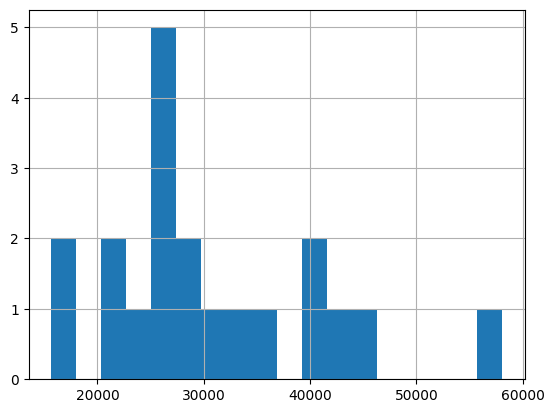

In [4]:
d = event_log[
        (event_log['concept:name'] == 'QUALITY_CONTROL') &
        (event_log['org:resource'] == 'Jane') &
        #(event_log['1'] == 0) &
        #(event_log['Clark'] == 0) &
        (event_log['Jane'] == 1) &
        (event_log['Joe'] == 2)# &
        #(event_log['Karsten'] == 0)
]
d['duration_seconds'].hist(bins=18)
print(d.shape)

/home/LordKunkler/TaskExecutionTimeMining/src/notebooks/Artificial_Example/../../TaskExecutionTimeMining/drbart_parser.py:204: RuntimeWarning: divide by zero encountered in log
  lo = np.log(n)


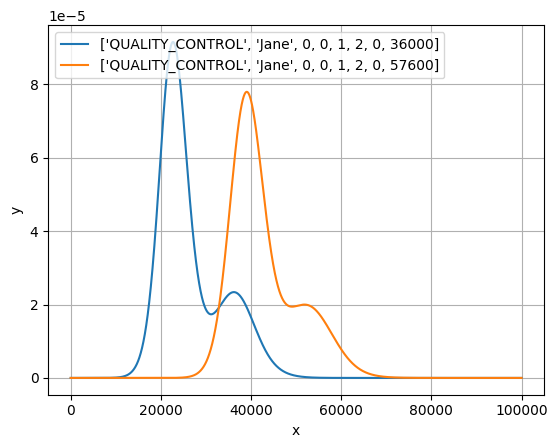

In [5]:
drbart = DRBART(parser_dir = '../../../models/'+models_for_evaluation[4][0])
x = np.linspace(0, 100000, 100000)
density = drbart.proba(x,
             [
                 ['QUALITY_CONTROL', 'Jane', 0, 0, 1, 2, 0],
                 ['QUALITY_CONTROL', 'Jane', 0, 0, 1, 2, 0]
             ],
             [
                 [10*3600],
                 [16*3600]
             ])

for j, i in density:
    plt.plot(x, i, label=str(j))
plt.legend(loc="upper left")
plt.grid(True)
plt.xlabel("x") 
plt.ylabel("y")
plt.show()


# Quantitative evaluation

## Activity based

[np.float64(98.09400444115471), np.float64(78.23834196891191), np.float64(57.16136195410807), np.float64(37.99037749814952), np.float64(18.708364174685418), np.float64(0.0)]


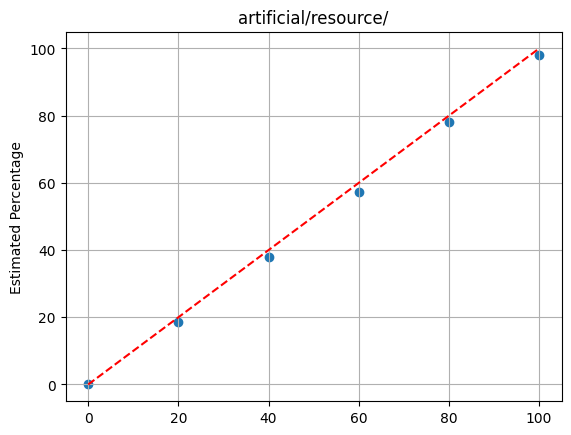

[np.float64(98.00148038490008), np.float64(78.83049592894153), np.float64(59.548482605477425), np.float64(40.00740192450037), np.float64(19.689119170984455), np.float64(0.0)]


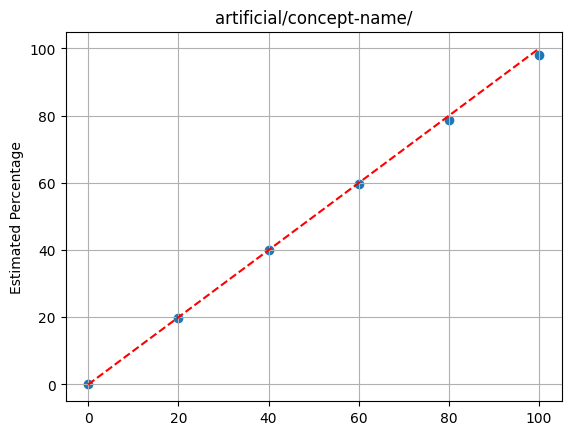

[np.float64(98.22353811991118), np.float64(78.01628423390082), np.float64(58.04959289415248), np.float64(38.67505551443375), np.float64(19.411547002220576), np.float64(0.0)]


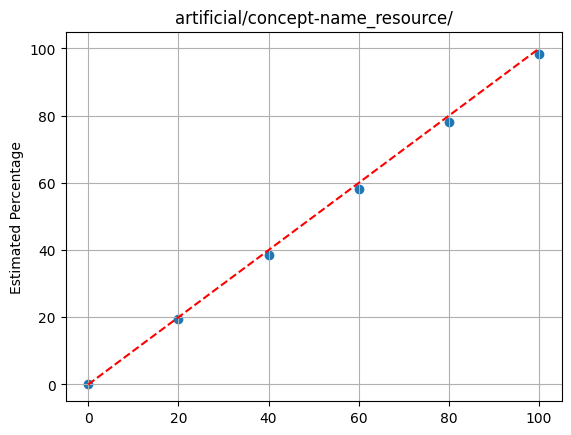

[np.float64(98.2420429311621), np.float64(77.6461880088823), np.float64(58.25314581791265), np.float64(38.82309400444115), np.float64(19.67061435973353), np.float64(0.0)]


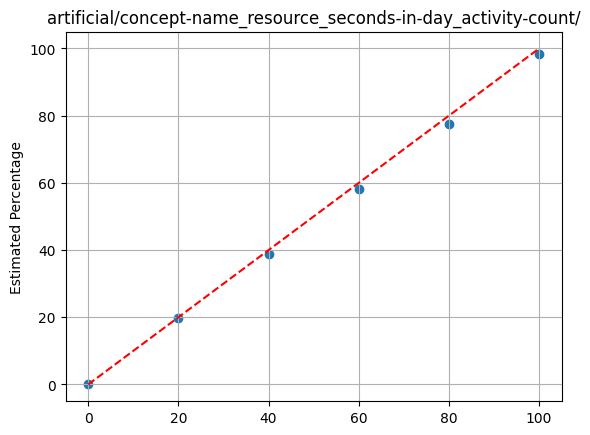

[np.float64(98.26054774241302), np.float64(77.97927461139896), np.float64(58.10510732790526), np.float64(38.7120651369356), np.float64(19.818652849740932), np.float64(0.0)]


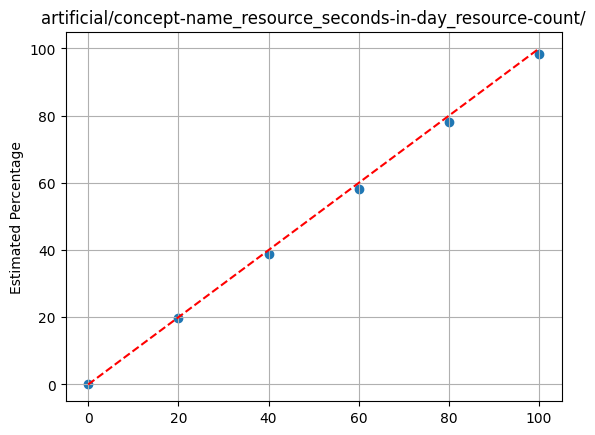

In [6]:
def min_max_time_percentile(x, categorical, continous, percentile):
    samples = drbart.sample([x[c] for c in categorical], [x[c] for c in continous], n = 100)[1]
    return np.percentile(samples, percentile), np.percentile(samples, 100-percentile)

for model in models_for_evaluation:
    drbart = DRBART(parser_dir = '../../../models/'+model[0])
    for i in range(0,50+1,10):
        event_log[['duration_sampled_seconds_min_'+str(i), 'duration_sampled_seconds_max_'+str(i)]] = \
            event_log.apply(lambda x : min_max_time_percentile(x, model[1][0], model[1][1], i), axis = 1, result_type='expand')
        event_log['real_duration_in_range_'+str(i)] = False
        event_log.loc[
            (event_log['duration_sampled_seconds_min_'+str(i)] <= event_log['duration_seconds']) & (event_log['duration_sampled_seconds_max_'+str(i)] >= event_log['duration_seconds']),
                'real_duration_in_range_'+str(i)
        ] = True
    x, y = [], []
    for i in range(0,50+1,10):
        x.append(100-i*2)
        y.append(event_log['real_duration_in_range_'+str(i)].mean()*100)
    print(y)
    plt.title(model[0])
    plt.scatter(x, y)
    plt.plot([0,100], [0,100], color='red', linestyle='--')
    plt.grid(True)
    plt.ylabel('Estimated Percentage')
    plt.show()
    

In [7]:
tqdm.pandas()

ev_event_log = event_log.sample(frac=1)

def drbart_proba(x, categorical, continous):
    p = drbart.proba([x['duration_seconds']], [[x[c] for c in categorical]], [[x[c] for c in continous]])[0][1]
    return np.log(p)

for model in models_for_evaluation[::-1]:
    drbart = DRBART(parser_dir = '../../../models/'+model[0])
    ev_event_log['model_proba']= \
            ev_event_log.progress_apply(lambda x : drbart_proba(x, model[1][0], model[1][1]), axis = 1)
    print(model[0], ev_event_log['model_proba'].sum())

  0%|                                                                                                                          | 0/5404 [00:00<?, ?it/s]

  0%|                                                                                                                  | 4/5404 [00:00<02:48, 32.09it/s]

  0%|▏                                                                                                                 | 8/5404 [00:00<03:14, 27.70it/s]

  0%|▏                                                                                                                | 11/5404 [00:00<03:20, 26.84it/s]

  0%|▎                                                                                                                | 14/5404 [00:00<03:24, 26.35it/s]

  0%|▎                                                                                                                | 17/5404 [00:00<03:26, 26.04it/s]

  0%|▍                                                                                                                | 20/5404 [00:00<03:27, 25.92it/s]

  0%|▍                                                                                                                | 23/5404 [00:00<03:28, 25.75it/s]

  0%|▌                                                                                                                | 26/5404 [00:00<03:28, 25.75it/s]

  1%|▌                                                                                                                | 29/5404 [00:01<03:28, 25.72it/s]

  1%|▋                                                                                                                | 32/5404 [00:01<03:29, 25.69it/s]

  1%|▋                                                                                                                | 35/5404 [00:01<03:28, 25.71it/s]

  1%|▊                                                                                                                | 38/5404 [00:01<03:28, 25.68it/s]

  1%|▊                                                                                                                | 41/5404 [00:01<03:29, 25.62it/s]

  1%|▉                                                                                                                | 44/5404 [00:01<03:29, 25.60it/s]

  1%|▉                                                                                                                | 47/5404 [00:01<03:29, 25.57it/s]

  1%|█                                                                                                                | 50/5404 [00:01<03:29, 25.58it/s]

  1%|█                                                                                                                | 53/5404 [00:02<03:29, 25.60it/s]

  1%|█▏                                                                                                               | 56/5404 [00:02<03:28, 25.63it/s]

  1%|█▏                                                                                                               | 59/5404 [00:02<03:28, 25.66it/s]

  1%|█▎                                                                                                               | 62/5404 [00:02<03:28, 25.68it/s]

  1%|█▎                                                                                                               | 65/5404 [00:02<03:28, 25.65it/s]

  1%|█▍                                                                                                               | 68/5404 [00:02<03:28, 25.60it/s]

  1%|█▍                                                                                                               | 71/5404 [00:02<03:28, 25.59it/s]

  1%|█▌                                                                                                               | 74/5404 [00:02<03:28, 25.58it/s]

  1%|█▌                                                                                                               | 77/5404 [00:02<03:28, 25.58it/s]

  1%|█▋                                                                                                               | 80/5404 [00:03<03:27, 25.60it/s]

  2%|█▋                                                                                                               | 83/5404 [00:03<03:28, 25.56it/s]

  2%|█▊                                                                                                               | 86/5404 [00:03<03:28, 25.56it/s]

  2%|█▊                                                                                                               | 89/5404 [00:03<03:28, 25.51it/s]

  2%|█▉                                                                                                               | 92/5404 [00:03<03:28, 25.53it/s]

  2%|█▉                                                                                                               | 95/5404 [00:03<03:27, 25.55it/s]

  2%|██                                                                                                               | 98/5404 [00:03<03:28, 25.45it/s]

  2%|██                                                                                                              | 101/5404 [00:03<03:27, 25.56it/s]

  2%|██▏                                                                                                             | 104/5404 [00:04<03:26, 25.65it/s]

  2%|██▏                                                                                                             | 107/5404 [00:04<03:26, 25.71it/s]

  2%|██▎                                                                                                             | 110/5404 [00:04<03:25, 25.73it/s]

  2%|██▎                                                                                                             | 113/5404 [00:04<03:25, 25.75it/s]

  2%|██▍                                                                                                             | 116/5404 [00:04<03:25, 25.71it/s]

  2%|██▍                                                                                                             | 119/5404 [00:04<03:25, 25.72it/s]

  2%|██▌                                                                                                             | 122/5404 [00:04<03:25, 25.67it/s]

  2%|██▌                                                                                                             | 125/5404 [00:04<03:25, 25.71it/s]

  2%|██▋                                                                                                             | 128/5404 [00:04<03:25, 25.71it/s]

  2%|██▋                                                                                                             | 131/5404 [00:05<03:25, 25.70it/s]

  2%|██▊                                                                                                             | 134/5404 [00:05<03:25, 25.69it/s]

  3%|██▊                                                                                                             | 137/5404 [00:05<03:24, 25.78it/s]

  3%|██▉                                                                                                             | 140/5404 [00:05<03:24, 25.75it/s]

  3%|██▉                                                                                                             | 143/5404 [00:05<03:24, 25.72it/s]

  3%|███                                                                                                             | 146/5404 [00:05<03:24, 25.69it/s]

  3%|███                                                                                                             | 149/5404 [00:05<03:24, 25.67it/s]

  3%|███▏                                                                                                            | 152/5404 [00:05<03:25, 25.62it/s]

  3%|███▏                                                                                                            | 155/5404 [00:06<03:25, 25.58it/s]

  3%|███▎                                                                                                            | 158/5404 [00:06<03:24, 25.60it/s]

  3%|███▎                                                                                                            | 161/5404 [00:06<03:24, 25.58it/s]

  3%|███▍                                                                                                            | 164/5404 [00:06<03:24, 25.65it/s]

  3%|███▍                                                                                                            | 167/5404 [00:06<03:24, 25.66it/s]

  3%|███▌                                                                                                            | 170/5404 [00:06<03:23, 25.70it/s]

  3%|███▌                                                                                                            | 173/5404 [00:06<03:22, 25.77it/s]

  3%|███▋                                                                                                            | 176/5404 [00:06<03:22, 25.75it/s]

  3%|███▋                                                                                                            | 179/5404 [00:06<03:23, 25.71it/s]

  3%|███▊                                                                                                            | 182/5404 [00:07<03:23, 25.67it/s]

  3%|███▊                                                                                                            | 185/5404 [00:07<03:24, 25.57it/s]

  3%|███▉                                                                                                            | 188/5404 [00:07<03:23, 25.61it/s]

  4%|███▉                                                                                                            | 191/5404 [00:07<03:23, 25.65it/s]

  4%|████                                                                                                            | 194/5404 [00:07<03:22, 25.69it/s]

  4%|████                                                                                                            | 197/5404 [00:07<03:22, 25.72it/s]

  4%|████▏                                                                                                           | 200/5404 [00:07<03:22, 25.74it/s]

  4%|████▏                                                                                                           | 203/5404 [00:07<03:21, 25.85it/s]

  4%|████▎                                                                                                           | 206/5404 [00:08<03:21, 25.81it/s]

  4%|████▎                                                                                                           | 209/5404 [00:08<03:21, 25.74it/s]

  4%|████▍                                                                                                           | 212/5404 [00:08<03:21, 25.71it/s]

  4%|████▍                                                                                                           | 215/5404 [00:08<03:21, 25.75it/s]

  4%|████▌                                                                                                           | 218/5404 [00:08<03:21, 25.69it/s]

  4%|████▌                                                                                                           | 221/5404 [00:08<03:22, 25.65it/s]

  4%|████▋                                                                                                           | 224/5404 [00:08<03:22, 25.62it/s]

  4%|████▋                                                                                                           | 227/5404 [00:08<03:22, 25.59it/s]

  4%|████▊                                                                                                           | 230/5404 [00:08<03:22, 25.55it/s]

  4%|████▊                                                                                                           | 233/5404 [00:09<03:21, 25.63it/s]

  4%|████▉                                                                                                           | 236/5404 [00:09<03:22, 25.58it/s]

  4%|████▉                                                                                                           | 239/5404 [00:09<03:22, 25.52it/s]

  4%|█████                                                                                                           | 242/5404 [00:09<03:22, 25.53it/s]

  5%|█████                                                                                                           | 245/5404 [00:09<03:22, 25.51it/s]

  5%|█████▏                                                                                                          | 248/5404 [00:09<03:21, 25.54it/s]

  5%|█████▏                                                                                                          | 251/5404 [00:09<03:22, 25.49it/s]

  5%|█████▎                                                                                                          | 254/5404 [00:09<03:22, 25.49it/s]

  5%|█████▎                                                                                                          | 257/5404 [00:09<03:21, 25.56it/s]

  5%|█████▍                                                                                                          | 260/5404 [00:10<03:20, 25.61it/s]

  5%|█████▍                                                                                                          | 263/5404 [00:10<03:20, 25.62it/s]

  5%|█████▌                                                                                                          | 266/5404 [00:10<03:21, 25.55it/s]

  5%|█████▌                                                                                                          | 269/5404 [00:10<03:20, 25.55it/s]

  5%|█████▋                                                                                                          | 272/5404 [00:10<03:20, 25.55it/s]

  5%|█████▋                                                                                                          | 275/5404 [00:10<03:20, 25.59it/s]

  5%|█████▊                                                                                                          | 278/5404 [00:10<03:19, 25.63it/s]

  5%|█████▊                                                                                                          | 281/5404 [00:10<03:20, 25.58it/s]

  5%|█████▉                                                                                                          | 284/5404 [00:11<03:20, 25.58it/s]

  5%|█████▉                                                                                                          | 287/5404 [00:11<03:20, 25.56it/s]

  5%|██████                                                                                                          | 290/5404 [00:11<03:20, 25.56it/s]

  5%|██████                                                                                                          | 293/5404 [00:11<03:19, 25.61it/s]

  5%|██████▏                                                                                                         | 296/5404 [00:11<03:19, 25.60it/s]

  6%|██████▏                                                                                                         | 299/5404 [00:11<03:19, 25.56it/s]

  6%|██████▎                                                                                                         | 302/5404 [00:11<03:19, 25.59it/s]

  6%|██████▎                                                                                                         | 305/5404 [00:11<03:19, 25.54it/s]

  6%|██████▍                                                                                                         | 308/5404 [00:11<03:19, 25.51it/s]

  6%|██████▍                                                                                                         | 311/5404 [00:12<03:19, 25.55it/s]

  6%|██████▌                                                                                                         | 314/5404 [00:12<03:19, 25.56it/s]

  6%|██████▌                                                                                                         | 317/5404 [00:12<03:18, 25.59it/s]

  6%|██████▋                                                                                                         | 320/5404 [00:12<03:18, 25.66it/s]

  6%|██████▋                                                                                                         | 323/5404 [00:12<03:18, 25.62it/s]

  6%|██████▊                                                                                                         | 326/5404 [00:12<03:18, 25.64it/s]

  6%|██████▊                                                                                                         | 329/5404 [00:12<03:17, 25.67it/s]

  6%|██████▉                                                                                                         | 332/5404 [00:12<03:17, 25.69it/s]

  6%|██████▉                                                                                                         | 335/5404 [00:13<03:16, 25.73it/s]

  6%|███████                                                                                                         | 338/5404 [00:13<03:16, 25.73it/s]

  6%|███████                                                                                                         | 341/5404 [00:13<03:16, 25.76it/s]

  6%|███████▏                                                                                                        | 344/5404 [00:13<03:16, 25.80it/s]

  6%|███████▏                                                                                                        | 347/5404 [00:13<03:15, 25.83it/s]

  6%|███████▎                                                                                                        | 350/5404 [00:13<03:15, 25.80it/s]

  7%|███████▎                                                                                                        | 353/5404 [00:13<03:16, 25.75it/s]

  7%|███████▍                                                                                                        | 356/5404 [00:13<03:16, 25.74it/s]

  7%|███████▍                                                                                                        | 359/5404 [00:13<03:15, 25.75it/s]

  7%|███████▌                                                                                                        | 362/5404 [00:14<03:15, 25.77it/s]

  7%|███████▌                                                                                                        | 365/5404 [00:14<03:15, 25.75it/s]

  7%|███████▋                                                                                                        | 368/5404 [00:14<03:15, 25.72it/s]

  7%|███████▋                                                                                                        | 371/5404 [00:14<03:15, 25.75it/s]

  7%|███████▊                                                                                                        | 374/5404 [00:14<03:15, 25.72it/s]

  7%|███████▊                                                                                                        | 377/5404 [00:14<03:14, 25.79it/s]

  7%|███████▉                                                                                                        | 380/5404 [00:14<03:15, 25.74it/s]

  7%|███████▉                                                                                                        | 383/5404 [00:14<03:15, 25.74it/s]

  7%|████████                                                                                                        | 386/5404 [00:15<03:14, 25.77it/s]

  7%|████████                                                                                                        | 389/5404 [00:15<03:14, 25.74it/s]

  7%|████████                                                                                                        | 392/5404 [00:15<03:14, 25.74it/s]

  7%|████████▏                                                                                                       | 395/5404 [00:15<03:14, 25.78it/s]

  7%|████████▏                                                                                                       | 398/5404 [00:15<03:14, 25.77it/s]

  7%|████████▎                                                                                                       | 401/5404 [00:15<03:14, 25.71it/s]

  7%|████████▎                                                                                                       | 404/5404 [00:15<03:14, 25.66it/s]

  8%|████████▍                                                                                                       | 407/5404 [00:15<03:14, 25.72it/s]

  8%|████████▍                                                                                                       | 410/5404 [00:15<03:13, 25.75it/s]

  8%|████████▌                                                                                                       | 413/5404 [00:16<03:14, 25.70it/s]

  8%|████████▌                                                                                                       | 416/5404 [00:16<03:14, 25.71it/s]

  8%|████████▋                                                                                                       | 419/5404 [00:16<03:13, 25.75it/s]

  8%|████████▋                                                                                                       | 422/5404 [00:16<03:14, 25.64it/s]

  8%|████████▊                                                                                                       | 425/5404 [00:16<03:14, 25.64it/s]

  8%|████████▊                                                                                                       | 428/5404 [00:16<03:14, 25.65it/s]

  8%|████████▉                                                                                                       | 431/5404 [00:16<03:14, 25.56it/s]

  8%|████████▉                                                                                                       | 434/5404 [00:16<03:14, 25.58it/s]

  8%|█████████                                                                                                       | 437/5404 [00:17<03:14, 25.56it/s]

  8%|█████████                                                                                                       | 440/5404 [00:17<03:14, 25.55it/s]

  8%|█████████▏                                                                                                      | 443/5404 [00:17<03:13, 25.59it/s]

  8%|█████████▏                                                                                                      | 446/5404 [00:17<03:13, 25.58it/s]

  8%|█████████▎                                                                                                      | 449/5404 [00:17<03:13, 25.57it/s]

  8%|█████████▎                                                                                                      | 452/5404 [00:17<03:13, 25.62it/s]

  8%|█████████▍                                                                                                      | 455/5404 [00:17<03:12, 25.64it/s]

  8%|█████████▍                                                                                                      | 458/5404 [00:17<03:13, 25.61it/s]

  9%|█████████▌                                                                                                      | 461/5404 [00:17<03:12, 25.68it/s]

  9%|█████████▌                                                                                                      | 464/5404 [00:18<03:11, 25.76it/s]

  9%|█████████▋                                                                                                      | 467/5404 [00:18<03:11, 25.74it/s]

  9%|█████████▋                                                                                                      | 470/5404 [00:18<03:11, 25.74it/s]

  9%|█████████▊                                                                                                      | 473/5404 [00:18<03:11, 25.75it/s]

  9%|█████████▊                                                                                                      | 476/5404 [00:18<03:11, 25.70it/s]

  9%|█████████▉                                                                                                      | 479/5404 [00:18<03:11, 25.73it/s]

  9%|█████████▉                                                                                                      | 482/5404 [00:18<03:11, 25.72it/s]

  9%|██████████                                                                                                      | 485/5404 [00:18<03:10, 25.75it/s]

  9%|██████████                                                                                                      | 488/5404 [00:18<03:11, 25.74it/s]

  9%|██████████▏                                                                                                     | 491/5404 [00:19<03:10, 25.73it/s]

  9%|██████████▏                                                                                                     | 494/5404 [00:19<03:10, 25.73it/s]

  9%|██████████▎                                                                                                     | 497/5404 [00:19<03:11, 25.66it/s]

  9%|██████████▎                                                                                                     | 500/5404 [00:19<03:10, 25.68it/s]

  9%|██████████▍                                                                                                     | 503/5404 [00:19<03:10, 25.72it/s]

  9%|██████████▍                                                                                                     | 506/5404 [00:19<03:10, 25.69it/s]

  9%|██████████▌                                                                                                     | 509/5404 [00:19<03:11, 25.61it/s]

  9%|██████████▌                                                                                                     | 512/5404 [00:19<03:10, 25.64it/s]

 10%|██████████▋                                                                                                     | 515/5404 [00:20<03:10, 25.63it/s]

 10%|██████████▋                                                                                                     | 518/5404 [00:20<03:10, 25.71it/s]

 10%|██████████▊                                                                                                     | 521/5404 [00:20<03:09, 25.72it/s]

 10%|██████████▊                                                                                                     | 524/5404 [00:20<03:09, 25.73it/s]

 10%|██████████▉                                                                                                     | 527/5404 [00:20<03:09, 25.74it/s]

 10%|██████████▉                                                                                                     | 530/5404 [00:20<03:09, 25.73it/s]

 10%|███████████                                                                                                     | 533/5404 [00:20<03:09, 25.73it/s]

 10%|███████████                                                                                                     | 536/5404 [00:20<03:09, 25.73it/s]

 10%|███████████▏                                                                                                    | 539/5404 [00:20<03:09, 25.69it/s]

 10%|███████████▏                                                                                                    | 542/5404 [00:21<03:09, 25.63it/s]

 10%|███████████▎                                                                                                    | 545/5404 [00:21<03:09, 25.63it/s]

 10%|███████████▎                                                                                                    | 548/5404 [00:21<03:09, 25.68it/s]

 10%|███████████▍                                                                                                    | 551/5404 [00:21<03:09, 25.68it/s]

 10%|███████████▍                                                                                                    | 554/5404 [00:21<03:08, 25.71it/s]

 10%|███████████▌                                                                                                    | 557/5404 [00:21<03:08, 25.78it/s]

 10%|███████████▌                                                                                                    | 560/5404 [00:21<03:08, 25.68it/s]

 10%|███████████▋                                                                                                    | 563/5404 [00:21<03:08, 25.65it/s]

 10%|███████████▋                                                                                                    | 566/5404 [00:22<03:08, 25.65it/s]

 11%|███████████▊                                                                                                    | 569/5404 [00:22<03:08, 25.60it/s]

 11%|███████████▊                                                                                                    | 572/5404 [00:22<03:08, 25.59it/s]

 11%|███████████▉                                                                                                    | 575/5404 [00:22<03:08, 25.61it/s]

 11%|███████████▉                                                                                                    | 578/5404 [00:22<03:07, 25.71it/s]

 11%|████████████                                                                                                    | 581/5404 [00:22<03:07, 25.72it/s]

 11%|████████████                                                                                                    | 584/5404 [00:22<03:07, 25.70it/s]

 11%|████████████▏                                                                                                   | 587/5404 [00:22<03:08, 25.60it/s]

 11%|████████████▏                                                                                                   | 590/5404 [00:22<03:08, 25.58it/s]

 11%|████████████▎                                                                                                   | 593/5404 [00:23<03:07, 25.62it/s]

 11%|████████████▎                                                                                                   | 596/5404 [00:23<03:07, 25.66it/s]

 11%|████████████▍                                                                                                   | 599/5404 [00:23<03:07, 25.69it/s]

 11%|████████████▍                                                                                                   | 602/5404 [00:23<03:06, 25.68it/s]

 11%|████████████▌                                                                                                   | 605/5404 [00:23<03:07, 25.66it/s]

 11%|████████████▌                                                                                                   | 608/5404 [00:23<03:07, 25.59it/s]

 11%|████████████▋                                                                                                   | 611/5404 [00:23<03:07, 25.54it/s]

 11%|████████████▋                                                                                                   | 614/5404 [00:23<03:07, 25.51it/s]

 11%|████████████▊                                                                                                   | 617/5404 [00:24<03:07, 25.49it/s]

 11%|████████████▊                                                                                                   | 620/5404 [00:24<03:07, 25.57it/s]

 12%|████████████▉                                                                                                   | 623/5404 [00:24<03:06, 25.63it/s]

 12%|████████████▉                                                                                                   | 626/5404 [00:24<03:06, 25.64it/s]

 12%|█████████████                                                                                                   | 629/5404 [00:24<03:05, 25.69it/s]

 12%|█████████████                                                                                                   | 632/5404 [00:24<03:05, 25.71it/s]

 12%|█████████████▏                                                                                                  | 635/5404 [00:24<03:05, 25.75it/s]

 12%|█████████████▏                                                                                                  | 638/5404 [00:24<03:05, 25.71it/s]

 12%|█████████████▎                                                                                                  | 641/5404 [00:24<03:05, 25.68it/s]

 12%|█████████████▎                                                                                                  | 644/5404 [00:25<03:05, 25.71it/s]

 12%|█████████████▍                                                                                                  | 647/5404 [00:25<03:04, 25.71it/s]

 12%|█████████████▍                                                                                                  | 650/5404 [00:25<03:04, 25.76it/s]

 12%|█████████████▌                                                                                                  | 653/5404 [00:25<03:04, 25.78it/s]

 12%|█████████████▌                                                                                                  | 656/5404 [00:25<03:04, 25.72it/s]

 12%|█████████████▋                                                                                                  | 659/5404 [00:25<03:04, 25.66it/s]

 12%|█████████████▋                                                                                                  | 662/5404 [00:25<03:05, 25.61it/s]

 12%|█████████████▊                                                                                                  | 665/5404 [00:25<03:05, 25.59it/s]

 12%|█████████████▊                                                                                                  | 668/5404 [00:26<03:04, 25.61it/s]

 12%|█████████████▉                                                                                                  | 671/5404 [00:26<03:04, 25.63it/s]

 12%|█████████████▉                                                                                                  | 674/5404 [00:26<03:04, 25.58it/s]

 13%|██████████████                                                                                                  | 677/5404 [00:26<03:04, 25.62it/s]

 13%|██████████████                                                                                                  | 680/5404 [00:26<03:03, 25.68it/s]

 13%|██████████████▏                                                                                                 | 683/5404 [00:26<03:03, 25.72it/s]

 13%|██████████████▏                                                                                                 | 686/5404 [00:26<03:03, 25.74it/s]

 13%|██████████████▎                                                                                                 | 689/5404 [00:26<03:03, 25.75it/s]

 13%|██████████████▎                                                                                                 | 692/5404 [00:26<03:02, 25.75it/s]

 13%|██████████████▍                                                                                                 | 695/5404 [00:27<03:02, 25.82it/s]

 13%|██████████████▍                                                                                                 | 698/5404 [00:27<03:01, 25.90it/s]

 13%|██████████████▌                                                                                                 | 701/5404 [00:27<03:01, 25.92it/s]

 13%|██████████████▌                                                                                                 | 704/5404 [00:27<03:01, 25.92it/s]

 13%|██████████████▋                                                                                                 | 707/5404 [00:27<03:01, 25.88it/s]

 13%|██████████████▋                                                                                                 | 710/5404 [00:27<03:01, 25.90it/s]

 13%|██████████████▊                                                                                                 | 713/5404 [00:27<03:01, 25.85it/s]

 13%|██████████████▊                                                                                                 | 716/5404 [00:27<03:01, 25.82it/s]

 13%|██████████████▉                                                                                                 | 719/5404 [00:27<03:01, 25.82it/s]

 13%|██████████████▉                                                                                                 | 722/5404 [00:28<03:01, 25.83it/s]

 13%|███████████████                                                                                                 | 725/5404 [00:28<03:01, 25.85it/s]

 13%|███████████████                                                                                                 | 728/5404 [00:28<03:01, 25.81it/s]

 14%|███████████████▏                                                                                                | 731/5404 [00:28<03:01, 25.78it/s]

 14%|███████████████▏                                                                                                | 734/5404 [00:28<03:02, 25.66it/s]

 14%|███████████████▎                                                                                                | 737/5404 [00:28<03:02, 25.61it/s]

 14%|███████████████▎                                                                                                | 740/5404 [00:28<03:02, 25.55it/s]

 14%|███████████████▍                                                                                                | 743/5404 [00:28<03:02, 25.50it/s]

 14%|███████████████▍                                                                                                | 746/5404 [00:29<03:02, 25.53it/s]

 14%|███████████████▌                                                                                                | 749/5404 [00:29<03:02, 25.49it/s]

 14%|███████████████▌                                                                                                | 752/5404 [00:29<03:02, 25.45it/s]

 14%|███████████████▋                                                                                                | 755/5404 [00:29<03:02, 25.48it/s]

 14%|███████████████▋                                                                                                | 758/5404 [00:29<03:02, 25.50it/s]

 14%|███████████████▊                                                                                                | 761/5404 [00:29<03:01, 25.53it/s]

 14%|███████████████▊                                                                                                | 764/5404 [00:29<03:01, 25.52it/s]

 14%|███████████████▉                                                                                                | 767/5404 [00:29<03:01, 25.49it/s]

 14%|███████████████▉                                                                                                | 770/5404 [00:29<03:01, 25.51it/s]

 14%|████████████████                                                                                                | 773/5404 [00:30<03:01, 25.54it/s]

 14%|████████████████                                                                                                | 776/5404 [00:30<03:01, 25.52it/s]

 14%|████████████████▏                                                                                               | 779/5404 [00:30<03:00, 25.56it/s]

 14%|████████████████▏                                                                                               | 782/5404 [00:30<03:00, 25.56it/s]

 15%|████████████████▎                                                                                               | 785/5404 [00:30<03:01, 25.52it/s]

 15%|████████████████▎                                                                                               | 788/5404 [00:30<03:01, 25.46it/s]

 15%|████████████████▍                                                                                               | 791/5404 [00:30<03:01, 25.48it/s]

 15%|████████████████▍                                                                                               | 794/5404 [00:30<03:01, 25.45it/s]

 15%|████████████████▌                                                                                               | 797/5404 [00:31<03:00, 25.47it/s]

 15%|████████████████▌                                                                                               | 800/5404 [00:31<03:00, 25.50it/s]

 15%|████████████████▋                                                                                               | 803/5404 [00:31<02:59, 25.57it/s]

 15%|████████████████▋                                                                                               | 806/5404 [00:31<02:59, 25.61it/s]

 15%|████████████████▊                                                                                               | 809/5404 [00:31<02:59, 25.63it/s]

 15%|████████████████▊                                                                                               | 812/5404 [00:31<02:59, 25.59it/s]

 15%|████████████████▉                                                                                               | 815/5404 [00:31<02:59, 25.53it/s]

 15%|████████████████▉                                                                                               | 818/5404 [00:31<02:59, 25.50it/s]

 15%|█████████████████                                                                                               | 821/5404 [00:31<03:00, 25.43it/s]

 15%|█████████████████                                                                                               | 824/5404 [00:32<02:59, 25.49it/s]

 15%|█████████████████▏                                                                                              | 827/5404 [00:32<02:59, 25.49it/s]

 15%|█████████████████▏                                                                                              | 830/5404 [00:32<02:59, 25.45it/s]

 15%|█████████████████▎                                                                                              | 833/5404 [00:32<02:59, 25.45it/s]

 15%|█████████████████▎                                                                                              | 836/5404 [00:32<02:59, 25.48it/s]

 16%|█████████████████▍                                                                                              | 839/5404 [00:32<02:58, 25.55it/s]

 16%|█████████████████▍                                                                                              | 842/5404 [00:32<02:58, 25.58it/s]

 16%|█████████████████▌                                                                                              | 845/5404 [00:32<02:58, 25.58it/s]

 16%|█████████████████▌                                                                                              | 848/5404 [00:33<02:58, 25.56it/s]

 16%|█████████████████▋                                                                                              | 851/5404 [00:33<02:58, 25.50it/s]

 16%|█████████████████▋                                                                                              | 854/5404 [00:33<02:57, 25.70it/s]

 16%|█████████████████▊                                                                                              | 857/5404 [00:33<02:56, 25.71it/s]

 16%|█████████████████▊                                                                                              | 860/5404 [00:33<02:56, 25.73it/s]

 16%|█████████████████▉                                                                                              | 863/5404 [00:33<02:56, 25.72it/s]

 16%|█████████████████▉                                                                                              | 866/5404 [00:33<02:56, 25.68it/s]

 16%|██████████████████                                                                                              | 869/5404 [00:33<02:56, 25.69it/s]

 16%|██████████████████                                                                                              | 872/5404 [00:33<02:56, 25.74it/s]

 16%|██████████████████▏                                                                                             | 875/5404 [00:34<02:56, 25.71it/s]

 16%|██████████████████▏                                                                                             | 878/5404 [00:34<02:56, 25.71it/s]

 16%|██████████████████▎                                                                                             | 881/5404 [00:34<02:55, 25.70it/s]

 16%|██████████████████▎                                                                                             | 884/5404 [00:34<02:55, 25.77it/s]

 16%|██████████████████▍                                                                                             | 887/5404 [00:34<02:55, 25.77it/s]

 16%|██████████████████▍                                                                                             | 890/5404 [00:34<02:55, 25.73it/s]

 17%|██████████████████▌                                                                                             | 893/5404 [00:34<02:55, 25.71it/s]

 17%|██████████████████▌                                                                                             | 896/5404 [00:34<02:55, 25.70it/s]

 17%|██████████████████▋                                                                                             | 899/5404 [00:35<02:54, 25.75it/s]

 17%|██████████████████▋                                                                                             | 902/5404 [00:35<02:54, 25.75it/s]

 17%|██████████████████▊                                                                                             | 905/5404 [00:35<02:54, 25.83it/s]

 17%|██████████████████▊                                                                                             | 908/5404 [00:35<02:54, 25.79it/s]

 17%|██████████████████▉                                                                                             | 911/5404 [00:35<02:54, 25.73it/s]

 17%|██████████████████▉                                                                                             | 914/5404 [00:35<02:54, 25.71it/s]

 17%|███████████████████                                                                                             | 917/5404 [00:35<02:54, 25.74it/s]

 17%|███████████████████                                                                                             | 920/5404 [00:35<02:54, 25.72it/s]

 17%|███████████████████▏                                                                                            | 923/5404 [00:35<02:54, 25.71it/s]

 17%|███████████████████▏                                                                                            | 926/5404 [00:36<02:54, 25.69it/s]

 17%|███████████████████▎                                                                                            | 929/5404 [00:36<02:54, 25.69it/s]

 17%|███████████████████▎                                                                                            | 932/5404 [00:36<02:53, 25.76it/s]

 17%|███████████████████▍                                                                                            | 935/5404 [00:36<02:53, 25.72it/s]

 17%|███████████████████▍                                                                                            | 938/5404 [00:36<02:53, 25.72it/s]

 17%|███████████████████▌                                                                                            | 941/5404 [00:36<02:53, 25.68it/s]

 17%|███████████████████▌                                                                                            | 944/5404 [00:36<02:53, 25.70it/s]

 18%|███████████████████▋                                                                                            | 947/5404 [00:36<02:53, 25.62it/s]

 18%|███████████████████▋                                                                                            | 950/5404 [00:37<02:53, 25.65it/s]

 18%|███████████████████▊                                                                                            | 953/5404 [00:37<02:53, 25.65it/s]

 18%|███████████████████▊                                                                                            | 956/5404 [00:37<02:53, 25.69it/s]

 18%|███████████████████▉                                                                                            | 959/5404 [00:37<02:53, 25.66it/s]

 18%|███████████████████▉                                                                                            | 962/5404 [00:37<02:53, 25.62it/s]

 18%|████████████████████                                                                                            | 965/5404 [00:37<02:53, 25.62it/s]

 18%|████████████████████                                                                                            | 968/5404 [00:37<02:53, 25.63it/s]

 18%|████████████████████                                                                                            | 971/5404 [00:37<02:53, 25.62it/s]

 18%|████████████████████▏                                                                                           | 974/5404 [00:37<02:52, 25.64it/s]

 18%|████████████████████▏                                                                                           | 977/5404 [00:38<02:52, 25.62it/s]

 18%|████████████████████▎                                                                                           | 980/5404 [00:38<02:52, 25.60it/s]

 18%|████████████████████▎                                                                                           | 983/5404 [00:38<02:52, 25.69it/s]

 18%|████████████████████▍                                                                                           | 986/5404 [00:38<02:52, 25.66it/s]

 18%|████████████████████▍                                                                                           | 989/5404 [00:38<02:51, 25.67it/s]

 18%|████████████████████▌                                                                                           | 992/5404 [00:38<02:52, 25.62it/s]

 18%|████████████████████▌                                                                                           | 995/5404 [00:38<02:52, 25.55it/s]

 18%|████████████████████▋                                                                                           | 998/5404 [00:38<02:52, 25.52it/s]

 19%|████████████████████▌                                                                                          | 1001/5404 [00:38<02:52, 25.52it/s]

 19%|████████████████████▌                                                                                          | 1004/5404 [00:39<02:52, 25.56it/s]

 19%|████████████████████▋                                                                                          | 1007/5404 [00:39<02:52, 25.55it/s]

 19%|████████████████████▋                                                                                          | 1010/5404 [00:39<02:51, 25.59it/s]

 19%|████████████████████▊                                                                                          | 1013/5404 [00:39<02:51, 25.59it/s]

 19%|████████████████████▊                                                                                          | 1016/5404 [00:39<02:51, 25.56it/s]

 19%|████████████████████▉                                                                                          | 1019/5404 [00:39<02:52, 25.48it/s]

 19%|████████████████████▉                                                                                          | 1022/5404 [00:39<02:52, 25.45it/s]

 19%|█████████████████████                                                                                          | 1025/5404 [00:39<02:52, 25.45it/s]

 19%|█████████████████████                                                                                          | 1028/5404 [00:40<02:52, 25.40it/s]

 19%|█████████████████████▏                                                                                         | 1031/5404 [00:40<02:52, 25.42it/s]

 19%|█████████████████████▏                                                                                         | 1034/5404 [00:40<02:52, 25.37it/s]

 19%|█████████████████████▎                                                                                         | 1037/5404 [00:40<02:52, 25.35it/s]

 19%|█████████████████████▎                                                                                         | 1040/5404 [00:40<02:52, 25.37it/s]

 19%|█████████████████████▍                                                                                         | 1043/5404 [00:40<02:51, 25.36it/s]

 19%|█████████████████████▍                                                                                         | 1046/5404 [00:40<02:51, 25.39it/s]

 19%|█████████████████████▌                                                                                         | 1049/5404 [00:40<02:51, 25.43it/s]

 19%|█████████████████████▌                                                                                         | 1052/5404 [00:40<02:51, 25.41it/s]

 20%|█████████████████████▋                                                                                         | 1055/5404 [00:41<02:51, 25.40it/s]

 20%|█████████████████████▋                                                                                         | 1058/5404 [00:41<02:51, 25.38it/s]

 20%|█████████████████████▊                                                                                         | 1061/5404 [00:41<02:50, 25.40it/s]

 20%|█████████████████████▊                                                                                         | 1064/5404 [00:41<02:50, 25.39it/s]

 20%|█████████████████████▉                                                                                         | 1067/5404 [00:41<02:50, 25.37it/s]

 20%|█████████████████████▉                                                                                         | 1070/5404 [00:41<02:50, 25.38it/s]

 20%|██████████████████████                                                                                         | 1073/5404 [00:41<02:50, 25.40it/s]

 20%|██████████████████████                                                                                         | 1076/5404 [00:41<02:50, 25.38it/s]

 20%|██████████████████████▏                                                                                        | 1079/5404 [00:42<02:50, 25.39it/s]

 20%|██████████████████████▏                                                                                        | 1082/5404 [00:42<02:50, 25.41it/s]

 20%|██████████████████████▎                                                                                        | 1085/5404 [00:42<02:50, 25.38it/s]

 20%|██████████████████████▎                                                                                        | 1088/5404 [00:42<02:49, 25.39it/s]

 20%|██████████████████████▍                                                                                        | 1091/5404 [00:42<02:49, 25.42it/s]

 20%|██████████████████████▍                                                                                        | 1094/5404 [00:42<02:49, 25.43it/s]

 20%|██████████████████████▌                                                                                        | 1097/5404 [00:42<02:49, 25.42it/s]

 20%|██████████████████████▌                                                                                        | 1100/5404 [00:42<02:49, 25.42it/s]

 20%|██████████████████████▋                                                                                        | 1103/5404 [00:43<02:49, 25.42it/s]

 20%|██████████████████████▋                                                                                        | 1106/5404 [00:43<02:49, 25.43it/s]

 21%|██████████████████████▊                                                                                        | 1109/5404 [00:43<02:48, 25.45it/s]

 21%|██████████████████████▊                                                                                        | 1112/5404 [00:43<02:48, 25.48it/s]

 21%|██████████████████████▉                                                                                        | 1115/5404 [00:43<02:47, 25.53it/s]

 21%|██████████████████████▉                                                                                        | 1118/5404 [00:43<02:47, 25.52it/s]

 21%|███████████████████████                                                                                        | 1121/5404 [00:43<02:47, 25.53it/s]

 21%|███████████████████████                                                                                        | 1124/5404 [00:43<02:47, 25.55it/s]

 21%|███████████████████████▏                                                                                       | 1127/5404 [00:43<02:47, 25.55it/s]

 21%|███████████████████████▏                                                                                       | 1130/5404 [00:44<02:47, 25.49it/s]

 21%|███████████████████████▎                                                                                       | 1133/5404 [00:44<02:47, 25.48it/s]

 21%|███████████████████████▎                                                                                       | 1136/5404 [00:44<02:47, 25.53it/s]

 21%|███████████████████████▍                                                                                       | 1139/5404 [00:44<02:46, 25.59it/s]

 21%|███████████████████████▍                                                                                       | 1142/5404 [00:44<02:46, 25.57it/s]

 21%|███████████████████████▌                                                                                       | 1145/5404 [00:44<02:46, 25.58it/s]

 21%|███████████████████████▌                                                                                       | 1148/5404 [00:44<02:46, 25.56it/s]

 21%|███████████████████████▋                                                                                       | 1151/5404 [00:44<02:46, 25.57it/s]

 21%|███████████████████████▋                                                                                       | 1154/5404 [00:45<02:46, 25.49it/s]

 21%|███████████████████████▊                                                                                       | 1157/5404 [00:45<02:46, 25.44it/s]

 21%|███████████████████████▊                                                                                       | 1160/5404 [00:45<02:46, 25.43it/s]

 22%|███████████████████████▉                                                                                       | 1163/5404 [00:45<02:46, 25.43it/s]

 22%|███████████████████████▉                                                                                       | 1166/5404 [00:45<02:46, 25.42it/s]

 22%|████████████████████████                                                                                       | 1169/5404 [00:45<02:46, 25.43it/s]

 22%|████████████████████████                                                                                       | 1172/5404 [00:45<02:46, 25.45it/s]

 22%|████████████████████████▏                                                                                      | 1175/5404 [00:45<02:45, 25.49it/s]

 22%|████████████████████████▏                                                                                      | 1178/5404 [00:45<02:45, 25.51it/s]

 22%|████████████████████████▎                                                                                      | 1181/5404 [00:46<02:45, 25.48it/s]

 22%|████████████████████████▎                                                                                      | 1184/5404 [00:46<02:45, 25.53it/s]

 22%|████████████████████████▍                                                                                      | 1187/5404 [00:46<02:45, 25.52it/s]

 22%|████████████████████████▍                                                                                      | 1190/5404 [00:46<02:44, 25.56it/s]

 22%|████████████████████████▌                                                                                      | 1193/5404 [00:46<02:44, 25.57it/s]

 22%|████████████████████████▌                                                                                      | 1196/5404 [00:46<02:44, 25.61it/s]

 22%|████████████████████████▋                                                                                      | 1199/5404 [00:46<02:44, 25.64it/s]

 22%|████████████████████████▋                                                                                      | 1202/5404 [00:46<02:44, 25.56it/s]

 22%|████████████████████████▊                                                                                      | 1205/5404 [00:47<02:44, 25.57it/s]

 22%|████████████████████████▊                                                                                      | 1208/5404 [00:47<02:44, 25.54it/s]

 22%|████████████████████████▊                                                                                      | 1211/5404 [00:47<02:44, 25.52it/s]

 22%|████████████████████████▉                                                                                      | 1214/5404 [00:47<02:44, 25.54it/s]

 23%|████████████████████████▉                                                                                      | 1217/5404 [00:47<02:44, 25.50it/s]

 23%|█████████████████████████                                                                                      | 1220/5404 [00:47<02:44, 25.51it/s]

 23%|█████████████████████████                                                                                      | 1223/5404 [00:47<02:43, 25.51it/s]

 23%|█████████████████████████▏                                                                                     | 1226/5404 [00:47<02:44, 25.46it/s]

 23%|█████████████████████████▏                                                                                     | 1229/5404 [00:47<02:43, 25.47it/s]

 23%|█████████████████████████▎                                                                                     | 1232/5404 [00:48<02:43, 25.49it/s]

 23%|█████████████████████████▎                                                                                     | 1235/5404 [00:48<02:43, 25.50it/s]

 23%|█████████████████████████▍                                                                                     | 1238/5404 [00:48<02:43, 25.51it/s]

 23%|█████████████████████████▍                                                                                     | 1241/5404 [00:48<02:43, 25.52it/s]

 23%|█████████████████████████▌                                                                                     | 1244/5404 [00:48<02:42, 25.57it/s]

 23%|█████████████████████████▌                                                                                     | 1247/5404 [00:48<02:42, 25.54it/s]

 23%|█████████████████████████▋                                                                                     | 1250/5404 [00:48<02:41, 25.65it/s]

 23%|█████████████████████████▋                                                                                     | 1253/5404 [00:48<02:41, 25.70it/s]

 23%|█████████████████████████▊                                                                                     | 1256/5404 [00:49<02:41, 25.61it/s]

 23%|█████████████████████████▊                                                                                     | 1259/5404 [00:49<02:42, 25.57it/s]

 23%|█████████████████████████▉                                                                                     | 1262/5404 [00:49<02:42, 25.55it/s]

 23%|█████████████████████████▉                                                                                     | 1265/5404 [00:49<02:42, 25.54it/s]

 23%|██████████████████████████                                                                                     | 1268/5404 [00:49<02:41, 25.55it/s]

 24%|██████████████████████████                                                                                     | 1271/5404 [00:49<02:41, 25.53it/s]

 24%|██████████████████████████▏                                                                                    | 1274/5404 [00:49<02:41, 25.56it/s]

 24%|██████████████████████████▏                                                                                    | 1277/5404 [00:49<02:41, 25.57it/s]

 24%|██████████████████████████▎                                                                                    | 1280/5404 [00:49<02:41, 25.59it/s]

 24%|██████████████████████████▎                                                                                    | 1283/5404 [00:50<02:40, 25.66it/s]

 24%|██████████████████████████▍                                                                                    | 1286/5404 [00:50<02:40, 25.60it/s]

 24%|██████████████████████████▍                                                                                    | 1289/5404 [00:50<02:40, 25.58it/s]

 24%|██████████████████████████▌                                                                                    | 1292/5404 [00:50<02:40, 25.59it/s]

 24%|██████████████████████████▌                                                                                    | 1295/5404 [00:50<02:40, 25.63it/s]

 24%|██████████████████████████▋                                                                                    | 1298/5404 [00:50<02:40, 25.63it/s]

 24%|██████████████████████████▋                                                                                    | 1301/5404 [00:50<02:39, 25.69it/s]

 24%|██████████████████████████▊                                                                                    | 1304/5404 [00:50<02:39, 25.69it/s]

 24%|██████████████████████████▊                                                                                    | 1307/5404 [00:50<02:39, 25.62it/s]

 24%|██████████████████████████▉                                                                                    | 1310/5404 [00:51<02:40, 25.57it/s]

 24%|██████████████████████████▉                                                                                    | 1313/5404 [00:51<02:40, 25.55it/s]

 24%|███████████████████████████                                                                                    | 1316/5404 [00:51<02:39, 25.58it/s]

 24%|███████████████████████████                                                                                    | 1319/5404 [00:51<02:39, 25.68it/s]

 24%|███████████████████████████▏                                                                                   | 1322/5404 [00:51<02:39, 25.66it/s]

 25%|███████████████████████████▏                                                                                   | 1325/5404 [00:51<02:38, 25.72it/s]

 25%|███████████████████████████▎                                                                                   | 1328/5404 [00:51<02:38, 25.77it/s]

 25%|███████████████████████████▎                                                                                   | 1331/5404 [00:51<02:38, 25.74it/s]

 25%|███████████████████████████▍                                                                                   | 1334/5404 [00:52<02:38, 25.66it/s]

 25%|███████████████████████████▍                                                                                   | 1337/5404 [00:52<02:38, 25.60it/s]

 25%|███████████████████████████▌                                                                                   | 1340/5404 [00:52<02:38, 25.59it/s]

 25%|███████████████████████████▌                                                                                   | 1343/5404 [00:52<02:38, 25.56it/s]

 25%|███████████████████████████▋                                                                                   | 1346/5404 [00:52<02:39, 25.52it/s]

 25%|███████████████████████████▋                                                                                   | 1349/5404 [00:52<02:38, 25.53it/s]

 25%|███████████████████████████▊                                                                                   | 1352/5404 [00:52<02:38, 25.55it/s]

 25%|███████████████████████████▊                                                                                   | 1355/5404 [00:52<02:38, 25.55it/s]

 25%|███████████████████████████▉                                                                                   | 1358/5404 [00:52<02:38, 25.58it/s]

 25%|███████████████████████████▉                                                                                   | 1361/5404 [00:53<02:38, 25.53it/s]

 25%|████████████████████████████                                                                                   | 1364/5404 [00:53<02:38, 25.53it/s]

 25%|████████████████████████████                                                                                   | 1367/5404 [00:53<02:38, 25.52it/s]

 25%|████████████████████████████▏                                                                                  | 1370/5404 [00:53<02:37, 25.53it/s]

 25%|████████████████████████████▏                                                                                  | 1373/5404 [00:53<02:37, 25.56it/s]

 25%|████████████████████████████▎                                                                                  | 1376/5404 [00:53<02:37, 25.59it/s]

 26%|████████████████████████████▎                                                                                  | 1379/5404 [00:53<02:37, 25.59it/s]

 26%|████████████████████████████▍                                                                                  | 1382/5404 [00:53<02:37, 25.57it/s]

 26%|████████████████████████████▍                                                                                  | 1385/5404 [00:54<02:37, 25.56it/s]

 26%|████████████████████████████▌                                                                                  | 1388/5404 [00:54<02:37, 25.54it/s]

 26%|████████████████████████████▌                                                                                  | 1391/5404 [00:54<02:36, 25.65it/s]

 26%|████████████████████████████▋                                                                                  | 1394/5404 [00:54<02:35, 25.73it/s]

 26%|████████████████████████████▋                                                                                  | 1397/5404 [00:54<02:35, 25.79it/s]

 26%|████████████████████████████▊                                                                                  | 1400/5404 [00:54<02:35, 25.81it/s]

 26%|████████████████████████████▊                                                                                  | 1403/5404 [00:54<02:35, 25.73it/s]

 26%|████████████████████████████▉                                                                                  | 1406/5404 [00:54<02:35, 25.65it/s]

 26%|████████████████████████████▉                                                                                  | 1409/5404 [00:54<02:36, 25.59it/s]

 26%|█████████████████████████████                                                                                  | 1412/5404 [00:55<02:35, 25.60it/s]

 26%|█████████████████████████████                                                                                  | 1415/5404 [00:55<02:35, 25.61it/s]

 26%|█████████████████████████████▏                                                                                 | 1418/5404 [00:55<02:35, 25.60it/s]

 26%|█████████████████████████████▏                                                                                 | 1421/5404 [00:55<02:35, 25.57it/s]

 26%|█████████████████████████████▏                                                                                 | 1424/5404 [00:55<02:35, 25.54it/s]

 26%|█████████████████████████████▎                                                                                 | 1427/5404 [00:55<02:35, 25.57it/s]

 26%|█████████████████████████████▎                                                                                 | 1430/5404 [00:55<02:35, 25.57it/s]

 27%|█████████████████████████████▍                                                                                 | 1433/5404 [00:55<02:35, 25.56it/s]

 27%|█████████████████████████████▍                                                                                 | 1436/5404 [00:56<02:35, 25.57it/s]

 27%|█████████████████████████████▌                                                                                 | 1439/5404 [00:56<02:35, 25.54it/s]

 27%|█████████████████████████████▌                                                                                 | 1442/5404 [00:56<02:34, 25.57it/s]

 27%|█████████████████████████████▋                                                                                 | 1445/5404 [00:56<02:34, 25.60it/s]

 27%|█████████████████████████████▋                                                                                 | 1448/5404 [00:56<02:34, 25.62it/s]

 27%|█████████████████████████████▊                                                                                 | 1451/5404 [00:56<02:34, 25.61it/s]

 27%|█████████████████████████████▊                                                                                 | 1454/5404 [00:56<02:34, 25.58it/s]

 27%|█████████████████████████████▉                                                                                 | 1457/5404 [00:56<02:34, 25.59it/s]

 27%|█████████████████████████████▉                                                                                 | 1460/5404 [00:56<02:34, 25.55it/s]

 27%|██████████████████████████████                                                                                 | 1463/5404 [00:57<02:34, 25.52it/s]

 27%|██████████████████████████████                                                                                 | 1466/5404 [00:57<02:34, 25.48it/s]

 27%|██████████████████████████████▏                                                                                | 1469/5404 [00:57<02:34, 25.51it/s]

 27%|██████████████████████████████▏                                                                                | 1472/5404 [00:57<02:34, 25.51it/s]

 27%|██████████████████████████████▎                                                                                | 1475/5404 [00:57<02:34, 25.47it/s]

 27%|██████████████████████████████▎                                                                                | 1478/5404 [00:57<02:34, 25.44it/s]

 27%|██████████████████████████████▍                                                                                | 1481/5404 [00:57<02:33, 25.48it/s]

 27%|██████████████████████████████▍                                                                                | 1484/5404 [00:57<02:33, 25.51it/s]

 28%|██████████████████████████████▌                                                                                | 1487/5404 [00:58<02:33, 25.58it/s]

 28%|██████████████████████████████▌                                                                                | 1490/5404 [00:58<02:33, 25.58it/s]

 28%|██████████████████████████████▋                                                                                | 1493/5404 [00:58<02:32, 25.61it/s]

 28%|██████████████████████████████▋                                                                                | 1496/5404 [00:58<02:32, 25.57it/s]

 28%|██████████████████████████████▊                                                                                | 1499/5404 [00:58<02:32, 25.55it/s]

 28%|██████████████████████████████▊                                                                                | 1502/5404 [00:58<02:32, 25.55it/s]

 28%|██████████████████████████████▉                                                                                | 1505/5404 [00:58<02:32, 25.56it/s]

 28%|██████████████████████████████▉                                                                                | 1508/5404 [00:58<02:32, 25.57it/s]

 28%|███████████████████████████████                                                                                | 1511/5404 [00:58<02:32, 25.52it/s]

 28%|███████████████████████████████                                                                                | 1514/5404 [00:59<02:32, 25.54it/s]

 28%|███████████████████████████████▏                                                                               | 1517/5404 [00:59<02:31, 25.60it/s]

 28%|███████████████████████████████▏                                                                               | 1520/5404 [00:59<02:31, 25.58it/s]

 28%|███████████████████████████████▎                                                                               | 1523/5404 [00:59<02:32, 25.51it/s]

 28%|███████████████████████████████▎                                                                               | 1526/5404 [00:59<02:31, 25.53it/s]

 28%|███████████████████████████████▍                                                                               | 1529/5404 [00:59<02:31, 25.56it/s]

 28%|███████████████████████████████▍                                                                               | 1532/5404 [00:59<02:31, 25.57it/s]

 28%|███████████████████████████████▌                                                                               | 1535/5404 [00:59<02:31, 25.55it/s]

 28%|███████████████████████████████▌                                                                               | 1538/5404 [01:00<02:31, 25.56it/s]

 29%|███████████████████████████████▋                                                                               | 1541/5404 [01:00<02:31, 25.54it/s]

 29%|███████████████████████████████▋                                                                               | 1544/5404 [01:00<02:31, 25.51it/s]

 29%|███████████████████████████████▊                                                                               | 1547/5404 [01:00<02:31, 25.52it/s]

 29%|███████████████████████████████▊                                                                               | 1550/5404 [01:00<02:31, 25.47it/s]

 29%|███████████████████████████████▉                                                                               | 1553/5404 [01:00<02:31, 25.50it/s]

 29%|███████████████████████████████▉                                                                               | 1556/5404 [01:00<02:30, 25.49it/s]

 29%|████████████████████████████████                                                                               | 1559/5404 [01:00<02:30, 25.49it/s]

 29%|████████████████████████████████                                                                               | 1562/5404 [01:00<02:30, 25.49it/s]

 29%|████████████████████████████████▏                                                                              | 1565/5404 [01:01<02:30, 25.55it/s]

 29%|████████████████████████████████▏                                                                              | 1568/5404 [01:01<02:29, 25.64it/s]

 29%|████████████████████████████████▎                                                                              | 1571/5404 [01:01<02:29, 25.70it/s]

 29%|████████████████████████████████▎                                                                              | 1574/5404 [01:01<02:28, 25.76it/s]

 29%|████████████████████████████████▍                                                                              | 1577/5404 [01:01<02:28, 25.72it/s]

 29%|████████████████████████████████▍                                                                              | 1580/5404 [01:01<02:28, 25.73it/s]

 29%|████████████████████████████████▌                                                                              | 1583/5404 [01:01<02:28, 25.69it/s]

 29%|████████████████████████████████▌                                                                              | 1586/5404 [01:01<02:28, 25.64it/s]

 29%|████████████████████████████████▋                                                                              | 1589/5404 [01:02<02:28, 25.69it/s]

 29%|████████████████████████████████▋                                                                              | 1592/5404 [01:02<02:28, 25.67it/s]

 30%|████████████████████████████████▊                                                                              | 1595/5404 [01:02<02:28, 25.66it/s]

 30%|████████████████████████████████▊                                                                              | 1598/5404 [01:02<02:28, 25.58it/s]

 30%|████████████████████████████████▉                                                                              | 1601/5404 [01:02<02:28, 25.56it/s]

 30%|████████████████████████████████▉                                                                              | 1604/5404 [01:02<02:28, 25.52it/s]

 30%|█████████████████████████████████                                                                              | 1607/5404 [01:02<02:28, 25.54it/s]

 30%|█████████████████████████████████                                                                              | 1610/5404 [01:02<02:28, 25.57it/s]

 30%|█████████████████████████████████▏                                                                             | 1613/5404 [01:02<02:28, 25.61it/s]

 30%|█████████████████████████████████▏                                                                             | 1616/5404 [01:03<02:28, 25.54it/s]

 30%|█████████████████████████████████▎                                                                             | 1619/5404 [01:03<02:28, 25.55it/s]

 30%|█████████████████████████████████▎                                                                             | 1622/5404 [01:03<02:28, 25.53it/s]

 30%|█████████████████████████████████▍                                                                             | 1625/5404 [01:03<02:27, 25.56it/s]

 30%|█████████████████████████████████▍                                                                             | 1628/5404 [01:03<02:27, 25.59it/s]

 30%|█████████████████████████████████▌                                                                             | 1631/5404 [01:03<02:27, 25.54it/s]

 30%|█████████████████████████████████▌                                                                             | 1634/5404 [01:03<02:27, 25.54it/s]

 30%|█████████████████████████████████▌                                                                             | 1637/5404 [01:03<02:27, 25.55it/s]

 30%|█████████████████████████████████▋                                                                             | 1640/5404 [01:04<02:27, 25.56it/s]

 30%|█████████████████████████████████▋                                                                             | 1643/5404 [01:04<02:26, 25.60it/s]

 30%|█████████████████████████████████▊                                                                             | 1646/5404 [01:04<02:26, 25.60it/s]

 31%|█████████████████████████████████▊                                                                             | 1649/5404 [01:04<02:26, 25.58it/s]

 31%|█████████████████████████████████▉                                                                             | 1652/5404 [01:04<02:26, 25.61it/s]

 31%|█████████████████████████████████▉                                                                             | 1655/5404 [01:04<02:25, 25.72it/s]

 31%|██████████████████████████████████                                                                             | 1658/5404 [01:04<02:25, 25.66it/s]

 31%|██████████████████████████████████                                                                             | 1661/5404 [01:04<02:25, 25.67it/s]

 31%|██████████████████████████████████▏                                                                            | 1664/5404 [01:04<02:25, 25.64it/s]

 31%|██████████████████████████████████▏                                                                            | 1667/5404 [01:05<02:25, 25.71it/s]

 31%|██████████████████████████████████▎                                                                            | 1670/5404 [01:05<02:25, 25.67it/s]

 31%|██████████████████████████████████▎                                                                            | 1673/5404 [01:05<02:25, 25.67it/s]

 31%|██████████████████████████████████▍                                                                            | 1676/5404 [01:05<02:25, 25.64it/s]

 31%|██████████████████████████████████▍                                                                            | 1679/5404 [01:05<02:25, 25.65it/s]

 31%|██████████████████████████████████▌                                                                            | 1682/5404 [01:05<02:25, 25.66it/s]

 31%|██████████████████████████████████▌                                                                            | 1685/5404 [01:05<02:25, 25.62it/s]

 31%|██████████████████████████████████▋                                                                            | 1688/5404 [01:05<02:24, 25.64it/s]

 31%|██████████████████████████████████▋                                                                            | 1691/5404 [01:05<02:25, 25.60it/s]

 31%|██████████████████████████████████▊                                                                            | 1694/5404 [01:06<02:24, 25.63it/s]

 31%|██████████████████████████████████▊                                                                            | 1697/5404 [01:06<02:24, 25.63it/s]

 31%|██████████████████████████████████▉                                                                            | 1700/5404 [01:06<02:24, 25.60it/s]

 32%|██████████████████████████████████▉                                                                            | 1703/5404 [01:06<02:24, 25.55it/s]

 32%|███████████████████████████████████                                                                            | 1706/5404 [01:06<02:24, 25.64it/s]

 32%|███████████████████████████████████                                                                            | 1709/5404 [01:06<02:24, 25.58it/s]

 32%|███████████████████████████████████▏                                                                           | 1712/5404 [01:06<02:24, 25.59it/s]

 32%|███████████████████████████████████▏                                                                           | 1715/5404 [01:06<02:24, 25.58it/s]

 32%|███████████████████████████████████▎                                                                           | 1718/5404 [01:07<02:24, 25.55it/s]

 32%|███████████████████████████████████▎                                                                           | 1721/5404 [01:07<02:24, 25.53it/s]

 32%|███████████████████████████████████▍                                                                           | 1724/5404 [01:07<02:24, 25.51it/s]

 32%|███████████████████████████████████▍                                                                           | 1727/5404 [01:07<02:23, 25.54it/s]

 32%|███████████████████████████████████▌                                                                           | 1730/5404 [01:07<02:23, 25.59it/s]

 32%|███████████████████████████████████▌                                                                           | 1733/5404 [01:07<02:23, 25.59it/s]

 32%|███████████████████████████████████▋                                                                           | 1736/5404 [01:07<02:23, 25.59it/s]

 32%|███████████████████████████████████▋                                                                           | 1739/5404 [01:07<02:23, 25.58it/s]

 32%|███████████████████████████████████▊                                                                           | 1742/5404 [01:07<02:23, 25.58it/s]

 32%|███████████████████████████████████▊                                                                           | 1745/5404 [01:08<02:23, 25.58it/s]

 32%|███████████████████████████████████▉                                                                           | 1748/5404 [01:08<02:22, 25.59it/s]

 32%|███████████████████████████████████▉                                                                           | 1751/5404 [01:08<02:22, 25.58it/s]

 32%|████████████████████████████████████                                                                           | 1754/5404 [01:08<02:22, 25.57it/s]

 33%|████████████████████████████████████                                                                           | 1757/5404 [01:08<02:22, 25.58it/s]

 33%|████████████████████████████████████▏                                                                          | 1760/5404 [01:08<02:22, 25.60it/s]

 33%|████████████████████████████████████▏                                                                          | 1763/5404 [01:08<02:22, 25.61it/s]

 33%|████████████████████████████████████▎                                                                          | 1766/5404 [01:08<02:22, 25.60it/s]

 33%|████████████████████████████████████▎                                                                          | 1769/5404 [01:09<02:22, 25.57it/s]

 33%|████████████████████████████████████▍                                                                          | 1772/5404 [01:09<02:21, 25.58it/s]

 33%|████████████████████████████████████▍                                                                          | 1775/5404 [01:09<02:22, 25.54it/s]

 33%|████████████████████████████████████▌                                                                          | 1778/5404 [01:09<02:22, 25.50it/s]

 33%|████████████████████████████████████▌                                                                          | 1781/5404 [01:09<02:22, 25.51it/s]

 33%|████████████████████████████████████▋                                                                          | 1784/5404 [01:09<02:21, 25.62it/s]

 33%|████████████████████████████████████▋                                                                          | 1787/5404 [01:09<02:20, 25.66it/s]

 33%|████████████████████████████████████▊                                                                          | 1790/5404 [01:09<02:20, 25.70it/s]

 33%|████████████████████████████████████▊                                                                          | 1793/5404 [01:09<02:20, 25.70it/s]

 33%|████████████████████████████████████▉                                                                          | 1796/5404 [01:10<02:20, 25.71it/s]

 33%|████████████████████████████████████▉                                                                          | 1799/5404 [01:10<02:20, 25.69it/s]

 33%|█████████████████████████████████████                                                                          | 1802/5404 [01:10<02:20, 25.68it/s]

 33%|█████████████████████████████████████                                                                          | 1805/5404 [01:10<02:19, 25.72it/s]

 33%|█████████████████████████████████████▏                                                                         | 1808/5404 [01:10<02:20, 25.68it/s]

 34%|█████████████████████████████████████▏                                                                         | 1811/5404 [01:10<02:20, 25.65it/s]

 34%|█████████████████████████████████████▎                                                                         | 1814/5404 [01:10<02:19, 25.65it/s]

 34%|█████████████████████████████████████▎                                                                         | 1817/5404 [01:10<02:19, 25.63it/s]

 34%|█████████████████████████████████████▍                                                                         | 1820/5404 [01:11<02:19, 25.66it/s]

 34%|█████████████████████████████████████▍                                                                         | 1823/5404 [01:11<02:19, 25.66it/s]

 34%|█████████████████████████████████████▌                                                                         | 1826/5404 [01:11<02:19, 25.62it/s]

 34%|█████████████████████████████████████▌                                                                         | 1829/5404 [01:11<02:19, 25.61it/s]

 34%|█████████████████████████████████████▋                                                                         | 1832/5404 [01:11<02:19, 25.59it/s]

 34%|█████████████████████████████████████▋                                                                         | 1835/5404 [01:11<02:19, 25.60it/s]

 34%|█████████████████████████████████████▊                                                                         | 1838/5404 [01:11<02:19, 25.61it/s]

 34%|█████████████████████████████████████▊                                                                         | 1841/5404 [01:11<02:19, 25.58it/s]

 34%|█████████████████████████████████████▉                                                                         | 1844/5404 [01:11<02:19, 25.60it/s]

 34%|█████████████████████████████████████▉                                                                         | 1847/5404 [01:12<02:19, 25.59it/s]

 34%|█████████████████████████████████████▉                                                                         | 1850/5404 [01:12<02:19, 25.55it/s]

 34%|██████████████████████████████████████                                                                         | 1853/5404 [01:12<02:19, 25.54it/s]

 34%|██████████████████████████████████████                                                                         | 1856/5404 [01:12<02:18, 25.54it/s]

 34%|██████████████████████████████████████▏                                                                        | 1859/5404 [01:12<02:18, 25.57it/s]

 34%|██████████████████████████████████████▏                                                                        | 1862/5404 [01:12<02:18, 25.66it/s]

 35%|██████████████████████████████████████▎                                                                        | 1865/5404 [01:12<02:17, 25.65it/s]

 35%|██████████████████████████████████████▎                                                                        | 1868/5404 [01:12<02:17, 25.67it/s]

 35%|██████████████████████████████████████▍                                                                        | 1871/5404 [01:13<02:17, 25.69it/s]

 35%|██████████████████████████████████████▍                                                                        | 1874/5404 [01:13<02:17, 25.69it/s]

 35%|██████████████████████████████████████▌                                                                        | 1877/5404 [01:13<02:17, 25.67it/s]

 35%|██████████████████████████████████████▌                                                                        | 1880/5404 [01:13<02:18, 25.53it/s]

 35%|██████████████████████████████████████▋                                                                        | 1883/5404 [01:13<02:17, 25.53it/s]

 35%|██████████████████████████████████████▋                                                                        | 1886/5404 [01:13<02:17, 25.53it/s]

 35%|██████████████████████████████████████▊                                                                        | 1889/5404 [01:13<02:17, 25.49it/s]

 35%|██████████████████████████████████████▊                                                                        | 1892/5404 [01:13<02:17, 25.49it/s]

 35%|██████████████████████████████████████▉                                                                        | 1895/5404 [01:13<02:17, 25.51it/s]

 35%|██████████████████████████████████████▉                                                                        | 1898/5404 [01:14<02:17, 25.47it/s]

 35%|███████████████████████████████████████                                                                        | 1901/5404 [01:14<02:17, 25.54it/s]

 35%|███████████████████████████████████████                                                                        | 1904/5404 [01:14<02:16, 25.55it/s]

 35%|███████████████████████████████████████▏                                                                       | 1907/5404 [01:14<02:16, 25.58it/s]

 35%|███████████████████████████████████████▏                                                                       | 1910/5404 [01:14<02:16, 25.67it/s]

 35%|███████████████████████████████████████▎                                                                       | 1913/5404 [01:14<02:15, 25.70it/s]

 35%|███████████████████████████████████████▎                                                                       | 1916/5404 [01:14<02:15, 25.71it/s]

 36%|███████████████████████████████████████▍                                                                       | 1919/5404 [01:14<02:15, 25.69it/s]

 36%|███████████████████████████████████████▍                                                                       | 1922/5404 [01:15<02:15, 25.72it/s]

 36%|███████████████████████████████████████▌                                                                       | 1925/5404 [01:15<02:15, 25.66it/s]

 36%|███████████████████████████████████████▌                                                                       | 1928/5404 [01:15<02:15, 25.61it/s]

 36%|███████████████████████████████████████▋                                                                       | 1931/5404 [01:15<02:15, 25.61it/s]

 36%|███████████████████████████████████████▋                                                                       | 1934/5404 [01:15<02:15, 25.66it/s]

 36%|███████████████████████████████████████▊                                                                       | 1937/5404 [01:15<02:15, 25.60it/s]

 36%|███████████████████████████████████████▊                                                                       | 1940/5404 [01:15<02:15, 25.59it/s]

 36%|███████████████████████████████████████▉                                                                       | 1943/5404 [01:15<02:15, 25.62it/s]

 36%|███████████████████████████████████████▉                                                                       | 1946/5404 [01:15<02:15, 25.60it/s]

 36%|████████████████████████████████████████                                                                       | 1949/5404 [01:16<02:14, 25.60it/s]

 36%|████████████████████████████████████████                                                                       | 1952/5404 [01:16<02:14, 25.60it/s]

 36%|████████████████████████████████████████▏                                                                      | 1955/5404 [01:16<02:14, 25.58it/s]

 36%|████████████████████████████████████████▏                                                                      | 1958/5404 [01:16<02:14, 25.56it/s]

 36%|████████████████████████████████████████▎                                                                      | 1961/5404 [01:16<02:14, 25.55it/s]

 36%|████████████████████████████████████████▎                                                                      | 1964/5404 [01:16<02:14, 25.60it/s]

 36%|████████████████████████████████████████▍                                                                      | 1967/5404 [01:16<02:14, 25.55it/s]

 36%|████████████████████████████████████████▍                                                                      | 1970/5404 [01:16<02:14, 25.55it/s]

 37%|████████████████████████████████████████▌                                                                      | 1973/5404 [01:17<02:14, 25.56it/s]

 37%|████████████████████████████████████████▌                                                                      | 1976/5404 [01:17<02:13, 25.65it/s]

 37%|████████████████████████████████████████▋                                                                      | 1979/5404 [01:17<02:13, 25.64it/s]

 37%|████████████████████████████████████████▋                                                                      | 1982/5404 [01:17<02:13, 25.61it/s]

 37%|████████████████████████████████████████▊                                                                      | 1985/5404 [01:17<02:13, 25.63it/s]

 37%|████████████████████████████████████████▊                                                                      | 1988/5404 [01:17<02:13, 25.66it/s]

 37%|████████████████████████████████████████▉                                                                      | 1991/5404 [01:17<02:13, 25.64it/s]

 37%|████████████████████████████████████████▉                                                                      | 1994/5404 [01:17<02:12, 25.65it/s]

 37%|█████████████████████████████████████████                                                                      | 1997/5404 [01:17<02:12, 25.74it/s]

 37%|█████████████████████████████████████████                                                                      | 2000/5404 [01:18<02:12, 25.77it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2003/5404 [01:18<02:11, 25.77it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2006/5404 [01:18<02:11, 25.79it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2009/5404 [01:18<02:11, 25.76it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2012/5404 [01:18<02:11, 25.83it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2015/5404 [01:18<02:11, 25.81it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2018/5404 [01:18<02:11, 25.81it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2021/5404 [01:18<02:11, 25.76it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2024/5404 [01:18<02:11, 25.74it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2027/5404 [01:19<02:11, 25.71it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2030/5404 [01:19<02:11, 25.73it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2033/5404 [01:19<02:11, 25.68it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2036/5404 [01:19<02:10, 25.73it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2039/5404 [01:19<02:10, 25.80it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2042/5404 [01:19<02:10, 25.77it/s]

 38%|██████████████████████████████████████████                                                                     | 2045/5404 [01:19<02:10, 25.73it/s]

 38%|██████████████████████████████████████████                                                                     | 2048/5404 [01:19<02:10, 25.68it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2051/5404 [01:20<02:10, 25.66it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2054/5404 [01:20<02:10, 25.67it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2057/5404 [01:20<02:10, 25.68it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2060/5404 [01:20<02:10, 25.63it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2063/5404 [01:20<02:10, 25.54it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2066/5404 [01:20<02:10, 25.49it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2069/5404 [01:20<02:10, 25.58it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2072/5404 [01:20<02:10, 25.56it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2075/5404 [01:20<02:10, 25.55it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2078/5404 [01:21<02:10, 25.58it/s]

 39%|██████████████████████████████████████████▋                                                                    | 2081/5404 [01:21<02:09, 25.63it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2084/5404 [01:21<02:09, 25.70it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2087/5404 [01:21<02:09, 25.65it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2090/5404 [01:21<02:09, 25.55it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2093/5404 [01:21<02:09, 25.55it/s]

 39%|███████████████████████████████████████████                                                                    | 2096/5404 [01:21<02:09, 25.53it/s]

 39%|███████████████████████████████████████████                                                                    | 2099/5404 [01:21<02:09, 25.51it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2102/5404 [01:22<02:09, 25.49it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2105/5404 [01:22<02:09, 25.51it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2108/5404 [01:22<02:09, 25.53it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2111/5404 [01:22<02:08, 25.55it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2114/5404 [01:22<02:08, 25.57it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2117/5404 [01:22<02:08, 25.62it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2120/5404 [01:22<02:08, 25.65it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2123/5404 [01:22<02:08, 25.63it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2126/5404 [01:22<02:07, 25.65it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2129/5404 [01:23<02:07, 25.62it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2132/5404 [01:23<02:07, 25.65it/s]

 40%|███████████████████████████████████████████▊                                                                   | 2135/5404 [01:23<02:07, 25.60it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2138/5404 [01:23<02:07, 25.67it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2141/5404 [01:23<02:07, 25.63it/s]

 40%|████████████████████████████████████████████                                                                   | 2144/5404 [01:23<02:07, 25.64it/s]

 40%|████████████████████████████████████████████                                                                   | 2147/5404 [01:23<02:07, 25.62it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2150/5404 [01:23<02:06, 25.67it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2153/5404 [01:24<02:06, 25.63it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2156/5404 [01:24<02:07, 25.56it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2159/5404 [01:24<02:06, 25.59it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2162/5404 [01:24<02:06, 25.66it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2165/5404 [01:24<02:05, 25.73it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2168/5404 [01:24<02:05, 25.75it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2171/5404 [01:24<02:05, 25.74it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2174/5404 [01:24<02:05, 25.68it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2177/5404 [01:24<02:05, 25.61it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2180/5404 [01:25<02:06, 25.56it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2183/5404 [01:25<02:05, 25.66it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2186/5404 [01:25<02:05, 25.70it/s]

 41%|████████████████████████████████████████████▉                                                                  | 2189/5404 [01:25<02:05, 25.69it/s]

 41%|█████████████████████████████████████████████                                                                  | 2192/5404 [01:25<02:04, 25.72it/s]

 41%|█████████████████████████████████████████████                                                                  | 2195/5404 [01:25<02:05, 25.66it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2198/5404 [01:25<02:05, 25.57it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2201/5404 [01:25<02:05, 25.58it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2204/5404 [01:26<02:05, 25.55it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2207/5404 [01:26<02:05, 25.53it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2210/5404 [01:26<02:05, 25.54it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2213/5404 [01:26<02:04, 25.59it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2216/5404 [01:26<02:04, 25.59it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2219/5404 [01:26<02:04, 25.56it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2222/5404 [01:26<02:04, 25.53it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2225/5404 [01:26<02:04, 25.60it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2228/5404 [01:26<02:04, 25.59it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2231/5404 [01:27<02:04, 25.56it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2234/5404 [01:27<02:03, 25.59it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2237/5404 [01:27<02:03, 25.61it/s]

 41%|██████████████████████████████████████████████                                                                 | 2240/5404 [01:27<02:03, 25.64it/s]

 42%|██████████████████████████████████████████████                                                                 | 2243/5404 [01:27<02:03, 25.62it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2246/5404 [01:27<02:03, 25.67it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2249/5404 [01:27<02:03, 25.63it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2252/5404 [01:27<02:02, 25.70it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2255/5404 [01:28<02:02, 25.64it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2258/5404 [01:28<02:02, 25.62it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2261/5404 [01:28<02:02, 25.63it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2264/5404 [01:28<02:02, 25.61it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2267/5404 [01:28<02:02, 25.55it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2270/5404 [01:28<02:02, 25.55it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2273/5404 [01:28<02:02, 25.58it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2276/5404 [01:28<02:01, 25.66it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2279/5404 [01:28<02:01, 25.73it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2282/5404 [01:29<02:01, 25.71it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2285/5404 [01:29<02:01, 25.76it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2288/5404 [01:29<02:01, 25.74it/s]

 42%|███████████████████████████████████████████████                                                                | 2291/5404 [01:29<02:00, 25.76it/s]

 42%|███████████████████████████████████████████████                                                                | 2294/5404 [01:29<02:00, 25.75it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2297/5404 [01:29<02:00, 25.79it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2300/5404 [01:29<02:00, 25.76it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2303/5404 [01:29<02:00, 25.76it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2306/5404 [01:29<02:00, 25.79it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2309/5404 [01:30<02:00, 25.76it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2312/5404 [01:30<02:00, 25.73it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2315/5404 [01:30<02:00, 25.73it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2318/5404 [01:30<02:00, 25.63it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2321/5404 [01:30<02:00, 25.62it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2324/5404 [01:30<02:00, 25.59it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2327/5404 [01:30<02:00, 25.59it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2330/5404 [01:30<02:00, 25.60it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2333/5404 [01:31<02:00, 25.53it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2336/5404 [01:31<02:00, 25.52it/s]

 43%|████████████████████████████████████████████████                                                               | 2339/5404 [01:31<02:00, 25.52it/s]

 43%|████████████████████████████████████████████████                                                               | 2342/5404 [01:31<01:59, 25.55it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2345/5404 [01:31<02:00, 25.40it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2348/5404 [01:31<02:00, 25.42it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2351/5404 [01:31<01:59, 25.47it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2354/5404 [01:31<01:59, 25.47it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2357/5404 [01:31<01:59, 25.47it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2360/5404 [01:32<01:59, 25.48it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2363/5404 [01:32<01:59, 25.49it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2366/5404 [01:32<01:58, 25.54it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2369/5404 [01:32<01:58, 25.52it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2372/5404 [01:32<01:58, 25.57it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2375/5404 [01:32<01:58, 25.53it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2378/5404 [01:32<01:58, 25.62it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2381/5404 [01:32<01:57, 25.63it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2384/5404 [01:33<01:58, 25.59it/s]

 44%|█████████████████████████████████████████████████                                                              | 2387/5404 [01:33<01:58, 25.57it/s]

 44%|█████████████████████████████████████████████████                                                              | 2390/5404 [01:33<01:57, 25.60it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2393/5404 [01:33<01:57, 25.60it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2396/5404 [01:33<01:57, 25.55it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2399/5404 [01:33<01:58, 25.42it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2402/5404 [01:33<01:57, 25.45it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2405/5404 [01:33<01:57, 25.47it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2408/5404 [01:33<01:57, 25.52it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2411/5404 [01:34<01:57, 25.49it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2414/5404 [01:34<01:57, 25.44it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2417/5404 [01:34<01:57, 25.47it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2420/5404 [01:34<01:56, 25.53it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2423/5404 [01:34<01:56, 25.54it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2426/5404 [01:34<01:56, 25.55it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2429/5404 [01:34<01:56, 25.46it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2432/5404 [01:34<01:56, 25.46it/s]

 45%|██████████████████████████████████████████████████                                                             | 2435/5404 [01:35<01:56, 25.52it/s]

 45%|██████████████████████████████████████████████████                                                             | 2438/5404 [01:35<01:56, 25.50it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2441/5404 [01:35<01:55, 25.61it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2444/5404 [01:35<01:55, 25.61it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2447/5404 [01:35<01:55, 25.59it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2450/5404 [01:35<01:55, 25.55it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2453/5404 [01:35<01:55, 25.54it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2456/5404 [01:35<01:55, 25.43it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2459/5404 [01:35<01:55, 25.47it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2462/5404 [01:36<01:55, 25.47it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2465/5404 [01:36<01:55, 25.45it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2468/5404 [01:36<01:55, 25.45it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2471/5404 [01:36<01:55, 25.40it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2474/5404 [01:36<01:55, 25.38it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2477/5404 [01:36<01:55, 25.36it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2480/5404 [01:36<01:55, 25.40it/s]

 46%|███████████████████████████████████████████████████                                                            | 2483/5404 [01:36<01:55, 25.35it/s]

 46%|███████████████████████████████████████████████████                                                            | 2486/5404 [01:37<01:55, 25.37it/s]

 46%|███████████████████████████████████████████████████                                                            | 2489/5404 [01:37<01:55, 25.32it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2492/5404 [01:37<01:55, 25.29it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2495/5404 [01:37<01:54, 25.30it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2498/5404 [01:37<01:54, 25.36it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2501/5404 [01:37<01:54, 25.37it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2504/5404 [01:37<01:54, 25.32it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2507/5404 [01:37<01:54, 25.27it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2510/5404 [01:38<01:54, 25.23it/s]

 47%|███████████████████████████████████████████████████▌                                                           | 2513/5404 [01:38<01:55, 25.07it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2516/5404 [01:38<01:54, 25.12it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2519/5404 [01:38<01:54, 25.19it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2522/5404 [01:38<01:54, 25.21it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2525/5404 [01:38<01:53, 25.27it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2528/5404 [01:38<01:54, 25.22it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2531/5404 [01:38<01:53, 25.24it/s]

 47%|████████████████████████████████████████████████████                                                           | 2534/5404 [01:38<01:53, 25.27it/s]

 47%|████████████████████████████████████████████████████                                                           | 2537/5404 [01:39<01:53, 25.25it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2540/5404 [01:39<01:53, 25.29it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2543/5404 [01:39<01:52, 25.33it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2546/5404 [01:39<01:52, 25.34it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2549/5404 [01:39<01:52, 25.37it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2552/5404 [01:39<01:52, 25.35it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2555/5404 [01:39<01:52, 25.39it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2558/5404 [01:39<01:51, 25.41it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2561/5404 [01:40<01:51, 25.39it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2564/5404 [01:40<01:51, 25.41it/s]

 48%|████████████████████████████████████████████████████▋                                                          | 2567/5404 [01:40<01:51, 25.37it/s]

/home/LordKunkler/TaskExecutionTimeMining/src/notebooks/Artificial_Example/../../TaskExecutionTimeMining/drbart_parser.py:204: RuntimeWarning: divide by zero encountered in log
  lo = np.log(n)


 48%|████████████████████████████████████████████████████▊                                                          | 2570/5404 [01:40<01:52, 25.23it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2573/5404 [01:40<01:51, 25.29it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2576/5404 [01:40<01:51, 25.28it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2579/5404 [01:40<01:51, 25.31it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2582/5404 [01:40<01:51, 25.33it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2585/5404 [01:40<01:51, 25.32it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2588/5404 [01:41<01:50, 25.40it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2591/5404 [01:41<01:50, 25.36it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2594/5404 [01:41<01:50, 25.39it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2597/5404 [01:41<01:51, 25.29it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2600/5404 [01:41<01:50, 25.27it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2603/5404 [01:41<01:50, 25.25it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2606/5404 [01:41<01:50, 25.21it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2609/5404 [01:41<01:50, 25.25it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2612/5404 [01:42<01:50, 25.24it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2615/5404 [01:42<01:50, 25.15it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2618/5404 [01:42<01:50, 25.16it/s]

 49%|█████████████████████████████████████████████████████▊                                                         | 2621/5404 [01:42<01:50, 25.18it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2624/5404 [01:42<01:50, 25.16it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2627/5404 [01:42<01:50, 25.22it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2630/5404 [01:42<01:49, 25.28it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2633/5404 [01:42<01:49, 25.30it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2636/5404 [01:42<01:49, 25.33it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2639/5404 [01:43<01:49, 25.36it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2642/5404 [01:43<01:48, 25.36it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2645/5404 [01:43<01:49, 25.29it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2648/5404 [01:43<01:48, 25.30it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2651/5404 [01:43<01:48, 25.27it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2654/5404 [01:43<01:48, 25.32it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2657/5404 [01:43<01:48, 25.34it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2660/5404 [01:43<01:48, 25.35it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2663/5404 [01:44<01:48, 25.31it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2666/5404 [01:44<01:47, 25.35it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2669/5404 [01:44<01:47, 25.44it/s]

 49%|██████████████████████████████████████████████████████▉                                                        | 2672/5404 [01:44<01:47, 25.48it/s]

 50%|██████████████████████████████████████████████████████▉                                                        | 2675/5404 [01:44<01:47, 25.44it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2678/5404 [01:44<01:47, 25.37it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2681/5404 [01:44<01:47, 25.36it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2684/5404 [01:44<01:47, 25.36it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2687/5404 [01:44<01:46, 25.43it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2690/5404 [01:45<01:46, 25.38it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2693/5404 [01:45<01:46, 25.34it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2696/5404 [01:45<01:47, 25.26it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2699/5404 [01:45<01:47, 25.25it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2702/5404 [01:45<01:47, 25.22it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2705/5404 [01:45<01:46, 25.25it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2708/5404 [01:45<01:46, 25.31it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2711/5404 [01:45<01:46, 25.28it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2714/5404 [01:46<01:46, 25.32it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2717/5404 [01:46<01:46, 25.33it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2720/5404 [01:46<01:45, 25.34it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2723/5404 [01:46<01:45, 25.33it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2726/5404 [01:46<01:45, 25.32it/s]

 50%|████████████████████████████████████████████████████████                                                       | 2729/5404 [01:46<01:45, 25.35it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2732/5404 [01:46<01:45, 25.38it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2735/5404 [01:46<01:45, 25.37it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2738/5404 [01:47<01:44, 25.40it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2741/5404 [01:47<01:44, 25.44it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2744/5404 [01:47<01:44, 25.39it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2747/5404 [01:47<01:44, 25.36it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2750/5404 [01:47<01:44, 25.29it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2753/5404 [01:47<01:44, 25.26it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2756/5404 [01:47<01:44, 25.27it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2759/5404 [01:47<01:44, 25.28it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2762/5404 [01:47<01:44, 25.36it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2765/5404 [01:48<01:43, 25.38it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2768/5404 [01:48<01:44, 25.32it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2771/5404 [01:48<01:44, 25.30it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2774/5404 [01:48<01:44, 25.25it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2777/5404 [01:48<01:43, 25.29it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2780/5404 [01:48<01:43, 25.29it/s]

 51%|█████████████████████████████████████████████████████████▏                                                     | 2783/5404 [01:48<01:43, 25.24it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2786/5404 [01:48<01:43, 25.24it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2789/5404 [01:49<01:43, 25.29it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2792/5404 [01:49<01:43, 25.27it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2795/5404 [01:49<01:43, 25.25it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2798/5404 [01:49<01:43, 25.23it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2801/5404 [01:49<01:43, 25.21it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2804/5404 [01:49<01:43, 25.24it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2807/5404 [01:49<01:42, 25.27it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2810/5404 [01:49<01:42, 25.33it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2813/5404 [01:49<01:42, 25.30it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2816/5404 [01:50<01:42, 25.27it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2819/5404 [01:50<01:42, 25.24it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2822/5404 [01:50<01:41, 25.34it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2825/5404 [01:50<01:41, 25.39it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2828/5404 [01:50<01:41, 25.41it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2831/5404 [01:50<01:41, 25.34it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2834/5404 [01:50<01:41, 25.34it/s]

 52%|██████████████████████████████████████████████████████████▎                                                    | 2837/5404 [01:50<01:41, 25.39it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2840/5404 [01:51<01:40, 25.47it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2843/5404 [01:51<01:40, 25.46it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2846/5404 [01:51<01:40, 25.45it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2849/5404 [01:51<01:40, 25.43it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2852/5404 [01:51<01:40, 25.41it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2855/5404 [01:51<01:40, 25.42it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2858/5404 [01:51<01:40, 25.46it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2861/5404 [01:51<01:40, 25.39it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2864/5404 [01:51<01:40, 25.34it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2867/5404 [01:52<01:40, 25.35it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2870/5404 [01:52<01:40, 25.32it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2873/5404 [01:52<01:39, 25.37it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2876/5404 [01:52<01:39, 25.33it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2879/5404 [01:52<01:39, 25.26it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2882/5404 [01:52<01:39, 25.24it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2885/5404 [01:52<01:39, 25.24it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2888/5404 [01:52<01:39, 25.19it/s]

 53%|███████████████████████████████████████████████████████████▍                                                   | 2891/5404 [01:53<01:39, 25.26it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2894/5404 [01:53<01:39, 25.27it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2897/5404 [01:53<01:39, 25.28it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2900/5404 [01:53<01:38, 25.30it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2903/5404 [01:53<01:38, 25.34it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2906/5404 [01:53<01:38, 25.43it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2909/5404 [01:53<01:37, 25.50it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2912/5404 [01:53<01:37, 25.46it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2915/5404 [01:53<01:37, 25.47it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2918/5404 [01:54<01:37, 25.45it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2921/5404 [01:54<01:37, 25.45it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2924/5404 [01:54<01:37, 25.41it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2927/5404 [01:54<01:37, 25.37it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2930/5404 [01:54<01:37, 25.37it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2933/5404 [01:54<01:37, 25.36it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2936/5404 [01:54<01:37, 25.22it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2939/5404 [01:54<01:37, 25.27it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2942/5404 [01:55<01:37, 25.30it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2945/5404 [01:55<01:37, 25.32it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2948/5404 [01:55<01:36, 25.37it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2951/5404 [01:55<01:36, 25.46it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2954/5404 [01:55<01:36, 25.52it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2957/5404 [01:55<01:36, 25.47it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2960/5404 [01:55<01:36, 25.41it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2963/5404 [01:55<01:36, 25.40it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2966/5404 [01:56<01:35, 25.40it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2969/5404 [01:56<01:35, 25.37it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2972/5404 [01:56<01:35, 25.36it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2975/5404 [01:56<01:35, 25.40it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2978/5404 [01:56<01:35, 25.41it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2981/5404 [01:56<01:35, 25.38it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2984/5404 [01:56<01:35, 25.32it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2987/5404 [01:56<01:35, 25.30it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2990/5404 [01:56<01:35, 25.28it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2993/5404 [01:57<01:35, 25.16it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2996/5404 [01:57<01:35, 25.21it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2999/5404 [01:57<01:35, 25.29it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3002/5404 [01:57<01:34, 25.29it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3005/5404 [01:57<01:35, 25.25it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3008/5404 [01:57<01:34, 25.27it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3011/5404 [01:57<01:34, 25.25it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3014/5404 [01:57<01:34, 25.23it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3017/5404 [01:58<01:34, 25.26it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3020/5404 [01:58<01:34, 25.20it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3023/5404 [01:58<01:34, 25.20it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3026/5404 [01:58<01:34, 25.19it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3029/5404 [01:58<01:34, 25.20it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3032/5404 [01:58<01:34, 25.17it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3035/5404 [01:58<01:34, 25.18it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3038/5404 [01:58<01:33, 25.26it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3041/5404 [01:58<01:33, 25.32it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3044/5404 [01:59<01:33, 25.28it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3047/5404 [01:59<01:32, 25.37it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3050/5404 [01:59<01:32, 25.38it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3053/5404 [01:59<01:32, 25.38it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3056/5404 [01:59<01:32, 25.41it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3059/5404 [01:59<01:32, 25.44it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3062/5404 [01:59<01:32, 25.45it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3065/5404 [01:59<01:31, 25.50it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3068/5404 [02:00<01:31, 25.42it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3071/5404 [02:00<01:31, 25.38it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3074/5404 [02:00<01:32, 25.29it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3077/5404 [02:00<01:32, 25.24it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3080/5404 [02:00<01:32, 25.24it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3083/5404 [02:00<01:31, 25.26it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3086/5404 [02:00<01:31, 25.21it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3089/5404 [02:00<01:31, 25.21it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3092/5404 [02:00<01:31, 25.20it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3095/5404 [02:01<01:31, 25.26it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3098/5404 [02:01<01:31, 25.28it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3101/5404 [02:01<01:30, 25.31it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3104/5404 [02:01<01:30, 25.35it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3107/5404 [02:01<01:30, 25.41it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3110/5404 [02:01<01:30, 25.42it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3113/5404 [02:01<01:30, 25.38it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3116/5404 [02:01<01:30, 25.42it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3119/5404 [02:02<01:29, 25.51it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3122/5404 [02:02<01:29, 25.47it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3125/5404 [02:02<01:29, 25.46it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3128/5404 [02:02<01:29, 25.47it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3131/5404 [02:02<01:29, 25.45it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3134/5404 [02:02<01:29, 25.47it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3137/5404 [02:02<01:29, 25.46it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3140/5404 [02:02<01:29, 25.42it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3143/5404 [02:02<01:28, 25.44it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3146/5404 [02:03<01:28, 25.37it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3149/5404 [02:03<01:29, 25.29it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3152/5404 [02:03<01:28, 25.34it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3155/5404 [02:03<01:28, 25.41it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3158/5404 [02:03<01:28, 25.36it/s]

 58%|████████████████████████████████████████████████████████████████▉                                              | 3161/5404 [02:03<01:28, 25.39it/s]

 59%|████████████████████████████████████████████████████████████████▉                                              | 3164/5404 [02:03<01:28, 25.37it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3167/5404 [02:03<01:28, 25.39it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3170/5404 [02:04<01:28, 25.35it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3173/5404 [02:04<01:28, 25.35it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3176/5404 [02:04<01:27, 25.33it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3179/5404 [02:04<01:27, 25.35it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3182/5404 [02:04<01:27, 25.30it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3185/5404 [02:04<01:27, 25.30it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3188/5404 [02:04<01:27, 25.32it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3191/5404 [02:04<01:27, 25.31it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3194/5404 [02:05<01:27, 25.36it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3197/5404 [02:05<01:27, 25.33it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3200/5404 [02:05<01:26, 25.33it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3203/5404 [02:05<01:27, 25.29it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3206/5404 [02:05<01:26, 25.33it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3209/5404 [02:05<01:26, 25.36it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3212/5404 [02:05<01:26, 25.34it/s]

 59%|██████████████████████████████████████████████████████████████████                                             | 3215/5404 [02:05<01:26, 25.35it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3218/5404 [02:05<01:25, 25.42it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3221/5404 [02:06<01:25, 25.44it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3224/5404 [02:06<01:25, 25.40it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3227/5404 [02:06<01:25, 25.36it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3230/5404 [02:06<01:25, 25.32it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3233/5404 [02:06<01:25, 25.31it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3236/5404 [02:06<01:25, 25.31it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3239/5404 [02:06<01:25, 25.32it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3242/5404 [02:06<01:25, 25.32it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3245/5404 [02:07<01:25, 25.33it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3248/5404 [02:07<01:25, 25.36it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3251/5404 [02:07<01:24, 25.38it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3254/5404 [02:07<01:24, 25.38it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3257/5404 [02:07<01:24, 25.34it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3260/5404 [02:07<01:24, 25.27it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3263/5404 [02:07<01:24, 25.28it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3266/5404 [02:07<01:24, 25.23it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 3269/5404 [02:07<01:24, 25.32it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3272/5404 [02:08<01:24, 25.35it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3275/5404 [02:08<01:23, 25.41it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3278/5404 [02:08<01:23, 25.36it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3281/5404 [02:08<01:23, 25.34it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3284/5404 [02:08<01:23, 25.29it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3287/5404 [02:08<01:23, 25.28it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3290/5404 [02:08<01:23, 25.36it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3293/5404 [02:08<01:23, 25.39it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3296/5404 [02:09<01:22, 25.42it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3299/5404 [02:09<01:22, 25.47it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3302/5404 [02:09<01:22, 25.48it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3305/5404 [02:09<01:22, 25.44it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3308/5404 [02:09<01:22, 25.45it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3311/5404 [02:09<01:22, 25.45it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3314/5404 [02:09<01:22, 25.39it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3317/5404 [02:09<01:22, 25.39it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3320/5404 [02:09<01:22, 25.38it/s]

 61%|████████████████████████████████████████████████████████████████████▎                                          | 3323/5404 [02:10<01:22, 25.33it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3326/5404 [02:10<01:22, 25.34it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3329/5404 [02:10<01:21, 25.35it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3332/5404 [02:10<01:21, 25.34it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3335/5404 [02:10<01:21, 25.33it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3338/5404 [02:10<01:21, 25.27it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3341/5404 [02:10<01:21, 25.31it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3344/5404 [02:10<01:21, 25.26it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3347/5404 [02:11<01:21, 25.30it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3350/5404 [02:11<01:21, 25.33it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3353/5404 [02:11<01:21, 25.31it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3356/5404 [02:11<01:20, 25.34it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3359/5404 [02:11<01:20, 25.31it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3362/5404 [02:11<01:20, 25.27it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3365/5404 [02:11<01:20, 25.22it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3368/5404 [02:11<01:20, 25.24it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3371/5404 [02:11<01:20, 25.29it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3374/5404 [02:12<01:20, 25.23it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3377/5404 [02:12<01:20, 25.28it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3380/5404 [02:12<01:20, 25.28it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3383/5404 [02:12<01:20, 25.23it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3386/5404 [02:12<01:19, 25.28it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3389/5404 [02:12<01:19, 25.25it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3392/5404 [02:12<01:19, 25.25it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3395/5404 [02:12<01:19, 25.23it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3398/5404 [02:13<01:19, 25.27it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3401/5404 [02:13<01:19, 25.20it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3404/5404 [02:13<01:19, 25.21it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3407/5404 [02:13<01:19, 25.22it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3410/5404 [02:13<01:18, 25.24it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3413/5404 [02:13<01:18, 25.32it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3416/5404 [02:13<01:18, 25.32it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3419/5404 [02:13<01:18, 25.33it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3422/5404 [02:14<01:18, 25.26it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3425/5404 [02:14<01:18, 25.25it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3428/5404 [02:14<01:18, 25.23it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3431/5404 [02:14<01:18, 25.28it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3434/5404 [02:14<01:17, 25.32it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3437/5404 [02:14<01:17, 25.32it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3440/5404 [02:14<01:17, 25.38it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3443/5404 [02:14<01:17, 25.36it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3446/5404 [02:14<01:17, 25.40it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3449/5404 [02:15<01:17, 25.39it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3452/5404 [02:15<01:16, 25.39it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3455/5404 [02:15<01:16, 25.43it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3458/5404 [02:15<01:16, 25.41it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3461/5404 [02:15<01:16, 25.38it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3464/5404 [02:15<01:16, 25.35it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3467/5404 [02:15<01:16, 25.28it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3470/5404 [02:15<01:16, 25.31it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3473/5404 [02:16<01:16, 25.28it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3476/5404 [02:16<01:16, 25.30it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3479/5404 [02:16<01:16, 25.27it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3482/5404 [02:16<01:15, 25.30it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3485/5404 [02:16<01:15, 25.31it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3488/5404 [02:16<01:15, 25.31it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3491/5404 [02:16<01:15, 25.32it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3494/5404 [02:16<01:15, 25.26it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3497/5404 [02:16<01:15, 25.27it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3500/5404 [02:17<01:15, 25.28it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3503/5404 [02:17<01:15, 25.28it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3506/5404 [02:17<01:14, 25.34it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3509/5404 [02:17<01:14, 25.35it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3512/5404 [02:17<01:14, 25.32it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3515/5404 [02:17<01:14, 25.36it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3518/5404 [02:17<01:14, 25.32it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3521/5404 [02:17<01:14, 25.37it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3524/5404 [02:18<01:13, 25.42it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3527/5404 [02:18<01:13, 25.41it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3530/5404 [02:18<01:13, 25.36it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3533/5404 [02:18<01:13, 25.29it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3536/5404 [02:18<01:13, 25.30it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3539/5404 [02:18<01:13, 25.27it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3542/5404 [02:18<01:13, 25.27it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3545/5404 [02:18<01:13, 25.28it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3548/5404 [02:18<01:13, 25.27it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3551/5404 [02:19<01:13, 25.26it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3554/5404 [02:19<01:13, 25.27it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3557/5404 [02:19<01:13, 25.28it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3560/5404 [02:19<01:12, 25.27it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3563/5404 [02:19<01:12, 25.30it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3566/5404 [02:19<01:12, 25.33it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3569/5404 [02:19<01:12, 25.26it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3572/5404 [02:19<01:12, 25.26it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3575/5404 [02:20<01:12, 25.28it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3578/5404 [02:20<01:12, 25.29it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3581/5404 [02:20<01:11, 25.33it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3584/5404 [02:20<01:11, 25.36it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3587/5404 [02:20<01:11, 25.33it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3590/5404 [02:20<01:11, 25.31it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3593/5404 [02:20<01:11, 25.26it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 3596/5404 [02:20<01:11, 25.27it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3599/5404 [02:21<01:11, 25.28it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3602/5404 [02:21<01:11, 25.35it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3605/5404 [02:21<01:11, 25.32it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3608/5404 [02:21<01:10, 25.37it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3611/5404 [02:21<01:10, 25.35it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3614/5404 [02:21<01:10, 25.30it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3617/5404 [02:21<01:10, 25.33it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3620/5404 [02:21<01:10, 25.27it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3623/5404 [02:21<01:10, 25.19it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3626/5404 [02:22<01:10, 25.20it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3629/5404 [02:22<01:10, 25.26it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3632/5404 [02:22<01:10, 25.27it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3635/5404 [02:22<01:09, 25.31it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3638/5404 [02:22<01:09, 25.31it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3641/5404 [02:22<01:09, 25.34it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3644/5404 [02:22<01:09, 25.38it/s]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 3647/5404 [02:22<01:09, 25.34it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3650/5404 [02:23<01:09, 25.38it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3653/5404 [02:23<01:09, 25.36it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3656/5404 [02:23<01:08, 25.34it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3659/5404 [02:23<01:08, 25.35it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3662/5404 [02:23<01:08, 25.37it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3665/5404 [02:23<01:08, 25.27it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3668/5404 [02:23<01:08, 25.29it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3671/5404 [02:23<01:08, 25.17it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3674/5404 [02:23<01:08, 25.24it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3677/5404 [02:24<01:08, 25.28it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3680/5404 [02:24<01:08, 25.29it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3683/5404 [02:24<01:07, 25.37it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3686/5404 [02:24<01:07, 25.41it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3689/5404 [02:24<01:07, 25.38it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3692/5404 [02:24<01:07, 25.42it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3695/5404 [02:24<01:07, 25.47it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3698/5404 [02:24<01:07, 25.41it/s]

 68%|████████████████████████████████████████████████████████████████████████████                                   | 3701/5404 [02:25<01:07, 25.36it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3704/5404 [02:25<01:07, 25.33it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3707/5404 [02:25<01:06, 25.41it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3710/5404 [02:25<01:06, 25.46it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3713/5404 [02:25<01:06, 25.45it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3716/5404 [02:25<01:06, 25.43it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3719/5404 [02:25<01:06, 25.42it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3722/5404 [02:25<01:06, 25.40it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3725/5404 [02:25<01:06, 25.39it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3728/5404 [02:26<01:06, 25.36it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3731/5404 [02:26<01:05, 25.35it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3734/5404 [02:26<01:05, 25.34it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3737/5404 [02:26<01:05, 25.32it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3740/5404 [02:26<01:05, 25.30it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3743/5404 [02:26<01:05, 25.28it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3746/5404 [02:26<01:05, 25.29it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3749/5404 [02:26<01:05, 25.32it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3752/5404 [02:27<01:05, 25.33it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3755/5404 [02:27<01:05, 25.27it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3758/5404 [02:27<01:05, 25.25it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3761/5404 [02:27<01:04, 25.31it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3764/5404 [02:27<01:04, 25.36it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3767/5404 [02:27<01:04, 25.31it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3770/5404 [02:27<01:04, 25.33it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3773/5404 [02:27<01:04, 25.38it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3776/5404 [02:27<01:04, 25.36it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3779/5404 [02:28<01:04, 25.31it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3782/5404 [02:28<01:04, 25.28it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3785/5404 [02:28<01:04, 25.25it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3788/5404 [02:28<01:03, 25.27it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3791/5404 [02:28<01:03, 25.28it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3794/5404 [02:28<01:03, 25.28it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3797/5404 [02:28<01:03, 25.28it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3800/5404 [02:28<01:03, 25.33it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3803/5404 [02:29<01:03, 25.35it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3806/5404 [02:29<01:03, 25.32it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3809/5404 [02:29<01:03, 25.28it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3812/5404 [02:29<01:02, 25.29it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3815/5404 [02:29<01:02, 25.28it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3818/5404 [02:29<01:02, 25.29it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3821/5404 [02:29<01:02, 25.31it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3824/5404 [02:29<01:02, 25.24it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3827/5404 [02:30<01:02, 25.20it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3830/5404 [02:30<01:02, 25.18it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3833/5404 [02:30<01:02, 25.20it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3836/5404 [02:30<01:02, 25.24it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3839/5404 [02:30<01:01, 25.30it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3842/5404 [02:30<01:01, 25.25it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3845/5404 [02:30<01:01, 25.28it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3848/5404 [02:30<01:01, 25.21it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3851/5404 [02:30<01:01, 25.22it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3854/5404 [02:31<01:01, 25.23it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3857/5404 [02:31<01:01, 25.23it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3860/5404 [02:31<01:01, 25.25it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3863/5404 [02:31<01:01, 25.25it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3866/5404 [02:31<01:00, 25.37it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3869/5404 [02:31<01:00, 25.34it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3872/5404 [02:31<01:00, 25.38it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3875/5404 [02:31<01:00, 25.34it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3878/5404 [02:32<01:00, 25.29it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3881/5404 [02:32<01:00, 25.28it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3884/5404 [02:32<01:00, 25.27it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3887/5404 [02:32<01:00, 25.27it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3890/5404 [02:32<00:59, 25.30it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3893/5404 [02:32<00:59, 25.29it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3896/5404 [02:32<00:59, 25.28it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3899/5404 [02:32<00:59, 25.31it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3902/5404 [02:32<00:59, 25.32it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3905/5404 [02:33<00:59, 25.34it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3908/5404 [02:33<00:59, 25.32it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3911/5404 [02:33<00:59, 25.23it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3914/5404 [02:33<00:58, 25.29it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3917/5404 [02:33<00:58, 25.30it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3920/5404 [02:33<00:58, 25.31it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3923/5404 [02:33<00:58, 25.31it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3926/5404 [02:33<00:58, 25.23it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3929/5404 [02:34<00:58, 25.33it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3932/5404 [02:34<00:58, 25.31it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3935/5404 [02:34<00:57, 25.34it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3938/5404 [02:34<00:57, 25.35it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3941/5404 [02:34<00:57, 25.36it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3944/5404 [02:34<00:57, 25.32it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3947/5404 [02:34<00:57, 25.33it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3950/5404 [02:34<00:57, 25.31it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3953/5404 [02:34<00:57, 25.37it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3956/5404 [02:35<00:57, 25.37it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3959/5404 [02:35<00:57, 25.33it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3962/5404 [02:35<00:56, 25.32it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3965/5404 [02:35<00:56, 25.38it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3968/5404 [02:35<00:56, 25.36it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3971/5404 [02:35<00:56, 25.33it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3974/5404 [02:35<00:56, 25.31it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3977/5404 [02:35<00:56, 25.30it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3980/5404 [02:36<00:56, 25.34it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3983/5404 [02:36<00:56, 25.33it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3986/5404 [02:36<00:55, 25.34it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3989/5404 [02:36<00:55, 25.32it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3992/5404 [02:36<00:55, 25.34it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3995/5404 [02:36<00:55, 25.37it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3998/5404 [02:36<00:55, 25.34it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4001/5404 [02:36<00:55, 25.40it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4004/5404 [02:37<00:55, 25.39it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4007/5404 [02:37<00:54, 25.43it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4010/5404 [02:37<00:54, 25.37it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4013/5404 [02:37<00:54, 25.39it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4016/5404 [02:37<00:54, 25.45it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4019/5404 [02:37<00:54, 25.45it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4022/5404 [02:37<00:54, 25.51it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4025/5404 [02:37<00:54, 25.51it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4028/5404 [02:37<00:53, 25.50it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4031/5404 [02:38<00:53, 25.52it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4034/5404 [02:38<00:53, 25.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4037/5404 [02:38<00:53, 25.56it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4040/5404 [02:38<00:53, 25.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4043/5404 [02:38<00:53, 25.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4046/5404 [02:38<00:53, 25.40it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4049/5404 [02:38<00:53, 25.40it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4052/5404 [02:38<00:53, 25.38it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4055/5404 [02:39<00:53, 25.35it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4058/5404 [02:39<00:53, 25.34it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4061/5404 [02:39<00:52, 25.34it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4064/5404 [02:39<00:52, 25.35it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4067/5404 [02:39<00:52, 25.34it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4070/5404 [02:39<00:52, 25.29it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4073/5404 [02:39<00:52, 25.31it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4076/5404 [02:39<00:52, 25.32it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4079/5404 [02:39<00:52, 25.26it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4082/5404 [02:40<00:52, 25.30it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4085/5404 [02:40<00:51, 25.37it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4088/5404 [02:40<00:51, 25.42it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4091/5404 [02:40<00:51, 25.40it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4094/5404 [02:40<00:51, 25.46it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4097/5404 [02:40<00:51, 25.41it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4100/5404 [02:40<00:51, 25.37it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4103/5404 [02:40<00:51, 25.21it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4106/5404 [02:41<00:51, 25.24it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4109/5404 [02:41<00:51, 25.30it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4112/5404 [02:41<00:50, 25.36it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4115/5404 [02:41<00:50, 25.37it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4118/5404 [02:41<00:50, 25.43it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4121/5404 [02:41<00:50, 25.49it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4124/5404 [02:41<00:50, 25.49it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4127/5404 [02:41<00:50, 25.41it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4130/5404 [02:41<00:50, 25.42it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4133/5404 [02:42<00:50, 25.41it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4136/5404 [02:42<00:49, 25.36it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4139/5404 [02:42<00:49, 25.35it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4142/5404 [02:42<00:49, 25.31it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4145/5404 [02:42<00:49, 25.35it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4148/5404 [02:42<00:49, 25.33it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4151/5404 [02:42<00:49, 25.22it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4154/5404 [02:42<00:49, 25.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4157/5404 [02:43<00:49, 25.19it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4160/5404 [02:43<00:49, 25.20it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4163/5404 [02:43<00:49, 25.21it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4166/5404 [02:43<00:49, 25.19it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4169/5404 [02:43<00:49, 25.16it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4172/5404 [02:43<00:48, 25.19it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4175/5404 [02:43<00:48, 25.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4178/5404 [02:43<00:48, 25.22it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4181/5404 [02:43<00:48, 25.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4184/5404 [02:44<00:48, 25.26it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                         | 4187/5404 [02:44<00:48, 25.32it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4190/5404 [02:44<00:48, 25.29it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4193/5404 [02:44<00:47, 25.28it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4196/5404 [02:44<00:47, 25.33it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4199/5404 [02:44<00:47, 25.30it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4202/5404 [02:44<00:47, 25.32it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4205/5404 [02:44<00:47, 25.30it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4208/5404 [02:45<00:47, 25.33it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4211/5404 [02:45<00:47, 25.38it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4214/5404 [02:45<00:47, 25.31it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4217/5404 [02:45<00:46, 25.35it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4220/5404 [02:45<00:46, 25.33it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4223/5404 [02:45<00:46, 25.34it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4226/5404 [02:45<00:46, 25.29it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4229/5404 [02:45<00:46, 25.30it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4232/5404 [02:45<00:46, 25.28it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4235/5404 [02:46<00:46, 25.34it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4238/5404 [02:46<00:46, 25.29it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4241/5404 [02:46<00:45, 25.32it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4244/5404 [02:46<00:45, 25.29it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4247/5404 [02:46<00:45, 25.32it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4250/5404 [02:46<00:45, 25.28it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4253/5404 [02:46<00:45, 25.28it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4256/5404 [02:46<00:45, 25.30it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4259/5404 [02:47<00:45, 25.32it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4262/5404 [02:47<00:45, 25.36it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4265/5404 [02:47<00:44, 25.40it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4268/5404 [02:47<00:44, 25.40it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4271/5404 [02:47<00:44, 25.34it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4274/5404 [02:47<00:44, 25.35it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4277/5404 [02:47<00:44, 25.25it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4280/5404 [02:47<00:44, 25.18it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4283/5404 [02:48<00:44, 25.15it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4286/5404 [02:48<00:44, 25.20it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4289/5404 [02:48<00:44, 25.22it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4292/5404 [02:48<00:44, 25.25it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4295/5404 [02:48<00:43, 25.27it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4298/5404 [02:48<00:43, 25.41it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4301/5404 [02:48<00:43, 25.35it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4304/5404 [02:48<00:43, 25.38it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4307/5404 [02:48<00:43, 25.39it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4310/5404 [02:49<00:42, 25.47it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4313/5404 [02:49<00:42, 25.47it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4316/5404 [02:49<00:42, 25.45it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4319/5404 [02:49<00:42, 25.48it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4322/5404 [02:49<00:42, 25.46it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4325/5404 [02:49<00:42, 25.42it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4328/5404 [02:49<00:42, 25.41it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4331/5404 [02:49<00:42, 25.40it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4334/5404 [02:50<00:42, 25.39it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4337/5404 [02:50<00:42, 25.39it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4340/5404 [02:50<00:41, 25.35it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4343/5404 [02:50<00:41, 25.30it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4346/5404 [02:50<00:41, 25.27it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4349/5404 [02:50<00:41, 25.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4352/5404 [02:50<00:41, 25.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4355/5404 [02:50<00:41, 25.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4358/5404 [02:50<00:41, 25.27it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4361/5404 [02:51<00:41, 25.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4364/5404 [02:51<00:41, 25.19it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4367/5404 [02:51<00:41, 25.18it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4370/5404 [02:51<00:40, 25.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4373/5404 [02:51<00:40, 25.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4376/5404 [02:51<00:40, 25.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4379/5404 [02:51<00:40, 25.23it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4382/5404 [02:51<00:40, 25.25it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4385/5404 [02:52<00:40, 25.25it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4388/5404 [02:52<00:40, 25.26it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4391/5404 [02:52<00:40, 25.28it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4394/5404 [02:52<00:39, 25.30it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4397/5404 [02:52<00:39, 25.32it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4400/5404 [02:52<00:39, 25.39it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4403/5404 [02:52<00:39, 25.34it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4406/5404 [02:52<00:39, 25.33it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4409/5404 [02:52<00:39, 25.38it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4412/5404 [02:53<00:39, 25.37it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4415/5404 [02:53<00:39, 25.34it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4418/5404 [02:53<00:38, 25.39it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4421/5404 [02:53<00:38, 25.35it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4424/5404 [02:53<00:38, 25.30it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4427/5404 [02:53<00:38, 25.29it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4430/5404 [02:53<00:38, 25.22it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4433/5404 [02:53<00:38, 25.18it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4436/5404 [02:54<00:38, 25.14it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4439/5404 [02:54<00:38, 25.17it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4442/5404 [02:54<00:38, 25.18it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4445/5404 [02:54<00:38, 25.17it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4448/5404 [02:54<00:37, 25.19it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4451/5404 [02:54<00:37, 25.25it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4454/5404 [02:54<00:37, 25.24it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4457/5404 [02:54<00:37, 25.20it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4460/5404 [02:55<00:37, 25.15it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4463/5404 [02:55<00:37, 25.15it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4466/5404 [02:55<00:37, 25.17it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4469/5404 [02:55<00:37, 25.19it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4472/5404 [02:55<00:37, 25.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4475/5404 [02:55<00:36, 25.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4478/5404 [02:55<00:36, 25.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4481/5404 [02:55<00:36, 25.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4484/5404 [02:55<00:36, 25.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4487/5404 [02:56<00:36, 25.16it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4490/5404 [02:56<00:36, 25.22it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4493/5404 [02:56<00:36, 25.18it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4496/5404 [02:56<00:36, 25.18it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4499/5404 [02:56<00:35, 25.18it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4502/5404 [02:56<00:35, 25.25it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4505/5404 [02:56<00:35, 25.21it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4508/5404 [02:56<00:35, 25.16it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4511/5404 [02:57<00:35, 25.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4514/5404 [02:57<00:35, 25.13it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4517/5404 [02:57<00:35, 25.14it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4520/5404 [02:57<00:35, 25.21it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4523/5404 [02:57<00:34, 25.20it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4526/5404 [02:57<00:34, 25.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4529/5404 [02:57<00:34, 25.22it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4532/5404 [02:57<00:34, 25.26it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4535/5404 [02:57<00:34, 25.28it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4538/5404 [02:58<00:34, 25.26it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4541/5404 [02:58<00:34, 25.31it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4544/5404 [02:58<00:34, 25.26it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4547/5404 [02:58<00:33, 25.26it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4550/5404 [02:58<00:33, 25.22it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4553/5404 [02:58<00:33, 25.18it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4556/5404 [02:58<00:33, 25.18it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4559/5404 [02:58<00:33, 25.27it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4562/5404 [02:59<00:33, 25.25it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4565/5404 [02:59<00:33, 25.28it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4568/5404 [02:59<00:32, 25.34it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4571/5404 [02:59<00:32, 25.35it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4574/5404 [02:59<00:32, 25.32it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4577/5404 [02:59<00:32, 25.33it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4580/5404 [02:59<00:32, 25.33it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4583/5404 [02:59<00:32, 25.37it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4586/5404 [03:00<00:32, 25.37it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4589/5404 [03:00<00:32, 25.33it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4592/5404 [03:00<00:31, 25.46it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4595/5404 [03:00<00:31, 25.46it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4598/5404 [03:00<00:31, 25.41it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4601/5404 [03:00<00:31, 25.39it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4604/5404 [03:00<00:31, 25.36it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4607/5404 [03:00<00:31, 25.37it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4610/5404 [03:00<00:31, 25.39it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4613/5404 [03:01<00:31, 25.37it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4616/5404 [03:01<00:31, 25.33it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4619/5404 [03:01<00:31, 25.27it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4622/5404 [03:01<00:30, 25.25it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4625/5404 [03:01<00:30, 25.29it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4628/5404 [03:01<00:30, 25.39it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4631/5404 [03:01<00:30, 25.36it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4634/5404 [03:01<00:30, 25.34it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4637/5404 [03:02<00:30, 25.37it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4640/5404 [03:02<00:30, 25.36it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4643/5404 [03:02<00:30, 25.33it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4646/5404 [03:02<00:29, 25.34it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4649/5404 [03:02<00:29, 25.37it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4652/5404 [03:02<00:29, 25.43it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4655/5404 [03:02<00:29, 25.40it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4658/5404 [03:02<00:29, 25.35it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4661/5404 [03:02<00:29, 25.34it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4664/5404 [03:03<00:29, 25.30it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4667/5404 [03:03<00:29, 25.27it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4670/5404 [03:03<00:29, 25.27it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4673/5404 [03:03<00:28, 25.31it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4676/5404 [03:03<00:28, 25.36it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4679/5404 [03:03<00:28, 25.34it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4682/5404 [03:03<00:28, 25.33it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4685/5404 [03:03<00:28, 25.35it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4688/5404 [03:04<00:28, 25.34it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4691/5404 [03:04<00:28, 25.31it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4694/5404 [03:04<00:28, 25.25it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4697/5404 [03:04<00:28, 25.22it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4700/5404 [03:04<00:27, 25.20it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4703/5404 [03:04<00:27, 25.21it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4706/5404 [03:04<00:27, 25.28it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4709/5404 [03:04<00:27, 25.28it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4712/5404 [03:04<00:27, 25.27it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4715/5404 [03:05<00:27, 25.22it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4718/5404 [03:05<00:27, 25.25it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4721/5404 [03:05<00:27, 25.21it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4724/5404 [03:05<00:26, 25.21it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4727/5404 [03:05<00:26, 25.17it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4730/5404 [03:05<00:26, 25.18it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4733/5404 [03:05<00:26, 25.15it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4736/5404 [03:05<00:26, 25.21it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4739/5404 [03:06<00:26, 25.21it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4742/5404 [03:06<00:26, 25.19it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4745/5404 [03:06<00:26, 25.17it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4748/5404 [03:06<00:26, 25.20it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4751/5404 [03:06<00:25, 25.28it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4754/5404 [03:06<00:25, 25.29it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4757/5404 [03:06<00:25, 25.30it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4760/5404 [03:06<00:25, 25.27it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4763/5404 [03:07<00:25, 25.27it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4766/5404 [03:07<00:25, 25.22it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4769/5404 [03:07<00:25, 25.23it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4772/5404 [03:07<00:25, 25.21it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4775/5404 [03:07<00:24, 25.29it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4778/5404 [03:07<00:24, 25.23it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4781/5404 [03:07<00:24, 25.26it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4784/5404 [03:07<00:24, 25.22it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4787/5404 [03:07<00:24, 25.26it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4790/5404 [03:08<00:24, 25.29it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4793/5404 [03:08<00:24, 25.26it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4796/5404 [03:08<00:24, 25.25it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4799/5404 [03:08<00:23, 25.22it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4802/5404 [03:08<00:23, 25.24it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4805/5404 [03:08<00:23, 25.26it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4808/5404 [03:08<00:23, 25.21it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4811/5404 [03:08<00:23, 25.25it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4814/5404 [03:09<00:23, 25.30it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4817/5404 [03:09<00:23, 25.32it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4820/5404 [03:09<00:23, 25.30it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4823/5404 [03:09<00:22, 25.30it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4826/5404 [03:09<00:22, 25.34it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4829/5404 [03:09<00:22, 25.35it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4832/5404 [03:09<00:22, 25.38it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4835/5404 [03:09<00:22, 25.36it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4838/5404 [03:09<00:22, 25.35it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4841/5404 [03:10<00:22, 25.35it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4844/5404 [03:10<00:22, 25.33it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4847/5404 [03:10<00:21, 25.35it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4850/5404 [03:10<00:21, 25.35it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4853/5404 [03:10<00:21, 25.32it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4856/5404 [03:10<00:21, 25.30it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4859/5404 [03:10<00:21, 25.31it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4862/5404 [03:10<00:21, 25.31it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4865/5404 [03:11<00:21, 25.30it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4868/5404 [03:11<00:21, 25.34it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4871/5404 [03:11<00:21, 25.33it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4874/5404 [03:11<00:20, 25.33it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4877/5404 [03:11<00:20, 25.34it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4880/5404 [03:11<00:20, 25.35it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4883/5404 [03:11<00:20, 25.33it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4886/5404 [03:11<00:20, 25.37it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4889/5404 [03:11<00:20, 25.37it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4892/5404 [03:12<00:20, 25.34it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4895/5404 [03:12<00:20, 25.39it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4898/5404 [03:12<00:19, 25.43it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4901/5404 [03:12<00:19, 25.40it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4904/5404 [03:12<00:19, 25.41it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4907/5404 [03:12<00:19, 25.41it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4910/5404 [03:12<00:19, 25.39it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4913/5404 [03:12<00:19, 25.43it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4916/5404 [03:13<00:19, 25.42it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4919/5404 [03:13<00:19, 25.45it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4922/5404 [03:13<00:18, 25.48it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4925/5404 [03:13<00:18, 25.45it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4928/5404 [03:13<00:18, 25.43it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4931/5404 [03:13<00:18, 25.40it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4934/5404 [03:13<00:18, 25.37it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4937/5404 [03:13<00:18, 25.37it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4940/5404 [03:13<00:18, 25.30it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4943/5404 [03:14<00:18, 25.31it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4946/5404 [03:14<00:18, 25.30it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4949/5404 [03:14<00:17, 25.29it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4952/5404 [03:14<00:17, 25.31it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4955/5404 [03:14<00:17, 25.32it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4958/5404 [03:14<00:17, 25.44it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4961/5404 [03:14<00:17, 25.43it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4964/5404 [03:14<00:17, 25.40it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4967/5404 [03:15<00:17, 25.44it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4970/5404 [03:15<00:17, 25.52it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4973/5404 [03:15<00:16, 25.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4976/5404 [03:15<00:16, 25.50it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4979/5404 [03:15<00:16, 25.45it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4982/5404 [03:15<00:16, 25.39it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4985/5404 [03:15<00:16, 25.37it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4988/5404 [03:15<00:16, 25.33it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4991/5404 [03:15<00:16, 25.34it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4994/5404 [03:16<00:16, 25.31it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4997/5404 [03:16<00:16, 25.29it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5000/5404 [03:16<00:15, 25.31it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5003/5404 [03:16<00:15, 25.27it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5006/5404 [03:16<00:15, 25.25it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5009/5404 [03:16<00:15, 25.26it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5012/5404 [03:16<00:15, 25.30it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5015/5404 [03:16<00:15, 25.28it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5018/5404 [03:17<00:15, 25.25it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5021/5404 [03:17<00:15, 25.29it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5024/5404 [03:17<00:14, 25.34it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5027/5404 [03:17<00:14, 25.33it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5030/5404 [03:17<00:14, 25.34it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5033/5404 [03:17<00:14, 25.39it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5036/5404 [03:17<00:14, 25.37it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5039/5404 [03:17<00:14, 25.44it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5042/5404 [03:18<00:14, 25.38it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5045/5404 [03:18<00:14, 25.34it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5048/5404 [03:18<00:14, 25.31it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5051/5404 [03:18<00:13, 25.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5054/5404 [03:18<00:13, 25.23it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5057/5404 [03:18<00:13, 25.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5060/5404 [03:18<00:13, 25.29it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5063/5404 [03:18<00:13, 25.34it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5066/5404 [03:18<00:13, 25.33it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5069/5404 [03:19<00:13, 25.33it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5072/5404 [03:19<00:13, 25.31it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5075/5404 [03:19<00:12, 25.34it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5078/5404 [03:19<00:12, 25.35it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5081/5404 [03:19<00:12, 25.30it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5084/5404 [03:19<00:12, 25.28it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5087/5404 [03:19<00:12, 25.26it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5090/5404 [03:19<00:12, 25.41it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5093/5404 [03:20<00:12, 25.44it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5096/5404 [03:20<00:12, 25.41it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5099/5404 [03:20<00:12, 25.42it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5102/5404 [03:20<00:11, 25.43it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5105/5404 [03:20<00:11, 25.44it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5108/5404 [03:20<00:11, 25.38it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5111/5404 [03:20<00:11, 25.43it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5114/5404 [03:20<00:11, 25.44it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5117/5404 [03:20<00:11, 25.43it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5120/5404 [03:21<00:11, 25.39it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5123/5404 [03:21<00:11, 25.47it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5126/5404 [03:21<00:10, 25.44it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5129/5404 [03:21<00:10, 25.47it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5132/5404 [03:21<00:10, 25.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5135/5404 [03:21<00:10, 25.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5138/5404 [03:21<00:10, 25.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5141/5404 [03:21<00:10, 25.59it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5144/5404 [03:22<00:10, 25.59it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5147/5404 [03:22<00:10, 25.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5150/5404 [03:22<00:09, 25.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5153/5404 [03:22<00:09, 25.59it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5156/5404 [03:22<00:09, 25.47it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5159/5404 [03:22<00:09, 25.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5162/5404 [03:22<00:09, 25.43it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5165/5404 [03:22<00:09, 25.38it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5168/5404 [03:22<00:09, 25.36it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5171/5404 [03:23<00:09, 25.36it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5174/5404 [03:23<00:09, 25.36it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5177/5404 [03:23<00:08, 25.34it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5180/5404 [03:23<00:08, 25.31it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5183/5404 [03:23<00:08, 25.34it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5186/5404 [03:23<00:08, 25.36it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5189/5404 [03:23<00:08, 25.35it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5192/5404 [03:23<00:08, 25.39it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5195/5404 [03:24<00:08, 25.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5198/5404 [03:24<00:08, 25.44it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5201/5404 [03:24<00:07, 25.46it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5204/5404 [03:24<00:07, 25.49it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5207/5404 [03:24<00:07, 25.44it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5210/5404 [03:24<00:07, 25.40it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5213/5404 [03:24<00:07, 25.37it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5216/5404 [03:24<00:07, 25.36it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5219/5404 [03:24<00:07, 25.41it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5222/5404 [03:25<00:07, 25.39it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5225/5404 [03:25<00:07, 25.36it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5228/5404 [03:25<00:06, 25.36it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5231/5404 [03:25<00:06, 25.33it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5234/5404 [03:25<00:06, 25.32it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5237/5404 [03:25<00:06, 25.40it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5240/5404 [03:25<00:06, 25.40it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5243/5404 [03:25<00:06, 25.44it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5246/5404 [03:26<00:06, 25.51it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5249/5404 [03:26<00:06, 25.49it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5252/5404 [03:26<00:05, 25.50it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5255/5404 [03:26<00:05, 25.49it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5258/5404 [03:26<00:05, 25.49it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5261/5404 [03:26<00:05, 25.47it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5264/5404 [03:26<00:05, 25.42it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5267/5404 [03:26<00:05, 25.40it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5270/5404 [03:26<00:05, 25.43it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5273/5404 [03:27<00:05, 25.35it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5276/5404 [03:27<00:05, 25.37it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5279/5404 [03:27<00:04, 25.37it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5282/5404 [03:27<00:04, 25.37it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5285/5404 [03:27<00:04, 25.40it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5288/5404 [03:27<00:04, 25.38it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5291/5404 [03:27<00:04, 25.42it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5294/5404 [03:27<00:04, 25.42it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5297/5404 [03:28<00:04, 25.44it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5300/5404 [03:28<00:04, 25.49it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5303/5404 [03:28<00:03, 25.46it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5306/5404 [03:28<00:03, 25.41it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5309/5404 [03:28<00:03, 25.38it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5312/5404 [03:28<00:03, 25.37it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5315/5404 [03:28<00:03, 25.36it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5318/5404 [03:28<00:03, 25.33it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5321/5404 [03:28<00:03, 25.47it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5324/5404 [03:29<00:03, 25.44it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5327/5404 [03:29<00:03, 25.35it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5330/5404 [03:29<00:02, 25.29it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5333/5404 [03:29<00:02, 25.27it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5336/5404 [03:29<00:02, 25.27it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5339/5404 [03:29<00:02, 25.34it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5342/5404 [03:29<00:02, 25.39it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5345/5404 [03:29<00:02, 25.47it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5348/5404 [03:30<00:02, 25.44it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5351/5404 [03:30<00:02, 25.45it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5354/5404 [03:30<00:01, 25.49it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5357/5404 [03:30<00:01, 25.48it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5360/5404 [03:30<00:01, 25.46it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5363/5404 [03:30<00:01, 25.40it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5366/5404 [03:30<00:01, 25.43it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5369/5404 [03:30<00:01, 25.40it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5372/5404 [03:31<00:01, 25.32it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5375/5404 [03:31<00:01, 25.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5378/5404 [03:31<00:01, 25.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5381/5404 [03:31<00:00, 25.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5384/5404 [03:31<00:00, 25.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5387/5404 [03:31<00:00, 25.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5390/5404 [03:31<00:00, 25.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5393/5404 [03:31<00:00, 25.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5396/5404 [03:31<00:00, 25.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5399/5404 [03:32<00:00, 25.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5402/5404 [03:32<00:00, 25.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5404/5404 [03:32<00:00, 25.45it/s]

artificial/concept-name_resource_seconds-in-day_resource-count/ [-50296.19433141]


  0%|                                                                                                                          | 0/5404 [00:00<?, ?it/s]

  0%|                                                                                                                  | 3/5404 [00:00<03:36, 24.91it/s]

  0%|▏                                                                                                                 | 6/5404 [00:00<04:29, 20.05it/s]

  0%|▏                                                                                                                 | 9/5404 [00:00<04:45, 18.87it/s]

  0%|▏                                                                                                                | 11/5404 [00:00<04:52, 18.43it/s]

  0%|▎                                                                                                                | 13/5404 [00:00<04:56, 18.16it/s]

  0%|▎                                                                                                                | 15/5404 [00:00<05:00, 17.95it/s]

  0%|▎                                                                                                                | 17/5404 [00:00<05:02, 17.84it/s]

  0%|▍                                                                                                                | 19/5404 [00:01<05:03, 17.77it/s]

  0%|▍                                                                                                                | 21/5404 [00:01<05:03, 17.72it/s]

  0%|▍                                                                                                                | 23/5404 [00:01<05:04, 17.67it/s]

  0%|▌                                                                                                                | 25/5404 [00:01<05:04, 17.67it/s]

  0%|▌                                                                                                                | 27/5404 [00:01<05:03, 17.69it/s]

  1%|▌                                                                                                                | 29/5404 [00:01<05:04, 17.67it/s]

  1%|▋                                                                                                                | 31/5404 [00:01<05:04, 17.64it/s]

  1%|▋                                                                                                                | 33/5404 [00:01<05:03, 17.68it/s]

  1%|▋                                                                                                                | 35/5404 [00:01<05:03, 17.68it/s]

  1%|▊                                                                                                                | 37/5404 [00:02<05:04, 17.65it/s]

  1%|▊                                                                                                                | 39/5404 [00:02<05:04, 17.64it/s]

  1%|▊                                                                                                                | 41/5404 [00:02<05:04, 17.62it/s]

  1%|▉                                                                                                                | 43/5404 [00:02<05:04, 17.61it/s]

  1%|▉                                                                                                                | 45/5404 [00:02<05:03, 17.64it/s]

  1%|▉                                                                                                                | 47/5404 [00:02<05:03, 17.64it/s]

  1%|█                                                                                                                | 49/5404 [00:02<05:03, 17.64it/s]

  1%|█                                                                                                                | 51/5404 [00:02<05:04, 17.60it/s]

  1%|█                                                                                                                | 53/5404 [00:02<05:03, 17.62it/s]

  1%|█▏                                                                                                               | 55/5404 [00:03<05:03, 17.61it/s]

  1%|█▏                                                                                                               | 57/5404 [00:03<05:03, 17.63it/s]

  1%|█▏                                                                                                               | 59/5404 [00:03<05:03, 17.62it/s]

  1%|█▎                                                                                                               | 61/5404 [00:03<05:02, 17.67it/s]

  1%|█▎                                                                                                               | 63/5404 [00:03<05:02, 17.65it/s]

  1%|█▎                                                                                                               | 65/5404 [00:03<05:02, 17.63it/s]

  1%|█▍                                                                                                               | 67/5404 [00:03<05:03, 17.59it/s]

  1%|█▍                                                                                                               | 69/5404 [00:03<05:03, 17.60it/s]

  1%|█▍                                                                                                               | 71/5404 [00:03<05:02, 17.64it/s]

  1%|█▌                                                                                                               | 73/5404 [00:04<05:03, 17.57it/s]

  1%|█▌                                                                                                               | 75/5404 [00:04<05:02, 17.62it/s]

  1%|█▌                                                                                                               | 77/5404 [00:04<05:02, 17.63it/s]

  1%|█▋                                                                                                               | 79/5404 [00:04<05:01, 17.69it/s]

  1%|█▋                                                                                                               | 81/5404 [00:04<05:01, 17.66it/s]

  2%|█▋                                                                                                               | 83/5404 [00:04<05:02, 17.62it/s]

  2%|█▊                                                                                                               | 85/5404 [00:04<05:01, 17.63it/s]

  2%|█▊                                                                                                               | 87/5404 [00:04<05:00, 17.69it/s]

  2%|█▊                                                                                                               | 89/5404 [00:05<05:01, 17.60it/s]

  2%|█▉                                                                                                               | 91/5404 [00:05<05:02, 17.54it/s]

  2%|█▉                                                                                                               | 93/5404 [00:05<05:03, 17.51it/s]

  2%|█▉                                                                                                               | 95/5404 [00:05<05:03, 17.52it/s]

  2%|██                                                                                                               | 97/5404 [00:05<05:02, 17.53it/s]

  2%|██                                                                                                               | 99/5404 [00:05<05:02, 17.52it/s]

  2%|██                                                                                                              | 101/5404 [00:05<05:02, 17.55it/s]

  2%|██▏                                                                                                             | 103/5404 [00:05<05:01, 17.60it/s]

  2%|██▏                                                                                                             | 105/5404 [00:05<05:01, 17.58it/s]

  2%|██▏                                                                                                             | 107/5404 [00:06<05:01, 17.58it/s]

  2%|██▎                                                                                                             | 109/5404 [00:06<05:01, 17.55it/s]

  2%|██▎                                                                                                             | 111/5404 [00:06<05:01, 17.56it/s]

  2%|██▎                                                                                                             | 113/5404 [00:06<05:00, 17.59it/s]

  2%|██▍                                                                                                             | 115/5404 [00:06<05:00, 17.62it/s]

  2%|██▍                                                                                                             | 117/5404 [00:06<05:00, 17.62it/s]

  2%|██▍                                                                                                             | 119/5404 [00:06<05:00, 17.60it/s]

  2%|██▌                                                                                                             | 121/5404 [00:06<05:00, 17.55it/s]

  2%|██▌                                                                                                             | 123/5404 [00:06<05:00, 17.56it/s]

  2%|██▌                                                                                                             | 125/5404 [00:07<05:01, 17.53it/s]

  2%|██▋                                                                                                             | 127/5404 [00:07<05:02, 17.47it/s]

  2%|██▋                                                                                                             | 129/5404 [00:07<05:02, 17.46it/s]

  2%|██▋                                                                                                             | 131/5404 [00:07<05:02, 17.45it/s]

  2%|██▊                                                                                                             | 133/5404 [00:07<05:02, 17.41it/s]

  2%|██▊                                                                                                             | 135/5404 [00:07<05:02, 17.42it/s]

  3%|██▊                                                                                                             | 137/5404 [00:07<05:01, 17.45it/s]

  3%|██▉                                                                                                             | 139/5404 [00:07<05:01, 17.47it/s]

  3%|██▉                                                                                                             | 141/5404 [00:07<05:01, 17.48it/s]

  3%|██▉                                                                                                             | 143/5404 [00:08<05:00, 17.52it/s]

  3%|███                                                                                                             | 145/5404 [00:08<04:59, 17.56it/s]

  3%|███                                                                                                             | 147/5404 [00:08<04:59, 17.55it/s]

  3%|███                                                                                                             | 149/5404 [00:08<04:58, 17.58it/s]

  3%|███▏                                                                                                            | 151/5404 [00:08<04:58, 17.59it/s]

  3%|███▏                                                                                                            | 153/5404 [00:08<04:58, 17.57it/s]

  3%|███▏                                                                                                            | 155/5404 [00:08<04:58, 17.58it/s]

  3%|███▎                                                                                                            | 157/5404 [00:08<04:59, 17.54it/s]

  3%|███▎                                                                                                            | 159/5404 [00:08<04:59, 17.52it/s]

  3%|███▎                                                                                                            | 161/5404 [00:09<04:59, 17.48it/s]

  3%|███▍                                                                                                            | 163/5404 [00:09<04:59, 17.47it/s]

  3%|███▍                                                                                                            | 165/5404 [00:09<04:59, 17.49it/s]

  3%|███▍                                                                                                            | 167/5404 [00:09<04:58, 17.54it/s]

  3%|███▌                                                                                                            | 169/5404 [00:09<04:57, 17.59it/s]

  3%|███▌                                                                                                            | 171/5404 [00:09<04:58, 17.55it/s]

  3%|███▌                                                                                                            | 173/5404 [00:09<04:57, 17.56it/s]

  3%|███▋                                                                                                            | 175/5404 [00:09<04:58, 17.50it/s]

  3%|███▋                                                                                                            | 177/5404 [00:10<04:57, 17.56it/s]

  3%|███▋                                                                                                            | 179/5404 [00:10<04:57, 17.53it/s]

  3%|███▊                                                                                                            | 181/5404 [00:10<04:57, 17.57it/s]

  3%|███▊                                                                                                            | 183/5404 [00:10<04:55, 17.67it/s]

  3%|███▊                                                                                                            | 185/5404 [00:10<04:54, 17.71it/s]

  3%|███▉                                                                                                            | 187/5404 [00:10<04:53, 17.76it/s]

  3%|███▉                                                                                                            | 189/5404 [00:10<04:53, 17.77it/s]

  4%|███▉                                                                                                            | 191/5404 [00:10<04:52, 17.82it/s]

  4%|████                                                                                                            | 193/5404 [00:10<04:52, 17.82it/s]

  4%|████                                                                                                            | 195/5404 [00:11<04:53, 17.78it/s]

  4%|████                                                                                                            | 197/5404 [00:11<04:53, 17.77it/s]

  4%|████                                                                                                            | 199/5404 [00:11<04:51, 17.84it/s]

  4%|████▏                                                                                                           | 201/5404 [00:11<04:50, 17.88it/s]

  4%|████▏                                                                                                           | 203/5404 [00:11<04:50, 17.88it/s]

  4%|████▏                                                                                                           | 205/5404 [00:11<04:51, 17.85it/s]

  4%|████▎                                                                                                           | 207/5404 [00:11<04:52, 17.80it/s]

  4%|████▎                                                                                                           | 209/5404 [00:11<04:52, 17.76it/s]

  4%|████▎                                                                                                           | 211/5404 [00:11<04:51, 17.80it/s]

  4%|████▍                                                                                                           | 213/5404 [00:12<04:52, 17.77it/s]

  4%|████▍                                                                                                           | 215/5404 [00:12<04:52, 17.74it/s]

  4%|████▍                                                                                                           | 217/5404 [00:12<04:52, 17.73it/s]

  4%|████▌                                                                                                           | 219/5404 [00:12<04:52, 17.72it/s]

  4%|████▌                                                                                                           | 221/5404 [00:12<04:51, 17.77it/s]

  4%|████▌                                                                                                           | 223/5404 [00:12<04:51, 17.78it/s]

  4%|████▋                                                                                                           | 225/5404 [00:12<04:51, 17.79it/s]

  4%|████▋                                                                                                           | 227/5404 [00:12<04:53, 17.66it/s]

  4%|████▋                                                                                                           | 229/5404 [00:12<04:54, 17.59it/s]

  4%|████▊                                                                                                           | 231/5404 [00:13<04:54, 17.58it/s]

  4%|████▊                                                                                                           | 233/5404 [00:13<04:53, 17.60it/s]

  4%|████▊                                                                                                           | 235/5404 [00:13<04:52, 17.66it/s]

  4%|████▉                                                                                                           | 237/5404 [00:13<04:52, 17.65it/s]

  4%|████▉                                                                                                           | 239/5404 [00:13<04:52, 17.64it/s]

  4%|████▉                                                                                                           | 241/5404 [00:13<04:52, 17.67it/s]

  4%|█████                                                                                                           | 243/5404 [00:13<04:51, 17.68it/s]

  5%|█████                                                                                                           | 245/5404 [00:13<04:51, 17.68it/s]

  5%|█████                                                                                                           | 247/5404 [00:13<04:52, 17.65it/s]

  5%|█████▏                                                                                                          | 249/5404 [00:14<04:50, 17.72it/s]

  5%|█████▏                                                                                                          | 251/5404 [00:14<04:52, 17.64it/s]

  5%|█████▏                                                                                                          | 253/5404 [00:14<04:51, 17.65it/s]

  5%|█████▎                                                                                                          | 255/5404 [00:14<04:51, 17.67it/s]

  5%|█████▎                                                                                                          | 257/5404 [00:14<04:51, 17.67it/s]

  5%|█████▎                                                                                                          | 259/5404 [00:14<04:51, 17.64it/s]

  5%|█████▍                                                                                                          | 261/5404 [00:14<04:51, 17.67it/s]

  5%|█████▍                                                                                                          | 263/5404 [00:14<04:51, 17.64it/s]

  5%|█████▍                                                                                                          | 265/5404 [00:14<04:51, 17.64it/s]

  5%|█████▌                                                                                                          | 267/5404 [00:15<04:51, 17.62it/s]

  5%|█████▌                                                                                                          | 269/5404 [00:15<04:52, 17.58it/s]

  5%|█████▌                                                                                                          | 271/5404 [00:15<04:52, 17.55it/s]

  5%|█████▋                                                                                                          | 273/5404 [00:15<04:52, 17.56it/s]

  5%|█████▋                                                                                                          | 275/5404 [00:15<04:51, 17.59it/s]

  5%|█████▋                                                                                                          | 277/5404 [00:15<04:52, 17.55it/s]

  5%|█████▊                                                                                                          | 279/5404 [00:15<04:51, 17.57it/s]

  5%|█████▊                                                                                                          | 281/5404 [00:15<04:51, 17.58it/s]

  5%|█████▊                                                                                                          | 283/5404 [00:16<04:51, 17.56it/s]

  5%|█████▉                                                                                                          | 285/5404 [00:16<04:50, 17.60it/s]

  5%|█████▉                                                                                                          | 287/5404 [00:16<04:50, 17.64it/s]

  5%|█████▉                                                                                                          | 289/5404 [00:16<04:48, 17.70it/s]

  5%|██████                                                                                                          | 291/5404 [00:16<04:48, 17.69it/s]

  5%|██████                                                                                                          | 293/5404 [00:16<04:48, 17.73it/s]

  5%|██████                                                                                                          | 295/5404 [00:16<04:47, 17.75it/s]

  5%|██████▏                                                                                                         | 297/5404 [00:16<04:47, 17.74it/s]

  6%|██████▏                                                                                                         | 299/5404 [00:16<04:47, 17.73it/s]

  6%|██████▏                                                                                                         | 301/5404 [00:17<04:48, 17.69it/s]

  6%|██████▎                                                                                                         | 303/5404 [00:17<04:48, 17.66it/s]

  6%|██████▎                                                                                                         | 305/5404 [00:17<04:49, 17.61it/s]

  6%|██████▎                                                                                                         | 307/5404 [00:17<04:49, 17.59it/s]

  6%|██████▍                                                                                                         | 309/5404 [00:17<04:49, 17.63it/s]

  6%|██████▍                                                                                                         | 311/5404 [00:17<04:48, 17.65it/s]

  6%|██████▍                                                                                                         | 313/5404 [00:17<04:47, 17.69it/s]

  6%|██████▌                                                                                                         | 315/5404 [00:17<04:47, 17.69it/s]

  6%|██████▌                                                                                                         | 317/5404 [00:17<04:47, 17.68it/s]

  6%|██████▌                                                                                                         | 319/5404 [00:18<04:48, 17.63it/s]

  6%|██████▋                                                                                                         | 321/5404 [00:18<04:48, 17.62it/s]

  6%|██████▋                                                                                                         | 323/5404 [00:18<04:48, 17.60it/s]

  6%|██████▋                                                                                                         | 325/5404 [00:18<04:48, 17.60it/s]

  6%|██████▊                                                                                                         | 327/5404 [00:18<04:48, 17.62it/s]

  6%|██████▊                                                                                                         | 329/5404 [00:18<04:48, 17.57it/s]

  6%|██████▊                                                                                                         | 331/5404 [00:18<04:48, 17.60it/s]

  6%|██████▉                                                                                                         | 333/5404 [00:18<04:48, 17.58it/s]

  6%|██████▉                                                                                                         | 335/5404 [00:18<04:47, 17.63it/s]

  6%|██████▉                                                                                                         | 337/5404 [00:19<04:47, 17.60it/s]

  6%|███████                                                                                                         | 339/5404 [00:19<04:46, 17.65it/s]

  6%|███████                                                                                                         | 341/5404 [00:19<04:47, 17.60it/s]

  6%|███████                                                                                                         | 343/5404 [00:19<04:47, 17.61it/s]

  6%|███████▏                                                                                                        | 345/5404 [00:19<04:47, 17.63it/s]

  6%|███████▏                                                                                                        | 347/5404 [00:19<04:47, 17.61it/s]

  6%|███████▏                                                                                                        | 349/5404 [00:19<04:47, 17.61it/s]

  6%|███████▎                                                                                                        | 351/5404 [00:19<04:46, 17.62it/s]

  7%|███████▎                                                                                                        | 353/5404 [00:19<04:47, 17.58it/s]

  7%|███████▎                                                                                                        | 355/5404 [00:20<04:47, 17.53it/s]

  7%|███████▍                                                                                                        | 357/5404 [00:20<04:46, 17.59it/s]

  7%|███████▍                                                                                                        | 359/5404 [00:20<04:45, 17.66it/s]

  7%|███████▍                                                                                                        | 361/5404 [00:20<04:44, 17.70it/s]

  7%|███████▌                                                                                                        | 363/5404 [00:20<04:44, 17.71it/s]

  7%|███████▌                                                                                                        | 365/5404 [00:20<04:44, 17.73it/s]

  7%|███████▌                                                                                                        | 367/5404 [00:20<04:45, 17.63it/s]

  7%|███████▋                                                                                                        | 369/5404 [00:20<04:45, 17.66it/s]

  7%|███████▋                                                                                                        | 371/5404 [00:20<04:44, 17.67it/s]

  7%|███████▋                                                                                                        | 373/5404 [00:21<04:44, 17.67it/s]

  7%|███████▊                                                                                                        | 375/5404 [00:21<04:45, 17.64it/s]

  7%|███████▊                                                                                                        | 377/5404 [00:21<04:45, 17.62it/s]

  7%|███████▊                                                                                                        | 379/5404 [00:21<04:45, 17.61it/s]

  7%|███████▉                                                                                                        | 381/5404 [00:21<04:45, 17.59it/s]

  7%|███████▉                                                                                                        | 383/5404 [00:21<04:45, 17.61it/s]

  7%|███████▉                                                                                                        | 385/5404 [00:21<04:45, 17.60it/s]

  7%|████████                                                                                                        | 387/5404 [00:21<04:44, 17.65it/s]

  7%|████████                                                                                                        | 389/5404 [00:22<04:44, 17.64it/s]

  7%|████████                                                                                                        | 391/5404 [00:22<04:44, 17.64it/s]

  7%|████████▏                                                                                                       | 393/5404 [00:22<04:44, 17.64it/s]

  7%|████████▏                                                                                                       | 395/5404 [00:22<04:44, 17.60it/s]

  7%|████████▏                                                                                                       | 397/5404 [00:22<04:44, 17.59it/s]

  7%|████████▎                                                                                                       | 399/5404 [00:22<04:45, 17.52it/s]

  7%|████████▎                                                                                                       | 401/5404 [00:22<04:46, 17.49it/s]

  7%|████████▎                                                                                                       | 403/5404 [00:22<04:45, 17.52it/s]

  7%|████████▍                                                                                                       | 405/5404 [00:22<04:44, 17.54it/s]

  8%|████████▍                                                                                                       | 407/5404 [00:23<04:44, 17.57it/s]

  8%|████████▍                                                                                                       | 409/5404 [00:23<04:44, 17.56it/s]

  8%|████████▌                                                                                                       | 411/5404 [00:23<04:44, 17.57it/s]

  8%|████████▌                                                                                                       | 413/5404 [00:23<04:44, 17.52it/s]

  8%|████████▌                                                                                                       | 415/5404 [00:23<04:45, 17.49it/s]

  8%|████████▋                                                                                                       | 417/5404 [00:23<04:44, 17.54it/s]

  8%|████████▋                                                                                                       | 419/5404 [00:23<04:44, 17.53it/s]

  8%|████████▋                                                                                                       | 421/5404 [00:23<04:44, 17.49it/s]

  8%|████████▊                                                                                                       | 423/5404 [00:23<04:44, 17.48it/s]

  8%|████████▊                                                                                                       | 425/5404 [00:24<04:43, 17.57it/s]

  8%|████████▊                                                                                                       | 427/5404 [00:24<04:42, 17.62it/s]

  8%|████████▉                                                                                                       | 429/5404 [00:24<04:43, 17.58it/s]

  8%|████████▉                                                                                                       | 431/5404 [00:24<04:43, 17.55it/s]

  8%|████████▉                                                                                                       | 433/5404 [00:24<04:42, 17.57it/s]

  8%|█████████                                                                                                       | 435/5404 [00:24<04:43, 17.55it/s]

  8%|█████████                                                                                                       | 437/5404 [00:24<04:42, 17.57it/s]

  8%|█████████                                                                                                       | 439/5404 [00:24<04:42, 17.59it/s]

  8%|█████████▏                                                                                                      | 441/5404 [00:24<04:41, 17.64it/s]

  8%|█████████▏                                                                                                      | 443/5404 [00:25<04:40, 17.69it/s]

  8%|█████████▏                                                                                                      | 445/5404 [00:25<04:40, 17.69it/s]

  8%|█████████▎                                                                                                      | 447/5404 [00:25<04:40, 17.67it/s]

  8%|█████████▎                                                                                                      | 449/5404 [00:25<04:40, 17.66it/s]

  8%|█████████▎                                                                                                      | 451/5404 [00:25<04:40, 17.67it/s]

  8%|█████████▍                                                                                                      | 453/5404 [00:25<04:40, 17.68it/s]

  8%|█████████▍                                                                                                      | 455/5404 [00:25<04:39, 17.68it/s]

  8%|█████████▍                                                                                                      | 457/5404 [00:25<04:40, 17.62it/s]

  8%|█████████▌                                                                                                      | 459/5404 [00:26<04:41, 17.59it/s]

  9%|█████████▌                                                                                                      | 461/5404 [00:26<04:41, 17.58it/s]

  9%|█████████▌                                                                                                      | 463/5404 [00:26<04:40, 17.61it/s]

  9%|█████████▋                                                                                                      | 465/5404 [00:26<04:41, 17.55it/s]

  9%|█████████▋                                                                                                      | 467/5404 [00:26<04:41, 17.54it/s]

  9%|█████████▋                                                                                                      | 469/5404 [00:26<04:41, 17.55it/s]

  9%|█████████▊                                                                                                      | 471/5404 [00:26<04:41, 17.54it/s]

  9%|█████████▊                                                                                                      | 473/5404 [00:26<04:41, 17.52it/s]

  9%|█████████▊                                                                                                      | 475/5404 [00:26<04:41, 17.49it/s]

  9%|█████████▉                                                                                                      | 477/5404 [00:27<04:41, 17.50it/s]

  9%|█████████▉                                                                                                      | 479/5404 [00:27<04:42, 17.43it/s]

  9%|█████████▉                                                                                                      | 481/5404 [00:27<04:41, 17.47it/s]

  9%|██████████                                                                                                      | 483/5404 [00:27<04:42, 17.45it/s]

  9%|██████████                                                                                                      | 485/5404 [00:27<04:40, 17.55it/s]

  9%|██████████                                                                                                      | 487/5404 [00:27<04:38, 17.63it/s]

  9%|██████████▏                                                                                                     | 489/5404 [00:27<04:38, 17.64it/s]

  9%|██████████▏                                                                                                     | 491/5404 [00:27<04:37, 17.73it/s]

  9%|██████████▏                                                                                                     | 493/5404 [00:27<04:37, 17.69it/s]

  9%|██████████▎                                                                                                     | 495/5404 [00:28<04:36, 17.72it/s]

  9%|██████████▎                                                                                                     | 497/5404 [00:28<04:36, 17.76it/s]

  9%|██████████▎                                                                                                     | 499/5404 [00:28<04:36, 17.74it/s]

  9%|██████████▍                                                                                                     | 501/5404 [00:28<04:37, 17.68it/s]

  9%|██████████▍                                                                                                     | 503/5404 [00:28<04:37, 17.63it/s]

  9%|██████████▍                                                                                                     | 505/5404 [00:28<04:37, 17.64it/s]

  9%|██████████▌                                                                                                     | 507/5404 [00:28<04:38, 17.60it/s]

  9%|██████████▌                                                                                                     | 509/5404 [00:28<04:38, 17.59it/s]

  9%|██████████▌                                                                                                     | 511/5404 [00:28<04:37, 17.63it/s]

  9%|██████████▋                                                                                                     | 513/5404 [00:29<04:37, 17.61it/s]

 10%|██████████▋                                                                                                     | 515/5404 [00:29<04:37, 17.60it/s]

 10%|██████████▋                                                                                                     | 517/5404 [00:29<04:37, 17.59it/s]

 10%|██████████▊                                                                                                     | 519/5404 [00:29<04:37, 17.59it/s]

 10%|██████████▊                                                                                                     | 521/5404 [00:29<04:37, 17.60it/s]

 10%|██████████▊                                                                                                     | 523/5404 [00:29<04:37, 17.57it/s]

 10%|██████████▉                                                                                                     | 525/5404 [00:29<04:37, 17.61it/s]

 10%|██████████▉                                                                                                     | 527/5404 [00:29<04:36, 17.64it/s]

 10%|██████████▉                                                                                                     | 529/5404 [00:29<04:36, 17.62it/s]

 10%|███████████                                                                                                     | 531/5404 [00:30<04:37, 17.59it/s]

 10%|███████████                                                                                                     | 533/5404 [00:30<04:36, 17.62it/s]

 10%|███████████                                                                                                     | 535/5404 [00:30<04:35, 17.65it/s]

 10%|███████████▏                                                                                                    | 537/5404 [00:30<04:36, 17.62it/s]

 10%|███████████▏                                                                                                    | 539/5404 [00:30<04:35, 17.64it/s]

 10%|███████████▏                                                                                                    | 541/5404 [00:30<04:35, 17.64it/s]

 10%|███████████▎                                                                                                    | 543/5404 [00:30<04:35, 17.64it/s]

 10%|███████████▎                                                                                                    | 545/5404 [00:30<04:35, 17.61it/s]

 10%|███████████▎                                                                                                    | 547/5404 [00:31<04:34, 17.66it/s]

 10%|███████████▍                                                                                                    | 549/5404 [00:31<04:34, 17.66it/s]

 10%|███████████▍                                                                                                    | 551/5404 [00:31<04:35, 17.61it/s]

 10%|███████████▍                                                                                                    | 553/5404 [00:31<04:34, 17.65it/s]

 10%|███████████▌                                                                                                    | 555/5404 [00:31<04:35, 17.59it/s]

 10%|███████████▌                                                                                                    | 557/5404 [00:31<04:34, 17.63it/s]

 10%|███████████▌                                                                                                    | 559/5404 [00:31<04:35, 17.60it/s]

 10%|███████████▋                                                                                                    | 561/5404 [00:31<04:35, 17.56it/s]

 10%|███████████▋                                                                                                    | 563/5404 [00:31<04:35, 17.56it/s]

 10%|███████████▋                                                                                                    | 565/5404 [00:32<04:35, 17.55it/s]

 10%|███████████▊                                                                                                    | 567/5404 [00:32<04:35, 17.56it/s]

 11%|███████████▊                                                                                                    | 569/5404 [00:32<04:34, 17.59it/s]

 11%|███████████▊                                                                                                    | 571/5404 [00:32<04:35, 17.57it/s]

 11%|███████████▉                                                                                                    | 573/5404 [00:32<04:35, 17.55it/s]

 11%|███████████▉                                                                                                    | 575/5404 [00:32<04:34, 17.60it/s]

 11%|███████████▉                                                                                                    | 577/5404 [00:32<04:33, 17.62it/s]

 11%|████████████                                                                                                    | 579/5404 [00:32<04:33, 17.66it/s]

 11%|████████████                                                                                                    | 581/5404 [00:32<04:32, 17.69it/s]

 11%|████████████                                                                                                    | 583/5404 [00:33<04:33, 17.66it/s]

 11%|████████████                                                                                                    | 585/5404 [00:33<04:32, 17.67it/s]

 11%|████████████▏                                                                                                   | 587/5404 [00:33<04:33, 17.64it/s]

 11%|████████████▏                                                                                                   | 589/5404 [00:33<04:33, 17.63it/s]

 11%|████████████▏                                                                                                   | 591/5404 [00:33<04:34, 17.52it/s]

 11%|████████████▎                                                                                                   | 593/5404 [00:33<04:34, 17.54it/s]

 11%|████████████▎                                                                                                   | 595/5404 [00:33<04:33, 17.57it/s]

 11%|████████████▎                                                                                                   | 597/5404 [00:33<04:33, 17.59it/s]

 11%|████████████▍                                                                                                   | 599/5404 [00:33<04:33, 17.57it/s]

 11%|████████████▍                                                                                                   | 601/5404 [00:34<04:34, 17.52it/s]

 11%|████████████▍                                                                                                   | 603/5404 [00:34<04:33, 17.54it/s]

 11%|████████████▌                                                                                                   | 605/5404 [00:34<04:33, 17.56it/s]

 11%|████████████▌                                                                                                   | 607/5404 [00:34<04:33, 17.54it/s]

 11%|████████████▌                                                                                                   | 609/5404 [00:34<04:33, 17.53it/s]

 11%|████████████▋                                                                                                   | 611/5404 [00:34<04:32, 17.56it/s]

 11%|████████████▋                                                                                                   | 613/5404 [00:34<04:32, 17.60it/s]

 11%|████████████▋                                                                                                   | 615/5404 [00:34<04:32, 17.57it/s]

 11%|████████████▊                                                                                                   | 617/5404 [00:34<04:32, 17.54it/s]

 11%|████████████▊                                                                                                   | 619/5404 [00:35<04:31, 17.59it/s]

 11%|████████████▊                                                                                                   | 621/5404 [00:35<04:32, 17.56it/s]

 12%|████████████▉                                                                                                   | 623/5404 [00:35<04:32, 17.58it/s]

 12%|████████████▉                                                                                                   | 625/5404 [00:35<04:32, 17.57it/s]

 12%|████████████▉                                                                                                   | 627/5404 [00:35<04:31, 17.58it/s]

 12%|█████████████                                                                                                   | 629/5404 [00:35<04:31, 17.59it/s]

 12%|█████████████                                                                                                   | 631/5404 [00:35<04:32, 17.54it/s]

 12%|█████████████                                                                                                   | 633/5404 [00:35<04:32, 17.54it/s]

 12%|█████████████▏                                                                                                  | 635/5404 [00:36<04:31, 17.57it/s]

 12%|█████████████▏                                                                                                  | 637/5404 [00:36<04:30, 17.65it/s]

 12%|█████████████▏                                                                                                  | 639/5404 [00:36<04:29, 17.70it/s]

 12%|█████████████▎                                                                                                  | 641/5404 [00:36<04:29, 17.68it/s]

 12%|█████████████▎                                                                                                  | 643/5404 [00:36<04:28, 17.74it/s]

 12%|█████████████▎                                                                                                  | 645/5404 [00:36<04:28, 17.70it/s]

 12%|█████████████▍                                                                                                  | 647/5404 [00:36<04:29, 17.66it/s]

 12%|█████████████▍                                                                                                  | 649/5404 [00:36<04:29, 17.65it/s]

 12%|█████████████▍                                                                                                  | 651/5404 [00:36<04:29, 17.61it/s]

 12%|█████████████▌                                                                                                  | 653/5404 [00:37<04:29, 17.60it/s]

 12%|█████████████▌                                                                                                  | 655/5404 [00:37<04:30, 17.57it/s]

 12%|█████████████▌                                                                                                  | 657/5404 [00:37<04:29, 17.60it/s]

 12%|█████████████▋                                                                                                  | 659/5404 [00:37<04:30, 17.51it/s]

 12%|█████████████▋                                                                                                  | 661/5404 [00:37<04:30, 17.53it/s]

 12%|█████████████▋                                                                                                  | 663/5404 [00:37<04:29, 17.57it/s]

 12%|█████████████▊                                                                                                  | 665/5404 [00:37<04:29, 17.58it/s]

 12%|█████████████▊                                                                                                  | 667/5404 [00:37<04:29, 17.60it/s]

 12%|█████████████▊                                                                                                  | 669/5404 [00:37<04:28, 17.64it/s]

 12%|█████████████▉                                                                                                  | 671/5404 [00:38<04:27, 17.69it/s]

 12%|█████████████▉                                                                                                  | 673/5404 [00:38<04:27, 17.67it/s]

 12%|█████████████▉                                                                                                  | 675/5404 [00:38<04:29, 17.55it/s]

 13%|██████████████                                                                                                  | 677/5404 [00:38<04:28, 17.60it/s]

 13%|██████████████                                                                                                  | 679/5404 [00:38<04:27, 17.66it/s]

 13%|██████████████                                                                                                  | 681/5404 [00:38<04:27, 17.64it/s]

 13%|██████████████▏                                                                                                 | 683/5404 [00:38<04:28, 17.61it/s]

 13%|██████████████▏                                                                                                 | 685/5404 [00:38<04:29, 17.54it/s]

 13%|██████████████▏                                                                                                 | 687/5404 [00:38<04:29, 17.51it/s]

 13%|██████████████▎                                                                                                 | 689/5404 [00:39<04:29, 17.49it/s]

 13%|██████████████▎                                                                                                 | 691/5404 [00:39<04:29, 17.49it/s]

 13%|██████████████▎                                                                                                 | 693/5404 [00:39<04:28, 17.52it/s]

 13%|██████████████▍                                                                                                 | 695/5404 [00:39<04:28, 17.51it/s]

 13%|██████████████▍                                                                                                 | 697/5404 [00:39<04:29, 17.47it/s]

 13%|██████████████▍                                                                                                 | 699/5404 [00:39<04:28, 17.54it/s]

 13%|██████████████▌                                                                                                 | 701/5404 [00:39<04:27, 17.58it/s]

 13%|██████████████▌                                                                                                 | 703/5404 [00:39<04:27, 17.57it/s]

 13%|██████████████▌                                                                                                 | 705/5404 [00:39<04:27, 17.58it/s]

 13%|██████████████▋                                                                                                 | 707/5404 [00:40<04:27, 17.54it/s]

 13%|██████████████▋                                                                                                 | 709/5404 [00:40<04:26, 17.63it/s]

 13%|██████████████▋                                                                                                 | 711/5404 [00:40<04:25, 17.65it/s]

 13%|██████████████▊                                                                                                 | 713/5404 [00:40<04:25, 17.70it/s]

 13%|██████████████▊                                                                                                 | 715/5404 [00:40<04:25, 17.66it/s]

 13%|██████████████▊                                                                                                 | 717/5404 [00:40<04:26, 17.62it/s]

 13%|██████████████▉                                                                                                 | 719/5404 [00:40<04:26, 17.58it/s]

 13%|██████████████▉                                                                                                 | 721/5404 [00:40<04:25, 17.62it/s]

 13%|██████████████▉                                                                                                 | 723/5404 [00:41<04:26, 17.58it/s]

 13%|███████████████                                                                                                 | 725/5404 [00:41<04:26, 17.56it/s]

 13%|███████████████                                                                                                 | 727/5404 [00:41<04:26, 17.56it/s]

 13%|███████████████                                                                                                 | 729/5404 [00:41<04:25, 17.63it/s]

 14%|███████████████▏                                                                                                | 731/5404 [00:41<04:24, 17.64it/s]

 14%|███████████████▏                                                                                                | 733/5404 [00:41<04:26, 17.55it/s]

 14%|███████████████▏                                                                                                | 735/5404 [00:41<04:24, 17.65it/s]

 14%|███████████████▎                                                                                                | 737/5404 [00:41<04:25, 17.61it/s]

 14%|███████████████▎                                                                                                | 739/5404 [00:41<04:24, 17.62it/s]

 14%|███████████████▎                                                                                                | 741/5404 [00:42<04:25, 17.59it/s]

 14%|███████████████▍                                                                                                | 743/5404 [00:42<04:25, 17.58it/s]

 14%|███████████████▍                                                                                                | 745/5404 [00:42<04:24, 17.59it/s]

 14%|███████████████▍                                                                                                | 747/5404 [00:42<04:24, 17.58it/s]

 14%|███████████████▌                                                                                                | 749/5404 [00:42<04:26, 17.49it/s]

 14%|███████████████▌                                                                                                | 751/5404 [00:42<04:26, 17.48it/s]

 14%|███████████████▌                                                                                                | 753/5404 [00:42<04:25, 17.53it/s]

 14%|███████████████▋                                                                                                | 755/5404 [00:42<04:25, 17.48it/s]

 14%|███████████████▋                                                                                                | 757/5404 [00:42<04:25, 17.47it/s]

 14%|███████████████▋                                                                                                | 759/5404 [00:43<04:26, 17.44it/s]

 14%|███████████████▊                                                                                                | 761/5404 [00:43<04:26, 17.43it/s]

 14%|███████████████▊                                                                                                | 763/5404 [00:43<04:25, 17.46it/s]

 14%|███████████████▊                                                                                                | 765/5404 [00:43<04:25, 17.44it/s]

 14%|███████████████▉                                                                                                | 767/5404 [00:43<04:26, 17.43it/s]

 14%|███████████████▉                                                                                                | 769/5404 [00:43<04:25, 17.45it/s]

 14%|███████████████▉                                                                                                | 771/5404 [00:43<04:24, 17.48it/s]

 14%|████████████████                                                                                                | 773/5404 [00:43<04:24, 17.50it/s]

 14%|████████████████                                                                                                | 775/5404 [00:43<04:25, 17.47it/s]

 14%|████████████████                                                                                                | 777/5404 [00:44<04:25, 17.46it/s]

 14%|████████████████▏                                                                                               | 779/5404 [00:44<04:24, 17.46it/s]

 14%|████████████████▏                                                                                               | 781/5404 [00:44<04:24, 17.46it/s]

 14%|████████████████▏                                                                                               | 783/5404 [00:44<04:24, 17.50it/s]

 15%|████████████████▎                                                                                               | 785/5404 [00:44<04:24, 17.46it/s]

 15%|████████████████▎                                                                                               | 787/5404 [00:44<04:24, 17.42it/s]

 15%|████████████████▎                                                                                               | 789/5404 [00:44<04:24, 17.42it/s]

 15%|████████████████▍                                                                                               | 791/5404 [00:44<04:25, 17.37it/s]

 15%|████████████████▍                                                                                               | 793/5404 [00:45<04:26, 17.33it/s]

 15%|████████████████▍                                                                                               | 795/5404 [00:45<04:25, 17.39it/s]

 15%|████████████████▌                                                                                               | 797/5404 [00:45<04:24, 17.40it/s]

 15%|████████████████▌                                                                                               | 799/5404 [00:45<04:24, 17.40it/s]

 15%|████████████████▌                                                                                               | 801/5404 [00:45<04:23, 17.47it/s]

 15%|████████████████▋                                                                                               | 803/5404 [00:45<04:23, 17.44it/s]

 15%|████████████████▋                                                                                               | 805/5404 [00:45<04:23, 17.47it/s]

 15%|████████████████▋                                                                                               | 807/5404 [00:45<04:23, 17.44it/s]

 15%|████████████████▊                                                                                               | 809/5404 [00:45<04:23, 17.45it/s]

 15%|████████████████▊                                                                                               | 811/5404 [00:46<04:23, 17.44it/s]

 15%|████████████████▊                                                                                               | 813/5404 [00:46<04:23, 17.44it/s]

 15%|████████████████▉                                                                                               | 815/5404 [00:46<04:23, 17.43it/s]

 15%|████████████████▉                                                                                               | 817/5404 [00:46<04:23, 17.40it/s]

 15%|████████████████▉                                                                                               | 819/5404 [00:46<04:22, 17.45it/s]

 15%|█████████████████                                                                                               | 821/5404 [00:46<04:22, 17.49it/s]

 15%|█████████████████                                                                                               | 823/5404 [00:46<04:21, 17.52it/s]

 15%|█████████████████                                                                                               | 825/5404 [00:46<04:21, 17.50it/s]

 15%|█████████████████▏                                                                                              | 827/5404 [00:46<04:21, 17.51it/s]

 15%|█████████████████▏                                                                                              | 829/5404 [00:47<04:20, 17.55it/s]

 15%|█████████████████▏                                                                                              | 831/5404 [00:47<04:19, 17.61it/s]

 15%|█████████████████▎                                                                                              | 833/5404 [00:47<04:19, 17.60it/s]

 15%|█████████████████▎                                                                                              | 835/5404 [00:47<04:19, 17.60it/s]

 15%|█████████████████▎                                                                                              | 837/5404 [00:47<04:19, 17.59it/s]

 16%|█████████████████▍                                                                                              | 839/5404 [00:47<04:19, 17.61it/s]

 16%|█████████████████▍                                                                                              | 841/5404 [00:47<04:19, 17.59it/s]

 16%|█████████████████▍                                                                                              | 843/5404 [00:47<04:18, 17.63it/s]

 16%|█████████████████▌                                                                                              | 845/5404 [00:47<04:18, 17.63it/s]

 16%|█████████████████▌                                                                                              | 847/5404 [00:48<04:18, 17.61it/s]

 16%|█████████████████▌                                                                                              | 849/5404 [00:48<04:18, 17.64it/s]

 16%|█████████████████▋                                                                                              | 851/5404 [00:48<04:19, 17.57it/s]

 16%|█████████████████▋                                                                                              | 853/5404 [00:48<04:19, 17.56it/s]

 16%|█████████████████▋                                                                                              | 855/5404 [00:48<04:19, 17.56it/s]

 16%|█████████████████▊                                                                                              | 857/5404 [00:48<04:19, 17.53it/s]

 16%|█████████████████▊                                                                                              | 859/5404 [00:48<04:19, 17.51it/s]

 16%|█████████████████▊                                                                                              | 861/5404 [00:48<04:18, 17.54it/s]

 16%|█████████████████▉                                                                                              | 863/5404 [00:49<04:18, 17.54it/s]

 16%|█████████████████▉                                                                                              | 865/5404 [00:49<04:18, 17.53it/s]

 16%|█████████████████▉                                                                                              | 867/5404 [00:49<04:19, 17.49it/s]

 16%|██████████████████                                                                                              | 869/5404 [00:49<04:19, 17.50it/s]

 16%|██████████████████                                                                                              | 871/5404 [00:49<04:18, 17.52it/s]

 16%|██████████████████                                                                                              | 873/5404 [00:49<04:18, 17.54it/s]

 16%|██████████████████▏                                                                                             | 875/5404 [00:49<04:17, 17.59it/s]

 16%|██████████████████▏                                                                                             | 877/5404 [00:49<04:16, 17.62it/s]

 16%|██████████████████▏                                                                                             | 879/5404 [00:49<04:16, 17.63it/s]

 16%|██████████████████▎                                                                                             | 881/5404 [00:50<04:17, 17.56it/s]

 16%|██████████████████▎                                                                                             | 883/5404 [00:50<04:17, 17.55it/s]

 16%|██████████████████▎                                                                                             | 885/5404 [00:50<04:16, 17.62it/s]

 16%|██████████████████▍                                                                                             | 887/5404 [00:50<04:16, 17.61it/s]

 16%|██████████████████▍                                                                                             | 889/5404 [00:50<04:16, 17.59it/s]

 16%|██████████████████▍                                                                                             | 891/5404 [00:50<04:17, 17.54it/s]

 17%|██████████████████▌                                                                                             | 893/5404 [00:50<04:17, 17.53it/s]

 17%|██████████████████▌                                                                                             | 895/5404 [00:50<04:17, 17.53it/s]

 17%|██████████████████▌                                                                                             | 897/5404 [00:50<04:16, 17.56it/s]

 17%|██████████████████▋                                                                                             | 899/5404 [00:51<04:16, 17.55it/s]

 17%|██████████████████▋                                                                                             | 901/5404 [00:51<04:16, 17.57it/s]

 17%|██████████████████▋                                                                                             | 903/5404 [00:51<04:16, 17.56it/s]

 17%|██████████████████▊                                                                                             | 905/5404 [00:51<04:16, 17.51it/s]

 17%|██████████████████▊                                                                                             | 907/5404 [00:51<04:17, 17.45it/s]

 17%|██████████████████▊                                                                                             | 909/5404 [00:51<04:18, 17.41it/s]

 17%|██████████████████▉                                                                                             | 911/5404 [00:51<04:18, 17.41it/s]

 17%|██████████████████▉                                                                                             | 913/5404 [00:51<04:16, 17.48it/s]

 17%|██████████████████▉                                                                                             | 915/5404 [00:51<04:15, 17.57it/s]

 17%|███████████████████                                                                                             | 917/5404 [00:52<04:15, 17.54it/s]

 17%|███████████████████                                                                                             | 919/5404 [00:52<04:16, 17.51it/s]

 17%|███████████████████                                                                                             | 921/5404 [00:52<04:16, 17.50it/s]

 17%|███████████████████▏                                                                                            | 923/5404 [00:52<04:16, 17.49it/s]

 17%|███████████████████▏                                                                                            | 925/5404 [00:52<04:16, 17.45it/s]

 17%|███████████████████▏                                                                                            | 927/5404 [00:52<04:17, 17.41it/s]

 17%|███████████████████▎                                                                                            | 929/5404 [00:52<04:16, 17.43it/s]

 17%|███████████████████▎                                                                                            | 931/5404 [00:52<04:17, 17.40it/s]

 17%|███████████████████▎                                                                                            | 933/5404 [00:53<04:16, 17.46it/s]

 17%|███████████████████▍                                                                                            | 935/5404 [00:53<04:16, 17.44it/s]

 17%|███████████████████▍                                                                                            | 937/5404 [00:53<04:15, 17.46it/s]

 17%|███████████████████▍                                                                                            | 939/5404 [00:53<04:15, 17.46it/s]

 17%|███████████████████▌                                                                                            | 941/5404 [00:53<04:15, 17.45it/s]

 17%|███████████████████▌                                                                                            | 943/5404 [00:53<04:15, 17.46it/s]

 17%|███████████████████▌                                                                                            | 945/5404 [00:53<04:14, 17.51it/s]

 18%|███████████████████▋                                                                                            | 947/5404 [00:53<04:14, 17.49it/s]

 18%|███████████████████▋                                                                                            | 949/5404 [00:53<04:14, 17.49it/s]

 18%|███████████████████▋                                                                                            | 951/5404 [00:54<04:14, 17.51it/s]

 18%|███████████████████▊                                                                                            | 953/5404 [00:54<04:14, 17.52it/s]

 18%|███████████████████▊                                                                                            | 955/5404 [00:54<04:13, 17.56it/s]

 18%|███████████████████▊                                                                                            | 957/5404 [00:54<04:13, 17.54it/s]

 18%|███████████████████▉                                                                                            | 959/5404 [00:54<04:14, 17.49it/s]

 18%|███████████████████▉                                                                                            | 961/5404 [00:54<04:14, 17.45it/s]

 18%|███████████████████▉                                                                                            | 963/5404 [00:54<04:14, 17.43it/s]

 18%|████████████████████                                                                                            | 965/5404 [00:54<04:15, 17.39it/s]

 18%|████████████████████                                                                                            | 967/5404 [00:54<04:14, 17.42it/s]

 18%|████████████████████                                                                                            | 969/5404 [00:55<04:14, 17.42it/s]

 18%|████████████████████                                                                                            | 971/5404 [00:55<04:14, 17.45it/s]

 18%|████████████████████▏                                                                                           | 973/5404 [00:55<04:12, 17.52it/s]

 18%|████████████████████▏                                                                                           | 975/5404 [00:55<04:12, 17.55it/s]

 18%|████████████████████▏                                                                                           | 977/5404 [00:55<04:12, 17.56it/s]

 18%|████████████████████▎                                                                                           | 979/5404 [00:55<04:12, 17.55it/s]

 18%|████████████████████▎                                                                                           | 981/5404 [00:55<04:12, 17.54it/s]

 18%|████████████████████▎                                                                                           | 983/5404 [00:55<04:11, 17.61it/s]

 18%|████████████████████▍                                                                                           | 985/5404 [00:55<04:11, 17.59it/s]

 18%|████████████████████▍                                                                                           | 987/5404 [00:56<04:10, 17.63it/s]

 18%|████████████████████▍                                                                                           | 989/5404 [00:56<04:10, 17.65it/s]

 18%|████████████████████▌                                                                                           | 991/5404 [00:56<04:10, 17.65it/s]

 18%|████████████████████▌                                                                                           | 993/5404 [00:56<04:10, 17.61it/s]

 18%|████████████████████▌                                                                                           | 995/5404 [00:56<04:10, 17.59it/s]

 18%|████████████████████▋                                                                                           | 997/5404 [00:56<04:10, 17.60it/s]

 18%|████████████████████▋                                                                                           | 999/5404 [00:56<04:10, 17.60it/s]

 19%|████████████████████▌                                                                                          | 1001/5404 [00:56<04:09, 17.62it/s]

 19%|████████████████████▌                                                                                          | 1003/5404 [00:56<04:08, 17.69it/s]

 19%|████████████████████▋                                                                                          | 1005/5404 [00:57<04:08, 17.72it/s]

 19%|████████████████████▋                                                                                          | 1007/5404 [00:57<04:07, 17.74it/s]

 19%|████████████████████▋                                                                                          | 1009/5404 [00:57<04:07, 17.77it/s]

 19%|████████████████████▊                                                                                          | 1011/5404 [00:57<04:06, 17.79it/s]

 19%|████████████████████▊                                                                                          | 1013/5404 [00:57<04:06, 17.80it/s]

 19%|████████████████████▊                                                                                          | 1015/5404 [00:57<04:06, 17.80it/s]

 19%|████████████████████▉                                                                                          | 1017/5404 [00:57<04:06, 17.82it/s]

 19%|████████████████████▉                                                                                          | 1019/5404 [00:57<04:06, 17.77it/s]

 19%|████████████████████▉                                                                                          | 1021/5404 [00:58<04:08, 17.66it/s]

 19%|█████████████████████                                                                                          | 1023/5404 [00:58<04:08, 17.60it/s]

 19%|█████████████████████                                                                                          | 1025/5404 [00:58<04:09, 17.58it/s]

 19%|█████████████████████                                                                                          | 1027/5404 [00:58<04:09, 17.57it/s]

 19%|█████████████████████▏                                                                                         | 1029/5404 [00:58<04:08, 17.57it/s]

 19%|█████████████████████▏                                                                                         | 1031/5404 [00:58<04:08, 17.57it/s]

 19%|█████████████████████▏                                                                                         | 1033/5404 [00:58<04:08, 17.56it/s]

 19%|█████████████████████▎                                                                                         | 1035/5404 [00:58<04:08, 17.55it/s]

 19%|█████████████████████▎                                                                                         | 1037/5404 [00:58<04:08, 17.54it/s]

 19%|█████████████████████▎                                                                                         | 1039/5404 [00:59<04:07, 17.62it/s]

 19%|█████████████████████▍                                                                                         | 1041/5404 [00:59<04:07, 17.66it/s]

 19%|█████████████████████▍                                                                                         | 1043/5404 [00:59<04:06, 17.70it/s]

 19%|█████████████████████▍                                                                                         | 1045/5404 [00:59<04:05, 17.73it/s]

 19%|█████████████████████▌                                                                                         | 1047/5404 [00:59<04:06, 17.69it/s]

 19%|█████████████████████▌                                                                                         | 1049/5404 [00:59<04:06, 17.70it/s]

 19%|█████████████████████▌                                                                                         | 1051/5404 [00:59<04:05, 17.70it/s]

 19%|█████████████████████▋                                                                                         | 1053/5404 [00:59<04:06, 17.67it/s]

 20%|█████████████████████▋                                                                                         | 1055/5404 [00:59<04:05, 17.73it/s]

 20%|█████████████████████▋                                                                                         | 1057/5404 [01:00<04:05, 17.73it/s]

 20%|█████████████████████▊                                                                                         | 1059/5404 [01:00<04:05, 17.68it/s]

 20%|█████████████████████▊                                                                                         | 1061/5404 [01:00<04:06, 17.64it/s]

 20%|█████████████████████▊                                                                                         | 1063/5404 [01:00<04:06, 17.63it/s]

 20%|█████████████████████▉                                                                                         | 1065/5404 [01:00<04:06, 17.63it/s]

 20%|█████████████████████▉                                                                                         | 1067/5404 [01:00<04:06, 17.61it/s]

 20%|█████████████████████▉                                                                                         | 1069/5404 [01:00<04:06, 17.56it/s]

 20%|█████████████████████▉                                                                                         | 1071/5404 [01:00<04:06, 17.61it/s]

 20%|██████████████████████                                                                                         | 1073/5404 [01:00<04:05, 17.65it/s]

 20%|██████████████████████                                                                                         | 1075/5404 [01:01<04:05, 17.64it/s]

 20%|██████████████████████                                                                                         | 1077/5404 [01:01<04:05, 17.60it/s]

 20%|██████████████████████▏                                                                                        | 1079/5404 [01:01<04:05, 17.64it/s]

 20%|██████████████████████▏                                                                                        | 1081/5404 [01:01<04:05, 17.63it/s]

 20%|██████████████████████▏                                                                                        | 1083/5404 [01:01<04:05, 17.61it/s]

 20%|██████████████████████▎                                                                                        | 1085/5404 [01:01<04:05, 17.62it/s]

 20%|██████████████████████▎                                                                                        | 1087/5404 [01:01<04:06, 17.54it/s]

 20%|██████████████████████▎                                                                                        | 1089/5404 [01:01<04:06, 17.53it/s]

 20%|██████████████████████▍                                                                                        | 1091/5404 [01:01<04:05, 17.54it/s]

 20%|██████████████████████▍                                                                                        | 1093/5404 [01:02<04:05, 17.59it/s]

 20%|██████████████████████▍                                                                                        | 1095/5404 [01:02<04:04, 17.60it/s]

 20%|██████████████████████▌                                                                                        | 1097/5404 [01:02<04:05, 17.56it/s]

 20%|██████████████████████▌                                                                                        | 1099/5404 [01:02<04:04, 17.59it/s]

 20%|██████████████████████▌                                                                                        | 1101/5404 [01:02<04:04, 17.57it/s]

 20%|██████████████████████▋                                                                                        | 1103/5404 [01:02<04:04, 17.61it/s]

 20%|██████████████████████▋                                                                                        | 1105/5404 [01:02<04:04, 17.59it/s]

 20%|██████████████████████▋                                                                                        | 1107/5404 [01:02<04:04, 17.59it/s]

 21%|██████████████████████▊                                                                                        | 1109/5404 [01:02<04:03, 17.64it/s]

 21%|██████████████████████▊                                                                                        | 1111/5404 [01:03<04:02, 17.68it/s]

 21%|██████████████████████▊                                                                                        | 1113/5404 [01:03<04:02, 17.67it/s]

 21%|██████████████████████▉                                                                                        | 1115/5404 [01:03<04:03, 17.65it/s]

 21%|██████████████████████▉                                                                                        | 1117/5404 [01:03<04:03, 17.59it/s]

 21%|██████████████████████▉                                                                                        | 1119/5404 [01:03<04:03, 17.57it/s]

 21%|███████████████████████                                                                                        | 1121/5404 [01:03<04:03, 17.59it/s]

 21%|███████████████████████                                                                                        | 1123/5404 [01:03<04:03, 17.58it/s]

 21%|███████████████████████                                                                                        | 1125/5404 [01:03<04:03, 17.59it/s]

 21%|███████████████████████▏                                                                                       | 1127/5404 [01:04<04:02, 17.61it/s]

 21%|███████████████████████▏                                                                                       | 1129/5404 [01:04<04:02, 17.64it/s]

 21%|███████████████████████▏                                                                                       | 1131/5404 [01:04<04:02, 17.62it/s]

 21%|███████████████████████▎                                                                                       | 1133/5404 [01:04<04:02, 17.61it/s]

 21%|███████████████████████▎                                                                                       | 1135/5404 [01:04<04:02, 17.62it/s]

 21%|███████████████████████▎                                                                                       | 1137/5404 [01:04<04:01, 17.65it/s]

 21%|███████████████████████▍                                                                                       | 1139/5404 [01:04<04:02, 17.61it/s]

 21%|███████████████████████▍                                                                                       | 1141/5404 [01:04<04:02, 17.55it/s]

 21%|███████████████████████▍                                                                                       | 1143/5404 [01:04<04:03, 17.52it/s]

 21%|███████████████████████▌                                                                                       | 1145/5404 [01:05<04:03, 17.51it/s]

 21%|███████████████████████▌                                                                                       | 1147/5404 [01:05<04:02, 17.53it/s]

 21%|███████████████████████▌                                                                                       | 1149/5404 [01:05<04:02, 17.51it/s]

 21%|███████████████████████▋                                                                                       | 1151/5404 [01:05<04:02, 17.50it/s]

 21%|███████████████████████▋                                                                                       | 1153/5404 [01:05<04:02, 17.55it/s]

 21%|███████████████████████▋                                                                                       | 1155/5404 [01:05<04:02, 17.53it/s]

 21%|███████████████████████▊                                                                                       | 1157/5404 [01:05<04:02, 17.53it/s]

 21%|███████████████████████▊                                                                                       | 1159/5404 [01:05<04:03, 17.46it/s]

 21%|███████████████████████▊                                                                                       | 1161/5404 [01:05<04:02, 17.50it/s]

 22%|███████████████████████▉                                                                                       | 1163/5404 [01:06<04:02, 17.51it/s]

 22%|███████████████████████▉                                                                                       | 1165/5404 [01:06<04:02, 17.50it/s]

 22%|███████████████████████▉                                                                                       | 1167/5404 [01:06<04:01, 17.55it/s]

 22%|████████████████████████                                                                                       | 1169/5404 [01:06<04:01, 17.52it/s]

 22%|████████████████████████                                                                                       | 1171/5404 [01:06<04:00, 17.58it/s]

 22%|████████████████████████                                                                                       | 1173/5404 [01:06<03:59, 17.64it/s]

 22%|████████████████████████▏                                                                                      | 1175/5404 [01:06<03:59, 17.64it/s]

 22%|████████████████████████▏                                                                                      | 1177/5404 [01:06<04:00, 17.55it/s]

 22%|████████████████████████▏                                                                                      | 1179/5404 [01:06<04:00, 17.57it/s]

 22%|████████████████████████▎                                                                                      | 1181/5404 [01:07<04:00, 17.57it/s]

 22%|████████████████████████▎                                                                                      | 1183/5404 [01:07<04:00, 17.58it/s]

 22%|████████████████████████▎                                                                                      | 1185/5404 [01:07<04:00, 17.58it/s]

 22%|████████████████████████▍                                                                                      | 1187/5404 [01:07<03:59, 17.61it/s]

 22%|████████████████████████▍                                                                                      | 1189/5404 [01:07<04:00, 17.56it/s]

 22%|████████████████████████▍                                                                                      | 1191/5404 [01:07<03:59, 17.56it/s]

 22%|████████████████████████▌                                                                                      | 1193/5404 [01:07<03:59, 17.55it/s]

 22%|████████████████████████▌                                                                                      | 1195/5404 [01:07<04:00, 17.53it/s]

 22%|████████████████████████▌                                                                                      | 1197/5404 [01:08<03:59, 17.55it/s]

 22%|████████████████████████▋                                                                                      | 1199/5404 [01:08<03:58, 17.60it/s]

 22%|████████████████████████▋                                                                                      | 1201/5404 [01:08<03:59, 17.57it/s]

 22%|████████████████████████▋                                                                                      | 1203/5404 [01:08<03:58, 17.59it/s]

 22%|████████████████████████▊                                                                                      | 1205/5404 [01:08<03:58, 17.57it/s]

 22%|████████████████████████▊                                                                                      | 1207/5404 [01:08<03:59, 17.54it/s]

 22%|████████████████████████▊                                                                                      | 1209/5404 [01:08<03:58, 17.58it/s]

 22%|████████████████████████▊                                                                                      | 1211/5404 [01:08<03:58, 17.56it/s]

 22%|████████████████████████▉                                                                                      | 1213/5404 [01:08<04:00, 17.46it/s]

 22%|████████████████████████▉                                                                                      | 1215/5404 [01:09<03:58, 17.54it/s]

 23%|████████████████████████▉                                                                                      | 1217/5404 [01:09<03:58, 17.58it/s]

 23%|█████████████████████████                                                                                      | 1219/5404 [01:09<03:58, 17.56it/s]

 23%|█████████████████████████                                                                                      | 1221/5404 [01:09<03:58, 17.55it/s]

 23%|█████████████████████████                                                                                      | 1223/5404 [01:09<03:57, 17.57it/s]

 23%|█████████████████████████▏                                                                                     | 1225/5404 [01:09<03:57, 17.56it/s]

 23%|█████████████████████████▏                                                                                     | 1227/5404 [01:09<03:58, 17.54it/s]

 23%|█████████████████████████▏                                                                                     | 1229/5404 [01:09<03:57, 17.55it/s]

 23%|█████████████████████████▎                                                                                     | 1231/5404 [01:09<03:58, 17.47it/s]

 23%|█████████████████████████▎                                                                                     | 1233/5404 [01:10<03:58, 17.51it/s]

 23%|█████████████████████████▎                                                                                     | 1235/5404 [01:10<03:57, 17.53it/s]

 23%|█████████████████████████▍                                                                                     | 1237/5404 [01:10<03:57, 17.51it/s]

 23%|█████████████████████████▍                                                                                     | 1239/5404 [01:10<03:58, 17.49it/s]

 23%|█████████████████████████▍                                                                                     | 1241/5404 [01:10<03:57, 17.53it/s]

 23%|█████████████████████████▌                                                                                     | 1243/5404 [01:10<03:57, 17.53it/s]

 23%|█████████████████████████▌                                                                                     | 1245/5404 [01:10<03:57, 17.49it/s]

 23%|█████████████████████████▌                                                                                     | 1247/5404 [01:10<03:57, 17.53it/s]

 23%|█████████████████████████▋                                                                                     | 1249/5404 [01:10<03:57, 17.49it/s]

 23%|█████████████████████████▋                                                                                     | 1251/5404 [01:11<03:57, 17.49it/s]

 23%|█████████████████████████▋                                                                                     | 1253/5404 [01:11<03:57, 17.47it/s]

 23%|█████████████████████████▊                                                                                     | 1255/5404 [01:11<03:56, 17.51it/s]

 23%|█████████████████████████▊                                                                                     | 1257/5404 [01:11<03:56, 17.54it/s]

 23%|█████████████████████████▊                                                                                     | 1259/5404 [01:11<03:55, 17.59it/s]

 23%|█████████████████████████▉                                                                                     | 1261/5404 [01:11<03:54, 17.63it/s]

 23%|█████████████████████████▉                                                                                     | 1263/5404 [01:11<03:55, 17.60it/s]

 23%|█████████████████████████▉                                                                                     | 1265/5404 [01:11<03:55, 17.61it/s]

 23%|██████████████████████████                                                                                     | 1267/5404 [01:11<03:54, 17.62it/s]

 23%|██████████████████████████                                                                                     | 1269/5404 [01:12<03:54, 17.61it/s]

 24%|██████████████████████████                                                                                     | 1271/5404 [01:12<03:54, 17.62it/s]

 24%|██████████████████████████▏                                                                                    | 1273/5404 [01:12<03:54, 17.58it/s]

 24%|██████████████████████████▏                                                                                    | 1275/5404 [01:12<03:54, 17.60it/s]

 24%|██████████████████████████▏                                                                                    | 1277/5404 [01:12<03:53, 17.65it/s]

 24%|██████████████████████████▎                                                                                    | 1279/5404 [01:12<03:53, 17.64it/s]

 24%|██████████████████████████▎                                                                                    | 1281/5404 [01:12<03:53, 17.65it/s]

 24%|██████████████████████████▎                                                                                    | 1283/5404 [01:12<03:53, 17.68it/s]

 24%|██████████████████████████▍                                                                                    | 1285/5404 [01:13<03:52, 17.71it/s]

 24%|██████████████████████████▍                                                                                    | 1287/5404 [01:13<03:53, 17.63it/s]

 24%|██████████████████████████▍                                                                                    | 1289/5404 [01:13<03:53, 17.61it/s]

 24%|██████████████████████████▌                                                                                    | 1291/5404 [01:13<03:54, 17.57it/s]

 24%|██████████████████████████▌                                                                                    | 1293/5404 [01:13<03:54, 17.51it/s]

 24%|██████████████████████████▌                                                                                    | 1295/5404 [01:13<03:54, 17.49it/s]

 24%|██████████████████████████▋                                                                                    | 1297/5404 [01:13<03:54, 17.48it/s]

 24%|██████████████████████████▋                                                                                    | 1299/5404 [01:13<03:55, 17.43it/s]

 24%|██████████████████████████▋                                                                                    | 1301/5404 [01:13<03:54, 17.47it/s]

 24%|██████████████████████████▊                                                                                    | 1303/5404 [01:14<03:54, 17.47it/s]

 24%|██████████████████████████▊                                                                                    | 1305/5404 [01:14<03:54, 17.46it/s]

 24%|██████████████████████████▊                                                                                    | 1307/5404 [01:14<03:54, 17.47it/s]

 24%|██████████████████████████▉                                                                                    | 1309/5404 [01:14<03:54, 17.45it/s]

 24%|██████████████████████████▉                                                                                    | 1311/5404 [01:14<03:54, 17.42it/s]

 24%|██████████████████████████▉                                                                                    | 1313/5404 [01:14<03:54, 17.47it/s]

 24%|███████████████████████████                                                                                    | 1315/5404 [01:14<03:54, 17.47it/s]

 24%|███████████████████████████                                                                                    | 1317/5404 [01:14<03:53, 17.49it/s]

 24%|███████████████████████████                                                                                    | 1319/5404 [01:14<03:53, 17.47it/s]

 24%|███████████████████████████▏                                                                                   | 1321/5404 [01:15<03:53, 17.46it/s]

 24%|███████████████████████████▏                                                                                   | 1323/5404 [01:15<03:53, 17.47it/s]

 25%|███████████████████████████▏                                                                                   | 1325/5404 [01:15<03:53, 17.47it/s]

 25%|███████████████████████████▎                                                                                   | 1327/5404 [01:15<03:52, 17.50it/s]

 25%|███████████████████████████▎                                                                                   | 1329/5404 [01:15<03:53, 17.46it/s]

 25%|███████████████████████████▎                                                                                   | 1331/5404 [01:15<03:53, 17.43it/s]

 25%|███████████████████████████▍                                                                                   | 1333/5404 [01:15<03:54, 17.38it/s]

 25%|███████████████████████████▍                                                                                   | 1335/5404 [01:15<03:54, 17.37it/s]

 25%|███████████████████████████▍                                                                                   | 1337/5404 [01:15<03:53, 17.39it/s]

 25%|███████████████████████████▌                                                                                   | 1339/5404 [01:16<03:53, 17.43it/s]

 25%|███████████████████████████▌                                                                                   | 1341/5404 [01:16<03:53, 17.37it/s]

 25%|███████████████████████████▌                                                                                   | 1343/5404 [01:16<03:53, 17.41it/s]

 25%|███████████████████████████▋                                                                                   | 1345/5404 [01:16<03:53, 17.39it/s]

 25%|███████████████████████████▋                                                                                   | 1347/5404 [01:16<03:52, 17.42it/s]

 25%|███████████████████████████▋                                                                                   | 1349/5404 [01:16<03:52, 17.45it/s]

 25%|███████████████████████████▊                                                                                   | 1351/5404 [01:16<03:51, 17.48it/s]

 25%|███████████████████████████▊                                                                                   | 1353/5404 [01:16<03:51, 17.52it/s]

 25%|███████████████████████████▊                                                                                   | 1355/5404 [01:17<03:50, 17.57it/s]

 25%|███████████████████████████▊                                                                                   | 1357/5404 [01:17<03:49, 17.63it/s]

 25%|███████████████████████████▉                                                                                   | 1359/5404 [01:17<03:49, 17.64it/s]

 25%|███████████████████████████▉                                                                                   | 1361/5404 [01:17<03:48, 17.67it/s]

 25%|███████████████████████████▉                                                                                   | 1363/5404 [01:17<03:48, 17.67it/s]

 25%|████████████████████████████                                                                                   | 1365/5404 [01:17<03:48, 17.68it/s]

 25%|████████████████████████████                                                                                   | 1367/5404 [01:17<03:48, 17.65it/s]

 25%|████████████████████████████                                                                                   | 1369/5404 [01:17<03:49, 17.59it/s]

 25%|████████████████████████████▏                                                                                  | 1371/5404 [01:17<03:50, 17.51it/s]

 25%|████████████████████████████▏                                                                                  | 1373/5404 [01:18<03:50, 17.47it/s]

 25%|████████████████████████████▏                                                                                  | 1375/5404 [01:18<03:50, 17.48it/s]

 25%|████████████████████████████▎                                                                                  | 1377/5404 [01:18<03:49, 17.54it/s]

 26%|████████████████████████████▎                                                                                  | 1379/5404 [01:18<03:49, 17.52it/s]

 26%|████████████████████████████▎                                                                                  | 1381/5404 [01:18<03:49, 17.51it/s]

 26%|████████████████████████████▍                                                                                  | 1383/5404 [01:18<03:49, 17.50it/s]

 26%|████████████████████████████▍                                                                                  | 1385/5404 [01:18<03:49, 17.49it/s]

 26%|████████████████████████████▍                                                                                  | 1387/5404 [01:18<03:49, 17.47it/s]

 26%|████████████████████████████▌                                                                                  | 1389/5404 [01:18<03:50, 17.43it/s]

 26%|████████████████████████████▌                                                                                  | 1391/5404 [01:19<03:49, 17.47it/s]

 26%|████████████████████████████▌                                                                                  | 1393/5404 [01:19<03:49, 17.48it/s]

 26%|████████████████████████████▋                                                                                  | 1395/5404 [01:19<03:49, 17.49it/s]

 26%|████████████████████████████▋                                                                                  | 1397/5404 [01:19<03:48, 17.56it/s]

 26%|████████████████████████████▋                                                                                  | 1399/5404 [01:19<03:48, 17.53it/s]

 26%|████████████████████████████▊                                                                                  | 1401/5404 [01:19<03:48, 17.51it/s]

 26%|████████████████████████████▊                                                                                  | 1403/5404 [01:19<03:48, 17.48it/s]

 26%|████████████████████████████▊                                                                                  | 1405/5404 [01:19<03:49, 17.43it/s]

 26%|████████████████████████████▉                                                                                  | 1407/5404 [01:19<03:49, 17.41it/s]

 26%|████████████████████████████▉                                                                                  | 1409/5404 [01:20<03:49, 17.44it/s]

 26%|████████████████████████████▉                                                                                  | 1411/5404 [01:20<03:48, 17.49it/s]

 26%|█████████████████████████████                                                                                  | 1413/5404 [01:20<03:47, 17.52it/s]

 26%|█████████████████████████████                                                                                  | 1415/5404 [01:20<03:47, 17.54it/s]

 26%|█████████████████████████████                                                                                  | 1417/5404 [01:20<03:47, 17.50it/s]

 26%|█████████████████████████████▏                                                                                 | 1419/5404 [01:20<03:47, 17.50it/s]

 26%|█████████████████████████████▏                                                                                 | 1421/5404 [01:20<03:47, 17.48it/s]

 26%|█████████████████████████████▏                                                                                 | 1423/5404 [01:20<03:47, 17.51it/s]

 26%|█████████████████████████████▎                                                                                 | 1425/5404 [01:21<03:47, 17.50it/s]

 26%|█████████████████████████████▎                                                                                 | 1427/5404 [01:21<03:46, 17.56it/s]

 26%|█████████████████████████████▎                                                                                 | 1429/5404 [01:21<03:46, 17.58it/s]

 26%|█████████████████████████████▍                                                                                 | 1431/5404 [01:21<03:45, 17.61it/s]

 27%|█████████████████████████████▍                                                                                 | 1433/5404 [01:21<03:45, 17.61it/s]

 27%|█████████████████████████████▍                                                                                 | 1435/5404 [01:21<03:45, 17.59it/s]

 27%|█████████████████████████████▌                                                                                 | 1437/5404 [01:21<03:45, 17.58it/s]

 27%|█████████████████████████████▌                                                                                 | 1439/5404 [01:21<03:46, 17.51it/s]

 27%|█████████████████████████████▌                                                                                 | 1441/5404 [01:21<03:46, 17.51it/s]

 27%|█████████████████████████████▋                                                                                 | 1443/5404 [01:22<03:46, 17.50it/s]

 27%|█████████████████████████████▋                                                                                 | 1445/5404 [01:22<03:45, 17.55it/s]

 27%|█████████████████████████████▋                                                                                 | 1447/5404 [01:22<03:45, 17.57it/s]

 27%|█████████████████████████████▊                                                                                 | 1449/5404 [01:22<03:44, 17.60it/s]

 27%|█████████████████████████████▊                                                                                 | 1451/5404 [01:22<03:44, 17.63it/s]

 27%|█████████████████████████████▊                                                                                 | 1453/5404 [01:22<03:44, 17.59it/s]

 27%|█████████████████████████████▉                                                                                 | 1455/5404 [01:22<03:44, 17.62it/s]

 27%|█████████████████████████████▉                                                                                 | 1457/5404 [01:22<03:43, 17.62it/s]

 27%|█████████████████████████████▉                                                                                 | 1459/5404 [01:22<03:43, 17.63it/s]

 27%|██████████████████████████████                                                                                 | 1461/5404 [01:23<03:44, 17.55it/s]

 27%|██████████████████████████████                                                                                 | 1463/5404 [01:23<03:44, 17.55it/s]

 27%|██████████████████████████████                                                                                 | 1465/5404 [01:23<03:44, 17.54it/s]

 27%|██████████████████████████████▏                                                                                | 1467/5404 [01:23<03:44, 17.51it/s]

 27%|██████████████████████████████▏                                                                                | 1469/5404 [01:23<03:44, 17.50it/s]

 27%|██████████████████████████████▏                                                                                | 1471/5404 [01:23<03:44, 17.49it/s]

 27%|██████████████████████████████▎                                                                                | 1473/5404 [01:23<03:43, 17.56it/s]

 27%|██████████████████████████████▎                                                                                | 1475/5404 [01:23<03:43, 17.57it/s]

 27%|██████████████████████████████▎                                                                                | 1477/5404 [01:23<03:43, 17.56it/s]

 27%|██████████████████████████████▍                                                                                | 1479/5404 [01:24<03:43, 17.57it/s]

 27%|██████████████████████████████▍                                                                                | 1481/5404 [01:24<03:42, 17.60it/s]

 27%|██████████████████████████████▍                                                                                | 1483/5404 [01:24<03:43, 17.57it/s]

 27%|██████████████████████████████▌                                                                                | 1485/5404 [01:24<03:42, 17.62it/s]

 28%|██████████████████████████████▌                                                                                | 1487/5404 [01:24<03:41, 17.69it/s]

 28%|██████████████████████████████▌                                                                                | 1489/5404 [01:24<03:41, 17.70it/s]

 28%|██████████████████████████████▋                                                                                | 1491/5404 [01:24<03:41, 17.63it/s]

 28%|██████████████████████████████▋                                                                                | 1493/5404 [01:24<03:42, 17.60it/s]

 28%|██████████████████████████████▋                                                                                | 1495/5404 [01:25<03:42, 17.59it/s]

 28%|██████████████████████████████▋                                                                                | 1497/5404 [01:25<03:42, 17.58it/s]

 28%|██████████████████████████████▊                                                                                | 1499/5404 [01:25<03:42, 17.56it/s]

 28%|██████████████████████████████▊                                                                                | 1501/5404 [01:25<03:41, 17.63it/s]

 28%|██████████████████████████████▊                                                                                | 1503/5404 [01:25<03:41, 17.62it/s]

 28%|██████████████████████████████▉                                                                                | 1505/5404 [01:25<03:41, 17.64it/s]

 28%|██████████████████████████████▉                                                                                | 1507/5404 [01:25<03:40, 17.68it/s]

 28%|██████████████████████████████▉                                                                                | 1509/5404 [01:25<03:40, 17.66it/s]

 28%|███████████████████████████████                                                                                | 1511/5404 [01:25<03:40, 17.68it/s]

 28%|███████████████████████████████                                                                                | 1513/5404 [01:26<03:39, 17.70it/s]

 28%|███████████████████████████████                                                                                | 1515/5404 [01:26<03:39, 17.70it/s]

 28%|███████████████████████████████▏                                                                               | 1517/5404 [01:26<03:39, 17.73it/s]

 28%|███████████████████████████████▏                                                                               | 1519/5404 [01:26<03:39, 17.69it/s]

 28%|███████████████████████████████▏                                                                               | 1521/5404 [01:26<03:39, 17.72it/s]

 28%|███████████████████████████████▎                                                                               | 1523/5404 [01:26<03:39, 17.70it/s]

 28%|███████████████████████████████▎                                                                               | 1525/5404 [01:26<03:39, 17.68it/s]

 28%|███████████████████████████████▎                                                                               | 1527/5404 [01:26<03:39, 17.70it/s]

 28%|███████████████████████████████▍                                                                               | 1529/5404 [01:26<03:39, 17.68it/s]

 28%|███████████████████████████████▍                                                                               | 1531/5404 [01:27<03:39, 17.63it/s]

 28%|███████████████████████████████▍                                                                               | 1533/5404 [01:27<03:39, 17.61it/s]

 28%|███████████████████████████████▌                                                                               | 1535/5404 [01:27<03:40, 17.57it/s]

 28%|███████████████████████████████▌                                                                               | 1537/5404 [01:27<03:40, 17.57it/s]

 28%|███████████████████████████████▌                                                                               | 1539/5404 [01:27<03:40, 17.54it/s]

 29%|███████████████████████████████▋                                                                               | 1541/5404 [01:27<03:40, 17.50it/s]

 29%|███████████████████████████████▋                                                                               | 1543/5404 [01:27<03:41, 17.47it/s]

 29%|███████████████████████████████▋                                                                               | 1545/5404 [01:27<03:40, 17.47it/s]

 29%|███████████████████████████████▊                                                                               | 1547/5404 [01:27<03:39, 17.56it/s]

 29%|███████████████████████████████▊                                                                               | 1549/5404 [01:28<03:39, 17.54it/s]

 29%|███████████████████████████████▊                                                                               | 1551/5404 [01:28<03:39, 17.52it/s]

 29%|███████████████████████████████▉                                                                               | 1553/5404 [01:28<03:39, 17.56it/s]

 29%|███████████████████████████████▉                                                                               | 1555/5404 [01:28<03:39, 17.50it/s]

 29%|███████████████████████████████▉                                                                               | 1557/5404 [01:28<03:39, 17.53it/s]

 29%|████████████████████████████████                                                                               | 1559/5404 [01:28<03:39, 17.52it/s]

 29%|████████████████████████████████                                                                               | 1561/5404 [01:28<03:39, 17.53it/s]

 29%|████████████████████████████████                                                                               | 1563/5404 [01:28<03:38, 17.55it/s]

 29%|████████████████████████████████▏                                                                              | 1565/5404 [01:28<03:38, 17.55it/s]

 29%|████████████████████████████████▏                                                                              | 1567/5404 [01:29<03:38, 17.57it/s]

 29%|████████████████████████████████▏                                                                              | 1569/5404 [01:29<03:37, 17.63it/s]

 29%|████████████████████████████████▎                                                                              | 1571/5404 [01:29<03:37, 17.65it/s]

 29%|████████████████████████████████▎                                                                              | 1573/5404 [01:29<03:36, 17.71it/s]

 29%|████████████████████████████████▎                                                                              | 1575/5404 [01:29<03:36, 17.71it/s]

 29%|████████████████████████████████▍                                                                              | 1577/5404 [01:29<03:37, 17.63it/s]

 29%|████████████████████████████████▍                                                                              | 1579/5404 [01:29<03:37, 17.60it/s]

 29%|████████████████████████████████▍                                                                              | 1581/5404 [01:29<03:37, 17.55it/s]

 29%|████████████████████████████████▌                                                                              | 1583/5404 [01:30<03:38, 17.51it/s]

 29%|████████████████████████████████▌                                                                              | 1585/5404 [01:30<03:38, 17.48it/s]

 29%|████████████████████████████████▌                                                                              | 1587/5404 [01:30<03:38, 17.48it/s]

 29%|████████████████████████████████▋                                                                              | 1589/5404 [01:30<03:37, 17.54it/s]

 29%|████████████████████████████████▋                                                                              | 1591/5404 [01:30<03:37, 17.53it/s]

 29%|████████████████████████████████▋                                                                              | 1593/5404 [01:30<03:37, 17.55it/s]

 30%|████████████████████████████████▊                                                                              | 1595/5404 [01:30<03:37, 17.55it/s]

 30%|████████████████████████████████▊                                                                              | 1597/5404 [01:30<03:36, 17.54it/s]

 30%|████████████████████████████████▊                                                                              | 1599/5404 [01:30<03:37, 17.51it/s]

 30%|████████████████████████████████▉                                                                              | 1601/5404 [01:31<03:37, 17.51it/s]

 30%|████████████████████████████████▉                                                                              | 1603/5404 [01:31<03:37, 17.48it/s]

 30%|████████████████████████████████▉                                                                              | 1605/5404 [01:31<03:37, 17.45it/s]

 30%|█████████████████████████████████                                                                              | 1607/5404 [01:31<03:37, 17.50it/s]

 30%|█████████████████████████████████                                                                              | 1609/5404 [01:31<03:37, 17.48it/s]

 30%|█████████████████████████████████                                                                              | 1611/5404 [01:31<03:36, 17.52it/s]

 30%|█████████████████████████████████▏                                                                             | 1613/5404 [01:31<03:36, 17.54it/s]

 30%|█████████████████████████████████▏                                                                             | 1615/5404 [01:31<03:36, 17.54it/s]

 30%|█████████████████████████████████▏                                                                             | 1617/5404 [01:31<03:35, 17.56it/s]

 30%|█████████████████████████████████▎                                                                             | 1619/5404 [01:32<03:34, 17.67it/s]

 30%|█████████████████████████████████▎                                                                             | 1621/5404 [01:32<03:33, 17.74it/s]

 30%|█████████████████████████████████▎                                                                             | 1623/5404 [01:32<03:32, 17.76it/s]

 30%|█████████████████████████████████▍                                                                             | 1625/5404 [01:32<03:33, 17.71it/s]

 30%|█████████████████████████████████▍                                                                             | 1627/5404 [01:32<03:33, 17.68it/s]

 30%|█████████████████████████████████▍                                                                             | 1629/5404 [01:32<03:33, 17.69it/s]

 30%|█████████████████████████████████▌                                                                             | 1631/5404 [01:32<03:33, 17.66it/s]

 30%|█████████████████████████████████▌                                                                             | 1633/5404 [01:32<03:33, 17.64it/s]

 30%|█████████████████████████████████▌                                                                             | 1635/5404 [01:32<03:33, 17.61it/s]

 30%|█████████████████████████████████▌                                                                             | 1637/5404 [01:33<03:34, 17.55it/s]

 30%|█████████████████████████████████▋                                                                             | 1639/5404 [01:33<03:34, 17.55it/s]

 30%|█████████████████████████████████▋                                                                             | 1641/5404 [01:33<03:34, 17.56it/s]

 30%|█████████████████████████████████▋                                                                             | 1643/5404 [01:33<03:33, 17.60it/s]

 30%|█████████████████████████████████▊                                                                             | 1645/5404 [01:33<03:33, 17.61it/s]

 30%|█████████████████████████████████▊                                                                             | 1647/5404 [01:33<03:33, 17.59it/s]

 31%|█████████████████████████████████▊                                                                             | 1649/5404 [01:33<03:33, 17.55it/s]

 31%|█████████████████████████████████▉                                                                             | 1651/5404 [01:33<03:33, 17.56it/s]

 31%|█████████████████████████████████▉                                                                             | 1653/5404 [01:33<03:32, 17.64it/s]

 31%|█████████████████████████████████▉                                                                             | 1655/5404 [01:34<03:32, 17.61it/s]

 31%|██████████████████████████████████                                                                             | 1657/5404 [01:34<03:32, 17.63it/s]

 31%|██████████████████████████████████                                                                             | 1659/5404 [01:34<03:32, 17.58it/s]

 31%|██████████████████████████████████                                                                             | 1661/5404 [01:34<03:32, 17.60it/s]

 31%|██████████████████████████████████▏                                                                            | 1663/5404 [01:34<03:32, 17.56it/s]

 31%|██████████████████████████████████▏                                                                            | 1665/5404 [01:34<03:32, 17.56it/s]

 31%|██████████████████████████████████▏                                                                            | 1667/5404 [01:34<03:32, 17.59it/s]

 31%|██████████████████████████████████▎                                                                            | 1669/5404 [01:34<03:32, 17.60it/s]

 31%|██████████████████████████████████▎                                                                            | 1671/5404 [01:35<03:32, 17.60it/s]

 31%|██████████████████████████████████▎                                                                            | 1673/5404 [01:35<03:31, 17.60it/s]

 31%|██████████████████████████████████▍                                                                            | 1675/5404 [01:35<03:31, 17.59it/s]

 31%|██████████████████████████████████▍                                                                            | 1677/5404 [01:35<03:31, 17.61it/s]

 31%|██████████████████████████████████▍                                                                            | 1679/5404 [01:35<03:30, 17.66it/s]

 31%|██████████████████████████████████▌                                                                            | 1681/5404 [01:35<03:29, 17.76it/s]

 31%|██████████████████████████████████▌                                                                            | 1683/5404 [01:35<03:29, 17.75it/s]

 31%|██████████████████████████████████▌                                                                            | 1685/5404 [01:35<03:29, 17.77it/s]

 31%|██████████████████████████████████▋                                                                            | 1687/5404 [01:35<03:29, 17.78it/s]

 31%|██████████████████████████████████▋                                                                            | 1689/5404 [01:36<03:28, 17.78it/s]

 31%|██████████████████████████████████▋                                                                            | 1691/5404 [01:36<03:28, 17.78it/s]

 31%|██████████████████████████████████▊                                                                            | 1693/5404 [01:36<03:28, 17.77it/s]

 31%|██████████████████████████████████▊                                                                            | 1695/5404 [01:36<03:28, 17.81it/s]

 31%|██████████████████████████████████▊                                                                            | 1697/5404 [01:36<03:27, 17.83it/s]

 31%|██████████████████████████████████▉                                                                            | 1699/5404 [01:36<03:27, 17.86it/s]

 31%|██████████████████████████████████▉                                                                            | 1701/5404 [01:36<03:28, 17.80it/s]

 32%|██████████████████████████████████▉                                                                            | 1703/5404 [01:36<03:28, 17.75it/s]

 32%|███████████████████████████████████                                                                            | 1705/5404 [01:36<03:28, 17.75it/s]

 32%|███████████████████████████████████                                                                            | 1707/5404 [01:37<03:29, 17.67it/s]

 32%|███████████████████████████████████                                                                            | 1709/5404 [01:37<03:29, 17.63it/s]

 32%|███████████████████████████████████▏                                                                           | 1711/5404 [01:37<03:29, 17.67it/s]

 32%|███████████████████████████████████▏                                                                           | 1713/5404 [01:37<03:28, 17.69it/s]

 32%|███████████████████████████████████▏                                                                           | 1715/5404 [01:37<03:29, 17.64it/s]

 32%|███████████████████████████████████▎                                                                           | 1717/5404 [01:37<03:28, 17.65it/s]

 32%|███████████████████████████████████▎                                                                           | 1719/5404 [01:37<03:29, 17.61it/s]

 32%|███████████████████████████████████▎                                                                           | 1721/5404 [01:37<03:29, 17.60it/s]

 32%|███████████████████████████████████▍                                                                           | 1723/5404 [01:37<03:29, 17.57it/s]

 32%|███████████████████████████████████▍                                                                           | 1725/5404 [01:38<03:29, 17.56it/s]

 32%|███████████████████████████████████▍                                                                           | 1727/5404 [01:38<03:29, 17.55it/s]

 32%|███████████████████████████████████▌                                                                           | 1729/5404 [01:38<03:28, 17.59it/s]

 32%|███████████████████████████████████▌                                                                           | 1731/5404 [01:38<03:28, 17.62it/s]

 32%|███████████████████████████████████▌                                                                           | 1733/5404 [01:38<03:28, 17.59it/s]

 32%|███████████████████████████████████▋                                                                           | 1735/5404 [01:38<03:27, 17.64it/s]

 32%|███████████████████████████████████▋                                                                           | 1737/5404 [01:38<03:27, 17.65it/s]

 32%|███████████████████████████████████▋                                                                           | 1739/5404 [01:38<03:27, 17.69it/s]

 32%|███████████████████████████████████▊                                                                           | 1741/5404 [01:38<03:26, 17.72it/s]

 32%|███████████████████████████████████▊                                                                           | 1743/5404 [01:39<03:26, 17.70it/s]

 32%|███████████████████████████████████▊                                                                           | 1745/5404 [01:39<03:26, 17.70it/s]

 32%|███████████████████████████████████▉                                                                           | 1747/5404 [01:39<03:26, 17.70it/s]

 32%|███████████████████████████████████▉                                                                           | 1749/5404 [01:39<03:25, 17.79it/s]

 32%|███████████████████████████████████▉                                                                           | 1751/5404 [01:39<03:25, 17.77it/s]

 32%|████████████████████████████████████                                                                           | 1753/5404 [01:39<03:25, 17.79it/s]

 32%|████████████████████████████████████                                                                           | 1755/5404 [01:39<03:25, 17.75it/s]

 33%|████████████████████████████████████                                                                           | 1757/5404 [01:39<03:25, 17.74it/s]

 33%|████████████████████████████████████▏                                                                          | 1759/5404 [01:39<03:25, 17.72it/s]

 33%|████████████████████████████████████▏                                                                          | 1761/5404 [01:40<03:25, 17.70it/s]

 33%|████████████████████████████████████▏                                                                          | 1763/5404 [01:40<03:25, 17.68it/s]

 33%|████████████████████████████████████▎                                                                          | 1765/5404 [01:40<03:25, 17.72it/s]

 33%|████████████████████████████████████▎                                                                          | 1767/5404 [01:40<03:25, 17.68it/s]

 33%|████████████████████████████████████▎                                                                          | 1769/5404 [01:40<03:25, 17.66it/s]

 33%|████████████████████████████████████▍                                                                          | 1771/5404 [01:40<03:25, 17.66it/s]

 33%|████████████████████████████████████▍                                                                          | 1773/5404 [01:40<03:26, 17.56it/s]

 33%|████████████████████████████████████▍                                                                          | 1775/5404 [01:40<03:27, 17.52it/s]

 33%|████████████████████████████████████▌                                                                          | 1777/5404 [01:41<03:26, 17.59it/s]

 33%|████████████████████████████████████▌                                                                          | 1779/5404 [01:41<03:25, 17.61it/s]

 33%|████████████████████████████████████▌                                                                          | 1781/5404 [01:41<03:26, 17.59it/s]

 33%|████████████████████████████████████▌                                                                          | 1783/5404 [01:41<03:25, 17.61it/s]

 33%|████████████████████████████████████▋                                                                          | 1785/5404 [01:41<03:24, 17.70it/s]

 33%|████████████████████████████████████▋                                                                          | 1787/5404 [01:41<03:23, 17.74it/s]

 33%|████████████████████████████████████▋                                                                          | 1789/5404 [01:41<03:24, 17.69it/s]

 33%|████████████████████████████████████▊                                                                          | 1791/5404 [01:41<03:23, 17.72it/s]

 33%|████████████████████████████████████▊                                                                          | 1793/5404 [01:41<03:24, 17.67it/s]

 33%|████████████████████████████████████▊                                                                          | 1795/5404 [01:42<03:24, 17.67it/s]

 33%|████████████████████████████████████▉                                                                          | 1797/5404 [01:42<03:23, 17.68it/s]

 33%|████████████████████████████████████▉                                                                          | 1799/5404 [01:42<03:24, 17.60it/s]

 33%|████████████████████████████████████▉                                                                          | 1801/5404 [01:42<03:24, 17.60it/s]

 33%|█████████████████████████████████████                                                                          | 1803/5404 [01:42<03:24, 17.61it/s]

 33%|█████████████████████████████████████                                                                          | 1805/5404 [01:42<03:24, 17.59it/s]

 33%|█████████████████████████████████████                                                                          | 1807/5404 [01:42<03:24, 17.58it/s]

 33%|█████████████████████████████████████▏                                                                         | 1809/5404 [01:42<03:24, 17.57it/s]

 34%|█████████████████████████████████████▏                                                                         | 1811/5404 [01:42<03:25, 17.50it/s]

 34%|█████████████████████████████████████▏                                                                         | 1813/5404 [01:43<03:24, 17.54it/s]

 34%|█████████████████████████████████████▎                                                                         | 1815/5404 [01:43<03:24, 17.56it/s]

 34%|█████████████████████████████████████▎                                                                         | 1817/5404 [01:43<03:24, 17.57it/s]

 34%|█████████████████████████████████████▎                                                                         | 1819/5404 [01:43<03:23, 17.59it/s]

 34%|█████████████████████████████████████▍                                                                         | 1821/5404 [01:43<03:23, 17.59it/s]

 34%|█████████████████████████████████████▍                                                                         | 1823/5404 [01:43<03:23, 17.60it/s]

 34%|█████████████████████████████████████▍                                                                         | 1825/5404 [01:43<03:23, 17.59it/s]

 34%|█████████████████████████████████████▌                                                                         | 1827/5404 [01:43<03:23, 17.60it/s]

 34%|█████████████████████████████████████▌                                                                         | 1829/5404 [01:43<03:23, 17.60it/s]

 34%|█████████████████████████████████████▌                                                                         | 1831/5404 [01:44<03:23, 17.58it/s]

 34%|█████████████████████████████████████▋                                                                         | 1833/5404 [01:44<03:22, 17.60it/s]

 34%|█████████████████████████████████████▋                                                                         | 1835/5404 [01:44<03:22, 17.61it/s]

 34%|█████████████████████████████████████▋                                                                         | 1837/5404 [01:44<03:22, 17.63it/s]

 34%|█████████████████████████████████████▊                                                                         | 1839/5404 [01:44<03:22, 17.59it/s]

 34%|█████████████████████████████████████▊                                                                         | 1841/5404 [01:44<03:23, 17.55it/s]

 34%|█████████████████████████████████████▊                                                                         | 1843/5404 [01:44<03:23, 17.54it/s]

 34%|█████████████████████████████████████▉                                                                         | 1845/5404 [01:44<03:22, 17.56it/s]

 34%|█████████████████████████████████████▉                                                                         | 1847/5404 [01:44<03:22, 17.55it/s]

 34%|█████████████████████████████████████▉                                                                         | 1849/5404 [01:45<03:22, 17.52it/s]

 34%|██████████████████████████████████████                                                                         | 1851/5404 [01:45<03:23, 17.50it/s]

 34%|██████████████████████████████████████                                                                         | 1853/5404 [01:45<03:22, 17.52it/s]

 34%|██████████████████████████████████████                                                                         | 1855/5404 [01:45<03:22, 17.50it/s]

 34%|██████████████████████████████████████▏                                                                        | 1857/5404 [01:45<03:22, 17.50it/s]

 34%|██████████████████████████████████████▏                                                                        | 1859/5404 [01:45<03:22, 17.50it/s]

 34%|██████████████████████████████████████▏                                                                        | 1861/5404 [01:45<03:22, 17.53it/s]

 34%|██████████████████████████████████████▎                                                                        | 1863/5404 [01:45<03:22, 17.52it/s]

 35%|██████████████████████████████████████▎                                                                        | 1865/5404 [01:46<03:21, 17.54it/s]

 35%|██████████████████████████████████████▎                                                                        | 1867/5404 [01:46<03:20, 17.62it/s]

 35%|██████████████████████████████████████▍                                                                        | 1869/5404 [01:46<03:20, 17.65it/s]

 35%|██████████████████████████████████████▍                                                                        | 1871/5404 [01:46<03:19, 17.67it/s]

 35%|██████████████████████████████████████▍                                                                        | 1873/5404 [01:46<03:19, 17.71it/s]

 35%|██████████████████████████████████████▌                                                                        | 1875/5404 [01:46<03:19, 17.72it/s]

 35%|██████████████████████████████████████▌                                                                        | 1877/5404 [01:46<03:19, 17.69it/s]

 35%|██████████████████████████████████████▌                                                                        | 1879/5404 [01:46<03:20, 17.56it/s]

 35%|██████████████████████████████████████▋                                                                        | 1881/5404 [01:46<03:21, 17.51it/s]

 35%|██████████████████████████████████████▋                                                                        | 1883/5404 [01:47<03:20, 17.52it/s]

 35%|██████████████████████████████████████▋                                                                        | 1885/5404 [01:47<03:20, 17.54it/s]

 35%|██████████████████████████████████████▊                                                                        | 1887/5404 [01:47<03:21, 17.49it/s]

 35%|██████████████████████████████████████▊                                                                        | 1889/5404 [01:47<03:20, 17.52it/s]

 35%|██████████████████████████████████████▊                                                                        | 1891/5404 [01:47<03:20, 17.54it/s]

 35%|██████████████████████████████████████▉                                                                        | 1893/5404 [01:47<03:19, 17.59it/s]

 35%|██████████████████████████████████████▉                                                                        | 1895/5404 [01:47<03:18, 17.63it/s]

 35%|██████████████████████████████████████▉                                                                        | 1897/5404 [01:47<03:19, 17.61it/s]

 35%|███████████████████████████████████████                                                                        | 1899/5404 [01:47<03:20, 17.51it/s]

 35%|███████████████████████████████████████                                                                        | 1901/5404 [01:48<03:20, 17.49it/s]

 35%|███████████████████████████████████████                                                                        | 1903/5404 [01:48<03:20, 17.50it/s]

 35%|███████████████████████████████████████▏                                                                       | 1905/5404 [01:48<03:20, 17.44it/s]

 35%|███████████████████████████████████████▏                                                                       | 1907/5404 [01:48<03:20, 17.42it/s]

 35%|███████████████████████████████████████▏                                                                       | 1909/5404 [01:48<03:20, 17.44it/s]

 35%|███████████████████████████████████████▎                                                                       | 1911/5404 [01:48<03:20, 17.46it/s]

 35%|███████████████████████████████████████▎                                                                       | 1913/5404 [01:48<03:19, 17.54it/s]

 35%|███████████████████████████████████████▎                                                                       | 1915/5404 [01:48<03:18, 17.58it/s]

 35%|███████████████████████████████████████▍                                                                       | 1917/5404 [01:48<03:18, 17.56it/s]

 36%|███████████████████████████████████████▍                                                                       | 1919/5404 [01:49<03:18, 17.60it/s]

 36%|███████████████████████████████████████▍                                                                       | 1921/5404 [01:49<03:17, 17.63it/s]

 36%|███████████████████████████████████████▍                                                                       | 1923/5404 [01:49<03:18, 17.56it/s]

 36%|███████████████████████████████████████▌                                                                       | 1925/5404 [01:49<03:18, 17.52it/s]

 36%|███████████████████████████████████████▌                                                                       | 1927/5404 [01:49<03:18, 17.52it/s]

 36%|███████████████████████████████████████▌                                                                       | 1929/5404 [01:49<03:17, 17.57it/s]

 36%|███████████████████████████████████████▋                                                                       | 1931/5404 [01:49<03:17, 17.58it/s]

 36%|███████████████████████████████████████▋                                                                       | 1933/5404 [01:49<03:17, 17.55it/s]

 36%|███████████████████████████████████████▋                                                                       | 1935/5404 [01:49<03:17, 17.56it/s]

 36%|███████████████████████████████████████▊                                                                       | 1937/5404 [01:50<03:17, 17.53it/s]

 36%|███████████████████████████████████████▊                                                                       | 1939/5404 [01:50<03:17, 17.52it/s]

 36%|███████████████████████████████████████▊                                                                       | 1941/5404 [01:50<03:17, 17.50it/s]

 36%|███████████████████████████████████████▉                                                                       | 1943/5404 [01:50<03:17, 17.56it/s]

 36%|███████████████████████████████████████▉                                                                       | 1945/5404 [01:50<03:17, 17.53it/s]

 36%|███████████████████████████████████████▉                                                                       | 1947/5404 [01:50<03:16, 17.55it/s]

 36%|████████████████████████████████████████                                                                       | 1949/5404 [01:50<03:16, 17.56it/s]

 36%|████████████████████████████████████████                                                                       | 1951/5404 [01:50<03:16, 17.54it/s]

 36%|████████████████████████████████████████                                                                       | 1953/5404 [01:51<03:16, 17.55it/s]

 36%|████████████████████████████████████████▏                                                                      | 1955/5404 [01:51<03:16, 17.56it/s]

 36%|████████████████████████████████████████▏                                                                      | 1957/5404 [01:51<03:15, 17.61it/s]

 36%|████████████████████████████████████████▏                                                                      | 1959/5404 [01:51<03:15, 17.62it/s]

 36%|████████████████████████████████████████▎                                                                      | 1961/5404 [01:51<03:15, 17.63it/s]

 36%|████████████████████████████████████████▎                                                                      | 1963/5404 [01:51<03:14, 17.68it/s]

 36%|████████████████████████████████████████▎                                                                      | 1965/5404 [01:51<03:14, 17.68it/s]

 36%|████████████████████████████████████████▍                                                                      | 1967/5404 [01:51<03:15, 17.61it/s]

 36%|████████████████████████████████████████▍                                                                      | 1969/5404 [01:51<03:15, 17.55it/s]

 36%|████████████████████████████████████████▍                                                                      | 1971/5404 [01:52<03:15, 17.53it/s]

 37%|████████████████████████████████████████▌                                                                      | 1973/5404 [01:52<03:16, 17.48it/s]

 37%|████████████████████████████████████████▌                                                                      | 1975/5404 [01:52<03:15, 17.53it/s]

 37%|████████████████████████████████████████▌                                                                      | 1977/5404 [01:52<03:15, 17.56it/s]

 37%|████████████████████████████████████████▋                                                                      | 1979/5404 [01:52<03:14, 17.57it/s]

 37%|████████████████████████████████████████▋                                                                      | 1981/5404 [01:52<03:13, 17.64it/s]

 37%|████████████████████████████████████████▋                                                                      | 1983/5404 [01:52<03:13, 17.66it/s]

 37%|████████████████████████████████████████▊                                                                      | 1985/5404 [01:52<03:14, 17.61it/s]

 37%|████████████████████████████████████████▊                                                                      | 1987/5404 [01:52<03:13, 17.62it/s]

 37%|████████████████████████████████████████▊                                                                      | 1989/5404 [01:53<03:13, 17.66it/s]

 37%|████████████████████████████████████████▉                                                                      | 1991/5404 [01:53<03:13, 17.61it/s]

 37%|████████████████████████████████████████▉                                                                      | 1993/5404 [01:53<03:13, 17.61it/s]

 37%|████████████████████████████████████████▉                                                                      | 1995/5404 [01:53<03:12, 17.70it/s]

 37%|█████████████████████████████████████████                                                                      | 1997/5404 [01:53<03:11, 17.75it/s]

 37%|█████████████████████████████████████████                                                                      | 1999/5404 [01:53<03:11, 17.75it/s]

 37%|█████████████████████████████████████████                                                                      | 2001/5404 [01:53<03:12, 17.68it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2003/5404 [01:53<03:13, 17.61it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2005/5404 [01:53<03:13, 17.59it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2007/5404 [01:54<03:13, 17.58it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2009/5404 [01:54<03:13, 17.57it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2011/5404 [01:54<03:12, 17.61it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2013/5404 [01:54<03:12, 17.64it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2015/5404 [01:54<03:11, 17.67it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2017/5404 [01:54<03:11, 17.68it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2019/5404 [01:54<03:11, 17.71it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2021/5404 [01:54<03:11, 17.70it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2023/5404 [01:54<03:10, 17.72it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2025/5404 [01:55<03:10, 17.70it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2027/5404 [01:55<03:11, 17.68it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2029/5404 [01:55<03:11, 17.65it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2031/5404 [01:55<03:10, 17.68it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2033/5404 [01:55<03:10, 17.68it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2035/5404 [01:55<03:11, 17.63it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2037/5404 [01:55<03:10, 17.65it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2039/5404 [01:55<03:10, 17.63it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2041/5404 [01:56<03:10, 17.64it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2043/5404 [01:56<03:10, 17.65it/s]

 38%|██████████████████████████████████████████                                                                     | 2045/5404 [01:56<03:10, 17.64it/s]

 38%|██████████████████████████████████████████                                                                     | 2047/5404 [01:56<03:10, 17.65it/s]

 38%|██████████████████████████████████████████                                                                     | 2049/5404 [01:56<03:10, 17.59it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2051/5404 [01:56<03:10, 17.59it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2053/5404 [01:56<03:09, 17.65it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2055/5404 [01:56<03:09, 17.66it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2057/5404 [01:56<03:09, 17.65it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2059/5404 [01:57<03:09, 17.69it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2061/5404 [01:57<03:08, 17.69it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2063/5404 [01:57<03:09, 17.63it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2065/5404 [01:57<03:10, 17.57it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2067/5404 [01:57<03:09, 17.57it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2069/5404 [01:57<03:09, 17.63it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2071/5404 [01:57<03:09, 17.62it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2073/5404 [01:57<03:09, 17.58it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2075/5404 [01:57<03:09, 17.52it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2077/5404 [01:58<03:10, 17.51it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2079/5404 [01:58<03:09, 17.54it/s]

 39%|██████████████████████████████████████████▋                                                                    | 2081/5404 [01:58<03:09, 17.56it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2083/5404 [01:58<03:09, 17.55it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2085/5404 [01:58<03:08, 17.63it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2087/5404 [01:58<03:08, 17.60it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2089/5404 [01:58<03:08, 17.54it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2091/5404 [01:58<03:08, 17.53it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2093/5404 [01:58<03:08, 17.57it/s]

 39%|███████████████████████████████████████████                                                                    | 2095/5404 [01:59<03:08, 17.59it/s]

 39%|███████████████████████████████████████████                                                                    | 2097/5404 [01:59<03:08, 17.57it/s]

 39%|███████████████████████████████████████████                                                                    | 2099/5404 [01:59<03:08, 17.57it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2101/5404 [01:59<03:08, 17.50it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2103/5404 [01:59<03:08, 17.52it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2105/5404 [01:59<03:07, 17.59it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2107/5404 [01:59<03:07, 17.57it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2109/5404 [01:59<03:07, 17.56it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2111/5404 [01:59<03:07, 17.54it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2113/5404 [02:00<03:08, 17.48it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2115/5404 [02:00<03:08, 17.48it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2117/5404 [02:00<03:07, 17.50it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2119/5404 [02:00<03:07, 17.50it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2121/5404 [02:00<03:07, 17.48it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2123/5404 [02:00<03:07, 17.50it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2125/5404 [02:00<03:07, 17.49it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2127/5404 [02:00<03:07, 17.51it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2129/5404 [02:01<03:07, 17.49it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2131/5404 [02:01<03:06, 17.52it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2133/5404 [02:01<03:07, 17.49it/s]

 40%|███████████████████████████████████████████▊                                                                   | 2135/5404 [02:01<03:07, 17.45it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2137/5404 [02:01<03:06, 17.50it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2139/5404 [02:01<03:05, 17.57it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2141/5404 [02:01<03:05, 17.55it/s]

 40%|████████████████████████████████████████████                                                                   | 2143/5404 [02:01<03:05, 17.56it/s]

 40%|████████████████████████████████████████████                                                                   | 2145/5404 [02:01<03:05, 17.56it/s]

 40%|████████████████████████████████████████████                                                                   | 2147/5404 [02:02<03:05, 17.59it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2149/5404 [02:02<03:04, 17.63it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2151/5404 [02:02<03:04, 17.64it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2153/5404 [02:02<03:04, 17.63it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2155/5404 [02:02<03:04, 17.58it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2157/5404 [02:02<03:04, 17.58it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2159/5404 [02:02<03:04, 17.57it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2161/5404 [02:02<03:04, 17.57it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2163/5404 [02:02<03:04, 17.57it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2165/5404 [02:03<03:04, 17.57it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2167/5404 [02:03<03:04, 17.52it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2169/5404 [02:03<03:04, 17.50it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2171/5404 [02:03<03:05, 17.47it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2173/5404 [02:03<03:04, 17.47it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2175/5404 [02:03<03:04, 17.49it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2177/5404 [02:03<03:04, 17.44it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2179/5404 [02:03<03:04, 17.47it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2181/5404 [02:03<03:04, 17.47it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2183/5404 [02:04<03:03, 17.53it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2185/5404 [02:04<03:03, 17.52it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2187/5404 [02:04<03:04, 17.47it/s]

 41%|████████████████████████████████████████████▉                                                                  | 2189/5404 [02:04<03:04, 17.45it/s]

 41%|█████████████████████████████████████████████                                                                  | 2191/5404 [02:04<03:04, 17.46it/s]

 41%|█████████████████████████████████████████████                                                                  | 2193/5404 [02:04<03:03, 17.49it/s]

 41%|█████████████████████████████████████████████                                                                  | 2195/5404 [02:04<03:03, 17.50it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2197/5404 [02:04<03:03, 17.47it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2199/5404 [02:05<03:02, 17.52it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2201/5404 [02:05<03:02, 17.53it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2203/5404 [02:05<03:01, 17.59it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2205/5404 [02:05<03:02, 17.55it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2207/5404 [02:05<03:02, 17.53it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2209/5404 [02:05<03:02, 17.53it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2211/5404 [02:05<03:02, 17.50it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2213/5404 [02:05<03:02, 17.48it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2215/5404 [02:05<03:02, 17.44it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2217/5404 [02:06<03:02, 17.45it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2219/5404 [02:06<03:02, 17.47it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2221/5404 [02:06<03:02, 17.43it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2223/5404 [02:06<03:02, 17.42it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2225/5404 [02:06<03:02, 17.45it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2227/5404 [02:06<03:01, 17.46it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2229/5404 [02:06<03:01, 17.50it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2231/5404 [02:06<03:01, 17.48it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2233/5404 [02:06<03:01, 17.47it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2235/5404 [02:07<03:01, 17.46it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2237/5404 [02:07<03:01, 17.46it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2239/5404 [02:07<03:01, 17.48it/s]

 41%|██████████████████████████████████████████████                                                                 | 2241/5404 [02:07<03:01, 17.44it/s]

 42%|██████████████████████████████████████████████                                                                 | 2243/5404 [02:07<03:01, 17.40it/s]

 42%|██████████████████████████████████████████████                                                                 | 2245/5404 [02:07<03:01, 17.43it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2247/5404 [02:07<03:00, 17.49it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2249/5404 [02:07<03:00, 17.47it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2251/5404 [02:07<03:00, 17.48it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2253/5404 [02:08<03:00, 17.47it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2255/5404 [02:08<03:00, 17.46it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2257/5404 [02:08<03:00, 17.44it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2259/5404 [02:08<03:00, 17.45it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2261/5404 [02:08<02:59, 17.49it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2263/5404 [02:08<02:59, 17.53it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2265/5404 [02:08<02:59, 17.52it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2267/5404 [02:08<02:59, 17.52it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2269/5404 [02:09<02:58, 17.59it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2271/5404 [02:09<02:57, 17.66it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2273/5404 [02:09<02:57, 17.65it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2275/5404 [02:09<02:57, 17.67it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2277/5404 [02:09<02:56, 17.69it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2279/5404 [02:09<02:56, 17.68it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2281/5404 [02:09<02:57, 17.64it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2283/5404 [02:09<02:57, 17.63it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2285/5404 [02:09<02:56, 17.65it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2287/5404 [02:10<02:56, 17.64it/s]

 42%|███████████████████████████████████████████████                                                                | 2289/5404 [02:10<02:56, 17.64it/s]

 42%|███████████████████████████████████████████████                                                                | 2291/5404 [02:10<02:56, 17.68it/s]

 42%|███████████████████████████████████████████████                                                                | 2293/5404 [02:10<02:56, 17.62it/s]

 42%|███████████████████████████████████████████████▏                                                               | 2295/5404 [02:10<02:56, 17.59it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2297/5404 [02:10<02:56, 17.56it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2299/5404 [02:10<02:56, 17.56it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2301/5404 [02:10<02:57, 17.50it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2303/5404 [02:10<02:57, 17.52it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2305/5404 [02:11<02:57, 17.50it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2307/5404 [02:11<02:57, 17.45it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2309/5404 [02:11<02:57, 17.45it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2311/5404 [02:11<02:56, 17.50it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2313/5404 [02:11<02:56, 17.53it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2315/5404 [02:11<02:56, 17.51it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2317/5404 [02:11<02:56, 17.50it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2319/5404 [02:11<02:55, 17.54it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2321/5404 [02:11<02:55, 17.56it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2323/5404 [02:12<02:54, 17.63it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2325/5404 [02:12<02:54, 17.64it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2327/5404 [02:12<02:54, 17.65it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2329/5404 [02:12<02:54, 17.66it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2331/5404 [02:12<02:53, 17.68it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2333/5404 [02:12<02:53, 17.69it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2335/5404 [02:12<02:53, 17.68it/s]

 43%|████████████████████████████████████████████████                                                               | 2337/5404 [02:12<02:53, 17.65it/s]

 43%|████████████████████████████████████████████████                                                               | 2339/5404 [02:12<02:53, 17.63it/s]

 43%|████████████████████████████████████████████████                                                               | 2341/5404 [02:13<02:54, 17.58it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2343/5404 [02:13<02:53, 17.60it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2345/5404 [02:13<02:54, 17.56it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2347/5404 [02:13<02:53, 17.57it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2349/5404 [02:13<02:53, 17.58it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2351/5404 [02:13<02:54, 17.54it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2353/5404 [02:13<02:53, 17.54it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2355/5404 [02:13<02:53, 17.52it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2357/5404 [02:14<02:54, 17.49it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2359/5404 [02:14<02:54, 17.47it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2361/5404 [02:14<02:53, 17.50it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2363/5404 [02:14<02:53, 17.52it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2365/5404 [02:14<02:53, 17.52it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2367/5404 [02:14<02:52, 17.56it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2369/5404 [02:14<02:53, 17.53it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2371/5404 [02:14<02:52, 17.57it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2373/5404 [02:14<02:52, 17.56it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2375/5404 [02:15<02:52, 17.52it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2377/5404 [02:15<02:52, 17.54it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2379/5404 [02:15<02:52, 17.55it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2381/5404 [02:15<02:52, 17.53it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2383/5404 [02:15<02:52, 17.51it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2385/5404 [02:15<02:52, 17.49it/s]

 44%|█████████████████████████████████████████████████                                                              | 2387/5404 [02:15<02:52, 17.46it/s]

 44%|█████████████████████████████████████████████████                                                              | 2389/5404 [02:15<02:52, 17.49it/s]

 44%|█████████████████████████████████████████████████                                                              | 2391/5404 [02:15<02:52, 17.47it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2393/5404 [02:16<02:52, 17.48it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2395/5404 [02:16<02:51, 17.54it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2397/5404 [02:16<02:51, 17.56it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2399/5404 [02:16<02:50, 17.65it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2401/5404 [02:16<02:50, 17.65it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2403/5404 [02:16<02:50, 17.63it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2405/5404 [02:16<02:49, 17.67it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2407/5404 [02:16<02:49, 17.69it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2409/5404 [02:16<02:49, 17.71it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2411/5404 [02:17<02:49, 17.69it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2413/5404 [02:17<02:49, 17.69it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2415/5404 [02:17<02:49, 17.67it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2417/5404 [02:17<02:48, 17.68it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2419/5404 [02:17<02:49, 17.65it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2421/5404 [02:17<02:49, 17.61it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2423/5404 [02:17<02:49, 17.60it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2425/5404 [02:17<02:49, 17.60it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2427/5404 [02:18<02:48, 17.65it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2429/5404 [02:18<02:48, 17.63it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2431/5404 [02:18<02:48, 17.63it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2433/5404 [02:18<02:48, 17.63it/s]

 45%|██████████████████████████████████████████████████                                                             | 2435/5404 [02:18<02:48, 17.64it/s]

 45%|██████████████████████████████████████████████████                                                             | 2437/5404 [02:18<02:48, 17.57it/s]

 45%|██████████████████████████████████████████████████                                                             | 2439/5404 [02:18<02:48, 17.61it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2441/5404 [02:18<02:48, 17.64it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2443/5404 [02:18<02:47, 17.68it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2445/5404 [02:19<02:47, 17.70it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2447/5404 [02:19<02:47, 17.69it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2449/5404 [02:19<02:46, 17.70it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2451/5404 [02:19<02:46, 17.73it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2453/5404 [02:19<02:46, 17.72it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2455/5404 [02:19<02:46, 17.72it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2457/5404 [02:19<02:46, 17.67it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2459/5404 [02:19<02:46, 17.71it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2461/5404 [02:19<02:46, 17.73it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2463/5404 [02:20<02:45, 17.74it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2465/5404 [02:20<02:46, 17.69it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2467/5404 [02:20<02:45, 17.71it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2469/5404 [02:20<02:45, 17.70it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2471/5404 [02:20<02:45, 17.70it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2473/5404 [02:20<02:46, 17.64it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2475/5404 [02:20<02:46, 17.64it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2477/5404 [02:20<02:45, 17.69it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2479/5404 [02:20<02:45, 17.71it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2481/5404 [02:21<02:45, 17.67it/s]

 46%|███████████████████████████████████████████████████                                                            | 2483/5404 [02:21<02:44, 17.71it/s]

 46%|███████████████████████████████████████████████████                                                            | 2485/5404 [02:21<02:44, 17.76it/s]

 46%|███████████████████████████████████████████████████                                                            | 2487/5404 [02:21<02:44, 17.77it/s]

 46%|███████████████████████████████████████████████████                                                            | 2489/5404 [02:21<02:43, 17.78it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2491/5404 [02:21<02:44, 17.72it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2493/5404 [02:21<02:44, 17.70it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2495/5404 [02:21<02:44, 17.71it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2497/5404 [02:21<02:44, 17.72it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2499/5404 [02:22<02:44, 17.68it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2501/5404 [02:22<02:44, 17.61it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2503/5404 [02:22<02:44, 17.59it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2505/5404 [02:22<02:45, 17.54it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2507/5404 [02:22<02:45, 17.47it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2509/5404 [02:22<02:45, 17.46it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2511/5404 [02:22<02:45, 17.43it/s]

 47%|███████████████████████████████████████████████████▌                                                           | 2513/5404 [02:22<02:45, 17.47it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2515/5404 [02:22<02:44, 17.54it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2517/5404 [02:23<02:44, 17.56it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2519/5404 [02:23<02:43, 17.64it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2521/5404 [02:23<02:43, 17.62it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2523/5404 [02:23<02:43, 17.58it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2525/5404 [02:23<02:43, 17.61it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2527/5404 [02:23<02:43, 17.56it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2529/5404 [02:23<02:43, 17.58it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2531/5404 [02:23<02:43, 17.61it/s]

 47%|████████████████████████████████████████████████████                                                           | 2533/5404 [02:24<02:42, 17.63it/s]

 47%|████████████████████████████████████████████████████                                                           | 2535/5404 [02:24<02:43, 17.60it/s]

 47%|████████████████████████████████████████████████████                                                           | 2537/5404 [02:24<02:43, 17.57it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2539/5404 [02:24<02:42, 17.60it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2541/5404 [02:24<02:42, 17.66it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2543/5404 [02:24<02:41, 17.67it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2545/5404 [02:24<02:42, 17.62it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2547/5404 [02:24<02:42, 17.54it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2549/5404 [02:24<02:42, 17.56it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2551/5404 [02:25<02:42, 17.58it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2553/5404 [02:25<02:42, 17.54it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2555/5404 [02:25<02:42, 17.54it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2557/5404 [02:25<02:42, 17.54it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2559/5404 [02:25<02:42, 17.52it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2561/5404 [02:25<02:42, 17.52it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2563/5404 [02:25<02:41, 17.54it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2565/5404 [02:25<02:41, 17.57it/s]

 48%|████████████████████████████████████████████████████▋                                                          | 2567/5404 [02:25<02:41, 17.54it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2569/5404 [02:26<02:42, 17.48it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2571/5404 [02:26<02:41, 17.50it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2573/5404 [02:26<02:41, 17.50it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2575/5404 [02:26<02:41, 17.47it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2577/5404 [02:26<02:41, 17.47it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2579/5404 [02:26<02:41, 17.51it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2581/5404 [02:26<02:41, 17.50it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2583/5404 [02:26<02:41, 17.49it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2585/5404 [02:26<02:40, 17.51it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2587/5404 [02:27<02:40, 17.54it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2589/5404 [02:27<02:40, 17.52it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2591/5404 [02:27<02:40, 17.51it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2593/5404 [02:27<02:40, 17.49it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2595/5404 [02:27<02:40, 17.55it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2597/5404 [02:27<02:40, 17.49it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2599/5404 [02:27<02:40, 17.46it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2601/5404 [02:27<02:39, 17.55it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2603/5404 [02:28<02:39, 17.53it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2605/5404 [02:28<02:39, 17.53it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2607/5404 [02:28<02:39, 17.58it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2609/5404 [02:28<02:39, 17.55it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2611/5404 [02:28<02:39, 17.49it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2613/5404 [02:28<02:39, 17.47it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2615/5404 [02:28<02:39, 17.50it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2617/5404 [02:28<02:39, 17.52it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2619/5404 [02:28<02:39, 17.47it/s]

 49%|█████████████████████████████████████████████████████▊                                                         | 2621/5404 [02:29<02:38, 17.51it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2623/5404 [02:29<02:39, 17.48it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2625/5404 [02:29<02:38, 17.51it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2627/5404 [02:29<02:38, 17.55it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2629/5404 [02:29<02:38, 17.51it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2631/5404 [02:29<02:38, 17.49it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2633/5404 [02:29<02:38, 17.50it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2635/5404 [02:29<02:38, 17.49it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2637/5404 [02:29<02:38, 17.46it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2639/5404 [02:30<02:37, 17.50it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2641/5404 [02:30<02:37, 17.52it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2643/5404 [02:30<02:37, 17.49it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2645/5404 [02:30<02:37, 17.48it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2647/5404 [02:30<02:37, 17.51it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2649/5404 [02:30<02:37, 17.55it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2651/5404 [02:30<02:37, 17.51it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2653/5404 [02:30<02:37, 17.49it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2655/5404 [02:30<02:37, 17.45it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2657/5404 [02:31<02:37, 17.44it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2659/5404 [02:31<02:37, 17.46it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2661/5404 [02:31<02:37, 17.45it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2663/5404 [02:31<02:36, 17.48it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2665/5404 [02:31<02:36, 17.49it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2667/5404 [02:31<02:36, 17.52it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2669/5404 [02:31<02:36, 17.52it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2671/5404 [02:31<02:35, 17.53it/s]

 49%|██████████████████████████████████████████████████████▉                                                        | 2673/5404 [02:32<02:36, 17.50it/s]

 50%|██████████████████████████████████████████████████████▉                                                        | 2675/5404 [02:32<02:36, 17.47it/s]

 50%|██████████████████████████████████████████████████████▉                                                        | 2677/5404 [02:32<02:36, 17.48it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2679/5404 [02:32<02:35, 17.48it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2681/5404 [02:32<02:36, 17.44it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2683/5404 [02:32<02:36, 17.44it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2685/5404 [02:32<02:35, 17.54it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2687/5404 [02:32<02:34, 17.56it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2689/5404 [02:32<02:34, 17.56it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2691/5404 [02:33<02:34, 17.53it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2693/5404 [02:33<02:34, 17.54it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2695/5404 [02:33<02:34, 17.55it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2697/5404 [02:33<02:34, 17.53it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2699/5404 [02:33<02:34, 17.55it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2701/5404 [02:33<02:34, 17.51it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2703/5404 [02:33<02:34, 17.49it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2705/5404 [02:33<02:33, 17.54it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2707/5404 [02:33<02:33, 17.56it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2709/5404 [02:34<02:33, 17.58it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2711/5404 [02:34<02:33, 17.58it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2713/5404 [02:34<02:32, 17.59it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2715/5404 [02:34<02:33, 17.57it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2717/5404 [02:34<02:33, 17.55it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2719/5404 [02:34<02:33, 17.51it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2721/5404 [02:34<02:33, 17.51it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2723/5404 [02:34<02:33, 17.47it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2725/5404 [02:34<02:33, 17.49it/s]

 50%|████████████████████████████████████████████████████████                                                       | 2727/5404 [02:35<02:32, 17.53it/s]

 50%|████████████████████████████████████████████████████████                                                       | 2729/5404 [02:35<02:32, 17.50it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2731/5404 [02:35<02:33, 17.46it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2733/5404 [02:35<02:32, 17.49it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2735/5404 [02:35<02:32, 17.51it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2737/5404 [02:35<02:31, 17.55it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2739/5404 [02:35<02:31, 17.62it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2741/5404 [02:35<02:30, 17.65it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2743/5404 [02:35<02:31, 17.53it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2745/5404 [02:36<02:31, 17.55it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2747/5404 [02:36<02:31, 17.54it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2749/5404 [02:36<02:31, 17.57it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2751/5404 [02:36<02:31, 17.53it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2753/5404 [02:36<02:31, 17.49it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2755/5404 [02:36<02:30, 17.55it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2757/5404 [02:36<02:30, 17.53it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2759/5404 [02:36<02:30, 17.53it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2761/5404 [02:37<02:30, 17.55it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2763/5404 [02:37<02:30, 17.54it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2765/5404 [02:37<02:30, 17.54it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2767/5404 [02:37<02:30, 17.53it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2769/5404 [02:37<02:30, 17.54it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2771/5404 [02:37<02:29, 17.59it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2773/5404 [02:37<02:29, 17.54it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2775/5404 [02:37<02:29, 17.53it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2777/5404 [02:37<02:30, 17.50it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2779/5404 [02:38<02:29, 17.52it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2781/5404 [02:38<02:30, 17.44it/s]

 51%|█████████████████████████████████████████████████████████▏                                                     | 2783/5404 [02:38<02:29, 17.51it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2785/5404 [02:38<02:29, 17.50it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2787/5404 [02:38<02:29, 17.49it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2789/5404 [02:38<02:29, 17.47it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2791/5404 [02:38<02:29, 17.48it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2793/5404 [02:38<02:29, 17.46it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2795/5404 [02:38<02:29, 17.44it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2797/5404 [02:39<02:29, 17.46it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2799/5404 [02:39<02:29, 17.45it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2801/5404 [02:39<02:29, 17.41it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2803/5404 [02:39<02:29, 17.42it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2805/5404 [02:39<02:28, 17.48it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2807/5404 [02:39<02:28, 17.48it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2809/5404 [02:39<02:28, 17.45it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2811/5404 [02:39<02:28, 17.48it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2813/5404 [02:39<02:28, 17.46it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2815/5404 [02:40<02:27, 17.51it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2817/5404 [02:40<02:27, 17.55it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2819/5404 [02:40<02:27, 17.56it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2821/5404 [02:40<02:26, 17.62it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2823/5404 [02:40<02:25, 17.70it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2825/5404 [02:40<02:26, 17.66it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2827/5404 [02:40<02:25, 17.69it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2829/5404 [02:40<02:25, 17.74it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2831/5404 [02:41<02:25, 17.72it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2833/5404 [02:41<02:25, 17.69it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2835/5404 [02:41<02:25, 17.71it/s]

 52%|██████████████████████████████████████████████████████████▎                                                    | 2837/5404 [02:41<02:25, 17.69it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2839/5404 [02:41<02:25, 17.66it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2841/5404 [02:41<02:25, 17.65it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2843/5404 [02:41<02:25, 17.66it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2845/5404 [02:41<02:25, 17.64it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2847/5404 [02:41<02:25, 17.63it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2849/5404 [02:42<02:24, 17.62it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2851/5404 [02:42<02:24, 17.63it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2853/5404 [02:42<02:24, 17.65it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2855/5404 [02:42<02:24, 17.61it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2857/5404 [02:42<02:24, 17.63it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2859/5404 [02:42<02:24, 17.66it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2861/5404 [02:42<02:24, 17.65it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2863/5404 [02:42<02:24, 17.63it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2865/5404 [02:42<02:24, 17.62it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2867/5404 [02:43<02:24, 17.61it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2869/5404 [02:43<02:24, 17.58it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2871/5404 [02:43<02:23, 17.62it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2873/5404 [02:43<02:23, 17.62it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2875/5404 [02:43<02:23, 17.62it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2877/5404 [02:43<02:23, 17.65it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2879/5404 [02:43<02:23, 17.63it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2881/5404 [02:43<02:23, 17.62it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2883/5404 [02:43<02:23, 17.62it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2885/5404 [02:44<02:23, 17.61it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2887/5404 [02:44<02:23, 17.56it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2889/5404 [02:44<02:23, 17.51it/s]

 53%|███████████████████████████████████████████████████████████▍                                                   | 2891/5404 [02:44<02:23, 17.52it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2893/5404 [02:44<02:23, 17.52it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2895/5404 [02:44<02:23, 17.53it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2897/5404 [02:44<02:23, 17.49it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2899/5404 [02:44<02:23, 17.51it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2901/5404 [02:44<02:23, 17.49it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2903/5404 [02:45<02:22, 17.50it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2905/5404 [02:45<02:23, 17.46it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2907/5404 [02:45<02:22, 17.54it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2909/5404 [02:45<02:21, 17.59it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2911/5404 [02:45<02:21, 17.58it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2913/5404 [02:45<02:21, 17.57it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2915/5404 [02:45<02:21, 17.55it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2917/5404 [02:45<02:21, 17.53it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2919/5404 [02:46<02:21, 17.59it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2921/5404 [02:46<02:20, 17.62it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2923/5404 [02:46<02:20, 17.60it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2925/5404 [02:46<02:20, 17.62it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2927/5404 [02:46<02:20, 17.58it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2929/5404 [02:46<02:20, 17.67it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2931/5404 [02:46<02:20, 17.65it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2933/5404 [02:46<02:19, 17.72it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2935/5404 [02:46<02:19, 17.70it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2937/5404 [02:47<02:19, 17.66it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2939/5404 [02:47<02:19, 17.68it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2941/5404 [02:47<02:19, 17.70it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2943/5404 [02:47<02:19, 17.66it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2945/5404 [02:47<02:18, 17.70it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2947/5404 [02:47<02:18, 17.68it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2949/5404 [02:47<02:18, 17.67it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2951/5404 [02:47<02:18, 17.68it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2953/5404 [02:47<02:18, 17.71it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2955/5404 [02:48<02:18, 17.71it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2957/5404 [02:48<02:18, 17.68it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2959/5404 [02:48<02:18, 17.67it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2961/5404 [02:48<02:18, 17.63it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2963/5404 [02:48<02:18, 17.68it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2965/5404 [02:48<02:17, 17.69it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2967/5404 [02:48<02:18, 17.65it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2969/5404 [02:48<02:17, 17.70it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2971/5404 [02:48<02:17, 17.68it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2973/5404 [02:49<02:17, 17.70it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2975/5404 [02:49<02:17, 17.68it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2977/5404 [02:49<02:16, 17.72it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2979/5404 [02:49<02:16, 17.71it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2981/5404 [02:49<02:16, 17.74it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2983/5404 [02:49<02:16, 17.72it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2985/5404 [02:49<02:16, 17.72it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2987/5404 [02:49<02:16, 17.66it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2989/5404 [02:49<02:16, 17.66it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2991/5404 [02:50<02:16, 17.67it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2993/5404 [02:50<02:16, 17.69it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2995/5404 [02:50<02:16, 17.69it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2997/5404 [02:50<02:15, 17.74it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2999/5404 [02:50<02:15, 17.78it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3001/5404 [02:50<02:15, 17.79it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3003/5404 [02:50<02:14, 17.81it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3005/5404 [02:50<02:15, 17.74it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3007/5404 [02:50<02:14, 17.78it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3009/5404 [02:51<02:14, 17.80it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3011/5404 [02:51<02:14, 17.83it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3013/5404 [02:51<02:13, 17.87it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3015/5404 [02:51<02:13, 17.86it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3017/5404 [02:51<02:13, 17.82it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3019/5404 [02:51<02:14, 17.78it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3021/5404 [02:51<02:14, 17.78it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3023/5404 [02:51<02:14, 17.71it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3025/5404 [02:51<02:14, 17.69it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3027/5404 [02:52<02:14, 17.70it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3029/5404 [02:52<02:14, 17.65it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3031/5404 [02:52<02:14, 17.66it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3033/5404 [02:52<02:14, 17.67it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3035/5404 [02:52<02:13, 17.71it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3037/5404 [02:52<02:13, 17.73it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3039/5404 [02:52<02:14, 17.65it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3041/5404 [02:52<02:14, 17.60it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3043/5404 [02:53<02:14, 17.58it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3045/5404 [02:53<02:13, 17.61it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3047/5404 [02:53<02:13, 17.61it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3049/5404 [02:53<02:13, 17.62it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3051/5404 [02:53<02:13, 17.61it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3053/5404 [02:53<02:13, 17.67it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3055/5404 [02:53<02:12, 17.68it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3057/5404 [02:53<02:13, 17.64it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3059/5404 [02:53<02:13, 17.60it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3061/5404 [02:54<02:13, 17.58it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3063/5404 [02:54<02:12, 17.61it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3065/5404 [02:54<02:12, 17.64it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3067/5404 [02:54<02:12, 17.68it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3069/5404 [02:54<02:11, 17.71it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3071/5404 [02:54<02:11, 17.76it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3073/5404 [02:54<02:11, 17.73it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3075/5404 [02:54<02:11, 17.71it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3077/5404 [02:54<02:11, 17.70it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3079/5404 [02:55<02:11, 17.71it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3081/5404 [02:55<02:10, 17.73it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3083/5404 [02:55<02:10, 17.79it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3085/5404 [02:55<02:10, 17.72it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3087/5404 [02:55<02:10, 17.78it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3089/5404 [02:55<02:10, 17.81it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3091/5404 [02:55<02:09, 17.82it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3093/5404 [02:55<02:09, 17.80it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3095/5404 [02:55<02:10, 17.73it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3097/5404 [02:56<02:09, 17.75it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3099/5404 [02:56<02:09, 17.79it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3101/5404 [02:56<02:09, 17.76it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3103/5404 [02:56<02:09, 17.77it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3105/5404 [02:56<02:09, 17.79it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3107/5404 [02:56<02:09, 17.78it/s]

 58%|███████████████████████████████████████████████████████████████▊                                               | 3109/5404 [02:56<02:08, 17.79it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3111/5404 [02:56<02:08, 17.81it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3113/5404 [02:56<02:08, 17.77it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3115/5404 [02:57<02:08, 17.79it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3117/5404 [02:57<02:08, 17.80it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3119/5404 [02:57<02:08, 17.81it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3121/5404 [02:57<02:08, 17.81it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3123/5404 [02:57<02:08, 17.81it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3125/5404 [02:57<02:08, 17.75it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3127/5404 [02:57<02:07, 17.80it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3129/5404 [02:57<02:07, 17.79it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3131/5404 [02:57<02:08, 17.74it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3133/5404 [02:58<02:07, 17.75it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3135/5404 [02:58<02:07, 17.82it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3137/5404 [02:58<02:06, 17.86it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3139/5404 [02:58<02:07, 17.83it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3141/5404 [02:58<02:07, 17.79it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3143/5404 [02:58<02:07, 17.80it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3145/5404 [02:58<02:07, 17.73it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3147/5404 [02:58<02:07, 17.72it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3149/5404 [02:58<02:07, 17.74it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3151/5404 [02:59<02:06, 17.75it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3153/5404 [02:59<02:06, 17.81it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3155/5404 [02:59<02:06, 17.82it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3157/5404 [02:59<02:06, 17.80it/s]

 58%|████████████████████████████████████████████████████████████████▉                                              | 3159/5404 [02:59<02:06, 17.78it/s]

 58%|████████████████████████████████████████████████████████████████▉                                              | 3161/5404 [02:59<02:06, 17.74it/s]

 59%|████████████████████████████████████████████████████████████████▉                                              | 3163/5404 [02:59<02:05, 17.80it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3165/5404 [02:59<02:05, 17.78it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3167/5404 [03:00<02:05, 17.79it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3169/5404 [03:00<02:06, 17.72it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3171/5404 [03:00<02:06, 17.71it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3173/5404 [03:00<02:06, 17.69it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3175/5404 [03:00<02:06, 17.64it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3177/5404 [03:00<02:05, 17.71it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3179/5404 [03:00<02:05, 17.72it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3181/5404 [03:00<02:05, 17.68it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3183/5404 [03:00<02:05, 17.72it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3185/5404 [03:01<02:05, 17.69it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3187/5404 [03:01<02:04, 17.74it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3189/5404 [03:01<02:04, 17.81it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3191/5404 [03:01<02:04, 17.80it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3193/5404 [03:01<02:04, 17.76it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3195/5404 [03:01<02:04, 17.75it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3197/5404 [03:01<02:04, 17.77it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3199/5404 [03:01<02:04, 17.77it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3201/5404 [03:01<02:04, 17.75it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3203/5404 [03:02<02:04, 17.71it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3205/5404 [03:02<02:04, 17.69it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3207/5404 [03:02<02:03, 17.72it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3209/5404 [03:02<02:03, 17.75it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3211/5404 [03:02<02:03, 17.78it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3213/5404 [03:02<02:03, 17.79it/s]

 59%|██████████████████████████████████████████████████████████████████                                             | 3215/5404 [03:02<02:02, 17.81it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3217/5404 [03:02<02:02, 17.79it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3219/5404 [03:02<02:02, 17.78it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3221/5404 [03:03<02:02, 17.77it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3223/5404 [03:03<02:02, 17.79it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3225/5404 [03:03<02:02, 17.78it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3227/5404 [03:03<02:02, 17.84it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3229/5404 [03:03<02:01, 17.87it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3231/5404 [03:03<02:01, 17.90it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3233/5404 [03:03<02:01, 17.94it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3235/5404 [03:03<02:01, 17.92it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3237/5404 [03:03<02:00, 17.92it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3239/5404 [03:04<02:00, 17.91it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3241/5404 [03:04<02:00, 17.89it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3243/5404 [03:04<02:00, 17.86it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3245/5404 [03:04<02:00, 17.88it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3247/5404 [03:04<02:00, 17.84it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3249/5404 [03:04<02:00, 17.83it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3251/5404 [03:04<02:00, 17.81it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3253/5404 [03:04<02:00, 17.83it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3255/5404 [03:04<02:00, 17.86it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3257/5404 [03:05<01:59, 17.90it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3259/5404 [03:05<02:00, 17.84it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3261/5404 [03:05<02:00, 17.84it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3263/5404 [03:05<02:00, 17.84it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3265/5404 [03:05<02:00, 17.78it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3267/5404 [03:05<02:00, 17.80it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 3269/5404 [03:05<02:00, 17.77it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3271/5404 [03:05<01:59, 17.81it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3273/5404 [03:05<01:59, 17.82it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3275/5404 [03:06<01:59, 17.83it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3277/5404 [03:06<01:59, 17.84it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3279/5404 [03:06<01:59, 17.85it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3281/5404 [03:06<01:59, 17.79it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3283/5404 [03:06<01:59, 17.74it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3285/5404 [03:06<01:59, 17.70it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3287/5404 [03:06<01:59, 17.69it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3289/5404 [03:06<01:59, 17.68it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3291/5404 [03:06<01:59, 17.67it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3293/5404 [03:07<01:59, 17.65it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3295/5404 [03:07<01:58, 17.73it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3297/5404 [03:07<01:58, 17.77it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3299/5404 [03:07<01:58, 17.81it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3301/5404 [03:07<01:58, 17.80it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3303/5404 [03:07<01:57, 17.81it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3305/5404 [03:07<01:57, 17.80it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3307/5404 [03:07<01:57, 17.78it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3309/5404 [03:07<01:58, 17.75it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3311/5404 [03:08<01:58, 17.68it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3313/5404 [03:08<01:58, 17.69it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3315/5404 [03:08<01:58, 17.70it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3317/5404 [03:08<01:57, 17.69it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3319/5404 [03:08<01:57, 17.68it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3321/5404 [03:08<01:58, 17.64it/s]

 61%|████████████████████████████████████████████████████████████████████▎                                          | 3323/5404 [03:08<01:57, 17.66it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3325/5404 [03:08<01:57, 17.66it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3327/5404 [03:09<01:57, 17.71it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3329/5404 [03:09<01:57, 17.68it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3331/5404 [03:09<01:57, 17.69it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3333/5404 [03:09<01:56, 17.72it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3335/5404 [03:09<01:56, 17.71it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3337/5404 [03:09<01:56, 17.72it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3339/5404 [03:09<01:55, 17.81it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3341/5404 [03:09<01:55, 17.85it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3343/5404 [03:09<01:55, 17.83it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3345/5404 [03:10<01:55, 17.84it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3347/5404 [03:10<01:55, 17.83it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3349/5404 [03:10<01:55, 17.80it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3351/5404 [03:10<01:54, 17.86it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3353/5404 [03:10<01:55, 17.78it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3355/5404 [03:10<01:55, 17.79it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3357/5404 [03:10<01:55, 17.79it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3359/5404 [03:10<01:54, 17.83it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3361/5404 [03:10<01:54, 17.82it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3363/5404 [03:11<01:54, 17.88it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3365/5404 [03:11<01:54, 17.81it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3367/5404 [03:11<01:54, 17.77it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3369/5404 [03:11<01:54, 17.79it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3371/5404 [03:11<01:54, 17.78it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3373/5404 [03:11<01:54, 17.73it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3375/5404 [03:11<01:54, 17.73it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3377/5404 [03:11<01:53, 17.79it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3379/5404 [03:11<01:54, 17.75it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3381/5404 [03:12<01:53, 17.78it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3383/5404 [03:12<01:54, 17.70it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3385/5404 [03:12<01:53, 17.73it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3387/5404 [03:12<01:53, 17.73it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3389/5404 [03:12<01:53, 17.72it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3391/5404 [03:12<01:53, 17.77it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3393/5404 [03:12<01:53, 17.78it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3395/5404 [03:12<01:52, 17.81it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3397/5404 [03:12<01:52, 17.85it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3399/5404 [03:13<01:52, 17.81it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3401/5404 [03:13<01:52, 17.83it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3403/5404 [03:13<01:52, 17.81it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3405/5404 [03:13<01:52, 17.77it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3407/5404 [03:13<01:52, 17.75it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3409/5404 [03:13<01:52, 17.80it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3411/5404 [03:13<01:51, 17.82it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3413/5404 [03:13<01:51, 17.79it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3415/5404 [03:13<01:51, 17.85it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3417/5404 [03:14<01:51, 17.86it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3419/5404 [03:14<01:51, 17.84it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3421/5404 [03:14<01:51, 17.81it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3423/5404 [03:14<01:51, 17.81it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3425/5404 [03:14<01:51, 17.79it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3427/5404 [03:14<01:51, 17.79it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3429/5404 [03:14<01:50, 17.83it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3431/5404 [03:14<01:50, 17.85it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3433/5404 [03:14<01:50, 17.84it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3435/5404 [03:15<01:50, 17.83it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3437/5404 [03:15<01:50, 17.87it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3439/5404 [03:15<01:49, 17.86it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3441/5404 [03:15<01:49, 17.88it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3443/5404 [03:15<01:49, 17.85it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3445/5404 [03:15<01:49, 17.83it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3447/5404 [03:15<01:49, 17.83it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3449/5404 [03:15<01:49, 17.82it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3451/5404 [03:15<01:49, 17.77it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3453/5404 [03:16<01:50, 17.73it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3455/5404 [03:16<01:49, 17.78it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3457/5404 [03:16<01:49, 17.80it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3459/5404 [03:16<01:49, 17.77it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3461/5404 [03:16<01:48, 17.87it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3463/5404 [03:16<01:48, 17.87it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3465/5404 [03:16<01:48, 17.84it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3467/5404 [03:16<01:48, 17.83it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3469/5404 [03:16<01:48, 17.86it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3471/5404 [03:17<01:48, 17.88it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3473/5404 [03:17<01:48, 17.83it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3475/5404 [03:17<01:48, 17.84it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3477/5404 [03:17<01:48, 17.82it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3479/5404 [03:17<01:48, 17.82it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3481/5404 [03:17<01:47, 17.83it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3483/5404 [03:17<01:47, 17.81it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3485/5404 [03:17<01:47, 17.85it/s]

 65%|███████████████████████████████████████████████████████████████████████▌                                       | 3487/5404 [03:17<01:47, 17.79it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3489/5404 [03:18<01:47, 17.78it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3491/5404 [03:18<01:47, 17.76it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3493/5404 [03:18<01:47, 17.73it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3495/5404 [03:18<01:47, 17.71it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3497/5404 [03:18<01:47, 17.73it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3499/5404 [03:18<01:47, 17.72it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3501/5404 [03:18<01:47, 17.74it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3503/5404 [03:18<01:46, 17.78it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3505/5404 [03:19<01:46, 17.80it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3507/5404 [03:19<01:46, 17.77it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3509/5404 [03:19<01:46, 17.76it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3511/5404 [03:19<01:46, 17.78it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3513/5404 [03:19<01:46, 17.76it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3515/5404 [03:19<01:46, 17.72it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3517/5404 [03:19<01:46, 17.74it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3519/5404 [03:19<01:45, 17.79it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3521/5404 [03:19<01:45, 17.85it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3523/5404 [03:20<01:45, 17.85it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3525/5404 [03:20<01:45, 17.85it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3527/5404 [03:20<01:45, 17.82it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3529/5404 [03:20<01:45, 17.83it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3531/5404 [03:20<01:45, 17.82it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3533/5404 [03:20<01:44, 17.85it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3535/5404 [03:20<01:44, 17.86it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3537/5404 [03:20<01:44, 17.86it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3539/5404 [03:20<01:44, 17.86it/s]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 3541/5404 [03:21<01:44, 17.83it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3543/5404 [03:21<01:44, 17.80it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3545/5404 [03:21<01:44, 17.79it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3547/5404 [03:21<01:44, 17.81it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3549/5404 [03:21<01:44, 17.77it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3551/5404 [03:21<01:44, 17.77it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3553/5404 [03:21<01:43, 17.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3555/5404 [03:21<01:43, 17.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3557/5404 [03:21<01:44, 17.73it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3559/5404 [03:22<01:44, 17.72it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3561/5404 [03:22<01:43, 17.75it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3563/5404 [03:22<01:43, 17.76it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3565/5404 [03:22<01:43, 17.78it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3567/5404 [03:22<01:43, 17.80it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3569/5404 [03:22<01:43, 17.78it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3571/5404 [03:22<01:43, 17.77it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3573/5404 [03:22<01:42, 17.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3575/5404 [03:22<01:42, 17.76it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3577/5404 [03:23<01:42, 17.80it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3579/5404 [03:23<01:42, 17.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3581/5404 [03:23<01:42, 17.75it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3583/5404 [03:23<01:42, 17.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3585/5404 [03:23<01:42, 17.77it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3587/5404 [03:23<01:42, 17.75it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3589/5404 [03:23<01:42, 17.71it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3591/5404 [03:23<01:42, 17.72it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3593/5404 [03:23<01:41, 17.79it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 3595/5404 [03:24<01:41, 17.83it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3597/5404 [03:24<01:41, 17.75it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3599/5404 [03:24<01:41, 17.73it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3601/5404 [03:24<01:41, 17.79it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3603/5404 [03:24<01:41, 17.79it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3605/5404 [03:24<01:41, 17.77it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3607/5404 [03:24<01:40, 17.80it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3609/5404 [03:24<01:41, 17.75it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3611/5404 [03:24<01:41, 17.74it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3613/5404 [03:25<01:41, 17.72it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3615/5404 [03:25<01:40, 17.73it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3617/5404 [03:25<01:40, 17.74it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3619/5404 [03:25<01:40, 17.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3621/5404 [03:25<01:40, 17.80it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3623/5404 [03:25<01:40, 17.78it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3625/5404 [03:25<01:40, 17.76it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3627/5404 [03:25<01:39, 17.78it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3629/5404 [03:25<01:39, 17.79it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3631/5404 [03:26<01:39, 17.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3633/5404 [03:26<01:39, 17.80it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3635/5404 [03:26<01:39, 17.77it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3637/5404 [03:26<01:39, 17.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3639/5404 [03:26<01:39, 17.79it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3641/5404 [03:26<01:39, 17.79it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3643/5404 [03:26<01:38, 17.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3645/5404 [03:26<01:38, 17.84it/s]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 3647/5404 [03:26<01:38, 17.86it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3649/5404 [03:27<01:37, 17.92it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3651/5404 [03:27<01:37, 17.96it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3653/5404 [03:27<01:37, 17.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3655/5404 [03:27<01:37, 17.92it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3657/5404 [03:27<01:37, 17.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3659/5404 [03:27<01:37, 17.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3661/5404 [03:27<01:37, 17.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3663/5404 [03:27<01:37, 17.85it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3665/5404 [03:27<01:37, 17.77it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3667/5404 [03:28<01:37, 17.77it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3669/5404 [03:28<01:37, 17.76it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3671/5404 [03:28<01:37, 17.81it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3673/5404 [03:28<01:37, 17.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3675/5404 [03:28<01:36, 17.84it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3677/5404 [03:28<01:36, 17.85it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3679/5404 [03:28<01:36, 17.79it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3681/5404 [03:28<01:37, 17.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3683/5404 [03:29<01:36, 17.76it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3685/5404 [03:29<01:36, 17.80it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3687/5404 [03:29<01:36, 17.77it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3689/5404 [03:29<01:36, 17.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3691/5404 [03:29<01:36, 17.76it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3693/5404 [03:29<01:36, 17.76it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3695/5404 [03:29<01:36, 17.77it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3697/5404 [03:29<01:36, 17.78it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3699/5404 [03:29<01:35, 17.78it/s]

 68%|████████████████████████████████████████████████████████████████████████████                                   | 3701/5404 [03:30<01:36, 17.73it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3703/5404 [03:30<01:35, 17.74it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3705/5404 [03:30<01:35, 17.74it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3707/5404 [03:30<01:35, 17.81it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3709/5404 [03:30<01:35, 17.79it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3711/5404 [03:30<01:35, 17.82it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3713/5404 [03:30<01:34, 17.84it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3715/5404 [03:30<01:34, 17.79it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3717/5404 [03:30<01:34, 17.83it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3719/5404 [03:31<01:34, 17.80it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3721/5404 [03:31<01:34, 17.79it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3723/5404 [03:31<01:34, 17.74it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3725/5404 [03:31<01:34, 17.73it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3727/5404 [03:31<01:34, 17.73it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3729/5404 [03:31<01:34, 17.74it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3731/5404 [03:31<01:34, 17.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3733/5404 [03:31<01:33, 17.80it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3735/5404 [03:31<01:33, 17.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3737/5404 [03:32<01:33, 17.90it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3739/5404 [03:32<01:33, 17.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3741/5404 [03:32<01:33, 17.83it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3743/5404 [03:32<01:33, 17.84it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3745/5404 [03:32<01:32, 17.84it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3747/5404 [03:32<01:32, 17.84it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3749/5404 [03:32<01:32, 17.81it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3751/5404 [03:32<01:32, 17.84it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3753/5404 [03:32<01:32, 17.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3755/5404 [03:33<01:32, 17.81it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3757/5404 [03:33<01:32, 17.82it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3759/5404 [03:33<01:32, 17.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3761/5404 [03:33<01:32, 17.83it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3763/5404 [03:33<01:31, 17.85it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3765/5404 [03:33<01:31, 17.82it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3767/5404 [03:33<01:31, 17.80it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3769/5404 [03:33<01:31, 17.79it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3771/5404 [03:33<01:31, 17.82it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3773/5404 [03:34<01:31, 17.81it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3775/5404 [03:34<01:31, 17.80it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3777/5404 [03:34<01:31, 17.80it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3779/5404 [03:34<01:31, 17.74it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3781/5404 [03:34<01:31, 17.73it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3783/5404 [03:34<01:31, 17.74it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3785/5404 [03:34<01:30, 17.80it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3787/5404 [03:34<01:30, 17.85it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3789/5404 [03:34<01:30, 17.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3791/5404 [03:35<01:30, 17.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3793/5404 [03:35<01:29, 17.91it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3795/5404 [03:35<01:29, 17.94it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3797/5404 [03:35<01:29, 17.93it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3799/5404 [03:35<01:29, 17.91it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3801/5404 [03:35<01:29, 17.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3803/5404 [03:35<01:29, 17.87it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3805/5404 [03:35<01:29, 17.87it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3807/5404 [03:35<01:29, 17.84it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3809/5404 [03:36<01:29, 17.78it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3811/5404 [03:36<01:29, 17.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3813/5404 [03:36<01:29, 17.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3815/5404 [03:36<01:29, 17.80it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3817/5404 [03:36<01:28, 17.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3819/5404 [03:36<01:28, 17.82it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3821/5404 [03:36<01:28, 17.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3823/5404 [03:36<01:28, 17.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3825/5404 [03:36<01:28, 17.81it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3827/5404 [03:37<01:28, 17.78it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3829/5404 [03:37<01:28, 17.81it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3831/5404 [03:37<01:28, 17.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3833/5404 [03:37<01:28, 17.82it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3835/5404 [03:37<01:27, 17.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3837/5404 [03:37<01:27, 17.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3839/5404 [03:37<01:27, 17.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3841/5404 [03:37<01:27, 17.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3843/5404 [03:37<01:27, 17.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3845/5404 [03:38<01:27, 17.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3847/5404 [03:38<01:27, 17.80it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3849/5404 [03:38<01:27, 17.77it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3851/5404 [03:38<01:27, 17.76it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3853/5404 [03:38<01:27, 17.80it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3855/5404 [03:38<01:27, 17.80it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3857/5404 [03:38<01:26, 17.79it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3859/5404 [03:38<01:26, 17.78it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3861/5404 [03:39<01:26, 17.81it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3863/5404 [03:39<01:26, 17.81it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3865/5404 [03:39<01:26, 17.81it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3867/5404 [03:39<01:26, 17.79it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3869/5404 [03:39<01:26, 17.73it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3871/5404 [03:39<01:26, 17.75it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3873/5404 [03:39<01:26, 17.77it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3875/5404 [03:39<01:26, 17.77it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3877/5404 [03:39<01:26, 17.69it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3879/5404 [03:40<01:25, 17.77it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3881/5404 [03:40<01:25, 17.73it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3883/5404 [03:40<01:25, 17.76it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3885/5404 [03:40<01:25, 17.77it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3887/5404 [03:40<01:25, 17.78it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3889/5404 [03:40<01:25, 17.81it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3891/5404 [03:40<01:25, 17.79it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3893/5404 [03:40<01:24, 17.78it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3895/5404 [03:40<01:24, 17.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3897/5404 [03:41<01:24, 17.80it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3899/5404 [03:41<01:24, 17.78it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3901/5404 [03:41<01:24, 17.81it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3903/5404 [03:41<01:23, 17.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3905/5404 [03:41<01:23, 17.91it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3907/5404 [03:41<01:23, 17.90it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3909/5404 [03:41<01:23, 17.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3911/5404 [03:41<01:23, 17.80it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3913/5404 [03:41<01:23, 17.85it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3915/5404 [03:42<01:23, 17.80it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3917/5404 [03:42<01:23, 17.83it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▍                              | 3919/5404 [03:42<01:23, 17.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3921/5404 [03:42<01:23, 17.85it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3923/5404 [03:42<01:23, 17.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3925/5404 [03:42<01:22, 17.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3927/5404 [03:42<01:22, 17.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3929/5404 [03:42<01:22, 17.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3931/5404 [03:42<01:22, 17.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3933/5404 [03:43<01:22, 17.84it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3935/5404 [03:43<01:22, 17.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3937/5404 [03:43<01:22, 17.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3939/5404 [03:43<01:22, 17.85it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3941/5404 [03:43<01:21, 17.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3943/5404 [03:43<01:21, 17.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3945/5404 [03:43<01:21, 17.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3947/5404 [03:43<01:21, 17.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3949/5404 [03:43<01:21, 17.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3951/5404 [03:44<01:21, 17.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3953/5404 [03:44<01:21, 17.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3955/5404 [03:44<01:21, 17.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3957/5404 [03:44<01:21, 17.81it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3959/5404 [03:44<01:21, 17.77it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3961/5404 [03:44<01:21, 17.76it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3963/5404 [03:44<01:21, 17.78it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3965/5404 [03:44<01:20, 17.78it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3967/5404 [03:44<01:20, 17.79it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3969/5404 [03:45<01:20, 17.86it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3971/5404 [03:45<01:20, 17.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3973/5404 [03:45<01:20, 17.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3975/5404 [03:45<01:19, 17.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3977/5404 [03:45<01:20, 17.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3979/5404 [03:45<01:19, 17.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3981/5404 [03:45<01:19, 17.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3983/5404 [03:45<01:19, 17.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3985/5404 [03:45<01:19, 17.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3987/5404 [03:46<01:19, 17.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3989/5404 [03:46<01:19, 17.71it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3991/5404 [03:46<01:19, 17.79it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3993/5404 [03:46<01:19, 17.80it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3995/5404 [03:46<01:19, 17.79it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3997/5404 [03:46<01:18, 17.83it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 3999/5404 [03:46<01:18, 17.83it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4001/5404 [03:46<01:19, 17.72it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4003/5404 [03:46<01:18, 17.74it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4005/5404 [03:47<01:18, 17.81it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4007/5404 [03:47<01:18, 17.83it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4009/5404 [03:47<01:17, 17.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4011/5404 [03:47<01:17, 17.92it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4013/5404 [03:47<01:17, 17.94it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4015/5404 [03:47<01:17, 17.93it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4017/5404 [03:47<01:17, 17.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4019/5404 [03:47<01:17, 17.79it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4021/5404 [03:47<01:17, 17.76it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4023/5404 [03:48<01:17, 17.76it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4025/5404 [03:48<01:17, 17.79it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4027/5404 [03:48<01:17, 17.74it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4029/5404 [03:48<01:17, 17.71it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4031/5404 [03:48<01:17, 17.69it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4033/5404 [03:48<01:17, 17.76it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4035/5404 [03:48<01:16, 17.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4037/5404 [03:48<01:16, 17.84it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4039/5404 [03:48<01:16, 17.83it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4041/5404 [03:49<01:16, 17.79it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4043/5404 [03:49<01:16, 17.81it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4045/5404 [03:49<01:16, 17.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4047/5404 [03:49<01:15, 17.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4049/5404 [03:49<01:15, 17.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4051/5404 [03:49<01:15, 17.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4053/5404 [03:49<01:15, 17.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4055/5404 [03:49<01:15, 17.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4057/5404 [03:49<01:15, 17.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4059/5404 [03:50<01:15, 17.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4061/5404 [03:50<01:15, 17.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4063/5404 [03:50<01:15, 17.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4065/5404 [03:50<01:15, 17.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4067/5404 [03:50<01:14, 17.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4069/5404 [03:50<01:14, 17.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4071/5404 [03:50<01:14, 17.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4073/5404 [03:50<01:14, 17.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4075/5404 [03:51<01:14, 17.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4077/5404 [03:51<01:14, 17.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4079/5404 [03:51<01:14, 17.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4081/5404 [03:51<01:14, 17.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4083/5404 [03:51<01:14, 17.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4085/5404 [03:51<01:14, 17.79it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4087/5404 [03:51<01:13, 17.84it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4089/5404 [03:51<01:13, 17.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4091/5404 [03:51<01:13, 17.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4093/5404 [03:52<01:13, 17.93it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4095/5404 [03:52<01:13, 17.91it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4097/5404 [03:52<01:13, 17.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4099/5404 [03:52<01:12, 17.89it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4101/5404 [03:52<01:13, 17.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4103/5404 [03:52<01:13, 17.79it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4105/5404 [03:52<01:12, 17.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4107/5404 [03:52<01:12, 17.84it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4109/5404 [03:52<01:12, 17.85it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4111/5404 [03:53<01:12, 17.89it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4113/5404 [03:53<01:11, 17.94it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4115/5404 [03:53<01:11, 17.93it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4117/5404 [03:53<01:11, 17.92it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4119/5404 [03:53<01:11, 17.91it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4121/5404 [03:53<01:11, 17.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4123/5404 [03:53<01:11, 17.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4125/5404 [03:53<01:11, 17.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4127/5404 [03:53<01:11, 17.74it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4129/5404 [03:54<01:11, 17.74it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4131/5404 [03:54<01:11, 17.73it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4133/5404 [03:54<01:11, 17.75it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4135/5404 [03:54<01:11, 17.76it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4137/5404 [03:54<01:11, 17.72it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4139/5404 [03:54<01:11, 17.65it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4141/5404 [03:54<01:11, 17.67it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4143/5404 [03:54<01:11, 17.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4145/5404 [03:54<01:11, 17.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4147/5404 [03:55<01:10, 17.71it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4149/5404 [03:55<01:10, 17.72it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4151/5404 [03:55<01:10, 17.70it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4153/5404 [03:55<01:10, 17.70it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4155/5404 [03:55<01:10, 17.74it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4157/5404 [03:55<01:10, 17.75it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4159/5404 [03:55<01:09, 17.79it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4161/5404 [03:55<01:09, 17.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4163/5404 [03:55<01:09, 17.85it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4165/5404 [03:56<01:09, 17.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4167/5404 [03:56<01:09, 17.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4169/5404 [03:56<01:09, 17.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4171/5404 [03:56<01:09, 17.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4173/5404 [03:56<01:09, 17.77it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4175/5404 [03:56<01:09, 17.76it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4177/5404 [03:56<01:09, 17.74it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4179/5404 [03:56<01:08, 17.77it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4181/5404 [03:56<01:08, 17.76it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4183/5404 [03:57<01:08, 17.79it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4185/5404 [03:57<01:08, 17.86it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                         | 4187/5404 [03:57<01:08, 17.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4189/5404 [03:57<01:08, 17.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4191/5404 [03:57<01:08, 17.79it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4193/5404 [03:57<01:08, 17.73it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4195/5404 [03:57<01:08, 17.75it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4197/5404 [03:57<01:07, 17.81it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4199/5404 [03:57<01:07, 17.75it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4201/5404 [03:58<01:07, 17.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4203/5404 [03:58<01:07, 17.76it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4205/5404 [03:58<01:07, 17.76it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4207/5404 [03:58<01:07, 17.76it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4209/5404 [03:58<01:07, 17.80it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4211/5404 [03:58<01:07, 17.77it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4213/5404 [03:58<01:06, 17.79it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4215/5404 [03:58<01:06, 17.75it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4217/5404 [03:58<01:06, 17.81it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4219/5404 [03:59<01:06, 17.84it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4221/5404 [03:59<01:06, 17.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4223/5404 [03:59<01:06, 17.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4225/5404 [03:59<01:06, 17.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4227/5404 [03:59<01:05, 17.89it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4229/5404 [03:59<01:05, 17.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4231/5404 [03:59<01:05, 17.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4233/5404 [03:59<01:05, 17.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4235/5404 [03:59<01:05, 17.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4237/5404 [04:00<01:05, 17.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4239/5404 [04:00<01:05, 17.90it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4241/5404 [04:00<01:05, 17.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4243/5404 [04:00<01:04, 17.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4245/5404 [04:00<01:04, 17.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4247/5404 [04:00<01:04, 17.84it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4249/5404 [04:00<01:04, 17.81it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4251/5404 [04:00<01:04, 17.80it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4253/5404 [04:01<01:04, 17.79it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4255/5404 [04:01<01:04, 17.85it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4257/5404 [04:01<01:04, 17.90it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4259/5404 [04:01<01:04, 17.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4261/5404 [04:01<01:03, 17.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4263/5404 [04:01<01:03, 17.91it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4265/5404 [04:01<01:03, 17.90it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4267/5404 [04:01<01:03, 17.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4269/5404 [04:01<01:03, 17.91it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4271/5404 [04:02<01:03, 17.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4273/5404 [04:02<01:03, 17.83it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4275/5404 [04:02<01:03, 17.81it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4277/5404 [04:02<01:03, 17.83it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4279/5404 [04:02<01:02, 17.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4281/5404 [04:02<01:02, 17.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4283/5404 [04:02<01:02, 17.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4285/5404 [04:02<01:02, 17.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4287/5404 [04:02<01:02, 17.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4289/5404 [04:03<01:02, 17.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4291/5404 [04:03<01:02, 17.75it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4293/5404 [04:03<01:02, 17.80it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4295/5404 [04:03<01:02, 17.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4297/5404 [04:03<01:02, 17.85it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4299/5404 [04:03<01:01, 17.84it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4301/5404 [04:03<01:02, 17.77it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4303/5404 [04:03<01:01, 17.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4305/5404 [04:03<01:01, 17.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4307/5404 [04:04<01:01, 17.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4309/5404 [04:04<01:01, 17.83it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4311/5404 [04:04<01:01, 17.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4313/5404 [04:04<01:01, 17.81it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4315/5404 [04:04<01:01, 17.77it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4317/5404 [04:04<01:01, 17.76it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4319/5404 [04:04<01:01, 17.74it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4321/5404 [04:04<01:00, 17.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4323/5404 [04:04<01:01, 17.71it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4325/5404 [04:05<01:01, 17.69it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4327/5404 [04:05<01:00, 17.75it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4329/5404 [04:05<01:00, 17.77it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4331/5404 [04:05<01:00, 17.75it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4333/5404 [04:05<01:00, 17.75it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4335/5404 [04:05<00:59, 17.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4337/5404 [04:05<01:00, 17.73it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4339/5404 [04:05<01:00, 17.71it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4341/5404 [04:05<01:00, 17.71it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4343/5404 [04:06<00:59, 17.76it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4345/5404 [04:06<00:59, 17.76it/s]

/home/LordKunkler/TaskExecutionTimeMining/src/notebooks/Artificial_Example/../../TaskExecutionTimeMining/drbart_parser.py:204: RuntimeWarning: divide by zero encountered in log
  lo = np.log(n)
 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4347/5404 [04:06<00:59, 17.69it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4349/5404 [04:06<00:59, 17.71it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4351/5404 [04:06<00:59, 17.72it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4353/5404 [04:06<00:59, 17.72it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4355/5404 [04:06<00:59, 17.72it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4357/5404 [04:06<00:58, 17.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4359/5404 [04:06<00:58, 17.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4361/5404 [04:07<00:58, 17.80it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4363/5404 [04:07<00:58, 17.83it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4365/5404 [04:07<00:58, 17.83it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4367/5404 [04:07<00:58, 17.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4369/5404 [04:07<00:58, 17.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4371/5404 [04:07<00:58, 17.78it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4373/5404 [04:07<00:58, 17.73it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4375/5404 [04:07<00:58, 17.72it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4377/5404 [04:07<00:57, 17.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4379/5404 [04:08<00:57, 17.72it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4381/5404 [04:08<00:57, 17.77it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4383/5404 [04:08<00:57, 17.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4385/5404 [04:08<00:57, 17.65it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4387/5404 [04:08<00:57, 17.71it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4389/5404 [04:08<00:57, 17.78it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4391/5404 [04:08<00:57, 17.77it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4393/5404 [04:08<00:56, 17.80it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4395/5404 [04:08<00:56, 17.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4397/5404 [04:09<00:56, 17.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4399/5404 [04:09<00:56, 17.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4401/5404 [04:09<00:56, 17.78it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4403/5404 [04:09<00:56, 17.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4405/5404 [04:09<00:56, 17.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4407/5404 [04:09<00:55, 17.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4409/5404 [04:09<00:55, 17.79it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4411/5404 [04:09<00:55, 17.82it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4413/5404 [04:09<00:55, 17.79it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4415/5404 [04:10<00:55, 17.78it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4417/5404 [04:10<00:55, 17.78it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4419/5404 [04:10<00:55, 17.80it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4421/5404 [04:10<00:55, 17.84it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4423/5404 [04:10<00:55, 17.80it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4425/5404 [04:10<00:54, 17.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4427/5404 [04:10<00:54, 17.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4429/5404 [04:10<00:54, 17.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4431/5404 [04:11<00:54, 17.74it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4433/5404 [04:11<00:54, 17.73it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4435/5404 [04:11<00:54, 17.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4437/5404 [04:11<00:54, 17.77it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4439/5404 [04:11<00:54, 17.73it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4441/5404 [04:11<00:54, 17.73it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4443/5404 [04:11<00:54, 17.74it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4445/5404 [04:11<00:54, 17.73it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4447/5404 [04:11<00:53, 17.73it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4449/5404 [04:12<00:53, 17.74it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4451/5404 [04:12<00:53, 17.76it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4453/5404 [04:12<00:53, 17.76it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4455/5404 [04:12<00:53, 17.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4457/5404 [04:12<00:53, 17.79it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4459/5404 [04:12<00:53, 17.77it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4461/5404 [04:12<00:52, 17.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4463/5404 [04:12<00:52, 17.78it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4465/5404 [04:12<00:52, 17.80it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4467/5404 [04:13<00:52, 17.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4469/5404 [04:13<00:52, 17.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4471/5404 [04:13<00:52, 17.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4473/5404 [04:13<00:52, 17.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4475/5404 [04:13<00:52, 17.84it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4477/5404 [04:13<00:52, 17.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4479/5404 [04:13<00:51, 17.79it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4481/5404 [04:13<00:51, 17.79it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4483/5404 [04:13<00:51, 17.78it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4485/5404 [04:14<00:51, 17.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4487/5404 [04:14<00:51, 17.77it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4489/5404 [04:14<00:51, 17.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4491/5404 [04:14<00:51, 17.79it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4493/5404 [04:14<00:51, 17.77it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4495/5404 [04:14<00:51, 17.75it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4497/5404 [04:14<00:50, 17.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4499/5404 [04:14<00:50, 17.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4501/5404 [04:14<00:50, 17.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4503/5404 [04:15<00:50, 17.79it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4505/5404 [04:15<00:50, 17.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4507/5404 [04:15<00:50, 17.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4509/5404 [04:15<00:50, 17.75it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4511/5404 [04:15<00:50, 17.74it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4513/5404 [04:15<00:50, 17.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4515/5404 [04:15<00:50, 17.78it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4517/5404 [04:15<00:49, 17.75it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4519/5404 [04:15<00:49, 17.76it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4521/5404 [04:16<00:49, 17.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4523/5404 [04:16<00:49, 17.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4525/5404 [04:16<00:49, 17.80it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4527/5404 [04:16<00:49, 17.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4529/5404 [04:16<00:49, 17.74it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4531/5404 [04:16<00:49, 17.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4533/5404 [04:16<00:49, 17.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4535/5404 [04:16<00:48, 17.74it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4537/5404 [04:16<00:48, 17.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4539/5404 [04:17<00:48, 17.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4541/5404 [04:17<00:48, 17.75it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4543/5404 [04:17<00:48, 17.79it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4545/5404 [04:17<00:48, 17.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4547/5404 [04:17<00:48, 17.79it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4549/5404 [04:17<00:48, 17.74it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4551/5404 [04:17<00:47, 17.79it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4553/5404 [04:17<00:47, 17.78it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4555/5404 [04:17<00:47, 17.78it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4557/5404 [04:18<00:47, 17.79it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4559/5404 [04:18<00:47, 17.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4561/5404 [04:18<00:47, 17.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4563/5404 [04:18<00:47, 17.74it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4565/5404 [04:18<00:47, 17.73it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4567/5404 [04:18<00:47, 17.74it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4569/5404 [04:18<00:47, 17.76it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4571/5404 [04:18<00:46, 17.73it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4573/5404 [04:18<00:46, 17.74it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4575/5404 [04:19<00:46, 17.72it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4577/5404 [04:19<00:46, 17.75it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4579/5404 [04:19<00:46, 17.75it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4581/5404 [04:19<00:46, 17.73it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4583/5404 [04:19<00:46, 17.73it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4585/5404 [04:19<00:46, 17.74it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4587/5404 [04:19<00:46, 17.75it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4589/5404 [04:19<00:46, 17.70it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4591/5404 [04:20<00:45, 17.74it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4593/5404 [04:20<00:45, 17.73it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4595/5404 [04:20<00:45, 17.71it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4597/5404 [04:20<00:45, 17.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4599/5404 [04:20<00:45, 17.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4601/5404 [04:20<00:45, 17.75it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4603/5404 [04:20<00:45, 17.75it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4605/5404 [04:20<00:45, 17.74it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4607/5404 [04:20<00:44, 17.72it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4609/5404 [04:21<00:44, 17.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4611/5404 [04:21<00:44, 17.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4613/5404 [04:21<00:44, 17.74it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4615/5404 [04:21<00:44, 17.69it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4617/5404 [04:21<00:44, 17.71it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4619/5404 [04:21<00:44, 17.73it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4621/5404 [04:21<00:44, 17.76it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4623/5404 [04:21<00:43, 17.75it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4625/5404 [04:21<00:43, 17.73it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4627/5404 [04:22<00:43, 17.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4629/5404 [04:22<00:43, 17.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4631/5404 [04:22<00:43, 17.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4633/5404 [04:22<00:43, 17.71it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4635/5404 [04:22<00:43, 17.70it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4637/5404 [04:22<00:43, 17.71it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4639/5404 [04:22<00:43, 17.73it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4641/5404 [04:22<00:43, 17.71it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4643/5404 [04:22<00:43, 17.67it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4645/5404 [04:23<00:43, 17.64it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4647/5404 [04:23<00:42, 17.70it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4649/5404 [04:23<00:42, 17.70it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4651/5404 [04:23<00:42, 17.67it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4653/5404 [04:23<00:42, 17.63it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4655/5404 [04:23<00:42, 17.64it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4657/5404 [04:23<00:42, 17.61it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4659/5404 [04:23<00:42, 17.61it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4661/5404 [04:23<00:42, 17.62it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4663/5404 [04:24<00:42, 17.63it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4665/5404 [04:24<00:42, 17.59it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4667/5404 [04:24<00:41, 17.59it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4669/5404 [04:24<00:41, 17.65it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4671/5404 [04:24<00:41, 17.70it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4673/5404 [04:24<00:41, 17.73it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4675/5404 [04:24<00:41, 17.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4677/5404 [04:24<00:40, 17.77it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4679/5404 [04:24<00:40, 17.81it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4681/5404 [04:25<00:40, 17.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4683/5404 [04:25<00:40, 17.79it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4685/5404 [04:25<00:40, 17.77it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4687/5404 [04:25<00:40, 17.79it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4689/5404 [04:25<00:40, 17.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4691/5404 [04:25<00:40, 17.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4693/5404 [04:25<00:40, 17.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4695/5404 [04:25<00:40, 17.70it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4697/5404 [04:25<00:40, 17.67it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4699/5404 [04:26<00:40, 17.58it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4701/5404 [04:26<00:39, 17.61it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4703/5404 [04:26<00:39, 17.67it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4705/5404 [04:26<00:39, 17.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4707/5404 [04:26<00:39, 17.78it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4709/5404 [04:26<00:39, 17.79it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4711/5404 [04:26<00:38, 17.80it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4713/5404 [04:26<00:38, 17.72it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4715/5404 [04:27<00:38, 17.77it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4717/5404 [04:27<00:38, 17.82it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4719/5404 [04:27<00:38, 17.82it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4721/5404 [04:27<00:38, 17.77it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4723/5404 [04:27<00:38, 17.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4725/5404 [04:27<00:38, 17.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4727/5404 [04:27<00:38, 17.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4729/5404 [04:27<00:38, 17.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4731/5404 [04:27<00:37, 17.72it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4733/5404 [04:28<00:37, 17.70it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4735/5404 [04:28<00:37, 17.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4737/5404 [04:28<00:37, 17.70it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4739/5404 [04:28<00:37, 17.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4741/5404 [04:28<00:37, 17.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4743/5404 [04:28<00:37, 17.71it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4745/5404 [04:28<00:37, 17.69it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4747/5404 [04:28<00:37, 17.67it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4749/5404 [04:28<00:37, 17.64it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4751/5404 [04:29<00:36, 17.67it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4753/5404 [04:29<00:36, 17.63it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4755/5404 [04:29<00:36, 17.65it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4757/5404 [04:29<00:36, 17.64it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4759/5404 [04:29<00:36, 17.59it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4761/5404 [04:29<00:36, 17.62it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4763/5404 [04:29<00:36, 17.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4765/5404 [04:29<00:36, 17.50it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4767/5404 [04:29<00:36, 17.51it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4769/5404 [04:30<00:36, 17.51it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4771/5404 [04:30<00:36, 17.48it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4773/5404 [04:30<00:36, 17.50it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4775/5404 [04:30<00:35, 17.57it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4777/5404 [04:30<00:35, 17.59it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4779/5404 [04:30<00:35, 17.56it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4781/5404 [04:30<00:35, 17.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4783/5404 [04:30<00:35, 17.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4785/5404 [04:30<00:35, 17.51it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4787/5404 [04:31<00:35, 17.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4789/5404 [04:31<00:34, 17.58it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4791/5404 [04:31<00:34, 17.60it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4793/5404 [04:31<00:34, 17.57it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4795/5404 [04:31<00:34, 17.59it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4797/5404 [04:31<00:34, 17.61it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4799/5404 [04:31<00:34, 17.61it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4801/5404 [04:31<00:34, 17.66it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4803/5404 [04:32<00:34, 17.62it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4805/5404 [04:32<00:34, 17.61it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4807/5404 [04:32<00:33, 17.57it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4809/5404 [04:32<00:33, 17.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4811/5404 [04:32<00:33, 17.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4813/5404 [04:32<00:33, 17.58it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4815/5404 [04:32<00:33, 17.57it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4817/5404 [04:32<00:33, 17.50it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4819/5404 [04:32<00:33, 17.49it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4821/5404 [04:33<00:33, 17.53it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4823/5404 [04:33<00:33, 17.49it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4825/5404 [04:33<00:33, 17.50it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4827/5404 [04:33<00:32, 17.56it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4829/5404 [04:33<00:32, 17.59it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4831/5404 [04:33<00:32, 17.59it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4833/5404 [04:33<00:32, 17.62it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4835/5404 [04:33<00:32, 17.62it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4837/5404 [04:33<00:32, 17.59it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4839/5404 [04:34<00:32, 17.65it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4841/5404 [04:34<00:31, 17.69it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4843/5404 [04:34<00:31, 17.71it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4845/5404 [04:34<00:31, 17.69it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4847/5404 [04:34<00:31, 17.71it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4849/5404 [04:34<00:31, 17.71it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4851/5404 [04:34<00:31, 17.74it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4853/5404 [04:34<00:31, 17.70it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4855/5404 [04:34<00:31, 17.69it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4857/5404 [04:35<00:30, 17.66it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4859/5404 [04:35<00:30, 17.66it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4861/5404 [04:35<00:30, 17.65it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4863/5404 [04:35<00:30, 17.65it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4865/5404 [04:35<00:30, 17.66it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4867/5404 [04:35<00:30, 17.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4869/5404 [04:35<00:30, 17.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4871/5404 [04:35<00:30, 17.75it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4873/5404 [04:35<00:29, 17.75it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4875/5404 [04:36<00:29, 17.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4877/5404 [04:36<00:29, 17.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4879/5404 [04:36<00:29, 17.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4881/5404 [04:36<00:29, 17.75it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4883/5404 [04:36<00:29, 17.73it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4885/5404 [04:36<00:29, 17.69it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4887/5404 [04:36<00:29, 17.70it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4889/5404 [04:36<00:29, 17.71it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4891/5404 [04:36<00:29, 17.61it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4893/5404 [04:37<00:29, 17.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4895/5404 [04:37<00:28, 17.57it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4897/5404 [04:37<00:28, 17.55it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4899/5404 [04:37<00:28, 17.59it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4901/5404 [04:37<00:28, 17.58it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4903/5404 [04:37<00:28, 17.64it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4905/5404 [04:37<00:28, 17.70it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4907/5404 [04:37<00:28, 17.71it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4909/5404 [04:38<00:28, 17.66it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4911/5404 [04:38<00:27, 17.65it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4913/5404 [04:38<00:27, 17.71it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4915/5404 [04:38<00:27, 17.72it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4917/5404 [04:38<00:27, 17.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4919/5404 [04:38<00:27, 17.77it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4921/5404 [04:38<00:27, 17.78it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4923/5404 [04:38<00:27, 17.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4925/5404 [04:38<00:26, 17.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4927/5404 [04:39<00:26, 17.71it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4929/5404 [04:39<00:26, 17.67it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4931/5404 [04:39<00:26, 17.65it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4933/5404 [04:39<00:26, 17.61it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4935/5404 [04:39<00:26, 17.59it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4937/5404 [04:39<00:26, 17.56it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4939/5404 [04:39<00:26, 17.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4941/5404 [04:39<00:26, 17.52it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4943/5404 [04:39<00:26, 17.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4945/5404 [04:40<00:26, 17.58it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4947/5404 [04:40<00:25, 17.61it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4949/5404 [04:40<00:25, 17.59it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4951/5404 [04:40<00:25, 17.61it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4953/5404 [04:40<00:25, 17.57it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4955/5404 [04:40<00:25, 17.58it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4957/5404 [04:40<00:25, 17.63it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4959/5404 [04:40<00:25, 17.64it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4961/5404 [04:40<00:25, 17.62it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4963/5404 [04:41<00:25, 17.59it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4965/5404 [04:41<00:24, 17.57it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4967/5404 [04:41<00:24, 17.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4969/5404 [04:41<00:24, 17.56it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4971/5404 [04:41<00:24, 17.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4973/5404 [04:41<00:24, 17.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4975/5404 [04:41<00:24, 17.50it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4977/5404 [04:41<00:24, 17.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4979/5404 [04:41<00:24, 17.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4981/5404 [04:42<00:24, 17.52it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4983/5404 [04:42<00:24, 17.46it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4985/5404 [04:42<00:23, 17.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4987/5404 [04:42<00:23, 17.50it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4989/5404 [04:42<00:23, 17.59it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4991/5404 [04:42<00:23, 17.67it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4993/5404 [04:42<00:23, 17.68it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4995/5404 [04:42<00:23, 17.69it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4997/5404 [04:43<00:23, 17.63it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4999/5404 [04:43<00:23, 17.60it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5001/5404 [04:43<00:22, 17.58it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5003/5404 [04:43<00:22, 17.61it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5005/5404 [04:43<00:22, 17.60it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5007/5404 [04:43<00:22, 17.61it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5009/5404 [04:43<00:22, 17.66it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5011/5404 [04:43<00:22, 17.67it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5013/5404 [04:43<00:22, 17.62it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5015/5404 [04:44<00:22, 17.58it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5017/5404 [04:44<00:21, 17.60it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5019/5404 [04:44<00:21, 17.64it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5021/5404 [04:44<00:21, 17.60it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5023/5404 [04:44<00:21, 17.65it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5025/5404 [04:44<00:21, 17.63it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5027/5404 [04:44<00:21, 17.63it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5029/5404 [04:44<00:21, 17.68it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5031/5404 [04:44<00:21, 17.72it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5033/5404 [04:45<00:20, 17.70it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5035/5404 [04:45<00:20, 17.72it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5037/5404 [04:45<00:20, 17.73it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5039/5404 [04:45<00:20, 17.68it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5041/5404 [04:45<00:20, 17.66it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5043/5404 [04:45<00:20, 17.67it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5045/5404 [04:45<00:20, 17.61it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5047/5404 [04:45<00:20, 17.61it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5049/5404 [04:45<00:20, 17.58it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5051/5404 [04:46<00:20, 17.51it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5053/5404 [04:46<00:19, 17.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5055/5404 [04:46<00:19, 17.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5057/5404 [04:46<00:19, 17.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5059/5404 [04:46<00:19, 17.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5061/5404 [04:46<00:19, 17.65it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5063/5404 [04:46<00:19, 17.63it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5065/5404 [04:46<00:19, 17.66it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5067/5404 [04:46<00:19, 17.66it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5069/5404 [04:47<00:18, 17.71it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5071/5404 [04:47<00:18, 17.68it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5073/5404 [04:47<00:18, 17.68it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5075/5404 [04:47<00:18, 17.67it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5077/5404 [04:47<00:18, 17.74it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5079/5404 [04:47<00:18, 17.73it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5081/5404 [04:47<00:18, 17.73it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5083/5404 [04:47<00:18, 17.74it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5085/5404 [04:47<00:18, 17.68it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5087/5404 [04:48<00:17, 17.67it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5089/5404 [04:48<00:17, 17.68it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5091/5404 [04:48<00:17, 17.70it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5093/5404 [04:48<00:17, 17.62it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5095/5404 [04:48<00:17, 17.64it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5097/5404 [04:48<00:17, 17.61it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5099/5404 [04:48<00:17, 17.60it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5101/5404 [04:48<00:17, 17.57it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5103/5404 [04:49<00:17, 17.57it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5105/5404 [04:49<00:17, 17.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5107/5404 [04:49<00:16, 17.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5109/5404 [04:49<00:16, 17.59it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5111/5404 [04:49<00:16, 17.59it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5113/5404 [04:49<00:16, 17.59it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5115/5404 [04:49<00:16, 17.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5117/5404 [04:49<00:16, 17.61it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5119/5404 [04:49<00:16, 17.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5121/5404 [04:50<00:16, 17.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5123/5404 [04:50<00:15, 17.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5125/5404 [04:50<00:15, 17.57it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5127/5404 [04:50<00:15, 17.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5129/5404 [04:50<00:15, 17.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5131/5404 [04:50<00:15, 17.61it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5133/5404 [04:50<00:15, 17.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5135/5404 [04:50<00:15, 17.68it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5137/5404 [04:50<00:15, 17.72it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5139/5404 [04:51<00:14, 17.74it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5141/5404 [04:51<00:14, 17.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5143/5404 [04:51<00:14, 17.78it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5145/5404 [04:51<00:14, 17.79it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5147/5404 [04:51<00:14, 17.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5149/5404 [04:51<00:14, 17.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5151/5404 [04:51<00:14, 17.74it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5153/5404 [04:51<00:14, 17.74it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5155/5404 [04:51<00:14, 17.71it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5157/5404 [04:52<00:13, 17.72it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5159/5404 [04:52<00:13, 17.74it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5161/5404 [04:52<00:13, 17.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5163/5404 [04:52<00:13, 17.69it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5165/5404 [04:52<00:13, 17.65it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5167/5404 [04:52<00:13, 17.63it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5169/5404 [04:52<00:13, 17.68it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5171/5404 [04:52<00:13, 17.66it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5173/5404 [04:52<00:13, 17.67it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5175/5404 [04:53<00:12, 17.71it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5177/5404 [04:53<00:12, 17.67it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5179/5404 [04:53<00:12, 17.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5181/5404 [04:53<00:12, 17.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5183/5404 [04:53<00:12, 17.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5185/5404 [04:53<00:12, 17.75it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5187/5404 [04:53<00:12, 17.69it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5189/5404 [04:53<00:12, 17.66it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5191/5404 [04:53<00:12, 17.67it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5193/5404 [04:54<00:11, 17.65it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5195/5404 [04:54<00:11, 17.64it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5197/5404 [04:54<00:11, 17.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5199/5404 [04:54<00:11, 17.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5201/5404 [04:54<00:11, 17.71it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5203/5404 [04:54<00:11, 17.71it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5205/5404 [04:54<00:11, 17.68it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5207/5404 [04:54<00:11, 17.63it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5209/5404 [04:55<00:11, 17.66it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5211/5404 [04:55<00:10, 17.66it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5213/5404 [04:55<00:10, 17.60it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5215/5404 [04:55<00:10, 17.69it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5217/5404 [04:55<00:10, 17.65it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5219/5404 [04:55<00:10, 17.66it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5221/5404 [04:55<00:10, 17.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5223/5404 [04:55<00:10, 17.69it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5225/5404 [04:55<00:10, 17.69it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5227/5404 [04:56<00:10, 17.68it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5229/5404 [04:56<00:09, 17.63it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5231/5404 [04:56<00:09, 17.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5233/5404 [04:56<00:09, 17.57it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5235/5404 [04:56<00:09, 17.66it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5237/5404 [04:56<00:09, 17.66it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5239/5404 [04:56<00:09, 17.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5241/5404 [04:56<00:09, 17.62it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5243/5404 [04:56<00:09, 17.62it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5245/5404 [04:57<00:08, 17.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5247/5404 [04:57<00:08, 17.71it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5249/5404 [04:57<00:08, 17.68it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5251/5404 [04:57<00:08, 17.64it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5253/5404 [04:57<00:08, 17.66it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5255/5404 [04:57<00:08, 17.71it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5257/5404 [04:57<00:08, 17.71it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5259/5404 [04:57<00:08, 17.67it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5261/5404 [04:57<00:08, 17.67it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5263/5404 [04:58<00:07, 17.68it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5265/5404 [04:58<00:07, 17.69it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5267/5404 [04:58<00:07, 17.71it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5269/5404 [04:58<00:07, 17.69it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5271/5404 [04:58<00:07, 17.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5273/5404 [04:58<00:07, 17.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5275/5404 [04:58<00:07, 17.60it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5277/5404 [04:58<00:07, 17.61it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5279/5404 [04:58<00:07, 17.59it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5281/5404 [04:59<00:06, 17.59it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5283/5404 [04:59<00:06, 17.61it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5285/5404 [04:59<00:06, 17.62it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5287/5404 [04:59<00:06, 17.57it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5289/5404 [04:59<00:06, 17.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5291/5404 [04:59<00:06, 17.60it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5293/5404 [04:59<00:06, 17.60it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5295/5404 [04:59<00:06, 17.63it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5297/5404 [04:59<00:06, 17.71it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5299/5404 [05:00<00:05, 17.75it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5301/5404 [05:00<00:05, 17.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5303/5404 [05:00<00:05, 17.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5305/5404 [05:00<00:05, 17.77it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5307/5404 [05:00<00:05, 17.77it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5309/5404 [05:00<00:05, 17.72it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5311/5404 [05:00<00:05, 17.75it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5313/5404 [05:00<00:05, 17.75it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5315/5404 [05:01<00:05, 17.76it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5317/5404 [05:01<00:04, 17.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5319/5404 [05:01<00:04, 17.70it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5321/5404 [05:01<00:04, 17.75it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5323/5404 [05:01<00:04, 17.71it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5325/5404 [05:01<00:04, 17.72it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5327/5404 [05:01<00:04, 17.72it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5329/5404 [05:01<00:04, 17.69it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5331/5404 [05:01<00:04, 17.72it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5333/5404 [05:02<00:04, 17.71it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5335/5404 [05:02<00:03, 17.73it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5337/5404 [05:02<00:03, 17.70it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5339/5404 [05:02<00:03, 17.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5341/5404 [05:02<00:03, 17.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5343/5404 [05:02<00:03, 17.95it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5345/5404 [05:02<00:03, 17.99it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5347/5404 [05:02<00:03, 17.98it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5349/5404 [05:02<00:03, 17.99it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5351/5404 [05:03<00:02, 17.90it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5353/5404 [05:03<00:02, 17.88it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5355/5404 [05:03<00:02, 17.93it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5357/5404 [05:03<00:02, 17.92it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5359/5404 [05:03<00:02, 17.91it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5361/5404 [05:03<00:02, 17.92it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5363/5404 [05:03<00:02, 17.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5365/5404 [05:03<00:02, 17.93it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5367/5404 [05:03<00:02, 17.96it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5369/5404 [05:04<00:01, 17.92it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5371/5404 [05:04<00:01, 17.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5373/5404 [05:04<00:01, 17.85it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5375/5404 [05:04<00:01, 17.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5377/5404 [05:04<00:01, 17.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5379/5404 [05:04<00:01, 17.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5381/5404 [05:04<00:01, 17.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5383/5404 [05:04<00:01, 17.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5385/5404 [05:04<00:01, 17.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5387/5404 [05:05<00:00, 17.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5389/5404 [05:05<00:00, 17.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5391/5404 [05:05<00:00, 17.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5393/5404 [05:05<00:00, 17.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5395/5404 [05:05<00:00, 17.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5397/5404 [05:05<00:00, 17.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5399/5404 [05:05<00:00, 17.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5401/5404 [05:05<00:00, 17.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5403/5404 [05:05<00:00, 17.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5404/5404 [05:06<00:00, 17.66it/s]

artificial/concept-name_resource_seconds-in-day_activity-count/ [-50891.2361843]


  0%|                                                                                                                          | 0/5404 [00:00<?, ?it/s]

  0%|                                                                                                                  | 2/5404 [00:00<05:15, 17.13it/s]

  0%|                                                                                                                  | 4/5404 [00:00<07:57, 11.31it/s]

  0%|▏                                                                                                                 | 6/5404 [00:00<08:49, 10.19it/s]

  0%|▏                                                                                                                 | 8/5404 [00:00<09:15,  9.72it/s]

  0%|▏                                                                                                                | 10/5404 [00:00<09:27,  9.51it/s]

  0%|▏                                                                                                                | 11/5404 [00:01<09:31,  9.44it/s]

  0%|▎                                                                                                                | 12/5404 [00:01<09:36,  9.35it/s]

  0%|▎                                                                                                                | 13/5404 [00:01<09:41,  9.28it/s]

  0%|▎                                                                                                                | 14/5404 [00:01<09:41,  9.27it/s]

  0%|▎                                                                                                                | 15/5404 [00:01<09:43,  9.23it/s]

  0%|▎                                                                                                                | 16/5404 [00:01<09:46,  9.19it/s]

  0%|▎                                                                                                                | 17/5404 [00:01<09:48,  9.15it/s]

  0%|▍                                                                                                                | 18/5404 [00:01<09:48,  9.16it/s]

  0%|▍                                                                                                                | 19/5404 [00:01<09:48,  9.14it/s]

  0%|▍                                                                                                                | 20/5404 [00:02<09:46,  9.18it/s]

  0%|▍                                                                                                                | 21/5404 [00:02<09:45,  9.20it/s]

  0%|▍                                                                                                                | 22/5404 [00:02<09:45,  9.19it/s]

  0%|▍                                                                                                                | 23/5404 [00:02<09:42,  9.24it/s]

  0%|▌                                                                                                                | 24/5404 [00:02<09:42,  9.24it/s]

  0%|▌                                                                                                                | 25/5404 [00:02<09:42,  9.24it/s]

  0%|▌                                                                                                                | 26/5404 [00:02<09:42,  9.23it/s]

  0%|▌                                                                                                                | 27/5404 [00:02<09:41,  9.25it/s]

  1%|▌                                                                                                                | 28/5404 [00:02<09:40,  9.26it/s]

  1%|▌                                                                                                                | 29/5404 [00:03<09:41,  9.25it/s]

  1%|▋                                                                                                                | 30/5404 [00:03<09:41,  9.23it/s]

  1%|▋                                                                                                                | 31/5404 [00:03<09:41,  9.25it/s]

/home/LordKunkler/TaskExecutionTimeMining/src/notebooks/Artificial_Example/../../TaskExecutionTimeMining/drbart_parser.py:204: RuntimeWarning: divide by zero encountered in log
  lo = np.log(n)
  1%|▋                                                                                                                | 32/5404 [00:03<09:42,  9.22it/s]

  1%|▋                                                                                                                | 33/5404 [00:03<09:41,  9.23it/s]

  1%|▋                                                                                                                | 34/5404 [00:03<09:42,  9.22it/s]

  1%|▋                                                                                                                | 35/5404 [00:03<09:41,  9.23it/s]

  1%|▊                                                                                                                | 36/5404 [00:03<09:41,  9.23it/s]

  1%|▊                                                                                                                | 37/5404 [00:03<09:41,  9.24it/s]

  1%|▊                                                                                                                | 38/5404 [00:04<09:42,  9.22it/s]

  1%|▊                                                                                                                | 39/5404 [00:04<09:42,  9.22it/s]

  1%|▊                                                                                                                | 40/5404 [00:04<09:42,  9.20it/s]

  1%|▊                                                                                                                | 41/5404 [00:04<09:43,  9.19it/s]

  1%|▉                                                                                                                | 42/5404 [00:04<09:43,  9.19it/s]

  1%|▉                                                                                                                | 43/5404 [00:04<09:42,  9.21it/s]

  1%|▉                                                                                                                | 44/5404 [00:04<09:39,  9.25it/s]

  1%|▉                                                                                                                | 45/5404 [00:04<09:39,  9.25it/s]

  1%|▉                                                                                                                | 46/5404 [00:04<09:39,  9.24it/s]

  1%|▉                                                                                                                | 47/5404 [00:05<09:37,  9.28it/s]

  1%|█                                                                                                                | 48/5404 [00:05<09:37,  9.28it/s]

  1%|█                                                                                                                | 49/5404 [00:05<09:37,  9.28it/s]

  1%|█                                                                                                                | 50/5404 [00:05<09:37,  9.27it/s]

  1%|█                                                                                                                | 51/5404 [00:05<09:38,  9.25it/s]

  1%|█                                                                                                                | 52/5404 [00:05<09:39,  9.24it/s]

  1%|█                                                                                                                | 53/5404 [00:05<09:41,  9.20it/s]

  1%|█▏                                                                                                               | 54/5404 [00:05<09:41,  9.21it/s]

  1%|█▏                                                                                                               | 55/5404 [00:05<09:43,  9.17it/s]

  1%|█▏                                                                                                               | 56/5404 [00:05<09:43,  9.16it/s]

  1%|█▏                                                                                                               | 57/5404 [00:06<09:41,  9.20it/s]

  1%|█▏                                                                                                               | 58/5404 [00:06<09:42,  9.19it/s]

  1%|█▏                                                                                                               | 59/5404 [00:06<09:37,  9.26it/s]

  1%|█▎                                                                                                               | 60/5404 [00:06<09:35,  9.28it/s]

  1%|█▎                                                                                                               | 61/5404 [00:06<09:36,  9.27it/s]

  1%|█▎                                                                                                               | 62/5404 [00:06<09:36,  9.26it/s]

  1%|█▎                                                                                                               | 63/5404 [00:06<09:39,  9.22it/s]

  1%|█▎                                                                                                               | 64/5404 [00:06<09:40,  9.21it/s]

  1%|█▎                                                                                                               | 65/5404 [00:06<09:39,  9.21it/s]

  1%|█▍                                                                                                               | 66/5404 [00:07<09:39,  9.21it/s]

  1%|█▍                                                                                                               | 67/5404 [00:07<09:38,  9.22it/s]

  1%|█▍                                                                                                               | 68/5404 [00:07<09:36,  9.26it/s]

  1%|█▍                                                                                                               | 69/5404 [00:07<09:37,  9.24it/s]

  1%|█▍                                                                                                               | 70/5404 [00:07<09:37,  9.24it/s]

  1%|█▍                                                                                                               | 71/5404 [00:07<09:37,  9.23it/s]

  1%|█▌                                                                                                               | 72/5404 [00:07<09:39,  9.21it/s]

  1%|█▌                                                                                                               | 73/5404 [00:07<09:38,  9.21it/s]

  1%|█▌                                                                                                               | 74/5404 [00:07<09:39,  9.19it/s]

  1%|█▌                                                                                                               | 75/5404 [00:08<09:38,  9.21it/s]

  1%|█▌                                                                                                               | 76/5404 [00:08<09:40,  9.19it/s]

  1%|█▌                                                                                                               | 77/5404 [00:08<09:40,  9.18it/s]

  1%|█▋                                                                                                               | 78/5404 [00:08<09:37,  9.22it/s]

  1%|█▋                                                                                                               | 79/5404 [00:08<09:38,  9.21it/s]

  1%|█▋                                                                                                               | 80/5404 [00:08<09:39,  9.19it/s]

  1%|█▋                                                                                                               | 81/5404 [00:08<09:38,  9.19it/s]

  2%|█▋                                                                                                               | 82/5404 [00:08<09:40,  9.17it/s]

  2%|█▋                                                                                                               | 83/5404 [00:08<09:39,  9.18it/s]

  2%|█▊                                                                                                               | 84/5404 [00:09<09:40,  9.17it/s]

  2%|█▊                                                                                                               | 85/5404 [00:09<09:38,  9.19it/s]

  2%|█▊                                                                                                               | 86/5404 [00:09<09:34,  9.25it/s]

  2%|█▊                                                                                                               | 87/5404 [00:09<09:34,  9.25it/s]

  2%|█▊                                                                                                               | 88/5404 [00:09<09:34,  9.26it/s]

  2%|█▊                                                                                                               | 89/5404 [00:09<09:35,  9.24it/s]

  2%|█▉                                                                                                               | 90/5404 [00:09<09:35,  9.24it/s]

  2%|█▉                                                                                                               | 91/5404 [00:09<09:33,  9.26it/s]

  2%|█▉                                                                                                               | 92/5404 [00:09<09:33,  9.26it/s]

  2%|█▉                                                                                                               | 93/5404 [00:10<09:35,  9.22it/s]

  2%|█▉                                                                                                               | 94/5404 [00:10<09:37,  9.20it/s]

  2%|█▉                                                                                                               | 95/5404 [00:10<09:37,  9.20it/s]

  2%|██                                                                                                               | 96/5404 [00:10<09:36,  9.20it/s]

  2%|██                                                                                                               | 97/5404 [00:10<09:36,  9.20it/s]

  2%|██                                                                                                               | 98/5404 [00:10<09:37,  9.19it/s]

  2%|██                                                                                                               | 99/5404 [00:10<09:38,  9.18it/s]

  2%|██                                                                                                              | 100/5404 [00:10<09:38,  9.17it/s]

  2%|██                                                                                                              | 101/5404 [00:10<09:40,  9.14it/s]

  2%|██                                                                                                              | 102/5404 [00:10<09:38,  9.17it/s]

  2%|██▏                                                                                                             | 103/5404 [00:11<09:36,  9.20it/s]

  2%|██▏                                                                                                             | 104/5404 [00:11<09:35,  9.20it/s]

  2%|██▏                                                                                                             | 105/5404 [00:11<09:35,  9.20it/s]

  2%|██▏                                                                                                             | 106/5404 [00:11<09:34,  9.22it/s]

  2%|██▏                                                                                                             | 107/5404 [00:11<09:34,  9.21it/s]

  2%|██▏                                                                                                             | 108/5404 [00:11<09:32,  9.25it/s]

  2%|██▎                                                                                                             | 109/5404 [00:11<09:33,  9.23it/s]

  2%|██▎                                                                                                             | 110/5404 [00:11<09:35,  9.21it/s]

  2%|██▎                                                                                                             | 111/5404 [00:11<09:34,  9.22it/s]

  2%|██▎                                                                                                             | 112/5404 [00:12<09:35,  9.19it/s]

  2%|██▎                                                                                                             | 113/5404 [00:12<09:33,  9.23it/s]

  2%|██▎                                                                                                             | 114/5404 [00:12<09:31,  9.25it/s]

  2%|██▍                                                                                                             | 115/5404 [00:12<09:31,  9.26it/s]

  2%|██▍                                                                                                             | 116/5404 [00:12<09:33,  9.23it/s]

  2%|██▍                                                                                                             | 117/5404 [00:12<09:32,  9.24it/s]

  2%|██▍                                                                                                             | 118/5404 [00:12<09:35,  9.18it/s]

  2%|██▍                                                                                                             | 119/5404 [00:12<09:35,  9.19it/s]

  2%|██▍                                                                                                             | 120/5404 [00:12<09:37,  9.15it/s]

  2%|██▌                                                                                                             | 121/5404 [00:13<09:38,  9.14it/s]

  2%|██▌                                                                                                             | 122/5404 [00:13<09:37,  9.14it/s]

  2%|██▌                                                                                                             | 123/5404 [00:13<09:36,  9.16it/s]

  2%|██▌                                                                                                             | 124/5404 [00:13<09:38,  9.13it/s]

  2%|██▌                                                                                                             | 125/5404 [00:13<09:37,  9.15it/s]

  2%|██▌                                                                                                             | 126/5404 [00:13<09:36,  9.15it/s]

  2%|██▋                                                                                                             | 127/5404 [00:13<09:38,  9.12it/s]

  2%|██▋                                                                                                             | 128/5404 [00:13<09:38,  9.13it/s]

  2%|██▋                                                                                                             | 129/5404 [00:13<09:36,  9.15it/s]

  2%|██▋                                                                                                             | 130/5404 [00:14<09:34,  9.19it/s]

  2%|██▋                                                                                                             | 131/5404 [00:14<09:34,  9.18it/s]

  2%|██▋                                                                                                             | 132/5404 [00:14<09:35,  9.16it/s]

  2%|██▊                                                                                                             | 133/5404 [00:14<09:36,  9.14it/s]

  2%|██▊                                                                                                             | 134/5404 [00:14<09:34,  9.18it/s]

  2%|██▊                                                                                                             | 135/5404 [00:14<09:34,  9.17it/s]

  3%|██▊                                                                                                             | 136/5404 [00:14<09:32,  9.19it/s]

  3%|██▊                                                                                                             | 137/5404 [00:14<09:34,  9.17it/s]

  3%|██▊                                                                                                             | 138/5404 [00:14<09:35,  9.15it/s]

  3%|██▉                                                                                                             | 139/5404 [00:15<09:32,  9.20it/s]

  3%|██▉                                                                                                             | 140/5404 [00:15<09:34,  9.15it/s]

  3%|██▉                                                                                                             | 141/5404 [00:15<09:36,  9.13it/s]

  3%|██▉                                                                                                             | 142/5404 [00:15<09:35,  9.15it/s]

  3%|██▉                                                                                                             | 143/5404 [00:15<09:35,  9.14it/s]

  3%|██▉                                                                                                             | 144/5404 [00:15<09:37,  9.11it/s]

  3%|███                                                                                                             | 145/5404 [00:15<09:37,  9.10it/s]

  3%|███                                                                                                             | 146/5404 [00:15<09:38,  9.09it/s]

  3%|███                                                                                                             | 147/5404 [00:15<09:37,  9.10it/s]

  3%|███                                                                                                             | 148/5404 [00:15<09:36,  9.11it/s]

  3%|███                                                                                                             | 149/5404 [00:16<09:33,  9.16it/s]

  3%|███                                                                                                             | 150/5404 [00:16<09:32,  9.18it/s]

  3%|███▏                                                                                                            | 151/5404 [00:16<09:33,  9.16it/s]

  3%|███▏                                                                                                            | 152/5404 [00:16<09:33,  9.16it/s]

  3%|███▏                                                                                                            | 153/5404 [00:16<09:34,  9.14it/s]

  3%|███▏                                                                                                            | 154/5404 [00:16<09:30,  9.21it/s]

  3%|███▏                                                                                                            | 155/5404 [00:16<09:30,  9.20it/s]

  3%|███▏                                                                                                            | 156/5404 [00:16<09:31,  9.18it/s]

  3%|███▎                                                                                                            | 157/5404 [00:16<09:32,  9.17it/s]

  3%|███▎                                                                                                            | 158/5404 [00:17<09:31,  9.18it/s]

  3%|███▎                                                                                                            | 159/5404 [00:17<09:32,  9.16it/s]

  3%|███▎                                                                                                            | 160/5404 [00:17<09:33,  9.15it/s]

  3%|███▎                                                                                                            | 161/5404 [00:17<09:32,  9.15it/s]

  3%|███▎                                                                                                            | 162/5404 [00:17<09:32,  9.15it/s]

  3%|███▍                                                                                                            | 163/5404 [00:17<09:31,  9.17it/s]

  3%|███▍                                                                                                            | 164/5404 [00:17<09:29,  9.20it/s]

  3%|███▍                                                                                                            | 165/5404 [00:17<09:32,  9.16it/s]

  3%|███▍                                                                                                            | 166/5404 [00:17<09:31,  9.16it/s]

  3%|███▍                                                                                                            | 167/5404 [00:18<09:32,  9.15it/s]

  3%|███▍                                                                                                            | 168/5404 [00:18<09:31,  9.16it/s]

  3%|███▌                                                                                                            | 169/5404 [00:18<09:30,  9.18it/s]

  3%|███▌                                                                                                            | 170/5404 [00:18<09:30,  9.18it/s]

  3%|███▌                                                                                                            | 171/5404 [00:18<09:30,  9.17it/s]

  3%|███▌                                                                                                            | 172/5404 [00:18<09:28,  9.20it/s]

  3%|███▌                                                                                                            | 173/5404 [00:18<09:28,  9.20it/s]

  3%|███▌                                                                                                            | 174/5404 [00:18<09:29,  9.18it/s]

  3%|███▋                                                                                                            | 175/5404 [00:18<09:32,  9.13it/s]

  3%|███▋                                                                                                            | 176/5404 [00:19<09:33,  9.11it/s]

  3%|███▋                                                                                                            | 177/5404 [00:19<09:31,  9.15it/s]

  3%|███▋                                                                                                            | 178/5404 [00:19<09:32,  9.13it/s]

  3%|███▋                                                                                                            | 179/5404 [00:19<09:32,  9.12it/s]

  3%|███▋                                                                                                            | 180/5404 [00:19<09:32,  9.12it/s]

  3%|███▊                                                                                                            | 181/5404 [00:19<09:31,  9.13it/s]

  3%|███▊                                                                                                            | 182/5404 [00:19<09:31,  9.14it/s]

  3%|███▊                                                                                                            | 183/5404 [00:19<09:32,  9.13it/s]

  3%|███▊                                                                                                            | 184/5404 [00:19<09:32,  9.12it/s]

  3%|███▊                                                                                                            | 185/5404 [00:20<09:31,  9.13it/s]

  3%|███▊                                                                                                            | 186/5404 [00:20<09:32,  9.11it/s]

  3%|███▉                                                                                                            | 187/5404 [00:20<09:32,  9.11it/s]

  3%|███▉                                                                                                            | 188/5404 [00:20<09:30,  9.15it/s]

  3%|███▉                                                                                                            | 189/5404 [00:20<09:29,  9.15it/s]

  4%|███▉                                                                                                            | 190/5404 [00:20<09:31,  9.13it/s]

  4%|███▉                                                                                                            | 191/5404 [00:20<09:31,  9.12it/s]

  4%|███▉                                                                                                            | 192/5404 [00:20<09:30,  9.13it/s]

  4%|████                                                                                                            | 193/5404 [00:20<09:30,  9.13it/s]

  4%|████                                                                                                            | 194/5404 [00:21<09:30,  9.14it/s]

  4%|████                                                                                                            | 195/5404 [00:21<09:31,  9.12it/s]

  4%|████                                                                                                            | 196/5404 [00:21<09:31,  9.12it/s]

  4%|████                                                                                                            | 197/5404 [00:21<09:30,  9.13it/s]

  4%|████                                                                                                            | 198/5404 [00:21<09:27,  9.18it/s]

  4%|████                                                                                                            | 199/5404 [00:21<09:26,  9.19it/s]

  4%|████▏                                                                                                           | 200/5404 [00:21<09:25,  9.19it/s]

  4%|████▏                                                                                                           | 201/5404 [00:21<09:23,  9.23it/s]

  4%|████▏                                                                                                           | 202/5404 [00:21<09:22,  9.24it/s]

  4%|████▏                                                                                                           | 203/5404 [00:22<09:21,  9.26it/s]

  4%|████▏                                                                                                           | 204/5404 [00:22<09:22,  9.24it/s]

  4%|████▏                                                                                                           | 205/5404 [00:22<09:25,  9.19it/s]

  4%|████▎                                                                                                           | 206/5404 [00:22<09:24,  9.20it/s]

  4%|████▎                                                                                                           | 207/5404 [00:22<09:24,  9.20it/s]

  4%|████▎                                                                                                           | 208/5404 [00:22<09:26,  9.17it/s]

  4%|████▎                                                                                                           | 209/5404 [00:22<09:26,  9.17it/s]

  4%|████▎                                                                                                           | 210/5404 [00:22<09:27,  9.15it/s]

  4%|████▎                                                                                                           | 211/5404 [00:22<09:26,  9.17it/s]

  4%|████▍                                                                                                           | 212/5404 [00:22<09:26,  9.16it/s]

  4%|████▍                                                                                                           | 213/5404 [00:23<09:26,  9.16it/s]

  4%|████▍                                                                                                           | 214/5404 [00:23<09:24,  9.19it/s]

  4%|████▍                                                                                                           | 215/5404 [00:23<09:25,  9.17it/s]

  4%|████▍                                                                                                           | 216/5404 [00:23<09:26,  9.16it/s]

  4%|████▍                                                                                                           | 217/5404 [00:23<09:26,  9.15it/s]

  4%|████▌                                                                                                           | 218/5404 [00:23<09:22,  9.22it/s]

  4%|████▌                                                                                                           | 219/5404 [00:23<09:21,  9.23it/s]

  4%|████▌                                                                                                           | 220/5404 [00:23<09:19,  9.26it/s]

  4%|████▌                                                                                                           | 221/5404 [00:23<09:19,  9.26it/s]

  4%|████▌                                                                                                           | 222/5404 [00:24<09:16,  9.31it/s]

  4%|████▌                                                                                                           | 223/5404 [00:24<09:18,  9.28it/s]

  4%|████▋                                                                                                           | 224/5404 [00:24<09:15,  9.32it/s]

  4%|████▋                                                                                                           | 225/5404 [00:24<09:17,  9.30it/s]

  4%|████▋                                                                                                           | 226/5404 [00:24<09:18,  9.27it/s]

  4%|████▋                                                                                                           | 227/5404 [00:24<09:18,  9.28it/s]

  4%|████▋                                                                                                           | 228/5404 [00:24<09:18,  9.28it/s]

  4%|████▋                                                                                                           | 229/5404 [00:24<09:18,  9.26it/s]

  4%|████▊                                                                                                           | 230/5404 [00:24<09:17,  9.28it/s]

  4%|████▊                                                                                                           | 231/5404 [00:25<09:16,  9.30it/s]

  4%|████▊                                                                                                           | 232/5404 [00:25<09:16,  9.29it/s]

  4%|████▊                                                                                                           | 233/5404 [00:25<09:14,  9.33it/s]

  4%|████▊                                                                                                           | 234/5404 [00:25<09:12,  9.36it/s]

  4%|████▊                                                                                                           | 235/5404 [00:25<09:12,  9.35it/s]

  4%|████▉                                                                                                           | 236/5404 [00:25<09:13,  9.33it/s]

  4%|████▉                                                                                                           | 237/5404 [00:25<09:14,  9.31it/s]

  4%|████▉                                                                                                           | 238/5404 [00:25<09:15,  9.29it/s]

  4%|████▉                                                                                                           | 239/5404 [00:25<09:17,  9.27it/s]

  4%|████▉                                                                                                           | 240/5404 [00:26<09:18,  9.24it/s]

  4%|████▉                                                                                                           | 241/5404 [00:26<09:15,  9.30it/s]

  4%|█████                                                                                                           | 242/5404 [00:26<09:16,  9.27it/s]

  4%|█████                                                                                                           | 243/5404 [00:26<09:16,  9.27it/s]

  5%|█████                                                                                                           | 244/5404 [00:26<09:16,  9.27it/s]

  5%|█████                                                                                                           | 245/5404 [00:26<09:17,  9.26it/s]

  5%|█████                                                                                                           | 246/5404 [00:26<09:15,  9.29it/s]

  5%|█████                                                                                                           | 247/5404 [00:26<09:15,  9.29it/s]

  5%|█████▏                                                                                                          | 248/5404 [00:26<09:16,  9.27it/s]

  5%|█████▏                                                                                                          | 249/5404 [00:26<09:18,  9.24it/s]

  5%|█████▏                                                                                                          | 250/5404 [00:27<09:20,  9.19it/s]

  5%|█████▏                                                                                                          | 251/5404 [00:27<09:22,  9.17it/s]

  5%|█████▏                                                                                                          | 252/5404 [00:27<09:23,  9.15it/s]

  5%|█████▏                                                                                                          | 253/5404 [00:27<09:19,  9.20it/s]

  5%|█████▎                                                                                                          | 254/5404 [00:27<09:20,  9.18it/s]

  5%|█████▎                                                                                                          | 255/5404 [00:27<09:18,  9.21it/s]

  5%|█████▎                                                                                                          | 256/5404 [00:27<09:20,  9.18it/s]

  5%|█████▎                                                                                                          | 257/5404 [00:27<09:18,  9.22it/s]

  5%|█████▎                                                                                                          | 258/5404 [00:27<09:20,  9.19it/s]

  5%|█████▎                                                                                                          | 259/5404 [00:28<09:19,  9.19it/s]

  5%|█████▍                                                                                                          | 260/5404 [00:28<09:18,  9.21it/s]

  5%|█████▍                                                                                                          | 261/5404 [00:28<09:16,  9.24it/s]

  5%|█████▍                                                                                                          | 262/5404 [00:28<09:17,  9.22it/s]

  5%|█████▍                                                                                                          | 263/5404 [00:28<09:19,  9.19it/s]

  5%|█████▍                                                                                                          | 264/5404 [00:28<09:20,  9.18it/s]

  5%|█████▍                                                                                                          | 265/5404 [00:28<09:20,  9.16it/s]

  5%|█████▌                                                                                                          | 266/5404 [00:28<09:20,  9.16it/s]

  5%|█████▌                                                                                                          | 267/5404 [00:28<09:20,  9.17it/s]

  5%|█████▌                                                                                                          | 268/5404 [00:29<09:19,  9.17it/s]

  5%|█████▌                                                                                                          | 269/5404 [00:29<09:20,  9.17it/s]

  5%|█████▌                                                                                                          | 270/5404 [00:29<09:21,  9.14it/s]

  5%|█████▌                                                                                                          | 271/5404 [00:29<09:21,  9.14it/s]

  5%|█████▋                                                                                                          | 272/5404 [00:29<09:19,  9.17it/s]

  5%|█████▋                                                                                                          | 273/5404 [00:29<09:17,  9.21it/s]

  5%|█████▋                                                                                                          | 274/5404 [00:29<09:15,  9.24it/s]

  5%|█████▋                                                                                                          | 275/5404 [00:29<09:14,  9.25it/s]

  5%|█████▋                                                                                                          | 276/5404 [00:29<09:14,  9.25it/s]

  5%|█████▋                                                                                                          | 277/5404 [00:30<09:14,  9.24it/s]

  5%|█████▊                                                                                                          | 278/5404 [00:30<09:15,  9.23it/s]

  5%|█████▊                                                                                                          | 279/5404 [00:30<09:13,  9.25it/s]

  5%|█████▊                                                                                                          | 280/5404 [00:30<09:15,  9.23it/s]

  5%|█████▊                                                                                                          | 281/5404 [00:30<09:16,  9.21it/s]

  5%|█████▊                                                                                                          | 282/5404 [00:30<09:15,  9.22it/s]

  5%|█████▊                                                                                                          | 283/5404 [00:30<09:15,  9.21it/s]

  5%|█████▉                                                                                                          | 284/5404 [00:30<09:16,  9.20it/s]

  5%|█████▉                                                                                                          | 285/5404 [00:30<09:18,  9.17it/s]

  5%|█████▉                                                                                                          | 286/5404 [00:30<09:18,  9.17it/s]

  5%|█████▉                                                                                                          | 287/5404 [00:31<09:17,  9.17it/s]

  5%|█████▉                                                                                                          | 288/5404 [00:31<09:17,  9.17it/s]

  5%|█████▉                                                                                                          | 289/5404 [00:31<09:16,  9.20it/s]

  5%|██████                                                                                                          | 290/5404 [00:31<09:17,  9.17it/s]

  5%|██████                                                                                                          | 291/5404 [00:31<09:19,  9.14it/s]

  5%|██████                                                                                                          | 292/5404 [00:31<09:16,  9.19it/s]

  5%|██████                                                                                                          | 293/5404 [00:31<09:17,  9.16it/s]

  5%|██████                                                                                                          | 294/5404 [00:31<09:17,  9.16it/s]

  5%|██████                                                                                                          | 295/5404 [00:31<09:15,  9.19it/s]

  5%|██████▏                                                                                                         | 296/5404 [00:32<09:16,  9.19it/s]

  5%|██████▏                                                                                                         | 297/5404 [00:32<09:16,  9.17it/s]

  6%|██████▏                                                                                                         | 298/5404 [00:32<09:16,  9.17it/s]

  6%|██████▏                                                                                                         | 299/5404 [00:32<09:18,  9.15it/s]

  6%|██████▏                                                                                                         | 300/5404 [00:32<09:18,  9.13it/s]

  6%|██████▏                                                                                                         | 301/5404 [00:32<09:20,  9.10it/s]

  6%|██████▎                                                                                                         | 302/5404 [00:32<09:19,  9.11it/s]

  6%|██████▎                                                                                                         | 303/5404 [00:32<09:21,  9.08it/s]

  6%|██████▎                                                                                                         | 304/5404 [00:32<09:22,  9.06it/s]

  6%|██████▎                                                                                                         | 305/5404 [00:33<09:22,  9.06it/s]

  6%|██████▎                                                                                                         | 306/5404 [00:33<09:22,  9.06it/s]

  6%|██████▎                                                                                                         | 307/5404 [00:33<09:22,  9.06it/s]

  6%|██████▍                                                                                                         | 308/5404 [00:33<09:21,  9.08it/s]

  6%|██████▍                                                                                                         | 309/5404 [00:33<09:19,  9.11it/s]

  6%|██████▍                                                                                                         | 310/5404 [00:33<09:18,  9.12it/s]

  6%|██████▍                                                                                                         | 311/5404 [00:33<09:18,  9.12it/s]

  6%|██████▍                                                                                                         | 312/5404 [00:33<09:17,  9.14it/s]

  6%|██████▍                                                                                                         | 313/5404 [00:33<09:16,  9.16it/s]

  6%|██████▌                                                                                                         | 314/5404 [00:34<09:17,  9.13it/s]

  6%|██████▌                                                                                                         | 315/5404 [00:34<09:15,  9.17it/s]

  6%|██████▌                                                                                                         | 316/5404 [00:34<09:14,  9.17it/s]

  6%|██████▌                                                                                                         | 317/5404 [00:34<09:15,  9.16it/s]

  6%|██████▌                                                                                                         | 318/5404 [00:34<09:15,  9.16it/s]

  6%|██████▌                                                                                                         | 319/5404 [00:34<09:16,  9.13it/s]

  6%|██████▋                                                                                                         | 320/5404 [00:34<09:17,  9.12it/s]

  6%|██████▋                                                                                                         | 321/5404 [00:34<09:16,  9.13it/s]

  6%|██████▋                                                                                                         | 322/5404 [00:34<09:16,  9.13it/s]

  6%|██████▋                                                                                                         | 323/5404 [00:35<09:16,  9.14it/s]

  6%|██████▋                                                                                                         | 324/5404 [00:35<09:16,  9.13it/s]

  6%|██████▋                                                                                                         | 325/5404 [00:35<09:16,  9.13it/s]

  6%|██████▊                                                                                                         | 326/5404 [00:35<09:17,  9.10it/s]

  6%|██████▊                                                                                                         | 327/5404 [00:35<09:17,  9.10it/s]

  6%|██████▊                                                                                                         | 328/5404 [00:35<09:19,  9.07it/s]

  6%|██████▊                                                                                                         | 329/5404 [00:35<09:17,  9.10it/s]

  6%|██████▊                                                                                                         | 330/5404 [00:35<09:13,  9.16it/s]

  6%|██████▊                                                                                                         | 331/5404 [00:35<09:10,  9.22it/s]

  6%|██████▉                                                                                                         | 332/5404 [00:36<09:10,  9.22it/s]

  6%|██████▉                                                                                                         | 333/5404 [00:36<09:09,  9.23it/s]

  6%|██████▉                                                                                                         | 334/5404 [00:36<09:06,  9.28it/s]

  6%|██████▉                                                                                                         | 335/5404 [00:36<09:05,  9.30it/s]

  6%|██████▉                                                                                                         | 336/5404 [00:36<09:06,  9.27it/s]

  6%|██████▉                                                                                                         | 337/5404 [00:36<09:06,  9.27it/s]

  6%|███████                                                                                                         | 338/5404 [00:36<09:05,  9.28it/s]

  6%|███████                                                                                                         | 339/5404 [00:36<09:06,  9.26it/s]

  6%|███████                                                                                                         | 340/5404 [00:36<09:07,  9.25it/s]

  6%|███████                                                                                                         | 341/5404 [00:37<09:06,  9.26it/s]

  6%|███████                                                                                                         | 342/5404 [00:37<09:07,  9.25it/s]

  6%|███████                                                                                                         | 343/5404 [00:37<09:07,  9.24it/s]

  6%|███████▏                                                                                                        | 344/5404 [00:37<09:07,  9.25it/s]

  6%|███████▏                                                                                                        | 345/5404 [00:37<09:04,  9.30it/s]

  6%|███████▏                                                                                                        | 346/5404 [00:37<09:05,  9.28it/s]

  6%|███████▏                                                                                                        | 347/5404 [00:37<09:04,  9.28it/s]

  6%|███████▏                                                                                                        | 348/5404 [00:37<09:06,  9.24it/s]

  6%|███████▏                                                                                                        | 349/5404 [00:37<09:09,  9.20it/s]

  6%|███████▎                                                                                                        | 350/5404 [00:37<09:07,  9.23it/s]

  6%|███████▎                                                                                                        | 351/5404 [00:38<09:07,  9.22it/s]

  7%|███████▎                                                                                                        | 352/5404 [00:38<09:08,  9.21it/s]

  7%|███████▎                                                                                                        | 353/5404 [00:38<09:10,  9.17it/s]

  7%|███████▎                                                                                                        | 354/5404 [00:38<09:12,  9.15it/s]

  7%|███████▎                                                                                                        | 355/5404 [00:38<09:12,  9.14it/s]

  7%|███████▍                                                                                                        | 356/5404 [00:38<09:11,  9.16it/s]

  7%|███████▍                                                                                                        | 357/5404 [00:38<09:09,  9.18it/s]

  7%|███████▍                                                                                                        | 358/5404 [00:38<09:06,  9.24it/s]

  7%|███████▍                                                                                                        | 359/5404 [00:38<09:05,  9.24it/s]

  7%|███████▍                                                                                                        | 360/5404 [00:39<09:06,  9.22it/s]

  7%|███████▍                                                                                                        | 361/5404 [00:39<09:07,  9.21it/s]

  7%|███████▌                                                                                                        | 362/5404 [00:39<09:06,  9.22it/s]

  7%|███████▌                                                                                                        | 363/5404 [00:39<09:07,  9.21it/s]

  7%|███████▌                                                                                                        | 364/5404 [00:39<09:04,  9.26it/s]

  7%|███████▌                                                                                                        | 365/5404 [00:39<09:07,  9.21it/s]

  7%|███████▌                                                                                                        | 366/5404 [00:39<09:07,  9.20it/s]

  7%|███████▌                                                                                                        | 367/5404 [00:39<09:06,  9.22it/s]

  7%|███████▋                                                                                                        | 368/5404 [00:39<09:07,  9.19it/s]

  7%|███████▋                                                                                                        | 369/5404 [00:40<09:05,  9.23it/s]

  7%|███████▋                                                                                                        | 370/5404 [00:40<09:05,  9.24it/s]

  7%|███████▋                                                                                                        | 371/5404 [00:40<09:06,  9.22it/s]

  7%|███████▋                                                                                                        | 372/5404 [00:40<09:06,  9.21it/s]

  7%|███████▋                                                                                                        | 373/5404 [00:40<09:07,  9.19it/s]

  7%|███████▊                                                                                                        | 374/5404 [00:40<09:06,  9.21it/s]

  7%|███████▊                                                                                                        | 375/5404 [00:40<09:08,  9.18it/s]

  7%|███████▊                                                                                                        | 376/5404 [00:40<09:05,  9.22it/s]

  7%|███████▊                                                                                                        | 377/5404 [00:40<09:03,  9.24it/s]

  7%|███████▊                                                                                                        | 378/5404 [00:41<09:02,  9.26it/s]

  7%|███████▊                                                                                                        | 379/5404 [00:41<09:01,  9.28it/s]

  7%|███████▉                                                                                                        | 380/5404 [00:41<09:01,  9.28it/s]

  7%|███████▉                                                                                                        | 381/5404 [00:41<09:01,  9.27it/s]

  7%|███████▉                                                                                                        | 382/5404 [00:41<09:01,  9.27it/s]

  7%|███████▉                                                                                                        | 383/5404 [00:41<09:04,  9.22it/s]

  7%|███████▉                                                                                                        | 384/5404 [00:41<09:03,  9.23it/s]

  7%|███████▉                                                                                                        | 385/5404 [00:41<09:02,  9.24it/s]

  7%|████████                                                                                                        | 386/5404 [00:41<09:03,  9.24it/s]

  7%|████████                                                                                                        | 387/5404 [00:41<09:03,  9.22it/s]

  7%|████████                                                                                                        | 388/5404 [00:42<09:06,  9.17it/s]

  7%|████████                                                                                                        | 389/5404 [00:42<09:06,  9.17it/s]

  7%|████████                                                                                                        | 390/5404 [00:42<09:07,  9.16it/s]

  7%|████████                                                                                                        | 391/5404 [00:42<09:06,  9.18it/s]

  7%|████████                                                                                                        | 392/5404 [00:42<09:07,  9.16it/s]

  7%|████████▏                                                                                                       | 393/5404 [00:42<09:07,  9.16it/s]

  7%|████████▏                                                                                                       | 394/5404 [00:42<09:07,  9.15it/s]

  7%|████████▏                                                                                                       | 395/5404 [00:42<09:06,  9.16it/s]

  7%|████████▏                                                                                                       | 396/5404 [00:42<09:07,  9.15it/s]

  7%|████████▏                                                                                                       | 397/5404 [00:43<09:07,  9.15it/s]

  7%|████████▏                                                                                                       | 398/5404 [00:43<09:08,  9.13it/s]

  7%|████████▎                                                                                                       | 399/5404 [00:43<09:10,  9.09it/s]

  7%|████████▎                                                                                                       | 400/5404 [00:43<09:11,  9.08it/s]

  7%|████████▎                                                                                                       | 401/5404 [00:43<09:11,  9.07it/s]

  7%|████████▎                                                                                                       | 402/5404 [00:43<09:11,  9.07it/s]

  7%|████████▎                                                                                                       | 403/5404 [00:43<09:11,  9.07it/s]

  7%|████████▎                                                                                                       | 404/5404 [00:43<09:10,  9.09it/s]

  7%|████████▍                                                                                                       | 405/5404 [00:43<09:08,  9.12it/s]

  8%|████████▍                                                                                                       | 406/5404 [00:44<09:06,  9.15it/s]

  8%|████████▍                                                                                                       | 407/5404 [00:44<09:07,  9.13it/s]

  8%|████████▍                                                                                                       | 408/5404 [00:44<09:07,  9.12it/s]

  8%|████████▍                                                                                                       | 409/5404 [00:44<09:06,  9.14it/s]

  8%|████████▍                                                                                                       | 410/5404 [00:44<09:07,  9.12it/s]

  8%|████████▌                                                                                                       | 411/5404 [00:44<09:07,  9.12it/s]

  8%|████████▌                                                                                                       | 412/5404 [00:44<09:07,  9.12it/s]

  8%|████████▌                                                                                                       | 413/5404 [00:44<09:06,  9.13it/s]

  8%|████████▌                                                                                                       | 414/5404 [00:44<09:06,  9.13it/s]

  8%|████████▌                                                                                                       | 415/5404 [00:45<09:05,  9.15it/s]

  8%|████████▌                                                                                                       | 416/5404 [00:45<09:02,  9.19it/s]

  8%|████████▋                                                                                                       | 417/5404 [00:45<09:00,  9.22it/s]

  8%|████████▋                                                                                                       | 418/5404 [00:45<08:59,  9.25it/s]

  8%|████████▋                                                                                                       | 419/5404 [00:45<08:59,  9.23it/s]

  8%|████████▋                                                                                                       | 420/5404 [00:45<09:01,  9.21it/s]

  8%|████████▋                                                                                                       | 421/5404 [00:45<09:02,  9.19it/s]

  8%|████████▋                                                                                                       | 422/5404 [00:45<09:04,  9.16it/s]

  8%|████████▊                                                                                                       | 423/5404 [00:45<09:04,  9.15it/s]

  8%|████████▊                                                                                                       | 424/5404 [00:46<09:01,  9.19it/s]

  8%|████████▊                                                                                                       | 425/5404 [00:46<09:02,  9.18it/s]

  8%|████████▊                                                                                                       | 426/5404 [00:46<09:00,  9.21it/s]

  8%|████████▊                                                                                                       | 427/5404 [00:46<09:00,  9.21it/s]

  8%|████████▊                                                                                                       | 428/5404 [00:46<09:01,  9.19it/s]

  8%|████████▉                                                                                                       | 429/5404 [00:46<09:01,  9.18it/s]

  8%|████████▉                                                                                                       | 430/5404 [00:46<09:03,  9.15it/s]

  8%|████████▉                                                                                                       | 431/5404 [00:46<09:05,  9.12it/s]

  8%|████████▉                                                                                                       | 432/5404 [00:46<09:05,  9.11it/s]

  8%|████████▉                                                                                                       | 433/5404 [00:47<09:03,  9.15it/s]

  8%|████████▉                                                                                                       | 434/5404 [00:47<09:05,  9.12it/s]

  8%|█████████                                                                                                       | 435/5404 [00:47<09:03,  9.14it/s]

  8%|█████████                                                                                                       | 436/5404 [00:47<09:03,  9.15it/s]

  8%|█████████                                                                                                       | 437/5404 [00:47<09:00,  9.18it/s]

  8%|█████████                                                                                                       | 438/5404 [00:47<09:01,  9.18it/s]

  8%|█████████                                                                                                       | 439/5404 [00:47<09:00,  9.18it/s]

  8%|█████████                                                                                                       | 440/5404 [00:47<09:00,  9.19it/s]

  8%|█████████▏                                                                                                      | 441/5404 [00:47<09:00,  9.19it/s]

  8%|█████████▏                                                                                                      | 442/5404 [00:47<08:57,  9.23it/s]

  8%|█████████▏                                                                                                      | 443/5404 [00:48<08:57,  9.23it/s]

  8%|█████████▏                                                                                                      | 444/5404 [00:48<08:58,  9.21it/s]

  8%|█████████▏                                                                                                      | 445/5404 [00:48<08:55,  9.26it/s]

  8%|█████████▏                                                                                                      | 446/5404 [00:48<08:55,  9.26it/s]

  8%|█████████▎                                                                                                      | 447/5404 [00:48<08:56,  9.25it/s]

  8%|█████████▎                                                                                                      | 448/5404 [00:48<08:57,  9.23it/s]

  8%|█████████▎                                                                                                      | 449/5404 [00:48<08:57,  9.21it/s]

  8%|█████████▎                                                                                                      | 450/5404 [00:48<08:58,  9.21it/s]

  8%|█████████▎                                                                                                      | 451/5404 [00:48<08:55,  9.25it/s]

  8%|█████████▎                                                                                                      | 452/5404 [00:49<08:54,  9.26it/s]

  8%|█████████▍                                                                                                      | 453/5404 [00:49<08:53,  9.28it/s]

  8%|█████████▍                                                                                                      | 454/5404 [00:49<08:52,  9.30it/s]

  8%|█████████▍                                                                                                      | 455/5404 [00:49<08:54,  9.27it/s]

  8%|█████████▍                                                                                                      | 456/5404 [00:49<08:56,  9.22it/s]

  8%|█████████▍                                                                                                      | 457/5404 [00:49<08:57,  9.20it/s]

  8%|█████████▍                                                                                                      | 458/5404 [00:49<08:59,  9.17it/s]

  8%|█████████▌                                                                                                      | 459/5404 [00:49<09:00,  9.14it/s]

  9%|█████████▌                                                                                                      | 460/5404 [00:49<09:00,  9.15it/s]

  9%|█████████▌                                                                                                      | 461/5404 [00:50<08:59,  9.17it/s]

  9%|█████████▌                                                                                                      | 462/5404 [00:50<08:58,  9.17it/s]

  9%|█████████▌                                                                                                      | 463/5404 [00:50<08:59,  9.16it/s]

  9%|█████████▌                                                                                                      | 464/5404 [00:50<08:59,  9.15it/s]

  9%|█████████▋                                                                                                      | 465/5404 [00:50<08:57,  9.20it/s]

  9%|█████████▋                                                                                                      | 466/5404 [00:50<08:59,  9.15it/s]

  9%|█████████▋                                                                                                      | 467/5404 [00:50<09:01,  9.12it/s]

  9%|█████████▋                                                                                                      | 468/5404 [00:50<09:01,  9.11it/s]

  9%|█████████▋                                                                                                      | 469/5404 [00:50<09:02,  9.10it/s]

  9%|█████████▋                                                                                                      | 470/5404 [00:51<09:02,  9.09it/s]

  9%|█████████▊                                                                                                      | 471/5404 [00:51<09:00,  9.12it/s]

  9%|█████████▊                                                                                                      | 472/5404 [00:51<09:01,  9.11it/s]

  9%|█████████▊                                                                                                      | 473/5404 [00:51<09:01,  9.10it/s]

  9%|█████████▊                                                                                                      | 474/5404 [00:51<09:00,  9.12it/s]

  9%|█████████▊                                                                                                      | 475/5404 [00:51<09:02,  9.09it/s]

  9%|█████████▊                                                                                                      | 476/5404 [00:51<09:02,  9.09it/s]

  9%|█████████▉                                                                                                      | 477/5404 [00:51<09:01,  9.09it/s]

  9%|█████████▉                                                                                                      | 478/5404 [00:51<09:02,  9.08it/s]

  9%|█████████▉                                                                                                      | 479/5404 [00:52<09:02,  9.08it/s]

  9%|█████████▉                                                                                                      | 480/5404 [00:52<09:01,  9.09it/s]

  9%|█████████▉                                                                                                      | 481/5404 [00:52<09:02,  9.08it/s]

  9%|█████████▉                                                                                                      | 482/5404 [00:52<09:02,  9.07it/s]

  9%|██████████                                                                                                      | 483/5404 [00:52<09:00,  9.11it/s]

  9%|██████████                                                                                                      | 484/5404 [00:52<08:59,  9.12it/s]

  9%|██████████                                                                                                      | 485/5404 [00:52<09:01,  9.09it/s]

  9%|██████████                                                                                                      | 486/5404 [00:52<08:59,  9.12it/s]

  9%|██████████                                                                                                      | 487/5404 [00:52<09:00,  9.09it/s]

  9%|██████████                                                                                                      | 488/5404 [00:53<09:01,  9.08it/s]

  9%|██████████▏                                                                                                     | 489/5404 [00:53<09:01,  9.08it/s]

  9%|██████████▏                                                                                                     | 490/5404 [00:53<08:59,  9.10it/s]

  9%|██████████▏                                                                                                     | 491/5404 [00:53<08:55,  9.18it/s]

  9%|██████████▏                                                                                                     | 492/5404 [00:53<08:55,  9.17it/s]

  9%|██████████▏                                                                                                     | 493/5404 [00:53<08:55,  9.16it/s]

  9%|██████████▏                                                                                                     | 494/5404 [00:53<08:53,  9.20it/s]

  9%|██████████▎                                                                                                     | 495/5404 [00:53<08:53,  9.20it/s]

  9%|██████████▎                                                                                                     | 496/5404 [00:53<08:54,  9.19it/s]

  9%|██████████▎                                                                                                     | 497/5404 [00:54<08:51,  9.22it/s]

  9%|██████████▎                                                                                                     | 498/5404 [00:54<08:52,  9.21it/s]

  9%|██████████▎                                                                                                     | 499/5404 [00:54<08:50,  9.24it/s]

  9%|██████████▎                                                                                                     | 500/5404 [00:54<08:51,  9.23it/s]

  9%|██████████▍                                                                                                     | 501/5404 [00:54<08:52,  9.21it/s]

  9%|██████████▍                                                                                                     | 502/5404 [00:54<08:51,  9.23it/s]

  9%|██████████▍                                                                                                     | 503/5404 [00:54<08:51,  9.23it/s]

  9%|██████████▍                                                                                                     | 504/5404 [00:54<08:50,  9.23it/s]

  9%|██████████▍                                                                                                     | 505/5404 [00:54<08:51,  9.22it/s]

  9%|██████████▍                                                                                                     | 506/5404 [00:54<08:52,  9.20it/s]

  9%|██████████▌                                                                                                     | 507/5404 [00:55<08:53,  9.18it/s]

  9%|██████████▌                                                                                                     | 508/5404 [00:55<08:54,  9.15it/s]

  9%|██████████▌                                                                                                     | 509/5404 [00:55<08:54,  9.16it/s]

  9%|██████████▌                                                                                                     | 510/5404 [00:55<08:51,  9.21it/s]

  9%|██████████▌                                                                                                     | 511/5404 [00:55<08:50,  9.23it/s]

  9%|██████████▌                                                                                                     | 512/5404 [00:55<08:51,  9.20it/s]

  9%|██████████▋                                                                                                     | 513/5404 [00:55<08:53,  9.17it/s]

 10%|██████████▋                                                                                                     | 514/5404 [00:55<08:53,  9.17it/s]

 10%|██████████▋                                                                                                     | 515/5404 [00:55<08:53,  9.16it/s]

 10%|██████████▋                                                                                                     | 516/5404 [00:56<08:53,  9.16it/s]

 10%|██████████▋                                                                                                     | 517/5404 [00:56<08:52,  9.17it/s]

 10%|██████████▋                                                                                                     | 518/5404 [00:56<08:54,  9.15it/s]

 10%|██████████▊                                                                                                     | 519/5404 [00:56<08:55,  9.13it/s]

 10%|██████████▊                                                                                                     | 520/5404 [00:56<08:56,  9.11it/s]

 10%|██████████▊                                                                                                     | 521/5404 [00:56<08:54,  9.13it/s]

 10%|██████████▊                                                                                                     | 522/5404 [00:56<08:55,  9.12it/s]

 10%|██████████▊                                                                                                     | 523/5404 [00:56<08:52,  9.17it/s]

 10%|██████████▊                                                                                                     | 524/5404 [00:56<08:53,  9.14it/s]

 10%|██████████▉                                                                                                     | 525/5404 [00:57<08:52,  9.17it/s]

 10%|██████████▉                                                                                                     | 526/5404 [00:57<08:51,  9.18it/s]

 10%|██████████▉                                                                                                     | 527/5404 [00:57<08:49,  9.21it/s]

 10%|██████████▉                                                                                                     | 528/5404 [00:57<08:52,  9.15it/s]

 10%|██████████▉                                                                                                     | 529/5404 [00:57<08:53,  9.14it/s]

 10%|██████████▉                                                                                                     | 530/5404 [00:57<08:53,  9.13it/s]

 10%|███████████                                                                                                     | 531/5404 [00:57<08:53,  9.13it/s]

 10%|███████████                                                                                                     | 532/5404 [00:57<08:53,  9.14it/s]

 10%|███████████                                                                                                     | 533/5404 [00:57<08:53,  9.13it/s]

 10%|███████████                                                                                                     | 534/5404 [00:58<08:52,  9.14it/s]

 10%|███████████                                                                                                     | 535/5404 [00:58<08:52,  9.14it/s]

 10%|███████████                                                                                                     | 536/5404 [00:58<08:53,  9.12it/s]

 10%|███████████▏                                                                                                    | 537/5404 [00:58<08:54,  9.10it/s]

 10%|███████████▏                                                                                                    | 538/5404 [00:58<08:56,  9.08it/s]

 10%|███████████▏                                                                                                    | 539/5404 [00:58<08:57,  9.06it/s]

 10%|███████████▏                                                                                                    | 540/5404 [00:58<08:58,  9.04it/s]

 10%|███████████▏                                                                                                    | 541/5404 [00:58<09:00,  9.00it/s]

 10%|███████████▏                                                                                                    | 542/5404 [00:58<08:58,  9.02it/s]

 10%|███████████▎                                                                                                    | 543/5404 [00:59<08:58,  9.03it/s]

 10%|███████████▎                                                                                                    | 544/5404 [00:59<08:56,  9.06it/s]

 10%|███████████▎                                                                                                    | 545/5404 [00:59<08:56,  9.05it/s]

 10%|███████████▎                                                                                                    | 546/5404 [00:59<08:56,  9.06it/s]

 10%|███████████▎                                                                                                    | 547/5404 [00:59<08:53,  9.11it/s]

 10%|███████████▎                                                                                                    | 548/5404 [00:59<08:52,  9.11it/s]

 10%|███████████▍                                                                                                    | 549/5404 [00:59<08:51,  9.13it/s]

 10%|███████████▍                                                                                                    | 550/5404 [00:59<08:51,  9.13it/s]

 10%|███████████▍                                                                                                    | 551/5404 [00:59<08:53,  9.10it/s]

 10%|███████████▍                                                                                                    | 552/5404 [01:00<08:52,  9.11it/s]

 10%|███████████▍                                                                                                    | 553/5404 [01:00<08:54,  9.08it/s]

 10%|███████████▍                                                                                                    | 554/5404 [01:00<08:51,  9.13it/s]

 10%|███████████▌                                                                                                    | 555/5404 [01:00<08:53,  9.08it/s]

 10%|███████████▌                                                                                                    | 556/5404 [01:00<08:53,  9.09it/s]

 10%|███████████▌                                                                                                    | 557/5404 [01:00<08:53,  9.08it/s]

 10%|███████████▌                                                                                                    | 558/5404 [01:00<08:54,  9.07it/s]

 10%|███████████▌                                                                                                    | 559/5404 [01:00<08:55,  9.06it/s]

 10%|███████████▌                                                                                                    | 560/5404 [01:00<08:53,  9.07it/s]

 10%|███████████▋                                                                                                    | 561/5404 [01:01<08:52,  9.10it/s]

 10%|███████████▋                                                                                                    | 562/5404 [01:01<08:53,  9.08it/s]

 10%|███████████▋                                                                                                    | 563/5404 [01:01<08:54,  9.06it/s]

 10%|███████████▋                                                                                                    | 564/5404 [01:01<08:55,  9.04it/s]

 10%|███████████▋                                                                                                    | 565/5404 [01:01<08:54,  9.06it/s]

 10%|███████████▋                                                                                                    | 566/5404 [01:01<08:53,  9.07it/s]

 10%|███████████▊                                                                                                    | 567/5404 [01:01<08:53,  9.07it/s]

 11%|███████████▊                                                                                                    | 568/5404 [01:01<08:53,  9.06it/s]

 11%|███████████▊                                                                                                    | 569/5404 [01:01<08:54,  9.05it/s]

 11%|███████████▊                                                                                                    | 570/5404 [01:02<08:55,  9.03it/s]

 11%|███████████▊                                                                                                    | 571/5404 [01:02<08:56,  9.00it/s]

 11%|███████████▊                                                                                                    | 572/5404 [01:02<08:56,  9.01it/s]

 11%|███████████▉                                                                                                    | 573/5404 [01:02<08:51,  9.08it/s]

 11%|███████████▉                                                                                                    | 574/5404 [01:02<08:49,  9.13it/s]

 11%|███████████▉                                                                                                    | 575/5404 [01:02<08:49,  9.12it/s]

 11%|███████████▉                                                                                                    | 576/5404 [01:02<08:48,  9.13it/s]

 11%|███████████▉                                                                                                    | 577/5404 [01:02<08:48,  9.13it/s]

 11%|███████████▉                                                                                                    | 578/5404 [01:02<08:49,  9.12it/s]

 11%|████████████                                                                                                    | 579/5404 [01:02<08:47,  9.15it/s]

 11%|████████████                                                                                                    | 580/5404 [01:03<08:46,  9.16it/s]

 11%|████████████                                                                                                    | 581/5404 [01:03<08:47,  9.14it/s]

 11%|████████████                                                                                                    | 582/5404 [01:03<08:50,  9.09it/s]

 11%|████████████                                                                                                    | 583/5404 [01:03<08:50,  9.09it/s]

 11%|████████████                                                                                                    | 584/5404 [01:03<08:48,  9.12it/s]

 11%|████████████                                                                                                    | 585/5404 [01:03<08:48,  9.12it/s]

 11%|████████████▏                                                                                                   | 586/5404 [01:03<08:49,  9.11it/s]

 11%|████████████▏                                                                                                   | 587/5404 [01:03<08:50,  9.09it/s]

 11%|████████████▏                                                                                                   | 588/5404 [01:03<08:53,  9.03it/s]

 11%|████████████▏                                                                                                   | 589/5404 [01:04<08:50,  9.07it/s]

 11%|████████████▏                                                                                                   | 590/5404 [01:04<08:50,  9.08it/s]

 11%|████████████▏                                                                                                   | 591/5404 [01:04<08:50,  9.07it/s]

 11%|████████████▎                                                                                                   | 592/5404 [01:04<08:47,  9.12it/s]

 11%|████████████▎                                                                                                   | 593/5404 [01:04<08:49,  9.08it/s]

 11%|████████████▎                                                                                                   | 594/5404 [01:04<08:49,  9.08it/s]

 11%|████████████▎                                                                                                   | 595/5404 [01:04<08:45,  9.14it/s]

 11%|████████████▎                                                                                                   | 596/5404 [01:04<08:45,  9.15it/s]

 11%|████████████▎                                                                                                   | 597/5404 [01:04<08:43,  9.18it/s]

 11%|████████████▍                                                                                                   | 598/5404 [01:05<08:46,  9.13it/s]

 11%|████████████▍                                                                                                   | 599/5404 [01:05<08:45,  9.14it/s]

 11%|████████████▍                                                                                                   | 600/5404 [01:05<08:46,  9.12it/s]

 11%|████████████▍                                                                                                   | 601/5404 [01:05<08:46,  9.12it/s]

 11%|████████████▍                                                                                                   | 602/5404 [01:05<08:45,  9.13it/s]

 11%|████████████▍                                                                                                   | 603/5404 [01:05<08:47,  9.11it/s]

 11%|████████████▌                                                                                                   | 604/5404 [01:05<08:45,  9.13it/s]

 11%|████████████▌                                                                                                   | 605/5404 [01:05<08:45,  9.13it/s]

 11%|████████████▌                                                                                                   | 606/5404 [01:05<08:47,  9.09it/s]

 11%|████████████▌                                                                                                   | 607/5404 [01:06<08:47,  9.09it/s]

 11%|████████████▌                                                                                                   | 608/5404 [01:06<08:48,  9.07it/s]

 11%|████████████▌                                                                                                   | 609/5404 [01:06<08:50,  9.05it/s]

 11%|████████████▋                                                                                                   | 610/5404 [01:06<08:48,  9.06it/s]

 11%|████████████▋                                                                                                   | 611/5404 [01:06<08:49,  9.05it/s]

 11%|████████████▋                                                                                                   | 612/5404 [01:06<08:48,  9.08it/s]

 11%|████████████▋                                                                                                   | 613/5404 [01:06<08:47,  9.08it/s]

 11%|████████████▋                                                                                                   | 614/5404 [01:06<08:48,  9.06it/s]

 11%|████████████▋                                                                                                   | 615/5404 [01:06<08:48,  9.06it/s]

 11%|████████████▊                                                                                                   | 616/5404 [01:07<08:48,  9.06it/s]

 11%|████████████▊                                                                                                   | 617/5404 [01:07<08:46,  9.10it/s]

 11%|████████████▊                                                                                                   | 618/5404 [01:07<08:46,  9.09it/s]

 11%|████████████▊                                                                                                   | 619/5404 [01:07<08:46,  9.08it/s]

 11%|████████████▊                                                                                                   | 620/5404 [01:07<08:46,  9.09it/s]

 11%|████████████▊                                                                                                   | 621/5404 [01:07<08:46,  9.08it/s]

 12%|████████████▉                                                                                                   | 622/5404 [01:07<08:44,  9.12it/s]

 12%|████████████▉                                                                                                   | 623/5404 [01:07<08:42,  9.15it/s]

 12%|████████████▉                                                                                                   | 624/5404 [01:07<08:40,  9.18it/s]

 12%|████████████▉                                                                                                   | 625/5404 [01:08<08:43,  9.13it/s]

 12%|████████████▉                                                                                                   | 626/5404 [01:08<08:43,  9.13it/s]

 12%|████████████▉                                                                                                   | 627/5404 [01:08<08:44,  9.11it/s]

 12%|█████████████                                                                                                   | 628/5404 [01:08<08:42,  9.13it/s]

 12%|█████████████                                                                                                   | 629/5404 [01:08<08:45,  9.08it/s]

 12%|█████████████                                                                                                   | 630/5404 [01:08<08:46,  9.07it/s]

 12%|█████████████                                                                                                   | 631/5404 [01:08<08:44,  9.10it/s]

 12%|█████████████                                                                                                   | 632/5404 [01:08<08:45,  9.09it/s]

 12%|█████████████                                                                                                   | 633/5404 [01:08<08:46,  9.07it/s]

 12%|█████████████▏                                                                                                  | 634/5404 [01:09<08:46,  9.05it/s]

 12%|█████████████▏                                                                                                  | 635/5404 [01:09<08:47,  9.03it/s]

 12%|█████████████▏                                                                                                  | 636/5404 [01:09<08:46,  9.06it/s]

 12%|█████████████▏                                                                                                  | 637/5404 [01:09<08:43,  9.11it/s]

 12%|█████████████▏                                                                                                  | 638/5404 [01:09<08:42,  9.13it/s]

 12%|█████████████▏                                                                                                  | 639/5404 [01:09<08:40,  9.15it/s]

 12%|█████████████▎                                                                                                  | 640/5404 [01:09<08:40,  9.15it/s]

 12%|█████████████▎                                                                                                  | 641/5404 [01:09<08:43,  9.10it/s]

 12%|█████████████▎                                                                                                  | 642/5404 [01:09<08:42,  9.11it/s]

 12%|█████████████▎                                                                                                  | 643/5404 [01:10<08:42,  9.12it/s]

 12%|█████████████▎                                                                                                  | 644/5404 [01:10<08:42,  9.11it/s]

 12%|█████████████▎                                                                                                  | 645/5404 [01:10<08:43,  9.10it/s]

 12%|█████████████▍                                                                                                  | 646/5404 [01:10<08:42,  9.11it/s]

 12%|█████████████▍                                                                                                  | 647/5404 [01:10<08:41,  9.11it/s]

 12%|█████████████▍                                                                                                  | 648/5404 [01:10<08:41,  9.11it/s]

 12%|█████████████▍                                                                                                  | 649/5404 [01:10<08:39,  9.15it/s]

 12%|█████████████▍                                                                                                  | 650/5404 [01:10<08:39,  9.14it/s]

 12%|█████████████▍                                                                                                  | 651/5404 [01:10<08:39,  9.14it/s]

 12%|█████████████▌                                                                                                  | 652/5404 [01:11<08:40,  9.12it/s]

 12%|█████████████▌                                                                                                  | 653/5404 [01:11<08:40,  9.13it/s]

 12%|█████████████▌                                                                                                  | 654/5404 [01:11<08:41,  9.11it/s]

 12%|█████████████▌                                                                                                  | 655/5404 [01:11<08:42,  9.10it/s]

 12%|█████████████▌                                                                                                  | 656/5404 [01:11<08:39,  9.13it/s]

 12%|█████████████▌                                                                                                  | 657/5404 [01:11<08:37,  9.17it/s]

 12%|█████████████▋                                                                                                  | 658/5404 [01:11<08:36,  9.19it/s]

 12%|█████████████▋                                                                                                  | 659/5404 [01:11<08:38,  9.15it/s]

 12%|█████████████▋                                                                                                  | 660/5404 [01:11<08:40,  9.11it/s]

 12%|█████████████▋                                                                                                  | 661/5404 [01:11<08:42,  9.08it/s]

 12%|█████████████▋                                                                                                  | 662/5404 [01:12<08:42,  9.07it/s]

 12%|█████████████▋                                                                                                  | 663/5404 [01:12<08:40,  9.12it/s]

 12%|█████████████▊                                                                                                  | 664/5404 [01:12<08:37,  9.15it/s]

 12%|█████████████▊                                                                                                  | 665/5404 [01:12<08:38,  9.13it/s]

 12%|█████████████▊                                                                                                  | 666/5404 [01:12<08:40,  9.10it/s]

 12%|█████████████▊                                                                                                  | 667/5404 [01:12<08:38,  9.14it/s]

 12%|█████████████▊                                                                                                  | 668/5404 [01:12<08:37,  9.15it/s]

 12%|█████████████▊                                                                                                  | 669/5404 [01:12<08:35,  9.18it/s]

 12%|█████████████▉                                                                                                  | 670/5404 [01:12<08:34,  9.20it/s]

 12%|█████████████▉                                                                                                  | 671/5404 [01:13<08:36,  9.16it/s]

 12%|█████████████▉                                                                                                  | 672/5404 [01:13<08:38,  9.12it/s]

 12%|█████████████▉                                                                                                  | 673/5404 [01:13<08:38,  9.12it/s]

 12%|█████████████▉                                                                                                  | 674/5404 [01:13<08:39,  9.11it/s]

 12%|█████████████▉                                                                                                  | 675/5404 [01:13<08:39,  9.11it/s]

 13%|██████████████                                                                                                  | 676/5404 [01:13<08:37,  9.13it/s]

 13%|██████████████                                                                                                  | 677/5404 [01:13<08:37,  9.14it/s]

 13%|██████████████                                                                                                  | 678/5404 [01:13<08:36,  9.16it/s]

 13%|██████████████                                                                                                  | 679/5404 [01:13<08:33,  9.20it/s]

 13%|██████████████                                                                                                  | 680/5404 [01:14<08:32,  9.22it/s]

 13%|██████████████                                                                                                  | 681/5404 [01:14<08:32,  9.21it/s]

 13%|██████████████▏                                                                                                 | 682/5404 [01:14<08:34,  9.19it/s]

 13%|██████████████▏                                                                                                 | 683/5404 [01:14<08:34,  9.17it/s]

 13%|██████████████▏                                                                                                 | 684/5404 [01:14<08:36,  9.13it/s]

 13%|██████████████▏                                                                                                 | 685/5404 [01:14<08:38,  9.10it/s]

 13%|██████████████▏                                                                                                 | 686/5404 [01:14<09:56,  7.91it/s]

 13%|██████████████▏                                                                                                 | 687/5404 [01:14<09:30,  8.27it/s]

 13%|██████████████▎                                                                                                 | 688/5404 [01:15<09:15,  8.49it/s]

 13%|██████████████▎                                                                                                 | 689/5404 [01:15<09:03,  8.68it/s]

 13%|██████████████▎                                                                                                 | 690/5404 [01:15<08:56,  8.79it/s]

 13%|██████████████▎                                                                                                 | 691/5404 [01:15<08:51,  8.87it/s]

 13%|██████████████▎                                                                                                 | 692/5404 [01:15<08:46,  8.95it/s]

 13%|██████████████▎                                                                                                 | 693/5404 [01:15<08:41,  9.04it/s]

 13%|██████████████▍                                                                                                 | 694/5404 [01:15<08:37,  9.10it/s]

 13%|██████████████▍                                                                                                 | 695/5404 [01:15<08:38,  9.09it/s]

 13%|██████████████▍                                                                                                 | 696/5404 [01:15<08:37,  9.09it/s]

 13%|██████████████▍                                                                                                 | 697/5404 [01:15<08:38,  9.08it/s]

 13%|██████████████▍                                                                                                 | 698/5404 [01:16<08:36,  9.12it/s]

 13%|██████████████▍                                                                                                 | 699/5404 [01:16<08:33,  9.16it/s]

 13%|██████████████▌                                                                                                 | 700/5404 [01:16<08:33,  9.16it/s]

 13%|██████████████▌                                                                                                 | 701/5404 [01:16<08:31,  9.19it/s]

 13%|██████████████▌                                                                                                 | 702/5404 [01:16<08:30,  9.21it/s]

 13%|██████████████▌                                                                                                 | 703/5404 [01:16<08:31,  9.18it/s]

 13%|██████████████▌                                                                                                 | 704/5404 [01:16<08:31,  9.19it/s]

 13%|██████████████▌                                                                                                 | 705/5404 [01:16<08:29,  9.23it/s]

 13%|██████████████▋                                                                                                 | 706/5404 [01:16<08:31,  9.19it/s]

 13%|██████████████▋                                                                                                 | 707/5404 [01:17<08:33,  9.14it/s]

 13%|██████████████▋                                                                                                 | 708/5404 [01:17<08:37,  9.07it/s]

 13%|██████████████▋                                                                                                 | 709/5404 [01:17<08:36,  9.09it/s]

 13%|██████████████▋                                                                                                 | 710/5404 [01:17<08:33,  9.14it/s]

 13%|██████████████▋                                                                                                 | 711/5404 [01:17<08:32,  9.17it/s]

 13%|██████████████▊                                                                                                 | 712/5404 [01:17<08:32,  9.16it/s]

 13%|██████████████▊                                                                                                 | 713/5404 [01:17<08:33,  9.13it/s]

 13%|██████████████▊                                                                                                 | 714/5404 [01:17<08:32,  9.15it/s]

 13%|██████████████▊                                                                                                 | 715/5404 [01:17<08:30,  9.18it/s]

 13%|██████████████▊                                                                                                 | 716/5404 [01:18<08:32,  9.15it/s]

 13%|██████████████▊                                                                                                 | 717/5404 [01:18<08:32,  9.14it/s]

 13%|██████████████▉                                                                                                 | 718/5404 [01:18<08:32,  9.15it/s]

 13%|██████████████▉                                                                                                 | 719/5404 [01:18<08:33,  9.12it/s]

 13%|██████████████▉                                                                                                 | 720/5404 [01:18<08:31,  9.15it/s]

 13%|██████████████▉                                                                                                 | 721/5404 [01:18<08:30,  9.18it/s]

 13%|██████████████▉                                                                                                 | 722/5404 [01:18<08:30,  9.17it/s]

 13%|██████████████▉                                                                                                 | 723/5404 [01:18<08:30,  9.18it/s]

 13%|███████████████                                                                                                 | 724/5404 [01:18<08:30,  9.17it/s]

 13%|███████████████                                                                                                 | 725/5404 [01:19<08:29,  9.18it/s]

 13%|███████████████                                                                                                 | 726/5404 [01:19<08:31,  9.15it/s]

 13%|███████████████                                                                                                 | 727/5404 [01:19<08:30,  9.17it/s]

 13%|███████████████                                                                                                 | 728/5404 [01:19<08:29,  9.18it/s]

 13%|███████████████                                                                                                 | 729/5404 [01:19<08:27,  9.21it/s]

 14%|███████████████▏                                                                                                | 730/5404 [01:19<08:26,  9.23it/s]

 14%|███████████████▏                                                                                                | 731/5404 [01:19<08:28,  9.19it/s]

 14%|███████████████▏                                                                                                | 732/5404 [01:19<08:30,  9.15it/s]

 14%|███████████████▏                                                                                                | 733/5404 [01:19<08:32,  9.12it/s]

 14%|███████████████▏                                                                                                | 734/5404 [01:20<08:30,  9.15it/s]

 14%|███████████████▏                                                                                                | 735/5404 [01:20<08:29,  9.16it/s]

 14%|███████████████▎                                                                                                | 736/5404 [01:20<08:30,  9.15it/s]

 14%|███████████████▎                                                                                                | 737/5404 [01:20<08:30,  9.13it/s]

 14%|███████████████▎                                                                                                | 738/5404 [01:20<08:31,  9.12it/s]

 14%|███████████████▎                                                                                                | 739/5404 [01:20<08:29,  9.15it/s]

 14%|███████████████▎                                                                                                | 740/5404 [01:20<08:30,  9.13it/s]

 14%|███████████████▎                                                                                                | 741/5404 [01:20<08:32,  9.10it/s]

 14%|███████████████▍                                                                                                | 742/5404 [01:20<08:34,  9.07it/s]

 14%|███████████████▍                                                                                                | 743/5404 [01:21<08:31,  9.12it/s]

 14%|███████████████▍                                                                                                | 744/5404 [01:21<08:35,  9.04it/s]

 14%|███████████████▍                                                                                                | 745/5404 [01:21<08:34,  9.05it/s]

 14%|███████████████▍                                                                                                | 746/5404 [01:21<08:34,  9.06it/s]

 14%|███████████████▍                                                                                                | 747/5404 [01:21<08:33,  9.07it/s]

 14%|███████████████▌                                                                                                | 748/5404 [01:21<08:33,  9.07it/s]

 14%|███████████████▌                                                                                                | 749/5404 [01:21<08:33,  9.07it/s]

 14%|███████████████▌                                                                                                | 750/5404 [01:21<08:33,  9.06it/s]

 14%|███████████████▌                                                                                                | 751/5404 [01:21<08:34,  9.04it/s]

 14%|███████████████▌                                                                                                | 752/5404 [01:22<08:35,  9.03it/s]

 14%|███████████████▌                                                                                                | 753/5404 [01:22<08:33,  9.07it/s]

 14%|███████████████▋                                                                                                | 754/5404 [01:22<08:33,  9.05it/s]

 14%|███████████████▋                                                                                                | 755/5404 [01:22<08:33,  9.05it/s]

 14%|███████████████▋                                                                                                | 756/5404 [01:22<08:34,  9.03it/s]

 14%|███████████████▋                                                                                                | 757/5404 [01:22<08:34,  9.03it/s]

 14%|███████████████▋                                                                                                | 758/5404 [01:22<08:33,  9.04it/s]

 14%|███████████████▋                                                                                                | 759/5404 [01:22<08:33,  9.05it/s]

 14%|███████████████▊                                                                                                | 760/5404 [01:22<08:33,  9.05it/s]

 14%|███████████████▊                                                                                                | 761/5404 [01:23<08:31,  9.08it/s]

 14%|███████████████▊                                                                                                | 762/5404 [01:23<08:31,  9.08it/s]

 14%|███████████████▊                                                                                                | 763/5404 [01:23<08:31,  9.08it/s]

 14%|███████████████▊                                                                                                | 764/5404 [01:23<08:31,  9.06it/s]

 14%|███████████████▊                                                                                                | 765/5404 [01:23<08:31,  9.07it/s]

 14%|███████████████▉                                                                                                | 766/5404 [01:23<08:30,  9.08it/s]

 14%|███████████████▉                                                                                                | 767/5404 [01:23<08:31,  9.07it/s]

 14%|███████████████▉                                                                                                | 768/5404 [01:23<08:32,  9.05it/s]

 14%|███████████████▉                                                                                                | 769/5404 [01:23<08:29,  9.10it/s]

 14%|███████████████▉                                                                                                | 770/5404 [01:23<08:27,  9.13it/s]

 14%|███████████████▉                                                                                                | 771/5404 [01:24<08:27,  9.13it/s]

 14%|████████████████                                                                                                | 772/5404 [01:24<08:26,  9.14it/s]

 14%|████████████████                                                                                                | 773/5404 [01:24<08:28,  9.11it/s]

 14%|████████████████                                                                                                | 774/5404 [01:24<08:28,  9.10it/s]

 14%|████████████████                                                                                                | 775/5404 [01:24<08:29,  9.08it/s]

 14%|████████████████                                                                                                | 776/5404 [01:24<08:30,  9.07it/s]

 14%|████████████████                                                                                                | 777/5404 [01:24<08:30,  9.06it/s]

 14%|████████████████                                                                                                | 778/5404 [01:24<08:30,  9.07it/s]

 14%|████████████████▏                                                                                               | 779/5404 [01:24<08:27,  9.11it/s]

 14%|████████████████▏                                                                                               | 780/5404 [01:25<08:25,  9.14it/s]

 14%|████████████████▏                                                                                               | 781/5404 [01:25<08:27,  9.10it/s]

 14%|████████████████▏                                                                                               | 782/5404 [01:25<08:26,  9.12it/s]

 14%|████████████████▏                                                                                               | 783/5404 [01:25<08:27,  9.11it/s]

 15%|████████████████▏                                                                                               | 784/5404 [01:25<08:28,  9.09it/s]

 15%|████████████████▎                                                                                               | 785/5404 [01:25<08:27,  9.09it/s]

 15%|████████████████▎                                                                                               | 786/5404 [01:25<08:26,  9.12it/s]

 15%|████████████████▎                                                                                               | 787/5404 [01:25<08:26,  9.12it/s]

 15%|████████████████▎                                                                                               | 788/5404 [01:25<08:26,  9.11it/s]

 15%|████████████████▎                                                                                               | 789/5404 [01:26<08:26,  9.11it/s]

 15%|████████████████▎                                                                                               | 790/5404 [01:26<08:28,  9.08it/s]

 15%|████████████████▍                                                                                               | 791/5404 [01:26<08:27,  9.09it/s]

 15%|████████████████▍                                                                                               | 792/5404 [01:26<08:27,  9.09it/s]

 15%|████████████████▍                                                                                               | 793/5404 [01:26<08:27,  9.09it/s]

 15%|████████████████▍                                                                                               | 794/5404 [01:26<08:26,  9.10it/s]

 15%|████████████████▍                                                                                               | 795/5404 [01:26<08:27,  9.08it/s]

 15%|████████████████▍                                                                                               | 796/5404 [01:26<08:30,  9.03it/s]

 15%|████████████████▌                                                                                               | 797/5404 [01:26<08:30,  9.02it/s]

 15%|████████████████▌                                                                                               | 798/5404 [01:27<08:30,  9.03it/s]

 15%|████████████████▌                                                                                               | 799/5404 [01:27<08:28,  9.05it/s]

 15%|████████████████▌                                                                                               | 800/5404 [01:27<08:27,  9.08it/s]

 15%|████████████████▌                                                                                               | 801/5404 [01:27<08:27,  9.07it/s]

 15%|████████████████▌                                                                                               | 802/5404 [01:27<08:28,  9.04it/s]

 15%|████████████████▋                                                                                               | 803/5404 [01:27<08:30,  9.02it/s]

 15%|████████████████▋                                                                                               | 804/5404 [01:27<08:28,  9.04it/s]

 15%|████████████████▋                                                                                               | 805/5404 [01:27<08:28,  9.05it/s]

 15%|████████████████▋                                                                                               | 806/5404 [01:27<08:28,  9.05it/s]

 15%|████████████████▋                                                                                               | 807/5404 [01:28<08:26,  9.08it/s]

 15%|████████████████▋                                                                                               | 808/5404 [01:28<08:23,  9.12it/s]

 15%|████████████████▊                                                                                               | 809/5404 [01:28<08:23,  9.12it/s]

 15%|████████████████▊                                                                                               | 810/5404 [01:28<08:23,  9.13it/s]

 15%|████████████████▊                                                                                               | 811/5404 [01:28<08:25,  9.08it/s]

 15%|████████████████▊                                                                                               | 812/5404 [01:28<08:27,  9.04it/s]

 15%|████████████████▊                                                                                               | 813/5404 [01:28<08:29,  9.02it/s]

 15%|████████████████▊                                                                                               | 814/5404 [01:28<08:29,  9.00it/s]

 15%|████████████████▉                                                                                               | 815/5404 [01:28<08:29,  9.00it/s]

 15%|████████████████▉                                                                                               | 816/5404 [01:29<08:28,  9.02it/s]

 15%|████████████████▉                                                                                               | 817/5404 [01:29<08:28,  9.01it/s]

 15%|████████████████▉                                                                                               | 818/5404 [01:29<08:28,  9.01it/s]

 15%|████████████████▉                                                                                               | 819/5404 [01:29<08:28,  9.01it/s]

 15%|████████████████▉                                                                                               | 820/5404 [01:29<08:28,  9.01it/s]

 15%|█████████████████                                                                                               | 821/5404 [01:29<08:28,  9.00it/s]

 15%|█████████████████                                                                                               | 822/5404 [01:29<08:26,  9.05it/s]

 15%|█████████████████                                                                                               | 823/5404 [01:29<08:25,  9.07it/s]

 15%|█████████████████                                                                                               | 824/5404 [01:29<08:23,  9.10it/s]

 15%|█████████████████                                                                                               | 825/5404 [01:30<08:24,  9.07it/s]

 15%|█████████████████                                                                                               | 826/5404 [01:30<08:23,  9.09it/s]

 15%|█████████████████▏                                                                                              | 827/5404 [01:30<08:23,  9.09it/s]

 15%|█████████████████▏                                                                                              | 828/5404 [01:30<08:24,  9.07it/s]

 15%|█████████████████▏                                                                                              | 829/5404 [01:30<08:24,  9.07it/s]

 15%|█████████████████▏                                                                                              | 830/5404 [01:30<08:25,  9.04it/s]

 15%|█████████████████▏                                                                                              | 831/5404 [01:30<08:23,  9.08it/s]

 15%|█████████████████▏                                                                                              | 832/5404 [01:30<08:24,  9.06it/s]

 15%|█████████████████▎                                                                                              | 833/5404 [01:30<08:24,  9.07it/s]

 15%|█████████████████▎                                                                                              | 834/5404 [01:31<08:25,  9.04it/s]

 15%|█████████████████▎                                                                                              | 835/5404 [01:31<08:25,  9.04it/s]

 15%|█████████████████▎                                                                                              | 836/5404 [01:31<08:26,  9.02it/s]

 15%|█████████████████▎                                                                                              | 837/5404 [01:31<08:22,  9.08it/s]

 16%|█████████████████▎                                                                                              | 838/5404 [01:31<08:19,  9.14it/s]

 16%|█████████████████▍                                                                                              | 839/5404 [01:31<08:18,  9.16it/s]

 16%|█████████████████▍                                                                                              | 840/5404 [01:31<08:20,  9.12it/s]

 16%|█████████████████▍                                                                                              | 841/5404 [01:31<08:17,  9.16it/s]

 16%|█████████████████▍                                                                                              | 842/5404 [01:31<08:19,  9.14it/s]

 16%|█████████████████▍                                                                                              | 843/5404 [01:32<08:17,  9.16it/s]

 16%|█████████████████▍                                                                                              | 844/5404 [01:32<08:16,  9.19it/s]

 16%|█████████████████▌                                                                                              | 845/5404 [01:32<08:14,  9.21it/s]

 16%|█████████████████▌                                                                                              | 846/5404 [01:32<08:16,  9.19it/s]

 16%|█████████████████▌                                                                                              | 847/5404 [01:32<08:17,  9.16it/s]

 16%|█████████████████▌                                                                                              | 848/5404 [01:32<08:17,  9.16it/s]

 16%|█████████████████▌                                                                                              | 849/5404 [01:32<08:14,  9.22it/s]

 16%|█████████████████▌                                                                                              | 850/5404 [01:32<08:15,  9.20it/s]

 16%|█████████████████▋                                                                                              | 851/5404 [01:32<08:16,  9.17it/s]

 16%|█████████████████▋                                                                                              | 852/5404 [01:33<08:17,  9.15it/s]

 16%|█████████████████▋                                                                                              | 853/5404 [01:33<08:17,  9.15it/s]

 16%|█████████████████▋                                                                                              | 854/5404 [01:33<08:18,  9.14it/s]

 16%|█████████████████▋                                                                                              | 855/5404 [01:33<08:18,  9.12it/s]

 16%|█████████████████▋                                                                                              | 856/5404 [01:33<08:17,  9.14it/s]

 16%|█████████████████▊                                                                                              | 857/5404 [01:33<08:18,  9.12it/s]

 16%|█████████████████▊                                                                                              | 858/5404 [01:33<08:19,  9.11it/s]

 16%|█████████████████▊                                                                                              | 859/5404 [01:33<08:16,  9.16it/s]

 16%|█████████████████▊                                                                                              | 860/5404 [01:33<08:13,  9.21it/s]

 16%|█████████████████▊                                                                                              | 861/5404 [01:34<08:14,  9.18it/s]

 16%|█████████████████▊                                                                                              | 862/5404 [01:34<08:16,  9.15it/s]

 16%|█████████████████▉                                                                                              | 863/5404 [01:34<08:17,  9.13it/s]

 16%|█████████████████▉                                                                                              | 864/5404 [01:34<08:18,  9.11it/s]

 16%|█████████████████▉                                                                                              | 865/5404 [01:34<08:19,  9.08it/s]

 16%|█████████████████▉                                                                                              | 866/5404 [01:34<08:19,  9.08it/s]

 16%|█████████████████▉                                                                                              | 867/5404 [01:34<08:20,  9.06it/s]

 16%|█████████████████▉                                                                                              | 868/5404 [01:34<08:21,  9.05it/s]

 16%|██████████████████                                                                                              | 869/5404 [01:34<08:20,  9.06it/s]

 16%|██████████████████                                                                                              | 870/5404 [01:34<08:21,  9.05it/s]

 16%|██████████████████                                                                                              | 871/5404 [01:35<08:21,  9.04it/s]

 16%|██████████████████                                                                                              | 872/5404 [01:35<08:19,  9.07it/s]

 16%|██████████████████                                                                                              | 873/5404 [01:35<08:17,  9.11it/s]

 16%|██████████████████                                                                                              | 874/5404 [01:35<08:19,  9.08it/s]

 16%|██████████████████▏                                                                                             | 875/5404 [01:35<08:20,  9.05it/s]

 16%|██████████████████▏                                                                                             | 876/5404 [01:35<08:21,  9.03it/s]

 16%|██████████████████▏                                                                                             | 877/5404 [01:35<08:20,  9.04it/s]

 16%|██████████████████▏                                                                                             | 878/5404 [01:35<08:20,  9.04it/s]

 16%|██████████████████▏                                                                                             | 879/5404 [01:35<08:19,  9.06it/s]

 16%|██████████████████▏                                                                                             | 880/5404 [01:36<08:19,  9.05it/s]

 16%|██████████████████▎                                                                                             | 881/5404 [01:36<08:19,  9.05it/s]

 16%|██████████████████▎                                                                                             | 882/5404 [01:36<08:19,  9.06it/s]

 16%|██████████████████▎                                                                                             | 883/5404 [01:36<08:17,  9.08it/s]

 16%|██████████████████▎                                                                                             | 884/5404 [01:36<08:17,  9.08it/s]

 16%|██████████████████▎                                                                                             | 885/5404 [01:36<08:16,  9.10it/s]

 16%|██████████████████▎                                                                                             | 886/5404 [01:36<08:17,  9.08it/s]

 16%|██████████████████▍                                                                                             | 887/5404 [01:36<08:15,  9.11it/s]

 16%|██████████████████▍                                                                                             | 888/5404 [01:36<08:15,  9.11it/s]

 16%|██████████████████▍                                                                                             | 889/5404 [01:37<08:16,  9.10it/s]

 16%|██████████████████▍                                                                                             | 890/5404 [01:37<08:18,  9.06it/s]

 16%|██████████████████▍                                                                                             | 891/5404 [01:37<08:20,  9.02it/s]

 17%|██████████████████▍                                                                                             | 892/5404 [01:37<08:21,  8.99it/s]

 17%|██████████████████▌                                                                                             | 893/5404 [01:37<08:22,  8.97it/s]

 17%|██████████████████▌                                                                                             | 894/5404 [01:37<08:24,  8.95it/s]

 17%|██████████████████▌                                                                                             | 895/5404 [01:37<08:21,  8.98it/s]

 17%|██████████████████▌                                                                                             | 896/5404 [01:37<08:26,  8.90it/s]

 17%|██████████████████▌                                                                                             | 897/5404 [01:37<08:25,  8.92it/s]

 17%|██████████████████▌                                                                                             | 898/5404 [01:38<08:25,  8.91it/s]

 17%|██████████████████▋                                                                                             | 899/5404 [01:38<08:23,  8.94it/s]

 17%|██████████████████▋                                                                                             | 900/5404 [01:38<08:23,  8.94it/s]

 17%|██████████████████▋                                                                                             | 901/5404 [01:38<08:24,  8.93it/s]

 17%|██████████████████▋                                                                                             | 902/5404 [01:38<08:25,  8.91it/s]

 17%|██████████████████▋                                                                                             | 903/5404 [01:38<08:24,  8.92it/s]

 17%|██████████████████▋                                                                                             | 904/5404 [01:38<08:21,  8.97it/s]

 17%|██████████████████▊                                                                                             | 905/5404 [01:38<08:21,  8.97it/s]

 17%|██████████████████▊                                                                                             | 906/5404 [01:38<08:22,  8.95it/s]

 17%|██████████████████▊                                                                                             | 907/5404 [01:39<08:23,  8.94it/s]

 17%|██████████████████▊                                                                                             | 908/5404 [01:39<08:24,  8.91it/s]

 17%|██████████████████▊                                                                                             | 909/5404 [01:39<08:21,  8.96it/s]

 17%|██████████████████▊                                                                                             | 910/5404 [01:39<08:23,  8.93it/s]

 17%|██████████████████▉                                                                                             | 911/5404 [01:39<08:23,  8.92it/s]

 17%|██████████████████▉                                                                                             | 912/5404 [01:39<08:15,  9.07it/s]

 17%|██████████████████▉                                                                                             | 913/5404 [01:39<08:14,  9.08it/s]

 17%|██████████████████▉                                                                                             | 914/5404 [01:39<08:16,  9.04it/s]

 17%|██████████████████▉                                                                                             | 915/5404 [01:39<08:15,  9.05it/s]

 17%|██████████████████▉                                                                                             | 916/5404 [01:40<08:17,  9.02it/s]

 17%|███████████████████                                                                                             | 917/5404 [01:40<08:19,  8.98it/s]

 17%|███████████████████                                                                                             | 918/5404 [01:40<08:21,  8.94it/s]

 17%|███████████████████                                                                                             | 919/5404 [01:40<08:19,  8.98it/s]

 17%|███████████████████                                                                                             | 920/5404 [01:40<08:17,  9.01it/s]

 17%|███████████████████                                                                                             | 921/5404 [01:40<08:17,  9.01it/s]

 17%|███████████████████                                                                                             | 922/5404 [01:40<08:19,  8.98it/s]

 17%|███████████████████▏                                                                                            | 923/5404 [01:40<08:16,  9.02it/s]

 17%|███████████████████▏                                                                                            | 924/5404 [01:40<08:14,  9.06it/s]

 17%|███████████████████▏                                                                                            | 925/5404 [01:41<08:16,  9.03it/s]

 17%|███████████████████▏                                                                                            | 926/5404 [01:41<08:15,  9.04it/s]

 17%|███████████████████▏                                                                                            | 927/5404 [01:41<08:16,  9.01it/s]

 17%|███████████████████▏                                                                                            | 928/5404 [01:41<08:18,  8.97it/s]

 17%|███████████████████▎                                                                                            | 929/5404 [01:41<08:21,  8.93it/s]

 17%|███████████████████▎                                                                                            | 930/5404 [01:41<08:19,  8.95it/s]

 17%|███████████████████▎                                                                                            | 931/5404 [01:41<08:19,  8.95it/s]

 17%|███████████████████▎                                                                                            | 932/5404 [01:41<08:18,  8.96it/s]

 17%|███████████████████▎                                                                                            | 933/5404 [01:41<08:16,  9.01it/s]

 17%|███████████████████▎                                                                                            | 934/5404 [01:42<08:17,  8.99it/s]

 17%|███████████████████▍                                                                                            | 935/5404 [01:42<08:17,  8.99it/s]

 17%|███████████████████▍                                                                                            | 936/5404 [01:42<08:16,  9.00it/s]

 17%|███████████████████▍                                                                                            | 937/5404 [01:42<08:18,  8.96it/s]

 17%|███████████████████▍                                                                                            | 938/5404 [01:42<08:14,  9.02it/s]

 17%|███████████████████▍                                                                                            | 939/5404 [01:42<08:16,  8.99it/s]

 17%|███████████████████▍                                                                                            | 940/5404 [01:42<08:17,  8.96it/s]

 17%|███████████████████▌                                                                                            | 941/5404 [01:42<08:18,  8.95it/s]

 17%|███████████████████▌                                                                                            | 942/5404 [01:42<08:19,  8.93it/s]

 17%|███████████████████▌                                                                                            | 943/5404 [01:43<08:16,  8.99it/s]

 17%|███████████████████▌                                                                                            | 944/5404 [01:43<08:16,  8.98it/s]

 17%|███████████████████▌                                                                                            | 945/5404 [01:43<08:16,  8.98it/s]

 18%|███████████████████▌                                                                                            | 946/5404 [01:43<08:17,  8.97it/s]

 18%|███████████████████▋                                                                                            | 947/5404 [01:43<08:17,  8.97it/s]

 18%|███████████████████▋                                                                                            | 948/5404 [01:43<08:18,  8.93it/s]

 18%|███████████████████▋                                                                                            | 949/5404 [01:43<08:18,  8.93it/s]

 18%|███████████████████▋                                                                                            | 950/5404 [01:43<08:19,  8.91it/s]

 18%|███████████████████▋                                                                                            | 951/5404 [01:44<08:18,  8.93it/s]

 18%|███████████████████▋                                                                                            | 952/5404 [01:44<08:18,  8.92it/s]

 18%|███████████████████▊                                                                                            | 953/5404 [01:44<08:17,  8.94it/s]

 18%|███████████████████▊                                                                                            | 954/5404 [01:44<08:16,  8.96it/s]

 18%|███████████████████▊                                                                                            | 955/5404 [01:44<08:17,  8.95it/s]

 18%|███████████████████▊                                                                                            | 956/5404 [01:44<08:17,  8.94it/s]

 18%|███████████████████▊                                                                                            | 957/5404 [01:44<08:18,  8.91it/s]

 18%|███████████████████▊                                                                                            | 958/5404 [01:44<08:20,  8.88it/s]

 18%|███████████████████▉                                                                                            | 959/5404 [01:44<08:22,  8.84it/s]

 18%|███████████████████▉                                                                                            | 960/5404 [01:45<08:23,  8.82it/s]

 18%|███████████████████▉                                                                                            | 961/5404 [01:45<08:22,  8.84it/s]

 18%|███████████████████▉                                                                                            | 962/5404 [01:45<08:22,  8.83it/s]

 18%|███████████████████▉                                                                                            | 963/5404 [01:45<08:22,  8.84it/s]

 18%|███████████████████▉                                                                                            | 964/5404 [01:45<08:18,  8.90it/s]

 18%|████████████████████                                                                                            | 965/5404 [01:45<08:16,  8.95it/s]

 18%|████████████████████                                                                                            | 966/5404 [01:45<08:17,  8.92it/s]

 18%|████████████████████                                                                                            | 967/5404 [01:45<08:15,  8.95it/s]

 18%|████████████████████                                                                                            | 968/5404 [01:45<08:16,  8.93it/s]

 18%|████████████████████                                                                                            | 969/5404 [01:46<08:17,  8.92it/s]

 18%|████████████████████                                                                                            | 970/5404 [01:46<08:19,  8.87it/s]

 18%|████████████████████                                                                                            | 971/5404 [01:46<08:21,  8.85it/s]

 18%|████████████████████▏                                                                                           | 972/5404 [01:46<08:18,  8.89it/s]

 18%|████████████████████▏                                                                                           | 973/5404 [01:46<08:16,  8.93it/s]

 18%|████████████████████▏                                                                                           | 974/5404 [01:46<08:15,  8.94it/s]

 18%|████████████████████▏                                                                                           | 975/5404 [01:46<08:14,  8.96it/s]

 18%|████████████████████▏                                                                                           | 976/5404 [01:46<08:16,  8.92it/s]

 18%|████████████████████▏                                                                                           | 977/5404 [01:46<08:15,  8.94it/s]

 18%|████████████████████▎                                                                                           | 978/5404 [01:47<08:14,  8.96it/s]

 18%|████████████████████▎                                                                                           | 979/5404 [01:47<08:15,  8.93it/s]

 18%|████████████████████▎                                                                                           | 980/5404 [01:47<08:16,  8.90it/s]

 18%|████████████████████▎                                                                                           | 981/5404 [01:47<08:15,  8.93it/s]

 18%|████████████████████▎                                                                                           | 982/5404 [01:47<08:14,  8.94it/s]

 18%|████████████████████▎                                                                                           | 983/5404 [01:47<08:13,  8.96it/s]

 18%|████████████████████▍                                                                                           | 984/5404 [01:47<08:14,  8.95it/s]

 18%|████████████████████▍                                                                                           | 985/5404 [01:47<08:15,  8.92it/s]

 18%|████████████████████▍                                                                                           | 986/5404 [01:47<08:18,  8.87it/s]

 18%|████████████████████▍                                                                                           | 987/5404 [01:48<08:18,  8.86it/s]

 18%|████████████████████▍                                                                                           | 988/5404 [01:48<08:15,  8.91it/s]

 18%|████████████████████▍                                                                                           | 989/5404 [01:48<08:13,  8.94it/s]

 18%|████████████████████▌                                                                                           | 990/5404 [01:48<08:12,  8.96it/s]

 18%|████████████████████▌                                                                                           | 991/5404 [01:48<08:15,  8.90it/s]

 18%|████████████████████▌                                                                                           | 992/5404 [01:48<08:18,  8.84it/s]

 18%|████████████████████▌                                                                                           | 993/5404 [01:48<08:20,  8.81it/s]

 18%|████████████████████▌                                                                                           | 994/5404 [01:48<08:22,  8.78it/s]

 18%|████████████████████▌                                                                                           | 995/5404 [01:48<08:17,  8.86it/s]

 18%|████████████████████▋                                                                                           | 996/5404 [01:49<08:11,  8.96it/s]

 18%|████████████████████▋                                                                                           | 997/5404 [01:49<08:09,  9.01it/s]

 18%|████████████████████▋                                                                                           | 998/5404 [01:49<08:07,  9.04it/s]

 18%|████████████████████▋                                                                                           | 999/5404 [01:49<08:05,  9.07it/s]

 19%|████████████████████▌                                                                                          | 1000/5404 [01:49<08:02,  9.12it/s]

 19%|████████████████████▌                                                                                          | 1001/5404 [01:49<08:01,  9.15it/s]

 19%|████████████████████▌                                                                                          | 1002/5404 [01:49<07:59,  9.18it/s]

 19%|████████████████████▌                                                                                          | 1003/5404 [01:49<07:59,  9.18it/s]

 19%|████████████████████▌                                                                                          | 1004/5404 [01:49<07:58,  9.19it/s]

 19%|████████████████████▋                                                                                          | 1005/5404 [01:50<07:57,  9.21it/s]

 19%|████████████████████▋                                                                                          | 1006/5404 [01:50<07:58,  9.19it/s]

 19%|████████████████████▋                                                                                          | 1007/5404 [01:50<07:59,  9.17it/s]

 19%|████████████████████▋                                                                                          | 1008/5404 [01:50<08:00,  9.14it/s]

 19%|████████████████████▋                                                                                          | 1009/5404 [01:50<08:03,  9.08it/s]

 19%|████████████████████▋                                                                                          | 1010/5404 [01:50<08:08,  8.99it/s]

 19%|████████████████████▊                                                                                          | 1011/5404 [01:50<08:11,  8.94it/s]

 19%|████████████████████▊                                                                                          | 1012/5404 [01:50<08:11,  8.94it/s]

 19%|████████████████████▊                                                                                          | 1013/5404 [01:50<08:08,  8.98it/s]

 19%|████████████████████▊                                                                                          | 1014/5404 [01:51<08:05,  9.04it/s]

 19%|████████████████████▊                                                                                          | 1015/5404 [01:51<08:01,  9.12it/s]

 19%|████████████████████▊                                                                                          | 1016/5404 [01:51<07:58,  9.17it/s]

 19%|████████████████████▉                                                                                          | 1017/5404 [01:51<07:57,  9.19it/s]

 19%|████████████████████▉                                                                                          | 1018/5404 [01:51<07:54,  9.24it/s]

 19%|████████████████████▉                                                                                          | 1019/5404 [01:51<07:53,  9.27it/s]

 19%|████████████████████▉                                                                                          | 1020/5404 [01:51<07:53,  9.26it/s]

 19%|████████████████████▉                                                                                          | 1021/5404 [01:51<07:54,  9.24it/s]

 19%|████████████████████▉                                                                                          | 1022/5404 [01:51<07:54,  9.23it/s]

 19%|█████████████████████                                                                                          | 1023/5404 [01:52<07:52,  9.27it/s]

 19%|█████████████████████                                                                                          | 1024/5404 [01:52<07:54,  9.23it/s]

 19%|█████████████████████                                                                                          | 1025/5404 [01:52<07:54,  9.22it/s]

 19%|█████████████████████                                                                                          | 1026/5404 [01:52<07:54,  9.23it/s]

 19%|█████████████████████                                                                                          | 1027/5404 [01:52<07:54,  9.22it/s]

 19%|█████████████████████                                                                                          | 1028/5404 [01:52<07:56,  9.18it/s]

 19%|█████████████████████▏                                                                                         | 1029/5404 [01:52<07:53,  9.23it/s]

 19%|█████████████████████▏                                                                                         | 1030/5404 [01:52<07:52,  9.26it/s]

 19%|█████████████████████▏                                                                                         | 1031/5404 [01:52<07:52,  9.26it/s]

 19%|█████████████████████▏                                                                                         | 1032/5404 [01:52<07:52,  9.26it/s]

 19%|█████████████████████▏                                                                                         | 1033/5404 [01:53<07:52,  9.24it/s]

 19%|█████████████████████▏                                                                                         | 1034/5404 [01:53<07:55,  9.19it/s]

 19%|█████████████████████▎                                                                                         | 1035/5404 [01:53<07:55,  9.18it/s]

 19%|█████████████████████▎                                                                                         | 1036/5404 [01:53<07:55,  9.18it/s]

 19%|█████████████████████▎                                                                                         | 1037/5404 [01:53<07:55,  9.18it/s]

 19%|█████████████████████▎                                                                                         | 1038/5404 [01:53<07:52,  9.24it/s]

 19%|█████████████████████▎                                                                                         | 1039/5404 [01:53<07:52,  9.23it/s]

 19%|█████████████████████▎                                                                                         | 1040/5404 [01:53<07:53,  9.21it/s]

 19%|█████████████████████▍                                                                                         | 1041/5404 [01:53<07:54,  9.20it/s]

 19%|█████████████████████▍                                                                                         | 1042/5404 [01:54<07:53,  9.21it/s]

 19%|█████████████████████▍                                                                                         | 1043/5404 [01:54<07:54,  9.20it/s]

 19%|█████████████████████▍                                                                                         | 1044/5404 [01:54<07:55,  9.17it/s]

 19%|█████████████████████▍                                                                                         | 1045/5404 [01:54<07:55,  9.17it/s]

 19%|█████████████████████▍                                                                                         | 1046/5404 [01:54<07:55,  9.16it/s]

 19%|█████████████████████▌                                                                                         | 1047/5404 [01:54<07:59,  9.09it/s]

 19%|█████████████████████▌                                                                                         | 1048/5404 [01:54<08:00,  9.07it/s]

 19%|█████████████████████▌                                                                                         | 1049/5404 [01:54<08:02,  9.02it/s]

 19%|█████████████████████▌                                                                                         | 1050/5404 [01:54<08:04,  8.98it/s]

 19%|█████████████████████▌                                                                                         | 1051/5404 [01:55<08:06,  8.95it/s]

 19%|█████████████████████▌                                                                                         | 1052/5404 [01:55<08:09,  8.89it/s]

 19%|█████████████████████▋                                                                                         | 1053/5404 [01:55<08:12,  8.84it/s]

 20%|█████████████████████▋                                                                                         | 1054/5404 [01:55<08:12,  8.84it/s]

 20%|█████████████████████▋                                                                                         | 1055/5404 [01:55<08:13,  8.82it/s]

 20%|█████████████████████▋                                                                                         | 1056/5404 [01:55<08:11,  8.84it/s]

 20%|█████████████████████▋                                                                                         | 1057/5404 [01:55<08:12,  8.83it/s]

 20%|█████████████████████▋                                                                                         | 1058/5404 [01:55<08:14,  8.80it/s]

 20%|█████████████████████▊                                                                                         | 1059/5404 [01:55<08:12,  8.83it/s]

 20%|█████████████████████▊                                                                                         | 1060/5404 [01:56<08:15,  8.77it/s]

 20%|█████████████████████▊                                                                                         | 1061/5404 [01:56<08:14,  8.78it/s]

 20%|█████████████████████▊                                                                                         | 1062/5404 [01:56<08:15,  8.77it/s]

 20%|█████████████████████▊                                                                                         | 1063/5404 [01:56<08:11,  8.83it/s]

 20%|█████████████████████▊                                                                                         | 1064/5404 [01:56<08:08,  8.89it/s]

 20%|█████████████████████▉                                                                                         | 1065/5404 [01:56<08:08,  8.89it/s]

 20%|█████████████████████▉                                                                                         | 1066/5404 [01:56<08:10,  8.85it/s]

 20%|█████████████████████▉                                                                                         | 1067/5404 [01:56<08:12,  8.80it/s]

 20%|█████████████████████▉                                                                                         | 1068/5404 [01:56<08:12,  8.80it/s]

 20%|█████████████████████▉                                                                                         | 1069/5404 [01:57<08:06,  8.91it/s]

 20%|█████████████████████▉                                                                                         | 1070/5404 [01:57<07:59,  9.03it/s]

 20%|█████████████████████▉                                                                                         | 1071/5404 [01:57<07:56,  9.10it/s]

 20%|██████████████████████                                                                                         | 1072/5404 [01:57<07:52,  9.18it/s]

 20%|██████████████████████                                                                                         | 1073/5404 [01:57<07:48,  9.24it/s]

 20%|██████████████████████                                                                                         | 1074/5404 [01:57<07:47,  9.26it/s]

 20%|██████████████████████                                                                                         | 1075/5404 [01:57<07:47,  9.26it/s]

 20%|██████████████████████                                                                                         | 1076/5404 [01:57<07:49,  9.23it/s]

 20%|██████████████████████                                                                                         | 1077/5404 [01:57<07:48,  9.23it/s]

 20%|██████████████████████▏                                                                                        | 1078/5404 [01:58<07:48,  9.24it/s]

 20%|██████████████████████▏                                                                                        | 1079/5404 [01:58<07:46,  9.27it/s]

 20%|██████████████████████▏                                                                                        | 1080/5404 [01:58<07:47,  9.26it/s]

 20%|██████████████████████▏                                                                                        | 1081/5404 [01:58<07:48,  9.22it/s]

 20%|██████████████████████▏                                                                                        | 1082/5404 [01:58<07:47,  9.24it/s]

 20%|██████████████████████▏                                                                                        | 1083/5404 [01:58<07:48,  9.22it/s]

 20%|██████████████████████▎                                                                                        | 1084/5404 [01:58<07:48,  9.23it/s]

 20%|██████████████████████▎                                                                                        | 1085/5404 [01:58<07:48,  9.23it/s]

 20%|██████████████████████▎                                                                                        | 1086/5404 [01:58<07:48,  9.22it/s]

 20%|██████████████████████▎                                                                                        | 1087/5404 [01:59<07:47,  9.23it/s]

 20%|██████████████████████▎                                                                                        | 1088/5404 [01:59<07:48,  9.22it/s]

 20%|██████████████████████▎                                                                                        | 1089/5404 [01:59<07:49,  9.20it/s]

 20%|██████████████████████▍                                                                                        | 1090/5404 [01:59<07:48,  9.21it/s]

 20%|██████████████████████▍                                                                                        | 1091/5404 [01:59<07:48,  9.20it/s]

 20%|██████████████████████▍                                                                                        | 1092/5404 [01:59<07:46,  9.25it/s]

 20%|██████████████████████▍                                                                                        | 1093/5404 [01:59<07:46,  9.24it/s]

 20%|██████████████████████▍                                                                                        | 1094/5404 [01:59<07:47,  9.23it/s]

 20%|██████████████████████▍                                                                                        | 1095/5404 [01:59<07:47,  9.22it/s]

 20%|██████████████████████▌                                                                                        | 1096/5404 [02:00<07:47,  9.22it/s]

 20%|██████████████████████▌                                                                                        | 1097/5404 [02:00<07:46,  9.23it/s]

 20%|██████████████████████▌                                                                                        | 1098/5404 [02:00<07:45,  9.24it/s]

 20%|██████████████████████▌                                                                                        | 1099/5404 [02:00<07:43,  9.29it/s]

 20%|██████████████████████▌                                                                                        | 1100/5404 [02:00<07:43,  9.29it/s]

 20%|██████████████████████▌                                                                                        | 1101/5404 [02:00<07:43,  9.29it/s]

 20%|██████████████████████▋                                                                                        | 1102/5404 [02:00<07:43,  9.28it/s]

 20%|██████████████████████▋                                                                                        | 1103/5404 [02:00<07:42,  9.29it/s]

 20%|██████████████████████▋                                                                                        | 1104/5404 [02:00<07:40,  9.33it/s]

 20%|██████████████████████▋                                                                                        | 1105/5404 [02:00<07:42,  9.30it/s]

 20%|██████████████████████▋                                                                                        | 1106/5404 [02:01<07:44,  9.25it/s]

 20%|██████████████████████▋                                                                                        | 1107/5404 [02:01<07:45,  9.23it/s]

 21%|██████████████████████▊                                                                                        | 1108/5404 [02:01<07:44,  9.25it/s]

 21%|██████████████████████▊                                                                                        | 1109/5404 [02:01<07:45,  9.23it/s]

 21%|██████████████████████▊                                                                                        | 1110/5404 [02:01<07:44,  9.24it/s]

 21%|██████████████████████▊                                                                                        | 1111/5404 [02:01<07:46,  9.21it/s]

 21%|██████████████████████▊                                                                                        | 1112/5404 [02:01<07:47,  9.17it/s]

 21%|██████████████████████▊                                                                                        | 1113/5404 [02:01<07:46,  9.19it/s]

 21%|██████████████████████▉                                                                                        | 1114/5404 [02:01<07:44,  9.23it/s]

 21%|██████████████████████▉                                                                                        | 1115/5404 [02:02<07:45,  9.22it/s]

 21%|██████████████████████▉                                                                                        | 1116/5404 [02:02<07:47,  9.18it/s]

 21%|██████████████████████▉                                                                                        | 1117/5404 [02:02<07:46,  9.19it/s]

 21%|██████████████████████▉                                                                                        | 1118/5404 [02:02<07:47,  9.17it/s]

 21%|██████████████████████▉                                                                                        | 1119/5404 [02:02<07:46,  9.19it/s]

 21%|███████████████████████                                                                                        | 1120/5404 [02:02<07:44,  9.22it/s]

 21%|███████████████████████                                                                                        | 1121/5404 [02:02<07:46,  9.18it/s]

 21%|███████████████████████                                                                                        | 1122/5404 [02:02<07:45,  9.21it/s]

 21%|███████████████████████                                                                                        | 1123/5404 [02:02<07:43,  9.24it/s]

 21%|███████████████████████                                                                                        | 1124/5404 [02:03<07:41,  9.26it/s]

 21%|███████████████████████                                                                                        | 1125/5404 [02:03<07:41,  9.27it/s]

 21%|███████████████████████▏                                                                                       | 1126/5404 [02:03<07:43,  9.24it/s]

 21%|███████████████████████▏                                                                                       | 1127/5404 [02:03<07:43,  9.23it/s]

 21%|███████████████████████▏                                                                                       | 1128/5404 [02:03<07:43,  9.23it/s]

 21%|███████████████████████▏                                                                                       | 1129/5404 [02:03<07:42,  9.25it/s]

 21%|███████████████████████▏                                                                                       | 1130/5404 [02:03<07:42,  9.24it/s]

 21%|███████████████████████▏                                                                                       | 1131/5404 [02:03<07:43,  9.21it/s]

 21%|███████████████████████▎                                                                                       | 1132/5404 [02:03<07:43,  9.22it/s]

 21%|███████████████████████▎                                                                                       | 1133/5404 [02:04<07:44,  9.19it/s]

 21%|███████████████████████▎                                                                                       | 1134/5404 [02:04<07:43,  9.20it/s]

 21%|███████████████████████▎                                                                                       | 1135/5404 [02:04<07:43,  9.20it/s]

 21%|███████████████████████▎                                                                                       | 1136/5404 [02:04<07:43,  9.21it/s]

 21%|███████████████████████▎                                                                                       | 1137/5404 [02:04<07:43,  9.20it/s]

 21%|███████████████████████▎                                                                                       | 1138/5404 [02:04<07:43,  9.21it/s]

 21%|███████████████████████▍                                                                                       | 1139/5404 [02:04<07:42,  9.21it/s]

 21%|███████████████████████▍                                                                                       | 1140/5404 [02:04<07:41,  9.24it/s]

 21%|███████████████████████▍                                                                                       | 1141/5404 [02:04<07:42,  9.22it/s]

 21%|███████████████████████▍                                                                                       | 1142/5404 [02:05<07:44,  9.18it/s]

 21%|███████████████████████▍                                                                                       | 1143/5404 [02:05<07:44,  9.18it/s]

 21%|███████████████████████▍                                                                                       | 1144/5404 [02:05<07:42,  9.20it/s]

 21%|███████████████████████▌                                                                                       | 1145/5404 [02:05<07:44,  9.16it/s]

 21%|███████████████████████▌                                                                                       | 1146/5404 [02:05<07:45,  9.16it/s]

 21%|███████████████████████▌                                                                                       | 1147/5404 [02:05<07:46,  9.13it/s]

 21%|███████████████████████▌                                                                                       | 1148/5404 [02:05<07:47,  9.10it/s]

 21%|███████████████████████▌                                                                                       | 1149/5404 [02:05<07:47,  9.11it/s]

 21%|███████████████████████▌                                                                                       | 1150/5404 [02:05<07:46,  9.12it/s]

 21%|███████████████████████▋                                                                                       | 1151/5404 [02:05<07:44,  9.16it/s]

 21%|███████████████████████▋                                                                                       | 1152/5404 [02:06<07:42,  9.19it/s]

 21%|███████████████████████▋                                                                                       | 1153/5404 [02:06<07:42,  9.19it/s]

 21%|███████████████████████▋                                                                                       | 1154/5404 [02:06<07:42,  9.19it/s]

 21%|███████████████████████▋                                                                                       | 1155/5404 [02:06<07:42,  9.19it/s]

 21%|███████████████████████▋                                                                                       | 1156/5404 [02:06<07:39,  9.24it/s]

 21%|███████████████████████▊                                                                                       | 1157/5404 [02:06<07:39,  9.25it/s]

 21%|███████████████████████▊                                                                                       | 1158/5404 [02:06<07:39,  9.25it/s]

 21%|███████████████████████▊                                                                                       | 1159/5404 [02:06<07:35,  9.32it/s]

 21%|███████████████████████▊                                                                                       | 1160/5404 [02:06<07:35,  9.32it/s]

 21%|███████████████████████▊                                                                                       | 1161/5404 [02:07<07:33,  9.35it/s]

 22%|███████████████████████▊                                                                                       | 1162/5404 [02:07<07:34,  9.33it/s]

 22%|███████████████████████▉                                                                                       | 1163/5404 [02:07<07:35,  9.30it/s]

 22%|███████████████████████▉                                                                                       | 1164/5404 [02:07<07:38,  9.25it/s]

 22%|███████████████████████▉                                                                                       | 1165/5404 [02:07<07:38,  9.24it/s]

 22%|███████████████████████▉                                                                                       | 1166/5404 [02:07<07:39,  9.22it/s]

 22%|███████████████████████▉                                                                                       | 1167/5404 [02:07<07:39,  9.23it/s]

 22%|███████████████████████▉                                                                                       | 1168/5404 [02:07<07:40,  9.20it/s]

 22%|████████████████████████                                                                                       | 1169/5404 [02:07<07:40,  9.19it/s]

 22%|████████████████████████                                                                                       | 1170/5404 [02:08<07:38,  9.23it/s]

 22%|████████████████████████                                                                                       | 1171/5404 [02:08<07:38,  9.23it/s]

 22%|████████████████████████                                                                                       | 1172/5404 [02:08<07:37,  9.25it/s]

 22%|████████████████████████                                                                                       | 1173/5404 [02:08<07:35,  9.29it/s]

 22%|████████████████████████                                                                                       | 1174/5404 [02:08<07:33,  9.32it/s]

 22%|████████████████████████▏                                                                                      | 1175/5404 [02:08<07:34,  9.31it/s]

 22%|████████████████████████▏                                                                                      | 1176/5404 [02:08<07:34,  9.29it/s]

 22%|████████████████████████▏                                                                                      | 1177/5404 [02:08<07:36,  9.25it/s]

 22%|████████████████████████▏                                                                                      | 1178/5404 [02:08<07:37,  9.24it/s]

 22%|████████████████████████▏                                                                                      | 1179/5404 [02:09<07:37,  9.24it/s]

 22%|████████████████████████▏                                                                                      | 1180/5404 [02:09<07:37,  9.23it/s]

 22%|████████████████████████▎                                                                                      | 1181/5404 [02:09<07:37,  9.23it/s]

 22%|████████████████████████▎                                                                                      | 1182/5404 [02:09<07:38,  9.21it/s]

 22%|████████████████████████▎                                                                                      | 1183/5404 [02:09<07:39,  9.19it/s]

 22%|████████████████████████▎                                                                                      | 1184/5404 [02:09<07:38,  9.21it/s]

 22%|████████████████████████▎                                                                                      | 1185/5404 [02:09<07:39,  9.19it/s]

 22%|████████████████████████▎                                                                                      | 1186/5404 [02:09<07:36,  9.24it/s]

 22%|████████████████████████▍                                                                                      | 1187/5404 [02:09<07:37,  9.23it/s]

 22%|████████████████████████▍                                                                                      | 1188/5404 [02:09<07:36,  9.23it/s]

 22%|████████████████████████▍                                                                                      | 1189/5404 [02:10<07:37,  9.21it/s]

 22%|████████████████████████▍                                                                                      | 1190/5404 [02:10<07:36,  9.24it/s]

 22%|████████████████████████▍                                                                                      | 1191/5404 [02:10<07:36,  9.23it/s]

 22%|████████████████████████▍                                                                                      | 1192/5404 [02:10<07:36,  9.23it/s]

 22%|████████████████████████▌                                                                                      | 1193/5404 [02:10<07:37,  9.21it/s]

 22%|████████████████████████▌                                                                                      | 1194/5404 [02:10<07:36,  9.23it/s]

 22%|████████████████████████▌                                                                                      | 1195/5404 [02:10<07:35,  9.25it/s]

 22%|████████████████████████▌                                                                                      | 1196/5404 [02:10<07:33,  9.29it/s]

 22%|████████████████████████▌                                                                                      | 1197/5404 [02:10<07:33,  9.28it/s]

 22%|████████████████████████▌                                                                                      | 1198/5404 [02:11<07:31,  9.31it/s]

 22%|████████████████████████▋                                                                                      | 1199/5404 [02:11<07:29,  9.35it/s]

 22%|████████████████████████▋                                                                                      | 1200/5404 [02:11<07:30,  9.33it/s]

 22%|████████████████████████▋                                                                                      | 1201/5404 [02:11<07:29,  9.34it/s]

 22%|████████████████████████▋                                                                                      | 1202/5404 [02:11<07:30,  9.34it/s]

 22%|████████████████████████▋                                                                                      | 1203/5404 [02:11<07:27,  9.38it/s]

 22%|████████████████████████▋                                                                                      | 1204/5404 [02:11<07:28,  9.37it/s]

 22%|████████████████████████▊                                                                                      | 1205/5404 [02:11<07:28,  9.36it/s]

 22%|████████████████████████▊                                                                                      | 1206/5404 [02:11<07:29,  9.34it/s]

 22%|████████████████████████▊                                                                                      | 1207/5404 [02:12<07:29,  9.34it/s]

 22%|████████████████████████▊                                                                                      | 1208/5404 [02:12<07:28,  9.35it/s]

 22%|████████████████████████▊                                                                                      | 1209/5404 [02:12<07:29,  9.32it/s]

 22%|████████████████████████▊                                                                                      | 1210/5404 [02:12<07:31,  9.28it/s]

 22%|████████████████████████▊                                                                                      | 1211/5404 [02:12<07:33,  9.25it/s]

 22%|████████████████████████▉                                                                                      | 1212/5404 [02:12<07:32,  9.26it/s]

 22%|████████████████████████▉                                                                                      | 1213/5404 [02:12<07:32,  9.26it/s]

 22%|████████████████████████▉                                                                                      | 1214/5404 [02:12<07:31,  9.29it/s]

 22%|████████████████████████▉                                                                                      | 1215/5404 [02:12<07:31,  9.28it/s]

 23%|████████████████████████▉                                                                                      | 1216/5404 [02:13<07:33,  9.23it/s]

 23%|████████████████████████▉                                                                                      | 1217/5404 [02:13<07:35,  9.19it/s]

 23%|█████████████████████████                                                                                      | 1218/5404 [02:13<07:36,  9.18it/s]

 23%|█████████████████████████                                                                                      | 1219/5404 [02:13<07:36,  9.18it/s]

 23%|█████████████████████████                                                                                      | 1220/5404 [02:13<07:36,  9.17it/s]

 23%|█████████████████████████                                                                                      | 1221/5404 [02:13<07:37,  9.14it/s]

 23%|█████████████████████████                                                                                      | 1222/5404 [02:13<07:37,  9.15it/s]

 23%|█████████████████████████                                                                                      | 1223/5404 [02:13<07:34,  9.19it/s]

 23%|█████████████████████████▏                                                                                     | 1224/5404 [02:13<07:35,  9.19it/s]

 23%|█████████████████████████▏                                                                                     | 1225/5404 [02:13<07:35,  9.17it/s]

 23%|█████████████████████████▏                                                                                     | 1226/5404 [02:14<07:37,  9.14it/s]

 23%|█████████████████████████▏                                                                                     | 1227/5404 [02:14<07:36,  9.14it/s]

 23%|█████████████████████████▏                                                                                     | 1228/5404 [02:14<07:36,  9.15it/s]

 23%|█████████████████████████▏                                                                                     | 1229/5404 [02:14<07:37,  9.13it/s]

 23%|█████████████████████████▎                                                                                     | 1230/5404 [02:14<07:36,  9.15it/s]

 23%|█████████████████████████▎                                                                                     | 1231/5404 [02:14<07:36,  9.15it/s]

 23%|█████████████████████████▎                                                                                     | 1232/5404 [02:14<07:37,  9.13it/s]

 23%|█████████████████████████▎                                                                                     | 1233/5404 [02:14<07:35,  9.15it/s]

 23%|█████████████████████████▎                                                                                     | 1234/5404 [02:14<07:33,  9.19it/s]

 23%|█████████████████████████▎                                                                                     | 1235/5404 [02:15<07:34,  9.18it/s]

 23%|█████████████████████████▍                                                                                     | 1236/5404 [02:15<07:33,  9.18it/s]

 23%|█████████████████████████▍                                                                                     | 1237/5404 [02:15<07:33,  9.20it/s]

 23%|█████████████████████████▍                                                                                     | 1238/5404 [02:15<07:30,  9.24it/s]

 23%|█████████████████████████▍                                                                                     | 1239/5404 [02:15<07:30,  9.24it/s]

 23%|█████████████████████████▍                                                                                     | 1240/5404 [02:15<07:29,  9.27it/s]

 23%|█████████████████████████▍                                                                                     | 1241/5404 [02:15<07:27,  9.30it/s]

 23%|█████████████████████████▌                                                                                     | 1242/5404 [02:15<07:28,  9.29it/s]

 23%|█████████████████████████▌                                                                                     | 1243/5404 [02:15<07:29,  9.26it/s]

 23%|█████████████████████████▌                                                                                     | 1244/5404 [02:16<07:28,  9.27it/s]

 23%|█████████████████████████▌                                                                                     | 1245/5404 [02:16<07:29,  9.26it/s]

 23%|█████████████████████████▌                                                                                     | 1246/5404 [02:16<07:27,  9.29it/s]

 23%|█████████████████████████▌                                                                                     | 1247/5404 [02:16<07:28,  9.27it/s]

 23%|█████████████████████████▋                                                                                     | 1248/5404 [02:16<07:29,  9.24it/s]

 23%|█████████████████████████▋                                                                                     | 1249/5404 [02:16<07:30,  9.22it/s]

 23%|█████████████████████████▋                                                                                     | 1250/5404 [02:16<07:31,  9.19it/s]

 23%|█████████████████████████▋                                                                                     | 1251/5404 [02:16<07:30,  9.22it/s]

 23%|█████████████████████████▋                                                                                     | 1252/5404 [02:16<07:31,  9.20it/s]

 23%|█████████████████████████▋                                                                                     | 1253/5404 [02:17<07:31,  9.18it/s]

 23%|█████████████████████████▊                                                                                     | 1254/5404 [02:17<07:33,  9.15it/s]

 23%|█████████████████████████▊                                                                                     | 1255/5404 [02:17<07:32,  9.17it/s]

 23%|█████████████████████████▊                                                                                     | 1256/5404 [02:17<07:32,  9.16it/s]

 23%|█████████████████████████▊                                                                                     | 1257/5404 [02:17<07:30,  9.20it/s]

 23%|█████████████████████████▊                                                                                     | 1258/5404 [02:17<07:30,  9.21it/s]

 23%|█████████████████████████▊                                                                                     | 1259/5404 [02:17<07:28,  9.24it/s]

 23%|█████████████████████████▉                                                                                     | 1260/5404 [02:17<07:27,  9.25it/s]

 23%|█████████████████████████▉                                                                                     | 1261/5404 [02:17<07:27,  9.25it/s]

 23%|█████████████████████████▉                                                                                     | 1262/5404 [02:18<07:27,  9.25it/s]

 23%|█████████████████████████▉                                                                                     | 1263/5404 [02:18<07:28,  9.24it/s]

 23%|█████████████████████████▉                                                                                     | 1264/5404 [02:18<07:25,  9.29it/s]

 23%|█████████████████████████▉                                                                                     | 1265/5404 [02:18<07:26,  9.27it/s]

 23%|██████████████████████████                                                                                     | 1266/5404 [02:18<07:24,  9.31it/s]

 23%|██████████████████████████                                                                                     | 1267/5404 [02:18<07:24,  9.31it/s]

 23%|██████████████████████████                                                                                     | 1268/5404 [02:18<07:25,  9.29it/s]

 23%|██████████████████████████                                                                                     | 1269/5404 [02:18<07:25,  9.29it/s]

 24%|██████████████████████████                                                                                     | 1270/5404 [02:18<07:25,  9.29it/s]

 24%|██████████████████████████                                                                                     | 1271/5404 [02:18<07:26,  9.26it/s]

 24%|██████████████████████████▏                                                                                    | 1272/5404 [02:19<07:27,  9.24it/s]

 24%|██████████████████████████▏                                                                                    | 1273/5404 [02:19<07:27,  9.23it/s]

 24%|██████████████████████████▏                                                                                    | 1274/5404 [02:19<07:26,  9.26it/s]

 24%|██████████████████████████▏                                                                                    | 1275/5404 [02:19<07:26,  9.26it/s]

 24%|██████████████████████████▏                                                                                    | 1276/5404 [02:19<07:26,  9.24it/s]

 24%|██████████████████████████▏                                                                                    | 1277/5404 [02:19<07:24,  9.28it/s]

 24%|██████████████████████████▎                                                                                    | 1278/5404 [02:19<07:25,  9.27it/s]

 24%|██████████████████████████▎                                                                                    | 1279/5404 [02:19<07:25,  9.26it/s]

 24%|██████████████████████████▎                                                                                    | 1280/5404 [02:19<07:26,  9.24it/s]

 24%|██████████████████████████▎                                                                                    | 1281/5404 [02:20<07:26,  9.23it/s]

 24%|██████████████████████████▎                                                                                    | 1282/5404 [02:20<07:25,  9.25it/s]

 24%|██████████████████████████▎                                                                                    | 1283/5404 [02:20<07:26,  9.24it/s]

 24%|██████████████████████████▎                                                                                    | 1284/5404 [02:20<07:27,  9.21it/s]

 24%|██████████████████████████▍                                                                                    | 1285/5404 [02:20<07:25,  9.25it/s]

 24%|██████████████████████████▍                                                                                    | 1286/5404 [02:20<07:26,  9.23it/s]

 24%|██████████████████████████▍                                                                                    | 1287/5404 [02:20<07:27,  9.20it/s]

 24%|██████████████████████████▍                                                                                    | 1288/5404 [02:20<07:26,  9.23it/s]

 24%|██████████████████████████▍                                                                                    | 1289/5404 [02:20<07:25,  9.23it/s]

 24%|██████████████████████████▍                                                                                    | 1290/5404 [02:21<07:24,  9.26it/s]

 24%|██████████████████████████▌                                                                                    | 1291/5404 [02:21<07:24,  9.25it/s]

 24%|██████████████████████████▌                                                                                    | 1292/5404 [02:21<07:25,  9.24it/s]

 24%|██████████████████████████▌                                                                                    | 1293/5404 [02:21<07:24,  9.25it/s]

 24%|██████████████████████████▌                                                                                    | 1294/5404 [02:21<07:25,  9.22it/s]

 24%|██████████████████████████▌                                                                                    | 1295/5404 [02:21<07:27,  9.19it/s]

 24%|██████████████████████████▌                                                                                    | 1296/5404 [02:21<07:27,  9.17it/s]

 24%|██████████████████████████▋                                                                                    | 1297/5404 [02:21<07:25,  9.21it/s]

 24%|██████████████████████████▋                                                                                    | 1298/5404 [02:21<07:26,  9.19it/s]

 24%|██████████████████████████▋                                                                                    | 1299/5404 [02:22<07:28,  9.16it/s]

 24%|██████████████████████████▋                                                                                    | 1300/5404 [02:22<07:26,  9.19it/s]

 24%|██████████████████████████▋                                                                                    | 1301/5404 [02:22<07:24,  9.22it/s]

 24%|██████████████████████████▋                                                                                    | 1302/5404 [02:22<07:24,  9.22it/s]

 24%|██████████████████████████▊                                                                                    | 1303/5404 [02:22<07:25,  9.21it/s]

 24%|██████████████████████████▊                                                                                    | 1304/5404 [02:22<07:25,  9.20it/s]

 24%|██████████████████████████▊                                                                                    | 1305/5404 [02:22<07:26,  9.18it/s]

 24%|██████████████████████████▊                                                                                    | 1306/5404 [02:22<07:27,  9.15it/s]

 24%|██████████████████████████▊                                                                                    | 1307/5404 [02:22<07:27,  9.16it/s]

 24%|██████████████████████████▊                                                                                    | 1308/5404 [02:22<07:27,  9.15it/s]

 24%|██████████████████████████▉                                                                                    | 1309/5404 [02:23<07:27,  9.15it/s]

 24%|██████████████████████████▉                                                                                    | 1310/5404 [02:23<07:27,  9.15it/s]

 24%|██████████████████████████▉                                                                                    | 1311/5404 [02:23<07:28,  9.12it/s]

 24%|██████████████████████████▉                                                                                    | 1312/5404 [02:23<07:28,  9.13it/s]

 24%|██████████████████████████▉                                                                                    | 1313/5404 [02:23<07:26,  9.15it/s]

 24%|██████████████████████████▉                                                                                    | 1314/5404 [02:23<07:27,  9.13it/s]

 24%|███████████████████████████                                                                                    | 1315/5404 [02:23<07:26,  9.16it/s]

 24%|███████████████████████████                                                                                    | 1316/5404 [02:23<07:26,  9.15it/s]

 24%|███████████████████████████                                                                                    | 1317/5404 [02:23<07:25,  9.17it/s]

 24%|███████████████████████████                                                                                    | 1318/5404 [02:24<07:26,  9.16it/s]

 24%|███████████████████████████                                                                                    | 1319/5404 [02:24<07:25,  9.17it/s]

 24%|███████████████████████████                                                                                    | 1320/5404 [02:24<07:26,  9.14it/s]

 24%|███████████████████████████▏                                                                                   | 1321/5404 [02:24<07:24,  9.18it/s]

 24%|███████████████████████████▏                                                                                   | 1322/5404 [02:24<07:24,  9.18it/s]

 24%|███████████████████████████▏                                                                                   | 1323/5404 [02:24<07:22,  9.23it/s]

 25%|███████████████████████████▏                                                                                   | 1324/5404 [02:24<07:22,  9.23it/s]

 25%|███████████████████████████▏                                                                                   | 1325/5404 [02:24<07:22,  9.21it/s]

 25%|███████████████████████████▏                                                                                   | 1326/5404 [02:24<07:22,  9.22it/s]

 25%|███████████████████████████▎                                                                                   | 1327/5404 [02:25<07:21,  9.23it/s]

 25%|███████████████████████████▎                                                                                   | 1328/5404 [02:25<07:20,  9.24it/s]

 25%|███████████████████████████▎                                                                                   | 1329/5404 [02:25<07:22,  9.21it/s]

 25%|███████████████████████████▎                                                                                   | 1330/5404 [02:25<07:22,  9.20it/s]

 25%|███████████████████████████▎                                                                                   | 1331/5404 [02:25<07:23,  9.18it/s]

 25%|███████████████████████████▎                                                                                   | 1332/5404 [02:25<07:23,  9.18it/s]

 25%|███████████████████████████▍                                                                                   | 1333/5404 [02:25<07:23,  9.19it/s]

 25%|███████████████████████████▍                                                                                   | 1334/5404 [02:25<07:22,  9.19it/s]

 25%|███████████████████████████▍                                                                                   | 1335/5404 [02:25<07:20,  9.23it/s]

 25%|███████████████████████████▍                                                                                   | 1336/5404 [02:26<07:20,  9.22it/s]

 25%|███████████████████████████▍                                                                                   | 1337/5404 [02:26<07:19,  9.25it/s]

 25%|███████████████████████████▍                                                                                   | 1338/5404 [02:26<07:18,  9.28it/s]

 25%|███████████████████████████▌                                                                                   | 1339/5404 [02:26<07:17,  9.28it/s]

 25%|███████████████████████████▌                                                                                   | 1340/5404 [02:26<07:18,  9.26it/s]

 25%|███████████████████████████▌                                                                                   | 1341/5404 [02:26<07:20,  9.23it/s]

 25%|███████████████████████████▌                                                                                   | 1342/5404 [02:26<07:19,  9.25it/s]

 25%|███████████████████████████▌                                                                                   | 1343/5404 [02:26<07:19,  9.23it/s]

 25%|███████████████████████████▌                                                                                   | 1344/5404 [02:26<07:22,  9.18it/s]

 25%|███████████████████████████▋                                                                                   | 1345/5404 [02:27<07:23,  9.15it/s]

 25%|███████████████████████████▋                                                                                   | 1346/5404 [02:27<07:23,  9.16it/s]

 25%|███████████████████████████▋                                                                                   | 1347/5404 [02:27<07:20,  9.21it/s]

 25%|███████████████████████████▋                                                                                   | 1348/5404 [02:27<07:19,  9.22it/s]

 25%|███████████████████████████▋                                                                                   | 1349/5404 [02:27<07:20,  9.20it/s]

 25%|███████████████████████████▋                                                                                   | 1350/5404 [02:27<07:20,  9.21it/s]

 25%|███████████████████████████▊                                                                                   | 1351/5404 [02:27<07:19,  9.22it/s]

 25%|███████████████████████████▊                                                                                   | 1352/5404 [02:27<07:19,  9.23it/s]

 25%|███████████████████████████▊                                                                                   | 1353/5404 [02:27<07:18,  9.24it/s]

 25%|███████████████████████████▊                                                                                   | 1354/5404 [02:27<07:18,  9.24it/s]

 25%|███████████████████████████▊                                                                                   | 1355/5404 [02:28<07:17,  9.26it/s]

 25%|███████████████████████████▊                                                                                   | 1356/5404 [02:28<07:17,  9.25it/s]

 25%|███████████████████████████▊                                                                                   | 1357/5404 [02:28<07:17,  9.25it/s]

 25%|███████████████████████████▉                                                                                   | 1358/5404 [02:28<07:18,  9.23it/s]

 25%|███████████████████████████▉                                                                                   | 1359/5404 [02:28<07:18,  9.23it/s]

 25%|███████████████████████████▉                                                                                   | 1360/5404 [02:28<07:20,  9.18it/s]

 25%|███████████████████████████▉                                                                                   | 1361/5404 [02:28<07:19,  9.19it/s]

 25%|███████████████████████████▉                                                                                   | 1362/5404 [02:28<07:19,  9.19it/s]

 25%|███████████████████████████▉                                                                                   | 1363/5404 [02:28<07:20,  9.17it/s]

 25%|████████████████████████████                                                                                   | 1364/5404 [02:29<07:19,  9.20it/s]

 25%|████████████████████████████                                                                                   | 1365/5404 [02:29<07:19,  9.19it/s]

 25%|████████████████████████████                                                                                   | 1366/5404 [02:29<07:20,  9.17it/s]

 25%|████████████████████████████                                                                                   | 1367/5404 [02:29<07:20,  9.17it/s]

 25%|████████████████████████████                                                                                   | 1368/5404 [02:29<07:21,  9.15it/s]

 25%|████████████████████████████                                                                                   | 1369/5404 [02:29<07:20,  9.16it/s]

 25%|████████████████████████████▏                                                                                  | 1370/5404 [02:29<07:17,  9.23it/s]

 25%|████████████████████████████▏                                                                                  | 1371/5404 [02:29<07:17,  9.22it/s]

 25%|████████████████████████████▏                                                                                  | 1372/5404 [02:29<07:16,  9.24it/s]

 25%|████████████████████████████▏                                                                                  | 1373/5404 [02:30<07:14,  9.27it/s]

 25%|████████████████████████████▏                                                                                  | 1374/5404 [02:30<07:12,  9.32it/s]

 25%|████████████████████████████▏                                                                                  | 1375/5404 [02:30<07:12,  9.32it/s]

 25%|████████████████████████████▎                                                                                  | 1376/5404 [02:30<07:12,  9.32it/s]

 25%|████████████████████████████▎                                                                                  | 1377/5404 [02:30<07:12,  9.31it/s]

 25%|████████████████████████████▎                                                                                  | 1378/5404 [02:30<07:11,  9.32it/s]

 26%|████████████████████████████▎                                                                                  | 1379/5404 [02:30<07:12,  9.30it/s]

 26%|████████████████████████████▎                                                                                  | 1380/5404 [02:30<07:12,  9.30it/s]

 26%|████████████████████████████▎                                                                                  | 1381/5404 [02:30<07:13,  9.27it/s]

 26%|████████████████████████████▍                                                                                  | 1382/5404 [02:31<07:14,  9.25it/s]

 26%|████████████████████████████▍                                                                                  | 1383/5404 [02:31<07:15,  9.22it/s]

 26%|████████████████████████████▍                                                                                  | 1384/5404 [02:31<07:16,  9.20it/s]

 26%|████████████████████████████▍                                                                                  | 1385/5404 [02:31<07:17,  9.19it/s]

 26%|████████████████████████████▍                                                                                  | 1386/5404 [02:31<07:17,  9.17it/s]

 26%|████████████████████████████▍                                                                                  | 1387/5404 [02:31<07:18,  9.17it/s]

 26%|████████████████████████████▌                                                                                  | 1388/5404 [02:31<07:16,  9.20it/s]

 26%|████████████████████████████▌                                                                                  | 1389/5404 [02:31<07:17,  9.18it/s]

 26%|████████████████████████████▌                                                                                  | 1390/5404 [02:31<07:17,  9.18it/s]

 26%|████████████████████████████▌                                                                                  | 1391/5404 [02:32<07:17,  9.18it/s]

 26%|████████████████████████████▌                                                                                  | 1392/5404 [02:32<07:16,  9.18it/s]

 26%|████████████████████████████▌                                                                                  | 1393/5404 [02:32<07:17,  9.17it/s]

 26%|████████████████████████████▋                                                                                  | 1394/5404 [02:32<07:16,  9.18it/s]

 26%|████████████████████████████▋                                                                                  | 1395/5404 [02:32<07:16,  9.18it/s]

 26%|████████████████████████████▋                                                                                  | 1396/5404 [02:32<07:15,  9.21it/s]

 26%|████████████████████████████▋                                                                                  | 1397/5404 [02:32<07:13,  9.25it/s]

 26%|████████████████████████████▋                                                                                  | 1398/5404 [02:32<07:12,  9.26it/s]

 26%|████████████████████████████▋                                                                                  | 1399/5404 [02:32<07:12,  9.26it/s]

 26%|████████████████████████████▊                                                                                  | 1400/5404 [02:32<07:12,  9.26it/s]

 26%|████████████████████████████▊                                                                                  | 1401/5404 [02:33<07:12,  9.26it/s]

 26%|████████████████████████████▊                                                                                  | 1402/5404 [02:33<07:13,  9.24it/s]

 26%|████████████████████████████▊                                                                                  | 1403/5404 [02:33<07:13,  9.22it/s]

 26%|████████████████████████████▊                                                                                  | 1404/5404 [02:33<07:15,  9.18it/s]

 26%|████████████████████████████▊                                                                                  | 1405/5404 [02:33<07:15,  9.19it/s]

 26%|████████████████████████████▉                                                                                  | 1406/5404 [02:33<07:16,  9.17it/s]

 26%|████████████████████████████▉                                                                                  | 1407/5404 [02:33<07:15,  9.18it/s]

 26%|████████████████████████████▉                                                                                  | 1408/5404 [02:33<07:16,  9.15it/s]

 26%|████████████████████████████▉                                                                                  | 1409/5404 [02:33<07:16,  9.15it/s]

 26%|████████████████████████████▉                                                                                  | 1410/5404 [02:34<07:13,  9.20it/s]

 26%|████████████████████████████▉                                                                                  | 1411/5404 [02:34<07:13,  9.21it/s]

 26%|█████████████████████████████                                                                                  | 1412/5404 [02:34<07:13,  9.20it/s]

 26%|█████████████████████████████                                                                                  | 1413/5404 [02:34<07:10,  9.26it/s]

 26%|█████████████████████████████                                                                                  | 1414/5404 [02:34<07:10,  9.26it/s]

 26%|█████████████████████████████                                                                                  | 1415/5404 [02:34<07:11,  9.25it/s]

 26%|█████████████████████████████                                                                                  | 1416/5404 [02:34<07:12,  9.21it/s]

 26%|█████████████████████████████                                                                                  | 1417/5404 [02:34<07:13,  9.21it/s]

 26%|█████████████████████████████▏                                                                                 | 1418/5404 [02:34<07:12,  9.21it/s]

 26%|█████████████████████████████▏                                                                                 | 1419/5404 [02:35<07:12,  9.22it/s]

 26%|█████████████████████████████▏                                                                                 | 1420/5404 [02:35<07:12,  9.22it/s]

 26%|█████████████████████████████▏                                                                                 | 1421/5404 [02:35<07:10,  9.25it/s]

 26%|█████████████████████████████▏                                                                                 | 1422/5404 [02:35<07:11,  9.23it/s]

 26%|█████████████████████████████▏                                                                                 | 1423/5404 [02:35<07:11,  9.22it/s]

 26%|█████████████████████████████▏                                                                                 | 1424/5404 [02:35<07:10,  9.24it/s]

 26%|█████████████████████████████▎                                                                                 | 1425/5404 [02:35<07:09,  9.27it/s]

 26%|█████████████████████████████▎                                                                                 | 1426/5404 [02:35<07:09,  9.25it/s]

 26%|█████████████████████████████▎                                                                                 | 1427/5404 [02:35<07:09,  9.25it/s]

 26%|█████████████████████████████▎                                                                                 | 1428/5404 [02:36<07:09,  9.26it/s]

 26%|█████████████████████████████▎                                                                                 | 1429/5404 [02:36<07:10,  9.22it/s]

 26%|█████████████████████████████▎                                                                                 | 1430/5404 [02:36<07:10,  9.23it/s]

 26%|█████████████████████████████▍                                                                                 | 1431/5404 [02:36<07:09,  9.25it/s]

 26%|█████████████████████████████▍                                                                                 | 1432/5404 [02:36<07:08,  9.26it/s]

 27%|█████████████████████████████▍                                                                                 | 1433/5404 [02:36<07:08,  9.27it/s]

 27%|█████████████████████████████▍                                                                                 | 1434/5404 [02:36<07:07,  9.29it/s]

 27%|█████████████████████████████▍                                                                                 | 1435/5404 [02:36<07:07,  9.29it/s]

 27%|█████████████████████████████▍                                                                                 | 1436/5404 [02:36<07:07,  9.29it/s]

 27%|█████████████████████████████▌                                                                                 | 1437/5404 [02:36<07:10,  9.22it/s]

 27%|█████████████████████████████▌                                                                                 | 1438/5404 [02:37<07:10,  9.22it/s]

 27%|█████████████████████████████▌                                                                                 | 1439/5404 [02:37<07:09,  9.24it/s]

 27%|█████████████████████████████▌                                                                                 | 1440/5404 [02:37<07:08,  9.24it/s]

 27%|█████████████████████████████▌                                                                                 | 1441/5404 [02:37<07:07,  9.27it/s]

 27%|█████████████████████████████▌                                                                                 | 1442/5404 [02:37<07:07,  9.27it/s]

 27%|█████████████████████████████▋                                                                                 | 1443/5404 [02:37<07:05,  9.32it/s]

 27%|█████████████████████████████▋                                                                                 | 1444/5404 [02:37<07:03,  9.34it/s]

 27%|█████████████████████████████▋                                                                                 | 1445/5404 [02:37<07:05,  9.31it/s]

 27%|█████████████████████████████▋                                                                                 | 1446/5404 [02:37<07:05,  9.30it/s]

 27%|█████████████████████████████▋                                                                                 | 1447/5404 [02:38<07:07,  9.26it/s]

 27%|█████████████████████████████▋                                                                                 | 1448/5404 [02:38<07:07,  9.26it/s]

 27%|█████████████████████████████▊                                                                                 | 1449/5404 [02:38<07:06,  9.26it/s]

 27%|█████████████████████████████▊                                                                                 | 1450/5404 [02:38<07:06,  9.26it/s]

 27%|█████████████████████████████▊                                                                                 | 1451/5404 [02:38<07:08,  9.23it/s]

 27%|█████████████████████████████▊                                                                                 | 1452/5404 [02:38<07:08,  9.22it/s]

 27%|█████████████████████████████▊                                                                                 | 1453/5404 [02:38<07:08,  9.22it/s]

 27%|█████████████████████████████▊                                                                                 | 1454/5404 [02:38<07:09,  9.20it/s]

 27%|█████████████████████████████▉                                                                                 | 1455/5404 [02:38<07:08,  9.21it/s]

 27%|█████████████████████████████▉                                                                                 | 1456/5404 [02:39<07:08,  9.22it/s]

 27%|█████████████████████████████▉                                                                                 | 1457/5404 [02:39<07:05,  9.28it/s]

 27%|█████████████████████████████▉                                                                                 | 1458/5404 [02:39<07:05,  9.27it/s]

 27%|█████████████████████████████▉                                                                                 | 1459/5404 [02:39<07:06,  9.25it/s]

 27%|█████████████████████████████▉                                                                                 | 1460/5404 [02:39<07:05,  9.26it/s]

 27%|██████████████████████████████                                                                                 | 1461/5404 [02:39<07:05,  9.28it/s]

 27%|██████████████████████████████                                                                                 | 1462/5404 [02:39<07:06,  9.24it/s]

 27%|██████████████████████████████                                                                                 | 1463/5404 [02:39<07:06,  9.24it/s]

 27%|██████████████████████████████                                                                                 | 1464/5404 [02:39<07:07,  9.22it/s]

 27%|██████████████████████████████                                                                                 | 1465/5404 [02:40<07:05,  9.26it/s]

 27%|██████████████████████████████                                                                                 | 1466/5404 [02:40<07:06,  9.24it/s]

 27%|██████████████████████████████▏                                                                                | 1467/5404 [02:40<07:06,  9.22it/s]

 27%|██████████████████████████████▏                                                                                | 1468/5404 [02:40<07:08,  9.19it/s]

 27%|██████████████████████████████▏                                                                                | 1469/5404 [02:40<07:10,  9.15it/s]

 27%|██████████████████████████████▏                                                                                | 1470/5404 [02:40<07:09,  9.16it/s]

 27%|██████████████████████████████▏                                                                                | 1471/5404 [02:40<07:08,  9.17it/s]

 27%|██████████████████████████████▏                                                                                | 1472/5404 [02:40<07:06,  9.22it/s]

 27%|██████████████████████████████▎                                                                                | 1473/5404 [02:40<07:07,  9.20it/s]

 27%|██████████████████████████████▎                                                                                | 1474/5404 [02:40<07:07,  9.19it/s]

 27%|██████████████████████████████▎                                                                                | 1475/5404 [02:41<07:06,  9.20it/s]

 27%|██████████████████████████████▎                                                                                | 1476/5404 [02:41<07:06,  9.20it/s]

 27%|██████████████████████████████▎                                                                                | 1477/5404 [02:41<07:08,  9.17it/s]

 27%|██████████████████████████████▎                                                                                | 1478/5404 [02:41<07:05,  9.22it/s]

 27%|██████████████████████████████▍                                                                                | 1479/5404 [02:41<07:06,  9.21it/s]

 27%|██████████████████████████████▍                                                                                | 1480/5404 [02:41<07:05,  9.21it/s]

 27%|██████████████████████████████▍                                                                                | 1481/5404 [02:41<07:05,  9.21it/s]

 27%|██████████████████████████████▍                                                                                | 1482/5404 [02:41<07:06,  9.19it/s]

 27%|██████████████████████████████▍                                                                                | 1483/5404 [02:41<07:07,  9.17it/s]

 27%|██████████████████████████████▍                                                                                | 1484/5404 [02:42<07:06,  9.18it/s]

 27%|██████████████████████████████▌                                                                                | 1485/5404 [02:42<07:05,  9.20it/s]

 27%|██████████████████████████████▌                                                                                | 1486/5404 [02:42<07:04,  9.23it/s]

 28%|██████████████████████████████▌                                                                                | 1487/5404 [02:42<07:02,  9.27it/s]

 28%|██████████████████████████████▌                                                                                | 1488/5404 [02:42<07:02,  9.26it/s]

 28%|██████████████████████████████▌                                                                                | 1489/5404 [02:42<07:06,  9.17it/s]

 28%|██████████████████████████████▌                                                                                | 1490/5404 [02:42<07:08,  9.14it/s]

 28%|██████████████████████████████▋                                                                                | 1491/5404 [02:42<07:07,  9.15it/s]

 28%|██████████████████████████████▋                                                                                | 1492/5404 [02:42<07:06,  9.17it/s]

 28%|██████████████████████████████▋                                                                                | 1493/5404 [02:43<07:08,  9.14it/s]

 28%|██████████████████████████████▋                                                                                | 1494/5404 [02:43<07:07,  9.14it/s]

 28%|██████████████████████████████▋                                                                                | 1495/5404 [02:43<07:09,  9.11it/s]

 28%|██████████████████████████████▋                                                                                | 1496/5404 [02:43<07:08,  9.12it/s]

 28%|██████████████████████████████▋                                                                                | 1497/5404 [02:43<07:07,  9.13it/s]

 28%|██████████████████████████████▊                                                                                | 1498/5404 [02:43<07:09,  9.10it/s]

 28%|██████████████████████████████▊                                                                                | 1499/5404 [02:43<07:08,  9.11it/s]

 28%|██████████████████████████████▊                                                                                | 1500/5404 [02:43<07:07,  9.13it/s]

 28%|██████████████████████████████▊                                                                                | 1501/5404 [02:43<07:07,  9.12it/s]

 28%|██████████████████████████████▊                                                                                | 1502/5404 [02:44<07:07,  9.13it/s]

 28%|██████████████████████████████▊                                                                                | 1503/5404 [02:44<07:07,  9.12it/s]

 28%|██████████████████████████████▉                                                                                | 1504/5404 [02:44<07:08,  9.10it/s]

 28%|██████████████████████████████▉                                                                                | 1505/5404 [02:44<07:08,  9.11it/s]

 28%|██████████████████████████████▉                                                                                | 1506/5404 [02:44<07:08,  9.09it/s]

 28%|██████████████████████████████▉                                                                                | 1507/5404 [02:44<07:08,  9.10it/s]

 28%|██████████████████████████████▉                                                                                | 1508/5404 [02:44<07:08,  9.09it/s]

 28%|██████████████████████████████▉                                                                                | 1509/5404 [02:44<07:09,  9.07it/s]

 28%|███████████████████████████████                                                                                | 1510/5404 [02:44<07:10,  9.04it/s]

 28%|███████████████████████████████                                                                                | 1511/5404 [02:45<07:10,  9.04it/s]

 28%|███████████████████████████████                                                                                | 1512/5404 [02:45<07:08,  9.08it/s]

 28%|███████████████████████████████                                                                                | 1513/5404 [02:45<07:08,  9.08it/s]

 28%|███████████████████████████████                                                                                | 1514/5404 [02:45<07:08,  9.07it/s]

 28%|███████████████████████████████                                                                                | 1515/5404 [02:45<07:06,  9.12it/s]

 28%|███████████████████████████████▏                                                                               | 1516/5404 [02:45<07:06,  9.12it/s]

 28%|███████████████████████████████▏                                                                               | 1517/5404 [02:45<07:05,  9.13it/s]

 28%|███████████████████████████████▏                                                                               | 1518/5404 [02:45<07:06,  9.11it/s]

 28%|███████████████████████████████▏                                                                               | 1519/5404 [02:45<07:06,  9.11it/s]

 28%|███████████████████████████████▏                                                                               | 1520/5404 [02:46<07:06,  9.11it/s]

 28%|███████████████████████████████▏                                                                               | 1521/5404 [02:46<07:05,  9.12it/s]

 28%|███████████████████████████████▎                                                                               | 1522/5404 [02:46<07:04,  9.14it/s]

 28%|███████████████████████████████▎                                                                               | 1523/5404 [02:46<07:05,  9.12it/s]

 28%|███████████████████████████████▎                                                                               | 1524/5404 [02:46<07:04,  9.15it/s]

 28%|███████████████████████████████▎                                                                               | 1525/5404 [02:46<07:04,  9.14it/s]

 28%|███████████████████████████████▎                                                                               | 1526/5404 [02:46<07:03,  9.16it/s]

 28%|███████████████████████████████▎                                                                               | 1527/5404 [02:46<07:02,  9.18it/s]

 28%|███████████████████████████████▍                                                                               | 1528/5404 [02:46<07:00,  9.21it/s]

 28%|███████████████████████████████▍                                                                               | 1529/5404 [02:47<07:02,  9.18it/s]

 28%|███████████████████████████████▍                                                                               | 1530/5404 [02:47<07:02,  9.17it/s]

 28%|███████████████████████████████▍                                                                               | 1531/5404 [02:47<07:00,  9.21it/s]

 28%|███████████████████████████████▍                                                                               | 1532/5404 [02:47<07:01,  9.18it/s]

 28%|███████████████████████████████▍                                                                               | 1533/5404 [02:47<07:02,  9.17it/s]

 28%|███████████████████████████████▌                                                                               | 1534/5404 [02:47<07:03,  9.14it/s]

 28%|███████████████████████████████▌                                                                               | 1535/5404 [02:47<07:03,  9.13it/s]

 28%|███████████████████████████████▌                                                                               | 1536/5404 [02:47<07:02,  9.15it/s]

 28%|███████████████████████████████▌                                                                               | 1537/5404 [02:47<07:02,  9.15it/s]

 28%|███████████████████████████████▌                                                                               | 1538/5404 [02:47<07:02,  9.16it/s]

 28%|███████████████████████████████▌                                                                               | 1539/5404 [02:48<07:02,  9.15it/s]

 28%|███████████████████████████████▋                                                                               | 1540/5404 [02:48<07:02,  9.15it/s]

 29%|███████████████████████████████▋                                                                               | 1541/5404 [02:48<07:02,  9.15it/s]

 29%|███████████████████████████████▋                                                                               | 1542/5404 [02:48<07:03,  9.13it/s]

 29%|███████████████████████████████▋                                                                               | 1543/5404 [02:48<07:01,  9.16it/s]

 29%|███████████████████████████████▋                                                                               | 1544/5404 [02:48<07:02,  9.14it/s]

 29%|███████████████████████████████▋                                                                               | 1545/5404 [02:48<07:03,  9.12it/s]

 29%|███████████████████████████████▊                                                                               | 1546/5404 [02:48<07:01,  9.15it/s]

 29%|███████████████████████████████▊                                                                               | 1547/5404 [02:48<07:02,  9.12it/s]

 29%|███████████████████████████████▊                                                                               | 1548/5404 [02:49<07:02,  9.13it/s]

 29%|███████████████████████████████▊                                                                               | 1549/5404 [02:49<07:02,  9.13it/s]

 29%|███████████████████████████████▊                                                                               | 1550/5404 [02:49<07:03,  9.10it/s]

 29%|███████████████████████████████▊                                                                               | 1551/5404 [02:49<07:06,  9.04it/s]

 29%|███████████████████████████████▉                                                                               | 1552/5404 [02:49<07:04,  9.07it/s]

 29%|███████████████████████████████▉                                                                               | 1553/5404 [02:49<07:06,  9.02it/s]

 29%|███████████████████████████████▉                                                                               | 1554/5404 [02:49<07:06,  9.03it/s]

 29%|███████████████████████████████▉                                                                               | 1555/5404 [02:49<07:04,  9.07it/s]

 29%|███████████████████████████████▉                                                                               | 1556/5404 [02:49<07:03,  9.08it/s]

 29%|███████████████████████████████▉                                                                               | 1557/5404 [02:50<07:02,  9.10it/s]

 29%|████████████████████████████████                                                                               | 1558/5404 [02:50<07:03,  9.08it/s]

 29%|████████████████████████████████                                                                               | 1559/5404 [02:50<07:04,  9.07it/s]

 29%|████████████████████████████████                                                                               | 1560/5404 [02:50<07:03,  9.07it/s]

 29%|████████████████████████████████                                                                               | 1561/5404 [02:50<07:02,  9.09it/s]

 29%|████████████████████████████████                                                                               | 1562/5404 [02:50<07:02,  9.09it/s]

 29%|████████████████████████████████                                                                               | 1563/5404 [02:50<06:59,  9.17it/s]

 29%|████████████████████████████████▏                                                                              | 1564/5404 [02:50<06:59,  9.15it/s]

 29%|████████████████████████████████▏                                                                              | 1565/5404 [02:50<07:00,  9.13it/s]

 29%|████████████████████████████████▏                                                                              | 1566/5404 [02:51<06:59,  9.14it/s]

 29%|████████████████████████████████▏                                                                              | 1567/5404 [02:51<06:58,  9.17it/s]

 29%|████████████████████████████████▏                                                                              | 1568/5404 [02:51<06:59,  9.15it/s]

 29%|████████████████████████████████▏                                                                              | 1569/5404 [02:51<06:58,  9.16it/s]

 29%|████████████████████████████████▏                                                                              | 1570/5404 [02:51<07:00,  9.13it/s]

 29%|████████████████████████████████▎                                                                              | 1571/5404 [02:51<06:58,  9.15it/s]

 29%|████████████████████████████████▎                                                                              | 1572/5404 [02:51<06:58,  9.16it/s]

 29%|████████████████████████████████▎                                                                              | 1573/5404 [02:51<06:56,  9.19it/s]

 29%|████████████████████████████████▎                                                                              | 1574/5404 [02:51<06:56,  9.19it/s]

 29%|████████████████████████████████▎                                                                              | 1575/5404 [02:52<06:58,  9.14it/s]

 29%|████████████████████████████████▎                                                                              | 1576/5404 [02:52<06:59,  9.12it/s]

 29%|████████████████████████████████▍                                                                              | 1577/5404 [02:52<07:00,  9.11it/s]

 29%|████████████████████████████████▍                                                                              | 1578/5404 [02:52<06:58,  9.13it/s]

 29%|████████████████████████████████▍                                                                              | 1579/5404 [02:52<06:57,  9.16it/s]

 29%|████████████████████████████████▍                                                                              | 1580/5404 [02:52<06:57,  9.16it/s]

 29%|████████████████████████████████▍                                                                              | 1581/5404 [02:52<06:56,  9.18it/s]

 29%|████████████████████████████████▍                                                                              | 1582/5404 [02:52<06:56,  9.17it/s]

 29%|████████████████████████████████▌                                                                              | 1583/5404 [02:52<06:57,  9.16it/s]

 29%|████████████████████████████████▌                                                                              | 1584/5404 [02:53<06:56,  9.17it/s]

 29%|████████████████████████████████▌                                                                              | 1585/5404 [02:53<06:55,  9.18it/s]

 29%|████████████████████████████████▌                                                                              | 1586/5404 [02:53<06:55,  9.18it/s]

 29%|████████████████████████████████▌                                                                              | 1587/5404 [02:53<06:56,  9.16it/s]

 29%|████████████████████████████████▌                                                                              | 1588/5404 [02:53<06:54,  9.20it/s]

 29%|████████████████████████████████▋                                                                              | 1589/5404 [02:53<06:52,  9.24it/s]

 29%|████████████████████████████████▋                                                                              | 1590/5404 [02:53<06:53,  9.23it/s]

 29%|████████████████████████████████▋                                                                              | 1591/5404 [02:53<06:54,  9.20it/s]

 29%|████████████████████████████████▋                                                                              | 1592/5404 [02:53<06:54,  9.19it/s]

 29%|████████████████████████████████▋                                                                              | 1593/5404 [02:54<06:53,  9.22it/s]

 29%|████████████████████████████████▋                                                                              | 1594/5404 [02:54<06:52,  9.23it/s]

 30%|████████████████████████████████▊                                                                              | 1595/5404 [02:54<06:53,  9.22it/s]

 30%|████████████████████████████████▊                                                                              | 1596/5404 [02:54<06:53,  9.20it/s]

 30%|████████████████████████████████▊                                                                              | 1597/5404 [02:54<06:54,  9.19it/s]

 30%|████████████████████████████████▊                                                                              | 1598/5404 [02:54<06:54,  9.19it/s]

 30%|████████████████████████████████▊                                                                              | 1599/5404 [02:54<06:55,  9.17it/s]

 30%|████████████████████████████████▊                                                                              | 1600/5404 [02:54<06:54,  9.18it/s]

 30%|████████████████████████████████▉                                                                              | 1601/5404 [02:54<06:55,  9.16it/s]

 30%|████████████████████████████████▉                                                                              | 1602/5404 [02:54<06:54,  9.17it/s]

 30%|████████████████████████████████▉                                                                              | 1603/5404 [02:55<06:55,  9.15it/s]

 30%|████████████████████████████████▉                                                                              | 1604/5404 [02:55<06:55,  9.15it/s]

 30%|████████████████████████████████▉                                                                              | 1605/5404 [02:55<06:54,  9.16it/s]

 30%|████████████████████████████████▉                                                                              | 1606/5404 [02:55<06:52,  9.20it/s]

 30%|█████████████████████████████████                                                                              | 1607/5404 [02:55<06:52,  9.21it/s]

 30%|█████████████████████████████████                                                                              | 1608/5404 [02:55<06:51,  9.23it/s]

 30%|█████████████████████████████████                                                                              | 1609/5404 [02:55<06:52,  9.20it/s]

 30%|█████████████████████████████████                                                                              | 1610/5404 [02:55<06:52,  9.20it/s]

 30%|█████████████████████████████████                                                                              | 1611/5404 [02:55<06:51,  9.22it/s]

 30%|█████████████████████████████████                                                                              | 1612/5404 [02:56<06:50,  9.23it/s]

 30%|█████████████████████████████████▏                                                                             | 1613/5404 [02:56<06:50,  9.23it/s]

 30%|█████████████████████████████████▏                                                                             | 1614/5404 [02:56<06:50,  9.23it/s]

 30%|█████████████████████████████████▏                                                                             | 1615/5404 [02:56<06:51,  9.21it/s]

 30%|█████████████████████████████████▏                                                                             | 1616/5404 [02:56<06:52,  9.18it/s]

 30%|█████████████████████████████████▏                                                                             | 1617/5404 [02:56<06:52,  9.19it/s]

 30%|█████████████████████████████████▏                                                                             | 1618/5404 [02:56<06:50,  9.22it/s]

 30%|█████████████████████████████████▎                                                                             | 1619/5404 [02:56<06:48,  9.25it/s]

 30%|█████████████████████████████████▎                                                                             | 1620/5404 [02:56<06:50,  9.22it/s]

 30%|█████████████████████████████████▎                                                                             | 1621/5404 [02:57<06:48,  9.25it/s]

 30%|█████████████████████████████████▎                                                                             | 1622/5404 [02:57<06:50,  9.21it/s]

 30%|█████████████████████████████████▎                                                                             | 1623/5404 [02:57<06:50,  9.21it/s]

 30%|█████████████████████████████████▎                                                                             | 1624/5404 [02:57<06:50,  9.20it/s]

 30%|█████████████████████████████████▍                                                                             | 1625/5404 [02:57<06:51,  9.18it/s]

 30%|█████████████████████████████████▍                                                                             | 1626/5404 [02:57<06:51,  9.18it/s]

 30%|█████████████████████████████████▍                                                                             | 1627/5404 [02:57<06:50,  9.21it/s]

 30%|█████████████████████████████████▍                                                                             | 1628/5404 [02:57<06:51,  9.19it/s]

 30%|█████████████████████████████████▍                                                                             | 1629/5404 [02:57<06:49,  9.21it/s]

 30%|█████████████████████████████████▍                                                                             | 1630/5404 [02:58<06:50,  9.20it/s]

 30%|█████████████████████████████████▌                                                                             | 1631/5404 [02:58<06:51,  9.16it/s]

 30%|█████████████████████████████████▌                                                                             | 1632/5404 [02:58<06:50,  9.19it/s]

 30%|█████████████████████████████████▌                                                                             | 1633/5404 [02:58<06:49,  9.20it/s]

 30%|█████████████████████████████████▌                                                                             | 1634/5404 [02:58<06:49,  9.21it/s]

 30%|█████████████████████████████████▌                                                                             | 1635/5404 [02:58<06:48,  9.22it/s]

 30%|█████████████████████████████████▌                                                                             | 1636/5404 [02:58<06:47,  9.25it/s]

 30%|█████████████████████████████████▌                                                                             | 1637/5404 [02:58<06:47,  9.25it/s]

 30%|█████████████████████████████████▋                                                                             | 1638/5404 [02:58<06:46,  9.25it/s]

 30%|█████████████████████████████████▋                                                                             | 1639/5404 [02:59<06:47,  9.24it/s]

 30%|█████████████████████████████████▋                                                                             | 1640/5404 [02:59<06:49,  9.20it/s]

 30%|█████████████████████████████████▋                                                                             | 1641/5404 [02:59<06:47,  9.23it/s]

 30%|█████████████████████████████████▋                                                                             | 1642/5404 [02:59<06:47,  9.23it/s]

 30%|█████████████████████████████████▋                                                                             | 1643/5404 [02:59<06:46,  9.25it/s]

 30%|█████████████████████████████████▊                                                                             | 1644/5404 [02:59<06:45,  9.26it/s]

 30%|█████████████████████████████████▊                                                                             | 1645/5404 [02:59<06:46,  9.24it/s]

 30%|█████████████████████████████████▊                                                                             | 1646/5404 [02:59<06:48,  9.19it/s]

 30%|█████████████████████████████████▊                                                                             | 1647/5404 [02:59<06:46,  9.25it/s]

 30%|█████████████████████████████████▊                                                                             | 1648/5404 [02:59<06:46,  9.24it/s]

 31%|█████████████████████████████████▊                                                                             | 1649/5404 [03:00<06:47,  9.21it/s]

 31%|█████████████████████████████████▉                                                                             | 1650/5404 [03:00<06:48,  9.19it/s]

 31%|█████████████████████████████████▉                                                                             | 1651/5404 [03:00<06:48,  9.19it/s]

 31%|█████████████████████████████████▉                                                                             | 1652/5404 [03:00<06:46,  9.23it/s]

 31%|█████████████████████████████████▉                                                                             | 1653/5404 [03:00<06:46,  9.24it/s]

 31%|█████████████████████████████████▉                                                                             | 1654/5404 [03:00<06:43,  9.29it/s]

 31%|█████████████████████████████████▉                                                                             | 1655/5404 [03:00<06:43,  9.28it/s]

 31%|██████████████████████████████████                                                                             | 1656/5404 [03:00<06:42,  9.30it/s]

 31%|██████████████████████████████████                                                                             | 1657/5404 [03:00<06:44,  9.27it/s]

 31%|██████████████████████████████████                                                                             | 1658/5404 [03:01<06:45,  9.25it/s]

 31%|██████████████████████████████████                                                                             | 1659/5404 [03:01<06:46,  9.22it/s]

 31%|██████████████████████████████████                                                                             | 1660/5404 [03:01<06:46,  9.22it/s]

 31%|██████████████████████████████████                                                                             | 1661/5404 [03:01<06:46,  9.22it/s]

 31%|██████████████████████████████████▏                                                                            | 1662/5404 [03:01<06:46,  9.20it/s]

 31%|██████████████████████████████████▏                                                                            | 1663/5404 [03:01<06:47,  9.18it/s]

 31%|██████████████████████████████████▏                                                                            | 1664/5404 [03:01<06:47,  9.18it/s]

 31%|██████████████████████████████████▏                                                                            | 1665/5404 [03:01<06:46,  9.19it/s]

 31%|██████████████████████████████████▏                                                                            | 1666/5404 [03:01<06:44,  9.24it/s]

 31%|██████████████████████████████████▏                                                                            | 1667/5404 [03:02<06:44,  9.25it/s]

 31%|██████████████████████████████████▎                                                                            | 1668/5404 [03:02<06:43,  9.25it/s]

 31%|██████████████████████████████████▎                                                                            | 1669/5404 [03:02<06:43,  9.26it/s]

 31%|██████████████████████████████████▎                                                                            | 1670/5404 [03:02<06:43,  9.26it/s]

 31%|██████████████████████████████████▎                                                                            | 1671/5404 [03:02<06:41,  9.31it/s]

 31%|██████████████████████████████████▎                                                                            | 1672/5404 [03:02<06:39,  9.35it/s]

 31%|██████████████████████████████████▎                                                                            | 1673/5404 [03:02<06:39,  9.34it/s]

 31%|██████████████████████████████████▍                                                                            | 1674/5404 [03:02<06:39,  9.33it/s]

 31%|██████████████████████████████████▍                                                                            | 1675/5404 [03:02<06:40,  9.30it/s]

 31%|██████████████████████████████████▍                                                                            | 1676/5404 [03:03<06:41,  9.29it/s]

 31%|██████████████████████████████████▍                                                                            | 1677/5404 [03:03<06:41,  9.29it/s]

 31%|██████████████████████████████████▍                                                                            | 1678/5404 [03:03<06:41,  9.29it/s]

 31%|██████████████████████████████████▍                                                                            | 1679/5404 [03:03<06:41,  9.28it/s]

 31%|██████████████████████████████████▌                                                                            | 1680/5404 [03:03<06:40,  9.29it/s]

 31%|██████████████████████████████████▌                                                                            | 1681/5404 [03:03<06:38,  9.34it/s]

 31%|██████████████████████████████████▌                                                                            | 1682/5404 [03:03<06:39,  9.31it/s]

 31%|██████████████████████████████████▌                                                                            | 1683/5404 [03:03<06:39,  9.31it/s]

 31%|██████████████████████████████████▌                                                                            | 1684/5404 [03:03<06:39,  9.30it/s]

 31%|██████████████████████████████████▌                                                                            | 1685/5404 [03:03<06:39,  9.31it/s]

 31%|██████████████████████████████████▋                                                                            | 1686/5404 [03:04<06:38,  9.33it/s]

 31%|██████████████████████████████████▋                                                                            | 1687/5404 [03:04<06:37,  9.35it/s]

 31%|██████████████████████████████████▋                                                                            | 1688/5404 [03:04<06:35,  9.39it/s]

 31%|██████████████████████████████████▋                                                                            | 1689/5404 [03:04<06:36,  9.37it/s]

 31%|██████████████████████████████████▋                                                                            | 1690/5404 [03:04<06:37,  9.34it/s]

 31%|██████████████████████████████████▋                                                                            | 1691/5404 [03:04<06:37,  9.33it/s]

 31%|██████████████████████████████████▊                                                                            | 1692/5404 [03:04<06:36,  9.36it/s]

 31%|██████████████████████████████████▊                                                                            | 1693/5404 [03:04<06:36,  9.36it/s]

 31%|██████████████████████████████████▊                                                                            | 1694/5404 [03:04<06:36,  9.36it/s]

 31%|██████████████████████████████████▊                                                                            | 1695/5404 [03:05<06:36,  9.36it/s]

 31%|██████████████████████████████████▊                                                                            | 1696/5404 [03:05<06:35,  9.37it/s]

 31%|██████████████████████████████████▊                                                                            | 1697/5404 [03:05<06:34,  9.40it/s]

 31%|██████████████████████████████████▉                                                                            | 1698/5404 [03:05<06:34,  9.39it/s]

 31%|██████████████████████████████████▉                                                                            | 1699/5404 [03:05<06:34,  9.38it/s]

 31%|██████████████████████████████████▉                                                                            | 1700/5404 [03:05<06:35,  9.36it/s]

 31%|██████████████████████████████████▉                                                                            | 1701/5404 [03:05<06:35,  9.35it/s]

 31%|██████████████████████████████████▉                                                                            | 1702/5404 [03:05<06:35,  9.36it/s]

 32%|██████████████████████████████████▉                                                                            | 1703/5404 [03:05<06:36,  9.34it/s]

 32%|███████████████████████████████████                                                                            | 1704/5404 [03:05<06:36,  9.34it/s]

 32%|███████████████████████████████████                                                                            | 1705/5404 [03:06<06:36,  9.34it/s]

 32%|███████████████████████████████████                                                                            | 1706/5404 [03:06<06:36,  9.33it/s]

 32%|███████████████████████████████████                                                                            | 1707/5404 [03:06<06:36,  9.32it/s]

 32%|███████████████████████████████████                                                                            | 1708/5404 [03:06<06:36,  9.32it/s]

 32%|███████████████████████████████████                                                                            | 1709/5404 [03:06<06:36,  9.32it/s]

 32%|███████████████████████████████████                                                                            | 1710/5404 [03:06<06:36,  9.33it/s]

 32%|███████████████████████████████████▏                                                                           | 1711/5404 [03:06<06:34,  9.36it/s]

 32%|███████████████████████████████████▏                                                                           | 1712/5404 [03:06<06:34,  9.37it/s]

 32%|███████████████████████████████████▏                                                                           | 1713/5404 [03:06<06:34,  9.35it/s]

 32%|███████████████████████████████████▏                                                                           | 1714/5404 [03:07<06:35,  9.33it/s]

 32%|███████████████████████████████████▏                                                                           | 1715/5404 [03:07<06:36,  9.30it/s]

 32%|███████████████████████████████████▏                                                                           | 1716/5404 [03:07<06:36,  9.31it/s]

 32%|███████████████████████████████████▎                                                                           | 1717/5404 [03:07<06:36,  9.29it/s]

 32%|███████████████████████████████████▎                                                                           | 1718/5404 [03:07<06:38,  9.25it/s]

 32%|███████████████████████████████████▎                                                                           | 1719/5404 [03:07<06:39,  9.23it/s]

 32%|███████████████████████████████████▎                                                                           | 1720/5404 [03:07<06:38,  9.23it/s]

 32%|███████████████████████████████████▎                                                                           | 1721/5404 [03:07<06:39,  9.22it/s]

 32%|███████████████████████████████████▎                                                                           | 1722/5404 [03:07<06:39,  9.21it/s]

 32%|███████████████████████████████████▍                                                                           | 1723/5404 [03:08<06:38,  9.23it/s]

 32%|███████████████████████████████████▍                                                                           | 1724/5404 [03:08<06:39,  9.22it/s]

 32%|███████████████████████████████████▍                                                                           | 1725/5404 [03:08<06:37,  9.25it/s]

 32%|███████████████████████████████████▍                                                                           | 1726/5404 [03:08<06:38,  9.23it/s]

 32%|███████████████████████████████████▍                                                                           | 1727/5404 [03:08<06:38,  9.23it/s]

 32%|███████████████████████████████████▍                                                                           | 1728/5404 [03:08<07:40,  7.99it/s]

 32%|███████████████████████████████████▌                                                                           | 1729/5404 [03:08<07:20,  8.34it/s]

 32%|███████████████████████████████████▌                                                                           | 1730/5404 [03:08<07:07,  8.59it/s]

 32%|███████████████████████████████████▌                                                                           | 1731/5404 [03:08<06:59,  8.76it/s]

 32%|███████████████████████████████████▌                                                                           | 1732/5404 [03:09<06:55,  8.85it/s]

 32%|███████████████████████████████████▌                                                                           | 1733/5404 [03:09<06:50,  8.94it/s]

 32%|███████████████████████████████████▌                                                                           | 1734/5404 [03:09<06:47,  9.01it/s]

 32%|███████████████████████████████████▋                                                                           | 1735/5404 [03:09<06:43,  9.10it/s]

 32%|███████████████████████████████████▋                                                                           | 1736/5404 [03:09<06:41,  9.13it/s]

 32%|███████████████████████████████████▋                                                                           | 1737/5404 [03:09<06:39,  9.17it/s]

 32%|███████████████████████████████████▋                                                                           | 1738/5404 [03:09<06:37,  9.22it/s]

 32%|███████████████████████████████████▋                                                                           | 1739/5404 [03:09<06:37,  9.21it/s]

 32%|███████████████████████████████████▋                                                                           | 1740/5404 [03:09<06:35,  9.26it/s]

 32%|███████████████████████████████████▊                                                                           | 1741/5404 [03:10<06:35,  9.26it/s]

 32%|███████████████████████████████████▊                                                                           | 1742/5404 [03:10<06:35,  9.27it/s]

 32%|███████████████████████████████████▊                                                                           | 1743/5404 [03:10<06:35,  9.25it/s]

 32%|███████████████████████████████████▊                                                                           | 1744/5404 [03:10<06:34,  9.27it/s]

 32%|███████████████████████████████████▊                                                                           | 1745/5404 [03:10<06:35,  9.25it/s]

 32%|███████████████████████████████████▊                                                                           | 1746/5404 [03:10<06:35,  9.25it/s]

 32%|███████████████████████████████████▉                                                                           | 1747/5404 [03:10<06:35,  9.25it/s]

 32%|███████████████████████████████████▉                                                                           | 1748/5404 [03:10<06:32,  9.31it/s]

 32%|███████████████████████████████████▉                                                                           | 1749/5404 [03:10<06:31,  9.35it/s]

 32%|███████████████████████████████████▉                                                                           | 1750/5404 [03:11<06:31,  9.34it/s]

 32%|███████████████████████████████████▉                                                                           | 1751/5404 [03:11<06:31,  9.33it/s]

 32%|███████████████████████████████████▉                                                                           | 1752/5404 [03:11<06:31,  9.32it/s]

 32%|████████████████████████████████████                                                                           | 1753/5404 [03:11<06:32,  9.31it/s]

 32%|████████████████████████████████████                                                                           | 1754/5404 [03:11<06:33,  9.29it/s]

 32%|████████████████████████████████████                                                                           | 1755/5404 [03:11<06:32,  9.29it/s]

 32%|████████████████████████████████████                                                                           | 1756/5404 [03:11<06:30,  9.33it/s]

 33%|████████████████████████████████████                                                                           | 1757/5404 [03:11<06:33,  9.27it/s]

 33%|████████████████████████████████████                                                                           | 1758/5404 [03:11<06:34,  9.23it/s]

 33%|████████████████████████████████████▏                                                                          | 1759/5404 [03:11<06:34,  9.23it/s]

 33%|████████████████████████████████████▏                                                                          | 1760/5404 [03:12<06:34,  9.24it/s]

 33%|████████████████████████████████████▏                                                                          | 1761/5404 [03:12<06:32,  9.27it/s]

 33%|████████████████████████████████████▏                                                                          | 1762/5404 [03:12<06:33,  9.25it/s]

 33%|████████████████████████████████████▏                                                                          | 1763/5404 [03:12<06:35,  9.22it/s]

 33%|████████████████████████████████████▏                                                                          | 1764/5404 [03:12<06:34,  9.22it/s]

 33%|████████████████████████████████████▎                                                                          | 1765/5404 [03:12<06:33,  9.25it/s]

 33%|████████████████████████████████████▎                                                                          | 1766/5404 [03:12<06:34,  9.23it/s]

 33%|████████████████████████████████████▎                                                                          | 1767/5404 [03:12<06:35,  9.20it/s]

 33%|████████████████████████████████████▎                                                                          | 1768/5404 [03:12<06:34,  9.21it/s]

 33%|████████████████████████████████████▎                                                                          | 1769/5404 [03:13<06:35,  9.19it/s]

 33%|████████████████████████████████████▎                                                                          | 1770/5404 [03:13<06:34,  9.21it/s]

 33%|████████████████████████████████████▍                                                                          | 1771/5404 [03:13<06:32,  9.25it/s]

 33%|████████████████████████████████████▍                                                                          | 1772/5404 [03:13<06:33,  9.23it/s]

 33%|████████████████████████████████████▍                                                                          | 1773/5404 [03:13<06:34,  9.21it/s]

 33%|████████████████████████████████████▍                                                                          | 1774/5404 [03:13<06:35,  9.19it/s]

 33%|████████████████████████████████████▍                                                                          | 1775/5404 [03:13<06:34,  9.19it/s]

 33%|████████████████████████████████████▍                                                                          | 1776/5404 [03:13<06:33,  9.23it/s]

 33%|████████████████████████████████████▌                                                                          | 1777/5404 [03:13<06:33,  9.21it/s]

 33%|████████████████████████████████████▌                                                                          | 1778/5404 [03:14<06:34,  9.18it/s]

 33%|████████████████████████████████████▌                                                                          | 1779/5404 [03:14<06:34,  9.20it/s]

 33%|████████████████████████████████████▌                                                                          | 1780/5404 [03:14<06:34,  9.19it/s]

 33%|████████████████████████████████████▌                                                                          | 1781/5404 [03:14<06:34,  9.20it/s]

 33%|████████████████████████████████████▌                                                                          | 1782/5404 [03:14<06:33,  9.19it/s]

 33%|████████████████████████████████████▌                                                                          | 1783/5404 [03:14<06:32,  9.23it/s]

 33%|████████████████████████████████████▋                                                                          | 1784/5404 [03:14<06:31,  9.25it/s]

 33%|████████████████████████████████████▋                                                                          | 1785/5404 [03:14<06:30,  9.27it/s]

 33%|████████████████████████████████████▋                                                                          | 1786/5404 [03:14<06:29,  9.28it/s]

 33%|████████████████████████████████████▋                                                                          | 1787/5404 [03:15<06:29,  9.28it/s]

 33%|████████████████████████████████████▋                                                                          | 1788/5404 [03:15<06:29,  9.28it/s]

 33%|████████████████████████████████████▋                                                                          | 1789/5404 [03:15<06:29,  9.29it/s]

 33%|████████████████████████████████████▊                                                                          | 1790/5404 [03:15<06:28,  9.29it/s]

 33%|████████████████████████████████████▊                                                                          | 1791/5404 [03:15<06:30,  9.26it/s]

 33%|████████████████████████████████████▊                                                                          | 1792/5404 [03:15<06:30,  9.24it/s]

 33%|████████████████████████████████████▊                                                                          | 1793/5404 [03:15<06:31,  9.22it/s]

 33%|████████████████████████████████████▊                                                                          | 1794/5404 [03:15<06:31,  9.22it/s]

 33%|████████████████████████████████████▊                                                                          | 1795/5404 [03:15<06:30,  9.24it/s]

 33%|████████████████████████████████████▉                                                                          | 1796/5404 [03:15<06:27,  9.30it/s]

 33%|████████████████████████████████████▉                                                                          | 1797/5404 [03:16<06:27,  9.31it/s]

 33%|████████████████████████████████████▉                                                                          | 1798/5404 [03:16<06:27,  9.30it/s]

 33%|████████████████████████████████████▉                                                                          | 1799/5404 [03:16<06:27,  9.30it/s]

 33%|████████████████████████████████████▉                                                                          | 1800/5404 [03:16<06:27,  9.29it/s]

 33%|████████████████████████████████████▉                                                                          | 1801/5404 [03:16<06:27,  9.29it/s]

 33%|█████████████████████████████████████                                                                          | 1802/5404 [03:16<06:28,  9.28it/s]

 33%|█████████████████████████████████████                                                                          | 1803/5404 [03:16<06:28,  9.27it/s]

 33%|█████████████████████████████████████                                                                          | 1804/5404 [03:16<06:28,  9.26it/s]

 33%|█████████████████████████████████████                                                                          | 1805/5404 [03:16<06:30,  9.23it/s]

 33%|█████████████████████████████████████                                                                          | 1806/5404 [03:17<06:31,  9.19it/s]

 33%|█████████████████████████████████████                                                                          | 1807/5404 [03:17<06:31,  9.18it/s]

 33%|█████████████████████████████████████▏                                                                         | 1808/5404 [03:17<06:31,  9.17it/s]

 33%|█████████████████████████████████████▏                                                                         | 1809/5404 [03:17<06:30,  9.20it/s]

 33%|█████████████████████████████████████▏                                                                         | 1810/5404 [03:17<06:31,  9.19it/s]

 34%|█████████████████████████████████████▏                                                                         | 1811/5404 [03:17<06:30,  9.21it/s]

 34%|█████████████████████████████████████▏                                                                         | 1812/5404 [03:17<06:30,  9.20it/s]

 34%|█████████████████████████████████████▏                                                                         | 1813/5404 [03:17<06:30,  9.20it/s]

 34%|█████████████████████████████████████▎                                                                         | 1814/5404 [03:17<06:28,  9.23it/s]

 34%|█████████████████████████████████████▎                                                                         | 1815/5404 [03:18<06:28,  9.24it/s]

 34%|█████████████████████████████████████▎                                                                         | 1816/5404 [03:18<06:29,  9.21it/s]

 34%|█████████████████████████████████████▎                                                                         | 1817/5404 [03:18<06:26,  9.28it/s]

 34%|█████████████████████████████████████▎                                                                         | 1818/5404 [03:18<06:26,  9.28it/s]

 34%|█████████████████████████████████████▎                                                                         | 1819/5404 [03:18<06:25,  9.30it/s]

 34%|█████████████████████████████████████▍                                                                         | 1820/5404 [03:18<06:27,  9.26it/s]

 34%|█████████████████████████████████████▍                                                                         | 1821/5404 [03:18<06:27,  9.24it/s]

 34%|█████████████████████████████████████▍                                                                         | 1822/5404 [03:18<06:28,  9.22it/s]

 34%|█████████████████████████████████████▍                                                                         | 1823/5404 [03:18<06:27,  9.25it/s]

 34%|█████████████████████████████████████▍                                                                         | 1824/5404 [03:19<06:27,  9.24it/s]

 34%|█████████████████████████████████████▍                                                                         | 1825/5404 [03:19<06:28,  9.21it/s]

 34%|█████████████████████████████████████▌                                                                         | 1826/5404 [03:19<06:28,  9.22it/s]

 34%|█████████████████████████████████████▌                                                                         | 1827/5404 [03:19<06:27,  9.23it/s]

 34%|█████████████████████████████████████▌                                                                         | 1828/5404 [03:19<06:26,  9.25it/s]

 34%|█████████████████████████████████████▌                                                                         | 1829/5404 [03:19<06:27,  9.23it/s]

 34%|█████████████████████████████████████▌                                                                         | 1830/5404 [03:19<06:25,  9.26it/s]

 34%|█████████████████████████████████████▌                                                                         | 1831/5404 [03:19<06:25,  9.26it/s]

 34%|█████████████████████████████████████▋                                                                         | 1832/5404 [03:19<06:26,  9.24it/s]

 34%|█████████████████████████████████████▋                                                                         | 1833/5404 [03:19<06:24,  9.28it/s]

 34%|█████████████████████████████████████▋                                                                         | 1834/5404 [03:20<06:23,  9.30it/s]

 34%|█████████████████████████████████████▋                                                                         | 1835/5404 [03:20<06:25,  9.26it/s]

 34%|█████████████████████████████████████▋                                                                         | 1836/5404 [03:20<06:26,  9.23it/s]

 34%|█████████████████████████████████████▋                                                                         | 1837/5404 [03:20<06:26,  9.23it/s]

 34%|█████████████████████████████████████▊                                                                         | 1838/5404 [03:20<06:27,  9.20it/s]

 34%|█████████████████████████████████████▊                                                                         | 1839/5404 [03:20<06:28,  9.17it/s]

 34%|█████████████████████████████████████▊                                                                         | 1840/5404 [03:20<06:29,  9.16it/s]

 34%|█████████████████████████████████████▊                                                                         | 1841/5404 [03:20<06:28,  9.17it/s]

 34%|█████████████████████████████████████▊                                                                         | 1842/5404 [03:20<06:27,  9.20it/s]

 34%|█████████████████████████████████████▊                                                                         | 1843/5404 [03:21<06:26,  9.22it/s]

 34%|█████████████████████████████████████▉                                                                         | 1844/5404 [03:21<06:26,  9.20it/s]

 34%|█████████████████████████████████████▉                                                                         | 1845/5404 [03:21<06:25,  9.23it/s]

 34%|█████████████████████████████████████▉                                                                         | 1846/5404 [03:21<06:26,  9.21it/s]

 34%|█████████████████████████████████████▉                                                                         | 1847/5404 [03:21<06:27,  9.18it/s]

 34%|█████████████████████████████████████▉                                                                         | 1848/5404 [03:21<06:27,  9.16it/s]

 34%|█████████████████████████████████████▉                                                                         | 1849/5404 [03:21<06:28,  9.14it/s]

 34%|█████████████████████████████████████▉                                                                         | 1850/5404 [03:21<06:28,  9.15it/s]

 34%|██████████████████████████████████████                                                                         | 1851/5404 [03:21<06:28,  9.16it/s]

 34%|██████████████████████████████████████                                                                         | 1852/5404 [03:22<06:26,  9.20it/s]

 34%|██████████████████████████████████████                                                                         | 1853/5404 [03:22<06:26,  9.20it/s]

 34%|██████████████████████████████████████                                                                         | 1854/5404 [03:22<06:26,  9.18it/s]

 34%|██████████████████████████████████████                                                                         | 1855/5404 [03:22<06:25,  9.20it/s]

 34%|██████████████████████████████████████                                                                         | 1856/5404 [03:22<06:25,  9.21it/s]

 34%|██████████████████████████████████████▏                                                                        | 1857/5404 [03:22<06:24,  9.23it/s]

 34%|██████████████████████████████████████▏                                                                        | 1858/5404 [03:22<06:22,  9.28it/s]

 34%|██████████████████████████████████████▏                                                                        | 1859/5404 [03:22<06:21,  9.29it/s]

 34%|██████████████████████████████████████▏                                                                        | 1860/5404 [03:22<06:21,  9.29it/s]

 34%|██████████████████████████████████████▏                                                                        | 1861/5404 [03:23<06:22,  9.26it/s]

 34%|██████████████████████████████████████▏                                                                        | 1862/5404 [03:23<06:22,  9.26it/s]

 34%|██████████████████████████████████████▎                                                                        | 1863/5404 [03:23<06:23,  9.24it/s]

 34%|██████████████████████████████████████▎                                                                        | 1864/5404 [03:23<06:22,  9.24it/s]

 35%|██████████████████████████████████████▎                                                                        | 1865/5404 [03:23<06:23,  9.24it/s]

 35%|██████████████████████████████████████▎                                                                        | 1866/5404 [03:23<06:20,  9.30it/s]

 35%|██████████████████████████████████████▎                                                                        | 1867/5404 [03:23<06:19,  9.33it/s]

 35%|██████████████████████████████████████▎                                                                        | 1868/5404 [03:23<06:20,  9.30it/s]

 35%|██████████████████████████████████████▍                                                                        | 1869/5404 [03:23<06:20,  9.28it/s]

 35%|██████████████████████████████████████▍                                                                        | 1870/5404 [03:24<06:19,  9.30it/s]

 35%|██████████████████████████████████████▍                                                                        | 1871/5404 [03:24<06:22,  9.24it/s]

 35%|██████████████████████████████████████▍                                                                        | 1872/5404 [03:24<06:22,  9.24it/s]

 35%|██████████████████████████████████████▍                                                                        | 1873/5404 [03:24<06:20,  9.27it/s]

 35%|██████████████████████████████████████▍                                                                        | 1874/5404 [03:24<06:22,  9.22it/s]

 35%|██████████████████████████████████████▌                                                                        | 1875/5404 [03:24<06:22,  9.23it/s]

 35%|██████████████████████████████████████▌                                                                        | 1876/5404 [03:24<06:22,  9.23it/s]

 35%|██████████████████████████████████████▌                                                                        | 1877/5404 [03:24<06:21,  9.25it/s]

 35%|██████████████████████████████████████▌                                                                        | 1878/5404 [03:24<06:21,  9.25it/s]

 35%|██████████████████████████████████████▌                                                                        | 1879/5404 [03:24<06:21,  9.25it/s]

 35%|██████████████████████████████████████▌                                                                        | 1880/5404 [03:25<06:21,  9.23it/s]

 35%|██████████████████████████████████████▋                                                                        | 1881/5404 [03:25<06:20,  9.25it/s]

 35%|██████████████████████████████████████▋                                                                        | 1882/5404 [03:25<06:19,  9.27it/s]

 35%|██████████████████████████████████████▋                                                                        | 1883/5404 [03:25<06:17,  9.33it/s]

 35%|██████████████████████████████████████▋                                                                        | 1884/5404 [03:25<06:17,  9.32it/s]

 35%|██████████████████████████████████████▋                                                                        | 1885/5404 [03:25<06:18,  9.30it/s]

 35%|██████████████████████████████████████▋                                                                        | 1886/5404 [03:25<06:18,  9.29it/s]

 35%|██████████████████████████████████████▊                                                                        | 1887/5404 [03:25<06:18,  9.29it/s]

 35%|██████████████████████████████████████▊                                                                        | 1888/5404 [03:25<06:16,  9.33it/s]

 35%|██████████████████████████████████████▊                                                                        | 1889/5404 [03:26<06:16,  9.33it/s]

 35%|██████████████████████████████████████▊                                                                        | 1890/5404 [03:26<06:15,  9.36it/s]

 35%|██████████████████████████████████████▊                                                                        | 1891/5404 [03:26<06:16,  9.34it/s]

 35%|██████████████████████████████████████▊                                                                        | 1892/5404 [03:26<06:17,  9.32it/s]

 35%|██████████████████████████████████████▉                                                                        | 1893/5404 [03:26<06:15,  9.34it/s]

 35%|██████████████████████████████████████▉                                                                        | 1894/5404 [03:26<06:16,  9.32it/s]

 35%|██████████████████████████████████████▉                                                                        | 1895/5404 [03:26<06:15,  9.35it/s]

 35%|██████████████████████████████████████▉                                                                        | 1896/5404 [03:26<06:16,  9.31it/s]

 35%|██████████████████████████████████████▉                                                                        | 1897/5404 [03:26<06:17,  9.28it/s]

 35%|██████████████████████████████████████▉                                                                        | 1898/5404 [03:27<06:18,  9.26it/s]

 35%|███████████████████████████████████████                                                                        | 1899/5404 [03:27<06:18,  9.26it/s]

 35%|███████████████████████████████████████                                                                        | 1900/5404 [03:27<06:19,  9.24it/s]

 35%|███████████████████████████████████████                                                                        | 1901/5404 [03:27<06:17,  9.28it/s]

 35%|███████████████████████████████████████                                                                        | 1902/5404 [03:27<06:18,  9.26it/s]

 35%|███████████████████████████████████████                                                                        | 1903/5404 [03:27<06:16,  9.29it/s]

 35%|███████████████████████████████████████                                                                        | 1904/5404 [03:27<06:17,  9.28it/s]

 35%|███████████████████████████████████████▏                                                                       | 1905/5404 [03:27<06:18,  9.24it/s]

 35%|███████████████████████████████████████▏                                                                       | 1906/5404 [03:27<06:18,  9.24it/s]

 35%|███████████████████████████████████████▏                                                                       | 1907/5404 [03:27<06:19,  9.21it/s]

 35%|███████████████████████████████████████▏                                                                       | 1908/5404 [03:28<06:18,  9.23it/s]

 35%|███████████████████████████████████████▏                                                                       | 1909/5404 [03:28<06:17,  9.26it/s]

 35%|███████████████████████████████████████▏                                                                       | 1910/5404 [03:28<06:17,  9.26it/s]

 35%|███████████████████████████████████████▎                                                                       | 1911/5404 [03:28<06:18,  9.22it/s]

 35%|███████████████████████████████████████▎                                                                       | 1912/5404 [03:28<06:19,  9.20it/s]

 35%|███████████████████████████████████████▎                                                                       | 1913/5404 [03:28<06:18,  9.23it/s]

 35%|███████████████████████████████████████▎                                                                       | 1914/5404 [03:28<06:17,  9.23it/s]

 35%|███████████████████████████████████████▎                                                                       | 1915/5404 [03:28<06:16,  9.27it/s]

 35%|███████████████████████████████████████▎                                                                       | 1916/5404 [03:28<06:16,  9.26it/s]

 35%|███████████████████████████████████████▍                                                                       | 1917/5404 [03:29<06:16,  9.26it/s]

 35%|███████████████████████████████████████▍                                                                       | 1918/5404 [03:29<06:16,  9.25it/s]

 36%|███████████████████████████████████████▍                                                                       | 1919/5404 [03:29<06:15,  9.27it/s]

 36%|███████████████████████████████████████▍                                                                       | 1920/5404 [03:29<06:16,  9.25it/s]

 36%|███████████████████████████████████████▍                                                                       | 1921/5404 [03:29<06:16,  9.26it/s]

 36%|███████████████████████████████████████▍                                                                       | 1922/5404 [03:29<06:17,  9.22it/s]

 36%|███████████████████████████████████████▍                                                                       | 1923/5404 [03:29<06:18,  9.20it/s]

 36%|███████████████████████████████████████▌                                                                       | 1924/5404 [03:29<06:18,  9.19it/s]

 36%|███████████████████████████████████████▌                                                                       | 1925/5404 [03:29<06:17,  9.21it/s]

 36%|███████████████████████████████████████▌                                                                       | 1926/5404 [03:30<06:17,  9.21it/s]

 36%|███████████████████████████████████████▌                                                                       | 1927/5404 [03:30<06:16,  9.23it/s]

 36%|███████████████████████████████████████▌                                                                       | 1928/5404 [03:30<06:18,  9.19it/s]

 36%|███████████████████████████████████████▌                                                                       | 1929/5404 [03:30<06:17,  9.21it/s]

 36%|███████████████████████████████████████▋                                                                       | 1930/5404 [03:30<06:17,  9.21it/s]

 36%|███████████████████████████████████████▋                                                                       | 1931/5404 [03:30<06:17,  9.20it/s]

 36%|███████████████████████████████████████▋                                                                       | 1932/5404 [03:30<06:15,  9.24it/s]

 36%|███████████████████████████████████████▋                                                                       | 1933/5404 [03:30<06:14,  9.26it/s]

 36%|███████████████████████████████████████▋                                                                       | 1934/5404 [03:30<06:17,  9.20it/s]

 36%|███████████████████████████████████████▋                                                                       | 1935/5404 [03:31<06:16,  9.21it/s]

 36%|███████████████████████████████████████▊                                                                       | 1936/5404 [03:31<06:16,  9.20it/s]

 36%|███████████████████████████████████████▊                                                                       | 1937/5404 [03:31<06:16,  9.21it/s]

 36%|███████████████████████████████████████▊                                                                       | 1938/5404 [03:31<06:15,  9.24it/s]

 36%|███████████████████████████████████████▊                                                                       | 1939/5404 [03:31<06:14,  9.24it/s]

 36%|███████████████████████████████████████▊                                                                       | 1940/5404 [03:31<06:16,  9.21it/s]

 36%|███████████████████████████████████████▊                                                                       | 1941/5404 [03:31<06:16,  9.20it/s]

 36%|███████████████████████████████████████▉                                                                       | 1942/5404 [03:31<06:15,  9.23it/s]

 36%|███████████████████████████████████████▉                                                                       | 1943/5404 [03:31<06:15,  9.22it/s]

 36%|███████████████████████████████████████▉                                                                       | 1944/5404 [03:32<06:15,  9.21it/s]

 36%|███████████████████████████████████████▉                                                                       | 1945/5404 [03:32<06:15,  9.21it/s]

 36%|███████████████████████████████████████▉                                                                       | 1946/5404 [03:32<06:16,  9.19it/s]

 36%|███████████████████████████████████████▉                                                                       | 1947/5404 [03:32<06:15,  9.20it/s]

 36%|████████████████████████████████████████                                                                       | 1948/5404 [03:32<06:13,  9.25it/s]

 36%|████████████████████████████████████████                                                                       | 1949/5404 [03:32<06:14,  9.24it/s]

 36%|████████████████████████████████████████                                                                       | 1950/5404 [03:32<06:13,  9.25it/s]

 36%|████████████████████████████████████████                                                                       | 1951/5404 [03:32<06:11,  9.29it/s]

 36%|████████████████████████████████████████                                                                       | 1952/5404 [03:32<06:10,  9.32it/s]

 36%|████████████████████████████████████████                                                                       | 1953/5404 [03:32<06:09,  9.33it/s]

 36%|████████████████████████████████████████▏                                                                      | 1954/5404 [03:33<06:08,  9.36it/s]

 36%|████████████████████████████████████████▏                                                                      | 1955/5404 [03:33<06:10,  9.31it/s]

 36%|████████████████████████████████████████▏                                                                      | 1956/5404 [03:33<06:11,  9.29it/s]

 36%|████████████████████████████████████████▏                                                                      | 1957/5404 [03:33<06:10,  9.32it/s]

 36%|████████████████████████████████████████▏                                                                      | 1958/5404 [03:33<06:11,  9.28it/s]

 36%|████████████████████████████████████████▏                                                                      | 1959/5404 [03:33<06:12,  9.26it/s]

 36%|████████████████████████████████████████▎                                                                      | 1960/5404 [03:33<06:11,  9.26it/s]

 36%|████████████████████████████████████████▎                                                                      | 1961/5404 [03:33<06:10,  9.29it/s]

 36%|████████████████████████████████████████▎                                                                      | 1962/5404 [03:33<06:08,  9.34it/s]

 36%|████████████████████████████████████████▎                                                                      | 1963/5404 [03:34<06:09,  9.32it/s]

 36%|████████████████████████████████████████▎                                                                      | 1964/5404 [03:34<06:08,  9.34it/s]

 36%|████████████████████████████████████████▎                                                                      | 1965/5404 [03:34<06:09,  9.30it/s]

 36%|████████████████████████████████████████▍                                                                      | 1966/5404 [03:34<06:10,  9.28it/s]

 36%|████████████████████████████████████████▍                                                                      | 1967/5404 [03:34<06:11,  9.26it/s]

 36%|████████████████████████████████████████▍                                                                      | 1968/5404 [03:34<06:12,  9.23it/s]

 36%|████████████████████████████████████████▍                                                                      | 1969/5404 [03:34<06:11,  9.24it/s]

 36%|████████████████████████████████████████▍                                                                      | 1970/5404 [03:34<06:11,  9.25it/s]

 36%|████████████████████████████████████████▍                                                                      | 1971/5404 [03:34<06:11,  9.25it/s]

 36%|████████████████████████████████████████▌                                                                      | 1972/5404 [03:35<06:09,  9.30it/s]

 37%|████████████████████████████████████████▌                                                                      | 1973/5404 [03:35<06:09,  9.29it/s]

 37%|████████████████████████████████████████▌                                                                      | 1974/5404 [03:35<06:08,  9.31it/s]

 37%|████████████████████████████████████████▌                                                                      | 1975/5404 [03:35<06:07,  9.32it/s]

 37%|████████████████████████████████████████▌                                                                      | 1976/5404 [03:35<06:07,  9.33it/s]

 37%|████████████████████████████████████████▌                                                                      | 1977/5404 [03:35<06:07,  9.32it/s]

 37%|████████████████████████████████████████▋                                                                      | 1978/5404 [03:35<06:06,  9.34it/s]

 37%|████████████████████████████████████████▋                                                                      | 1979/5404 [03:35<06:07,  9.33it/s]

 37%|████████████████████████████████████████▋                                                                      | 1980/5404 [03:35<06:07,  9.32it/s]

 37%|████████████████████████████████████████▋                                                                      | 1981/5404 [03:35<06:07,  9.32it/s]

 37%|████████████████████████████████████████▋                                                                      | 1982/5404 [03:36<06:07,  9.32it/s]

 37%|████████████████████████████████████████▋                                                                      | 1983/5404 [03:36<06:06,  9.33it/s]

 37%|████████████████████████████████████████▊                                                                      | 1984/5404 [03:36<06:06,  9.32it/s]

 37%|████████████████████████████████████████▊                                                                      | 1985/5404 [03:36<06:08,  9.28it/s]

 37%|████████████████████████████████████████▊                                                                      | 1986/5404 [03:36<06:07,  9.29it/s]

 37%|████████████████████████████████████████▊                                                                      | 1987/5404 [03:36<06:06,  9.32it/s]

 37%|████████████████████████████████████████▊                                                                      | 1988/5404 [03:36<06:06,  9.31it/s]

 37%|████████████████████████████████████████▊                                                                      | 1989/5404 [03:36<06:09,  9.25it/s]

 37%|████████████████████████████████████████▉                                                                      | 1990/5404 [03:36<06:09,  9.23it/s]

 37%|████████████████████████████████████████▉                                                                      | 1991/5404 [03:37<06:09,  9.24it/s]

 37%|████████████████████████████████████████▉                                                                      | 1992/5404 [03:37<06:09,  9.23it/s]

 37%|████████████████████████████████████████▉                                                                      | 1993/5404 [03:37<06:08,  9.24it/s]

 37%|████████████████████████████████████████▉                                                                      | 1994/5404 [03:37<06:09,  9.24it/s]

 37%|████████████████████████████████████████▉                                                                      | 1995/5404 [03:37<06:08,  9.25it/s]

 37%|████████████████████████████████████████▉                                                                      | 1996/5404 [03:37<06:07,  9.28it/s]

 37%|█████████████████████████████████████████                                                                      | 1997/5404 [03:37<06:07,  9.26it/s]

 37%|█████████████████████████████████████████                                                                      | 1998/5404 [03:37<06:07,  9.27it/s]

 37%|█████████████████████████████████████████                                                                      | 1999/5404 [03:37<06:05,  9.30it/s]

 37%|█████████████████████████████████████████                                                                      | 2000/5404 [03:38<06:05,  9.32it/s]

 37%|█████████████████████████████████████████                                                                      | 2001/5404 [03:38<06:05,  9.32it/s]

 37%|█████████████████████████████████████████                                                                      | 2002/5404 [03:38<06:06,  9.29it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2003/5404 [03:38<06:06,  9.29it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2004/5404 [03:38<06:05,  9.30it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2005/5404 [03:38<06:06,  9.26it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2006/5404 [03:38<06:05,  9.29it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2007/5404 [03:38<06:07,  9.23it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2008/5404 [03:38<06:09,  9.20it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2009/5404 [03:39<06:08,  9.21it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2010/5404 [03:39<06:06,  9.25it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2011/5404 [03:39<06:06,  9.25it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2012/5404 [03:39<06:07,  9.23it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2013/5404 [03:39<06:09,  9.17it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2014/5404 [03:39<06:09,  9.16it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2015/5404 [03:39<06:07,  9.21it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2016/5404 [03:39<06:07,  9.22it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2017/5404 [03:39<06:05,  9.26it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2018/5404 [03:39<06:06,  9.24it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2019/5404 [03:40<06:07,  9.22it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2020/5404 [03:40<06:07,  9.22it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2021/5404 [03:40<06:07,  9.19it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2022/5404 [03:40<06:06,  9.23it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2023/5404 [03:40<06:07,  9.21it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2024/5404 [03:40<06:06,  9.22it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2025/5404 [03:40<06:06,  9.22it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2026/5404 [03:40<06:05,  9.23it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2027/5404 [03:40<06:04,  9.26it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2028/5404 [03:41<06:04,  9.27it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2029/5404 [03:41<06:04,  9.25it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2030/5404 [03:41<06:04,  9.26it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2031/5404 [03:41<06:05,  9.23it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2032/5404 [03:41<06:05,  9.22it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2033/5404 [03:41<06:05,  9.21it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2034/5404 [03:41<06:05,  9.23it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2035/5404 [03:41<06:06,  9.20it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2036/5404 [03:41<06:04,  9.24it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2037/5404 [03:42<06:04,  9.22it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2038/5404 [03:42<06:04,  9.24it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2039/5404 [03:42<06:04,  9.22it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2040/5404 [03:42<06:04,  9.23it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2041/5404 [03:42<06:04,  9.23it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2042/5404 [03:42<06:05,  9.21it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2043/5404 [03:42<06:04,  9.22it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2044/5404 [03:42<06:03,  9.25it/s]

 38%|██████████████████████████████████████████                                                                     | 2045/5404 [03:42<06:04,  9.22it/s]

 38%|██████████████████████████████████████████                                                                     | 2046/5404 [03:43<06:04,  9.20it/s]

 38%|██████████████████████████████████████████                                                                     | 2047/5404 [03:43<06:05,  9.18it/s]

 38%|██████████████████████████████████████████                                                                     | 2048/5404 [03:43<06:05,  9.19it/s]

 38%|██████████████████████████████████████████                                                                     | 2049/5404 [03:43<06:05,  9.17it/s]

 38%|██████████████████████████████████████████                                                                     | 2050/5404 [03:43<06:05,  9.17it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2051/5404 [03:43<06:03,  9.23it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2052/5404 [03:43<06:02,  9.25it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2053/5404 [03:43<06:02,  9.23it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2054/5404 [03:43<06:04,  9.20it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2055/5404 [03:43<06:02,  9.23it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2056/5404 [03:44<06:01,  9.26it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2057/5404 [03:44<06:02,  9.23it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2058/5404 [03:44<06:03,  9.21it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2059/5404 [03:44<06:01,  9.26it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2060/5404 [03:44<06:00,  9.28it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2061/5404 [03:44<06:01,  9.24it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2062/5404 [03:44<06:02,  9.22it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2063/5404 [03:44<06:02,  9.21it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2064/5404 [03:44<06:03,  9.19it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2065/5404 [03:45<06:03,  9.19it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2066/5404 [03:45<06:03,  9.19it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2067/5404 [03:45<06:03,  9.18it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2068/5404 [03:45<06:04,  9.16it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2069/5404 [03:45<06:01,  9.22it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2070/5404 [03:45<05:59,  9.26it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2071/5404 [03:45<06:00,  9.26it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2072/5404 [03:45<06:00,  9.25it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2073/5404 [03:45<06:00,  9.24it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2074/5404 [03:46<06:01,  9.22it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2075/5404 [03:46<05:59,  9.26it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2076/5404 [03:46<05:59,  9.26it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2077/5404 [03:46<05:59,  9.26it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2078/5404 [03:46<05:58,  9.28it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2079/5404 [03:46<05:59,  9.25it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2080/5404 [03:46<05:58,  9.27it/s]

 39%|██████████████████████████████████████████▋                                                                    | 2081/5404 [03:46<05:58,  9.27it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2082/5404 [03:46<05:57,  9.29it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2083/5404 [03:47<05:58,  9.27it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2084/5404 [03:47<05:58,  9.25it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2085/5404 [03:47<05:57,  9.28it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2086/5404 [03:47<05:59,  9.23it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2087/5404 [03:47<06:00,  9.21it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2088/5404 [03:47<06:01,  9.16it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2089/5404 [03:47<06:02,  9.15it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2090/5404 [03:47<06:01,  9.17it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2091/5404 [03:47<06:01,  9.15it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2092/5404 [03:48<06:02,  9.14it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2093/5404 [03:48<06:02,  9.14it/s]

 39%|███████████████████████████████████████████                                                                    | 2094/5404 [03:48<06:01,  9.15it/s]

 39%|███████████████████████████████████████████                                                                    | 2095/5404 [03:48<06:01,  9.15it/s]

 39%|███████████████████████████████████████████                                                                    | 2096/5404 [03:48<06:01,  9.15it/s]

 39%|███████████████████████████████████████████                                                                    | 2097/5404 [03:48<06:01,  9.16it/s]

 39%|███████████████████████████████████████████                                                                    | 2098/5404 [03:48<05:59,  9.20it/s]

 39%|███████████████████████████████████████████                                                                    | 2099/5404 [03:48<06:00,  9.17it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2100/5404 [03:48<06:01,  9.13it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2101/5404 [03:48<06:03,  9.10it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2102/5404 [03:49<06:01,  9.13it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2103/5404 [03:49<06:01,  9.14it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2104/5404 [03:49<05:59,  9.19it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2105/5404 [03:49<05:57,  9.23it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2106/5404 [03:49<05:57,  9.23it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2107/5404 [03:49<05:57,  9.22it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2108/5404 [03:49<05:58,  9.20it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2109/5404 [03:49<05:57,  9.21it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2110/5404 [03:49<05:58,  9.18it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2111/5404 [03:50<05:58,  9.18it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2112/5404 [03:50<05:58,  9.18it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2113/5404 [03:50<05:58,  9.18it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2114/5404 [03:50<05:57,  9.21it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2115/5404 [03:50<05:57,  9.19it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2116/5404 [03:50<05:57,  9.19it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2117/5404 [03:50<05:58,  9.16it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2118/5404 [03:50<05:58,  9.17it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2119/5404 [03:50<05:55,  9.24it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2120/5404 [03:51<05:55,  9.23it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2121/5404 [03:51<05:56,  9.22it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2122/5404 [03:51<05:56,  9.21it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2123/5404 [03:51<05:56,  9.21it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2124/5404 [03:51<05:56,  9.21it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2125/5404 [03:51<05:54,  9.26it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2126/5404 [03:51<05:53,  9.28it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2127/5404 [03:51<05:53,  9.27it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2128/5404 [03:51<05:53,  9.27it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2129/5404 [03:52<05:51,  9.30it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2130/5404 [03:52<05:52,  9.30it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2131/5404 [03:52<05:53,  9.25it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2132/5404 [03:52<05:53,  9.26it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2133/5404 [03:52<05:55,  9.20it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2134/5404 [03:52<05:55,  9.19it/s]

 40%|███████████████████████████████████████████▊                                                                   | 2135/5404 [03:52<05:56,  9.16it/s]

 40%|███████████████████████████████████████████▊                                                                   | 2136/5404 [03:52<05:55,  9.20it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2137/5404 [03:52<05:54,  9.22it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2138/5404 [03:53<05:54,  9.21it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2139/5404 [03:53<05:55,  9.19it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2140/5404 [03:53<05:56,  9.15it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2141/5404 [03:53<05:56,  9.15it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2142/5404 [03:53<05:55,  9.18it/s]

 40%|████████████████████████████████████████████                                                                   | 2143/5404 [03:53<05:55,  9.17it/s]

 40%|████████████████████████████████████████████                                                                   | 2144/5404 [03:53<05:56,  9.14it/s]

 40%|████████████████████████████████████████████                                                                   | 2145/5404 [03:53<05:57,  9.11it/s]

 40%|████████████████████████████████████████████                                                                   | 2146/5404 [03:53<05:56,  9.14it/s]

 40%|████████████████████████████████████████████                                                                   | 2147/5404 [03:53<05:57,  9.11it/s]

 40%|████████████████████████████████████████████                                                                   | 2148/5404 [03:54<05:56,  9.15it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2149/5404 [03:54<05:54,  9.17it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2150/5404 [03:54<05:53,  9.21it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2151/5404 [03:54<05:51,  9.26it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2152/5404 [03:54<05:51,  9.26it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2153/5404 [03:54<05:51,  9.25it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2154/5404 [03:54<05:51,  9.25it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2155/5404 [03:54<05:52,  9.23it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2156/5404 [03:54<05:53,  9.19it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2157/5404 [03:55<05:52,  9.22it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2158/5404 [03:55<05:51,  9.24it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2159/5404 [03:55<05:52,  9.21it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2160/5404 [03:55<05:54,  9.16it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2161/5404 [03:55<05:55,  9.13it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2162/5404 [03:55<05:56,  9.09it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2163/5404 [03:55<05:55,  9.11it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2164/5404 [03:55<05:55,  9.12it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2165/5404 [03:55<05:55,  9.12it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2166/5404 [03:56<05:55,  9.12it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2167/5404 [03:56<05:54,  9.13it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2168/5404 [03:56<05:54,  9.14it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2169/5404 [03:56<05:53,  9.14it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2170/5404 [03:56<05:53,  9.15it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2171/5404 [03:56<05:53,  9.16it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2172/5404 [03:56<05:52,  9.18it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2173/5404 [03:56<05:51,  9.18it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2174/5404 [03:56<05:51,  9.20it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2175/5404 [03:57<05:51,  9.17it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2176/5404 [03:57<05:52,  9.16it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2177/5404 [03:57<05:51,  9.17it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2178/5404 [03:57<05:52,  9.15it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2179/5404 [03:57<05:52,  9.15it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2180/5404 [03:57<05:54,  9.10it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2181/5404 [03:57<05:52,  9.14it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2182/5404 [03:57<05:51,  9.16it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2183/5404 [03:57<05:51,  9.17it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2184/5404 [03:58<05:52,  9.15it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2185/5404 [03:58<05:50,  9.18it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2186/5404 [03:58<05:50,  9.19it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2187/5404 [03:58<05:49,  9.19it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2188/5404 [03:58<05:50,  9.18it/s]

 41%|████████████████████████████████████████████▉                                                                  | 2189/5404 [03:58<05:50,  9.18it/s]

 41%|████████████████████████████████████████████▉                                                                  | 2190/5404 [03:58<05:50,  9.17it/s]

 41%|█████████████████████████████████████████████                                                                  | 2191/5404 [03:58<05:48,  9.22it/s]

 41%|█████████████████████████████████████████████                                                                  | 2192/5404 [03:58<05:48,  9.21it/s]

 41%|█████████████████████████████████████████████                                                                  | 2193/5404 [03:59<05:48,  9.20it/s]

 41%|█████████████████████████████████████████████                                                                  | 2194/5404 [03:59<05:47,  9.24it/s]

 41%|█████████████████████████████████████████████                                                                  | 2195/5404 [03:59<05:46,  9.27it/s]

 41%|█████████████████████████████████████████████                                                                  | 2196/5404 [03:59<05:46,  9.26it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2197/5404 [03:59<05:46,  9.25it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2198/5404 [03:59<05:44,  9.31it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2199/5404 [03:59<05:43,  9.33it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2200/5404 [03:59<05:44,  9.30it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2201/5404 [03:59<05:44,  9.29it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2202/5404 [03:59<05:45,  9.26it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2203/5404 [04:00<05:45,  9.28it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2204/5404 [04:00<05:45,  9.27it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2205/5404 [04:00<05:45,  9.26it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2206/5404 [04:00<05:46,  9.23it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2207/5404 [04:00<05:45,  9.25it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2208/5404 [04:00<05:43,  9.29it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2209/5404 [04:00<05:44,  9.28it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2210/5404 [04:00<05:43,  9.29it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2211/5404 [04:00<05:43,  9.29it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2212/5404 [04:01<05:42,  9.31it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2213/5404 [04:01<05:42,  9.32it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2214/5404 [04:01<05:42,  9.32it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2215/5404 [04:01<05:43,  9.30it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2216/5404 [04:01<05:44,  9.25it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2217/5404 [04:01<05:46,  9.21it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2218/5404 [04:01<05:47,  9.17it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2219/5404 [04:01<05:45,  9.21it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2220/5404 [04:01<05:46,  9.20it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2221/5404 [04:02<05:46,  9.19it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2222/5404 [04:02<05:46,  9.19it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2223/5404 [04:02<05:44,  9.23it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2224/5404 [04:02<05:43,  9.25it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2225/5404 [04:02<05:43,  9.25it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2226/5404 [04:02<05:43,  9.24it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2227/5404 [04:02<05:44,  9.22it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2228/5404 [04:02<05:42,  9.26it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2229/5404 [04:02<05:44,  9.22it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2230/5404 [04:03<05:43,  9.23it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2231/5404 [04:03<05:43,  9.24it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2232/5404 [04:03<05:43,  9.25it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2233/5404 [04:03<05:41,  9.28it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2234/5404 [04:03<05:40,  9.31it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2235/5404 [04:03<05:38,  9.37it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2236/5404 [04:03<05:37,  9.38it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2237/5404 [04:03<05:39,  9.32it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2238/5404 [04:03<05:39,  9.32it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2239/5404 [04:03<05:38,  9.35it/s]

 41%|██████████████████████████████████████████████                                                                 | 2240/5404 [04:04<05:38,  9.34it/s]

 41%|██████████████████████████████████████████████                                                                 | 2241/5404 [04:04<05:39,  9.33it/s]

 41%|██████████████████████████████████████████████                                                                 | 2242/5404 [04:04<05:39,  9.33it/s]

 42%|██████████████████████████████████████████████                                                                 | 2243/5404 [04:04<05:38,  9.34it/s]

 42%|██████████████████████████████████████████████                                                                 | 2244/5404 [04:04<05:37,  9.36it/s]

 42%|██████████████████████████████████████████████                                                                 | 2245/5404 [04:04<05:38,  9.33it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2246/5404 [04:04<05:39,  9.31it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2247/5404 [04:04<05:38,  9.33it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2248/5404 [04:04<05:40,  9.26it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2249/5404 [04:05<05:41,  9.25it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2250/5404 [04:05<05:41,  9.24it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2251/5404 [04:05<05:40,  9.25it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2252/5404 [04:05<05:41,  9.22it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2253/5404 [04:05<05:42,  9.20it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2254/5404 [04:05<05:41,  9.23it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2255/5404 [04:05<05:41,  9.21it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2256/5404 [04:05<05:42,  9.20it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2257/5404 [04:05<05:42,  9.20it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2258/5404 [04:06<05:41,  9.22it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2259/5404 [04:06<05:40,  9.23it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2260/5404 [04:06<05:42,  9.19it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2261/5404 [04:06<05:42,  9.17it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2262/5404 [04:06<05:41,  9.19it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2263/5404 [04:06<05:39,  9.25it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2264/5404 [04:06<05:40,  9.23it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2265/5404 [04:06<05:39,  9.24it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2266/5404 [04:06<05:38,  9.26it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2267/5404 [04:06<05:36,  9.31it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2268/5404 [04:07<05:36,  9.33it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2269/5404 [04:07<05:36,  9.32it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2270/5404 [04:07<05:37,  9.27it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2271/5404 [04:07<05:38,  9.25it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2272/5404 [04:07<05:38,  9.25it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2273/5404 [04:07<05:40,  9.21it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2274/5404 [04:07<05:39,  9.22it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2275/5404 [04:07<05:38,  9.23it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2276/5404 [04:07<05:38,  9.23it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2277/5404 [04:08<05:37,  9.28it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2278/5404 [04:08<05:38,  9.25it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2279/5404 [04:08<05:39,  9.20it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2280/5404 [04:08<05:39,  9.20it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2281/5404 [04:08<05:38,  9.22it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2282/5404 [04:08<05:39,  9.19it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2283/5404 [04:08<05:38,  9.21it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2284/5404 [04:08<05:37,  9.25it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2285/5404 [04:08<05:37,  9.24it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2286/5404 [04:09<05:37,  9.24it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2287/5404 [04:09<05:38,  9.21it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2288/5404 [04:09<05:39,  9.19it/s]

 42%|███████████████████████████████████████████████                                                                | 2289/5404 [04:09<05:39,  9.19it/s]

 42%|███████████████████████████████████████████████                                                                | 2290/5404 [04:09<05:39,  9.18it/s]

 42%|███████████████████████████████████████████████                                                                | 2291/5404 [04:09<05:39,  9.17it/s]

 42%|███████████████████████████████████████████████                                                                | 2292/5404 [04:09<05:39,  9.16it/s]

 42%|███████████████████████████████████████████████                                                                | 2293/5404 [04:09<05:40,  9.13it/s]

 42%|███████████████████████████████████████████████                                                                | 2294/5404 [04:09<05:40,  9.14it/s]

 42%|███████████████████████████████████████████████▏                                                               | 2295/5404 [04:10<05:39,  9.16it/s]

 42%|███████████████████████████████████████████████▏                                                               | 2296/5404 [04:10<05:39,  9.15it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2297/5404 [04:10<05:38,  9.18it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2298/5404 [04:10<05:39,  9.14it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2299/5404 [04:10<05:40,  9.12it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2300/5404 [04:10<05:40,  9.11it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2301/5404 [04:10<05:41,  9.08it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2302/5404 [04:10<05:42,  9.07it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2303/5404 [04:10<05:41,  9.08it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2304/5404 [04:11<05:39,  9.13it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2305/5404 [04:11<05:39,  9.13it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2306/5404 [04:11<05:39,  9.13it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2307/5404 [04:11<05:39,  9.12it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2308/5404 [04:11<05:40,  9.10it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2309/5404 [04:11<05:39,  9.11it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2310/5404 [04:11<05:40,  9.09it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2311/5404 [04:11<05:40,  9.08it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2312/5404 [04:11<05:40,  9.08it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2313/5404 [04:12<05:39,  9.10it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2314/5404 [04:12<05:39,  9.10it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2315/5404 [04:12<05:39,  9.09it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2316/5404 [04:12<05:39,  9.09it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2317/5404 [04:12<05:40,  9.08it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2318/5404 [04:12<05:39,  9.08it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2319/5404 [04:12<05:39,  9.08it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2320/5404 [04:12<05:39,  9.09it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2321/5404 [04:12<05:38,  9.11it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2322/5404 [04:12<05:35,  9.17it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2323/5404 [04:13<05:35,  9.19it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2324/5404 [04:13<05:34,  9.20it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2325/5404 [04:13<05:34,  9.20it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2326/5404 [04:13<05:34,  9.20it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2327/5404 [04:13<05:34,  9.21it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2328/5404 [04:13<05:34,  9.21it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2329/5404 [04:13<05:32,  9.24it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2330/5404 [04:13<05:32,  9.25it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2331/5404 [04:13<05:32,  9.24it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2332/5404 [04:14<05:32,  9.24it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2333/5404 [04:14<05:32,  9.24it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2334/5404 [04:14<05:32,  9.23it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2335/5404 [04:14<05:32,  9.22it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2336/5404 [04:14<05:32,  9.23it/s]

 43%|████████████████████████████████████████████████                                                               | 2337/5404 [04:14<05:33,  9.20it/s]

 43%|████████████████████████████████████████████████                                                               | 2338/5404 [04:14<05:33,  9.19it/s]

 43%|████████████████████████████████████████████████                                                               | 2339/5404 [04:14<05:32,  9.21it/s]

 43%|████████████████████████████████████████████████                                                               | 2340/5404 [04:14<05:33,  9.19it/s]

 43%|████████████████████████████████████████████████                                                               | 2341/5404 [04:15<05:33,  9.18it/s]

 43%|████████████████████████████████████████████████                                                               | 2342/5404 [04:15<05:32,  9.21it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2343/5404 [04:15<05:31,  9.22it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2344/5404 [04:15<05:31,  9.24it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2345/5404 [04:15<05:30,  9.25it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2346/5404 [04:15<05:30,  9.25it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2347/5404 [04:15<05:31,  9.23it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2348/5404 [04:15<05:29,  9.27it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2349/5404 [04:15<05:28,  9.31it/s]

 43%|████████████████████████████████████████████████▎                                                              | 2350/5404 [04:16<05:27,  9.31it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2351/5404 [04:16<05:27,  9.31it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2352/5404 [04:16<05:28,  9.29it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2353/5404 [04:16<05:27,  9.31it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2354/5404 [04:16<05:27,  9.32it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2355/5404 [04:16<05:26,  9.33it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2356/5404 [04:16<05:26,  9.32it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2357/5404 [04:16<05:27,  9.31it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2358/5404 [04:16<05:26,  9.32it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2359/5404 [04:16<05:26,  9.32it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2360/5404 [04:17<05:26,  9.31it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2361/5404 [04:17<05:27,  9.29it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2362/5404 [04:17<05:28,  9.26it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2363/5404 [04:17<05:28,  9.25it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2364/5404 [04:17<05:26,  9.30it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2365/5404 [04:17<05:27,  9.28it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2366/5404 [04:17<05:26,  9.29it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2367/5404 [04:17<05:27,  9.26it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2368/5404 [04:17<05:27,  9.26it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2369/5404 [04:18<05:27,  9.25it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2370/5404 [04:18<05:26,  9.29it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2371/5404 [04:18<05:24,  9.33it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2372/5404 [04:18<05:24,  9.34it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2373/5404 [04:18<05:23,  9.37it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2374/5404 [04:18<05:23,  9.36it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2375/5404 [04:18<05:23,  9.36it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2376/5404 [04:18<05:23,  9.37it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2377/5404 [04:18<05:23,  9.36it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2378/5404 [04:19<05:23,  9.37it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2379/5404 [04:19<05:23,  9.35it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2380/5404 [04:19<05:22,  9.38it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2381/5404 [04:19<05:22,  9.37it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2382/5404 [04:19<05:24,  9.33it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2383/5404 [04:19<05:24,  9.32it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2384/5404 [04:19<05:24,  9.32it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2385/5404 [04:19<05:23,  9.32it/s]

 44%|█████████████████████████████████████████████████                                                              | 2386/5404 [04:19<05:24,  9.30it/s]

 44%|█████████████████████████████████████████████████                                                              | 2387/5404 [04:20<05:24,  9.29it/s]

 44%|█████████████████████████████████████████████████                                                              | 2388/5404 [04:20<05:24,  9.30it/s]

 44%|█████████████████████████████████████████████████                                                              | 2389/5404 [04:20<05:23,  9.31it/s]

 44%|█████████████████████████████████████████████████                                                              | 2390/5404 [04:20<05:22,  9.33it/s]

 44%|█████████████████████████████████████████████████                                                              | 2391/5404 [04:20<05:22,  9.33it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2392/5404 [04:20<05:22,  9.33it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2393/5404 [04:20<05:22,  9.34it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2394/5404 [04:20<05:22,  9.34it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2395/5404 [04:20<05:22,  9.33it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2396/5404 [04:20<05:23,  9.31it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2397/5404 [04:21<05:21,  9.35it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2398/5404 [04:21<05:20,  9.38it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2399/5404 [04:21<05:18,  9.43it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2400/5404 [04:21<05:19,  9.41it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2401/5404 [04:21<05:19,  9.40it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2402/5404 [04:21<05:20,  9.38it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2403/5404 [04:21<05:20,  9.35it/s]

 44%|█████████████████████████████████████████████████▍                                                             | 2404/5404 [04:21<05:20,  9.37it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2405/5404 [04:21<05:20,  9.35it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2406/5404 [04:22<05:21,  9.31it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2407/5404 [04:22<05:21,  9.32it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2408/5404 [04:22<05:22,  9.29it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2409/5404 [04:22<05:24,  9.24it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2410/5404 [04:22<05:24,  9.23it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2411/5404 [04:22<05:24,  9.23it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2412/5404 [04:22<05:24,  9.21it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2413/5404 [04:22<05:25,  9.19it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2414/5404 [04:22<05:26,  9.17it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2415/5404 [04:23<05:24,  9.21it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2416/5404 [04:23<05:24,  9.21it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2417/5404 [04:23<05:23,  9.23it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2418/5404 [04:23<05:22,  9.27it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2419/5404 [04:23<05:22,  9.27it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2420/5404 [04:23<05:20,  9.31it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2421/5404 [04:23<05:21,  9.28it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2422/5404 [04:23<05:21,  9.27it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2423/5404 [04:23<05:20,  9.31it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2424/5404 [04:23<05:20,  9.31it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2425/5404 [04:24<05:20,  9.29it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2426/5404 [04:24<05:21,  9.27it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2427/5404 [04:24<05:21,  9.26it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2428/5404 [04:24<05:21,  9.25it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2429/5404 [04:24<05:21,  9.24it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2430/5404 [04:24<05:21,  9.25it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2431/5404 [04:24<05:20,  9.29it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2432/5404 [04:24<05:20,  9.26it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2433/5404 [04:24<05:19,  9.30it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2434/5404 [04:25<05:20,  9.27it/s]

 45%|██████████████████████████████████████████████████                                                             | 2435/5404 [04:25<05:21,  9.23it/s]

 45%|██████████████████████████████████████████████████                                                             | 2436/5404 [04:25<05:23,  9.19it/s]

 45%|██████████████████████████████████████████████████                                                             | 2437/5404 [04:25<05:22,  9.19it/s]

 45%|██████████████████████████████████████████████████                                                             | 2438/5404 [04:25<05:23,  9.17it/s]

 45%|██████████████████████████████████████████████████                                                             | 2439/5404 [04:25<05:22,  9.20it/s]

 45%|██████████████████████████████████████████████████                                                             | 2440/5404 [04:25<05:21,  9.23it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2441/5404 [04:25<05:22,  9.20it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2442/5404 [04:25<05:20,  9.23it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2443/5404 [04:26<05:20,  9.23it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2444/5404 [04:26<05:20,  9.24it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2445/5404 [04:26<05:20,  9.24it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2446/5404 [04:26<05:18,  9.28it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2447/5404 [04:26<05:18,  9.28it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2448/5404 [04:26<05:17,  9.30it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2449/5404 [04:26<05:18,  9.28it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2450/5404 [04:26<05:18,  9.27it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2451/5404 [04:26<05:17,  9.31it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2452/5404 [04:27<05:16,  9.31it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2453/5404 [04:27<05:17,  9.29it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2454/5404 [04:27<05:17,  9.29it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2455/5404 [04:27<05:16,  9.31it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2456/5404 [04:27<05:18,  9.25it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2457/5404 [04:27<05:19,  9.23it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2458/5404 [04:27<05:19,  9.23it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2459/5404 [04:27<05:20,  9.20it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2460/5404 [04:27<05:19,  9.22it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2461/5404 [04:27<05:18,  9.24it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2462/5404 [04:28<05:20,  9.19it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2463/5404 [04:28<05:19,  9.21it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2464/5404 [04:28<05:19,  9.19it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2465/5404 [04:28<05:19,  9.19it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2466/5404 [04:28<05:20,  9.17it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2467/5404 [04:28<05:19,  9.20it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2468/5404 [04:28<05:18,  9.21it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2469/5404 [04:28<05:19,  9.18it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2470/5404 [04:28<05:18,  9.23it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2471/5404 [04:29<05:16,  9.28it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2472/5404 [04:29<05:15,  9.30it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2473/5404 [04:29<05:15,  9.30it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2474/5404 [04:29<05:15,  9.27it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2475/5404 [04:29<05:16,  9.27it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2476/5404 [04:29<05:15,  9.29it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2477/5404 [04:29<05:14,  9.30it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2478/5404 [04:29<05:14,  9.29it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2479/5404 [04:29<05:13,  9.32it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2480/5404 [04:30<05:13,  9.32it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2481/5404 [04:30<05:14,  9.30it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2482/5404 [04:30<05:14,  9.28it/s]

 46%|███████████████████████████████████████████████████                                                            | 2483/5404 [04:30<05:14,  9.29it/s]

 46%|███████████████████████████████████████████████████                                                            | 2484/5404 [04:30<05:15,  9.26it/s]

 46%|███████████████████████████████████████████████████                                                            | 2485/5404 [04:30<05:14,  9.27it/s]

 46%|███████████████████████████████████████████████████                                                            | 2486/5404 [04:30<05:14,  9.27it/s]

 46%|███████████████████████████████████████████████████                                                            | 2487/5404 [04:30<05:15,  9.24it/s]

 46%|███████████████████████████████████████████████████                                                            | 2488/5404 [04:30<05:14,  9.27it/s]

 46%|███████████████████████████████████████████████████                                                            | 2489/5404 [04:31<05:15,  9.24it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2490/5404 [04:31<05:16,  9.21it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2491/5404 [04:31<05:17,  9.18it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2492/5404 [04:31<05:18,  9.15it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2493/5404 [04:31<05:17,  9.17it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2494/5404 [04:31<05:18,  9.15it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2495/5404 [04:31<05:18,  9.13it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2496/5404 [04:31<05:16,  9.18it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2497/5404 [04:31<05:15,  9.20it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2498/5404 [04:31<05:16,  9.18it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2499/5404 [04:32<05:15,  9.20it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2500/5404 [04:32<05:15,  9.20it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2501/5404 [04:32<05:15,  9.20it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2502/5404 [04:32<05:15,  9.21it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2503/5404 [04:32<05:15,  9.19it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2504/5404 [04:32<05:16,  9.17it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2505/5404 [04:32<05:16,  9.17it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2506/5404 [04:32<05:15,  9.17it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2507/5404 [04:32<05:15,  9.18it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2508/5404 [04:33<05:14,  9.20it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2509/5404 [04:33<05:13,  9.23it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2510/5404 [04:33<05:13,  9.23it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2511/5404 [04:33<05:15,  9.18it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2512/5404 [04:33<05:14,  9.21it/s]

 47%|███████████████████████████████████████████████████▌                                                           | 2513/5404 [04:33<05:14,  9.19it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2514/5404 [04:33<05:14,  9.19it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2515/5404 [04:33<05:14,  9.18it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2516/5404 [04:33<05:14,  9.19it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2517/5404 [04:34<05:14,  9.18it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2518/5404 [04:34<05:12,  9.22it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2519/5404 [04:34<05:12,  9.22it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2520/5404 [04:34<05:14,  9.17it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2521/5404 [04:34<05:14,  9.16it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2522/5404 [04:34<05:15,  9.15it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2523/5404 [04:34<05:15,  9.14it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2524/5404 [04:34<05:13,  9.18it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2525/5404 [04:34<05:13,  9.19it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2526/5404 [04:35<05:14,  9.16it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2527/5404 [04:35<05:13,  9.19it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2528/5404 [04:35<05:14,  9.14it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2529/5404 [04:35<05:14,  9.14it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2530/5404 [04:35<05:12,  9.19it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2531/5404 [04:35<05:12,  9.18it/s]

 47%|████████████████████████████████████████████████████                                                           | 2532/5404 [04:35<05:12,  9.19it/s]

 47%|████████████████████████████████████████████████████                                                           | 2533/5404 [04:35<05:12,  9.18it/s]

 47%|████████████████████████████████████████████████████                                                           | 2534/5404 [04:35<05:12,  9.17it/s]

 47%|████████████████████████████████████████████████████                                                           | 2535/5404 [04:36<05:13,  9.16it/s]

 47%|████████████████████████████████████████████████████                                                           | 2536/5404 [04:36<05:13,  9.16it/s]

 47%|████████████████████████████████████████████████████                                                           | 2537/5404 [04:36<05:14,  9.12it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2538/5404 [04:36<05:13,  9.14it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2539/5404 [04:36<05:12,  9.17it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2540/5404 [04:36<05:10,  9.21it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2541/5404 [04:36<05:09,  9.25it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2542/5404 [04:36<05:08,  9.27it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2543/5404 [04:36<05:08,  9.27it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2544/5404 [04:36<05:08,  9.26it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2545/5404 [04:37<05:09,  9.24it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2546/5404 [04:37<05:09,  9.23it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2547/5404 [04:37<05:09,  9.23it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2548/5404 [04:37<05:07,  9.27it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2549/5404 [04:37<05:08,  9.26it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2550/5404 [04:37<05:08,  9.25it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2551/5404 [04:37<05:07,  9.26it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2552/5404 [04:37<05:07,  9.26it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2553/5404 [04:37<05:08,  9.25it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2554/5404 [04:38<05:07,  9.26it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2555/5404 [04:38<05:07,  9.27it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2556/5404 [04:38<05:05,  9.31it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2557/5404 [04:38<05:06,  9.30it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2558/5404 [04:38<05:06,  9.28it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2559/5404 [04:38<05:06,  9.28it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2560/5404 [04:38<05:07,  9.25it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2561/5404 [04:38<05:08,  9.22it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2562/5404 [04:38<05:08,  9.22it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2563/5404 [04:39<05:09,  9.19it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2564/5404 [04:39<05:07,  9.24it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2565/5404 [04:39<05:06,  9.27it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2566/5404 [04:39<05:07,  9.24it/s]

 48%|████████████████████████████████████████████████████▋                                                          | 2567/5404 [04:39<05:07,  9.23it/s]

 48%|████████████████████████████████████████████████████▋                                                          | 2568/5404 [04:39<05:08,  9.20it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2569/5404 [04:39<05:09,  9.17it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2570/5404 [04:39<05:07,  9.21it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2571/5404 [04:39<05:06,  9.23it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2572/5404 [04:40<05:06,  9.24it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2573/5404 [04:40<05:06,  9.24it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2574/5404 [04:40<05:06,  9.25it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2575/5404 [04:40<05:06,  9.23it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2576/5404 [04:40<05:06,  9.22it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2577/5404 [04:40<05:07,  9.21it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2578/5404 [04:40<05:06,  9.21it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2579/5404 [04:40<05:06,  9.21it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2580/5404 [04:40<05:06,  9.21it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2581/5404 [04:41<05:06,  9.20it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2582/5404 [04:41<05:06,  9.21it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2583/5404 [04:41<05:06,  9.21it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2584/5404 [04:41<05:05,  9.22it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2585/5404 [04:41<05:06,  9.20it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2586/5404 [04:41<05:07,  9.18it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2587/5404 [04:41<05:06,  9.19it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2588/5404 [04:41<05:06,  9.19it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2589/5404 [04:41<05:07,  9.17it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2590/5404 [04:41<05:07,  9.15it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2591/5404 [04:42<05:06,  9.18it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2592/5404 [04:42<05:06,  9.17it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2593/5404 [04:42<05:06,  9.18it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2594/5404 [04:42<05:05,  9.19it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2595/5404 [04:42<05:06,  9.17it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2596/5404 [04:42<05:05,  9.18it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2597/5404 [04:42<05:05,  9.18it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2598/5404 [04:42<05:06,  9.17it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2599/5404 [04:42<05:05,  9.17it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2600/5404 [04:43<05:05,  9.19it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2601/5404 [04:43<05:04,  9.22it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2602/5404 [04:43<05:05,  9.18it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2603/5404 [04:43<05:04,  9.19it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2604/5404 [04:43<05:06,  9.14it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2605/5404 [04:43<05:06,  9.13it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2606/5404 [04:43<05:06,  9.14it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2607/5404 [04:43<05:04,  9.18it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2608/5404 [04:43<05:04,  9.18it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2609/5404 [04:44<05:03,  9.21it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2610/5404 [04:44<05:04,  9.18it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2611/5404 [04:44<05:04,  9.17it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2612/5404 [04:44<05:05,  9.15it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2613/5404 [04:44<05:05,  9.13it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2614/5404 [04:44<05:04,  9.16it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2615/5404 [04:44<05:03,  9.19it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2616/5404 [04:44<05:04,  9.17it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2617/5404 [04:44<05:04,  9.16it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2618/5404 [04:45<05:03,  9.17it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2619/5404 [04:45<05:02,  9.19it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2620/5404 [04:45<05:02,  9.21it/s]

 49%|█████████████████████████████████████████████████████▊                                                         | 2621/5404 [04:45<05:00,  9.25it/s]

 49%|█████████████████████████████████████████████████████▊                                                         | 2622/5404 [04:45<05:04,  9.14it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2623/5404 [04:45<05:04,  9.15it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2624/5404 [04:45<05:03,  9.16it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2625/5404 [04:45<05:01,  9.21it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2626/5404 [04:45<05:01,  9.22it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2627/5404 [04:46<04:59,  9.26it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2628/5404 [04:46<04:59,  9.26it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2629/5404 [04:46<04:59,  9.27it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2630/5404 [04:46<04:59,  9.26it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2631/5404 [04:46<05:00,  9.23it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2632/5404 [04:46<04:59,  9.24it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2633/5404 [04:46<05:00,  9.23it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2634/5404 [04:46<05:00,  9.21it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2635/5404 [04:46<05:00,  9.22it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2636/5404 [04:46<05:00,  9.22it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2637/5404 [04:47<05:00,  9.20it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2638/5404 [04:47<05:01,  9.18it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2639/5404 [04:47<04:59,  9.22it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2640/5404 [04:47<04:59,  9.23it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2641/5404 [04:47<04:58,  9.25it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2642/5404 [04:47<04:59,  9.23it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2643/5404 [04:47<04:58,  9.23it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2644/5404 [04:47<04:59,  9.22it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2645/5404 [04:47<05:00,  9.19it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2646/5404 [04:48<05:00,  9.18it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2647/5404 [04:48<05:00,  9.17it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2648/5404 [04:48<04:59,  9.20it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2649/5404 [04:48<04:59,  9.21it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2650/5404 [04:48<04:58,  9.21it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2651/5404 [04:48<04:59,  9.19it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2652/5404 [04:48<04:58,  9.22it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2653/5404 [04:48<04:58,  9.22it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2654/5404 [04:48<04:59,  9.19it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2655/5404 [04:49<04:59,  9.18it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2656/5404 [04:49<04:58,  9.19it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2657/5404 [04:49<04:58,  9.19it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2658/5404 [04:49<04:58,  9.19it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2659/5404 [04:49<04:58,  9.18it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2660/5404 [04:49<04:58,  9.18it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2661/5404 [04:49<04:59,  9.17it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2662/5404 [04:49<04:58,  9.18it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2663/5404 [04:49<04:59,  9.16it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2664/5404 [04:50<04:59,  9.16it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2665/5404 [04:50<04:59,  9.16it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2666/5404 [04:50<04:58,  9.16it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2667/5404 [04:50<04:58,  9.17it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2668/5404 [04:50<04:57,  9.21it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2669/5404 [04:50<04:57,  9.20it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2670/5404 [04:50<04:56,  9.21it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2671/5404 [04:50<04:57,  9.19it/s]

 49%|██████████████████████████████████████████████████████▉                                                        | 2672/5404 [04:50<04:57,  9.18it/s]

 49%|██████████████████████████████████████████████████████▉                                                        | 2673/5404 [04:51<04:58,  9.16it/s]

 49%|██████████████████████████████████████████████████████▉                                                        | 2674/5404 [04:51<04:56,  9.20it/s]

 50%|██████████████████████████████████████████████████████▉                                                        | 2675/5404 [04:51<04:56,  9.21it/s]

 50%|██████████████████████████████████████████████████████▉                                                        | 2676/5404 [04:51<04:55,  9.25it/s]

 50%|██████████████████████████████████████████████████████▉                                                        | 2677/5404 [04:51<04:54,  9.25it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2678/5404 [04:51<04:53,  9.28it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2679/5404 [04:51<04:53,  9.30it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2680/5404 [04:51<04:54,  9.26it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2681/5404 [04:51<04:54,  9.23it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2682/5404 [04:51<04:54,  9.24it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2683/5404 [04:52<04:55,  9.20it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2684/5404 [04:52<04:54,  9.25it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2685/5404 [04:52<04:52,  9.29it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2686/5404 [04:52<04:52,  9.29it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2687/5404 [04:52<04:51,  9.31it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2688/5404 [04:52<04:52,  9.29it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2689/5404 [04:52<04:51,  9.32it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2690/5404 [04:52<04:52,  9.28it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2691/5404 [04:52<04:53,  9.26it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2692/5404 [04:53<04:52,  9.27it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2693/5404 [04:53<04:52,  9.26it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2694/5404 [04:53<04:53,  9.23it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2695/5404 [04:53<04:52,  9.27it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2696/5404 [04:53<04:52,  9.26it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2697/5404 [04:53<04:53,  9.23it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2698/5404 [04:53<04:54,  9.20it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2699/5404 [04:53<04:53,  9.22it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2700/5404 [04:53<04:53,  9.21it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2701/5404 [04:54<04:53,  9.21it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2702/5404 [04:54<04:53,  9.22it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2703/5404 [04:54<04:52,  9.24it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2704/5404 [04:54<04:52,  9.23it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2705/5404 [04:54<04:51,  9.25it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2706/5404 [04:54<04:50,  9.28it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2707/5404 [04:54<04:50,  9.27it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2708/5404 [04:54<04:50,  9.29it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2709/5404 [04:54<04:51,  9.24it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2710/5404 [04:55<04:51,  9.23it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2711/5404 [04:55<04:52,  9.21it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2712/5404 [04:55<04:50,  9.26it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2713/5404 [04:55<04:49,  9.30it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2714/5404 [04:55<04:49,  9.28it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2715/5404 [04:55<04:50,  9.25it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2716/5404 [04:55<04:51,  9.23it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2717/5404 [04:55<04:50,  9.25it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2718/5404 [04:55<04:51,  9.23it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2719/5404 [04:55<04:51,  9.22it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2720/5404 [04:56<04:50,  9.24it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2721/5404 [04:56<04:50,  9.25it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2722/5404 [04:56<04:50,  9.23it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2723/5404 [04:56<04:50,  9.22it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2724/5404 [04:56<04:50,  9.22it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2725/5404 [04:56<04:50,  9.23it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2726/5404 [04:56<04:49,  9.26it/s]

 50%|████████████████████████████████████████████████████████                                                       | 2727/5404 [04:56<04:48,  9.29it/s]

 50%|████████████████████████████████████████████████████████                                                       | 2728/5404 [04:56<04:47,  9.30it/s]

 50%|████████████████████████████████████████████████████████                                                       | 2729/5404 [04:57<04:48,  9.26it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2730/5404 [04:57<04:47,  9.30it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2731/5404 [04:57<04:47,  9.29it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2732/5404 [04:57<04:47,  9.29it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2733/5404 [04:57<04:47,  9.28it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2734/5404 [04:57<04:47,  9.28it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2735/5404 [04:57<04:47,  9.27it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2736/5404 [04:57<04:47,  9.27it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2737/5404 [04:57<04:47,  9.27it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2738/5404 [04:58<04:46,  9.30it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2739/5404 [04:58<04:46,  9.29it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2740/5404 [04:58<04:47,  9.28it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2741/5404 [04:58<04:46,  9.31it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2742/5404 [04:58<04:46,  9.28it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2743/5404 [04:58<04:47,  9.25it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2744/5404 [04:58<04:47,  9.26it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2745/5404 [04:58<04:46,  9.28it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2746/5404 [04:58<04:46,  9.29it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2747/5404 [04:59<04:47,  9.26it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2748/5404 [04:59<04:47,  9.23it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2749/5404 [04:59<04:46,  9.26it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2750/5404 [04:59<04:47,  9.24it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2751/5404 [04:59<04:46,  9.26it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2752/5404 [04:59<04:47,  9.24it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2753/5404 [04:59<04:47,  9.22it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2754/5404 [04:59<04:47,  9.22it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2755/5404 [04:59<04:46,  9.26it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2756/5404 [04:59<04:45,  9.27it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2757/5404 [05:00<04:45,  9.26it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2758/5404 [05:00<04:45,  9.28it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2759/5404 [05:00<04:45,  9.28it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2760/5404 [05:00<04:45,  9.25it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2761/5404 [05:00<04:45,  9.25it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2762/5404 [05:00<04:45,  9.26it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2763/5404 [05:00<04:45,  9.25it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2764/5404 [05:00<04:44,  9.27it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2765/5404 [05:00<04:44,  9.27it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2766/5404 [05:01<04:45,  9.25it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2767/5404 [05:01<04:45,  9.24it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2768/5404 [05:01<04:45,  9.24it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2769/5404 [05:01<04:46,  9.21it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2770/5404 [05:01<05:30,  7.96it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2771/5404 [05:01<05:15,  8.34it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2772/5404 [05:01<05:06,  8.59it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2773/5404 [05:01<04:59,  8.78it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2774/5404 [05:01<04:54,  8.93it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2775/5404 [05:02<04:50,  9.06it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2776/5404 [05:02<04:48,  9.11it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2777/5404 [05:02<04:47,  9.13it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2778/5404 [05:02<04:46,  9.18it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2779/5404 [05:02<04:46,  9.16it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2780/5404 [05:02<04:45,  9.18it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2781/5404 [05:02<04:45,  9.18it/s]

 51%|█████████████████████████████████████████████████████████▏                                                     | 2782/5404 [05:02<04:45,  9.19it/s]

 51%|█████████████████████████████████████████████████████████▏                                                     | 2783/5404 [05:02<04:44,  9.22it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2784/5404 [05:03<04:44,  9.22it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2785/5404 [05:03<04:44,  9.22it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2786/5404 [05:03<04:44,  9.21it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2787/5404 [05:03<04:43,  9.22it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2788/5404 [05:03<04:44,  9.20it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2789/5404 [05:03<04:43,  9.23it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2790/5404 [05:03<04:43,  9.23it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2791/5404 [05:03<04:43,  9.23it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2792/5404 [05:03<04:43,  9.23it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2793/5404 [05:04<04:42,  9.24it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2794/5404 [05:04<04:42,  9.25it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2795/5404 [05:04<04:41,  9.26it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2796/5404 [05:04<04:40,  9.29it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2797/5404 [05:04<04:40,  9.28it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2798/5404 [05:04<04:41,  9.26it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2799/5404 [05:04<04:41,  9.24it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2800/5404 [05:04<04:41,  9.24it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2801/5404 [05:04<04:41,  9.25it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2802/5404 [05:05<04:41,  9.24it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2803/5404 [05:05<04:40,  9.28it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2804/5404 [05:05<04:40,  9.28it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2805/5404 [05:05<04:40,  9.26it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2806/5404 [05:05<04:40,  9.26it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2807/5404 [05:05<04:40,  9.24it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2808/5404 [05:05<04:41,  9.22it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2809/5404 [05:05<04:40,  9.25it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2810/5404 [05:05<04:40,  9.26it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2811/5404 [05:05<04:39,  9.28it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2812/5404 [05:06<04:40,  9.24it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2813/5404 [05:06<04:41,  9.21it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2814/5404 [05:06<04:41,  9.20it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2815/5404 [05:06<04:41,  9.21it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2816/5404 [05:06<04:41,  9.19it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2817/5404 [05:06<04:41,  9.20it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2818/5404 [05:06<04:40,  9.23it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2819/5404 [05:06<04:41,  9.19it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2820/5404 [05:06<04:41,  9.17it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2821/5404 [05:07<04:40,  9.20it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2822/5404 [05:07<04:40,  9.20it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2823/5404 [05:07<04:39,  9.24it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2824/5404 [05:07<04:39,  9.24it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2825/5404 [05:07<04:39,  9.21it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2826/5404 [05:07<04:39,  9.23it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2827/5404 [05:07<04:39,  9.22it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2828/5404 [05:07<04:38,  9.23it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2829/5404 [05:07<04:38,  9.24it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2830/5404 [05:08<04:40,  9.19it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2831/5404 [05:08<04:40,  9.17it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2832/5404 [05:08<04:41,  9.15it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2833/5404 [05:08<04:39,  9.19it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2834/5404 [05:08<04:39,  9.20it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2835/5404 [05:08<04:38,  9.22it/s]

 52%|██████████████████████████████████████████████████████████▎                                                    | 2836/5404 [05:08<04:38,  9.22it/s]

 52%|██████████████████████████████████████████████████████████▎                                                    | 2837/5404 [05:08<04:38,  9.21it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2838/5404 [05:08<04:39,  9.18it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2839/5404 [05:09<04:39,  9.18it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2840/5404 [05:09<04:38,  9.19it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2841/5404 [05:09<04:39,  9.18it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2842/5404 [05:09<04:39,  9.16it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2843/5404 [05:09<04:39,  9.16it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2844/5404 [05:09<04:37,  9.21it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2845/5404 [05:09<04:38,  9.18it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2846/5404 [05:09<04:38,  9.18it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2847/5404 [05:09<04:38,  9.20it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2848/5404 [05:10<04:38,  9.18it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2849/5404 [05:10<04:38,  9.16it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2850/5404 [05:10<04:38,  9.16it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2851/5404 [05:10<04:38,  9.16it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2852/5404 [05:10<04:38,  9.15it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2853/5404 [05:10<04:37,  9.19it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2854/5404 [05:10<04:37,  9.19it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2855/5404 [05:10<04:37,  9.18it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2856/5404 [05:10<04:37,  9.18it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2857/5404 [05:10<04:36,  9.21it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2858/5404 [05:11<04:35,  9.25it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2859/5404 [05:11<04:35,  9.24it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2860/5404 [05:11<04:35,  9.22it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2861/5404 [05:11<04:36,  9.21it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2862/5404 [05:11<04:35,  9.23it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2863/5404 [05:11<04:34,  9.26it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2864/5404 [05:11<04:34,  9.26it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2865/5404 [05:11<04:33,  9.28it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2866/5404 [05:11<04:33,  9.29it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2867/5404 [05:12<04:34,  9.24it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2868/5404 [05:12<04:35,  9.19it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2869/5404 [05:12<04:36,  9.16it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2870/5404 [05:12<04:37,  9.14it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2871/5404 [05:12<04:35,  9.19it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2872/5404 [05:12<04:34,  9.23it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2873/5404 [05:12<04:34,  9.22it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2874/5404 [05:12<04:34,  9.21it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2875/5404 [05:12<04:35,  9.18it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2876/5404 [05:13<04:34,  9.21it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2877/5404 [05:13<04:35,  9.17it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2878/5404 [05:13<04:35,  9.17it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2879/5404 [05:13<04:35,  9.16it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2880/5404 [05:13<04:35,  9.15it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2881/5404 [05:13<04:34,  9.18it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2882/5404 [05:13<04:33,  9.21it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2883/5404 [05:13<04:32,  9.24it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2884/5404 [05:13<04:33,  9.21it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2885/5404 [05:14<04:34,  9.16it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2886/5404 [05:14<04:34,  9.16it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2887/5404 [05:14<04:34,  9.16it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2888/5404 [05:14<04:34,  9.16it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2889/5404 [05:14<04:35,  9.13it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2890/5404 [05:14<04:35,  9.12it/s]

 53%|███████████████████████████████████████████████████████████▍                                                   | 2891/5404 [05:14<04:35,  9.12it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2892/5404 [05:14<04:35,  9.13it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2893/5404 [05:14<04:35,  9.12it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2894/5404 [05:15<04:35,  9.12it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2895/5404 [05:15<04:32,  9.20it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2896/5404 [05:15<04:31,  9.23it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2897/5404 [05:15<04:31,  9.22it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2898/5404 [05:15<04:31,  9.23it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2899/5404 [05:15<04:31,  9.22it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2900/5404 [05:15<04:32,  9.20it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2901/5404 [05:15<04:32,  9.19it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2902/5404 [05:15<04:32,  9.18it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2903/5404 [05:15<04:33,  9.13it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2904/5404 [05:16<04:33,  9.12it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2905/5404 [05:16<04:33,  9.13it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2906/5404 [05:16<04:32,  9.16it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2907/5404 [05:16<04:31,  9.19it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2908/5404 [05:16<04:32,  9.15it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2909/5404 [05:16<04:31,  9.19it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2910/5404 [05:16<04:31,  9.20it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2911/5404 [05:16<04:32,  9.16it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2912/5404 [05:16<04:32,  9.16it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2913/5404 [05:17<04:31,  9.18it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2914/5404 [05:17<04:31,  9.17it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2915/5404 [05:17<04:31,  9.15it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2916/5404 [05:17<04:31,  9.15it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2917/5404 [05:17<04:31,  9.14it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2918/5404 [05:17<04:32,  9.13it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2919/5404 [05:17<04:31,  9.16it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2920/5404 [05:17<04:31,  9.15it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2921/5404 [05:17<04:31,  9.16it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2922/5404 [05:18<04:31,  9.14it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2923/5404 [05:18<04:31,  9.13it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2924/5404 [05:18<04:30,  9.17it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2925/5404 [05:18<04:29,  9.19it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2926/5404 [05:18<04:28,  9.23it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2927/5404 [05:18<04:28,  9.22it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2928/5404 [05:18<04:26,  9.28it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2929/5404 [05:18<04:26,  9.28it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2930/5404 [05:18<04:27,  9.25it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2931/5404 [05:19<04:27,  9.24it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2932/5404 [05:19<04:27,  9.26it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2933/5404 [05:19<04:27,  9.24it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2934/5404 [05:19<04:27,  9.22it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2935/5404 [05:19<04:28,  9.21it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2936/5404 [05:19<04:28,  9.19it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2937/5404 [05:19<04:28,  9.18it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2938/5404 [05:19<04:28,  9.17it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2939/5404 [05:19<04:27,  9.20it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2940/5404 [05:20<04:27,  9.23it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2941/5404 [05:20<04:26,  9.25it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2942/5404 [05:20<04:27,  9.21it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2943/5404 [05:20<04:27,  9.20it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2944/5404 [05:20<04:27,  9.20it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2945/5404 [05:20<04:26,  9.23it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2946/5404 [05:20<04:26,  9.22it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2947/5404 [05:20<04:25,  9.27it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2948/5404 [05:20<04:25,  9.25it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2949/5404 [05:20<04:24,  9.26it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2950/5404 [05:21<04:24,  9.27it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2951/5404 [05:21<04:24,  9.28it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2952/5404 [05:21<04:24,  9.27it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2953/5404 [05:21<04:23,  9.31it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2954/5404 [05:21<04:22,  9.32it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2955/5404 [05:21<04:23,  9.30it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2956/5404 [05:21<04:22,  9.32it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2957/5404 [05:21<04:23,  9.30it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2958/5404 [05:21<04:23,  9.30it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2959/5404 [05:22<04:23,  9.27it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2960/5404 [05:22<04:24,  9.24it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2961/5404 [05:22<04:24,  9.25it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2962/5404 [05:22<04:23,  9.28it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2963/5404 [05:22<04:23,  9.28it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2964/5404 [05:22<04:22,  9.31it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2965/5404 [05:22<04:22,  9.30it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2966/5404 [05:22<04:22,  9.28it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2967/5404 [05:22<04:23,  9.26it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2968/5404 [05:23<04:22,  9.27it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2969/5404 [05:23<04:21,  9.30it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2970/5404 [05:23<04:21,  9.30it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2971/5404 [05:23<04:21,  9.29it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2972/5404 [05:23<04:22,  9.28it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2973/5404 [05:23<04:20,  9.32it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2974/5404 [05:23<04:21,  9.30it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2975/5404 [05:23<04:20,  9.31it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2976/5404 [05:23<04:20,  9.31it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2977/5404 [05:24<04:20,  9.32it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2978/5404 [05:24<04:21,  9.29it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2979/5404 [05:24<04:20,  9.31it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2980/5404 [05:24<04:19,  9.34it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2981/5404 [05:24<04:21,  9.28it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2982/5404 [05:24<04:21,  9.26it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2983/5404 [05:24<04:22,  9.24it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2984/5404 [05:24<04:22,  9.21it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2985/5404 [05:24<04:21,  9.23it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2986/5404 [05:24<04:21,  9.25it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2987/5404 [05:25<04:22,  9.21it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2988/5404 [05:25<04:22,  9.20it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2989/5404 [05:25<04:23,  9.18it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2990/5404 [05:25<04:21,  9.23it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2991/5404 [05:25<04:21,  9.22it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2992/5404 [05:25<04:21,  9.22it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2993/5404 [05:25<04:21,  9.21it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2994/5404 [05:25<04:21,  9.22it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2995/5404 [05:25<04:21,  9.23it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2996/5404 [05:26<04:20,  9.23it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2997/5404 [05:26<04:20,  9.24it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2998/5404 [05:26<04:20,  9.24it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2999/5404 [05:26<04:20,  9.22it/s]

 56%|█████████████████████████████████████████████████████████████▌                                                 | 3000/5404 [05:26<04:21,  9.18it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3001/5404 [05:26<04:21,  9.19it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3002/5404 [05:26<04:21,  9.18it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3003/5404 [05:26<04:21,  9.18it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3004/5404 [05:26<04:21,  9.17it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3005/5404 [05:27<04:21,  9.16it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3006/5404 [05:27<04:20,  9.20it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3007/5404 [05:27<04:18,  9.26it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3008/5404 [05:27<04:18,  9.28it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3009/5404 [05:27<04:18,  9.26it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3010/5404 [05:27<04:18,  9.27it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3011/5404 [05:27<04:18,  9.26it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3012/5404 [05:27<04:17,  9.31it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3013/5404 [05:27<04:17,  9.29it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3014/5404 [05:28<04:17,  9.28it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3015/5404 [05:28<04:17,  9.27it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3016/5404 [05:28<04:18,  9.25it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3017/5404 [05:28<04:18,  9.22it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3018/5404 [05:28<04:20,  9.17it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3019/5404 [05:28<04:20,  9.14it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3020/5404 [05:28<04:21,  9.12it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3021/5404 [05:28<04:21,  9.13it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3022/5404 [05:28<04:20,  9.14it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3023/5404 [05:28<04:18,  9.19it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3024/5404 [05:29<04:19,  9.18it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3025/5404 [05:29<04:19,  9.17it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3026/5404 [05:29<04:19,  9.18it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3027/5404 [05:29<04:19,  9.15it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3028/5404 [05:29<04:19,  9.15it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3029/5404 [05:29<04:19,  9.16it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3030/5404 [05:29<04:19,  9.15it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3031/5404 [05:29<04:18,  9.18it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3032/5404 [05:29<04:18,  9.19it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3033/5404 [05:30<04:18,  9.17it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3034/5404 [05:30<04:17,  9.19it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3035/5404 [05:30<04:17,  9.18it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3036/5404 [05:30<04:16,  9.23it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3037/5404 [05:30<04:14,  9.28it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3038/5404 [05:30<04:16,  9.23it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3039/5404 [05:30<04:16,  9.22it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3040/5404 [05:30<04:16,  9.22it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3041/5404 [05:30<04:15,  9.26it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3042/5404 [05:31<04:15,  9.25it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3043/5404 [05:31<04:15,  9.25it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3044/5404 [05:31<04:15,  9.22it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3045/5404 [05:31<04:16,  9.21it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3046/5404 [05:31<04:15,  9.21it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3047/5404 [05:31<04:14,  9.25it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3048/5404 [05:31<04:14,  9.25it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3049/5404 [05:31<04:14,  9.25it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3050/5404 [05:31<04:15,  9.22it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3051/5404 [05:32<04:15,  9.22it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3052/5404 [05:32<04:16,  9.18it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3053/5404 [05:32<04:16,  9.18it/s]

 57%|██████████████████████████████████████████████████████████████▋                                                | 3054/5404 [05:32<04:15,  9.20it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3055/5404 [05:32<04:15,  9.19it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3056/5404 [05:32<04:16,  9.16it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3057/5404 [05:32<04:17,  9.12it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3058/5404 [05:32<04:17,  9.10it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3059/5404 [05:32<04:17,  9.10it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3060/5404 [05:33<04:17,  9.10it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3061/5404 [05:33<04:17,  9.09it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3062/5404 [05:33<04:17,  9.11it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3063/5404 [05:33<04:16,  9.13it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3064/5404 [05:33<04:16,  9.13it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3065/5404 [05:33<04:15,  9.16it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3066/5404 [05:33<04:15,  9.15it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3067/5404 [05:33<04:14,  9.19it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3068/5404 [05:33<04:14,  9.17it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3069/5404 [05:33<04:14,  9.18it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3070/5404 [05:34<04:14,  9.18it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3071/5404 [05:34<04:13,  9.22it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3072/5404 [05:34<04:13,  9.19it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3073/5404 [05:34<04:13,  9.19it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3074/5404 [05:34<04:14,  9.16it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3075/5404 [05:34<04:15,  9.13it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3076/5404 [05:34<04:14,  9.16it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3077/5404 [05:34<04:11,  9.25it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3078/5404 [05:34<04:11,  9.24it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3079/5404 [05:35<04:10,  9.29it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3080/5404 [05:35<04:09,  9.30it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3081/5404 [05:35<04:09,  9.30it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3082/5404 [05:35<04:09,  9.32it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3083/5404 [05:35<04:08,  9.33it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3084/5404 [05:35<04:08,  9.32it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3085/5404 [05:35<04:09,  9.31it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3086/5404 [05:35<04:10,  9.27it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3087/5404 [05:35<04:11,  9.23it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3088/5404 [05:36<04:11,  9.21it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3089/5404 [05:36<04:11,  9.20it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3090/5404 [05:36<04:11,  9.21it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3091/5404 [05:36<04:10,  9.23it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3092/5404 [05:36<04:09,  9.25it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3093/5404 [05:36<04:09,  9.28it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3094/5404 [05:36<04:08,  9.29it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3095/5404 [05:36<04:07,  9.31it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3096/5404 [05:36<04:08,  9.29it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3097/5404 [05:37<04:08,  9.27it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3098/5404 [05:37<04:08,  9.27it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3099/5404 [05:37<04:08,  9.28it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3100/5404 [05:37<04:08,  9.26it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3101/5404 [05:37<04:09,  9.24it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3102/5404 [05:37<04:09,  9.22it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3103/5404 [05:37<04:09,  9.24it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3104/5404 [05:37<04:09,  9.22it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3105/5404 [05:37<04:08,  9.26it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3106/5404 [05:37<04:07,  9.28it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3107/5404 [05:38<04:07,  9.29it/s]

 58%|███████████████████████████████████████████████████████████████▊                                               | 3108/5404 [05:38<04:06,  9.30it/s]

 58%|███████████████████████████████████████████████████████████████▊                                               | 3109/5404 [05:38<04:06,  9.32it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3110/5404 [05:38<04:06,  9.32it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3111/5404 [05:38<04:05,  9.35it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3112/5404 [05:38<04:06,  9.31it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3113/5404 [05:38<04:06,  9.28it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3114/5404 [05:38<04:06,  9.30it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3115/5404 [05:38<04:06,  9.30it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3116/5404 [05:39<04:05,  9.31it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3117/5404 [05:39<04:06,  9.29it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3118/5404 [05:39<04:05,  9.30it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3119/5404 [05:39<04:06,  9.28it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3120/5404 [05:39<04:07,  9.24it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3121/5404 [05:39<04:07,  9.24it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3122/5404 [05:39<04:07,  9.24it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3123/5404 [05:39<04:05,  9.28it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3124/5404 [05:39<04:06,  9.26it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3125/5404 [05:40<04:06,  9.26it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3126/5404 [05:40<04:05,  9.30it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3127/5404 [05:40<04:03,  9.33it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3128/5404 [05:40<04:04,  9.30it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3129/5404 [05:40<04:05,  9.25it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3130/5404 [05:40<04:06,  9.21it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3131/5404 [05:40<04:06,  9.23it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3132/5404 [05:40<04:05,  9.25it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3133/5404 [05:40<04:06,  9.22it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3134/5404 [05:41<04:05,  9.25it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3135/5404 [05:41<04:04,  9.30it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3136/5404 [05:41<04:04,  9.29it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3137/5404 [05:41<04:03,  9.30it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3138/5404 [05:41<04:04,  9.28it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3139/5404 [05:41<04:04,  9.25it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3140/5404 [05:41<04:05,  9.22it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3141/5404 [05:41<04:04,  9.25it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3142/5404 [05:41<04:03,  9.28it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3143/5404 [05:41<04:02,  9.31it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3144/5404 [05:42<04:03,  9.28it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3145/5404 [05:42<04:04,  9.26it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3146/5404 [05:42<04:04,  9.25it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3147/5404 [05:42<04:05,  9.20it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3148/5404 [05:42<04:03,  9.25it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3149/5404 [05:42<04:03,  9.26it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3150/5404 [05:42<04:02,  9.30it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3151/5404 [05:42<04:02,  9.30it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3152/5404 [05:42<04:00,  9.35it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3153/5404 [05:43<03:59,  9.38it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3154/5404 [05:43<04:00,  9.37it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3155/5404 [05:43<04:00,  9.37it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3156/5404 [05:43<04:00,  9.34it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3157/5404 [05:43<04:01,  9.29it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3158/5404 [05:43<04:01,  9.28it/s]

 58%|████████████████████████████████████████████████████████████████▉                                              | 3159/5404 [05:43<04:02,  9.26it/s]

 58%|████████████████████████████████████████████████████████████████▉                                              | 3160/5404 [05:43<04:02,  9.26it/s]

 58%|████████████████████████████████████████████████████████████████▉                                              | 3161/5404 [05:43<04:02,  9.25it/s]

 59%|████████████████████████████████████████████████████████████████▉                                              | 3162/5404 [05:44<04:01,  9.27it/s]

 59%|████████████████████████████████████████████████████████████████▉                                              | 3163/5404 [05:44<04:01,  9.29it/s]

 59%|████████████████████████████████████████████████████████████████▉                                              | 3164/5404 [05:44<04:01,  9.27it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3165/5404 [05:44<04:01,  9.29it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3166/5404 [05:44<04:02,  9.24it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3167/5404 [05:44<04:01,  9.25it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3168/5404 [05:44<04:02,  9.23it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3169/5404 [05:44<04:02,  9.22it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3170/5404 [05:44<04:02,  9.21it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3171/5404 [05:45<04:02,  9.22it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3172/5404 [05:45<04:02,  9.21it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3173/5404 [05:45<04:02,  9.21it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3174/5404 [05:45<04:01,  9.22it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3175/5404 [05:45<04:01,  9.24it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3176/5404 [05:45<04:01,  9.23it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3177/5404 [05:45<04:01,  9.23it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3178/5404 [05:45<04:00,  9.25it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3179/5404 [05:45<04:01,  9.22it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3180/5404 [05:45<04:01,  9.20it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3181/5404 [05:46<04:02,  9.17it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3182/5404 [05:46<04:02,  9.16it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3183/5404 [05:46<04:01,  9.20it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3184/5404 [05:46<04:01,  9.19it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3185/5404 [05:46<04:01,  9.19it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3186/5404 [05:46<04:01,  9.19it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3187/5404 [05:46<04:01,  9.17it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3188/5404 [05:46<04:00,  9.20it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3189/5404 [05:46<03:59,  9.24it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3190/5404 [05:47<03:59,  9.23it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3191/5404 [05:47<04:00,  9.20it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3192/5404 [05:47<04:00,  9.20it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3193/5404 [05:47<04:00,  9.20it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3194/5404 [05:47<03:59,  9.22it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3195/5404 [05:47<04:03,  9.07it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3196/5404 [05:47<04:01,  9.14it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3197/5404 [05:47<04:01,  9.14it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3198/5404 [05:47<04:01,  9.14it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3199/5404 [05:48<04:00,  9.18it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3200/5404 [05:48<03:59,  9.18it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3201/5404 [05:48<04:00,  9.17it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3202/5404 [05:48<04:00,  9.14it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3203/5404 [05:48<04:00,  9.15it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3204/5404 [05:48<03:59,  9.17it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3205/5404 [05:48<04:00,  9.15it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3206/5404 [05:48<03:59,  9.18it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3207/5404 [05:48<03:58,  9.21it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3208/5404 [05:49<03:58,  9.21it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3209/5404 [05:49<03:57,  9.22it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3210/5404 [05:49<03:58,  9.21it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3211/5404 [05:49<03:58,  9.21it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3212/5404 [05:49<03:56,  9.26it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3213/5404 [05:49<03:57,  9.22it/s]

 59%|██████████████████████████████████████████████████████████████████                                             | 3214/5404 [05:49<03:56,  9.25it/s]

 59%|██████████████████████████████████████████████████████████████████                                             | 3215/5404 [05:49<03:56,  9.24it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3216/5404 [05:49<03:57,  9.22it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3217/5404 [05:50<03:56,  9.25it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3218/5404 [05:50<03:55,  9.26it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3219/5404 [05:50<03:56,  9.24it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3220/5404 [05:50<03:55,  9.27it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3221/5404 [05:50<03:55,  9.28it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3222/5404 [05:50<03:55,  9.27it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3223/5404 [05:50<03:55,  9.28it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3224/5404 [05:50<03:55,  9.28it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3225/5404 [05:50<03:54,  9.28it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3226/5404 [05:50<03:54,  9.30it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3227/5404 [05:51<03:54,  9.29it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3228/5404 [05:51<03:55,  9.24it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3229/5404 [05:51<03:54,  9.26it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3230/5404 [05:51<03:54,  9.29it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3231/5404 [05:51<03:52,  9.33it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3232/5404 [05:51<03:53,  9.31it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3233/5404 [05:51<03:52,  9.32it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3234/5404 [05:51<03:52,  9.32it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3235/5404 [05:51<03:52,  9.32it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3236/5404 [05:52<03:51,  9.35it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3237/5404 [05:52<03:51,  9.35it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3238/5404 [05:52<03:52,  9.32it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3239/5404 [05:52<03:52,  9.31it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3240/5404 [05:52<03:53,  9.27it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3241/5404 [05:52<03:53,  9.25it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3242/5404 [05:52<03:53,  9.27it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3243/5404 [05:52<03:53,  9.24it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3244/5404 [05:52<03:53,  9.24it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3245/5404 [05:53<03:53,  9.24it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3246/5404 [05:53<03:54,  9.21it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3247/5404 [05:53<03:54,  9.19it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3248/5404 [05:53<03:54,  9.20it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3249/5404 [05:53<03:53,  9.21it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3250/5404 [05:53<03:54,  9.19it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3251/5404 [05:53<03:54,  9.19it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3252/5404 [05:53<03:54,  9.19it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3253/5404 [05:53<03:54,  9.16it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3254/5404 [05:54<03:53,  9.21it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3255/5404 [05:54<03:53,  9.18it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3256/5404 [05:54<03:52,  9.23it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3257/5404 [05:54<03:52,  9.25it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3258/5404 [05:54<03:52,  9.24it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3259/5404 [05:54<03:52,  9.24it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3260/5404 [05:54<03:51,  9.27it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3261/5404 [05:54<03:51,  9.25it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3262/5404 [05:54<03:50,  9.28it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3263/5404 [05:54<03:49,  9.31it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3264/5404 [05:55<03:50,  9.28it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3265/5404 [05:55<03:51,  9.25it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3266/5404 [05:55<03:52,  9.19it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3267/5404 [05:55<03:51,  9.23it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 3268/5404 [05:55<03:51,  9.22it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 3269/5404 [05:55<03:52,  9.19it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3270/5404 [05:55<03:51,  9.23it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3271/5404 [05:55<03:51,  9.19it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3272/5404 [05:55<03:52,  9.18it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3273/5404 [05:56<03:51,  9.19it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3274/5404 [05:56<03:52,  9.17it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3275/5404 [05:56<03:51,  9.20it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3276/5404 [05:56<03:50,  9.24it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3277/5404 [05:56<03:51,  9.20it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3278/5404 [05:56<03:51,  9.20it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3279/5404 [05:56<03:50,  9.22it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3280/5404 [05:56<03:50,  9.20it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3281/5404 [05:56<03:50,  9.19it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3282/5404 [05:57<03:51,  9.17it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3283/5404 [05:57<03:51,  9.17it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3284/5404 [05:57<03:50,  9.18it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3285/5404 [05:57<03:51,  9.16it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3286/5404 [05:57<03:51,  9.17it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3287/5404 [05:57<03:49,  9.21it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3288/5404 [05:57<03:50,  9.19it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3289/5404 [05:57<03:50,  9.17it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3290/5404 [05:57<03:49,  9.20it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3291/5404 [05:58<03:50,  9.18it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3292/5404 [05:58<03:49,  9.19it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3293/5404 [05:58<03:48,  9.24it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3294/5404 [05:58<03:48,  9.25it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3295/5404 [05:58<03:47,  9.26it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3296/5404 [05:58<03:47,  9.25it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3297/5404 [05:58<03:47,  9.27it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3298/5404 [05:58<03:46,  9.30it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3299/5404 [05:58<03:46,  9.29it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3300/5404 [05:58<03:47,  9.27it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3301/5404 [05:59<03:47,  9.26it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3302/5404 [05:59<03:47,  9.24it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3303/5404 [05:59<03:47,  9.24it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3304/5404 [05:59<03:47,  9.21it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3305/5404 [05:59<03:48,  9.19it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3306/5404 [05:59<03:47,  9.22it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3307/5404 [05:59<03:47,  9.20it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3308/5404 [05:59<03:48,  9.17it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3309/5404 [05:59<03:48,  9.17it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3310/5404 [06:00<03:48,  9.18it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3311/5404 [06:00<03:48,  9.16it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3312/5404 [06:00<03:48,  9.17it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3313/5404 [06:00<03:48,  9.15it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3314/5404 [06:00<03:48,  9.15it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3315/5404 [06:00<03:47,  9.19it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3316/5404 [06:00<03:47,  9.20it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3317/5404 [06:00<03:47,  9.16it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3318/5404 [06:00<03:47,  9.17it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3319/5404 [06:01<03:46,  9.20it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3320/5404 [06:01<03:46,  9.19it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3321/5404 [06:01<03:46,  9.18it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3322/5404 [06:01<03:45,  9.22it/s]

 61%|████████████████████████████████████████████████████████████████████▎                                          | 3323/5404 [06:01<03:46,  9.21it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3324/5404 [06:01<03:46,  9.18it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3325/5404 [06:01<03:46,  9.20it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3326/5404 [06:01<03:46,  9.19it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3327/5404 [06:01<03:45,  9.23it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3328/5404 [06:02<03:45,  9.20it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3329/5404 [06:02<03:45,  9.22it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3330/5404 [06:02<03:45,  9.22it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3331/5404 [06:02<03:44,  9.23it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3332/5404 [06:02<03:44,  9.25it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3333/5404 [06:02<03:42,  9.30it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3334/5404 [06:02<03:43,  9.27it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3335/5404 [06:02<03:43,  9.27it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3336/5404 [06:02<03:43,  9.24it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3337/5404 [06:03<03:44,  9.20it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3338/5404 [06:03<03:44,  9.21it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3339/5404 [06:03<03:42,  9.27it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3340/5404 [06:03<03:42,  9.27it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3341/5404 [06:03<03:43,  9.25it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3342/5404 [06:03<03:43,  9.24it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3343/5404 [06:03<03:43,  9.22it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3344/5404 [06:03<03:43,  9.22it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3345/5404 [06:03<03:43,  9.22it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3346/5404 [06:03<03:43,  9.22it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3347/5404 [06:04<03:41,  9.28it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3348/5404 [06:04<03:42,  9.25it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3349/5404 [06:04<03:42,  9.23it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3350/5404 [06:04<03:41,  9.25it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3351/5404 [06:04<03:42,  9.24it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3352/5404 [06:04<03:42,  9.22it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3353/5404 [06:04<03:43,  9.18it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3354/5404 [06:04<03:42,  9.21it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3355/5404 [06:04<03:42,  9.20it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3356/5404 [06:05<03:42,  9.19it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3357/5404 [06:05<03:43,  9.17it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3358/5404 [06:05<03:41,  9.23it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3359/5404 [06:05<03:41,  9.25it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3360/5404 [06:05<03:41,  9.22it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3361/5404 [06:05<03:40,  9.26it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3362/5404 [06:05<03:40,  9.26it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3363/5404 [06:05<03:39,  9.30it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3364/5404 [06:05<03:40,  9.25it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3365/5404 [06:06<03:40,  9.27it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3366/5404 [06:06<03:40,  9.25it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3367/5404 [06:06<03:40,  9.25it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3368/5404 [06:06<03:39,  9.26it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3369/5404 [06:06<03:40,  9.25it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3370/5404 [06:06<03:40,  9.24it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3371/5404 [06:06<03:40,  9.24it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3372/5404 [06:06<03:39,  9.24it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3373/5404 [06:06<03:40,  9.23it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3374/5404 [06:07<03:40,  9.20it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3375/5404 [06:07<03:40,  9.19it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3376/5404 [06:07<03:39,  9.22it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3377/5404 [06:07<03:39,  9.21it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3378/5404 [06:07<03:39,  9.21it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3379/5404 [06:07<03:39,  9.22it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3380/5404 [06:07<03:38,  9.25it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3381/5404 [06:07<03:38,  9.24it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3382/5404 [06:07<03:39,  9.19it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3383/5404 [06:07<03:40,  9.17it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3384/5404 [06:08<03:39,  9.22it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3385/5404 [06:08<03:38,  9.22it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3386/5404 [06:08<03:39,  9.21it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3387/5404 [06:08<03:39,  9.20it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3388/5404 [06:08<03:39,  9.17it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3389/5404 [06:08<03:40,  9.15it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3390/5404 [06:08<03:39,  9.17it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3391/5404 [06:08<03:39,  9.17it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3392/5404 [06:08<03:40,  9.14it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3393/5404 [06:09<03:40,  9.13it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3394/5404 [06:09<03:39,  9.14it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3395/5404 [06:09<03:39,  9.16it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3396/5404 [06:09<03:38,  9.20it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3397/5404 [06:09<03:37,  9.23it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3398/5404 [06:09<03:37,  9.21it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3399/5404 [06:09<03:37,  9.22it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3400/5404 [06:09<03:38,  9.19it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3401/5404 [06:09<03:37,  9.20it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3402/5404 [06:10<03:38,  9.18it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3403/5404 [06:10<03:36,  9.23it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3404/5404 [06:10<03:36,  9.22it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3405/5404 [06:10<03:36,  9.21it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3406/5404 [06:10<03:37,  9.20it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3407/5404 [06:10<03:37,  9.19it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3408/5404 [06:10<03:36,  9.23it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3409/5404 [06:10<03:37,  9.18it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3410/5404 [06:10<03:37,  9.18it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3411/5404 [06:11<03:35,  9.23it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3412/5404 [06:11<03:35,  9.25it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3413/5404 [06:11<03:35,  9.25it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3414/5404 [06:11<03:34,  9.29it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3415/5404 [06:11<03:33,  9.32it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3416/5404 [06:11<03:33,  9.31it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3417/5404 [06:11<03:33,  9.31it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3418/5404 [06:11<03:34,  9.26it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3419/5404 [06:11<03:34,  9.26it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3420/5404 [06:12<03:35,  9.21it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3421/5404 [06:12<03:35,  9.22it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3422/5404 [06:12<03:35,  9.20it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3423/5404 [06:12<03:35,  9.18it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3424/5404 [06:12<03:36,  9.16it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3425/5404 [06:12<03:36,  9.12it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3426/5404 [06:12<03:35,  9.17it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3427/5404 [06:12<03:36,  9.14it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3428/5404 [06:12<03:35,  9.16it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3429/5404 [06:12<03:35,  9.17it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3430/5404 [06:13<03:33,  9.23it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3431/5404 [06:13<03:33,  9.26it/s]

 64%|██████████████████████████████████████████████████████████████████████▍                                        | 3432/5404 [06:13<03:33,  9.22it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3433/5404 [06:13<03:33,  9.23it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3434/5404 [06:13<03:33,  9.24it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3435/5404 [06:13<03:33,  9.24it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3436/5404 [06:13<03:32,  9.26it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3437/5404 [06:13<03:32,  9.25it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3438/5404 [06:13<03:32,  9.25it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3439/5404 [06:14<03:32,  9.26it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3440/5404 [06:14<03:31,  9.27it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3441/5404 [06:14<03:32,  9.23it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3442/5404 [06:14<03:33,  9.20it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3443/5404 [06:14<03:33,  9.17it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3444/5404 [06:14<03:33,  9.20it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3445/5404 [06:14<03:33,  9.18it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3446/5404 [06:14<03:33,  9.19it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3447/5404 [06:14<03:33,  9.18it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3448/5404 [06:15<03:33,  9.17it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3449/5404 [06:15<03:33,  9.17it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3450/5404 [06:15<03:33,  9.17it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3451/5404 [06:15<03:33,  9.15it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3452/5404 [06:15<03:33,  9.16it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3453/5404 [06:15<03:33,  9.16it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3454/5404 [06:15<03:32,  9.20it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3455/5404 [06:15<03:31,  9.20it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3456/5404 [06:15<03:31,  9.21it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3457/5404 [06:16<03:30,  9.24it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3458/5404 [06:16<03:30,  9.24it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3459/5404 [06:16<03:30,  9.22it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3460/5404 [06:16<03:30,  9.24it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3461/5404 [06:16<03:29,  9.30it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3462/5404 [06:16<03:29,  9.27it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3463/5404 [06:16<03:30,  9.22it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3464/5404 [06:16<03:30,  9.21it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3465/5404 [06:16<03:30,  9.22it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3466/5404 [06:17<03:29,  9.24it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3467/5404 [06:17<03:30,  9.21it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3468/5404 [06:17<03:30,  9.21it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3469/5404 [06:17<03:29,  9.22it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3470/5404 [06:17<03:29,  9.22it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3471/5404 [06:17<03:29,  9.21it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3472/5404 [06:17<03:29,  9.22it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3473/5404 [06:17<03:28,  9.28it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3474/5404 [06:17<03:27,  9.31it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3475/5404 [06:17<03:28,  9.26it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3476/5404 [06:18<03:27,  9.27it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3477/5404 [06:18<03:27,  9.27it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3478/5404 [06:18<03:27,  9.26it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3479/5404 [06:18<03:28,  9.25it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3480/5404 [06:18<03:27,  9.25it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3481/5404 [06:18<03:27,  9.28it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3482/5404 [06:18<03:28,  9.23it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3483/5404 [06:18<03:29,  9.19it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3484/5404 [06:18<03:28,  9.22it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3485/5404 [06:19<03:27,  9.23it/s]

 65%|███████████████████████████████████████████████████████████████████████▌                                       | 3486/5404 [06:19<03:28,  9.20it/s]

 65%|███████████████████████████████████████████████████████████████████████▌                                       | 3487/5404 [06:19<03:28,  9.19it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3488/5404 [06:19<03:28,  9.20it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3489/5404 [06:19<03:28,  9.20it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3490/5404 [06:19<03:27,  9.23it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3491/5404 [06:19<03:27,  9.21it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3492/5404 [06:19<03:28,  9.18it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3493/5404 [06:19<03:28,  9.18it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3494/5404 [06:20<03:28,  9.17it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3495/5404 [06:20<03:28,  9.17it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3496/5404 [06:20<03:27,  9.18it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3497/5404 [06:20<03:28,  9.15it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3498/5404 [06:20<03:28,  9.14it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3499/5404 [06:20<03:28,  9.13it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3500/5404 [06:20<03:28,  9.15it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3501/5404 [06:20<03:27,  9.17it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3502/5404 [06:20<03:27,  9.19it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3503/5404 [06:21<03:26,  9.23it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3504/5404 [06:21<03:24,  9.27it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3505/5404 [06:21<03:23,  9.31it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3506/5404 [06:21<03:24,  9.30it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3507/5404 [06:21<03:24,  9.26it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3508/5404 [06:21<03:24,  9.26it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3509/5404 [06:21<03:24,  9.27it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3510/5404 [06:21<03:24,  9.26it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3511/5404 [06:21<03:24,  9.26it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3512/5404 [06:21<03:24,  9.25it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3513/5404 [06:22<03:24,  9.27it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3514/5404 [06:22<03:24,  9.23it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3515/5404 [06:22<03:24,  9.23it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3516/5404 [06:22<03:25,  9.20it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3517/5404 [06:22<03:25,  9.17it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3518/5404 [06:22<03:25,  9.18it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3519/5404 [06:22<03:25,  9.18it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3520/5404 [06:22<03:24,  9.22it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3521/5404 [06:22<03:24,  9.22it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3522/5404 [06:23<03:24,  9.20it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3523/5404 [06:23<03:25,  9.18it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3524/5404 [06:23<03:25,  9.17it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3525/5404 [06:23<03:24,  9.19it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3526/5404 [06:23<03:23,  9.22it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3527/5404 [06:23<03:23,  9.21it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3528/5404 [06:23<03:24,  9.17it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3529/5404 [06:23<03:24,  9.19it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3530/5404 [06:23<03:24,  9.18it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3531/5404 [06:24<03:24,  9.17it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3532/5404 [06:24<03:23,  9.20it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3533/5404 [06:24<03:23,  9.21it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3534/5404 [06:24<03:23,  9.20it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3535/5404 [06:24<03:22,  9.22it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3536/5404 [06:24<03:22,  9.22it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3537/5404 [06:24<03:22,  9.23it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3538/5404 [06:24<03:23,  9.19it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3539/5404 [06:24<03:23,  9.18it/s]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 3540/5404 [06:25<03:23,  9.16it/s]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 3541/5404 [06:25<03:23,  9.17it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3542/5404 [06:25<03:23,  9.16it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3543/5404 [06:25<03:23,  9.16it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3544/5404 [06:25<03:23,  9.13it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3545/5404 [06:25<03:23,  9.13it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3546/5404 [06:25<03:23,  9.11it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3547/5404 [06:25<03:22,  9.17it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3548/5404 [06:25<03:22,  9.17it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3549/5404 [06:26<03:21,  9.18it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3550/5404 [06:26<03:21,  9.20it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3551/5404 [06:26<03:21,  9.17it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3552/5404 [06:26<03:22,  9.16it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3553/5404 [06:26<03:21,  9.17it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3554/5404 [06:26<03:22,  9.13it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3555/5404 [06:26<03:22,  9.11it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3556/5404 [06:26<03:22,  9.11it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3557/5404 [06:26<03:22,  9.11it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3558/5404 [06:27<03:22,  9.12it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3559/5404 [06:27<03:22,  9.12it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3560/5404 [06:27<03:21,  9.14it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3561/5404 [06:27<03:21,  9.14it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3562/5404 [06:27<03:21,  9.15it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3563/5404 [06:27<03:21,  9.15it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3564/5404 [06:27<03:20,  9.18it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3565/5404 [06:27<03:20,  9.17it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3566/5404 [06:27<03:20,  9.15it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3567/5404 [06:27<03:20,  9.15it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3568/5404 [06:28<03:20,  9.14it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3569/5404 [06:28<03:20,  9.14it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3570/5404 [06:28<03:21,  9.11it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3571/5404 [06:28<03:21,  9.09it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3572/5404 [06:28<03:21,  9.10it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3573/5404 [06:28<03:21,  9.08it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3574/5404 [06:28<03:21,  9.09it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3575/5404 [06:28<03:20,  9.12it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3576/5404 [06:28<03:19,  9.17it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3577/5404 [06:29<03:18,  9.20it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3578/5404 [06:29<03:18,  9.18it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3579/5404 [06:29<03:17,  9.23it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3580/5404 [06:29<03:17,  9.25it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3581/5404 [06:29<03:17,  9.25it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3582/5404 [06:29<03:16,  9.26it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3583/5404 [06:29<03:17,  9.24it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3584/5404 [06:29<03:17,  9.21it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3585/5404 [06:29<03:16,  9.26it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3586/5404 [06:30<03:16,  9.26it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3587/5404 [06:30<03:17,  9.22it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3588/5404 [06:30<03:17,  9.20it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3589/5404 [06:30<03:16,  9.24it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3590/5404 [06:30<03:16,  9.21it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3591/5404 [06:30<03:15,  9.27it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3592/5404 [06:30<03:17,  9.20it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3593/5404 [06:30<03:18,  9.14it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 3594/5404 [06:30<03:17,  9.17it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 3595/5404 [06:31<03:16,  9.20it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 3596/5404 [06:31<03:17,  9.15it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3597/5404 [06:31<03:17,  9.15it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3598/5404 [06:31<03:17,  9.14it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3599/5404 [06:31<03:17,  9.14it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3600/5404 [06:31<03:16,  9.18it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3601/5404 [06:31<03:16,  9.16it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3602/5404 [06:31<03:16,  9.15it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3603/5404 [06:31<03:16,  9.19it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3604/5404 [06:32<03:16,  9.17it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3605/5404 [06:32<03:16,  9.17it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3606/5404 [06:32<03:15,  9.20it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3607/5404 [06:32<03:15,  9.18it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3608/5404 [06:32<03:16,  9.16it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3609/5404 [06:32<03:15,  9.17it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3610/5404 [06:32<03:15,  9.20it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3611/5404 [06:32<03:14,  9.22it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3612/5404 [06:32<03:14,  9.21it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3613/5404 [06:32<03:13,  9.24it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3614/5404 [06:33<03:13,  9.24it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3615/5404 [06:33<03:13,  9.25it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3616/5404 [06:33<03:13,  9.22it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3617/5404 [06:33<03:13,  9.23it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3618/5404 [06:33<03:13,  9.22it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3619/5404 [06:33<03:14,  9.20it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3620/5404 [06:33<03:14,  9.17it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3621/5404 [06:33<03:15,  9.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3622/5404 [06:33<03:14,  9.15it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3623/5404 [06:34<03:14,  9.16it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3624/5404 [06:34<03:14,  9.17it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3625/5404 [06:34<03:13,  9.18it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3626/5404 [06:34<03:12,  9.22it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3627/5404 [06:34<03:13,  9.18it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3628/5404 [06:34<03:13,  9.20it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3629/5404 [06:34<03:13,  9.16it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3630/5404 [06:34<03:14,  9.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3631/5404 [06:34<03:14,  9.10it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3632/5404 [06:35<03:14,  9.11it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3633/5404 [06:35<03:14,  9.13it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3634/5404 [06:35<03:13,  9.16it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3635/5404 [06:35<03:13,  9.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3636/5404 [06:35<03:13,  9.15it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3637/5404 [06:35<03:12,  9.20it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3638/5404 [06:35<03:11,  9.20it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3639/5404 [06:35<03:11,  9.23it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3640/5404 [06:35<03:11,  9.21it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3641/5404 [06:36<03:11,  9.19it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3642/5404 [06:36<03:10,  9.24it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3643/5404 [06:36<03:10,  9.27it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3644/5404 [06:36<03:10,  9.24it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3645/5404 [06:36<03:11,  9.19it/s]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 3646/5404 [06:36<03:12,  9.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 3647/5404 [06:36<03:11,  9.17it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3648/5404 [06:36<03:10,  9.19it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3649/5404 [06:36<03:11,  9.18it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3650/5404 [06:37<03:11,  9.18it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3651/5404 [06:37<03:10,  9.20it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3652/5404 [06:37<03:10,  9.17it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3653/5404 [06:37<03:10,  9.21it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3654/5404 [06:37<03:09,  9.22it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3655/5404 [06:37<03:08,  9.27it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3656/5404 [06:37<03:08,  9.26it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3657/5404 [06:37<03:08,  9.25it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3658/5404 [06:37<03:09,  9.23it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3659/5404 [06:38<03:09,  9.22it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3660/5404 [06:38<03:08,  9.25it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3661/5404 [06:38<03:08,  9.25it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3662/5404 [06:38<03:08,  9.25it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3663/5404 [06:38<03:08,  9.23it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3664/5404 [06:38<03:08,  9.21it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3665/5404 [06:38<03:08,  9.21it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3666/5404 [06:38<03:08,  9.22it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3667/5404 [06:38<03:07,  9.24it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3668/5404 [06:38<03:08,  9.23it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3669/5404 [06:39<03:08,  9.22it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3670/5404 [06:39<03:08,  9.21it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3671/5404 [06:39<03:07,  9.22it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3672/5404 [06:39<03:07,  9.22it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3673/5404 [06:39<03:08,  9.20it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3674/5404 [06:39<03:07,  9.25it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3675/5404 [06:39<03:07,  9.24it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3676/5404 [06:39<03:06,  9.27it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3677/5404 [06:39<03:06,  9.27it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3678/5404 [06:40<03:06,  9.24it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3679/5404 [06:40<03:07,  9.21it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3680/5404 [06:40<03:08,  9.17it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3681/5404 [06:40<03:08,  9.15it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3682/5404 [06:40<03:08,  9.15it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3683/5404 [06:40<03:07,  9.15it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3684/5404 [06:40<03:08,  9.14it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3685/5404 [06:40<03:07,  9.19it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3686/5404 [06:40<03:06,  9.20it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3687/5404 [06:41<03:06,  9.19it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3688/5404 [06:41<03:06,  9.19it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3689/5404 [06:41<03:06,  9.18it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3690/5404 [06:41<03:07,  9.16it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3691/5404 [06:41<03:07,  9.15it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3692/5404 [06:41<03:07,  9.13it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3693/5404 [06:41<03:07,  9.13it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3694/5404 [06:41<03:06,  9.17it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3695/5404 [06:41<03:07,  9.14it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3696/5404 [06:42<03:07,  9.13it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3697/5404 [06:42<03:07,  9.11it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3698/5404 [06:42<03:07,  9.11it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3699/5404 [06:42<03:07,  9.08it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3700/5404 [06:42<03:07,  9.09it/s]

 68%|████████████████████████████████████████████████████████████████████████████                                   | 3701/5404 [06:42<03:07,  9.10it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3702/5404 [06:42<03:07,  9.08it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3703/5404 [06:42<03:07,  9.05it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3704/5404 [06:42<03:07,  9.06it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3705/5404 [06:43<03:07,  9.06it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3706/5404 [06:43<03:06,  9.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3707/5404 [06:43<03:06,  9.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3708/5404 [06:43<03:06,  9.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3709/5404 [06:43<03:06,  9.09it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3710/5404 [06:43<03:05,  9.14it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3711/5404 [06:43<03:05,  9.15it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3712/5404 [06:43<03:04,  9.19it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3713/5404 [06:43<03:04,  9.18it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3714/5404 [06:44<03:04,  9.17it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3715/5404 [06:44<03:03,  9.21it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3716/5404 [06:44<03:03,  9.18it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3717/5404 [06:44<03:03,  9.20it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3718/5404 [06:44<03:03,  9.20it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3719/5404 [06:44<03:03,  9.19it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3720/5404 [06:44<03:02,  9.22it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3721/5404 [06:44<03:02,  9.23it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3722/5404 [06:44<03:03,  9.17it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3723/5404 [06:44<03:03,  9.17it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3724/5404 [06:45<03:02,  9.21it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3725/5404 [06:45<03:02,  9.20it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3726/5404 [06:45<03:02,  9.19it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3727/5404 [06:45<03:02,  9.19it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3728/5404 [06:45<03:02,  9.19it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3729/5404 [06:45<03:01,  9.21it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3730/5404 [06:45<03:01,  9.21it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3731/5404 [06:45<03:00,  9.26it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3732/5404 [06:45<03:00,  9.26it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3733/5404 [06:46<03:00,  9.27it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3734/5404 [06:46<03:00,  9.27it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3735/5404 [06:46<03:00,  9.26it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3736/5404 [06:46<03:00,  9.25it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3737/5404 [06:46<03:00,  9.24it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3738/5404 [06:46<03:00,  9.22it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3739/5404 [06:46<03:00,  9.22it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3740/5404 [06:46<02:59,  9.26it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3741/5404 [06:46<03:00,  9.24it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3742/5404 [06:47<03:00,  9.21it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3743/5404 [06:47<03:01,  9.18it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3744/5404 [06:47<03:00,  9.19it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3745/5404 [06:47<02:59,  9.23it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3746/5404 [06:47<02:59,  9.22it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3747/5404 [06:47<02:59,  9.25it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3748/5404 [06:47<02:59,  9.24it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3749/5404 [06:47<02:59,  9.21it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3750/5404 [06:47<03:00,  9.17it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3751/5404 [06:48<03:00,  9.16it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3752/5404 [06:48<02:59,  9.19it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3753/5404 [06:48<03:00,  9.17it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3754/5404 [06:48<03:00,  9.16it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3755/5404 [06:48<03:00,  9.15it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3756/5404 [06:48<03:00,  9.15it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3757/5404 [06:48<02:59,  9.15it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3758/5404 [06:48<02:59,  9.15it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3759/5404 [06:48<02:59,  9.17it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3760/5404 [06:48<02:59,  9.14it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3761/5404 [06:49<02:59,  9.14it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3762/5404 [06:49<02:58,  9.20it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3763/5404 [06:49<02:57,  9.22it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3764/5404 [06:49<02:57,  9.22it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3765/5404 [06:49<02:57,  9.21it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3766/5404 [06:49<02:57,  9.22it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3767/5404 [06:49<02:57,  9.22it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3768/5404 [06:49<02:58,  9.19it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3769/5404 [06:49<02:57,  9.20it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3770/5404 [06:50<02:57,  9.23it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3771/5404 [06:50<02:56,  9.26it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3772/5404 [06:50<02:56,  9.22it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3773/5404 [06:50<02:57,  9.21it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3774/5404 [06:50<02:57,  9.19it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3775/5404 [06:50<02:56,  9.23it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3776/5404 [06:50<02:56,  9.23it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3777/5404 [06:50<02:56,  9.23it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3778/5404 [06:50<02:56,  9.24it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3779/5404 [06:51<02:56,  9.23it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3780/5404 [06:51<02:55,  9.27it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3781/5404 [06:51<02:54,  9.28it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3782/5404 [06:51<02:55,  9.25it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3783/5404 [06:51<02:55,  9.25it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3784/5404 [06:51<02:55,  9.24it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3785/5404 [06:51<02:54,  9.28it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3786/5404 [06:51<02:53,  9.31it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3787/5404 [06:51<02:53,  9.32it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3788/5404 [06:52<02:54,  9.29it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3789/5404 [06:52<02:53,  9.30it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3790/5404 [06:52<02:54,  9.27it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3791/5404 [06:52<02:53,  9.27it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3792/5404 [06:52<02:54,  9.25it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3793/5404 [06:52<02:54,  9.25it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3794/5404 [06:52<02:54,  9.22it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3795/5404 [06:52<02:54,  9.20it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3796/5404 [06:52<02:55,  9.17it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3797/5404 [06:53<02:54,  9.21it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3798/5404 [06:53<02:54,  9.19it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3799/5404 [06:53<02:54,  9.19it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3800/5404 [06:53<02:54,  9.19it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3801/5404 [06:53<02:54,  9.20it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3802/5404 [06:53<02:53,  9.23it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3803/5404 [06:53<02:53,  9.25it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3804/5404 [06:53<02:52,  9.29it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3805/5404 [06:53<02:51,  9.33it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3806/5404 [06:53<02:51,  9.31it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3807/5404 [06:54<02:52,  9.25it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3808/5404 [06:54<02:52,  9.23it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3809/5404 [06:54<02:52,  9.23it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3810/5404 [06:54<02:53,  9.21it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3811/5404 [06:54<02:53,  9.18it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3812/5404 [06:54<03:20,  7.92it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3813/5404 [06:54<03:11,  8.30it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3814/5404 [06:54<03:06,  8.53it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3815/5404 [06:55<03:02,  8.72it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3816/5404 [06:55<02:58,  8.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3817/5404 [06:55<02:56,  8.97it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3818/5404 [06:55<02:55,  9.04it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3819/5404 [06:55<02:54,  9.07it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3820/5404 [06:55<02:54,  9.10it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3821/5404 [06:55<02:52,  9.16it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3822/5404 [06:55<02:52,  9.16it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3823/5404 [06:55<02:51,  9.20it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3824/5404 [06:55<02:51,  9.20it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3825/5404 [06:56<02:51,  9.19it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3826/5404 [06:56<02:52,  9.16it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3827/5404 [06:56<02:52,  9.14it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3828/5404 [06:56<02:52,  9.16it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3829/5404 [06:56<02:51,  9.18it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3830/5404 [06:56<02:51,  9.20it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3831/5404 [06:56<02:50,  9.22it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3832/5404 [06:56<02:50,  9.22it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3833/5404 [06:56<02:49,  9.28it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3834/5404 [06:57<02:48,  9.29it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3835/5404 [06:57<02:48,  9.31it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3836/5404 [06:57<02:48,  9.30it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3837/5404 [06:57<02:48,  9.30it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3838/5404 [06:57<02:48,  9.28it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3839/5404 [06:57<02:48,  9.29it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3840/5404 [06:57<02:49,  9.25it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3841/5404 [06:57<02:49,  9.23it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3842/5404 [06:57<02:49,  9.20it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3843/5404 [06:58<02:50,  9.18it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3844/5404 [06:58<02:50,  9.15it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3845/5404 [06:58<02:49,  9.17it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3846/5404 [06:58<02:50,  9.16it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3847/5404 [06:58<02:49,  9.17it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3848/5404 [06:58<02:50,  9.13it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3849/5404 [06:58<02:50,  9.14it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3850/5404 [06:58<02:50,  9.14it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3851/5404 [06:58<02:50,  9.12it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3852/5404 [06:59<02:49,  9.14it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3853/5404 [06:59<02:49,  9.13it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3854/5404 [06:59<02:49,  9.13it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3855/5404 [06:59<02:49,  9.16it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3856/5404 [06:59<02:48,  9.21it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3857/5404 [06:59<02:48,  9.19it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3858/5404 [06:59<02:48,  9.18it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3859/5404 [06:59<02:48,  9.17it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3860/5404 [06:59<02:47,  9.22it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3861/5404 [07:00<02:47,  9.20it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3862/5404 [07:00<02:47,  9.20it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3863/5404 [07:00<02:47,  9.18it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▎                               | 3864/5404 [07:00<02:47,  9.21it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3865/5404 [07:00<02:47,  9.21it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3866/5404 [07:00<02:47,  9.20it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3867/5404 [07:00<02:47,  9.19it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3868/5404 [07:00<02:47,  9.16it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3869/5404 [07:00<02:47,  9.17it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3870/5404 [07:00<02:47,  9.17it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3871/5404 [07:01<02:47,  9.18it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3872/5404 [07:01<02:46,  9.19it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3873/5404 [07:01<02:46,  9.18it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3874/5404 [07:01<02:47,  9.15it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3875/5404 [07:01<02:46,  9.16it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3876/5404 [07:01<02:46,  9.16it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3877/5404 [07:01<02:46,  9.15it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3878/5404 [07:01<02:46,  9.17it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3879/5404 [07:01<02:45,  9.20it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3880/5404 [07:02<02:46,  9.16it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3881/5404 [07:02<02:46,  9.14it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3882/5404 [07:02<02:46,  9.17it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3883/5404 [07:02<02:45,  9.17it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3884/5404 [07:02<02:46,  9.15it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3885/5404 [07:02<02:45,  9.16it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3886/5404 [07:02<02:44,  9.22it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3887/5404 [07:02<02:45,  9.19it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3888/5404 [07:02<02:44,  9.19it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3889/5404 [07:03<02:44,  9.21it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3890/5404 [07:03<02:44,  9.21it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3891/5404 [07:03<02:44,  9.18it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3892/5404 [07:03<02:44,  9.17it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3893/5404 [07:03<02:44,  9.16it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3894/5404 [07:03<02:44,  9.17it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3895/5404 [07:03<02:45,  9.14it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3896/5404 [07:03<02:45,  9.13it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3897/5404 [07:03<02:45,  9.11it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3898/5404 [07:04<02:45,  9.07it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3899/5404 [07:04<02:45,  9.11it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3900/5404 [07:04<02:44,  9.15it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3901/5404 [07:04<02:44,  9.16it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3902/5404 [07:04<02:44,  9.13it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3903/5404 [07:04<02:44,  9.14it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3904/5404 [07:04<02:43,  9.15it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3905/5404 [07:04<02:43,  9.16it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3906/5404 [07:04<02:44,  9.13it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3907/5404 [07:05<02:44,  9.08it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3908/5404 [07:05<02:44,  9.08it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3909/5404 [07:05<02:44,  9.06it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3910/5404 [07:05<02:44,  9.06it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3911/5404 [07:05<02:44,  9.06it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3912/5404 [07:05<02:43,  9.12it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3913/5404 [07:05<02:42,  9.15it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3914/5404 [07:05<02:43,  9.14it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3915/5404 [07:05<02:43,  9.12it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3916/5404 [07:06<02:43,  9.10it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3917/5404 [07:06<02:42,  9.13it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▍                              | 3918/5404 [07:06<02:42,  9.13it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▍                              | 3919/5404 [07:06<02:43,  9.09it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3920/5404 [07:06<02:43,  9.05it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3921/5404 [07:06<02:43,  9.07it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3922/5404 [07:06<02:43,  9.09it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3923/5404 [07:06<02:43,  9.08it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3924/5404 [07:06<02:42,  9.11it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3925/5404 [07:07<02:41,  9.15it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3926/5404 [07:07<02:41,  9.14it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3927/5404 [07:07<02:41,  9.15it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3928/5404 [07:07<02:41,  9.14it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3929/5404 [07:07<02:41,  9.15it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3930/5404 [07:07<02:42,  9.09it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3931/5404 [07:07<02:42,  9.07it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3932/5404 [07:07<02:42,  9.08it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3933/5404 [07:07<02:42,  9.07it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3934/5404 [07:07<02:41,  9.12it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3935/5404 [07:08<02:40,  9.15it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3936/5404 [07:08<02:39,  9.18it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3937/5404 [07:08<02:40,  9.13it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3938/5404 [07:08<02:40,  9.12it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3939/5404 [07:08<02:40,  9.11it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3940/5404 [07:08<02:40,  9.12it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3941/5404 [07:08<02:40,  9.13it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3942/5404 [07:08<02:40,  9.09it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3943/5404 [07:08<02:40,  9.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3944/5404 [07:09<02:40,  9.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3945/5404 [07:09<02:39,  9.13it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3946/5404 [07:09<02:38,  9.20it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3947/5404 [07:09<02:38,  9.19it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3948/5404 [07:09<02:38,  9.19it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3949/5404 [07:09<02:38,  9.18it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3950/5404 [07:09<02:38,  9.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3951/5404 [07:09<02:37,  9.21it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3952/5404 [07:09<02:37,  9.23it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3953/5404 [07:10<02:37,  9.23it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3954/5404 [07:10<02:37,  9.23it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3955/5404 [07:10<02:36,  9.23it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3956/5404 [07:10<02:36,  9.26it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3957/5404 [07:10<02:36,  9.23it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3958/5404 [07:10<02:37,  9.19it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3959/5404 [07:10<02:37,  9.19it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3960/5404 [07:10<02:37,  9.18it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3961/5404 [07:10<02:37,  9.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3962/5404 [07:11<02:37,  9.15it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3963/5404 [07:11<02:37,  9.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3964/5404 [07:11<02:37,  9.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3965/5404 [07:11<02:36,  9.17it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3966/5404 [07:11<02:36,  9.19it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3967/5404 [07:11<02:36,  9.17it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3968/5404 [07:11<02:36,  9.15it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3969/5404 [07:11<02:36,  9.17it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3970/5404 [07:11<02:36,  9.17it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3971/5404 [07:12<02:35,  9.21it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3972/5404 [07:12<02:35,  9.22it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3973/5404 [07:12<02:35,  9.22it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3974/5404 [07:12<02:35,  9.22it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3975/5404 [07:12<02:35,  9.21it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3976/5404 [07:12<02:35,  9.19it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3977/5404 [07:12<02:34,  9.21it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3978/5404 [07:12<02:34,  9.25it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3979/5404 [07:12<02:34,  9.23it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3980/5404 [07:13<02:34,  9.25it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3981/5404 [07:13<02:33,  9.24it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3982/5404 [07:13<02:33,  9.28it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3983/5404 [07:13<02:33,  9.28it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3984/5404 [07:13<02:33,  9.27it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3985/5404 [07:13<02:32,  9.29it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3986/5404 [07:13<02:33,  9.25it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3987/5404 [07:13<02:34,  9.19it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3988/5404 [07:13<02:34,  9.17it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3989/5404 [07:13<02:34,  9.18it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3990/5404 [07:14<02:33,  9.22it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3991/5404 [07:14<02:32,  9.26it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3992/5404 [07:14<02:32,  9.25it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3993/5404 [07:14<02:33,  9.21it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3994/5404 [07:14<02:33,  9.21it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3995/5404 [07:14<02:32,  9.23it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3996/5404 [07:14<02:32,  9.22it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3997/5404 [07:14<02:32,  9.22it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3998/5404 [07:14<02:31,  9.26it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 3999/5404 [07:15<02:31,  9.25it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4000/5404 [07:15<02:31,  9.27it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4001/5404 [07:15<02:31,  9.27it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4002/5404 [07:15<02:31,  9.27it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4003/5404 [07:15<02:31,  9.25it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4004/5404 [07:15<02:30,  9.28it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4005/5404 [07:15<02:30,  9.28it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4006/5404 [07:15<02:30,  9.26it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4007/5404 [07:15<02:30,  9.26it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4008/5404 [07:16<02:30,  9.28it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4009/5404 [07:16<02:30,  9.25it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4010/5404 [07:16<02:30,  9.27it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4011/5404 [07:16<02:29,  9.29it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4012/5404 [07:16<02:29,  9.30it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4013/5404 [07:16<02:29,  9.29it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4014/5404 [07:16<02:29,  9.30it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4015/5404 [07:16<02:29,  9.27it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4016/5404 [07:16<02:29,  9.26it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4017/5404 [07:17<02:29,  9.25it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4018/5404 [07:17<02:29,  9.26it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4019/5404 [07:17<02:29,  9.25it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4020/5404 [07:17<02:29,  9.24it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4021/5404 [07:17<02:30,  9.22it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4022/5404 [07:17<02:29,  9.24it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4023/5404 [07:17<02:29,  9.23it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4024/5404 [07:17<02:29,  9.23it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4025/5404 [07:17<02:29,  9.21it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4026/5404 [07:17<02:29,  9.20it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4027/5404 [07:18<02:29,  9.21it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4028/5404 [07:18<02:29,  9.19it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4029/5404 [07:18<02:29,  9.19it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4030/5404 [07:18<02:29,  9.19it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4031/5404 [07:18<02:29,  9.18it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4032/5404 [07:18<02:29,  9.16it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4033/5404 [07:18<02:29,  9.15it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4034/5404 [07:18<02:29,  9.19it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4035/5404 [07:18<02:28,  9.20it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4036/5404 [07:19<02:29,  9.18it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4037/5404 [07:19<02:29,  9.16it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4038/5404 [07:19<02:28,  9.17it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4039/5404 [07:19<02:28,  9.18it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4040/5404 [07:19<02:28,  9.18it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4041/5404 [07:19<02:28,  9.18it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4042/5404 [07:19<02:27,  9.23it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4043/5404 [07:19<02:27,  9.22it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4044/5404 [07:19<02:27,  9.23it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4045/5404 [07:20<02:27,  9.21it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4046/5404 [07:20<02:28,  9.17it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4047/5404 [07:20<02:28,  9.16it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4048/5404 [07:20<02:28,  9.15it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4049/5404 [07:20<02:27,  9.16it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4050/5404 [07:20<02:27,  9.19it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4051/5404 [07:20<02:27,  9.17it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4052/5404 [07:20<02:27,  9.17it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4053/5404 [07:20<02:27,  9.16it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4054/5404 [07:21<02:27,  9.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4055/5404 [07:21<02:27,  9.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4056/5404 [07:21<02:26,  9.19it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4057/5404 [07:21<02:26,  9.18it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4058/5404 [07:21<02:27,  9.13it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4059/5404 [07:21<02:26,  9.17it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4060/5404 [07:21<02:27,  9.12it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4061/5404 [07:21<02:26,  9.18it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4062/5404 [07:21<02:26,  9.15it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4063/5404 [07:22<02:26,  9.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4064/5404 [07:22<02:26,  9.15it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4065/5404 [07:22<02:26,  9.16it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4066/5404 [07:22<02:25,  9.22it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4067/5404 [07:22<02:25,  9.19it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4068/5404 [07:22<02:25,  9.17it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4069/5404 [07:22<02:26,  9.11it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4070/5404 [07:22<02:26,  9.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4071/5404 [07:22<02:26,  9.13it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4072/5404 [07:23<02:26,  9.09it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4073/5404 [07:23<02:26,  9.09it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4074/5404 [07:23<02:26,  9.09it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4075/5404 [07:23<02:26,  9.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4076/5404 [07:23<02:25,  9.11it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4077/5404 [07:23<02:25,  9.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4078/5404 [07:23<02:26,  9.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4079/5404 [07:23<02:26,  9.07it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4080/5404 [07:23<02:25,  9.10it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4081/5404 [07:23<02:24,  9.13it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4082/5404 [07:24<02:25,  9.12it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4083/5404 [07:24<02:25,  9.09it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4084/5404 [07:24<02:25,  9.09it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4085/5404 [07:24<02:25,  9.06it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4086/5404 [07:24<02:25,  9.07it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4087/5404 [07:24<02:24,  9.10it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4088/5404 [07:24<02:23,  9.14it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4089/5404 [07:24<02:23,  9.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4090/5404 [07:24<02:23,  9.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4091/5404 [07:25<02:23,  9.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4092/5404 [07:25<02:22,  9.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4093/5404 [07:25<02:22,  9.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4094/5404 [07:25<02:22,  9.19it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4095/5404 [07:25<02:22,  9.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4096/5404 [07:25<02:22,  9.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4097/5404 [07:25<02:22,  9.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4098/5404 [07:25<02:21,  9.22it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4099/5404 [07:25<02:21,  9.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4100/5404 [07:26<02:22,  9.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4101/5404 [07:26<02:22,  9.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4102/5404 [07:26<02:22,  9.11it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4103/5404 [07:26<02:22,  9.10it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4104/5404 [07:26<02:22,  9.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4105/5404 [07:26<02:21,  9.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4106/5404 [07:26<02:21,  9.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4107/5404 [07:26<02:20,  9.24it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4108/5404 [07:26<02:20,  9.26it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4109/5404 [07:27<02:19,  9.25it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4110/5404 [07:27<02:19,  9.29it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4111/5404 [07:27<02:19,  9.30it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4112/5404 [07:27<02:18,  9.31it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4113/5404 [07:27<02:18,  9.33it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4114/5404 [07:27<02:18,  9.31it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4115/5404 [07:27<02:18,  9.28it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4116/5404 [07:27<02:19,  9.25it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4117/5404 [07:27<02:18,  9.28it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4118/5404 [07:28<02:18,  9.30it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4119/5404 [07:28<02:18,  9.27it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4120/5404 [07:28<02:18,  9.29it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4121/5404 [07:28<02:18,  9.25it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4122/5404 [07:28<02:18,  9.28it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4123/5404 [07:28<02:18,  9.28it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4124/5404 [07:28<02:17,  9.29it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4125/5404 [07:28<02:18,  9.23it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4126/5404 [07:28<02:18,  9.21it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4127/5404 [07:28<02:19,  9.18it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4128/5404 [07:29<02:18,  9.24it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4129/5404 [07:29<02:18,  9.22it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4130/5404 [07:29<02:17,  9.26it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4131/5404 [07:29<02:17,  9.24it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4132/5404 [07:29<02:18,  9.21it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4133/5404 [07:29<02:17,  9.21it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4134/5404 [07:29<02:17,  9.24it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4135/5404 [07:29<02:17,  9.24it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4136/5404 [07:29<02:18,  9.14it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4137/5404 [07:30<02:17,  9.18it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4138/5404 [07:30<02:18,  9.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4139/5404 [07:30<02:17,  9.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4140/5404 [07:30<02:17,  9.21it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4141/5404 [07:30<02:17,  9.20it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4142/5404 [07:30<02:17,  9.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4143/5404 [07:30<02:17,  9.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4144/5404 [07:30<02:16,  9.21it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4145/5404 [07:30<02:17,  9.19it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4146/5404 [07:31<02:17,  9.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4147/5404 [07:31<02:17,  9.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4148/5404 [07:31<02:16,  9.19it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4149/5404 [07:31<02:16,  9.16it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4150/5404 [07:31<02:17,  9.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4151/5404 [07:31<02:17,  9.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4152/5404 [07:31<02:17,  9.08it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4153/5404 [07:31<02:18,  9.04it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4154/5404 [07:31<02:18,  9.04it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4155/5404 [07:32<02:17,  9.09it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4156/5404 [07:32<02:17,  9.07it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4157/5404 [07:32<02:17,  9.07it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4158/5404 [07:32<02:16,  9.10it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4159/5404 [07:32<02:16,  9.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4160/5404 [07:32<02:15,  9.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4161/5404 [07:32<02:15,  9.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4162/5404 [07:32<02:15,  9.19it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4163/5404 [07:32<02:16,  9.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4164/5404 [07:33<02:16,  9.10it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4165/5404 [07:33<02:16,  9.07it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4166/5404 [07:33<02:15,  9.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4167/5404 [07:33<02:15,  9.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4168/5404 [07:33<02:15,  9.10it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4169/5404 [07:33<02:15,  9.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4170/5404 [07:33<02:14,  9.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4171/5404 [07:33<02:15,  9.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4172/5404 [07:33<02:14,  9.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4173/5404 [07:34<02:14,  9.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4174/5404 [07:34<02:14,  9.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4175/5404 [07:34<02:14,  9.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4176/5404 [07:34<02:14,  9.16it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4177/5404 [07:34<02:13,  9.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4178/5404 [07:34<02:12,  9.23it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4179/5404 [07:34<02:13,  9.21it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4180/5404 [07:34<02:13,  9.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4181/5404 [07:34<02:13,  9.19it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4182/5404 [07:34<02:12,  9.23it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4183/5404 [07:35<02:12,  9.23it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4184/5404 [07:35<02:12,  9.23it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4185/5404 [07:35<02:11,  9.27it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4186/5404 [07:35<02:11,  9.27it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                         | 4187/5404 [07:35<02:11,  9.27it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                         | 4188/5404 [07:35<02:11,  9.25it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4189/5404 [07:35<02:11,  9.24it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4190/5404 [07:35<02:11,  9.24it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4191/5404 [07:35<02:11,  9.23it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4192/5404 [07:36<02:11,  9.22it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4193/5404 [07:36<02:11,  9.20it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4194/5404 [07:36<02:11,  9.22it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4195/5404 [07:36<02:11,  9.20it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4196/5404 [07:36<02:11,  9.21it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4197/5404 [07:36<02:10,  9.25it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4198/5404 [07:36<02:10,  9.25it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4199/5404 [07:36<02:10,  9.24it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4200/5404 [07:36<02:10,  9.25it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4201/5404 [07:37<02:10,  9.24it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4202/5404 [07:37<02:10,  9.21it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4203/5404 [07:37<02:11,  9.17it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4204/5404 [07:37<02:10,  9.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4205/5404 [07:37<02:10,  9.22it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4206/5404 [07:37<02:10,  9.20it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4207/5404 [07:37<02:10,  9.20it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4208/5404 [07:37<02:09,  9.24it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4209/5404 [07:37<02:08,  9.28it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4210/5404 [07:38<02:09,  9.24it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4211/5404 [07:38<02:08,  9.26it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4212/5404 [07:38<02:09,  9.22it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4213/5404 [07:38<02:09,  9.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4214/5404 [07:38<02:10,  9.15it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4215/5404 [07:38<02:09,  9.16it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4216/5404 [07:38<02:09,  9.19it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4217/5404 [07:38<02:09,  9.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4218/5404 [07:38<02:09,  9.16it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4219/5404 [07:39<02:09,  9.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4220/5404 [07:39<02:10,  9.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4221/5404 [07:39<02:10,  9.06it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4222/5404 [07:39<02:10,  9.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4223/5404 [07:39<02:10,  9.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4224/5404 [07:39<02:09,  9.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4225/5404 [07:39<02:09,  9.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4226/5404 [07:39<02:09,  9.11it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4227/5404 [07:39<02:09,  9.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4228/5404 [07:39<02:09,  9.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4229/5404 [07:40<02:09,  9.05it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4230/5404 [07:40<02:09,  9.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4231/5404 [07:40<02:09,  9.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4232/5404 [07:40<02:08,  9.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4233/5404 [07:40<02:08,  9.11it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4234/5404 [07:40<02:07,  9.15it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4235/5404 [07:40<02:07,  9.18it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4236/5404 [07:40<02:07,  9.16it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4237/5404 [07:40<02:07,  9.13it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4238/5404 [07:41<02:07,  9.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4239/5404 [07:41<02:06,  9.17it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4240/5404 [07:41<02:07,  9.14it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4241/5404 [07:41<02:06,  9.18it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4242/5404 [07:41<02:06,  9.18it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4243/5404 [07:41<02:06,  9.17it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4244/5404 [07:41<02:06,  9.20it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4245/5404 [07:41<02:05,  9.24it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4246/5404 [07:41<02:05,  9.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4247/5404 [07:42<02:05,  9.20it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4248/5404 [07:42<02:05,  9.20it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4249/5404 [07:42<02:05,  9.18it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4250/5404 [07:42<02:05,  9.20it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4251/5404 [07:42<02:05,  9.20it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4252/5404 [07:42<02:05,  9.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4253/5404 [07:42<02:04,  9.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4254/5404 [07:42<02:04,  9.23it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4255/5404 [07:42<02:04,  9.23it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4256/5404 [07:43<02:04,  9.24it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4257/5404 [07:43<02:03,  9.27it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4258/5404 [07:43<02:03,  9.28it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4259/5404 [07:43<02:04,  9.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4260/5404 [07:43<02:04,  9.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4261/5404 [07:43<02:04,  9.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4262/5404 [07:43<02:03,  9.22it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4263/5404 [07:43<02:03,  9.24it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4264/5404 [07:43<02:03,  9.22it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4265/5404 [07:44<02:03,  9.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4266/5404 [07:44<02:03,  9.22it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4267/5404 [07:44<02:03,  9.22it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4268/5404 [07:44<02:02,  9.25it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4269/5404 [07:44<02:02,  9.25it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4270/5404 [07:44<02:02,  9.25it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4271/5404 [07:44<02:02,  9.24it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4272/5404 [07:44<02:02,  9.25it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4273/5404 [07:44<02:02,  9.25it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4274/5404 [07:44<02:02,  9.25it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4275/5404 [07:45<02:02,  9.25it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4276/5404 [07:45<02:02,  9.22it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4277/5404 [07:45<02:02,  9.19it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4278/5404 [07:45<02:02,  9.23it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4279/5404 [07:45<02:02,  9.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4280/5404 [07:45<02:01,  9.23it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4281/5404 [07:45<02:01,  9.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4282/5404 [07:45<02:01,  9.23it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4283/5404 [07:45<02:01,  9.23it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4284/5404 [07:46<02:01,  9.23it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4285/5404 [07:46<02:01,  9.20it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4286/5404 [07:46<02:01,  9.23it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4287/5404 [07:46<02:01,  9.23it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4288/5404 [07:46<02:00,  9.23it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4289/5404 [07:46<02:00,  9.27it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4290/5404 [07:46<02:00,  9.26it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4291/5404 [07:46<02:00,  9.25it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4292/5404 [07:46<02:00,  9.24it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4293/5404 [07:47<02:00,  9.23it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4294/5404 [07:47<02:00,  9.21it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4295/5404 [07:47<01:59,  9.25it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4296/5404 [07:47<01:59,  9.25it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4297/5404 [07:47<01:59,  9.27it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4298/5404 [07:47<01:59,  9.28it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4299/5404 [07:47<01:59,  9.23it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4300/5404 [07:47<01:59,  9.20it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4301/5404 [07:47<02:00,  9.16it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4302/5404 [07:48<01:59,  9.22it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4303/5404 [07:48<01:59,  9.21it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4304/5404 [07:48<01:59,  9.24it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4305/5404 [07:48<01:58,  9.25it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4306/5404 [07:48<01:59,  9.21it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4307/5404 [07:48<01:59,  9.22it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4308/5404 [07:48<01:58,  9.23it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4309/5404 [07:48<01:58,  9.22it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4310/5404 [07:48<01:59,  9.19it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4311/5404 [07:49<01:59,  9.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4312/5404 [07:49<01:58,  9.22it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4313/5404 [07:49<01:58,  9.20it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4314/5404 [07:49<01:58,  9.20it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4315/5404 [07:49<01:58,  9.21it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4316/5404 [07:49<01:58,  9.18it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4317/5404 [07:49<01:58,  9.19it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4318/5404 [07:49<01:58,  9.16it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4319/5404 [07:49<01:58,  9.18it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4320/5404 [07:49<01:57,  9.22it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4321/5404 [07:50<01:57,  9.23it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4322/5404 [07:50<01:57,  9.19it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4323/5404 [07:50<01:57,  9.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4324/5404 [07:50<01:57,  9.18it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4325/5404 [07:50<01:57,  9.18it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4326/5404 [07:50<01:57,  9.19it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4327/5404 [07:50<01:56,  9.23it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4328/5404 [07:50<01:56,  9.22it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4329/5404 [07:50<01:56,  9.24it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4330/5404 [07:51<01:56,  9.22it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4331/5404 [07:51<01:56,  9.20it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4332/5404 [07:51<01:56,  9.23it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4333/5404 [07:51<01:56,  9.19it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4334/5404 [07:51<01:56,  9.22it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4335/5404 [07:51<01:55,  9.22it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4336/5404 [07:51<01:56,  9.17it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4337/5404 [07:51<01:56,  9.16it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4338/5404 [07:51<01:56,  9.13it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4339/5404 [07:52<01:57,  9.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4340/5404 [07:52<01:57,  9.09it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4341/5404 [07:52<01:56,  9.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4342/5404 [07:52<01:55,  9.16it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4343/5404 [07:52<01:56,  9.14it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4344/5404 [07:52<01:56,  9.13it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4345/5404 [07:52<01:56,  9.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4346/5404 [07:52<01:55,  9.12it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4347/5404 [07:52<01:56,  9.08it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4348/5404 [07:53<01:55,  9.11it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4349/5404 [07:53<01:55,  9.14it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4350/5404 [07:53<01:55,  9.16it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4351/5404 [07:53<01:54,  9.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4352/5404 [07:53<01:54,  9.20it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4353/5404 [07:53<01:54,  9.20it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4354/5404 [07:53<01:54,  9.15it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4355/5404 [07:53<01:54,  9.16it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4356/5404 [07:53<01:54,  9.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4357/5404 [07:54<01:54,  9.18it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4358/5404 [07:54<01:53,  9.18it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4359/5404 [07:54<01:53,  9.24it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4360/5404 [07:54<01:52,  9.27it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4361/5404 [07:54<01:52,  9.24it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4362/5404 [07:54<01:52,  9.23it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4363/5404 [07:54<01:52,  9.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4364/5404 [07:54<01:53,  9.20it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4365/5404 [07:54<01:53,  9.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4366/5404 [07:54<01:52,  9.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4367/5404 [07:55<01:52,  9.20it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4368/5404 [07:55<01:52,  9.23it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4369/5404 [07:55<01:52,  9.23it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4370/5404 [07:55<01:51,  9.24it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4371/5404 [07:55<01:51,  9.23it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4372/5404 [07:55<01:51,  9.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4373/5404 [07:55<01:51,  9.21it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4374/5404 [07:55<01:51,  9.21it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4375/5404 [07:55<01:51,  9.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4376/5404 [07:56<01:51,  9.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4377/5404 [07:56<01:50,  9.30it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4378/5404 [07:56<01:50,  9.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4379/5404 [07:56<01:51,  9.23it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4380/5404 [07:56<01:51,  9.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4381/5404 [07:56<01:51,  9.21it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4382/5404 [07:56<01:51,  9.18it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4383/5404 [07:56<01:51,  9.20it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4384/5404 [07:56<01:51,  9.19it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4385/5404 [07:57<01:50,  9.18it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4386/5404 [07:57<01:50,  9.19it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4387/5404 [07:57<01:50,  9.19it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4388/5404 [07:57<01:50,  9.21it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4389/5404 [07:57<01:50,  9.21it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4390/5404 [07:57<01:49,  9.24it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4391/5404 [07:57<01:50,  9.20it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4392/5404 [07:57<01:50,  9.18it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4393/5404 [07:57<01:49,  9.21it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4394/5404 [07:58<01:49,  9.22it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4395/5404 [07:58<01:49,  9.20it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4396/5404 [07:58<01:50,  9.16it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4397/5404 [07:58<01:49,  9.20it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4398/5404 [07:58<01:49,  9.21it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4399/5404 [07:58<01:48,  9.22it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4400/5404 [07:58<01:49,  9.20it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4401/5404 [07:58<01:49,  9.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4402/5404 [07:58<01:49,  9.16it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4403/5404 [07:59<01:48,  9.18it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4404/5404 [07:59<01:48,  9.20it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4405/5404 [07:59<01:48,  9.24it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4406/5404 [07:59<01:47,  9.25it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4407/5404 [07:59<01:47,  9.25it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4408/5404 [07:59<01:47,  9.25it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4409/5404 [07:59<01:47,  9.25it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4410/5404 [07:59<01:47,  9.28it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4411/5404 [07:59<01:47,  9.28it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4412/5404 [07:59<01:47,  9.25it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4413/5404 [08:00<01:47,  9.23it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4414/5404 [08:00<01:47,  9.23it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4415/5404 [08:00<01:46,  9.26it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4416/5404 [08:00<01:47,  9.23it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4417/5404 [08:00<01:46,  9.24it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4418/5404 [08:00<01:47,  9.21it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4419/5404 [08:00<01:47,  9.20it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4420/5404 [08:00<01:46,  9.22it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4421/5404 [08:00<01:46,  9.25it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4422/5404 [08:01<01:46,  9.22it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4423/5404 [08:01<01:46,  9.21it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4424/5404 [08:01<01:46,  9.20it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4425/5404 [08:01<01:45,  9.24it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4426/5404 [08:01<01:45,  9.23it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4427/5404 [08:01<01:46,  9.21it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4428/5404 [08:01<01:45,  9.21it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4429/5404 [08:01<01:46,  9.19it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4430/5404 [08:01<01:45,  9.19it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4431/5404 [08:02<01:45,  9.24it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4432/5404 [08:02<01:45,  9.24it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4433/5404 [08:02<01:44,  9.28it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4434/5404 [08:02<01:44,  9.29it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4435/5404 [08:02<01:44,  9.31it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4436/5404 [08:02<01:44,  9.31it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4437/5404 [08:02<01:44,  9.27it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4438/5404 [08:02<01:44,  9.26it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4439/5404 [08:02<01:44,  9.24it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4440/5404 [08:03<01:44,  9.20it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4441/5404 [08:03<01:44,  9.21it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4442/5404 [08:03<01:44,  9.23it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4443/5404 [08:03<01:44,  9.24it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4444/5404 [08:03<01:43,  9.27it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4445/5404 [08:03<01:43,  9.26it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4446/5404 [08:03<01:43,  9.27it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4447/5404 [08:03<01:43,  9.29it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4448/5404 [08:03<01:43,  9.26it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4449/5404 [08:03<01:43,  9.25it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4450/5404 [08:04<01:43,  9.24it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4451/5404 [08:04<01:43,  9.24it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4452/5404 [08:04<01:43,  9.21it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4453/5404 [08:04<01:43,  9.20it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4454/5404 [08:04<01:43,  9.20it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4455/5404 [08:04<01:43,  9.20it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4456/5404 [08:04<01:43,  9.20it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4457/5404 [08:04<01:43,  9.17it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4458/5404 [08:04<01:43,  9.14it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4459/5404 [08:05<01:43,  9.15it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4460/5404 [08:05<01:43,  9.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4461/5404 [08:05<01:42,  9.16it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4462/5404 [08:05<01:43,  9.14it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4463/5404 [08:05<01:42,  9.14it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4464/5404 [08:05<01:42,  9.14it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4465/5404 [08:05<01:42,  9.14it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4466/5404 [08:05<01:42,  9.14it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4467/5404 [08:05<01:42,  9.15it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4468/5404 [08:06<01:42,  9.17it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4469/5404 [08:06<01:42,  9.16it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4470/5404 [08:06<01:42,  9.16it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4471/5404 [08:06<01:42,  9.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4472/5404 [08:06<01:42,  9.11it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4473/5404 [08:06<01:42,  9.11it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4474/5404 [08:06<01:41,  9.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4475/5404 [08:06<01:41,  9.11it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4476/5404 [08:06<01:41,  9.10it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4477/5404 [08:07<01:41,  9.10it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4478/5404 [08:07<01:41,  9.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4479/5404 [08:07<01:41,  9.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4480/5404 [08:07<01:41,  9.08it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4481/5404 [08:07<01:41,  9.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4482/5404 [08:07<01:40,  9.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4483/5404 [08:07<01:40,  9.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4484/5404 [08:07<01:40,  9.16it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4485/5404 [08:07<01:40,  9.12it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4486/5404 [08:08<01:40,  9.12it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4487/5404 [08:08<01:40,  9.10it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4488/5404 [08:08<01:40,  9.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4489/5404 [08:08<01:40,  9.12it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4490/5404 [08:08<01:40,  9.10it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4491/5404 [08:08<01:39,  9.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4492/5404 [08:08<01:39,  9.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4493/5404 [08:08<01:39,  9.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4494/5404 [08:08<01:40,  9.10it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4495/5404 [08:09<01:39,  9.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4496/5404 [08:09<01:39,  9.14it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4497/5404 [08:09<01:38,  9.17it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4498/5404 [08:09<01:39,  9.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4499/5404 [08:09<01:39,  9.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4500/5404 [08:09<01:38,  9.14it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4501/5404 [08:09<01:38,  9.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4502/5404 [08:09<01:39,  9.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4503/5404 [08:09<01:38,  9.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4504/5404 [08:10<01:38,  9.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4505/5404 [08:10<01:38,  9.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4506/5404 [08:10<01:38,  9.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4507/5404 [08:10<01:38,  9.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4508/5404 [08:10<01:38,  9.10it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4509/5404 [08:10<01:38,  9.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4510/5404 [08:10<01:38,  9.08it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4511/5404 [08:10<01:37,  9.12it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4512/5404 [08:10<01:38,  9.09it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4513/5404 [08:11<01:37,  9.13it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4514/5404 [08:11<01:37,  9.14it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4515/5404 [08:11<01:37,  9.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4516/5404 [08:11<01:37,  9.09it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4517/5404 [08:11<01:37,  9.08it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4518/5404 [08:11<01:37,  9.09it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4519/5404 [08:11<01:37,  9.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4520/5404 [08:11<01:36,  9.14it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4521/5404 [08:11<01:36,  9.14it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4522/5404 [08:11<01:36,  9.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4523/5404 [08:12<01:36,  9.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4524/5404 [08:12<01:36,  9.12it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4525/5404 [08:12<01:36,  9.07it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4526/5404 [08:12<01:36,  9.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4527/5404 [08:12<01:36,  9.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4528/5404 [08:12<01:36,  9.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4529/5404 [08:12<01:36,  9.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4530/5404 [08:12<01:35,  9.17it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4531/5404 [08:12<01:34,  9.22it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4532/5404 [08:13<01:34,  9.23it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4533/5404 [08:13<01:34,  9.25it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4534/5404 [08:13<01:33,  9.28it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4535/5404 [08:13<01:33,  9.26it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4536/5404 [08:13<01:33,  9.27it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4537/5404 [08:13<01:33,  9.26it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4538/5404 [08:13<01:33,  9.24it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4539/5404 [08:13<01:33,  9.23it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4540/5404 [08:13<01:33,  9.24it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4541/5404 [08:14<01:33,  9.23it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4542/5404 [08:14<01:33,  9.25it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4543/5404 [08:14<01:33,  9.24it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4544/5404 [08:14<01:33,  9.20it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4545/5404 [08:14<01:33,  9.18it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4546/5404 [08:14<01:32,  9.23it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4547/5404 [08:14<01:32,  9.22it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4548/5404 [08:14<01:32,  9.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4549/5404 [08:14<01:33,  9.17it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4550/5404 [08:15<01:32,  9.18it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4551/5404 [08:15<01:32,  9.19it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4552/5404 [08:15<01:33,  9.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4553/5404 [08:15<01:33,  9.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4554/5404 [08:15<01:33,  9.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4555/5404 [08:15<01:33,  9.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4556/5404 [08:15<01:33,  9.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4557/5404 [08:15<01:32,  9.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4558/5404 [08:15<01:32,  9.14it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4559/5404 [08:16<01:32,  9.15it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4560/5404 [08:16<01:32,  9.15it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4561/5404 [08:16<01:31,  9.17it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4562/5404 [08:16<01:32,  9.15it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4563/5404 [08:16<01:31,  9.14it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4564/5404 [08:16<01:31,  9.16it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4565/5404 [08:16<01:31,  9.22it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4566/5404 [08:16<01:31,  9.21it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4567/5404 [08:16<01:31,  9.19it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4568/5404 [08:17<01:30,  9.22it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4569/5404 [08:17<01:30,  9.23it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4570/5404 [08:17<01:30,  9.21it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4571/5404 [08:17<01:30,  9.21it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4572/5404 [08:17<01:30,  9.17it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4573/5404 [08:17<01:30,  9.16it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4574/5404 [08:17<01:30,  9.15it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4575/5404 [08:17<01:30,  9.15it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4576/5404 [08:17<01:30,  9.11it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4577/5404 [08:17<01:30,  9.15it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4578/5404 [08:18<01:30,  9.15it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4579/5404 [08:18<01:30,  9.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4580/5404 [08:18<01:30,  9.12it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4581/5404 [08:18<01:30,  9.10it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4582/5404 [08:18<01:30,  9.08it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4583/5404 [08:18<01:30,  9.11it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4584/5404 [08:18<01:29,  9.13it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4585/5404 [08:18<01:29,  9.12it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4586/5404 [08:18<01:29,  9.15it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4587/5404 [08:19<01:29,  9.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4588/5404 [08:19<01:29,  9.12it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4589/5404 [08:19<01:29,  9.06it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4590/5404 [08:19<01:29,  9.09it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4591/5404 [08:19<01:29,  9.11it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4592/5404 [08:19<01:28,  9.13it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4593/5404 [08:19<01:28,  9.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4594/5404 [08:19<01:28,  9.15it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4595/5404 [08:19<01:28,  9.13it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4596/5404 [08:20<01:28,  9.13it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4597/5404 [08:20<01:28,  9.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4598/5404 [08:20<01:27,  9.19it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4599/5404 [08:20<01:27,  9.17it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4600/5404 [08:20<01:27,  9.21it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4601/5404 [08:20<01:27,  9.19it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4602/5404 [08:20<01:27,  9.21it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4603/5404 [08:20<01:27,  9.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4604/5404 [08:20<01:27,  9.13it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4605/5404 [08:21<01:27,  9.13it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4606/5404 [08:21<01:27,  9.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4607/5404 [08:21<01:26,  9.18it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4608/5404 [08:21<01:26,  9.22it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4609/5404 [08:21<01:26,  9.18it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4610/5404 [08:21<01:26,  9.20it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4611/5404 [08:21<01:26,  9.19it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4612/5404 [08:21<01:26,  9.19it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4613/5404 [08:21<01:26,  9.17it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4614/5404 [08:22<01:26,  9.15it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4615/5404 [08:22<01:26,  9.14it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4616/5404 [08:22<01:26,  9.14it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4617/5404 [08:22<01:26,  9.13it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4618/5404 [08:22<01:25,  9.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4619/5404 [08:22<01:25,  9.14it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4620/5404 [08:22<01:25,  9.13it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4621/5404 [08:22<01:25,  9.14it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4622/5404 [08:22<01:25,  9.13it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4623/5404 [08:23<01:25,  9.13it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4624/5404 [08:23<01:25,  9.10it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4625/5404 [08:23<01:25,  9.08it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4626/5404 [08:23<01:25,  9.09it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4627/5404 [08:23<01:25,  9.08it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4628/5404 [08:23<01:24,  9.13it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4629/5404 [08:23<01:24,  9.12it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4630/5404 [08:23<01:24,  9.13it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4631/5404 [08:23<01:24,  9.13it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4632/5404 [08:24<01:24,  9.11it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4633/5404 [08:24<01:24,  9.11it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4634/5404 [08:24<01:24,  9.12it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4635/5404 [08:24<01:24,  9.13it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4636/5404 [08:24<01:23,  9.18it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4637/5404 [08:24<01:23,  9.18it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4638/5404 [08:24<01:23,  9.15it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4639/5404 [08:24<01:23,  9.19it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4640/5404 [08:24<01:23,  9.19it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4641/5404 [08:24<01:23,  9.16it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4642/5404 [08:25<01:23,  9.12it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4643/5404 [08:25<01:23,  9.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4644/5404 [08:25<01:23,  9.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4645/5404 [08:25<01:23,  9.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4646/5404 [08:25<01:23,  9.10it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4647/5404 [08:25<01:22,  9.12it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4648/5404 [08:25<01:22,  9.13it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4649/5404 [08:25<01:22,  9.11it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4650/5404 [08:25<01:22,  9.12it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4651/5404 [08:26<01:22,  9.09it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4652/5404 [08:26<01:22,  9.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4653/5404 [08:26<01:22,  9.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4654/5404 [08:26<01:22,  9.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4655/5404 [08:26<01:22,  9.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4656/5404 [08:26<01:22,  9.09it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4657/5404 [08:26<01:22,  9.10it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4658/5404 [08:26<01:22,  9.08it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4659/5404 [08:26<01:22,  9.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4660/5404 [08:27<01:21,  9.12it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4661/5404 [08:27<01:21,  9.11it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4662/5404 [08:27<01:21,  9.09it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4663/5404 [08:27<01:21,  9.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4664/5404 [08:27<01:21,  9.04it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4665/5404 [08:27<01:21,  9.02it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4666/5404 [08:27<01:21,  9.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4667/5404 [08:27<01:21,  9.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4668/5404 [08:27<01:21,  9.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4669/5404 [08:28<01:21,  9.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4670/5404 [08:28<01:21,  9.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4671/5404 [08:28<01:20,  9.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4672/5404 [08:28<01:20,  9.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4673/5404 [08:28<01:20,  9.06it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4674/5404 [08:28<01:20,  9.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4675/5404 [08:28<01:20,  9.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4676/5404 [08:28<01:19,  9.11it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4677/5404 [08:28<01:19,  9.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4678/5404 [08:29<01:19,  9.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4679/5404 [08:29<01:18,  9.20it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4680/5404 [08:29<01:18,  9.19it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4681/5404 [08:29<01:19,  9.15it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4682/5404 [08:29<01:18,  9.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4683/5404 [08:29<01:18,  9.19it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4684/5404 [08:29<01:18,  9.17it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4685/5404 [08:29<01:18,  9.13it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4686/5404 [08:29<01:18,  9.12it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4687/5404 [08:30<01:18,  9.09it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4688/5404 [08:30<01:18,  9.08it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4689/5404 [08:30<01:18,  9.07it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4690/5404 [08:30<01:18,  9.09it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4691/5404 [08:30<01:18,  9.12it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4692/5404 [08:30<01:18,  9.11it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4693/5404 [08:30<01:18,  9.09it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4694/5404 [08:30<01:18,  9.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4695/5404 [08:30<01:18,  9.08it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4696/5404 [08:31<01:18,  9.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4697/5404 [08:31<01:18,  9.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4698/5404 [08:31<01:18,  9.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4699/5404 [08:31<01:17,  9.07it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4700/5404 [08:31<01:17,  9.11it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4701/5404 [08:31<01:16,  9.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4702/5404 [08:31<01:16,  9.21it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4703/5404 [08:31<01:16,  9.18it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4704/5404 [08:31<01:16,  9.15it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4705/5404 [08:32<01:16,  9.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4706/5404 [08:32<01:16,  9.17it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4707/5404 [08:32<01:16,  9.15it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4708/5404 [08:32<01:16,  9.13it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4709/5404 [08:32<01:15,  9.15it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4710/5404 [08:32<01:15,  9.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4711/5404 [08:32<01:15,  9.13it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4712/5404 [08:32<01:16,  9.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4713/5404 [08:32<01:15,  9.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4714/5404 [08:33<01:15,  9.08it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4715/5404 [08:33<01:15,  9.11it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4716/5404 [08:33<01:15,  9.11it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4717/5404 [08:33<01:15,  9.13it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4718/5404 [08:33<01:14,  9.17it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4719/5404 [08:33<01:14,  9.18it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4720/5404 [08:33<01:14,  9.12it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4721/5404 [08:33<01:15,  9.06it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4722/5404 [08:33<01:15,  9.07it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4723/5404 [08:33<01:14,  9.11it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4724/5404 [08:34<01:14,  9.16it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4725/5404 [08:34<01:14,  9.14it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4726/5404 [08:34<01:14,  9.14it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4727/5404 [08:34<01:14,  9.12it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4728/5404 [08:34<01:14,  9.10it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4729/5404 [08:34<01:13,  9.16it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4730/5404 [08:34<01:13,  9.14it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4731/5404 [08:34<01:13,  9.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4732/5404 [08:34<01:13,  9.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4733/5404 [08:35<01:13,  9.12it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4734/5404 [08:35<01:13,  9.14it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4735/5404 [08:35<01:12,  9.16it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4736/5404 [08:35<01:13,  9.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4737/5404 [08:35<01:13,  9.12it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4738/5404 [08:35<01:13,  9.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4739/5404 [08:35<01:12,  9.15it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4740/5404 [08:35<01:12,  9.14it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4741/5404 [08:35<01:12,  9.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4742/5404 [08:36<01:12,  9.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4743/5404 [08:36<01:12,  9.06it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4744/5404 [08:36<01:12,  9.06it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4745/5404 [08:36<01:12,  9.06it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4746/5404 [08:36<01:12,  9.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4747/5404 [08:36<01:12,  9.07it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4748/5404 [08:36<01:12,  9.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4749/5404 [08:36<01:11,  9.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4750/5404 [08:36<01:11,  9.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4751/5404 [08:37<01:11,  9.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4752/5404 [08:37<01:11,  9.14it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4753/5404 [08:37<01:11,  9.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4754/5404 [08:37<01:11,  9.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4755/5404 [08:37<01:11,  9.14it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4756/5404 [08:37<01:10,  9.18it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4757/5404 [08:37<01:10,  9.14it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4758/5404 [08:37<01:10,  9.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4759/5404 [08:37<01:10,  9.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4760/5404 [08:38<01:10,  9.14it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4761/5404 [08:38<01:10,  9.14it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4762/5404 [08:38<01:10,  9.09it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4763/5404 [08:38<01:10,  9.08it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4764/5404 [08:38<01:10,  9.07it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4765/5404 [08:38<01:10,  9.04it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4766/5404 [08:38<01:10,  9.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4767/5404 [08:38<01:10,  9.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4768/5404 [08:38<01:10,  9.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4769/5404 [08:39<01:10,  9.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4770/5404 [08:39<01:10,  9.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4771/5404 [08:39<01:09,  9.06it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4772/5404 [08:39<01:09,  9.05it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4773/5404 [08:39<01:09,  9.04it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4774/5404 [08:39<01:09,  9.08it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4775/5404 [08:39<01:09,  9.10it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4776/5404 [08:39<01:09,  9.09it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4777/5404 [08:39<01:08,  9.12it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4778/5404 [08:40<01:08,  9.13it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4779/5404 [08:40<01:08,  9.12it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4780/5404 [08:40<01:08,  9.12it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4781/5404 [08:40<01:08,  9.14it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4782/5404 [08:40<01:08,  9.14it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4783/5404 [08:40<01:07,  9.14it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4784/5404 [08:40<01:07,  9.14it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4785/5404 [08:40<01:07,  9.17it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4786/5404 [08:40<01:07,  9.18it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4787/5404 [08:41<01:07,  9.16it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4788/5404 [08:41<01:07,  9.17it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4789/5404 [08:41<01:06,  9.21it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4790/5404 [08:41<01:06,  9.21it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4791/5404 [08:41<01:06,  9.18it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4792/5404 [08:41<01:06,  9.15it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4793/5404 [08:41<01:06,  9.14it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4794/5404 [08:41<01:06,  9.15it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4795/5404 [08:41<01:06,  9.17it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4796/5404 [08:41<01:06,  9.14it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4797/5404 [08:42<01:06,  9.12it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4798/5404 [08:42<01:06,  9.10it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4799/5404 [08:42<01:06,  9.08it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4800/5404 [08:42<01:06,  9.07it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4801/5404 [08:42<01:06,  9.08it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4802/5404 [08:42<01:06,  9.08it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4803/5404 [08:42<01:05,  9.14it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4804/5404 [08:42<01:05,  9.10it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4805/5404 [08:42<01:05,  9.16it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4806/5404 [08:43<01:05,  9.16it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4807/5404 [08:43<01:05,  9.14it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4808/5404 [08:43<01:05,  9.10it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4809/5404 [08:43<01:05,  9.08it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4810/5404 [08:43<01:04,  9.15it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4811/5404 [08:43<01:04,  9.17it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4812/5404 [08:43<01:04,  9.19it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4813/5404 [08:43<01:03,  9.24it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4814/5404 [08:43<01:04,  9.20it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4815/5404 [08:44<01:04,  9.20it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4816/5404 [08:44<01:03,  9.21it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4817/5404 [08:44<01:03,  9.21it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4818/5404 [08:44<01:03,  9.19it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4819/5404 [08:44<01:03,  9.21it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4820/5404 [08:44<01:03,  9.20it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4821/5404 [08:44<01:03,  9.25it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4822/5404 [08:44<01:03,  9.21it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4823/5404 [08:44<01:03,  9.16it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4824/5404 [08:45<01:03,  9.15it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4825/5404 [08:45<01:03,  9.12it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4826/5404 [08:45<01:03,  9.16it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4827/5404 [08:45<01:03,  9.14it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4828/5404 [08:45<01:02,  9.15it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4829/5404 [08:45<01:03,  9.13it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4830/5404 [08:45<01:02,  9.16it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4831/5404 [08:45<01:02,  9.18it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4832/5404 [08:45<01:02,  9.15it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4833/5404 [08:46<01:02,  9.13it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4834/5404 [08:46<01:02,  9.15it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4835/5404 [08:46<01:02,  9.14it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4836/5404 [08:46<01:02,  9.12it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4837/5404 [08:46<01:02,  9.13it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4838/5404 [08:46<01:01,  9.15it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4839/5404 [08:46<01:01,  9.15it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4840/5404 [08:46<01:01,  9.11it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4841/5404 [08:46<01:01,  9.11it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4842/5404 [08:47<01:01,  9.07it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4843/5404 [08:47<01:01,  9.06it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4844/5404 [08:47<01:01,  9.09it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4845/5404 [08:47<01:01,  9.12it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4846/5404 [08:47<01:01,  9.14it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4847/5404 [08:47<01:01,  9.13it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4848/5404 [08:47<01:01,  9.09it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4849/5404 [08:47<01:01,  9.07it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4850/5404 [08:47<01:00,  9.10it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4851/5404 [08:48<01:00,  9.09it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4852/5404 [08:48<01:00,  9.11it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4853/5404 [08:48<01:00,  9.11it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4854/5404 [08:48<01:09,  7.90it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4855/5404 [08:48<01:06,  8.25it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4856/5404 [08:48<01:04,  8.49it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4857/5404 [08:48<01:03,  8.66it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4858/5404 [08:48<01:01,  8.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4859/5404 [08:48<01:01,  8.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4860/5404 [08:49<01:00,  8.98it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4861/5404 [08:49<01:00,  9.02it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4862/5404 [08:49<00:59,  9.06it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4863/5404 [08:49<00:59,  9.06it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4864/5404 [08:49<00:59,  9.10it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4865/5404 [08:49<00:59,  9.07it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4866/5404 [08:49<00:59,  9.11it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4867/5404 [08:49<00:58,  9.13it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4868/5404 [08:49<00:58,  9.11it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4869/5404 [08:50<00:58,  9.11it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4870/5404 [08:50<00:58,  9.08it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4871/5404 [08:50<00:58,  9.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4872/5404 [08:50<00:58,  9.07it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4873/5404 [08:50<00:58,  9.12it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4874/5404 [08:50<00:58,  9.12it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4875/5404 [08:50<00:57,  9.12it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4876/5404 [08:50<00:57,  9.12it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4877/5404 [08:50<00:57,  9.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4878/5404 [08:51<00:57,  9.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4879/5404 [08:51<00:57,  9.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4880/5404 [08:51<00:57,  9.18it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4881/5404 [08:51<00:57,  9.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4882/5404 [08:51<00:57,  9.14it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4883/5404 [08:51<00:56,  9.14it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4884/5404 [08:51<00:56,  9.15it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4885/5404 [08:51<00:56,  9.15it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4886/5404 [08:51<00:56,  9.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4887/5404 [08:52<00:56,  9.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4888/5404 [08:52<00:56,  9.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4889/5404 [08:52<00:55,  9.20it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4890/5404 [08:52<00:55,  9.20it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4891/5404 [08:52<00:55,  9.19it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4892/5404 [08:52<00:55,  9.18it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4893/5404 [08:52<00:55,  9.17it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4894/5404 [08:52<00:55,  9.16it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4895/5404 [08:52<00:55,  9.17it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4896/5404 [08:52<00:55,  9.18it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4897/5404 [08:53<00:55,  9.17it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4898/5404 [08:53<00:55,  9.19it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4899/5404 [08:53<00:55,  9.17it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4900/5404 [08:53<00:54,  9.18it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4901/5404 [08:53<00:55,  9.14it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4902/5404 [08:53<00:54,  9.17it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4903/5404 [08:53<00:54,  9.16it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4904/5404 [08:53<00:54,  9.17it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4905/5404 [08:53<00:54,  9.22it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4906/5404 [08:54<00:53,  9.25it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4907/5404 [08:54<00:53,  9.24it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4908/5404 [08:54<00:53,  9.22it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4909/5404 [08:54<00:53,  9.23it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4910/5404 [08:54<00:53,  9.23it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4911/5404 [08:54<00:53,  9.23it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4912/5404 [08:54<00:53,  9.27it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4913/5404 [08:54<00:52,  9.29it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4914/5404 [08:54<00:52,  9.29it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4915/5404 [08:55<00:52,  9.26it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4916/5404 [08:55<00:52,  9.23it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4917/5404 [08:55<00:52,  9.27it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4918/5404 [08:55<00:52,  9.28it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4919/5404 [08:55<00:52,  9.25it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4920/5404 [08:55<00:52,  9.26it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4921/5404 [08:55<00:52,  9.22it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4922/5404 [08:55<00:52,  9.24it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4923/5404 [08:55<00:52,  9.25it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4924/5404 [08:56<00:52,  9.19it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4925/5404 [08:56<00:52,  9.19it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4926/5404 [08:56<00:52,  9.18it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4927/5404 [08:56<00:52,  9.17it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4928/5404 [08:56<00:51,  9.19it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4929/5404 [08:56<00:51,  9.19it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4930/5404 [08:56<00:51,  9.16it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4931/5404 [08:56<00:51,  9.19it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4932/5404 [08:56<00:51,  9.15it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4933/5404 [08:57<00:51,  9.19it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4934/5404 [08:57<00:51,  9.17it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4935/5404 [08:57<00:51,  9.14it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4936/5404 [08:57<00:51,  9.11it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4937/5404 [08:57<00:51,  9.11it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4938/5404 [08:57<00:51,  9.12it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4939/5404 [08:57<00:50,  9.14it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4940/5404 [08:57<00:50,  9.12it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4941/5404 [08:57<00:50,  9.15it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4942/5404 [08:57<00:50,  9.17it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4943/5404 [08:58<00:50,  9.19it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4944/5404 [08:58<00:50,  9.18it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4945/5404 [08:58<00:49,  9.20it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4946/5404 [08:58<00:50,  9.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4947/5404 [08:58<00:49,  9.16it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4948/5404 [08:58<00:49,  9.15it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4949/5404 [08:58<00:49,  9.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4950/5404 [08:58<00:49,  9.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4951/5404 [08:58<00:49,  9.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4952/5404 [08:59<00:49,  9.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4953/5404 [08:59<00:49,  9.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4954/5404 [08:59<00:49,  9.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4955/5404 [08:59<00:49,  9.13it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4956/5404 [08:59<00:48,  9.15it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4957/5404 [08:59<00:48,  9.16it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4958/5404 [08:59<00:48,  9.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4959/5404 [08:59<00:48,  9.12it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4960/5404 [08:59<00:48,  9.13it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4961/5404 [09:00<00:48,  9.12it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4962/5404 [09:00<00:48,  9.16it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4963/5404 [09:00<00:48,  9.15it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4964/5404 [09:00<00:48,  9.13it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4965/5404 [09:00<00:48,  9.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4966/5404 [09:00<00:47,  9.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4967/5404 [09:00<00:47,  9.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4968/5404 [09:00<00:47,  9.12it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4969/5404 [09:00<00:47,  9.12it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4970/5404 [09:01<00:47,  9.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4971/5404 [09:01<00:47,  9.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4972/5404 [09:01<00:47,  9.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4973/5404 [09:01<00:47,  9.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4974/5404 [09:01<00:47,  9.08it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4975/5404 [09:01<00:47,  9.06it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4976/5404 [09:01<00:47,  9.10it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4977/5404 [09:01<00:46,  9.10it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4978/5404 [09:01<00:46,  9.08it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4979/5404 [09:02<00:46,  9.09it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4980/5404 [09:02<00:46,  9.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4981/5404 [09:02<00:46,  9.10it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4982/5404 [09:02<00:46,  9.10it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4983/5404 [09:02<00:46,  9.09it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4984/5404 [09:02<00:46,  9.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4985/5404 [09:02<00:46,  9.09it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4986/5404 [09:02<00:45,  9.10it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4987/5404 [09:02<00:45,  9.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4988/5404 [09:03<00:45,  9.09it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4989/5404 [09:03<00:45,  9.10it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4990/5404 [09:03<00:45,  9.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4991/5404 [09:03<00:45,  9.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4992/5404 [09:03<00:45,  9.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4993/5404 [09:03<00:45,  9.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4994/5404 [09:03<00:44,  9.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4995/5404 [09:03<00:44,  9.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4996/5404 [09:03<00:44,  9.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4997/5404 [09:04<00:44,  9.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4998/5404 [09:04<00:44,  9.17it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4999/5404 [09:04<00:44,  9.19it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5000/5404 [09:04<00:43,  9.23it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5001/5404 [09:04<00:43,  9.22it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5002/5404 [09:04<00:43,  9.22it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5003/5404 [09:04<00:43,  9.19it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5004/5404 [09:04<00:43,  9.16it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5005/5404 [09:04<00:43,  9.14it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5006/5404 [09:05<00:43,  9.13it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5007/5404 [09:05<00:43,  9.13it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5008/5404 [09:05<00:43,  9.12it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5009/5404 [09:05<00:43,  9.11it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5010/5404 [09:05<00:43,  9.09it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5011/5404 [09:05<00:43,  9.13it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5012/5404 [09:05<00:42,  9.15it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5013/5404 [09:05<00:42,  9.14it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5014/5404 [09:05<00:42,  9.11it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5015/5404 [09:05<00:42,  9.11it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5016/5404 [09:06<00:42,  9.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5017/5404 [09:06<00:42,  9.12it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5018/5404 [09:06<00:42,  9.17it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5019/5404 [09:06<00:41,  9.19it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5020/5404 [09:06<00:41,  9.19it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5021/5404 [09:06<00:41,  9.17it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5022/5404 [09:06<00:41,  9.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5023/5404 [09:06<00:41,  9.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5024/5404 [09:06<00:41,  9.17it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5025/5404 [09:07<00:41,  9.17it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5026/5404 [09:07<00:41,  9.12it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5027/5404 [09:07<00:41,  9.12it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5028/5404 [09:07<00:41,  9.11it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5029/5404 [09:07<00:41,  9.10it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5030/5404 [09:07<00:41,  9.10it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5031/5404 [09:07<00:41,  9.09it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5032/5404 [09:07<00:40,  9.08it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5033/5404 [09:07<00:40,  9.11it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5034/5404 [09:08<00:40,  9.16it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5035/5404 [09:08<00:40,  9.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5036/5404 [09:08<00:40,  9.16it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5037/5404 [09:08<00:40,  9.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5038/5404 [09:08<00:40,  9.12it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5039/5404 [09:08<00:39,  9.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5040/5404 [09:08<00:39,  9.13it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5041/5404 [09:08<00:39,  9.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5042/5404 [09:08<00:39,  9.16it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5043/5404 [09:09<00:39,  9.16it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5044/5404 [09:09<00:39,  9.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5045/5404 [09:09<00:39,  9.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5046/5404 [09:09<00:39,  9.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5047/5404 [09:09<00:39,  9.12it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5048/5404 [09:09<00:39,  9.11it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5049/5404 [09:09<00:39,  9.06it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5050/5404 [09:09<00:39,  9.07it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5051/5404 [09:09<00:38,  9.06it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5052/5404 [09:10<00:38,  9.09it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5053/5404 [09:10<00:38,  9.16it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5054/5404 [09:10<00:38,  9.15it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5055/5404 [09:10<00:37,  9.19it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5056/5404 [09:10<00:38,  9.14it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5057/5404 [09:10<00:37,  9.13it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5058/5404 [09:10<00:37,  9.16it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5059/5404 [09:10<00:37,  9.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5060/5404 [09:10<00:37,  9.19it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5061/5404 [09:11<00:37,  9.21it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5062/5404 [09:11<00:37,  9.15it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5063/5404 [09:11<00:37,  9.13it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5064/5404 [09:11<00:37,  9.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5065/5404 [09:11<00:37,  9.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5066/5404 [09:11<00:37,  9.13it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5067/5404 [09:11<00:36,  9.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5068/5404 [09:11<00:36,  9.17it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5069/5404 [09:11<00:36,  9.18it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5070/5404 [09:12<00:36,  9.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5071/5404 [09:12<00:36,  9.11it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5072/5404 [09:12<00:36,  9.11it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5073/5404 [09:12<00:36,  9.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5074/5404 [09:12<00:36,  9.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5075/5404 [09:12<00:36,  9.09it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5076/5404 [09:12<00:36,  9.08it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5077/5404 [09:12<00:35,  9.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5078/5404 [09:12<00:35,  9.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5079/5404 [09:12<00:35,  9.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5080/5404 [09:13<00:35,  9.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5081/5404 [09:13<00:35,  9.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5082/5404 [09:13<00:35,  9.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5083/5404 [09:13<00:35,  9.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5084/5404 [09:13<00:34,  9.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5085/5404 [09:13<00:34,  9.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5086/5404 [09:13<00:34,  9.13it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5087/5404 [09:13<00:34,  9.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5088/5404 [09:13<00:34,  9.17it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5089/5404 [09:14<00:34,  9.17it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5090/5404 [09:14<00:34,  9.19it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5091/5404 [09:14<00:34,  9.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5092/5404 [09:14<00:34,  9.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5093/5404 [09:14<00:33,  9.15it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5094/5404 [09:14<00:33,  9.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5095/5404 [09:14<00:33,  9.17it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5096/5404 [09:14<00:33,  9.15it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5097/5404 [09:14<00:33,  9.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5098/5404 [09:15<00:33,  9.08it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5099/5404 [09:15<00:33,  9.11it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5100/5404 [09:15<00:33,  9.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5101/5404 [09:15<00:33,  9.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5102/5404 [09:15<00:33,  9.13it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5103/5404 [09:15<00:32,  9.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5104/5404 [09:15<00:32,  9.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5105/5404 [09:15<00:32,  9.17it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5106/5404 [09:15<00:32,  9.16it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5107/5404 [09:16<00:32,  9.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5108/5404 [09:16<00:32,  9.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5109/5404 [09:16<00:32,  9.18it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5110/5404 [09:16<00:31,  9.19it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5111/5404 [09:16<00:31,  9.22it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5112/5404 [09:16<00:31,  9.21it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5113/5404 [09:16<00:31,  9.25it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5114/5404 [09:16<00:31,  9.30it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5115/5404 [09:16<00:31,  9.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5116/5404 [09:17<00:31,  9.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5117/5404 [09:17<00:31,  9.23it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5118/5404 [09:17<00:31,  9.22it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5119/5404 [09:17<00:30,  9.25it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5120/5404 [09:17<00:30,  9.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5121/5404 [09:17<00:30,  9.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5122/5404 [09:17<00:30,  9.33it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5123/5404 [09:17<00:30,  9.35it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5124/5404 [09:17<00:30,  9.31it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5125/5404 [09:17<00:30,  9.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5126/5404 [09:18<00:30,  9.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5127/5404 [09:18<00:29,  9.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5128/5404 [09:18<00:29,  9.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5129/5404 [09:18<00:29,  9.23it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5130/5404 [09:18<00:29,  9.27it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5131/5404 [09:18<00:29,  9.30it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5132/5404 [09:18<00:29,  9.31it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5133/5404 [09:18<00:29,  9.27it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5134/5404 [09:18<00:29,  9.28it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5135/5404 [09:19<00:29,  9.27it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5136/5404 [09:19<00:28,  9.25it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5137/5404 [09:19<00:28,  9.23it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5138/5404 [09:19<00:28,  9.22it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5139/5404 [09:19<00:28,  9.23it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5140/5404 [09:19<00:28,  9.27it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5141/5404 [09:19<00:28,  9.31it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5142/5404 [09:19<00:28,  9.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5143/5404 [09:19<00:28,  9.25it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5144/5404 [09:20<00:27,  9.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5145/5404 [09:20<00:27,  9.27it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5146/5404 [09:20<00:27,  9.28it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5147/5404 [09:20<00:27,  9.32it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5148/5404 [09:20<00:27,  9.30it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5149/5404 [09:20<00:27,  9.31it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5150/5404 [09:20<00:27,  9.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5151/5404 [09:20<00:27,  9.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5152/5404 [09:20<00:27,  9.23it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5153/5404 [09:21<00:27,  9.20it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5154/5404 [09:21<00:27,  9.19it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5155/5404 [09:21<00:27,  9.17it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5156/5404 [09:21<00:26,  9.19it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5157/5404 [09:21<00:26,  9.19it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5158/5404 [09:21<00:26,  9.22it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5159/5404 [09:21<00:26,  9.20it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5160/5404 [09:21<00:26,  9.24it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5161/5404 [09:21<00:26,  9.22it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5162/5404 [09:22<00:26,  9.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5163/5404 [09:22<00:26,  9.21it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5164/5404 [09:22<00:26,  9.20it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5165/5404 [09:22<00:25,  9.21it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5166/5404 [09:22<00:25,  9.21it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5167/5404 [09:22<00:25,  9.18it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5168/5404 [09:22<00:25,  9.24it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5169/5404 [09:22<00:25,  9.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5170/5404 [09:22<00:25,  9.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5171/5404 [09:22<00:25,  9.24it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5172/5404 [09:23<00:25,  9.24it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5173/5404 [09:23<00:24,  9.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5174/5404 [09:23<00:24,  9.27it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5175/5404 [09:23<00:24,  9.27it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5176/5404 [09:23<00:24,  9.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5177/5404 [09:23<00:24,  9.28it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5178/5404 [09:23<00:24,  9.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5179/5404 [09:23<00:24,  9.28it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5180/5404 [09:23<00:24,  9.30it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5181/5404 [09:24<00:23,  9.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5182/5404 [09:24<00:23,  9.31it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5183/5404 [09:24<00:23,  9.28it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5184/5404 [09:24<00:23,  9.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5185/5404 [09:24<00:23,  9.23it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5186/5404 [09:24<00:23,  9.22it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5187/5404 [09:24<00:23,  9.21it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5188/5404 [09:24<00:23,  9.19it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5189/5404 [09:24<00:23,  9.19it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5190/5404 [09:25<00:23,  9.21it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5191/5404 [09:25<00:23,  9.21it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5192/5404 [09:25<00:23,  9.18it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5193/5404 [09:25<00:22,  9.19it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5194/5404 [09:25<00:22,  9.22it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5195/5404 [09:25<00:22,  9.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5196/5404 [09:25<00:22,  9.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5197/5404 [09:25<00:22,  9.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5198/5404 [09:25<00:22,  9.20it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5199/5404 [09:26<00:22,  9.17it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5200/5404 [09:26<00:22,  9.19it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5201/5404 [09:26<00:22,  9.17it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5202/5404 [09:26<00:22,  9.16it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5203/5404 [09:26<00:21,  9.14it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5204/5404 [09:26<00:21,  9.17it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5205/5404 [09:26<00:21,  9.16it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5206/5404 [09:26<00:21,  9.14it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5207/5404 [09:26<00:21,  9.14it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5208/5404 [09:26<00:21,  9.18it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5209/5404 [09:27<00:21,  9.24it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5210/5404 [09:27<00:20,  9.25it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5211/5404 [09:27<00:20,  9.26it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5212/5404 [09:27<00:20,  9.24it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5213/5404 [09:27<00:20,  9.21it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5214/5404 [09:27<00:20,  9.23it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5215/5404 [09:27<00:20,  9.26it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5216/5404 [09:27<00:20,  9.24it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5217/5404 [09:27<00:20,  9.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5218/5404 [09:28<00:20,  9.23it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5219/5404 [09:28<00:20,  9.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5220/5404 [09:28<00:20,  9.19it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5221/5404 [09:28<00:19,  9.18it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5222/5404 [09:28<00:19,  9.17it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5223/5404 [09:28<00:19,  9.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5224/5404 [09:28<00:19,  9.20it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5225/5404 [09:28<00:19,  9.22it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5226/5404 [09:28<00:19,  9.20it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5227/5404 [09:29<00:19,  9.22it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5228/5404 [09:29<00:19,  9.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5229/5404 [09:29<00:19,  9.19it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5230/5404 [09:29<00:18,  9.18it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5231/5404 [09:29<00:18,  9.19it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5232/5404 [09:29<00:18,  9.17it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5233/5404 [09:29<00:18,  9.16it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5234/5404 [09:29<00:18,  9.19it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5235/5404 [09:29<00:18,  9.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5236/5404 [09:30<00:18,  9.20it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5237/5404 [09:30<00:18,  9.22it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5238/5404 [09:30<00:18,  9.20it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5239/5404 [09:30<00:17,  9.19it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5240/5404 [09:30<00:17,  9.16it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5241/5404 [09:30<00:17,  9.14it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5242/5404 [09:30<00:17,  9.14it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5243/5404 [09:30<00:17,  9.16it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5244/5404 [09:30<00:17,  9.19it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5245/5404 [09:31<00:17,  9.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5246/5404 [09:31<00:17,  9.15it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5247/5404 [09:31<00:17,  9.10it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5248/5404 [09:31<00:17,  9.10it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5249/5404 [09:31<00:17,  9.10it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5250/5404 [09:31<00:16,  9.09it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5251/5404 [09:31<00:16,  9.13it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5252/5404 [09:31<00:16,  9.16it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5253/5404 [09:31<00:16,  9.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5254/5404 [09:31<00:16,  9.20it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5255/5404 [09:32<00:16,  9.23it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5256/5404 [09:32<00:16,  9.23it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5257/5404 [09:32<00:15,  9.25it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5258/5404 [09:32<00:15,  9.24it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5259/5404 [09:32<00:15,  9.23it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5260/5404 [09:32<00:15,  9.22it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5261/5404 [09:32<00:15,  9.24it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5262/5404 [09:32<00:15,  9.18it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5263/5404 [09:32<00:15,  9.18it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5264/5404 [09:33<00:15,  9.14it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5265/5404 [09:33<00:15,  9.18it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5266/5404 [09:33<00:14,  9.21it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5267/5404 [09:33<00:14,  9.16it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5268/5404 [09:33<00:14,  9.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5269/5404 [09:33<00:14,  9.13it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5270/5404 [09:33<00:14,  9.11it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5271/5404 [09:33<00:14,  9.11it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5272/5404 [09:33<00:14,  9.09it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5273/5404 [09:34<00:14,  9.09it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5274/5404 [09:34<00:14,  9.09it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5275/5404 [09:34<00:14,  9.10it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5276/5404 [09:34<00:14,  9.13it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5277/5404 [09:34<00:13,  9.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5278/5404 [09:34<00:13,  9.13it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5279/5404 [09:34<00:13,  9.11it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5280/5404 [09:34<00:13,  9.10it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5281/5404 [09:34<00:13,  9.08it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5282/5404 [09:35<00:13,  9.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5283/5404 [09:35<00:13,  9.07it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5284/5404 [09:35<00:13,  9.11it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5285/5404 [09:35<00:13,  9.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5286/5404 [09:35<00:12,  9.12it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5287/5404 [09:35<00:12,  9.13it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5288/5404 [09:35<00:12,  9.08it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5289/5404 [09:35<00:12,  9.07it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5290/5404 [09:35<00:12,  9.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5291/5404 [09:36<00:12,  9.10it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5292/5404 [09:36<00:12,  9.07it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5293/5404 [09:36<00:12,  9.09it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5294/5404 [09:36<00:12,  9.08it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5295/5404 [09:36<00:12,  9.08it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5296/5404 [09:36<00:11,  9.12it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5297/5404 [09:36<00:11,  9.18it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5298/5404 [09:36<00:11,  9.20it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5299/5404 [09:36<00:11,  9.15it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5300/5404 [09:37<00:11,  9.18it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5301/5404 [09:37<00:11,  9.17it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5302/5404 [09:37<00:11,  9.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5303/5404 [09:37<00:11,  9.16it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5304/5404 [09:37<00:10,  9.11it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5305/5404 [09:37<00:10,  9.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5306/5404 [09:37<00:10,  9.12it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5307/5404 [09:37<00:10,  9.14it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5308/5404 [09:37<00:10,  9.13it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5309/5404 [09:38<00:10,  9.12it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5310/5404 [09:38<00:10,  9.13it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5311/5404 [09:38<00:10,  9.16it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5312/5404 [09:38<00:10,  9.15it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5313/5404 [09:38<00:09,  9.15it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5314/5404 [09:38<00:09,  9.12it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5315/5404 [09:38<00:09,  9.11it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5316/5404 [09:38<00:09,  9.09it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5317/5404 [09:38<00:09,  9.06it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5318/5404 [09:39<00:09,  9.08it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5319/5404 [09:39<00:09,  9.07it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5320/5404 [09:39<00:09,  9.09it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5321/5404 [09:39<00:09,  9.10it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5322/5404 [09:39<00:09,  9.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5323/5404 [09:39<00:09,  8.97it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5324/5404 [09:39<00:08,  9.05it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5325/5404 [09:39<00:08,  9.02it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5326/5404 [09:39<00:08,  9.02it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5327/5404 [09:40<00:08,  9.03it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5328/5404 [09:40<00:08,  9.03it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5329/5404 [09:40<00:08,  9.01it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5330/5404 [09:40<00:08,  9.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5331/5404 [09:40<00:08,  9.05it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5332/5404 [09:40<00:07,  9.06it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5333/5404 [09:40<00:07,  9.11it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5334/5404 [09:40<00:07,  9.09it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5335/5404 [09:40<00:07,  9.08it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5336/5404 [09:40<00:07,  9.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5337/5404 [09:41<00:07,  9.09it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5338/5404 [09:41<00:07,  9.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5339/5404 [09:41<00:07,  9.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5340/5404 [09:41<00:07,  9.09it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5341/5404 [09:41<00:06,  9.08it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5342/5404 [09:41<00:06,  9.11it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5343/5404 [09:41<00:06,  9.12it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5344/5404 [09:41<00:06,  9.10it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5345/5404 [09:41<00:06,  9.10it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5346/5404 [09:42<00:06,  9.09it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5347/5404 [09:42<00:06,  9.10it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5348/5404 [09:42<00:06,  9.09it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5349/5404 [09:42<00:06,  9.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5350/5404 [09:42<00:05,  9.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5351/5404 [09:42<00:05,  9.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5352/5404 [09:42<00:05,  9.10it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5353/5404 [09:42<00:05,  9.11it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5354/5404 [09:42<00:05,  9.13it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5355/5404 [09:43<00:05,  9.16it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5356/5404 [09:43<00:05,  9.11it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5357/5404 [09:43<00:05,  9.11it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5358/5404 [09:43<00:05,  9.08it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5359/5404 [09:43<00:04,  9.07it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5360/5404 [09:43<00:04,  9.07it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5361/5404 [09:43<00:04,  9.10it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5362/5404 [09:43<00:04,  9.14it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5363/5404 [09:43<00:04,  9.13it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5364/5404 [09:44<00:04,  9.16it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5365/5404 [09:44<00:04,  9.18it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5366/5404 [09:44<00:04,  9.17it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5367/5404 [09:44<00:04,  9.18it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5368/5404 [09:44<00:03,  9.20it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5369/5404 [09:44<00:03,  9.17it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5370/5404 [09:44<00:03,  9.15it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5371/5404 [09:44<00:03,  9.14it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5372/5404 [09:44<00:03,  9.12it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5373/5404 [09:45<00:03,  9.14it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5374/5404 [09:45<00:03,  9.14it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5375/5404 [09:45<00:03,  9.14it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5376/5404 [09:45<00:03,  9.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5377/5404 [09:45<00:02,  9.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5378/5404 [09:45<00:02,  9.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5379/5404 [09:45<00:02,  9.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5380/5404 [09:45<00:02,  9.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5381/5404 [09:45<00:02,  9.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5382/5404 [09:46<00:02,  9.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5383/5404 [09:46<00:02,  9.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5384/5404 [09:46<00:02,  9.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5385/5404 [09:46<00:02,  9.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5386/5404 [09:46<00:01,  9.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5387/5404 [09:46<00:01,  9.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5388/5404 [09:46<00:01,  9.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5389/5404 [09:46<00:01,  9.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5390/5404 [09:46<00:01,  9.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5391/5404 [09:47<00:01,  9.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5392/5404 [09:47<00:01,  9.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5393/5404 [09:47<00:01,  9.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5394/5404 [09:47<00:01,  9.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5395/5404 [09:47<00:00,  9.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5396/5404 [09:47<00:00,  9.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5397/5404 [09:47<00:00,  9.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5398/5404 [09:47<00:00,  9.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5399/5404 [09:47<00:00,  9.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5400/5404 [09:48<00:00,  9.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5401/5404 [09:48<00:00,  9.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5402/5404 [09:48<00:00,  9.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5403/5404 [09:48<00:00,  9.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5404/5404 [09:48<00:00,  9.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5404/5404 [09:48<00:00,  9.18it/s]

artificial/concept-name_resource/ [-51667.03762978]


  0%|                                                                                                                          | 0/5404 [00:00<?, ?it/s]

  0%|                                                                                                                  | 2/5404 [00:00<10:20,  8.71it/s]

  0%|                                                                                                                  | 3/5404 [00:00<12:14,  7.35it/s]

/home/LordKunkler/TaskExecutionTimeMining/src/notebooks/Artificial_Example/../../TaskExecutionTimeMining/drbart_parser.py:204: RuntimeWarning: divide by zero encountered in log
  lo = np.log(n)
  0%|                                                                                                                  | 4/5404 [00:00<13:13,  6.80it/s]

  0%|                                                                                                                  | 5/5404 [00:00<13:48,  6.52it/s]

  0%|▏                                                                                                                 | 6/5404 [00:00<14:10,  6.34it/s]

  0%|▏                                                                                                                 | 7/5404 [00:01<14:22,  6.26it/s]

  0%|▏                                                                                                                 | 8/5404 [00:01<14:32,  6.19it/s]

  0%|▏                                                                                                                 | 9/5404 [00:01<14:36,  6.15it/s]

  0%|▏                                                                                                                | 10/5404 [00:01<14:41,  6.12it/s]

  0%|▏                                                                                                                | 11/5404 [00:01<14:45,  6.09it/s]

  0%|▎                                                                                                                | 12/5404 [00:01<14:48,  6.07it/s]

  0%|▎                                                                                                                | 13/5404 [00:02<14:49,  6.06it/s]

  0%|▎                                                                                                                | 14/5404 [00:02<14:49,  6.06it/s]

  0%|▎                                                                                                                | 15/5404 [00:02<14:52,  6.04it/s]

  0%|▎                                                                                                                | 16/5404 [00:02<14:52,  6.04it/s]

  0%|▎                                                                                                                | 17/5404 [00:02<14:51,  6.05it/s]

  0%|▍                                                                                                                | 18/5404 [00:02<14:47,  6.07it/s]

  0%|▍                                                                                                                | 19/5404 [00:03<14:49,  6.06it/s]

  0%|▍                                                                                                                | 20/5404 [00:03<14:49,  6.05it/s]

  0%|▍                                                                                                                | 21/5404 [00:03<14:50,  6.05it/s]

  0%|▍                                                                                                                | 22/5404 [00:03<14:50,  6.05it/s]

  0%|▍                                                                                                                | 23/5404 [00:03<14:48,  6.06it/s]

  0%|▌                                                                                                                | 24/5404 [00:03<14:49,  6.05it/s]

  0%|▌                                                                                                                | 25/5404 [00:04<14:46,  6.07it/s]

  0%|▌                                                                                                                | 26/5404 [00:04<14:47,  6.06it/s]

  0%|▌                                                                                                                | 27/5404 [00:04<14:44,  6.08it/s]

  1%|▌                                                                                                                | 28/5404 [00:04<14:45,  6.07it/s]

  1%|▌                                                                                                                | 29/5404 [00:04<14:47,  6.06it/s]

  1%|▋                                                                                                                | 30/5404 [00:04<14:49,  6.04it/s]

  1%|▋                                                                                                                | 31/5404 [00:05<14:46,  6.06it/s]

  1%|▋                                                                                                                | 32/5404 [00:05<14:48,  6.05it/s]

  1%|▋                                                                                                                | 33/5404 [00:05<14:45,  6.06it/s]

  1%|▋                                                                                                                | 34/5404 [00:05<14:49,  6.04it/s]

  1%|▋                                                                                                                | 35/5404 [00:05<14:49,  6.04it/s]

  1%|▊                                                                                                                | 36/5404 [00:05<14:48,  6.04it/s]

  1%|▊                                                                                                                | 37/5404 [00:06<14:47,  6.04it/s]

  1%|▊                                                                                                                | 38/5404 [00:06<14:47,  6.05it/s]

  1%|▊                                                                                                                | 39/5404 [00:06<14:47,  6.05it/s]

  1%|▊                                                                                                                | 40/5404 [00:06<14:47,  6.04it/s]

  1%|▊                                                                                                                | 41/5404 [00:06<14:46,  6.05it/s]

  1%|▉                                                                                                                | 42/5404 [00:06<14:44,  6.06it/s]

  1%|▉                                                                                                                | 43/5404 [00:07<14:42,  6.08it/s]

  1%|▉                                                                                                                | 44/5404 [00:07<14:39,  6.10it/s]

  1%|▉                                                                                                                | 45/5404 [00:07<14:42,  6.07it/s]

  1%|▉                                                                                                                | 46/5404 [00:07<14:43,  6.06it/s]

  1%|▉                                                                                                                | 47/5404 [00:07<14:41,  6.07it/s]

  1%|█                                                                                                                | 48/5404 [00:07<14:40,  6.08it/s]

  1%|█                                                                                                                | 49/5404 [00:07<14:39,  6.09it/s]

  1%|█                                                                                                                | 50/5404 [00:08<14:40,  6.08it/s]

  1%|█                                                                                                                | 51/5404 [00:08<14:41,  6.07it/s]

  1%|█                                                                                                                | 52/5404 [00:08<14:40,  6.08it/s]

  1%|█                                                                                                                | 53/5404 [00:08<14:44,  6.05it/s]

  1%|█▏                                                                                                               | 54/5404 [00:08<14:42,  6.06it/s]

  1%|█▏                                                                                                               | 55/5404 [00:08<14:43,  6.05it/s]

  1%|█▏                                                                                                               | 56/5404 [00:09<14:42,  6.06it/s]

  1%|█▏                                                                                                               | 57/5404 [00:09<14:40,  6.07it/s]

  1%|█▏                                                                                                               | 58/5404 [00:09<14:40,  6.07it/s]

  1%|█▏                                                                                                               | 59/5404 [00:09<14:39,  6.08it/s]

  1%|█▎                                                                                                               | 60/5404 [00:09<14:37,  6.09it/s]

  1%|█▎                                                                                                               | 61/5404 [00:09<14:40,  6.07it/s]

  1%|█▎                                                                                                               | 62/5404 [00:10<14:43,  6.05it/s]

  1%|█▎                                                                                                               | 63/5404 [00:10<14:43,  6.04it/s]

  1%|█▎                                                                                                               | 64/5404 [00:10<14:43,  6.05it/s]

  1%|█▎                                                                                                               | 65/5404 [00:10<14:43,  6.04it/s]

  1%|█▍                                                                                                               | 66/5404 [00:10<14:42,  6.05it/s]

  1%|█▍                                                                                                               | 67/5404 [00:10<14:42,  6.05it/s]

  1%|█▍                                                                                                               | 68/5404 [00:11<14:38,  6.08it/s]

  1%|█▍                                                                                                               | 69/5404 [00:11<14:38,  6.07it/s]

  1%|█▍                                                                                                               | 70/5404 [00:11<14:38,  6.07it/s]

  1%|█▍                                                                                                               | 71/5404 [00:11<14:35,  6.09it/s]

  1%|█▌                                                                                                               | 72/5404 [00:11<14:37,  6.07it/s]

  1%|█▌                                                                                                               | 73/5404 [00:11<14:38,  6.07it/s]

  1%|█▌                                                                                                               | 74/5404 [00:12<14:38,  6.07it/s]

  1%|█▌                                                                                                               | 75/5404 [00:12<14:34,  6.09it/s]

  1%|█▌                                                                                                               | 76/5404 [00:12<14:34,  6.09it/s]

  1%|█▌                                                                                                               | 77/5404 [00:12<14:34,  6.09it/s]

  1%|█▋                                                                                                               | 78/5404 [00:12<14:30,  6.12it/s]

  1%|█▋                                                                                                               | 79/5404 [00:12<14:30,  6.12it/s]

  1%|█▋                                                                                                               | 80/5404 [00:13<14:29,  6.12it/s]

  1%|█▋                                                                                                               | 81/5404 [00:13<14:28,  6.13it/s]

  2%|█▋                                                                                                               | 82/5404 [00:13<14:27,  6.14it/s]

  2%|█▋                                                                                                               | 83/5404 [00:13<14:27,  6.13it/s]

  2%|█▊                                                                                                               | 84/5404 [00:13<14:26,  6.14it/s]

  2%|█▊                                                                                                               | 85/5404 [00:13<14:31,  6.11it/s]

  2%|█▊                                                                                                               | 86/5404 [00:14<14:30,  6.11it/s]

  2%|█▊                                                                                                               | 87/5404 [00:14<14:29,  6.12it/s]

  2%|█▊                                                                                                               | 88/5404 [00:14<14:28,  6.12it/s]

  2%|█▊                                                                                                               | 89/5404 [00:14<14:34,  6.08it/s]

  2%|█▉                                                                                                               | 90/5404 [00:14<14:32,  6.09it/s]

  2%|█▉                                                                                                               | 91/5404 [00:14<14:31,  6.10it/s]

  2%|█▉                                                                                                               | 92/5404 [00:15<14:32,  6.09it/s]

  2%|█▉                                                                                                               | 93/5404 [00:15<14:29,  6.10it/s]

  2%|█▉                                                                                                               | 94/5404 [00:15<14:29,  6.11it/s]

  2%|█▉                                                                                                               | 95/5404 [00:15<14:29,  6.11it/s]

  2%|██                                                                                                               | 96/5404 [00:15<14:28,  6.11it/s]

  2%|██                                                                                                               | 97/5404 [00:15<14:29,  6.10it/s]

  2%|██                                                                                                               | 98/5404 [00:16<14:29,  6.10it/s]

  2%|██                                                                                                               | 99/5404 [00:16<14:34,  6.07it/s]

  2%|██                                                                                                              | 100/5404 [00:16<14:35,  6.06it/s]

  2%|██                                                                                                              | 101/5404 [00:16<14:34,  6.06it/s]

  2%|██                                                                                                              | 102/5404 [00:16<14:32,  6.08it/s]

  2%|██▏                                                                                                             | 103/5404 [00:16<14:31,  6.08it/s]

  2%|██▏                                                                                                             | 104/5404 [00:17<14:34,  6.06it/s]

  2%|██▏                                                                                                             | 105/5404 [00:17<14:33,  6.06it/s]

  2%|██▏                                                                                                             | 106/5404 [00:17<14:31,  6.08it/s]

  2%|██▏                                                                                                             | 107/5404 [00:17<14:32,  6.07it/s]

  2%|██▏                                                                                                             | 108/5404 [00:17<14:30,  6.09it/s]

  2%|██▎                                                                                                             | 109/5404 [00:17<14:30,  6.08it/s]

  2%|██▎                                                                                                             | 110/5404 [00:18<14:31,  6.08it/s]

  2%|██▎                                                                                                             | 111/5404 [00:18<14:29,  6.09it/s]

  2%|██▎                                                                                                             | 112/5404 [00:18<14:31,  6.07it/s]

  2%|██▎                                                                                                             | 113/5404 [00:18<14:30,  6.08it/s]

  2%|██▎                                                                                                             | 114/5404 [00:18<14:29,  6.08it/s]

  2%|██▍                                                                                                             | 115/5404 [00:18<14:28,  6.09it/s]

  2%|██▍                                                                                                             | 116/5404 [00:19<14:29,  6.08it/s]

  2%|██▍                                                                                                             | 117/5404 [00:19<14:28,  6.09it/s]

  2%|██▍                                                                                                             | 118/5404 [00:19<14:29,  6.08it/s]

  2%|██▍                                                                                                             | 119/5404 [00:19<14:27,  6.09it/s]

  2%|██▍                                                                                                             | 120/5404 [00:19<14:30,  6.07it/s]

  2%|██▌                                                                                                             | 121/5404 [00:19<14:31,  6.06it/s]

  2%|██▌                                                                                                             | 122/5404 [00:19<14:32,  6.05it/s]

  2%|██▌                                                                                                             | 123/5404 [00:20<14:30,  6.07it/s]

  2%|██▌                                                                                                             | 124/5404 [00:20<14:33,  6.04it/s]

  2%|██▌                                                                                                             | 125/5404 [00:20<14:31,  6.06it/s]

  2%|██▌                                                                                                             | 126/5404 [00:20<14:30,  6.07it/s]

  2%|██▋                                                                                                             | 127/5404 [00:20<14:30,  6.06it/s]

  2%|██▋                                                                                                             | 128/5404 [00:20<14:29,  6.07it/s]

  2%|██▋                                                                                                             | 129/5404 [00:21<14:30,  6.06it/s]

  2%|██▋                                                                                                             | 130/5404 [00:21<14:27,  6.08it/s]

  2%|██▋                                                                                                             | 131/5404 [00:21<14:28,  6.07it/s]

  2%|██▋                                                                                                             | 132/5404 [00:21<14:29,  6.06it/s]

  2%|██▊                                                                                                             | 133/5404 [00:21<14:30,  6.06it/s]

  2%|██▊                                                                                                             | 134/5404 [00:21<14:29,  6.06it/s]

  2%|██▊                                                                                                             | 135/5404 [00:22<14:29,  6.06it/s]

  3%|██▊                                                                                                             | 136/5404 [00:22<14:24,  6.09it/s]

  3%|██▊                                                                                                             | 137/5404 [00:22<14:24,  6.09it/s]

  3%|██▊                                                                                                             | 138/5404 [00:22<14:25,  6.09it/s]

  3%|██▉                                                                                                             | 139/5404 [00:22<14:22,  6.10it/s]

  3%|██▉                                                                                                             | 140/5404 [00:22<14:24,  6.09it/s]

  3%|██▉                                                                                                             | 141/5404 [00:23<14:25,  6.08it/s]

  3%|██▉                                                                                                             | 142/5404 [00:23<14:29,  6.05it/s]

  3%|██▉                                                                                                             | 143/5404 [00:23<14:30,  6.05it/s]

  3%|██▉                                                                                                             | 144/5404 [00:23<14:29,  6.05it/s]

  3%|███                                                                                                             | 145/5404 [00:23<14:27,  6.06it/s]

  3%|███                                                                                                             | 146/5404 [00:23<14:31,  6.03it/s]

  3%|███                                                                                                             | 147/5404 [00:24<14:29,  6.05it/s]

  3%|███                                                                                                             | 148/5404 [00:24<14:29,  6.05it/s]

  3%|███                                                                                                             | 149/5404 [00:24<14:27,  6.06it/s]

  3%|███                                                                                                             | 150/5404 [00:24<14:26,  6.06it/s]

  3%|███▏                                                                                                            | 151/5404 [00:24<14:25,  6.07it/s]

  3%|███▏                                                                                                            | 152/5404 [00:24<14:26,  6.06it/s]

  3%|███▏                                                                                                            | 153/5404 [00:25<14:26,  6.06it/s]

  3%|███▏                                                                                                            | 154/5404 [00:25<14:25,  6.07it/s]

  3%|███▏                                                                                                            | 155/5404 [00:25<14:25,  6.06it/s]

  3%|███▏                                                                                                            | 156/5404 [00:25<14:26,  6.05it/s]

  3%|███▎                                                                                                            | 157/5404 [00:25<14:27,  6.05it/s]

  3%|███▎                                                                                                            | 158/5404 [00:25<14:24,  6.07it/s]

  3%|███▎                                                                                                            | 159/5404 [00:26<14:23,  6.07it/s]

  3%|███▎                                                                                                            | 160/5404 [00:26<14:21,  6.08it/s]

  3%|███▎                                                                                                            | 161/5404 [00:26<14:21,  6.09it/s]

  3%|███▎                                                                                                            | 162/5404 [00:26<14:20,  6.09it/s]

  3%|███▍                                                                                                            | 163/5404 [00:26<14:19,  6.10it/s]

  3%|███▍                                                                                                            | 164/5404 [00:26<14:18,  6.10it/s]

  3%|███▍                                                                                                            | 165/5404 [00:27<14:21,  6.08it/s]

  3%|███▍                                                                                                            | 166/5404 [00:27<14:18,  6.10it/s]

  3%|███▍                                                                                                            | 167/5404 [00:27<14:18,  6.10it/s]

  3%|███▍                                                                                                            | 168/5404 [00:27<14:21,  6.08it/s]

  3%|███▌                                                                                                            | 169/5404 [00:27<14:17,  6.10it/s]

  3%|███▌                                                                                                            | 170/5404 [00:27<14:19,  6.09it/s]

  3%|███▌                                                                                                            | 171/5404 [00:28<14:21,  6.08it/s]

  3%|███▌                                                                                                            | 172/5404 [00:28<14:18,  6.10it/s]

  3%|███▌                                                                                                            | 173/5404 [00:28<14:21,  6.07it/s]

  3%|███▌                                                                                                            | 174/5404 [00:28<14:24,  6.05it/s]

  3%|███▋                                                                                                            | 175/5404 [00:28<14:25,  6.04it/s]

  3%|███▋                                                                                                            | 176/5404 [00:28<14:24,  6.05it/s]

  3%|███▋                                                                                                            | 177/5404 [00:29<14:22,  6.06it/s]

  3%|███▋                                                                                                            | 178/5404 [00:29<14:25,  6.04it/s]

  3%|███▋                                                                                                            | 179/5404 [00:29<14:23,  6.05it/s]

  3%|███▋                                                                                                            | 180/5404 [00:29<14:25,  6.04it/s]

  3%|███▊                                                                                                            | 181/5404 [00:29<14:23,  6.05it/s]

  3%|███▊                                                                                                            | 182/5404 [00:29<14:20,  6.07it/s]

  3%|███▊                                                                                                            | 183/5404 [00:30<14:18,  6.08it/s]

  3%|███▊                                                                                                            | 184/5404 [00:30<14:18,  6.08it/s]

  3%|███▊                                                                                                            | 185/5404 [00:30<14:16,  6.09it/s]

  3%|███▊                                                                                                            | 186/5404 [00:30<14:18,  6.08it/s]

  3%|███▉                                                                                                            | 187/5404 [00:30<14:16,  6.09it/s]

  3%|███▉                                                                                                            | 188/5404 [00:30<14:13,  6.11it/s]

  3%|███▉                                                                                                            | 189/5404 [00:31<14:15,  6.09it/s]

  4%|███▉                                                                                                            | 190/5404 [00:31<14:16,  6.09it/s]

  4%|███▉                                                                                                            | 191/5404 [00:31<14:18,  6.07it/s]

  4%|███▉                                                                                                            | 192/5404 [00:31<14:15,  6.09it/s]

  4%|████                                                                                                            | 193/5404 [00:31<14:14,  6.10it/s]

  4%|████                                                                                                            | 194/5404 [00:31<14:14,  6.10it/s]

  4%|████                                                                                                            | 195/5404 [00:32<14:19,  6.06it/s]

  4%|████                                                                                                            | 196/5404 [00:32<14:17,  6.08it/s]

  4%|████                                                                                                            | 197/5404 [00:32<14:14,  6.10it/s]

  4%|████                                                                                                            | 198/5404 [00:32<14:12,  6.10it/s]

  4%|████                                                                                                            | 199/5404 [00:32<14:13,  6.10it/s]

  4%|████▏                                                                                                           | 200/5404 [00:32<14:11,  6.11it/s]

  4%|████▏                                                                                                           | 201/5404 [00:32<14:09,  6.13it/s]

  4%|████▏                                                                                                           | 202/5404 [00:33<14:08,  6.13it/s]

  4%|████▏                                                                                                           | 203/5404 [00:33<14:07,  6.14it/s]

  4%|████▏                                                                                                           | 204/5404 [00:33<14:06,  6.15it/s]

  4%|████▏                                                                                                           | 205/5404 [00:33<14:07,  6.14it/s]

  4%|████▎                                                                                                           | 206/5404 [00:33<14:05,  6.15it/s]

  4%|████▎                                                                                                           | 207/5404 [00:33<14:09,  6.12it/s]

  4%|████▎                                                                                                           | 208/5404 [00:34<14:10,  6.11it/s]

  4%|████▎                                                                                                           | 209/5404 [00:34<14:08,  6.12it/s]

  4%|████▎                                                                                                           | 210/5404 [00:34<14:09,  6.12it/s]

  4%|████▎                                                                                                           | 211/5404 [00:34<14:06,  6.13it/s]

  4%|████▍                                                                                                           | 212/5404 [00:34<14:08,  6.12it/s]

  4%|████▍                                                                                                           | 213/5404 [00:34<14:06,  6.13it/s]

  4%|████▍                                                                                                           | 214/5404 [00:35<14:04,  6.14it/s]

  4%|████▍                                                                                                           | 215/5404 [00:35<14:05,  6.14it/s]

  4%|████▍                                                                                                           | 216/5404 [00:35<14:05,  6.14it/s]

  4%|████▍                                                                                                           | 217/5404 [00:35<14:07,  6.12it/s]

  4%|████▌                                                                                                           | 218/5404 [00:35<14:06,  6.12it/s]

  4%|████▌                                                                                                           | 219/5404 [00:35<14:06,  6.13it/s]

  4%|████▌                                                                                                           | 220/5404 [00:36<14:05,  6.13it/s]

  4%|████▌                                                                                                           | 221/5404 [00:36<14:05,  6.13it/s]

  4%|████▌                                                                                                           | 222/5404 [00:36<14:06,  6.12it/s]

  4%|████▌                                                                                                           | 223/5404 [00:36<14:06,  6.12it/s]

  4%|████▋                                                                                                           | 224/5404 [00:36<14:03,  6.14it/s]

  4%|████▋                                                                                                           | 225/5404 [00:36<14:05,  6.12it/s]

  4%|████▋                                                                                                           | 226/5404 [00:37<14:05,  6.13it/s]

  4%|████▋                                                                                                           | 227/5404 [00:37<14:06,  6.12it/s]

  4%|████▋                                                                                                           | 228/5404 [00:37<14:06,  6.12it/s]

  4%|████▋                                                                                                           | 229/5404 [00:37<14:08,  6.10it/s]

  4%|████▊                                                                                                           | 230/5404 [00:37<14:07,  6.10it/s]

  4%|████▊                                                                                                           | 231/5404 [00:37<14:10,  6.08it/s]

  4%|████▊                                                                                                           | 232/5404 [00:38<14:11,  6.08it/s]

  4%|████▊                                                                                                           | 233/5404 [00:38<14:07,  6.10it/s]

  4%|████▊                                                                                                           | 234/5404 [00:38<14:05,  6.11it/s]

  4%|████▊                                                                                                           | 235/5404 [00:38<14:07,  6.10it/s]

  4%|████▉                                                                                                           | 236/5404 [00:38<14:07,  6.10it/s]

  4%|████▉                                                                                                           | 237/5404 [00:38<14:07,  6.09it/s]

  4%|████▉                                                                                                           | 238/5404 [00:39<14:06,  6.10it/s]

  4%|████▉                                                                                                           | 239/5404 [00:39<14:05,  6.11it/s]

  4%|████▉                                                                                                           | 240/5404 [00:39<14:05,  6.11it/s]

  4%|████▉                                                                                                           | 241/5404 [00:39<14:04,  6.12it/s]

  4%|█████                                                                                                           | 242/5404 [00:39<14:06,  6.10it/s]

  4%|█████                                                                                                           | 243/5404 [00:39<14:06,  6.10it/s]

  5%|█████                                                                                                           | 244/5404 [00:40<14:06,  6.10it/s]

  5%|█████                                                                                                           | 245/5404 [00:40<14:07,  6.09it/s]

  5%|█████                                                                                                           | 246/5404 [00:40<14:09,  6.07it/s]

  5%|█████                                                                                                           | 247/5404 [00:40<14:10,  6.07it/s]

  5%|█████▏                                                                                                          | 248/5404 [00:40<14:06,  6.09it/s]

  5%|█████▏                                                                                                          | 249/5404 [00:40<14:06,  6.09it/s]

  5%|█████▏                                                                                                          | 250/5404 [00:41<14:07,  6.08it/s]

  5%|█████▏                                                                                                          | 251/5404 [00:41<14:06,  6.09it/s]

  5%|█████▏                                                                                                          | 252/5404 [00:41<14:05,  6.09it/s]

  5%|█████▏                                                                                                          | 253/5404 [00:41<14:04,  6.10it/s]

  5%|█████▎                                                                                                          | 254/5404 [00:41<14:06,  6.08it/s]

  5%|█████▎                                                                                                          | 255/5404 [00:41<14:04,  6.09it/s]

  5%|█████▎                                                                                                          | 256/5404 [00:42<14:05,  6.09it/s]

  5%|█████▎                                                                                                          | 257/5404 [00:42<14:04,  6.09it/s]

  5%|█████▎                                                                                                          | 258/5404 [00:42<14:05,  6.09it/s]

  5%|█████▎                                                                                                          | 259/5404 [00:42<14:06,  6.08it/s]

  5%|█████▍                                                                                                          | 260/5404 [00:42<14:04,  6.09it/s]

  5%|█████▍                                                                                                          | 261/5404 [00:42<14:02,  6.10it/s]

  5%|█████▍                                                                                                          | 262/5404 [00:42<14:02,  6.10it/s]

  5%|█████▍                                                                                                          | 263/5404 [00:43<14:03,  6.10it/s]

  5%|█████▍                                                                                                          | 264/5404 [00:43<14:04,  6.09it/s]

  5%|█████▍                                                                                                          | 265/5404 [00:43<14:02,  6.10it/s]

  5%|█████▌                                                                                                          | 266/5404 [00:43<14:04,  6.08it/s]

  5%|█████▌                                                                                                          | 267/5404 [00:43<14:02,  6.09it/s]

  5%|█████▌                                                                                                          | 268/5404 [00:43<14:02,  6.09it/s]

  5%|█████▌                                                                                                          | 269/5404 [00:44<14:04,  6.08it/s]

  5%|█████▌                                                                                                          | 270/5404 [00:44<14:05,  6.07it/s]

  5%|█████▌                                                                                                          | 271/5404 [00:44<14:05,  6.07it/s]

  5%|█████▋                                                                                                          | 272/5404 [00:44<14:03,  6.09it/s]

  5%|█████▋                                                                                                          | 273/5404 [00:44<14:00,  6.10it/s]

  5%|█████▋                                                                                                          | 274/5404 [00:44<13:59,  6.11it/s]

  5%|█████▋                                                                                                          | 275/5404 [00:45<13:58,  6.12it/s]

  5%|█████▋                                                                                                          | 276/5404 [00:45<13:57,  6.13it/s]

  5%|█████▋                                                                                                          | 277/5404 [00:45<14:00,  6.10it/s]

  5%|█████▊                                                                                                          | 278/5404 [00:45<13:59,  6.10it/s]

  5%|█████▊                                                                                                          | 279/5404 [00:45<14:01,  6.09it/s]

  5%|█████▊                                                                                                          | 280/5404 [00:45<14:02,  6.08it/s]

  5%|█████▊                                                                                                          | 281/5404 [00:46<14:00,  6.10it/s]

  5%|█████▊                                                                                                          | 282/5404 [00:46<13:57,  6.12it/s]

  5%|█████▊                                                                                                          | 283/5404 [00:46<13:57,  6.11it/s]

  5%|█████▉                                                                                                          | 284/5404 [00:46<13:57,  6.11it/s]

  5%|█████▉                                                                                                          | 285/5404 [00:46<13:56,  6.12it/s]

  5%|█████▉                                                                                                          | 286/5404 [00:46<13:54,  6.13it/s]

  5%|█████▉                                                                                                          | 287/5404 [00:47<13:55,  6.12it/s]

  5%|█████▉                                                                                                          | 288/5404 [00:47<13:56,  6.11it/s]

  5%|█████▉                                                                                                          | 289/5404 [00:47<13:54,  6.13it/s]

  5%|██████                                                                                                          | 290/5404 [00:47<13:53,  6.13it/s]

  5%|██████                                                                                                          | 291/5404 [00:47<13:56,  6.11it/s]

  5%|██████                                                                                                          | 292/5404 [00:47<13:55,  6.12it/s]

  5%|██████                                                                                                          | 293/5404 [00:48<13:56,  6.11it/s]

  5%|██████                                                                                                          | 294/5404 [00:48<13:56,  6.11it/s]

  5%|██████                                                                                                          | 295/5404 [00:48<13:52,  6.14it/s]

  5%|██████▏                                                                                                         | 296/5404 [00:48<13:56,  6.11it/s]

  5%|██████▏                                                                                                         | 297/5404 [00:48<13:54,  6.12it/s]

  6%|██████▏                                                                                                         | 298/5404 [00:48<13:55,  6.11it/s]

  6%|██████▏                                                                                                         | 299/5404 [00:49<13:57,  6.10it/s]

  6%|██████▏                                                                                                         | 300/5404 [00:49<13:55,  6.11it/s]

  6%|██████▏                                                                                                         | 301/5404 [00:49<13:56,  6.10it/s]

  6%|██████▎                                                                                                         | 302/5404 [00:49<13:53,  6.12it/s]

  6%|██████▎                                                                                                         | 303/5404 [00:49<13:52,  6.12it/s]

  6%|██████▎                                                                                                         | 304/5404 [00:49<13:51,  6.13it/s]

  6%|██████▎                                                                                                         | 305/5404 [00:50<13:51,  6.13it/s]

  6%|██████▎                                                                                                         | 306/5404 [00:50<13:51,  6.13it/s]

  6%|██████▎                                                                                                         | 307/5404 [00:50<13:51,  6.13it/s]

  6%|██████▍                                                                                                         | 308/5404 [00:50<13:49,  6.14it/s]

  6%|██████▍                                                                                                         | 309/5404 [00:50<13:46,  6.17it/s]

  6%|██████▍                                                                                                         | 310/5404 [00:50<13:45,  6.17it/s]

  6%|██████▍                                                                                                         | 311/5404 [00:50<13:46,  6.17it/s]

  6%|██████▍                                                                                                         | 312/5404 [00:51<13:45,  6.17it/s]

  6%|██████▍                                                                                                         | 313/5404 [00:51<13:43,  6.18it/s]

  6%|██████▌                                                                                                         | 314/5404 [00:51<13:47,  6.15it/s]

  6%|██████▌                                                                                                         | 315/5404 [00:51<13:45,  6.17it/s]

  6%|██████▌                                                                                                         | 316/5404 [00:51<13:45,  6.16it/s]

  6%|██████▌                                                                                                         | 317/5404 [00:51<13:43,  6.18it/s]

  6%|██████▌                                                                                                         | 318/5404 [00:52<13:44,  6.17it/s]

  6%|██████▌                                                                                                         | 319/5404 [00:52<13:45,  6.16it/s]

  6%|██████▋                                                                                                         | 320/5404 [00:52<13:47,  6.15it/s]

  6%|██████▋                                                                                                         | 321/5404 [00:52<13:45,  6.16it/s]

  6%|██████▋                                                                                                         | 322/5404 [00:52<13:46,  6.15it/s]

  6%|██████▋                                                                                                         | 323/5404 [00:52<13:45,  6.16it/s]

  6%|██████▋                                                                                                         | 324/5404 [00:53<13:46,  6.15it/s]

  6%|██████▋                                                                                                         | 325/5404 [00:53<13:45,  6.15it/s]

  6%|██████▊                                                                                                         | 326/5404 [00:53<13:46,  6.14it/s]

  6%|██████▊                                                                                                         | 327/5404 [00:53<13:50,  6.11it/s]

  6%|██████▊                                                                                                         | 328/5404 [00:53<13:50,  6.11it/s]

  6%|██████▊                                                                                                         | 329/5404 [00:53<13:51,  6.11it/s]

  6%|██████▊                                                                                                         | 330/5404 [00:54<13:50,  6.11it/s]

  6%|██████▊                                                                                                         | 331/5404 [00:54<13:50,  6.11it/s]

  6%|██████▉                                                                                                         | 332/5404 [00:54<13:49,  6.11it/s]

  6%|██████▉                                                                                                         | 333/5404 [00:54<13:49,  6.12it/s]

  6%|██████▉                                                                                                         | 334/5404 [00:54<13:46,  6.13it/s]

  6%|██████▉                                                                                                         | 335/5404 [00:54<13:46,  6.13it/s]

  6%|██████▉                                                                                                         | 336/5404 [00:55<13:49,  6.11it/s]

  6%|██████▉                                                                                                         | 337/5404 [00:55<13:49,  6.11it/s]

  6%|███████                                                                                                         | 338/5404 [00:55<13:46,  6.13it/s]

  6%|███████                                                                                                         | 339/5404 [00:55<13:46,  6.13it/s]

  6%|███████                                                                                                         | 340/5404 [00:55<13:45,  6.13it/s]

  6%|███████                                                                                                         | 341/5404 [00:55<13:47,  6.12it/s]

  6%|███████                                                                                                         | 342/5404 [00:56<13:48,  6.11it/s]

  6%|███████                                                                                                         | 343/5404 [00:56<13:47,  6.12it/s]

  6%|███████▏                                                                                                        | 344/5404 [00:56<13:47,  6.11it/s]

  6%|███████▏                                                                                                        | 345/5404 [00:56<13:46,  6.12it/s]

  6%|███████▏                                                                                                        | 346/5404 [00:56<13:45,  6.13it/s]

  6%|███████▏                                                                                                        | 347/5404 [00:56<13:43,  6.14it/s]

  6%|███████▏                                                                                                        | 348/5404 [00:57<13:45,  6.12it/s]

  6%|███████▏                                                                                                        | 349/5404 [00:57<13:45,  6.12it/s]

  6%|███████▎                                                                                                        | 350/5404 [00:57<13:44,  6.13it/s]

  6%|███████▎                                                                                                        | 351/5404 [00:57<13:44,  6.13it/s]

  7%|███████▎                                                                                                        | 352/5404 [00:57<13:45,  6.12it/s]

  7%|███████▎                                                                                                        | 353/5404 [00:57<13:45,  6.12it/s]

  7%|███████▎                                                                                                        | 354/5404 [00:58<13:44,  6.12it/s]

  7%|███████▎                                                                                                        | 355/5404 [00:58<13:43,  6.13it/s]

  7%|███████▍                                                                                                        | 356/5404 [00:58<13:41,  6.14it/s]

  7%|███████▍                                                                                                        | 357/5404 [00:58<13:40,  6.15it/s]

  7%|███████▍                                                                                                        | 358/5404 [00:58<13:45,  6.11it/s]

  7%|███████▍                                                                                                        | 359/5404 [00:58<13:46,  6.10it/s]

  7%|███████▍                                                                                                        | 360/5404 [00:58<13:47,  6.09it/s]

  7%|███████▍                                                                                                        | 361/5404 [00:59<13:48,  6.08it/s]

  7%|███████▌                                                                                                        | 362/5404 [00:59<13:50,  6.07it/s]

  7%|███████▌                                                                                                        | 363/5404 [00:59<13:52,  6.06it/s]

  7%|███████▌                                                                                                        | 364/5404 [00:59<13:52,  6.05it/s]

  7%|███████▌                                                                                                        | 365/5404 [00:59<13:52,  6.06it/s]

  7%|███████▌                                                                                                        | 366/5404 [00:59<13:53,  6.04it/s]

  7%|███████▌                                                                                                        | 367/5404 [01:00<13:50,  6.07it/s]

  7%|███████▋                                                                                                        | 368/5404 [01:00<13:49,  6.07it/s]

  7%|███████▋                                                                                                        | 369/5404 [01:00<13:47,  6.09it/s]

  7%|███████▋                                                                                                        | 370/5404 [01:00<13:44,  6.11it/s]

  7%|███████▋                                                                                                        | 371/5404 [01:00<13:44,  6.11it/s]

  7%|███████▋                                                                                                        | 372/5404 [01:00<13:43,  6.11it/s]

  7%|███████▋                                                                                                        | 373/5404 [01:01<13:42,  6.12it/s]

  7%|███████▊                                                                                                        | 374/5404 [01:01<13:41,  6.13it/s]

  7%|███████▊                                                                                                        | 375/5404 [01:01<13:40,  6.13it/s]

  7%|███████▊                                                                                                        | 376/5404 [01:01<13:37,  6.15it/s]

  7%|███████▊                                                                                                        | 377/5404 [01:01<13:36,  6.16it/s]

  7%|███████▊                                                                                                        | 378/5404 [01:01<13:36,  6.15it/s]

  7%|███████▊                                                                                                        | 379/5404 [01:02<13:37,  6.15it/s]

  7%|███████▉                                                                                                        | 380/5404 [01:02<13:38,  6.14it/s]

  7%|███████▉                                                                                                        | 381/5404 [01:02<13:37,  6.14it/s]

  7%|███████▉                                                                                                        | 382/5404 [01:02<13:35,  6.16it/s]

  7%|███████▉                                                                                                        | 383/5404 [01:02<13:35,  6.15it/s]

  7%|███████▉                                                                                                        | 384/5404 [01:02<13:37,  6.14it/s]

  7%|███████▉                                                                                                        | 385/5404 [01:03<13:35,  6.15it/s]

  7%|████████                                                                                                        | 386/5404 [01:03<13:37,  6.14it/s]

  7%|████████                                                                                                        | 387/5404 [01:03<13:37,  6.14it/s]

  7%|████████                                                                                                        | 388/5404 [01:03<13:37,  6.14it/s]

  7%|████████                                                                                                        | 389/5404 [01:03<13:38,  6.13it/s]

  7%|████████                                                                                                        | 390/5404 [01:03<13:38,  6.12it/s]

  7%|████████                                                                                                        | 391/5404 [01:04<13:39,  6.12it/s]

  7%|████████                                                                                                        | 392/5404 [01:04<13:39,  6.12it/s]

  7%|████████▏                                                                                                       | 393/5404 [01:04<13:39,  6.12it/s]

  7%|████████▏                                                                                                       | 394/5404 [01:04<13:40,  6.11it/s]

  7%|████████▏                                                                                                       | 395/5404 [01:04<13:41,  6.10it/s]

  7%|████████▏                                                                                                       | 396/5404 [01:04<13:40,  6.10it/s]

  7%|████████▏                                                                                                       | 397/5404 [01:05<13:39,  6.11it/s]

  7%|████████▏                                                                                                       | 398/5404 [01:05<13:38,  6.11it/s]

  7%|████████▎                                                                                                       | 399/5404 [01:05<13:39,  6.11it/s]

  7%|████████▎                                                                                                       | 400/5404 [01:05<13:40,  6.10it/s]

  7%|████████▎                                                                                                       | 401/5404 [01:05<13:38,  6.11it/s]

  7%|████████▎                                                                                                       | 402/5404 [01:05<13:36,  6.12it/s]

  7%|████████▎                                                                                                       | 403/5404 [01:06<13:36,  6.13it/s]

  7%|████████▎                                                                                                       | 404/5404 [01:06<13:35,  6.13it/s]

  7%|████████▍                                                                                                       | 405/5404 [01:06<13:35,  6.13it/s]

  8%|████████▍                                                                                                       | 406/5404 [01:06<13:37,  6.11it/s]

  8%|████████▍                                                                                                       | 407/5404 [01:06<13:40,  6.09it/s]

  8%|████████▍                                                                                                       | 408/5404 [01:06<13:42,  6.08it/s]

  8%|████████▍                                                                                                       | 409/5404 [01:07<13:40,  6.09it/s]

  8%|████████▍                                                                                                       | 410/5404 [01:07<13:41,  6.08it/s]

  8%|████████▌                                                                                                       | 411/5404 [01:07<13:41,  6.08it/s]

  8%|████████▌                                                                                                       | 412/5404 [01:07<13:41,  6.08it/s]

  8%|████████▌                                                                                                       | 413/5404 [01:07<13:40,  6.09it/s]

  8%|████████▌                                                                                                       | 414/5404 [01:07<13:39,  6.09it/s]

  8%|████████▌                                                                                                       | 415/5404 [01:07<13:41,  6.07it/s]

  8%|████████▌                                                                                                       | 416/5404 [01:08<13:38,  6.09it/s]

  8%|████████▋                                                                                                       | 417/5404 [01:08<13:37,  6.10it/s]

  8%|████████▋                                                                                                       | 418/5404 [01:08<13:37,  6.10it/s]

  8%|████████▋                                                                                                       | 419/5404 [01:08<13:40,  6.08it/s]

  8%|████████▋                                                                                                       | 420/5404 [01:08<13:40,  6.08it/s]

  8%|████████▋                                                                                                       | 421/5404 [01:08<13:41,  6.07it/s]

  8%|████████▋                                                                                                       | 422/5404 [01:09<13:42,  6.06it/s]

  8%|████████▊                                                                                                       | 423/5404 [01:09<13:41,  6.06it/s]

  8%|████████▊                                                                                                       | 424/5404 [01:09<13:41,  6.06it/s]

  8%|████████▊                                                                                                       | 425/5404 [01:09<13:40,  6.07it/s]

  8%|████████▊                                                                                                       | 426/5404 [01:09<13:37,  6.09it/s]

  8%|████████▊                                                                                                       | 427/5404 [01:09<13:36,  6.10it/s]

  8%|████████▊                                                                                                       | 428/5404 [01:10<13:37,  6.09it/s]

  8%|████████▉                                                                                                       | 429/5404 [01:10<13:36,  6.09it/s]

  8%|████████▉                                                                                                       | 430/5404 [01:10<13:36,  6.09it/s]

  8%|████████▉                                                                                                       | 431/5404 [01:10<13:35,  6.10it/s]

  8%|████████▉                                                                                                       | 432/5404 [01:10<13:35,  6.10it/s]

  8%|████████▉                                                                                                       | 433/5404 [01:10<13:35,  6.10it/s]

  8%|████████▉                                                                                                       | 434/5404 [01:11<13:36,  6.09it/s]

  8%|█████████                                                                                                       | 435/5404 [01:11<13:36,  6.09it/s]

  8%|█████████                                                                                                       | 436/5404 [01:11<13:36,  6.08it/s]

  8%|█████████                                                                                                       | 437/5404 [01:11<13:34,  6.10it/s]

  8%|█████████                                                                                                       | 438/5404 [01:11<13:36,  6.08it/s]

  8%|█████████                                                                                                       | 439/5404 [01:11<13:36,  6.08it/s]

  8%|█████████                                                                                                       | 440/5404 [01:12<13:36,  6.08it/s]

  8%|█████████▏                                                                                                      | 441/5404 [01:12<13:35,  6.09it/s]

  8%|█████████▏                                                                                                      | 442/5404 [01:12<13:33,  6.10it/s]

  8%|█████████▏                                                                                                      | 443/5404 [01:12<13:35,  6.09it/s]

  8%|█████████▏                                                                                                      | 444/5404 [01:12<13:36,  6.08it/s]

  8%|█████████▏                                                                                                      | 445/5404 [01:12<13:33,  6.09it/s]

  8%|█████████▏                                                                                                      | 446/5404 [01:13<13:33,  6.09it/s]

  8%|█████████▎                                                                                                      | 447/5404 [01:13<13:32,  6.10it/s]

  8%|█████████▎                                                                                                      | 448/5404 [01:13<13:34,  6.09it/s]

  8%|█████████▎                                                                                                      | 449/5404 [01:13<13:34,  6.08it/s]

  8%|█████████▎                                                                                                      | 450/5404 [01:13<13:33,  6.09it/s]

  8%|█████████▎                                                                                                      | 451/5404 [01:13<13:30,  6.11it/s]

  8%|█████████▎                                                                                                      | 452/5404 [01:14<13:29,  6.12it/s]

  8%|█████████▍                                                                                                      | 453/5404 [01:14<13:28,  6.13it/s]

  8%|█████████▍                                                                                                      | 454/5404 [01:14<13:28,  6.13it/s]

  8%|█████████▍                                                                                                      | 455/5404 [01:14<13:31,  6.10it/s]

  8%|█████████▍                                                                                                      | 456/5404 [01:14<13:31,  6.09it/s]

  8%|█████████▍                                                                                                      | 457/5404 [01:14<13:32,  6.09it/s]

  8%|█████████▍                                                                                                      | 458/5404 [01:15<13:31,  6.10it/s]

  8%|█████████▌                                                                                                      | 459/5404 [01:15<13:29,  6.11it/s]

  9%|█████████▌                                                                                                      | 460/5404 [01:15<13:29,  6.11it/s]

  9%|█████████▌                                                                                                      | 461/5404 [01:15<13:28,  6.11it/s]

  9%|█████████▌                                                                                                      | 462/5404 [01:15<13:26,  6.13it/s]

  9%|█████████▌                                                                                                      | 463/5404 [01:15<13:26,  6.13it/s]

  9%|█████████▌                                                                                                      | 464/5404 [01:16<13:28,  6.11it/s]

  9%|█████████▋                                                                                                      | 465/5404 [01:16<13:26,  6.13it/s]

  9%|█████████▋                                                                                                      | 466/5404 [01:16<13:28,  6.11it/s]

  9%|█████████▋                                                                                                      | 467/5404 [01:16<13:29,  6.10it/s]

  9%|█████████▋                                                                                                      | 468/5404 [01:16<13:30,  6.09it/s]

  9%|█████████▋                                                                                                      | 469/5404 [01:16<13:29,  6.09it/s]

  9%|█████████▋                                                                                                      | 470/5404 [01:17<13:30,  6.09it/s]

  9%|█████████▊                                                                                                      | 471/5404 [01:17<13:31,  6.08it/s]

  9%|█████████▊                                                                                                      | 472/5404 [01:17<13:30,  6.09it/s]

  9%|█████████▊                                                                                                      | 473/5404 [01:17<13:31,  6.07it/s]

  9%|█████████▊                                                                                                      | 474/5404 [01:17<13:35,  6.04it/s]

  9%|█████████▊                                                                                                      | 475/5404 [01:17<13:36,  6.03it/s]

  9%|█████████▊                                                                                                      | 476/5404 [01:18<13:34,  6.05it/s]

  9%|█████████▉                                                                                                      | 477/5404 [01:18<13:30,  6.08it/s]

  9%|█████████▉                                                                                                      | 478/5404 [01:18<13:29,  6.09it/s]

  9%|█████████▉                                                                                                      | 479/5404 [01:18<13:30,  6.08it/s]

  9%|█████████▉                                                                                                      | 480/5404 [01:18<13:27,  6.10it/s]

  9%|█████████▉                                                                                                      | 481/5404 [01:18<13:27,  6.10it/s]

  9%|█████████▉                                                                                                      | 482/5404 [01:18<13:29,  6.08it/s]

  9%|██████████                                                                                                      | 483/5404 [01:19<13:27,  6.09it/s]

  9%|██████████                                                                                                      | 484/5404 [01:19<13:27,  6.09it/s]

  9%|██████████                                                                                                      | 485/5404 [01:19<13:28,  6.08it/s]

  9%|██████████                                                                                                      | 486/5404 [01:19<13:27,  6.09it/s]

  9%|██████████                                                                                                      | 487/5404 [01:19<13:28,  6.08it/s]

  9%|██████████                                                                                                      | 488/5404 [01:19<13:30,  6.06it/s]

  9%|██████████▏                                                                                                     | 489/5404 [01:20<13:30,  6.06it/s]

  9%|██████████▏                                                                                                     | 490/5404 [01:20<14:51,  5.51it/s]

  9%|██████████▏                                                                                                     | 491/5404 [01:20<14:24,  5.68it/s]

  9%|██████████▏                                                                                                     | 492/5404 [01:20<14:07,  5.80it/s]

  9%|██████████▏                                                                                                     | 493/5404 [01:20<13:55,  5.88it/s]

  9%|██████████▏                                                                                                     | 494/5404 [01:21<13:44,  5.96it/s]

  9%|██████████▎                                                                                                     | 495/5404 [01:21<13:39,  5.99it/s]

  9%|██████████▎                                                                                                     | 496/5404 [01:21<13:34,  6.03it/s]

  9%|██████████▎                                                                                                     | 497/5404 [01:21<13:29,  6.06it/s]

  9%|██████████▎                                                                                                     | 498/5404 [01:21<13:28,  6.07it/s]

  9%|██████████▎                                                                                                     | 499/5404 [01:21<13:26,  6.09it/s]

  9%|██████████▎                                                                                                     | 500/5404 [01:22<13:26,  6.08it/s]

  9%|██████████▍                                                                                                     | 501/5404 [01:22<13:26,  6.08it/s]

  9%|██████████▍                                                                                                     | 502/5404 [01:22<13:22,  6.11it/s]

  9%|██████████▍                                                                                                     | 503/5404 [01:22<13:22,  6.11it/s]

  9%|██████████▍                                                                                                     | 504/5404 [01:22<13:21,  6.12it/s]

  9%|██████████▍                                                                                                     | 505/5404 [01:22<13:19,  6.13it/s]

  9%|██████████▍                                                                                                     | 506/5404 [01:22<13:18,  6.14it/s]

  9%|██████████▌                                                                                                     | 507/5404 [01:23<13:18,  6.13it/s]

  9%|██████████▌                                                                                                     | 508/5404 [01:23<13:19,  6.13it/s]

  9%|██████████▌                                                                                                     | 509/5404 [01:23<13:19,  6.12it/s]

  9%|██████████▌                                                                                                     | 510/5404 [01:23<13:16,  6.14it/s]

  9%|██████████▌                                                                                                     | 511/5404 [01:23<13:16,  6.14it/s]

  9%|██████████▌                                                                                                     | 512/5404 [01:23<13:18,  6.13it/s]

  9%|██████████▋                                                                                                     | 513/5404 [01:24<13:18,  6.13it/s]

 10%|██████████▋                                                                                                     | 514/5404 [01:24<13:18,  6.12it/s]

 10%|██████████▋                                                                                                     | 515/5404 [01:24<13:19,  6.12it/s]

 10%|██████████▋                                                                                                     | 516/5404 [01:24<13:18,  6.12it/s]

 10%|██████████▋                                                                                                     | 517/5404 [01:24<13:20,  6.10it/s]

 10%|██████████▋                                                                                                     | 518/5404 [01:24<13:20,  6.10it/s]

 10%|██████████▊                                                                                                     | 519/5404 [01:25<13:20,  6.10it/s]

 10%|██████████▊                                                                                                     | 520/5404 [01:25<13:22,  6.09it/s]

 10%|██████████▊                                                                                                     | 521/5404 [01:25<13:20,  6.10it/s]

 10%|██████████▊                                                                                                     | 522/5404 [01:25<13:23,  6.07it/s]

 10%|██████████▊                                                                                                     | 523/5404 [01:25<13:22,  6.08it/s]

 10%|██████████▊                                                                                                     | 524/5404 [01:25<13:23,  6.07it/s]

 10%|██████████▉                                                                                                     | 525/5404 [01:26<13:20,  6.09it/s]

 10%|██████████▉                                                                                                     | 526/5404 [01:26<13:22,  6.08it/s]

 10%|██████████▉                                                                                                     | 527/5404 [01:26<13:18,  6.11it/s]

 10%|██████████▉                                                                                                     | 528/5404 [01:26<13:18,  6.11it/s]

 10%|██████████▉                                                                                                     | 529/5404 [01:26<13:16,  6.12it/s]

 10%|██████████▉                                                                                                     | 530/5404 [01:26<13:19,  6.10it/s]

 10%|███████████                                                                                                     | 531/5404 [01:27<13:18,  6.11it/s]

 10%|███████████                                                                                                     | 532/5404 [01:27<13:16,  6.12it/s]

 10%|███████████                                                                                                     | 533/5404 [01:27<13:14,  6.13it/s]

 10%|███████████                                                                                                     | 534/5404 [01:27<13:12,  6.15it/s]

 10%|███████████                                                                                                     | 535/5404 [01:27<13:12,  6.15it/s]

 10%|███████████                                                                                                     | 536/5404 [01:27<13:14,  6.13it/s]

 10%|███████████▏                                                                                                    | 537/5404 [01:28<13:15,  6.12it/s]

 10%|███████████▏                                                                                                    | 538/5404 [01:28<13:17,  6.11it/s]

 10%|███████████▏                                                                                                    | 539/5404 [01:28<13:16,  6.11it/s]

 10%|███████████▏                                                                                                    | 540/5404 [01:28<13:16,  6.10it/s]

 10%|███████████▏                                                                                                    | 541/5404 [01:28<13:13,  6.13it/s]

 10%|███████████▏                                                                                                    | 542/5404 [01:28<13:11,  6.14it/s]

 10%|███████████▎                                                                                                    | 543/5404 [01:29<13:11,  6.14it/s]

 10%|███████████▎                                                                                                    | 544/5404 [01:29<13:09,  6.16it/s]

 10%|███████████▎                                                                                                    | 545/5404 [01:29<13:10,  6.15it/s]

 10%|███████████▎                                                                                                    | 546/5404 [01:29<13:09,  6.15it/s]

 10%|███████████▎                                                                                                    | 547/5404 [01:29<13:09,  6.15it/s]

 10%|███████████▎                                                                                                    | 548/5404 [01:29<13:12,  6.13it/s]

 10%|███████████▍                                                                                                    | 549/5404 [01:30<13:11,  6.13it/s]

 10%|███████████▍                                                                                                    | 550/5404 [01:30<13:13,  6.12it/s]

 10%|███████████▍                                                                                                    | 551/5404 [01:30<13:12,  6.12it/s]

 10%|███████████▍                                                                                                    | 552/5404 [01:30<13:10,  6.14it/s]

 10%|███████████▍                                                                                                    | 553/5404 [01:30<13:12,  6.12it/s]

 10%|███████████▍                                                                                                    | 554/5404 [01:30<13:10,  6.14it/s]

 10%|███████████▌                                                                                                    | 555/5404 [01:30<13:09,  6.14it/s]

 10%|███████████▌                                                                                                    | 556/5404 [01:31<13:08,  6.15it/s]

 10%|███████████▌                                                                                                    | 557/5404 [01:31<13:06,  6.16it/s]

 10%|███████████▌                                                                                                    | 558/5404 [01:31<13:08,  6.15it/s]

 10%|███████████▌                                                                                                    | 559/5404 [01:31<13:08,  6.15it/s]

 10%|███████████▌                                                                                                    | 560/5404 [01:31<13:06,  6.16it/s]

 10%|███████████▋                                                                                                    | 561/5404 [01:31<13:10,  6.13it/s]

 10%|███████████▋                                                                                                    | 562/5404 [01:32<13:10,  6.13it/s]

 10%|███████████▋                                                                                                    | 563/5404 [01:32<13:09,  6.13it/s]

 10%|███████████▋                                                                                                    | 564/5404 [01:32<13:10,  6.13it/s]

 10%|███████████▋                                                                                                    | 565/5404 [01:32<13:10,  6.12it/s]

 10%|███████████▋                                                                                                    | 566/5404 [01:32<13:10,  6.12it/s]

 10%|███████████▊                                                                                                    | 567/5404 [01:32<13:10,  6.12it/s]

 11%|███████████▊                                                                                                    | 568/5404 [01:33<13:09,  6.12it/s]

 11%|███████████▊                                                                                                    | 569/5404 [01:33<13:11,  6.11it/s]

 11%|███████████▊                                                                                                    | 570/5404 [01:33<13:11,  6.11it/s]

 11%|███████████▊                                                                                                    | 571/5404 [01:33<13:11,  6.11it/s]

 11%|███████████▊                                                                                                    | 572/5404 [01:33<13:09,  6.12it/s]

 11%|███████████▉                                                                                                    | 573/5404 [01:33<13:07,  6.14it/s]

 11%|███████████▉                                                                                                    | 574/5404 [01:34<13:06,  6.14it/s]

 11%|███████████▉                                                                                                    | 575/5404 [01:34<13:06,  6.14it/s]

 11%|███████████▉                                                                                                    | 576/5404 [01:34<13:02,  6.17it/s]

 11%|███████████▉                                                                                                    | 577/5404 [01:34<13:00,  6.18it/s]

 11%|███████████▉                                                                                                    | 578/5404 [01:34<13:01,  6.17it/s]

 11%|████████████                                                                                                    | 579/5404 [01:34<13:02,  6.16it/s]

 11%|████████████                                                                                                    | 580/5404 [01:35<13:02,  6.17it/s]

 11%|████████████                                                                                                    | 581/5404 [01:35<13:04,  6.15it/s]

 11%|████████████                                                                                                    | 582/5404 [01:35<13:04,  6.15it/s]

 11%|████████████                                                                                                    | 583/5404 [01:35<13:04,  6.14it/s]

 11%|████████████                                                                                                    | 584/5404 [01:35<13:04,  6.14it/s]

 11%|████████████                                                                                                    | 585/5404 [01:35<13:08,  6.11it/s]

 11%|████████████▏                                                                                                   | 586/5404 [01:36<13:08,  6.11it/s]

 11%|████████████▏                                                                                                   | 587/5404 [01:36<13:08,  6.11it/s]

 11%|████████████▏                                                                                                   | 588/5404 [01:36<13:08,  6.11it/s]

 11%|████████████▏                                                                                                   | 589/5404 [01:36<13:05,  6.13it/s]

 11%|████████████▏                                                                                                   | 590/5404 [01:36<13:05,  6.13it/s]

 11%|████████████▏                                                                                                   | 591/5404 [01:36<13:06,  6.12it/s]

 11%|████████████▎                                                                                                   | 592/5404 [01:37<13:07,  6.11it/s]

 11%|████████████▎                                                                                                   | 593/5404 [01:37<13:06,  6.12it/s]

 11%|████████████▎                                                                                                   | 594/5404 [01:37<13:06,  6.12it/s]

 11%|████████████▎                                                                                                   | 595/5404 [01:37<13:05,  6.12it/s]

 11%|████████████▎                                                                                                   | 596/5404 [01:37<13:03,  6.13it/s]

 11%|████████████▎                                                                                                   | 597/5404 [01:37<13:03,  6.13it/s]

 11%|████████████▍                                                                                                   | 598/5404 [01:38<13:04,  6.13it/s]

 11%|████████████▍                                                                                                   | 599/5404 [01:38<13:04,  6.13it/s]

 11%|████████████▍                                                                                                   | 600/5404 [01:38<13:05,  6.12it/s]

 11%|████████████▍                                                                                                   | 601/5404 [01:38<13:03,  6.13it/s]

 11%|████████████▍                                                                                                   | 602/5404 [01:38<13:01,  6.14it/s]

 11%|████████████▍                                                                                                   | 603/5404 [01:38<12:58,  6.17it/s]

 11%|████████████▌                                                                                                   | 604/5404 [01:38<12:59,  6.16it/s]

 11%|████████████▌                                                                                                   | 605/5404 [01:39<13:00,  6.15it/s]

 11%|████████████▌                                                                                                   | 606/5404 [01:39<13:02,  6.13it/s]

 11%|████████████▌                                                                                                   | 607/5404 [01:39<13:02,  6.13it/s]

 11%|████████████▌                                                                                                   | 608/5404 [01:39<13:01,  6.14it/s]

 11%|████████████▌                                                                                                   | 609/5404 [01:39<13:01,  6.13it/s]

 11%|████████████▋                                                                                                   | 610/5404 [01:39<13:02,  6.12it/s]

 11%|████████████▋                                                                                                   | 611/5404 [01:40<13:03,  6.12it/s]

 11%|████████████▋                                                                                                   | 612/5404 [01:40<13:03,  6.12it/s]

 11%|████████████▋                                                                                                   | 613/5404 [01:40<13:02,  6.12it/s]

 11%|████████████▋                                                                                                   | 614/5404 [01:40<13:01,  6.13it/s]

 11%|████████████▋                                                                                                   | 615/5404 [01:40<13:00,  6.14it/s]

 11%|████████████▊                                                                                                   | 616/5404 [01:40<13:01,  6.13it/s]

 11%|████████████▊                                                                                                   | 617/5404 [01:41<12:59,  6.14it/s]

 11%|████████████▊                                                                                                   | 618/5404 [01:41<12:58,  6.15it/s]

 11%|████████████▊                                                                                                   | 619/5404 [01:41<12:57,  6.15it/s]

 11%|████████████▊                                                                                                   | 620/5404 [01:41<13:00,  6.13it/s]

 11%|████████████▊                                                                                                   | 621/5404 [01:41<13:01,  6.12it/s]

 12%|████████████▉                                                                                                   | 622/5404 [01:41<12:58,  6.14it/s]

 12%|████████████▉                                                                                                   | 623/5404 [01:42<12:58,  6.14it/s]

 12%|████████████▉                                                                                                   | 624/5404 [01:42<12:55,  6.17it/s]

 12%|████████████▉                                                                                                   | 625/5404 [01:42<12:55,  6.16it/s]

 12%|████████████▉                                                                                                   | 626/5404 [01:42<12:54,  6.17it/s]

 12%|████████████▉                                                                                                   | 627/5404 [01:42<12:53,  6.17it/s]

 12%|█████████████                                                                                                   | 628/5404 [01:42<12:50,  6.20it/s]

 12%|█████████████                                                                                                   | 629/5404 [01:43<12:50,  6.20it/s]

 12%|█████████████                                                                                                   | 630/5404 [01:43<12:50,  6.19it/s]

 12%|█████████████                                                                                                   | 631/5404 [01:43<12:49,  6.20it/s]

 12%|█████████████                                                                                                   | 632/5404 [01:43<12:50,  6.19it/s]

 12%|█████████████                                                                                                   | 633/5404 [01:43<12:51,  6.18it/s]

 12%|█████████████▏                                                                                                  | 634/5404 [01:43<12:51,  6.18it/s]

 12%|█████████████▏                                                                                                  | 635/5404 [01:44<12:52,  6.17it/s]

 12%|█████████████▏                                                                                                  | 636/5404 [01:44<12:52,  6.18it/s]

 12%|█████████████▏                                                                                                  | 637/5404 [01:44<12:52,  6.17it/s]

 12%|█████████████▏                                                                                                  | 638/5404 [01:44<12:51,  6.18it/s]

 12%|█████████████▏                                                                                                  | 639/5404 [01:44<12:50,  6.19it/s]

 12%|█████████████▎                                                                                                  | 640/5404 [01:44<12:53,  6.16it/s]

 12%|█████████████▎                                                                                                  | 641/5404 [01:44<12:53,  6.15it/s]

 12%|█████████████▎                                                                                                  | 642/5404 [01:45<12:53,  6.16it/s]

 12%|█████████████▎                                                                                                  | 643/5404 [01:45<12:55,  6.14it/s]

 12%|█████████████▎                                                                                                  | 644/5404 [01:45<12:54,  6.15it/s]

 12%|█████████████▎                                                                                                  | 645/5404 [01:45<12:54,  6.14it/s]

 12%|█████████████▍                                                                                                  | 646/5404 [01:45<12:54,  6.14it/s]

 12%|█████████████▍                                                                                                  | 647/5404 [01:45<12:52,  6.16it/s]

 12%|█████████████▍                                                                                                  | 648/5404 [01:46<12:54,  6.14it/s]

 12%|█████████████▍                                                                                                  | 649/5404 [01:46<12:53,  6.15it/s]

 12%|█████████████▍                                                                                                  | 650/5404 [01:46<12:54,  6.14it/s]

 12%|█████████████▍                                                                                                  | 651/5404 [01:46<12:55,  6.13it/s]

 12%|█████████████▌                                                                                                  | 652/5404 [01:46<12:57,  6.11it/s]

 12%|█████████████▌                                                                                                  | 653/5404 [01:46<12:56,  6.11it/s]

 12%|█████████████▌                                                                                                  | 654/5404 [01:47<12:57,  6.11it/s]

 12%|█████████████▌                                                                                                  | 655/5404 [01:47<12:57,  6.11it/s]

 12%|█████████████▌                                                                                                  | 656/5404 [01:47<12:56,  6.12it/s]

 12%|█████████████▌                                                                                                  | 657/5404 [01:47<12:55,  6.12it/s]

 12%|█████████████▋                                                                                                  | 658/5404 [01:47<12:56,  6.11it/s]

 12%|█████████████▋                                                                                                  | 659/5404 [01:47<12:56,  6.11it/s]

 12%|█████████████▋                                                                                                  | 660/5404 [01:48<12:56,  6.11it/s]

 12%|█████████████▋                                                                                                  | 661/5404 [01:48<12:55,  6.11it/s]

 12%|█████████████▋                                                                                                  | 662/5404 [01:48<12:54,  6.12it/s]

 12%|█████████████▋                                                                                                  | 663/5404 [01:48<12:51,  6.14it/s]

 12%|█████████████▊                                                                                                  | 664/5404 [01:48<12:52,  6.14it/s]

 12%|█████████████▊                                                                                                  | 665/5404 [01:48<12:54,  6.12it/s]

 12%|█████████████▊                                                                                                  | 666/5404 [01:49<12:56,  6.11it/s]

 12%|█████████████▊                                                                                                  | 667/5404 [01:49<12:54,  6.11it/s]

 12%|█████████████▊                                                                                                  | 668/5404 [01:49<12:55,  6.11it/s]

 12%|█████████████▊                                                                                                  | 669/5404 [01:49<12:54,  6.11it/s]

 12%|█████████████▉                                                                                                  | 670/5404 [01:49<12:53,  6.12it/s]

 12%|█████████████▉                                                                                                  | 671/5404 [01:49<12:55,  6.10it/s]

 12%|█████████████▉                                                                                                  | 672/5404 [01:50<12:57,  6.08it/s]

 12%|█████████████▉                                                                                                  | 673/5404 [01:50<12:59,  6.07it/s]

 12%|█████████████▉                                                                                                  | 674/5404 [01:50<12:58,  6.07it/s]

 12%|█████████████▉                                                                                                  | 675/5404 [01:50<12:57,  6.08it/s]

 13%|██████████████                                                                                                  | 676/5404 [01:50<12:57,  6.08it/s]

 13%|██████████████                                                                                                  | 677/5404 [01:50<12:54,  6.10it/s]

 13%|██████████████                                                                                                  | 678/5404 [01:51<12:55,  6.09it/s]

 13%|██████████████                                                                                                  | 679/5404 [01:51<12:53,  6.11it/s]

 13%|██████████████                                                                                                  | 680/5404 [01:51<12:50,  6.13it/s]

 13%|██████████████                                                                                                  | 681/5404 [01:51<12:51,  6.12it/s]

 13%|██████████████▏                                                                                                 | 682/5404 [01:51<12:53,  6.11it/s]

 13%|██████████████▏                                                                                                 | 683/5404 [01:51<12:50,  6.13it/s]

 13%|██████████████▏                                                                                                 | 684/5404 [01:52<12:50,  6.12it/s]

 13%|██████████████▏                                                                                                 | 685/5404 [01:52<12:53,  6.10it/s]

 13%|██████████████▏                                                                                                 | 686/5404 [01:52<12:55,  6.09it/s]

 13%|██████████████▏                                                                                                 | 687/5404 [01:52<12:56,  6.07it/s]

 13%|██████████████▎                                                                                                 | 688/5404 [01:52<12:57,  6.06it/s]

 13%|██████████████▎                                                                                                 | 689/5404 [01:52<12:56,  6.07it/s]

 13%|██████████████▎                                                                                                 | 690/5404 [01:53<12:57,  6.06it/s]

 13%|██████████████▎                                                                                                 | 691/5404 [01:53<12:57,  6.06it/s]

 13%|██████████████▎                                                                                                 | 692/5404 [01:53<12:55,  6.08it/s]

 13%|██████████████▎                                                                                                 | 693/5404 [01:53<12:52,  6.10it/s]

 13%|██████████████▍                                                                                                 | 694/5404 [01:53<12:49,  6.12it/s]

 13%|██████████████▍                                                                                                 | 695/5404 [01:53<12:51,  6.11it/s]

 13%|██████████████▍                                                                                                 | 696/5404 [01:53<12:52,  6.10it/s]

 13%|██████████████▍                                                                                                 | 697/5404 [01:54<12:54,  6.08it/s]

 13%|██████████████▍                                                                                                 | 698/5404 [01:54<12:53,  6.08it/s]

 13%|██████████████▍                                                                                                 | 699/5404 [01:54<12:52,  6.09it/s]

 13%|██████████████▌                                                                                                 | 700/5404 [01:54<12:53,  6.08it/s]

 13%|██████████████▌                                                                                                 | 701/5404 [01:54<12:53,  6.08it/s]

 13%|██████████████▌                                                                                                 | 702/5404 [01:54<12:51,  6.09it/s]

 13%|██████████████▌                                                                                                 | 703/5404 [01:55<12:51,  6.09it/s]

 13%|██████████████▌                                                                                                 | 704/5404 [01:55<12:52,  6.08it/s]

 13%|██████████████▌                                                                                                 | 705/5404 [01:55<12:50,  6.10it/s]

 13%|██████████████▋                                                                                                 | 706/5404 [01:55<12:50,  6.10it/s]

 13%|██████████████▋                                                                                                 | 707/5404 [01:55<12:51,  6.09it/s]

 13%|██████████████▋                                                                                                 | 708/5404 [01:55<12:48,  6.11it/s]

 13%|██████████████▋                                                                                                 | 709/5404 [01:56<12:49,  6.10it/s]

 13%|██████████████▋                                                                                                 | 710/5404 [01:56<12:49,  6.10it/s]

 13%|██████████████▋                                                                                                 | 711/5404 [01:56<12:50,  6.09it/s]

 13%|██████████████▊                                                                                                 | 712/5404 [01:56<12:50,  6.09it/s]

 13%|██████████████▊                                                                                                 | 713/5404 [01:56<12:50,  6.09it/s]

 13%|██████████████▊                                                                                                 | 714/5404 [01:56<12:50,  6.09it/s]

 13%|██████████████▊                                                                                                 | 715/5404 [01:57<12:47,  6.11it/s]

 13%|██████████████▊                                                                                                 | 716/5404 [01:57<12:47,  6.11it/s]

 13%|██████████████▊                                                                                                 | 717/5404 [01:57<12:48,  6.10it/s]

 13%|██████████████▉                                                                                                 | 718/5404 [01:57<12:49,  6.09it/s]

 13%|██████████████▉                                                                                                 | 719/5404 [01:57<12:50,  6.08it/s]

 13%|██████████████▉                                                                                                 | 720/5404 [01:57<12:48,  6.09it/s]

 13%|██████████████▉                                                                                                 | 721/5404 [01:58<12:46,  6.11it/s]

 13%|██████████████▉                                                                                                 | 722/5404 [01:58<12:48,  6.09it/s]

 13%|██████████████▉                                                                                                 | 723/5404 [01:58<12:48,  6.09it/s]

 13%|███████████████                                                                                                 | 724/5404 [01:58<12:48,  6.09it/s]

 13%|███████████████                                                                                                 | 725/5404 [01:58<12:44,  6.12it/s]

 13%|███████████████                                                                                                 | 726/5404 [01:58<12:46,  6.10it/s]

 13%|███████████████                                                                                                 | 727/5404 [01:59<12:45,  6.11it/s]

 13%|███████████████                                                                                                 | 728/5404 [01:59<12:48,  6.08it/s]

 13%|███████████████                                                                                                 | 729/5404 [01:59<12:46,  6.10it/s]

 14%|███████████████▏                                                                                                | 730/5404 [01:59<12:45,  6.11it/s]

 14%|███████████████▏                                                                                                | 731/5404 [01:59<12:46,  6.09it/s]

 14%|███████████████▏                                                                                                | 732/5404 [01:59<12:48,  6.08it/s]

 14%|███████████████▏                                                                                                | 733/5404 [02:00<12:49,  6.07it/s]

 14%|███████████████▏                                                                                                | 734/5404 [02:00<12:47,  6.08it/s]

 14%|███████████████▏                                                                                                | 735/5404 [02:00<12:45,  6.10it/s]

 14%|███████████████▎                                                                                                | 736/5404 [02:00<12:47,  6.08it/s]

 14%|███████████████▎                                                                                                | 737/5404 [02:00<12:48,  6.07it/s]

 14%|███████████████▎                                                                                                | 738/5404 [02:00<12:48,  6.07it/s]

 14%|███████████████▎                                                                                                | 739/5404 [02:01<12:44,  6.10it/s]

 14%|███████████████▎                                                                                                | 740/5404 [02:01<12:42,  6.11it/s]

 14%|███████████████▎                                                                                                | 741/5404 [02:01<12:43,  6.10it/s]

 14%|███████████████▍                                                                                                | 742/5404 [02:01<12:44,  6.10it/s]

 14%|███████████████▍                                                                                                | 743/5404 [02:01<12:41,  6.12it/s]

 14%|███████████████▍                                                                                                | 744/5404 [02:01<12:37,  6.15it/s]

 14%|███████████████▍                                                                                                | 745/5404 [02:02<12:37,  6.15it/s]

 14%|███████████████▍                                                                                                | 746/5404 [02:02<12:38,  6.14it/s]

 14%|███████████████▍                                                                                                | 747/5404 [02:02<12:40,  6.13it/s]

 14%|███████████████▌                                                                                                | 748/5404 [02:02<12:39,  6.13it/s]

 14%|███████████████▌                                                                                                | 749/5404 [02:02<12:39,  6.13it/s]

 14%|███████████████▌                                                                                                | 750/5404 [02:02<12:38,  6.14it/s]

 14%|███████████████▌                                                                                                | 751/5404 [02:03<12:38,  6.13it/s]

 14%|███████████████▌                                                                                                | 752/5404 [02:03<12:38,  6.14it/s]

 14%|███████████████▌                                                                                                | 753/5404 [02:03<12:37,  6.14it/s]

 14%|███████████████▋                                                                                                | 754/5404 [02:03<12:38,  6.13it/s]

 14%|███████████████▋                                                                                                | 755/5404 [02:03<12:40,  6.11it/s]

 14%|███████████████▋                                                                                                | 756/5404 [02:03<12:38,  6.13it/s]

 14%|███████████████▋                                                                                                | 757/5404 [02:03<12:40,  6.11it/s]

 14%|███████████████▋                                                                                                | 758/5404 [02:04<12:40,  6.11it/s]

 14%|███████████████▋                                                                                                | 759/5404 [02:04<12:40,  6.11it/s]

 14%|███████████████▊                                                                                                | 760/5404 [02:04<12:41,  6.10it/s]

 14%|███████████████▊                                                                                                | 761/5404 [02:04<12:39,  6.12it/s]

 14%|███████████████▊                                                                                                | 762/5404 [02:04<12:39,  6.11it/s]

 14%|███████████████▊                                                                                                | 763/5404 [02:04<12:38,  6.12it/s]

 14%|███████████████▊                                                                                                | 764/5404 [02:05<12:39,  6.11it/s]

 14%|███████████████▊                                                                                                | 765/5404 [02:05<12:42,  6.08it/s]

 14%|███████████████▉                                                                                                | 766/5404 [02:05<12:40,  6.10it/s]

 14%|███████████████▉                                                                                                | 767/5404 [02:05<12:42,  6.08it/s]

 14%|███████████████▉                                                                                                | 768/5404 [02:05<12:41,  6.09it/s]

 14%|███████████████▉                                                                                                | 769/5404 [02:05<12:40,  6.09it/s]

 14%|███████████████▉                                                                                                | 770/5404 [02:06<12:40,  6.09it/s]

 14%|███████████████▉                                                                                                | 771/5404 [02:06<12:38,  6.11it/s]

 14%|████████████████                                                                                                | 772/5404 [02:06<12:37,  6.11it/s]

 14%|████████████████                                                                                                | 773/5404 [02:06<12:40,  6.09it/s]

 14%|████████████████                                                                                                | 774/5404 [02:06<12:41,  6.08it/s]

 14%|████████████████                                                                                                | 775/5404 [02:06<12:42,  6.07it/s]

 14%|████████████████                                                                                                | 776/5404 [02:07<12:42,  6.07it/s]

 14%|████████████████                                                                                                | 777/5404 [02:07<12:40,  6.08it/s]

 14%|████████████████                                                                                                | 778/5404 [02:07<12:40,  6.08it/s]

 14%|████████████████▏                                                                                               | 779/5404 [02:07<12:36,  6.11it/s]

 14%|████████████████▏                                                                                               | 780/5404 [02:07<12:35,  6.12it/s]

 14%|████████████████▏                                                                                               | 781/5404 [02:07<12:34,  6.13it/s]

 14%|████████████████▏                                                                                               | 782/5404 [02:08<12:35,  6.12it/s]

 14%|████████████████▏                                                                                               | 783/5404 [02:08<12:35,  6.12it/s]

 15%|████████████████▏                                                                                               | 784/5404 [02:08<12:37,  6.10it/s]

 15%|████████████████▎                                                                                               | 785/5404 [02:08<12:35,  6.12it/s]

 15%|████████████████▎                                                                                               | 786/5404 [02:08<12:32,  6.13it/s]

 15%|████████████████▎                                                                                               | 787/5404 [02:08<12:34,  6.12it/s]

 15%|████████████████▎                                                                                               | 788/5404 [02:09<12:35,  6.11it/s]

 15%|████████████████▎                                                                                               | 789/5404 [02:09<12:36,  6.10it/s]

 15%|████████████████▎                                                                                               | 790/5404 [02:09<12:36,  6.10it/s]

 15%|████████████████▍                                                                                               | 791/5404 [02:09<12:38,  6.08it/s]

 15%|████████████████▍                                                                                               | 792/5404 [02:09<12:38,  6.08it/s]

 15%|████████████████▍                                                                                               | 793/5404 [02:09<12:37,  6.09it/s]

 15%|████████████████▍                                                                                               | 794/5404 [02:10<12:35,  6.10it/s]

 15%|████████████████▍                                                                                               | 795/5404 [02:10<12:36,  6.09it/s]

 15%|████████████████▍                                                                                               | 796/5404 [02:10<12:37,  6.09it/s]

 15%|████████████████▌                                                                                               | 797/5404 [02:10<12:34,  6.11it/s]

 15%|████████████████▌                                                                                               | 798/5404 [02:10<12:35,  6.10it/s]

 15%|████████████████▌                                                                                               | 799/5404 [02:10<12:33,  6.12it/s]

 15%|████████████████▌                                                                                               | 800/5404 [02:11<12:31,  6.12it/s]

 15%|████████████████▌                                                                                               | 801/5404 [02:11<12:33,  6.11it/s]

 15%|████████████████▌                                                                                               | 802/5404 [02:11<12:37,  6.08it/s]

 15%|████████████████▋                                                                                               | 803/5404 [02:11<12:37,  6.07it/s]

 15%|████████████████▋                                                                                               | 804/5404 [02:11<12:34,  6.09it/s]

 15%|████████████████▋                                                                                               | 805/5404 [02:11<12:33,  6.10it/s]

 15%|████████████████▋                                                                                               | 806/5404 [02:12<12:33,  6.10it/s]

 15%|████████████████▋                                                                                               | 807/5404 [02:12<12:32,  6.11it/s]

 15%|████████████████▋                                                                                               | 808/5404 [02:12<12:30,  6.12it/s]

 15%|████████████████▊                                                                                               | 809/5404 [02:12<12:30,  6.13it/s]

 15%|████████████████▊                                                                                               | 810/5404 [02:12<12:28,  6.14it/s]

 15%|████████████████▊                                                                                               | 811/5404 [02:12<12:26,  6.15it/s]

 15%|████████████████▊                                                                                               | 812/5404 [02:12<12:26,  6.15it/s]

 15%|████████████████▊                                                                                               | 813/5404 [02:13<12:26,  6.15it/s]

 15%|████████████████▊                                                                                               | 814/5404 [02:13<12:27,  6.14it/s]

 15%|████████████████▉                                                                                               | 815/5404 [02:13<12:26,  6.15it/s]

 15%|████████████████▉                                                                                               | 816/5404 [02:13<12:28,  6.13it/s]

 15%|████████████████▉                                                                                               | 817/5404 [02:13<12:29,  6.12it/s]

 15%|████████████████▉                                                                                               | 818/5404 [02:13<12:29,  6.12it/s]

 15%|████████████████▉                                                                                               | 819/5404 [02:14<12:29,  6.11it/s]

 15%|████████████████▉                                                                                               | 820/5404 [02:14<12:30,  6.11it/s]

 15%|█████████████████                                                                                               | 821/5404 [02:14<12:30,  6.10it/s]

 15%|█████████████████                                                                                               | 822/5404 [02:14<12:28,  6.12it/s]

 15%|█████████████████                                                                                               | 823/5404 [02:14<12:27,  6.13it/s]

 15%|█████████████████                                                                                               | 824/5404 [02:14<12:25,  6.14it/s]

 15%|█████████████████                                                                                               | 825/5404 [02:15<12:26,  6.13it/s]

 15%|█████████████████                                                                                               | 826/5404 [02:15<12:25,  6.14it/s]

 15%|█████████████████▏                                                                                              | 827/5404 [02:15<12:27,  6.13it/s]

 15%|█████████████████▏                                                                                              | 828/5404 [02:15<12:29,  6.11it/s]

 15%|█████████████████▏                                                                                              | 829/5404 [02:15<12:28,  6.11it/s]

 15%|█████████████████▏                                                                                              | 830/5404 [02:15<12:26,  6.12it/s]

 15%|█████████████████▏                                                                                              | 831/5404 [02:16<12:25,  6.13it/s]

 15%|█████████████████▏                                                                                              | 832/5404 [02:16<12:27,  6.12it/s]

 15%|█████████████████▎                                                                                              | 833/5404 [02:16<12:31,  6.08it/s]

 15%|█████████████████▎                                                                                              | 834/5404 [02:16<12:30,  6.09it/s]

 15%|█████████████████▎                                                                                              | 835/5404 [02:16<12:23,  6.15it/s]

 15%|█████████████████▎                                                                                              | 836/5404 [02:16<12:24,  6.14it/s]

 15%|█████████████████▎                                                                                              | 837/5404 [02:17<12:20,  6.17it/s]

 16%|█████████████████▎                                                                                              | 838/5404 [02:17<12:17,  6.19it/s]

 16%|█████████████████▍                                                                                              | 839/5404 [02:17<12:17,  6.19it/s]

 16%|█████████████████▍                                                                                              | 840/5404 [02:17<12:19,  6.17it/s]

 16%|█████████████████▍                                                                                              | 841/5404 [02:17<12:19,  6.17it/s]

 16%|█████████████████▍                                                                                              | 842/5404 [02:17<12:19,  6.16it/s]

 16%|█████████████████▍                                                                                              | 843/5404 [02:18<12:17,  6.19it/s]

 16%|█████████████████▍                                                                                              | 844/5404 [02:18<12:16,  6.19it/s]

 16%|█████████████████▌                                                                                              | 845/5404 [02:18<12:15,  6.20it/s]

 16%|█████████████████▌                                                                                              | 846/5404 [02:18<12:14,  6.20it/s]

 16%|█████████████████▌                                                                                              | 847/5404 [02:18<12:17,  6.18it/s]

 16%|█████████████████▌                                                                                              | 848/5404 [02:18<12:15,  6.20it/s]

 16%|█████████████████▌                                                                                              | 849/5404 [02:19<12:13,  6.21it/s]

 16%|█████████████████▌                                                                                              | 850/5404 [02:19<12:15,  6.19it/s]

 16%|█████████████████▋                                                                                              | 851/5404 [02:19<12:15,  6.19it/s]

 16%|█████████████████▋                                                                                              | 852/5404 [02:19<12:16,  6.18it/s]

 16%|█████████████████▋                                                                                              | 853/5404 [02:19<12:18,  6.17it/s]

 16%|█████████████████▋                                                                                              | 854/5404 [02:19<12:18,  6.16it/s]

 16%|█████████████████▋                                                                                              | 855/5404 [02:19<12:19,  6.15it/s]

 16%|█████████████████▋                                                                                              | 856/5404 [02:20<12:17,  6.17it/s]

 16%|█████████████████▊                                                                                              | 857/5404 [02:20<12:20,  6.14it/s]

 16%|█████████████████▊                                                                                              | 858/5404 [02:20<12:23,  6.11it/s]

 16%|█████████████████▊                                                                                              | 859/5404 [02:20<12:21,  6.13it/s]

 16%|█████████████████▊                                                                                              | 860/5404 [02:20<12:18,  6.15it/s]

 16%|█████████████████▊                                                                                              | 861/5404 [02:20<12:19,  6.14it/s]

 16%|█████████████████▊                                                                                              | 862/5404 [02:21<12:19,  6.14it/s]

 16%|█████████████████▉                                                                                              | 863/5404 [02:21<12:16,  6.16it/s]

 16%|█████████████████▉                                                                                              | 864/5404 [02:21<12:18,  6.15it/s]

 16%|█████████████████▉                                                                                              | 865/5404 [02:21<12:19,  6.14it/s]

 16%|█████████████████▉                                                                                              | 866/5404 [02:21<12:20,  6.13it/s]

 16%|█████████████████▉                                                                                              | 867/5404 [02:21<12:20,  6.12it/s]

 16%|█████████████████▉                                                                                              | 868/5404 [02:22<12:21,  6.12it/s]

 16%|██████████████████                                                                                              | 869/5404 [02:22<12:21,  6.12it/s]

 16%|██████████████████                                                                                              | 870/5404 [02:22<12:20,  6.12it/s]

 16%|██████████████████                                                                                              | 871/5404 [02:22<12:20,  6.12it/s]

 16%|██████████████████                                                                                              | 872/5404 [02:22<12:17,  6.14it/s]

 16%|██████████████████                                                                                              | 873/5404 [02:22<12:18,  6.13it/s]

 16%|██████████████████                                                                                              | 874/5404 [02:23<12:17,  6.14it/s]

 16%|██████████████████▏                                                                                             | 875/5404 [02:23<12:18,  6.13it/s]

 16%|██████████████████▏                                                                                             | 876/5404 [02:23<12:20,  6.11it/s]

 16%|██████████████████▏                                                                                             | 877/5404 [02:23<12:17,  6.14it/s]

 16%|██████████████████▏                                                                                             | 878/5404 [02:23<12:18,  6.13it/s]

 16%|██████████████████▏                                                                                             | 879/5404 [02:23<12:17,  6.14it/s]

 16%|██████████████████▏                                                                                             | 880/5404 [02:24<12:22,  6.09it/s]

 16%|██████████████████▎                                                                                             | 881/5404 [02:24<12:23,  6.08it/s]

 16%|██████████████████▎                                                                                             | 882/5404 [02:24<12:19,  6.12it/s]

 16%|██████████████████▎                                                                                             | 883/5404 [02:24<12:18,  6.12it/s]

 16%|██████████████████▎                                                                                             | 884/5404 [02:24<12:17,  6.13it/s]

 16%|██████████████████▎                                                                                             | 885/5404 [02:24<12:17,  6.13it/s]

 16%|██████████████████▎                                                                                             | 886/5404 [02:25<12:17,  6.12it/s]

 16%|██████████████████▍                                                                                             | 887/5404 [02:25<12:13,  6.16it/s]

 16%|██████████████████▍                                                                                             | 888/5404 [02:25<12:11,  6.18it/s]

 16%|██████████████████▍                                                                                             | 889/5404 [02:25<12:13,  6.16it/s]

 16%|██████████████████▍                                                                                             | 890/5404 [02:25<12:12,  6.16it/s]

 16%|██████████████████▍                                                                                             | 891/5404 [02:25<12:11,  6.17it/s]

 17%|██████████████████▍                                                                                             | 892/5404 [02:26<12:12,  6.16it/s]

 17%|██████████████████▌                                                                                             | 893/5404 [02:26<12:11,  6.17it/s]

 17%|██████████████████▌                                                                                             | 894/5404 [02:26<12:10,  6.18it/s]

 17%|██████████████████▌                                                                                             | 895/5404 [02:26<12:10,  6.17it/s]

 17%|██████████████████▌                                                                                             | 896/5404 [02:26<12:09,  6.18it/s]

 17%|██████████████████▌                                                                                             | 897/5404 [02:26<12:07,  6.20it/s]

 17%|██████████████████▌                                                                                             | 898/5404 [02:26<12:09,  6.17it/s]

 17%|██████████████████▋                                                                                             | 899/5404 [02:27<12:07,  6.19it/s]

 17%|██████████████████▋                                                                                             | 900/5404 [02:27<12:09,  6.18it/s]

 17%|██████████████████▋                                                                                             | 901/5404 [02:27<12:10,  6.16it/s]

 17%|██████████████████▋                                                                                             | 902/5404 [02:27<12:09,  6.17it/s]

 17%|██████████████████▋                                                                                             | 903/5404 [02:27<12:10,  6.17it/s]

 17%|██████████████████▋                                                                                             | 904/5404 [02:27<12:08,  6.17it/s]

 17%|██████████████████▊                                                                                             | 905/5404 [02:28<12:09,  6.17it/s]

 17%|██████████████████▊                                                                                             | 906/5404 [02:28<12:11,  6.15it/s]

 17%|██████████████████▊                                                                                             | 907/5404 [02:28<12:11,  6.15it/s]

 17%|██████████████████▊                                                                                             | 908/5404 [02:28<12:13,  6.13it/s]

 17%|██████████████████▊                                                                                             | 909/5404 [02:28<12:12,  6.14it/s]

 17%|██████████████████▊                                                                                             | 910/5404 [02:28<12:15,  6.11it/s]

 17%|██████████████████▉                                                                                             | 911/5404 [02:29<12:15,  6.11it/s]

 17%|██████████████████▉                                                                                             | 912/5404 [02:29<12:12,  6.14it/s]

 17%|██████████████████▉                                                                                             | 913/5404 [02:29<12:14,  6.12it/s]

 17%|██████████████████▉                                                                                             | 914/5404 [02:29<12:14,  6.11it/s]

 17%|██████████████████▉                                                                                             | 915/5404 [02:29<12:12,  6.13it/s]

 17%|██████████████████▉                                                                                             | 916/5404 [02:29<12:13,  6.12it/s]

 17%|███████████████████                                                                                             | 917/5404 [02:30<12:14,  6.11it/s]

 17%|███████████████████                                                                                             | 918/5404 [02:30<12:12,  6.12it/s]

 17%|███████████████████                                                                                             | 919/5404 [02:30<12:14,  6.11it/s]

 17%|███████████████████                                                                                             | 920/5404 [02:30<12:18,  6.07it/s]

 17%|███████████████████                                                                                             | 921/5404 [02:30<12:16,  6.09it/s]

 17%|███████████████████                                                                                             | 922/5404 [02:30<12:17,  6.08it/s]

 17%|███████████████████▏                                                                                            | 923/5404 [02:31<12:17,  6.08it/s]

 17%|███████████████████▏                                                                                            | 924/5404 [02:31<12:16,  6.08it/s]

 17%|███████████████████▏                                                                                            | 925/5404 [02:31<12:16,  6.08it/s]

 17%|███████████████████▏                                                                                            | 926/5404 [02:31<12:13,  6.10it/s]

 17%|███████████████████▏                                                                                            | 927/5404 [02:31<12:13,  6.10it/s]

 17%|███████████████████▏                                                                                            | 928/5404 [02:31<12:12,  6.11it/s]

 17%|███████████████████▎                                                                                            | 929/5404 [02:32<12:12,  6.11it/s]

 17%|███████████████████▎                                                                                            | 930/5404 [02:32<12:13,  6.10it/s]

 17%|███████████████████▎                                                                                            | 931/5404 [02:32<12:14,  6.09it/s]

 17%|███████████████████▎                                                                                            | 932/5404 [02:32<12:11,  6.12it/s]

 17%|███████████████████▎                                                                                            | 933/5404 [02:32<12:09,  6.13it/s]

 17%|███████████████████▎                                                                                            | 934/5404 [02:32<12:10,  6.12it/s]

 17%|███████████████████▍                                                                                            | 935/5404 [02:33<12:09,  6.13it/s]

 17%|███████████████████▍                                                                                            | 936/5404 [02:33<12:08,  6.13it/s]

 17%|███████████████████▍                                                                                            | 937/5404 [02:33<12:09,  6.13it/s]

 17%|███████████████████▍                                                                                            | 938/5404 [02:33<12:07,  6.14it/s]

 17%|███████████████████▍                                                                                            | 939/5404 [02:33<12:09,  6.12it/s]

 17%|███████████████████▍                                                                                            | 940/5404 [02:33<12:09,  6.12it/s]

 17%|███████████████████▌                                                                                            | 941/5404 [02:34<12:08,  6.13it/s]

 17%|███████████████████▌                                                                                            | 942/5404 [02:34<12:07,  6.13it/s]

 17%|███████████████████▌                                                                                            | 943/5404 [02:34<12:05,  6.15it/s]

 17%|███████████████████▌                                                                                            | 944/5404 [02:34<12:05,  6.14it/s]

 17%|███████████████████▌                                                                                            | 945/5404 [02:34<12:08,  6.12it/s]

 18%|███████████████████▌                                                                                            | 946/5404 [02:34<12:08,  6.12it/s]

 18%|███████████████████▋                                                                                            | 947/5404 [02:34<12:09,  6.11it/s]

 18%|███████████████████▋                                                                                            | 948/5404 [02:35<12:08,  6.12it/s]

 18%|███████████████████▋                                                                                            | 949/5404 [02:35<12:08,  6.12it/s]

 18%|███████████████████▋                                                                                            | 950/5404 [02:35<12:08,  6.11it/s]

 18%|███████████████████▋                                                                                            | 951/5404 [02:35<12:09,  6.10it/s]

 18%|███████████████████▋                                                                                            | 952/5404 [02:35<12:10,  6.10it/s]

 18%|███████████████████▊                                                                                            | 953/5404 [02:35<12:07,  6.12it/s]

 18%|███████████████████▊                                                                                            | 954/5404 [02:36<12:05,  6.13it/s]

 18%|███████████████████▊                                                                                            | 955/5404 [02:36<12:05,  6.14it/s]

 18%|███████████████████▊                                                                                            | 956/5404 [02:36<12:03,  6.14it/s]

 18%|███████████████████▊                                                                                            | 957/5404 [02:36<12:06,  6.12it/s]

 18%|███████████████████▊                                                                                            | 958/5404 [02:36<12:09,  6.09it/s]

 18%|███████████████████▉                                                                                            | 959/5404 [02:36<12:10,  6.08it/s]

 18%|███████████████████▉                                                                                            | 960/5404 [02:37<12:08,  6.10it/s]

 18%|███████████████████▉                                                                                            | 961/5404 [02:37<12:08,  6.10it/s]

 18%|███████████████████▉                                                                                            | 962/5404 [02:37<12:09,  6.09it/s]

 18%|███████████████████▉                                                                                            | 963/5404 [02:37<12:10,  6.08it/s]

 18%|███████████████████▉                                                                                            | 964/5404 [02:37<12:11,  6.07it/s]

 18%|████████████████████                                                                                            | 965/5404 [02:37<12:11,  6.07it/s]

 18%|████████████████████                                                                                            | 966/5404 [02:38<12:12,  6.06it/s]

 18%|████████████████████                                                                                            | 967/5404 [02:38<12:10,  6.07it/s]

 18%|████████████████████                                                                                            | 968/5404 [02:38<12:09,  6.08it/s]

 18%|████████████████████                                                                                            | 969/5404 [02:38<12:07,  6.09it/s]

 18%|████████████████████                                                                                            | 970/5404 [02:38<12:08,  6.09it/s]

 18%|████████████████████                                                                                            | 971/5404 [02:38<11:56,  6.19it/s]

 18%|████████████████████▏                                                                                           | 972/5404 [02:39<11:50,  6.24it/s]

 18%|████████████████████▏                                                                                           | 973/5404 [02:39<11:47,  6.26it/s]

 18%|████████████████████▏                                                                                           | 974/5404 [02:39<11:48,  6.25it/s]

 18%|████████████████████▏                                                                                           | 975/5404 [02:39<11:47,  6.26it/s]

 18%|████████████████████▏                                                                                           | 976/5404 [02:39<11:48,  6.25it/s]

 18%|████████████████████▏                                                                                           | 977/5404 [02:39<11:45,  6.28it/s]

 18%|████████████████████▎                                                                                           | 978/5404 [02:40<11:41,  6.31it/s]

 18%|████████████████████▎                                                                                           | 979/5404 [02:40<11:41,  6.31it/s]

 18%|████████████████████▎                                                                                           | 980/5404 [02:40<11:42,  6.30it/s]

 18%|████████████████████▎                                                                                           | 981/5404 [02:40<11:41,  6.31it/s]

 18%|████████████████████▎                                                                                           | 982/5404 [02:40<11:41,  6.31it/s]

 18%|████████████████████▎                                                                                           | 983/5404 [02:40<11:42,  6.30it/s]

 18%|████████████████████▍                                                                                           | 984/5404 [02:40<11:42,  6.29it/s]

 18%|████████████████████▍                                                                                           | 985/5404 [02:41<11:46,  6.26it/s]

 18%|████████████████████▍                                                                                           | 986/5404 [02:41<11:45,  6.26it/s]

 18%|████████████████████▍                                                                                           | 987/5404 [02:41<11:44,  6.27it/s]

 18%|████████████████████▍                                                                                           | 988/5404 [02:41<11:43,  6.28it/s]

 18%|████████████████████▍                                                                                           | 989/5404 [02:41<11:44,  6.27it/s]

 18%|████████████████████▌                                                                                           | 990/5404 [02:41<11:43,  6.28it/s]

 18%|████████████████████▌                                                                                           | 991/5404 [02:42<11:43,  6.27it/s]

 18%|████████████████████▌                                                                                           | 992/5404 [02:42<11:43,  6.27it/s]

 18%|████████████████████▌                                                                                           | 993/5404 [02:42<11:42,  6.28it/s]

 18%|████████████████████▌                                                                                           | 994/5404 [02:42<11:41,  6.29it/s]

 18%|████████████████████▌                                                                                           | 995/5404 [02:42<11:41,  6.29it/s]

 18%|████████████████████▋                                                                                           | 996/5404 [02:42<11:42,  6.28it/s]

 18%|████████████████████▋                                                                                           | 997/5404 [02:43<11:42,  6.27it/s]

 18%|████████████████████▋                                                                                           | 998/5404 [02:43<11:42,  6.27it/s]

 18%|████████████████████▋                                                                                           | 999/5404 [02:43<11:43,  6.26it/s]

 19%|████████████████████▌                                                                                          | 1000/5404 [02:43<11:42,  6.27it/s]

 19%|████████████████████▌                                                                                          | 1001/5404 [02:43<11:46,  6.23it/s]

 19%|████████████████████▌                                                                                          | 1002/5404 [02:43<11:44,  6.25it/s]

 19%|████████████████████▌                                                                                          | 1003/5404 [02:44<11:45,  6.24it/s]

 19%|████████████████████▌                                                                                          | 1004/5404 [02:44<11:46,  6.22it/s]

 19%|████████████████████▋                                                                                          | 1005/5404 [02:44<11:45,  6.23it/s]

 19%|████████████████████▋                                                                                          | 1006/5404 [02:44<11:49,  6.20it/s]

 19%|████████████████████▋                                                                                          | 1007/5404 [02:44<11:49,  6.20it/s]

 19%|████████████████████▋                                                                                          | 1008/5404 [02:44<11:50,  6.19it/s]

 19%|████████████████████▋                                                                                          | 1009/5404 [02:44<11:53,  6.16it/s]

 19%|████████████████████▋                                                                                          | 1010/5404 [02:45<11:53,  6.16it/s]

 19%|████████████████████▊                                                                                          | 1011/5404 [02:45<13:11,  5.55it/s]

 19%|████████████████████▊                                                                                          | 1012/5404 [02:45<12:45,  5.74it/s]

 19%|████████████████████▊                                                                                          | 1013/5404 [02:45<12:30,  5.85it/s]

 19%|████████████████████▊                                                                                          | 1014/5404 [02:45<12:20,  5.93it/s]

 19%|████████████████████▊                                                                                          | 1015/5404 [02:46<12:08,  6.02it/s]

 19%|████████████████████▊                                                                                          | 1016/5404 [02:46<12:01,  6.08it/s]

 19%|████████████████████▉                                                                                          | 1017/5404 [02:46<11:59,  6.10it/s]

 19%|████████████████████▉                                                                                          | 1018/5404 [02:46<11:55,  6.13it/s]

 19%|████████████████████▉                                                                                          | 1019/5404 [02:46<11:53,  6.14it/s]

 19%|████████████████████▉                                                                                          | 1020/5404 [02:46<11:53,  6.14it/s]

 19%|████████████████████▉                                                                                          | 1021/5404 [02:46<11:54,  6.14it/s]

 19%|████████████████████▉                                                                                          | 1022/5404 [02:47<11:54,  6.14it/s]

 19%|█████████████████████                                                                                          | 1023/5404 [02:47<11:52,  6.15it/s]

 19%|█████████████████████                                                                                          | 1024/5404 [02:47<11:54,  6.13it/s]

 19%|█████████████████████                                                                                          | 1025/5404 [02:47<11:53,  6.14it/s]

 19%|█████████████████████                                                                                          | 1026/5404 [02:47<11:51,  6.15it/s]

 19%|█████████████████████                                                                                          | 1027/5404 [02:47<11:50,  6.16it/s]

 19%|█████████████████████                                                                                          | 1028/5404 [02:48<11:49,  6.16it/s]

 19%|█████████████████████▏                                                                                         | 1029/5404 [02:48<11:48,  6.17it/s]

 19%|█████████████████████▏                                                                                         | 1030/5404 [02:48<11:47,  6.18it/s]

 19%|█████████████████████▏                                                                                         | 1031/5404 [02:48<11:51,  6.15it/s]

 19%|█████████████████████▏                                                                                         | 1032/5404 [02:48<11:50,  6.16it/s]

 19%|█████████████████████▏                                                                                         | 1033/5404 [02:48<11:52,  6.14it/s]

 19%|█████████████████████▏                                                                                         | 1034/5404 [02:49<11:52,  6.13it/s]

 19%|█████████████████████▎                                                                                         | 1035/5404 [02:49<11:52,  6.13it/s]

 19%|█████████████████████▎                                                                                         | 1036/5404 [02:49<11:52,  6.13it/s]

 19%|█████████████████████▎                                                                                         | 1037/5404 [02:49<11:52,  6.13it/s]

 19%|█████████████████████▎                                                                                         | 1038/5404 [02:49<11:54,  6.11it/s]

 19%|█████████████████████▎                                                                                         | 1039/5404 [02:49<11:54,  6.11it/s]

 19%|█████████████████████▎                                                                                         | 1040/5404 [02:50<11:52,  6.12it/s]

 19%|█████████████████████▍                                                                                         | 1041/5404 [02:50<11:53,  6.11it/s]

 19%|█████████████████████▍                                                                                         | 1042/5404 [02:50<11:51,  6.13it/s]

 19%|█████████████████████▍                                                                                         | 1043/5404 [02:50<11:52,  6.12it/s]

 19%|█████████████████████▍                                                                                         | 1044/5404 [02:50<11:52,  6.12it/s]

 19%|█████████████████████▍                                                                                         | 1045/5404 [02:50<11:54,  6.10it/s]

 19%|█████████████████████▍                                                                                         | 1046/5404 [02:51<11:52,  6.12it/s]

 19%|█████████████████████▌                                                                                         | 1047/5404 [02:51<11:51,  6.12it/s]

 19%|█████████████████████▌                                                                                         | 1048/5404 [02:51<11:54,  6.09it/s]

 19%|█████████████████████▌                                                                                         | 1049/5404 [02:51<11:53,  6.10it/s]

 19%|█████████████████████▌                                                                                         | 1050/5404 [02:51<11:51,  6.12it/s]

 19%|█████████████████████▌                                                                                         | 1051/5404 [02:51<11:53,  6.10it/s]

 19%|█████████████████████▌                                                                                         | 1052/5404 [02:52<11:53,  6.10it/s]

 19%|█████████████████████▋                                                                                         | 1053/5404 [02:52<11:53,  6.10it/s]

 20%|█████████████████████▋                                                                                         | 1054/5404 [02:52<11:51,  6.11it/s]

 20%|█████████████████████▋                                                                                         | 1055/5404 [02:52<11:50,  6.12it/s]

 20%|█████████████████████▋                                                                                         | 1056/5404 [02:52<11:49,  6.13it/s]

 20%|█████████████████████▋                                                                                         | 1057/5404 [02:52<11:49,  6.13it/s]

 20%|█████████████████████▋                                                                                         | 1058/5404 [02:53<11:49,  6.13it/s]

 20%|█████████████████████▊                                                                                         | 1059/5404 [02:53<11:49,  6.12it/s]

 20%|█████████████████████▊                                                                                         | 1060/5404 [02:53<11:49,  6.13it/s]

 20%|█████████████████████▊                                                                                         | 1061/5404 [02:53<11:49,  6.12it/s]

 20%|█████████████████████▊                                                                                         | 1062/5404 [02:53<11:48,  6.13it/s]

 20%|█████████████████████▊                                                                                         | 1063/5404 [02:53<11:45,  6.16it/s]

 20%|█████████████████████▊                                                                                         | 1064/5404 [02:54<11:44,  6.16it/s]

 20%|█████████████████████▉                                                                                         | 1065/5404 [02:54<11:47,  6.13it/s]

 20%|█████████████████████▉                                                                                         | 1066/5404 [02:54<11:49,  6.12it/s]

 20%|█████████████████████▉                                                                                         | 1067/5404 [02:54<11:49,  6.12it/s]

 20%|█████████████████████▉                                                                                         | 1068/5404 [02:54<11:48,  6.12it/s]

 20%|█████████████████████▉                                                                                         | 1069/5404 [02:54<11:50,  6.10it/s]

 20%|█████████████████████▉                                                                                         | 1070/5404 [02:54<11:47,  6.13it/s]

 20%|█████████████████████▉                                                                                         | 1071/5404 [02:55<11:46,  6.13it/s]

 20%|██████████████████████                                                                                         | 1072/5404 [02:55<11:44,  6.15it/s]

 20%|██████████████████████                                                                                         | 1073/5404 [02:55<11:41,  6.17it/s]

 20%|██████████████████████                                                                                         | 1074/5404 [02:55<11:42,  6.16it/s]

 20%|██████████████████████                                                                                         | 1075/5404 [02:55<11:42,  6.17it/s]

 20%|██████████████████████                                                                                         | 1076/5404 [02:55<11:43,  6.15it/s]

 20%|██████████████████████                                                                                         | 1077/5404 [02:56<11:42,  6.16it/s]

 20%|██████████████████████▏                                                                                        | 1078/5404 [02:56<11:42,  6.16it/s]

 20%|██████████████████████▏                                                                                        | 1079/5404 [02:56<11:40,  6.18it/s]

 20%|██████████████████████▏                                                                                        | 1080/5404 [02:56<11:39,  6.18it/s]

 20%|██████████████████████▏                                                                                        | 1081/5404 [02:56<11:40,  6.17it/s]

 20%|██████████████████████▏                                                                                        | 1082/5404 [02:56<11:36,  6.20it/s]

 20%|██████████████████████▏                                                                                        | 1083/5404 [02:57<11:36,  6.20it/s]

 20%|██████████████████████▎                                                                                        | 1084/5404 [02:57<11:34,  6.22it/s]

 20%|██████████████████████▎                                                                                        | 1085/5404 [02:57<11:37,  6.19it/s]

 20%|██████████████████████▎                                                                                        | 1086/5404 [02:57<11:39,  6.17it/s]

 20%|██████████████████████▎                                                                                        | 1087/5404 [02:57<11:41,  6.15it/s]

 20%|██████████████████████▎                                                                                        | 1088/5404 [02:57<11:41,  6.15it/s]

 20%|██████████████████████▎                                                                                        | 1089/5404 [02:58<11:41,  6.15it/s]

 20%|██████████████████████▍                                                                                        | 1090/5404 [02:58<11:39,  6.17it/s]

 20%|██████████████████████▍                                                                                        | 1091/5404 [02:58<11:37,  6.19it/s]

 20%|██████████████████████▍                                                                                        | 1092/5404 [02:58<11:37,  6.18it/s]

 20%|██████████████████████▍                                                                                        | 1093/5404 [02:58<11:37,  6.18it/s]

 20%|██████████████████████▍                                                                                        | 1094/5404 [02:58<11:39,  6.16it/s]

 20%|██████████████████████▍                                                                                        | 1095/5404 [02:59<11:38,  6.17it/s]

 20%|██████████████████████▌                                                                                        | 1096/5404 [02:59<11:39,  6.16it/s]

 20%|██████████████████████▌                                                                                        | 1097/5404 [02:59<11:42,  6.13it/s]

 20%|██████████████████████▌                                                                                        | 1098/5404 [02:59<11:42,  6.13it/s]

 20%|██████████████████████▌                                                                                        | 1099/5404 [02:59<11:41,  6.14it/s]

 20%|██████████████████████▌                                                                                        | 1100/5404 [02:59<11:42,  6.12it/s]

 20%|██████████████████████▌                                                                                        | 1101/5404 [03:00<11:43,  6.11it/s]

 20%|██████████████████████▋                                                                                        | 1102/5404 [03:00<11:43,  6.11it/s]

 20%|██████████████████████▋                                                                                        | 1103/5404 [03:00<11:41,  6.13it/s]

 20%|██████████████████████▋                                                                                        | 1104/5404 [03:00<11:38,  6.16it/s]

 20%|██████████████████████▋                                                                                        | 1105/5404 [03:00<11:37,  6.16it/s]

 20%|██████████████████████▋                                                                                        | 1106/5404 [03:00<11:36,  6.17it/s]

 20%|██████████████████████▋                                                                                        | 1107/5404 [03:00<11:36,  6.17it/s]

 21%|██████████████████████▊                                                                                        | 1108/5404 [03:01<11:35,  6.18it/s]

 21%|██████████████████████▊                                                                                        | 1109/5404 [03:01<11:34,  6.18it/s]

 21%|██████████████████████▊                                                                                        | 1110/5404 [03:01<11:36,  6.17it/s]

 21%|██████████████████████▊                                                                                        | 1111/5404 [03:01<11:37,  6.15it/s]

 21%|██████████████████████▊                                                                                        | 1112/5404 [03:01<11:38,  6.15it/s]

 21%|██████████████████████▊                                                                                        | 1113/5404 [03:01<11:37,  6.16it/s]

 21%|██████████████████████▉                                                                                        | 1114/5404 [03:02<11:35,  6.16it/s]

 21%|██████████████████████▉                                                                                        | 1115/5404 [03:02<11:37,  6.15it/s]

 21%|██████████████████████▉                                                                                        | 1116/5404 [03:02<11:38,  6.14it/s]

 21%|██████████████████████▉                                                                                        | 1117/5404 [03:02<11:38,  6.13it/s]

 21%|██████████████████████▉                                                                                        | 1118/5404 [03:02<11:39,  6.13it/s]

 21%|██████████████████████▉                                                                                        | 1119/5404 [03:02<11:38,  6.14it/s]

 21%|███████████████████████                                                                                        | 1120/5404 [03:03<11:36,  6.15it/s]

 21%|███████████████████████                                                                                        | 1121/5404 [03:03<11:36,  6.15it/s]

 21%|███████████████████████                                                                                        | 1122/5404 [03:03<11:35,  6.16it/s]

 21%|███████████████████████                                                                                        | 1123/5404 [03:03<11:35,  6.16it/s]

 21%|███████████████████████                                                                                        | 1124/5404 [03:03<11:33,  6.18it/s]

 21%|███████████████████████                                                                                        | 1125/5404 [03:03<11:32,  6.18it/s]

 21%|███████████████████████▏                                                                                       | 1126/5404 [03:04<11:31,  6.19it/s]

 21%|███████████████████████▏                                                                                       | 1127/5404 [03:04<11:27,  6.22it/s]

 21%|███████████████████████▏                                                                                       | 1128/5404 [03:04<11:26,  6.23it/s]

 21%|███████████████████████▏                                                                                       | 1129/5404 [03:04<11:24,  6.24it/s]

 21%|███████████████████████▏                                                                                       | 1130/5404 [03:04<11:27,  6.22it/s]

 21%|███████████████████████▏                                                                                       | 1131/5404 [03:04<11:28,  6.20it/s]

 21%|███████████████████████▎                                                                                       | 1132/5404 [03:05<11:27,  6.21it/s]

 21%|███████████████████████▎                                                                                       | 1133/5404 [03:05<11:28,  6.20it/s]

 21%|███████████████████████▎                                                                                       | 1134/5404 [03:05<11:27,  6.21it/s]

 21%|███████████████████████▎                                                                                       | 1135/5404 [03:05<11:29,  6.19it/s]

 21%|███████████████████████▎                                                                                       | 1136/5404 [03:05<11:28,  6.20it/s]

 21%|███████████████████████▎                                                                                       | 1137/5404 [03:05<11:28,  6.19it/s]

 21%|███████████████████████▎                                                                                       | 1138/5404 [03:06<11:26,  6.21it/s]

 21%|███████████████████████▍                                                                                       | 1139/5404 [03:06<11:26,  6.21it/s]

 21%|███████████████████████▍                                                                                       | 1140/5404 [03:06<11:24,  6.23it/s]

 21%|███████████████████████▍                                                                                       | 1141/5404 [03:06<11:24,  6.23it/s]

 21%|███████████████████████▍                                                                                       | 1142/5404 [03:06<11:25,  6.22it/s]

 21%|███████████████████████▍                                                                                       | 1143/5404 [03:06<11:26,  6.20it/s]

 21%|███████████████████████▍                                                                                       | 1144/5404 [03:06<11:30,  6.17it/s]

 21%|███████████████████████▌                                                                                       | 1145/5404 [03:07<11:28,  6.19it/s]

 21%|███████████████████████▌                                                                                       | 1146/5404 [03:07<11:27,  6.19it/s]

 21%|███████████████████████▌                                                                                       | 1147/5404 [03:07<11:27,  6.19it/s]

 21%|███████████████████████▌                                                                                       | 1148/5404 [03:07<11:26,  6.20it/s]

 21%|███████████████████████▌                                                                                       | 1149/5404 [03:07<11:25,  6.20it/s]

 21%|███████████████████████▌                                                                                       | 1150/5404 [03:07<11:25,  6.20it/s]

 21%|███████████████████████▋                                                                                       | 1151/5404 [03:08<11:25,  6.21it/s]

 21%|███████████████████████▋                                                                                       | 1152/5404 [03:08<11:25,  6.21it/s]

 21%|███████████████████████▋                                                                                       | 1153/5404 [03:08<11:26,  6.20it/s]

 21%|███████████████████████▋                                                                                       | 1154/5404 [03:08<11:26,  6.19it/s]

 21%|███████████████████████▋                                                                                       | 1155/5404 [03:08<11:27,  6.18it/s]

 21%|███████████████████████▋                                                                                       | 1156/5404 [03:08<11:26,  6.19it/s]

 21%|███████████████████████▊                                                                                       | 1157/5404 [03:09<11:25,  6.20it/s]

 21%|███████████████████████▊                                                                                       | 1158/5404 [03:09<11:25,  6.19it/s]

 21%|███████████████████████▊                                                                                       | 1159/5404 [03:09<11:23,  6.21it/s]

 21%|███████████████████████▊                                                                                       | 1160/5404 [03:09<11:24,  6.20it/s]

 21%|███████████████████████▊                                                                                       | 1161/5404 [03:09<11:23,  6.21it/s]

 22%|███████████████████████▊                                                                                       | 1162/5404 [03:09<11:25,  6.19it/s]

 22%|███████████████████████▉                                                                                       | 1163/5404 [03:10<11:27,  6.17it/s]

 22%|███████████████████████▉                                                                                       | 1164/5404 [03:10<11:26,  6.17it/s]

 22%|███████████████████████▉                                                                                       | 1165/5404 [03:10<11:26,  6.17it/s]

 22%|███████████████████████▉                                                                                       | 1166/5404 [03:10<11:25,  6.18it/s]

 22%|███████████████████████▉                                                                                       | 1167/5404 [03:10<11:26,  6.18it/s]

 22%|███████████████████████▉                                                                                       | 1168/5404 [03:10<11:25,  6.18it/s]

 22%|████████████████████████                                                                                       | 1169/5404 [03:11<11:26,  6.17it/s]

 22%|████████████████████████                                                                                       | 1170/5404 [03:11<11:22,  6.21it/s]

 22%|████████████████████████                                                                                       | 1171/5404 [03:11<11:21,  6.21it/s]

 22%|████████████████████████                                                                                       | 1172/5404 [03:11<11:19,  6.23it/s]

 22%|████████████████████████                                                                                       | 1173/5404 [03:11<11:18,  6.24it/s]

 22%|████████████████████████                                                                                       | 1174/5404 [03:11<11:18,  6.24it/s]

 22%|████████████████████████▏                                                                                      | 1175/5404 [03:11<11:17,  6.24it/s]

 22%|████████████████████████▏                                                                                      | 1176/5404 [03:12<11:18,  6.23it/s]

 22%|████████████████████████▏                                                                                      | 1177/5404 [03:12<11:20,  6.21it/s]

 22%|████████████████████████▏                                                                                      | 1178/5404 [03:12<11:21,  6.20it/s]

 22%|████████████████████████▏                                                                                      | 1179/5404 [03:12<11:22,  6.19it/s]

 22%|████████████████████████▏                                                                                      | 1180/5404 [03:12<11:23,  6.18it/s]

 22%|████████████████████████▎                                                                                      | 1181/5404 [03:12<11:24,  6.17it/s]

 22%|████████████████████████▎                                                                                      | 1182/5404 [03:13<11:23,  6.17it/s]

 22%|████████████████████████▎                                                                                      | 1183/5404 [03:13<11:21,  6.20it/s]

 22%|████████████████████████▎                                                                                      | 1184/5404 [03:13<11:18,  6.22it/s]

 22%|████████████████████████▎                                                                                      | 1185/5404 [03:13<11:20,  6.20it/s]

 22%|████████████████████████▎                                                                                      | 1186/5404 [03:13<11:20,  6.20it/s]

 22%|████████████████████████▍                                                                                      | 1187/5404 [03:13<11:22,  6.18it/s]

 22%|████████████████████████▍                                                                                      | 1188/5404 [03:14<11:21,  6.19it/s]

 22%|████████████████████████▍                                                                                      | 1189/5404 [03:14<11:21,  6.19it/s]

 22%|████████████████████████▍                                                                                      | 1190/5404 [03:14<11:19,  6.21it/s]

 22%|████████████████████████▍                                                                                      | 1191/5404 [03:14<11:20,  6.19it/s]

 22%|████████████████████████▍                                                                                      | 1192/5404 [03:14<11:21,  6.18it/s]

 22%|████████████████████████▌                                                                                      | 1193/5404 [03:14<11:20,  6.19it/s]

 22%|████████████████████████▌                                                                                      | 1194/5404 [03:15<11:20,  6.19it/s]

 22%|████████████████████████▌                                                                                      | 1195/5404 [03:15<11:20,  6.19it/s]

 22%|████████████████████████▌                                                                                      | 1196/5404 [03:15<11:18,  6.20it/s]

 22%|████████████████████████▌                                                                                      | 1197/5404 [03:15<11:20,  6.18it/s]

 22%|████████████████████████▌                                                                                      | 1198/5404 [03:15<11:18,  6.20it/s]

 22%|████████████████████████▋                                                                                      | 1199/5404 [03:15<11:17,  6.21it/s]

 22%|████████████████████████▋                                                                                      | 1200/5404 [03:16<11:18,  6.20it/s]

 22%|████████████████████████▋                                                                                      | 1201/5404 [03:16<11:19,  6.19it/s]

 22%|████████████████████████▋                                                                                      | 1202/5404 [03:16<11:21,  6.17it/s]

 22%|████████████████████████▋                                                                                      | 1203/5404 [03:16<11:19,  6.18it/s]

 22%|████████████████████████▋                                                                                      | 1204/5404 [03:16<11:20,  6.17it/s]

 22%|████████████████████████▊                                                                                      | 1205/5404 [03:16<11:20,  6.17it/s]

 22%|████████████████████████▊                                                                                      | 1206/5404 [03:16<11:21,  6.16it/s]

 22%|████████████████████████▊                                                                                      | 1207/5404 [03:17<11:23,  6.14it/s]

 22%|████████████████████████▊                                                                                      | 1208/5404 [03:17<11:19,  6.18it/s]

 22%|████████████████████████▊                                                                                      | 1209/5404 [03:17<11:19,  6.18it/s]

 22%|████████████████████████▊                                                                                      | 1210/5404 [03:17<11:19,  6.18it/s]

 22%|████████████████████████▊                                                                                      | 1211/5404 [03:17<11:19,  6.17it/s]

 22%|████████████████████████▉                                                                                      | 1212/5404 [03:17<11:18,  6.18it/s]

 22%|████████████████████████▉                                                                                      | 1213/5404 [03:18<11:17,  6.19it/s]

 22%|████████████████████████▉                                                                                      | 1214/5404 [03:18<11:14,  6.21it/s]

 22%|████████████████████████▉                                                                                      | 1215/5404 [03:18<11:14,  6.21it/s]

 23%|████████████████████████▉                                                                                      | 1216/5404 [03:18<11:15,  6.20it/s]

 23%|████████████████████████▉                                                                                      | 1217/5404 [03:18<11:17,  6.18it/s]

 23%|█████████████████████████                                                                                      | 1218/5404 [03:18<11:18,  6.17it/s]

 23%|█████████████████████████                                                                                      | 1219/5404 [03:19<11:23,  6.12it/s]

 23%|█████████████████████████                                                                                      | 1220/5404 [03:19<11:22,  6.13it/s]

 23%|█████████████████████████                                                                                      | 1221/5404 [03:19<11:22,  6.13it/s]

 23%|█████████████████████████                                                                                      | 1222/5404 [03:19<11:22,  6.13it/s]

 23%|█████████████████████████                                                                                      | 1223/5404 [03:19<11:21,  6.13it/s]

 23%|█████████████████████████▏                                                                                     | 1224/5404 [03:19<11:20,  6.14it/s]

 23%|█████████████████████████▏                                                                                     | 1225/5404 [03:20<11:20,  6.14it/s]

 23%|█████████████████████████▏                                                                                     | 1226/5404 [03:20<11:20,  6.14it/s]

 23%|█████████████████████████▏                                                                                     | 1227/5404 [03:20<11:19,  6.14it/s]

 23%|█████████████████████████▏                                                                                     | 1228/5404 [03:20<11:21,  6.13it/s]

 23%|█████████████████████████▏                                                                                     | 1229/5404 [03:20<11:22,  6.12it/s]

 23%|█████████████████████████▎                                                                                     | 1230/5404 [03:20<11:20,  6.13it/s]

 23%|█████████████████████████▎                                                                                     | 1231/5404 [03:21<11:22,  6.12it/s]

 23%|█████████████████████████▎                                                                                     | 1232/5404 [03:21<11:21,  6.12it/s]

 23%|█████████████████████████▎                                                                                     | 1233/5404 [03:21<11:19,  6.14it/s]

 23%|█████████████████████████▎                                                                                     | 1234/5404 [03:21<11:18,  6.15it/s]

 23%|█████████████████████████▎                                                                                     | 1235/5404 [03:21<11:20,  6.13it/s]

 23%|█████████████████████████▍                                                                                     | 1236/5404 [03:21<11:19,  6.14it/s]

 23%|█████████████████████████▍                                                                                     | 1237/5404 [03:22<11:21,  6.11it/s]

 23%|█████████████████████████▍                                                                                     | 1238/5404 [03:22<11:20,  6.13it/s]

 23%|█████████████████████████▍                                                                                     | 1239/5404 [03:22<11:20,  6.12it/s]

 23%|█████████████████████████▍                                                                                     | 1240/5404 [03:22<11:18,  6.13it/s]

 23%|█████████████████████████▍                                                                                     | 1241/5404 [03:22<11:16,  6.15it/s]

 23%|█████████████████████████▌                                                                                     | 1242/5404 [03:22<11:15,  6.16it/s]

 23%|█████████████████████████▌                                                                                     | 1243/5404 [03:23<11:16,  6.15it/s]

 23%|█████████████████████████▌                                                                                     | 1244/5404 [03:23<11:17,  6.14it/s]

 23%|█████████████████████████▌                                                                                     | 1245/5404 [03:23<11:19,  6.12it/s]

 23%|█████████████████████████▌                                                                                     | 1246/5404 [03:23<11:18,  6.13it/s]

 23%|█████████████████████████▌                                                                                     | 1247/5404 [03:23<11:21,  6.10it/s]

 23%|█████████████████████████▋                                                                                     | 1248/5404 [03:23<11:21,  6.09it/s]

 23%|█████████████████████████▋                                                                                     | 1249/5404 [03:23<11:22,  6.08it/s]

 23%|█████████████████████████▋                                                                                     | 1250/5404 [03:24<11:25,  6.06it/s]

 23%|█████████████████████████▋                                                                                     | 1251/5404 [03:24<11:22,  6.08it/s]

 23%|█████████████████████████▋                                                                                     | 1252/5404 [03:24<11:22,  6.08it/s]

 23%|█████████████████████████▋                                                                                     | 1253/5404 [03:24<11:22,  6.08it/s]

 23%|█████████████████████████▊                                                                                     | 1254/5404 [03:24<11:22,  6.08it/s]

 23%|█████████████████████████▊                                                                                     | 1255/5404 [03:24<11:21,  6.09it/s]

 23%|█████████████████████████▊                                                                                     | 1256/5404 [03:25<11:21,  6.09it/s]

 23%|█████████████████████████▊                                                                                     | 1257/5404 [03:25<11:21,  6.09it/s]

 23%|█████████████████████████▊                                                                                     | 1258/5404 [03:25<11:20,  6.09it/s]

 23%|█████████████████████████▊                                                                                     | 1259/5404 [03:25<11:18,  6.11it/s]

 23%|█████████████████████████▉                                                                                     | 1260/5404 [03:25<11:18,  6.10it/s]

 23%|█████████████████████████▉                                                                                     | 1261/5404 [03:25<11:20,  6.09it/s]

 23%|█████████████████████████▉                                                                                     | 1262/5404 [03:26<11:20,  6.09it/s]

 23%|█████████████████████████▉                                                                                     | 1263/5404 [03:26<11:21,  6.08it/s]

 23%|█████████████████████████▉                                                                                     | 1264/5404 [03:26<11:19,  6.09it/s]

 23%|█████████████████████████▉                                                                                     | 1265/5404 [03:26<11:20,  6.09it/s]

 23%|██████████████████████████                                                                                     | 1266/5404 [03:26<11:18,  6.10it/s]

 23%|██████████████████████████                                                                                     | 1267/5404 [03:26<11:19,  6.09it/s]

 23%|██████████████████████████                                                                                     | 1268/5404 [03:27<11:19,  6.09it/s]

 23%|██████████████████████████                                                                                     | 1269/5404 [03:27<11:18,  6.09it/s]

 24%|██████████████████████████                                                                                     | 1270/5404 [03:27<11:19,  6.09it/s]

 24%|██████████████████████████                                                                                     | 1271/5404 [03:27<11:19,  6.09it/s]

 24%|██████████████████████████▏                                                                                    | 1272/5404 [03:27<11:20,  6.07it/s]

 24%|██████████████████████████▏                                                                                    | 1273/5404 [03:27<11:19,  6.08it/s]

 24%|██████████████████████████▏                                                                                    | 1274/5404 [03:28<11:16,  6.10it/s]

 24%|██████████████████████████▏                                                                                    | 1275/5404 [03:28<11:16,  6.10it/s]

 24%|██████████████████████████▏                                                                                    | 1276/5404 [03:28<11:16,  6.10it/s]

 24%|██████████████████████████▏                                                                                    | 1277/5404 [03:28<11:17,  6.09it/s]

 24%|██████████████████████████▎                                                                                    | 1278/5404 [03:28<11:16,  6.09it/s]

 24%|██████████████████████████▎                                                                                    | 1279/5404 [03:28<11:14,  6.12it/s]

 24%|██████████████████████████▎                                                                                    | 1280/5404 [03:29<11:14,  6.12it/s]

 24%|██████████████████████████▎                                                                                    | 1281/5404 [03:29<11:12,  6.14it/s]

 24%|██████████████████████████▎                                                                                    | 1282/5404 [03:29<11:11,  6.14it/s]

 24%|██████████████████████████▎                                                                                    | 1283/5404 [03:29<11:11,  6.14it/s]

 24%|██████████████████████████▎                                                                                    | 1284/5404 [03:29<11:13,  6.12it/s]

 24%|██████████████████████████▍                                                                                    | 1285/5404 [03:29<11:11,  6.13it/s]

 24%|██████████████████████████▍                                                                                    | 1286/5404 [03:30<11:12,  6.12it/s]

 24%|██████████████████████████▍                                                                                    | 1287/5404 [03:30<11:14,  6.10it/s]

 24%|██████████████████████████▍                                                                                    | 1288/5404 [03:30<11:10,  6.14it/s]

 24%|██████████████████████████▍                                                                                    | 1289/5404 [03:30<11:08,  6.15it/s]

 24%|██████████████████████████▍                                                                                    | 1290/5404 [03:30<11:06,  6.17it/s]

 24%|██████████████████████████▌                                                                                    | 1291/5404 [03:30<11:08,  6.15it/s]

 24%|██████████████████████████▌                                                                                    | 1292/5404 [03:31<11:09,  6.14it/s]

 24%|██████████████████████████▌                                                                                    | 1293/5404 [03:31<11:08,  6.15it/s]

 24%|██████████████████████████▌                                                                                    | 1294/5404 [03:31<11:09,  6.14it/s]

 24%|██████████████████████████▌                                                                                    | 1295/5404 [03:31<11:10,  6.13it/s]

 24%|██████████████████████████▌                                                                                    | 1296/5404 [03:31<11:10,  6.13it/s]

 24%|██████████████████████████▋                                                                                    | 1297/5404 [03:31<11:10,  6.13it/s]

 24%|██████████████████████████▋                                                                                    | 1298/5404 [03:32<11:09,  6.13it/s]

 24%|██████████████████████████▋                                                                                    | 1299/5404 [03:32<11:10,  6.12it/s]

 24%|██████████████████████████▋                                                                                    | 1300/5404 [03:32<11:08,  6.14it/s]

 24%|██████████████████████████▋                                                                                    | 1301/5404 [03:32<11:05,  6.16it/s]

 24%|██████████████████████████▋                                                                                    | 1302/5404 [03:32<11:05,  6.16it/s]

 24%|██████████████████████████▊                                                                                    | 1303/5404 [03:32<11:05,  6.16it/s]

 24%|██████████████████████████▊                                                                                    | 1304/5404 [03:32<11:06,  6.16it/s]

 24%|██████████████████████████▊                                                                                    | 1305/5404 [03:33<11:08,  6.13it/s]

 24%|██████████████████████████▊                                                                                    | 1306/5404 [03:33<11:09,  6.12it/s]

 24%|██████████████████████████▊                                                                                    | 1307/5404 [03:33<11:09,  6.12it/s]

 24%|██████████████████████████▊                                                                                    | 1308/5404 [03:33<11:09,  6.11it/s]

 24%|██████████████████████████▉                                                                                    | 1309/5404 [03:33<11:10,  6.10it/s]

 24%|██████████████████████████▉                                                                                    | 1310/5404 [03:33<11:13,  6.08it/s]

 24%|██████████████████████████▉                                                                                    | 1311/5404 [03:34<11:15,  6.06it/s]

 24%|██████████████████████████▉                                                                                    | 1312/5404 [03:34<11:15,  6.06it/s]

 24%|██████████████████████████▉                                                                                    | 1313/5404 [03:34<11:12,  6.08it/s]

 24%|██████████████████████████▉                                                                                    | 1314/5404 [03:34<11:12,  6.08it/s]

 24%|███████████████████████████                                                                                    | 1315/5404 [03:34<11:10,  6.10it/s]

 24%|███████████████████████████                                                                                    | 1316/5404 [03:34<11:07,  6.12it/s]

 24%|███████████████████████████                                                                                    | 1317/5404 [03:35<11:06,  6.13it/s]

 24%|███████████████████████████                                                                                    | 1318/5404 [03:35<11:07,  6.12it/s]

 24%|███████████████████████████                                                                                    | 1319/5404 [03:35<11:05,  6.13it/s]

 24%|███████████████████████████                                                                                    | 1320/5404 [03:35<11:06,  6.13it/s]

 24%|███████████████████████████▏                                                                                   | 1321/5404 [03:35<11:04,  6.15it/s]

 24%|███████████████████████████▏                                                                                   | 1322/5404 [03:35<11:03,  6.15it/s]

 24%|███████████████████████████▏                                                                                   | 1323/5404 [03:36<11:02,  6.16it/s]

 25%|███████████████████████████▏                                                                                   | 1324/5404 [03:36<11:02,  6.16it/s]

 25%|███████████████████████████▏                                                                                   | 1325/5404 [03:36<11:02,  6.16it/s]

 25%|███████████████████████████▏                                                                                   | 1326/5404 [03:36<11:01,  6.17it/s]

 25%|███████████████████████████▎                                                                                   | 1327/5404 [03:36<10:59,  6.18it/s]

 25%|███████████████████████████▎                                                                                   | 1328/5404 [03:36<10:59,  6.18it/s]

 25%|███████████████████████████▎                                                                                   | 1329/5404 [03:37<11:01,  6.16it/s]

 25%|███████████████████████████▎                                                                                   | 1330/5404 [03:37<11:02,  6.15it/s]

 25%|███████████████████████████▎                                                                                   | 1331/5404 [03:37<11:02,  6.15it/s]

 25%|███████████████████████████▎                                                                                   | 1332/5404 [03:37<11:03,  6.14it/s]

 25%|███████████████████████████▍                                                                                   | 1333/5404 [03:37<11:03,  6.13it/s]

 25%|███████████████████████████▍                                                                                   | 1334/5404 [03:37<11:03,  6.13it/s]

 25%|███████████████████████████▍                                                                                   | 1335/5404 [03:38<11:04,  6.12it/s]

 25%|███████████████████████████▍                                                                                   | 1336/5404 [03:38<11:05,  6.11it/s]

 25%|███████████████████████████▍                                                                                   | 1337/5404 [03:38<11:03,  6.13it/s]

 25%|███████████████████████████▍                                                                                   | 1338/5404 [03:38<11:03,  6.13it/s]

 25%|███████████████████████████▌                                                                                   | 1339/5404 [03:38<11:05,  6.11it/s]

 25%|███████████████████████████▌                                                                                   | 1340/5404 [03:38<11:03,  6.12it/s]

 25%|███████████████████████████▌                                                                                   | 1341/5404 [03:39<11:05,  6.11it/s]

 25%|███████████████████████████▌                                                                                   | 1342/5404 [03:39<11:03,  6.12it/s]

 25%|███████████████████████████▌                                                                                   | 1343/5404 [03:39<11:06,  6.10it/s]

 25%|███████████████████████████▌                                                                                   | 1344/5404 [03:39<11:04,  6.11it/s]

 25%|███████████████████████████▋                                                                                   | 1345/5404 [03:39<11:05,  6.10it/s]

 25%|███████████████████████████▋                                                                                   | 1346/5404 [03:39<11:05,  6.10it/s]

 25%|███████████████████████████▋                                                                                   | 1347/5404 [03:40<11:04,  6.11it/s]

 25%|███████████████████████████▋                                                                                   | 1348/5404 [03:40<11:06,  6.09it/s]

 25%|███████████████████████████▋                                                                                   | 1349/5404 [03:40<11:08,  6.06it/s]

 25%|███████████████████████████▋                                                                                   | 1350/5404 [03:40<11:05,  6.10it/s]

 25%|███████████████████████████▊                                                                                   | 1351/5404 [03:40<11:05,  6.09it/s]

 25%|███████████████████████████▊                                                                                   | 1352/5404 [03:40<11:04,  6.09it/s]

 25%|███████████████████████████▊                                                                                   | 1353/5404 [03:41<11:04,  6.10it/s]

 25%|███████████████████████████▊                                                                                   | 1354/5404 [03:41<11:03,  6.10it/s]

 25%|███████████████████████████▊                                                                                   | 1355/5404 [03:41<11:01,  6.12it/s]

 25%|███████████████████████████▊                                                                                   | 1356/5404 [03:41<11:00,  6.13it/s]

 25%|███████████████████████████▊                                                                                   | 1357/5404 [03:41<10:59,  6.13it/s]

 25%|███████████████████████████▉                                                                                   | 1358/5404 [03:41<11:01,  6.12it/s]

 25%|███████████████████████████▉                                                                                   | 1359/5404 [03:41<11:02,  6.10it/s]

 25%|███████████████████████████▉                                                                                   | 1360/5404 [03:42<11:03,  6.09it/s]

 25%|███████████████████████████▉                                                                                   | 1361/5404 [03:42<11:00,  6.12it/s]

 25%|███████████████████████████▉                                                                                   | 1362/5404 [03:42<11:01,  6.11it/s]

 25%|███████████████████████████▉                                                                                   | 1363/5404 [03:42<11:02,  6.10it/s]

 25%|████████████████████████████                                                                                   | 1364/5404 [03:42<11:00,  6.12it/s]

 25%|████████████████████████████                                                                                   | 1365/5404 [03:42<11:02,  6.10it/s]

 25%|████████████████████████████                                                                                   | 1366/5404 [03:43<11:01,  6.10it/s]

 25%|████████████████████████████                                                                                   | 1367/5404 [03:43<11:01,  6.10it/s]

 25%|████████████████████████████                                                                                   | 1368/5404 [03:43<11:01,  6.10it/s]

 25%|████████████████████████████                                                                                   | 1369/5404 [03:43<11:00,  6.11it/s]

 25%|████████████████████████████▏                                                                                  | 1370/5404 [03:43<11:00,  6.11it/s]

 25%|████████████████████████████▏                                                                                  | 1371/5404 [03:43<11:00,  6.10it/s]

 25%|████████████████████████████▏                                                                                  | 1372/5404 [03:44<11:00,  6.10it/s]

 25%|████████████████████████████▏                                                                                  | 1373/5404 [03:44<11:01,  6.09it/s]

 25%|████████████████████████████▏                                                                                  | 1374/5404 [03:44<10:59,  6.11it/s]

 25%|████████████████████████████▏                                                                                  | 1375/5404 [03:44<11:00,  6.10it/s]

 25%|████████████████████████████▎                                                                                  | 1376/5404 [03:44<11:00,  6.09it/s]

 25%|████████████████████████████▎                                                                                  | 1377/5404 [03:44<11:00,  6.10it/s]

 25%|████████████████████████████▎                                                                                  | 1378/5404 [03:45<11:00,  6.09it/s]

 26%|████████████████████████████▎                                                                                  | 1379/5404 [03:45<11:01,  6.09it/s]

 26%|████████████████████████████▎                                                                                  | 1380/5404 [03:45<11:00,  6.09it/s]

 26%|████████████████████████████▎                                                                                  | 1381/5404 [03:45<10:59,  6.10it/s]

 26%|████████████████████████████▍                                                                                  | 1382/5404 [03:45<10:59,  6.10it/s]

 26%|████████████████████████████▍                                                                                  | 1383/5404 [03:45<10:59,  6.10it/s]

 26%|████████████████████████████▍                                                                                  | 1384/5404 [03:46<10:59,  6.10it/s]

 26%|████████████████████████████▍                                                                                  | 1385/5404 [03:46<10:57,  6.11it/s]

 26%|████████████████████████████▍                                                                                  | 1386/5404 [03:46<11:01,  6.07it/s]

 26%|████████████████████████████▍                                                                                  | 1387/5404 [03:46<10:59,  6.09it/s]

 26%|████████████████████████████▌                                                                                  | 1388/5404 [03:46<10:57,  6.10it/s]

 26%|████████████████████████████▌                                                                                  | 1389/5404 [03:46<10:57,  6.11it/s]

 26%|████████████████████████████▌                                                                                  | 1390/5404 [03:47<10:55,  6.13it/s]

 26%|████████████████████████████▌                                                                                  | 1391/5404 [03:47<10:54,  6.13it/s]

 26%|████████████████████████████▌                                                                                  | 1392/5404 [03:47<10:53,  6.14it/s]

 26%|████████████████████████████▌                                                                                  | 1393/5404 [03:47<10:53,  6.14it/s]

 26%|████████████████████████████▋                                                                                  | 1394/5404 [03:47<10:53,  6.13it/s]

 26%|████████████████████████████▋                                                                                  | 1395/5404 [03:47<10:54,  6.13it/s]

 26%|████████████████████████████▋                                                                                  | 1396/5404 [03:48<10:53,  6.13it/s]

 26%|████████████████████████████▋                                                                                  | 1397/5404 [03:48<10:54,  6.12it/s]

 26%|████████████████████████████▋                                                                                  | 1398/5404 [03:48<10:52,  6.14it/s]

 26%|████████████████████████████▋                                                                                  | 1399/5404 [03:48<10:53,  6.12it/s]

 26%|████████████████████████████▊                                                                                  | 1400/5404 [03:48<10:51,  6.14it/s]

 26%|████████████████████████████▊                                                                                  | 1401/5404 [03:48<10:50,  6.15it/s]

 26%|████████████████████████████▊                                                                                  | 1402/5404 [03:49<10:52,  6.13it/s]

 26%|████████████████████████████▊                                                                                  | 1403/5404 [03:49<10:53,  6.12it/s]

 26%|████████████████████████████▊                                                                                  | 1404/5404 [03:49<10:54,  6.11it/s]

 26%|████████████████████████████▊                                                                                  | 1405/5404 [03:49<10:54,  6.11it/s]

 26%|████████████████████████████▉                                                                                  | 1406/5404 [03:49<10:54,  6.10it/s]

 26%|████████████████████████████▉                                                                                  | 1407/5404 [03:49<10:55,  6.10it/s]

 26%|████████████████████████████▉                                                                                  | 1408/5404 [03:49<10:54,  6.11it/s]

 26%|████████████████████████████▉                                                                                  | 1409/5404 [03:50<10:54,  6.11it/s]

 26%|████████████████████████████▉                                                                                  | 1410/5404 [03:50<10:52,  6.12it/s]

 26%|████████████████████████████▉                                                                                  | 1411/5404 [03:50<10:51,  6.13it/s]

 26%|█████████████████████████████                                                                                  | 1412/5404 [03:50<10:52,  6.12it/s]

 26%|█████████████████████████████                                                                                  | 1413/5404 [03:50<10:50,  6.14it/s]

 26%|█████████████████████████████                                                                                  | 1414/5404 [03:50<10:51,  6.13it/s]

 26%|█████████████████████████████                                                                                  | 1415/5404 [03:51<10:51,  6.13it/s]

 26%|█████████████████████████████                                                                                  | 1416/5404 [03:51<10:50,  6.13it/s]

 26%|█████████████████████████████                                                                                  | 1417/5404 [03:51<10:56,  6.07it/s]

 26%|█████████████████████████████▏                                                                                 | 1418/5404 [03:51<10:55,  6.08it/s]

 26%|█████████████████████████████▏                                                                                 | 1419/5404 [03:51<10:55,  6.08it/s]

 26%|█████████████████████████████▏                                                                                 | 1420/5404 [03:51<10:54,  6.08it/s]

 26%|█████████████████████████████▏                                                                                 | 1421/5404 [03:52<10:52,  6.10it/s]

 26%|█████████████████████████████▏                                                                                 | 1422/5404 [03:52<10:52,  6.10it/s]

 26%|█████████████████████████████▏                                                                                 | 1423/5404 [03:52<10:51,  6.11it/s]

 26%|█████████████████████████████▏                                                                                 | 1424/5404 [03:52<10:51,  6.11it/s]

 26%|█████████████████████████████▎                                                                                 | 1425/5404 [03:52<10:49,  6.12it/s]

 26%|█████████████████████████████▎                                                                                 | 1426/5404 [03:52<10:50,  6.11it/s]

 26%|█████████████████████████████▎                                                                                 | 1427/5404 [03:53<10:50,  6.11it/s]

 26%|█████████████████████████████▎                                                                                 | 1428/5404 [03:53<10:50,  6.12it/s]

 26%|█████████████████████████████▎                                                                                 | 1429/5404 [03:53<10:50,  6.11it/s]

 26%|█████████████████████████████▎                                                                                 | 1430/5404 [03:53<10:51,  6.10it/s]

 26%|█████████████████████████████▍                                                                                 | 1431/5404 [03:53<10:50,  6.11it/s]

 26%|█████████████████████████████▍                                                                                 | 1432/5404 [03:53<10:49,  6.12it/s]

 27%|█████████████████████████████▍                                                                                 | 1433/5404 [03:54<10:49,  6.11it/s]

 27%|█████████████████████████████▍                                                                                 | 1434/5404 [03:54<10:50,  6.10it/s]

 27%|█████████████████████████████▍                                                                                 | 1435/5404 [03:54<10:49,  6.11it/s]

 27%|█████████████████████████████▍                                                                                 | 1436/5404 [03:54<10:46,  6.13it/s]

 27%|█████████████████████████████▌                                                                                 | 1437/5404 [03:54<10:46,  6.14it/s]

 27%|█████████████████████████████▌                                                                                 | 1438/5404 [03:54<10:46,  6.14it/s]

 27%|█████████████████████████████▌                                                                                 | 1439/5404 [03:55<10:45,  6.14it/s]

 27%|█████████████████████████████▌                                                                                 | 1440/5404 [03:55<10:44,  6.16it/s]

 27%|█████████████████████████████▌                                                                                 | 1441/5404 [03:55<10:42,  6.17it/s]

 27%|█████████████████████████████▌                                                                                 | 1442/5404 [03:55<10:42,  6.17it/s]

 27%|█████████████████████████████▋                                                                                 | 1443/5404 [03:55<10:40,  6.18it/s]

 27%|█████████████████████████████▋                                                                                 | 1444/5404 [03:55<10:39,  6.19it/s]

 27%|█████████████████████████████▋                                                                                 | 1445/5404 [03:56<10:40,  6.18it/s]

 27%|█████████████████████████████▋                                                                                 | 1446/5404 [03:56<10:42,  6.16it/s]

 27%|█████████████████████████████▋                                                                                 | 1447/5404 [03:56<10:43,  6.15it/s]

 27%|█████████████████████████████▋                                                                                 | 1448/5404 [03:56<10:43,  6.15it/s]

 27%|█████████████████████████████▊                                                                                 | 1449/5404 [03:56<10:42,  6.16it/s]

 27%|█████████████████████████████▊                                                                                 | 1450/5404 [03:56<10:41,  6.17it/s]

 27%|█████████████████████████████▊                                                                                 | 1451/5404 [03:57<10:42,  6.15it/s]

 27%|█████████████████████████████▊                                                                                 | 1452/5404 [03:57<10:43,  6.14it/s]

 27%|█████████████████████████████▊                                                                                 | 1453/5404 [03:57<10:43,  6.14it/s]

 27%|█████████████████████████████▊                                                                                 | 1454/5404 [03:57<10:43,  6.14it/s]

 27%|█████████████████████████████▉                                                                                 | 1455/5404 [03:57<10:40,  6.16it/s]

 27%|█████████████████████████████▉                                                                                 | 1456/5404 [03:57<10:41,  6.15it/s]

 27%|█████████████████████████████▉                                                                                 | 1457/5404 [03:57<10:40,  6.17it/s]

 27%|█████████████████████████████▉                                                                                 | 1458/5404 [03:58<10:39,  6.17it/s]

 27%|█████████████████████████████▉                                                                                 | 1459/5404 [03:58<10:40,  6.16it/s]

 27%|█████████████████████████████▉                                                                                 | 1460/5404 [03:58<10:42,  6.14it/s]

 27%|██████████████████████████████                                                                                 | 1461/5404 [03:58<10:42,  6.13it/s]

 27%|██████████████████████████████                                                                                 | 1462/5404 [03:58<10:44,  6.12it/s]

 27%|██████████████████████████████                                                                                 | 1463/5404 [03:58<10:45,  6.10it/s]

 27%|██████████████████████████████                                                                                 | 1464/5404 [03:59<10:44,  6.11it/s]

 27%|██████████████████████████████                                                                                 | 1465/5404 [03:59<10:42,  6.13it/s]

 27%|██████████████████████████████                                                                                 | 1466/5404 [03:59<10:43,  6.12it/s]

 27%|██████████████████████████████▏                                                                                | 1467/5404 [03:59<10:44,  6.11it/s]

 27%|██████████████████████████████▏                                                                                | 1468/5404 [03:59<10:44,  6.11it/s]

 27%|██████████████████████████████▏                                                                                | 1469/5404 [03:59<10:45,  6.10it/s]

 27%|██████████████████████████████▏                                                                                | 1470/5404 [04:00<10:46,  6.09it/s]

 27%|██████████████████████████████▏                                                                                | 1471/5404 [04:00<10:45,  6.09it/s]

 27%|██████████████████████████████▏                                                                                | 1472/5404 [04:00<10:44,  6.10it/s]

 27%|██████████████████████████████▎                                                                                | 1473/5404 [04:00<10:45,  6.09it/s]

 27%|██████████████████████████████▎                                                                                | 1474/5404 [04:00<10:45,  6.09it/s]

 27%|██████████████████████████████▎                                                                                | 1475/5404 [04:00<10:45,  6.09it/s]

 27%|██████████████████████████████▎                                                                                | 1476/5404 [04:01<10:44,  6.09it/s]

 27%|██████████████████████████████▎                                                                                | 1477/5404 [04:01<10:43,  6.10it/s]

 27%|██████████████████████████████▎                                                                                | 1478/5404 [04:01<10:42,  6.11it/s]

 27%|██████████████████████████████▍                                                                                | 1479/5404 [04:01<10:46,  6.07it/s]

 27%|██████████████████████████████▍                                                                                | 1480/5404 [04:01<10:43,  6.10it/s]

 27%|██████████████████████████████▍                                                                                | 1481/5404 [04:01<10:43,  6.10it/s]

 27%|██████████████████████████████▍                                                                                | 1482/5404 [04:02<10:43,  6.10it/s]

 27%|██████████████████████████████▍                                                                                | 1483/5404 [04:02<10:43,  6.09it/s]

 27%|██████████████████████████████▍                                                                                | 1484/5404 [04:02<10:42,  6.10it/s]

 27%|██████████████████████████████▌                                                                                | 1485/5404 [04:02<10:41,  6.11it/s]

 27%|██████████████████████████████▌                                                                                | 1486/5404 [04:02<10:40,  6.11it/s]

 28%|██████████████████████████████▌                                                                                | 1487/5404 [04:02<10:39,  6.12it/s]

 28%|██████████████████████████████▌                                                                                | 1488/5404 [04:03<10:39,  6.12it/s]

 28%|██████████████████████████████▌                                                                                | 1489/5404 [04:03<10:42,  6.10it/s]

 28%|██████████████████████████████▌                                                                                | 1490/5404 [04:03<10:42,  6.10it/s]

 28%|██████████████████████████████▋                                                                                | 1491/5404 [04:03<10:40,  6.11it/s]

 28%|██████████████████████████████▋                                                                                | 1492/5404 [04:03<10:37,  6.13it/s]

 28%|██████████████████████████████▋                                                                                | 1493/5404 [04:03<10:37,  6.14it/s]

 28%|██████████████████████████████▋                                                                                | 1494/5404 [04:04<10:36,  6.14it/s]

 28%|██████████████████████████████▋                                                                                | 1495/5404 [04:04<10:38,  6.12it/s]

 28%|██████████████████████████████▋                                                                                | 1496/5404 [04:04<10:37,  6.13it/s]

 28%|██████████████████████████████▋                                                                                | 1497/5404 [04:04<10:37,  6.13it/s]

 28%|██████████████████████████████▊                                                                                | 1498/5404 [04:04<10:38,  6.12it/s]

 28%|██████████████████████████████▊                                                                                | 1499/5404 [04:04<10:38,  6.12it/s]

 28%|██████████████████████████████▊                                                                                | 1500/5404 [04:05<10:36,  6.13it/s]

 28%|██████████████████████████████▊                                                                                | 1501/5404 [04:05<10:37,  6.13it/s]

 28%|██████████████████████████████▊                                                                                | 1502/5404 [04:05<10:35,  6.14it/s]

 28%|██████████████████████████████▊                                                                                | 1503/5404 [04:05<10:35,  6.14it/s]

 28%|██████████████████████████████▉                                                                                | 1504/5404 [04:05<10:35,  6.14it/s]

 28%|██████████████████████████████▉                                                                                | 1505/5404 [04:05<10:33,  6.15it/s]

 28%|██████████████████████████████▉                                                                                | 1506/5404 [04:06<10:34,  6.15it/s]

 28%|██████████████████████████████▉                                                                                | 1507/5404 [04:06<10:32,  6.16it/s]

 28%|██████████████████████████████▉                                                                                | 1508/5404 [04:06<10:35,  6.13it/s]

 28%|██████████████████████████████▉                                                                                | 1509/5404 [04:06<10:36,  6.12it/s]

 28%|███████████████████████████████                                                                                | 1510/5404 [04:06<10:38,  6.10it/s]

 28%|███████████████████████████████                                                                                | 1511/5404 [04:06<10:37,  6.10it/s]

 28%|███████████████████████████████                                                                                | 1512/5404 [04:06<10:35,  6.13it/s]

 28%|███████████████████████████████                                                                                | 1513/5404 [04:07<10:34,  6.13it/s]

 28%|███████████████████████████████                                                                                | 1514/5404 [04:07<10:34,  6.13it/s]

 28%|███████████████████████████████                                                                                | 1515/5404 [04:07<10:31,  6.16it/s]

 28%|███████████████████████████████▏                                                                               | 1516/5404 [04:07<10:32,  6.14it/s]

 28%|███████████████████████████████▏                                                                               | 1517/5404 [04:07<10:33,  6.14it/s]

 28%|███████████████████████████████▏                                                                               | 1518/5404 [04:07<10:34,  6.12it/s]

 28%|███████████████████████████████▏                                                                               | 1519/5404 [04:08<10:33,  6.13it/s]

 28%|███████████████████████████████▏                                                                               | 1520/5404 [04:08<10:34,  6.12it/s]

 28%|███████████████████████████████▏                                                                               | 1521/5404 [04:08<10:34,  6.12it/s]

 28%|███████████████████████████████▎                                                                               | 1522/5404 [04:08<10:33,  6.13it/s]

 28%|███████████████████████████████▎                                                                               | 1523/5404 [04:08<10:34,  6.12it/s]

 28%|███████████████████████████████▎                                                                               | 1524/5404 [04:08<10:32,  6.14it/s]

 28%|███████████████████████████████▎                                                                               | 1525/5404 [04:09<10:32,  6.13it/s]

 28%|███████████████████████████████▎                                                                               | 1526/5404 [04:09<10:31,  6.14it/s]

 28%|███████████████████████████████▎                                                                               | 1527/5404 [04:09<10:31,  6.14it/s]

 28%|███████████████████████████████▍                                                                               | 1528/5404 [04:09<10:29,  6.15it/s]

 28%|███████████████████████████████▍                                                                               | 1529/5404 [04:09<10:31,  6.14it/s]

 28%|███████████████████████████████▍                                                                               | 1530/5404 [04:09<10:32,  6.13it/s]

 28%|███████████████████████████████▍                                                                               | 1531/5404 [04:10<10:31,  6.13it/s]

 28%|███████████████████████████████▍                                                                               | 1532/5404 [04:10<11:39,  5.54it/s]

 28%|███████████████████████████████▍                                                                               | 1533/5404 [04:10<11:18,  5.70it/s]

 28%|███████████████████████████████▌                                                                               | 1534/5404 [04:10<11:04,  5.82it/s]

 28%|███████████████████████████████▌                                                                               | 1535/5404 [04:10<10:54,  5.91it/s]

 28%|███████████████████████████████▌                                                                               | 1536/5404 [04:10<10:46,  5.98it/s]

 28%|███████████████████████████████▌                                                                               | 1537/5404 [04:11<10:42,  6.02it/s]

 28%|███████████████████████████████▌                                                                               | 1538/5404 [04:11<10:39,  6.04it/s]

 28%|███████████████████████████████▌                                                                               | 1539/5404 [04:11<10:37,  6.07it/s]

 28%|███████████████████████████████▋                                                                               | 1540/5404 [04:11<10:34,  6.09it/s]

 29%|███████████████████████████████▋                                                                               | 1541/5404 [04:11<10:32,  6.11it/s]

 29%|███████████████████████████████▋                                                                               | 1542/5404 [04:11<10:31,  6.11it/s]

 29%|███████████████████████████████▋                                                                               | 1543/5404 [04:12<10:31,  6.12it/s]

 29%|███████████████████████████████▋                                                                               | 1544/5404 [04:12<10:31,  6.12it/s]

 29%|███████████████████████████████▋                                                                               | 1545/5404 [04:12<10:31,  6.11it/s]

 29%|███████████████████████████████▊                                                                               | 1546/5404 [04:12<10:29,  6.13it/s]

 29%|███████████████████████████████▊                                                                               | 1547/5404 [04:12<10:28,  6.13it/s]

 29%|███████████████████████████████▊                                                                               | 1548/5404 [04:12<10:29,  6.13it/s]

 29%|███████████████████████████████▊                                                                               | 1549/5404 [04:13<10:29,  6.13it/s]

 29%|███████████████████████████████▊                                                                               | 1550/5404 [04:13<10:30,  6.12it/s]

 29%|███████████████████████████████▊                                                                               | 1551/5404 [04:13<10:30,  6.12it/s]

 29%|███████████████████████████████▉                                                                               | 1552/5404 [04:13<10:28,  6.12it/s]

 29%|███████████████████████████████▉                                                                               | 1553/5404 [04:13<10:29,  6.12it/s]

 29%|███████████████████████████████▉                                                                               | 1554/5404 [04:13<10:29,  6.12it/s]

 29%|███████████████████████████████▉                                                                               | 1555/5404 [04:14<10:29,  6.12it/s]

 29%|███████████████████████████████▉                                                                               | 1556/5404 [04:14<10:29,  6.12it/s]

 29%|███████████████████████████████▉                                                                               | 1557/5404 [04:14<10:28,  6.13it/s]

 29%|████████████████████████████████                                                                               | 1558/5404 [04:14<10:28,  6.12it/s]

 29%|████████████████████████████████                                                                               | 1559/5404 [04:14<10:28,  6.12it/s]

 29%|████████████████████████████████                                                                               | 1560/5404 [04:14<10:26,  6.13it/s]

 29%|████████████████████████████████                                                                               | 1561/5404 [04:15<10:27,  6.13it/s]

 29%|████████████████████████████████                                                                               | 1562/5404 [04:15<10:27,  6.12it/s]

 29%|████████████████████████████████                                                                               | 1563/5404 [04:15<10:24,  6.15it/s]

 29%|████████████████████████████████▏                                                                              | 1564/5404 [04:15<10:24,  6.15it/s]

 29%|████████████████████████████████▏                                                                              | 1565/5404 [04:15<10:25,  6.13it/s]

 29%|████████████████████████████████▏                                                                              | 1566/5404 [04:15<10:27,  6.12it/s]

 29%|████████████████████████████████▏                                                                              | 1567/5404 [04:16<10:24,  6.14it/s]

 29%|████████████████████████████████▏                                                                              | 1568/5404 [04:16<10:23,  6.15it/s]

 29%|████████████████████████████████▏                                                                              | 1569/5404 [04:16<10:22,  6.16it/s]

 29%|████████████████████████████████▏                                                                              | 1570/5404 [04:16<10:23,  6.15it/s]

 29%|████████████████████████████████▎                                                                              | 1571/5404 [04:16<10:22,  6.16it/s]

 29%|████████████████████████████████▎                                                                              | 1572/5404 [04:16<10:21,  6.16it/s]

 29%|████████████████████████████████▎                                                                              | 1573/5404 [04:16<10:21,  6.16it/s]

 29%|████████████████████████████████▎                                                                              | 1574/5404 [04:17<10:20,  6.17it/s]

 29%|████████████████████████████████▎                                                                              | 1575/5404 [04:17<10:21,  6.16it/s]

 29%|████████████████████████████████▎                                                                              | 1576/5404 [04:17<10:20,  6.16it/s]

 29%|████████████████████████████████▍                                                                              | 1577/5404 [04:17<10:21,  6.16it/s]

 29%|████████████████████████████████▍                                                                              | 1578/5404 [04:17<10:20,  6.16it/s]

 29%|████████████████████████████████▍                                                                              | 1579/5404 [04:17<10:21,  6.15it/s]

 29%|████████████████████████████████▍                                                                              | 1580/5404 [04:18<10:21,  6.15it/s]

 29%|████████████████████████████████▍                                                                              | 1581/5404 [04:18<10:22,  6.15it/s]

 29%|████████████████████████████████▍                                                                              | 1582/5404 [04:18<10:22,  6.14it/s]

 29%|████████████████████████████████▌                                                                              | 1583/5404 [04:18<10:22,  6.13it/s]

 29%|████████████████████████████████▌                                                                              | 1584/5404 [04:18<10:25,  6.11it/s]

 29%|████████████████████████████████▌                                                                              | 1585/5404 [04:18<10:25,  6.10it/s]

 29%|████████████████████████████████▌                                                                              | 1586/5404 [04:19<10:26,  6.10it/s]

 29%|████████████████████████████████▌                                                                              | 1587/5404 [04:19<10:25,  6.11it/s]

 29%|████████████████████████████████▌                                                                              | 1588/5404 [04:19<10:23,  6.12it/s]

 29%|████████████████████████████████▋                                                                              | 1589/5404 [04:19<10:22,  6.13it/s]

 29%|████████████████████████████████▋                                                                              | 1590/5404 [04:19<10:22,  6.12it/s]

 29%|████████████████████████████████▋                                                                              | 1591/5404 [04:19<10:23,  6.12it/s]

 29%|████████████████████████████████▋                                                                              | 1592/5404 [04:20<10:23,  6.11it/s]

 29%|████████████████████████████████▋                                                                              | 1593/5404 [04:20<10:21,  6.13it/s]

 29%|████████████████████████████████▋                                                                              | 1594/5404 [04:20<10:20,  6.14it/s]

 30%|████████████████████████████████▊                                                                              | 1595/5404 [04:20<10:19,  6.14it/s]

 30%|████████████████████████████████▊                                                                              | 1596/5404 [04:20<10:19,  6.15it/s]

 30%|████████████████████████████████▊                                                                              | 1597/5404 [04:20<10:19,  6.15it/s]

 30%|████████████████████████████████▊                                                                              | 1598/5404 [04:21<10:18,  6.15it/s]

 30%|████████████████████████████████▊                                                                              | 1599/5404 [04:21<10:19,  6.15it/s]

 30%|████████████████████████████████▊                                                                              | 1600/5404 [04:21<10:16,  6.17it/s]

 30%|████████████████████████████████▉                                                                              | 1601/5404 [04:21<10:16,  6.17it/s]

 30%|████████████████████████████████▉                                                                              | 1602/5404 [04:21<10:16,  6.16it/s]

 30%|████████████████████████████████▉                                                                              | 1603/5404 [04:21<10:17,  6.16it/s]

 30%|████████████████████████████████▉                                                                              | 1604/5404 [04:22<10:16,  6.16it/s]

 30%|████████████████████████████████▉                                                                              | 1605/5404 [04:22<10:16,  6.16it/s]

 30%|████████████████████████████████▉                                                                              | 1606/5404 [04:22<10:15,  6.17it/s]

 30%|█████████████████████████████████                                                                              | 1607/5404 [04:22<10:15,  6.17it/s]

 30%|█████████████████████████████████                                                                              | 1608/5404 [04:22<10:15,  6.17it/s]

 30%|█████████████████████████████████                                                                              | 1609/5404 [04:22<10:16,  6.15it/s]

 30%|█████████████████████████████████                                                                              | 1610/5404 [04:23<10:18,  6.14it/s]

 30%|█████████████████████████████████                                                                              | 1611/5404 [04:23<10:16,  6.15it/s]

 30%|█████████████████████████████████                                                                              | 1612/5404 [04:23<10:16,  6.15it/s]

 30%|█████████████████████████████████▏                                                                             | 1613/5404 [04:23<10:15,  6.16it/s]

 30%|█████████████████████████████████▏                                                                             | 1614/5404 [04:23<10:16,  6.15it/s]

 30%|█████████████████████████████████▏                                                                             | 1615/5404 [04:23<10:20,  6.11it/s]

 30%|█████████████████████████████████▏                                                                             | 1616/5404 [04:23<10:20,  6.11it/s]

 30%|█████████████████████████████████▏                                                                             | 1617/5404 [04:24<10:18,  6.12it/s]

 30%|█████████████████████████████████▏                                                                             | 1618/5404 [04:24<10:18,  6.12it/s]

 30%|█████████████████████████████████▎                                                                             | 1619/5404 [04:24<10:17,  6.13it/s]

 30%|█████████████████████████████████▎                                                                             | 1620/5404 [04:24<10:17,  6.13it/s]

 30%|█████████████████████████████████▎                                                                             | 1621/5404 [04:24<10:15,  6.14it/s]

 30%|█████████████████████████████████▎                                                                             | 1622/5404 [04:24<10:17,  6.13it/s]

 30%|█████████████████████████████████▎                                                                             | 1623/5404 [04:25<10:15,  6.14it/s]

 30%|█████████████████████████████████▎                                                                             | 1624/5404 [04:25<10:15,  6.14it/s]

 30%|█████████████████████████████████▍                                                                             | 1625/5404 [04:25<10:17,  6.12it/s]

 30%|█████████████████████████████████▍                                                                             | 1626/5404 [04:25<10:17,  6.11it/s]

 30%|█████████████████████████████████▍                                                                             | 1627/5404 [04:25<10:16,  6.13it/s]

 30%|█████████████████████████████████▍                                                                             | 1628/5404 [04:25<10:15,  6.14it/s]

 30%|█████████████████████████████████▍                                                                             | 1629/5404 [04:26<10:15,  6.14it/s]

 30%|█████████████████████████████████▍                                                                             | 1630/5404 [04:26<10:15,  6.13it/s]

 30%|█████████████████████████████████▌                                                                             | 1631/5404 [04:26<10:16,  6.12it/s]

 30%|█████████████████████████████████▌                                                                             | 1632/5404 [04:26<10:14,  6.14it/s]

 30%|█████████████████████████████████▌                                                                             | 1633/5404 [04:26<10:15,  6.13it/s]

 30%|█████████████████████████████████▌                                                                             | 1634/5404 [04:26<10:15,  6.12it/s]

 30%|█████████████████████████████████▌                                                                             | 1635/5404 [04:27<10:16,  6.12it/s]

 30%|█████████████████████████████████▌                                                                             | 1636/5404 [04:27<10:16,  6.11it/s]

 30%|█████████████████████████████████▌                                                                             | 1637/5404 [04:27<10:15,  6.12it/s]

 30%|█████████████████████████████████▋                                                                             | 1638/5404 [04:27<10:15,  6.12it/s]

 30%|█████████████████████████████████▋                                                                             | 1639/5404 [04:27<10:15,  6.12it/s]

 30%|█████████████████████████████████▋                                                                             | 1640/5404 [04:27<10:15,  6.12it/s]

 30%|█████████████████████████████████▋                                                                             | 1641/5404 [04:28<10:14,  6.12it/s]

 30%|█████████████████████████████████▋                                                                             | 1642/5404 [04:28<10:13,  6.13it/s]

 30%|█████████████████████████████████▋                                                                             | 1643/5404 [04:28<10:12,  6.14it/s]

 30%|█████████████████████████████████▊                                                                             | 1644/5404 [04:28<10:12,  6.14it/s]

 30%|█████████████████████████████████▊                                                                             | 1645/5404 [04:28<10:15,  6.11it/s]

 30%|█████████████████████████████████▊                                                                             | 1646/5404 [04:28<10:19,  6.06it/s]

 30%|█████████████████████████████████▊                                                                             | 1647/5404 [04:29<10:16,  6.10it/s]

 30%|█████████████████████████████████▊                                                                             | 1648/5404 [04:29<10:16,  6.09it/s]

 31%|█████████████████████████████████▊                                                                             | 1649/5404 [04:29<10:16,  6.09it/s]

 31%|█████████████████████████████████▉                                                                             | 1650/5404 [04:29<10:16,  6.08it/s]

 31%|█████████████████████████████████▉                                                                             | 1651/5404 [04:29<10:16,  6.09it/s]

 31%|█████████████████████████████████▉                                                                             | 1652/5404 [04:29<10:14,  6.10it/s]

 31%|█████████████████████████████████▉                                                                             | 1653/5404 [04:30<10:12,  6.13it/s]

 31%|█████████████████████████████████▉                                                                             | 1654/5404 [04:30<10:11,  6.13it/s]

 31%|█████████████████████████████████▉                                                                             | 1655/5404 [04:30<10:14,  6.10it/s]

 31%|██████████████████████████████████                                                                             | 1656/5404 [04:30<10:15,  6.09it/s]

 31%|██████████████████████████████████                                                                             | 1657/5404 [04:30<10:15,  6.08it/s]

 31%|██████████████████████████████████                                                                             | 1658/5404 [04:30<10:15,  6.08it/s]

 31%|██████████████████████████████████                                                                             | 1659/5404 [04:31<10:15,  6.08it/s]

 31%|██████████████████████████████████                                                                             | 1660/5404 [04:31<10:13,  6.10it/s]

 31%|██████████████████████████████████                                                                             | 1661/5404 [04:31<10:11,  6.12it/s]

 31%|██████████████████████████████████▏                                                                            | 1662/5404 [04:31<10:10,  6.13it/s]

 31%|██████████████████████████████████▏                                                                            | 1663/5404 [04:31<10:11,  6.12it/s]

 31%|██████████████████████████████████▏                                                                            | 1664/5404 [04:31<10:10,  6.12it/s]

 31%|██████████████████████████████████▏                                                                            | 1665/5404 [04:31<10:08,  6.14it/s]

 31%|██████████████████████████████████▏                                                                            | 1666/5404 [04:32<10:08,  6.15it/s]

 31%|██████████████████████████████████▏                                                                            | 1667/5404 [04:32<10:07,  6.15it/s]

 31%|██████████████████████████████████▎                                                                            | 1668/5404 [04:32<10:05,  6.17it/s]

 31%|██████████████████████████████████▎                                                                            | 1669/5404 [04:32<10:04,  6.18it/s]

 31%|██████████████████████████████████▎                                                                            | 1670/5404 [04:32<10:05,  6.17it/s]

 31%|██████████████████████████████████▎                                                                            | 1671/5404 [04:32<10:04,  6.18it/s]

 31%|██████████████████████████████████▎                                                                            | 1672/5404 [04:33<10:04,  6.18it/s]

 31%|██████████████████████████████████▎                                                                            | 1673/5404 [04:33<10:05,  6.16it/s]

 31%|██████████████████████████████████▍                                                                            | 1674/5404 [04:33<10:06,  6.15it/s]

 31%|██████████████████████████████████▍                                                                            | 1675/5404 [04:33<10:06,  6.14it/s]

 31%|██████████████████████████████████▍                                                                            | 1676/5404 [04:33<10:07,  6.14it/s]

 31%|██████████████████████████████████▍                                                                            | 1677/5404 [04:33<10:09,  6.12it/s]

 31%|██████████████████████████████████▍                                                                            | 1678/5404 [04:34<10:07,  6.13it/s]

 31%|██████████████████████████████████▍                                                                            | 1679/5404 [04:34<10:10,  6.10it/s]

 31%|██████████████████████████████████▌                                                                            | 1680/5404 [04:34<10:09,  6.11it/s]

 31%|██████████████████████████████████▌                                                                            | 1681/5404 [04:34<10:08,  6.12it/s]

 31%|██████████████████████████████████▌                                                                            | 1682/5404 [04:34<10:11,  6.09it/s]

 31%|██████████████████████████████████▌                                                                            | 1683/5404 [04:34<10:12,  6.07it/s]

 31%|██████████████████████████████████▌                                                                            | 1684/5404 [04:35<10:12,  6.07it/s]

 31%|██████████████████████████████████▌                                                                            | 1685/5404 [04:35<10:12,  6.07it/s]

 31%|██████████████████████████████████▋                                                                            | 1686/5404 [04:35<10:10,  6.09it/s]

 31%|██████████████████████████████████▋                                                                            | 1687/5404 [04:35<10:08,  6.11it/s]

 31%|██████████████████████████████████▋                                                                            | 1688/5404 [04:35<10:07,  6.12it/s]

 31%|██████████████████████████████████▋                                                                            | 1689/5404 [04:35<10:09,  6.10it/s]

 31%|██████████████████████████████████▋                                                                            | 1690/5404 [04:36<10:10,  6.09it/s]

 31%|██████████████████████████████████▋                                                                            | 1691/5404 [04:36<10:10,  6.09it/s]

 31%|██████████████████████████████████▊                                                                            | 1692/5404 [04:36<10:08,  6.10it/s]

 31%|██████████████████████████████████▊                                                                            | 1693/5404 [04:36<10:08,  6.09it/s]

 31%|██████████████████████████████████▊                                                                            | 1694/5404 [04:36<10:08,  6.09it/s]

 31%|██████████████████████████████████▊                                                                            | 1695/5404 [04:36<10:10,  6.08it/s]

 31%|██████████████████████████████████▊                                                                            | 1696/5404 [04:37<10:07,  6.10it/s]

 31%|██████████████████████████████████▊                                                                            | 1697/5404 [04:37<10:05,  6.12it/s]

 31%|██████████████████████████████████▉                                                                            | 1698/5404 [04:37<10:07,  6.10it/s]

 31%|██████████████████████████████████▉                                                                            | 1699/5404 [04:37<10:04,  6.12it/s]

 31%|██████████████████████████████████▉                                                                            | 1700/5404 [04:37<10:05,  6.11it/s]

 31%|██████████████████████████████████▉                                                                            | 1701/5404 [04:37<10:06,  6.10it/s]

 31%|██████████████████████████████████▉                                                                            | 1702/5404 [04:38<10:08,  6.09it/s]

 32%|██████████████████████████████████▉                                                                            | 1703/5404 [04:38<10:08,  6.09it/s]

 32%|███████████████████████████████████                                                                            | 1704/5404 [04:38<10:06,  6.10it/s]

 32%|███████████████████████████████████                                                                            | 1705/5404 [04:38<10:05,  6.11it/s]

 32%|███████████████████████████████████                                                                            | 1706/5404 [04:38<10:05,  6.11it/s]

 32%|███████████████████████████████████                                                                            | 1707/5404 [04:38<10:07,  6.09it/s]

 32%|███████████████████████████████████                                                                            | 1708/5404 [04:39<10:07,  6.08it/s]

 32%|███████████████████████████████████                                                                            | 1709/5404 [04:39<10:08,  6.08it/s]

 32%|███████████████████████████████████                                                                            | 1710/5404 [04:39<10:09,  6.06it/s]

 32%|███████████████████████████████████▏                                                                           | 1711/5404 [04:39<10:06,  6.09it/s]

 32%|███████████████████████████████████▏                                                                           | 1712/5404 [04:39<10:07,  6.08it/s]

 32%|███████████████████████████████████▏                                                                           | 1713/5404 [04:39<10:05,  6.09it/s]

 32%|███████████████████████████████████▏                                                                           | 1714/5404 [04:40<10:06,  6.08it/s]

 32%|███████████████████████████████████▏                                                                           | 1715/5404 [04:40<10:04,  6.10it/s]

 32%|███████████████████████████████████▏                                                                           | 1716/5404 [04:40<10:03,  6.11it/s]

 32%|███████████████████████████████████▎                                                                           | 1717/5404 [04:40<10:04,  6.10it/s]

 32%|███████████████████████████████████▎                                                                           | 1718/5404 [04:40<10:04,  6.10it/s]

 32%|███████████████████████████████████▎                                                                           | 1719/5404 [04:40<10:04,  6.09it/s]

 32%|███████████████████████████████████▎                                                                           | 1720/5404 [04:41<10:07,  6.06it/s]

 32%|███████████████████████████████████▎                                                                           | 1721/5404 [04:41<10:07,  6.06it/s]

 32%|███████████████████████████████████▎                                                                           | 1722/5404 [04:41<10:06,  6.07it/s]

 32%|███████████████████████████████████▍                                                                           | 1723/5404 [04:41<10:05,  6.08it/s]

 32%|███████████████████████████████████▍                                                                           | 1724/5404 [04:41<10:05,  6.08it/s]

 32%|███████████████████████████████████▍                                                                           | 1725/5404 [04:41<10:03,  6.10it/s]

 32%|███████████████████████████████████▍                                                                           | 1726/5404 [04:41<10:04,  6.09it/s]

 32%|███████████████████████████████████▍                                                                           | 1727/5404 [04:42<10:02,  6.11it/s]

 32%|███████████████████████████████████▍                                                                           | 1728/5404 [04:42<09:59,  6.13it/s]

 32%|███████████████████████████████████▌                                                                           | 1729/5404 [04:42<10:00,  6.12it/s]

 32%|███████████████████████████████████▌                                                                           | 1730/5404 [04:42<09:58,  6.14it/s]

 32%|███████████████████████████████████▌                                                                           | 1731/5404 [04:42<09:55,  6.16it/s]

 32%|███████████████████████████████████▌                                                                           | 1732/5404 [04:42<09:59,  6.13it/s]

 32%|███████████████████████████████████▌                                                                           | 1733/5404 [04:43<09:59,  6.12it/s]

 32%|███████████████████████████████████▌                                                                           | 1734/5404 [04:43<10:00,  6.11it/s]

 32%|███████████████████████████████████▋                                                                           | 1735/5404 [04:43<09:59,  6.12it/s]

 32%|███████████████████████████████████▋                                                                           | 1736/5404 [04:43<10:00,  6.10it/s]

 32%|███████████████████████████████████▋                                                                           | 1737/5404 [04:43<10:02,  6.09it/s]

 32%|███████████████████████████████████▋                                                                           | 1738/5404 [04:43<10:01,  6.09it/s]

 32%|███████████████████████████████████▋                                                                           | 1739/5404 [04:44<10:03,  6.07it/s]

 32%|███████████████████████████████████▋                                                                           | 1740/5404 [04:44<10:01,  6.09it/s]

 32%|███████████████████████████████████▊                                                                           | 1741/5404 [04:44<10:02,  6.08it/s]

 32%|███████████████████████████████████▊                                                                           | 1742/5404 [04:44<10:02,  6.07it/s]

 32%|███████████████████████████████████▊                                                                           | 1743/5404 [04:44<10:02,  6.07it/s]

 32%|███████████████████████████████████▊                                                                           | 1744/5404 [04:44<09:59,  6.10it/s]

 32%|███████████████████████████████████▊                                                                           | 1745/5404 [04:45<09:59,  6.10it/s]

 32%|███████████████████████████████████▊                                                                           | 1746/5404 [04:45<10:00,  6.09it/s]

 32%|███████████████████████████████████▉                                                                           | 1747/5404 [04:45<09:59,  6.10it/s]

 32%|███████████████████████████████████▉                                                                           | 1748/5404 [04:45<09:57,  6.12it/s]

 32%|███████████████████████████████████▉                                                                           | 1749/5404 [04:45<09:56,  6.13it/s]

 32%|███████████████████████████████████▉                                                                           | 1750/5404 [04:45<09:57,  6.12it/s]

 32%|███████████████████████████████████▉                                                                           | 1751/5404 [04:46<09:58,  6.11it/s]

 32%|███████████████████████████████████▉                                                                           | 1752/5404 [04:46<09:57,  6.11it/s]

 32%|████████████████████████████████████                                                                           | 1753/5404 [04:46<09:56,  6.12it/s]

 32%|████████████████████████████████████                                                                           | 1754/5404 [04:46<09:59,  6.09it/s]

 32%|████████████████████████████████████                                                                           | 1755/5404 [04:46<09:59,  6.09it/s]

 32%|████████████████████████████████████                                                                           | 1756/5404 [04:46<09:57,  6.10it/s]

 33%|████████████████████████████████████                                                                           | 1757/5404 [04:47<10:00,  6.07it/s]

 33%|████████████████████████████████████                                                                           | 1758/5404 [04:47<09:58,  6.09it/s]

 33%|████████████████████████████████████▏                                                                          | 1759/5404 [04:47<09:58,  6.09it/s]

 33%|████████████████████████████████████▏                                                                          | 1760/5404 [04:47<09:58,  6.09it/s]

 33%|████████████████████████████████████▏                                                                          | 1761/5404 [04:47<09:56,  6.11it/s]

 33%|████████████████████████████████████▏                                                                          | 1762/5404 [04:47<09:56,  6.10it/s]

 33%|████████████████████████████████████▏                                                                          | 1763/5404 [04:48<09:56,  6.11it/s]

 33%|████████████████████████████████████▏                                                                          | 1764/5404 [04:48<09:56,  6.10it/s]

 33%|████████████████████████████████████▎                                                                          | 1765/5404 [04:48<09:55,  6.11it/s]

 33%|████████████████████████████████████▎                                                                          | 1766/5404 [04:48<09:54,  6.12it/s]

 33%|████████████████████████████████████▎                                                                          | 1767/5404 [04:48<09:54,  6.11it/s]

 33%|████████████████████████████████████▎                                                                          | 1768/5404 [04:48<09:55,  6.11it/s]

 33%|████████████████████████████████████▎                                                                          | 1769/5404 [04:49<09:54,  6.11it/s]

 33%|████████████████████████████████████▎                                                                          | 1770/5404 [04:49<09:52,  6.13it/s]

 33%|████████████████████████████████████▍                                                                          | 1771/5404 [04:49<09:51,  6.15it/s]

 33%|████████████████████████████████████▍                                                                          | 1772/5404 [04:49<09:52,  6.13it/s]

 33%|████████████████████████████████████▍                                                                          | 1773/5404 [04:49<09:53,  6.11it/s]

 33%|████████████████████████████████████▍                                                                          | 1774/5404 [04:49<09:54,  6.11it/s]

 33%|████████████████████████████████████▍                                                                          | 1775/5404 [04:50<09:53,  6.11it/s]

 33%|████████████████████████████████████▍                                                                          | 1776/5404 [04:50<09:52,  6.13it/s]

 33%|████████████████████████████████████▌                                                                          | 1777/5404 [04:50<09:52,  6.12it/s]

 33%|████████████████████████████████████▌                                                                          | 1778/5404 [04:50<09:52,  6.12it/s]

 33%|████████████████████████████████████▌                                                                          | 1779/5404 [04:50<09:52,  6.11it/s]

 33%|████████████████████████████████████▌                                                                          | 1780/5404 [04:50<09:52,  6.11it/s]

 33%|████████████████████████████████████▌                                                                          | 1781/5404 [04:50<09:53,  6.10it/s]

 33%|████████████████████████████████████▌                                                                          | 1782/5404 [04:51<09:53,  6.10it/s]

 33%|████████████████████████████████████▌                                                                          | 1783/5404 [04:51<09:52,  6.11it/s]

 33%|████████████████████████████████████▋                                                                          | 1784/5404 [04:51<09:50,  6.13it/s]

 33%|████████████████████████████████████▋                                                                          | 1785/5404 [04:51<09:50,  6.13it/s]

 33%|████████████████████████████████████▋                                                                          | 1786/5404 [04:51<09:51,  6.11it/s]

 33%|████████████████████████████████████▋                                                                          | 1787/5404 [04:51<09:52,  6.11it/s]

 33%|████████████████████████████████████▋                                                                          | 1788/5404 [04:52<09:52,  6.11it/s]

 33%|████████████████████████████████████▋                                                                          | 1789/5404 [04:52<09:52,  6.10it/s]

 33%|████████████████████████████████████▊                                                                          | 1790/5404 [04:52<09:51,  6.11it/s]

 33%|████████████████████████████████████▊                                                                          | 1791/5404 [04:52<09:51,  6.11it/s]

 33%|████████████████████████████████████▊                                                                          | 1792/5404 [04:52<09:52,  6.10it/s]

 33%|████████████████████████████████████▊                                                                          | 1793/5404 [04:52<09:53,  6.09it/s]

 33%|████████████████████████████████████▊                                                                          | 1794/5404 [04:53<09:56,  6.06it/s]

 33%|████████████████████████████████████▊                                                                          | 1795/5404 [04:53<09:56,  6.05it/s]

 33%|████████████████████████████████████▉                                                                          | 1796/5404 [04:53<09:54,  6.07it/s]

 33%|████████████████████████████████████▉                                                                          | 1797/5404 [04:53<09:53,  6.08it/s]

 33%|████████████████████████████████████▉                                                                          | 1798/5404 [04:53<09:53,  6.08it/s]

 33%|████████████████████████████████████▉                                                                          | 1799/5404 [04:53<09:53,  6.07it/s]

 33%|████████████████████████████████████▉                                                                          | 1800/5404 [04:54<09:54,  6.07it/s]

 33%|████████████████████████████████████▉                                                                          | 1801/5404 [04:54<09:54,  6.06it/s]

 33%|█████████████████████████████████████                                                                          | 1802/5404 [04:54<09:54,  6.06it/s]

 33%|█████████████████████████████████████                                                                          | 1803/5404 [04:54<09:50,  6.10it/s]

 33%|█████████████████████████████████████                                                                          | 1804/5404 [04:54<09:52,  6.08it/s]

 33%|█████████████████████████████████████                                                                          | 1805/5404 [04:54<09:52,  6.08it/s]

 33%|█████████████████████████████████████                                                                          | 1806/5404 [04:55<09:51,  6.09it/s]

 33%|█████████████████████████████████████                                                                          | 1807/5404 [04:55<09:50,  6.09it/s]

 33%|█████████████████████████████████████▏                                                                         | 1808/5404 [04:55<09:49,  6.10it/s]

 33%|█████████████████████████████████████▏                                                                         | 1809/5404 [04:55<09:46,  6.13it/s]

 33%|█████████████████████████████████████▏                                                                         | 1810/5404 [04:55<09:47,  6.12it/s]

 34%|█████████████████████████████████████▏                                                                         | 1811/5404 [04:55<09:49,  6.10it/s]

 34%|█████████████████████████████████████▏                                                                         | 1812/5404 [04:56<09:50,  6.09it/s]

 34%|█████████████████████████████████████▏                                                                         | 1813/5404 [04:56<09:51,  6.07it/s]

 34%|█████████████████████████████████████▎                                                                         | 1814/5404 [04:56<09:48,  6.10it/s]

 34%|█████████████████████████████████████▎                                                                         | 1815/5404 [04:56<09:49,  6.09it/s]

 34%|█████████████████████████████████████▎                                                                         | 1816/5404 [04:56<09:47,  6.11it/s]

 34%|█████████████████████████████████████▎                                                                         | 1817/5404 [04:56<09:45,  6.12it/s]

 34%|█████████████████████████████████████▎                                                                         | 1818/5404 [04:57<09:46,  6.12it/s]

 34%|█████████████████████████████████████▎                                                                         | 1819/5404 [04:57<09:45,  6.12it/s]

 34%|█████████████████████████████████████▍                                                                         | 1820/5404 [04:57<09:47,  6.10it/s]

 34%|█████████████████████████████████████▍                                                                         | 1821/5404 [04:57<09:48,  6.09it/s]

 34%|█████████████████████████████████████▍                                                                         | 1822/5404 [04:57<09:49,  6.08it/s]

 34%|█████████████████████████████████████▍                                                                         | 1823/5404 [04:57<09:47,  6.10it/s]

 34%|█████████████████████████████████████▍                                                                         | 1824/5404 [04:58<09:47,  6.10it/s]

 34%|█████████████████████████████████████▍                                                                         | 1825/5404 [04:58<09:48,  6.09it/s]

 34%|█████████████████████████████████████▌                                                                         | 1826/5404 [04:58<09:49,  6.07it/s]

 34%|█████████████████████████████████████▌                                                                         | 1827/5404 [04:58<09:50,  6.06it/s]

 34%|█████████████████████████████████████▌                                                                         | 1828/5404 [04:58<09:50,  6.06it/s]

 34%|█████████████████████████████████████▌                                                                         | 1829/5404 [04:58<09:50,  6.05it/s]

 34%|█████████████████████████████████████▌                                                                         | 1830/5404 [04:59<09:49,  6.07it/s]

 34%|█████████████████████████████████████▌                                                                         | 1831/5404 [04:59<09:50,  6.06it/s]

 34%|█████████████████████████████████████▋                                                                         | 1832/5404 [04:59<09:49,  6.06it/s]

 34%|█████████████████████████████████████▋                                                                         | 1833/5404 [04:59<09:47,  6.08it/s]

 34%|█████████████████████████████████████▋                                                                         | 1834/5404 [04:59<09:46,  6.08it/s]

 34%|█████████████████████████████████████▋                                                                         | 1835/5404 [04:59<09:49,  6.06it/s]

 34%|█████████████████████████████████████▋                                                                         | 1836/5404 [05:00<09:49,  6.05it/s]

 34%|█████████████████████████████████████▋                                                                         | 1837/5404 [05:00<09:48,  6.06it/s]

 34%|█████████████████████████████████████▊                                                                         | 1838/5404 [05:00<09:48,  6.06it/s]

 34%|█████████████████████████████████████▊                                                                         | 1839/5404 [05:00<09:47,  6.07it/s]

 34%|█████████████████████████████████████▊                                                                         | 1840/5404 [05:00<09:47,  6.07it/s]

 34%|█████████████████████████████████████▊                                                                         | 1841/5404 [05:00<09:47,  6.07it/s]

 34%|█████████████████████████████████████▊                                                                         | 1842/5404 [05:01<09:45,  6.08it/s]

 34%|█████████████████████████████████████▊                                                                         | 1843/5404 [05:01<09:43,  6.10it/s]

 34%|█████████████████████████████████████▉                                                                         | 1844/5404 [05:01<09:45,  6.08it/s]

 34%|█████████████████████████████████████▉                                                                         | 1845/5404 [05:01<09:43,  6.10it/s]

 34%|█████████████████████████████████████▉                                                                         | 1846/5404 [05:01<09:43,  6.10it/s]

 34%|█████████████████████████████████████▉                                                                         | 1847/5404 [05:01<09:43,  6.09it/s]

 34%|█████████████████████████████████████▉                                                                         | 1848/5404 [05:02<09:44,  6.08it/s]

 34%|█████████████████████████████████████▉                                                                         | 1849/5404 [05:02<09:43,  6.09it/s]

 34%|█████████████████████████████████████▉                                                                         | 1850/5404 [05:02<09:41,  6.11it/s]

 34%|██████████████████████████████████████                                                                         | 1851/5404 [05:02<09:41,  6.11it/s]

 34%|██████████████████████████████████████                                                                         | 1852/5404 [05:02<09:40,  6.12it/s]

 34%|██████████████████████████████████████                                                                         | 1853/5404 [05:02<09:41,  6.10it/s]

 34%|██████████████████████████████████████                                                                         | 1854/5404 [05:02<09:43,  6.09it/s]

 34%|██████████████████████████████████████                                                                         | 1855/5404 [05:03<09:43,  6.08it/s]

 34%|██████████████████████████████████████                                                                         | 1856/5404 [05:03<09:43,  6.08it/s]

 34%|██████████████████████████████████████▏                                                                        | 1857/5404 [05:03<09:43,  6.08it/s]

 34%|██████████████████████████████████████▏                                                                        | 1858/5404 [05:03<09:40,  6.11it/s]

 34%|██████████████████████████████████████▏                                                                        | 1859/5404 [05:03<09:40,  6.11it/s]

 34%|██████████████████████████████████████▏                                                                        | 1860/5404 [05:03<09:37,  6.14it/s]

 34%|██████████████████████████████████████▏                                                                        | 1861/5404 [05:04<09:38,  6.12it/s]

 34%|██████████████████████████████████████▏                                                                        | 1862/5404 [05:04<09:40,  6.10it/s]

 34%|██████████████████████████████████████▎                                                                        | 1863/5404 [05:04<09:40,  6.10it/s]

 34%|██████████████████████████████████████▎                                                                        | 1864/5404 [05:04<09:41,  6.09it/s]

 35%|██████████████████████████████████████▎                                                                        | 1865/5404 [05:04<09:41,  6.09it/s]

 35%|██████████████████████████████████████▎                                                                        | 1866/5404 [05:04<09:40,  6.09it/s]

 35%|██████████████████████████████████████▎                                                                        | 1867/5404 [05:05<09:40,  6.09it/s]

 35%|██████████████████████████████████████▎                                                                        | 1868/5404 [05:05<09:41,  6.08it/s]

 35%|██████████████████████████████████████▍                                                                        | 1869/5404 [05:05<09:41,  6.08it/s]

 35%|██████████████████████████████████████▍                                                                        | 1870/5404 [05:05<09:40,  6.08it/s]

 35%|██████████████████████████████████████▍                                                                        | 1871/5404 [05:05<09:42,  6.06it/s]

 35%|██████████████████████████████████████▍                                                                        | 1872/5404 [05:05<09:41,  6.07it/s]

 35%|██████████████████████████████████████▍                                                                        | 1873/5404 [05:06<09:39,  6.09it/s]

 35%|██████████████████████████████████████▍                                                                        | 1874/5404 [05:06<09:40,  6.08it/s]

 35%|██████████████████████████████████████▌                                                                        | 1875/5404 [05:06<09:40,  6.08it/s]

 35%|██████████████████████████████████████▌                                                                        | 1876/5404 [05:06<09:40,  6.07it/s]

 35%|██████████████████████████████████████▌                                                                        | 1877/5404 [05:06<09:39,  6.09it/s]

 35%|██████████████████████████████████████▌                                                                        | 1878/5404 [05:06<09:39,  6.08it/s]

 35%|██████████████████████████████████████▌                                                                        | 1879/5404 [05:07<09:41,  6.07it/s]

 35%|██████████████████████████████████████▌                                                                        | 1880/5404 [05:07<09:44,  6.03it/s]

 35%|██████████████████████████████████████▋                                                                        | 1881/5404 [05:07<09:44,  6.03it/s]

 35%|██████████████████████████████████████▋                                                                        | 1882/5404 [05:07<09:42,  6.05it/s]

 35%|██████████████████████████████████████▋                                                                        | 1883/5404 [05:07<09:40,  6.07it/s]

 35%|██████████████████████████████████████▋                                                                        | 1884/5404 [05:07<09:39,  6.07it/s]

 35%|██████████████████████████████████████▋                                                                        | 1885/5404 [05:08<09:39,  6.07it/s]

 35%|██████████████████████████████████████▋                                                                        | 1886/5404 [05:08<09:40,  6.06it/s]

 35%|██████████████████████████████████████▊                                                                        | 1887/5404 [05:08<09:39,  6.07it/s]

 35%|██████████████████████████████████████▊                                                                        | 1888/5404 [05:08<09:36,  6.10it/s]

 35%|██████████████████████████████████████▊                                                                        | 1889/5404 [05:08<09:36,  6.10it/s]

 35%|██████████████████████████████████████▊                                                                        | 1890/5404 [05:08<09:34,  6.11it/s]

 35%|██████████████████████████████████████▊                                                                        | 1891/5404 [05:09<09:36,  6.10it/s]

 35%|██████████████████████████████████████▊                                                                        | 1892/5404 [05:09<09:37,  6.09it/s]

 35%|██████████████████████████████████████▉                                                                        | 1893/5404 [05:09<09:35,  6.10it/s]

 35%|██████████████████████████████████████▉                                                                        | 1894/5404 [05:09<09:36,  6.09it/s]

 35%|██████████████████████████████████████▉                                                                        | 1895/5404 [05:09<09:34,  6.11it/s]

 35%|██████████████████████████████████████▉                                                                        | 1896/5404 [05:09<09:35,  6.09it/s]

 35%|██████████████████████████████████████▉                                                                        | 1897/5404 [05:10<09:35,  6.10it/s]

 35%|██████████████████████████████████████▉                                                                        | 1898/5404 [05:10<09:35,  6.09it/s]

 35%|███████████████████████████████████████                                                                        | 1899/5404 [05:10<09:34,  6.10it/s]

 35%|███████████████████████████████████████                                                                        | 1900/5404 [05:10<09:34,  6.10it/s]

 35%|███████████████████████████████████████                                                                        | 1901/5404 [05:10<09:32,  6.11it/s]

 35%|███████████████████████████████████████                                                                        | 1902/5404 [05:10<09:33,  6.11it/s]

 35%|███████████████████████████████████████                                                                        | 1903/5404 [05:11<09:32,  6.11it/s]

 35%|███████████████████████████████████████                                                                        | 1904/5404 [05:11<09:34,  6.10it/s]

 35%|███████████████████████████████████████▏                                                                       | 1905/5404 [05:11<09:34,  6.09it/s]

 35%|███████████████████████████████████████▏                                                                       | 1906/5404 [05:11<09:33,  6.10it/s]

 35%|███████████████████████████████████████▏                                                                       | 1907/5404 [05:11<09:34,  6.09it/s]

 35%|███████████████████████████████████████▏                                                                       | 1908/5404 [05:11<09:33,  6.10it/s]

 35%|███████████████████████████████████████▏                                                                       | 1909/5404 [05:12<09:31,  6.11it/s]

 35%|███████████████████████████████████████▏                                                                       | 1910/5404 [05:12<09:32,  6.11it/s]

 35%|███████████████████████████████████████▎                                                                       | 1911/5404 [05:12<09:32,  6.10it/s]

 35%|███████████████████████████████████████▎                                                                       | 1912/5404 [05:12<09:33,  6.09it/s]

 35%|███████████████████████████████████████▎                                                                       | 1913/5404 [05:12<09:32,  6.10it/s]

 35%|███████████████████████████████████████▎                                                                       | 1914/5404 [05:12<09:32,  6.09it/s]

 35%|███████████████████████████████████████▎                                                                       | 1915/5404 [05:13<09:31,  6.10it/s]

 35%|███████████████████████████████████████▎                                                                       | 1916/5404 [05:13<09:33,  6.09it/s]

 35%|███████████████████████████████████████▍                                                                       | 1917/5404 [05:13<09:34,  6.07it/s]

 35%|███████████████████████████████████████▍                                                                       | 1918/5404 [05:13<09:33,  6.07it/s]

 36%|███████████████████████████████████████▍                                                                       | 1919/5404 [05:13<09:31,  6.09it/s]

 36%|███████████████████████████████████████▍                                                                       | 1920/5404 [05:13<09:31,  6.10it/s]

 36%|███████████████████████████████████████▍                                                                       | 1921/5404 [05:13<09:30,  6.10it/s]

 36%|███████████████████████████████████████▍                                                                       | 1922/5404 [05:14<09:31,  6.10it/s]

 36%|███████████████████████████████████████▍                                                                       | 1923/5404 [05:14<09:31,  6.09it/s]

 36%|███████████████████████████████████████▌                                                                       | 1924/5404 [05:14<09:32,  6.08it/s]

 36%|███████████████████████████████████████▌                                                                       | 1925/5404 [05:14<09:33,  6.07it/s]

 36%|███████████████████████████████████████▌                                                                       | 1926/5404 [05:14<09:33,  6.07it/s]

 36%|███████████████████████████████████████▌                                                                       | 1927/5404 [05:14<09:31,  6.08it/s]

 36%|███████████████████████████████████████▌                                                                       | 1928/5404 [05:15<09:32,  6.07it/s]

 36%|███████████████████████████████████████▌                                                                       | 1929/5404 [05:15<09:31,  6.08it/s]

 36%|███████████████████████████████████████▋                                                                       | 1930/5404 [05:15<09:31,  6.07it/s]

 36%|███████████████████████████████████████▋                                                                       | 1931/5404 [05:15<09:31,  6.08it/s]

 36%|███████████████████████████████████████▋                                                                       | 1932/5404 [05:15<09:28,  6.10it/s]

 36%|███████████████████████████████████████▋                                                                       | 1933/5404 [05:15<09:27,  6.11it/s]

 36%|███████████████████████████████████████▋                                                                       | 1934/5404 [05:16<09:27,  6.12it/s]

 36%|███████████████████████████████████████▋                                                                       | 1935/5404 [05:16<09:26,  6.12it/s]

 36%|███████████████████████████████████████▊                                                                       | 1936/5404 [05:16<09:26,  6.12it/s]

 36%|███████████████████████████████████████▊                                                                       | 1937/5404 [05:16<09:25,  6.13it/s]

 36%|███████████████████████████████████████▊                                                                       | 1938/5404 [05:16<09:23,  6.15it/s]

 36%|███████████████████████████████████████▊                                                                       | 1939/5404 [05:16<09:22,  6.16it/s]

 36%|███████████████████████████████████████▊                                                                       | 1940/5404 [05:17<09:22,  6.16it/s]

 36%|███████████████████████████████████████▊                                                                       | 1941/5404 [05:17<09:23,  6.15it/s]

 36%|███████████████████████████████████████▉                                                                       | 1942/5404 [05:17<09:21,  6.16it/s]

 36%|███████████████████████████████████████▉                                                                       | 1943/5404 [05:17<09:23,  6.15it/s]

 36%|███████████████████████████████████████▉                                                                       | 1944/5404 [05:17<09:23,  6.14it/s]

 36%|███████████████████████████████████████▉                                                                       | 1945/5404 [05:17<09:23,  6.13it/s]

 36%|███████████████████████████████████████▉                                                                       | 1946/5404 [05:18<09:24,  6.12it/s]

 36%|███████████████████████████████████████▉                                                                       | 1947/5404 [05:18<09:25,  6.12it/s]

 36%|████████████████████████████████████████                                                                       | 1948/5404 [05:18<09:20,  6.17it/s]

 36%|████████████████████████████████████████                                                                       | 1949/5404 [05:18<09:20,  6.16it/s]

 36%|████████████████████████████████████████                                                                       | 1950/5404 [05:18<09:22,  6.14it/s]

 36%|████████████████████████████████████████                                                                       | 1951/5404 [05:18<09:21,  6.15it/s]

 36%|████████████████████████████████████████                                                                       | 1952/5404 [05:19<09:20,  6.16it/s]

 36%|████████████████████████████████████████                                                                       | 1953/5404 [05:19<09:19,  6.17it/s]

 36%|████████████████████████████████████████▏                                                                      | 1954/5404 [05:19<09:21,  6.15it/s]

 36%|████████████████████████████████████████▏                                                                      | 1955/5404 [05:19<09:22,  6.13it/s]

 36%|████████████████████████████████████████▏                                                                      | 1956/5404 [05:19<09:23,  6.12it/s]

 36%|████████████████████████████████████████▏                                                                      | 1957/5404 [05:19<09:21,  6.13it/s]

 36%|████████████████████████████████████████▏                                                                      | 1958/5404 [05:20<09:22,  6.13it/s]

 36%|████████████████████████████████████████▏                                                                      | 1959/5404 [05:20<09:23,  6.12it/s]

 36%|████████████████████████████████████████▎                                                                      | 1960/5404 [05:20<09:24,  6.10it/s]

 36%|████████████████████████████████████████▎                                                                      | 1961/5404 [05:20<09:23,  6.12it/s]

 36%|████████████████████████████████████████▎                                                                      | 1962/5404 [05:20<09:21,  6.12it/s]

 36%|████████████████████████████████████████▎                                                                      | 1963/5404 [05:20<09:23,  6.11it/s]

 36%|████████████████████████████████████████▎                                                                      | 1964/5404 [05:21<09:21,  6.12it/s]

 36%|████████████████████████████████████████▎                                                                      | 1965/5404 [05:21<09:23,  6.10it/s]

 36%|████████████████████████████████████████▍                                                                      | 1966/5404 [05:21<09:28,  6.05it/s]

 36%|████████████████████████████████████████▍                                                                      | 1967/5404 [05:21<09:28,  6.05it/s]

 36%|████████████████████████████████████████▍                                                                      | 1968/5404 [05:21<09:29,  6.04it/s]

 36%|████████████████████████████████████████▍                                                                      | 1969/5404 [05:21<09:28,  6.04it/s]

 36%|████████████████████████████████████████▍                                                                      | 1970/5404 [05:22<09:27,  6.05it/s]

 36%|████████████████████████████████████████▍                                                                      | 1971/5404 [05:22<09:26,  6.06it/s]

 36%|████████████████████████████████████████▌                                                                      | 1972/5404 [05:22<09:24,  6.08it/s]

 37%|████████████████████████████████████████▌                                                                      | 1973/5404 [05:22<09:24,  6.08it/s]

 37%|████████████████████████████████████████▌                                                                      | 1974/5404 [05:22<09:22,  6.10it/s]

 37%|████████████████████████████████████████▌                                                                      | 1975/5404 [05:22<09:20,  6.11it/s]

 37%|████████████████████████████████████████▌                                                                      | 1976/5404 [05:22<09:19,  6.12it/s]

 37%|████████████████████████████████████████▌                                                                      | 1977/5404 [05:23<09:19,  6.12it/s]

 37%|████████████████████████████████████████▋                                                                      | 1978/5404 [05:23<09:17,  6.15it/s]

 37%|████████████████████████████████████████▋                                                                      | 1979/5404 [05:23<09:15,  6.17it/s]

 37%|████████████████████████████████████████▋                                                                      | 1980/5404 [05:23<09:12,  6.19it/s]

 37%|████████████████████████████████████████▋                                                                      | 1981/5404 [05:23<09:11,  6.21it/s]

 37%|████████████████████████████████████████▋                                                                      | 1982/5404 [05:23<09:11,  6.20it/s]

 37%|████████████████████████████████████████▋                                                                      | 1983/5404 [05:24<09:10,  6.21it/s]

 37%|████████████████████████████████████████▊                                                                      | 1984/5404 [05:24<09:11,  6.20it/s]

 37%|████████████████████████████████████████▊                                                                      | 1985/5404 [05:24<09:14,  6.16it/s]

 37%|████████████████████████████████████████▊                                                                      | 1986/5404 [05:24<09:11,  6.19it/s]

 37%|████████████████████████████████████████▊                                                                      | 1987/5404 [05:24<09:10,  6.20it/s]

 37%|████████████████████████████████████████▊                                                                      | 1988/5404 [05:24<09:09,  6.21it/s]

 37%|████████████████████████████████████████▊                                                                      | 1989/5404 [05:25<09:11,  6.19it/s]

 37%|████████████████████████████████████████▉                                                                      | 1990/5404 [05:25<09:13,  6.17it/s]

 37%|████████████████████████████████████████▉                                                                      | 1991/5404 [05:25<09:14,  6.16it/s]

 37%|████████████████████████████████████████▉                                                                      | 1992/5404 [05:25<09:15,  6.14it/s]

 37%|████████████████████████████████████████▉                                                                      | 1993/5404 [05:25<09:14,  6.15it/s]

 37%|████████████████████████████████████████▉                                                                      | 1994/5404 [05:25<09:15,  6.14it/s]

 37%|████████████████████████████████████████▉                                                                      | 1995/5404 [05:26<09:14,  6.15it/s]

 37%|████████████████████████████████████████▉                                                                      | 1996/5404 [05:26<09:12,  6.16it/s]

 37%|█████████████████████████████████████████                                                                      | 1997/5404 [05:26<09:14,  6.15it/s]

 37%|█████████████████████████████████████████                                                                      | 1998/5404 [05:26<09:14,  6.15it/s]

 37%|█████████████████████████████████████████                                                                      | 1999/5404 [05:26<09:13,  6.15it/s]

 37%|█████████████████████████████████████████                                                                      | 2000/5404 [05:26<09:15,  6.13it/s]

 37%|█████████████████████████████████████████                                                                      | 2001/5404 [05:27<09:15,  6.12it/s]

 37%|█████████████████████████████████████████                                                                      | 2002/5404 [05:27<09:15,  6.12it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2003/5404 [05:27<09:14,  6.13it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2004/5404 [05:27<09:13,  6.14it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2005/5404 [05:27<09:15,  6.12it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2006/5404 [05:27<09:14,  6.13it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2007/5404 [05:28<09:15,  6.11it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2008/5404 [05:28<09:16,  6.10it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2009/5404 [05:28<09:15,  6.11it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2010/5404 [05:28<09:15,  6.11it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2011/5404 [05:28<09:15,  6.11it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2012/5404 [05:28<09:15,  6.10it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2013/5404 [05:29<09:15,  6.10it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2014/5404 [05:29<09:15,  6.10it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2015/5404 [05:29<09:13,  6.12it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2016/5404 [05:29<09:16,  6.08it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2017/5404 [05:29<09:15,  6.09it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2018/5404 [05:29<09:16,  6.09it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2019/5404 [05:29<09:16,  6.09it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2020/5404 [05:30<09:16,  6.08it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2021/5404 [05:30<09:14,  6.10it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2022/5404 [05:30<09:13,  6.11it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2023/5404 [05:30<09:14,  6.10it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2024/5404 [05:30<09:12,  6.12it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2025/5404 [05:30<09:12,  6.11it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2026/5404 [05:31<09:12,  6.12it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2027/5404 [05:31<09:11,  6.12it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2028/5404 [05:31<09:11,  6.13it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2029/5404 [05:31<09:12,  6.11it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2030/5404 [05:31<09:10,  6.12it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2031/5404 [05:31<09:12,  6.11it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2032/5404 [05:32<09:12,  6.10it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2033/5404 [05:32<09:13,  6.09it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2034/5404 [05:32<09:12,  6.10it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2035/5404 [05:32<09:12,  6.10it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2036/5404 [05:32<09:09,  6.13it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2037/5404 [05:32<09:10,  6.11it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2038/5404 [05:33<09:10,  6.12it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2039/5404 [05:33<09:11,  6.10it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2040/5404 [05:33<09:12,  6.09it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2041/5404 [05:33<09:10,  6.11it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2042/5404 [05:33<09:10,  6.10it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2043/5404 [05:33<09:09,  6.12it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2044/5404 [05:34<09:09,  6.12it/s]

 38%|██████████████████████████████████████████                                                                     | 2045/5404 [05:34<09:12,  6.08it/s]

 38%|██████████████████████████████████████████                                                                     | 2046/5404 [05:34<09:12,  6.08it/s]

 38%|██████████████████████████████████████████                                                                     | 2047/5404 [05:34<09:12,  6.08it/s]

 38%|██████████████████████████████████████████                                                                     | 2048/5404 [05:34<09:12,  6.08it/s]

 38%|██████████████████████████████████████████                                                                     | 2049/5404 [05:34<09:11,  6.08it/s]

 38%|██████████████████████████████████████████                                                                     | 2050/5404 [05:35<09:11,  6.09it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2051/5404 [05:35<09:09,  6.10it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2052/5404 [05:35<08:59,  6.21it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2053/5404 [05:35<10:01,  5.57it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2054/5404 [05:35<09:41,  5.76it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2055/5404 [05:35<09:26,  5.91it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2056/5404 [05:36<09:16,  6.02it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2057/5404 [05:36<09:10,  6.08it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2058/5404 [05:36<09:06,  6.12it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2059/5404 [05:36<09:03,  6.15it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2060/5404 [05:36<08:59,  6.20it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2061/5404 [05:36<08:58,  6.21it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2062/5404 [05:37<08:58,  6.21it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2063/5404 [05:37<08:58,  6.20it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2064/5404 [05:37<08:58,  6.21it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2065/5404 [05:37<08:57,  6.22it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2066/5404 [05:37<08:56,  6.22it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2067/5404 [05:37<08:56,  6.22it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2068/5404 [05:38<08:55,  6.23it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2069/5404 [05:38<08:52,  6.26it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2070/5404 [05:38<08:51,  6.27it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2071/5404 [05:38<08:54,  6.23it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2072/5404 [05:38<08:57,  6.20it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2073/5404 [05:38<08:59,  6.17it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2074/5404 [05:38<09:00,  6.16it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2075/5404 [05:39<08:58,  6.18it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2076/5404 [05:39<08:58,  6.18it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2077/5404 [05:39<08:59,  6.16it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2078/5404 [05:39<08:59,  6.17it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2079/5404 [05:39<08:58,  6.17it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2080/5404 [05:39<08:58,  6.18it/s]

 39%|██████████████████████████████████████████▋                                                                    | 2081/5404 [05:40<08:57,  6.19it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2082/5404 [05:40<08:56,  6.19it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2083/5404 [05:40<08:56,  6.19it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2084/5404 [05:40<08:56,  6.18it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2085/5404 [05:40<08:56,  6.19it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2086/5404 [05:40<08:57,  6.17it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2087/5404 [05:41<08:58,  6.16it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2088/5404 [05:41<08:59,  6.15it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2089/5404 [05:41<08:59,  6.15it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2090/5404 [05:41<08:57,  6.17it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2091/5404 [05:41<08:57,  6.17it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2092/5404 [05:41<08:55,  6.18it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2093/5404 [05:42<08:56,  6.17it/s]

 39%|███████████████████████████████████████████                                                                    | 2094/5404 [05:42<08:55,  6.18it/s]

 39%|███████████████████████████████████████████                                                                    | 2095/5404 [05:42<08:56,  6.16it/s]

 39%|███████████████████████████████████████████                                                                    | 2096/5404 [05:42<08:56,  6.16it/s]

 39%|███████████████████████████████████████████                                                                    | 2097/5404 [05:42<08:56,  6.16it/s]

 39%|███████████████████████████████████████████                                                                    | 2098/5404 [05:42<08:55,  6.18it/s]

 39%|███████████████████████████████████████████                                                                    | 2099/5404 [05:43<08:56,  6.17it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2100/5404 [05:43<08:55,  6.17it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2101/5404 [05:43<08:54,  6.18it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2102/5404 [05:43<08:53,  6.19it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2103/5404 [05:43<08:55,  6.16it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2104/5404 [05:43<08:53,  6.18it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2105/5404 [05:44<08:53,  6.18it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2106/5404 [05:44<08:53,  6.19it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2107/5404 [05:44<08:53,  6.17it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2108/5404 [05:44<08:54,  6.17it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2109/5404 [05:44<08:53,  6.17it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2110/5404 [05:44<08:55,  6.16it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2111/5404 [05:44<08:55,  6.14it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2112/5404 [05:45<08:54,  6.16it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2113/5404 [05:45<08:54,  6.16it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2114/5404 [05:45<08:53,  6.16it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2115/5404 [05:45<08:54,  6.15it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2116/5404 [05:45<08:54,  6.16it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2117/5404 [05:45<08:54,  6.15it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2118/5404 [05:46<08:54,  6.14it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2119/5404 [05:46<08:53,  6.16it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2120/5404 [05:46<08:54,  6.14it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2121/5404 [05:46<08:54,  6.14it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2122/5404 [05:46<08:54,  6.14it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2123/5404 [05:46<08:52,  6.16it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2124/5404 [05:47<08:52,  6.16it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2125/5404 [05:47<08:52,  6.16it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2126/5404 [05:47<08:51,  6.16it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2127/5404 [05:47<08:53,  6.14it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2128/5404 [05:47<08:54,  6.13it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2129/5404 [05:47<08:52,  6.15it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2130/5404 [05:48<08:51,  6.16it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2131/5404 [05:48<08:50,  6.17it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2132/5404 [05:48<08:48,  6.19it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2133/5404 [05:48<08:49,  6.18it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2134/5404 [05:48<08:49,  6.18it/s]

 40%|███████████████████████████████████████████▊                                                                   | 2135/5404 [05:48<08:50,  6.17it/s]

 40%|███████████████████████████████████████████▊                                                                   | 2136/5404 [05:49<08:49,  6.18it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2137/5404 [05:49<08:47,  6.19it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2138/5404 [05:49<08:47,  6.19it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2139/5404 [05:49<08:48,  6.18it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2140/5404 [05:49<08:49,  6.17it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2141/5404 [05:49<08:49,  6.17it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2142/5404 [05:50<08:48,  6.17it/s]

 40%|████████████████████████████████████████████                                                                   | 2143/5404 [05:50<08:49,  6.16it/s]

 40%|████████████████████████████████████████████                                                                   | 2144/5404 [05:50<08:48,  6.17it/s]

 40%|████████████████████████████████████████████                                                                   | 2145/5404 [05:50<08:50,  6.15it/s]

 40%|████████████████████████████████████████████                                                                   | 2146/5404 [05:50<08:48,  6.16it/s]

 40%|████████████████████████████████████████████                                                                   | 2147/5404 [05:50<08:48,  6.16it/s]

 40%|████████████████████████████████████████████                                                                   | 2148/5404 [05:50<08:47,  6.18it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2149/5404 [05:51<08:46,  6.19it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2150/5404 [05:51<08:45,  6.20it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2151/5404 [05:51<08:45,  6.19it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2152/5404 [05:51<08:46,  6.17it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2153/5404 [05:51<08:47,  6.16it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2154/5404 [05:51<08:48,  6.14it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2155/5404 [05:52<08:47,  6.16it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2156/5404 [05:52<08:46,  6.17it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2157/5404 [05:52<08:45,  6.18it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2158/5404 [05:52<08:44,  6.19it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2159/5404 [05:52<08:44,  6.19it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2160/5404 [05:52<08:44,  6.19it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2161/5404 [05:53<08:44,  6.18it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2162/5404 [05:53<08:44,  6.18it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2163/5404 [05:53<08:43,  6.19it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2164/5404 [05:53<08:43,  6.19it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2165/5404 [05:53<08:45,  6.16it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2166/5404 [05:53<08:46,  6.15it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2167/5404 [05:54<08:45,  6.16it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2168/5404 [05:54<08:45,  6.15it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2169/5404 [05:54<08:45,  6.16it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2170/5404 [05:54<08:45,  6.16it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2171/5404 [05:54<08:44,  6.16it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2172/5404 [05:54<08:44,  6.16it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2173/5404 [05:55<08:44,  6.16it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2174/5404 [05:55<08:42,  6.18it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2175/5404 [05:55<08:43,  6.17it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2176/5404 [05:55<08:43,  6.17it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2177/5404 [05:55<08:43,  6.16it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2178/5404 [05:55<08:43,  6.16it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2179/5404 [05:56<08:42,  6.17it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2180/5404 [05:56<08:42,  6.18it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2181/5404 [05:56<08:41,  6.18it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2182/5404 [05:56<08:40,  6.19it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2183/5404 [05:56<08:40,  6.19it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2184/5404 [05:56<08:40,  6.18it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2185/5404 [05:56<08:40,  6.19it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2186/5404 [05:57<08:41,  6.17it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2187/5404 [05:57<08:41,  6.17it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2188/5404 [05:57<08:40,  6.17it/s]

 41%|████████████████████████████████████████████▉                                                                  | 2189/5404 [05:57<08:40,  6.17it/s]

 41%|████████████████████████████████████████████▉                                                                  | 2190/5404 [05:57<08:42,  6.16it/s]

 41%|█████████████████████████████████████████████                                                                  | 2191/5404 [05:57<08:40,  6.17it/s]

 41%|█████████████████████████████████████████████                                                                  | 2192/5404 [05:58<08:40,  6.17it/s]

 41%|█████████████████████████████████████████████                                                                  | 2193/5404 [05:58<08:39,  6.19it/s]

 41%|█████████████████████████████████████████████                                                                  | 2194/5404 [05:58<08:38,  6.19it/s]

 41%|█████████████████████████████████████████████                                                                  | 2195/5404 [05:58<08:38,  6.19it/s]

 41%|█████████████████████████████████████████████                                                                  | 2196/5404 [05:58<08:37,  6.19it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2197/5404 [05:58<08:39,  6.18it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2198/5404 [05:59<08:37,  6.19it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2199/5404 [05:59<08:36,  6.20it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2200/5404 [05:59<08:37,  6.19it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2201/5404 [05:59<08:37,  6.19it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2202/5404 [05:59<08:37,  6.19it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2203/5404 [05:59<08:36,  6.20it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2204/5404 [06:00<08:37,  6.19it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2205/5404 [06:00<08:38,  6.17it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2206/5404 [06:00<08:38,  6.17it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2207/5404 [06:00<08:37,  6.18it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2208/5404 [06:00<08:37,  6.17it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2209/5404 [06:00<08:39,  6.15it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2210/5404 [06:01<08:39,  6.15it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2211/5404 [06:01<08:40,  6.14it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2212/5404 [06:01<08:39,  6.15it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2213/5404 [06:01<08:36,  6.17it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2214/5404 [06:01<08:35,  6.19it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2215/5404 [06:01<08:38,  6.15it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2216/5404 [06:01<08:37,  6.16it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2217/5404 [06:02<08:37,  6.16it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2218/5404 [06:02<08:37,  6.16it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2219/5404 [06:02<08:35,  6.18it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2220/5404 [06:02<08:35,  6.18it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2221/5404 [06:02<08:35,  6.18it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2222/5404 [06:02<08:35,  6.17it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2223/5404 [06:03<08:33,  6.19it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2224/5404 [06:03<08:32,  6.21it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2225/5404 [06:03<08:34,  6.18it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2226/5404 [06:03<08:35,  6.17it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2227/5404 [06:03<08:35,  6.16it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2228/5404 [06:03<08:35,  6.16it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2229/5404 [06:04<08:35,  6.16it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2230/5404 [06:04<08:36,  6.15it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2231/5404 [06:04<08:36,  6.14it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2232/5404 [06:04<08:36,  6.14it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2233/5404 [06:04<08:36,  6.14it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2234/5404 [06:04<08:35,  6.15it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2235/5404 [06:05<08:34,  6.16it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2236/5404 [06:05<08:34,  6.16it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2237/5404 [06:05<08:36,  6.14it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2238/5404 [06:05<08:36,  6.13it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2239/5404 [06:05<08:34,  6.15it/s]

 41%|██████████████████████████████████████████████                                                                 | 2240/5404 [06:05<08:35,  6.13it/s]

 41%|██████████████████████████████████████████████                                                                 | 2241/5404 [06:06<08:37,  6.12it/s]

 41%|██████████████████████████████████████████████                                                                 | 2242/5404 [06:06<08:36,  6.12it/s]

 42%|██████████████████████████████████████████████                                                                 | 2243/5404 [06:06<08:35,  6.13it/s]

 42%|██████████████████████████████████████████████                                                                 | 2244/5404 [06:06<08:33,  6.16it/s]

 42%|██████████████████████████████████████████████                                                                 | 2245/5404 [06:06<08:34,  6.14it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2246/5404 [06:06<08:34,  6.13it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2247/5404 [06:07<08:32,  6.16it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2248/5404 [06:07<08:31,  6.17it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2249/5404 [06:07<08:32,  6.15it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2250/5404 [06:07<08:33,  6.15it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2251/5404 [06:07<08:30,  6.17it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2252/5404 [06:07<08:31,  6.16it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2253/5404 [06:08<08:32,  6.15it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2254/5404 [06:08<08:30,  6.17it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2255/5404 [06:08<08:30,  6.17it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2256/5404 [06:08<08:29,  6.17it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2257/5404 [06:08<08:29,  6.18it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2258/5404 [06:08<08:27,  6.19it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2259/5404 [06:08<08:27,  6.20it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2260/5404 [06:09<08:27,  6.20it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2261/5404 [06:09<08:27,  6.20it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2262/5404 [06:09<08:28,  6.18it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2263/5404 [06:09<08:27,  6.19it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2264/5404 [06:09<08:28,  6.18it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2265/5404 [06:09<08:28,  6.17it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2266/5404 [06:10<08:29,  6.16it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2267/5404 [06:10<08:28,  6.17it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2268/5404 [06:10<08:27,  6.19it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2269/5404 [06:10<08:25,  6.20it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2270/5404 [06:10<08:27,  6.18it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2271/5404 [06:10<08:26,  6.19it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2272/5404 [06:11<08:25,  6.20it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2273/5404 [06:11<08:24,  6.20it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2274/5404 [06:11<08:25,  6.19it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2275/5404 [06:11<08:24,  6.20it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2276/5404 [06:11<08:23,  6.21it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2277/5404 [06:11<08:23,  6.21it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2278/5404 [06:12<08:23,  6.20it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2279/5404 [06:12<08:24,  6.19it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2280/5404 [06:12<08:25,  6.18it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2281/5404 [06:12<08:27,  6.15it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2282/5404 [06:12<08:28,  6.14it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2283/5404 [06:12<08:28,  6.14it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2284/5404 [06:13<08:27,  6.15it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2285/5404 [06:13<08:26,  6.15it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2286/5404 [06:13<08:25,  6.17it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2287/5404 [06:13<08:26,  6.15it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2288/5404 [06:13<08:27,  6.14it/s]

 42%|███████████████████████████████████████████████                                                                | 2289/5404 [06:13<08:28,  6.13it/s]

 42%|███████████████████████████████████████████████                                                                | 2290/5404 [06:14<08:27,  6.13it/s]

 42%|███████████████████████████████████████████████                                                                | 2291/5404 [06:14<08:26,  6.14it/s]

 42%|███████████████████████████████████████████████                                                                | 2292/5404 [06:14<08:29,  6.11it/s]

 42%|███████████████████████████████████████████████                                                                | 2293/5404 [06:14<08:27,  6.13it/s]

 42%|███████████████████████████████████████████████                                                                | 2294/5404 [06:14<08:26,  6.14it/s]

 42%|███████████████████████████████████████████████▏                                                               | 2295/5404 [06:14<08:24,  6.16it/s]

 42%|███████████████████████████████████████████████▏                                                               | 2296/5404 [06:14<08:26,  6.13it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2297/5404 [06:15<08:24,  6.15it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2298/5404 [06:15<08:24,  6.16it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2299/5404 [06:15<08:23,  6.17it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2300/5404 [06:15<08:23,  6.17it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2301/5404 [06:15<08:23,  6.16it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2302/5404 [06:15<08:23,  6.16it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2303/5404 [06:16<08:24,  6.14it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2304/5404 [06:16<08:22,  6.17it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2305/5404 [06:16<08:22,  6.16it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2306/5404 [06:16<08:22,  6.16it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2307/5404 [06:16<08:22,  6.16it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2308/5404 [06:16<08:22,  6.16it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2309/5404 [06:17<08:22,  6.16it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2310/5404 [06:17<08:22,  6.15it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2311/5404 [06:17<08:22,  6.15it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2312/5404 [06:17<08:23,  6.15it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2313/5404 [06:17<08:21,  6.16it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2314/5404 [06:17<08:20,  6.17it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2315/5404 [06:18<08:22,  6.15it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2316/5404 [06:18<08:21,  6.16it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2317/5404 [06:18<08:20,  6.16it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2318/5404 [06:18<08:22,  6.15it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2319/5404 [06:18<08:19,  6.17it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2320/5404 [06:18<08:20,  6.17it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2321/5404 [06:19<08:21,  6.14it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2322/5404 [06:19<08:20,  6.16it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2323/5404 [06:19<08:20,  6.16it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2324/5404 [06:19<08:20,  6.15it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2325/5404 [06:19<08:20,  6.15it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2326/5404 [06:19<08:21,  6.14it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2327/5404 [06:20<08:21,  6.14it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2328/5404 [06:20<08:21,  6.13it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2329/5404 [06:20<08:20,  6.15it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2330/5404 [06:20<08:19,  6.15it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2331/5404 [06:20<08:20,  6.14it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2332/5404 [06:20<08:21,  6.13it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2333/5404 [06:20<08:22,  6.12it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2334/5404 [06:21<08:23,  6.10it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2335/5404 [06:21<08:23,  6.09it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2336/5404 [06:21<08:21,  6.11it/s]

 43%|████████████████████████████████████████████████                                                               | 2337/5404 [06:21<08:21,  6.11it/s]

 43%|████████████████████████████████████████████████                                                               | 2338/5404 [06:21<08:21,  6.11it/s]

 43%|████████████████████████████████████████████████                                                               | 2339/5404 [06:21<08:20,  6.13it/s]

 43%|████████████████████████████████████████████████                                                               | 2340/5404 [06:22<08:21,  6.11it/s]

 43%|████████████████████████████████████████████████                                                               | 2341/5404 [06:22<08:21,  6.11it/s]

 43%|████████████████████████████████████████████████                                                               | 2342/5404 [06:22<08:20,  6.11it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2343/5404 [06:22<08:20,  6.11it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2344/5404 [06:22<08:19,  6.13it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2345/5404 [06:22<08:18,  6.14it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2346/5404 [06:23<08:17,  6.15it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2347/5404 [06:23<08:17,  6.15it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2348/5404 [06:23<08:16,  6.16it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2349/5404 [06:23<08:15,  6.16it/s]

 43%|████████████████████████████████████████████████▎                                                              | 2350/5404 [06:23<08:17,  6.14it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2351/5404 [06:23<08:17,  6.13it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2352/5404 [06:24<08:19,  6.11it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2353/5404 [06:24<08:17,  6.13it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2354/5404 [06:24<08:16,  6.14it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2355/5404 [06:24<08:17,  6.13it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2356/5404 [06:24<08:17,  6.13it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2357/5404 [06:24<08:17,  6.12it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2358/5404 [06:25<08:18,  6.10it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2359/5404 [06:25<08:18,  6.10it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2360/5404 [06:25<08:18,  6.11it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2361/5404 [06:25<08:16,  6.13it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2362/5404 [06:25<08:14,  6.15it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2363/5404 [06:25<08:14,  6.15it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2364/5404 [06:26<08:12,  6.17it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2365/5404 [06:26<08:12,  6.17it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2366/5404 [06:26<08:10,  6.19it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2367/5404 [06:26<08:10,  6.19it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2368/5404 [06:26<08:10,  6.19it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2369/5404 [06:26<08:11,  6.18it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2370/5404 [06:27<08:10,  6.18it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2371/5404 [06:27<08:10,  6.19it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2372/5404 [06:27<08:10,  6.18it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2373/5404 [06:27<08:10,  6.18it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2374/5404 [06:27<08:10,  6.18it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2375/5404 [06:27<08:10,  6.18it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2376/5404 [06:27<08:10,  6.18it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2377/5404 [06:28<08:13,  6.14it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2378/5404 [06:28<08:13,  6.14it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2379/5404 [06:28<08:13,  6.12it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2380/5404 [06:28<08:13,  6.13it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2381/5404 [06:28<08:15,  6.10it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2382/5404 [06:28<08:15,  6.10it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2383/5404 [06:29<08:14,  6.11it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2384/5404 [06:29<08:14,  6.11it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2385/5404 [06:29<08:15,  6.10it/s]

 44%|█████████████████████████████████████████████████                                                              | 2386/5404 [06:29<08:14,  6.11it/s]

 44%|█████████████████████████████████████████████████                                                              | 2387/5404 [06:29<08:14,  6.11it/s]

 44%|█████████████████████████████████████████████████                                                              | 2388/5404 [06:29<08:13,  6.11it/s]

 44%|█████████████████████████████████████████████████                                                              | 2389/5404 [06:30<08:13,  6.11it/s]

 44%|█████████████████████████████████████████████████                                                              | 2390/5404 [06:30<08:11,  6.14it/s]

 44%|█████████████████████████████████████████████████                                                              | 2391/5404 [06:30<08:12,  6.12it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2392/5404 [06:30<08:11,  6.12it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2393/5404 [06:30<08:11,  6.13it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2394/5404 [06:30<08:10,  6.14it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2395/5404 [06:31<08:10,  6.13it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2396/5404 [06:31<08:10,  6.13it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2397/5404 [06:31<08:11,  6.12it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2398/5404 [06:31<08:10,  6.13it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2399/5404 [06:31<08:10,  6.12it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2400/5404 [06:31<08:11,  6.11it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2401/5404 [06:32<08:10,  6.12it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2402/5404 [06:32<08:10,  6.12it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2403/5404 [06:32<08:10,  6.12it/s]

 44%|█████████████████████████████████████████████████▍                                                             | 2404/5404 [06:32<08:08,  6.14it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2405/5404 [06:32<08:07,  6.15it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2406/5404 [06:32<08:08,  6.14it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2407/5404 [06:33<08:08,  6.14it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2408/5404 [06:33<08:10,  6.11it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2409/5404 [06:33<08:10,  6.11it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2410/5404 [06:33<08:09,  6.11it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2411/5404 [06:33<08:07,  6.13it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2412/5404 [06:33<08:07,  6.13it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2413/5404 [06:34<08:09,  6.12it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2414/5404 [06:34<08:08,  6.12it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2415/5404 [06:34<08:10,  6.09it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2416/5404 [06:34<08:10,  6.09it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2417/5404 [06:34<08:09,  6.10it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2418/5404 [06:34<08:07,  6.13it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2419/5404 [06:35<08:06,  6.13it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2420/5404 [06:35<08:05,  6.14it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2421/5404 [06:35<08:06,  6.13it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2422/5404 [06:35<08:05,  6.14it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2423/5404 [06:35<08:04,  6.15it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2424/5404 [06:35<08:05,  6.14it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2425/5404 [06:35<08:05,  6.14it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2426/5404 [06:36<08:05,  6.14it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2427/5404 [06:36<08:03,  6.15it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2428/5404 [06:36<08:04,  6.14it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2429/5404 [06:36<08:05,  6.13it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2430/5404 [06:36<08:05,  6.13it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2431/5404 [06:36<08:04,  6.14it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2432/5404 [06:37<08:05,  6.13it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2433/5404 [06:37<08:03,  6.14it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2434/5404 [06:37<08:03,  6.15it/s]

 45%|██████████████████████████████████████████████████                                                             | 2435/5404 [06:37<08:04,  6.13it/s]

 45%|██████████████████████████████████████████████████                                                             | 2436/5404 [06:37<08:05,  6.12it/s]

 45%|██████████████████████████████████████████████████                                                             | 2437/5404 [06:37<08:05,  6.11it/s]

 45%|██████████████████████████████████████████████████                                                             | 2438/5404 [06:38<08:06,  6.10it/s]

 45%|██████████████████████████████████████████████████                                                             | 2439/5404 [06:38<08:07,  6.09it/s]

 45%|██████████████████████████████████████████████████                                                             | 2440/5404 [06:38<08:05,  6.11it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2441/5404 [06:38<08:03,  6.13it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2442/5404 [06:38<08:02,  6.14it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2443/5404 [06:38<08:03,  6.13it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2444/5404 [06:39<08:02,  6.14it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2445/5404 [06:39<08:02,  6.13it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2446/5404 [06:39<08:01,  6.14it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2447/5404 [06:39<07:59,  6.16it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2448/5404 [06:39<07:59,  6.17it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2449/5404 [06:39<08:00,  6.15it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2450/5404 [06:40<08:00,  6.15it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2451/5404 [06:40<07:58,  6.17it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2452/5404 [06:40<07:57,  6.18it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2453/5404 [06:40<07:57,  6.18it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2454/5404 [06:40<07:55,  6.20it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2455/5404 [06:40<07:55,  6.21it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2456/5404 [06:41<07:55,  6.20it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2457/5404 [06:41<07:55,  6.20it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2458/5404 [06:41<07:54,  6.21it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2459/5404 [06:41<07:56,  6.19it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2460/5404 [06:41<07:55,  6.19it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2461/5404 [06:41<07:54,  6.20it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2462/5404 [06:42<07:56,  6.17it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2463/5404 [06:42<07:56,  6.17it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2464/5404 [06:42<07:59,  6.13it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2465/5404 [06:42<07:58,  6.14it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2466/5404 [06:42<07:58,  6.14it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2467/5404 [06:42<07:56,  6.17it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2468/5404 [06:42<07:56,  6.16it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2469/5404 [06:43<07:57,  6.15it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2470/5404 [06:43<07:55,  6.17it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2471/5404 [06:43<07:56,  6.15it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2472/5404 [06:43<07:57,  6.15it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2473/5404 [06:43<07:57,  6.14it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2474/5404 [06:43<07:56,  6.15it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2475/5404 [06:44<07:56,  6.14it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2476/5404 [06:44<07:55,  6.16it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2477/5404 [06:44<07:56,  6.15it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2478/5404 [06:44<07:55,  6.15it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2479/5404 [06:44<07:54,  6.16it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2480/5404 [06:44<07:55,  6.15it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2481/5404 [06:45<07:56,  6.14it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2482/5404 [06:45<07:55,  6.14it/s]

 46%|███████████████████████████████████████████████████                                                            | 2483/5404 [06:45<07:54,  6.15it/s]

 46%|███████████████████████████████████████████████████                                                            | 2484/5404 [06:45<07:55,  6.14it/s]

 46%|███████████████████████████████████████████████████                                                            | 2485/5404 [06:45<07:54,  6.15it/s]

 46%|███████████████████████████████████████████████████                                                            | 2486/5404 [06:45<07:56,  6.13it/s]

 46%|███████████████████████████████████████████████████                                                            | 2487/5404 [06:46<07:55,  6.13it/s]

 46%|███████████████████████████████████████████████████                                                            | 2488/5404 [06:46<07:55,  6.13it/s]

 46%|███████████████████████████████████████████████████                                                            | 2489/5404 [06:46<07:55,  6.13it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2490/5404 [06:46<07:54,  6.14it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2491/5404 [06:46<07:54,  6.14it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2492/5404 [06:46<07:54,  6.14it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2493/5404 [06:47<07:53,  6.14it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2494/5404 [06:47<07:54,  6.14it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2495/5404 [06:47<07:54,  6.13it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2496/5404 [06:47<07:52,  6.15it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2497/5404 [06:47<07:51,  6.16it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2498/5404 [06:47<07:51,  6.16it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2499/5404 [06:48<07:51,  6.17it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2500/5404 [06:48<07:50,  6.17it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2501/5404 [06:48<07:50,  6.17it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2502/5404 [06:48<07:50,  6.17it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2503/5404 [06:48<07:50,  6.17it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2504/5404 [06:48<07:49,  6.17it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2505/5404 [06:48<07:49,  6.18it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2506/5404 [06:49<07:50,  6.16it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2507/5404 [06:49<07:50,  6.15it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2508/5404 [06:49<07:50,  6.16it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2509/5404 [06:49<07:50,  6.15it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2510/5404 [06:49<07:50,  6.14it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2511/5404 [06:49<07:51,  6.14it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2512/5404 [06:50<07:49,  6.16it/s]

 47%|███████████████████████████████████████████████████▌                                                           | 2513/5404 [06:50<07:49,  6.16it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2514/5404 [06:50<07:48,  6.17it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2515/5404 [06:50<07:48,  6.16it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2516/5404 [06:50<07:47,  6.18it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2517/5404 [06:50<07:48,  6.17it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2518/5404 [06:51<07:47,  6.17it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2519/5404 [06:51<07:47,  6.17it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2520/5404 [06:51<07:49,  6.14it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2521/5404 [06:51<07:50,  6.13it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2522/5404 [06:51<07:50,  6.13it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2523/5404 [06:51<07:50,  6.12it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2524/5404 [06:52<07:48,  6.14it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2525/5404 [06:52<07:48,  6.15it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2526/5404 [06:52<07:50,  6.11it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2527/5404 [06:52<07:48,  6.14it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2528/5404 [06:52<07:48,  6.14it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2529/5404 [06:52<07:47,  6.15it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2530/5404 [06:53<07:45,  6.17it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2531/5404 [06:53<07:46,  6.16it/s]

 47%|████████████████████████████████████████████████████                                                           | 2532/5404 [06:53<07:44,  6.18it/s]

 47%|████████████████████████████████████████████████████                                                           | 2533/5404 [06:53<07:45,  6.17it/s]

 47%|████████████████████████████████████████████████████                                                           | 2534/5404 [06:53<07:46,  6.16it/s]

 47%|████████████████████████████████████████████████████                                                           | 2535/5404 [06:53<07:46,  6.15it/s]

 47%|████████████████████████████████████████████████████                                                           | 2536/5404 [06:54<07:46,  6.15it/s]

 47%|████████████████████████████████████████████████████                                                           | 2537/5404 [06:54<07:46,  6.15it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2538/5404 [06:54<07:46,  6.15it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2539/5404 [06:54<07:44,  6.16it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2540/5404 [06:54<07:43,  6.17it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2541/5404 [06:54<07:43,  6.18it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2542/5404 [06:55<07:42,  6.19it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2543/5404 [06:55<07:42,  6.18it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2544/5404 [06:55<07:43,  6.17it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2545/5404 [06:55<07:45,  6.14it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2546/5404 [06:55<07:45,  6.14it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2547/5404 [06:55<07:45,  6.14it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2548/5404 [06:55<07:43,  6.16it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2549/5404 [06:56<07:43,  6.16it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2550/5404 [06:56<07:42,  6.17it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2551/5404 [06:56<07:42,  6.17it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2552/5404 [06:56<07:42,  6.17it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2553/5404 [06:56<07:41,  6.17it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2554/5404 [06:56<07:40,  6.18it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2555/5404 [06:57<07:39,  6.20it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2556/5404 [06:57<07:38,  6.21it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2557/5404 [06:57<07:37,  6.22it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2558/5404 [06:57<07:39,  6.19it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2559/5404 [06:57<07:38,  6.20it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2560/5404 [06:57<07:39,  6.19it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2561/5404 [06:58<07:40,  6.17it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2562/5404 [06:58<07:39,  6.19it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2563/5404 [06:58<07:39,  6.18it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2564/5404 [06:58<07:40,  6.17it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2565/5404 [06:58<07:40,  6.17it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2566/5404 [06:58<07:41,  6.14it/s]

 48%|████████████████████████████████████████████████████▋                                                          | 2567/5404 [06:59<07:42,  6.14it/s]

 48%|████████████████████████████████████████████████████▋                                                          | 2568/5404 [06:59<07:43,  6.12it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2569/5404 [06:59<07:43,  6.11it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2570/5404 [06:59<07:44,  6.10it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2571/5404 [06:59<07:43,  6.11it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2572/5404 [06:59<07:43,  6.11it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2573/5404 [07:00<07:43,  6.11it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2574/5404 [07:00<08:31,  5.53it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2575/5404 [07:00<08:15,  5.71it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2576/5404 [07:00<08:07,  5.80it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2577/5404 [07:00<07:58,  5.91it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2578/5404 [07:00<07:51,  5.99it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2579/5404 [07:01<07:48,  6.04it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2580/5404 [07:01<07:45,  6.07it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2581/5404 [07:01<07:43,  6.09it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2582/5404 [07:01<07:41,  6.11it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2583/5404 [07:01<07:41,  6.11it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2584/5404 [07:01<07:42,  6.10it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2585/5404 [07:02<07:42,  6.10it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2586/5404 [07:02<07:41,  6.10it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2587/5404 [07:02<07:41,  6.11it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2588/5404 [07:02<07:39,  6.13it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2589/5404 [07:02<07:40,  6.11it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2590/5404 [07:02<07:40,  6.11it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2591/5404 [07:03<07:39,  6.12it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2592/5404 [07:03<07:39,  6.12it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2593/5404 [07:03<07:39,  6.12it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2594/5404 [07:03<07:37,  6.14it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2595/5404 [07:03<07:38,  6.12it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2596/5404 [07:03<07:38,  6.12it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2597/5404 [07:04<07:38,  6.12it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2598/5404 [07:04<07:39,  6.11it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2599/5404 [07:04<07:38,  6.11it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2600/5404 [07:04<07:37,  6.13it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2601/5404 [07:04<07:35,  6.15it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2602/5404 [07:04<07:35,  6.16it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2603/5404 [07:04<07:34,  6.16it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2604/5404 [07:05<07:34,  6.16it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2605/5404 [07:05<07:35,  6.14it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2606/5404 [07:05<07:35,  6.14it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2607/5404 [07:05<07:35,  6.14it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2608/5404 [07:05<07:34,  6.15it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2609/5404 [07:05<07:34,  6.16it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2610/5404 [07:06<07:34,  6.14it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2611/5404 [07:06<07:35,  6.14it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2612/5404 [07:06<07:35,  6.14it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2613/5404 [07:06<07:34,  6.14it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2614/5404 [07:06<07:34,  6.15it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2615/5404 [07:06<07:32,  6.16it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2616/5404 [07:07<07:33,  6.15it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2617/5404 [07:07<07:33,  6.15it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2618/5404 [07:07<07:34,  6.13it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2619/5404 [07:07<07:34,  6.13it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2620/5404 [07:07<07:33,  6.14it/s]

 49%|█████████████████████████████████████████████████████▊                                                         | 2621/5404 [07:07<07:32,  6.15it/s]

 49%|█████████████████████████████████████████████████████▊                                                         | 2622/5404 [07:08<07:33,  6.14it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2623/5404 [07:08<07:33,  6.13it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2624/5404 [07:08<07:33,  6.13it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2625/5404 [07:08<07:32,  6.15it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2626/5404 [07:08<07:32,  6.13it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2627/5404 [07:08<07:31,  6.16it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2628/5404 [07:09<07:32,  6.13it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2629/5404 [07:09<07:32,  6.13it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2630/5404 [07:09<07:31,  6.14it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2631/5404 [07:09<07:32,  6.13it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2632/5404 [07:09<07:30,  6.15it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2633/5404 [07:09<07:30,  6.16it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2634/5404 [07:10<07:30,  6.15it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2635/5404 [07:10<07:29,  6.16it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2636/5404 [07:10<07:30,  6.14it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2637/5404 [07:10<07:30,  6.14it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2638/5404 [07:10<07:32,  6.11it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2639/5404 [07:10<07:30,  6.13it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2640/5404 [07:11<07:31,  6.12it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2641/5404 [07:11<07:31,  6.12it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2642/5404 [07:11<07:30,  6.13it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2643/5404 [07:11<07:31,  6.11it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2644/5404 [07:11<07:31,  6.11it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2645/5404 [07:11<07:31,  6.11it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2646/5404 [07:12<07:31,  6.11it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2647/5404 [07:12<07:30,  6.11it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2648/5404 [07:12<07:29,  6.13it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2649/5404 [07:12<07:29,  6.13it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2650/5404 [07:12<07:29,  6.13it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2651/5404 [07:12<07:29,  6.12it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2652/5404 [07:12<07:28,  6.14it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2653/5404 [07:13<07:29,  6.13it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2654/5404 [07:13<07:29,  6.12it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2655/5404 [07:13<07:28,  6.12it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2656/5404 [07:13<07:28,  6.13it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2657/5404 [07:13<07:28,  6.13it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2658/5404 [07:13<07:28,  6.12it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2659/5404 [07:14<07:29,  6.11it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2660/5404 [07:14<07:29,  6.10it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2661/5404 [07:14<07:30,  6.09it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2662/5404 [07:14<07:29,  6.10it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2663/5404 [07:14<07:28,  6.11it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2664/5404 [07:14<07:27,  6.12it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2665/5404 [07:15<07:27,  6.12it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2666/5404 [07:15<07:27,  6.12it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2667/5404 [07:15<07:27,  6.12it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2668/5404 [07:15<07:25,  6.14it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2669/5404 [07:15<07:27,  6.11it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2670/5404 [07:15<07:26,  6.12it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2671/5404 [07:16<07:25,  6.13it/s]

 49%|██████████████████████████████████████████████████████▉                                                        | 2672/5404 [07:16<07:24,  6.14it/s]

 49%|██████████████████████████████████████████████████████▉                                                        | 2673/5404 [07:16<07:24,  6.15it/s]

 49%|██████████████████████████████████████████████████████▉                                                        | 2674/5404 [07:16<07:24,  6.15it/s]

 50%|██████████████████████████████████████████████████████▉                                                        | 2675/5404 [07:16<07:24,  6.14it/s]

 50%|██████████████████████████████████████████████████████▉                                                        | 2676/5404 [07:16<07:24,  6.14it/s]

 50%|██████████████████████████████████████████████████████▉                                                        | 2677/5404 [07:17<07:23,  6.15it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2678/5404 [07:17<07:23,  6.14it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2679/5404 [07:17<07:22,  6.15it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2680/5404 [07:17<07:24,  6.13it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2681/5404 [07:17<07:24,  6.13it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2682/5404 [07:17<07:23,  6.14it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2683/5404 [07:18<07:23,  6.14it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2684/5404 [07:18<07:21,  6.16it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2685/5404 [07:18<07:21,  6.16it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2686/5404 [07:18<07:22,  6.14it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2687/5404 [07:18<07:22,  6.14it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2688/5404 [07:18<07:22,  6.14it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2689/5404 [07:19<07:21,  6.15it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2690/5404 [07:19<07:21,  6.14it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2691/5404 [07:19<07:22,  6.13it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2692/5404 [07:19<07:21,  6.15it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2693/5404 [07:19<07:21,  6.15it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2694/5404 [07:19<07:21,  6.14it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2695/5404 [07:19<07:20,  6.15it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2696/5404 [07:20<07:20,  6.14it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2697/5404 [07:20<07:20,  6.14it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2698/5404 [07:20<07:20,  6.14it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2699/5404 [07:20<07:20,  6.14it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2700/5404 [07:20<07:22,  6.11it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2701/5404 [07:20<07:23,  6.09it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2702/5404 [07:21<07:22,  6.11it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2703/5404 [07:21<07:22,  6.11it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2704/5404 [07:21<07:21,  6.11it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2705/5404 [07:21<07:20,  6.13it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2706/5404 [07:21<07:19,  6.14it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2707/5404 [07:21<07:18,  6.15it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2708/5404 [07:22<07:17,  6.16it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2709/5404 [07:22<07:18,  6.15it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2710/5404 [07:22<07:18,  6.14it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2711/5404 [07:22<07:18,  6.14it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2712/5404 [07:22<07:17,  6.16it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2713/5404 [07:22<07:16,  6.16it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2714/5404 [07:23<07:17,  6.15it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2715/5404 [07:23<07:19,  6.12it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2716/5404 [07:23<07:19,  6.12it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2717/5404 [07:23<07:17,  6.14it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2718/5404 [07:23<07:18,  6.13it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2719/5404 [07:23<07:16,  6.15it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2720/5404 [07:24<07:16,  6.15it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2721/5404 [07:24<07:15,  6.16it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2722/5404 [07:24<07:16,  6.14it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2723/5404 [07:24<07:16,  6.14it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2724/5404 [07:24<07:16,  6.14it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2725/5404 [07:24<07:16,  6.13it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2726/5404 [07:25<07:14,  6.16it/s]

 50%|████████████████████████████████████████████████████████                                                       | 2727/5404 [07:25<07:15,  6.15it/s]

 50%|████████████████████████████████████████████████████████                                                       | 2728/5404 [07:25<07:14,  6.16it/s]

 50%|████████████████████████████████████████████████████████                                                       | 2729/5404 [07:25<07:15,  6.15it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2730/5404 [07:25<07:13,  6.17it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2731/5404 [07:25<07:16,  6.13it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2732/5404 [07:26<07:15,  6.14it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2733/5404 [07:26<07:15,  6.14it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2734/5404 [07:26<07:15,  6.13it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2735/5404 [07:26<07:14,  6.14it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2736/5404 [07:26<07:15,  6.13it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2737/5404 [07:26<07:15,  6.13it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2738/5404 [07:27<07:15,  6.13it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2739/5404 [07:27<07:14,  6.13it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2740/5404 [07:27<07:14,  6.13it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2741/5404 [07:27<07:14,  6.14it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2742/5404 [07:27<07:15,  6.11it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2743/5404 [07:27<07:15,  6.10it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2744/5404 [07:27<07:14,  6.12it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2745/5404 [07:28<07:13,  6.13it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2746/5404 [07:28<07:12,  6.14it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2747/5404 [07:28<07:13,  6.14it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2748/5404 [07:28<07:13,  6.13it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2749/5404 [07:28<07:12,  6.14it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2750/5404 [07:28<07:14,  6.11it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2751/5404 [07:29<07:12,  6.14it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2752/5404 [07:29<07:13,  6.12it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2753/5404 [07:29<07:13,  6.11it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2754/5404 [07:29<07:13,  6.11it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2755/5404 [07:29<07:12,  6.13it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2756/5404 [07:29<07:10,  6.15it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2757/5404 [07:30<07:10,  6.14it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2758/5404 [07:30<07:10,  6.15it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2759/5404 [07:30<07:10,  6.14it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2760/5404 [07:30<07:11,  6.12it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2761/5404 [07:30<07:12,  6.12it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2762/5404 [07:30<07:14,  6.08it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2763/5404 [07:31<07:13,  6.09it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2764/5404 [07:31<07:13,  6.09it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2765/5404 [07:31<07:13,  6.08it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2766/5404 [07:31<07:13,  6.09it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2767/5404 [07:31<07:12,  6.09it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2768/5404 [07:31<07:12,  6.10it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2769/5404 [07:32<07:11,  6.10it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2770/5404 [07:32<07:10,  6.12it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2771/5404 [07:32<07:08,  6.14it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2772/5404 [07:32<07:10,  6.11it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2773/5404 [07:32<07:10,  6.11it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2774/5404 [07:32<07:11,  6.10it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2775/5404 [07:33<07:11,  6.10it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2776/5404 [07:33<07:11,  6.10it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2777/5404 [07:33<07:11,  6.09it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2778/5404 [07:33<07:09,  6.11it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2779/5404 [07:33<07:10,  6.10it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2780/5404 [07:33<07:10,  6.10it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2781/5404 [07:34<07:10,  6.10it/s]

 51%|█████████████████████████████████████████████████████████▏                                                     | 2782/5404 [07:34<07:10,  6.09it/s]

 51%|█████████████████████████████████████████████████████████▏                                                     | 2783/5404 [07:34<07:09,  6.10it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2784/5404 [07:34<07:09,  6.09it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2785/5404 [07:34<07:09,  6.09it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2786/5404 [07:34<07:09,  6.10it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2787/5404 [07:35<07:08,  6.10it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2788/5404 [07:35<07:08,  6.11it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2789/5404 [07:35<07:06,  6.13it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2790/5404 [07:35<07:06,  6.12it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2791/5404 [07:35<07:05,  6.13it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2792/5404 [07:35<07:06,  6.12it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2793/5404 [07:35<07:05,  6.14it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2794/5404 [07:36<07:06,  6.12it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2795/5404 [07:36<07:07,  6.10it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2796/5404 [07:36<07:06,  6.12it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2797/5404 [07:36<07:07,  6.10it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2798/5404 [07:36<07:07,  6.10it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2799/5404 [07:36<07:09,  6.07it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2800/5404 [07:37<07:09,  6.07it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2801/5404 [07:37<07:08,  6.07it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2802/5404 [07:37<07:09,  6.06it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2803/5404 [07:37<07:07,  6.08it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2804/5404 [07:37<07:07,  6.08it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2805/5404 [07:37<07:07,  6.07it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2806/5404 [07:38<07:07,  6.08it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2807/5404 [07:38<07:07,  6.08it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2808/5404 [07:38<07:06,  6.09it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2809/5404 [07:38<07:05,  6.11it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2810/5404 [07:38<07:05,  6.10it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2811/5404 [07:38<07:05,  6.10it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2812/5404 [07:39<07:05,  6.09it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2813/5404 [07:39<07:05,  6.09it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2814/5404 [07:39<07:04,  6.10it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2815/5404 [07:39<07:03,  6.12it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2816/5404 [07:39<07:04,  6.10it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2817/5404 [07:39<07:03,  6.10it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2818/5404 [07:40<07:03,  6.11it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2819/5404 [07:40<07:02,  6.11it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2820/5404 [07:40<07:02,  6.12it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2821/5404 [07:40<07:01,  6.13it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2822/5404 [07:40<07:00,  6.14it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2823/5404 [07:40<06:58,  6.16it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2824/5404 [07:41<06:58,  6.16it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2825/5404 [07:41<06:59,  6.14it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2826/5404 [07:41<06:59,  6.14it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2827/5404 [07:41<07:00,  6.12it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2828/5404 [07:41<06:59,  6.14it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2829/5404 [07:41<06:58,  6.16it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2830/5404 [07:42<06:59,  6.14it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2831/5404 [07:42<06:59,  6.13it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2832/5404 [07:42<07:00,  6.12it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2833/5404 [07:42<06:59,  6.13it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2834/5404 [07:42<07:00,  6.11it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2835/5404 [07:42<06:59,  6.12it/s]

 52%|██████████████████████████████████████████████████████████▎                                                    | 2836/5404 [07:43<06:58,  6.13it/s]

 52%|██████████████████████████████████████████████████████████▎                                                    | 2837/5404 [07:43<06:58,  6.13it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2838/5404 [07:43<06:59,  6.12it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2839/5404 [07:43<06:59,  6.11it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2840/5404 [07:43<06:59,  6.12it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2841/5404 [07:43<06:59,  6.11it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2842/5404 [07:44<06:59,  6.10it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2843/5404 [07:44<06:59,  6.11it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2844/5404 [07:44<06:58,  6.12it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2845/5404 [07:44<06:58,  6.11it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2846/5404 [07:44<06:59,  6.10it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2847/5404 [07:44<06:58,  6.11it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2848/5404 [07:44<06:58,  6.10it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2849/5404 [07:45<06:58,  6.10it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2850/5404 [07:45<07:00,  6.07it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2851/5404 [07:45<06:58,  6.10it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2852/5404 [07:45<06:58,  6.10it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2853/5404 [07:45<06:56,  6.12it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2854/5404 [07:45<06:58,  6.10it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2855/5404 [07:46<06:57,  6.11it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2856/5404 [07:46<06:57,  6.11it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2857/5404 [07:46<06:55,  6.13it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2858/5404 [07:46<06:54,  6.14it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2859/5404 [07:46<06:55,  6.13it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2860/5404 [07:46<06:55,  6.13it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2861/5404 [07:47<06:55,  6.12it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2862/5404 [07:47<06:55,  6.12it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2863/5404 [07:47<06:54,  6.14it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2864/5404 [07:47<06:54,  6.13it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2865/5404 [07:47<06:52,  6.15it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2866/5404 [07:47<06:51,  6.16it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2867/5404 [07:48<06:53,  6.14it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2868/5404 [07:48<06:53,  6.14it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2869/5404 [07:48<06:53,  6.13it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2870/5404 [07:48<06:53,  6.13it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2871/5404 [07:48<06:51,  6.15it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2872/5404 [07:48<06:50,  6.16it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2873/5404 [07:49<06:53,  6.12it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2874/5404 [07:49<06:52,  6.13it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2875/5404 [07:49<06:53,  6.11it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2876/5404 [07:49<06:52,  6.13it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2877/5404 [07:49<06:51,  6.14it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2878/5404 [07:49<06:52,  6.12it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2879/5404 [07:50<06:52,  6.12it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2880/5404 [07:50<06:52,  6.12it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2881/5404 [07:50<06:51,  6.13it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2882/5404 [07:50<06:50,  6.15it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2883/5404 [07:50<06:49,  6.16it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2884/5404 [07:50<06:50,  6.14it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2885/5404 [07:51<06:51,  6.13it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2886/5404 [07:51<06:51,  6.12it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2887/5404 [07:51<06:50,  6.12it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2888/5404 [07:51<06:51,  6.11it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2889/5404 [07:51<06:51,  6.11it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2890/5404 [07:51<06:50,  6.12it/s]

 53%|███████████████████████████████████████████████████████████▍                                                   | 2891/5404 [07:52<06:50,  6.12it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2892/5404 [07:52<06:50,  6.12it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2893/5404 [07:52<06:50,  6.12it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2894/5404 [07:52<06:49,  6.12it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2895/5404 [07:52<06:48,  6.14it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2896/5404 [07:52<06:49,  6.13it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2897/5404 [07:52<06:49,  6.12it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2898/5404 [07:53<06:49,  6.12it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2899/5404 [07:53<06:49,  6.11it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2900/5404 [07:53<06:50,  6.11it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2901/5404 [07:53<06:50,  6.09it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2902/5404 [07:53<06:50,  6.10it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2903/5404 [07:53<06:50,  6.10it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2904/5404 [07:54<06:51,  6.07it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2905/5404 [07:54<06:51,  6.07it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2906/5404 [07:54<06:49,  6.09it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2907/5404 [07:54<06:48,  6.11it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2908/5404 [07:54<06:49,  6.10it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2909/5404 [07:54<06:48,  6.11it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2910/5404 [07:55<06:47,  6.12it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2911/5404 [07:55<06:48,  6.10it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2912/5404 [07:55<06:48,  6.10it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2913/5404 [07:55<06:48,  6.11it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2914/5404 [07:55<06:47,  6.12it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2915/5404 [07:55<06:48,  6.10it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2916/5404 [07:56<06:47,  6.10it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2917/5404 [07:56<06:46,  6.11it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2918/5404 [07:56<06:46,  6.12it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2919/5404 [07:56<06:44,  6.15it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2920/5404 [07:56<06:45,  6.13it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2921/5404 [07:56<06:44,  6.13it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2922/5404 [07:57<06:45,  6.12it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2923/5404 [07:57<06:45,  6.12it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2924/5404 [07:57<06:45,  6.12it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2925/5404 [07:57<06:45,  6.11it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2926/5404 [07:57<06:46,  6.10it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2927/5404 [07:57<06:46,  6.10it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2928/5404 [07:58<06:45,  6.10it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2929/5404 [07:58<06:44,  6.11it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2930/5404 [07:58<06:44,  6.12it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2931/5404 [07:58<06:44,  6.12it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2932/5404 [07:58<06:44,  6.12it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2933/5404 [07:58<06:44,  6.11it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2934/5404 [07:59<06:43,  6.12it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2935/5404 [07:59<06:44,  6.11it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2936/5404 [07:59<06:44,  6.10it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2937/5404 [07:59<06:44,  6.10it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2938/5404 [07:59<06:43,  6.11it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2939/5404 [07:59<06:42,  6.12it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2940/5404 [08:00<06:42,  6.12it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2941/5404 [08:00<06:43,  6.10it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2942/5404 [08:00<06:45,  6.08it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2943/5404 [08:00<06:44,  6.08it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2944/5404 [08:00<06:42,  6.11it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2945/5404 [08:00<06:41,  6.12it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2946/5404 [08:01<06:41,  6.13it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2947/5404 [08:01<06:40,  6.14it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2948/5404 [08:01<06:40,  6.13it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2949/5404 [08:01<06:39,  6.14it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2950/5404 [08:01<06:38,  6.15it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2951/5404 [08:01<06:38,  6.16it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2952/5404 [08:01<06:37,  6.17it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2953/5404 [08:02<06:36,  6.18it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2954/5404 [08:02<06:36,  6.18it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2955/5404 [08:02<06:39,  6.14it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2956/5404 [08:02<06:37,  6.16it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2957/5404 [08:02<06:37,  6.15it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2958/5404 [08:02<06:37,  6.16it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2959/5404 [08:03<06:37,  6.15it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2960/5404 [08:03<06:37,  6.15it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2961/5404 [08:03<06:37,  6.14it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2962/5404 [08:03<06:36,  6.16it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2963/5404 [08:03<06:38,  6.13it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2964/5404 [08:03<06:36,  6.15it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2965/5404 [08:04<06:37,  6.13it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2966/5404 [08:04<06:38,  6.11it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2967/5404 [08:04<06:39,  6.10it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2968/5404 [08:04<06:38,  6.11it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2969/5404 [08:04<06:36,  6.14it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2970/5404 [08:04<06:36,  6.14it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2971/5404 [08:05<06:36,  6.13it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2972/5404 [08:05<06:37,  6.12it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2973/5404 [08:05<06:36,  6.13it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2974/5404 [08:05<06:36,  6.13it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2975/5404 [08:05<06:35,  6.14it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2976/5404 [08:05<06:35,  6.15it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2977/5404 [08:06<06:34,  6.15it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2978/5404 [08:06<06:35,  6.13it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2979/5404 [08:06<06:35,  6.14it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2980/5404 [08:06<06:34,  6.15it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2981/5404 [08:06<06:35,  6.13it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2982/5404 [08:06<06:35,  6.12it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2983/5404 [08:07<06:35,  6.12it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2984/5404 [08:07<06:35,  6.11it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2985/5404 [08:07<06:34,  6.14it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2986/5404 [08:07<06:33,  6.14it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2987/5404 [08:07<06:34,  6.12it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2988/5404 [08:07<06:34,  6.12it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2989/5404 [08:08<06:34,  6.12it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2990/5404 [08:08<06:33,  6.14it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2991/5404 [08:08<06:33,  6.14it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2992/5404 [08:08<06:34,  6.11it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2993/5404 [08:08<06:34,  6.11it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2994/5404 [08:08<06:34,  6.11it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2995/5404 [08:09<06:34,  6.11it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2996/5404 [08:09<06:32,  6.14it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2997/5404 [08:09<06:30,  6.16it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2998/5404 [08:09<06:30,  6.16it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2999/5404 [08:09<06:30,  6.16it/s]

 56%|█████████████████████████████████████████████████████████████▌                                                 | 3000/5404 [08:09<06:30,  6.15it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3001/5404 [08:09<06:29,  6.17it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3002/5404 [08:10<06:30,  6.15it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3003/5404 [08:10<06:31,  6.13it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3004/5404 [08:10<06:30,  6.15it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3005/5404 [08:10<06:30,  6.14it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3006/5404 [08:10<06:29,  6.15it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3007/5404 [08:10<06:29,  6.16it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3008/5404 [08:11<06:28,  6.17it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3009/5404 [08:11<06:28,  6.16it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3010/5404 [08:11<06:28,  6.16it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3011/5404 [08:11<06:29,  6.15it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3012/5404 [08:11<06:28,  6.16it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3013/5404 [08:11<06:28,  6.15it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3014/5404 [08:12<06:28,  6.15it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3015/5404 [08:12<06:28,  6.16it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3016/5404 [08:12<06:29,  6.14it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3017/5404 [08:12<06:28,  6.14it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3018/5404 [08:12<06:28,  6.14it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3019/5404 [08:12<06:28,  6.14it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3020/5404 [08:13<06:27,  6.15it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3021/5404 [08:13<06:27,  6.15it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3022/5404 [08:13<06:27,  6.14it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3023/5404 [08:13<06:26,  6.16it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3024/5404 [08:13<06:25,  6.17it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3025/5404 [08:13<06:26,  6.15it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3026/5404 [08:14<06:27,  6.14it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3027/5404 [08:14<06:27,  6.13it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3028/5404 [08:14<06:27,  6.13it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3029/5404 [08:14<06:27,  6.13it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3030/5404 [08:14<06:27,  6.13it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3031/5404 [08:14<06:26,  6.14it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3032/5404 [08:15<06:26,  6.14it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3033/5404 [08:15<06:26,  6.14it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3034/5404 [08:15<06:27,  6.12it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3035/5404 [08:15<06:26,  6.13it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3036/5404 [08:15<06:24,  6.16it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3037/5404 [08:15<06:23,  6.17it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3038/5404 [08:15<06:23,  6.17it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3039/5404 [08:16<06:23,  6.17it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3040/5404 [08:16<06:23,  6.16it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3041/5404 [08:16<06:22,  6.18it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3042/5404 [08:16<06:23,  6.16it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3043/5404 [08:16<06:23,  6.16it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3044/5404 [08:16<06:23,  6.16it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3045/5404 [08:17<06:22,  6.17it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3046/5404 [08:17<06:21,  6.18it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3047/5404 [08:17<06:20,  6.19it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3048/5404 [08:17<06:20,  6.19it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3049/5404 [08:17<06:21,  6.17it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3050/5404 [08:17<06:21,  6.17it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3051/5404 [08:18<06:21,  6.17it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3052/5404 [08:18<06:21,  6.17it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3053/5404 [08:18<06:21,  6.16it/s]

 57%|██████████████████████████████████████████████████████████████▋                                                | 3054/5404 [08:18<06:21,  6.15it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3055/5404 [08:18<06:22,  6.14it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3056/5404 [08:18<06:22,  6.14it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3057/5404 [08:19<06:21,  6.15it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3058/5404 [08:19<06:21,  6.14it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3059/5404 [08:19<06:22,  6.13it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3060/5404 [08:19<06:22,  6.13it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3061/5404 [08:19<06:21,  6.14it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3062/5404 [08:19<06:21,  6.14it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3063/5404 [08:20<06:21,  6.14it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3064/5404 [08:20<06:21,  6.14it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3065/5404 [08:20<06:19,  6.16it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3066/5404 [08:20<06:19,  6.16it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3067/5404 [08:20<06:18,  6.17it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3068/5404 [08:20<06:19,  6.16it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3069/5404 [08:21<06:18,  6.17it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3070/5404 [08:21<06:18,  6.16it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3071/5404 [08:21<06:17,  6.17it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3072/5404 [08:21<06:18,  6.16it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3073/5404 [08:21<06:19,  6.14it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3074/5404 [08:21<06:19,  6.15it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3075/5404 [08:22<06:18,  6.15it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3076/5404 [08:22<06:18,  6.15it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3077/5404 [08:22<06:17,  6.16it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3078/5404 [08:22<06:18,  6.14it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3079/5404 [08:22<06:17,  6.16it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3080/5404 [08:22<06:18,  6.14it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3081/5404 [08:22<06:18,  6.13it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3082/5404 [08:23<06:18,  6.14it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3083/5404 [08:23<06:17,  6.14it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3084/5404 [08:23<06:18,  6.13it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3085/5404 [08:23<06:18,  6.12it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3086/5404 [08:23<06:18,  6.12it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3087/5404 [08:23<06:18,  6.12it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3088/5404 [08:24<06:17,  6.13it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3089/5404 [08:24<06:17,  6.13it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3090/5404 [08:24<06:19,  6.10it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3091/5404 [08:24<06:19,  6.09it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3092/5404 [08:24<06:19,  6.10it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3093/5404 [08:24<06:18,  6.10it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3094/5404 [08:25<06:19,  6.08it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3095/5404 [08:25<06:58,  5.52it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3096/5404 [08:25<06:47,  5.66it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3097/5404 [08:25<06:38,  5.78it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3098/5404 [08:25<06:33,  5.86it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3099/5404 [08:25<06:29,  5.92it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3100/5404 [08:26<06:24,  5.99it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3101/5404 [08:26<06:22,  6.02it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3102/5404 [08:26<06:20,  6.04it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3103/5404 [08:26<06:18,  6.07it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3104/5404 [08:26<06:17,  6.09it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3105/5404 [08:26<06:15,  6.11it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3106/5404 [08:27<06:14,  6.14it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3107/5404 [08:27<06:14,  6.13it/s]

 58%|███████████████████████████████████████████████████████████████▊                                               | 3108/5404 [08:27<06:13,  6.15it/s]

 58%|███████████████████████████████████████████████████████████████▊                                               | 3109/5404 [08:27<06:12,  6.16it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3110/5404 [08:27<06:11,  6.17it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3111/5404 [08:27<06:11,  6.17it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3112/5404 [08:28<06:12,  6.15it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3113/5404 [08:28<06:13,  6.14it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3114/5404 [08:28<06:12,  6.15it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3115/5404 [08:28<06:11,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3116/5404 [08:28<06:10,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3117/5404 [08:28<06:11,  6.16it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3118/5404 [08:29<06:11,  6.15it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3119/5404 [08:29<06:11,  6.15it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3120/5404 [08:29<06:11,  6.14it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3121/5404 [08:29<06:10,  6.16it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3122/5404 [08:29<06:11,  6.15it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3123/5404 [08:29<06:10,  6.15it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3124/5404 [08:30<06:11,  6.14it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3125/5404 [08:30<06:11,  6.14it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3126/5404 [08:30<06:09,  6.16it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3127/5404 [08:30<06:09,  6.16it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3128/5404 [08:30<06:10,  6.15it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3129/5404 [08:30<06:11,  6.12it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3130/5404 [08:31<06:11,  6.13it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3131/5404 [08:31<06:09,  6.15it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3132/5404 [08:31<06:08,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3133/5404 [08:31<06:08,  6.16it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3134/5404 [08:31<06:08,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3135/5404 [08:31<06:07,  6.18it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3136/5404 [08:32<06:07,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3137/5404 [08:32<06:06,  6.18it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3138/5404 [08:32<06:07,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3139/5404 [08:32<06:07,  6.16it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3140/5404 [08:32<06:08,  6.15it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3141/5404 [08:32<06:07,  6.16it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3142/5404 [08:32<06:06,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3143/5404 [08:33<06:06,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3144/5404 [08:33<06:06,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3145/5404 [08:33<06:06,  6.16it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3146/5404 [08:33<06:07,  6.14it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3147/5404 [08:33<06:07,  6.15it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3148/5404 [08:33<06:05,  6.16it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3149/5404 [08:34<06:06,  6.16it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3150/5404 [08:34<06:05,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3151/5404 [08:34<06:05,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3152/5404 [08:34<06:06,  6.15it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3153/5404 [08:34<06:04,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3154/5404 [08:34<06:04,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3155/5404 [08:35<06:04,  6.17it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3156/5404 [08:35<06:05,  6.14it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3157/5404 [08:35<06:06,  6.13it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3158/5404 [08:35<06:07,  6.11it/s]

 58%|████████████████████████████████████████████████████████████████▉                                              | 3159/5404 [08:35<06:07,  6.11it/s]

 58%|████████████████████████████████████████████████████████████████▉                                              | 3160/5404 [08:35<06:06,  6.11it/s]

 58%|████████████████████████████████████████████████████████████████▉                                              | 3161/5404 [08:36<06:07,  6.11it/s]

 59%|████████████████████████████████████████████████████████████████▉                                              | 3162/5404 [08:36<06:06,  6.11it/s]

 59%|████████████████████████████████████████████████████████████████▉                                              | 3163/5404 [08:36<06:05,  6.13it/s]

 59%|████████████████████████████████████████████████████████████████▉                                              | 3164/5404 [08:36<06:06,  6.11it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3165/5404 [08:36<06:05,  6.13it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3166/5404 [08:36<06:05,  6.12it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3167/5404 [08:37<06:05,  6.12it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3168/5404 [08:37<06:05,  6.12it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3169/5404 [08:37<06:05,  6.12it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3170/5404 [08:37<06:04,  6.12it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3171/5404 [08:37<06:04,  6.12it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3172/5404 [08:37<06:04,  6.12it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3173/5404 [08:38<06:04,  6.11it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3174/5404 [08:38<06:05,  6.10it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3175/5404 [08:38<06:05,  6.10it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3176/5404 [08:38<06:05,  6.09it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3177/5404 [08:38<06:05,  6.09it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3178/5404 [08:38<06:04,  6.11it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3179/5404 [08:39<06:04,  6.10it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3180/5404 [08:39<06:04,  6.11it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3181/5404 [08:39<06:04,  6.10it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3182/5404 [08:39<06:04,  6.10it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3183/5404 [08:39<06:04,  6.09it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3184/5404 [08:39<06:04,  6.09it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3185/5404 [08:40<06:03,  6.10it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3186/5404 [08:40<06:02,  6.11it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3187/5404 [08:40<06:01,  6.13it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3188/5404 [08:40<06:00,  6.14it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3189/5404 [08:40<05:59,  6.15it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3190/5404 [08:40<06:00,  6.14it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3191/5404 [08:40<06:00,  6.15it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3192/5404 [08:41<06:00,  6.14it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3193/5404 [08:41<06:00,  6.13it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3194/5404 [08:41<05:59,  6.15it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3195/5404 [08:41<05:59,  6.14it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3196/5404 [08:41<05:59,  6.14it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3197/5404 [08:41<05:59,  6.13it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3198/5404 [08:42<06:00,  6.13it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3199/5404 [08:42<05:58,  6.15it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3200/5404 [08:42<05:59,  6.13it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3201/5404 [08:42<05:59,  6.13it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3202/5404 [08:42<06:00,  6.12it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3203/5404 [08:42<06:00,  6.10it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3204/5404 [08:43<06:01,  6.09it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3205/5404 [08:43<06:01,  6.08it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3206/5404 [08:43<06:00,  6.09it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3207/5404 [08:43<06:00,  6.10it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3208/5404 [08:43<06:00,  6.09it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3209/5404 [08:43<05:59,  6.11it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3210/5404 [08:44<06:00,  6.09it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3211/5404 [08:44<06:00,  6.08it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3212/5404 [08:44<05:59,  6.10it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3213/5404 [08:44<05:59,  6.10it/s]

 59%|██████████████████████████████████████████████████████████████████                                             | 3214/5404 [08:44<05:58,  6.11it/s]

 59%|██████████████████████████████████████████████████████████████████                                             | 3215/5404 [08:44<05:58,  6.10it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3216/5404 [08:45<05:59,  6.08it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3217/5404 [08:45<05:58,  6.10it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3218/5404 [08:45<05:57,  6.12it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3219/5404 [08:45<05:58,  6.09it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3220/5404 [08:45<05:58,  6.09it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3221/5404 [08:45<05:57,  6.10it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3222/5404 [08:46<05:57,  6.10it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3223/5404 [08:46<05:56,  6.11it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3224/5404 [08:46<05:56,  6.11it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3225/5404 [08:46<05:56,  6.11it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3226/5404 [08:46<05:55,  6.13it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3227/5404 [08:46<05:54,  6.14it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3228/5404 [08:47<05:54,  6.13it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3229/5404 [08:47<05:55,  6.12it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3230/5404 [08:47<05:54,  6.14it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3231/5404 [08:47<05:53,  6.15it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3232/5404 [08:47<05:54,  6.12it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3233/5404 [08:47<05:54,  6.13it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3234/5404 [08:48<05:54,  6.11it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3235/5404 [08:48<05:55,  6.10it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3236/5404 [08:48<05:54,  6.12it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3237/5404 [08:48<05:54,  6.11it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3238/5404 [08:48<05:54,  6.11it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3239/5404 [08:48<05:55,  6.09it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3240/5404 [08:48<05:55,  6.09it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3241/5404 [08:49<05:54,  6.09it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3242/5404 [08:49<05:53,  6.12it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3243/5404 [08:49<05:54,  6.10it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3244/5404 [08:49<05:54,  6.10it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3245/5404 [08:49<05:53,  6.10it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3246/5404 [08:49<05:54,  6.09it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3247/5404 [08:50<05:54,  6.09it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3248/5404 [08:50<05:54,  6.09it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3249/5404 [08:50<05:53,  6.09it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3250/5404 [08:50<05:53,  6.10it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3251/5404 [08:50<05:53,  6.10it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3252/5404 [08:50<05:52,  6.10it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3253/5404 [08:51<05:51,  6.11it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3254/5404 [08:51<05:51,  6.12it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3255/5404 [08:51<05:52,  6.11it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3256/5404 [08:51<05:51,  6.11it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3257/5404 [08:51<05:51,  6.12it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3258/5404 [08:51<05:51,  6.11it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3259/5404 [08:52<05:51,  6.09it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3260/5404 [08:52<05:51,  6.10it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3261/5404 [08:52<05:51,  6.10it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3262/5404 [08:52<05:50,  6.11it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3263/5404 [08:52<05:50,  6.11it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3264/5404 [08:52<05:50,  6.10it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3265/5404 [08:53<05:50,  6.10it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3266/5404 [08:53<05:51,  6.09it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3267/5404 [08:53<05:49,  6.11it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 3268/5404 [08:53<05:50,  6.09it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 3269/5404 [08:53<05:50,  6.09it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3270/5404 [08:53<05:49,  6.11it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3271/5404 [08:54<05:49,  6.10it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3272/5404 [08:54<05:50,  6.08it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3273/5404 [08:54<05:49,  6.10it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3274/5404 [08:54<05:50,  6.08it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3275/5404 [08:54<05:49,  6.09it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3276/5404 [08:54<05:48,  6.10it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3277/5404 [08:55<05:50,  6.08it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3278/5404 [08:55<05:50,  6.07it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3279/5404 [08:55<05:48,  6.09it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3280/5404 [08:55<05:49,  6.08it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3281/5404 [08:55<05:49,  6.07it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3282/5404 [08:55<05:50,  6.05it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3283/5404 [08:56<05:50,  6.05it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3284/5404 [08:56<05:50,  6.05it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3285/5404 [08:56<05:49,  6.05it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3286/5404 [08:56<05:50,  6.05it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3287/5404 [08:56<05:48,  6.07it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3288/5404 [08:56<05:49,  6.06it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3289/5404 [08:57<05:48,  6.06it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3290/5404 [08:57<05:47,  6.08it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3291/5404 [08:57<05:48,  6.06it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3292/5404 [08:57<05:48,  6.06it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3293/5404 [08:57<05:47,  6.08it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3294/5404 [08:57<05:46,  6.09it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3295/5404 [08:58<05:46,  6.08it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3296/5404 [08:58<05:46,  6.08it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3297/5404 [08:58<05:46,  6.08it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3298/5404 [08:58<05:45,  6.09it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3299/5404 [08:58<05:46,  6.07it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3300/5404 [08:58<05:49,  6.03it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3301/5404 [08:59<05:48,  6.04it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3302/5404 [08:59<05:47,  6.05it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3303/5404 [08:59<05:47,  6.05it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3304/5404 [08:59<05:47,  6.05it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3305/5404 [08:59<05:46,  6.06it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3306/5404 [08:59<05:45,  6.07it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3307/5404 [09:00<05:46,  6.05it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3308/5404 [09:00<05:45,  6.07it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3309/5404 [09:00<05:45,  6.06it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3310/5404 [09:00<05:45,  6.07it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3311/5404 [09:00<05:44,  6.07it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3312/5404 [09:00<05:44,  6.07it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3313/5404 [09:00<05:44,  6.08it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3314/5404 [09:01<05:44,  6.07it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3315/5404 [09:01<05:43,  6.08it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3316/5404 [09:01<05:43,  6.07it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3317/5404 [09:01<05:42,  6.09it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3318/5404 [09:01<05:41,  6.11it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3319/5404 [09:01<05:40,  6.12it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3320/5404 [09:02<05:40,  6.13it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3321/5404 [09:02<05:40,  6.11it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3322/5404 [09:02<05:39,  6.12it/s]

 61%|████████████████████████████████████████████████████████████████████▎                                          | 3323/5404 [09:02<05:40,  6.11it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3324/5404 [09:02<05:40,  6.11it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3325/5404 [09:02<05:38,  6.14it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3326/5404 [09:03<05:38,  6.14it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3327/5404 [09:03<05:38,  6.14it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3328/5404 [09:03<05:39,  6.12it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3329/5404 [09:03<05:39,  6.12it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3330/5404 [09:03<05:39,  6.11it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3331/5404 [09:03<05:38,  6.12it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3332/5404 [09:04<05:38,  6.12it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3333/5404 [09:04<05:38,  6.12it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3334/5404 [09:04<05:38,  6.11it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3335/5404 [09:04<05:39,  6.10it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3336/5404 [09:04<05:39,  6.10it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3337/5404 [09:04<05:41,  6.05it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3338/5404 [09:05<05:40,  6.07it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3339/5404 [09:05<05:38,  6.09it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3340/5404 [09:05<05:39,  6.08it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3341/5404 [09:05<05:39,  6.07it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3342/5404 [09:05<05:39,  6.08it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3343/5404 [09:05<05:39,  6.08it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3344/5404 [09:06<05:38,  6.08it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3345/5404 [09:06<05:38,  6.08it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3346/5404 [09:06<05:39,  6.07it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3347/5404 [09:06<05:38,  6.07it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3348/5404 [09:06<05:38,  6.07it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3349/5404 [09:06<05:38,  6.07it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3350/5404 [09:07<05:37,  6.08it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3351/5404 [09:07<05:36,  6.10it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3352/5404 [09:07<05:38,  6.07it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3353/5404 [09:07<05:38,  6.06it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3354/5404 [09:07<05:37,  6.07it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3355/5404 [09:07<05:37,  6.07it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3356/5404 [09:08<05:37,  6.07it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3357/5404 [09:08<05:36,  6.08it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3358/5404 [09:08<05:35,  6.10it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3359/5404 [09:08<05:34,  6.12it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3360/5404 [09:08<05:34,  6.10it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3361/5404 [09:08<05:34,  6.12it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3362/5404 [09:09<05:34,  6.11it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3363/5404 [09:09<05:34,  6.10it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3364/5404 [09:09<05:34,  6.10it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3365/5404 [09:09<05:34,  6.10it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3366/5404 [09:09<05:35,  6.08it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3367/5404 [09:09<05:36,  6.06it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3368/5404 [09:10<05:38,  6.02it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3369/5404 [09:10<05:37,  6.04it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3370/5404 [09:10<05:36,  6.04it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3371/5404 [09:10<05:35,  6.05it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3372/5404 [09:10<05:35,  6.05it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3373/5404 [09:10<05:35,  6.06it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3374/5404 [09:11<05:34,  6.07it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3375/5404 [09:11<05:33,  6.08it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3376/5404 [09:11<05:31,  6.11it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3377/5404 [09:11<05:31,  6.12it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3378/5404 [09:11<05:31,  6.10it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3379/5404 [09:11<05:32,  6.10it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3380/5404 [09:11<05:32,  6.09it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3381/5404 [09:12<05:32,  6.09it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3382/5404 [09:12<05:32,  6.08it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3383/5404 [09:12<05:31,  6.09it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3384/5404 [09:12<05:30,  6.11it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3385/5404 [09:12<05:30,  6.10it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3386/5404 [09:12<05:30,  6.11it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3387/5404 [09:13<05:30,  6.10it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3388/5404 [09:13<05:31,  6.09it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3389/5404 [09:13<05:31,  6.08it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3390/5404 [09:13<05:30,  6.10it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3391/5404 [09:13<05:30,  6.09it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3392/5404 [09:13<05:30,  6.09it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3393/5404 [09:14<05:30,  6.09it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3394/5404 [09:14<05:30,  6.09it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3395/5404 [09:14<05:29,  6.10it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3396/5404 [09:14<05:28,  6.12it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3397/5404 [09:14<05:27,  6.13it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3398/5404 [09:14<05:28,  6.11it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3399/5404 [09:15<05:28,  6.10it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3400/5404 [09:15<05:28,  6.10it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3401/5404 [09:15<05:27,  6.11it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3402/5404 [09:15<05:28,  6.10it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3403/5404 [09:15<05:27,  6.12it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3404/5404 [09:15<05:27,  6.11it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3405/5404 [09:16<05:28,  6.09it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3406/5404 [09:16<05:28,  6.08it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3407/5404 [09:16<05:29,  6.07it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3408/5404 [09:16<05:28,  6.08it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3409/5404 [09:16<05:28,  6.06it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3410/5404 [09:16<05:29,  6.05it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3411/5404 [09:17<05:29,  6.05it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3412/5404 [09:17<05:29,  6.04it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3413/5404 [09:17<05:28,  6.05it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3414/5404 [09:17<05:27,  6.07it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3415/5404 [09:17<05:26,  6.09it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3416/5404 [09:17<05:26,  6.09it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3417/5404 [09:18<05:26,  6.08it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3418/5404 [09:18<05:26,  6.08it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3419/5404 [09:18<05:27,  6.07it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3420/5404 [09:18<05:27,  6.06it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3421/5404 [09:18<05:25,  6.09it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3422/5404 [09:18<05:26,  6.07it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3423/5404 [09:19<05:25,  6.08it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3424/5404 [09:19<05:25,  6.08it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3425/5404 [09:19<05:25,  6.09it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3426/5404 [09:19<05:23,  6.11it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3427/5404 [09:19<05:23,  6.11it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3428/5404 [09:19<05:23,  6.12it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3429/5404 [09:20<05:22,  6.12it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3430/5404 [09:20<05:22,  6.12it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3431/5404 [09:20<05:21,  6.13it/s]

 64%|██████████████████████████████████████████████████████████████████████▍                                        | 3432/5404 [09:20<05:22,  6.12it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3433/5404 [09:20<05:21,  6.13it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3434/5404 [09:20<05:22,  6.12it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3435/5404 [09:21<05:21,  6.12it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3436/5404 [09:21<05:20,  6.14it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3437/5404 [09:21<05:20,  6.13it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3438/5404 [09:21<05:19,  6.15it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3439/5404 [09:21<05:19,  6.15it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3440/5404 [09:21<05:19,  6.14it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3441/5404 [09:22<05:20,  6.12it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3442/5404 [09:22<05:21,  6.11it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3443/5404 [09:22<05:22,  6.08it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3444/5404 [09:22<05:21,  6.10it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3445/5404 [09:22<05:21,  6.09it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3446/5404 [09:22<05:20,  6.10it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3447/5404 [09:22<05:21,  6.09it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3448/5404 [09:23<05:22,  6.06it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3449/5404 [09:23<05:21,  6.08it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3450/5404 [09:23<05:21,  6.07it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3451/5404 [09:23<05:21,  6.08it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3452/5404 [09:23<05:21,  6.07it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3453/5404 [09:23<05:22,  6.05it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3454/5404 [09:24<05:22,  6.04it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3455/5404 [09:24<05:21,  6.05it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3456/5404 [09:24<05:21,  6.06it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3457/5404 [09:24<05:20,  6.07it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3458/5404 [09:24<05:19,  6.08it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3459/5404 [09:24<05:20,  6.08it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3460/5404 [09:25<05:19,  6.09it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3461/5404 [09:25<05:18,  6.10it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3462/5404 [09:25<05:18,  6.09it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3463/5404 [09:25<05:18,  6.09it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3464/5404 [09:25<05:19,  6.07it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3465/5404 [09:25<05:20,  6.05it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3466/5404 [09:26<05:20,  6.05it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3467/5404 [09:26<05:19,  6.06it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3468/5404 [09:26<05:19,  6.06it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3469/5404 [09:26<05:18,  6.07it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3470/5404 [09:26<05:18,  6.07it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3471/5404 [09:26<05:18,  6.07it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3472/5404 [09:27<05:18,  6.06it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3473/5404 [09:27<05:17,  6.08it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3474/5404 [09:27<05:16,  6.09it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3475/5404 [09:27<05:17,  6.08it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3476/5404 [09:27<05:17,  6.08it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3477/5404 [09:27<05:16,  6.08it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3478/5404 [09:28<05:17,  6.07it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3479/5404 [09:28<05:17,  6.07it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3480/5404 [09:28<05:16,  6.08it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3481/5404 [09:28<05:15,  6.10it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3482/5404 [09:28<05:15,  6.09it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3483/5404 [09:28<05:16,  6.07it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3484/5404 [09:29<05:15,  6.08it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3485/5404 [09:29<05:15,  6.09it/s]

 65%|███████████████████████████████████████████████████████████████████████▌                                       | 3486/5404 [09:29<05:15,  6.08it/s]

 65%|███████████████████████████████████████████████████████████████████████▌                                       | 3487/5404 [09:29<05:15,  6.08it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3488/5404 [09:29<05:14,  6.09it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3489/5404 [09:29<05:14,  6.09it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3490/5404 [09:30<05:14,  6.09it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3491/5404 [09:30<05:15,  6.07it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3492/5404 [09:30<05:15,  6.06it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3493/5404 [09:30<05:15,  6.06it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3494/5404 [09:30<05:15,  6.06it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3495/5404 [09:30<05:15,  6.06it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3496/5404 [09:31<05:14,  6.07it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3497/5404 [09:31<05:15,  6.04it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3498/5404 [09:31<05:14,  6.05it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3499/5404 [09:31<05:14,  6.06it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3500/5404 [09:31<05:13,  6.08it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3501/5404 [09:31<05:13,  6.06it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3502/5404 [09:32<05:13,  6.07it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3503/5404 [09:32<05:12,  6.08it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3504/5404 [09:32<05:11,  6.09it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3505/5404 [09:32<05:11,  6.10it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3506/5404 [09:32<05:10,  6.12it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3507/5404 [09:32<05:10,  6.11it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3508/5404 [09:33<05:09,  6.13it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3509/5404 [09:33<05:08,  6.15it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3510/5404 [09:33<05:08,  6.14it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3511/5404 [09:33<05:09,  6.11it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3512/5404 [09:33<05:10,  6.09it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3513/5404 [09:33<05:10,  6.09it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3514/5404 [09:34<05:10,  6.08it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3515/5404 [09:34<05:10,  6.09it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3516/5404 [09:34<05:10,  6.08it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3517/5404 [09:34<05:11,  6.06it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3518/5404 [09:34<05:10,  6.08it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3519/5404 [09:34<05:09,  6.10it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3520/5404 [09:34<05:08,  6.11it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3521/5404 [09:35<05:08,  6.11it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3522/5404 [09:35<05:07,  6.12it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3523/5404 [09:35<05:08,  6.11it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3524/5404 [09:35<05:07,  6.11it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3525/5404 [09:35<05:06,  6.13it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3526/5404 [09:35<05:06,  6.13it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3527/5404 [09:36<05:06,  6.13it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3528/5404 [09:36<05:06,  6.12it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3529/5404 [09:36<05:06,  6.12it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3530/5404 [09:36<05:06,  6.12it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3531/5404 [09:36<05:07,  6.09it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3532/5404 [09:36<05:08,  6.07it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3533/5404 [09:37<05:07,  6.08it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3534/5404 [09:37<05:09,  6.05it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3535/5404 [09:37<05:07,  6.07it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3536/5404 [09:37<05:07,  6.08it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3537/5404 [09:37<05:06,  6.10it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3538/5404 [09:37<05:06,  6.09it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3539/5404 [09:38<05:07,  6.07it/s]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 3540/5404 [09:38<05:07,  6.07it/s]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 3541/5404 [09:38<05:06,  6.07it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3542/5404 [09:38<05:06,  6.08it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3543/5404 [09:38<05:05,  6.08it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3544/5404 [09:38<05:06,  6.07it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3545/5404 [09:39<05:06,  6.06it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3546/5404 [09:39<05:06,  6.06it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3547/5404 [09:39<05:05,  6.08it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3548/5404 [09:39<05:06,  6.06it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3549/5404 [09:39<05:06,  6.05it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3550/5404 [09:39<05:05,  6.07it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3551/5404 [09:40<05:05,  6.06it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3552/5404 [09:40<05:04,  6.08it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3553/5404 [09:40<05:03,  6.09it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3554/5404 [09:40<05:03,  6.09it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3555/5404 [09:40<05:03,  6.10it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3556/5404 [09:40<05:03,  6.09it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3557/5404 [09:41<05:03,  6.08it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3558/5404 [09:41<05:03,  6.08it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3559/5404 [09:41<05:03,  6.08it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3560/5404 [09:41<05:02,  6.09it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3561/5404 [09:41<05:02,  6.08it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3562/5404 [09:41<05:01,  6.12it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3563/5404 [09:42<05:00,  6.12it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3564/5404 [09:42<05:00,  6.13it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3565/5404 [09:42<05:01,  6.10it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3566/5404 [09:42<05:00,  6.12it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3567/5404 [09:42<04:59,  6.14it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3568/5404 [09:42<04:58,  6.15it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3569/5404 [09:43<04:58,  6.15it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3570/5404 [09:43<04:58,  6.13it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3571/5404 [09:43<04:58,  6.14it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3572/5404 [09:43<04:57,  6.15it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3573/5404 [09:43<04:57,  6.15it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3574/5404 [09:43<04:58,  6.12it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3575/5404 [09:44<04:59,  6.10it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3576/5404 [09:44<04:58,  6.12it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3577/5404 [09:44<04:59,  6.10it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3578/5404 [09:44<04:59,  6.10it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3579/5404 [09:44<04:58,  6.12it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3580/5404 [09:44<04:57,  6.13it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3581/5404 [09:44<04:57,  6.13it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3582/5404 [09:45<04:56,  6.14it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3583/5404 [09:45<04:57,  6.13it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3584/5404 [09:45<04:57,  6.12it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3585/5404 [09:45<04:56,  6.14it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3586/5404 [09:45<04:57,  6.12it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3587/5404 [09:45<04:57,  6.11it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3588/5404 [09:46<04:57,  6.10it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3589/5404 [09:46<04:56,  6.12it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3590/5404 [09:46<04:56,  6.12it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3591/5404 [09:46<04:55,  6.14it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3592/5404 [09:46<04:55,  6.14it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3593/5404 [09:46<04:55,  6.14it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 3594/5404 [09:47<04:54,  6.15it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 3595/5404 [09:47<04:53,  6.16it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 3596/5404 [09:47<04:54,  6.15it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3597/5404 [09:47<04:54,  6.13it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3598/5404 [09:47<04:55,  6.12it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3599/5404 [09:47<04:55,  6.12it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3600/5404 [09:48<04:53,  6.14it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3601/5404 [09:48<04:52,  6.15it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3602/5404 [09:48<04:53,  6.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3603/5404 [09:48<04:52,  6.15it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3604/5404 [09:48<04:53,  6.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3605/5404 [09:48<04:53,  6.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3606/5404 [09:49<04:53,  6.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3607/5404 [09:49<04:53,  6.13it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3608/5404 [09:49<04:55,  6.09it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3609/5404 [09:49<04:55,  6.08it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3610/5404 [09:49<04:53,  6.12it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3611/5404 [09:49<04:52,  6.12it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3612/5404 [09:50<04:53,  6.12it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3613/5404 [09:50<04:53,  6.09it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3614/5404 [09:50<04:53,  6.10it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3615/5404 [09:50<04:52,  6.12it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3616/5404 [09:50<05:23,  5.53it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3617/5404 [09:50<05:13,  5.70it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3618/5404 [09:51<05:05,  5.84it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3619/5404 [09:51<05:00,  5.93it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3620/5404 [09:51<04:58,  5.98it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3621/5404 [09:51<04:55,  6.03it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3622/5404 [09:51<04:54,  6.06it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3623/5404 [09:51<04:53,  6.07it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3624/5404 [09:52<04:52,  6.08it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3625/5404 [09:52<04:51,  6.09it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3626/5404 [09:52<04:50,  6.12it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3627/5404 [09:52<04:51,  6.09it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3628/5404 [09:52<04:50,  6.11it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3629/5404 [09:52<04:50,  6.11it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3630/5404 [09:53<04:50,  6.11it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3631/5404 [09:53<04:49,  6.12it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3632/5404 [09:53<04:49,  6.13it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3633/5404 [09:53<04:47,  6.15it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3634/5404 [09:53<04:46,  6.17it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3635/5404 [09:53<04:47,  6.16it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3636/5404 [09:54<04:47,  6.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3637/5404 [09:54<04:46,  6.17it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3638/5404 [09:54<04:46,  6.16it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3639/5404 [09:54<04:46,  6.17it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3640/5404 [09:54<04:46,  6.16it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3641/5404 [09:54<04:47,  6.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3642/5404 [09:54<04:45,  6.16it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3643/5404 [09:55<04:45,  6.17it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3644/5404 [09:55<04:45,  6.15it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3645/5404 [09:55<04:46,  6.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 3646/5404 [09:55<04:47,  6.12it/s]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 3647/5404 [09:55<04:47,  6.12it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3648/5404 [09:55<04:46,  6.13it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3649/5404 [09:56<04:46,  6.12it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3650/5404 [09:56<04:46,  6.12it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3651/5404 [09:56<04:46,  6.12it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3652/5404 [09:56<04:46,  6.12it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3653/5404 [09:56<04:46,  6.11it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3654/5404 [09:56<04:45,  6.12it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3655/5404 [09:57<04:45,  6.12it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3656/5404 [09:57<04:46,  6.11it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3657/5404 [09:57<04:46,  6.10it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3658/5404 [09:57<04:46,  6.09it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3659/5404 [09:57<04:46,  6.09it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3660/5404 [09:57<04:45,  6.10it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3661/5404 [09:58<04:45,  6.10it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3662/5404 [09:58<04:44,  6.12it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3663/5404 [09:58<04:44,  6.12it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3664/5404 [09:58<04:44,  6.11it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3665/5404 [09:58<04:43,  6.13it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3666/5404 [09:58<04:42,  6.15it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3667/5404 [09:59<04:42,  6.16it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3668/5404 [09:59<04:42,  6.14it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3669/5404 [09:59<04:43,  6.13it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3670/5404 [09:59<04:42,  6.14it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3671/5404 [09:59<04:41,  6.15it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3672/5404 [09:59<04:41,  6.15it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3673/5404 [10:00<04:41,  6.15it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3674/5404 [10:00<04:40,  6.16it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3675/5404 [10:00<04:41,  6.15it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3676/5404 [10:00<04:40,  6.16it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3677/5404 [10:00<04:40,  6.16it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3678/5404 [10:00<04:40,  6.16it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3679/5404 [10:01<04:41,  6.14it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3680/5404 [10:01<04:41,  6.12it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3681/5404 [10:01<04:41,  6.11it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3682/5404 [10:01<04:42,  6.09it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3683/5404 [10:01<04:41,  6.11it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3684/5404 [10:01<04:41,  6.11it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3685/5404 [10:02<04:40,  6.12it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3686/5404 [10:02<04:40,  6.11it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3687/5404 [10:02<04:41,  6.11it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3688/5404 [10:02<04:41,  6.09it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3689/5404 [10:02<04:41,  6.08it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3690/5404 [10:02<04:41,  6.08it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3691/5404 [10:03<04:41,  6.08it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3692/5404 [10:03<04:41,  6.09it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3693/5404 [10:03<04:40,  6.10it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3694/5404 [10:03<04:39,  6.11it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3695/5404 [10:03<04:40,  6.10it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3696/5404 [10:03<04:39,  6.10it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3697/5404 [10:03<04:39,  6.10it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3698/5404 [10:04<04:39,  6.10it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3699/5404 [10:04<04:39,  6.10it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3700/5404 [10:04<04:39,  6.10it/s]

 68%|████████████████████████████████████████████████████████████████████████████                                   | 3701/5404 [10:04<04:39,  6.10it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3702/5404 [10:04<04:39,  6.10it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3703/5404 [10:04<04:38,  6.10it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3704/5404 [10:05<04:38,  6.10it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3705/5404 [10:05<04:39,  6.08it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3706/5404 [10:05<04:37,  6.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3707/5404 [10:05<04:36,  6.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3708/5404 [10:05<04:36,  6.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3709/5404 [10:05<04:36,  6.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3710/5404 [10:06<04:36,  6.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3711/5404 [10:06<04:36,  6.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3712/5404 [10:06<04:35,  6.15it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3713/5404 [10:06<04:35,  6.14it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3714/5404 [10:06<04:36,  6.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3715/5404 [10:06<04:36,  6.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3716/5404 [10:07<04:36,  6.10it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3717/5404 [10:07<04:36,  6.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3718/5404 [10:07<04:35,  6.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3719/5404 [10:07<04:36,  6.10it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3720/5404 [10:07<04:34,  6.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3721/5404 [10:07<04:35,  6.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3722/5404 [10:08<04:35,  6.10it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3723/5404 [10:08<04:35,  6.10it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3724/5404 [10:08<04:34,  6.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3725/5404 [10:08<04:33,  6.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3726/5404 [10:08<04:33,  6.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3727/5404 [10:08<04:34,  6.10it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3728/5404 [10:09<04:34,  6.10it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3729/5404 [10:09<04:34,  6.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3730/5404 [10:09<04:34,  6.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3731/5404 [10:09<04:33,  6.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3732/5404 [10:09<04:33,  6.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3733/5404 [10:09<04:33,  6.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3734/5404 [10:10<04:32,  6.14it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3735/5404 [10:10<04:32,  6.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3736/5404 [10:10<04:32,  6.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3737/5404 [10:10<04:32,  6.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3738/5404 [10:10<04:32,  6.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3739/5404 [10:10<04:32,  6.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3740/5404 [10:11<04:31,  6.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3741/5404 [10:11<04:32,  6.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3742/5404 [10:11<04:31,  6.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3743/5404 [10:11<04:31,  6.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3744/5404 [10:11<04:31,  6.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3745/5404 [10:11<04:30,  6.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3746/5404 [10:11<04:30,  6.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3747/5404 [10:12<04:29,  6.14it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3748/5404 [10:12<04:30,  6.13it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3749/5404 [10:12<04:30,  6.13it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3750/5404 [10:12<04:31,  6.09it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3751/5404 [10:12<04:30,  6.10it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3752/5404 [10:12<04:30,  6.11it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3753/5404 [10:13<04:30,  6.11it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3754/5404 [10:13<04:30,  6.10it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3755/5404 [10:13<04:30,  6.09it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3756/5404 [10:13<04:31,  6.08it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3757/5404 [10:13<04:30,  6.08it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3758/5404 [10:13<04:30,  6.08it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3759/5404 [10:14<04:29,  6.09it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3760/5404 [10:14<04:29,  6.11it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3761/5404 [10:14<04:28,  6.12it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3762/5404 [10:14<04:27,  6.13it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3763/5404 [10:14<04:27,  6.13it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3764/5404 [10:14<04:27,  6.13it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3765/5404 [10:15<04:27,  6.12it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3766/5404 [10:15<04:28,  6.10it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3767/5404 [10:15<04:28,  6.10it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3768/5404 [10:15<04:28,  6.09it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3769/5404 [10:15<04:27,  6.12it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3770/5404 [10:15<04:26,  6.13it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3771/5404 [10:16<04:26,  6.14it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3772/5404 [10:16<04:26,  6.12it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3773/5404 [10:16<04:25,  6.14it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3774/5404 [10:16<04:25,  6.13it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3775/5404 [10:16<04:24,  6.15it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3776/5404 [10:16<04:24,  6.15it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3777/5404 [10:17<04:24,  6.14it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3778/5404 [10:17<04:24,  6.14it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3779/5404 [10:17<04:25,  6.13it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3780/5404 [10:17<04:23,  6.16it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3781/5404 [10:17<04:25,  6.12it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3782/5404 [10:17<04:24,  6.12it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3783/5404 [10:18<04:24,  6.12it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3784/5404 [10:18<04:24,  6.13it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3785/5404 [10:18<04:24,  6.12it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3786/5404 [10:18<04:24,  6.12it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3787/5404 [10:18<04:23,  6.13it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3788/5404 [10:18<04:23,  6.12it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3789/5404 [10:19<04:23,  6.13it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3790/5404 [10:19<04:24,  6.11it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3791/5404 [10:19<04:24,  6.10it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3792/5404 [10:19<04:24,  6.09it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3793/5404 [10:19<04:24,  6.08it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3794/5404 [10:19<04:24,  6.09it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3795/5404 [10:20<04:23,  6.10it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3796/5404 [10:20<04:23,  6.09it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3797/5404 [10:20<04:22,  6.12it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3798/5404 [10:20<04:22,  6.12it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3799/5404 [10:20<04:23,  6.09it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3800/5404 [10:20<04:23,  6.08it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3801/5404 [10:20<04:23,  6.09it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3802/5404 [10:21<04:22,  6.09it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3803/5404 [10:21<04:22,  6.10it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3804/5404 [10:21<04:21,  6.12it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3805/5404 [10:21<04:20,  6.13it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3806/5404 [10:21<04:21,  6.11it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3807/5404 [10:21<04:21,  6.11it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3808/5404 [10:22<04:22,  6.09it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3809/5404 [10:22<04:22,  6.08it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3810/5404 [10:22<04:21,  6.09it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3811/5404 [10:22<04:22,  6.08it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3812/5404 [10:22<04:22,  6.07it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3813/5404 [10:22<04:21,  6.08it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3814/5404 [10:23<04:21,  6.07it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3815/5404 [10:23<04:21,  6.08it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3816/5404 [10:23<04:19,  6.11it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3817/5404 [10:23<04:19,  6.11it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3818/5404 [10:23<04:20,  6.08it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3819/5404 [10:23<04:20,  6.08it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3820/5404 [10:24<04:19,  6.10it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3821/5404 [10:24<04:19,  6.11it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3822/5404 [10:24<04:19,  6.11it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3823/5404 [10:24<04:18,  6.11it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3824/5404 [10:24<04:19,  6.10it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3825/5404 [10:24<04:19,  6.08it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3826/5404 [10:25<04:19,  6.08it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3827/5404 [10:25<04:19,  6.09it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3828/5404 [10:25<04:19,  6.08it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3829/5404 [10:25<04:19,  6.08it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3830/5404 [10:25<04:18,  6.08it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3831/5404 [10:25<04:18,  6.09it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3832/5404 [10:26<04:18,  6.09it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3833/5404 [10:26<04:17,  6.11it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3834/5404 [10:26<04:16,  6.12it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3835/5404 [10:26<04:16,  6.13it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3836/5404 [10:26<04:15,  6.13it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3837/5404 [10:26<04:15,  6.14it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3838/5404 [10:27<04:14,  6.15it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3839/5404 [10:27<04:14,  6.15it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3840/5404 [10:27<04:14,  6.14it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3841/5404 [10:27<04:15,  6.12it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3842/5404 [10:27<04:16,  6.10it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3843/5404 [10:27<04:15,  6.10it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3844/5404 [10:28<04:15,  6.11it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3845/5404 [10:28<04:15,  6.11it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3846/5404 [10:28<04:16,  6.09it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3847/5404 [10:28<04:16,  6.08it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3848/5404 [10:28<04:17,  6.05it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3849/5404 [10:28<04:16,  6.07it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3850/5404 [10:29<04:15,  6.08it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3851/5404 [10:29<04:15,  6.07it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3852/5404 [10:29<04:15,  6.08it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3853/5404 [10:29<04:14,  6.09it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3854/5404 [10:29<04:13,  6.10it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3855/5404 [10:29<04:15,  6.06it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3856/5404 [10:30<04:14,  6.09it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3857/5404 [10:30<04:14,  6.09it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3858/5404 [10:30<04:14,  6.07it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3859/5404 [10:30<04:15,  6.05it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3860/5404 [10:30<04:14,  6.07it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3861/5404 [10:30<04:14,  6.06it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3862/5404 [10:31<04:14,  6.05it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3863/5404 [10:31<04:14,  6.05it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▎                               | 3864/5404 [10:31<04:13,  6.07it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3865/5404 [10:31<04:13,  6.08it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3866/5404 [10:31<04:13,  6.07it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3867/5404 [10:31<04:12,  6.08it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3868/5404 [10:31<04:12,  6.09it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3869/5404 [10:32<04:11,  6.10it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3870/5404 [10:32<04:10,  6.11it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3871/5404 [10:32<04:11,  6.11it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3872/5404 [10:32<04:11,  6.09it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3873/5404 [10:32<04:11,  6.10it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3874/5404 [10:32<04:10,  6.10it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3875/5404 [10:33<04:10,  6.11it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3876/5404 [10:33<04:11,  6.08it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3877/5404 [10:33<04:11,  6.07it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3878/5404 [10:33<04:11,  6.06it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3879/5404 [10:33<04:10,  6.08it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3880/5404 [10:33<04:10,  6.09it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3881/5404 [10:34<04:10,  6.07it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3882/5404 [10:34<04:10,  6.07it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3883/5404 [10:34<04:11,  6.05it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3884/5404 [10:34<04:12,  6.02it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3885/5404 [10:34<04:12,  6.02it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3886/5404 [10:34<04:11,  6.04it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3887/5404 [10:35<04:11,  6.04it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3888/5404 [10:35<04:09,  6.07it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3889/5404 [10:35<04:08,  6.09it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3890/5404 [10:35<04:09,  6.07it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3891/5404 [10:35<04:09,  6.07it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3892/5404 [10:35<04:08,  6.07it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3893/5404 [10:36<04:08,  6.08it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3894/5404 [10:36<04:07,  6.11it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3895/5404 [10:36<04:07,  6.10it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3896/5404 [10:36<04:07,  6.09it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3897/5404 [10:36<04:07,  6.08it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3898/5404 [10:36<04:08,  6.07it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3899/5404 [10:37<04:07,  6.09it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3900/5404 [10:37<04:06,  6.10it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3901/5404 [10:37<04:06,  6.10it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3902/5404 [10:37<04:07,  6.08it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3903/5404 [10:37<04:06,  6.09it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3904/5404 [10:37<04:06,  6.09it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3905/5404 [10:38<04:06,  6.09it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3906/5404 [10:38<04:06,  6.08it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3907/5404 [10:38<04:06,  6.07it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3908/5404 [10:38<04:06,  6.06it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3909/5404 [10:38<04:06,  6.06it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3910/5404 [10:38<04:06,  6.06it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3911/5404 [10:39<04:06,  6.05it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3912/5404 [10:39<04:05,  6.07it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3913/5404 [10:39<04:04,  6.09it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3914/5404 [10:39<04:05,  6.07it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3915/5404 [10:39<04:06,  6.05it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3916/5404 [10:39<04:06,  6.05it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3917/5404 [10:40<04:05,  6.06it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▍                              | 3918/5404 [10:40<04:06,  6.04it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▍                              | 3919/5404 [10:40<04:06,  6.03it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3920/5404 [10:40<04:06,  6.03it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3921/5404 [10:40<04:04,  6.05it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3922/5404 [10:40<04:04,  6.05it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3923/5404 [10:41<04:05,  6.04it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3924/5404 [10:41<04:02,  6.09it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3925/5404 [10:41<04:02,  6.11it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3926/5404 [10:41<04:02,  6.10it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3927/5404 [10:41<04:02,  6.10it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3928/5404 [10:41<04:02,  6.09it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3929/5404 [10:42<04:01,  6.11it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3930/5404 [10:42<04:01,  6.09it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3931/5404 [10:42<04:01,  6.09it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3932/5404 [10:42<04:01,  6.11it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3933/5404 [10:42<04:00,  6.12it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3934/5404 [10:42<03:59,  6.14it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3935/5404 [10:43<03:59,  6.14it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3936/5404 [10:43<03:58,  6.15it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3937/5404 [10:43<03:59,  6.14it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3938/5404 [10:43<03:59,  6.12it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3939/5404 [10:43<03:59,  6.12it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3940/5404 [10:43<03:58,  6.13it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3941/5404 [10:43<03:59,  6.11it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3942/5404 [10:44<03:59,  6.10it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3943/5404 [10:44<03:59,  6.09it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3944/5404 [10:44<04:00,  6.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3945/5404 [10:44<03:59,  6.10it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3946/5404 [10:44<03:57,  6.13it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3947/5404 [10:44<03:59,  6.07it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3948/5404 [10:45<03:59,  6.07it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3949/5404 [10:45<03:59,  6.07it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3950/5404 [10:45<03:59,  6.07it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3951/5404 [10:45<03:59,  6.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3952/5404 [10:45<03:58,  6.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3953/5404 [10:45<03:58,  6.07it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3954/5404 [10:46<03:58,  6.07it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3955/5404 [10:46<03:57,  6.10it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3956/5404 [10:46<03:57,  6.11it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3957/5404 [10:46<03:57,  6.09it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3958/5404 [10:46<03:57,  6.09it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3959/5404 [10:46<03:57,  6.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3960/5404 [10:47<03:57,  6.07it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3961/5404 [10:47<03:57,  6.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3962/5404 [10:47<03:57,  6.07it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3963/5404 [10:47<03:57,  6.06it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3964/5404 [10:47<03:56,  6.08it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3965/5404 [10:47<03:56,  6.10it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3966/5404 [10:48<03:54,  6.12it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3967/5404 [10:48<03:55,  6.11it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3968/5404 [10:48<03:55,  6.11it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3969/5404 [10:48<03:54,  6.11it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3970/5404 [10:48<03:55,  6.09it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3971/5404 [10:48<03:54,  6.10it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3972/5404 [10:49<03:55,  6.09it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3973/5404 [10:49<03:54,  6.09it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3974/5404 [10:49<03:54,  6.09it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3975/5404 [10:49<03:54,  6.10it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3976/5404 [10:49<03:54,  6.10it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3977/5404 [10:49<03:54,  6.09it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3978/5404 [10:50<03:54,  6.09it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3979/5404 [10:50<03:54,  6.07it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3980/5404 [10:50<03:54,  6.07it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3981/5404 [10:50<03:54,  6.06it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3982/5404 [10:50<03:54,  6.07it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3983/5404 [10:50<03:54,  6.06it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3984/5404 [10:51<03:54,  6.05it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3985/5404 [10:51<03:53,  6.07it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3986/5404 [10:51<03:53,  6.07it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3987/5404 [10:51<03:53,  6.06it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3988/5404 [10:51<03:53,  6.06it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3989/5404 [10:51<03:52,  6.08it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3990/5404 [10:52<03:52,  6.08it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3991/5404 [10:52<03:50,  6.12it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3992/5404 [10:52<03:51,  6.10it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3993/5404 [10:52<03:51,  6.10it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3994/5404 [10:52<03:51,  6.10it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3995/5404 [10:52<03:50,  6.12it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3996/5404 [10:53<03:50,  6.12it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3997/5404 [10:53<03:49,  6.12it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3998/5404 [10:53<03:49,  6.13it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 3999/5404 [10:53<03:48,  6.14it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4000/5404 [10:53<03:48,  6.16it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4001/5404 [10:53<03:48,  6.15it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4002/5404 [10:54<03:48,  6.15it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4003/5404 [10:54<03:48,  6.14it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4004/5404 [10:54<03:47,  6.15it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4005/5404 [10:54<03:47,  6.16it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4006/5404 [10:54<03:47,  6.16it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4007/5404 [10:54<03:46,  6.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4008/5404 [10:54<03:45,  6.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4009/5404 [10:55<03:45,  6.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4010/5404 [10:55<03:45,  6.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4011/5404 [10:55<03:45,  6.19it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4012/5404 [10:55<03:45,  6.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4013/5404 [10:55<03:45,  6.16it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4014/5404 [10:55<03:44,  6.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4015/5404 [10:56<03:46,  6.14it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4016/5404 [10:56<03:47,  6.11it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4017/5404 [10:56<03:47,  6.10it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4018/5404 [10:56<03:47,  6.08it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4019/5404 [10:56<03:47,  6.08it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4020/5404 [10:56<03:47,  6.08it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4021/5404 [10:57<03:47,  6.07it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4022/5404 [10:57<03:47,  6.08it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4023/5404 [10:57<03:47,  6.08it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4024/5404 [10:57<03:47,  6.07it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4025/5404 [10:57<03:47,  6.06it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4026/5404 [10:57<03:47,  6.05it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4027/5404 [10:58<03:47,  6.04it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4028/5404 [10:58<03:47,  6.04it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4029/5404 [10:58<03:47,  6.04it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4030/5404 [10:58<03:46,  6.05it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4031/5404 [10:58<03:46,  6.06it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4032/5404 [10:58<03:46,  6.07it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4033/5404 [10:59<03:45,  6.07it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4034/5404 [10:59<03:45,  6.09it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4035/5404 [10:59<03:44,  6.10it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4036/5404 [10:59<03:44,  6.10it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4037/5404 [10:59<03:44,  6.08it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4038/5404 [10:59<03:44,  6.08it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4039/5404 [11:00<03:45,  6.06it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4040/5404 [11:00<03:45,  6.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4041/5404 [11:00<03:44,  6.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4042/5404 [11:00<03:43,  6.09it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4043/5404 [11:00<03:43,  6.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4044/5404 [11:00<03:42,  6.11it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4045/5404 [11:01<03:42,  6.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4046/5404 [11:01<03:42,  6.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4047/5404 [11:01<03:42,  6.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4048/5404 [11:01<03:42,  6.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4049/5404 [11:01<03:42,  6.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4050/5404 [11:01<03:41,  6.11it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4051/5404 [11:02<03:42,  6.08it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4052/5404 [11:02<03:42,  6.08it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4053/5404 [11:02<03:42,  6.07it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4054/5404 [11:02<03:42,  6.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4055/5404 [11:02<03:42,  6.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4056/5404 [11:02<03:41,  6.08it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4057/5404 [11:03<03:41,  6.07it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4058/5404 [11:03<03:41,  6.07it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4059/5404 [11:03<03:40,  6.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4060/5404 [11:03<03:40,  6.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4061/5404 [11:03<03:39,  6.12it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4062/5404 [11:03<03:39,  6.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4063/5404 [11:04<03:39,  6.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4064/5404 [11:04<03:39,  6.09it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4065/5404 [11:04<03:39,  6.11it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4066/5404 [11:04<03:38,  6.12it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4067/5404 [11:04<03:37,  6.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4068/5404 [11:04<03:38,  6.13it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4069/5404 [11:04<03:37,  6.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4070/5404 [11:05<03:37,  6.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4071/5404 [11:05<03:36,  6.17it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4072/5404 [11:05<03:36,  6.15it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4073/5404 [11:05<03:36,  6.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4074/5404 [11:05<03:36,  6.15it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4075/5404 [11:05<03:36,  6.13it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4076/5404 [11:06<03:36,  6.13it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4077/5404 [11:06<03:36,  6.13it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4078/5404 [11:06<03:36,  6.12it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4079/5404 [11:06<03:36,  6.12it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4080/5404 [11:06<03:36,  6.13it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4081/5404 [11:06<03:35,  6.14it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4082/5404 [11:07<03:35,  6.14it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4083/5404 [11:07<03:35,  6.13it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4084/5404 [11:07<03:35,  6.12it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4085/5404 [11:07<03:35,  6.12it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4086/5404 [11:07<03:32,  6.20it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4087/5404 [11:07<03:32,  6.20it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4088/5404 [11:08<03:32,  6.21it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4089/5404 [11:08<03:32,  6.19it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4090/5404 [11:08<03:32,  6.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4091/5404 [11:08<03:33,  6.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4092/5404 [11:08<03:32,  6.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4093/5404 [11:08<03:33,  6.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4094/5404 [11:09<03:33,  6.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4095/5404 [11:09<03:34,  6.09it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4096/5404 [11:09<03:34,  6.11it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4097/5404 [11:09<03:33,  6.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4098/5404 [11:09<03:32,  6.14it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4099/5404 [11:09<03:33,  6.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4100/5404 [11:10<03:32,  6.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4101/5404 [11:10<03:32,  6.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4102/5404 [11:10<03:33,  6.11it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4103/5404 [11:10<03:32,  6.11it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4104/5404 [11:10<03:31,  6.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4105/5404 [11:10<03:31,  6.14it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4106/5404 [11:11<03:31,  6.14it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4107/5404 [11:11<03:30,  6.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4108/5404 [11:11<03:30,  6.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4109/5404 [11:11<03:30,  6.14it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4110/5404 [11:11<03:30,  6.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4111/5404 [11:11<03:30,  6.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4112/5404 [11:11<03:29,  6.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4113/5404 [11:12<03:28,  6.18it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4114/5404 [11:12<03:28,  6.18it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4115/5404 [11:12<03:28,  6.18it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4116/5404 [11:12<03:29,  6.14it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4117/5404 [11:12<03:29,  6.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4118/5404 [11:12<03:28,  6.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4119/5404 [11:13<03:28,  6.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4120/5404 [11:13<03:28,  6.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4121/5404 [11:13<03:29,  6.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4122/5404 [11:13<03:28,  6.14it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4123/5404 [11:13<03:29,  6.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4124/5404 [11:13<03:29,  6.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4125/5404 [11:14<03:29,  6.11it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4126/5404 [11:14<03:30,  6.08it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4127/5404 [11:14<03:30,  6.08it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4128/5404 [11:14<03:29,  6.09it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4129/5404 [11:14<03:29,  6.09it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4130/5404 [11:14<03:28,  6.10it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4131/5404 [11:15<03:28,  6.09it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4132/5404 [11:15<03:29,  6.08it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4133/5404 [11:15<03:28,  6.11it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4134/5404 [11:15<03:27,  6.11it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4135/5404 [11:15<03:28,  6.10it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4136/5404 [11:15<03:28,  6.08it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4137/5404 [11:16<03:50,  5.50it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4138/5404 [11:16<03:45,  5.63it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4139/5404 [11:16<03:40,  5.73it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4140/5404 [11:16<03:36,  5.84it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4141/5404 [11:16<03:33,  5.90it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4142/5404 [11:16<03:32,  5.95it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4143/5404 [11:17<03:30,  5.98it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4144/5404 [11:17<03:29,  6.03it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4145/5404 [11:17<03:28,  6.04it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4146/5404 [11:17<03:28,  6.05it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4147/5404 [11:17<03:27,  6.07it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4148/5404 [11:17<03:26,  6.09it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4149/5404 [11:18<03:26,  6.08it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4150/5404 [11:18<03:26,  6.07it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4151/5404 [11:18<03:26,  6.06it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4152/5404 [11:18<03:26,  6.06it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4153/5404 [11:18<03:25,  6.08it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4154/5404 [11:18<03:25,  6.08it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4155/5404 [11:19<03:24,  6.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4156/5404 [11:19<03:24,  6.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4157/5404 [11:19<03:24,  6.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4158/5404 [11:19<03:23,  6.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4159/5404 [11:19<03:23,  6.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4160/5404 [11:19<03:22,  6.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4161/5404 [11:20<03:22,  6.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4162/5404 [11:20<03:22,  6.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4163/5404 [11:20<03:23,  6.10it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4164/5404 [11:20<03:23,  6.09it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4165/5404 [11:20<03:23,  6.09it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4166/5404 [11:20<03:22,  6.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4167/5404 [11:21<03:22,  6.10it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4168/5404 [11:21<03:22,  6.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4169/5404 [11:21<03:21,  6.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4170/5404 [11:21<03:20,  6.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4171/5404 [11:21<03:20,  6.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4172/5404 [11:21<03:21,  6.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4173/5404 [11:22<03:20,  6.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4174/5404 [11:22<03:20,  6.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4175/5404 [11:22<03:21,  6.10it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4176/5404 [11:22<03:21,  6.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4177/5404 [11:22<03:20,  6.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4178/5404 [11:22<03:19,  6.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4179/5404 [11:23<03:19,  6.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4180/5404 [11:23<03:19,  6.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4181/5404 [11:23<03:19,  6.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4182/5404 [11:23<03:19,  6.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4183/5404 [11:23<03:19,  6.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4184/5404 [11:23<03:19,  6.10it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4185/5404 [11:24<03:19,  6.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4186/5404 [11:24<03:19,  6.09it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                         | 4187/5404 [11:24<03:19,  6.11it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                         | 4188/5404 [11:24<03:19,  6.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4189/5404 [11:24<03:19,  6.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4190/5404 [11:24<03:19,  6.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4191/5404 [11:24<03:19,  6.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4192/5404 [11:25<03:19,  6.07it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4193/5404 [11:25<03:19,  6.07it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4194/5404 [11:25<03:18,  6.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4195/5404 [11:25<03:18,  6.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4196/5404 [11:25<03:17,  6.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4197/5404 [11:25<03:17,  6.11it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4198/5404 [11:26<03:16,  6.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4199/5404 [11:26<03:17,  6.11it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4200/5404 [11:26<03:16,  6.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4201/5404 [11:26<03:17,  6.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4202/5404 [11:26<03:17,  6.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4203/5404 [11:26<03:17,  6.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4204/5404 [11:27<03:17,  6.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4205/5404 [11:27<03:16,  6.11it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4206/5404 [11:27<03:16,  6.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4207/5404 [11:27<03:16,  6.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4208/5404 [11:27<03:15,  6.11it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4209/5404 [11:27<03:15,  6.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4210/5404 [11:28<03:15,  6.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4211/5404 [11:28<03:14,  6.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4212/5404 [11:28<03:16,  6.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4213/5404 [11:28<03:15,  6.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4214/5404 [11:28<03:15,  6.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4215/5404 [11:28<03:15,  6.07it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4216/5404 [11:29<03:15,  6.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4217/5404 [11:29<03:14,  6.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4218/5404 [11:29<03:14,  6.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4219/5404 [11:29<03:15,  6.06it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4220/5404 [11:29<03:15,  6.07it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4221/5404 [11:29<03:15,  6.07it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4222/5404 [11:30<03:14,  6.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4223/5404 [11:30<03:14,  6.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4224/5404 [11:30<03:13,  6.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4225/5404 [11:30<03:13,  6.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4226/5404 [11:30<03:12,  6.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4227/5404 [11:30<03:12,  6.11it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4228/5404 [11:31<03:13,  6.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4229/5404 [11:31<03:14,  6.05it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4230/5404 [11:31<03:13,  6.07it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4231/5404 [11:31<03:13,  6.06it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4232/5404 [11:31<03:13,  6.06it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4233/5404 [11:31<03:12,  6.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4234/5404 [11:32<03:12,  6.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4235/5404 [11:32<03:11,  6.09it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4236/5404 [11:32<03:12,  6.08it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4237/5404 [11:32<03:12,  6.07it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4238/5404 [11:32<03:11,  6.09it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4239/5404 [11:32<03:10,  6.10it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4240/5404 [11:33<03:11,  6.08it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4241/5404 [11:33<03:10,  6.10it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4242/5404 [11:33<03:11,  6.07it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4243/5404 [11:33<03:11,  6.07it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4244/5404 [11:33<03:10,  6.08it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4245/5404 [11:33<03:10,  6.09it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4246/5404 [11:34<03:10,  6.09it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4247/5404 [11:34<03:10,  6.08it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4248/5404 [11:34<03:10,  6.08it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4249/5404 [11:34<03:10,  6.06it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4250/5404 [11:34<03:10,  6.05it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4251/5404 [11:34<03:11,  6.03it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4252/5404 [11:35<03:10,  6.05it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4253/5404 [11:35<03:10,  6.04it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4254/5404 [11:35<03:10,  6.05it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4255/5404 [11:35<03:09,  6.06it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4256/5404 [11:35<03:10,  6.04it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4257/5404 [11:35<03:09,  6.06it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4258/5404 [11:36<03:08,  6.08it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4259/5404 [11:36<03:08,  6.07it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4260/5404 [11:36<03:07,  6.09it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4261/5404 [11:36<03:07,  6.09it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4262/5404 [11:36<03:06,  6.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4263/5404 [11:36<03:06,  6.12it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4264/5404 [11:36<03:06,  6.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4265/5404 [11:37<03:06,  6.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4266/5404 [11:37<03:06,  6.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4267/5404 [11:37<03:06,  6.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4268/5404 [11:37<03:05,  6.12it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4269/5404 [11:37<03:05,  6.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4270/5404 [11:37<03:06,  6.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4271/5404 [11:38<03:05,  6.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4272/5404 [11:38<03:05,  6.09it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4273/5404 [11:38<03:05,  6.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4274/5404 [11:38<03:05,  6.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4275/5404 [11:38<03:05,  6.09it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4276/5404 [11:38<03:05,  6.09it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4277/5404 [11:39<03:05,  6.07it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4278/5404 [11:39<03:05,  6.08it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4279/5404 [11:39<03:05,  6.08it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4280/5404 [11:39<03:04,  6.09it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4281/5404 [11:39<03:04,  6.07it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4282/5404 [11:39<03:04,  6.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4283/5404 [11:40<03:04,  6.06it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4284/5404 [11:40<03:04,  6.06it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4285/5404 [11:40<03:04,  6.05it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4286/5404 [11:40<03:04,  6.06it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4287/5404 [11:40<03:04,  6.04it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4288/5404 [11:40<03:05,  6.03it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4289/5404 [11:41<03:04,  6.05it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4290/5404 [11:41<03:04,  6.03it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4291/5404 [11:41<03:04,  6.04it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4292/5404 [11:41<03:04,  6.03it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4293/5404 [11:41<03:04,  6.04it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4294/5404 [11:41<03:03,  6.04it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4295/5404 [11:42<03:02,  6.06it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4296/5404 [11:42<03:02,  6.08it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4297/5404 [11:42<03:01,  6.09it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4298/5404 [11:42<03:01,  6.10it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4299/5404 [11:42<03:01,  6.08it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4300/5404 [11:42<03:01,  6.07it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4301/5404 [11:43<03:01,  6.06it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4302/5404 [11:43<03:01,  6.08it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4303/5404 [11:43<03:01,  6.07it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4304/5404 [11:43<03:01,  6.06it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4305/5404 [11:43<03:00,  6.08it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4306/5404 [11:43<03:01,  6.06it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4307/5404 [11:44<03:01,  6.06it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4308/5404 [11:44<03:00,  6.08it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4309/5404 [11:44<03:00,  6.07it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4310/5404 [11:44<03:00,  6.06it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4311/5404 [11:44<03:00,  6.06it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4312/5404 [11:44<02:59,  6.07it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4313/5404 [11:45<02:59,  6.07it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4314/5404 [11:45<02:59,  6.06it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4315/5404 [11:45<02:59,  6.07it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4316/5404 [11:45<02:58,  6.08it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4317/5404 [11:45<02:58,  6.09it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4318/5404 [11:45<02:58,  6.09it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4319/5404 [11:46<02:58,  6.09it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4320/5404 [11:46<02:57,  6.11it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4321/5404 [11:46<02:57,  6.11it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4322/5404 [11:46<02:57,  6.10it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4323/5404 [11:46<02:57,  6.10it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4324/5404 [11:46<02:56,  6.11it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4325/5404 [11:47<02:56,  6.10it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4326/5404 [11:47<02:56,  6.12it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4327/5404 [11:47<02:55,  6.14it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4328/5404 [11:47<02:55,  6.13it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4329/5404 [11:47<02:55,  6.14it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4330/5404 [11:47<02:55,  6.13it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4331/5404 [11:48<02:55,  6.12it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4332/5404 [11:48<02:54,  6.14it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4333/5404 [11:48<02:54,  6.13it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4334/5404 [11:48<02:54,  6.14it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4335/5404 [11:48<02:53,  6.15it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4336/5404 [11:48<02:54,  6.13it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4337/5404 [11:48<02:54,  6.11it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4338/5404 [11:49<02:54,  6.11it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4339/5404 [11:49<02:54,  6.11it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4340/5404 [11:49<02:54,  6.11it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4341/5404 [11:49<02:54,  6.09it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4342/5404 [11:49<02:53,  6.12it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4343/5404 [11:49<02:53,  6.11it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4344/5404 [11:50<02:53,  6.12it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4345/5404 [11:50<02:53,  6.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4346/5404 [11:50<02:53,  6.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4347/5404 [11:50<02:53,  6.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4348/5404 [11:50<02:52,  6.12it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4349/5404 [11:50<02:52,  6.13it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4350/5404 [11:51<02:51,  6.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4351/5404 [11:51<02:51,  6.14it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4352/5404 [11:51<02:51,  6.15it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4353/5404 [11:51<02:51,  6.14it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4354/5404 [11:51<02:51,  6.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4355/5404 [11:51<02:51,  6.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4356/5404 [11:52<02:51,  6.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4357/5404 [11:52<02:50,  6.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4358/5404 [11:52<02:50,  6.12it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4359/5404 [11:52<02:50,  6.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4360/5404 [11:52<02:50,  6.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4361/5404 [11:52<02:50,  6.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4362/5404 [11:53<02:50,  6.10it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4363/5404 [11:53<02:51,  6.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4364/5404 [11:53<02:50,  6.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4365/5404 [11:53<02:50,  6.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4366/5404 [11:53<02:50,  6.10it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4367/5404 [11:53<02:50,  6.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4368/5404 [11:54<02:49,  6.10it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4369/5404 [11:54<02:50,  6.08it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4370/5404 [11:54<02:49,  6.10it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4371/5404 [11:54<02:49,  6.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4372/5404 [11:54<02:49,  6.08it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4373/5404 [11:54<02:49,  6.07it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4374/5404 [11:55<02:49,  6.07it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4375/5404 [11:55<02:49,  6.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4376/5404 [11:55<02:49,  6.07it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4377/5404 [11:55<02:48,  6.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4378/5404 [11:55<02:49,  6.06it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4379/5404 [11:55<02:48,  6.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4380/5404 [11:56<02:47,  6.10it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4381/5404 [11:56<02:47,  6.09it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4382/5404 [11:56<02:47,  6.09it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4383/5404 [11:56<02:47,  6.11it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4384/5404 [11:56<02:46,  6.11it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4385/5404 [11:56<02:46,  6.11it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4386/5404 [11:57<02:46,  6.11it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4387/5404 [11:57<02:46,  6.11it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4388/5404 [11:57<02:46,  6.12it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4389/5404 [11:57<02:45,  6.13it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4390/5404 [11:57<02:45,  6.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4391/5404 [11:57<02:45,  6.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4392/5404 [11:57<02:45,  6.13it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4393/5404 [11:58<02:44,  6.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4394/5404 [11:58<02:44,  6.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4395/5404 [11:58<02:43,  6.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4396/5404 [11:58<02:43,  6.16it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4397/5404 [11:58<02:43,  6.16it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4398/5404 [11:58<02:43,  6.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4399/5404 [11:59<02:43,  6.16it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4400/5404 [11:59<02:43,  6.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4401/5404 [11:59<02:43,  6.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4402/5404 [11:59<02:43,  6.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4403/5404 [11:59<02:42,  6.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4404/5404 [11:59<02:42,  6.14it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4405/5404 [12:00<02:42,  6.15it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4406/5404 [12:00<02:42,  6.14it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4407/5404 [12:00<02:42,  6.13it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4408/5404 [12:00<02:42,  6.13it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4409/5404 [12:00<02:43,  6.09it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4410/5404 [12:00<02:42,  6.11it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4411/5404 [12:01<02:43,  6.09it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4412/5404 [12:01<02:43,  6.08it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4413/5404 [12:01<02:43,  6.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4414/5404 [12:01<02:43,  6.05it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4415/5404 [12:01<02:42,  6.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4416/5404 [12:01<02:42,  6.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4417/5404 [12:02<02:42,  6.09it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4418/5404 [12:02<02:41,  6.09it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4419/5404 [12:02<02:42,  6.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4420/5404 [12:02<02:41,  6.08it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4421/5404 [12:02<02:41,  6.09it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4422/5404 [12:02<02:41,  6.08it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4423/5404 [12:03<02:41,  6.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4424/5404 [12:03<02:41,  6.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4425/5404 [12:03<02:41,  6.08it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4426/5404 [12:03<02:41,  6.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4427/5404 [12:03<02:41,  6.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4428/5404 [12:03<02:41,  6.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4429/5404 [12:04<02:40,  6.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4430/5404 [12:04<02:40,  6.06it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4431/5404 [12:04<02:40,  6.07it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4432/5404 [12:04<02:40,  6.04it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4433/5404 [12:04<02:40,  6.06it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4434/5404 [12:04<02:39,  6.07it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4435/5404 [12:05<02:39,  6.08it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4436/5404 [12:05<02:39,  6.07it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4437/5404 [12:05<02:39,  6.07it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4438/5404 [12:05<02:38,  6.09it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4439/5404 [12:05<02:38,  6.10it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4440/5404 [12:05<02:37,  6.10it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4441/5404 [12:06<02:37,  6.11it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4442/5404 [12:06<02:37,  6.12it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4443/5404 [12:06<02:37,  6.12it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4444/5404 [12:06<02:36,  6.12it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4445/5404 [12:06<02:36,  6.13it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4446/5404 [12:06<02:36,  6.11it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4447/5404 [12:07<02:36,  6.13it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4448/5404 [12:07<02:36,  6.11it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4449/5404 [12:07<02:35,  6.13it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4450/5404 [12:07<02:35,  6.13it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4451/5404 [12:07<02:35,  6.13it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4452/5404 [12:07<02:36,  6.08it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4453/5404 [12:07<02:36,  6.09it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4454/5404 [12:08<02:36,  6.09it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4455/5404 [12:08<02:35,  6.09it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4456/5404 [12:08<02:35,  6.09it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4457/5404 [12:08<02:35,  6.08it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4458/5404 [12:08<02:35,  6.09it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4459/5404 [12:08<02:35,  6.09it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4460/5404 [12:09<02:35,  6.08it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4461/5404 [12:09<02:34,  6.09it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4462/5404 [12:09<02:35,  6.08it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4463/5404 [12:09<02:35,  6.07it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4464/5404 [12:09<02:34,  6.06it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4465/5404 [12:09<02:35,  6.04it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4466/5404 [12:10<02:35,  6.04it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4467/5404 [12:10<02:34,  6.06it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4468/5404 [12:10<02:34,  6.08it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4469/5404 [12:10<02:34,  6.07it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4470/5404 [12:10<02:33,  6.07it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4471/5404 [12:10<02:33,  6.06it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4472/5404 [12:11<02:34,  6.05it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4473/5404 [12:11<02:33,  6.05it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4474/5404 [12:11<02:33,  6.07it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4475/5404 [12:11<02:32,  6.07it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4476/5404 [12:11<02:32,  6.07it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4477/5404 [12:11<02:32,  6.06it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4478/5404 [12:12<02:32,  6.08it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4479/5404 [12:12<02:32,  6.06it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4480/5404 [12:12<02:33,  6.03it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4481/5404 [12:12<02:32,  6.04it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4482/5404 [12:12<02:32,  6.06it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4483/5404 [12:12<02:32,  6.04it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4484/5404 [12:13<02:32,  6.04it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4485/5404 [12:13<02:32,  6.04it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4486/5404 [12:13<02:31,  6.05it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4487/5404 [12:13<02:31,  6.04it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4488/5404 [12:13<02:31,  6.04it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4489/5404 [12:13<02:30,  6.06it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4490/5404 [12:14<02:30,  6.05it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4491/5404 [12:14<02:30,  6.07it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4492/5404 [12:14<02:30,  6.07it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4493/5404 [12:14<02:30,  6.06it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4494/5404 [12:14<02:29,  6.07it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4495/5404 [12:14<02:29,  6.07it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4496/5404 [12:15<02:29,  6.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4497/5404 [12:15<02:28,  6.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4498/5404 [12:15<02:28,  6.10it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4499/5404 [12:15<02:28,  6.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4500/5404 [12:15<02:27,  6.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4501/5404 [12:15<02:28,  6.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4502/5404 [12:16<02:27,  6.10it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4503/5404 [12:16<02:27,  6.10it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4504/5404 [12:16<02:27,  6.10it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4505/5404 [12:16<02:27,  6.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4506/5404 [12:16<02:27,  6.08it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4507/5404 [12:16<02:27,  6.07it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4508/5404 [12:17<02:28,  6.05it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4509/5404 [12:17<02:27,  6.05it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4510/5404 [12:17<02:27,  6.06it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4511/5404 [12:17<02:26,  6.08it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4512/5404 [12:17<02:26,  6.07it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4513/5404 [12:17<02:26,  6.09it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4514/5404 [12:18<02:25,  6.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4515/5404 [12:18<02:25,  6.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4516/5404 [12:18<02:25,  6.09it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4517/5404 [12:18<02:25,  6.08it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4518/5404 [12:18<02:25,  6.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4519/5404 [12:18<02:24,  6.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4520/5404 [12:19<02:24,  6.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4521/5404 [12:19<02:24,  6.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4522/5404 [12:19<02:24,  6.09it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4523/5404 [12:19<02:25,  6.07it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4524/5404 [12:19<02:24,  6.09it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4525/5404 [12:19<02:24,  6.08it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4526/5404 [12:20<02:24,  6.09it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4527/5404 [12:20<02:24,  6.08it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4528/5404 [12:20<02:24,  6.08it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4529/5404 [12:20<02:24,  6.07it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4530/5404 [12:20<02:23,  6.09it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4531/5404 [12:20<02:23,  6.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4532/5404 [12:20<02:22,  6.13it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4533/5404 [12:21<02:22,  6.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4534/5404 [12:21<02:21,  6.13it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4535/5404 [12:21<02:22,  6.12it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4536/5404 [12:21<02:21,  6.14it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4537/5404 [12:21<02:21,  6.12it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4538/5404 [12:21<02:21,  6.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4539/5404 [12:22<02:21,  6.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4540/5404 [12:22<02:21,  6.13it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4541/5404 [12:22<02:21,  6.12it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4542/5404 [12:22<02:20,  6.12it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4543/5404 [12:22<02:20,  6.12it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4544/5404 [12:22<02:20,  6.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4545/5404 [12:23<02:20,  6.09it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4546/5404 [12:23<02:20,  6.09it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4547/5404 [12:23<02:21,  6.08it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4548/5404 [12:23<02:20,  6.07it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4549/5404 [12:23<02:20,  6.07it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4550/5404 [12:23<02:20,  6.09it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4551/5404 [12:24<02:19,  6.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4552/5404 [12:24<02:19,  6.09it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4553/5404 [12:24<02:19,  6.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4554/5404 [12:24<02:19,  6.08it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4555/5404 [12:24<02:19,  6.07it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4556/5404 [12:24<02:19,  6.07it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4557/5404 [12:25<02:20,  6.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4558/5404 [12:25<02:19,  6.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4559/5404 [12:25<02:19,  6.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4560/5404 [12:25<02:19,  6.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4561/5404 [12:25<02:19,  6.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4562/5404 [12:25<02:19,  6.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4563/5404 [12:26<02:19,  6.04it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4564/5404 [12:26<02:19,  6.04it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4565/5404 [12:26<02:18,  6.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4566/5404 [12:26<02:18,  6.04it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4567/5404 [12:26<02:18,  6.03it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4568/5404 [12:26<02:18,  6.04it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4569/5404 [12:27<02:17,  6.05it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4570/5404 [12:27<02:18,  6.04it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4571/5404 [12:27<02:17,  6.05it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4572/5404 [12:27<02:17,  6.04it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4573/5404 [12:27<02:17,  6.04it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4574/5404 [12:27<02:17,  6.04it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4575/5404 [12:28<02:16,  6.05it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4576/5404 [12:28<02:17,  6.04it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4577/5404 [12:28<02:16,  6.05it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4578/5404 [12:28<02:16,  6.05it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4579/5404 [12:28<02:16,  6.04it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4580/5404 [12:28<02:17,  6.00it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4581/5404 [12:29<02:17,  5.99it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4582/5404 [12:29<02:17,  5.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4583/5404 [12:29<02:17,  5.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4584/5404 [12:29<02:16,  6.00it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4585/5404 [12:29<02:17,  5.97it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4586/5404 [12:29<02:17,  5.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4587/5404 [12:30<02:17,  5.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4588/5404 [12:30<02:17,  5.93it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4589/5404 [12:30<02:17,  5.94it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4590/5404 [12:30<02:16,  5.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4591/5404 [12:30<02:15,  5.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4592/5404 [12:30<02:15,  5.99it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4593/5404 [12:31<02:15,  5.97it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4594/5404 [12:31<02:16,  5.93it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4595/5404 [12:31<02:16,  5.92it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4596/5404 [12:31<02:16,  5.94it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4597/5404 [12:31<02:15,  5.95it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4598/5404 [12:31<02:15,  5.95it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4599/5404 [12:32<02:15,  5.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4600/5404 [12:32<02:14,  5.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4601/5404 [12:32<02:14,  5.96it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4602/5404 [12:32<02:14,  5.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4603/5404 [12:32<02:14,  5.97it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4604/5404 [12:32<02:13,  5.97it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4605/5404 [12:33<02:13,  5.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4606/5404 [12:33<02:13,  5.99it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4607/5404 [12:33<02:12,  6.00it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4608/5404 [12:33<02:12,  6.02it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4609/5404 [12:33<02:12,  6.01it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4610/5404 [12:33<02:11,  6.02it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4611/5404 [12:34<02:12,  6.01it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4612/5404 [12:34<02:11,  6.04it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4613/5404 [12:34<02:11,  6.03it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4614/5404 [12:34<02:11,  6.02it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4615/5404 [12:34<02:11,  6.02it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4616/5404 [12:34<02:10,  6.02it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4617/5404 [12:35<02:10,  6.02it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4618/5404 [12:35<02:10,  6.03it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4619/5404 [12:35<02:10,  6.03it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4620/5404 [12:35<02:10,  6.02it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4621/5404 [12:35<02:10,  6.02it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4622/5404 [12:35<02:09,  6.02it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4623/5404 [12:36<02:10,  5.98it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4624/5404 [12:36<02:10,  5.97it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4625/5404 [12:36<02:10,  5.97it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4626/5404 [12:36<02:09,  5.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4627/5404 [12:36<02:09,  5.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4628/5404 [12:36<02:09,  6.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4629/5404 [12:37<02:09,  5.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4630/5404 [12:37<02:09,  6.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4631/5404 [12:37<02:08,  5.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4632/5404 [12:37<02:08,  5.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4633/5404 [12:37<02:08,  6.02it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4634/5404 [12:37<02:08,  6.01it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4635/5404 [12:38<02:07,  6.03it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4636/5404 [12:38<02:07,  6.04it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4637/5404 [12:38<02:07,  6.02it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4638/5404 [12:38<02:07,  6.02it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4639/5404 [12:38<02:06,  6.03it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4640/5404 [12:38<02:06,  6.03it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4641/5404 [12:39<02:06,  6.01it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4642/5404 [12:39<02:06,  6.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4643/5404 [12:39<02:06,  6.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4644/5404 [12:39<02:06,  5.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4645/5404 [12:39<02:06,  5.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4646/5404 [12:39<02:06,  6.01it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4647/5404 [12:40<02:05,  6.03it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4648/5404 [12:40<02:05,  6.01it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4649/5404 [12:40<02:05,  6.01it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4650/5404 [12:40<02:05,  6.02it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4651/5404 [12:40<02:05,  6.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4652/5404 [12:40<02:05,  5.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4653/5404 [12:41<02:05,  5.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4654/5404 [12:41<02:05,  5.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4655/5404 [12:41<02:04,  5.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4656/5404 [12:41<02:04,  6.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4657/5404 [12:41<02:04,  5.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4658/5404 [12:41<02:17,  5.43it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4659/5404 [12:42<02:13,  5.60it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4660/5404 [12:42<02:09,  5.73it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4661/5404 [12:42<02:08,  5.80it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4662/5404 [12:42<02:06,  5.86it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4663/5404 [12:42<02:05,  5.91it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4664/5404 [12:42<02:04,  5.94it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4665/5404 [12:43<02:04,  5.95it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4666/5404 [12:43<02:03,  5.98it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4667/5404 [12:43<02:03,  5.98it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4668/5404 [12:43<02:03,  5.98it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4669/5404 [12:43<02:02,  6.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4670/5404 [12:43<02:02,  6.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4671/5404 [12:44<02:02,  6.01it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4672/5404 [12:44<02:02,  5.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4673/5404 [12:44<02:01,  6.00it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4674/5404 [12:44<02:01,  5.99it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4675/5404 [12:44<02:01,  6.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4676/5404 [12:44<02:00,  6.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4677/5404 [12:45<02:00,  6.03it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4678/5404 [12:45<01:59,  6.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4679/5404 [12:45<01:59,  6.07it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4680/5404 [12:45<01:59,  6.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4681/5404 [12:45<01:59,  6.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4682/5404 [12:45<01:59,  6.06it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4683/5404 [12:46<01:59,  6.06it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4684/5404 [12:46<01:58,  6.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4685/5404 [12:46<01:59,  6.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4686/5404 [12:46<01:58,  6.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4687/5404 [12:46<01:59,  6.02it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4688/5404 [12:46<01:59,  6.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4689/5404 [12:47<01:58,  6.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4690/5404 [12:47<01:58,  6.03it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4691/5404 [12:47<01:57,  6.07it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4692/5404 [12:47<01:57,  6.07it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4693/5404 [12:47<01:57,  6.06it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4694/5404 [12:47<01:57,  6.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4695/5404 [12:48<01:57,  6.06it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4696/5404 [12:48<01:57,  6.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4697/5404 [12:48<01:57,  6.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4698/5404 [12:48<01:56,  6.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4699/5404 [12:48<01:56,  6.03it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4700/5404 [12:48<01:56,  6.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4701/5404 [12:49<01:56,  6.03it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4702/5404 [12:49<01:56,  6.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4703/5404 [12:49<01:55,  6.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4704/5404 [12:49<01:55,  6.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4705/5404 [12:49<01:55,  6.06it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4706/5404 [12:49<01:55,  6.07it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4707/5404 [12:50<01:55,  6.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4708/5404 [12:50<01:55,  6.03it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4709/5404 [12:50<01:55,  6.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4710/5404 [12:50<01:54,  6.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4711/5404 [12:50<01:54,  6.03it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4712/5404 [12:50<01:55,  6.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4713/5404 [12:51<01:55,  6.00it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4714/5404 [12:51<01:54,  6.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4715/5404 [12:51<01:54,  6.03it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4716/5404 [12:51<01:54,  6.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4717/5404 [12:51<01:54,  6.03it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4718/5404 [12:51<01:53,  6.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4719/5404 [12:52<01:53,  6.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4720/5404 [12:52<01:53,  6.03it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4721/5404 [12:52<01:53,  6.03it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4722/5404 [12:52<01:52,  6.05it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4723/5404 [12:52<01:52,  6.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4724/5404 [12:52<01:52,  6.05it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4725/5404 [12:53<01:52,  6.03it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4726/5404 [12:53<01:52,  6.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4727/5404 [12:53<01:52,  6.03it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4728/5404 [12:53<01:52,  6.02it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4729/5404 [12:53<01:51,  6.04it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4730/5404 [12:53<01:51,  6.03it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4731/5404 [12:54<01:51,  6.03it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4732/5404 [12:54<01:51,  6.03it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4733/5404 [12:54<01:51,  6.03it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4734/5404 [12:54<01:50,  6.04it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4735/5404 [12:54<01:50,  6.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4736/5404 [12:54<01:50,  6.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4737/5404 [12:55<01:50,  6.04it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4738/5404 [12:55<01:50,  6.03it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4739/5404 [12:55<01:49,  6.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4740/5404 [12:55<01:49,  6.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4741/5404 [12:55<01:49,  6.04it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4742/5404 [12:55<01:49,  6.03it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4743/5404 [12:56<01:49,  6.02it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4744/5404 [12:56<01:49,  6.01it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4745/5404 [12:56<01:49,  6.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4746/5404 [12:56<01:49,  5.98it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4747/5404 [12:56<01:49,  6.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4748/5404 [12:56<01:49,  6.01it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4749/5404 [12:57<01:49,  6.01it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4750/5404 [12:57<01:48,  6.01it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4751/5404 [12:57<01:48,  6.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4752/5404 [12:57<01:48,  6.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4753/5404 [12:57<01:48,  6.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4754/5404 [12:57<01:48,  6.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4755/5404 [12:58<01:48,  6.01it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4756/5404 [12:58<01:47,  6.01it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4757/5404 [12:58<01:47,  6.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4758/5404 [12:58<01:47,  5.98it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4759/5404 [12:58<01:47,  5.98it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4760/5404 [12:58<01:47,  5.99it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4761/5404 [12:59<01:46,  6.01it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4762/5404 [12:59<01:47,  5.99it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4763/5404 [12:59<01:46,  6.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4764/5404 [12:59<01:46,  5.99it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4765/5404 [12:59<01:46,  5.97it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4766/5404 [12:59<01:46,  5.99it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4767/5404 [13:00<01:46,  6.01it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4768/5404 [13:00<01:45,  6.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4769/5404 [13:00<01:45,  6.01it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4770/5404 [13:00<01:45,  6.00it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4771/5404 [13:00<01:45,  6.02it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4772/5404 [13:00<01:44,  6.03it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4773/5404 [13:01<01:44,  6.04it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4774/5404 [13:01<01:43,  6.06it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4775/5404 [13:01<01:43,  6.07it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4776/5404 [13:01<01:43,  6.05it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4777/5404 [13:01<01:43,  6.06it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4778/5404 [13:01<01:43,  6.05it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4779/5404 [13:02<01:43,  6.05it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4780/5404 [13:02<01:43,  6.03it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4781/5404 [13:02<01:43,  6.04it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4782/5404 [13:02<01:42,  6.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4783/5404 [13:02<01:42,  6.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4784/5404 [13:02<01:42,  6.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4785/5404 [13:03<01:42,  6.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4786/5404 [13:03<01:41,  6.07it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4787/5404 [13:03<01:41,  6.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4788/5404 [13:03<01:41,  6.08it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4789/5404 [13:03<01:40,  6.09it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4790/5404 [13:03<01:40,  6.10it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4791/5404 [13:04<01:40,  6.08it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4792/5404 [13:04<01:40,  6.07it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4793/5404 [13:04<01:40,  6.07it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4794/5404 [13:04<01:40,  6.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4795/5404 [13:04<01:40,  6.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4796/5404 [13:04<01:40,  6.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4797/5404 [13:05<01:40,  6.03it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4798/5404 [13:05<01:40,  6.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4799/5404 [13:05<01:39,  6.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4800/5404 [13:05<01:39,  6.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4801/5404 [13:05<01:39,  6.08it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4802/5404 [13:05<01:39,  6.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4803/5404 [13:06<01:39,  6.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4804/5404 [13:06<01:39,  6.02it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4805/5404 [13:06<01:39,  6.03it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4806/5404 [13:06<01:39,  6.02it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4807/5404 [13:06<01:39,  6.01it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4808/5404 [13:06<01:39,  6.01it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4809/5404 [13:07<01:39,  6.01it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4810/5404 [13:07<01:38,  6.03it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4811/5404 [13:07<01:38,  6.02it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4812/5404 [13:07<01:38,  6.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4813/5404 [13:07<01:37,  6.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4814/5404 [13:07<01:37,  6.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4815/5404 [13:07<01:37,  6.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4816/5404 [13:08<01:37,  6.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4817/5404 [13:08<01:37,  6.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4818/5404 [13:08<01:37,  6.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4819/5404 [13:08<01:37,  6.03it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4820/5404 [13:08<01:36,  6.02it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4821/5404 [13:08<01:36,  6.05it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4822/5404 [13:09<01:36,  6.04it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4823/5404 [13:09<01:36,  6.04it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4824/5404 [13:09<01:36,  6.03it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4825/5404 [13:09<01:36,  6.03it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4826/5404 [13:09<01:35,  6.04it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4827/5404 [13:09<01:35,  6.05it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4828/5404 [13:10<01:35,  6.05it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4829/5404 [13:10<01:35,  6.04it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4830/5404 [13:10<01:34,  6.06it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4831/5404 [13:10<01:34,  6.06it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4832/5404 [13:10<01:34,  6.05it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4833/5404 [13:10<01:34,  6.04it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4834/5404 [13:11<01:34,  6.05it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4835/5404 [13:11<01:34,  6.04it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4836/5404 [13:11<01:34,  6.02it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4837/5404 [13:11<01:34,  6.02it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4838/5404 [13:11<01:33,  6.03it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4839/5404 [13:11<01:33,  6.06it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4840/5404 [13:12<01:33,  6.05it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4841/5404 [13:12<01:32,  6.06it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4842/5404 [13:12<01:33,  6.04it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4843/5404 [13:12<01:32,  6.04it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4844/5404 [13:12<01:32,  6.06it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4845/5404 [13:12<01:32,  6.07it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4846/5404 [13:13<01:31,  6.08it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4847/5404 [13:13<01:31,  6.06it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4848/5404 [13:13<01:31,  6.06it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4849/5404 [13:13<01:31,  6.03it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4850/5404 [13:13<01:31,  6.05it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4851/5404 [13:13<01:31,  6.04it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4852/5404 [13:14<01:31,  6.03it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4853/5404 [13:14<01:31,  6.02it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4854/5404 [13:14<01:31,  6.00it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4855/5404 [13:14<01:31,  6.00it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4856/5404 [13:14<01:31,  6.00it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4857/5404 [13:14<01:31,  6.00it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4858/5404 [13:15<01:30,  6.02it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4859/5404 [13:15<01:31,  5.99it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4860/5404 [13:15<01:30,  6.02it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4861/5404 [13:15<01:30,  6.01it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4862/5404 [13:15<01:30,  5.99it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4863/5404 [13:15<01:30,  5.99it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4864/5404 [13:16<01:29,  6.01it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4865/5404 [13:16<01:29,  6.01it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4866/5404 [13:16<01:29,  6.03it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4867/5404 [13:16<01:28,  6.04it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4868/5404 [13:16<01:29,  6.02it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4869/5404 [13:16<01:28,  6.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4870/5404 [13:17<01:28,  6.02it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4871/5404 [13:17<01:28,  6.01it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4872/5404 [13:17<01:28,  6.01it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4873/5404 [13:17<01:28,  6.01it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4874/5404 [13:17<01:28,  6.01it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4875/5404 [13:17<01:28,  6.00it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4876/5404 [13:18<01:28,  6.00it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4877/5404 [13:18<01:27,  6.02it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4878/5404 [13:18<01:27,  6.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4879/5404 [13:18<01:27,  6.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4880/5404 [13:18<01:26,  6.07it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4881/5404 [13:18<01:26,  6.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4882/5404 [13:19<01:26,  6.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4883/5404 [13:19<01:25,  6.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4884/5404 [13:19<01:26,  6.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4885/5404 [13:19<01:25,  6.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4886/5404 [13:19<01:25,  6.08it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4887/5404 [13:19<01:25,  6.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4888/5404 [13:20<01:25,  6.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4889/5404 [13:20<01:24,  6.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4890/5404 [13:20<01:24,  6.05it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4891/5404 [13:20<01:25,  6.03it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4892/5404 [13:20<01:24,  6.03it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4893/5404 [13:20<01:24,  6.03it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4894/5404 [13:21<01:24,  6.02it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4895/5404 [13:21<01:24,  6.00it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4896/5404 [13:21<01:24,  5.99it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4897/5404 [13:21<01:24,  6.00it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4898/5404 [13:21<01:24,  6.01it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4899/5404 [13:21<01:24,  6.00it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4900/5404 [13:22<01:24,  5.97it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4901/5404 [13:22<01:24,  5.98it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4902/5404 [13:22<01:23,  5.98it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4903/5404 [13:22<01:23,  5.97it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4904/5404 [13:22<01:23,  5.98it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4905/5404 [13:22<01:22,  6.02it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4906/5404 [13:23<01:22,  6.03it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4907/5404 [13:23<01:22,  6.01it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4908/5404 [13:23<01:22,  6.01it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4909/5404 [13:23<01:22,  6.02it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4910/5404 [13:23<01:21,  6.03it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4911/5404 [13:23<01:21,  6.03it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4912/5404 [13:24<01:21,  6.05it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4913/5404 [13:24<01:21,  6.05it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4914/5404 [13:24<01:20,  6.05it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4915/5404 [13:24<01:20,  6.05it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4916/5404 [13:24<01:20,  6.05it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4917/5404 [13:24<01:20,  6.06it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4918/5404 [13:25<01:20,  6.02it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4919/5404 [13:25<01:20,  6.02it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4920/5404 [13:25<01:20,  6.04it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4921/5404 [13:25<01:19,  6.04it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4922/5404 [13:25<01:19,  6.05it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4923/5404 [13:25<01:19,  6.06it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4924/5404 [13:26<01:19,  6.05it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4925/5404 [13:26<01:19,  6.05it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4926/5404 [13:26<01:19,  6.04it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4927/5404 [13:26<01:19,  6.04it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4928/5404 [13:26<01:18,  6.05it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4929/5404 [13:26<01:18,  6.03it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4930/5404 [13:27<01:18,  6.02it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4931/5404 [13:27<01:18,  6.02it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4932/5404 [13:27<01:18,  6.01it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4933/5404 [13:27<01:17,  6.04it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4934/5404 [13:27<01:18,  6.03it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4935/5404 [13:27<01:17,  6.03it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4936/5404 [13:28<01:17,  6.03it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4937/5404 [13:28<01:17,  6.02it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4938/5404 [13:28<01:17,  6.01it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4939/5404 [13:28<01:17,  6.01it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4940/5404 [13:28<01:17,  6.01it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4941/5404 [13:28<01:16,  6.02it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4942/5404 [13:29<01:16,  6.03it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4943/5404 [13:29<01:16,  6.05it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4944/5404 [13:29<01:16,  6.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4945/5404 [13:29<01:15,  6.07it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4946/5404 [13:29<01:15,  6.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4947/5404 [13:29<01:15,  6.07it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4948/5404 [13:30<01:15,  6.07it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4949/5404 [13:30<01:15,  6.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4950/5404 [13:30<01:14,  6.07it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4951/5404 [13:30<01:14,  6.08it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4952/5404 [13:30<01:14,  6.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4953/5404 [13:30<01:14,  6.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4954/5404 [13:31<01:14,  6.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4955/5404 [13:31<01:14,  6.03it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4956/5404 [13:31<01:14,  6.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4957/5404 [13:31<01:14,  6.03it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4958/5404 [13:31<01:13,  6.04it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4959/5404 [13:31<01:13,  6.04it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4960/5404 [13:32<01:13,  6.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4961/5404 [13:32<01:13,  6.04it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4962/5404 [13:32<01:13,  6.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4963/5404 [13:32<01:12,  6.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4964/5404 [13:32<01:12,  6.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4965/5404 [13:32<01:12,  6.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4966/5404 [13:33<01:12,  6.07it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4967/5404 [13:33<01:12,  6.07it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4968/5404 [13:33<01:11,  6.06it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4969/5404 [13:33<01:11,  6.07it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4970/5404 [13:33<01:11,  6.08it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4971/5404 [13:33<01:11,  6.07it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4972/5404 [13:34<01:11,  6.06it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4973/5404 [13:34<01:11,  6.06it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4974/5404 [13:34<01:10,  6.06it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4975/5404 [13:34<01:10,  6.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4976/5404 [13:34<01:10,  6.07it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4977/5404 [13:34<01:10,  6.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4978/5404 [13:35<01:10,  6.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4979/5404 [13:35<01:10,  6.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4980/5404 [13:35<01:10,  6.03it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4981/5404 [13:35<01:10,  6.01it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4982/5404 [13:35<01:10,  6.02it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4983/5404 [13:35<01:10,  6.00it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4984/5404 [13:36<01:09,  6.01it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4985/5404 [13:36<01:09,  6.02it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4986/5404 [13:36<01:09,  6.00it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4987/5404 [13:36<01:09,  5.99it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4988/5404 [13:36<01:09,  5.99it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4989/5404 [13:36<01:09,  6.01it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4990/5404 [13:36<01:08,  6.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4991/5404 [13:37<01:08,  6.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4992/5404 [13:37<01:08,  6.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4993/5404 [13:37<01:07,  6.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4994/5404 [13:37<01:07,  6.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4995/5404 [13:37<01:07,  6.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4996/5404 [13:37<01:07,  6.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4997/5404 [13:38<01:07,  6.03it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4998/5404 [13:38<01:07,  6.03it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4999/5404 [13:38<01:07,  6.03it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5000/5404 [13:38<01:06,  6.06it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5001/5404 [13:38<01:06,  6.05it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5002/5404 [13:38<01:06,  6.08it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5003/5404 [13:39<01:06,  6.07it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5004/5404 [13:39<01:05,  6.06it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5005/5404 [13:39<01:05,  6.07it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5006/5404 [13:39<01:05,  6.07it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5007/5404 [13:39<01:05,  6.06it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5008/5404 [13:39<01:05,  6.07it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5009/5404 [13:40<01:04,  6.10it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5010/5404 [13:40<01:04,  6.09it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5011/5404 [13:40<01:04,  6.11it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5012/5404 [13:40<01:04,  6.09it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5013/5404 [13:40<01:04,  6.08it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5014/5404 [13:40<01:04,  6.07it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5015/5404 [13:41<01:03,  6.09it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5016/5404 [13:41<01:03,  6.10it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5017/5404 [13:41<01:03,  6.09it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5018/5404 [13:41<01:03,  6.11it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5019/5404 [13:41<01:02,  6.11it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5020/5404 [13:41<01:02,  6.11it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5021/5404 [13:42<01:02,  6.08it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5022/5404 [13:42<01:02,  6.08it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5023/5404 [13:42<01:02,  6.08it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5024/5404 [13:42<01:02,  6.09it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5025/5404 [13:42<01:02,  6.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5026/5404 [13:42<01:02,  6.05it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5027/5404 [13:43<01:02,  6.05it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5028/5404 [13:43<01:02,  6.06it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5029/5404 [13:43<01:02,  6.05it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5030/5404 [13:43<01:01,  6.05it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5031/5404 [13:43<01:01,  6.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5032/5404 [13:43<01:01,  6.06it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5033/5404 [13:44<01:01,  6.08it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5034/5404 [13:44<01:00,  6.08it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5035/5404 [13:44<01:00,  6.05it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5036/5404 [13:44<01:00,  6.08it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5037/5404 [13:44<01:00,  6.05it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5038/5404 [13:44<01:00,  6.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5039/5404 [13:45<01:00,  6.05it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5040/5404 [13:45<01:00,  6.03it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5041/5404 [13:45<01:00,  6.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5042/5404 [13:45<00:59,  6.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5043/5404 [13:45<00:59,  6.03it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5044/5404 [13:45<00:59,  6.01it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5045/5404 [13:46<00:59,  6.02it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5046/5404 [13:46<00:59,  6.02it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5047/5404 [13:46<00:59,  6.03it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5048/5404 [13:46<00:59,  6.02it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5049/5404 [13:46<00:58,  6.02it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5050/5404 [13:46<00:58,  6.02it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5051/5404 [13:47<00:58,  6.01it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5052/5404 [13:47<00:58,  6.01it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5053/5404 [13:47<00:58,  6.04it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5054/5404 [13:47<00:58,  6.02it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5055/5404 [13:47<00:57,  6.03it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5056/5404 [13:47<00:57,  6.03it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5057/5404 [13:48<00:57,  6.03it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5058/5404 [13:48<00:57,  6.05it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5059/5404 [13:48<00:56,  6.06it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5060/5404 [13:48<00:56,  6.07it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5061/5404 [13:48<00:56,  6.08it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5062/5404 [13:48<00:56,  6.04it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5063/5404 [13:49<00:56,  6.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5064/5404 [13:49<00:56,  6.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5065/5404 [13:49<00:55,  6.06it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5066/5404 [13:49<00:55,  6.07it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5067/5404 [13:49<00:55,  6.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5068/5404 [13:49<00:55,  6.06it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5069/5404 [13:50<00:55,  6.06it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5070/5404 [13:50<00:55,  6.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5071/5404 [13:50<00:55,  6.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5072/5404 [13:50<00:55,  6.02it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5073/5404 [13:50<00:55,  6.02it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5074/5404 [13:50<00:54,  6.01it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5075/5404 [13:51<00:54,  6.01it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5076/5404 [13:51<00:54,  6.02it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5077/5404 [13:51<00:54,  6.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5078/5404 [13:51<00:53,  6.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5079/5404 [13:51<00:53,  6.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5080/5404 [13:51<00:53,  6.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5081/5404 [13:52<00:53,  6.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5082/5404 [13:52<00:53,  6.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5083/5404 [13:52<00:52,  6.06it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5084/5404 [13:52<00:52,  6.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5085/5404 [13:52<00:52,  6.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5086/5404 [13:52<00:52,  6.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5087/5404 [13:53<00:52,  6.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5088/5404 [13:53<00:52,  6.07it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5089/5404 [13:53<00:51,  6.06it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5090/5404 [13:53<00:51,  6.08it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5091/5404 [13:53<00:51,  6.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5092/5404 [13:53<00:51,  6.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5093/5404 [13:54<00:51,  6.01it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5094/5404 [13:54<00:51,  6.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5095/5404 [13:54<00:51,  6.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5096/5404 [13:54<00:50,  6.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5097/5404 [13:54<00:50,  6.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5098/5404 [13:54<00:50,  6.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5099/5404 [13:55<00:50,  6.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5100/5404 [13:55<00:50,  6.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5101/5404 [13:55<00:50,  6.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5102/5404 [13:55<00:50,  6.02it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5103/5404 [13:55<00:49,  6.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5104/5404 [13:55<00:49,  6.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5105/5404 [13:56<00:49,  6.06it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5106/5404 [13:56<00:49,  6.06it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5107/5404 [13:56<00:49,  6.05it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5108/5404 [13:56<00:48,  6.04it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5109/5404 [13:56<00:48,  6.06it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5110/5404 [13:56<00:48,  6.06it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5111/5404 [13:56<00:48,  6.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5112/5404 [13:57<00:48,  6.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5113/5404 [13:57<00:47,  6.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5114/5404 [13:57<00:47,  6.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5115/5404 [13:57<00:47,  6.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5116/5404 [13:57<00:47,  6.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5117/5404 [13:57<00:47,  6.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5118/5404 [13:58<00:46,  6.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5119/5404 [13:58<00:46,  6.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5120/5404 [13:58<00:46,  6.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5121/5404 [13:58<00:46,  6.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5122/5404 [13:58<00:46,  6.05it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5123/5404 [13:58<00:46,  6.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5124/5404 [13:59<00:46,  6.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5125/5404 [13:59<00:46,  6.04it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5126/5404 [13:59<00:46,  6.04it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5127/5404 [13:59<00:45,  6.05it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5128/5404 [13:59<00:45,  6.05it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5129/5404 [13:59<00:45,  6.04it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5130/5404 [14:00<00:45,  6.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5131/5404 [14:00<00:45,  6.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5132/5404 [14:00<00:44,  6.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5133/5404 [14:00<00:44,  6.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5134/5404 [14:00<00:44,  6.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5135/5404 [14:00<00:44,  6.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5136/5404 [14:01<00:44,  6.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5137/5404 [14:01<00:44,  6.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5138/5404 [14:01<00:43,  6.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5139/5404 [14:01<00:43,  6.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5140/5404 [14:01<00:43,  6.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5141/5404 [14:01<00:43,  6.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5142/5404 [14:02<00:43,  6.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5143/5404 [14:02<00:43,  6.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5144/5404 [14:02<00:42,  6.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5145/5404 [14:02<00:42,  6.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5146/5404 [14:02<00:42,  6.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5147/5404 [14:02<00:42,  6.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5148/5404 [14:03<00:42,  6.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5149/5404 [14:03<00:41,  6.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5150/5404 [14:03<00:41,  6.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5151/5404 [14:03<00:41,  6.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5152/5404 [14:03<00:41,  6.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5153/5404 [14:03<00:41,  6.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5154/5404 [14:04<00:41,  6.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5155/5404 [14:04<00:40,  6.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5156/5404 [14:04<00:40,  6.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5157/5404 [14:04<00:40,  6.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5158/5404 [14:04<00:40,  6.05it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5159/5404 [14:04<00:40,  6.03it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5160/5404 [14:05<00:40,  6.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5161/5404 [14:05<00:40,  6.04it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5162/5404 [14:05<00:39,  6.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5163/5404 [14:05<00:39,  6.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5164/5404 [14:05<00:39,  6.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5165/5404 [14:05<00:39,  6.08it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5166/5404 [14:06<00:39,  6.08it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5167/5404 [14:06<00:38,  6.08it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5168/5404 [14:06<00:38,  6.09it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5169/5404 [14:06<00:38,  6.10it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5170/5404 [14:06<00:38,  6.08it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5171/5404 [14:06<00:38,  6.04it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5172/5404 [14:07<00:38,  6.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5173/5404 [14:07<00:38,  6.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5174/5404 [14:07<00:37,  6.08it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5175/5404 [14:07<00:37,  6.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5176/5404 [14:07<00:37,  6.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5177/5404 [14:07<00:37,  6.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5178/5404 [14:08<00:37,  6.04it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5179/5404 [14:08<00:41,  5.47it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5180/5404 [14:08<00:39,  5.64it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5181/5404 [14:08<00:38,  5.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5182/5404 [14:08<00:37,  5.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5183/5404 [14:08<00:37,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5184/5404 [14:09<00:37,  5.94it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5185/5404 [14:09<00:36,  5.97it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5186/5404 [14:09<00:36,  6.00it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5187/5404 [14:09<00:36,  6.02it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5188/5404 [14:09<00:35,  6.03it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5189/5404 [14:09<00:35,  6.04it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5190/5404 [14:10<00:35,  6.07it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5191/5404 [14:10<00:35,  6.07it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5192/5404 [14:10<00:34,  6.07it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5193/5404 [14:10<00:34,  6.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5194/5404 [14:10<00:34,  6.09it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5195/5404 [14:10<00:34,  6.10it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5196/5404 [14:11<00:34,  6.09it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5197/5404 [14:11<00:33,  6.09it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5198/5404 [14:11<00:33,  6.08it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5199/5404 [14:11<00:33,  6.07it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5200/5404 [14:11<00:33,  6.09it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5201/5404 [14:11<00:33,  6.07it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5202/5404 [14:12<00:33,  6.08it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5203/5404 [14:12<00:33,  6.08it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5204/5404 [14:12<00:32,  6.10it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5205/5404 [14:12<00:32,  6.08it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5206/5404 [14:12<00:32,  6.09it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5207/5404 [14:12<00:32,  6.09it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5208/5404 [14:13<00:32,  6.10it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5209/5404 [14:13<00:31,  6.10it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5210/5404 [14:13<00:31,  6.08it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5211/5404 [14:13<00:31,  6.08it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5212/5404 [14:13<00:31,  6.08it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5213/5404 [14:13<00:31,  6.06it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5214/5404 [14:14<00:31,  6.06it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5215/5404 [14:14<00:31,  6.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5216/5404 [14:14<00:31,  6.05it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5217/5404 [14:14<00:31,  6.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5218/5404 [14:14<00:30,  6.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5219/5404 [14:14<00:30,  6.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5220/5404 [14:15<00:30,  6.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5221/5404 [14:15<00:30,  6.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5222/5404 [14:15<00:30,  6.02it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5223/5404 [14:15<00:29,  6.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5224/5404 [14:15<00:29,  6.02it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5225/5404 [14:15<00:29,  6.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5226/5404 [14:16<00:29,  6.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5227/5404 [14:16<00:29,  6.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5228/5404 [14:16<00:29,  6.02it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5229/5404 [14:16<00:29,  6.02it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5230/5404 [14:16<00:28,  6.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5231/5404 [14:16<00:28,  6.04it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5232/5404 [14:17<00:28,  6.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5233/5404 [14:17<00:28,  6.02it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5234/5404 [14:17<00:28,  6.05it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5235/5404 [14:17<00:27,  6.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5236/5404 [14:17<00:27,  6.05it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5237/5404 [14:17<00:27,  6.08it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5238/5404 [14:17<00:27,  6.09it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5239/5404 [14:18<00:27,  6.09it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5240/5404 [14:18<00:27,  6.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5241/5404 [14:18<00:26,  6.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5242/5404 [14:18<00:26,  6.06it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5243/5404 [14:18<00:26,  6.08it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5244/5404 [14:18<00:26,  6.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5245/5404 [14:19<00:26,  6.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5246/5404 [14:19<00:26,  6.04it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5247/5404 [14:19<00:26,  6.02it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5248/5404 [14:19<00:25,  6.02it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5249/5404 [14:19<00:25,  6.01it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5250/5404 [14:19<00:25,  6.01it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5251/5404 [14:20<00:25,  6.02it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5252/5404 [14:20<00:25,  6.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5253/5404 [14:20<00:25,  6.04it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5254/5404 [14:20<00:24,  6.04it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5255/5404 [14:20<00:24,  6.06it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5256/5404 [14:20<00:24,  6.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5257/5404 [14:21<00:24,  6.08it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5258/5404 [14:21<00:24,  6.06it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5259/5404 [14:21<00:23,  6.06it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5260/5404 [14:21<00:23,  6.06it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5261/5404 [14:21<00:23,  6.07it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5262/5404 [14:21<00:23,  6.08it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5263/5404 [14:22<00:23,  6.08it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5264/5404 [14:22<00:22,  6.09it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5265/5404 [14:22<00:22,  6.10it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5266/5404 [14:22<00:22,  6.11it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5267/5404 [14:22<00:22,  6.09it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5268/5404 [14:22<00:22,  6.09it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5269/5404 [14:23<00:22,  6.06it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5270/5404 [14:23<00:22,  6.06it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5271/5404 [14:23<00:21,  6.06it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5272/5404 [14:23<00:21,  6.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5273/5404 [14:23<00:21,  6.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5274/5404 [14:23<00:21,  6.06it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5275/5404 [14:24<00:21,  6.04it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5276/5404 [14:24<00:21,  6.04it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5277/5404 [14:24<00:20,  6.06it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5278/5404 [14:24<00:20,  6.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5279/5404 [14:24<00:20,  6.04it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5280/5404 [14:24<00:20,  6.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5281/5404 [14:25<00:20,  6.02it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5282/5404 [14:25<00:20,  6.02it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5283/5404 [14:25<00:20,  6.02it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5284/5404 [14:25<00:19,  6.03it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5285/5404 [14:25<00:19,  6.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5286/5404 [14:25<00:19,  6.04it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5287/5404 [14:26<00:19,  6.02it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5288/5404 [14:26<00:19,  6.02it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5289/5404 [14:26<00:19,  6.02it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5290/5404 [14:26<00:18,  6.03it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5291/5404 [14:26<00:18,  6.04it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5292/5404 [14:26<00:18,  6.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5293/5404 [14:27<00:18,  6.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5294/5404 [14:27<00:18,  6.03it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5295/5404 [14:27<00:18,  6.01it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5296/5404 [14:27<00:17,  6.01it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5297/5404 [14:27<00:17,  6.02it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5298/5404 [14:27<00:17,  6.04it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5299/5404 [14:28<00:17,  6.02it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5300/5404 [14:28<00:17,  6.05it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5301/5404 [14:28<00:17,  6.04it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5302/5404 [14:28<00:16,  6.02it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5303/5404 [14:28<00:16,  6.03it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5304/5404 [14:28<00:16,  6.01it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5305/5404 [14:29<00:16,  6.02it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5306/5404 [14:29<00:16,  6.02it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5307/5404 [14:29<00:16,  6.03it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5308/5404 [14:29<00:15,  6.04it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5309/5404 [14:29<00:15,  6.04it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5310/5404 [14:29<00:15,  6.05it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5311/5404 [14:30<00:15,  6.07it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5312/5404 [14:30<00:15,  6.05it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5313/5404 [14:30<00:15,  6.06it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5314/5404 [14:30<00:14,  6.04it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5315/5404 [14:30<00:14,  6.04it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5316/5404 [14:30<00:14,  6.04it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5317/5404 [14:31<00:14,  6.04it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5318/5404 [14:31<00:14,  6.06it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5319/5404 [14:31<00:14,  6.05it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5320/5404 [14:31<00:13,  6.06it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5321/5404 [14:31<00:13,  6.07it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5322/5404 [14:31<00:13,  6.05it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5323/5404 [14:32<00:13,  6.05it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5324/5404 [14:32<00:13,  6.05it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5325/5404 [14:32<00:13,  6.03it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5326/5404 [14:32<00:12,  6.03it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5327/5404 [14:32<00:12,  6.02it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5328/5404 [14:32<00:12,  6.02it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5329/5404 [14:33<00:12,  6.02it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5330/5404 [14:33<00:12,  6.06it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5331/5404 [14:33<00:12,  6.05it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5332/5404 [14:33<00:11,  6.03it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5333/5404 [14:33<00:11,  6.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5334/5404 [14:33<00:11,  6.03it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5335/5404 [14:34<00:11,  6.03it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5336/5404 [14:34<00:11,  6.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5337/5404 [14:34<00:11,  6.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5338/5404 [14:34<00:10,  6.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5339/5404 [14:34<00:10,  6.02it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5340/5404 [14:34<00:10,  6.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5341/5404 [14:35<00:10,  6.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5342/5404 [14:35<00:10,  6.06it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5343/5404 [14:35<00:10,  6.05it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5344/5404 [14:35<00:09,  6.06it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5345/5404 [14:35<00:09,  6.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5346/5404 [14:35<00:09,  6.06it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5347/5404 [14:36<00:09,  6.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5348/5404 [14:36<00:09,  6.03it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5349/5404 [14:36<00:09,  6.03it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5350/5404 [14:36<00:08,  6.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5351/5404 [14:36<00:08,  6.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5352/5404 [14:36<00:08,  6.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5353/5404 [14:37<00:08,  6.01it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5354/5404 [14:37<00:08,  6.01it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5355/5404 [14:37<00:08,  6.02it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5356/5404 [14:37<00:07,  6.03it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5357/5404 [14:37<00:07,  6.04it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5358/5404 [14:37<00:07,  6.05it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5359/5404 [14:38<00:07,  6.08it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5360/5404 [14:38<00:07,  6.07it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5361/5404 [14:38<00:07,  6.08it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5362/5404 [14:38<00:06,  6.08it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5363/5404 [14:38<00:06,  6.06it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5364/5404 [14:38<00:06,  6.07it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5365/5404 [14:38<00:06,  6.09it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5366/5404 [14:39<00:06,  6.09it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5367/5404 [14:39<00:06,  6.10it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5368/5404 [14:39<00:05,  6.10it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5369/5404 [14:39<00:05,  6.07it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5370/5404 [14:39<00:05,  6.05it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5371/5404 [14:39<00:05,  6.04it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5372/5404 [14:40<00:05,  6.02it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5373/5404 [14:40<00:05,  6.02it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5374/5404 [14:40<00:04,  6.03it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5375/5404 [14:40<00:04,  6.03it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5376/5404 [14:40<00:04,  6.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5377/5404 [14:40<00:04,  6.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5378/5404 [14:41<00:04,  6.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5379/5404 [14:41<00:04,  6.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5380/5404 [14:41<00:03,  6.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5381/5404 [14:41<00:03,  6.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5382/5404 [14:41<00:03,  6.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5383/5404 [14:41<00:03,  6.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5384/5404 [14:42<00:03,  6.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5385/5404 [14:42<00:03,  6.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5386/5404 [14:42<00:02,  6.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5387/5404 [14:42<00:02,  6.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5388/5404 [14:42<00:02,  6.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5389/5404 [14:42<00:02,  6.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5390/5404 [14:43<00:02,  6.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5391/5404 [14:43<00:02,  6.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5392/5404 [14:43<00:01,  6.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5393/5404 [14:43<00:01,  6.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5394/5404 [14:43<00:01,  6.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5395/5404 [14:43<00:01,  6.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5396/5404 [14:44<00:01,  6.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5397/5404 [14:44<00:01,  6.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5398/5404 [14:44<00:00,  6.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5399/5404 [14:44<00:00,  6.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5400/5404 [14:44<00:00,  6.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5401/5404 [14:44<00:00,  6.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5402/5404 [14:45<00:00,  6.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5403/5404 [14:45<00:00,  6.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5404/5404 [14:45<00:00,  6.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5404/5404 [14:45<00:00,  6.10it/s]

artificial/concept-name/ [-52404.33511227]


  0%|                                                                                                                          | 0/5404 [00:00<?, ?it/s]

/home/LordKunkler/TaskExecutionTimeMining/src/notebooks/Artificial_Example/../../TaskExecutionTimeMining/drbart_parser.py:204: RuntimeWarning: divide by zero encountered in log
  lo = np.log(n)
  0%|                                                                                                                  | 2/5404 [00:00<12:21,  7.28it/s]

  0%|                                                                                                                  | 3/5404 [00:00<19:19,  4.66it/s]

  0%|                                                                                                                  | 4/5404 [00:00<21:05,  4.27it/s]

  0%|                                                                                                                  | 5/5404 [00:01<22:10,  4.06it/s]

  0%|▏                                                                                                                 | 6/5404 [00:01<22:47,  3.95it/s]

  0%|▏                                                                                                                 | 7/5404 [00:01<23:10,  3.88it/s]

  0%|▏                                                                                                                 | 8/5404 [00:01<23:32,  3.82it/s]

  0%|▏                                                                                                                 | 9/5404 [00:02<23:45,  3.78it/s]

  0%|▏                                                                                                                | 10/5404 [00:02<23:54,  3.76it/s]

  0%|▏                                                                                                                | 11/5404 [00:02<24:05,  3.73it/s]

  0%|▎                                                                                                                | 12/5404 [00:03<24:10,  3.72it/s]

  0%|▎                                                                                                                | 13/5404 [00:03<24:11,  3.71it/s]

  0%|▎                                                                                                                | 14/5404 [00:03<24:12,  3.71it/s]

  0%|▎                                                                                                                | 15/5404 [00:03<24:12,  3.71it/s]

  0%|▎                                                                                                                | 16/5404 [00:04<24:14,  3.70it/s]

  0%|▎                                                                                                                | 17/5404 [00:04<24:12,  3.71it/s]

  0%|▍                                                                                                                | 18/5404 [00:04<24:17,  3.69it/s]

  0%|▍                                                                                                                | 19/5404 [00:04<24:12,  3.71it/s]

  0%|▍                                                                                                                | 20/5404 [00:05<24:15,  3.70it/s]

  0%|▍                                                                                                                | 21/5404 [00:05<24:12,  3.71it/s]

  0%|▍                                                                                                                | 22/5404 [00:05<24:13,  3.70it/s]

  0%|▍                                                                                                                | 23/5404 [00:05<24:14,  3.70it/s]

  0%|▌                                                                                                                | 24/5404 [00:06<24:14,  3.70it/s]

  0%|▌                                                                                                                | 25/5404 [00:06<24:15,  3.70it/s]

  0%|▌                                                                                                                | 26/5404 [00:06<24:16,  3.69it/s]

  0%|▌                                                                                                                | 27/5404 [00:07<24:13,  3.70it/s]

  1%|▌                                                                                                                | 28/5404 [00:07<24:14,  3.70it/s]

  1%|▌                                                                                                                | 29/5404 [00:07<24:12,  3.70it/s]

  1%|▋                                                                                                                | 30/5404 [00:07<24:15,  3.69it/s]

  1%|▋                                                                                                                | 31/5404 [00:08<24:11,  3.70it/s]

  1%|▋                                                                                                                | 32/5404 [00:08<24:15,  3.69it/s]

  1%|▋                                                                                                                | 33/5404 [00:08<24:15,  3.69it/s]

  1%|▋                                                                                                                | 34/5404 [00:08<24:12,  3.70it/s]

  1%|▋                                                                                                                | 35/5404 [00:09<24:14,  3.69it/s]

  1%|▊                                                                                                                | 36/5404 [00:09<24:11,  3.70it/s]

  1%|▊                                                                                                                | 37/5404 [00:09<24:15,  3.69it/s]

  1%|▊                                                                                                                | 38/5404 [00:10<24:13,  3.69it/s]

  1%|▊                                                                                                                | 39/5404 [00:10<24:18,  3.68it/s]

  1%|▊                                                                                                                | 40/5404 [00:10<24:14,  3.69it/s]

  1%|▊                                                                                                                | 41/5404 [00:10<24:13,  3.69it/s]

  1%|▉                                                                                                                | 42/5404 [00:11<24:13,  3.69it/s]

  1%|▉                                                                                                                | 43/5404 [00:11<24:13,  3.69it/s]

  1%|▉                                                                                                                | 44/5404 [00:11<24:11,  3.69it/s]

  1%|▉                                                                                                                | 45/5404 [00:11<24:12,  3.69it/s]

  1%|▉                                                                                                                | 46/5404 [00:12<24:12,  3.69it/s]

  1%|▉                                                                                                                | 47/5404 [00:12<24:06,  3.70it/s]

  1%|█                                                                                                                | 48/5404 [00:12<24:06,  3.70it/s]

  1%|█                                                                                                                | 49/5404 [00:13<24:08,  3.70it/s]

  1%|█                                                                                                                | 50/5404 [00:13<24:11,  3.69it/s]

  1%|█                                                                                                                | 51/5404 [00:13<24:13,  3.68it/s]

  1%|█                                                                                                                | 52/5404 [00:13<24:06,  3.70it/s]

  1%|█                                                                                                                | 53/5404 [00:14<24:05,  3.70it/s]

  1%|█▏                                                                                                               | 54/5404 [00:14<24:06,  3.70it/s]

  1%|█▏                                                                                                               | 55/5404 [00:14<24:05,  3.70it/s]

  1%|█▏                                                                                                               | 56/5404 [00:14<24:04,  3.70it/s]

  1%|█▏                                                                                                               | 57/5404 [00:15<24:05,  3.70it/s]

  1%|█▏                                                                                                               | 58/5404 [00:15<24:08,  3.69it/s]

  1%|█▏                                                                                                               | 59/5404 [00:15<24:07,  3.69it/s]

  1%|█▎                                                                                                               | 60/5404 [00:16<24:07,  3.69it/s]

  1%|█▎                                                                                                               | 61/5404 [00:16<24:01,  3.71it/s]

  1%|█▎                                                                                                               | 62/5404 [00:16<24:03,  3.70it/s]

  1%|█▎                                                                                                               | 63/5404 [00:16<24:00,  3.71it/s]

  1%|█▎                                                                                                               | 64/5404 [00:17<23:57,  3.71it/s]

  1%|█▎                                                                                                               | 65/5404 [00:17<23:57,  3.71it/s]

  1%|█▍                                                                                                               | 66/5404 [00:17<24:00,  3.71it/s]

  1%|█▍                                                                                                               | 67/5404 [00:17<24:00,  3.70it/s]

  1%|█▍                                                                                                               | 68/5404 [00:18<24:04,  3.69it/s]

  1%|█▍                                                                                                               | 69/5404 [00:18<24:01,  3.70it/s]

  1%|█▍                                                                                                               | 70/5404 [00:18<24:04,  3.69it/s]

  1%|█▍                                                                                                               | 71/5404 [00:18<24:01,  3.70it/s]

  1%|█▌                                                                                                               | 72/5404 [00:19<24:00,  3.70it/s]

  1%|█▌                                                                                                               | 73/5404 [00:19<24:03,  3.69it/s]

  1%|█▌                                                                                                               | 74/5404 [00:19<23:59,  3.70it/s]

  1%|█▌                                                                                                               | 75/5404 [00:20<23:58,  3.70it/s]

  1%|█▌                                                                                                               | 76/5404 [00:20<23:57,  3.71it/s]

  1%|█▌                                                                                                               | 77/5404 [00:20<23:58,  3.70it/s]

  1%|█▋                                                                                                               | 78/5404 [00:20<23:59,  3.70it/s]

  1%|█▋                                                                                                               | 79/5404 [00:21<23:57,  3.70it/s]

  1%|█▋                                                                                                               | 80/5404 [00:21<23:59,  3.70it/s]

  1%|█▋                                                                                                               | 81/5404 [00:21<23:57,  3.70it/s]

  2%|█▋                                                                                                               | 82/5404 [00:21<23:59,  3.70it/s]

  2%|█▋                                                                                                               | 83/5404 [00:22<24:00,  3.69it/s]

  2%|█▊                                                                                                               | 84/5404 [00:22<24:03,  3.69it/s]

  2%|█▊                                                                                                               | 85/5404 [00:22<24:02,  3.69it/s]

  2%|█▊                                                                                                               | 86/5404 [00:23<24:02,  3.69it/s]

  2%|█▊                                                                                                               | 87/5404 [00:23<24:03,  3.68it/s]

  2%|█▊                                                                                                               | 88/5404 [00:23<24:03,  3.68it/s]

  2%|█▊                                                                                                               | 89/5404 [00:23<24:04,  3.68it/s]

  2%|█▉                                                                                                               | 90/5404 [00:24<24:05,  3.68it/s]

  2%|█▉                                                                                                               | 91/5404 [00:24<24:01,  3.69it/s]

  2%|█▉                                                                                                               | 92/5404 [00:24<24:00,  3.69it/s]

  2%|█▉                                                                                                               | 93/5404 [00:24<23:56,  3.70it/s]

  2%|█▉                                                                                                               | 94/5404 [00:25<23:55,  3.70it/s]

  2%|█▉                                                                                                               | 95/5404 [00:25<23:55,  3.70it/s]

  2%|██                                                                                                               | 96/5404 [00:25<23:57,  3.69it/s]

  2%|██                                                                                                               | 97/5404 [00:26<23:59,  3.69it/s]

  2%|██                                                                                                               | 98/5404 [00:26<23:59,  3.69it/s]

  2%|██                                                                                                               | 99/5404 [00:26<23:59,  3.69it/s]

  2%|██                                                                                                              | 100/5404 [00:26<23:59,  3.69it/s]

  2%|██                                                                                                              | 101/5404 [00:27<23:58,  3.69it/s]

  2%|██                                                                                                              | 102/5404 [00:27<23:55,  3.69it/s]

  2%|██▏                                                                                                             | 103/5404 [00:27<23:56,  3.69it/s]

  2%|██▏                                                                                                             | 104/5404 [00:27<23:57,  3.69it/s]

  2%|██▏                                                                                                             | 105/5404 [00:28<23:53,  3.70it/s]

  2%|██▏                                                                                                             | 106/5404 [00:28<23:52,  3.70it/s]

  2%|██▏                                                                                                             | 107/5404 [00:28<23:52,  3.70it/s]

  2%|██▏                                                                                                             | 108/5404 [00:28<23:48,  3.71it/s]

  2%|██▎                                                                                                             | 109/5404 [00:29<23:51,  3.70it/s]

  2%|██▎                                                                                                             | 110/5404 [00:29<23:45,  3.71it/s]

  2%|██▎                                                                                                             | 111/5404 [00:29<23:43,  3.72it/s]

  2%|██▎                                                                                                             | 112/5404 [00:30<23:45,  3.71it/s]

  2%|██▎                                                                                                             | 113/5404 [00:30<23:45,  3.71it/s]

  2%|██▎                                                                                                             | 114/5404 [00:30<23:44,  3.71it/s]

  2%|██▍                                                                                                             | 115/5404 [00:30<23:46,  3.71it/s]

  2%|██▍                                                                                                             | 116/5404 [00:31<23:43,  3.71it/s]

  2%|██▍                                                                                                             | 117/5404 [00:31<23:46,  3.71it/s]

  2%|██▍                                                                                                             | 118/5404 [00:31<23:43,  3.71it/s]

  2%|██▍                                                                                                             | 119/5404 [00:31<23:45,  3.71it/s]

  2%|██▍                                                                                                             | 120/5404 [00:32<23:43,  3.71it/s]

  2%|██▌                                                                                                             | 121/5404 [00:32<23:44,  3.71it/s]

  2%|██▌                                                                                                             | 122/5404 [00:32<23:39,  3.72it/s]

  2%|██▌                                                                                                             | 123/5404 [00:33<23:38,  3.72it/s]

  2%|██▌                                                                                                             | 124/5404 [00:33<23:38,  3.72it/s]

  2%|██▌                                                                                                             | 125/5404 [00:33<23:39,  3.72it/s]

  2%|██▌                                                                                                             | 126/5404 [00:33<23:42,  3.71it/s]

  2%|██▋                                                                                                             | 127/5404 [00:34<23:42,  3.71it/s]

  2%|██▋                                                                                                             | 128/5404 [00:34<23:41,  3.71it/s]

  2%|██▋                                                                                                             | 129/5404 [00:34<23:43,  3.71it/s]

  2%|██▋                                                                                                             | 130/5404 [00:34<23:41,  3.71it/s]

  2%|██▋                                                                                                             | 131/5404 [00:35<23:42,  3.71it/s]

  2%|██▋                                                                                                             | 132/5404 [00:35<23:41,  3.71it/s]

  2%|██▊                                                                                                             | 133/5404 [00:35<23:45,  3.70it/s]

  2%|██▊                                                                                                             | 134/5404 [00:36<23:48,  3.69it/s]

  2%|██▊                                                                                                             | 135/5404 [00:36<23:46,  3.69it/s]

  3%|██▊                                                                                                             | 136/5404 [00:36<23:46,  3.69it/s]

  3%|██▊                                                                                                             | 137/5404 [00:36<23:50,  3.68it/s]

  3%|██▊                                                                                                             | 138/5404 [00:37<23:46,  3.69it/s]

  3%|██▉                                                                                                             | 139/5404 [00:37<23:45,  3.69it/s]

  3%|██▉                                                                                                             | 140/5404 [00:37<23:39,  3.71it/s]

  3%|██▉                                                                                                             | 141/5404 [00:37<23:38,  3.71it/s]

  3%|██▉                                                                                                             | 142/5404 [00:38<23:39,  3.71it/s]

  3%|██▉                                                                                                             | 143/5404 [00:38<23:41,  3.70it/s]

  3%|██▉                                                                                                             | 144/5404 [00:38<23:40,  3.70it/s]

  3%|███                                                                                                             | 145/5404 [00:38<23:42,  3.70it/s]

  3%|███                                                                                                             | 146/5404 [00:39<23:38,  3.71it/s]

  3%|███                                                                                                             | 147/5404 [00:39<23:36,  3.71it/s]

  3%|███                                                                                                             | 148/5404 [00:39<23:38,  3.71it/s]

  3%|███                                                                                                             | 149/5404 [00:40<23:38,  3.70it/s]

  3%|███                                                                                                             | 150/5404 [00:40<23:37,  3.71it/s]

  3%|███▏                                                                                                            | 151/5404 [00:40<23:35,  3.71it/s]

  3%|███▏                                                                                                            | 152/5404 [00:40<23:35,  3.71it/s]

  3%|███▏                                                                                                            | 153/5404 [00:41<23:36,  3.71it/s]

  3%|███▏                                                                                                            | 154/5404 [00:41<23:34,  3.71it/s]

  3%|███▏                                                                                                            | 155/5404 [00:41<23:33,  3.71it/s]

  3%|███▏                                                                                                            | 156/5404 [00:41<23:33,  3.71it/s]

  3%|███▎                                                                                                            | 157/5404 [00:42<23:33,  3.71it/s]

  3%|███▎                                                                                                            | 158/5404 [00:42<23:34,  3.71it/s]

  3%|███▎                                                                                                            | 159/5404 [00:42<23:30,  3.72it/s]

  3%|███▎                                                                                                            | 160/5404 [00:43<23:35,  3.70it/s]

  3%|███▎                                                                                                            | 161/5404 [00:43<23:37,  3.70it/s]

  3%|███▎                                                                                                            | 162/5404 [00:43<23:35,  3.70it/s]

  3%|███▍                                                                                                            | 163/5404 [00:43<23:35,  3.70it/s]

  3%|███▍                                                                                                            | 164/5404 [00:44<23:38,  3.69it/s]

  3%|███▍                                                                                                            | 165/5404 [00:44<23:37,  3.69it/s]

  3%|███▍                                                                                                            | 166/5404 [00:44<23:37,  3.69it/s]

  3%|███▍                                                                                                            | 167/5404 [00:44<23:29,  3.71it/s]

  3%|███▍                                                                                                            | 168/5404 [00:45<23:25,  3.72it/s]

  3%|███▌                                                                                                            | 169/5404 [00:45<23:23,  3.73it/s]

  3%|███▌                                                                                                            | 170/5404 [00:45<23:22,  3.73it/s]

  3%|███▌                                                                                                            | 171/5404 [00:45<23:21,  3.73it/s]

  3%|███▌                                                                                                            | 172/5404 [00:46<23:20,  3.74it/s]

  3%|███▌                                                                                                            | 173/5404 [00:46<23:21,  3.73it/s]

  3%|███▌                                                                                                            | 174/5404 [00:46<23:24,  3.72it/s]

  3%|███▋                                                                                                            | 175/5404 [00:47<23:26,  3.72it/s]

  3%|███▋                                                                                                            | 176/5404 [00:47<23:26,  3.72it/s]

  3%|███▋                                                                                                            | 177/5404 [00:47<23:21,  3.73it/s]

  3%|███▋                                                                                                            | 178/5404 [00:47<23:23,  3.72it/s]

  3%|███▋                                                                                                            | 179/5404 [00:48<23:23,  3.72it/s]

  3%|███▋                                                                                                            | 180/5404 [00:48<23:23,  3.72it/s]

  3%|███▊                                                                                                            | 181/5404 [00:48<23:27,  3.71it/s]

  3%|███▊                                                                                                            | 182/5404 [00:48<23:31,  3.70it/s]

  3%|███▊                                                                                                            | 183/5404 [00:49<23:28,  3.71it/s]

  3%|███▊                                                                                                            | 184/5404 [00:49<23:27,  3.71it/s]

  3%|███▊                                                                                                            | 185/5404 [00:49<23:26,  3.71it/s]

  3%|███▊                                                                                                            | 186/5404 [00:50<23:26,  3.71it/s]

  3%|███▉                                                                                                            | 187/5404 [00:50<23:25,  3.71it/s]

  3%|███▉                                                                                                            | 188/5404 [00:50<23:24,  3.71it/s]

  3%|███▉                                                                                                            | 189/5404 [00:50<23:20,  3.72it/s]

  4%|███▉                                                                                                            | 190/5404 [00:51<23:20,  3.72it/s]

  4%|███▉                                                                                                            | 191/5404 [00:51<23:20,  3.72it/s]

  4%|███▉                                                                                                            | 192/5404 [00:51<23:17,  3.73it/s]

  4%|████                                                                                                            | 193/5404 [00:51<23:20,  3.72it/s]

  4%|████                                                                                                            | 194/5404 [00:52<23:19,  3.72it/s]

  4%|████                                                                                                            | 195/5404 [00:52<23:20,  3.72it/s]

  4%|████                                                                                                            | 196/5404 [00:52<23:21,  3.72it/s]

  4%|████                                                                                                            | 197/5404 [00:52<23:19,  3.72it/s]

  4%|████                                                                                                            | 198/5404 [00:53<23:18,  3.72it/s]

  4%|████                                                                                                            | 199/5404 [00:53<23:16,  3.73it/s]

  4%|████▏                                                                                                           | 200/5404 [00:53<23:16,  3.73it/s]

  4%|████▏                                                                                                           | 201/5404 [00:54<23:16,  3.73it/s]

  4%|████▏                                                                                                           | 202/5404 [00:54<23:17,  3.72it/s]

  4%|████▏                                                                                                           | 203/5404 [00:54<23:17,  3.72it/s]

  4%|████▏                                                                                                           | 204/5404 [00:54<23:17,  3.72it/s]

  4%|████▏                                                                                                           | 205/5404 [00:55<23:17,  3.72it/s]

  4%|████▎                                                                                                           | 206/5404 [00:55<23:22,  3.71it/s]

  4%|████▎                                                                                                           | 207/5404 [00:55<23:21,  3.71it/s]

  4%|████▎                                                                                                           | 208/5404 [00:55<23:23,  3.70it/s]

  4%|████▎                                                                                                           | 209/5404 [00:56<23:24,  3.70it/s]

  4%|████▎                                                                                                           | 210/5404 [00:56<23:20,  3.71it/s]

  4%|████▎                                                                                                           | 211/5404 [00:56<23:14,  3.72it/s]

  4%|████▍                                                                                                           | 212/5404 [00:57<23:14,  3.72it/s]

  4%|████▍                                                                                                           | 213/5404 [00:57<23:15,  3.72it/s]

  4%|████▍                                                                                                           | 214/5404 [00:57<23:17,  3.71it/s]

  4%|████▍                                                                                                           | 215/5404 [00:57<23:18,  3.71it/s]

  4%|████▍                                                                                                           | 216/5404 [00:58<23:19,  3.71it/s]

  4%|████▍                                                                                                           | 217/5404 [00:58<23:19,  3.71it/s]

  4%|████▌                                                                                                           | 218/5404 [00:58<23:16,  3.71it/s]

  4%|████▌                                                                                                           | 219/5404 [00:58<23:17,  3.71it/s]

  4%|████▌                                                                                                           | 220/5404 [00:59<23:09,  3.73it/s]

  4%|████▌                                                                                                           | 221/5404 [00:59<23:11,  3.72it/s]

  4%|████▌                                                                                                           | 222/5404 [00:59<23:12,  3.72it/s]

  4%|████▌                                                                                                           | 223/5404 [00:59<23:15,  3.71it/s]

  4%|████▋                                                                                                           | 224/5404 [01:00<23:14,  3.71it/s]

  4%|████▋                                                                                                           | 225/5404 [01:00<23:19,  3.70it/s]

  4%|████▋                                                                                                           | 226/5404 [01:00<23:17,  3.71it/s]

  4%|████▋                                                                                                           | 227/5404 [01:01<23:18,  3.70it/s]

  4%|████▋                                                                                                           | 228/5404 [01:01<23:16,  3.71it/s]

  4%|████▋                                                                                                           | 229/5404 [01:01<23:18,  3.70it/s]

  4%|████▊                                                                                                           | 230/5404 [01:01<23:21,  3.69it/s]

  4%|████▊                                                                                                           | 231/5404 [01:02<23:21,  3.69it/s]

  4%|████▊                                                                                                           | 232/5404 [01:02<23:18,  3.70it/s]

  4%|████▊                                                                                                           | 233/5404 [01:02<23:19,  3.70it/s]

  4%|████▊                                                                                                           | 234/5404 [01:02<23:21,  3.69it/s]

  4%|████▊                                                                                                           | 235/5404 [01:03<23:22,  3.69it/s]

  4%|████▉                                                                                                           | 236/5404 [01:03<23:22,  3.68it/s]

  4%|████▉                                                                                                           | 237/5404 [01:03<23:25,  3.68it/s]

  4%|████▉                                                                                                           | 238/5404 [01:04<23:21,  3.69it/s]

  4%|████▉                                                                                                           | 239/5404 [01:04<23:20,  3.69it/s]

  4%|████▉                                                                                                           | 240/5404 [01:04<23:21,  3.68it/s]

  4%|████▉                                                                                                           | 241/5404 [01:04<23:19,  3.69it/s]

  4%|█████                                                                                                           | 242/5404 [01:05<23:22,  3.68it/s]

  4%|█████                                                                                                           | 243/5404 [01:05<23:21,  3.68it/s]

  5%|█████                                                                                                           | 244/5404 [01:05<23:21,  3.68it/s]

  5%|█████                                                                                                           | 245/5404 [01:05<23:20,  3.68it/s]

  5%|█████                                                                                                           | 246/5404 [01:06<23:19,  3.68it/s]

  5%|█████                                                                                                           | 247/5404 [01:06<23:20,  3.68it/s]

  5%|█████▏                                                                                                          | 248/5404 [01:06<23:18,  3.69it/s]

  5%|█████▏                                                                                                          | 249/5404 [01:07<23:16,  3.69it/s]

  5%|█████▏                                                                                                          | 250/5404 [01:07<23:15,  3.69it/s]

  5%|█████▏                                                                                                          | 251/5404 [01:07<23:12,  3.70it/s]

  5%|█████▏                                                                                                          | 252/5404 [01:07<23:13,  3.70it/s]

  5%|█████▏                                                                                                          | 253/5404 [01:08<23:11,  3.70it/s]

  5%|█████▎                                                                                                          | 254/5404 [01:08<23:08,  3.71it/s]

  5%|█████▎                                                                                                          | 255/5404 [01:08<23:09,  3.70it/s]

  5%|█████▎                                                                                                          | 256/5404 [01:08<23:10,  3.70it/s]

  5%|█████▎                                                                                                          | 257/5404 [01:09<23:12,  3.70it/s]

  5%|█████▎                                                                                                          | 258/5404 [01:09<23:15,  3.69it/s]

  5%|█████▎                                                                                                          | 259/5404 [01:09<23:15,  3.69it/s]

  5%|█████▍                                                                                                          | 260/5404 [01:09<23:10,  3.70it/s]

  5%|█████▍                                                                                                          | 261/5404 [01:10<23:08,  3.70it/s]

  5%|█████▍                                                                                                          | 262/5404 [01:10<23:10,  3.70it/s]

  5%|█████▍                                                                                                          | 263/5404 [01:10<23:11,  3.69it/s]

  5%|█████▍                                                                                                          | 264/5404 [01:11<23:06,  3.71it/s]

  5%|█████▍                                                                                                          | 265/5404 [01:11<23:04,  3.71it/s]

  5%|█████▌                                                                                                          | 266/5404 [01:11<23:06,  3.71it/s]

  5%|█████▌                                                                                                          | 267/5404 [01:11<24:30,  3.49it/s]

  5%|█████▌                                                                                                          | 268/5404 [01:12<24:04,  3.55it/s]

  5%|█████▌                                                                                                          | 269/5404 [01:12<23:49,  3.59it/s]

  5%|█████▌                                                                                                          | 270/5404 [01:12<23:36,  3.62it/s]

  5%|█████▌                                                                                                          | 271/5404 [01:13<23:26,  3.65it/s]

  5%|█████▋                                                                                                          | 272/5404 [01:13<23:18,  3.67it/s]

  5%|█████▋                                                                                                          | 273/5404 [01:13<23:10,  3.69it/s]

  5%|█████▋                                                                                                          | 274/5404 [01:13<23:08,  3.69it/s]

  5%|█████▋                                                                                                          | 275/5404 [01:14<23:00,  3.71it/s]

  5%|█████▋                                                                                                          | 276/5404 [01:14<22:58,  3.72it/s]

  5%|█████▋                                                                                                          | 277/5404 [01:14<22:59,  3.72it/s]

  5%|█████▊                                                                                                          | 278/5404 [01:14<22:59,  3.72it/s]

  5%|█████▊                                                                                                          | 279/5404 [01:15<23:01,  3.71it/s]

  5%|█████▊                                                                                                          | 280/5404 [01:15<23:02,  3.71it/s]

  5%|█████▊                                                                                                          | 281/5404 [01:15<23:00,  3.71it/s]

  5%|█████▊                                                                                                          | 282/5404 [01:15<22:58,  3.71it/s]

  5%|█████▊                                                                                                          | 283/5404 [01:16<22:59,  3.71it/s]

  5%|█████▉                                                                                                          | 284/5404 [01:16<22:58,  3.72it/s]

  5%|█████▉                                                                                                          | 285/5404 [01:16<22:57,  3.72it/s]

  5%|█████▉                                                                                                          | 286/5404 [01:17<22:55,  3.72it/s]

  5%|█████▉                                                                                                          | 287/5404 [01:17<22:54,  3.72it/s]

  5%|█████▉                                                                                                          | 288/5404 [01:17<22:55,  3.72it/s]

  5%|█████▉                                                                                                          | 289/5404 [01:17<22:54,  3.72it/s]

  5%|██████                                                                                                          | 290/5404 [01:18<22:57,  3.71it/s]

  5%|██████                                                                                                          | 291/5404 [01:18<23:04,  3.69it/s]

  5%|██████                                                                                                          | 292/5404 [01:18<23:03,  3.69it/s]

  5%|██████                                                                                                          | 293/5404 [01:18<23:04,  3.69it/s]

  5%|██████                                                                                                          | 294/5404 [01:19<23:05,  3.69it/s]

  5%|██████                                                                                                          | 295/5404 [01:19<23:01,  3.70it/s]

  5%|██████▏                                                                                                         | 296/5404 [01:19<23:00,  3.70it/s]

  5%|██████▏                                                                                                         | 297/5404 [01:20<23:03,  3.69it/s]

  6%|██████▏                                                                                                         | 298/5404 [01:20<23:01,  3.70it/s]

  6%|██████▏                                                                                                         | 299/5404 [01:20<23:00,  3.70it/s]

  6%|██████▏                                                                                                         | 300/5404 [01:20<22:59,  3.70it/s]

  6%|██████▏                                                                                                         | 301/5404 [01:21<22:59,  3.70it/s]

  6%|██████▎                                                                                                         | 302/5404 [01:21<23:00,  3.70it/s]

  6%|██████▎                                                                                                         | 303/5404 [01:21<22:58,  3.70it/s]

  6%|██████▎                                                                                                         | 304/5404 [01:21<22:57,  3.70it/s]

  6%|██████▎                                                                                                         | 305/5404 [01:22<22:56,  3.70it/s]

  6%|██████▎                                                                                                         | 306/5404 [01:22<22:57,  3.70it/s]

  6%|██████▎                                                                                                         | 307/5404 [01:22<22:53,  3.71it/s]

  6%|██████▍                                                                                                         | 308/5404 [01:22<22:53,  3.71it/s]

  6%|██████▍                                                                                                         | 309/5404 [01:23<22:55,  3.70it/s]

  6%|██████▍                                                                                                         | 310/5404 [01:23<22:55,  3.70it/s]

  6%|██████▍                                                                                                         | 311/5404 [01:23<22:58,  3.69it/s]

  6%|██████▍                                                                                                         | 312/5404 [01:24<22:58,  3.69it/s]

  6%|██████▍                                                                                                         | 313/5404 [01:24<22:59,  3.69it/s]

  6%|██████▌                                                                                                         | 314/5404 [01:24<22:58,  3.69it/s]

  6%|██████▌                                                                                                         | 315/5404 [01:24<22:53,  3.71it/s]

  6%|██████▌                                                                                                         | 316/5404 [01:25<22:55,  3.70it/s]

  6%|██████▌                                                                                                         | 317/5404 [01:25<22:56,  3.70it/s]

  6%|██████▌                                                                                                         | 318/5404 [01:25<22:56,  3.70it/s]

  6%|██████▌                                                                                                         | 319/5404 [01:25<22:59,  3.69it/s]

  6%|██████▋                                                                                                         | 320/5404 [01:26<22:57,  3.69it/s]

  6%|██████▋                                                                                                         | 321/5404 [01:26<22:56,  3.69it/s]

  6%|██████▋                                                                                                         | 322/5404 [01:26<22:56,  3.69it/s]

  6%|██████▋                                                                                                         | 323/5404 [01:27<22:54,  3.70it/s]

  6%|██████▋                                                                                                         | 324/5404 [01:27<22:51,  3.70it/s]

  6%|██████▋                                                                                                         | 325/5404 [01:27<22:52,  3.70it/s]

  6%|██████▊                                                                                                         | 326/5404 [01:27<22:52,  3.70it/s]

  6%|██████▊                                                                                                         | 327/5404 [01:28<22:52,  3.70it/s]

  6%|██████▊                                                                                                         | 328/5404 [01:28<22:51,  3.70it/s]

  6%|██████▊                                                                                                         | 329/5404 [01:28<22:54,  3.69it/s]

  6%|██████▊                                                                                                         | 330/5404 [01:28<22:52,  3.70it/s]

  6%|██████▊                                                                                                         | 331/5404 [01:29<22:52,  3.70it/s]

  6%|██████▉                                                                                                         | 332/5404 [01:29<22:52,  3.69it/s]

  6%|██████▉                                                                                                         | 333/5404 [01:29<22:53,  3.69it/s]

  6%|██████▉                                                                                                         | 334/5404 [01:30<22:49,  3.70it/s]

  6%|██████▉                                                                                                         | 335/5404 [01:30<22:52,  3.69it/s]

  6%|██████▉                                                                                                         | 336/5404 [01:30<22:46,  3.71it/s]

  6%|██████▉                                                                                                         | 337/5404 [01:30<22:51,  3.69it/s]

  6%|███████                                                                                                         | 338/5404 [01:31<22:48,  3.70it/s]

  6%|███████                                                                                                         | 339/5404 [01:31<24:07,  3.50it/s]

  6%|███████                                                                                                         | 340/5404 [01:31<23:45,  3.55it/s]

  6%|███████                                                                                                         | 341/5404 [01:31<23:28,  3.60it/s]

  6%|███████                                                                                                         | 342/5404 [01:32<23:16,  3.62it/s]

  6%|███████                                                                                                         | 343/5404 [01:32<23:08,  3.65it/s]

  6%|███████▏                                                                                                        | 344/5404 [01:32<23:02,  3.66it/s]

  6%|███████▏                                                                                                        | 345/5404 [01:33<23:00,  3.66it/s]

  6%|███████▏                                                                                                        | 346/5404 [01:33<22:56,  3.67it/s]

  6%|███████▏                                                                                                        | 347/5404 [01:33<22:56,  3.67it/s]

  6%|███████▏                                                                                                        | 348/5404 [01:33<22:54,  3.68it/s]

  6%|███████▏                                                                                                        | 349/5404 [01:34<22:47,  3.70it/s]

  6%|███████▎                                                                                                        | 350/5404 [01:34<22:50,  3.69it/s]

  6%|███████▎                                                                                                        | 351/5404 [01:34<22:48,  3.69it/s]

  7%|███████▎                                                                                                        | 352/5404 [01:34<22:46,  3.70it/s]

  7%|███████▎                                                                                                        | 353/5404 [01:35<22:46,  3.70it/s]

  7%|███████▎                                                                                                        | 354/5404 [01:35<22:42,  3.71it/s]

  7%|███████▎                                                                                                        | 355/5404 [01:35<22:44,  3.70it/s]

  7%|███████▍                                                                                                        | 356/5404 [01:36<22:46,  3.69it/s]

  7%|███████▍                                                                                                        | 357/5404 [01:36<22:47,  3.69it/s]

  7%|███████▍                                                                                                        | 358/5404 [01:36<22:45,  3.70it/s]

  7%|███████▍                                                                                                        | 359/5404 [01:36<22:47,  3.69it/s]

  7%|███████▍                                                                                                        | 360/5404 [01:37<22:49,  3.68it/s]

  7%|███████▍                                                                                                        | 361/5404 [01:37<22:50,  3.68it/s]

  7%|███████▌                                                                                                        | 362/5404 [01:37<22:50,  3.68it/s]

  7%|███████▌                                                                                                        | 363/5404 [01:37<22:52,  3.67it/s]

  7%|███████▌                                                                                                        | 364/5404 [01:38<22:49,  3.68it/s]

  7%|███████▌                                                                                                        | 365/5404 [01:38<22:44,  3.69it/s]

  7%|███████▌                                                                                                        | 366/5404 [01:38<22:45,  3.69it/s]

  7%|███████▌                                                                                                        | 367/5404 [01:39<22:44,  3.69it/s]

  7%|███████▋                                                                                                        | 368/5404 [01:39<22:46,  3.69it/s]

  7%|███████▋                                                                                                        | 369/5404 [01:39<22:48,  3.68it/s]

  7%|███████▋                                                                                                        | 370/5404 [01:39<22:48,  3.68it/s]

  7%|███████▋                                                                                                        | 371/5404 [01:40<22:45,  3.68it/s]

  7%|███████▋                                                                                                        | 372/5404 [01:40<22:45,  3.69it/s]

  7%|███████▋                                                                                                        | 373/5404 [01:40<22:45,  3.68it/s]

  7%|███████▊                                                                                                        | 374/5404 [01:40<22:46,  3.68it/s]

  7%|███████▊                                                                                                        | 375/5404 [01:41<22:46,  3.68it/s]

  7%|███████▊                                                                                                        | 376/5404 [01:41<22:43,  3.69it/s]

  7%|███████▊                                                                                                        | 377/5404 [01:41<22:44,  3.68it/s]

  7%|███████▊                                                                                                        | 378/5404 [01:42<22:46,  3.68it/s]

  7%|███████▊                                                                                                        | 379/5404 [01:42<22:44,  3.68it/s]

  7%|███████▉                                                                                                        | 380/5404 [01:42<22:42,  3.69it/s]

  7%|███████▉                                                                                                        | 381/5404 [01:42<22:41,  3.69it/s]

  7%|███████▉                                                                                                        | 382/5404 [01:43<22:38,  3.70it/s]

  7%|███████▉                                                                                                        | 383/5404 [01:43<22:39,  3.69it/s]

  7%|███████▉                                                                                                        | 384/5404 [01:43<22:42,  3.69it/s]

  7%|███████▉                                                                                                        | 385/5404 [01:43<22:39,  3.69it/s]

  7%|████████                                                                                                        | 386/5404 [01:44<22:39,  3.69it/s]

  7%|████████                                                                                                        | 387/5404 [01:44<22:40,  3.69it/s]

  7%|████████                                                                                                        | 388/5404 [01:44<22:40,  3.69it/s]

  7%|████████                                                                                                        | 389/5404 [01:44<22:36,  3.70it/s]

  7%|████████                                                                                                        | 390/5404 [01:45<22:35,  3.70it/s]

  7%|████████                                                                                                        | 391/5404 [01:45<22:36,  3.70it/s]

  7%|████████                                                                                                        | 392/5404 [01:45<22:36,  3.69it/s]

  7%|████████▏                                                                                                       | 393/5404 [01:46<22:36,  3.70it/s]

  7%|████████▏                                                                                                       | 394/5404 [01:46<22:40,  3.68it/s]

  7%|████████▏                                                                                                       | 395/5404 [01:46<22:37,  3.69it/s]

  7%|████████▏                                                                                                       | 396/5404 [01:46<22:37,  3.69it/s]

  7%|████████▏                                                                                                       | 397/5404 [01:47<22:37,  3.69it/s]

  7%|████████▏                                                                                                       | 398/5404 [01:47<22:38,  3.69it/s]

  7%|████████▎                                                                                                       | 399/5404 [01:47<22:36,  3.69it/s]

  7%|████████▎                                                                                                       | 400/5404 [01:47<22:34,  3.69it/s]

  7%|████████▎                                                                                                       | 401/5404 [01:48<22:31,  3.70it/s]

  7%|████████▎                                                                                                       | 402/5404 [01:48<22:33,  3.70it/s]

  7%|████████▎                                                                                                       | 403/5404 [01:48<22:30,  3.70it/s]

  7%|████████▎                                                                                                       | 404/5404 [01:49<22:30,  3.70it/s]

  7%|████████▍                                                                                                       | 405/5404 [01:49<22:29,  3.70it/s]

  8%|████████▍                                                                                                       | 406/5404 [01:49<22:29,  3.70it/s]

  8%|████████▍                                                                                                       | 407/5404 [01:49<22:33,  3.69it/s]

  8%|████████▍                                                                                                       | 408/5404 [01:50<22:32,  3.69it/s]

  8%|████████▍                                                                                                       | 409/5404 [01:50<22:31,  3.69it/s]

  8%|████████▍                                                                                                       | 410/5404 [01:50<22:34,  3.69it/s]

  8%|████████▌                                                                                                       | 411/5404 [01:50<22:34,  3.69it/s]

  8%|████████▌                                                                                                       | 412/5404 [01:51<22:32,  3.69it/s]

  8%|████████▌                                                                                                       | 413/5404 [01:51<22:35,  3.68it/s]

  8%|████████▌                                                                                                       | 414/5404 [01:51<22:33,  3.69it/s]

  8%|████████▌                                                                                                       | 415/5404 [01:52<22:30,  3.69it/s]

  8%|████████▌                                                                                                       | 416/5404 [01:52<22:28,  3.70it/s]

  8%|████████▋                                                                                                       | 417/5404 [01:52<22:30,  3.69it/s]

  8%|████████▋                                                                                                       | 418/5404 [01:52<22:30,  3.69it/s]

  8%|████████▋                                                                                                       | 419/5404 [01:53<22:30,  3.69it/s]

  8%|████████▋                                                                                                       | 420/5404 [01:53<22:30,  3.69it/s]

  8%|████████▋                                                                                                       | 421/5404 [01:53<22:30,  3.69it/s]

  8%|████████▋                                                                                                       | 422/5404 [01:53<22:28,  3.70it/s]

  8%|████████▊                                                                                                       | 423/5404 [01:54<22:26,  3.70it/s]

  8%|████████▊                                                                                                       | 424/5404 [01:54<22:24,  3.70it/s]

  8%|████████▊                                                                                                       | 425/5404 [01:54<22:26,  3.70it/s]

  8%|████████▊                                                                                                       | 426/5404 [01:55<22:25,  3.70it/s]

  8%|████████▊                                                                                                       | 427/5404 [01:55<22:24,  3.70it/s]

  8%|████████▊                                                                                                       | 428/5404 [01:55<22:18,  3.72it/s]

  8%|████████▉                                                                                                       | 429/5404 [01:55<22:18,  3.72it/s]

  8%|████████▉                                                                                                       | 430/5404 [01:56<22:18,  3.71it/s]

  8%|████████▉                                                                                                       | 431/5404 [01:56<22:12,  3.73it/s]

  8%|████████▉                                                                                                       | 432/5404 [01:56<22:14,  3.73it/s]

  8%|████████▉                                                                                                       | 433/5404 [01:56<22:19,  3.71it/s]

  8%|████████▉                                                                                                       | 434/5404 [01:57<23:41,  3.50it/s]

  8%|█████████                                                                                                       | 435/5404 [01:57<23:14,  3.56it/s]

  8%|█████████                                                                                                       | 436/5404 [01:57<22:55,  3.61it/s]

  8%|█████████                                                                                                       | 437/5404 [01:58<22:43,  3.64it/s]

  8%|█████████                                                                                                       | 438/5404 [01:58<22:37,  3.66it/s]

  8%|█████████                                                                                                       | 439/5404 [01:58<22:30,  3.68it/s]

  8%|█████████                                                                                                       | 440/5404 [01:58<22:30,  3.68it/s]

  8%|█████████▏                                                                                                      | 441/5404 [01:59<22:28,  3.68it/s]

  8%|█████████▏                                                                                                      | 442/5404 [01:59<22:23,  3.69it/s]

  8%|█████████▏                                                                                                      | 443/5404 [01:59<22:19,  3.70it/s]

  8%|█████████▏                                                                                                      | 444/5404 [01:59<22:16,  3.71it/s]

  8%|█████████▏                                                                                                      | 445/5404 [02:00<22:16,  3.71it/s]

  8%|█████████▏                                                                                                      | 446/5404 [02:00<22:20,  3.70it/s]

  8%|█████████▎                                                                                                      | 447/5404 [02:00<22:21,  3.70it/s]

  8%|█████████▎                                                                                                      | 448/5404 [02:00<22:23,  3.69it/s]

  8%|█████████▎                                                                                                      | 449/5404 [02:01<22:19,  3.70it/s]

  8%|█████████▎                                                                                                      | 450/5404 [02:01<22:16,  3.71it/s]

  8%|█████████▎                                                                                                      | 451/5404 [02:01<22:13,  3.71it/s]

  8%|█████████▎                                                                                                      | 452/5404 [02:02<22:09,  3.72it/s]

  8%|█████████▍                                                                                                      | 453/5404 [02:02<22:07,  3.73it/s]

  8%|█████████▍                                                                                                      | 454/5404 [02:02<22:10,  3.72it/s]

  8%|█████████▍                                                                                                      | 455/5404 [02:02<22:12,  3.71it/s]

  8%|█████████▍                                                                                                      | 456/5404 [02:03<22:15,  3.71it/s]

  8%|█████████▍                                                                                                      | 457/5404 [02:03<22:14,  3.71it/s]

  8%|█████████▍                                                                                                      | 458/5404 [02:03<22:07,  3.73it/s]

  8%|█████████▌                                                                                                      | 459/5404 [02:03<22:11,  3.71it/s]

  9%|█████████▌                                                                                                      | 460/5404 [02:04<22:14,  3.70it/s]

  9%|█████████▌                                                                                                      | 461/5404 [02:04<22:20,  3.69it/s]

  9%|█████████▌                                                                                                      | 462/5404 [02:04<22:22,  3.68it/s]

  9%|█████████▌                                                                                                      | 463/5404 [02:05<22:22,  3.68it/s]

  9%|█████████▌                                                                                                      | 464/5404 [02:05<22:23,  3.68it/s]

  9%|█████████▋                                                                                                      | 465/5404 [02:05<22:24,  3.67it/s]

  9%|█████████▋                                                                                                      | 466/5404 [02:05<22:24,  3.67it/s]

  9%|█████████▋                                                                                                      | 467/5404 [02:06<22:24,  3.67it/s]

  9%|█████████▋                                                                                                      | 468/5404 [02:06<22:26,  3.67it/s]

  9%|█████████▋                                                                                                      | 469/5404 [02:06<22:25,  3.67it/s]

  9%|█████████▋                                                                                                      | 470/5404 [02:06<22:23,  3.67it/s]

  9%|█████████▊                                                                                                      | 471/5404 [02:07<22:21,  3.68it/s]

  9%|█████████▊                                                                                                      | 472/5404 [02:07<22:25,  3.67it/s]

  9%|█████████▊                                                                                                      | 473/5404 [02:07<22:24,  3.67it/s]

  9%|█████████▊                                                                                                      | 474/5404 [02:08<22:23,  3.67it/s]

  9%|█████████▊                                                                                                      | 475/5404 [02:08<22:26,  3.66it/s]

  9%|█████████▊                                                                                                      | 476/5404 [02:08<22:22,  3.67it/s]

  9%|█████████▉                                                                                                      | 477/5404 [02:08<22:22,  3.67it/s]

  9%|█████████▉                                                                                                      | 478/5404 [02:09<22:24,  3.66it/s]

  9%|█████████▉                                                                                                      | 479/5404 [02:09<22:25,  3.66it/s]

  9%|█████████▉                                                                                                      | 480/5404 [02:09<22:20,  3.67it/s]

  9%|█████████▉                                                                                                      | 481/5404 [02:09<22:20,  3.67it/s]

  9%|█████████▉                                                                                                      | 482/5404 [02:10<22:25,  3.66it/s]

  9%|██████████                                                                                                      | 483/5404 [02:10<22:24,  3.66it/s]

  9%|██████████                                                                                                      | 484/5404 [02:10<22:24,  3.66it/s]

  9%|██████████                                                                                                      | 485/5404 [02:11<22:24,  3.66it/s]

  9%|██████████                                                                                                      | 486/5404 [02:11<22:26,  3.65it/s]

  9%|██████████                                                                                                      | 487/5404 [02:11<22:26,  3.65it/s]

  9%|██████████                                                                                                      | 488/5404 [02:11<22:28,  3.65it/s]

  9%|██████████▏                                                                                                     | 489/5404 [02:12<22:24,  3.66it/s]

  9%|██████████▏                                                                                                     | 490/5404 [02:12<22:21,  3.66it/s]

  9%|██████████▏                                                                                                     | 491/5404 [02:12<22:19,  3.67it/s]

  9%|██████████▏                                                                                                     | 492/5404 [02:12<22:07,  3.70it/s]

  9%|██████████▏                                                                                                     | 493/5404 [02:13<22:09,  3.69it/s]

  9%|██████████▏                                                                                                     | 494/5404 [02:13<22:11,  3.69it/s]

  9%|██████████▎                                                                                                     | 495/5404 [02:13<22:07,  3.70it/s]

  9%|██████████▎                                                                                                     | 496/5404 [02:14<22:09,  3.69it/s]

  9%|██████████▎                                                                                                     | 497/5404 [02:14<22:11,  3.69it/s]

  9%|██████████▎                                                                                                     | 498/5404 [02:14<22:12,  3.68it/s]

  9%|██████████▎                                                                                                     | 499/5404 [02:14<22:12,  3.68it/s]

  9%|██████████▎                                                                                                     | 500/5404 [02:15<22:12,  3.68it/s]

  9%|██████████▍                                                                                                     | 501/5404 [02:15<22:13,  3.68it/s]

  9%|██████████▍                                                                                                     | 502/5404 [02:15<22:12,  3.68it/s]

  9%|██████████▍                                                                                                     | 503/5404 [02:15<22:15,  3.67it/s]

  9%|██████████▍                                                                                                     | 504/5404 [02:16<22:13,  3.67it/s]

  9%|██████████▍                                                                                                     | 505/5404 [02:16<22:14,  3.67it/s]

  9%|██████████▍                                                                                                     | 506/5404 [02:16<22:05,  3.70it/s]

  9%|██████████▌                                                                                                     | 507/5404 [02:17<22:04,  3.70it/s]

  9%|██████████▌                                                                                                     | 508/5404 [02:17<21:58,  3.71it/s]

  9%|██████████▌                                                                                                     | 509/5404 [02:17<22:05,  3.69it/s]

  9%|██████████▌                                                                                                     | 510/5404 [02:17<22:01,  3.70it/s]

  9%|██████████▌                                                                                                     | 511/5404 [02:18<22:01,  3.70it/s]

  9%|██████████▌                                                                                                     | 512/5404 [02:18<22:05,  3.69it/s]

  9%|██████████▋                                                                                                     | 513/5404 [02:18<21:58,  3.71it/s]

 10%|██████████▋                                                                                                     | 514/5404 [02:18<21:59,  3.71it/s]

 10%|██████████▋                                                                                                     | 515/5404 [02:19<22:00,  3.70it/s]

 10%|██████████▋                                                                                                     | 516/5404 [02:19<21:59,  3.71it/s]

 10%|██████████▋                                                                                                     | 517/5404 [02:19<21:57,  3.71it/s]

 10%|██████████▋                                                                                                     | 518/5404 [02:19<21:58,  3.71it/s]

 10%|██████████▊                                                                                                     | 519/5404 [02:20<21:53,  3.72it/s]

 10%|██████████▊                                                                                                     | 520/5404 [02:20<21:58,  3.70it/s]

 10%|██████████▊                                                                                                     | 521/5404 [02:20<21:59,  3.70it/s]

 10%|██████████▊                                                                                                     | 522/5404 [02:21<22:05,  3.68it/s]

 10%|██████████▊                                                                                                     | 523/5404 [02:21<22:09,  3.67it/s]

 10%|██████████▊                                                                                                     | 524/5404 [02:21<22:01,  3.69it/s]

 10%|██████████▉                                                                                                     | 525/5404 [02:21<22:01,  3.69it/s]

 10%|██████████▉                                                                                                     | 526/5404 [02:22<22:08,  3.67it/s]

 10%|██████████▉                                                                                                     | 527/5404 [02:22<22:10,  3.67it/s]

 10%|██████████▉                                                                                                     | 528/5404 [02:22<22:07,  3.67it/s]

 10%|██████████▉                                                                                                     | 529/5404 [02:22<22:04,  3.68it/s]

 10%|██████████▉                                                                                                     | 530/5404 [02:23<22:02,  3.69it/s]

 10%|███████████                                                                                                     | 531/5404 [02:23<21:57,  3.70it/s]

 10%|███████████                                                                                                     | 532/5404 [02:23<21:54,  3.71it/s]

 10%|███████████                                                                                                     | 533/5404 [02:24<21:51,  3.71it/s]

 10%|███████████                                                                                                     | 534/5404 [02:24<21:52,  3.71it/s]

 10%|███████████                                                                                                     | 535/5404 [02:24<21:51,  3.71it/s]

 10%|███████████                                                                                                     | 536/5404 [02:24<21:49,  3.72it/s]

 10%|███████████▏                                                                                                    | 537/5404 [02:25<21:47,  3.72it/s]

 10%|███████████▏                                                                                                    | 538/5404 [02:25<21:47,  3.72it/s]

 10%|███████████▏                                                                                                    | 539/5404 [02:25<21:47,  3.72it/s]

 10%|███████████▏                                                                                                    | 540/5404 [02:25<21:47,  3.72it/s]

 10%|███████████▏                                                                                                    | 541/5404 [02:26<21:44,  3.73it/s]

 10%|███████████▏                                                                                                    | 542/5404 [02:26<21:44,  3.73it/s]

 10%|███████████▎                                                                                                    | 543/5404 [02:26<21:44,  3.73it/s]

 10%|███████████▎                                                                                                    | 544/5404 [02:27<21:46,  3.72it/s]

 10%|███████████▎                                                                                                    | 545/5404 [02:27<21:45,  3.72it/s]

 10%|███████████▎                                                                                                    | 546/5404 [02:27<21:48,  3.71it/s]

 10%|███████████▎                                                                                                    | 547/5404 [02:27<21:50,  3.71it/s]

 10%|███████████▎                                                                                                    | 548/5404 [02:28<21:48,  3.71it/s]

 10%|███████████▍                                                                                                    | 549/5404 [02:28<21:49,  3.71it/s]

 10%|███████████▍                                                                                                    | 550/5404 [02:28<21:50,  3.70it/s]

 10%|███████████▍                                                                                                    | 551/5404 [02:28<21:49,  3.71it/s]

 10%|███████████▍                                                                                                    | 552/5404 [02:29<21:49,  3.70it/s]

 10%|███████████▍                                                                                                    | 553/5404 [02:29<21:51,  3.70it/s]

 10%|███████████▍                                                                                                    | 554/5404 [02:29<21:51,  3.70it/s]

 10%|███████████▌                                                                                                    | 555/5404 [02:29<21:48,  3.70it/s]

 10%|███████████▌                                                                                                    | 556/5404 [02:30<21:47,  3.71it/s]

 10%|███████████▌                                                                                                    | 557/5404 [02:30<21:46,  3.71it/s]

 10%|███████████▌                                                                                                    | 558/5404 [02:30<21:43,  3.72it/s]

 10%|███████████▌                                                                                                    | 559/5404 [02:31<21:43,  3.72it/s]

 10%|███████████▌                                                                                                    | 560/5404 [02:31<21:44,  3.71it/s]

 10%|███████████▋                                                                                                    | 561/5404 [02:31<21:45,  3.71it/s]

 10%|███████████▋                                                                                                    | 562/5404 [02:31<21:49,  3.70it/s]

 10%|███████████▋                                                                                                    | 563/5404 [02:32<21:49,  3.70it/s]

 10%|███████████▋                                                                                                    | 564/5404 [02:32<21:50,  3.69it/s]

 10%|███████████▋                                                                                                    | 565/5404 [02:32<21:51,  3.69it/s]

 10%|███████████▋                                                                                                    | 566/5404 [02:32<21:49,  3.69it/s]

 10%|███████████▊                                                                                                    | 567/5404 [02:33<21:48,  3.70it/s]

 11%|███████████▊                                                                                                    | 568/5404 [02:33<21:46,  3.70it/s]

 11%|███████████▊                                                                                                    | 569/5404 [02:33<21:44,  3.71it/s]

 11%|███████████▊                                                                                                    | 570/5404 [02:34<21:43,  3.71it/s]

 11%|███████████▊                                                                                                    | 571/5404 [02:34<21:43,  3.71it/s]

 11%|███████████▊                                                                                                    | 572/5404 [02:34<21:45,  3.70it/s]

 11%|███████████▉                                                                                                    | 573/5404 [02:34<21:44,  3.70it/s]

 11%|███████████▉                                                                                                    | 574/5404 [02:35<21:42,  3.71it/s]

 11%|███████████▉                                                                                                    | 575/5404 [02:35<22:57,  3.50it/s]

 11%|███████████▉                                                                                                    | 576/5404 [02:35<22:31,  3.57it/s]

 11%|███████████▉                                                                                                    | 577/5404 [02:35<22:15,  3.61it/s]

 11%|███████████▉                                                                                                    | 578/5404 [02:36<22:04,  3.64it/s]

 11%|████████████                                                                                                    | 579/5404 [02:36<21:56,  3.66it/s]

 11%|████████████                                                                                                    | 580/5404 [02:36<21:53,  3.67it/s]

 11%|████████████                                                                                                    | 581/5404 [02:37<21:45,  3.69it/s]

 11%|████████████                                                                                                    | 582/5404 [02:37<21:45,  3.69it/s]

 11%|████████████                                                                                                    | 583/5404 [02:37<21:48,  3.69it/s]

 11%|████████████                                                                                                    | 584/5404 [02:37<21:44,  3.69it/s]

 11%|████████████                                                                                                    | 585/5404 [02:38<21:44,  3.69it/s]

 11%|████████████▏                                                                                                   | 586/5404 [02:38<21:47,  3.69it/s]

 11%|████████████▏                                                                                                   | 587/5404 [02:38<21:43,  3.70it/s]

 11%|████████████▏                                                                                                   | 588/5404 [02:38<21:43,  3.70it/s]

 11%|████████████▏                                                                                                   | 589/5404 [02:39<21:44,  3.69it/s]

 11%|████████████▏                                                                                                   | 590/5404 [02:39<21:45,  3.69it/s]

 11%|████████████▏                                                                                                   | 591/5404 [02:39<21:43,  3.69it/s]

 11%|████████████▎                                                                                                   | 592/5404 [02:40<21:39,  3.70it/s]

 11%|████████████▎                                                                                                   | 593/5404 [02:40<21:30,  3.73it/s]

 11%|████████████▎                                                                                                   | 594/5404 [02:40<21:35,  3.71it/s]

 11%|████████████▎                                                                                                   | 595/5404 [02:40<21:37,  3.71it/s]

 11%|████████████▎                                                                                                   | 596/5404 [02:41<21:37,  3.71it/s]

 11%|████████████▎                                                                                                   | 597/5404 [02:41<21:38,  3.70it/s]

 11%|████████████▍                                                                                                   | 598/5404 [02:41<21:37,  3.70it/s]

 11%|████████████▍                                                                                                   | 599/5404 [02:41<21:35,  3.71it/s]

 11%|████████████▍                                                                                                   | 600/5404 [02:42<21:29,  3.72it/s]

 11%|████████████▍                                                                                                   | 601/5404 [02:42<21:28,  3.73it/s]

 11%|████████████▍                                                                                                   | 602/5404 [02:42<21:30,  3.72it/s]

 11%|████████████▍                                                                                                   | 603/5404 [02:42<21:32,  3.71it/s]

 11%|████████████▌                                                                                                   | 604/5404 [02:43<21:35,  3.71it/s]

 11%|████████████▌                                                                                                   | 605/5404 [02:43<21:36,  3.70it/s]

 11%|████████████▌                                                                                                   | 606/5404 [02:43<21:36,  3.70it/s]

 11%|████████████▌                                                                                                   | 607/5404 [02:44<21:39,  3.69it/s]

 11%|████████████▌                                                                                                   | 608/5404 [02:44<21:38,  3.69it/s]

 11%|████████████▌                                                                                                   | 609/5404 [02:44<21:39,  3.69it/s]

 11%|████████████▋                                                                                                   | 610/5404 [02:44<21:38,  3.69it/s]

 11%|████████████▋                                                                                                   | 611/5404 [02:45<21:41,  3.68it/s]

 11%|████████████▋                                                                                                   | 612/5404 [02:45<21:41,  3.68it/s]

 11%|████████████▋                                                                                                   | 613/5404 [02:45<21:38,  3.69it/s]

 11%|████████████▋                                                                                                   | 614/5404 [02:45<21:38,  3.69it/s]

 11%|████████████▋                                                                                                   | 615/5404 [02:46<21:39,  3.69it/s]

 11%|████████████▊                                                                                                   | 616/5404 [02:46<21:35,  3.70it/s]

 11%|████████████▊                                                                                                   | 617/5404 [02:46<21:32,  3.70it/s]

 11%|████████████▊                                                                                                   | 618/5404 [02:47<21:30,  3.71it/s]

 11%|████████████▊                                                                                                   | 619/5404 [02:47<21:30,  3.71it/s]

 11%|████████████▊                                                                                                   | 620/5404 [02:47<21:32,  3.70it/s]

 11%|████████████▊                                                                                                   | 621/5404 [02:47<21:31,  3.70it/s]

 12%|████████████▉                                                                                                   | 622/5404 [02:48<21:31,  3.70it/s]

 12%|████████████▉                                                                                                   | 623/5404 [02:48<21:27,  3.71it/s]

 12%|████████████▉                                                                                                   | 624/5404 [02:48<21:27,  3.71it/s]

 12%|████████████▉                                                                                                   | 625/5404 [02:48<21:32,  3.70it/s]

 12%|████████████▉                                                                                                   | 626/5404 [02:49<21:31,  3.70it/s]

 12%|████████████▉                                                                                                   | 627/5404 [02:49<21:33,  3.69it/s]

 12%|█████████████                                                                                                   | 628/5404 [02:49<21:27,  3.71it/s]

 12%|█████████████                                                                                                   | 629/5404 [02:50<21:29,  3.70it/s]

 12%|█████████████                                                                                                   | 630/5404 [02:50<21:26,  3.71it/s]

 12%|█████████████                                                                                                   | 631/5404 [02:50<21:24,  3.72it/s]

 12%|█████████████                                                                                                   | 632/5404 [02:50<21:25,  3.71it/s]

 12%|█████████████                                                                                                   | 633/5404 [02:51<21:30,  3.70it/s]

 12%|█████████████▏                                                                                                  | 634/5404 [02:51<21:32,  3.69it/s]

 12%|█████████████▏                                                                                                  | 635/5404 [02:51<21:33,  3.69it/s]

 12%|█████████████▏                                                                                                  | 636/5404 [02:51<21:32,  3.69it/s]

 12%|█████████████▏                                                                                                  | 637/5404 [02:52<21:33,  3.69it/s]

 12%|█████████████▏                                                                                                  | 638/5404 [02:52<21:35,  3.68it/s]

 12%|█████████████▏                                                                                                  | 639/5404 [02:52<21:33,  3.68it/s]

 12%|█████████████▎                                                                                                  | 640/5404 [02:52<21:36,  3.67it/s]

 12%|█████████████▎                                                                                                  | 641/5404 [02:53<21:36,  3.67it/s]

 12%|█████████████▎                                                                                                  | 642/5404 [02:53<21:33,  3.68it/s]

 12%|█████████████▎                                                                                                  | 643/5404 [02:53<21:32,  3.68it/s]

 12%|█████████████▎                                                                                                  | 644/5404 [02:54<21:34,  3.68it/s]

 12%|█████████████▎                                                                                                  | 645/5404 [02:54<21:35,  3.67it/s]

 12%|█████████████▍                                                                                                  | 646/5404 [02:54<21:36,  3.67it/s]

 12%|█████████████▍                                                                                                  | 647/5404 [02:54<21:36,  3.67it/s]

 12%|█████████████▍                                                                                                  | 648/5404 [02:55<21:36,  3.67it/s]

 12%|█████████████▍                                                                                                  | 649/5404 [02:55<21:33,  3.68it/s]

 12%|█████████████▍                                                                                                  | 650/5404 [02:55<21:34,  3.67it/s]

 12%|█████████████▍                                                                                                  | 651/5404 [02:55<21:35,  3.67it/s]

 12%|█████████████▌                                                                                                  | 652/5404 [02:56<21:34,  3.67it/s]

 12%|█████████████▌                                                                                                  | 653/5404 [02:56<21:33,  3.67it/s]

 12%|█████████████▌                                                                                                  | 654/5404 [02:56<21:32,  3.67it/s]

 12%|█████████████▌                                                                                                  | 655/5404 [02:57<21:31,  3.68it/s]

 12%|█████████████▌                                                                                                  | 656/5404 [02:57<21:32,  3.67it/s]

 12%|█████████████▌                                                                                                  | 657/5404 [02:57<21:31,  3.68it/s]

 12%|█████████████▋                                                                                                  | 658/5404 [02:57<21:31,  3.67it/s]

 12%|█████████████▋                                                                                                  | 659/5404 [02:58<21:29,  3.68it/s]

 12%|█████████████▋                                                                                                  | 660/5404 [02:58<21:25,  3.69it/s]

 12%|█████████████▋                                                                                                  | 661/5404 [02:58<21:27,  3.68it/s]

 12%|█████████████▋                                                                                                  | 662/5404 [02:58<21:30,  3.68it/s]

 12%|█████████████▋                                                                                                  | 663/5404 [02:59<21:29,  3.68it/s]

 12%|█████████████▊                                                                                                  | 664/5404 [02:59<21:25,  3.69it/s]

 12%|█████████████▊                                                                                                  | 665/5404 [02:59<21:24,  3.69it/s]

 12%|█████████████▊                                                                                                  | 666/5404 [03:00<21:28,  3.68it/s]

 12%|█████████████▊                                                                                                  | 667/5404 [03:00<21:27,  3.68it/s]

 12%|█████████████▊                                                                                                  | 668/5404 [03:00<21:23,  3.69it/s]

 12%|█████████████▊                                                                                                  | 669/5404 [03:00<21:21,  3.70it/s]

 12%|█████████████▉                                                                                                  | 670/5404 [03:01<21:15,  3.71it/s]

 12%|█████████████▉                                                                                                  | 671/5404 [03:01<21:13,  3.72it/s]

 12%|█████████████▉                                                                                                  | 672/5404 [03:01<21:12,  3.72it/s]

 12%|█████████████▉                                                                                                  | 673/5404 [03:01<21:11,  3.72it/s]

 12%|█████████████▉                                                                                                  | 674/5404 [03:02<21:14,  3.71it/s]

 12%|█████████████▉                                                                                                  | 675/5404 [03:02<21:13,  3.71it/s]

 13%|██████████████                                                                                                  | 676/5404 [03:02<21:12,  3.72it/s]

 13%|██████████████                                                                                                  | 677/5404 [03:03<21:10,  3.72it/s]

 13%|██████████████                                                                                                  | 678/5404 [03:03<21:08,  3.72it/s]

 13%|██████████████                                                                                                  | 679/5404 [03:03<21:05,  3.73it/s]

 13%|██████████████                                                                                                  | 680/5404 [03:03<21:06,  3.73it/s]

 13%|██████████████                                                                                                  | 681/5404 [03:04<21:09,  3.72it/s]

 13%|██████████████▏                                                                                                 | 682/5404 [03:04<21:05,  3.73it/s]

 13%|██████████████▏                                                                                                 | 683/5404 [03:04<21:06,  3.73it/s]

 13%|██████████████▏                                                                                                 | 684/5404 [03:04<21:08,  3.72it/s]

 13%|██████████████▏                                                                                                 | 685/5404 [03:05<21:11,  3.71it/s]

 13%|██████████████▏                                                                                                 | 686/5404 [03:05<21:11,  3.71it/s]

 13%|██████████████▏                                                                                                 | 687/5404 [03:05<21:11,  3.71it/s]

 13%|██████████████▎                                                                                                 | 688/5404 [03:05<21:11,  3.71it/s]

 13%|██████████████▎                                                                                                 | 689/5404 [03:06<21:11,  3.71it/s]

 13%|██████████████▎                                                                                                 | 690/5404 [03:06<21:12,  3.71it/s]

 13%|██████████████▎                                                                                                 | 691/5404 [03:06<21:13,  3.70it/s]

 13%|██████████████▎                                                                                                 | 692/5404 [03:07<21:13,  3.70it/s]

 13%|██████████████▎                                                                                                 | 693/5404 [03:07<21:09,  3.71it/s]

 13%|██████████████▍                                                                                                 | 694/5404 [03:07<21:08,  3.71it/s]

 13%|██████████████▍                                                                                                 | 695/5404 [03:07<21:09,  3.71it/s]

 13%|██████████████▍                                                                                                 | 696/5404 [03:08<21:08,  3.71it/s]

 13%|██████████████▍                                                                                                 | 697/5404 [03:08<21:07,  3.71it/s]

 13%|██████████████▍                                                                                                 | 698/5404 [03:08<21:05,  3.72it/s]

 13%|██████████████▍                                                                                                 | 699/5404 [03:08<21:04,  3.72it/s]

 13%|██████████████▌                                                                                                 | 700/5404 [03:09<21:04,  3.72it/s]

 13%|██████████████▌                                                                                                 | 701/5404 [03:09<20:59,  3.73it/s]

 13%|██████████████▌                                                                                                 | 702/5404 [03:09<21:01,  3.73it/s]

 13%|██████████████▌                                                                                                 | 703/5404 [03:10<21:03,  3.72it/s]

 13%|██████████████▌                                                                                                 | 704/5404 [03:10<21:03,  3.72it/s]

 13%|██████████████▌                                                                                                 | 705/5404 [03:10<21:00,  3.73it/s]

 13%|██████████████▋                                                                                                 | 706/5404 [03:10<21:00,  3.73it/s]

 13%|██████████████▋                                                                                                 | 707/5404 [03:11<21:02,  3.72it/s]

 13%|██████████████▋                                                                                                 | 708/5404 [03:11<21:00,  3.73it/s]

 13%|██████████████▋                                                                                                 | 709/5404 [03:11<20:59,  3.73it/s]

 13%|██████████████▋                                                                                                 | 710/5404 [03:11<20:58,  3.73it/s]

 13%|██████████████▋                                                                                                 | 711/5404 [03:12<21:01,  3.72it/s]

 13%|██████████████▊                                                                                                 | 712/5404 [03:12<21:01,  3.72it/s]

 13%|██████████████▊                                                                                                 | 713/5404 [03:12<20:59,  3.72it/s]

 13%|██████████████▊                                                                                                 | 714/5404 [03:12<21:00,  3.72it/s]

 13%|██████████████▊                                                                                                 | 715/5404 [03:13<21:00,  3.72it/s]

 13%|██████████████▊                                                                                                 | 716/5404 [03:13<20:58,  3.73it/s]

 13%|██████████████▊                                                                                                 | 717/5404 [03:13<20:54,  3.74it/s]

 13%|██████████████▉                                                                                                 | 718/5404 [03:14<20:54,  3.74it/s]

 13%|██████████████▉                                                                                                 | 719/5404 [03:14<20:52,  3.74it/s]

 13%|██████████████▉                                                                                                 | 720/5404 [03:14<20:52,  3.74it/s]

 13%|██████████████▉                                                                                                 | 721/5404 [03:14<20:51,  3.74it/s]

 13%|██████████████▉                                                                                                 | 722/5404 [03:15<20:47,  3.75it/s]

 13%|██████████████▉                                                                                                 | 723/5404 [03:15<20:49,  3.75it/s]

 13%|███████████████                                                                                                 | 724/5404 [03:15<20:50,  3.74it/s]

 13%|███████████████                                                                                                 | 725/5404 [03:15<20:52,  3.74it/s]

 13%|███████████████                                                                                                 | 726/5404 [03:16<20:51,  3.74it/s]

 13%|███████████████                                                                                                 | 727/5404 [03:16<20:47,  3.75it/s]

 13%|███████████████                                                                                                 | 728/5404 [03:16<20:47,  3.75it/s]

 13%|███████████████                                                                                                 | 729/5404 [03:16<20:48,  3.74it/s]

 14%|███████████████▏                                                                                                | 730/5404 [03:17<20:49,  3.74it/s]

 14%|███████████████▏                                                                                                | 731/5404 [03:17<20:50,  3.74it/s]

 14%|███████████████▏                                                                                                | 732/5404 [03:17<20:54,  3.73it/s]

 14%|███████████████▏                                                                                                | 733/5404 [03:18<20:53,  3.73it/s]

 14%|███████████████▏                                                                                                | 734/5404 [03:18<20:51,  3.73it/s]

 14%|███████████████▏                                                                                                | 735/5404 [03:18<20:53,  3.72it/s]

 14%|███████████████▎                                                                                                | 736/5404 [03:18<20:48,  3.74it/s]

 14%|███████████████▎                                                                                                | 737/5404 [03:19<20:50,  3.73it/s]

 14%|███████████████▎                                                                                                | 738/5404 [03:19<20:50,  3.73it/s]

 14%|███████████████▎                                                                                                | 739/5404 [03:19<20:50,  3.73it/s]

 14%|███████████████▎                                                                                                | 740/5404 [03:19<20:50,  3.73it/s]

 14%|███████████████▎                                                                                                | 741/5404 [03:20<20:51,  3.73it/s]

 14%|███████████████▍                                                                                                | 742/5404 [03:20<20:53,  3.72it/s]

 14%|███████████████▍                                                                                                | 743/5404 [03:20<20:53,  3.72it/s]

 14%|███████████████▍                                                                                                | 744/5404 [03:20<20:52,  3.72it/s]

 14%|███████████████▍                                                                                                | 745/5404 [03:21<20:52,  3.72it/s]

 14%|███████████████▍                                                                                                | 746/5404 [03:21<20:51,  3.72it/s]

 14%|███████████████▍                                                                                                | 747/5404 [03:21<20:51,  3.72it/s]

 14%|███████████████▌                                                                                                | 748/5404 [03:22<20:51,  3.72it/s]

 14%|███████████████▌                                                                                                | 749/5404 [03:22<20:52,  3.72it/s]

 14%|███████████████▌                                                                                                | 750/5404 [03:22<20:54,  3.71it/s]

 14%|███████████████▌                                                                                                | 751/5404 [03:22<20:52,  3.71it/s]

 14%|███████████████▌                                                                                                | 752/5404 [03:23<20:56,  3.70it/s]

 14%|███████████████▌                                                                                                | 753/5404 [03:23<20:55,  3.70it/s]

 14%|███████████████▋                                                                                                | 754/5404 [03:23<20:55,  3.70it/s]

 14%|███████████████▋                                                                                                | 755/5404 [03:23<20:52,  3.71it/s]

 14%|███████████████▋                                                                                                | 756/5404 [03:24<20:53,  3.71it/s]

 14%|███████████████▋                                                                                                | 757/5404 [03:24<20:51,  3.71it/s]

 14%|███████████████▋                                                                                                | 758/5404 [03:24<20:50,  3.72it/s]

 14%|███████████████▋                                                                                                | 759/5404 [03:25<20:47,  3.72it/s]

 14%|███████████████▊                                                                                                | 760/5404 [03:25<20:45,  3.73it/s]

 14%|███████████████▊                                                                                                | 761/5404 [03:25<20:44,  3.73it/s]

 14%|███████████████▊                                                                                                | 762/5404 [03:25<20:44,  3.73it/s]

 14%|███████████████▊                                                                                                | 763/5404 [03:26<20:42,  3.74it/s]

 14%|███████████████▊                                                                                                | 764/5404 [03:26<20:43,  3.73it/s]

 14%|███████████████▊                                                                                                | 765/5404 [03:26<20:45,  3.72it/s]

 14%|███████████████▉                                                                                                | 766/5404 [03:26<20:46,  3.72it/s]

 14%|███████████████▉                                                                                                | 767/5404 [03:27<20:41,  3.74it/s]

 14%|███████████████▉                                                                                                | 768/5404 [03:27<20:40,  3.74it/s]

 14%|███████████████▉                                                                                                | 769/5404 [03:27<20:43,  3.73it/s]

 14%|███████████████▉                                                                                                | 770/5404 [03:27<20:45,  3.72it/s]

 14%|███████████████▉                                                                                                | 771/5404 [03:28<20:47,  3.71it/s]

 14%|████████████████                                                                                                | 772/5404 [03:28<20:46,  3.72it/s]

 14%|████████████████                                                                                                | 773/5404 [03:28<20:41,  3.73it/s]

 14%|████████████████                                                                                                | 774/5404 [03:29<20:43,  3.72it/s]

 14%|████████████████                                                                                                | 775/5404 [03:29<20:43,  3.72it/s]

 14%|████████████████                                                                                                | 776/5404 [03:29<20:43,  3.72it/s]

 14%|████████████████                                                                                                | 777/5404 [03:29<20:45,  3.72it/s]

 14%|████████████████                                                                                                | 778/5404 [03:30<20:39,  3.73it/s]

 14%|████████████████▏                                                                                               | 779/5404 [03:30<20:39,  3.73it/s]

 14%|████████████████▏                                                                                               | 780/5404 [03:30<20:41,  3.73it/s]

 14%|████████████████▏                                                                                               | 781/5404 [03:30<20:40,  3.73it/s]

 14%|████████████████▏                                                                                               | 782/5404 [03:31<20:41,  3.72it/s]

 14%|████████████████▏                                                                                               | 783/5404 [03:31<20:41,  3.72it/s]

 15%|████████████████▏                                                                                               | 784/5404 [03:31<20:44,  3.71it/s]

 15%|████████████████▎                                                                                               | 785/5404 [03:32<20:43,  3.72it/s]

 15%|████████████████▎                                                                                               | 786/5404 [03:32<20:41,  3.72it/s]

 15%|████████████████▎                                                                                               | 787/5404 [03:32<20:40,  3.72it/s]

 15%|████████████████▎                                                                                               | 788/5404 [03:32<20:40,  3.72it/s]

 15%|████████████████▎                                                                                               | 789/5404 [03:33<20:38,  3.73it/s]

 15%|████████████████▎                                                                                               | 790/5404 [03:33<20:39,  3.72it/s]

 15%|████████████████▍                                                                                               | 791/5404 [03:33<20:37,  3.73it/s]

 15%|████████████████▍                                                                                               | 792/5404 [03:33<20:37,  3.73it/s]

 15%|████████████████▍                                                                                               | 793/5404 [03:34<20:39,  3.72it/s]

 15%|████████████████▍                                                                                               | 794/5404 [03:34<20:40,  3.72it/s]

 15%|████████████████▍                                                                                               | 795/5404 [03:34<20:40,  3.71it/s]

 15%|████████████████▍                                                                                               | 796/5404 [03:34<20:40,  3.72it/s]

 15%|████████████████▌                                                                                               | 797/5404 [03:35<20:40,  3.71it/s]

 15%|████████████████▌                                                                                               | 798/5404 [03:35<20:40,  3.71it/s]

 15%|████████████████▌                                                                                               | 799/5404 [03:35<20:41,  3.71it/s]

 15%|████████████████▌                                                                                               | 800/5404 [03:36<20:42,  3.71it/s]

 15%|████████████████▌                                                                                               | 801/5404 [03:36<20:39,  3.71it/s]

 15%|████████████████▌                                                                                               | 802/5404 [03:36<20:30,  3.74it/s]

 15%|████████████████▋                                                                                               | 803/5404 [03:36<20:33,  3.73it/s]

 15%|████████████████▋                                                                                               | 804/5404 [03:37<20:36,  3.72it/s]

 15%|████████████████▋                                                                                               | 805/5404 [03:37<20:37,  3.72it/s]

 15%|████████████████▋                                                                                               | 806/5404 [03:37<20:37,  3.72it/s]

 15%|████████████████▋                                                                                               | 807/5404 [03:37<20:35,  3.72it/s]

 15%|████████████████▋                                                                                               | 808/5404 [03:38<20:34,  3.72it/s]

 15%|████████████████▊                                                                                               | 809/5404 [03:38<20:33,  3.72it/s]

 15%|████████████████▊                                                                                               | 810/5404 [03:38<20:33,  3.72it/s]

 15%|████████████████▊                                                                                               | 811/5404 [03:39<20:28,  3.74it/s]

 15%|████████████████▊                                                                                               | 812/5404 [03:39<20:27,  3.74it/s]

 15%|████████████████▊                                                                                               | 813/5404 [03:39<20:23,  3.75it/s]

 15%|████████████████▊                                                                                               | 814/5404 [03:39<20:22,  3.75it/s]

 15%|████████████████▉                                                                                               | 815/5404 [03:40<20:22,  3.75it/s]

 15%|████████████████▉                                                                                               | 816/5404 [03:40<20:24,  3.75it/s]

 15%|████████████████▉                                                                                               | 817/5404 [03:40<20:26,  3.74it/s]

 15%|████████████████▉                                                                                               | 818/5404 [03:40<20:29,  3.73it/s]

 15%|████████████████▉                                                                                               | 819/5404 [03:41<20:31,  3.72it/s]

 15%|████████████████▉                                                                                               | 820/5404 [03:41<20:28,  3.73it/s]

 15%|█████████████████                                                                                               | 821/5404 [03:41<20:28,  3.73it/s]

 15%|█████████████████                                                                                               | 822/5404 [03:41<20:26,  3.74it/s]

 15%|█████████████████                                                                                               | 823/5404 [03:42<20:23,  3.74it/s]

 15%|█████████████████                                                                                               | 824/5404 [03:42<20:24,  3.74it/s]

 15%|█████████████████                                                                                               | 825/5404 [03:42<20:27,  3.73it/s]

 15%|█████████████████                                                                                               | 826/5404 [03:43<20:22,  3.74it/s]

 15%|█████████████████▏                                                                                              | 827/5404 [03:43<20:25,  3.74it/s]

 15%|█████████████████▏                                                                                              | 828/5404 [03:43<20:20,  3.75it/s]

 15%|█████████████████▏                                                                                              | 829/5404 [03:43<20:22,  3.74it/s]

 15%|█████████████████▏                                                                                              | 830/5404 [03:44<20:21,  3.74it/s]

 15%|█████████████████▏                                                                                              | 831/5404 [03:44<20:22,  3.74it/s]

 15%|█████████████████▏                                                                                              | 832/5404 [03:44<20:25,  3.73it/s]

 15%|█████████████████▎                                                                                              | 833/5404 [03:44<20:26,  3.73it/s]

 15%|█████████████████▎                                                                                              | 834/5404 [03:45<20:27,  3.72it/s]

 15%|█████████████████▎                                                                                              | 835/5404 [03:45<20:24,  3.73it/s]

 15%|█████████████████▎                                                                                              | 836/5404 [03:45<20:25,  3.73it/s]

 15%|█████████████████▎                                                                                              | 837/5404 [03:45<20:24,  3.73it/s]

 16%|█████████████████▎                                                                                              | 838/5404 [03:46<20:26,  3.72it/s]

 16%|█████████████████▍                                                                                              | 839/5404 [03:46<21:38,  3.52it/s]

 16%|█████████████████▍                                                                                              | 840/5404 [03:46<21:15,  3.58it/s]

 16%|█████████████████▍                                                                                              | 841/5404 [03:47<20:57,  3.63it/s]

 16%|█████████████████▍                                                                                              | 842/5404 [03:47<20:38,  3.68it/s]

 16%|█████████████████▍                                                                                              | 843/5404 [03:47<20:32,  3.70it/s]

 16%|█████████████████▍                                                                                              | 844/5404 [03:47<20:23,  3.73it/s]

 16%|█████████████████▌                                                                                              | 845/5404 [03:48<20:19,  3.74it/s]

 16%|█████████████████▌                                                                                              | 846/5404 [03:48<20:20,  3.73it/s]

 16%|█████████████████▌                                                                                              | 847/5404 [03:48<20:20,  3.73it/s]

 16%|█████████████████▌                                                                                              | 848/5404 [03:48<20:19,  3.74it/s]

 16%|█████████████████▌                                                                                              | 849/5404 [03:49<20:19,  3.74it/s]

 16%|█████████████████▌                                                                                              | 850/5404 [03:49<20:18,  3.74it/s]

 16%|█████████████████▋                                                                                              | 851/5404 [03:49<20:18,  3.74it/s]

 16%|█████████████████▋                                                                                              | 852/5404 [03:50<20:15,  3.75it/s]

 16%|█████████████████▋                                                                                              | 853/5404 [03:50<20:13,  3.75it/s]

 16%|█████████████████▋                                                                                              | 854/5404 [03:50<20:12,  3.75it/s]

 16%|█████████████████▋                                                                                              | 855/5404 [03:50<20:09,  3.76it/s]

 16%|█████████████████▋                                                                                              | 856/5404 [03:51<20:10,  3.76it/s]

 16%|█████████████████▊                                                                                              | 857/5404 [03:51<20:14,  3.74it/s]

 16%|█████████████████▊                                                                                              | 858/5404 [03:51<20:15,  3.74it/s]

 16%|█████████████████▊                                                                                              | 859/5404 [03:51<20:15,  3.74it/s]

 16%|█████████████████▊                                                                                              | 860/5404 [03:52<20:14,  3.74it/s]

 16%|█████████████████▊                                                                                              | 861/5404 [03:52<20:15,  3.74it/s]

 16%|█████████████████▊                                                                                              | 862/5404 [03:52<20:16,  3.73it/s]

 16%|█████████████████▉                                                                                              | 863/5404 [03:52<20:17,  3.73it/s]

 16%|█████████████████▉                                                                                              | 864/5404 [03:53<20:15,  3.74it/s]

 16%|█████████████████▉                                                                                              | 865/5404 [03:53<20:12,  3.74it/s]

 16%|█████████████████▉                                                                                              | 866/5404 [03:53<20:12,  3.74it/s]

 16%|█████████████████▉                                                                                              | 867/5404 [03:54<20:11,  3.74it/s]

 16%|█████████████████▉                                                                                              | 868/5404 [03:54<20:12,  3.74it/s]

 16%|██████████████████                                                                                              | 869/5404 [03:54<20:11,  3.74it/s]

 16%|██████████████████                                                                                              | 870/5404 [03:54<20:11,  3.74it/s]

 16%|██████████████████                                                                                              | 871/5404 [03:55<20:12,  3.74it/s]

 16%|██████████████████                                                                                              | 872/5404 [03:55<20:11,  3.74it/s]

 16%|██████████████████                                                                                              | 873/5404 [03:55<20:12,  3.74it/s]

 16%|██████████████████                                                                                              | 874/5404 [03:55<20:12,  3.74it/s]

 16%|██████████████████▏                                                                                             | 875/5404 [03:56<20:06,  3.75it/s]

 16%|██████████████████▏                                                                                             | 876/5404 [03:56<20:08,  3.75it/s]

 16%|██████████████████▏                                                                                             | 877/5404 [03:56<20:11,  3.74it/s]

 16%|██████████████████▏                                                                                             | 878/5404 [03:56<20:12,  3.73it/s]

 16%|██████████████████▏                                                                                             | 879/5404 [03:57<20:13,  3.73it/s]

 16%|██████████████████▏                                                                                             | 880/5404 [03:57<20:14,  3.72it/s]

 16%|██████████████████▎                                                                                             | 881/5404 [03:57<20:11,  3.73it/s]

 16%|██████████████████▎                                                                                             | 882/5404 [03:58<20:11,  3.73it/s]

 16%|██████████████████▎                                                                                             | 883/5404 [03:58<20:11,  3.73it/s]

 16%|██████████████████▎                                                                                             | 884/5404 [03:58<20:10,  3.74it/s]

 16%|██████████████████▎                                                                                             | 885/5404 [03:58<20:08,  3.74it/s]

 16%|██████████████████▎                                                                                             | 886/5404 [03:59<20:06,  3.74it/s]

 16%|██████████████████▍                                                                                             | 887/5404 [03:59<20:03,  3.75it/s]

 16%|██████████████████▍                                                                                             | 888/5404 [03:59<20:01,  3.76it/s]

 16%|██████████████████▍                                                                                             | 889/5404 [03:59<20:02,  3.75it/s]

 16%|██████████████████▍                                                                                             | 890/5404 [04:00<20:04,  3.75it/s]

 16%|██████████████████▍                                                                                             | 891/5404 [04:00<20:06,  3.74it/s]

 17%|██████████████████▍                                                                                             | 892/5404 [04:00<20:08,  3.73it/s]

 17%|██████████████████▌                                                                                             | 893/5404 [04:00<20:08,  3.73it/s]

 17%|██████████████████▌                                                                                             | 894/5404 [04:01<20:08,  3.73it/s]

 17%|██████████████████▌                                                                                             | 895/5404 [04:01<20:04,  3.74it/s]

 17%|██████████████████▌                                                                                             | 896/5404 [04:01<19:59,  3.76it/s]

 17%|██████████████████▌                                                                                             | 897/5404 [04:02<20:01,  3.75it/s]

 17%|██████████████████▌                                                                                             | 898/5404 [04:02<20:04,  3.74it/s]

 17%|██████████████████▋                                                                                             | 899/5404 [04:02<20:07,  3.73it/s]

 17%|██████████████████▋                                                                                             | 900/5404 [04:02<20:07,  3.73it/s]

 17%|██████████████████▋                                                                                             | 901/5404 [04:03<20:07,  3.73it/s]

 17%|██████████████████▋                                                                                             | 902/5404 [04:03<20:09,  3.72it/s]

 17%|██████████████████▋                                                                                             | 903/5404 [04:03<20:10,  3.72it/s]

 17%|██████████████████▋                                                                                             | 904/5404 [04:03<20:10,  3.72it/s]

 17%|██████████████████▊                                                                                             | 905/5404 [04:04<20:08,  3.72it/s]

 17%|██████████████████▊                                                                                             | 906/5404 [04:04<20:10,  3.72it/s]

 17%|██████████████████▊                                                                                             | 907/5404 [04:04<20:09,  3.72it/s]

 17%|██████████████████▊                                                                                             | 908/5404 [04:04<20:08,  3.72it/s]

 17%|██████████████████▊                                                                                             | 909/5404 [04:05<20:10,  3.71it/s]

 17%|██████████████████▊                                                                                             | 910/5404 [04:05<20:10,  3.71it/s]

 17%|██████████████████▉                                                                                             | 911/5404 [04:05<21:20,  3.51it/s]

 17%|██████████████████▉                                                                                             | 912/5404 [04:06<21:01,  3.56it/s]

 17%|██████████████████▉                                                                                             | 913/5404 [04:06<20:47,  3.60it/s]

 17%|██████████████████▉                                                                                             | 914/5404 [04:06<20:30,  3.65it/s]

 17%|██████████████████▉                                                                                             | 915/5404 [04:06<20:21,  3.67it/s]

 17%|██████████████████▉                                                                                             | 916/5404 [04:07<20:19,  3.68it/s]

 17%|███████████████████                                                                                             | 917/5404 [04:07<20:17,  3.69it/s]

 17%|███████████████████                                                                                             | 918/5404 [04:07<20:16,  3.69it/s]

 17%|███████████████████                                                                                             | 919/5404 [04:08<20:12,  3.70it/s]

 17%|███████████████████                                                                                             | 920/5404 [04:08<20:09,  3.71it/s]

 17%|███████████████████                                                                                             | 921/5404 [04:08<20:05,  3.72it/s]

 17%|███████████████████                                                                                             | 922/5404 [04:08<20:05,  3.72it/s]

 17%|███████████████████▏                                                                                            | 923/5404 [04:09<20:08,  3.71it/s]

 17%|███████████████████▏                                                                                            | 924/5404 [04:09<20:08,  3.71it/s]

 17%|███████████████████▏                                                                                            | 925/5404 [04:09<20:09,  3.70it/s]

 17%|███████████████████▏                                                                                            | 926/5404 [04:09<20:11,  3.70it/s]

 17%|███████████████████▏                                                                                            | 927/5404 [04:10<20:10,  3.70it/s]

 17%|███████████████████▏                                                                                            | 928/5404 [04:10<20:11,  3.70it/s]

 17%|███████████████████▎                                                                                            | 929/5404 [04:10<20:10,  3.70it/s]

 17%|███████████████████▎                                                                                            | 930/5404 [04:10<20:11,  3.69it/s]

 17%|███████████████████▎                                                                                            | 931/5404 [04:11<20:09,  3.70it/s]

 17%|███████████████████▎                                                                                            | 932/5404 [04:11<20:09,  3.70it/s]

 17%|███████████████████▎                                                                                            | 933/5404 [04:11<20:06,  3.71it/s]

 17%|███████████████████▎                                                                                            | 934/5404 [04:12<20:06,  3.71it/s]

 17%|███████████████████▍                                                                                            | 935/5404 [04:12<20:05,  3.71it/s]

 17%|███████████████████▍                                                                                            | 936/5404 [04:12<20:04,  3.71it/s]

 17%|███████████████████▍                                                                                            | 937/5404 [04:12<20:04,  3.71it/s]

 17%|███████████████████▍                                                                                            | 938/5404 [04:13<20:02,  3.71it/s]

 17%|███████████████████▍                                                                                            | 939/5404 [04:13<20:03,  3.71it/s]

 17%|███████████████████▍                                                                                            | 940/5404 [04:13<20:02,  3.71it/s]

 17%|███████████████████▌                                                                                            | 941/5404 [04:13<19:58,  3.72it/s]

 17%|███████████████████▌                                                                                            | 942/5404 [04:14<19:57,  3.73it/s]

 17%|███████████████████▌                                                                                            | 943/5404 [04:14<19:58,  3.72it/s]

 17%|███████████████████▌                                                                                            | 944/5404 [04:14<19:59,  3.72it/s]

 17%|███████████████████▌                                                                                            | 945/5404 [04:15<19:59,  3.72it/s]

 18%|███████████████████▌                                                                                            | 946/5404 [04:15<20:03,  3.70it/s]

 18%|███████████████████▋                                                                                            | 947/5404 [04:15<20:04,  3.70it/s]

 18%|███████████████████▋                                                                                            | 948/5404 [04:15<20:02,  3.71it/s]

 18%|███████████████████▋                                                                                            | 949/5404 [04:16<20:03,  3.70it/s]

 18%|███████████████████▋                                                                                            | 950/5404 [04:16<20:02,  3.70it/s]

 18%|███████████████████▋                                                                                            | 951/5404 [04:16<19:59,  3.71it/s]

 18%|███████████████████▋                                                                                            | 952/5404 [04:16<20:01,  3.70it/s]

 18%|███████████████████▊                                                                                            | 953/5404 [04:17<20:00,  3.71it/s]

 18%|███████████████████▊                                                                                            | 954/5404 [04:17<19:59,  3.71it/s]

 18%|███████████████████▊                                                                                            | 955/5404 [04:17<19:58,  3.71it/s]

 18%|███████████████████▊                                                                                            | 956/5404 [04:17<19:58,  3.71it/s]

 18%|███████████████████▊                                                                                            | 957/5404 [04:18<20:01,  3.70it/s]

 18%|███████████████████▊                                                                                            | 958/5404 [04:18<19:59,  3.71it/s]

 18%|███████████████████▉                                                                                            | 959/5404 [04:18<20:01,  3.70it/s]

 18%|███████████████████▉                                                                                            | 960/5404 [04:19<20:02,  3.70it/s]

 18%|███████████████████▉                                                                                            | 961/5404 [04:19<20:01,  3.70it/s]

 18%|███████████████████▉                                                                                            | 962/5404 [04:19<20:02,  3.69it/s]

 18%|███████████████████▉                                                                                            | 963/5404 [04:19<20:00,  3.70it/s]

 18%|███████████████████▉                                                                                            | 964/5404 [04:20<19:58,  3.70it/s]

 18%|████████████████████                                                                                            | 965/5404 [04:20<19:55,  3.71it/s]

 18%|████████████████████                                                                                            | 966/5404 [04:20<19:55,  3.71it/s]

 18%|████████████████████                                                                                            | 967/5404 [04:20<19:54,  3.72it/s]

 18%|████████████████████                                                                                            | 968/5404 [04:21<19:52,  3.72it/s]

 18%|████████████████████                                                                                            | 969/5404 [04:21<19:52,  3.72it/s]

 18%|████████████████████                                                                                            | 970/5404 [04:21<19:51,  3.72it/s]

 18%|████████████████████                                                                                            | 971/5404 [04:22<19:54,  3.71it/s]

 18%|████████████████████▏                                                                                           | 972/5404 [04:22<19:54,  3.71it/s]

 18%|████████████████████▏                                                                                           | 973/5404 [04:22<19:54,  3.71it/s]

 18%|████████████████████▏                                                                                           | 974/5404 [04:22<19:52,  3.72it/s]

 18%|████████████████████▏                                                                                           | 975/5404 [04:23<19:52,  3.71it/s]

 18%|████████████████████▏                                                                                           | 976/5404 [04:23<19:54,  3.71it/s]

 18%|████████████████████▏                                                                                           | 977/5404 [04:23<19:52,  3.71it/s]

 18%|████████████████████▎                                                                                           | 978/5404 [04:23<19:53,  3.71it/s]

 18%|████████████████████▎                                                                                           | 979/5404 [04:24<19:53,  3.71it/s]

 18%|████████████████████▎                                                                                           | 980/5404 [04:24<19:54,  3.70it/s]

 18%|████████████████████▎                                                                                           | 981/5404 [04:24<19:53,  3.70it/s]

 18%|████████████████████▎                                                                                           | 982/5404 [04:25<19:53,  3.70it/s]

 18%|████████████████████▎                                                                                           | 983/5404 [04:25<19:51,  3.71it/s]

 18%|████████████████████▍                                                                                           | 984/5404 [04:25<19:51,  3.71it/s]

 18%|████████████████████▍                                                                                           | 985/5404 [04:25<19:49,  3.71it/s]

 18%|████████████████████▍                                                                                           | 986/5404 [04:26<19:50,  3.71it/s]

 18%|████████████████████▍                                                                                           | 987/5404 [04:26<19:50,  3.71it/s]

 18%|████████████████████▍                                                                                           | 988/5404 [04:26<19:51,  3.71it/s]

 18%|████████████████████▍                                                                                           | 989/5404 [04:26<19:49,  3.71it/s]

 18%|████████████████████▌                                                                                           | 990/5404 [04:27<19:48,  3.71it/s]

 18%|████████████████████▌                                                                                           | 991/5404 [04:27<19:48,  3.71it/s]

 18%|████████████████████▌                                                                                           | 992/5404 [04:27<19:45,  3.72it/s]

 18%|████████████████████▌                                                                                           | 993/5404 [04:27<19:47,  3.71it/s]

 18%|████████████████████▌                                                                                           | 994/5404 [04:28<19:49,  3.71it/s]

 18%|████████████████████▌                                                                                           | 995/5404 [04:28<19:51,  3.70it/s]

 18%|████████████████████▋                                                                                           | 996/5404 [04:28<19:49,  3.71it/s]

 18%|████████████████████▋                                                                                           | 997/5404 [04:29<19:47,  3.71it/s]

 18%|████████████████████▋                                                                                           | 998/5404 [04:29<19:47,  3.71it/s]

 18%|████████████████████▋                                                                                           | 999/5404 [04:29<19:46,  3.71it/s]

 19%|████████████████████▌                                                                                          | 1000/5404 [04:29<19:47,  3.71it/s]

 19%|████████████████████▌                                                                                          | 1001/5404 [04:30<19:46,  3.71it/s]

 19%|████████████████████▌                                                                                          | 1002/5404 [04:30<19:47,  3.71it/s]

 19%|████████████████████▌                                                                                          | 1003/5404 [04:30<19:50,  3.70it/s]

 19%|████████████████████▌                                                                                          | 1004/5404 [04:30<19:50,  3.69it/s]

 19%|████████████████████▋                                                                                          | 1005/5404 [04:31<19:49,  3.70it/s]

 19%|████████████████████▋                                                                                          | 1006/5404 [04:31<21:01,  3.49it/s]

 19%|████████████████████▋                                                                                          | 1007/5404 [04:31<20:36,  3.56it/s]

 19%|████████████████████▋                                                                                          | 1008/5404 [04:32<20:21,  3.60it/s]

 19%|████████████████████▋                                                                                          | 1009/5404 [04:32<20:10,  3.63it/s]

 19%|████████████████████▋                                                                                          | 1010/5404 [04:32<20:02,  3.66it/s]

 19%|████████████████████▊                                                                                          | 1011/5404 [04:32<19:55,  3.68it/s]

 19%|████████████████████▊                                                                                          | 1012/5404 [04:33<19:47,  3.70it/s]

 19%|████████████████████▊                                                                                          | 1013/5404 [04:33<19:42,  3.71it/s]

 19%|████████████████████▊                                                                                          | 1014/5404 [04:33<19:39,  3.72it/s]

 19%|████████████████████▊                                                                                          | 1015/5404 [04:33<19:37,  3.73it/s]

 19%|████████████████████▊                                                                                          | 1016/5404 [04:34<19:35,  3.73it/s]

 19%|████████████████████▉                                                                                          | 1017/5404 [04:34<19:31,  3.74it/s]

 19%|████████████████████▉                                                                                          | 1018/5404 [04:34<19:32,  3.74it/s]

 19%|████████████████████▉                                                                                          | 1019/5404 [04:35<19:33,  3.74it/s]

 19%|████████████████████▉                                                                                          | 1020/5404 [04:35<19:33,  3.73it/s]

 19%|████████████████████▉                                                                                          | 1021/5404 [04:35<19:35,  3.73it/s]

 19%|████████████████████▉                                                                                          | 1022/5404 [04:35<19:29,  3.75it/s]

 19%|█████████████████████                                                                                          | 1023/5404 [04:36<19:27,  3.75it/s]

 19%|█████████████████████                                                                                          | 1024/5404 [04:36<19:30,  3.74it/s]

 19%|█████████████████████                                                                                          | 1025/5404 [04:36<19:33,  3.73it/s]

 19%|█████████████████████                                                                                          | 1026/5404 [04:36<19:35,  3.72it/s]

 19%|█████████████████████                                                                                          | 1027/5404 [04:37<19:38,  3.71it/s]

 19%|█████████████████████                                                                                          | 1028/5404 [04:37<19:38,  3.71it/s]

 19%|█████████████████████▏                                                                                         | 1029/5404 [04:37<19:37,  3.72it/s]

 19%|█████████████████████▏                                                                                         | 1030/5404 [04:37<19:39,  3.71it/s]

 19%|█████████████████████▏                                                                                         | 1031/5404 [04:38<19:36,  3.72it/s]

 19%|█████████████████████▏                                                                                         | 1032/5404 [04:38<19:36,  3.72it/s]

 19%|█████████████████████▏                                                                                         | 1033/5404 [04:38<19:35,  3.72it/s]

 19%|█████████████████████▏                                                                                         | 1034/5404 [04:39<19:35,  3.72it/s]

 19%|█████████████████████▎                                                                                         | 1035/5404 [04:39<19:37,  3.71it/s]

 19%|█████████████████████▎                                                                                         | 1036/5404 [04:39<19:33,  3.72it/s]

 19%|█████████████████████▎                                                                                         | 1037/5404 [04:39<19:29,  3.73it/s]

 19%|█████████████████████▎                                                                                         | 1038/5404 [04:40<19:28,  3.74it/s]

 19%|█████████████████████▎                                                                                         | 1039/5404 [04:40<19:29,  3.73it/s]

 19%|█████████████████████▎                                                                                         | 1040/5404 [04:40<19:30,  3.73it/s]

 19%|█████████████████████▍                                                                                         | 1041/5404 [04:40<19:27,  3.74it/s]

 19%|█████████████████████▍                                                                                         | 1042/5404 [04:41<19:28,  3.73it/s]

 19%|█████████████████████▍                                                                                         | 1043/5404 [04:41<19:28,  3.73it/s]

 19%|█████████████████████▍                                                                                         | 1044/5404 [04:41<19:32,  3.72it/s]

 19%|█████████████████████▍                                                                                         | 1045/5404 [04:41<19:33,  3.71it/s]

 19%|█████████████████████▍                                                                                         | 1046/5404 [04:42<19:36,  3.70it/s]

 19%|█████████████████████▌                                                                                         | 1047/5404 [04:42<19:35,  3.71it/s]

 19%|█████████████████████▌                                                                                         | 1048/5404 [04:42<19:35,  3.70it/s]

 19%|█████████████████████▌                                                                                         | 1049/5404 [04:43<19:35,  3.71it/s]

 19%|█████████████████████▌                                                                                         | 1050/5404 [04:43<19:34,  3.71it/s]

 19%|█████████████████████▌                                                                                         | 1051/5404 [04:43<19:34,  3.71it/s]

 19%|█████████████████████▌                                                                                         | 1052/5404 [04:43<19:35,  3.70it/s]

 19%|█████████████████████▋                                                                                         | 1053/5404 [04:44<19:36,  3.70it/s]

 20%|█████████████████████▋                                                                                         | 1054/5404 [04:44<19:37,  3.70it/s]

 20%|█████████████████████▋                                                                                         | 1055/5404 [04:44<19:37,  3.69it/s]

 20%|█████████████████████▋                                                                                         | 1056/5404 [04:44<19:35,  3.70it/s]

 20%|█████████████████████▋                                                                                         | 1057/5404 [04:45<19:31,  3.71it/s]

 20%|█████████████████████▋                                                                                         | 1058/5404 [04:45<19:29,  3.72it/s]

 20%|█████████████████████▊                                                                                         | 1059/5404 [04:45<19:28,  3.72it/s]

 20%|█████████████████████▊                                                                                         | 1060/5404 [04:46<19:26,  3.72it/s]

 20%|█████████████████████▊                                                                                         | 1061/5404 [04:46<19:23,  3.73it/s]

 20%|█████████████████████▊                                                                                         | 1062/5404 [04:46<19:24,  3.73it/s]

 20%|█████████████████████▊                                                                                         | 1063/5404 [04:46<19:23,  3.73it/s]

 20%|█████████████████████▊                                                                                         | 1064/5404 [04:47<19:21,  3.74it/s]

 20%|█████████████████████▉                                                                                         | 1065/5404 [04:47<19:21,  3.74it/s]

 20%|█████████████████████▉                                                                                         | 1066/5404 [04:47<19:22,  3.73it/s]

 20%|█████████████████████▉                                                                                         | 1067/5404 [04:47<19:20,  3.74it/s]

 20%|█████████████████████▉                                                                                         | 1068/5404 [04:48<19:18,  3.74it/s]

 20%|█████████████████████▉                                                                                         | 1069/5404 [04:48<19:19,  3.74it/s]

 20%|█████████████████████▉                                                                                         | 1070/5404 [04:48<19:19,  3.74it/s]

 20%|█████████████████████▉                                                                                         | 1071/5404 [04:48<19:20,  3.73it/s]

 20%|██████████████████████                                                                                         | 1072/5404 [04:49<19:19,  3.74it/s]

 20%|██████████████████████                                                                                         | 1073/5404 [04:49<19:18,  3.74it/s]

 20%|██████████████████████                                                                                         | 1074/5404 [04:49<19:17,  3.74it/s]

 20%|██████████████████████                                                                                         | 1075/5404 [04:50<19:18,  3.74it/s]

 20%|██████████████████████                                                                                         | 1076/5404 [04:50<19:19,  3.73it/s]

 20%|██████████████████████                                                                                         | 1077/5404 [04:50<19:18,  3.73it/s]

 20%|██████████████████████▏                                                                                        | 1078/5404 [04:50<19:20,  3.73it/s]

 20%|██████████████████████▏                                                                                        | 1079/5404 [04:51<19:20,  3.73it/s]

 20%|██████████████████████▏                                                                                        | 1080/5404 [04:51<19:21,  3.72it/s]

 20%|██████████████████████▏                                                                                        | 1081/5404 [04:51<19:20,  3.72it/s]

 20%|██████████████████████▏                                                                                        | 1082/5404 [04:51<19:19,  3.73it/s]

 20%|██████████████████████▏                                                                                        | 1083/5404 [04:52<19:22,  3.72it/s]

 20%|██████████████████████▎                                                                                        | 1084/5404 [04:52<19:21,  3.72it/s]

 20%|██████████████████████▎                                                                                        | 1085/5404 [04:52<19:20,  3.72it/s]

 20%|██████████████████████▎                                                                                        | 1086/5404 [04:53<19:20,  3.72it/s]

 20%|██████████████████████▎                                                                                        | 1087/5404 [04:53<19:22,  3.71it/s]

 20%|██████████████████████▎                                                                                        | 1088/5404 [04:53<19:17,  3.73it/s]

 20%|██████████████████████▎                                                                                        | 1089/5404 [04:53<19:14,  3.74it/s]

 20%|██████████████████████▍                                                                                        | 1090/5404 [04:54<19:11,  3.74it/s]

 20%|██████████████████████▍                                                                                        | 1091/5404 [04:54<19:10,  3.75it/s]

 20%|██████████████████████▍                                                                                        | 1092/5404 [04:54<19:10,  3.75it/s]

 20%|██████████████████████▍                                                                                        | 1093/5404 [04:54<19:07,  3.76it/s]

 20%|██████████████████████▍                                                                                        | 1094/5404 [04:55<19:06,  3.76it/s]

 20%|██████████████████████▍                                                                                        | 1095/5404 [04:55<19:06,  3.76it/s]

 20%|██████████████████████▌                                                                                        | 1096/5404 [04:55<19:08,  3.75it/s]

 20%|██████████████████████▌                                                                                        | 1097/5404 [04:55<19:12,  3.74it/s]

 20%|██████████████████████▌                                                                                        | 1098/5404 [04:56<19:13,  3.73it/s]

 20%|██████████████████████▌                                                                                        | 1099/5404 [04:56<19:13,  3.73it/s]

 20%|██████████████████████▌                                                                                        | 1100/5404 [04:56<19:15,  3.73it/s]

 20%|██████████████████████▌                                                                                        | 1101/5404 [04:57<19:15,  3.72it/s]

 20%|██████████████████████▋                                                                                        | 1102/5404 [04:57<19:16,  3.72it/s]

 20%|██████████████████████▋                                                                                        | 1103/5404 [04:57<19:15,  3.72it/s]

 20%|██████████████████████▋                                                                                        | 1104/5404 [04:57<19:14,  3.73it/s]

 20%|██████████████████████▋                                                                                        | 1105/5404 [04:58<19:14,  3.72it/s]

 20%|██████████████████████▋                                                                                        | 1106/5404 [04:58<19:14,  3.72it/s]

 20%|██████████████████████▋                                                                                        | 1107/5404 [04:58<19:13,  3.72it/s]

 21%|██████████████████████▊                                                                                        | 1108/5404 [04:58<19:14,  3.72it/s]

 21%|██████████████████████▊                                                                                        | 1109/5404 [04:59<19:12,  3.73it/s]

 21%|██████████████████████▊                                                                                        | 1110/5404 [04:59<19:11,  3.73it/s]

 21%|██████████████████████▊                                                                                        | 1111/5404 [04:59<19:11,  3.73it/s]

 21%|██████████████████████▊                                                                                        | 1112/5404 [04:59<19:13,  3.72it/s]

 21%|██████████████████████▊                                                                                        | 1113/5404 [05:00<19:14,  3.72it/s]

 21%|██████████████████████▉                                                                                        | 1114/5404 [05:00<19:13,  3.72it/s]

 21%|██████████████████████▉                                                                                        | 1115/5404 [05:00<19:09,  3.73it/s]

 21%|██████████████████████▉                                                                                        | 1116/5404 [05:01<19:09,  3.73it/s]

 21%|██████████████████████▉                                                                                        | 1117/5404 [05:01<19:14,  3.71it/s]

 21%|██████████████████████▉                                                                                        | 1118/5404 [05:01<19:13,  3.72it/s]

 21%|██████████████████████▉                                                                                        | 1119/5404 [05:01<19:12,  3.72it/s]

 21%|███████████████████████                                                                                        | 1120/5404 [05:02<19:13,  3.71it/s]

 21%|███████████████████████                                                                                        | 1121/5404 [05:02<19:14,  3.71it/s]

 21%|███████████████████████                                                                                        | 1122/5404 [05:02<19:13,  3.71it/s]

 21%|███████████████████████                                                                                        | 1123/5404 [05:02<19:07,  3.73it/s]

 21%|███████████████████████                                                                                        | 1124/5404 [05:03<19:07,  3.73it/s]

 21%|███████████████████████                                                                                        | 1125/5404 [05:03<19:07,  3.73it/s]

 21%|███████████████████████▏                                                                                       | 1126/5404 [05:03<19:07,  3.73it/s]

 21%|███████████████████████▏                                                                                       | 1127/5404 [05:04<19:07,  3.73it/s]

 21%|███████████████████████▏                                                                                       | 1128/5404 [05:04<19:07,  3.73it/s]

 21%|███████████████████████▏                                                                                       | 1129/5404 [05:04<19:08,  3.72it/s]

 21%|███████████████████████▏                                                                                       | 1130/5404 [05:04<19:08,  3.72it/s]

 21%|███████████████████████▏                                                                                       | 1131/5404 [05:05<19:08,  3.72it/s]

 21%|███████████████████████▎                                                                                       | 1132/5404 [05:05<19:10,  3.71it/s]

 21%|███████████████████████▎                                                                                       | 1133/5404 [05:05<19:10,  3.71it/s]

 21%|███████████████████████▎                                                                                       | 1134/5404 [05:05<19:10,  3.71it/s]

 21%|███████████████████████▎                                                                                       | 1135/5404 [05:06<19:10,  3.71it/s]

 21%|███████████████████████▎                                                                                       | 1136/5404 [05:06<19:08,  3.71it/s]

 21%|███████████████████████▎                                                                                       | 1137/5404 [05:06<19:07,  3.72it/s]

 21%|███████████████████████▎                                                                                       | 1138/5404 [05:06<19:08,  3.71it/s]

 21%|███████████████████████▍                                                                                       | 1139/5404 [05:07<19:07,  3.72it/s]

 21%|███████████████████████▍                                                                                       | 1140/5404 [05:07<19:04,  3.73it/s]

 21%|███████████████████████▍                                                                                       | 1141/5404 [05:07<19:04,  3.72it/s]

 21%|███████████████████████▍                                                                                       | 1142/5404 [05:08<19:04,  3.72it/s]

 21%|███████████████████████▍                                                                                       | 1143/5404 [05:08<19:04,  3.72it/s]

 21%|███████████████████████▍                                                                                       | 1144/5404 [05:08<19:06,  3.72it/s]

 21%|███████████████████████▌                                                                                       | 1145/5404 [05:08<19:06,  3.71it/s]

 21%|███████████████████████▌                                                                                       | 1146/5404 [05:09<19:04,  3.72it/s]

 21%|███████████████████████▌                                                                                       | 1147/5404 [05:09<20:12,  3.51it/s]

 21%|███████████████████████▌                                                                                       | 1148/5404 [05:09<19:50,  3.57it/s]

 21%|███████████████████████▌                                                                                       | 1149/5404 [05:09<19:38,  3.61it/s]

 21%|███████████████████████▌                                                                                       | 1150/5404 [05:10<19:31,  3.63it/s]

 21%|███████████████████████▋                                                                                       | 1151/5404 [05:10<19:23,  3.65it/s]

 21%|███████████████████████▋                                                                                       | 1152/5404 [05:10<19:17,  3.67it/s]

 21%|███████████████████████▋                                                                                       | 1153/5404 [05:11<19:12,  3.69it/s]

 21%|███████████████████████▋                                                                                       | 1154/5404 [05:11<19:10,  3.69it/s]

 21%|███████████████████████▋                                                                                       | 1155/5404 [05:11<19:07,  3.70it/s]

 21%|███████████████████████▋                                                                                       | 1156/5404 [05:11<19:04,  3.71it/s]

 21%|███████████████████████▊                                                                                       | 1157/5404 [05:12<19:04,  3.71it/s]

 21%|███████████████████████▊                                                                                       | 1158/5404 [05:12<19:03,  3.71it/s]

 21%|███████████████████████▊                                                                                       | 1159/5404 [05:12<19:04,  3.71it/s]

 21%|███████████████████████▊                                                                                       | 1160/5404 [05:12<19:03,  3.71it/s]

 21%|███████████████████████▊                                                                                       | 1161/5404 [05:13<19:04,  3.71it/s]

 22%|███████████████████████▊                                                                                       | 1162/5404 [05:13<19:04,  3.71it/s]

 22%|███████████████████████▉                                                                                       | 1163/5404 [05:13<19:04,  3.71it/s]

 22%|███████████████████████▉                                                                                       | 1164/5404 [05:14<19:01,  3.71it/s]

 22%|███████████████████████▉                                                                                       | 1165/5404 [05:14<19:00,  3.72it/s]

 22%|███████████████████████▉                                                                                       | 1166/5404 [05:14<19:04,  3.70it/s]

 22%|███████████████████████▉                                                                                       | 1167/5404 [05:14<18:59,  3.72it/s]

 22%|███████████████████████▉                                                                                       | 1168/5404 [05:15<19:00,  3.71it/s]

 22%|████████████████████████                                                                                       | 1169/5404 [05:15<19:02,  3.71it/s]

 22%|████████████████████████                                                                                       | 1170/5404 [05:15<18:59,  3.71it/s]

 22%|████████████████████████                                                                                       | 1171/5404 [05:15<18:57,  3.72it/s]

 22%|████████████████████████                                                                                       | 1172/5404 [05:16<18:57,  3.72it/s]

 22%|████████████████████████                                                                                       | 1173/5404 [05:16<18:55,  3.72it/s]

 22%|████████████████████████                                                                                       | 1174/5404 [05:16<18:55,  3.72it/s]

 22%|████████████████████████▏                                                                                      | 1175/5404 [05:16<18:55,  3.72it/s]

 22%|████████████████████████▏                                                                                      | 1176/5404 [05:17<18:50,  3.74it/s]

 22%|████████████████████████▏                                                                                      | 1177/5404 [05:17<18:56,  3.72it/s]

 22%|████████████████████████▏                                                                                      | 1178/5404 [05:17<18:55,  3.72it/s]

 22%|████████████████████████▏                                                                                      | 1179/5404 [05:18<18:56,  3.72it/s]

 22%|████████████████████████▏                                                                                      | 1180/5404 [05:18<18:55,  3.72it/s]

 22%|████████████████████████▎                                                                                      | 1181/5404 [05:18<18:56,  3.72it/s]

 22%|████████████████████████▎                                                                                      | 1182/5404 [05:18<18:54,  3.72it/s]

 22%|████████████████████████▎                                                                                      | 1183/5404 [05:19<18:51,  3.73it/s]

 22%|████████████████████████▎                                                                                      | 1184/5404 [05:19<18:53,  3.72it/s]

 22%|████████████████████████▎                                                                                      | 1185/5404 [05:19<18:49,  3.74it/s]

 22%|████████████████████████▎                                                                                      | 1186/5404 [05:19<18:48,  3.74it/s]

 22%|████████████████████████▍                                                                                      | 1187/5404 [05:20<18:47,  3.74it/s]

 22%|████████████████████████▍                                                                                      | 1188/5404 [05:20<18:49,  3.73it/s]

 22%|████████████████████████▍                                                                                      | 1189/5404 [05:20<18:49,  3.73it/s]

 22%|████████████████████████▍                                                                                      | 1190/5404 [05:21<18:50,  3.73it/s]

 22%|████████████████████████▍                                                                                      | 1191/5404 [05:21<18:47,  3.74it/s]

 22%|████████████████████████▍                                                                                      | 1192/5404 [05:21<18:46,  3.74it/s]

 22%|████████████████████████▌                                                                                      | 1193/5404 [05:21<18:47,  3.73it/s]

 22%|████████████████████████▌                                                                                      | 1194/5404 [05:22<18:47,  3.73it/s]

 22%|████████████████████████▌                                                                                      | 1195/5404 [05:22<18:45,  3.74it/s]

 22%|████████████████████████▌                                                                                      | 1196/5404 [05:22<18:46,  3.73it/s]

 22%|████████████████████████▌                                                                                      | 1197/5404 [05:22<18:43,  3.75it/s]

 22%|████████████████████████▌                                                                                      | 1198/5404 [05:23<18:43,  3.74it/s]

 22%|████████████████████████▋                                                                                      | 1199/5404 [05:23<18:44,  3.74it/s]

 22%|████████████████████████▋                                                                                      | 1200/5404 [05:23<18:43,  3.74it/s]

 22%|████████████████████████▋                                                                                      | 1201/5404 [05:23<18:45,  3.73it/s]

 22%|████████████████████████▋                                                                                      | 1202/5404 [05:24<18:44,  3.74it/s]

 22%|████████████████████████▋                                                                                      | 1203/5404 [05:24<18:39,  3.75it/s]

 22%|████████████████████████▋                                                                                      | 1204/5404 [05:24<18:40,  3.75it/s]

 22%|████████████████████████▊                                                                                      | 1205/5404 [05:25<18:42,  3.74it/s]

 22%|████████████████████████▊                                                                                      | 1206/5404 [05:25<18:43,  3.74it/s]

 22%|████████████████████████▊                                                                                      | 1207/5404 [05:25<18:46,  3.73it/s]

 22%|████████████████████████▊                                                                                      | 1208/5404 [05:25<18:45,  3.73it/s]

 22%|████████████████████████▊                                                                                      | 1209/5404 [05:26<18:44,  3.73it/s]

 22%|████████████████████████▊                                                                                      | 1210/5404 [05:26<18:43,  3.73it/s]

 22%|████████████████████████▊                                                                                      | 1211/5404 [05:26<18:42,  3.73it/s]

 22%|████████████████████████▉                                                                                      | 1212/5404 [05:26<18:43,  3.73it/s]

 22%|████████████████████████▉                                                                                      | 1213/5404 [05:27<18:43,  3.73it/s]

 22%|████████████████████████▉                                                                                      | 1214/5404 [05:27<18:43,  3.73it/s]

 22%|████████████████████████▉                                                                                      | 1215/5404 [05:27<18:42,  3.73it/s]

 23%|████████████████████████▉                                                                                      | 1216/5404 [05:27<18:41,  3.73it/s]

 23%|████████████████████████▉                                                                                      | 1217/5404 [05:28<18:41,  3.73it/s]

 23%|█████████████████████████                                                                                      | 1218/5404 [05:28<18:41,  3.73it/s]

 23%|█████████████████████████                                                                                      | 1219/5404 [05:28<18:43,  3.73it/s]

 23%|█████████████████████████                                                                                      | 1220/5404 [05:29<18:42,  3.73it/s]

 23%|█████████████████████████                                                                                      | 1221/5404 [05:29<18:39,  3.74it/s]

 23%|█████████████████████████                                                                                      | 1222/5404 [05:29<18:40,  3.73it/s]

 23%|█████████████████████████                                                                                      | 1223/5404 [05:29<18:41,  3.73it/s]

 23%|█████████████████████████▏                                                                                     | 1224/5404 [05:30<18:35,  3.75it/s]

 23%|█████████████████████████▏                                                                                     | 1225/5404 [05:30<18:36,  3.74it/s]

 23%|█████████████████████████▏                                                                                     | 1226/5404 [05:30<18:36,  3.74it/s]

 23%|█████████████████████████▏                                                                                     | 1227/5404 [05:30<18:39,  3.73it/s]

 23%|█████████████████████████▏                                                                                     | 1228/5404 [05:31<18:39,  3.73it/s]

 23%|█████████████████████████▏                                                                                     | 1229/5404 [05:31<18:40,  3.73it/s]

 23%|█████████████████████████▎                                                                                     | 1230/5404 [05:31<18:39,  3.73it/s]

 23%|█████████████████████████▎                                                                                     | 1231/5404 [05:31<18:40,  3.72it/s]

 23%|█████████████████████████▎                                                                                     | 1232/5404 [05:32<18:40,  3.72it/s]

 23%|█████████████████████████▎                                                                                     | 1233/5404 [05:32<18:39,  3.73it/s]

 23%|█████████████████████████▎                                                                                     | 1234/5404 [05:32<18:39,  3.72it/s]

 23%|█████████████████████████▎                                                                                     | 1235/5404 [05:33<18:38,  3.73it/s]

 23%|█████████████████████████▍                                                                                     | 1236/5404 [05:33<18:37,  3.73it/s]

 23%|█████████████████████████▍                                                                                     | 1237/5404 [05:33<18:39,  3.72it/s]

 23%|█████████████████████████▍                                                                                     | 1238/5404 [05:33<18:41,  3.72it/s]

 23%|█████████████████████████▍                                                                                     | 1239/5404 [05:34<18:39,  3.72it/s]

 23%|█████████████████████████▍                                                                                     | 1240/5404 [05:34<18:40,  3.71it/s]

 23%|█████████████████████████▍                                                                                     | 1241/5404 [05:34<18:36,  3.73it/s]

 23%|█████████████████████████▌                                                                                     | 1242/5404 [05:34<18:38,  3.72it/s]

 23%|█████████████████████████▌                                                                                     | 1243/5404 [05:35<18:39,  3.72it/s]

 23%|█████████████████████████▌                                                                                     | 1244/5404 [05:35<18:40,  3.71it/s]

 23%|█████████████████████████▌                                                                                     | 1245/5404 [05:35<18:40,  3.71it/s]

 23%|█████████████████████████▌                                                                                     | 1246/5404 [05:36<18:41,  3.71it/s]

 23%|█████████████████████████▌                                                                                     | 1247/5404 [05:36<18:44,  3.70it/s]

 23%|█████████████████████████▋                                                                                     | 1248/5404 [05:36<18:42,  3.70it/s]

 23%|█████████████████████████▋                                                                                     | 1249/5404 [05:36<18:40,  3.71it/s]

 23%|█████████████████████████▋                                                                                     | 1250/5404 [05:37<18:39,  3.71it/s]

 23%|█████████████████████████▋                                                                                     | 1251/5404 [05:37<18:38,  3.71it/s]

 23%|█████████████████████████▋                                                                                     | 1252/5404 [05:37<18:38,  3.71it/s]

 23%|█████████████████████████▋                                                                                     | 1253/5404 [05:37<18:36,  3.72it/s]

 23%|█████████████████████████▊                                                                                     | 1254/5404 [05:38<18:38,  3.71it/s]

 23%|█████████████████████████▊                                                                                     | 1255/5404 [05:38<18:40,  3.70it/s]

 23%|█████████████████████████▊                                                                                     | 1256/5404 [05:38<18:39,  3.71it/s]

 23%|█████████████████████████▊                                                                                     | 1257/5404 [05:38<18:40,  3.70it/s]

 23%|█████████████████████████▊                                                                                     | 1258/5404 [05:39<18:39,  3.70it/s]

 23%|█████████████████████████▊                                                                                     | 1259/5404 [05:39<18:39,  3.70it/s]

 23%|█████████████████████████▉                                                                                     | 1260/5404 [05:39<18:39,  3.70it/s]

 23%|█████████████████████████▉                                                                                     | 1261/5404 [05:40<18:39,  3.70it/s]

 23%|█████████████████████████▉                                                                                     | 1262/5404 [05:40<18:39,  3.70it/s]

 23%|█████████████████████████▉                                                                                     | 1263/5404 [05:40<18:39,  3.70it/s]

 23%|█████████████████████████▉                                                                                     | 1264/5404 [05:40<18:37,  3.70it/s]

 23%|█████████████████████████▉                                                                                     | 1265/5404 [05:41<18:33,  3.72it/s]

 23%|██████████████████████████                                                                                     | 1266/5404 [05:41<18:33,  3.72it/s]

 23%|██████████████████████████                                                                                     | 1267/5404 [05:41<18:34,  3.71it/s]

 23%|██████████████████████████                                                                                     | 1268/5404 [05:41<18:34,  3.71it/s]

 23%|██████████████████████████                                                                                     | 1269/5404 [05:42<18:35,  3.71it/s]

 24%|██████████████████████████                                                                                     | 1270/5404 [05:42<18:34,  3.71it/s]

 24%|██████████████████████████                                                                                     | 1271/5404 [05:42<18:36,  3.70it/s]

 24%|██████████████████████████▏                                                                                    | 1272/5404 [05:43<18:33,  3.71it/s]

 24%|██████████████████████████▏                                                                                    | 1273/5404 [05:43<18:33,  3.71it/s]

 24%|██████████████████████████▏                                                                                    | 1274/5404 [05:43<18:33,  3.71it/s]

 24%|██████████████████████████▏                                                                                    | 1275/5404 [05:43<18:29,  3.72it/s]

 24%|██████████████████████████▏                                                                                    | 1276/5404 [05:44<18:31,  3.71it/s]

 24%|██████████████████████████▏                                                                                    | 1277/5404 [05:44<18:33,  3.71it/s]

 24%|██████████████████████████▎                                                                                    | 1278/5404 [05:44<18:32,  3.71it/s]

 24%|██████████████████████████▎                                                                                    | 1279/5404 [05:44<18:31,  3.71it/s]

 24%|██████████████████████████▎                                                                                    | 1280/5404 [05:45<18:33,  3.70it/s]

 24%|██████████████████████████▎                                                                                    | 1281/5404 [05:45<18:33,  3.70it/s]

 24%|██████████████████████████▎                                                                                    | 1282/5404 [05:45<18:33,  3.70it/s]

 24%|██████████████████████████▎                                                                                    | 1283/5404 [05:45<18:32,  3.70it/s]

 24%|██████████████████████████▎                                                                                    | 1284/5404 [05:46<18:31,  3.71it/s]

 24%|██████████████████████████▍                                                                                    | 1285/5404 [05:46<18:31,  3.71it/s]

 24%|██████████████████████████▍                                                                                    | 1286/5404 [05:46<18:29,  3.71it/s]

 24%|██████████████████████████▍                                                                                    | 1287/5404 [05:47<18:29,  3.71it/s]

 24%|██████████████████████████▍                                                                                    | 1288/5404 [05:47<18:31,  3.70it/s]

 24%|██████████████████████████▍                                                                                    | 1289/5404 [05:47<18:29,  3.71it/s]

 24%|██████████████████████████▍                                                                                    | 1290/5404 [05:47<18:29,  3.71it/s]

 24%|██████████████████████████▌                                                                                    | 1291/5404 [05:48<18:29,  3.71it/s]

 24%|██████████████████████████▌                                                                                    | 1292/5404 [05:48<18:29,  3.71it/s]

 24%|██████████████████████████▌                                                                                    | 1293/5404 [05:48<18:28,  3.71it/s]

 24%|██████████████████████████▌                                                                                    | 1294/5404 [05:48<18:26,  3.72it/s]

 24%|██████████████████████████▌                                                                                    | 1295/5404 [05:49<18:27,  3.71it/s]

 24%|██████████████████████████▌                                                                                    | 1296/5404 [05:49<18:27,  3.71it/s]

 24%|██████████████████████████▋                                                                                    | 1297/5404 [05:49<18:24,  3.72it/s]

 24%|██████████████████████████▋                                                                                    | 1298/5404 [05:50<18:25,  3.71it/s]

 24%|██████████████████████████▋                                                                                    | 1299/5404 [05:50<18:25,  3.71it/s]

 24%|██████████████████████████▋                                                                                    | 1300/5404 [05:50<18:26,  3.71it/s]

 24%|██████████████████████████▋                                                                                    | 1301/5404 [05:50<18:24,  3.71it/s]

 24%|██████████████████████████▋                                                                                    | 1302/5404 [05:51<18:19,  3.73it/s]

 24%|██████████████████████████▊                                                                                    | 1303/5404 [05:51<18:16,  3.74it/s]

 24%|██████████████████████████▊                                                                                    | 1304/5404 [05:51<18:18,  3.73it/s]

 24%|██████████████████████████▊                                                                                    | 1305/5404 [05:51<18:14,  3.74it/s]

 24%|██████████████████████████▊                                                                                    | 1306/5404 [05:52<18:16,  3.74it/s]

 24%|██████████████████████████▊                                                                                    | 1307/5404 [05:52<18:17,  3.73it/s]

 24%|██████████████████████████▊                                                                                    | 1308/5404 [05:52<18:17,  3.73it/s]

 24%|██████████████████████████▉                                                                                    | 1309/5404 [05:52<18:19,  3.73it/s]

 24%|██████████████████████████▉                                                                                    | 1310/5404 [05:53<18:20,  3.72it/s]

 24%|██████████████████████████▉                                                                                    | 1311/5404 [05:53<18:19,  3.72it/s]

 24%|██████████████████████████▉                                                                                    | 1312/5404 [05:53<18:18,  3.72it/s]

 24%|██████████████████████████▉                                                                                    | 1313/5404 [05:54<18:17,  3.73it/s]

 24%|██████████████████████████▉                                                                                    | 1314/5404 [05:54<18:17,  3.73it/s]

 24%|███████████████████████████                                                                                    | 1315/5404 [05:54<18:16,  3.73it/s]

 24%|███████████████████████████                                                                                    | 1316/5404 [05:54<18:19,  3.72it/s]

 24%|███████████████████████████                                                                                    | 1317/5404 [05:55<18:20,  3.71it/s]

 24%|███████████████████████████                                                                                    | 1318/5404 [05:55<18:23,  3.70it/s]

 24%|███████████████████████████                                                                                    | 1319/5404 [05:55<18:21,  3.71it/s]

 24%|███████████████████████████                                                                                    | 1320/5404 [05:55<18:21,  3.71it/s]

 24%|███████████████████████████▏                                                                                   | 1321/5404 [05:56<18:19,  3.71it/s]

 24%|███████████████████████████▏                                                                                   | 1322/5404 [05:56<18:20,  3.71it/s]

 24%|███████████████████████████▏                                                                                   | 1323/5404 [05:56<18:23,  3.70it/s]

 25%|███████████████████████████▏                                                                                   | 1324/5404 [05:57<18:25,  3.69it/s]

 25%|███████████████████████████▏                                                                                   | 1325/5404 [05:57<18:25,  3.69it/s]

 25%|███████████████████████████▏                                                                                   | 1326/5404 [05:57<18:24,  3.69it/s]

 25%|███████████████████████████▎                                                                                   | 1327/5404 [05:57<18:25,  3.69it/s]

 25%|███████████████████████████▎                                                                                   | 1328/5404 [05:58<18:26,  3.68it/s]

 25%|███████████████████████████▎                                                                                   | 1329/5404 [05:58<18:25,  3.68it/s]

 25%|███████████████████████████▎                                                                                   | 1330/5404 [05:58<18:24,  3.69it/s]

 25%|███████████████████████████▎                                                                                   | 1331/5404 [05:58<18:24,  3.69it/s]

 25%|███████████████████████████▎                                                                                   | 1332/5404 [05:59<18:25,  3.68it/s]

 25%|███████████████████████████▍                                                                                   | 1333/5404 [05:59<18:26,  3.68it/s]

 25%|███████████████████████████▍                                                                                   | 1334/5404 [05:59<18:24,  3.69it/s]

 25%|███████████████████████████▍                                                                                   | 1335/5404 [06:00<18:25,  3.68it/s]

 25%|███████████████████████████▍                                                                                   | 1336/5404 [06:00<18:25,  3.68it/s]

 25%|███████████████████████████▍                                                                                   | 1337/5404 [06:00<18:25,  3.68it/s]

 25%|███████████████████████████▍                                                                                   | 1338/5404 [06:00<18:26,  3.67it/s]

 25%|███████████████████████████▌                                                                                   | 1339/5404 [06:01<18:22,  3.69it/s]

 25%|███████████████████████████▌                                                                                   | 1340/5404 [06:01<18:23,  3.68it/s]

 25%|███████████████████████████▌                                                                                   | 1341/5404 [06:01<18:25,  3.68it/s]

 25%|███████████████████████████▌                                                                                   | 1342/5404 [06:01<18:25,  3.68it/s]

 25%|███████████████████████████▌                                                                                   | 1343/5404 [06:02<18:22,  3.68it/s]

 25%|███████████████████████████▌                                                                                   | 1344/5404 [06:02<18:23,  3.68it/s]

 25%|███████████████████████████▋                                                                                   | 1345/5404 [06:02<18:23,  3.68it/s]

 25%|███████████████████████████▋                                                                                   | 1346/5404 [06:03<18:21,  3.68it/s]

 25%|███████████████████████████▋                                                                                   | 1347/5404 [06:03<18:18,  3.69it/s]

 25%|███████████████████████████▋                                                                                   | 1348/5404 [06:03<18:18,  3.69it/s]

 25%|███████████████████████████▋                                                                                   | 1349/5404 [06:03<18:17,  3.70it/s]

 25%|███████████████████████████▋                                                                                   | 1350/5404 [06:04<18:18,  3.69it/s]

 25%|███████████████████████████▊                                                                                   | 1351/5404 [06:04<18:15,  3.70it/s]

 25%|███████████████████████████▊                                                                                   | 1352/5404 [06:04<18:17,  3.69it/s]

 25%|███████████████████████████▊                                                                                   | 1353/5404 [06:04<18:17,  3.69it/s]

 25%|███████████████████████████▊                                                                                   | 1354/5404 [06:05<18:17,  3.69it/s]

 25%|███████████████████████████▊                                                                                   | 1355/5404 [06:05<18:17,  3.69it/s]

 25%|███████████████████████████▊                                                                                   | 1356/5404 [06:05<18:16,  3.69it/s]

 25%|███████████████████████████▊                                                                                   | 1357/5404 [06:05<18:17,  3.69it/s]

 25%|███████████████████████████▉                                                                                   | 1358/5404 [06:06<18:18,  3.68it/s]

 25%|███████████████████████████▉                                                                                   | 1359/5404 [06:06<18:16,  3.69it/s]

 25%|███████████████████████████▉                                                                                   | 1360/5404 [06:06<18:16,  3.69it/s]

 25%|███████████████████████████▉                                                                                   | 1361/5404 [06:07<18:15,  3.69it/s]

 25%|███████████████████████████▉                                                                                   | 1362/5404 [06:07<18:15,  3.69it/s]

 25%|███████████████████████████▉                                                                                   | 1363/5404 [06:07<18:14,  3.69it/s]

 25%|████████████████████████████                                                                                   | 1364/5404 [06:07<18:13,  3.69it/s]

 25%|████████████████████████████                                                                                   | 1365/5404 [06:08<18:12,  3.70it/s]

 25%|████████████████████████████                                                                                   | 1366/5404 [06:08<18:11,  3.70it/s]

 25%|████████████████████████████                                                                                   | 1367/5404 [06:08<18:10,  3.70it/s]

 25%|████████████████████████████                                                                                   | 1368/5404 [06:08<18:08,  3.71it/s]

 25%|████████████████████████████                                                                                   | 1369/5404 [06:09<18:09,  3.70it/s]

 25%|████████████████████████████▏                                                                                  | 1370/5404 [06:09<18:11,  3.70it/s]

 25%|████████████████████████████▏                                                                                  | 1371/5404 [06:09<18:12,  3.69it/s]

 25%|████████████████████████████▏                                                                                  | 1372/5404 [06:10<18:10,  3.70it/s]

 25%|████████████████████████████▏                                                                                  | 1373/5404 [06:10<18:09,  3.70it/s]

 25%|████████████████████████████▏                                                                                  | 1374/5404 [06:10<18:07,  3.71it/s]

 25%|████████████████████████████▏                                                                                  | 1375/5404 [06:10<18:07,  3.71it/s]

 25%|████████████████████████████▎                                                                                  | 1376/5404 [06:11<18:07,  3.70it/s]

 25%|████████████████████████████▎                                                                                  | 1377/5404 [06:11<18:04,  3.71it/s]

 25%|████████████████████████████▎                                                                                  | 1378/5404 [06:11<18:05,  3.71it/s]

 26%|████████████████████████████▎                                                                                  | 1379/5404 [06:11<18:06,  3.71it/s]

 26%|████████████████████████████▎                                                                                  | 1380/5404 [06:12<18:06,  3.71it/s]

 26%|████████████████████████████▎                                                                                  | 1381/5404 [06:12<18:05,  3.71it/s]

 26%|████████████████████████████▍                                                                                  | 1382/5404 [06:12<18:06,  3.70it/s]

 26%|████████████████████████████▍                                                                                  | 1383/5404 [06:13<18:07,  3.70it/s]

 26%|████████████████████████████▍                                                                                  | 1384/5404 [06:13<18:06,  3.70it/s]

 26%|████████████████████████████▍                                                                                  | 1385/5404 [06:13<18:08,  3.69it/s]

 26%|████████████████████████████▍                                                                                  | 1386/5404 [06:13<18:06,  3.70it/s]

 26%|████████████████████████████▍                                                                                  | 1387/5404 [06:14<18:05,  3.70it/s]

 26%|████████████████████████████▌                                                                                  | 1388/5404 [06:14<18:04,  3.70it/s]

 26%|████████████████████████████▌                                                                                  | 1389/5404 [06:14<18:04,  3.70it/s]

 26%|████████████████████████████▌                                                                                  | 1390/5404 [06:14<18:03,  3.70it/s]

 26%|████████████████████████████▌                                                                                  | 1391/5404 [06:15<18:03,  3.70it/s]

 26%|████████████████████████████▌                                                                                  | 1392/5404 [06:15<18:04,  3.70it/s]

 26%|████████████████████████████▌                                                                                  | 1393/5404 [06:15<18:03,  3.70it/s]

 26%|████████████████████████████▋                                                                                  | 1394/5404 [06:15<18:04,  3.70it/s]

 26%|████████████████████████████▋                                                                                  | 1395/5404 [06:16<18:02,  3.70it/s]

 26%|████████████████████████████▋                                                                                  | 1396/5404 [06:16<18:02,  3.70it/s]

 26%|████████████████████████████▋                                                                                  | 1397/5404 [06:16<18:02,  3.70it/s]

 26%|████████████████████████████▋                                                                                  | 1398/5404 [06:17<18:01,  3.70it/s]

 26%|████████████████████████████▋                                                                                  | 1399/5404 [06:17<18:01,  3.70it/s]

 26%|████████████████████████████▊                                                                                  | 1400/5404 [06:17<18:01,  3.70it/s]

 26%|████████████████████████████▊                                                                                  | 1401/5404 [06:17<18:02,  3.70it/s]

 26%|████████████████████████████▊                                                                                  | 1402/5404 [06:18<18:05,  3.69it/s]

 26%|████████████████████████████▊                                                                                  | 1403/5404 [06:18<18:00,  3.70it/s]

 26%|████████████████████████████▊                                                                                  | 1404/5404 [06:18<18:01,  3.70it/s]

 26%|████████████████████████████▊                                                                                  | 1405/5404 [06:18<18:02,  3.69it/s]

 26%|████████████████████████████▉                                                                                  | 1406/5404 [06:19<18:03,  3.69it/s]

 26%|████████████████████████████▉                                                                                  | 1407/5404 [06:19<17:59,  3.70it/s]

 26%|████████████████████████████▉                                                                                  | 1408/5404 [06:19<17:57,  3.71it/s]

 26%|████████████████████████████▉                                                                                  | 1409/5404 [06:20<17:57,  3.71it/s]

 26%|████████████████████████████▉                                                                                  | 1410/5404 [06:20<17:58,  3.70it/s]

 26%|████████████████████████████▉                                                                                  | 1411/5404 [06:20<19:03,  3.49it/s]

 26%|█████████████████████████████                                                                                  | 1412/5404 [06:20<18:41,  3.56it/s]

 26%|█████████████████████████████                                                                                  | 1413/5404 [06:21<18:27,  3.60it/s]

 26%|█████████████████████████████                                                                                  | 1414/5404 [06:21<18:17,  3.63it/s]

 26%|█████████████████████████████                                                                                  | 1415/5404 [06:21<18:13,  3.65it/s]

 26%|█████████████████████████████                                                                                  | 1416/5404 [06:21<18:09,  3.66it/s]

 26%|█████████████████████████████                                                                                  | 1417/5404 [06:22<18:08,  3.66it/s]

 26%|█████████████████████████████▏                                                                                 | 1418/5404 [06:22<18:03,  3.68it/s]

 26%|█████████████████████████████▏                                                                                 | 1419/5404 [06:22<18:01,  3.69it/s]

 26%|█████████████████████████████▏                                                                                 | 1420/5404 [06:23<17:59,  3.69it/s]

 26%|█████████████████████████████▏                                                                                 | 1421/5404 [06:23<17:59,  3.69it/s]

 26%|█████████████████████████████▏                                                                                 | 1422/5404 [06:23<17:57,  3.70it/s]

 26%|█████████████████████████████▏                                                                                 | 1423/5404 [06:23<17:56,  3.70it/s]

 26%|█████████████████████████████▏                                                                                 | 1424/5404 [06:24<17:56,  3.70it/s]

 26%|█████████████████████████████▎                                                                                 | 1425/5404 [06:24<17:58,  3.69it/s]

 26%|█████████████████████████████▎                                                                                 | 1426/5404 [06:24<17:58,  3.69it/s]

 26%|█████████████████████████████▎                                                                                 | 1427/5404 [06:24<17:56,  3.70it/s]

 26%|█████████████████████████████▎                                                                                 | 1428/5404 [06:25<17:53,  3.70it/s]

 26%|█████████████████████████████▎                                                                                 | 1429/5404 [06:25<17:53,  3.70it/s]

 26%|█████████████████████████████▎                                                                                 | 1430/5404 [06:25<17:54,  3.70it/s]

 26%|█████████████████████████████▍                                                                                 | 1431/5404 [06:26<17:54,  3.70it/s]

 26%|█████████████████████████████▍                                                                                 | 1432/5404 [06:26<17:54,  3.70it/s]

 27%|█████████████████████████████▍                                                                                 | 1433/5404 [06:26<17:56,  3.69it/s]

 27%|█████████████████████████████▍                                                                                 | 1434/5404 [06:26<17:57,  3.68it/s]

 27%|█████████████████████████████▍                                                                                 | 1435/5404 [06:27<17:56,  3.69it/s]

 27%|█████████████████████████████▍                                                                                 | 1436/5404 [06:27<17:54,  3.69it/s]

 27%|█████████████████████████████▌                                                                                 | 1437/5404 [06:27<17:55,  3.69it/s]

 27%|█████████████████████████████▌                                                                                 | 1438/5404 [06:27<17:55,  3.69it/s]

 27%|█████████████████████████████▌                                                                                 | 1439/5404 [06:28<17:54,  3.69it/s]

 27%|█████████████████████████████▌                                                                                 | 1440/5404 [06:28<17:53,  3.69it/s]

 27%|█████████████████████████████▌                                                                                 | 1441/5404 [06:28<17:54,  3.69it/s]

 27%|█████████████████████████████▌                                                                                 | 1442/5404 [06:29<17:54,  3.69it/s]

 27%|█████████████████████████████▋                                                                                 | 1443/5404 [06:29<17:53,  3.69it/s]

 27%|█████████████████████████████▋                                                                                 | 1444/5404 [06:29<17:50,  3.70it/s]

 27%|█████████████████████████████▋                                                                                 | 1445/5404 [06:29<17:52,  3.69it/s]

 27%|█████████████████████████████▋                                                                                 | 1446/5404 [06:30<17:49,  3.70it/s]

 27%|█████████████████████████████▋                                                                                 | 1447/5404 [06:30<17:46,  3.71it/s]

 27%|█████████████████████████████▋                                                                                 | 1448/5404 [06:30<17:47,  3.71it/s]

 27%|█████████████████████████████▊                                                                                 | 1449/5404 [06:30<17:46,  3.71it/s]

 27%|█████████████████████████████▊                                                                                 | 1450/5404 [06:31<17:45,  3.71it/s]

 27%|█████████████████████████████▊                                                                                 | 1451/5404 [06:31<17:44,  3.71it/s]

 27%|█████████████████████████████▊                                                                                 | 1452/5404 [06:31<17:45,  3.71it/s]

 27%|█████████████████████████████▊                                                                                 | 1453/5404 [06:31<17:45,  3.71it/s]

 27%|█████████████████████████████▊                                                                                 | 1454/5404 [06:32<17:46,  3.70it/s]

 27%|█████████████████████████████▉                                                                                 | 1455/5404 [06:32<17:46,  3.70it/s]

 27%|█████████████████████████████▉                                                                                 | 1456/5404 [06:32<17:47,  3.70it/s]

 27%|█████████████████████████████▉                                                                                 | 1457/5404 [06:33<17:46,  3.70it/s]

 27%|█████████████████████████████▉                                                                                 | 1458/5404 [06:33<17:46,  3.70it/s]

 27%|█████████████████████████████▉                                                                                 | 1459/5404 [06:33<17:46,  3.70it/s]

 27%|█████████████████████████████▉                                                                                 | 1460/5404 [06:33<17:45,  3.70it/s]

 27%|██████████████████████████████                                                                                 | 1461/5404 [06:34<17:47,  3.70it/s]

 27%|██████████████████████████████                                                                                 | 1462/5404 [06:34<17:42,  3.71it/s]

 27%|██████████████████████████████                                                                                 | 1463/5404 [06:34<17:43,  3.71it/s]

 27%|██████████████████████████████                                                                                 | 1464/5404 [06:34<17:42,  3.71it/s]

 27%|██████████████████████████████                                                                                 | 1465/5404 [06:35<17:42,  3.71it/s]

 27%|██████████████████████████████                                                                                 | 1466/5404 [06:35<17:40,  3.71it/s]

 27%|██████████████████████████████▏                                                                                | 1467/5404 [06:35<17:38,  3.72it/s]

 27%|██████████████████████████████▏                                                                                | 1468/5404 [06:36<17:37,  3.72it/s]

 27%|██████████████████████████████▏                                                                                | 1469/5404 [06:36<17:38,  3.72it/s]

 27%|██████████████████████████████▏                                                                                | 1470/5404 [06:36<17:36,  3.72it/s]

 27%|██████████████████████████████▏                                                                                | 1471/5404 [06:36<17:37,  3.72it/s]

 27%|██████████████████████████████▏                                                                                | 1472/5404 [06:37<17:37,  3.72it/s]

 27%|██████████████████████████████▎                                                                                | 1473/5404 [06:37<17:37,  3.72it/s]

 27%|██████████████████████████████▎                                                                                | 1474/5404 [06:37<17:41,  3.70it/s]

 27%|██████████████████████████████▎                                                                                | 1475/5404 [06:37<17:39,  3.71it/s]

 27%|██████████████████████████████▎                                                                                | 1476/5404 [06:38<17:38,  3.71it/s]

 27%|██████████████████████████████▎                                                                                | 1477/5404 [06:38<17:38,  3.71it/s]

 27%|██████████████████████████████▎                                                                                | 1478/5404 [06:38<17:36,  3.72it/s]

 27%|██████████████████████████████▍                                                                                | 1479/5404 [06:38<17:34,  3.72it/s]

 27%|██████████████████████████████▍                                                                                | 1480/5404 [06:39<17:35,  3.72it/s]

 27%|██████████████████████████████▍                                                                                | 1481/5404 [06:39<17:36,  3.71it/s]

 27%|██████████████████████████████▍                                                                                | 1482/5404 [06:39<17:37,  3.71it/s]

 27%|██████████████████████████████▍                                                                                | 1483/5404 [06:40<18:34,  3.52it/s]

 27%|██████████████████████████████▍                                                                                | 1484/5404 [06:40<18:13,  3.58it/s]

 27%|██████████████████████████████▌                                                                                | 1485/5404 [06:40<18:00,  3.63it/s]

 27%|██████████████████████████████▌                                                                                | 1486/5404 [06:40<17:54,  3.65it/s]

 28%|██████████████████████████████▌                                                                                | 1487/5404 [06:41<17:50,  3.66it/s]

 28%|██████████████████████████████▌                                                                                | 1488/5404 [06:41<17:45,  3.68it/s]

 28%|██████████████████████████████▌                                                                                | 1489/5404 [06:41<17:41,  3.69it/s]

 28%|██████████████████████████████▌                                                                                | 1490/5404 [06:42<17:37,  3.70it/s]

 28%|██████████████████████████████▋                                                                                | 1491/5404 [06:42<17:30,  3.73it/s]

 28%|██████████████████████████████▋                                                                                | 1492/5404 [06:42<17:27,  3.73it/s]

 28%|██████████████████████████████▋                                                                                | 1493/5404 [06:42<17:25,  3.74it/s]

 28%|██████████████████████████████▋                                                                                | 1494/5404 [06:43<17:24,  3.74it/s]

 28%|██████████████████████████████▋                                                                                | 1495/5404 [06:43<17:26,  3.74it/s]

 28%|██████████████████████████████▋                                                                                | 1496/5404 [06:43<17:24,  3.74it/s]

 28%|██████████████████████████████▋                                                                                | 1497/5404 [06:43<17:23,  3.74it/s]

 28%|██████████████████████████████▊                                                                                | 1498/5404 [06:44<17:23,  3.74it/s]

 28%|██████████████████████████████▊                                                                                | 1499/5404 [06:44<17:22,  3.74it/s]

 28%|██████████████████████████████▊                                                                                | 1500/5404 [06:44<17:20,  3.75it/s]

 28%|██████████████████████████████▊                                                                                | 1501/5404 [06:44<17:19,  3.75it/s]

 28%|██████████████████████████████▊                                                                                | 1502/5404 [06:45<17:18,  3.76it/s]

 28%|██████████████████████████████▊                                                                                | 1503/5404 [06:45<17:18,  3.76it/s]

 28%|██████████████████████████████▉                                                                                | 1504/5404 [06:45<17:17,  3.76it/s]

 28%|██████████████████████████████▉                                                                                | 1505/5404 [06:46<17:19,  3.75it/s]

 28%|██████████████████████████████▉                                                                                | 1506/5404 [06:46<17:18,  3.75it/s]

 28%|██████████████████████████████▉                                                                                | 1507/5404 [06:46<17:19,  3.75it/s]

 28%|██████████████████████████████▉                                                                                | 1508/5404 [06:46<17:20,  3.75it/s]

 28%|██████████████████████████████▉                                                                                | 1509/5404 [06:47<17:21,  3.74it/s]

 28%|███████████████████████████████                                                                                | 1510/5404 [06:47<17:21,  3.74it/s]

 28%|███████████████████████████████                                                                                | 1511/5404 [06:47<17:21,  3.74it/s]

 28%|███████████████████████████████                                                                                | 1512/5404 [06:47<17:21,  3.74it/s]

 28%|███████████████████████████████                                                                                | 1513/5404 [06:48<17:21,  3.74it/s]

 28%|███████████████████████████████                                                                                | 1514/5404 [06:48<17:21,  3.73it/s]

 28%|███████████████████████████████                                                                                | 1515/5404 [06:48<17:21,  3.73it/s]

 28%|███████████████████████████████▏                                                                               | 1516/5404 [06:48<17:20,  3.74it/s]

 28%|███████████████████████████████▏                                                                               | 1517/5404 [06:49<17:20,  3.73it/s]

 28%|███████████████████████████████▏                                                                               | 1518/5404 [06:49<17:20,  3.73it/s]

 28%|███████████████████████████████▏                                                                               | 1519/5404 [06:49<17:19,  3.74it/s]

 28%|███████████████████████████████▏                                                                               | 1520/5404 [06:50<17:18,  3.74it/s]

 28%|███████████████████████████████▏                                                                               | 1521/5404 [06:50<17:18,  3.74it/s]

 28%|███████████████████████████████▎                                                                               | 1522/5404 [06:50<17:15,  3.75it/s]

 28%|███████████████████████████████▎                                                                               | 1523/5404 [06:50<17:15,  3.75it/s]

 28%|███████████████████████████████▎                                                                               | 1524/5404 [06:51<17:17,  3.74it/s]

 28%|███████████████████████████████▎                                                                               | 1525/5404 [06:51<17:18,  3.74it/s]

 28%|███████████████████████████████▎                                                                               | 1526/5404 [06:51<17:18,  3.73it/s]

 28%|███████████████████████████████▎                                                                               | 1527/5404 [06:51<17:15,  3.75it/s]

 28%|███████████████████████████████▍                                                                               | 1528/5404 [06:52<17:16,  3.74it/s]

 28%|███████████████████████████████▍                                                                               | 1529/5404 [06:52<17:16,  3.74it/s]

 28%|███████████████████████████████▍                                                                               | 1530/5404 [06:52<17:15,  3.74it/s]

 28%|███████████████████████████████▍                                                                               | 1531/5404 [06:52<17:16,  3.74it/s]

 28%|███████████████████████████████▍                                                                               | 1532/5404 [06:53<17:16,  3.74it/s]

 28%|███████████████████████████████▍                                                                               | 1533/5404 [06:53<17:16,  3.74it/s]

 28%|███████████████████████████████▌                                                                               | 1534/5404 [06:53<17:15,  3.74it/s]

 28%|███████████████████████████████▌                                                                               | 1535/5404 [06:54<17:15,  3.74it/s]

 28%|███████████████████████████████▌                                                                               | 1536/5404 [06:54<17:14,  3.74it/s]

 28%|███████████████████████████████▌                                                                               | 1537/5404 [06:54<17:14,  3.74it/s]

 28%|███████████████████████████████▌                                                                               | 1538/5404 [06:54<17:12,  3.74it/s]

 28%|███████████████████████████████▌                                                                               | 1539/5404 [06:55<17:09,  3.75it/s]

 28%|███████████████████████████████▋                                                                               | 1540/5404 [06:55<17:08,  3.76it/s]

 29%|███████████████████████████████▋                                                                               | 1541/5404 [06:55<17:11,  3.75it/s]

 29%|███████████████████████████████▋                                                                               | 1542/5404 [06:55<17:11,  3.74it/s]

 29%|███████████████████████████████▋                                                                               | 1543/5404 [06:56<17:14,  3.73it/s]

 29%|███████████████████████████████▋                                                                               | 1544/5404 [06:56<17:14,  3.73it/s]

 29%|███████████████████████████████▋                                                                               | 1545/5404 [06:56<17:14,  3.73it/s]

 29%|███████████████████████████████▊                                                                               | 1546/5404 [06:56<17:14,  3.73it/s]

 29%|███████████████████████████████▊                                                                               | 1547/5404 [06:57<17:13,  3.73it/s]

 29%|███████████████████████████████▊                                                                               | 1548/5404 [06:57<17:13,  3.73it/s]

 29%|███████████████████████████████▊                                                                               | 1549/5404 [06:57<17:14,  3.73it/s]

 29%|███████████████████████████████▊                                                                               | 1550/5404 [06:58<17:14,  3.73it/s]

 29%|███████████████████████████████▊                                                                               | 1551/5404 [06:58<17:14,  3.72it/s]

 29%|███████████████████████████████▉                                                                               | 1552/5404 [06:58<17:14,  3.72it/s]

 29%|███████████████████████████████▉                                                                               | 1553/5404 [06:58<17:15,  3.72it/s]

 29%|███████████████████████████████▉                                                                               | 1554/5404 [06:59<17:15,  3.72it/s]

 29%|███████████████████████████████▉                                                                               | 1555/5404 [06:59<17:14,  3.72it/s]

 29%|███████████████████████████████▉                                                                               | 1556/5404 [06:59<17:13,  3.72it/s]

 29%|███████████████████████████████▉                                                                               | 1557/5404 [06:59<17:11,  3.73it/s]

 29%|████████████████████████████████                                                                               | 1558/5404 [07:00<17:12,  3.72it/s]

 29%|████████████████████████████████                                                                               | 1559/5404 [07:00<17:13,  3.72it/s]

 29%|████████████████████████████████                                                                               | 1560/5404 [07:00<17:15,  3.71it/s]

 29%|████████████████████████████████                                                                               | 1561/5404 [07:01<17:15,  3.71it/s]

 29%|████████████████████████████████                                                                               | 1562/5404 [07:01<17:13,  3.72it/s]

 29%|████████████████████████████████                                                                               | 1563/5404 [07:01<17:11,  3.72it/s]

 29%|████████████████████████████████▏                                                                              | 1564/5404 [07:01<17:11,  3.72it/s]

 29%|████████████████████████████████▏                                                                              | 1565/5404 [07:02<17:11,  3.72it/s]

 29%|████████████████████████████████▏                                                                              | 1566/5404 [07:02<17:11,  3.72it/s]

 29%|████████████████████████████████▏                                                                              | 1567/5404 [07:02<17:11,  3.72it/s]

 29%|████████████████████████████████▏                                                                              | 1568/5404 [07:02<17:12,  3.71it/s]

 29%|████████████████████████████████▏                                                                              | 1569/5404 [07:03<17:10,  3.72it/s]

 29%|████████████████████████████████▏                                                                              | 1570/5404 [07:03<17:10,  3.72it/s]

 29%|████████████████████████████████▎                                                                              | 1571/5404 [07:03<17:10,  3.72it/s]

 29%|████████████████████████████████▎                                                                              | 1572/5404 [07:03<17:08,  3.72it/s]

 29%|████████████████████████████████▎                                                                              | 1573/5404 [07:04<17:09,  3.72it/s]

 29%|████████████████████████████████▎                                                                              | 1574/5404 [07:04<17:09,  3.72it/s]

 29%|████████████████████████████████▎                                                                              | 1575/5404 [07:04<17:09,  3.72it/s]

 29%|████████████████████████████████▎                                                                              | 1576/5404 [07:05<17:09,  3.72it/s]

 29%|████████████████████████████████▍                                                                              | 1577/5404 [07:05<17:10,  3.71it/s]

 29%|████████████████████████████████▍                                                                              | 1578/5404 [07:05<18:13,  3.50it/s]

 29%|████████████████████████████████▍                                                                              | 1579/5404 [07:05<17:53,  3.56it/s]

 29%|████████████████████████████████▍                                                                              | 1580/5404 [07:06<17:41,  3.60it/s]

 29%|████████████████████████████████▍                                                                              | 1581/5404 [07:06<17:33,  3.63it/s]

 29%|████████████████████████████████▍                                                                              | 1582/5404 [07:06<17:27,  3.65it/s]

 29%|████████████████████████████████▌                                                                              | 1583/5404 [07:06<17:21,  3.67it/s]

 29%|████████████████████████████████▌                                                                              | 1584/5404 [07:07<17:17,  3.68it/s]

 29%|████████████████████████████████▌                                                                              | 1585/5404 [07:07<17:15,  3.69it/s]

 29%|████████████████████████████████▌                                                                              | 1586/5404 [07:07<17:13,  3.69it/s]

 29%|████████████████████████████████▌                                                                              | 1587/5404 [07:08<17:13,  3.69it/s]

 29%|████████████████████████████████▌                                                                              | 1588/5404 [07:08<17:11,  3.70it/s]

 29%|████████████████████████████████▋                                                                              | 1589/5404 [07:08<17:13,  3.69it/s]

 29%|████████████████████████████████▋                                                                              | 1590/5404 [07:08<17:12,  3.69it/s]

 29%|████████████████████████████████▋                                                                              | 1591/5404 [07:09<17:13,  3.69it/s]

 29%|████████████████████████████████▋                                                                              | 1592/5404 [07:09<17:13,  3.69it/s]

 29%|████████████████████████████████▋                                                                              | 1593/5404 [07:09<17:13,  3.69it/s]

 29%|████████████████████████████████▋                                                                              | 1594/5404 [07:09<17:13,  3.69it/s]

 30%|████████████████████████████████▊                                                                              | 1595/5404 [07:10<17:12,  3.69it/s]

 30%|████████████████████████████████▊                                                                              | 1596/5404 [07:10<17:11,  3.69it/s]

 30%|████████████████████████████████▊                                                                              | 1597/5404 [07:10<17:12,  3.69it/s]

 30%|████████████████████████████████▊                                                                              | 1598/5404 [07:11<17:11,  3.69it/s]

 30%|████████████████████████████████▊                                                                              | 1599/5404 [07:11<17:12,  3.69it/s]

 30%|████████████████████████████████▊                                                                              | 1600/5404 [07:11<17:11,  3.69it/s]

 30%|████████████████████████████████▉                                                                              | 1601/5404 [07:11<17:09,  3.69it/s]

 30%|████████████████████████████████▉                                                                              | 1602/5404 [07:12<17:06,  3.70it/s]

 30%|████████████████████████████████▉                                                                              | 1603/5404 [07:12<17:06,  3.70it/s]

 30%|████████████████████████████████▉                                                                              | 1604/5404 [07:12<17:06,  3.70it/s]

 30%|████████████████████████████████▉                                                                              | 1605/5404 [07:12<17:04,  3.71it/s]

 30%|████████████████████████████████▉                                                                              | 1606/5404 [07:13<17:03,  3.71it/s]

 30%|█████████████████████████████████                                                                              | 1607/5404 [07:13<17:03,  3.71it/s]

 30%|█████████████████████████████████                                                                              | 1608/5404 [07:13<17:02,  3.71it/s]

 30%|█████████████████████████████████                                                                              | 1609/5404 [07:14<17:04,  3.70it/s]

 30%|█████████████████████████████████                                                                              | 1610/5404 [07:14<17:03,  3.71it/s]

 30%|█████████████████████████████████                                                                              | 1611/5404 [07:14<17:03,  3.71it/s]

 30%|█████████████████████████████████                                                                              | 1612/5404 [07:14<17:02,  3.71it/s]

 30%|█████████████████████████████████▏                                                                             | 1613/5404 [07:15<17:00,  3.72it/s]

 30%|█████████████████████████████████▏                                                                             | 1614/5404 [07:15<17:00,  3.71it/s]

 30%|█████████████████████████████████▏                                                                             | 1615/5404 [07:15<17:01,  3.71it/s]

 30%|█████████████████████████████████▏                                                                             | 1616/5404 [07:15<17:00,  3.71it/s]

 30%|█████████████████████████████████▏                                                                             | 1617/5404 [07:16<17:01,  3.71it/s]

 30%|█████████████████████████████████▏                                                                             | 1618/5404 [07:16<16:57,  3.72it/s]

 30%|█████████████████████████████████▎                                                                             | 1619/5404 [07:16<16:57,  3.72it/s]

 30%|█████████████████████████████████▎                                                                             | 1620/5404 [07:16<16:58,  3.71it/s]

 30%|█████████████████████████████████▎                                                                             | 1621/5404 [07:17<17:00,  3.71it/s]

 30%|█████████████████████████████████▎                                                                             | 1622/5404 [07:17<16:58,  3.71it/s]

 30%|█████████████████████████████████▎                                                                             | 1623/5404 [07:17<16:59,  3.71it/s]

 30%|█████████████████████████████████▎                                                                             | 1624/5404 [07:18<16:55,  3.72it/s]

 30%|█████████████████████████████████▍                                                                             | 1625/5404 [07:18<16:56,  3.72it/s]

 30%|█████████████████████████████████▍                                                                             | 1626/5404 [07:18<16:57,  3.71it/s]

 30%|█████████████████████████████████▍                                                                             | 1627/5404 [07:18<16:58,  3.71it/s]

 30%|█████████████████████████████████▍                                                                             | 1628/5404 [07:19<16:58,  3.71it/s]

 30%|█████████████████████████████████▍                                                                             | 1629/5404 [07:19<16:56,  3.71it/s]

 30%|█████████████████████████████████▍                                                                             | 1630/5404 [07:19<16:56,  3.71it/s]

 30%|█████████████████████████████████▌                                                                             | 1631/5404 [07:19<16:57,  3.71it/s]

 30%|█████████████████████████████████▌                                                                             | 1632/5404 [07:20<16:54,  3.72it/s]

 30%|█████████████████████████████████▌                                                                             | 1633/5404 [07:20<16:54,  3.72it/s]

 30%|█████████████████████████████████▌                                                                             | 1634/5404 [07:20<16:53,  3.72it/s]

 30%|█████████████████████████████████▌                                                                             | 1635/5404 [07:21<16:48,  3.74it/s]

 30%|█████████████████████████████████▌                                                                             | 1636/5404 [07:21<16:50,  3.73it/s]

 30%|█████████████████████████████████▌                                                                             | 1637/5404 [07:21<16:49,  3.73it/s]

 30%|█████████████████████████████████▋                                                                             | 1638/5404 [07:21<16:50,  3.73it/s]

 30%|█████████████████████████████████▋                                                                             | 1639/5404 [07:22<16:52,  3.72it/s]

 30%|█████████████████████████████████▋                                                                             | 1640/5404 [07:22<16:54,  3.71it/s]

 30%|█████████████████████████████████▋                                                                             | 1641/5404 [07:22<16:55,  3.71it/s]

 30%|█████████████████████████████████▋                                                                             | 1642/5404 [07:22<16:53,  3.71it/s]

 30%|█████████████████████████████████▋                                                                             | 1643/5404 [07:23<16:53,  3.71it/s]

 30%|█████████████████████████████████▊                                                                             | 1644/5404 [07:23<16:53,  3.71it/s]

 30%|█████████████████████████████████▊                                                                             | 1645/5404 [07:23<16:52,  3.71it/s]

 30%|█████████████████████████████████▊                                                                             | 1646/5404 [07:23<16:52,  3.71it/s]

 30%|█████████████████████████████████▊                                                                             | 1647/5404 [07:24<16:53,  3.71it/s]

 30%|█████████████████████████████████▊                                                                             | 1648/5404 [07:24<16:53,  3.71it/s]

 31%|█████████████████████████████████▊                                                                             | 1649/5404 [07:24<16:51,  3.71it/s]

 31%|█████████████████████████████████▉                                                                             | 1650/5404 [07:25<16:51,  3.71it/s]

 31%|█████████████████████████████████▉                                                                             | 1651/5404 [07:25<16:49,  3.72it/s]

 31%|█████████████████████████████████▉                                                                             | 1652/5404 [07:25<16:49,  3.72it/s]

 31%|█████████████████████████████████▉                                                                             | 1653/5404 [07:25<16:48,  3.72it/s]

 31%|█████████████████████████████████▉                                                                             | 1654/5404 [07:26<16:49,  3.71it/s]

 31%|█████████████████████████████████▉                                                                             | 1655/5404 [07:26<16:51,  3.71it/s]

 31%|██████████████████████████████████                                                                             | 1656/5404 [07:26<16:51,  3.71it/s]

 31%|██████████████████████████████████                                                                             | 1657/5404 [07:26<16:49,  3.71it/s]

 31%|██████████████████████████████████                                                                             | 1658/5404 [07:27<16:51,  3.71it/s]

 31%|██████████████████████████████████                                                                             | 1659/5404 [07:27<16:51,  3.70it/s]

 31%|██████████████████████████████████                                                                             | 1660/5404 [07:27<16:51,  3.70it/s]

 31%|██████████████████████████████████                                                                             | 1661/5404 [07:28<16:51,  3.70it/s]

 31%|██████████████████████████████████▏                                                                            | 1662/5404 [07:28<16:51,  3.70it/s]

 31%|██████████████████████████████████▏                                                                            | 1663/5404 [07:28<16:50,  3.70it/s]

 31%|██████████████████████████████████▏                                                                            | 1664/5404 [07:28<16:49,  3.70it/s]

 31%|██████████████████████████████████▏                                                                            | 1665/5404 [07:29<16:48,  3.71it/s]

 31%|██████████████████████████████████▏                                                                            | 1666/5404 [07:29<16:46,  3.71it/s]

 31%|██████████████████████████████████▏                                                                            | 1667/5404 [07:29<16:45,  3.72it/s]

 31%|██████████████████████████████████▎                                                                            | 1668/5404 [07:29<16:43,  3.72it/s]

 31%|██████████████████████████████████▎                                                                            | 1669/5404 [07:30<16:41,  3.73it/s]

 31%|██████████████████████████████████▎                                                                            | 1670/5404 [07:30<16:40,  3.73it/s]

 31%|██████████████████████████████████▎                                                                            | 1671/5404 [07:30<16:42,  3.73it/s]

 31%|██████████████████████████████████▎                                                                            | 1672/5404 [07:30<16:43,  3.72it/s]

 31%|██████████████████████████████████▎                                                                            | 1673/5404 [07:31<16:43,  3.72it/s]

 31%|██████████████████████████████████▍                                                                            | 1674/5404 [07:31<16:42,  3.72it/s]

 31%|██████████████████████████████████▍                                                                            | 1675/5404 [07:31<16:42,  3.72it/s]

 31%|██████████████████████████████████▍                                                                            | 1676/5404 [07:32<16:42,  3.72it/s]

 31%|██████████████████████████████████▍                                                                            | 1677/5404 [07:32<16:41,  3.72it/s]

 31%|██████████████████████████████████▍                                                                            | 1678/5404 [07:32<16:42,  3.72it/s]

 31%|██████████████████████████████████▍                                                                            | 1679/5404 [07:32<16:40,  3.72it/s]

 31%|██████████████████████████████████▌                                                                            | 1680/5404 [07:33<16:41,  3.72it/s]

 31%|██████████████████████████████████▌                                                                            | 1681/5404 [07:33<16:43,  3.71it/s]

 31%|██████████████████████████████████▌                                                                            | 1682/5404 [07:33<16:42,  3.71it/s]

 31%|██████████████████████████████████▌                                                                            | 1683/5404 [07:33<16:44,  3.71it/s]

 31%|██████████████████████████████████▌                                                                            | 1684/5404 [07:34<16:42,  3.71it/s]

 31%|██████████████████████████████████▌                                                                            | 1685/5404 [07:34<16:38,  3.73it/s]

 31%|██████████████████████████████████▋                                                                            | 1686/5404 [07:34<16:42,  3.71it/s]

 31%|██████████████████████████████████▋                                                                            | 1687/5404 [07:35<16:42,  3.71it/s]

 31%|██████████████████████████████████▋                                                                            | 1688/5404 [07:35<16:43,  3.70it/s]

 31%|██████████████████████████████████▋                                                                            | 1689/5404 [07:35<16:42,  3.70it/s]

 31%|██████████████████████████████████▋                                                                            | 1690/5404 [07:35<16:42,  3.70it/s]

 31%|██████████████████████████████████▋                                                                            | 1691/5404 [07:36<16:42,  3.70it/s]

 31%|██████████████████████████████████▊                                                                            | 1692/5404 [07:36<16:41,  3.70it/s]

 31%|██████████████████████████████████▊                                                                            | 1693/5404 [07:36<16:43,  3.70it/s]

 31%|██████████████████████████████████▊                                                                            | 1694/5404 [07:36<16:43,  3.70it/s]

 31%|██████████████████████████████████▊                                                                            | 1695/5404 [07:37<16:45,  3.69it/s]

 31%|██████████████████████████████████▊                                                                            | 1696/5404 [07:37<16:43,  3.69it/s]

 31%|██████████████████████████████████▊                                                                            | 1697/5404 [07:37<16:43,  3.70it/s]

 31%|██████████████████████████████████▉                                                                            | 1698/5404 [07:37<16:43,  3.69it/s]

 31%|██████████████████████████████████▉                                                                            | 1699/5404 [07:38<16:41,  3.70it/s]

 31%|██████████████████████████████████▉                                                                            | 1700/5404 [07:38<16:41,  3.70it/s]

 31%|██████████████████████████████████▉                                                                            | 1701/5404 [07:38<16:42,  3.70it/s]

 31%|██████████████████████████████████▉                                                                            | 1702/5404 [07:39<16:41,  3.70it/s]

 32%|██████████████████████████████████▉                                                                            | 1703/5404 [07:39<16:42,  3.69it/s]

 32%|███████████████████████████████████                                                                            | 1704/5404 [07:39<16:42,  3.69it/s]

 32%|███████████████████████████████████                                                                            | 1705/5404 [07:39<16:40,  3.70it/s]

 32%|███████████████████████████████████                                                                            | 1706/5404 [07:40<16:41,  3.69it/s]

 32%|███████████████████████████████████                                                                            | 1707/5404 [07:40<16:38,  3.70it/s]

 32%|███████████████████████████████████                                                                            | 1708/5404 [07:40<16:37,  3.71it/s]

 32%|███████████████████████████████████                                                                            | 1709/5404 [07:40<16:36,  3.71it/s]

 32%|███████████████████████████████████                                                                            | 1710/5404 [07:41<16:36,  3.71it/s]

 32%|███████████████████████████████████▏                                                                           | 1711/5404 [07:41<16:36,  3.70it/s]

 32%|███████████████████████████████████▏                                                                           | 1712/5404 [07:41<16:36,  3.71it/s]

 32%|███████████████████████████████████▏                                                                           | 1713/5404 [07:42<16:35,  3.71it/s]

 32%|███████████████████████████████████▏                                                                           | 1714/5404 [07:42<16:32,  3.72it/s]

 32%|███████████████████████████████████▏                                                                           | 1715/5404 [07:42<16:34,  3.71it/s]

 32%|███████████████████████████████████▏                                                                           | 1716/5404 [07:42<16:33,  3.71it/s]

 32%|███████████████████████████████████▎                                                                           | 1717/5404 [07:43<16:34,  3.71it/s]

 32%|███████████████████████████████████▎                                                                           | 1718/5404 [07:43<16:45,  3.67it/s]

 32%|███████████████████████████████████▎                                                                           | 1719/5404 [07:43<17:41,  3.47it/s]

 32%|███████████████████████████████████▎                                                                           | 1720/5404 [07:43<17:22,  3.53it/s]

 32%|███████████████████████████████████▎                                                                           | 1721/5404 [07:44<17:09,  3.58it/s]

 32%|███████████████████████████████████▎                                                                           | 1722/5404 [07:44<16:59,  3.61it/s]

 32%|███████████████████████████████████▍                                                                           | 1723/5404 [07:44<16:52,  3.63it/s]

 32%|███████████████████████████████████▍                                                                           | 1724/5404 [07:45<16:46,  3.66it/s]

 32%|███████████████████████████████████▍                                                                           | 1725/5404 [07:45<16:42,  3.67it/s]

 32%|███████████████████████████████████▍                                                                           | 1726/5404 [07:45<16:41,  3.67it/s]

 32%|███████████████████████████████████▍                                                                           | 1727/5404 [07:45<16:34,  3.70it/s]

 32%|███████████████████████████████████▍                                                                           | 1728/5404 [07:46<16:34,  3.70it/s]

 32%|███████████████████████████████████▌                                                                           | 1729/5404 [07:46<16:34,  3.69it/s]

 32%|███████████████████████████████████▌                                                                           | 1730/5404 [07:46<16:34,  3.69it/s]

 32%|███████████████████████████████████▌                                                                           | 1731/5404 [07:46<16:34,  3.69it/s]

 32%|███████████████████████████████████▌                                                                           | 1732/5404 [07:47<16:36,  3.68it/s]

 32%|███████████████████████████████████▌                                                                           | 1733/5404 [07:47<16:37,  3.68it/s]

 32%|███████████████████████████████████▌                                                                           | 1734/5404 [07:47<16:35,  3.69it/s]

 32%|███████████████████████████████████▋                                                                           | 1735/5404 [07:48<16:36,  3.68it/s]

 32%|███████████████████████████████████▋                                                                           | 1736/5404 [07:48<16:35,  3.68it/s]

 32%|███████████████████████████████████▋                                                                           | 1737/5404 [07:48<16:36,  3.68it/s]

 32%|███████████████████████████████████▋                                                                           | 1738/5404 [07:48<16:32,  3.69it/s]

 32%|███████████████████████████████████▋                                                                           | 1739/5404 [07:49<16:32,  3.69it/s]

 32%|███████████████████████████████████▋                                                                           | 1740/5404 [07:49<16:31,  3.69it/s]

 32%|███████████████████████████████████▊                                                                           | 1741/5404 [07:49<16:30,  3.70it/s]

 32%|███████████████████████████████████▊                                                                           | 1742/5404 [07:49<16:29,  3.70it/s]

 32%|███████████████████████████████████▊                                                                           | 1743/5404 [07:50<16:31,  3.69it/s]

 32%|███████████████████████████████████▊                                                                           | 1744/5404 [07:50<16:31,  3.69it/s]

 32%|███████████████████████████████████▊                                                                           | 1745/5404 [07:50<16:30,  3.69it/s]

 32%|███████████████████████████████████▊                                                                           | 1746/5404 [07:51<16:31,  3.69it/s]

 32%|███████████████████████████████████▉                                                                           | 1747/5404 [07:51<16:32,  3.68it/s]

 32%|███████████████████████████████████▉                                                                           | 1748/5404 [07:51<16:31,  3.69it/s]

 32%|███████████████████████████████████▉                                                                           | 1749/5404 [07:51<16:31,  3.69it/s]

 32%|███████████████████████████████████▉                                                                           | 1750/5404 [07:52<16:30,  3.69it/s]

 32%|███████████████████████████████████▉                                                                           | 1751/5404 [07:52<16:31,  3.69it/s]

 32%|███████████████████████████████████▉                                                                           | 1752/5404 [07:52<16:33,  3.68it/s]

 32%|████████████████████████████████████                                                                           | 1753/5404 [07:52<16:31,  3.68it/s]

 32%|████████████████████████████████████                                                                           | 1754/5404 [07:53<16:31,  3.68it/s]

 32%|████████████████████████████████████                                                                           | 1755/5404 [07:53<16:27,  3.69it/s]

 32%|████████████████████████████████████                                                                           | 1756/5404 [07:53<16:26,  3.70it/s]

 33%|████████████████████████████████████                                                                           | 1757/5404 [07:54<16:26,  3.70it/s]

 33%|████████████████████████████████████                                                                           | 1758/5404 [07:54<16:26,  3.70it/s]

 33%|████████████████████████████████████▏                                                                          | 1759/5404 [07:54<16:25,  3.70it/s]

 33%|████████████████████████████████████▏                                                                          | 1760/5404 [07:54<16:26,  3.69it/s]

 33%|████████████████████████████████████▏                                                                          | 1761/5404 [07:55<16:26,  3.69it/s]

 33%|████████████████████████████████████▏                                                                          | 1762/5404 [07:55<16:25,  3.70it/s]

 33%|████████████████████████████████████▏                                                                          | 1763/5404 [07:55<16:21,  3.71it/s]

 33%|████████████████████████████████████▏                                                                          | 1764/5404 [07:55<16:22,  3.70it/s]

 33%|████████████████████████████████████▎                                                                          | 1765/5404 [07:56<16:22,  3.70it/s]

 33%|████████████████████████████████████▎                                                                          | 1766/5404 [07:56<16:21,  3.70it/s]

 33%|████████████████████████████████████▎                                                                          | 1767/5404 [07:56<16:23,  3.70it/s]

 33%|████████████████████████████████████▎                                                                          | 1768/5404 [07:56<16:21,  3.70it/s]

 33%|████████████████████████████████████▎                                                                          | 1769/5404 [07:57<16:22,  3.70it/s]

 33%|████████████████████████████████████▎                                                                          | 1770/5404 [07:57<16:21,  3.70it/s]

 33%|████████████████████████████████████▍                                                                          | 1771/5404 [07:57<16:21,  3.70it/s]

 33%|████████████████████████████████████▍                                                                          | 1772/5404 [07:58<16:20,  3.70it/s]

 33%|████████████████████████████████████▍                                                                          | 1773/5404 [07:58<16:20,  3.70it/s]

 33%|████████████████████████████████████▍                                                                          | 1774/5404 [07:58<16:16,  3.72it/s]

 33%|████████████████████████████████████▍                                                                          | 1775/5404 [07:58<16:17,  3.71it/s]

 33%|████████████████████████████████████▍                                                                          | 1776/5404 [07:59<16:17,  3.71it/s]

 33%|████████████████████████████████████▌                                                                          | 1777/5404 [07:59<16:16,  3.71it/s]

 33%|████████████████████████████████████▌                                                                          | 1778/5404 [07:59<16:17,  3.71it/s]

 33%|████████████████████████████████████▌                                                                          | 1779/5404 [07:59<16:15,  3.71it/s]

 33%|████████████████████████████████████▌                                                                          | 1780/5404 [08:00<16:14,  3.72it/s]

 33%|████████████████████████████████████▌                                                                          | 1781/5404 [08:00<16:13,  3.72it/s]

 33%|████████████████████████████████████▌                                                                          | 1782/5404 [08:00<16:12,  3.73it/s]

 33%|████████████████████████████████████▌                                                                          | 1783/5404 [08:01<16:12,  3.72it/s]

 33%|████████████████████████████████████▋                                                                          | 1784/5404 [08:01<16:12,  3.72it/s]

 33%|████████████████████████████████████▋                                                                          | 1785/5404 [08:01<16:12,  3.72it/s]

 33%|████████████████████████████████████▋                                                                          | 1786/5404 [08:01<16:12,  3.72it/s]

 33%|████████████████████████████████████▋                                                                          | 1787/5404 [08:02<16:11,  3.72it/s]

 33%|████████████████████████████████████▋                                                                          | 1788/5404 [08:02<16:11,  3.72it/s]

 33%|████████████████████████████████████▋                                                                          | 1789/5404 [08:02<16:12,  3.72it/s]

 33%|████████████████████████████████████▊                                                                          | 1790/5404 [08:02<16:12,  3.72it/s]

 33%|████████████████████████████████████▊                                                                          | 1791/5404 [08:03<16:12,  3.71it/s]

 33%|████████████████████████████████████▊                                                                          | 1792/5404 [08:03<16:09,  3.73it/s]

 33%|████████████████████████████████████▊                                                                          | 1793/5404 [08:03<16:09,  3.72it/s]

 33%|████████████████████████████████████▊                                                                          | 1794/5404 [08:03<16:11,  3.71it/s]

 33%|████████████████████████████████████▊                                                                          | 1795/5404 [08:04<16:14,  3.70it/s]

 33%|████████████████████████████████████▉                                                                          | 1796/5404 [08:04<16:13,  3.71it/s]

 33%|████████████████████████████████████▉                                                                          | 1797/5404 [08:04<16:09,  3.72it/s]

 33%|████████████████████████████████████▉                                                                          | 1798/5404 [08:05<16:10,  3.72it/s]

 33%|████████████████████████████████████▉                                                                          | 1799/5404 [08:05<16:11,  3.71it/s]

 33%|████████████████████████████████████▉                                                                          | 1800/5404 [08:05<16:11,  3.71it/s]

 33%|████████████████████████████████████▉                                                                          | 1801/5404 [08:05<16:11,  3.71it/s]

 33%|█████████████████████████████████████                                                                          | 1802/5404 [08:06<16:10,  3.71it/s]

 33%|█████████████████████████████████████                                                                          | 1803/5404 [08:06<16:08,  3.72it/s]

 33%|█████████████████████████████████████                                                                          | 1804/5404 [08:06<16:09,  3.71it/s]

 33%|█████████████████████████████████████                                                                          | 1805/5404 [08:06<16:09,  3.71it/s]

 33%|█████████████████████████████████████                                                                          | 1806/5404 [08:07<16:08,  3.71it/s]

 33%|█████████████████████████████████████                                                                          | 1807/5404 [08:07<16:08,  3.71it/s]

 33%|█████████████████████████████████████▏                                                                         | 1808/5404 [08:07<16:08,  3.71it/s]

 33%|█████████████████████████████████████▏                                                                         | 1809/5404 [08:08<16:07,  3.72it/s]

 33%|█████████████████████████████████████▏                                                                         | 1810/5404 [08:08<16:06,  3.72it/s]

 34%|█████████████████████████████████████▏                                                                         | 1811/5404 [08:08<16:07,  3.71it/s]

 34%|█████████████████████████████████████▏                                                                         | 1812/5404 [08:08<16:07,  3.71it/s]

 34%|█████████████████████████████████████▏                                                                         | 1813/5404 [08:09<16:07,  3.71it/s]

 34%|█████████████████████████████████████▎                                                                         | 1814/5404 [08:09<16:09,  3.70it/s]

 34%|█████████████████████████████████████▎                                                                         | 1815/5404 [08:09<16:11,  3.69it/s]

 34%|█████████████████████████████████████▎                                                                         | 1816/5404 [08:09<16:11,  3.69it/s]

 34%|█████████████████████████████████████▎                                                                         | 1817/5404 [08:10<16:09,  3.70it/s]

 34%|█████████████████████████████████████▎                                                                         | 1818/5404 [08:10<16:08,  3.70it/s]

 34%|█████████████████████████████████████▎                                                                         | 1819/5404 [08:10<16:07,  3.70it/s]

 34%|█████████████████████████████████████▍                                                                         | 1820/5404 [08:10<16:07,  3.70it/s]

 34%|█████████████████████████████████████▍                                                                         | 1821/5404 [08:11<16:05,  3.71it/s]

 34%|█████████████████████████████████████▍                                                                         | 1822/5404 [08:11<16:05,  3.71it/s]

 34%|█████████████████████████████████████▍                                                                         | 1823/5404 [08:11<16:07,  3.70it/s]

 34%|█████████████████████████████████████▍                                                                         | 1824/5404 [08:12<16:08,  3.70it/s]

 34%|█████████████████████████████████████▍                                                                         | 1825/5404 [08:12<16:09,  3.69it/s]

 34%|█████████████████████████████████████▌                                                                         | 1826/5404 [08:12<16:08,  3.69it/s]

 34%|█████████████████████████████████████▌                                                                         | 1827/5404 [08:12<16:10,  3.69it/s]

 34%|█████████████████████████████████████▌                                                                         | 1828/5404 [08:13<16:09,  3.69it/s]

 34%|█████████████████████████████████████▌                                                                         | 1829/5404 [08:13<16:08,  3.69it/s]

 34%|█████████████████████████████████████▌                                                                         | 1830/5404 [08:13<16:08,  3.69it/s]

 34%|█████████████████████████████████████▌                                                                         | 1831/5404 [08:13<16:10,  3.68it/s]

 34%|█████████████████████████████████████▋                                                                         | 1832/5404 [08:14<16:06,  3.70it/s]

 34%|█████████████████████████████████████▋                                                                         | 1833/5404 [08:14<16:05,  3.70it/s]

 34%|█████████████████████████████████████▋                                                                         | 1834/5404 [08:14<16:04,  3.70it/s]

 34%|█████████████████████████████████████▋                                                                         | 1835/5404 [08:15<16:05,  3.70it/s]

 34%|█████████████████████████████████████▋                                                                         | 1836/5404 [08:15<16:06,  3.69it/s]

 34%|█████████████████████████████████████▋                                                                         | 1837/5404 [08:15<16:04,  3.70it/s]

 34%|█████████████████████████████████████▊                                                                         | 1838/5404 [08:15<16:04,  3.70it/s]

 34%|█████████████████████████████████████▊                                                                         | 1839/5404 [08:16<16:00,  3.71it/s]

 34%|█████████████████████████████████████▊                                                                         | 1840/5404 [08:16<16:02,  3.70it/s]

 34%|█████████████████████████████████████▊                                                                         | 1841/5404 [08:16<16:01,  3.71it/s]

 34%|█████████████████████████████████████▊                                                                         | 1842/5404 [08:16<16:00,  3.71it/s]

 34%|█████████████████████████████████████▊                                                                         | 1843/5404 [08:17<16:00,  3.71it/s]

 34%|█████████████████████████████████████▉                                                                         | 1844/5404 [08:17<15:59,  3.71it/s]

 34%|█████████████████████████████████████▉                                                                         | 1845/5404 [08:17<15:59,  3.71it/s]

 34%|█████████████████████████████████████▉                                                                         | 1846/5404 [08:18<15:58,  3.71it/s]

 34%|█████████████████████████████████████▉                                                                         | 1847/5404 [08:18<15:59,  3.71it/s]

 34%|█████████████████████████████████████▉                                                                         | 1848/5404 [08:18<16:00,  3.70it/s]

 34%|█████████████████████████████████████▉                                                                         | 1849/5404 [08:18<15:57,  3.71it/s]

 34%|█████████████████████████████████████▉                                                                         | 1850/5404 [08:19<15:56,  3.72it/s]

 34%|██████████████████████████████████████                                                                         | 1851/5404 [08:19<15:54,  3.72it/s]

 34%|██████████████████████████████████████                                                                         | 1852/5404 [08:19<15:52,  3.73it/s]

 34%|██████████████████████████████████████                                                                         | 1853/5404 [08:19<15:52,  3.73it/s]

 34%|██████████████████████████████████████                                                                         | 1854/5404 [08:20<15:52,  3.73it/s]

 34%|██████████████████████████████████████                                                                         | 1855/5404 [08:20<15:51,  3.73it/s]

 34%|██████████████████████████████████████                                                                         | 1856/5404 [08:20<15:47,  3.75it/s]

 34%|██████████████████████████████████████▏                                                                        | 1857/5404 [08:20<15:46,  3.75it/s]

 34%|██████████████████████████████████████▏                                                                        | 1858/5404 [08:21<15:48,  3.74it/s]

 34%|██████████████████████████████████████▏                                                                        | 1859/5404 [08:21<15:47,  3.74it/s]

 34%|██████████████████████████████████████▏                                                                        | 1860/5404 [08:21<15:47,  3.74it/s]

 34%|██████████████████████████████████████▏                                                                        | 1861/5404 [08:22<15:47,  3.74it/s]

 34%|██████████████████████████████████████▏                                                                        | 1862/5404 [08:22<15:48,  3.73it/s]

 34%|██████████████████████████████████████▎                                                                        | 1863/5404 [08:22<15:49,  3.73it/s]

 34%|██████████████████████████████████████▎                                                                        | 1864/5404 [08:22<15:51,  3.72it/s]

 35%|██████████████████████████████████████▎                                                                        | 1865/5404 [08:23<15:53,  3.71it/s]

 35%|██████████████████████████████████████▎                                                                        | 1866/5404 [08:23<15:55,  3.70it/s]

 35%|██████████████████████████████████████▎                                                                        | 1867/5404 [08:23<15:53,  3.71it/s]

 35%|██████████████████████████████████████▎                                                                        | 1868/5404 [08:23<15:53,  3.71it/s]

 35%|██████████████████████████████████████▍                                                                        | 1869/5404 [08:24<15:52,  3.71it/s]

 35%|██████████████████████████████████████▍                                                                        | 1870/5404 [08:24<15:54,  3.70it/s]

 35%|██████████████████████████████████████▍                                                                        | 1871/5404 [08:24<15:55,  3.70it/s]

 35%|██████████████████████████████████████▍                                                                        | 1872/5404 [08:25<15:51,  3.71it/s]

 35%|██████████████████████████████████████▍                                                                        | 1873/5404 [08:25<15:51,  3.71it/s]

 35%|██████████████████████████████████████▍                                                                        | 1874/5404 [08:25<15:50,  3.72it/s]

 35%|██████████████████████████████████████▌                                                                        | 1875/5404 [08:25<15:50,  3.71it/s]

 35%|██████████████████████████████████████▌                                                                        | 1876/5404 [08:26<15:47,  3.72it/s]

 35%|██████████████████████████████████████▌                                                                        | 1877/5404 [08:26<15:48,  3.72it/s]

 35%|██████████████████████████████████████▌                                                                        | 1878/5404 [08:26<15:49,  3.72it/s]

 35%|██████████████████████████████████████▌                                                                        | 1879/5404 [08:26<15:48,  3.72it/s]

 35%|██████████████████████████████████████▌                                                                        | 1880/5404 [08:27<15:48,  3.71it/s]

 35%|██████████████████████████████████████▋                                                                        | 1881/5404 [08:27<15:47,  3.72it/s]

 35%|██████████████████████████████████████▋                                                                        | 1882/5404 [08:27<15:45,  3.72it/s]

 35%|██████████████████████████████████████▋                                                                        | 1883/5404 [08:27<15:45,  3.72it/s]

 35%|██████████████████████████████████████▋                                                                        | 1884/5404 [08:28<15:44,  3.73it/s]

 35%|██████████████████████████████████████▋                                                                        | 1885/5404 [08:28<15:44,  3.73it/s]

 35%|██████████████████████████████████████▋                                                                        | 1886/5404 [08:28<15:46,  3.72it/s]

 35%|██████████████████████████████████████▊                                                                        | 1887/5404 [08:29<15:46,  3.72it/s]

 35%|██████████████████████████████████████▊                                                                        | 1888/5404 [08:29<15:44,  3.72it/s]

 35%|██████████████████████████████████████▊                                                                        | 1889/5404 [08:29<15:44,  3.72it/s]

 35%|██████████████████████████████████████▊                                                                        | 1890/5404 [08:29<15:45,  3.72it/s]

 35%|██████████████████████████████████████▊                                                                        | 1891/5404 [08:30<15:45,  3.72it/s]

 35%|██████████████████████████████████████▊                                                                        | 1892/5404 [08:30<15:46,  3.71it/s]

 35%|██████████████████████████████████████▉                                                                        | 1893/5404 [08:30<15:45,  3.71it/s]

 35%|██████████████████████████████████████▉                                                                        | 1894/5404 [08:30<15:41,  3.73it/s]

 35%|██████████████████████████████████████▉                                                                        | 1895/5404 [08:31<15:44,  3.72it/s]

 35%|██████████████████████████████████████▉                                                                        | 1896/5404 [08:31<15:45,  3.71it/s]

 35%|██████████████████████████████████████▉                                                                        | 1897/5404 [08:31<15:46,  3.70it/s]

 35%|██████████████████████████████████████▉                                                                        | 1898/5404 [08:31<15:46,  3.70it/s]

 35%|███████████████████████████████████████                                                                        | 1899/5404 [08:32<15:48,  3.70it/s]

 35%|███████████████████████████████████████                                                                        | 1900/5404 [08:32<15:47,  3.70it/s]

 35%|███████████████████████████████████████                                                                        | 1901/5404 [08:32<15:46,  3.70it/s]

 35%|███████████████████████████████████████                                                                        | 1902/5404 [08:33<15:46,  3.70it/s]

 35%|███████████████████████████████████████                                                                        | 1903/5404 [08:33<15:42,  3.72it/s]

 35%|███████████████████████████████████████                                                                        | 1904/5404 [08:33<15:43,  3.71it/s]

 35%|███████████████████████████████████████▏                                                                       | 1905/5404 [08:33<15:46,  3.70it/s]

 35%|███████████████████████████████████████▏                                                                       | 1906/5404 [08:34<15:44,  3.70it/s]

 35%|███████████████████████████████████████▏                                                                       | 1907/5404 [08:34<15:44,  3.70it/s]

 35%|███████████████████████████████████████▏                                                                       | 1908/5404 [08:34<15:45,  3.70it/s]

 35%|███████████████████████████████████████▏                                                                       | 1909/5404 [08:34<15:44,  3.70it/s]

 35%|███████████████████████████████████████▏                                                                       | 1910/5404 [08:35<15:45,  3.70it/s]

 35%|███████████████████████████████████████▎                                                                       | 1911/5404 [08:35<15:42,  3.70it/s]

 35%|███████████████████████████████████████▎                                                                       | 1912/5404 [08:35<15:44,  3.70it/s]

 35%|███████████████████████████████████████▎                                                                       | 1913/5404 [08:36<15:44,  3.70it/s]

 35%|███████████████████████████████████████▎                                                                       | 1914/5404 [08:36<15:44,  3.70it/s]

 35%|███████████████████████████████████████▎                                                                       | 1915/5404 [08:36<15:44,  3.69it/s]

 35%|███████████████████████████████████████▎                                                                       | 1916/5404 [08:36<15:44,  3.69it/s]

 35%|███████████████████████████████████████▍                                                                       | 1917/5404 [08:37<15:46,  3.69it/s]

 35%|███████████████████████████████████████▍                                                                       | 1918/5404 [08:37<15:45,  3.69it/s]

 36%|███████████████████████████████████████▍                                                                       | 1919/5404 [08:37<15:44,  3.69it/s]

 36%|███████████████████████████████████████▍                                                                       | 1920/5404 [08:37<15:45,  3.68it/s]

 36%|███████████████████████████████████████▍                                                                       | 1921/5404 [08:38<15:47,  3.68it/s]

 36%|███████████████████████████████████████▍                                                                       | 1922/5404 [08:38<15:47,  3.68it/s]

 36%|███████████████████████████████████████▍                                                                       | 1923/5404 [08:38<15:47,  3.67it/s]

 36%|███████████████████████████████████████▌                                                                       | 1924/5404 [08:39<15:45,  3.68it/s]

 36%|███████████████████████████████████████▌                                                                       | 1925/5404 [08:39<15:45,  3.68it/s]

 36%|███████████████████████████████████████▌                                                                       | 1926/5404 [08:39<15:43,  3.69it/s]

 36%|███████████████████████████████████████▌                                                                       | 1927/5404 [08:39<15:43,  3.68it/s]

 36%|███████████████████████████████████████▌                                                                       | 1928/5404 [08:40<15:44,  3.68it/s]

 36%|███████████████████████████████████████▌                                                                       | 1929/5404 [08:40<15:43,  3.68it/s]

 36%|███████████████████████████████████████▋                                                                       | 1930/5404 [08:40<15:43,  3.68it/s]

 36%|███████████████████████████████████████▋                                                                       | 1931/5404 [08:40<15:44,  3.68it/s]

 36%|███████████████████████████████████████▋                                                                       | 1932/5404 [08:41<15:44,  3.68it/s]

 36%|███████████████████████████████████████▋                                                                       | 1933/5404 [08:41<15:44,  3.68it/s]

 36%|███████████████████████████████████████▋                                                                       | 1934/5404 [08:41<15:44,  3.68it/s]

 36%|███████████████████████████████████████▋                                                                       | 1935/5404 [08:42<15:39,  3.69it/s]

 36%|███████████████████████████████████████▊                                                                       | 1936/5404 [08:42<15:39,  3.69it/s]

 36%|███████████████████████████████████████▊                                                                       | 1937/5404 [08:42<15:40,  3.69it/s]

 36%|███████████████████████████████████████▊                                                                       | 1938/5404 [08:42<15:39,  3.69it/s]

 36%|███████████████████████████████████████▊                                                                       | 1939/5404 [08:43<15:40,  3.68it/s]

 36%|███████████████████████████████████████▊                                                                       | 1940/5404 [08:43<15:39,  3.69it/s]

 36%|███████████████████████████████████████▊                                                                       | 1941/5404 [08:43<15:39,  3.69it/s]

 36%|███████████████████████████████████████▉                                                                       | 1942/5404 [08:43<15:39,  3.69it/s]

 36%|███████████████████████████████████████▉                                                                       | 1943/5404 [08:44<15:39,  3.68it/s]

 36%|███████████████████████████████████████▉                                                                       | 1944/5404 [08:44<15:39,  3.68it/s]

 36%|███████████████████████████████████████▉                                                                       | 1945/5404 [08:44<15:41,  3.68it/s]

 36%|███████████████████████████████████████▉                                                                       | 1946/5404 [08:45<15:40,  3.68it/s]

 36%|███████████████████████████████████████▉                                                                       | 1947/5404 [08:45<15:40,  3.68it/s]

 36%|████████████████████████████████████████                                                                       | 1948/5404 [08:45<15:38,  3.68it/s]

 36%|████████████████████████████████████████                                                                       | 1949/5404 [08:45<15:36,  3.69it/s]

 36%|████████████████████████████████████████                                                                       | 1950/5404 [08:46<15:32,  3.70it/s]

 36%|████████████████████████████████████████                                                                       | 1951/5404 [08:46<15:33,  3.70it/s]

 36%|████████████████████████████████████████                                                                       | 1952/5404 [08:46<15:32,  3.70it/s]

 36%|████████████████████████████████████████                                                                       | 1953/5404 [08:46<15:32,  3.70it/s]

 36%|████████████████████████████████████████▏                                                                      | 1954/5404 [08:47<15:31,  3.70it/s]

 36%|████████████████████████████████████████▏                                                                      | 1955/5404 [08:47<15:31,  3.70it/s]

 36%|████████████████████████████████████████▏                                                                      | 1956/5404 [08:47<15:31,  3.70it/s]

 36%|████████████████████████████████████████▏                                                                      | 1957/5404 [08:47<15:31,  3.70it/s]

 36%|████████████████████████████████████████▏                                                                      | 1958/5404 [08:48<15:30,  3.70it/s]

 36%|████████████████████████████████████████▏                                                                      | 1959/5404 [08:48<15:31,  3.70it/s]

 36%|████████████████████████████████████████▎                                                                      | 1960/5404 [08:48<15:31,  3.70it/s]

 36%|████████████████████████████████████████▎                                                                      | 1961/5404 [08:49<15:30,  3.70it/s]

 36%|████████████████████████████████████████▎                                                                      | 1962/5404 [08:49<15:28,  3.71it/s]

 36%|████████████████████████████████████████▎                                                                      | 1963/5404 [08:49<15:28,  3.71it/s]

 36%|████████████████████████████████████████▎                                                                      | 1964/5404 [08:49<15:27,  3.71it/s]

 36%|████████████████████████████████████████▎                                                                      | 1965/5404 [08:50<15:28,  3.70it/s]

 36%|████████████████████████████████████████▍                                                                      | 1966/5404 [08:50<15:27,  3.71it/s]

 36%|████████████████████████████████████████▍                                                                      | 1967/5404 [08:50<15:26,  3.71it/s]

 36%|████████████████████████████████████████▍                                                                      | 1968/5404 [08:50<15:28,  3.70it/s]

 36%|████████████████████████████████████████▍                                                                      | 1969/5404 [08:51<15:27,  3.70it/s]

 36%|████████████████████████████████████████▍                                                                      | 1970/5404 [08:51<15:29,  3.70it/s]

 36%|████████████████████████████████████████▍                                                                      | 1971/5404 [08:51<15:27,  3.70it/s]

 36%|████████████████████████████████████████▌                                                                      | 1972/5404 [08:52<15:27,  3.70it/s]

 37%|████████████████████████████████████████▌                                                                      | 1973/5404 [08:52<15:28,  3.69it/s]

 37%|████████████████████████████████████████▌                                                                      | 1974/5404 [08:52<15:27,  3.70it/s]

 37%|████████████████████████████████████████▌                                                                      | 1975/5404 [08:52<15:21,  3.72it/s]

 37%|████████████████████████████████████████▌                                                                      | 1976/5404 [08:53<15:21,  3.72it/s]

 37%|████████████████████████████████████████▌                                                                      | 1977/5404 [08:53<15:21,  3.72it/s]

 37%|████████████████████████████████████████▋                                                                      | 1978/5404 [08:53<15:22,  3.71it/s]

 37%|████████████████████████████████████████▋                                                                      | 1979/5404 [08:53<15:24,  3.71it/s]

 37%|████████████████████████████████████████▋                                                                      | 1980/5404 [08:54<15:26,  3.70it/s]

 37%|████████████████████████████████████████▋                                                                      | 1981/5404 [08:54<15:26,  3.69it/s]

 37%|████████████████████████████████████████▋                                                                      | 1982/5404 [08:54<15:26,  3.69it/s]

 37%|████████████████████████████████████████▋                                                                      | 1983/5404 [08:55<16:19,  3.49it/s]

 37%|████████████████████████████████████████▊                                                                      | 1984/5404 [08:55<15:59,  3.56it/s]

 37%|████████████████████████████████████████▊                                                                      | 1985/5404 [08:55<15:42,  3.63it/s]

 37%|████████████████████████████████████████▊                                                                      | 1986/5404 [08:55<15:36,  3.65it/s]

 37%|████████████████████████████████████████▊                                                                      | 1987/5404 [08:56<15:30,  3.67it/s]

 37%|████████████████████████████████████████▊                                                                      | 1988/5404 [08:56<15:28,  3.68it/s]

 37%|████████████████████████████████████████▊                                                                      | 1989/5404 [08:56<15:26,  3.68it/s]

 37%|████████████████████████████████████████▉                                                                      | 1990/5404 [08:56<15:24,  3.69it/s]

 37%|████████████████████████████████████████▉                                                                      | 1991/5404 [08:57<15:23,  3.70it/s]

 37%|████████████████████████████████████████▉                                                                      | 1992/5404 [08:57<15:21,  3.70it/s]

 37%|████████████████████████████████████████▉                                                                      | 1993/5404 [08:57<15:19,  3.71it/s]

 37%|████████████████████████████████████████▉                                                                      | 1994/5404 [08:58<15:17,  3.72it/s]

 37%|████████████████████████████████████████▉                                                                      | 1995/5404 [08:58<15:17,  3.71it/s]

 37%|████████████████████████████████████████▉                                                                      | 1996/5404 [08:58<15:15,  3.72it/s]

 37%|█████████████████████████████████████████                                                                      | 1997/5404 [08:58<15:16,  3.72it/s]

 37%|█████████████████████████████████████████                                                                      | 1998/5404 [08:59<15:13,  3.73it/s]

 37%|█████████████████████████████████████████                                                                      | 1999/5404 [08:59<15:12,  3.73it/s]

 37%|█████████████████████████████████████████                                                                      | 2000/5404 [08:59<15:11,  3.74it/s]

 37%|█████████████████████████████████████████                                                                      | 2001/5404 [08:59<15:10,  3.74it/s]

 37%|█████████████████████████████████████████                                                                      | 2002/5404 [09:00<15:14,  3.72it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2003/5404 [09:00<15:13,  3.72it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2004/5404 [09:00<15:15,  3.72it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2005/5404 [09:00<15:16,  3.71it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2006/5404 [09:01<15:15,  3.71it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2007/5404 [09:01<15:15,  3.71it/s]

 37%|█████████████████████████████████████████▏                                                                     | 2008/5404 [09:01<15:17,  3.70it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2009/5404 [09:02<15:16,  3.70it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2010/5404 [09:02<15:15,  3.71it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2011/5404 [09:02<15:15,  3.70it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2012/5404 [09:02<15:13,  3.71it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2013/5404 [09:03<15:15,  3.71it/s]

 37%|█████████████████████████████████████████▎                                                                     | 2014/5404 [09:03<15:16,  3.70it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2015/5404 [09:03<15:14,  3.70it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2016/5404 [09:03<15:13,  3.71it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2017/5404 [09:04<15:12,  3.71it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2018/5404 [09:04<15:13,  3.71it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2019/5404 [09:04<15:08,  3.73it/s]

 37%|█████████████████████████████████████████▍                                                                     | 2020/5404 [09:05<15:10,  3.72it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2021/5404 [09:05<15:08,  3.72it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2022/5404 [09:05<15:08,  3.72it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2023/5404 [09:05<15:10,  3.71it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2024/5404 [09:06<15:10,  3.71it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2025/5404 [09:06<15:11,  3.71it/s]

 37%|█████████████████████████████████████████▌                                                                     | 2026/5404 [09:06<15:11,  3.70it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2027/5404 [09:06<15:12,  3.70it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2028/5404 [09:07<15:12,  3.70it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2029/5404 [09:07<15:12,  3.70it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2030/5404 [09:07<15:13,  3.69it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2031/5404 [09:07<15:14,  3.69it/s]

 38%|█████████████████████████████████████████▋                                                                     | 2032/5404 [09:08<15:14,  3.69it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2033/5404 [09:08<15:14,  3.69it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2034/5404 [09:08<15:13,  3.69it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2035/5404 [09:09<15:13,  3.69it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2036/5404 [09:09<15:11,  3.70it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2037/5404 [09:09<15:13,  3.69it/s]

 38%|█████████████████████████████████████████▊                                                                     | 2038/5404 [09:09<15:13,  3.68it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2039/5404 [09:10<15:11,  3.69it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2040/5404 [09:10<15:11,  3.69it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2041/5404 [09:10<15:10,  3.69it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2042/5404 [09:10<15:04,  3.72it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2043/5404 [09:11<15:07,  3.70it/s]

 38%|█████████████████████████████████████████▉                                                                     | 2044/5404 [09:11<15:06,  3.70it/s]

 38%|██████████████████████████████████████████                                                                     | 2045/5404 [09:11<15:07,  3.70it/s]

 38%|██████████████████████████████████████████                                                                     | 2046/5404 [09:12<15:08,  3.69it/s]

 38%|██████████████████████████████████████████                                                                     | 2047/5404 [09:12<15:09,  3.69it/s]

 38%|██████████████████████████████████████████                                                                     | 2048/5404 [09:12<15:10,  3.69it/s]

 38%|██████████████████████████████████████████                                                                     | 2049/5404 [09:12<15:07,  3.70it/s]

 38%|██████████████████████████████████████████                                                                     | 2050/5404 [09:13<15:08,  3.69it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2051/5404 [09:13<15:07,  3.70it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2052/5404 [09:13<15:06,  3.70it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2053/5404 [09:13<15:07,  3.69it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2054/5404 [09:14<15:07,  3.69it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2055/5404 [09:14<16:00,  3.49it/s]

 38%|██████████████████████████████████████████▏                                                                    | 2056/5404 [09:14<15:45,  3.54it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2057/5404 [09:15<15:35,  3.58it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2058/5404 [09:15<15:25,  3.61it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2059/5404 [09:15<15:20,  3.64it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2060/5404 [09:15<15:15,  3.65it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2061/5404 [09:16<15:13,  3.66it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2062/5404 [09:16<15:11,  3.67it/s]

 38%|██████████████████████████████████████████▎                                                                    | 2063/5404 [09:16<15:08,  3.68it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2064/5404 [09:16<15:08,  3.68it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2065/5404 [09:17<15:07,  3.68it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2066/5404 [09:17<15:06,  3.68it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2067/5404 [09:17<15:05,  3.68it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2068/5404 [09:18<15:05,  3.68it/s]

 38%|██████████████████████████████████████████▍                                                                    | 2069/5404 [09:18<15:06,  3.68it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2070/5404 [09:18<15:05,  3.68it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2071/5404 [09:18<15:06,  3.68it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2072/5404 [09:19<15:01,  3.70it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2073/5404 [09:19<14:58,  3.71it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2074/5404 [09:19<14:57,  3.71it/s]

 38%|██████████████████████████████████████████▌                                                                    | 2075/5404 [09:19<14:54,  3.72it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2076/5404 [09:20<14:55,  3.72it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2077/5404 [09:20<14:54,  3.72it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2078/5404 [09:20<14:55,  3.72it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2079/5404 [09:21<14:56,  3.71it/s]

 38%|██████████████████████████████████████████▋                                                                    | 2080/5404 [09:21<14:55,  3.71it/s]

 39%|██████████████████████████████████████████▋                                                                    | 2081/5404 [09:21<14:55,  3.71it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2082/5404 [09:21<14:53,  3.72it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2083/5404 [09:22<14:49,  3.73it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2084/5404 [09:22<14:49,  3.73it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2085/5404 [09:22<14:45,  3.75it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2086/5404 [09:22<14:47,  3.74it/s]

 39%|██████████████████████████████████████████▊                                                                    | 2087/5404 [09:23<14:48,  3.74it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2088/5404 [09:23<14:51,  3.72it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2089/5404 [09:23<14:51,  3.72it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2090/5404 [09:23<14:50,  3.72it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2091/5404 [09:24<14:50,  3.72it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2092/5404 [09:24<14:50,  3.72it/s]

 39%|██████████████████████████████████████████▉                                                                    | 2093/5404 [09:24<14:51,  3.71it/s]

 39%|███████████████████████████████████████████                                                                    | 2094/5404 [09:25<14:52,  3.71it/s]

 39%|███████████████████████████████████████████                                                                    | 2095/5404 [09:25<14:54,  3.70it/s]

 39%|███████████████████████████████████████████                                                                    | 2096/5404 [09:25<14:54,  3.70it/s]

 39%|███████████████████████████████████████████                                                                    | 2097/5404 [09:25<14:55,  3.69it/s]

 39%|███████████████████████████████████████████                                                                    | 2098/5404 [09:26<14:54,  3.70it/s]

 39%|███████████████████████████████████████████                                                                    | 2099/5404 [09:26<14:54,  3.69it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2100/5404 [09:26<14:54,  3.69it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2101/5404 [09:26<14:53,  3.70it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2102/5404 [09:27<14:55,  3.69it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2103/5404 [09:27<14:54,  3.69it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2104/5404 [09:27<14:55,  3.69it/s]

 39%|███████████████████████████████████████████▏                                                                   | 2105/5404 [09:28<14:52,  3.70it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2106/5404 [09:28<14:50,  3.70it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2107/5404 [09:28<14:51,  3.70it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2108/5404 [09:28<14:50,  3.70it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2109/5404 [09:29<14:49,  3.71it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2110/5404 [09:29<14:49,  3.70it/s]

 39%|███████████████████████████████████████████▎                                                                   | 2111/5404 [09:29<14:48,  3.70it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2112/5404 [09:29<14:49,  3.70it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2113/5404 [09:30<14:48,  3.70it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2114/5404 [09:30<14:48,  3.70it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2115/5404 [09:30<14:45,  3.71it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2116/5404 [09:31<14:45,  3.71it/s]

 39%|███████████████████████████████████████████▍                                                                   | 2117/5404 [09:31<14:47,  3.70it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2118/5404 [09:31<14:48,  3.70it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2119/5404 [09:31<14:48,  3.70it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2120/5404 [09:32<14:48,  3.70it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2121/5404 [09:32<14:46,  3.70it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2122/5404 [09:32<14:48,  3.69it/s]

 39%|███████████████████████████████████████████▌                                                                   | 2123/5404 [09:32<14:48,  3.69it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2124/5404 [09:33<14:48,  3.69it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2125/5404 [09:33<14:50,  3.68it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2126/5404 [09:33<14:49,  3.69it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2127/5404 [09:33<14:49,  3.69it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2128/5404 [09:34<14:49,  3.68it/s]

 39%|███████████████████████████████████████████▋                                                                   | 2129/5404 [09:34<14:47,  3.69it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2130/5404 [09:34<14:47,  3.69it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2131/5404 [09:35<14:45,  3.69it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2132/5404 [09:35<14:46,  3.69it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2133/5404 [09:35<14:45,  3.69it/s]

 39%|███████████████████████████████████████████▊                                                                   | 2134/5404 [09:35<14:45,  3.69it/s]

 40%|███████████████████████████████████████████▊                                                                   | 2135/5404 [09:36<14:46,  3.69it/s]

 40%|███████████████████████████████████████████▊                                                                   | 2136/5404 [09:36<14:42,  3.71it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2137/5404 [09:36<14:42,  3.70it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2138/5404 [09:36<14:41,  3.71it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2139/5404 [09:37<14:37,  3.72it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2140/5404 [09:37<14:36,  3.72it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2141/5404 [09:37<14:36,  3.72it/s]

 40%|███████████████████████████████████████████▉                                                                   | 2142/5404 [09:38<14:39,  3.71it/s]

 40%|████████████████████████████████████████████                                                                   | 2143/5404 [09:38<14:39,  3.71it/s]

 40%|████████████████████████████████████████████                                                                   | 2144/5404 [09:38<14:40,  3.70it/s]

 40%|████████████████████████████████████████████                                                                   | 2145/5404 [09:38<14:40,  3.70it/s]

 40%|████████████████████████████████████████████                                                                   | 2146/5404 [09:39<14:42,  3.69it/s]

 40%|████████████████████████████████████████████                                                                   | 2147/5404 [09:39<14:41,  3.69it/s]

 40%|████████████████████████████████████████████                                                                   | 2148/5404 [09:39<14:41,  3.70it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2149/5404 [09:39<14:39,  3.70it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2150/5404 [09:40<15:27,  3.51it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2151/5404 [09:40<15:10,  3.57it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2152/5404 [09:40<14:58,  3.62it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2153/5404 [09:41<14:49,  3.65it/s]

 40%|████████████████████████████████████████████▏                                                                  | 2154/5404 [09:41<14:44,  3.67it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2155/5404 [09:41<14:39,  3.69it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2156/5404 [09:41<14:37,  3.70it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2157/5404 [09:42<14:31,  3.72it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2158/5404 [09:42<14:32,  3.72it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2159/5404 [09:42<14:32,  3.72it/s]

 40%|████████████████████████████████████████████▎                                                                  | 2160/5404 [09:42<14:32,  3.72it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2161/5404 [09:43<14:33,  3.71it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2162/5404 [09:43<14:31,  3.72it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2163/5404 [09:43<14:31,  3.72it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2164/5404 [09:44<14:29,  3.73it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2165/5404 [09:44<14:29,  3.72it/s]

 40%|████████████████████████████████████████████▍                                                                  | 2166/5404 [09:44<14:32,  3.71it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2167/5404 [09:44<14:31,  3.71it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2168/5404 [09:45<14:32,  3.71it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2169/5404 [09:45<14:32,  3.71it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2170/5404 [09:45<14:34,  3.70it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2171/5404 [09:45<14:35,  3.69it/s]

 40%|████████████████████████████████████████████▌                                                                  | 2172/5404 [09:46<14:35,  3.69it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2173/5404 [09:46<14:34,  3.69it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2174/5404 [09:46<14:35,  3.69it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2175/5404 [09:46<14:36,  3.68it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2176/5404 [09:47<14:37,  3.68it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2177/5404 [09:47<14:34,  3.69it/s]

 40%|████████████████████████████████████████████▋                                                                  | 2178/5404 [09:47<14:34,  3.69it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2179/5404 [09:48<14:32,  3.70it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2180/5404 [09:48<14:33,  3.69it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2181/5404 [09:48<14:33,  3.69it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2182/5404 [09:48<14:33,  3.69it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2183/5404 [09:49<14:31,  3.70it/s]

 40%|████████████████████████████████████████████▊                                                                  | 2184/5404 [09:49<14:30,  3.70it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2185/5404 [09:49<14:27,  3.71it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2186/5404 [09:49<14:27,  3.71it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2187/5404 [09:50<14:26,  3.71it/s]

 40%|████████████████████████████████████████████▉                                                                  | 2188/5404 [09:50<14:25,  3.71it/s]

 41%|████████████████████████████████████████████▉                                                                  | 2189/5404 [09:50<14:26,  3.71it/s]

 41%|████████████████████████████████████████████▉                                                                  | 2190/5404 [09:51<14:25,  3.71it/s]

 41%|█████████████████████████████████████████████                                                                  | 2191/5404 [09:51<14:23,  3.72it/s]

 41%|█████████████████████████████████████████████                                                                  | 2192/5404 [09:51<14:23,  3.72it/s]

 41%|█████████████████████████████████████████████                                                                  | 2193/5404 [09:51<14:24,  3.72it/s]

 41%|█████████████████████████████████████████████                                                                  | 2194/5404 [09:52<14:23,  3.72it/s]

 41%|█████████████████████████████████████████████                                                                  | 2195/5404 [09:52<14:21,  3.72it/s]

 41%|█████████████████████████████████████████████                                                                  | 2196/5404 [09:52<14:21,  3.72it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2197/5404 [09:52<14:22,  3.72it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2198/5404 [09:53<14:22,  3.72it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2199/5404 [09:53<14:19,  3.73it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2200/5404 [09:53<14:19,  3.73it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2201/5404 [09:53<14:18,  3.73it/s]

 41%|█████████████████████████████████████████████▏                                                                 | 2202/5404 [09:54<14:16,  3.74it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2203/5404 [09:54<14:17,  3.73it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2204/5404 [09:54<14:17,  3.73it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2205/5404 [09:55<14:17,  3.73it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2206/5404 [09:55<14:14,  3.74it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2207/5404 [09:55<14:12,  3.75it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2208/5404 [09:55<14:13,  3.75it/s]

 41%|█████████████████████████████████████████████▎                                                                 | 2209/5404 [09:56<14:14,  3.74it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2210/5404 [09:56<14:15,  3.73it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2211/5404 [09:56<14:17,  3.72it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2212/5404 [09:56<14:16,  3.73it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2213/5404 [09:57<14:16,  3.72it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2214/5404 [09:57<14:16,  3.73it/s]

 41%|█████████████████████████████████████████████▍                                                                 | 2215/5404 [09:57<14:15,  3.73it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2216/5404 [09:58<14:16,  3.72it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2217/5404 [09:58<14:15,  3.73it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2218/5404 [09:58<14:16,  3.72it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2219/5404 [09:58<14:16,  3.72it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2220/5404 [09:59<14:15,  3.72it/s]

 41%|█████████████████████████████████████████████▌                                                                 | 2221/5404 [09:59<14:16,  3.72it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2222/5404 [09:59<14:16,  3.72it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2223/5404 [09:59<14:13,  3.73it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2224/5404 [10:00<14:09,  3.74it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2225/5404 [10:00<14:10,  3.74it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2226/5404 [10:00<14:05,  3.76it/s]

 41%|█████████████████████████████████████████████▋                                                                 | 2227/5404 [10:00<14:09,  3.74it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2228/5404 [10:01<14:09,  3.74it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2229/5404 [10:01<14:09,  3.74it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2230/5404 [10:01<14:10,  3.73it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2231/5404 [10:02<14:10,  3.73it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2232/5404 [10:02<14:10,  3.73it/s]

 41%|█████████████████████████████████████████████▊                                                                 | 2233/5404 [10:02<14:10,  3.73it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2234/5404 [10:02<14:08,  3.74it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2235/5404 [10:03<14:08,  3.74it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2236/5404 [10:03<14:07,  3.74it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2237/5404 [10:03<14:08,  3.73it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2238/5404 [10:03<14:07,  3.73it/s]

 41%|█████████████████████████████████████████████▉                                                                 | 2239/5404 [10:04<14:07,  3.73it/s]

 41%|██████████████████████████████████████████████                                                                 | 2240/5404 [10:04<14:07,  3.73it/s]

 41%|██████████████████████████████████████████████                                                                 | 2241/5404 [10:04<14:07,  3.73it/s]

 41%|██████████████████████████████████████████████                                                                 | 2242/5404 [10:04<14:07,  3.73it/s]

 42%|██████████████████████████████████████████████                                                                 | 2243/5404 [10:05<14:11,  3.71it/s]

 42%|██████████████████████████████████████████████                                                                 | 2244/5404 [10:05<14:12,  3.71it/s]

 42%|██████████████████████████████████████████████                                                                 | 2245/5404 [10:05<14:10,  3.71it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2246/5404 [10:06<14:08,  3.72it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2247/5404 [10:06<14:07,  3.73it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2248/5404 [10:06<14:01,  3.75it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2249/5404 [10:06<14:03,  3.74it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2250/5404 [10:07<14:05,  3.73it/s]

 42%|██████████████████████████████████████████████▏                                                                | 2251/5404 [10:07<14:05,  3.73it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2252/5404 [10:07<14:04,  3.73it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2253/5404 [10:07<14:05,  3.73it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2254/5404 [10:08<14:04,  3.73it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2255/5404 [10:08<14:05,  3.72it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2256/5404 [10:08<14:00,  3.74it/s]

 42%|██████████████████████████████████████████████▎                                                                | 2257/5404 [10:08<14:01,  3.74it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2258/5404 [10:09<14:01,  3.74it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2259/5404 [10:09<14:03,  3.73it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2260/5404 [10:09<14:04,  3.72it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2261/5404 [10:10<14:04,  3.72it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2262/5404 [10:10<14:06,  3.71it/s]

 42%|██████████████████████████████████████████████▍                                                                | 2263/5404 [10:10<14:07,  3.71it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2264/5404 [10:10<14:07,  3.70it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2265/5404 [10:11<14:07,  3.71it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2266/5404 [10:11<14:05,  3.71it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2267/5404 [10:11<14:05,  3.71it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2268/5404 [10:11<14:03,  3.72it/s]

 42%|██████████████████████████████████████████████▌                                                                | 2269/5404 [10:12<14:03,  3.71it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2270/5404 [10:12<14:05,  3.71it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2271/5404 [10:12<14:04,  3.71it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2272/5404 [10:13<14:05,  3.71it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2273/5404 [10:13<14:05,  3.70it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2274/5404 [10:13<14:02,  3.72it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2275/5404 [10:13<14:02,  3.72it/s]

 42%|██████████████████████████████████████████████▋                                                                | 2276/5404 [10:14<14:02,  3.71it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2277/5404 [10:14<14:02,  3.71it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2278/5404 [10:14<14:00,  3.72it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2279/5404 [10:14<14:00,  3.72it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2280/5404 [10:15<14:04,  3.70it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2281/5404 [10:15<14:02,  3.71it/s]

 42%|██████████████████████████████████████████████▊                                                                | 2282/5404 [10:15<14:01,  3.71it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2283/5404 [10:16<14:00,  3.71it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2284/5404 [10:16<13:59,  3.72it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2285/5404 [10:16<13:58,  3.72it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2286/5404 [10:16<14:00,  3.71it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2287/5404 [10:17<14:01,  3.70it/s]

 42%|██████████████████████████████████████████████▉                                                                | 2288/5404 [10:17<14:00,  3.71it/s]

 42%|███████████████████████████████████████████████                                                                | 2289/5404 [10:17<14:00,  3.70it/s]

 42%|███████████████████████████████████████████████                                                                | 2290/5404 [10:17<14:00,  3.70it/s]

 42%|███████████████████████████████████████████████                                                                | 2291/5404 [10:18<14:49,  3.50it/s]

 42%|███████████████████████████████████████████████                                                                | 2292/5404 [10:18<14:33,  3.56it/s]

 42%|███████████████████████████████████████████████                                                                | 2293/5404 [10:18<14:20,  3.61it/s]

 42%|███████████████████████████████████████████████                                                                | 2294/5404 [10:19<14:13,  3.65it/s]

 42%|███████████████████████████████████████████████▏                                                               | 2295/5404 [10:19<14:06,  3.67it/s]

 42%|███████████████████████████████████████████████▏                                                               | 2296/5404 [10:19<14:04,  3.68it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2297/5404 [10:19<14:01,  3.69it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2298/5404 [10:20<14:00,  3.70it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2299/5404 [10:20<14:00,  3.70it/s]

 43%|███████████████████████████████████████████████▏                                                               | 2300/5404 [10:20<14:00,  3.69it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2301/5404 [10:20<13:49,  3.74it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2302/5404 [10:21<13:45,  3.76it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2303/5404 [10:21<13:43,  3.77it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2304/5404 [10:21<13:41,  3.77it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2305/5404 [10:21<13:39,  3.78it/s]

 43%|███████████████████████████████████████████████▎                                                               | 2306/5404 [10:22<13:40,  3.77it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2307/5404 [10:22<13:40,  3.78it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2308/5404 [10:22<13:41,  3.77it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2309/5404 [10:23<13:42,  3.76it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2310/5404 [10:23<13:42,  3.76it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2311/5404 [10:23<13:42,  3.76it/s]

 43%|███████████████████████████████████████████████▍                                                               | 2312/5404 [10:23<13:42,  3.76it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2313/5404 [10:24<13:42,  3.76it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2314/5404 [10:24<13:42,  3.76it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2315/5404 [10:24<13:42,  3.76it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2316/5404 [10:24<13:41,  3.76it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2317/5404 [10:25<13:39,  3.77it/s]

 43%|███████████████████████████████████████████████▌                                                               | 2318/5404 [10:25<13:37,  3.77it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2319/5404 [10:25<13:38,  3.77it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2320/5404 [10:25<13:36,  3.78it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2321/5404 [10:26<13:36,  3.78it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2322/5404 [10:26<13:37,  3.77it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2323/5404 [10:26<13:35,  3.78it/s]

 43%|███████████████████████████████████████████████▋                                                               | 2324/5404 [10:26<13:35,  3.77it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2325/5404 [10:27<13:33,  3.79it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2326/5404 [10:27<13:33,  3.78it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2327/5404 [10:27<13:32,  3.78it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2328/5404 [10:28<13:34,  3.78it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2329/5404 [10:28<13:28,  3.80it/s]

 43%|███████████████████████████████████████████████▊                                                               | 2330/5404 [10:28<13:29,  3.80it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2331/5404 [10:28<13:32,  3.78it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2332/5404 [10:29<13:32,  3.78it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2333/5404 [10:29<13:31,  3.78it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2334/5404 [10:29<13:33,  3.77it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2335/5404 [10:29<13:33,  3.77it/s]

 43%|███████████████████████████████████████████████▉                                                               | 2336/5404 [10:30<13:29,  3.79it/s]

 43%|████████████████████████████████████████████████                                                               | 2337/5404 [10:30<13:30,  3.78it/s]

 43%|████████████████████████████████████████████████                                                               | 2338/5404 [10:30<13:32,  3.77it/s]

 43%|████████████████████████████████████████████████                                                               | 2339/5404 [10:30<13:33,  3.77it/s]

 43%|████████████████████████████████████████████████                                                               | 2340/5404 [10:31<13:33,  3.77it/s]

 43%|████████████████████████████████████████████████                                                               | 2341/5404 [10:31<13:34,  3.76it/s]

 43%|████████████████████████████████████████████████                                                               | 2342/5404 [10:31<13:34,  3.76it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2343/5404 [10:32<13:32,  3.77it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2344/5404 [10:32<13:30,  3.77it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2345/5404 [10:32<13:31,  3.77it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2346/5404 [10:32<13:32,  3.77it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2347/5404 [10:33<13:33,  3.76it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2348/5404 [10:33<13:33,  3.76it/s]

 43%|████████████████████████████████████████████████▏                                                              | 2349/5404 [10:33<13:33,  3.75it/s]

 43%|████████████████████████████████████████████████▎                                                              | 2350/5404 [10:33<13:31,  3.76it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2351/5404 [10:34<13:31,  3.76it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2352/5404 [10:34<13:30,  3.76it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2353/5404 [10:34<13:30,  3.76it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2354/5404 [10:34<13:31,  3.76it/s]

 44%|████████████████████████████████████████████████▎                                                              | 2355/5404 [10:35<13:32,  3.75it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2356/5404 [10:35<13:34,  3.74it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2357/5404 [10:35<13:34,  3.74it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2358/5404 [10:36<13:33,  3.75it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2359/5404 [10:36<13:34,  3.74it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2360/5404 [10:36<13:34,  3.74it/s]

 44%|████████████████████████████████████████████████▍                                                              | 2361/5404 [10:36<13:34,  3.73it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2362/5404 [10:37<13:34,  3.74it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2363/5404 [10:37<13:33,  3.74it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2364/5404 [10:37<13:31,  3.75it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2365/5404 [10:37<13:23,  3.78it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2366/5404 [10:38<13:15,  3.82it/s]

 44%|████████████████████████████████████████████████▌                                                              | 2367/5404 [10:38<13:11,  3.84it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2368/5404 [10:38<13:12,  3.83it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2369/5404 [10:38<13:10,  3.84it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2370/5404 [10:39<13:09,  3.84it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2371/5404 [10:39<13:09,  3.84it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2372/5404 [10:39<13:08,  3.85it/s]

 44%|████████████████████████████████████████████████▋                                                              | 2373/5404 [10:39<13:09,  3.84it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2374/5404 [10:40<13:10,  3.83it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2375/5404 [10:40<13:09,  3.83it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2376/5404 [10:40<13:08,  3.84it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2377/5404 [10:40<13:06,  3.85it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2378/5404 [10:41<13:06,  3.85it/s]

 44%|████████████████████████████████████████████████▊                                                              | 2379/5404 [10:41<13:04,  3.86it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2380/5404 [10:41<13:04,  3.85it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2381/5404 [10:42<13:08,  3.84it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2382/5404 [10:42<13:07,  3.84it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2383/5404 [10:42<13:07,  3.84it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2384/5404 [10:42<13:07,  3.84it/s]

 44%|████████████████████████████████████████████████▉                                                              | 2385/5404 [10:43<13:06,  3.84it/s]

 44%|█████████████████████████████████████████████████                                                              | 2386/5404 [10:43<13:07,  3.83it/s]

 44%|█████████████████████████████████████████████████                                                              | 2387/5404 [10:43<13:07,  3.83it/s]

 44%|█████████████████████████████████████████████████                                                              | 2388/5404 [10:43<13:06,  3.84it/s]

 44%|█████████████████████████████████████████████████                                                              | 2389/5404 [10:44<13:05,  3.84it/s]

 44%|█████████████████████████████████████████████████                                                              | 2390/5404 [10:44<13:04,  3.84it/s]

 44%|█████████████████████████████████████████████████                                                              | 2391/5404 [10:44<13:03,  3.85it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2392/5404 [10:44<13:03,  3.84it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2393/5404 [10:45<13:02,  3.85it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2394/5404 [10:45<13:02,  3.85it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2395/5404 [10:45<13:04,  3.84it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2396/5404 [10:45<13:04,  3.84it/s]

 44%|█████████████████████████████████████████████████▏                                                             | 2397/5404 [10:46<13:04,  3.83it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2398/5404 [10:46<13:02,  3.84it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2399/5404 [10:46<13:01,  3.84it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2400/5404 [10:46<13:01,  3.84it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2401/5404 [10:47<12:59,  3.85it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2402/5404 [10:47<12:57,  3.86it/s]

 44%|█████████████████████████████████████████████████▎                                                             | 2403/5404 [10:47<12:59,  3.85it/s]

 44%|█████████████████████████████████████████████████▍                                                             | 2404/5404 [10:48<12:58,  3.85it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2405/5404 [10:48<12:59,  3.85it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2406/5404 [10:48<12:59,  3.85it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2407/5404 [10:48<12:59,  3.84it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2408/5404 [10:49<12:57,  3.85it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 2409/5404 [10:49<12:58,  3.85it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2410/5404 [10:49<13:00,  3.84it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2411/5404 [10:49<13:00,  3.83it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2412/5404 [10:50<12:59,  3.84it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2413/5404 [10:50<13:00,  3.83it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2414/5404 [10:50<13:00,  3.83it/s]

 45%|█████████████████████████████████████████████████▌                                                             | 2415/5404 [10:50<13:00,  3.83it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2416/5404 [10:51<12:59,  3.83it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2417/5404 [10:51<12:59,  3.83it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2418/5404 [10:51<12:59,  3.83it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2419/5404 [10:51<12:59,  3.83it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2420/5404 [10:52<12:58,  3.83it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2421/5404 [10:52<12:58,  3.83it/s]

 45%|█████████████████████████████████████████████████▋                                                             | 2422/5404 [10:52<12:57,  3.83it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2423/5404 [10:52<12:57,  3.83it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2424/5404 [10:53<12:58,  3.83it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2425/5404 [10:53<12:57,  3.83it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2426/5404 [10:53<12:57,  3.83it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2427/5404 [10:54<12:55,  3.84it/s]

 45%|█████████████████████████████████████████████████▊                                                             | 2428/5404 [10:54<12:56,  3.83it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2429/5404 [10:54<12:55,  3.83it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2430/5404 [10:54<12:56,  3.83it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2431/5404 [10:55<12:57,  3.82it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2432/5404 [10:55<12:57,  3.82it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2433/5404 [10:55<12:59,  3.81it/s]

 45%|█████████████████████████████████████████████████▉                                                             | 2434/5404 [10:55<12:58,  3.81it/s]

 45%|██████████████████████████████████████████████████                                                             | 2435/5404 [10:56<12:58,  3.81it/s]

 45%|██████████████████████████████████████████████████                                                             | 2436/5404 [10:56<12:58,  3.81it/s]

 45%|██████████████████████████████████████████████████                                                             | 2437/5404 [10:56<12:57,  3.81it/s]

 45%|██████████████████████████████████████████████████                                                             | 2438/5404 [10:56<12:56,  3.82it/s]

 45%|██████████████████████████████████████████████████                                                             | 2439/5404 [10:57<12:55,  3.82it/s]

 45%|██████████████████████████████████████████████████                                                             | 2440/5404 [10:57<12:54,  3.83it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2441/5404 [10:57<12:54,  3.82it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2442/5404 [10:57<12:54,  3.82it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2443/5404 [10:58<12:51,  3.84it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2444/5404 [10:58<12:52,  3.83it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2445/5404 [10:58<12:52,  3.83it/s]

 45%|██████████████████████████████████████████████████▏                                                            | 2446/5404 [10:58<12:50,  3.84it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2447/5404 [10:59<12:49,  3.84it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2448/5404 [10:59<12:47,  3.85it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2449/5404 [10:59<12:48,  3.84it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2450/5404 [11:00<12:50,  3.83it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2451/5404 [11:00<12:53,  3.82it/s]

 45%|██████████████████████████████████████████████████▎                                                            | 2452/5404 [11:00<12:55,  3.81it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2453/5404 [11:00<12:56,  3.80it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2454/5404 [11:01<12:56,  3.80it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2455/5404 [11:01<12:57,  3.79it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2456/5404 [11:01<12:58,  3.79it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2457/5404 [11:01<12:53,  3.81it/s]

 45%|██████████████████████████████████████████████████▍                                                            | 2458/5404 [11:02<12:50,  3.82it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2459/5404 [11:02<12:48,  3.83it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2460/5404 [11:02<12:45,  3.85it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2461/5404 [11:02<12:44,  3.85it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2462/5404 [11:03<12:44,  3.85it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2463/5404 [11:03<12:41,  3.86it/s]

 46%|██████████████████████████████████████████████████▌                                                            | 2464/5404 [11:03<12:44,  3.85it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2465/5404 [11:03<12:45,  3.84it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2466/5404 [11:04<12:46,  3.83it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2467/5404 [11:04<12:47,  3.83it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2468/5404 [11:04<12:47,  3.82it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2469/5404 [11:05<12:49,  3.82it/s]

 46%|██████████████████████████████████████████████████▋                                                            | 2470/5404 [11:05<12:49,  3.81it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2471/5404 [11:05<12:47,  3.82it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2472/5404 [11:05<12:48,  3.82it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2473/5404 [11:06<12:48,  3.82it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2474/5404 [11:06<12:47,  3.82it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2475/5404 [11:06<12:45,  3.82it/s]

 46%|██████████████████████████████████████████████████▊                                                            | 2476/5404 [11:06<12:44,  3.83it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2477/5404 [11:07<12:45,  3.82it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2478/5404 [11:07<12:44,  3.83it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2479/5404 [11:07<12:45,  3.82it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2480/5404 [11:07<12:43,  3.83it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2481/5404 [11:08<12:39,  3.85it/s]

 46%|██████████████████████████████████████████████████▉                                                            | 2482/5404 [11:08<12:37,  3.86it/s]

 46%|███████████████████████████████████████████████████                                                            | 2483/5404 [11:08<12:38,  3.85it/s]

 46%|███████████████████████████████████████████████████                                                            | 2484/5404 [11:08<12:38,  3.85it/s]

 46%|███████████████████████████████████████████████████                                                            | 2485/5404 [11:09<12:41,  3.84it/s]

 46%|███████████████████████████████████████████████████                                                            | 2486/5404 [11:09<12:43,  3.82it/s]

 46%|███████████████████████████████████████████████████                                                            | 2487/5404 [11:09<12:42,  3.82it/s]

 46%|███████████████████████████████████████████████████                                                            | 2488/5404 [11:09<12:41,  3.83it/s]

 46%|███████████████████████████████████████████████████                                                            | 2489/5404 [11:10<12:42,  3.82it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2490/5404 [11:10<12:43,  3.82it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2491/5404 [11:10<12:43,  3.82it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2492/5404 [11:11<12:43,  3.82it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2493/5404 [11:11<12:42,  3.82it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2494/5404 [11:11<12:44,  3.81it/s]

 46%|███████████████████████████████████████████████████▏                                                           | 2495/5404 [11:11<12:44,  3.80it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2496/5404 [11:12<12:45,  3.80it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2497/5404 [11:12<12:47,  3.79it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2498/5404 [11:12<12:50,  3.77it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2499/5404 [11:12<12:50,  3.77it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2500/5404 [11:13<12:50,  3.77it/s]

 46%|███████████████████████████████████████████████████▎                                                           | 2501/5404 [11:13<12:50,  3.77it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2502/5404 [11:13<12:50,  3.77it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2503/5404 [11:13<12:51,  3.76it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2504/5404 [11:14<12:51,  3.76it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2505/5404 [11:14<12:50,  3.76it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2506/5404 [11:14<12:51,  3.76it/s]

 46%|███████████████████████████████████████████████████▍                                                           | 2507/5404 [11:14<12:51,  3.75it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2508/5404 [11:15<12:51,  3.75it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2509/5404 [11:15<12:50,  3.76it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2510/5404 [11:15<12:51,  3.75it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2511/5404 [11:16<12:48,  3.76it/s]

 46%|███████████████████████████████████████████████████▌                                                           | 2512/5404 [11:16<12:44,  3.78it/s]

 47%|███████████████████████████████████████████████████▌                                                           | 2513/5404 [11:16<12:40,  3.80it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2514/5404 [11:16<12:38,  3.81it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2515/5404 [11:17<12:39,  3.81it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2516/5404 [11:17<12:40,  3.80it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2517/5404 [11:17<12:38,  3.80it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2518/5404 [11:17<12:37,  3.81it/s]

 47%|███████████████████████████████████████████████████▋                                                           | 2519/5404 [11:18<12:38,  3.80it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2520/5404 [11:18<12:39,  3.79it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2521/5404 [11:18<12:40,  3.79it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2522/5404 [11:18<12:42,  3.78it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2523/5404 [11:19<12:43,  3.78it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2524/5404 [11:19<12:42,  3.78it/s]

 47%|███████████████████████████████████████████████████▊                                                           | 2525/5404 [11:19<12:45,  3.76it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2526/5404 [11:20<12:45,  3.76it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2527/5404 [11:20<12:45,  3.76it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2528/5404 [11:20<12:45,  3.76it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2529/5404 [11:20<12:45,  3.76it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2530/5404 [11:21<12:44,  3.76it/s]

 47%|███████████████████████████████████████████████████▉                                                           | 2531/5404 [11:21<12:43,  3.76it/s]

 47%|████████████████████████████████████████████████████                                                           | 2532/5404 [11:21<12:42,  3.77it/s]

 47%|████████████████████████████████████████████████████                                                           | 2533/5404 [11:21<12:42,  3.76it/s]

 47%|████████████████████████████████████████████████████                                                           | 2534/5404 [11:22<12:41,  3.77it/s]

 47%|████████████████████████████████████████████████████                                                           | 2535/5404 [11:22<12:41,  3.77it/s]

 47%|████████████████████████████████████████████████████                                                           | 2536/5404 [11:22<12:41,  3.76it/s]

 47%|████████████████████████████████████████████████████                                                           | 2537/5404 [11:22<12:39,  3.78it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2538/5404 [11:23<12:37,  3.78it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2539/5404 [11:23<12:34,  3.80it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2540/5404 [11:23<12:32,  3.81it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2541/5404 [11:23<12:31,  3.81it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2542/5404 [11:24<12:31,  3.81it/s]

 47%|████████████████████████████████████████████████████▏                                                          | 2543/5404 [11:24<12:34,  3.79it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2544/5404 [11:24<12:34,  3.79it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2545/5404 [11:25<12:35,  3.79it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2546/5404 [11:25<12:34,  3.79it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2547/5404 [11:25<12:34,  3.79it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2548/5404 [11:25<12:35,  3.78it/s]

 47%|████████████████████████████████████████████████████▎                                                          | 2549/5404 [11:26<12:34,  3.78it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2550/5404 [11:26<12:35,  3.78it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2551/5404 [11:26<12:34,  3.78it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2552/5404 [11:26<12:33,  3.79it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2553/5404 [11:27<12:33,  3.78it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2554/5404 [11:27<12:34,  3.78it/s]

 47%|████████████████████████████████████████████████████▍                                                          | 2555/5404 [11:27<13:21,  3.56it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2556/5404 [11:27<12:57,  3.67it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2557/5404 [11:28<12:42,  3.74it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2558/5404 [11:28<12:35,  3.77it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2559/5404 [11:28<12:31,  3.79it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2560/5404 [11:29<12:28,  3.80it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2561/5404 [11:29<12:27,  3.81it/s]

 47%|████████████████████████████████████████████████████▌                                                          | 2562/5404 [11:29<12:24,  3.82it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2563/5404 [11:29<12:23,  3.82it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2564/5404 [11:30<12:21,  3.83it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2565/5404 [11:30<12:21,  3.83it/s]

 47%|████████████████████████████████████████████████████▋                                                          | 2566/5404 [11:30<12:20,  3.83it/s]

 48%|████████████████████████████████████████████████████▋                                                          | 2567/5404 [11:30<12:23,  3.82it/s]

 48%|████████████████████████████████████████████████████▋                                                          | 2568/5404 [11:31<12:23,  3.81it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2569/5404 [11:31<12:25,  3.80it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2570/5404 [11:31<12:23,  3.81it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2571/5404 [11:31<12:22,  3.81it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2572/5404 [11:32<12:19,  3.83it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2573/5404 [11:32<12:17,  3.84it/s]

 48%|████████████████████████████████████████████████████▊                                                          | 2574/5404 [11:32<12:15,  3.85it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2575/5404 [11:32<12:15,  3.85it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2576/5404 [11:33<12:17,  3.83it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2577/5404 [11:33<12:20,  3.82it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2578/5404 [11:33<12:20,  3.82it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2579/5404 [11:34<12:21,  3.81it/s]

 48%|████████████████████████████████████████████████████▉                                                          | 2580/5404 [11:34<12:22,  3.81it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2581/5404 [11:34<12:22,  3.80it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2582/5404 [11:34<12:19,  3.81it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2583/5404 [11:35<12:19,  3.81it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2584/5404 [11:35<12:21,  3.80it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2585/5404 [11:35<12:20,  3.81it/s]

 48%|█████████████████████████████████████████████████████                                                          | 2586/5404 [11:35<12:20,  3.80it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2587/5404 [11:36<12:21,  3.80it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2588/5404 [11:36<12:20,  3.80it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2589/5404 [11:36<12:19,  3.81it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2590/5404 [11:36<12:18,  3.81it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2591/5404 [11:37<12:17,  3.81it/s]

 48%|█████████████████████████████████████████████████████▏                                                         | 2592/5404 [11:37<12:17,  3.81it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2593/5404 [11:37<12:16,  3.82it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2594/5404 [11:37<12:15,  3.82it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2595/5404 [11:38<12:14,  3.82it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2596/5404 [11:38<12:14,  3.82it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2597/5404 [11:38<12:14,  3.82it/s]

 48%|█████████████████████████████████████████████████████▎                                                         | 2598/5404 [11:38<12:13,  3.82it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2599/5404 [11:39<12:14,  3.82it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2600/5404 [11:39<12:15,  3.81it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2601/5404 [11:39<12:15,  3.81it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2602/5404 [11:40<12:18,  3.79it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2603/5404 [11:40<12:20,  3.78it/s]

 48%|█████████████████████████████████████████████████████▍                                                         | 2604/5404 [11:40<12:22,  3.77it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2605/5404 [11:40<12:22,  3.77it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2606/5404 [11:41<12:23,  3.76it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2607/5404 [11:41<12:21,  3.77it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2608/5404 [11:41<12:22,  3.76it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2609/5404 [11:41<12:22,  3.76it/s]

 48%|█████████████████████████████████████████████████████▌                                                         | 2610/5404 [11:42<12:24,  3.75it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2611/5404 [11:42<12:26,  3.74it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2612/5404 [11:42<12:24,  3.75it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2613/5404 [11:42<12:25,  3.74it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2614/5404 [11:43<12:26,  3.74it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2615/5404 [11:43<12:23,  3.75it/s]

 48%|█████████████████████████████████████████████████████▋                                                         | 2616/5404 [11:43<12:22,  3.75it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2617/5404 [11:44<12:23,  3.75it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2618/5404 [11:44<12:23,  3.75it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2619/5404 [11:44<12:23,  3.75it/s]

 48%|█████████████████████████████████████████████████████▊                                                         | 2620/5404 [11:44<12:20,  3.76it/s]

 49%|█████████████████████████████████████████████████████▊                                                         | 2621/5404 [11:45<12:21,  3.76it/s]

 49%|█████████████████████████████████████████████████████▊                                                         | 2622/5404 [11:45<12:20,  3.75it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2623/5404 [11:45<12:22,  3.75it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2624/5404 [11:45<12:18,  3.76it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2625/5404 [11:46<12:22,  3.74it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2626/5404 [11:46<12:21,  3.75it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2627/5404 [11:46<13:03,  3.54it/s]

 49%|█████████████████████████████████████████████████████▉                                                         | 2628/5404 [11:47<12:55,  3.58it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2629/5404 [11:47<12:53,  3.59it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2630/5404 [11:47<12:55,  3.58it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2631/5404 [11:47<12:57,  3.57it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2632/5404 [11:48<12:59,  3.56it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2633/5404 [11:48<12:58,  3.56it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2634/5404 [11:48<12:57,  3.56it/s]

 49%|██████████████████████████████████████████████████████                                                         | 2635/5404 [11:48<12:48,  3.60it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2636/5404 [11:49<12:47,  3.60it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2637/5404 [11:49<12:45,  3.62it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2638/5404 [11:49<12:38,  3.65it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2639/5404 [11:50<12:32,  3.68it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2640/5404 [11:50<12:28,  3.69it/s]

 49%|██████████████████████████████████████████████████████▏                                                        | 2641/5404 [11:50<12:26,  3.70it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2642/5404 [11:50<12:24,  3.71it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2643/5404 [11:51<12:22,  3.72it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2644/5404 [11:51<12:21,  3.72it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2645/5404 [11:51<12:22,  3.72it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2646/5404 [11:51<12:20,  3.72it/s]

 49%|██████████████████████████████████████████████████████▎                                                        | 2647/5404 [11:52<12:22,  3.71it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2648/5404 [11:52<12:22,  3.71it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2649/5404 [11:52<12:21,  3.72it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2650/5404 [11:53<12:19,  3.72it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2651/5404 [11:53<12:20,  3.72it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2652/5404 [11:53<12:21,  3.71it/s]

 49%|██████████████████████████████████████████████████████▍                                                        | 2653/5404 [11:53<12:20,  3.72it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2654/5404 [11:54<12:19,  3.72it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2655/5404 [11:54<12:19,  3.72it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2656/5404 [11:54<12:17,  3.72it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2657/5404 [11:54<12:17,  3.72it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2658/5404 [11:55<12:15,  3.73it/s]

 49%|██████████████████████████████████████████████████████▌                                                        | 2659/5404 [11:55<12:16,  3.73it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2660/5404 [11:55<12:17,  3.72it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2661/5404 [11:55<12:17,  3.72it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2662/5404 [11:56<12:16,  3.72it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2663/5404 [11:56<12:17,  3.72it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2664/5404 [11:56<12:16,  3.72it/s]

 49%|██████████████████████████████████████████████████████▋                                                        | 2665/5404 [11:57<12:13,  3.73it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2666/5404 [11:57<12:11,  3.74it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2667/5404 [11:57<12:12,  3.74it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2668/5404 [11:57<12:15,  3.72it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2669/5404 [11:58<12:15,  3.72it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2670/5404 [11:58<12:14,  3.72it/s]

 49%|██████████████████████████████████████████████████████▊                                                        | 2671/5404 [11:58<12:14,  3.72it/s]

 49%|██████████████████████████████████████████████████████▉                                                        | 2672/5404 [11:58<12:13,  3.72it/s]

 49%|██████████████████████████████████████████████████████▉                                                        | 2673/5404 [11:59<12:10,  3.74it/s]

 49%|██████████████████████████████████████████████████████▉                                                        | 2674/5404 [11:59<12:13,  3.72it/s]

 50%|██████████████████████████████████████████████████████▉                                                        | 2675/5404 [11:59<12:13,  3.72it/s]

 50%|██████████████████████████████████████████████████████▉                                                        | 2676/5404 [12:00<12:14,  3.71it/s]

 50%|██████████████████████████████████████████████████████▉                                                        | 2677/5404 [12:00<12:13,  3.72it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2678/5404 [12:00<12:13,  3.72it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2679/5404 [12:00<12:10,  3.73it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2680/5404 [12:01<12:10,  3.73it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2681/5404 [12:01<12:08,  3.74it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2682/5404 [12:01<12:06,  3.75it/s]

 50%|███████████████████████████████████████████████████████                                                        | 2683/5404 [12:01<12:08,  3.74it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2684/5404 [12:02<12:08,  3.73it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2685/5404 [12:02<12:08,  3.73it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2686/5404 [12:02<12:09,  3.73it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2687/5404 [12:02<12:10,  3.72it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2688/5404 [12:03<12:11,  3.71it/s]

 50%|███████████████████████████████████████████████████████▏                                                       | 2689/5404 [12:03<12:11,  3.71it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2690/5404 [12:03<12:13,  3.70it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2691/5404 [12:04<12:12,  3.70it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2692/5404 [12:04<12:12,  3.70it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2693/5404 [12:04<12:11,  3.71it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2694/5404 [12:04<12:10,  3.71it/s]

 50%|███████████████████████████████████████████████████████▎                                                       | 2695/5404 [12:05<12:09,  3.71it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2696/5404 [12:05<12:09,  3.71it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2697/5404 [12:05<12:07,  3.72it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2698/5404 [12:05<12:07,  3.72it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2699/5404 [12:06<12:05,  3.73it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2700/5404 [12:06<12:04,  3.73it/s]

 50%|███████████████████████████████████████████████████████▍                                                       | 2701/5404 [12:06<12:05,  3.73it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2702/5404 [12:06<12:03,  3.73it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2703/5404 [12:07<12:04,  3.73it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2704/5404 [12:07<12:03,  3.73it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2705/5404 [12:07<12:02,  3.73it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2706/5404 [12:08<12:04,  3.73it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2707/5404 [12:08<12:03,  3.73it/s]

 50%|███████████████████████████████████████████████████████▌                                                       | 2708/5404 [12:08<12:04,  3.72it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2709/5404 [12:08<12:04,  3.72it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2710/5404 [12:09<12:04,  3.72it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2711/5404 [12:09<12:05,  3.71it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2712/5404 [12:09<12:05,  3.71it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2713/5404 [12:09<12:04,  3.71it/s]

 50%|███████████████████████████████████████████████████████▋                                                       | 2714/5404 [12:10<12:03,  3.72it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2715/5404 [12:10<12:03,  3.72it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2716/5404 [12:10<12:00,  3.73it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2717/5404 [12:11<12:01,  3.73it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2718/5404 [12:11<12:01,  3.73it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2719/5404 [12:11<12:01,  3.72it/s]

 50%|███████████████████████████████████████████████████████▊                                                       | 2720/5404 [12:11<12:01,  3.72it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2721/5404 [12:12<12:01,  3.72it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2722/5404 [12:12<12:45,  3.50it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2723/5404 [12:12<12:35,  3.55it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2724/5404 [12:12<12:28,  3.58it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2725/5404 [12:13<12:22,  3.61it/s]

 50%|███████████████████████████████████████████████████████▉                                                       | 2726/5404 [12:13<12:18,  3.63it/s]

 50%|████████████████████████████████████████████████████████                                                       | 2727/5404 [12:13<12:14,  3.64it/s]

 50%|████████████████████████████████████████████████████████                                                       | 2728/5404 [12:14<12:10,  3.66it/s]

 50%|████████████████████████████████████████████████████████                                                       | 2729/5404 [12:14<12:08,  3.67it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2730/5404 [12:14<12:05,  3.69it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2731/5404 [12:14<12:06,  3.68it/s]

 51%|████████████████████████████████████████████████████████                                                       | 2732/5404 [12:15<12:03,  3.69it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2733/5404 [12:15<12:02,  3.70it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2734/5404 [12:15<12:00,  3.71it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2735/5404 [12:15<12:00,  3.70it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2736/5404 [12:16<11:58,  3.71it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2737/5404 [12:16<11:58,  3.71it/s]

 51%|████████████████████████████████████████████████████████▏                                                      | 2738/5404 [12:16<11:57,  3.72it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2739/5404 [12:17<11:57,  3.71it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2740/5404 [12:17<11:56,  3.72it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2741/5404 [12:17<11:54,  3.73it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2742/5404 [12:17<11:55,  3.72it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2743/5404 [12:18<11:56,  3.71it/s]

 51%|████████████████████████████████████████████████████████▎                                                      | 2744/5404 [12:18<11:56,  3.71it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2745/5404 [12:18<11:57,  3.71it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2746/5404 [12:18<11:56,  3.71it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2747/5404 [12:19<11:55,  3.71it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2748/5404 [12:19<11:55,  3.71it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2749/5404 [12:19<11:55,  3.71it/s]

 51%|████████████████████████████████████████████████████████▍                                                      | 2750/5404 [12:19<11:55,  3.71it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2751/5404 [12:20<11:57,  3.70it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2752/5404 [12:20<11:57,  3.70it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2753/5404 [12:20<11:58,  3.69it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2754/5404 [12:21<11:58,  3.69it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2755/5404 [12:21<11:58,  3.69it/s]

 51%|████████████████████████████████████████████████████████▌                                                      | 2756/5404 [12:21<11:57,  3.69it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2757/5404 [12:21<11:58,  3.69it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2758/5404 [12:22<11:57,  3.69it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2759/5404 [12:22<11:58,  3.68it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2760/5404 [12:22<11:58,  3.68it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2761/5404 [12:22<11:54,  3.70it/s]

 51%|████████████████████████████████████████████████████████▋                                                      | 2762/5404 [12:23<11:54,  3.70it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2763/5404 [12:23<11:53,  3.70it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2764/5404 [12:23<11:53,  3.70it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2765/5404 [12:24<11:53,  3.70it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2766/5404 [12:24<11:53,  3.70it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2767/5404 [12:24<11:53,  3.70it/s]

 51%|████████████████████████████████████████████████████████▊                                                      | 2768/5404 [12:24<11:51,  3.70it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2769/5404 [12:25<11:52,  3.70it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2770/5404 [12:25<11:53,  3.69it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2771/5404 [12:25<11:50,  3.70it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2772/5404 [12:25<11:51,  3.70it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2773/5404 [12:26<11:52,  3.69it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2774/5404 [12:26<11:50,  3.70it/s]

 51%|████████████████████████████████████████████████████████▉                                                      | 2775/5404 [12:26<11:49,  3.71it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2776/5404 [12:27<11:47,  3.71it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2777/5404 [12:27<11:48,  3.71it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2778/5404 [12:27<11:48,  3.71it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2779/5404 [12:27<11:48,  3.71it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2780/5404 [12:28<11:47,  3.71it/s]

 51%|█████████████████████████████████████████████████████████                                                      | 2781/5404 [12:28<11:45,  3.72it/s]

 51%|█████████████████████████████████████████████████████████▏                                                     | 2782/5404 [12:28<11:45,  3.71it/s]

 51%|█████████████████████████████████████████████████████████▏                                                     | 2783/5404 [12:28<11:44,  3.72it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2784/5404 [12:29<11:44,  3.72it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2785/5404 [12:29<11:44,  3.72it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2786/5404 [12:29<11:45,  3.71it/s]

 52%|█████████████████████████████████████████████████████████▏                                                     | 2787/5404 [12:29<11:43,  3.72it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2788/5404 [12:30<11:42,  3.72it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2789/5404 [12:30<11:43,  3.72it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2790/5404 [12:30<11:43,  3.72it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2791/5404 [12:31<11:43,  3.71it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2792/5404 [12:31<11:44,  3.71it/s]

 52%|█████████████████████████████████████████████████████████▎                                                     | 2793/5404 [12:31<11:44,  3.70it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2794/5404 [12:31<11:42,  3.71it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2795/5404 [12:32<11:42,  3.72it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2796/5404 [12:32<11:41,  3.72it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2797/5404 [12:32<11:37,  3.74it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2798/5404 [12:32<11:38,  3.73it/s]

 52%|█████████████████████████████████████████████████████████▍                                                     | 2799/5404 [12:33<11:39,  3.72it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2800/5404 [12:33<11:38,  3.73it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2801/5404 [12:33<11:38,  3.73it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2802/5404 [12:34<11:42,  3.71it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2803/5404 [12:34<11:43,  3.70it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2804/5404 [12:34<11:43,  3.69it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 2805/5404 [12:34<11:44,  3.69it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2806/5404 [12:35<11:43,  3.69it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2807/5404 [12:35<11:44,  3.69it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2808/5404 [12:35<11:43,  3.69it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2809/5404 [12:35<11:44,  3.68it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2810/5404 [12:36<11:45,  3.68it/s]

 52%|█████████████████████████████████████████████████████████▋                                                     | 2811/5404 [12:36<11:44,  3.68it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2812/5404 [12:36<11:45,  3.67it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2813/5404 [12:37<11:45,  3.67it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2814/5404 [12:37<11:42,  3.69it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2815/5404 [12:37<11:41,  3.69it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2816/5404 [12:37<11:39,  3.70it/s]

 52%|█████████████████████████████████████████████████████████▊                                                     | 2817/5404 [12:38<11:39,  3.70it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2818/5404 [12:38<11:39,  3.70it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2819/5404 [12:38<11:38,  3.70it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2820/5404 [12:38<11:36,  3.71it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2821/5404 [12:39<11:36,  3.71it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2822/5404 [12:39<11:34,  3.72it/s]

 52%|█████████████████████████████████████████████████████████▉                                                     | 2823/5404 [12:39<11:32,  3.73it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2824/5404 [12:39<11:33,  3.72it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2825/5404 [12:40<11:35,  3.71it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2826/5404 [12:40<11:34,  3.71it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2827/5404 [12:40<11:31,  3.73it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2828/5404 [12:41<11:31,  3.73it/s]

 52%|██████████████████████████████████████████████████████████                                                     | 2829/5404 [12:41<11:32,  3.72it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2830/5404 [12:41<11:32,  3.72it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2831/5404 [12:41<11:31,  3.72it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2832/5404 [12:42<11:32,  3.72it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2833/5404 [12:42<11:30,  3.72it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2834/5404 [12:42<11:30,  3.72it/s]

 52%|██████████████████████████████████████████████████████████▏                                                    | 2835/5404 [12:42<11:31,  3.71it/s]

 52%|██████████████████████████████████████████████████████████▎                                                    | 2836/5404 [12:43<11:32,  3.71it/s]

 52%|██████████████████████████████████████████████████████████▎                                                    | 2837/5404 [12:43<11:34,  3.70it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2838/5404 [12:43<11:33,  3.70it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2839/5404 [12:44<11:33,  3.70it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2840/5404 [12:44<11:34,  3.69it/s]

 53%|██████████████████████████████████████████████████████████▎                                                    | 2841/5404 [12:44<11:33,  3.70it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2842/5404 [12:44<11:32,  3.70it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2843/5404 [12:45<11:31,  3.70it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2844/5404 [12:45<11:30,  3.71it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2845/5404 [12:45<11:31,  3.70it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2846/5404 [12:45<11:32,  3.69it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2847/5404 [12:46<11:31,  3.70it/s]

 53%|██████████████████████████████████████████████████████████▍                                                    | 2848/5404 [12:46<11:29,  3.70it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2849/5404 [12:46<11:30,  3.70it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2850/5404 [12:46<11:30,  3.70it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2851/5404 [12:47<11:30,  3.70it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2852/5404 [12:47<11:27,  3.71it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2853/5404 [12:47<11:26,  3.72it/s]

 53%|██████████████████████████████████████████████████████████▌                                                    | 2854/5404 [12:48<11:26,  3.71it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2855/5404 [12:48<11:25,  3.72it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2856/5404 [12:48<11:28,  3.70it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2857/5404 [12:48<11:25,  3.71it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2858/5404 [12:49<11:25,  3.71it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2859/5404 [12:49<11:24,  3.72it/s]

 53%|██████████████████████████████████████████████████████████▋                                                    | 2860/5404 [12:49<11:24,  3.72it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2861/5404 [12:49<11:25,  3.71it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2862/5404 [12:50<11:26,  3.70it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2863/5404 [12:50<12:06,  3.50it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2864/5404 [12:50<11:54,  3.56it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2865/5404 [12:51<11:46,  3.60it/s]

 53%|██████████████████████████████████████████████████████████▊                                                    | 2866/5404 [12:51<11:41,  3.62it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2867/5404 [12:51<11:37,  3.64it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2868/5404 [12:51<11:32,  3.66it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2869/5404 [12:52<11:31,  3.67it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2870/5404 [12:52<11:29,  3.68it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2871/5404 [12:52<11:28,  3.68it/s]

 53%|██████████████████████████████████████████████████████████▉                                                    | 2872/5404 [12:52<11:27,  3.68it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2873/5404 [12:53<11:27,  3.68it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2874/5404 [12:53<11:26,  3.68it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2875/5404 [12:53<11:25,  3.69it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2876/5404 [12:54<11:21,  3.71it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2877/5404 [12:54<11:22,  3.71it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 2878/5404 [12:54<11:24,  3.69it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2879/5404 [12:54<11:24,  3.69it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2880/5404 [12:55<11:22,  3.70it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2881/5404 [12:55<11:23,  3.69it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2882/5404 [12:55<11:22,  3.70it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2883/5404 [12:55<11:23,  3.69it/s]

 53%|███████████████████████████████████████████████████████████▏                                                   | 2884/5404 [12:56<11:21,  3.70it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2885/5404 [12:56<11:21,  3.70it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2886/5404 [12:56<11:21,  3.69it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2887/5404 [12:57<11:22,  3.69it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2888/5404 [12:57<11:21,  3.69it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2889/5404 [12:57<11:21,  3.69it/s]

 53%|███████████████████████████████████████████████████████████▎                                                   | 2890/5404 [12:57<11:21,  3.69it/s]

 53%|███████████████████████████████████████████████████████████▍                                                   | 2891/5404 [12:58<11:21,  3.69it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2892/5404 [12:58<11:19,  3.70it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2893/5404 [12:58<11:20,  3.69it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2894/5404 [12:58<11:19,  3.70it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2895/5404 [12:59<11:19,  3.69it/s]

 54%|███████████████████████████████████████████████████████████▍                                                   | 2896/5404 [12:59<11:21,  3.68it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2897/5404 [12:59<11:21,  3.68it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2898/5404 [13:00<11:21,  3.68it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2899/5404 [13:00<11:21,  3.68it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2900/5404 [13:00<11:20,  3.68it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2901/5404 [13:00<11:19,  3.69it/s]

 54%|███████████████████████████████████████████████████████████▌                                                   | 2902/5404 [13:01<11:18,  3.69it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2903/5404 [13:01<11:18,  3.68it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2904/5404 [13:01<11:18,  3.69it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2905/5404 [13:01<11:16,  3.69it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2906/5404 [13:02<11:16,  3.69it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2907/5404 [13:02<11:15,  3.69it/s]

 54%|███████████████████████████████████████████████████████████▋                                                   | 2908/5404 [13:02<11:16,  3.69it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2909/5404 [13:02<11:12,  3.71it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2910/5404 [13:03<11:09,  3.73it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2911/5404 [13:03<11:06,  3.74it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2912/5404 [13:03<11:05,  3.74it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2913/5404 [13:04<11:04,  3.75it/s]

 54%|███████████████████████████████████████████████████████████▊                                                   | 2914/5404 [13:04<11:04,  3.75it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2915/5404 [13:04<11:04,  3.75it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2916/5404 [13:04<11:04,  3.74it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2917/5404 [13:05<11:03,  3.75it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2918/5404 [13:05<11:03,  3.75it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2919/5404 [13:05<11:03,  3.74it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2920/5404 [13:05<11:02,  3.75it/s]

 54%|███████████████████████████████████████████████████████████▉                                                   | 2921/5404 [13:06<11:01,  3.75it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2922/5404 [13:06<11:00,  3.76it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2923/5404 [13:06<10:59,  3.76it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2924/5404 [13:06<10:58,  3.77it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2925/5404 [13:07<10:56,  3.77it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2926/5404 [13:07<10:56,  3.78it/s]

 54%|████████████████████████████████████████████████████████████                                                   | 2927/5404 [13:07<10:56,  3.78it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2928/5404 [13:08<10:56,  3.77it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2929/5404 [13:08<10:56,  3.77it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2930/5404 [13:08<10:57,  3.76it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2931/5404 [13:08<10:57,  3.76it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2932/5404 [13:09<10:58,  3.75it/s]

 54%|████████████████████████████████████████████████████████████▏                                                  | 2933/5404 [13:09<10:59,  3.75it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2934/5404 [13:09<10:58,  3.75it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2935/5404 [13:09<10:59,  3.74it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2936/5404 [13:10<10:56,  3.76it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2937/5404 [13:10<10:54,  3.77it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2938/5404 [13:10<10:55,  3.76it/s]

 54%|████████████████████████████████████████████████████████████▎                                                  | 2939/5404 [13:10<10:55,  3.76it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2940/5404 [13:11<10:55,  3.76it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2941/5404 [13:11<10:55,  3.76it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2942/5404 [13:11<10:56,  3.75it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2943/5404 [13:12<10:55,  3.75it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2944/5404 [13:12<10:55,  3.75it/s]

 54%|████████████████████████████████████████████████████████████▍                                                  | 2945/5404 [13:12<10:54,  3.76it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2946/5404 [13:12<10:54,  3.75it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2947/5404 [13:13<10:54,  3.75it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2948/5404 [13:13<10:53,  3.76it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2949/5404 [13:13<10:52,  3.76it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2950/5404 [13:13<10:51,  3.76it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 2951/5404 [13:14<10:52,  3.76it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2952/5404 [13:14<10:51,  3.76it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2953/5404 [13:14<10:50,  3.77it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2954/5404 [13:14<10:49,  3.77it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2955/5404 [13:15<10:49,  3.77it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2956/5404 [13:15<10:48,  3.77it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 2957/5404 [13:15<10:49,  3.76it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2958/5404 [13:16<10:47,  3.78it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2959/5404 [13:16<10:46,  3.78it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2960/5404 [13:16<10:44,  3.79it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2961/5404 [13:16<10:46,  3.78it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2962/5404 [13:17<10:49,  3.76it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 2963/5404 [13:17<10:51,  3.75it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2964/5404 [13:17<10:51,  3.74it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2965/5404 [13:17<10:54,  3.72it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2966/5404 [13:18<10:54,  3.73it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2967/5404 [13:18<10:52,  3.73it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2968/5404 [13:18<10:51,  3.74it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 2969/5404 [13:18<10:51,  3.74it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2970/5404 [13:19<10:51,  3.74it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2971/5404 [13:19<10:50,  3.74it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2972/5404 [13:19<10:51,  3.74it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2973/5404 [13:20<10:52,  3.73it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2974/5404 [13:20<10:55,  3.71it/s]

 55%|█████████████████████████████████████████████████████████████                                                  | 2975/5404 [13:20<10:56,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2976/5404 [13:20<10:55,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2977/5404 [13:21<10:55,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2978/5404 [13:21<10:56,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2979/5404 [13:21<10:54,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2980/5404 [13:21<10:54,  3.71it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                 | 2981/5404 [13:22<10:54,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2982/5404 [13:22<10:52,  3.71it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2983/5404 [13:22<10:53,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2984/5404 [13:23<10:53,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2985/5404 [13:23<10:54,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2986/5404 [13:23<10:55,  3.69it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2987/5404 [13:23<10:55,  3.69it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                 | 2988/5404 [13:24<10:54,  3.69it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2989/5404 [13:24<10:52,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2990/5404 [13:24<10:53,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2991/5404 [13:24<10:51,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2992/5404 [13:25<10:52,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2993/5404 [13:25<10:52,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 2994/5404 [13:25<10:51,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2995/5404 [13:25<10:51,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2996/5404 [13:26<10:49,  3.71it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2997/5404 [13:26<10:49,  3.70it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2998/5404 [13:26<10:49,  3.71it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 2999/5404 [13:27<10:49,  3.70it/s]

 56%|█████████████████████████████████████████████████████████████▌                                                 | 3000/5404 [13:27<10:49,  3.70it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3001/5404 [13:27<10:49,  3.70it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3002/5404 [13:27<10:50,  3.69it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3003/5404 [13:28<10:49,  3.70it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3004/5404 [13:28<10:50,  3.69it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3005/5404 [13:28<10:49,  3.69it/s]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 3006/5404 [13:28<10:47,  3.70it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3007/5404 [13:29<10:47,  3.70it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3008/5404 [13:29<10:48,  3.69it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3009/5404 [13:29<10:49,  3.69it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3010/5404 [13:30<10:48,  3.69it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3011/5404 [13:30<10:47,  3.70it/s]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 3012/5404 [13:30<10:46,  3.70it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3013/5404 [13:30<10:46,  3.70it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3014/5404 [13:31<10:46,  3.69it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3015/5404 [13:31<10:46,  3.70it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3016/5404 [13:31<10:46,  3.70it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3017/5404 [13:31<10:46,  3.69it/s]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 3018/5404 [13:32<10:45,  3.69it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3019/5404 [13:32<10:45,  3.69it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3020/5404 [13:32<10:44,  3.70it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3021/5404 [13:33<10:45,  3.69it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3022/5404 [13:33<10:45,  3.69it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3023/5404 [13:33<10:44,  3.70it/s]

 56%|██████████████████████████████████████████████████████████████                                                 | 3024/5404 [13:33<10:44,  3.69it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3025/5404 [13:34<10:44,  3.69it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3026/5404 [13:34<10:43,  3.70it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3027/5404 [13:34<10:42,  3.70it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3028/5404 [13:34<10:41,  3.70it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3029/5404 [13:35<10:40,  3.71it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                | 3030/5404 [13:35<10:39,  3.71it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3031/5404 [13:35<10:38,  3.72it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3032/5404 [13:35<10:38,  3.72it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3033/5404 [13:36<10:37,  3.72it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3034/5404 [13:36<10:37,  3.72it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3035/5404 [13:36<10:36,  3.72it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                | 3036/5404 [13:37<10:37,  3.71it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3037/5404 [13:37<10:38,  3.71it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3038/5404 [13:37<10:39,  3.70it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3039/5404 [13:37<10:38,  3.70it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3040/5404 [13:38<10:37,  3.71it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3041/5404 [13:38<10:37,  3.71it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                | 3042/5404 [13:38<10:36,  3.71it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3043/5404 [13:38<10:36,  3.71it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3044/5404 [13:39<10:33,  3.72it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3045/5404 [13:39<10:30,  3.74it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3046/5404 [13:39<10:32,  3.73it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3047/5404 [13:40<10:30,  3.74it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                | 3048/5404 [13:40<10:28,  3.75it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3049/5404 [13:40<10:30,  3.74it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3050/5404 [13:40<10:30,  3.73it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3051/5404 [13:41<10:30,  3.73it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3052/5404 [13:41<10:31,  3.73it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                | 3053/5404 [13:41<10:32,  3.72it/s]

 57%|██████████████████████████████████████████████████████████████▋                                                | 3054/5404 [13:41<10:29,  3.73it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3055/5404 [13:42<10:30,  3.73it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3056/5404 [13:42<10:31,  3.72it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3057/5404 [13:42<10:31,  3.72it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3058/5404 [13:42<10:29,  3.73it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3059/5404 [13:43<10:31,  3.72it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3060/5404 [13:43<10:31,  3.71it/s]

 57%|██████████████████████████████████████████████████████████████▊                                                | 3061/5404 [13:43<10:31,  3.71it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3062/5404 [13:44<10:31,  3.71it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3063/5404 [13:44<10:31,  3.71it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3064/5404 [13:44<10:31,  3.70it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3065/5404 [13:44<10:31,  3.71it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3066/5404 [13:45<10:31,  3.70it/s]

 57%|██████████████████████████████████████████████████████████████▉                                                | 3067/5404 [13:45<10:31,  3.70it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3068/5404 [13:45<10:29,  3.71it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3069/5404 [13:45<10:30,  3.70it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3070/5404 [13:46<10:30,  3.70it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3071/5404 [13:46<10:30,  3.70it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3072/5404 [13:46<10:31,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████                                                | 3073/5404 [13:47<10:30,  3.70it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3074/5404 [13:47<10:30,  3.70it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3075/5404 [13:47<10:30,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3076/5404 [13:47<10:31,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3077/5404 [13:48<10:30,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3078/5404 [13:48<10:30,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▏                                               | 3079/5404 [13:48<10:31,  3.68it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3080/5404 [13:48<10:30,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3081/5404 [13:49<10:30,  3.68it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3082/5404 [13:49<10:30,  3.68it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3083/5404 [13:49<10:31,  3.68it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3084/5404 [13:50<10:29,  3.68it/s]

 57%|███████████████████████████████████████████████████████████████▎                                               | 3085/5404 [13:50<10:29,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3086/5404 [13:50<10:27,  3.70it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3087/5404 [13:50<10:28,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3088/5404 [13:51<10:27,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3089/5404 [13:51<10:28,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3090/5404 [13:51<10:27,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▍                                               | 3091/5404 [13:51<10:27,  3.68it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3092/5404 [13:52<10:26,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3093/5404 [13:52<10:26,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3094/5404 [13:52<10:26,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3095/5404 [13:52<10:25,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3096/5404 [13:53<10:26,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▌                                               | 3097/5404 [13:53<10:26,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3098/5404 [13:53<10:26,  3.68it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3099/5404 [13:54<10:26,  3.68it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3100/5404 [13:54<10:25,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3101/5404 [13:54<10:24,  3.69it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3102/5404 [13:54<10:22,  3.70it/s]

 57%|███████████████████████████████████████████████████████████████▋                                               | 3103/5404 [13:55<10:22,  3.70it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3104/5404 [13:55<10:21,  3.70it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3105/5404 [13:55<10:21,  3.70it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3106/5404 [13:55<10:20,  3.70it/s]

 57%|███████████████████████████████████████████████████████████████▊                                               | 3107/5404 [13:56<10:20,  3.70it/s]

 58%|███████████████████████████████████████████████████████████████▊                                               | 3108/5404 [13:56<10:19,  3.71it/s]

 58%|███████████████████████████████████████████████████████████████▊                                               | 3109/5404 [13:56<10:18,  3.71it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3110/5404 [13:57<10:18,  3.71it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3111/5404 [13:57<10:15,  3.73it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3112/5404 [13:57<10:15,  3.72it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3113/5404 [13:57<10:16,  3.72it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3114/5404 [13:58<10:15,  3.72it/s]

 58%|███████████████████████████████████████████████████████████████▉                                               | 3115/5404 [13:58<10:15,  3.72it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3116/5404 [13:58<10:15,  3.72it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3117/5404 [13:58<10:17,  3.71it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3118/5404 [13:59<10:16,  3.71it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3119/5404 [13:59<10:17,  3.70it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3120/5404 [13:59<10:17,  3.70it/s]

 58%|████████████████████████████████████████████████████████████████                                               | 3121/5404 [14:00<10:16,  3.70it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3122/5404 [14:00<10:16,  3.70it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3123/5404 [14:00<10:16,  3.70it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3124/5404 [14:00<10:16,  3.70it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3125/5404 [14:01<10:15,  3.70it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3126/5404 [14:01<10:13,  3.72it/s]

 58%|████████████████████████████████████████████████████████████████▏                                              | 3127/5404 [14:01<10:51,  3.50it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3128/5404 [14:01<10:40,  3.56it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3129/5404 [14:02<10:33,  3.59it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3130/5404 [14:02<10:28,  3.62it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3131/5404 [14:02<10:23,  3.64it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3132/5404 [14:03<10:21,  3.66it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3133/5404 [14:03<10:20,  3.66it/s]

 58%|████████████████████████████████████████████████████████████████▎                                              | 3134/5404 [14:03<10:16,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3135/5404 [14:03<10:16,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3136/5404 [14:04<10:15,  3.69it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3137/5404 [14:04<10:15,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3138/5404 [14:04<10:15,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3139/5404 [14:04<10:15,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▍                                              | 3140/5404 [14:05<10:14,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3141/5404 [14:05<10:14,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3142/5404 [14:05<10:14,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3143/5404 [14:06<10:13,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3144/5404 [14:06<10:14,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3145/5404 [14:06<10:13,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▌                                              | 3146/5404 [14:06<10:13,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3147/5404 [14:07<10:12,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3148/5404 [14:07<10:12,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3149/5404 [14:07<10:11,  3.69it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3150/5404 [14:07<10:10,  3.69it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3151/5404 [14:08<10:10,  3.69it/s]

 58%|████████████████████████████████████████████████████████████████▋                                              | 3152/5404 [14:08<10:09,  3.69it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3153/5404 [14:08<10:09,  3.69it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3154/5404 [14:09<10:09,  3.69it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3155/5404 [14:09<10:10,  3.68it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3156/5404 [14:09<10:08,  3.69it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3157/5404 [14:09<10:09,  3.69it/s]

 58%|████████████████████████████████████████████████████████████████▊                                              | 3158/5404 [14:10<10:08,  3.69it/s]

 58%|████████████████████████████████████████████████████████████████▉                                              | 3159/5404 [14:10<10:08,  3.69it/s]

 58%|████████████████████████████████████████████████████████████████▉                                              | 3160/5404 [14:10<10:06,  3.70it/s]

 58%|████████████████████████████████████████████████████████████████▉                                              | 3161/5404 [14:10<10:07,  3.69it/s]

 59%|████████████████████████████████████████████████████████████████▉                                              | 3162/5404 [14:11<10:05,  3.70it/s]

 59%|████████████████████████████████████████████████████████████████▉                                              | 3163/5404 [14:11<10:02,  3.72it/s]

 59%|████████████████████████████████████████████████████████████████▉                                              | 3164/5404 [14:11<10:02,  3.72it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3165/5404 [14:11<10:02,  3.71it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3166/5404 [14:12<10:02,  3.71it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3167/5404 [14:12<10:03,  3.71it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3168/5404 [14:12<10:03,  3.70it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3169/5404 [14:13<10:04,  3.70it/s]

 59%|█████████████████████████████████████████████████████████████████                                              | 3170/5404 [14:13<10:04,  3.70it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3171/5404 [14:13<10:03,  3.70it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3172/5404 [14:13<10:03,  3.70it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3173/5404 [14:14<10:02,  3.70it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3174/5404 [14:14<10:04,  3.69it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3175/5404 [14:14<10:03,  3.69it/s]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 3176/5404 [14:14<10:02,  3.70it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3177/5404 [14:15<10:02,  3.69it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3178/5404 [14:15<10:03,  3.69it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3179/5404 [14:15<10:02,  3.69it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3180/5404 [14:16<10:02,  3.69it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3181/5404 [14:16<10:02,  3.69it/s]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 3182/5404 [14:16<10:03,  3.68it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3183/5404 [14:16<10:03,  3.68it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3184/5404 [14:17<10:02,  3.68it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3185/5404 [14:17<10:02,  3.68it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3186/5404 [14:17<10:01,  3.69it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3187/5404 [14:17<10:02,  3.68it/s]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 3188/5404 [14:18<10:02,  3.68it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3189/5404 [14:18<10:02,  3.67it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3190/5404 [14:18<10:02,  3.67it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3191/5404 [14:19<10:02,  3.67it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3192/5404 [14:19<10:02,  3.67it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3193/5404 [14:19<10:01,  3.67it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 3194/5404 [14:19<10:00,  3.68it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3195/5404 [14:20<10:00,  3.68it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3196/5404 [14:20<09:58,  3.69it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3197/5404 [14:20<09:59,  3.68it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3198/5404 [14:20<09:58,  3.69it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3199/5404 [14:21<10:31,  3.49it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3200/5404 [14:21<10:20,  3.55it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 3201/5404 [14:21<10:12,  3.60it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3202/5404 [14:22<10:08,  3.62it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3203/5404 [14:22<10:03,  3.65it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3204/5404 [14:22<10:00,  3.67it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3205/5404 [14:22<09:57,  3.68it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3206/5404 [14:23<09:56,  3.68it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 3207/5404 [14:23<09:55,  3.69it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3208/5404 [14:23<09:55,  3.69it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3209/5404 [14:23<09:52,  3.70it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3210/5404 [14:24<09:53,  3.69it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3211/5404 [14:24<09:52,  3.70it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3212/5404 [14:24<09:40,  3.77it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 3213/5404 [14:25<09:36,  3.80it/s]

 59%|██████████████████████████████████████████████████████████████████                                             | 3214/5404 [14:25<09:35,  3.81it/s]

 59%|██████████████████████████████████████████████████████████████████                                             | 3215/5404 [14:25<09:34,  3.81it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3216/5404 [14:25<09:33,  3.81it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3217/5404 [14:26<09:33,  3.81it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3218/5404 [14:26<09:31,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████                                             | 3219/5404 [14:26<09:31,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3220/5404 [14:26<09:31,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3221/5404 [14:27<09:31,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3222/5404 [14:27<09:33,  3.81it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3223/5404 [14:27<09:33,  3.80it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3224/5404 [14:27<09:32,  3.81it/s]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 3225/5404 [14:28<09:32,  3.81it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3226/5404 [14:28<09:31,  3.81it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3227/5404 [14:28<09:29,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3228/5404 [14:28<09:28,  3.83it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3229/5404 [14:29<09:28,  3.83it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3230/5404 [14:29<09:28,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 3231/5404 [14:29<09:29,  3.81it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3232/5404 [14:29<09:29,  3.81it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3233/5404 [14:30<09:28,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3234/5404 [14:30<09:27,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3235/5404 [14:30<09:27,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3236/5404 [14:31<09:27,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 3237/5404 [14:31<09:27,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3238/5404 [14:31<09:26,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3239/5404 [14:31<09:26,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3240/5404 [14:32<09:26,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3241/5404 [14:32<09:26,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3242/5404 [14:32<09:26,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 3243/5404 [14:32<09:26,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3244/5404 [14:33<09:27,  3.81it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3245/5404 [14:33<09:26,  3.81it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3246/5404 [14:33<09:25,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3247/5404 [14:33<09:24,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3248/5404 [14:34<09:24,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 3249/5404 [14:34<09:23,  3.83it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3250/5404 [14:34<09:23,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3251/5404 [14:34<09:24,  3.82it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3252/5404 [14:35<09:26,  3.80it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3253/5404 [14:35<09:26,  3.79it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3254/5404 [14:35<09:27,  3.79it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 3255/5404 [14:36<09:28,  3.78it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3256/5404 [14:36<09:28,  3.78it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3257/5404 [14:36<09:29,  3.77it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3258/5404 [14:36<09:29,  3.77it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3259/5404 [14:37<09:30,  3.76it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3260/5404 [14:37<09:28,  3.77it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 3261/5404 [14:37<09:29,  3.76it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3262/5404 [14:37<09:28,  3.77it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3263/5404 [14:38<09:27,  3.77it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3264/5404 [14:38<09:25,  3.79it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3265/5404 [14:38<09:26,  3.78it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3266/5404 [14:38<09:25,  3.78it/s]

 60%|███████████████████████████████████████████████████████████████████                                            | 3267/5404 [14:39<09:24,  3.78it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 3268/5404 [14:39<09:24,  3.78it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 3269/5404 [14:39<09:27,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3270/5404 [14:40<09:26,  3.77it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3271/5404 [14:40<09:25,  3.77it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3272/5404 [14:40<09:26,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3273/5404 [14:40<09:27,  3.75it/s]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 3274/5404 [14:41<09:27,  3.75it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3275/5404 [14:41<09:27,  3.75it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3276/5404 [14:41<09:26,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3277/5404 [14:41<09:26,  3.75it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3278/5404 [14:42<09:24,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3279/5404 [14:42<09:23,  3.77it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 3280/5404 [14:42<09:22,  3.78it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3281/5404 [14:42<09:22,  3.77it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3282/5404 [14:43<09:24,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3283/5404 [14:43<09:25,  3.75it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3284/5404 [14:43<09:24,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3285/5404 [14:43<09:23,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 3286/5404 [14:44<09:22,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3287/5404 [14:44<09:22,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3288/5404 [14:44<09:22,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3289/5404 [14:45<09:23,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3290/5404 [14:45<09:21,  3.77it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3291/5404 [14:45<09:20,  3.77it/s]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 3292/5404 [14:45<09:20,  3.77it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3293/5404 [14:46<09:24,  3.74it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3294/5404 [14:46<09:55,  3.54it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3295/5404 [14:46<09:42,  3.62it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3296/5404 [14:46<09:34,  3.67it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3297/5404 [14:47<09:28,  3.71it/s]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 3298/5404 [14:47<09:24,  3.73it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3299/5404 [14:47<09:22,  3.74it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3300/5404 [14:48<09:19,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3301/5404 [14:48<09:18,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3302/5404 [14:48<09:18,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3303/5404 [14:48<09:18,  3.76it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 3304/5404 [14:49<09:19,  3.75it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3305/5404 [14:49<09:20,  3.75it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3306/5404 [14:49<09:20,  3.74it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3307/5404 [14:49<09:21,  3.74it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3308/5404 [14:50<09:22,  3.73it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3309/5404 [14:50<09:20,  3.74it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 3310/5404 [14:50<09:20,  3.73it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3311/5404 [14:50<09:20,  3.74it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3312/5404 [14:51<09:25,  3.70it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3313/5404 [14:51<09:21,  3.72it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3314/5404 [14:51<09:19,  3.74it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3315/5404 [14:52<09:17,  3.75it/s]

 61%|████████████████████████████████████████████████████████████████████                                           | 3316/5404 [14:52<09:22,  3.71it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3317/5404 [14:52<09:20,  3.72it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3318/5404 [14:52<09:19,  3.73it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3319/5404 [14:53<09:19,  3.73it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3320/5404 [14:53<09:18,  3.73it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3321/5404 [14:53<09:17,  3.74it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 3322/5404 [14:53<09:15,  3.75it/s]

 61%|████████████████████████████████████████████████████████████████████▎                                          | 3323/5404 [14:54<09:14,  3.75it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3324/5404 [14:54<09:13,  3.76it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3325/5404 [14:54<09:12,  3.76it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3326/5404 [14:54<09:11,  3.77it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3327/5404 [14:55<09:11,  3.77it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 3328/5404 [14:55<09:12,  3.76it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3329/5404 [14:55<09:11,  3.76it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3330/5404 [14:56<09:12,  3.76it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3331/5404 [14:56<09:11,  3.76it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3332/5404 [14:56<09:12,  3.75it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3333/5404 [14:56<09:11,  3.75it/s]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 3334/5404 [14:57<09:11,  3.75it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3335/5404 [14:57<09:12,  3.74it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3336/5404 [14:57<09:12,  3.74it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3337/5404 [14:57<09:11,  3.74it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3338/5404 [14:58<09:10,  3.75it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3339/5404 [14:58<09:16,  3.71it/s]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 3340/5404 [14:58<09:13,  3.73it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3341/5404 [14:58<09:11,  3.74it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3342/5404 [14:59<09:10,  3.75it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3343/5404 [14:59<09:14,  3.71it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3344/5404 [14:59<09:10,  3.74it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3345/5404 [15:00<09:10,  3.74it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3346/5404 [15:00<09:10,  3.74it/s]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 3347/5404 [15:00<09:14,  3.71it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3348/5404 [15:00<09:11,  3.72it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3349/5404 [15:01<09:09,  3.74it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3350/5404 [15:01<09:08,  3.74it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3351/5404 [15:01<09:08,  3.75it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3352/5404 [15:01<09:06,  3.75it/s]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 3353/5404 [15:02<09:06,  3.75it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3354/5404 [15:02<09:05,  3.76it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3355/5404 [15:02<09:05,  3.76it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3356/5404 [15:02<09:04,  3.76it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3357/5404 [15:03<09:04,  3.76it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3358/5404 [15:03<09:04,  3.76it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 3359/5404 [15:03<09:04,  3.76it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3360/5404 [15:04<09:03,  3.76it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3361/5404 [15:04<09:03,  3.76it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3362/5404 [15:04<09:03,  3.76it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3363/5404 [15:04<09:01,  3.77it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3364/5404 [15:05<09:01,  3.76it/s]

 62%|█████████████████████████████████████████████████████████████████████                                          | 3365/5404 [15:05<08:58,  3.78it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3366/5404 [15:05<09:05,  3.74it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3367/5404 [15:05<09:01,  3.76it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3368/5404 [15:06<09:00,  3.77it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3369/5404 [15:06<08:58,  3.78it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3370/5404 [15:06<09:03,  3.74it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 3371/5404 [15:06<09:02,  3.75it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3372/5404 [15:07<09:01,  3.75it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3373/5404 [15:07<09:01,  3.75it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3374/5404 [15:07<09:07,  3.71it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3375/5404 [15:08<09:05,  3.72it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3376/5404 [15:08<09:02,  3.74it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 3377/5404 [15:08<09:02,  3.73it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3378/5404 [15:08<09:09,  3.69it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3379/5404 [15:09<09:05,  3.71it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3380/5404 [15:09<09:04,  3.72it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3381/5404 [15:09<09:04,  3.71it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3382/5404 [15:09<09:10,  3.68it/s]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 3383/5404 [15:10<09:06,  3.70it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3384/5404 [15:10<09:02,  3.72it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3385/5404 [15:10<08:59,  3.74it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3386/5404 [15:11<09:04,  3.71it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3387/5404 [15:11<09:02,  3.72it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3388/5404 [15:11<09:01,  3.73it/s]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 3389/5404 [15:11<09:00,  3.73it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3390/5404 [15:12<09:05,  3.69it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3391/5404 [15:12<09:02,  3.71it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3392/5404 [15:12<09:01,  3.72it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3393/5404 [15:12<08:58,  3.73it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3394/5404 [15:13<09:00,  3.72it/s]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 3395/5404 [15:13<08:57,  3.74it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3396/5404 [15:13<08:56,  3.74it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3397/5404 [15:13<08:55,  3.75it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3398/5404 [15:14<08:55,  3.75it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3399/5404 [15:14<08:53,  3.76it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3400/5404 [15:14<08:54,  3.75it/s]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 3401/5404 [15:15<08:52,  3.76it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3402/5404 [15:15<08:51,  3.77it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3403/5404 [15:15<08:52,  3.76it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3404/5404 [15:15<08:53,  3.75it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3405/5404 [15:16<08:51,  3.76it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3406/5404 [15:16<08:51,  3.76it/s]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 3407/5404 [15:16<08:52,  3.75it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3408/5404 [15:16<08:51,  3.76it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3409/5404 [15:17<08:52,  3.75it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3410/5404 [15:17<08:52,  3.75it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3411/5404 [15:17<08:52,  3.74it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3412/5404 [15:17<08:51,  3.75it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3413/5404 [15:18<08:55,  3.72it/s]

 63%|██████████████████████████████████████████████████████████████████████                                         | 3414/5404 [15:18<08:53,  3.73it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3415/5404 [15:18<08:52,  3.74it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3416/5404 [15:19<08:50,  3.75it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3417/5404 [15:19<08:55,  3.71it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3418/5404 [15:19<08:53,  3.72it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3419/5404 [15:19<08:52,  3.73it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 3420/5404 [15:20<08:48,  3.75it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3421/5404 [15:20<08:54,  3.71it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3422/5404 [15:20<08:52,  3.72it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3423/5404 [15:20<08:52,  3.72it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3424/5404 [15:21<08:51,  3.73it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3425/5404 [15:21<08:49,  3.74it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 3426/5404 [15:21<08:48,  3.74it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3427/5404 [15:21<08:46,  3.75it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3428/5404 [15:22<08:44,  3.77it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3429/5404 [15:22<08:44,  3.77it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3430/5404 [15:22<08:44,  3.76it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 3431/5404 [15:23<08:44,  3.76it/s]

 64%|██████████████████████████████████████████████████████████████████████▍                                        | 3432/5404 [15:23<08:44,  3.76it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3433/5404 [15:23<08:42,  3.77it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3434/5404 [15:23<08:43,  3.77it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3435/5404 [15:24<09:13,  3.56it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3436/5404 [15:24<09:06,  3.60it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3437/5404 [15:24<08:56,  3.67it/s]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 3438/5404 [15:24<08:49,  3.71it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3439/5404 [15:25<08:45,  3.74it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3440/5404 [15:25<08:46,  3.73it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3441/5404 [15:25<08:44,  3.75it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3442/5404 [15:26<08:42,  3.76it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3443/5404 [15:26<08:40,  3.77it/s]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 3444/5404 [15:26<08:43,  3.74it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3445/5404 [15:26<08:39,  3.77it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3446/5404 [15:27<08:36,  3.79it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3447/5404 [15:27<08:36,  3.79it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3448/5404 [15:27<08:39,  3.77it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3449/5404 [15:27<08:37,  3.78it/s]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 3450/5404 [15:28<08:35,  3.79it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3451/5404 [15:28<08:34,  3.80it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3452/5404 [15:28<08:39,  3.76it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3453/5404 [15:28<08:38,  3.76it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3454/5404 [15:29<08:39,  3.76it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3455/5404 [15:29<08:38,  3.76it/s]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 3456/5404 [15:29<08:39,  3.75it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3457/5404 [15:29<08:39,  3.75it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3458/5404 [15:30<08:39,  3.75it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3459/5404 [15:30<08:38,  3.75it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3460/5404 [15:30<08:37,  3.76it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3461/5404 [15:31<08:35,  3.77it/s]

 64%|███████████████████████████████████████████████████████████████████████                                        | 3462/5404 [15:31<08:34,  3.77it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3463/5404 [15:31<08:34,  3.77it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3464/5404 [15:31<08:34,  3.77it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3465/5404 [15:32<08:35,  3.76it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3466/5404 [15:32<08:35,  3.76it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3467/5404 [15:32<08:33,  3.77it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 3468/5404 [15:32<08:34,  3.76it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3469/5404 [15:33<08:34,  3.76it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3470/5404 [15:33<08:35,  3.75it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3471/5404 [15:33<08:35,  3.75it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3472/5404 [15:33<08:36,  3.74it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3473/5404 [15:34<08:35,  3.75it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 3474/5404 [15:34<08:35,  3.75it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3475/5404 [15:34<08:35,  3.74it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3476/5404 [15:35<08:36,  3.74it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3477/5404 [15:35<08:36,  3.73it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3478/5404 [15:35<08:37,  3.72it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3479/5404 [15:35<08:37,  3.72it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 3480/5404 [15:36<08:36,  3.72it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3481/5404 [15:36<08:34,  3.74it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3482/5404 [15:36<08:34,  3.74it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3483/5404 [15:36<08:34,  3.74it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3484/5404 [15:37<08:33,  3.74it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 3485/5404 [15:37<08:33,  3.74it/s]

 65%|███████████████████████████████████████████████████████████████████████▌                                       | 3486/5404 [15:37<08:32,  3.74it/s]

 65%|███████████████████████████████████████████████████████████████████████▌                                       | 3487/5404 [15:37<08:32,  3.74it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3488/5404 [15:38<08:32,  3.74it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3489/5404 [15:38<08:32,  3.74it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3490/5404 [15:38<08:32,  3.73it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3491/5404 [15:39<08:32,  3.73it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3492/5404 [15:39<08:32,  3.73it/s]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 3493/5404 [15:39<08:32,  3.73it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3494/5404 [15:39<08:31,  3.73it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3495/5404 [15:40<08:29,  3.75it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3496/5404 [15:40<08:30,  3.74it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3497/5404 [15:40<08:28,  3.75it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3498/5404 [15:40<08:28,  3.75it/s]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 3499/5404 [15:41<08:27,  3.75it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3500/5404 [15:41<08:27,  3.75it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3501/5404 [15:41<08:26,  3.76it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3502/5404 [15:42<08:27,  3.75it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3503/5404 [15:42<08:28,  3.74it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3504/5404 [15:42<08:27,  3.75it/s]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 3505/5404 [15:42<08:26,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3506/5404 [15:43<08:27,  3.74it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3507/5404 [15:43<08:27,  3.74it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3508/5404 [15:43<08:26,  3.74it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3509/5404 [15:43<08:25,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3510/5404 [15:44<08:25,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████                                       | 3511/5404 [15:44<08:25,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3512/5404 [15:44<08:23,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3513/5404 [15:44<08:24,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3514/5404 [15:45<08:24,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3515/5404 [15:45<08:24,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3516/5404 [15:45<08:24,  3.74it/s]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 3517/5404 [15:46<08:24,  3.74it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3518/5404 [15:46<08:23,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3519/5404 [15:46<08:23,  3.74it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3520/5404 [15:46<08:21,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3521/5404 [15:47<08:21,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3522/5404 [15:47<08:22,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 3523/5404 [15:47<08:21,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3524/5404 [15:47<08:21,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3525/5404 [15:48<08:20,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3526/5404 [15:48<08:21,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3527/5404 [15:48<08:21,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3528/5404 [15:48<08:20,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 3529/5404 [15:49<08:19,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3530/5404 [15:49<08:17,  3.77it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3531/5404 [15:49<08:19,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3532/5404 [15:50<08:18,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3533/5404 [15:50<08:19,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3534/5404 [15:50<08:20,  3.74it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 3535/5404 [15:50<08:17,  3.76it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3536/5404 [15:51<08:18,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3537/5404 [15:51<08:17,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3538/5404 [15:51<08:17,  3.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 3539/5404 [15:51<08:17,  3.75it/s]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 3540/5404 [15:52<08:17,  3.75it/s]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 3541/5404 [15:52<08:17,  3.74it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3542/5404 [15:52<08:18,  3.74it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3543/5404 [15:52<08:17,  3.74it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3544/5404 [15:53<08:17,  3.74it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3545/5404 [15:53<08:16,  3.74it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3546/5404 [15:53<08:16,  3.75it/s]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 3547/5404 [15:54<08:16,  3.74it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3548/5404 [15:54<08:16,  3.74it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3549/5404 [15:54<08:16,  3.73it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3550/5404 [15:54<08:17,  3.73it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3551/5404 [15:55<08:17,  3.73it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3552/5404 [15:55<08:16,  3.73it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 3553/5404 [15:55<08:13,  3.75it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3554/5404 [15:55<08:13,  3.75it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3555/5404 [15:56<08:13,  3.74it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3556/5404 [15:56<08:13,  3.74it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3557/5404 [15:56<08:13,  3.75it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3558/5404 [15:56<08:13,  3.74it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3559/5404 [15:57<08:13,  3.74it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 3560/5404 [15:57<08:13,  3.73it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3561/5404 [15:57<08:14,  3.72it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3562/5404 [15:58<08:14,  3.72it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3563/5404 [15:58<08:14,  3.72it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3564/5404 [15:58<08:13,  3.73it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3565/5404 [15:58<08:11,  3.74it/s]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 3566/5404 [15:59<08:09,  3.76it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3567/5404 [15:59<08:06,  3.77it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3568/5404 [15:59<08:05,  3.78it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3569/5404 [15:59<08:05,  3.78it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3570/5404 [16:00<08:03,  3.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3571/5404 [16:00<08:02,  3.80it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 3572/5404 [16:00<08:02,  3.80it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3573/5404 [16:00<08:02,  3.80it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3574/5404 [16:01<08:01,  3.80it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3575/5404 [16:01<08:01,  3.80it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3576/5404 [16:01<08:00,  3.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3577/5404 [16:01<07:59,  3.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 3578/5404 [16:02<08:01,  3.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3579/5404 [16:02<07:59,  3.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3580/5404 [16:02<07:58,  3.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3581/5404 [16:03<08:00,  3.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3582/5404 [16:03<08:00,  3.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3583/5404 [16:03<08:00,  3.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 3584/5404 [16:03<08:01,  3.78it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3585/5404 [16:04<08:00,  3.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3586/5404 [16:04<07:59,  3.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3587/5404 [16:04<07:58,  3.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3588/5404 [16:04<07:58,  3.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3589/5404 [16:05<07:58,  3.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 3590/5404 [16:05<07:59,  3.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3591/5404 [16:05<07:59,  3.78it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3592/5404 [16:05<07:59,  3.78it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 3593/5404 [16:06<07:59,  3.78it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 3594/5404 [16:06<07:59,  3.77it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 3595/5404 [16:06<07:58,  3.78it/s]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 3596/5404 [16:07<07:58,  3.78it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3597/5404 [16:07<07:59,  3.77it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3598/5404 [16:07<07:59,  3.76it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3599/5404 [16:07<07:58,  3.78it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3600/5404 [16:08<07:55,  3.79it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3601/5404 [16:08<07:54,  3.80it/s]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 3602/5404 [16:08<07:53,  3.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3603/5404 [16:08<07:54,  3.80it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3604/5404 [16:09<07:55,  3.79it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3605/5404 [16:09<07:55,  3.78it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3606/5404 [16:09<07:55,  3.78it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3607/5404 [16:09<07:53,  3.79it/s]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 3608/5404 [16:10<07:54,  3.79it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3609/5404 [16:10<07:54,  3.78it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3610/5404 [16:10<07:53,  3.79it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3611/5404 [16:10<07:53,  3.79it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3612/5404 [16:11<07:54,  3.78it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3613/5404 [16:11<07:54,  3.77it/s]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 3614/5404 [16:11<07:54,  3.77it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3615/5404 [16:12<07:53,  3.78it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3616/5404 [16:12<07:53,  3.78it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3617/5404 [16:12<07:51,  3.79it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3618/5404 [16:12<07:50,  3.79it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3619/5404 [16:13<07:51,  3.78it/s]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 3620/5404 [16:13<07:52,  3.77it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3621/5404 [16:13<07:51,  3.78it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3622/5404 [16:13<07:52,  3.78it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3623/5404 [16:14<07:52,  3.77it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3624/5404 [16:14<07:53,  3.76it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3625/5404 [16:14<07:54,  3.75it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3626/5404 [16:14<07:53,  3.75it/s]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3627/5404 [16:15<07:55,  3.74it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3628/5404 [16:15<07:55,  3.73it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3629/5404 [16:15<07:56,  3.73it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3630/5404 [16:16<07:55,  3.73it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3631/5404 [16:16<07:56,  3.72it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3632/5404 [16:16<07:55,  3.72it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 3633/5404 [16:16<07:55,  3.73it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3634/5404 [16:17<07:55,  3.72it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3635/5404 [16:17<07:56,  3.72it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3636/5404 [16:17<07:54,  3.73it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3637/5404 [16:17<07:53,  3.73it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3638/5404 [16:18<07:53,  3.73it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 3639/5404 [16:18<07:53,  3.73it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3640/5404 [16:18<07:51,  3.74it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3641/5404 [16:18<07:50,  3.75it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3642/5404 [16:19<07:50,  3.75it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3643/5404 [16:19<07:50,  3.74it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3644/5404 [16:19<07:50,  3.74it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 3645/5404 [16:20<07:49,  3.75it/s]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 3646/5404 [16:20<07:48,  3.75it/s]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 3647/5404 [16:20<07:47,  3.76it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3648/5404 [16:20<07:47,  3.76it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3649/5404 [16:21<07:48,  3.75it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3650/5404 [16:21<07:48,  3.74it/s]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 3651/5404 [16:21<07:48,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3652/5404 [16:21<07:48,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3653/5404 [16:22<07:48,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3654/5404 [16:22<07:48,  3.73it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3655/5404 [16:22<07:48,  3.73it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3656/5404 [16:22<07:46,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 3657/5404 [16:23<07:47,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3658/5404 [16:23<07:46,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3659/5404 [16:23<07:46,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3660/5404 [16:24<07:45,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3661/5404 [16:24<07:43,  3.76it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3662/5404 [16:24<07:44,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 3663/5404 [16:24<07:44,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3664/5404 [16:25<07:44,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3665/5404 [16:25<07:44,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3666/5404 [16:25<07:44,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3667/5404 [16:25<07:43,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3668/5404 [16:26<07:42,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 3669/5404 [16:26<07:43,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3670/5404 [16:26<07:42,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3671/5404 [16:26<07:42,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3672/5404 [16:27<07:42,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3673/5404 [16:27<07:42,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3674/5404 [16:27<07:42,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 3675/5404 [16:28<07:41,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3676/5404 [16:28<07:40,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3677/5404 [16:28<07:40,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3678/5404 [16:28<07:40,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3679/5404 [16:29<07:40,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3680/5404 [16:29<07:41,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 3681/5404 [16:29<07:40,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3682/5404 [16:29<07:39,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3683/5404 [16:30<07:39,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3684/5404 [16:30<07:39,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3685/5404 [16:30<07:40,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3686/5404 [16:30<07:39,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 3687/5404 [16:31<07:38,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3688/5404 [16:31<07:38,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3689/5404 [16:31<07:37,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3690/5404 [16:32<07:37,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3691/5404 [16:32<07:36,  3.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3692/5404 [16:32<07:37,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 3693/5404 [16:32<07:37,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3694/5404 [16:33<07:37,  3.74it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3695/5404 [16:33<07:38,  3.73it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3696/5404 [16:33<07:38,  3.73it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3697/5404 [16:33<07:38,  3.72it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3698/5404 [16:34<07:38,  3.72it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3699/5404 [16:34<08:05,  3.51it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 3700/5404 [16:34<07:56,  3.58it/s]

 68%|████████████████████████████████████████████████████████████████████████████                                   | 3701/5404 [16:35<07:48,  3.64it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3702/5404 [16:35<07:43,  3.67it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3703/5404 [16:35<07:40,  3.70it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3704/5404 [16:35<07:37,  3.71it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3705/5404 [16:36<07:35,  3.73it/s]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 3706/5404 [16:36<07:33,  3.75it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3707/5404 [16:36<07:32,  3.75it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3708/5404 [16:36<07:31,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3709/5404 [16:37<07:29,  3.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3710/5404 [16:37<07:28,  3.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3711/5404 [16:37<07:29,  3.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 3712/5404 [16:37<07:29,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3713/5404 [16:38<07:30,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3714/5404 [16:38<07:28,  3.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3715/5404 [16:38<07:28,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3716/5404 [16:39<07:27,  3.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3717/5404 [16:39<07:27,  3.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 3718/5404 [16:39<07:27,  3.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3719/5404 [16:39<07:28,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3720/5404 [16:40<07:27,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3721/5404 [16:40<07:28,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3722/5404 [16:40<07:28,  3.75it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3723/5404 [16:40<07:28,  3.75it/s]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 3724/5404 [16:41<07:26,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3725/5404 [16:41<07:26,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3726/5404 [16:41<07:25,  3.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3727/5404 [16:41<07:24,  3.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3728/5404 [16:42<07:25,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3729/5404 [16:42<07:24,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 3730/5404 [16:42<07:25,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3731/5404 [16:43<07:23,  3.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3732/5404 [16:43<07:24,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3733/5404 [16:43<07:24,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3734/5404 [16:43<07:22,  3.78it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3735/5404 [16:44<07:22,  3.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 3736/5404 [16:44<07:22,  3.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3737/5404 [16:44<07:23,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3738/5404 [16:44<07:24,  3.75it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3739/5404 [16:45<07:24,  3.74it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3740/5404 [16:45<07:22,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3741/5404 [16:45<07:22,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 3742/5404 [16:45<07:21,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3743/5404 [16:46<07:21,  3.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3744/5404 [16:46<07:21,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3745/5404 [16:46<07:21,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3746/5404 [16:47<07:20,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3747/5404 [16:47<07:20,  3.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 3748/5404 [16:47<07:19,  3.76it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3749/5404 [16:47<07:20,  3.75it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3750/5404 [16:48<07:19,  3.76it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3751/5404 [16:48<07:19,  3.76it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3752/5404 [16:48<07:19,  3.76it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3753/5404 [16:48<07:19,  3.75it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 3754/5404 [16:49<07:20,  3.74it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3755/5404 [16:49<07:21,  3.73it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3756/5404 [16:49<07:19,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3757/5404 [16:49<07:19,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3758/5404 [16:50<07:19,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3759/5404 [16:50<07:18,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 3760/5404 [16:50<07:17,  3.76it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3761/5404 [16:51<07:17,  3.76it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3762/5404 [16:51<07:16,  3.76it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3763/5404 [16:51<07:17,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3764/5404 [16:51<07:16,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3765/5404 [16:52<07:16,  3.76it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 3766/5404 [16:52<07:16,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3767/5404 [16:52<07:16,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3768/5404 [16:52<07:16,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3769/5404 [16:53<07:15,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3770/5404 [16:53<07:16,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3771/5404 [16:53<07:41,  3.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3772/5404 [16:53<07:32,  3.60it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 3773/5404 [16:54<07:27,  3.65it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3774/5404 [16:54<07:23,  3.68it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3775/5404 [16:54<07:19,  3.70it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3776/5404 [16:55<07:17,  3.72it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3777/5404 [16:55<07:15,  3.73it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3778/5404 [16:55<07:14,  3.74it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 3779/5404 [16:55<07:13,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3780/5404 [16:56<07:12,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3781/5404 [16:56<07:12,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3782/5404 [16:56<07:12,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3783/5404 [16:56<07:12,  3.74it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3784/5404 [16:57<07:12,  3.74it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 3785/5404 [16:57<07:12,  3.74it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3786/5404 [16:57<07:12,  3.74it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3787/5404 [16:57<07:11,  3.75it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3788/5404 [16:58<07:10,  3.76it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3789/5404 [16:58<07:08,  3.77it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3790/5404 [16:58<07:07,  3.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 3791/5404 [16:59<07:07,  3.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3792/5404 [16:59<07:07,  3.77it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3793/5404 [16:59<07:06,  3.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3794/5404 [16:59<07:06,  3.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3795/5404 [17:00<07:06,  3.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3796/5404 [17:00<07:06,  3.77it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 3797/5404 [17:00<07:06,  3.77it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3798/5404 [17:00<07:06,  3.77it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3799/5404 [17:01<07:06,  3.77it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3800/5404 [17:01<07:05,  3.77it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3801/5404 [17:01<07:06,  3.76it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3802/5404 [17:01<07:06,  3.75it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 3803/5404 [17:02<07:06,  3.75it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3804/5404 [17:02<07:06,  3.75it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3805/5404 [17:02<07:06,  3.75it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3806/5404 [17:03<07:05,  3.75it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3807/5404 [17:03<07:04,  3.76it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3808/5404 [17:03<07:04,  3.76it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 3809/5404 [17:03<07:04,  3.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3810/5404 [17:04<07:03,  3.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3811/5404 [17:04<07:02,  3.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3812/5404 [17:04<07:03,  3.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3813/5404 [17:04<07:03,  3.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3814/5404 [17:05<07:02,  3.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 3815/5404 [17:05<07:01,  3.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3816/5404 [17:05<07:01,  3.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3817/5404 [17:05<07:01,  3.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3818/5404 [17:06<07:01,  3.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3819/5404 [17:06<07:00,  3.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3820/5404 [17:06<06:59,  3.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 3821/5404 [17:07<07:00,  3.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3822/5404 [17:07<07:01,  3.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3823/5404 [17:07<07:00,  3.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3824/5404 [17:07<06:59,  3.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3825/5404 [17:08<06:58,  3.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3826/5404 [17:08<07:00,  3.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 3827/5404 [17:08<06:59,  3.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3828/5404 [17:08<07:00,  3.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3829/5404 [17:09<07:00,  3.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3830/5404 [17:09<07:00,  3.74it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3831/5404 [17:09<07:01,  3.73it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3832/5404 [17:09<07:01,  3.73it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 3833/5404 [17:10<07:00,  3.73it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3834/5404 [17:10<07:00,  3.74it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3835/5404 [17:10<06:59,  3.74it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3836/5404 [17:11<06:58,  3.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3837/5404 [17:11<06:57,  3.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3838/5404 [17:11<06:56,  3.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3839/5404 [17:11<06:56,  3.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 3840/5404 [17:12<06:56,  3.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3841/5404 [17:12<06:56,  3.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3842/5404 [17:12<06:56,  3.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3843/5404 [17:12<06:55,  3.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3844/5404 [17:13<06:55,  3.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3845/5404 [17:13<06:55,  3.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 3846/5404 [17:13<06:55,  3.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3847/5404 [17:13<06:54,  3.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3848/5404 [17:14<06:54,  3.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3849/5404 [17:14<06:54,  3.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3850/5404 [17:14<06:54,  3.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3851/5404 [17:15<06:54,  3.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 3852/5404 [17:15<06:54,  3.74it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3853/5404 [17:15<06:54,  3.74it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3854/5404 [17:15<06:53,  3.74it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3855/5404 [17:16<06:53,  3.74it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3856/5404 [17:16<06:52,  3.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3857/5404 [17:16<06:51,  3.76it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 3858/5404 [17:16<06:51,  3.76it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3859/5404 [17:17<06:51,  3.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3860/5404 [17:17<06:52,  3.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3861/5404 [17:17<06:52,  3.74it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3862/5404 [17:17<06:51,  3.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 3863/5404 [17:18<06:51,  3.75it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▎                               | 3864/5404 [17:18<06:51,  3.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3865/5404 [17:18<06:51,  3.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3866/5404 [17:19<07:15,  3.53it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3867/5404 [17:19<07:07,  3.60it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3868/5404 [17:19<07:02,  3.63it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3869/5404 [17:19<06:58,  3.67it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 3870/5404 [17:20<06:55,  3.69it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3871/5404 [17:20<06:54,  3.70it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3872/5404 [17:20<06:53,  3.71it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3873/5404 [17:20<06:52,  3.71it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3874/5404 [17:21<06:52,  3.71it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3875/5404 [17:21<06:50,  3.72it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 3876/5404 [17:21<06:51,  3.72it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3877/5404 [17:22<06:50,  3.72it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3878/5404 [17:22<06:49,  3.73it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3879/5404 [17:22<06:46,  3.75it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3880/5404 [17:22<06:46,  3.75it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3881/5404 [17:23<06:46,  3.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 3882/5404 [17:23<06:47,  3.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3883/5404 [17:23<06:47,  3.73it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3884/5404 [17:23<06:47,  3.73it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3885/5404 [17:24<06:46,  3.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3886/5404 [17:24<06:46,  3.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3887/5404 [17:24<06:45,  3.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 3888/5404 [17:24<06:43,  3.76it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3889/5404 [17:25<06:41,  3.78it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3890/5404 [17:25<06:42,  3.77it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3891/5404 [17:25<06:42,  3.75it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3892/5404 [17:26<06:44,  3.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3893/5404 [17:26<06:45,  3.73it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 3894/5404 [17:26<06:47,  3.70it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3895/5404 [17:26<06:51,  3.67it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3896/5404 [17:27<06:48,  3.69it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3897/5404 [17:27<06:49,  3.68it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3898/5404 [17:27<06:49,  3.68it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3899/5404 [17:27<06:47,  3.69it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 3900/5404 [17:28<06:46,  3.70it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3901/5404 [17:28<06:46,  3.70it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3902/5404 [17:28<06:46,  3.70it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3903/5404 [17:29<06:46,  3.69it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3904/5404 [17:29<06:45,  3.70it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3905/5404 [17:29<06:46,  3.69it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 3906/5404 [17:29<06:46,  3.69it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3907/5404 [17:30<06:46,  3.68it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3908/5404 [17:30<06:46,  3.68it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3909/5404 [17:30<06:45,  3.69it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3910/5404 [17:30<06:44,  3.70it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3911/5404 [17:31<06:42,  3.71it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3912/5404 [17:31<06:41,  3.71it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 3913/5404 [17:31<06:41,  3.71it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3914/5404 [17:31<06:42,  3.71it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3915/5404 [17:32<06:41,  3.70it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3916/5404 [17:32<06:40,  3.71it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 3917/5404 [17:32<06:40,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▍                              | 3918/5404 [17:33<06:39,  3.72it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▍                              | 3919/5404 [17:33<06:39,  3.72it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3920/5404 [17:33<06:39,  3.72it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3921/5404 [17:33<06:39,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3922/5404 [17:34<06:38,  3.72it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3923/5404 [17:34<06:38,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3924/5404 [17:34<06:37,  3.72it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 3925/5404 [17:34<06:37,  3.72it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3926/5404 [17:35<06:37,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3927/5404 [17:35<06:38,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3928/5404 [17:35<06:37,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3929/5404 [17:36<06:37,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3930/5404 [17:36<06:37,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 3931/5404 [17:36<06:36,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3932/5404 [17:36<06:36,  3.72it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3933/5404 [17:37<06:36,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3934/5404 [17:37<06:36,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3935/5404 [17:37<06:35,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3936/5404 [17:37<06:34,  3.72it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 3937/5404 [17:38<06:34,  3.72it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3938/5404 [17:38<06:34,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3939/5404 [17:38<06:34,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3940/5404 [17:38<06:34,  3.72it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3941/5404 [17:39<06:33,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3942/5404 [17:39<06:34,  3.71it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 3943/5404 [17:39<06:33,  3.71it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3944/5404 [17:40<06:33,  3.71it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3945/5404 [17:40<06:33,  3.71it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3946/5404 [17:40<06:33,  3.70it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3947/5404 [17:40<06:34,  3.70it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3948/5404 [17:41<06:33,  3.70it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 3949/5404 [17:41<06:32,  3.70it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3950/5404 [17:41<06:31,  3.71it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3951/5404 [17:41<06:31,  3.72it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3952/5404 [17:42<06:30,  3.71it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3953/5404 [17:42<06:30,  3.71it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3954/5404 [17:42<06:31,  3.70it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 3955/5404 [17:43<06:32,  3.69it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3956/5404 [17:43<06:32,  3.69it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3957/5404 [17:43<06:32,  3.69it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3958/5404 [17:43<06:30,  3.70it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3959/5404 [17:44<06:29,  3.71it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3960/5404 [17:44<06:28,  3.72it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 3961/5404 [17:44<06:26,  3.73it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3962/5404 [17:44<06:26,  3.73it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3963/5404 [17:45<06:26,  3.73it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3964/5404 [17:45<06:25,  3.73it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3965/5404 [17:45<06:25,  3.73it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3966/5404 [17:45<06:23,  3.75it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 3967/5404 [17:46<06:23,  3.75it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3968/5404 [17:46<06:22,  3.75it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3969/5404 [17:46<06:23,  3.74it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3970/5404 [17:47<06:24,  3.73it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3971/5404 [17:47<06:24,  3.73it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3972/5404 [17:47<06:22,  3.75it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 3973/5404 [17:47<06:22,  3.74it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3974/5404 [17:48<06:22,  3.74it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3975/5404 [17:48<06:22,  3.73it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3976/5404 [17:48<06:23,  3.72it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3977/5404 [17:48<06:24,  3.71it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3978/5404 [17:49<06:24,  3.71it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 3979/5404 [17:49<06:24,  3.71it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3980/5404 [17:49<06:23,  3.71it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3981/5404 [17:50<06:24,  3.70it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3982/5404 [17:50<06:23,  3.70it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3983/5404 [17:50<06:23,  3.71it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3984/5404 [17:50<06:20,  3.73it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3985/5404 [17:51<06:20,  3.73it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 3986/5404 [17:51<06:20,  3.73it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3987/5404 [17:51<06:21,  3.72it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3988/5404 [17:51<06:21,  3.71it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3989/5404 [17:52<06:21,  3.70it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3990/5404 [17:52<06:21,  3.71it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3991/5404 [17:52<06:21,  3.71it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 3992/5404 [17:52<06:20,  3.71it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3993/5404 [17:53<06:19,  3.71it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3994/5404 [17:53<06:19,  3.72it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3995/5404 [17:53<06:19,  3.72it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3996/5404 [17:54<06:19,  3.71it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3997/5404 [17:54<06:19,  3.71it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 3998/5404 [17:54<06:19,  3.71it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 3999/5404 [17:54<06:19,  3.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4000/5404 [17:55<06:19,  3.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4001/5404 [17:55<06:19,  3.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4002/5404 [17:55<06:19,  3.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4003/5404 [17:55<06:19,  3.69it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 4004/5404 [17:56<06:18,  3.69it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4005/5404 [17:56<06:18,  3.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4006/5404 [17:56<06:17,  3.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4007/5404 [17:57<06:39,  3.50it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4008/5404 [17:57<06:32,  3.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4009/5404 [17:57<06:27,  3.60it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 4010/5404 [17:57<06:24,  3.63it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4011/5404 [17:58<06:21,  3.65it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4012/5404 [17:58<06:20,  3.66it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4013/5404 [17:58<06:19,  3.67it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4014/5404 [17:58<06:18,  3.67it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4015/5404 [17:59<06:17,  3.68it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 4016/5404 [17:59<06:16,  3.68it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4017/5404 [17:59<06:16,  3.68it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4018/5404 [18:00<06:16,  3.68it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4019/5404 [18:00<06:15,  3.69it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4020/5404 [18:00<06:15,  3.69it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4021/5404 [18:00<06:13,  3.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 4022/5404 [18:01<06:13,  3.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4023/5404 [18:01<06:13,  3.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4024/5404 [18:01<06:13,  3.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4025/5404 [18:01<06:12,  3.70it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4026/5404 [18:02<06:12,  3.70it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4027/5404 [18:02<06:13,  3.69it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 4028/5404 [18:02<06:13,  3.69it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4029/5404 [18:03<06:12,  3.70it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4030/5404 [18:03<06:11,  3.70it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4031/5404 [18:03<06:11,  3.70it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4032/5404 [18:03<06:10,  3.70it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4033/5404 [18:04<06:11,  3.69it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 4034/5404 [18:04<06:11,  3.69it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4035/5404 [18:04<06:10,  3.69it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4036/5404 [18:04<06:10,  3.69it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4037/5404 [18:05<06:10,  3.69it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4038/5404 [18:05<06:10,  3.69it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4039/5404 [18:05<06:09,  3.69it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 4040/5404 [18:06<06:09,  3.69it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4041/5404 [18:06<06:09,  3.69it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4042/5404 [18:06<06:08,  3.70it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4043/5404 [18:06<06:06,  3.71it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4044/5404 [18:07<06:07,  3.70it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4045/5404 [18:07<06:06,  3.71it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 4046/5404 [18:07<06:06,  3.70it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4047/5404 [18:07<06:07,  3.69it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4048/5404 [18:08<06:07,  3.69it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4049/5404 [18:08<06:07,  3.69it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4050/5404 [18:08<06:07,  3.69it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4051/5404 [18:08<06:06,  3.69it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 4052/5404 [18:09<06:05,  3.70it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4053/5404 [18:09<06:06,  3.69it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4054/5404 [18:09<06:04,  3.70it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4055/5404 [18:10<06:04,  3.70it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4056/5404 [18:10<06:03,  3.71it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4057/5404 [18:10<06:01,  3.73it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4058/5404 [18:10<06:00,  3.73it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 4059/5404 [18:11<05:59,  3.74it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4060/5404 [18:11<05:59,  3.74it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4061/5404 [18:11<05:59,  3.73it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4062/5404 [18:11<05:59,  3.73it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4063/5404 [18:12<06:00,  3.72it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4064/5404 [18:12<06:00,  3.72it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 4065/5404 [18:12<06:00,  3.71it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4066/5404 [18:13<06:00,  3.71it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4067/5404 [18:13<06:00,  3.71it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4068/5404 [18:13<06:00,  3.71it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4069/5404 [18:13<06:00,  3.70it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4070/5404 [18:14<06:00,  3.70it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 4071/5404 [18:14<06:00,  3.70it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4072/5404 [18:14<05:59,  3.71it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4073/5404 [18:14<05:59,  3.70it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4074/5404 [18:15<05:59,  3.70it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4075/5404 [18:15<06:00,  3.68it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4076/5404 [18:15<06:00,  3.69it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 4077/5404 [18:16<05:59,  3.69it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4078/5404 [18:16<05:59,  3.69it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4079/5404 [18:16<05:58,  3.69it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4080/5404 [18:16<05:58,  3.70it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4081/5404 [18:17<05:57,  3.70it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4082/5404 [18:17<05:57,  3.70it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 4083/5404 [18:17<05:57,  3.70it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4084/5404 [18:17<05:56,  3.70it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4085/5404 [18:18<05:55,  3.71it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4086/5404 [18:18<05:55,  3.71it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4087/5404 [18:18<05:55,  3.70it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4088/5404 [18:18<05:56,  3.69it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 4089/5404 [18:19<05:56,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4090/5404 [18:19<05:55,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4091/5404 [18:19<05:55,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4092/5404 [18:20<05:54,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4093/5404 [18:20<05:54,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4094/5404 [18:20<05:53,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 4095/5404 [18:20<05:53,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4096/5404 [18:21<05:53,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4097/5404 [18:21<05:52,  3.71it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4098/5404 [18:21<05:52,  3.71it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4099/5404 [18:21<05:50,  3.72it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4100/5404 [18:22<05:52,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 4101/5404 [18:22<05:52,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4102/5404 [18:22<05:52,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4103/5404 [18:23<05:52,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4104/5404 [18:23<05:52,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4105/5404 [18:23<05:52,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4106/5404 [18:23<05:51,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 4107/5404 [18:24<05:51,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4108/5404 [18:24<05:50,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4109/5404 [18:24<05:51,  3.68it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4110/5404 [18:24<05:51,  3.68it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4111/5404 [18:25<05:51,  3.68it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4112/5404 [18:25<05:52,  3.67it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 4113/5404 [18:25<05:50,  3.68it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4114/5404 [18:26<05:50,  3.68it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4115/5404 [18:26<05:49,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4116/5404 [18:26<05:49,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4117/5404 [18:26<05:48,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4118/5404 [18:27<05:48,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 4119/5404 [18:27<05:48,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4120/5404 [18:27<05:46,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4121/5404 [18:27<05:46,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4122/5404 [18:28<05:47,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4123/5404 [18:28<05:46,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4124/5404 [18:28<05:46,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4125/5404 [18:28<05:46,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 4126/5404 [18:29<05:45,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4127/5404 [18:29<05:45,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4128/5404 [18:29<05:43,  3.71it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4129/5404 [18:30<05:44,  3.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4130/5404 [18:30<05:44,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4131/5404 [18:30<05:44,  3.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 4132/5404 [18:30<05:45,  3.68it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4133/5404 [18:31<05:45,  3.68it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4134/5404 [18:31<05:44,  3.68it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4135/5404 [18:31<05:44,  3.68it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4136/5404 [18:31<05:45,  3.67it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4137/5404 [18:32<05:44,  3.68it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 4138/5404 [18:32<05:43,  3.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4139/5404 [18:32<05:43,  3.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4140/5404 [18:33<05:43,  3.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4141/5404 [18:33<05:43,  3.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4142/5404 [18:33<05:42,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4143/5404 [18:33<05:42,  3.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 4144/5404 [18:34<05:41,  3.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4145/5404 [18:34<05:42,  3.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4146/5404 [18:34<05:39,  3.70it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4147/5404 [18:34<05:39,  3.70it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4148/5404 [18:35<05:39,  3.70it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4149/5404 [18:35<05:39,  3.70it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 4150/5404 [18:35<05:39,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4151/5404 [18:36<05:37,  3.72it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4152/5404 [18:36<05:37,  3.71it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4153/5404 [18:36<05:37,  3.71it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4154/5404 [18:36<05:37,  3.71it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4155/5404 [18:37<05:36,  3.71it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 4156/5404 [18:37<05:36,  3.71it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4157/5404 [18:37<05:36,  3.71it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4158/5404 [18:37<05:36,  3.70it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4159/5404 [18:38<05:37,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4160/5404 [18:38<05:36,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4161/5404 [18:38<05:35,  3.70it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 4162/5404 [18:39<05:35,  3.71it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4163/5404 [18:39<05:35,  3.70it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4164/5404 [18:39<05:34,  3.71it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4165/5404 [18:39<05:34,  3.70it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4166/5404 [18:40<05:34,  3.70it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4167/5404 [18:40<05:35,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 4168/5404 [18:40<05:35,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4169/5404 [18:40<05:34,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4170/5404 [18:41<05:34,  3.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4171/5404 [18:41<05:35,  3.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4172/5404 [18:41<05:34,  3.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4173/5404 [18:41<05:34,  3.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 4174/5404 [18:42<05:34,  3.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4175/5404 [18:42<05:33,  3.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4176/5404 [18:42<05:33,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4177/5404 [18:43<05:32,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4178/5404 [18:43<05:32,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4179/5404 [18:43<05:31,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 4180/5404 [18:43<05:31,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4181/5404 [18:44<05:31,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4182/5404 [18:44<05:31,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4183/5404 [18:44<05:30,  3.70it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4184/5404 [18:44<05:30,  3.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4185/5404 [18:45<05:28,  3.71it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 4186/5404 [18:45<05:29,  3.70it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                         | 4187/5404 [18:45<05:29,  3.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                         | 4188/5404 [18:46<05:29,  3.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4189/5404 [18:46<05:29,  3.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4190/5404 [18:46<05:28,  3.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4191/5404 [18:46<05:28,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 4192/5404 [18:47<05:27,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4193/5404 [18:47<05:27,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4194/5404 [18:47<05:26,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4195/5404 [18:47<05:26,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4196/5404 [18:48<05:26,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4197/5404 [18:48<05:26,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4198/5404 [18:48<05:25,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 4199/5404 [18:49<05:25,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4200/5404 [18:49<05:25,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4201/5404 [18:49<05:25,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4202/5404 [18:49<05:24,  3.71it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4203/5404 [18:50<05:23,  3.72it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4204/5404 [18:50<05:23,  3.71it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 4205/5404 [18:50<05:23,  3.71it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4206/5404 [18:50<05:22,  3.71it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4207/5404 [18:51<05:22,  3.71it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4208/5404 [18:51<05:21,  3.72it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4209/5404 [18:51<05:21,  3.71it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4210/5404 [18:51<05:22,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 4211/5404 [18:52<05:22,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4212/5404 [18:52<05:22,  3.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4213/5404 [18:52<05:22,  3.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4214/5404 [18:53<05:22,  3.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4215/5404 [18:53<05:22,  3.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4216/5404 [18:53<05:22,  3.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 4217/5404 [18:53<05:22,  3.68it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4218/5404 [18:54<05:21,  3.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4219/5404 [18:54<05:21,  3.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4220/5404 [18:54<05:20,  3.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4221/5404 [18:54<05:20,  3.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4222/5404 [18:55<05:19,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 4223/5404 [18:55<05:19,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4224/5404 [18:55<05:18,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4225/5404 [18:56<05:18,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4226/5404 [18:56<05:18,  3.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4227/5404 [18:56<05:17,  3.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4228/5404 [18:56<05:18,  3.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 4229/5404 [18:57<05:18,  3.68it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4230/5404 [18:57<05:19,  3.68it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4231/5404 [18:57<05:19,  3.67it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4232/5404 [18:57<05:18,  3.68it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4233/5404 [18:58<05:18,  3.68it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4234/5404 [18:58<05:17,  3.68it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 4235/5404 [18:58<05:17,  3.68it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4236/5404 [18:59<05:17,  3.68it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4237/5404 [18:59<05:16,  3.68it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4238/5404 [18:59<05:16,  3.68it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4239/5404 [18:59<05:15,  3.69it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4240/5404 [19:00<05:14,  3.70it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 4241/5404 [19:00<05:12,  3.72it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4242/5404 [19:00<05:11,  3.73it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4243/5404 [19:00<05:10,  3.74it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4244/5404 [19:01<05:10,  3.74it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4245/5404 [19:01<05:10,  3.74it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4246/5404 [19:01<05:09,  3.74it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 4247/5404 [19:01<05:09,  3.74it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4248/5404 [19:02<05:09,  3.74it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4249/5404 [19:02<05:09,  3.73it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4250/5404 [19:02<05:09,  3.73it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4251/5404 [19:03<05:09,  3.73it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4252/5404 [19:03<05:09,  3.72it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 4253/5404 [19:03<05:08,  3.73it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4254/5404 [19:03<05:09,  3.72it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4255/5404 [19:04<05:09,  3.72it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4256/5404 [19:04<05:08,  3.72it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4257/5404 [19:04<05:08,  3.71it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4258/5404 [19:04<05:09,  3.70it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 4259/5404 [19:05<05:09,  3.70it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4260/5404 [19:05<05:09,  3.70it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4261/5404 [19:05<05:08,  3.70it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4262/5404 [19:06<05:08,  3.70it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4263/5404 [19:06<05:08,  3.70it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4264/5404 [19:06<05:07,  3.71it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 4265/5404 [19:06<05:06,  3.71it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4266/5404 [19:07<05:02,  3.76it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4267/5404 [19:07<05:00,  3.79it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4268/5404 [19:07<04:59,  3.79it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4269/5404 [19:07<04:59,  3.79it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4270/5404 [19:08<04:59,  3.79it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4271/5404 [19:08<05:17,  3.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 4272/5404 [19:08<05:11,  3.63it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4273/5404 [19:08<05:07,  3.68it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4274/5404 [19:09<05:04,  3.71it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4275/5404 [19:09<05:02,  3.73it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4276/5404 [19:09<05:00,  3.75it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4277/5404 [19:10<04:58,  3.78it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 4278/5404 [19:10<04:57,  3.79it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4279/5404 [19:10<04:55,  3.80it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4280/5404 [19:10<04:55,  3.80it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4281/5404 [19:11<04:55,  3.80it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4282/5404 [19:11<04:56,  3.79it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4283/5404 [19:11<04:56,  3.78it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 4284/5404 [19:11<04:56,  3.78it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4285/5404 [19:12<04:56,  3.77it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4286/5404 [19:12<04:57,  3.76it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4287/5404 [19:12<04:57,  3.76it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4288/5404 [19:12<04:57,  3.76it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4289/5404 [19:13<04:55,  3.77it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 4290/5404 [19:13<04:53,  3.79it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4291/5404 [19:13<04:53,  3.80it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4292/5404 [19:14<04:52,  3.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4293/5404 [19:14<04:51,  3.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4294/5404 [19:14<04:51,  3.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4295/5404 [19:14<04:50,  3.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 4296/5404 [19:15<04:49,  3.82it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4297/5404 [19:15<04:50,  3.80it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4298/5404 [19:15<04:51,  3.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4299/5404 [19:15<04:52,  3.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4300/5404 [19:16<04:52,  3.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4301/5404 [19:16<04:52,  3.77it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 4302/5404 [19:16<04:53,  3.76it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4303/5404 [19:16<04:54,  3.74it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4304/5404 [19:17<04:53,  3.75it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4305/5404 [19:17<04:53,  3.75it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4306/5404 [19:17<04:53,  3.74it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4307/5404 [19:17<04:53,  3.74it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 4308/5404 [19:18<04:52,  3.75it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4309/5404 [19:18<04:52,  3.74it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4310/5404 [19:18<04:51,  3.75it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4311/5404 [19:19<04:51,  3.75it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4312/5404 [19:19<04:50,  3.76it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4313/5404 [19:19<04:50,  3.75it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 4314/5404 [19:19<04:50,  3.75it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4315/5404 [19:20<04:50,  3.75it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4316/5404 [19:20<04:49,  3.76it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4317/5404 [19:20<04:47,  3.77it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4318/5404 [19:20<04:47,  3.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4319/5404 [19:21<04:46,  3.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 4320/5404 [19:21<04:46,  3.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4321/5404 [19:21<04:45,  3.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4322/5404 [19:21<04:45,  3.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4323/5404 [19:22<04:45,  3.79it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4324/5404 [19:22<04:46,  3.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4325/5404 [19:22<04:46,  3.77it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 4326/5404 [19:23<04:46,  3.77it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4327/5404 [19:23<04:46,  3.76it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4328/5404 [19:23<04:46,  3.76it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4329/5404 [19:23<04:45,  3.76it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4330/5404 [19:24<04:45,  3.76it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4331/5404 [19:24<04:45,  3.76it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 4332/5404 [19:24<04:44,  3.77it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4333/5404 [19:24<04:44,  3.76it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4334/5404 [19:25<04:44,  3.76it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4335/5404 [19:25<04:44,  3.76it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4336/5404 [19:25<04:44,  3.75it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4337/5404 [19:25<04:43,  3.76it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4338/5404 [19:26<04:42,  3.77it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 4339/5404 [19:26<04:42,  3.77it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4340/5404 [19:26<04:42,  3.77it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4341/5404 [19:27<04:42,  3.77it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4342/5404 [19:27<04:42,  3.76it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4343/5404 [19:27<04:59,  3.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4344/5404 [19:27<04:54,  3.60it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 4345/5404 [19:28<04:49,  3.66it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4346/5404 [19:28<04:46,  3.69it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4347/5404 [19:28<04:45,  3.70it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4348/5404 [19:28<04:43,  3.73it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4349/5404 [19:29<04:42,  3.74it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4350/5404 [19:29<04:41,  3.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 4351/5404 [19:29<04:40,  3.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4352/5404 [19:29<04:39,  3.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4353/5404 [19:30<04:39,  3.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4354/5404 [19:30<04:38,  3.77it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4355/5404 [19:30<04:38,  3.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4356/5404 [19:31<04:38,  3.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 4357/5404 [19:31<04:38,  3.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4358/5404 [19:31<04:38,  3.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4359/5404 [19:31<04:38,  3.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4360/5404 [19:32<04:38,  3.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4361/5404 [19:32<04:38,  3.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4362/5404 [19:32<04:38,  3.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 4363/5404 [19:32<04:38,  3.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4364/5404 [19:33<04:37,  3.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4365/5404 [19:33<04:37,  3.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4366/5404 [19:33<04:38,  3.73it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4367/5404 [19:33<04:37,  3.73it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4368/5404 [19:34<04:36,  3.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 4369/5404 [19:34<04:36,  3.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4370/5404 [19:34<04:35,  3.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4371/5404 [19:35<04:35,  3.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4372/5404 [19:35<04:35,  3.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4373/5404 [19:35<04:35,  3.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4374/5404 [19:35<04:35,  3.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 4375/5404 [19:36<04:35,  3.73it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4376/5404 [19:36<04:35,  3.73it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4377/5404 [19:36<04:34,  3.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4378/5404 [19:36<04:34,  3.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4379/5404 [19:37<04:34,  3.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4380/5404 [19:37<04:33,  3.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 4381/5404 [19:37<04:33,  3.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4382/5404 [19:38<04:33,  3.74it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4383/5404 [19:38<04:32,  3.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4384/5404 [19:38<04:31,  3.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4385/5404 [19:38<04:31,  3.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4386/5404 [19:39<04:31,  3.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 4387/5404 [19:39<04:30,  3.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4388/5404 [19:39<04:30,  3.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4389/5404 [19:39<04:30,  3.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4390/5404 [19:40<04:30,  3.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4391/5404 [19:40<04:30,  3.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4392/5404 [19:40<04:29,  3.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 4393/5404 [19:40<04:28,  3.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4394/5404 [19:41<04:28,  3.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4395/5404 [19:41<04:28,  3.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4396/5404 [19:41<04:27,  3.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4397/5404 [19:41<04:27,  3.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4398/5404 [19:42<04:27,  3.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 4399/5404 [19:42<04:27,  3.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4400/5404 [19:42<04:27,  3.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4401/5404 [19:43<04:27,  3.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4402/5404 [19:43<04:27,  3.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4403/5404 [19:43<04:27,  3.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4404/5404 [19:43<04:27,  3.74it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 4405/5404 [19:44<04:27,  3.74it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4406/5404 [19:44<04:26,  3.74it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4407/5404 [19:44<04:26,  3.75it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4408/5404 [19:44<04:25,  3.76it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4409/5404 [19:45<04:25,  3.74it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4410/5404 [19:45<04:25,  3.74it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4411/5404 [19:45<04:24,  3.75it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 4412/5404 [19:45<04:24,  3.75it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4413/5404 [19:46<04:24,  3.75it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4414/5404 [19:46<04:24,  3.75it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4415/5404 [19:46<04:24,  3.74it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4416/5404 [19:47<04:24,  3.74it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4417/5404 [19:47<04:23,  3.74it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 4418/5404 [19:47<04:23,  3.74it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4419/5404 [19:47<04:22,  3.76it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4420/5404 [19:48<04:21,  3.76it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4421/5404 [19:48<04:21,  3.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4422/5404 [19:48<04:20,  3.76it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4423/5404 [19:48<04:20,  3.76it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 4424/5404 [19:49<04:19,  3.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4425/5404 [19:49<04:19,  3.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4426/5404 [19:49<04:20,  3.76it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4427/5404 [19:49<04:20,  3.75it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4428/5404 [19:50<04:20,  3.75it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4429/5404 [19:50<04:20,  3.74it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 4430/5404 [19:50<04:20,  3.74it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4431/5404 [19:51<04:19,  3.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4432/5404 [19:51<04:19,  3.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4433/5404 [19:51<04:18,  3.76it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4434/5404 [19:51<04:18,  3.76it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4435/5404 [19:52<04:18,  3.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 4436/5404 [19:52<04:17,  3.76it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4437/5404 [19:52<04:17,  3.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4438/5404 [19:52<04:33,  3.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4439/5404 [19:53<04:28,  3.59it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4440/5404 [19:53<04:24,  3.64it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4441/5404 [19:53<04:22,  3.67it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 4442/5404 [19:54<04:19,  3.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4443/5404 [19:54<04:18,  3.71it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4444/5404 [19:54<04:17,  3.73it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4445/5404 [19:54<04:16,  3.74it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4446/5404 [19:55<04:15,  3.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4447/5404 [19:55<04:15,  3.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 4448/5404 [19:55<04:15,  3.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4449/5404 [19:55<04:14,  3.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4450/5404 [19:56<04:14,  3.74it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4451/5404 [19:56<04:14,  3.74it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4452/5404 [19:56<04:13,  3.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4453/5404 [19:56<04:12,  3.76it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 4454/5404 [19:57<04:13,  3.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4455/5404 [19:57<04:12,  3.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4456/5404 [19:57<04:13,  3.74it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4457/5404 [19:58<04:13,  3.74it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4458/5404 [19:58<04:13,  3.73it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4459/5404 [19:58<04:13,  3.73it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 4460/5404 [19:58<04:12,  3.74it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4461/5404 [19:59<04:12,  3.73it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4462/5404 [19:59<04:12,  3.73it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4463/5404 [19:59<04:12,  3.73it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4464/5404 [19:59<04:12,  3.73it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4465/5404 [20:00<04:12,  3.73it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 4466/5404 [20:00<04:11,  3.73it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4467/5404 [20:00<04:11,  3.72it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4468/5404 [20:00<04:11,  3.72it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4469/5404 [20:01<04:10,  3.73it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4470/5404 [20:01<04:10,  3.74it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4471/5404 [20:01<04:09,  3.74it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 4472/5404 [20:02<04:09,  3.74it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4473/5404 [20:02<04:08,  3.74it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4474/5404 [20:02<04:08,  3.74it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4475/5404 [20:02<04:08,  3.74it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4476/5404 [20:03<04:08,  3.74it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4477/5404 [20:03<04:08,  3.74it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 4478/5404 [20:03<04:07,  3.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4479/5404 [20:03<04:07,  3.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4480/5404 [20:04<04:07,  3.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4481/5404 [20:04<04:07,  3.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4482/5404 [20:04<04:06,  3.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4483/5404 [20:05<04:06,  3.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4484/5404 [20:05<04:05,  3.75it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 4485/5404 [20:05<04:04,  3.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4486/5404 [20:05<04:05,  3.75it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4487/5404 [20:06<04:05,  3.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4488/5404 [20:06<04:04,  3.75it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4489/5404 [20:06<04:04,  3.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4490/5404 [20:06<04:05,  3.73it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4491/5404 [20:07<04:05,  3.72it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4492/5404 [20:07<04:05,  3.72it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4493/5404 [20:07<04:04,  3.72it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4494/5404 [20:07<04:05,  3.71it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4495/5404 [20:08<04:04,  3.71it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4496/5404 [20:08<04:03,  3.72it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4497/5404 [20:08<04:03,  3.72it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4498/5404 [20:09<04:02,  3.73it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4499/5404 [20:09<04:02,  3.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4500/5404 [20:09<04:01,  3.75it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4501/5404 [20:09<04:01,  3.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4502/5404 [20:10<04:01,  3.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4503/5404 [20:10<04:00,  3.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4504/5404 [20:10<04:00,  3.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4505/5404 [20:10<03:59,  3.75it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4506/5404 [20:11<03:58,  3.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4507/5404 [20:11<03:57,  3.77it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4508/5404 [20:11<03:57,  3.77it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4509/5404 [20:11<03:56,  3.78it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4510/5404 [20:12<03:55,  3.79it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4511/5404 [20:12<03:56,  3.78it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4512/5404 [20:12<03:56,  3.78it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4513/5404 [20:13<03:55,  3.78it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4514/5404 [20:13<03:55,  3.78it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4515/5404 [20:13<03:55,  3.78it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4516/5404 [20:13<03:55,  3.78it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4517/5404 [20:14<03:55,  3.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4518/5404 [20:14<03:55,  3.76it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4519/5404 [20:14<03:55,  3.76it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4520/5404 [20:14<03:54,  3.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4521/5404 [20:15<03:54,  3.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4522/5404 [20:15<03:53,  3.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4523/5404 [20:15<03:52,  3.79it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4524/5404 [20:15<03:52,  3.78it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4525/5404 [20:16<03:52,  3.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4526/5404 [20:16<03:52,  3.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4527/5404 [20:16<03:52,  3.78it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4528/5404 [20:16<03:51,  3.78it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4529/5404 [20:17<03:52,  3.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4530/5404 [20:17<03:52,  3.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4531/5404 [20:17<03:51,  3.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4532/5404 [20:18<03:51,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 4533/5404 [20:18<03:51,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4534/5404 [20:18<03:51,  3.75it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4535/5404 [20:18<03:51,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4536/5404 [20:19<03:50,  3.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4537/5404 [20:19<03:50,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4538/5404 [20:19<03:49,  3.78it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4539/5404 [20:19<03:49,  3.78it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4540/5404 [20:20<03:48,  3.78it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4541/5404 [20:20<03:48,  3.78it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4542/5404 [20:20<03:48,  3.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4543/5404 [20:20<03:48,  3.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4544/5404 [20:21<03:48,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4545/5404 [20:21<03:47,  3.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4546/5404 [20:21<03:48,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4547/5404 [20:22<03:47,  3.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4548/5404 [20:22<03:47,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4549/5404 [20:22<03:47,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4550/5404 [20:22<03:47,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4551/5404 [20:23<03:46,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4552/5404 [20:23<03:46,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4553/5404 [20:23<03:46,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4554/5404 [20:23<03:45,  3.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4555/5404 [20:24<03:45,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4556/5404 [20:24<03:45,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4557/5404 [20:24<03:44,  3.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4558/5404 [20:24<03:44,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4559/5404 [20:25<03:44,  3.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4560/5404 [20:25<03:43,  3.77it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4561/5404 [20:25<03:43,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4562/5404 [20:26<03:44,  3.75it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4563/5404 [20:26<03:43,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4564/5404 [20:26<03:43,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4565/5404 [20:26<03:43,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4566/5404 [20:27<03:43,  3.75it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4567/5404 [20:27<03:43,  3.75it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4568/5404 [20:27<03:43,  3.75it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4569/5404 [20:27<03:42,  3.75it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4570/5404 [20:28<03:41,  3.76it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4571/5404 [20:28<03:41,  3.75it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4572/5404 [20:28<03:41,  3.76it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4573/5404 [20:28<03:41,  3.76it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4574/5404 [20:29<03:41,  3.75it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4575/5404 [20:29<03:39,  3.77it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4576/5404 [20:29<03:40,  3.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4577/5404 [20:30<03:39,  3.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4578/5404 [20:30<03:39,  3.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4579/5404 [20:30<03:53,  3.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4580/5404 [20:30<03:48,  3.60it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4581/5404 [20:31<03:46,  3.64it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 4582/5404 [20:31<03:43,  3.68it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4583/5404 [20:31<03:42,  3.70it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4584/5404 [20:31<03:39,  3.73it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4585/5404 [20:32<03:38,  3.74it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4586/5404 [20:32<03:38,  3.75it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4587/5404 [20:32<03:37,  3.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 4588/5404 [20:32<03:37,  3.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4589/5404 [20:33<03:35,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4590/5404 [20:33<03:35,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4591/5404 [20:33<03:35,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4592/5404 [20:34<03:34,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4593/5404 [20:34<03:34,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 4594/5404 [20:34<03:34,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4595/5404 [20:34<03:34,  3.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4596/5404 [20:35<03:34,  3.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4597/5404 [20:35<03:33,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4598/5404 [20:35<03:33,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4599/5404 [20:35<03:32,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 4600/5404 [20:36<03:32,  3.79it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4601/5404 [20:36<03:32,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4602/5404 [20:36<03:32,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4603/5404 [20:36<03:32,  3.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4604/5404 [20:37<03:31,  3.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4605/5404 [20:37<03:31,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 4606/5404 [20:37<03:31,  3.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4607/5404 [20:38<03:31,  3.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4608/5404 [20:38<03:31,  3.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4609/5404 [20:38<03:31,  3.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4610/5404 [20:38<03:30,  3.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4611/5404 [20:39<03:30,  3.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 4612/5404 [20:39<03:30,  3.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4613/5404 [20:39<03:29,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4614/5404 [20:39<03:28,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4615/5404 [20:40<03:28,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4616/5404 [20:40<03:29,  3.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4617/5404 [20:40<03:28,  3.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 4618/5404 [20:40<03:28,  3.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4619/5404 [20:41<03:28,  3.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4620/5404 [20:41<03:27,  3.77it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4621/5404 [20:41<03:26,  3.79it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4622/5404 [20:41<03:26,  3.79it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4623/5404 [20:42<03:25,  3.79it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4624/5404 [20:42<03:26,  3.78it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 4625/5404 [20:42<03:26,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4626/5404 [20:43<03:26,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4627/5404 [20:43<03:26,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4628/5404 [20:43<03:25,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4629/5404 [20:43<03:25,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4630/5404 [20:44<03:24,  3.78it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 4631/5404 [20:44<03:25,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4632/5404 [20:44<03:24,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4633/5404 [20:44<03:24,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4634/5404 [20:45<03:24,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4635/5404 [20:45<03:24,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4636/5404 [20:45<03:24,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 4637/5404 [20:45<03:23,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4638/5404 [20:46<03:23,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4639/5404 [20:46<03:23,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4640/5404 [20:46<03:22,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4641/5404 [20:47<03:22,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4642/5404 [20:47<03:22,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 4643/5404 [20:47<03:21,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4644/5404 [20:47<03:21,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4645/5404 [20:48<03:21,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4646/5404 [20:48<03:21,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4647/5404 [20:48<03:20,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4648/5404 [20:48<03:20,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 4649/5404 [20:49<03:20,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4650/5404 [20:49<03:20,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4651/5404 [20:49<03:19,  3.78it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4652/5404 [20:49<03:19,  3.78it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4653/5404 [20:50<03:19,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4654/5404 [20:50<03:19,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 4655/5404 [20:50<03:18,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4656/5404 [20:51<03:18,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4657/5404 [20:51<03:18,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4658/5404 [20:51<03:17,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4659/5404 [20:51<03:17,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4660/5404 [20:52<03:17,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 4661/5404 [20:52<03:17,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4662/5404 [20:52<03:17,  3.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4663/5404 [20:52<03:17,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4664/5404 [20:53<03:16,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4665/5404 [20:53<03:16,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4666/5404 [20:53<03:16,  3.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 4667/5404 [20:53<03:16,  3.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4668/5404 [20:54<03:16,  3.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4669/5404 [20:54<03:15,  3.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4670/5404 [20:54<03:14,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4671/5404 [20:55<03:14,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4672/5404 [20:55<03:14,  3.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 4673/5404 [20:55<03:13,  3.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4674/5404 [20:55<03:13,  3.77it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4675/5404 [20:56<03:13,  3.77it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4676/5404 [20:56<03:13,  3.77it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4677/5404 [20:56<03:12,  3.77it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4678/5404 [20:56<03:12,  3.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 4679/5404 [20:57<03:12,  3.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4680/5404 [20:57<03:12,  3.77it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4681/5404 [20:57<03:12,  3.77it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4682/5404 [20:57<03:11,  3.77it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4683/5404 [20:58<03:11,  3.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4684/5404 [20:58<03:11,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4685/5404 [20:58<03:11,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4686/5404 [20:58<03:11,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4687/5404 [20:59<03:11,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4688/5404 [20:59<03:10,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4689/5404 [20:59<03:10,  3.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4690/5404 [21:00<03:10,  3.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4691/5404 [21:00<03:10,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4692/5404 [21:00<03:10,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4693/5404 [21:00<03:09,  3.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4694/5404 [21:01<03:09,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4695/5404 [21:01<03:08,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4696/5404 [21:01<03:08,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4697/5404 [21:01<03:08,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4698/5404 [21:02<03:08,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4699/5404 [21:02<03:08,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4700/5404 [21:02<03:07,  3.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4701/5404 [21:02<03:07,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4702/5404 [21:03<03:07,  3.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4703/5404 [21:03<03:07,  3.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4704/5404 [21:03<03:06,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4705/5404 [21:04<03:05,  3.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4706/5404 [21:04<03:05,  3.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4707/5404 [21:04<03:05,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4708/5404 [21:04<03:05,  3.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4709/5404 [21:05<03:04,  3.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4710/5404 [21:05<03:04,  3.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4711/5404 [21:05<03:04,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4712/5404 [21:05<03:03,  3.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4713/5404 [21:06<03:03,  3.77it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4714/5404 [21:06<03:03,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4715/5404 [21:06<03:03,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4716/5404 [21:06<03:03,  3.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4717/5404 [21:07<03:03,  3.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4718/5404 [21:07<03:02,  3.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4719/5404 [21:07<03:02,  3.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4720/5404 [21:08<03:01,  3.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4721/5404 [21:08<03:01,  3.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4722/5404 [21:08<03:01,  3.76it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4723/5404 [21:08<03:01,  3.76it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4724/5404 [21:09<03:01,  3.76it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4725/5404 [21:09<03:00,  3.75it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4726/5404 [21:09<03:00,  3.75it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4727/5404 [21:09<03:00,  3.75it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 4728/5404 [21:10<03:00,  3.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4729/5404 [21:10<03:00,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4730/5404 [21:10<02:59,  3.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4731/5404 [21:10<02:59,  3.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4732/5404 [21:11<02:59,  3.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4733/5404 [21:11<02:59,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4734/5404 [21:11<02:58,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4735/5404 [21:12<02:58,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4736/5404 [21:12<02:58,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4737/5404 [21:12<02:59,  3.72it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4738/5404 [21:12<02:59,  3.71it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4739/5404 [21:13<02:58,  3.72it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4740/5404 [21:13<02:58,  3.72it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4741/5404 [21:13<02:58,  3.72it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4742/5404 [21:13<02:57,  3.72it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4743/5404 [21:14<02:57,  3.73it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4744/5404 [21:14<02:56,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4745/5404 [21:14<02:55,  3.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4746/5404 [21:15<02:55,  3.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4747/5404 [21:15<02:54,  3.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4748/5404 [21:15<02:54,  3.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4749/5404 [21:15<02:55,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4750/5404 [21:16<02:54,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4751/5404 [21:16<02:54,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4752/5404 [21:16<02:53,  3.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4753/5404 [21:16<02:53,  3.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4754/5404 [21:17<02:53,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4755/5404 [21:17<02:53,  3.73it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4756/5404 [21:17<02:53,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4757/5404 [21:17<02:53,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4758/5404 [21:18<02:52,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4759/5404 [21:18<02:52,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4760/5404 [21:18<02:52,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4761/5404 [21:19<02:51,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4762/5404 [21:19<02:51,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4763/5404 [21:19<02:51,  3.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4764/5404 [21:19<02:50,  3.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4765/5404 [21:20<02:50,  3.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4766/5404 [21:20<02:49,  3.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4767/5404 [21:20<02:49,  3.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4768/5404 [21:20<02:49,  3.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4769/5404 [21:21<02:49,  3.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4770/5404 [21:21<02:48,  3.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4771/5404 [21:21<02:48,  3.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4772/5404 [21:21<02:48,  3.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4773/5404 [21:22<02:47,  3.77it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4774/5404 [21:22<02:47,  3.77it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4775/5404 [21:22<02:46,  3.77it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4776/5404 [21:23<02:46,  3.77it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 4777/5404 [21:23<02:46,  3.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4778/5404 [21:23<02:46,  3.75it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4779/5404 [21:23<02:47,  3.74it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4780/5404 [21:24<02:47,  3.73it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4781/5404 [21:24<02:47,  3.73it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4782/5404 [21:24<02:47,  3.72it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4783/5404 [21:24<02:46,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4784/5404 [21:25<02:46,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4785/5404 [21:25<02:45,  3.75it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4786/5404 [21:25<02:45,  3.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4787/5404 [21:25<02:45,  3.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4788/5404 [21:26<02:44,  3.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4789/5404 [21:26<02:44,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4790/5404 [21:26<02:44,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4791/5404 [21:27<02:44,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4792/5404 [21:27<02:44,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4793/5404 [21:27<02:44,  3.72it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4794/5404 [21:27<02:43,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4795/5404 [21:28<02:43,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4796/5404 [21:28<02:42,  3.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4797/5404 [21:28<02:42,  3.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4798/5404 [21:28<02:42,  3.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4799/5404 [21:29<02:41,  3.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4800/5404 [21:29<02:41,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4801/5404 [21:29<02:41,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4802/5404 [21:29<02:41,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4803/5404 [21:30<02:41,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4804/5404 [21:30<02:40,  3.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4805/5404 [21:30<02:40,  3.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4806/5404 [21:31<02:40,  3.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 4807/5404 [21:31<02:39,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4808/5404 [21:31<02:39,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4809/5404 [21:31<02:39,  3.73it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4810/5404 [21:32<02:38,  3.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4811/5404 [21:32<02:38,  3.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4812/5404 [21:32<02:37,  3.75it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4813/5404 [21:32<02:37,  3.76it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4814/5404 [21:33<02:36,  3.77it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4815/5404 [21:33<02:35,  3.78it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4816/5404 [21:33<02:35,  3.78it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4817/5404 [21:33<02:35,  3.78it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4818/5404 [21:34<02:35,  3.77it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4819/5404 [21:34<02:35,  3.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4820/5404 [21:34<02:35,  3.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4821/5404 [21:35<02:34,  3.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4822/5404 [21:35<02:34,  3.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4823/5404 [21:35<02:33,  3.78it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4824/5404 [21:35<02:33,  3.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 4825/5404 [21:36<02:33,  3.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4826/5404 [21:36<02:33,  3.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4827/5404 [21:36<02:34,  3.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4828/5404 [21:36<02:33,  3.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4829/5404 [21:37<02:33,  3.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4830/5404 [21:37<02:33,  3.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4831/5404 [21:37<02:32,  3.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4832/5404 [21:37<02:32,  3.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4833/5404 [21:38<02:32,  3.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4834/5404 [21:38<02:32,  3.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4835/5404 [21:38<02:31,  3.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4836/5404 [21:39<02:31,  3.74it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4837/5404 [21:39<02:30,  3.76it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4838/5404 [21:39<02:30,  3.75it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4839/5404 [21:39<02:30,  3.76it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4840/5404 [21:40<02:30,  3.75it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4841/5404 [21:40<02:29,  3.76it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4842/5404 [21:40<02:30,  3.75it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4843/5404 [21:40<02:39,  3.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4844/5404 [21:41<02:35,  3.60it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4845/5404 [21:41<02:33,  3.64it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4846/5404 [21:41<02:30,  3.71it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4847/5404 [21:41<02:28,  3.75it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4848/5404 [21:42<02:26,  3.79it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4849/5404 [21:42<02:25,  3.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4850/5404 [21:42<02:24,  3.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4851/5404 [21:43<02:24,  3.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4852/5404 [21:43<02:23,  3.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4853/5404 [21:43<02:23,  3.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4854/5404 [21:43<02:22,  3.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4855/5404 [21:44<02:22,  3.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 4856/5404 [21:44<02:22,  3.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4857/5404 [21:44<02:22,  3.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4858/5404 [21:44<02:22,  3.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4859/5404 [21:45<02:22,  3.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4860/5404 [21:45<02:22,  3.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4861/5404 [21:45<02:22,  3.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4862/5404 [21:45<02:22,  3.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4863/5404 [21:46<02:21,  3.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4864/5404 [21:46<02:21,  3.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4865/5404 [21:46<02:21,  3.80it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4866/5404 [21:46<02:21,  3.80it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4867/5404 [21:47<02:21,  3.80it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4868/5404 [21:47<02:20,  3.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4869/5404 [21:47<02:20,  3.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4870/5404 [21:48<02:20,  3.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4871/5404 [21:48<02:20,  3.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4872/5404 [21:48<02:19,  3.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4873/5404 [21:48<02:19,  3.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 4874/5404 [21:49<02:19,  3.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4875/5404 [21:49<02:19,  3.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4876/5404 [21:49<02:18,  3.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4877/5404 [21:49<02:19,  3.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4878/5404 [21:50<02:18,  3.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4879/5404 [21:50<02:18,  3.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4880/5404 [21:50<02:18,  3.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4881/5404 [21:50<02:18,  3.77it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4882/5404 [21:51<02:18,  3.78it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4883/5404 [21:51<02:18,  3.77it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4884/5404 [21:51<02:17,  3.78it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4885/5404 [21:51<02:17,  3.78it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4886/5404 [21:52<02:16,  3.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4887/5404 [21:52<02:16,  3.78it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4888/5404 [21:52<02:16,  3.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4889/5404 [21:53<02:15,  3.79it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4890/5404 [21:53<02:15,  3.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4891/5404 [21:53<02:15,  3.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4892/5404 [21:53<02:15,  3.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4893/5404 [21:54<02:15,  3.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4894/5404 [21:54<02:14,  3.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4895/5404 [21:54<02:14,  3.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4896/5404 [21:54<02:14,  3.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4897/5404 [21:55<02:14,  3.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4898/5404 [21:55<02:13,  3.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4899/5404 [21:55<02:13,  3.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4900/5404 [21:55<02:12,  3.80it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4901/5404 [21:56<02:12,  3.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4902/5404 [21:56<02:12,  3.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4903/5404 [21:56<02:12,  3.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4904/5404 [21:56<02:12,  3.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4905/5404 [21:57<02:11,  3.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4906/5404 [21:57<02:11,  3.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4907/5404 [21:57<02:11,  3.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4908/5404 [21:58<02:11,  3.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4909/5404 [21:58<02:10,  3.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4910/5404 [21:58<02:10,  3.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4911/5404 [21:58<02:10,  3.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4912/5404 [21:59<02:09,  3.80it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4913/5404 [21:59<02:08,  3.81it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4914/5404 [21:59<02:08,  3.80it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4915/5404 [21:59<02:17,  3.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4916/5404 [22:00<02:14,  3.62it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4917/5404 [22:00<02:12,  3.68it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4918/5404 [22:00<02:10,  3.73it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4919/5404 [22:00<02:09,  3.75it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4920/5404 [22:01<02:09,  3.75it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4921/5404 [22:01<02:08,  3.75it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4922/5404 [22:01<02:08,  3.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 4923/5404 [22:02<02:07,  3.77it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4924/5404 [22:02<02:07,  3.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4925/5404 [22:02<02:07,  3.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4926/5404 [22:02<02:06,  3.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4927/5404 [22:03<02:06,  3.77it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4928/5404 [22:03<02:06,  3.78it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4929/5404 [22:03<02:05,  3.77it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4930/5404 [22:03<02:05,  3.77it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4931/5404 [22:04<02:05,  3.78it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4932/5404 [22:04<02:04,  3.78it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4933/5404 [22:04<02:04,  3.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4934/5404 [22:04<02:03,  3.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4935/5404 [22:05<02:03,  3.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4936/5404 [22:05<02:03,  3.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4937/5404 [22:05<02:03,  3.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4938/5404 [22:06<02:03,  3.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4939/5404 [22:06<02:02,  3.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4940/5404 [22:06<02:02,  3.78it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4941/5404 [22:06<02:02,  3.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4942/5404 [22:07<02:02,  3.78it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4943/5404 [22:07<02:01,  3.78it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4944/5404 [22:07<02:01,  3.78it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4945/5404 [22:07<02:01,  3.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4946/5404 [22:08<02:01,  3.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4947/5404 [22:08<02:01,  3.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4948/5404 [22:08<02:00,  3.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4949/5404 [22:08<02:00,  3.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4950/5404 [22:09<02:00,  3.76it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4951/5404 [22:09<02:00,  3.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4952/5404 [22:09<01:59,  3.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4953/5404 [22:09<01:59,  3.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4954/5404 [22:10<01:59,  3.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4955/5404 [22:10<01:58,  3.78it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4956/5404 [22:10<01:58,  3.78it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4957/5404 [22:11<01:58,  3.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4958/5404 [22:11<01:58,  3.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4959/5404 [22:11<01:58,  3.76it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4960/5404 [22:11<01:58,  3.76it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4961/5404 [22:12<01:58,  3.75it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4962/5404 [22:12<01:58,  3.74it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4963/5404 [22:12<01:58,  3.74it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4964/5404 [22:12<01:57,  3.74it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4965/5404 [22:13<01:57,  3.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4966/5404 [22:13<01:56,  3.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4967/5404 [22:13<01:56,  3.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4968/5404 [22:13<01:56,  3.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4969/5404 [22:14<01:56,  3.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4970/5404 [22:14<01:55,  3.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 4971/5404 [22:14<01:55,  3.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4972/5404 [22:15<01:55,  3.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4973/5404 [22:15<01:54,  3.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4974/5404 [22:15<01:54,  3.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4975/5404 [22:15<01:54,  3.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4976/5404 [22:16<01:54,  3.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4977/5404 [22:16<01:54,  3.73it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4978/5404 [22:16<01:54,  3.73it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4979/5404 [22:16<01:52,  3.76it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4980/5404 [22:17<01:52,  3.78it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4981/5404 [22:17<01:51,  3.79it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4982/5404 [22:17<01:51,  3.78it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4983/5404 [22:17<01:51,  3.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4984/5404 [22:18<01:51,  3.78it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4985/5404 [22:18<01:50,  3.78it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4986/5404 [22:18<01:50,  3.78it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4987/5404 [22:19<01:50,  3.78it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4988/5404 [22:19<01:49,  3.78it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4989/5404 [22:19<01:49,  3.79it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4990/5404 [22:19<01:49,  3.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4991/5404 [22:20<01:48,  3.79it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4992/5404 [22:20<01:48,  3.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4993/5404 [22:20<01:48,  3.79it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4994/5404 [22:20<01:47,  3.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4995/5404 [22:21<01:47,  3.79it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4996/5404 [22:21<01:47,  3.79it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4997/5404 [22:21<01:47,  3.79it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4998/5404 [22:21<01:47,  3.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4999/5404 [22:22<01:46,  3.79it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5000/5404 [22:22<01:46,  3.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5001/5404 [22:22<01:46,  3.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5002/5404 [22:22<01:46,  3.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5003/5404 [22:23<01:46,  3.77it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5004/5404 [22:23<01:45,  3.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5005/5404 [22:23<01:45,  3.77it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5006/5404 [22:24<01:45,  3.77it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5007/5404 [22:24<01:45,  3.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5008/5404 [22:24<01:44,  3.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5009/5404 [22:24<01:44,  3.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5010/5404 [22:25<01:50,  3.57it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5011/5404 [22:25<01:48,  3.63it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5012/5404 [22:25<01:46,  3.68it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5013/5404 [22:25<01:45,  3.71it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5014/5404 [22:26<01:44,  3.73it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5015/5404 [22:26<01:44,  3.74it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5016/5404 [22:26<01:43,  3.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5017/5404 [22:27<01:43,  3.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5018/5404 [22:27<01:42,  3.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5019/5404 [22:27<01:42,  3.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 5020/5404 [22:27<01:42,  3.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5021/5404 [22:28<01:42,  3.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5022/5404 [22:28<01:41,  3.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5023/5404 [22:28<01:41,  3.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5024/5404 [22:28<01:41,  3.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5025/5404 [22:29<01:40,  3.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5026/5404 [22:29<01:40,  3.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5027/5404 [22:29<01:40,  3.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5028/5404 [22:29<01:39,  3.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5029/5404 [22:30<01:39,  3.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5030/5404 [22:30<01:39,  3.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5031/5404 [22:30<01:39,  3.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5032/5404 [22:31<01:38,  3.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5033/5404 [22:31<01:38,  3.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5034/5404 [22:31<01:38,  3.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5035/5404 [22:31<01:37,  3.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5036/5404 [22:32<01:37,  3.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5037/5404 [22:32<01:37,  3.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5038/5404 [22:32<01:36,  3.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5039/5404 [22:32<01:36,  3.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5040/5404 [22:33<01:36,  3.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5041/5404 [22:33<01:36,  3.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5042/5404 [22:33<01:35,  3.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5043/5404 [22:33<01:35,  3.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5044/5404 [22:34<01:35,  3.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5045/5404 [22:34<01:35,  3.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5046/5404 [22:34<01:34,  3.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5047/5404 [22:34<01:34,  3.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5048/5404 [22:35<01:34,  3.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5049/5404 [22:35<01:34,  3.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5050/5404 [22:35<01:33,  3.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5051/5404 [22:36<01:33,  3.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5052/5404 [22:36<01:33,  3.76it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5053/5404 [22:36<01:33,  3.75it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5054/5404 [22:36<01:33,  3.74it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5055/5404 [22:37<01:33,  3.74it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5056/5404 [22:37<01:33,  3.73it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5057/5404 [22:37<01:33,  3.73it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5058/5404 [22:37<01:32,  3.73it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5059/5404 [22:38<01:32,  3.73it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5060/5404 [22:38<01:31,  3.74it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5061/5404 [22:38<01:31,  3.74it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5062/5404 [22:38<01:31,  3.74it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5063/5404 [22:39<01:31,  3.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5064/5404 [22:39<01:31,  3.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5065/5404 [22:39<01:31,  3.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5066/5404 [22:40<01:30,  3.74it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5067/5404 [22:40<01:30,  3.74it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5068/5404 [22:40<01:29,  3.75it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5069/5404 [22:40<01:29,  3.75it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5070/5404 [22:41<01:28,  3.75it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5071/5404 [22:41<01:28,  3.74it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5072/5404 [22:41<01:28,  3.74it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5073/5404 [22:41<01:28,  3.75it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5074/5404 [22:42<01:27,  3.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5075/5404 [22:42<01:27,  3.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5076/5404 [22:42<01:27,  3.77it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5077/5404 [22:42<01:26,  3.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5078/5404 [22:43<01:26,  3.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5079/5404 [22:43<01:26,  3.75it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5080/5404 [22:43<01:26,  3.75it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5081/5404 [22:44<01:26,  3.75it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5082/5404 [22:44<01:25,  3.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5083/5404 [22:44<01:25,  3.75it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5084/5404 [22:44<01:25,  3.75it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5085/5404 [22:45<01:25,  3.75it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5086/5404 [22:45<01:24,  3.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5087/5404 [22:45<01:24,  3.77it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5088/5404 [22:45<01:23,  3.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5089/5404 [22:46<01:23,  3.77it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5090/5404 [22:46<01:23,  3.78it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5091/5404 [22:46<01:22,  3.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5092/5404 [22:46<01:21,  3.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5093/5404 [22:47<01:20,  3.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5094/5404 [22:47<01:20,  3.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5095/5404 [22:47<01:20,  3.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5096/5404 [22:47<01:19,  3.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5097/5404 [22:48<01:19,  3.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5098/5404 [22:48<01:19,  3.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5099/5404 [22:48<01:19,  3.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5100/5404 [22:49<01:19,  3.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5101/5404 [22:49<01:18,  3.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5102/5404 [22:49<01:18,  3.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5103/5404 [22:49<01:18,  3.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5104/5404 [22:50<01:18,  3.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5105/5404 [22:50<01:18,  3.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5106/5404 [22:50<01:18,  3.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5107/5404 [22:50<01:17,  3.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5108/5404 [22:51<01:17,  3.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5109/5404 [22:51<01:17,  3.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5110/5404 [22:51<01:16,  3.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5111/5404 [22:51<01:16,  3.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5112/5404 [22:52<01:16,  3.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5113/5404 [22:52<01:16,  3.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5114/5404 [22:52<01:15,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5115/5404 [22:52<01:15,  3.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5116/5404 [22:53<01:15,  3.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5117/5404 [22:53<01:15,  3.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5118/5404 [22:53<01:14,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5119/5404 [22:54<01:14,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5120/5404 [22:54<01:14,  3.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5121/5404 [22:54<01:14,  3.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5122/5404 [22:54<01:14,  3.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5123/5404 [22:55<01:13,  3.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5124/5404 [22:55<01:13,  3.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5125/5404 [22:55<01:13,  3.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5126/5404 [22:55<01:12,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5127/5404 [22:56<01:12,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5128/5404 [22:56<01:12,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5129/5404 [22:56<01:12,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5130/5404 [22:56<01:11,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5131/5404 [22:57<01:11,  3.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5132/5404 [22:57<01:11,  3.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5133/5404 [22:57<01:11,  3.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5134/5404 [22:57<01:10,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5135/5404 [22:58<01:10,  3.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5136/5404 [22:58<01:10,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5137/5404 [22:58<01:10,  3.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5138/5404 [22:58<01:09,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5139/5404 [22:59<01:09,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5140/5404 [22:59<01:09,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5141/5404 [22:59<01:08,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5142/5404 [23:00<01:08,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5143/5404 [23:00<01:08,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5144/5404 [23:00<01:08,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5145/5404 [23:00<01:08,  3.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5146/5404 [23:01<01:07,  3.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5147/5404 [23:01<01:07,  3.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5148/5404 [23:01<01:07,  3.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5149/5404 [23:01<01:06,  3.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5150/5404 [23:02<01:06,  3.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5151/5404 [23:02<01:10,  3.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5152/5404 [23:02<01:09,  3.65it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5153/5404 [23:02<01:07,  3.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5154/5404 [23:03<01:07,  3.73it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5155/5404 [23:03<01:06,  3.75it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5156/5404 [23:03<01:05,  3.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5157/5404 [23:04<01:05,  3.79it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5158/5404 [23:04<01:04,  3.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5159/5404 [23:04<01:04,  3.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5160/5404 [23:04<01:04,  3.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5161/5404 [23:05<01:03,  3.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5162/5404 [23:05<01:03,  3.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5163/5404 [23:05<01:03,  3.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5164/5404 [23:05<01:03,  3.79it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5165/5404 [23:06<01:02,  3.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5166/5404 [23:06<01:02,  3.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5167/5404 [23:06<01:02,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5168/5404 [23:06<01:01,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5169/5404 [23:07<01:01,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5170/5404 [23:07<01:01,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5171/5404 [23:07<01:00,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5172/5404 [23:07<01:00,  3.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5173/5404 [23:08<01:00,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5174/5404 [23:08<01:00,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5175/5404 [23:08<00:59,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5176/5404 [23:09<00:59,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5177/5404 [23:09<00:59,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5178/5404 [23:09<00:59,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5179/5404 [23:09<00:58,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5180/5404 [23:10<00:58,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5181/5404 [23:10<00:58,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5182/5404 [23:10<00:58,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5183/5404 [23:10<00:57,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5184/5404 [23:11<00:57,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5185/5404 [23:11<00:57,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5186/5404 [23:11<00:56,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5187/5404 [23:11<00:56,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5188/5404 [23:12<00:56,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5189/5404 [23:12<00:56,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5190/5404 [23:12<00:55,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5191/5404 [23:12<00:55,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5192/5404 [23:13<00:55,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5193/5404 [23:13<00:55,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5194/5404 [23:13<00:54,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5195/5404 [23:13<00:54,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5196/5404 [23:14<00:54,  3.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5197/5404 [23:14<00:54,  3.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5198/5404 [23:14<00:54,  3.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5199/5404 [23:15<00:53,  3.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5200/5404 [23:15<00:53,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5201/5404 [23:15<00:52,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5202/5404 [23:15<00:52,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5203/5404 [23:16<00:52,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5204/5404 [23:16<00:52,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5205/5404 [23:16<00:51,  3.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5206/5404 [23:16<00:51,  3.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5207/5404 [23:17<00:51,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5208/5404 [23:17<00:51,  3.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5209/5404 [23:17<00:50,  3.83it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5210/5404 [23:17<00:50,  3.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5211/5404 [23:18<00:50,  3.83it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5212/5404 [23:18<00:50,  3.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5213/5404 [23:18<00:50,  3.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5214/5404 [23:18<00:49,  3.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5215/5404 [23:19<00:49,  3.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5216/5404 [23:19<00:49,  3.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5217/5404 [23:19<00:49,  3.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5218/5404 [23:19<00:48,  3.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5219/5404 [23:20<00:48,  3.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5220/5404 [23:20<00:48,  3.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5221/5404 [23:20<00:48,  3.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5222/5404 [23:21<00:47,  3.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5223/5404 [23:21<00:47,  3.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5224/5404 [23:21<00:47,  3.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5225/5404 [23:21<00:47,  3.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5226/5404 [23:22<00:46,  3.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5227/5404 [23:22<00:46,  3.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5228/5404 [23:22<00:46,  3.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5229/5404 [23:22<00:45,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5230/5404 [23:23<00:45,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5231/5404 [23:23<00:45,  3.84it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5232/5404 [23:23<00:44,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5233/5404 [23:23<00:44,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5234/5404 [23:24<00:44,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5235/5404 [23:24<00:44,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5236/5404 [23:24<00:43,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5237/5404 [23:24<00:43,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5238/5404 [23:25<00:43,  3.84it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5239/5404 [23:25<00:43,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5240/5404 [23:25<00:42,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5241/5404 [23:26<00:42,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5242/5404 [23:26<00:42,  3.84it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5243/5404 [23:26<00:41,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5244/5404 [23:26<00:41,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5245/5404 [23:27<00:41,  3.84it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5246/5404 [23:27<00:41,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5247/5404 [23:27<00:40,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5248/5404 [23:27<00:40,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5249/5404 [23:28<00:40,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5250/5404 [23:28<00:40,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5251/5404 [23:28<00:39,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5252/5404 [23:28<00:39,  3.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5253/5404 [23:29<00:39,  3.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5254/5404 [23:29<00:39,  3.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5255/5404 [23:29<00:39,  3.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5256/5404 [23:29<00:38,  3.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5257/5404 [23:30<00:38,  3.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5258/5404 [23:30<00:38,  3.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5259/5404 [23:30<00:38,  3.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5260/5404 [23:30<00:37,  3.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5261/5404 [23:31<00:37,  3.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5262/5404 [23:31<00:37,  3.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5263/5404 [23:31<00:37,  3.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5264/5404 [23:32<00:36,  3.79it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5265/5404 [23:32<00:36,  3.79it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5266/5404 [23:32<00:36,  3.79it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5267/5404 [23:32<00:36,  3.77it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5268/5404 [23:33<00:35,  3.79it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5269/5404 [23:33<00:35,  3.77it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5270/5404 [23:33<00:35,  3.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5271/5404 [23:33<00:35,  3.75it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5272/5404 [23:34<00:35,  3.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5273/5404 [23:34<00:34,  3.75it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5274/5404 [23:34<00:34,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5275/5404 [23:34<00:34,  3.75it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5276/5404 [23:35<00:34,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5277/5404 [23:35<00:33,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5278/5404 [23:35<00:33,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5279/5404 [23:36<00:33,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5280/5404 [23:36<00:33,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5281/5404 [23:36<00:32,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5282/5404 [23:36<00:32,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5283/5404 [23:37<00:32,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5284/5404 [23:37<00:32,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5285/5404 [23:37<00:31,  3.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5286/5404 [23:37<00:31,  3.75it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5287/5404 [23:38<00:31,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5288/5404 [23:38<00:30,  3.75it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5289/5404 [23:38<00:30,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5290/5404 [23:38<00:30,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5291/5404 [23:39<00:30,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5292/5404 [23:39<00:30,  3.73it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5293/5404 [23:39<00:29,  3.73it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5294/5404 [23:40<00:29,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5295/5404 [23:40<00:29,  3.73it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5296/5404 [23:40<00:28,  3.73it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5297/5404 [23:40<00:28,  3.73it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5298/5404 [23:41<00:28,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5299/5404 [23:41<00:27,  3.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5300/5404 [23:41<00:27,  3.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5301/5404 [23:41<00:27,  3.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5302/5404 [23:42<00:27,  3.77it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5303/5404 [23:42<00:26,  3.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5304/5404 [23:42<00:26,  3.75it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5305/5404 [23:42<00:26,  3.74it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5306/5404 [23:43<00:26,  3.75it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5307/5404 [23:43<00:26,  3.73it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5308/5404 [23:43<00:25,  3.75it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5309/5404 [23:44<00:25,  3.75it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5310/5404 [23:44<00:25,  3.75it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5311/5404 [23:44<00:24,  3.75it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5312/5404 [23:44<00:24,  3.75it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5313/5404 [23:45<00:24,  3.76it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5314/5404 [23:45<00:23,  3.76it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5315/5404 [23:45<00:23,  3.75it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5316/5404 [23:45<00:23,  3.75it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5317/5404 [23:46<00:23,  3.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5318/5404 [23:46<00:22,  3.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5319/5404 [23:46<00:22,  3.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5320/5404 [23:46<00:22,  3.76it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5321/5404 [23:47<00:22,  3.75it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5322/5404 [23:47<00:21,  3.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5323/5404 [23:47<00:21,  3.75it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5324/5404 [23:48<00:21,  3.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5325/5404 [23:48<00:21,  3.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5326/5404 [23:48<00:20,  3.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5327/5404 [23:48<00:20,  3.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5328/5404 [23:49<00:20,  3.77it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5329/5404 [23:49<00:19,  3.77it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5330/5404 [23:49<00:19,  3.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5331/5404 [23:49<00:19,  3.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5332/5404 [23:50<00:19,  3.75it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5333/5404 [23:50<00:18,  3.75it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5334/5404 [23:50<00:18,  3.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5335/5404 [23:50<00:18,  3.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5336/5404 [23:51<00:18,  3.73it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5337/5404 [23:51<00:17,  3.73it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5338/5404 [23:51<00:17,  3.73it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5339/5404 [23:52<00:17,  3.75it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5340/5404 [23:52<00:17,  3.75it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5341/5404 [23:52<00:16,  3.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5342/5404 [23:52<00:16,  3.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5343/5404 [23:53<00:16,  3.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5344/5404 [23:53<00:16,  3.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5345/5404 [23:53<00:15,  3.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5346/5404 [23:53<00:15,  3.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5347/5404 [23:54<00:15,  3.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5348/5404 [23:54<00:14,  3.75it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5349/5404 [23:54<00:14,  3.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5350/5404 [23:54<00:14,  3.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5351/5404 [23:55<00:14,  3.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5352/5404 [23:55<00:13,  3.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5353/5404 [23:55<00:13,  3.75it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5354/5404 [23:56<00:13,  3.75it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5355/5404 [23:56<00:13,  3.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5356/5404 [23:56<00:12,  3.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5357/5404 [23:56<00:12,  3.74it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5358/5404 [23:57<00:12,  3.74it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5359/5404 [23:57<00:11,  3.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5360/5404 [23:57<00:11,  3.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5361/5404 [23:57<00:11,  3.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5362/5404 [23:58<00:11,  3.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5363/5404 [23:58<00:10,  3.74it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5364/5404 [23:58<00:10,  3.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5365/5404 [23:58<00:10,  3.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5366/5404 [23:59<00:10,  3.74it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5367/5404 [23:59<00:09,  3.74it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5368/5404 [23:59<00:09,  3.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5369/5404 [24:00<00:09,  3.75it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5370/5404 [24:00<00:09,  3.76it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5371/5404 [24:00<00:08,  3.76it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5372/5404 [24:00<00:08,  3.76it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5373/5404 [24:01<00:08,  3.76it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5374/5404 [24:01<00:07,  3.76it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5375/5404 [24:01<00:07,  3.74it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5376/5404 [24:01<00:07,  3.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5377/5404 [24:02<00:07,  3.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5378/5404 [24:02<00:06,  3.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5379/5404 [24:02<00:06,  3.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5380/5404 [24:02<00:06,  3.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5381/5404 [24:03<00:06,  3.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5382/5404 [24:03<00:05,  3.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5383/5404 [24:03<00:05,  3.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5384/5404 [24:04<00:05,  3.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5385/5404 [24:04<00:05,  3.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5386/5404 [24:04<00:04,  3.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5387/5404 [24:04<00:04,  3.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5388/5404 [24:05<00:04,  3.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5389/5404 [24:05<00:03,  3.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5390/5404 [24:05<00:03,  3.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5391/5404 [24:05<00:03,  3.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5392/5404 [24:06<00:03,  3.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5393/5404 [24:06<00:02,  3.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5394/5404 [24:06<00:02,  3.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5395/5404 [24:06<00:02,  3.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5396/5404 [24:07<00:02,  3.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5397/5404 [24:07<00:01,  3.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5398/5404 [24:07<00:01,  3.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5399/5404 [24:08<00:01,  3.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5400/5404 [24:08<00:01,  3.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5401/5404 [24:08<00:00,  3.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5402/5404 [24:08<00:00,  3.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5403/5404 [24:09<00:00,  3.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5404/5404 [24:09<00:00,  3.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5404/5404 [24:09<00:00,  3.73it/s]

artificial/resource/ [-55793.52361636]


## Process based

In [8]:
# assume sequential process model

num_scenarios = 1000

def drbart_sample(dbart, x, categorical, continous):
    s = drbart.sample([x[c] for c in categorical], [x[c] for c in continous])
    return s[1][0]

for model in models_for_evaluation:
    #model = models_for_evaluation[4]
    drbart = DRBART(parser_dir = '../../../models/'+model[0])
    categorical = model[1][0]
    continous = model[1][1]

    cases = event_log['case:concept:name'].unique()
    #cases = np.random.choice(event_log['case:concept:name'].unique(), size=100, replace=False)
    res = []
    for case in tqdm(cases):
        senario_results = []
        scenario_results = []
        for i in range(num_scenarios):
            case_event_log = event_log[event_log['case:concept:name'] == case].sort_values('time:timestamp_start').copy()
            current_time = case_event_log['time:timestamp_start'].min()
            runtime = 0
            for index, row in case_event_log.iterrows():
                row['time:timestamp_start'] = current_time
                dt = current_time.to_pydatetime()
                row['seconds_in_day'] = dt.hour * 3600 + dt.minute * 60 + dt.second
                s = drbart_sample(drbart, row, categorical, continous)
                current_time += datetime.timedelta(seconds=s)
                runtime += s
                #print(current_time, s)
            #print(case_event_log['time:timestamp_complete'].max(), case_event_log['duration_seconds'].sum())
            #print('---')
            scenario_results.append(runtime)
        prob_90_duration = np.percentile(scenario_results, 90)
        real_duration = case_event_log['duration_seconds'].sum()
        res.append(prob_90_duration > real_duration)

    print(model[0], np.mean(res))
    #np.mean(res)

  0%|                                                                                                                          | 0/1802 [00:00<?, ?it/s]

  0%|                                                                                                                | 1/1802 [00:02<1:01:06,  2.04s/it]

  0%|                                                                                                                | 2/1802 [00:04<1:00:50,  2.03s/it]

  0%|▏                                                                                                               | 3/1802 [00:06<1:00:49,  2.03s/it]

  0%|▏                                                                                                               | 4/1802 [00:08<1:00:48,  2.03s/it]

  0%|▎                                                                                                               | 5/1802 [00:10<1:00:47,  2.03s/it]

  0%|▎                                                                                                               | 6/1802 [00:12<1:00:46,  2.03s/it]

  0%|▍                                                                                                               | 7/1802 [00:14<1:00:44,  2.03s/it]

  0%|▍                                                                                                               | 8/1802 [00:16<1:00:44,  2.03s/it]

  0%|▌                                                                                                               | 9/1802 [00:18<1:00:43,  2.03s/it]

  1%|▌                                                                                                              | 10/1802 [00:20<1:00:40,  2.03s/it]

  1%|▋                                                                                                              | 11/1802 [00:22<1:00:41,  2.03s/it]

  1%|▋                                                                                                              | 12/1802 [00:24<1:00:37,  2.03s/it]

  1%|▊                                                                                                              | 13/1802 [00:26<1:00:34,  2.03s/it]

  1%|▊                                                                                                              | 14/1802 [00:28<1:00:32,  2.03s/it]

  1%|▉                                                                                                              | 15/1802 [00:30<1:00:31,  2.03s/it]

  1%|▉                                                                                                              | 16/1802 [00:32<1:00:29,  2.03s/it]

  1%|█                                                                                                              | 17/1802 [00:34<1:00:29,  2.03s/it]

  1%|█                                                                                                              | 18/1802 [00:36<1:00:23,  2.03s/it]

  1%|█▏                                                                                                             | 19/1802 [00:38<1:00:20,  2.03s/it]

  1%|█▏                                                                                                             | 20/1802 [00:40<1:00:17,  2.03s/it]

  1%|█▎                                                                                                             | 21/1802 [00:42<1:00:15,  2.03s/it]

  1%|█▎                                                                                                             | 22/1802 [00:44<1:00:13,  2.03s/it]

  1%|█▍                                                                                                             | 23/1802 [00:46<1:00:08,  2.03s/it]

  1%|█▍                                                                                                             | 24/1802 [00:48<1:00:04,  2.03s/it]

  1%|█▌                                                                                                             | 25/1802 [00:50<1:00:01,  2.03s/it]

  1%|█▌                                                                                                             | 26/1802 [00:52<1:00:00,  2.03s/it]

  1%|█▋                                                                                                               | 27/1802 [00:54<59:58,  2.03s/it]

  2%|█▋                                                                                                             | 28/1802 [00:56<1:00:00,  2.03s/it]

  2%|█▊                                                                                                               | 29/1802 [00:58<59:58,  2.03s/it]

  2%|█▉                                                                                                               | 30/1802 [01:00<59:58,  2.03s/it]

  2%|█▉                                                                                                               | 31/1802 [01:02<59:57,  2.03s/it]

  2%|██                                                                                                               | 32/1802 [01:04<59:53,  2.03s/it]

  2%|██                                                                                                               | 33/1802 [01:07<59:53,  2.03s/it]

  2%|██▏                                                                                                              | 34/1802 [01:09<59:51,  2.03s/it]

  2%|██▏                                                                                                              | 35/1802 [01:11<59:51,  2.03s/it]

  2%|██▎                                                                                                              | 36/1802 [01:13<59:48,  2.03s/it]

  2%|██▎                                                                                                              | 37/1802 [01:15<59:45,  2.03s/it]

  2%|██▍                                                                                                              | 38/1802 [01:17<59:42,  2.03s/it]

  2%|██▍                                                                                                              | 39/1802 [01:19<59:40,  2.03s/it]

  2%|██▌                                                                                                              | 40/1802 [01:21<59:41,  2.03s/it]

  2%|██▌                                                                                                              | 41/1802 [01:23<59:42,  2.03s/it]

  2%|██▋                                                                                                              | 42/1802 [01:25<59:39,  2.03s/it]

  2%|██▋                                                                                                              | 43/1802 [01:27<59:35,  2.03s/it]

  2%|██▊                                                                                                              | 44/1802 [01:29<59:32,  2.03s/it]

  2%|██▊                                                                                                              | 45/1802 [01:31<59:29,  2.03s/it]

  3%|██▉                                                                                                              | 46/1802 [01:33<59:28,  2.03s/it]

  3%|██▉                                                                                                              | 47/1802 [01:35<59:26,  2.03s/it]

  3%|███                                                                                                              | 48/1802 [01:37<59:26,  2.03s/it]

  3%|███                                                                                                              | 49/1802 [01:39<59:25,  2.03s/it]

  3%|███▏                                                                                                             | 50/1802 [01:41<59:23,  2.03s/it]

  3%|███▏                                                                                                             | 51/1802 [01:43<59:23,  2.03s/it]

  3%|███▎                                                                                                             | 52/1802 [01:45<59:21,  2.03s/it]

  3%|███▎                                                                                                             | 53/1802 [01:47<59:17,  2.03s/it]

  3%|███▍                                                                                                             | 54/1802 [01:49<59:16,  2.03s/it]

  3%|███▍                                                                                                             | 55/1802 [01:51<59:16,  2.04s/it]

  3%|███▌                                                                                                             | 56/1802 [01:53<59:14,  2.04s/it]

  3%|███▌                                                                                                             | 57/1802 [01:55<59:11,  2.04s/it]

  3%|███▋                                                                                                             | 58/1802 [01:57<59:06,  2.03s/it]

  3%|███▋                                                                                                             | 59/1802 [01:59<59:07,  2.04s/it]

  3%|███▊                                                                                                             | 60/1802 [02:01<59:05,  2.04s/it]

  3%|███▊                                                                                                             | 61/1802 [02:03<59:04,  2.04s/it]

  3%|███▉                                                                                                             | 62/1802 [02:05<59:03,  2.04s/it]

  3%|███▉                                                                                                             | 63/1802 [02:08<59:02,  2.04s/it]

  4%|████                                                                                                             | 64/1802 [02:10<58:57,  2.04s/it]

  4%|████                                                                                                             | 65/1802 [02:12<58:56,  2.04s/it]

  4%|████▏                                                                                                            | 66/1802 [02:14<58:54,  2.04s/it]

  4%|████▏                                                                                                            | 67/1802 [02:16<58:52,  2.04s/it]

  4%|████▎                                                                                                            | 68/1802 [02:18<58:47,  2.03s/it]

  4%|████▎                                                                                                            | 69/1802 [02:20<58:46,  2.03s/it]

  4%|████▍                                                                                                            | 70/1802 [02:22<58:42,  2.03s/it]

  4%|████▍                                                                                                            | 71/1802 [02:24<58:40,  2.03s/it]

  4%|████▌                                                                                                            | 72/1802 [02:26<58:38,  2.03s/it]

  4%|████▌                                                                                                            | 73/1802 [02:28<58:38,  2.04s/it]

  4%|████▋                                                                                                            | 74/1802 [02:30<58:37,  2.04s/it]

  4%|████▋                                                                                                            | 75/1802 [02:32<58:36,  2.04s/it]

  4%|████▊                                                                                                            | 76/1802 [02:34<58:30,  2.03s/it]

  4%|████▊                                                                                                            | 77/1802 [02:36<58:26,  2.03s/it]

  4%|████▉                                                                                                            | 78/1802 [02:38<58:24,  2.03s/it]

  4%|████▉                                                                                                            | 79/1802 [02:40<58:23,  2.03s/it]

  4%|█████                                                                                                            | 80/1802 [02:42<58:23,  2.03s/it]

  4%|█████                                                                                                            | 81/1802 [02:44<58:20,  2.03s/it]

  5%|█████▏                                                                                                           | 82/1802 [02:46<58:17,  2.03s/it]

  5%|█████▏                                                                                                           | 83/1802 [02:48<58:14,  2.03s/it]

  5%|█████▎                                                                                                           | 84/1802 [02:50<58:12,  2.03s/it]

  5%|█████▎                                                                                                           | 85/1802 [02:52<58:11,  2.03s/it]

  5%|█████▍                                                                                                           | 86/1802 [02:54<58:08,  2.03s/it]

  5%|█████▍                                                                                                           | 87/1802 [02:56<58:07,  2.03s/it]

  5%|█████▌                                                                                                           | 88/1802 [02:58<58:06,  2.03s/it]

  5%|█████▌                                                                                                           | 89/1802 [03:00<58:03,  2.03s/it]

  5%|█████▋                                                                                                           | 90/1802 [03:02<58:03,  2.03s/it]

  5%|█████▋                                                                                                           | 91/1802 [03:04<58:03,  2.04s/it]

  5%|█████▊                                                                                                           | 92/1802 [03:07<58:00,  2.04s/it]

  5%|█████▊                                                                                                           | 93/1802 [03:09<57:58,  2.04s/it]

  5%|█████▉                                                                                                           | 94/1802 [03:11<57:54,  2.03s/it]

  5%|█████▉                                                                                                           | 95/1802 [03:13<57:53,  2.03s/it]

  5%|██████                                                                                                           | 96/1802 [03:15<57:52,  2.04s/it]

  5%|██████                                                                                                           | 97/1802 [03:17<57:50,  2.04s/it]

  5%|██████▏                                                                                                          | 98/1802 [03:19<57:46,  2.03s/it]

  5%|██████▏                                                                                                          | 99/1802 [03:21<57:43,  2.03s/it]

  6%|██████▏                                                                                                         | 100/1802 [03:23<57:41,  2.03s/it]

  6%|██████▎                                                                                                         | 101/1802 [03:25<57:38,  2.03s/it]

  6%|██████▎                                                                                                         | 102/1802 [03:27<57:33,  2.03s/it]

  6%|██████▍                                                                                                         | 103/1802 [03:29<57:31,  2.03s/it]

  6%|██████▍                                                                                                         | 104/1802 [03:31<57:30,  2.03s/it]

  6%|██████▌                                                                                                         | 105/1802 [03:33<57:27,  2.03s/it]

  6%|██████▌                                                                                                         | 106/1802 [03:35<57:26,  2.03s/it]

  6%|██████▋                                                                                                         | 107/1802 [03:37<57:23,  2.03s/it]

  6%|██████▋                                                                                                         | 108/1802 [03:39<57:19,  2.03s/it]

  6%|██████▊                                                                                                         | 109/1802 [03:41<57:19,  2.03s/it]

  6%|██████▊                                                                                                         | 110/1802 [03:43<57:16,  2.03s/it]

  6%|██████▉                                                                                                         | 111/1802 [03:45<57:17,  2.03s/it]

  6%|██████▉                                                                                                         | 112/1802 [03:47<57:14,  2.03s/it]

  6%|███████                                                                                                         | 113/1802 [03:49<57:12,  2.03s/it]

  6%|███████                                                                                                         | 114/1802 [03:51<57:10,  2.03s/it]

  6%|███████▏                                                                                                        | 115/1802 [03:53<57:10,  2.03s/it]

  6%|███████▏                                                                                                        | 116/1802 [03:55<57:08,  2.03s/it]

  6%|███████▎                                                                                                        | 117/1802 [03:57<57:06,  2.03s/it]

  7%|███████▎                                                                                                        | 118/1802 [03:59<57:05,  2.03s/it]

  7%|███████▍                                                                                                        | 119/1802 [04:01<57:03,  2.03s/it]

  7%|███████▍                                                                                                        | 120/1802 [04:03<57:00,  2.03s/it]

  7%|███████▌                                                                                                        | 121/1802 [04:05<56:58,  2.03s/it]

  7%|███████▌                                                                                                        | 122/1802 [04:08<56:56,  2.03s/it]

  7%|███████▋                                                                                                        | 123/1802 [04:10<56:55,  2.03s/it]

  7%|███████▋                                                                                                        | 124/1802 [04:12<56:52,  2.03s/it]

  7%|███████▊                                                                                                        | 125/1802 [04:14<56:51,  2.03s/it]

  7%|███████▊                                                                                                        | 126/1802 [04:16<56:49,  2.03s/it]

  7%|███████▉                                                                                                        | 127/1802 [04:18<56:46,  2.03s/it]

  7%|███████▉                                                                                                        | 128/1802 [04:20<56:44,  2.03s/it]

  7%|████████                                                                                                        | 129/1802 [04:22<56:43,  2.03s/it]

  7%|████████                                                                                                        | 130/1802 [04:24<56:40,  2.03s/it]

  7%|████████▏                                                                                                       | 131/1802 [04:26<56:38,  2.03s/it]

  7%|████████▏                                                                                                       | 132/1802 [04:28<56:36,  2.03s/it]

  7%|████████▎                                                                                                       | 133/1802 [04:30<56:35,  2.03s/it]

  7%|████████▎                                                                                                       | 134/1802 [04:32<56:31,  2.03s/it]

  7%|████████▍                                                                                                       | 135/1802 [04:34<56:29,  2.03s/it]

  8%|████████▍                                                                                                       | 136/1802 [04:36<56:29,  2.03s/it]

  8%|████████▌                                                                                                       | 137/1802 [04:38<56:25,  2.03s/it]

  8%|████████▌                                                                                                       | 138/1802 [04:40<56:24,  2.03s/it]

  8%|████████▋                                                                                                       | 139/1802 [04:42<56:23,  2.03s/it]

  8%|████████▋                                                                                                       | 140/1802 [04:44<56:22,  2.03s/it]

  8%|████████▊                                                                                                       | 141/1802 [04:46<56:19,  2.03s/it]

  8%|████████▊                                                                                                       | 142/1802 [04:48<56:13,  2.03s/it]

  8%|████████▉                                                                                                       | 143/1802 [04:50<56:11,  2.03s/it]

  8%|████████▉                                                                                                       | 144/1802 [04:52<56:11,  2.03s/it]

  8%|█████████                                                                                                       | 145/1802 [04:54<56:09,  2.03s/it]

  8%|█████████                                                                                                       | 146/1802 [04:56<56:07,  2.03s/it]

  8%|█████████▏                                                                                                      | 147/1802 [04:58<56:05,  2.03s/it]

  8%|█████████▏                                                                                                      | 148/1802 [05:00<56:04,  2.03s/it]

  8%|█████████▎                                                                                                      | 149/1802 [05:02<56:00,  2.03s/it]

  8%|█████████▎                                                                                                      | 150/1802 [05:04<55:59,  2.03s/it]

  8%|█████████▍                                                                                                      | 151/1802 [05:06<55:56,  2.03s/it]

  8%|█████████▍                                                                                                      | 152/1802 [05:09<55:55,  2.03s/it]

  8%|█████████▌                                                                                                      | 153/1802 [05:11<55:53,  2.03s/it]

  9%|█████████▌                                                                                                      | 154/1802 [05:13<55:52,  2.03s/it]

  9%|█████████▋                                                                                                      | 155/1802 [05:15<55:51,  2.03s/it]

  9%|█████████▋                                                                                                      | 156/1802 [05:17<55:49,  2.03s/it]

  9%|█████████▊                                                                                                      | 157/1802 [05:19<55:46,  2.03s/it]

  9%|█████████▊                                                                                                      | 158/1802 [05:21<55:44,  2.03s/it]

  9%|█████████▉                                                                                                      | 159/1802 [05:23<55:41,  2.03s/it]

  9%|█████████▉                                                                                                      | 160/1802 [05:25<55:37,  2.03s/it]

  9%|██████████                                                                                                      | 161/1802 [05:27<55:36,  2.03s/it]

  9%|██████████                                                                                                      | 162/1802 [05:29<55:33,  2.03s/it]

  9%|██████████▏                                                                                                     | 163/1802 [05:31<55:31,  2.03s/it]

  9%|██████████▏                                                                                                     | 164/1802 [05:33<55:32,  2.03s/it]

  9%|██████████▎                                                                                                     | 165/1802 [05:35<56:00,  2.05s/it]

  9%|██████████▎                                                                                                     | 166/1802 [05:37<55:51,  2.05s/it]

  9%|██████████▍                                                                                                     | 167/1802 [05:39<55:42,  2.04s/it]

  9%|██████████▍                                                                                                     | 168/1802 [05:41<55:34,  2.04s/it]

  9%|██████████▌                                                                                                     | 169/1802 [05:43<55:28,  2.04s/it]

  9%|██████████▌                                                                                                     | 170/1802 [05:45<55:21,  2.04s/it]

  9%|██████████▋                                                                                                     | 171/1802 [05:47<55:18,  2.03s/it]

 10%|██████████▋                                                                                                     | 172/1802 [05:49<55:17,  2.04s/it]

 10%|██████████▊                                                                                                     | 173/1802 [05:51<55:16,  2.04s/it]

 10%|██████████▊                                                                                                     | 174/1802 [05:53<55:15,  2.04s/it]

 10%|██████████▉                                                                                                     | 175/1802 [05:55<55:11,  2.04s/it]

 10%|██████████▉                                                                                                     | 176/1802 [05:57<55:09,  2.04s/it]

 10%|███████████                                                                                                     | 177/1802 [05:59<55:09,  2.04s/it]

 10%|███████████                                                                                                     | 178/1802 [06:01<55:08,  2.04s/it]

 10%|███████████▏                                                                                                    | 179/1802 [06:04<55:07,  2.04s/it]

 10%|███████████▏                                                                                                    | 180/1802 [06:06<55:04,  2.04s/it]

 10%|███████████▏                                                                                                    | 181/1802 [06:08<55:04,  2.04s/it]

 10%|███████████▎                                                                                                    | 182/1802 [06:10<55:01,  2.04s/it]

 10%|███████████▎                                                                                                    | 183/1802 [06:12<54:56,  2.04s/it]

 10%|███████████▍                                                                                                    | 184/1802 [06:14<54:54,  2.04s/it]

 10%|███████████▍                                                                                                    | 185/1802 [06:16<54:53,  2.04s/it]

 10%|███████████▌                                                                                                    | 186/1802 [06:18<54:51,  2.04s/it]

 10%|███████████▌                                                                                                    | 187/1802 [06:20<54:47,  2.04s/it]

 10%|███████████▋                                                                                                    | 188/1802 [06:22<54:47,  2.04s/it]

 10%|███████████▋                                                                                                    | 189/1802 [06:24<54:44,  2.04s/it]

 11%|███████████▊                                                                                                    | 190/1802 [06:26<54:42,  2.04s/it]

 11%|███████████▊                                                                                                    | 191/1802 [06:28<54:40,  2.04s/it]

 11%|███████████▉                                                                                                    | 192/1802 [06:30<54:42,  2.04s/it]

 11%|███████████▉                                                                                                    | 193/1802 [06:32<54:39,  2.04s/it]

 11%|████████████                                                                                                    | 194/1802 [06:34<54:38,  2.04s/it]

 11%|████████████                                                                                                    | 195/1802 [06:36<54:37,  2.04s/it]

 11%|████████████▏                                                                                                   | 196/1802 [06:38<54:33,  2.04s/it]

 11%|████████████▏                                                                                                   | 197/1802 [06:40<54:26,  2.04s/it]

 11%|████████████▎                                                                                                   | 198/1802 [06:42<54:19,  2.03s/it]

 11%|████████████▎                                                                                                   | 199/1802 [06:44<54:18,  2.03s/it]

 11%|████████████▍                                                                                                   | 200/1802 [06:46<54:16,  2.03s/it]

 11%|████████████▍                                                                                                   | 201/1802 [06:48<54:10,  2.03s/it]

 11%|████████████▌                                                                                                   | 202/1802 [06:50<54:08,  2.03s/it]

 11%|████████████▌                                                                                                   | 203/1802 [06:52<54:04,  2.03s/it]

 11%|████████████▋                                                                                                   | 204/1802 [06:54<54:02,  2.03s/it]

 11%|████████████▋                                                                                                   | 205/1802 [06:56<54:02,  2.03s/it]

 11%|████████████▊                                                                                                   | 206/1802 [06:58<54:00,  2.03s/it]

 11%|████████████▊                                                                                                   | 207/1802 [07:00<53:58,  2.03s/it]

 12%|████████████▉                                                                                                   | 208/1802 [07:03<53:54,  2.03s/it]

 12%|████████████▉                                                                                                   | 209/1802 [07:05<53:50,  2.03s/it]

 12%|█████████████                                                                                                   | 210/1802 [07:07<53:48,  2.03s/it]

 12%|█████████████                                                                                                   | 211/1802 [07:09<53:47,  2.03s/it]

 12%|█████████████▏                                                                                                  | 212/1802 [07:11<53:47,  2.03s/it]

 12%|█████████████▏                                                                                                  | 213/1802 [07:13<53:46,  2.03s/it]

 12%|█████████████▎                                                                                                  | 214/1802 [07:15<53:47,  2.03s/it]

 12%|█████████████▎                                                                                                  | 215/1802 [07:17<53:44,  2.03s/it]

 12%|█████████████▍                                                                                                  | 216/1802 [07:19<53:40,  2.03s/it]

 12%|█████████████▍                                                                                                  | 217/1802 [07:21<53:36,  2.03s/it]

 12%|█████████████▌                                                                                                  | 218/1802 [07:23<53:38,  2.03s/it]

 12%|█████████████▌                                                                                                  | 219/1802 [07:25<53:35,  2.03s/it]

 12%|█████████████▋                                                                                                  | 220/1802 [07:27<53:33,  2.03s/it]

 12%|█████████████▋                                                                                                  | 221/1802 [07:29<53:33,  2.03s/it]

 12%|█████████████▊                                                                                                  | 222/1802 [07:31<53:30,  2.03s/it]

 12%|█████████████▊                                                                                                  | 223/1802 [07:33<53:28,  2.03s/it]

 12%|█████████████▉                                                                                                  | 224/1802 [07:35<53:25,  2.03s/it]

 12%|█████████████▉                                                                                                  | 225/1802 [07:37<53:22,  2.03s/it]

 13%|██████████████                                                                                                  | 226/1802 [07:39<53:19,  2.03s/it]

 13%|██████████████                                                                                                  | 227/1802 [07:41<53:16,  2.03s/it]

 13%|██████████████▏                                                                                                 | 228/1802 [07:43<53:15,  2.03s/it]

 13%|██████████████▏                                                                                                 | 229/1802 [07:45<53:14,  2.03s/it]

 13%|██████████████▎                                                                                                 | 230/1802 [07:47<53:14,  2.03s/it]

 13%|██████████████▎                                                                                                 | 231/1802 [07:49<53:13,  2.03s/it]

 13%|██████████████▍                                                                                                 | 232/1802 [07:51<53:13,  2.03s/it]

 13%|██████████████▍                                                                                                 | 233/1802 [07:53<53:12,  2.03s/it]

 13%|██████████████▌                                                                                                 | 234/1802 [07:55<53:08,  2.03s/it]

 13%|██████████████▌                                                                                                 | 235/1802 [07:57<53:06,  2.03s/it]

 13%|██████████████▋                                                                                                 | 236/1802 [07:59<53:04,  2.03s/it]

 13%|██████████████▋                                                                                                 | 237/1802 [08:01<53:00,  2.03s/it]

 13%|██████████████▊                                                                                                 | 238/1802 [08:03<52:59,  2.03s/it]

 13%|██████████████▊                                                                                                 | 239/1802 [08:05<52:59,  2.03s/it]

 13%|██████████████▉                                                                                                 | 240/1802 [08:08<52:55,  2.03s/it]

 13%|██████████████▉                                                                                                 | 241/1802 [08:10<52:56,  2.03s/it]

 13%|███████████████                                                                                                 | 242/1802 [08:12<52:54,  2.04s/it]

 13%|███████████████                                                                                                 | 243/1802 [08:14<52:50,  2.03s/it]

 14%|███████████████▏                                                                                                | 244/1802 [08:16<52:51,  2.04s/it]

 14%|███████████████▏                                                                                                | 245/1802 [08:18<52:45,  2.03s/it]

 14%|███████████████▎                                                                                                | 246/1802 [08:20<52:44,  2.03s/it]

 14%|███████████████▎                                                                                                | 247/1802 [08:22<52:40,  2.03s/it]

 14%|███████████████▍                                                                                                | 248/1802 [08:24<52:37,  2.03s/it]

 14%|███████████████▍                                                                                                | 249/1802 [08:26<52:35,  2.03s/it]

 14%|███████████████▌                                                                                                | 250/1802 [08:28<52:36,  2.03s/it]

 14%|███████████████▌                                                                                                | 251/1802 [08:30<52:36,  2.04s/it]

 14%|███████████████▋                                                                                                | 252/1802 [08:32<52:37,  2.04s/it]

 14%|███████████████▋                                                                                                | 253/1802 [08:34<52:34,  2.04s/it]

 14%|███████████████▊                                                                                                | 254/1802 [08:36<52:31,  2.04s/it]

 14%|███████████████▊                                                                                                | 255/1802 [08:38<52:27,  2.03s/it]

 14%|███████████████▉                                                                                                | 256/1802 [08:40<52:24,  2.03s/it]

 14%|███████████████▉                                                                                                | 257/1802 [08:42<52:19,  2.03s/it]

 14%|████████████████                                                                                                | 258/1802 [08:44<52:18,  2.03s/it]

 14%|████████████████                                                                                                | 259/1802 [08:46<52:16,  2.03s/it]

 14%|████████████████▏                                                                                               | 260/1802 [08:48<52:13,  2.03s/it]

 14%|████████████████▏                                                                                               | 261/1802 [08:50<52:09,  2.03s/it]

 15%|████████████████▎                                                                                               | 262/1802 [08:52<52:08,  2.03s/it]

 15%|████████████████▎                                                                                               | 263/1802 [08:54<52:06,  2.03s/it]

 15%|████████████████▍                                                                                               | 264/1802 [08:56<52:06,  2.03s/it]

 15%|████████████████▍                                                                                               | 265/1802 [08:58<52:04,  2.03s/it]

 15%|████████████████▌                                                                                               | 266/1802 [09:00<52:01,  2.03s/it]

 15%|████████████████▌                                                                                               | 267/1802 [09:02<51:58,  2.03s/it]

 15%|████████████████▋                                                                                               | 268/1802 [09:04<51:57,  2.03s/it]

 15%|████████████████▋                                                                                               | 269/1802 [09:06<51:55,  2.03s/it]

 15%|████████████████▊                                                                                               | 270/1802 [09:09<51:54,  2.03s/it]

 15%|████████████████▊                                                                                               | 271/1802 [09:11<51:52,  2.03s/it]

 15%|████████████████▉                                                                                               | 272/1802 [09:13<51:50,  2.03s/it]

 15%|████████████████▉                                                                                               | 273/1802 [09:15<51:47,  2.03s/it]

 15%|█████████████████                                                                                               | 274/1802 [09:17<51:45,  2.03s/it]

 15%|█████████████████                                                                                               | 275/1802 [09:19<51:42,  2.03s/it]

 15%|█████████████████▏                                                                                              | 276/1802 [09:21<51:40,  2.03s/it]

 15%|█████████████████▏                                                                                              | 277/1802 [09:23<51:37,  2.03s/it]

 15%|█████████████████▎                                                                                              | 278/1802 [09:25<51:34,  2.03s/it]

 15%|█████████████████▎                                                                                              | 279/1802 [09:27<51:29,  2.03s/it]

 16%|█████████████████▍                                                                                              | 280/1802 [09:29<51:27,  2.03s/it]

 16%|█████████████████▍                                                                                              | 281/1802 [09:31<51:26,  2.03s/it]

 16%|█████████████████▌                                                                                              | 282/1802 [09:33<51:25,  2.03s/it]

 16%|█████████████████▌                                                                                              | 283/1802 [09:35<51:24,  2.03s/it]

 16%|█████████████████▋                                                                                              | 284/1802 [09:37<51:24,  2.03s/it]

 16%|█████████████████▋                                                                                              | 285/1802 [09:39<51:24,  2.03s/it]

 16%|█████████████████▊                                                                                              | 286/1802 [09:41<51:20,  2.03s/it]

 16%|█████████████████▊                                                                                              | 287/1802 [09:43<51:17,  2.03s/it]

 16%|█████████████████▉                                                                                              | 288/1802 [09:45<51:18,  2.03s/it]

 16%|█████████████████▉                                                                                              | 289/1802 [09:47<51:17,  2.03s/it]

 16%|██████████████████                                                                                              | 290/1802 [09:49<51:14,  2.03s/it]

 16%|██████████████████                                                                                              | 291/1802 [09:51<51:13,  2.03s/it]

 16%|██████████████████▏                                                                                             | 292/1802 [09:53<51:09,  2.03s/it]

 16%|██████████████████▏                                                                                             | 293/1802 [09:55<51:07,  2.03s/it]

 16%|██████████████████▎                                                                                             | 294/1802 [09:57<51:05,  2.03s/it]

 16%|██████████████████▎                                                                                             | 295/1802 [09:59<51:04,  2.03s/it]

 16%|██████████████████▍                                                                                             | 296/1802 [10:01<51:04,  2.04s/it]

 16%|██████████████████▍                                                                                             | 297/1802 [10:03<51:05,  2.04s/it]

 17%|██████████████████▌                                                                                             | 298/1802 [10:05<51:02,  2.04s/it]

 17%|██████████████████▌                                                                                             | 299/1802 [10:07<51:00,  2.04s/it]

 17%|██████████████████▋                                                                                             | 300/1802 [10:10<50:57,  2.04s/it]

 17%|██████████████████▋                                                                                             | 301/1802 [10:12<50:55,  2.04s/it]

 17%|██████████████████▊                                                                                             | 302/1802 [10:14<50:55,  2.04s/it]

 17%|██████████████████▊                                                                                             | 303/1802 [10:16<50:52,  2.04s/it]

 17%|██████████████████▉                                                                                             | 304/1802 [10:18<50:49,  2.04s/it]

 17%|██████████████████▉                                                                                             | 305/1802 [10:20<50:46,  2.03s/it]

 17%|███████████████████                                                                                             | 306/1802 [10:22<50:46,  2.04s/it]

 17%|███████████████████                                                                                             | 307/1802 [10:24<50:46,  2.04s/it]

 17%|███████████████████▏                                                                                            | 308/1802 [10:26<50:43,  2.04s/it]

 17%|███████████████████▏                                                                                            | 309/1802 [10:28<50:40,  2.04s/it]

 17%|███████████████████▎                                                                                            | 310/1802 [10:30<50:37,  2.04s/it]

 17%|███████████████████▎                                                                                            | 311/1802 [10:32<50:35,  2.04s/it]

 17%|███████████████████▍                                                                                            | 312/1802 [10:34<50:33,  2.04s/it]

 17%|███████████████████▍                                                                                            | 313/1802 [10:36<50:30,  2.04s/it]

 17%|███████████████████▌                                                                                            | 314/1802 [10:38<50:27,  2.03s/it]

 17%|███████████████████▌                                                                                            | 315/1802 [10:40<50:23,  2.03s/it]

 18%|███████████████████▋                                                                                            | 316/1802 [10:42<50:21,  2.03s/it]

 18%|███████████████████▋                                                                                            | 317/1802 [10:44<50:19,  2.03s/it]

 18%|███████████████████▊                                                                                            | 318/1802 [10:46<50:18,  2.03s/it]

 18%|███████████████████▊                                                                                            | 319/1802 [10:48<50:16,  2.03s/it]

 18%|███████████████████▉                                                                                            | 320/1802 [10:50<50:13,  2.03s/it]

 18%|███████████████████▉                                                                                            | 321/1802 [10:52<50:10,  2.03s/it]

 18%|████████████████████                                                                                            | 322/1802 [10:54<50:07,  2.03s/it]

 18%|████████████████████                                                                                            | 323/1802 [10:56<50:04,  2.03s/it]

 18%|████████████████████▏                                                                                           | 324/1802 [10:58<50:03,  2.03s/it]

 18%|████████████████████▏                                                                                           | 325/1802 [11:00<50:02,  2.03s/it]

 18%|████████████████████▎                                                                                           | 326/1802 [11:02<50:01,  2.03s/it]

 18%|████████████████████▎                                                                                           | 327/1802 [11:04<49:59,  2.03s/it]

 18%|████████████████████▍                                                                                           | 328/1802 [11:06<49:56,  2.03s/it]

 18%|████████████████████▍                                                                                           | 329/1802 [11:09<49:52,  2.03s/it]

 18%|████████████████████▌                                                                                           | 330/1802 [11:11<49:49,  2.03s/it]

 18%|████████████████████▌                                                                                           | 331/1802 [11:13<49:50,  2.03s/it]

 18%|████████████████████▋                                                                                           | 332/1802 [11:15<49:43,  2.03s/it]

 18%|████████████████████▋                                                                                           | 333/1802 [11:17<49:43,  2.03s/it]

 19%|████████████████████▊                                                                                           | 334/1802 [11:19<49:42,  2.03s/it]

 19%|████████████████████▊                                                                                           | 335/1802 [11:21<49:39,  2.03s/it]

 19%|████████████████████▉                                                                                           | 336/1802 [11:23<49:38,  2.03s/it]

 19%|████████████████████▉                                                                                           | 337/1802 [11:25<49:35,  2.03s/it]

 19%|█████████████████████                                                                                           | 338/1802 [11:27<49:33,  2.03s/it]

 19%|█████████████████████                                                                                           | 339/1802 [11:29<49:32,  2.03s/it]

 19%|█████████████████████▏                                                                                          | 340/1802 [11:31<49:29,  2.03s/it]

 19%|█████████████████████▏                                                                                          | 341/1802 [11:33<49:26,  2.03s/it]

 19%|█████████████████████▎                                                                                          | 342/1802 [11:35<49:25,  2.03s/it]

 19%|█████████████████████▎                                                                                          | 343/1802 [11:37<49:24,  2.03s/it]

 19%|█████████████████████▍                                                                                          | 344/1802 [11:39<49:22,  2.03s/it]

 19%|█████████████████████▍                                                                                          | 345/1802 [11:41<49:23,  2.03s/it]

 19%|█████████████████████▌                                                                                          | 346/1802 [11:43<49:22,  2.03s/it]

 19%|█████████████████████▌                                                                                          | 347/1802 [11:45<49:19,  2.03s/it]

 19%|█████████████████████▋                                                                                          | 348/1802 [11:47<49:15,  2.03s/it]

 19%|█████████████████████▋                                                                                          | 349/1802 [11:49<49:12,  2.03s/it]

 19%|█████████████████████▊                                                                                          | 350/1802 [11:51<49:10,  2.03s/it]

 19%|█████████████████████▊                                                                                          | 351/1802 [11:53<49:08,  2.03s/it]

 20%|█████████████████████▉                                                                                          | 352/1802 [11:55<49:09,  2.03s/it]

 20%|█████████████████████▉                                                                                          | 353/1802 [11:57<49:07,  2.03s/it]

 20%|██████████████████████                                                                                          | 354/1802 [11:59<49:05,  2.03s/it]

 20%|██████████████████████                                                                                          | 355/1802 [12:01<49:04,  2.03s/it]

 20%|██████████████████████▏                                                                                         | 356/1802 [12:03<49:01,  2.03s/it]

 20%|██████████████████████▏                                                                                         | 357/1802 [12:05<48:58,  2.03s/it]

 20%|██████████████████████▎                                                                                         | 358/1802 [12:07<48:56,  2.03s/it]

 20%|██████████████████████▎                                                                                         | 359/1802 [12:09<48:53,  2.03s/it]

 20%|██████████████████████▍                                                                                         | 360/1802 [12:12<48:51,  2.03s/it]

 20%|██████████████████████▍                                                                                         | 361/1802 [12:14<48:47,  2.03s/it]

 20%|██████████████████████▍                                                                                         | 362/1802 [12:16<48:47,  2.03s/it]

 20%|██████████████████████▌                                                                                         | 363/1802 [12:18<48:44,  2.03s/it]

 20%|██████████████████████▌                                                                                         | 364/1802 [12:20<48:41,  2.03s/it]

 20%|██████████████████████▋                                                                                         | 365/1802 [12:22<48:40,  2.03s/it]

 20%|██████████████████████▋                                                                                         | 366/1802 [12:24<48:37,  2.03s/it]

 20%|██████████████████████▊                                                                                         | 367/1802 [12:26<48:36,  2.03s/it]

 20%|██████████████████████▊                                                                                         | 368/1802 [12:28<48:34,  2.03s/it]

 20%|██████████████████████▉                                                                                         | 369/1802 [12:30<48:32,  2.03s/it]

 21%|██████████████████████▉                                                                                         | 370/1802 [12:32<48:32,  2.03s/it]

 21%|███████████████████████                                                                                         | 371/1802 [12:34<48:30,  2.03s/it]

 21%|███████████████████████                                                                                         | 372/1802 [12:36<48:29,  2.03s/it]

 21%|███████████████████████▏                                                                                        | 373/1802 [12:38<48:27,  2.03s/it]

 21%|███████████████████████▏                                                                                        | 374/1802 [12:40<48:25,  2.03s/it]

 21%|███████████████████████▎                                                                                        | 375/1802 [12:42<48:22,  2.03s/it]

 21%|███████████████████████▎                                                                                        | 376/1802 [12:44<48:22,  2.04s/it]

 21%|███████████████████████▍                                                                                        | 377/1802 [12:46<48:21,  2.04s/it]

 21%|███████████████████████▍                                                                                        | 378/1802 [12:48<48:16,  2.03s/it]

 21%|███████████████████████▌                                                                                        | 379/1802 [12:50<48:15,  2.03s/it]

 21%|███████████████████████▌                                                                                        | 380/1802 [12:52<48:11,  2.03s/it]

 21%|███████████████████████▋                                                                                        | 381/1802 [12:54<48:08,  2.03s/it]

 21%|███████████████████████▋                                                                                        | 382/1802 [12:56<48:05,  2.03s/it]

 21%|███████████████████████▊                                                                                        | 383/1802 [12:58<48:28,  2.05s/it]

 21%|███████████████████████▊                                                                                        | 384/1802 [13:00<48:19,  2.04s/it]

 21%|███████████████████████▉                                                                                        | 385/1802 [13:02<48:12,  2.04s/it]

 21%|███████████████████████▉                                                                                        | 386/1802 [13:04<48:07,  2.04s/it]

 21%|████████████████████████                                                                                        | 387/1802 [13:06<48:06,  2.04s/it]

 22%|████████████████████████                                                                                        | 388/1802 [13:09<48:05,  2.04s/it]

 22%|████████████████████████▏                                                                                       | 389/1802 [13:11<48:02,  2.04s/it]

 22%|████████████████████████▏                                                                                       | 390/1802 [13:13<47:56,  2.04s/it]

 22%|████████████████████████▎                                                                                       | 391/1802 [13:15<47:52,  2.04s/it]

 22%|████████████████████████▎                                                                                       | 392/1802 [13:17<47:50,  2.04s/it]

 22%|████████████████████████▍                                                                                       | 393/1802 [13:19<47:47,  2.04s/it]

 22%|████████████████████████▍                                                                                       | 394/1802 [13:21<47:45,  2.04s/it]

 22%|████████████████████████▌                                                                                       | 395/1802 [13:23<47:43,  2.04s/it]

 22%|████████████████████████▌                                                                                       | 396/1802 [13:25<47:43,  2.04s/it]

 22%|████████████████████████▋                                                                                       | 397/1802 [13:27<47:42,  2.04s/it]

 22%|████████████████████████▋                                                                                       | 398/1802 [13:29<47:40,  2.04s/it]

 22%|████████████████████████▊                                                                                       | 399/1802 [13:31<47:39,  2.04s/it]

 22%|████████████████████████▊                                                                                       | 400/1802 [13:33<47:36,  2.04s/it]

 22%|████████████████████████▉                                                                                       | 401/1802 [13:35<47:33,  2.04s/it]

 22%|████████████████████████▉                                                                                       | 402/1802 [13:37<47:29,  2.04s/it]

 22%|█████████████████████████                                                                                       | 403/1802 [13:39<47:27,  2.04s/it]

 22%|█████████████████████████                                                                                       | 404/1802 [13:41<47:25,  2.04s/it]

 22%|█████████████████████████▏                                                                                      | 405/1802 [13:43<47:21,  2.03s/it]

 23%|█████████████████████████▏                                                                                      | 406/1802 [13:45<47:19,  2.03s/it]

 23%|█████████████████████████▎                                                                                      | 407/1802 [13:47<47:19,  2.04s/it]

 23%|█████████████████████████▎                                                                                      | 408/1802 [13:49<47:17,  2.04s/it]

 23%|█████████████████████████▍                                                                                      | 409/1802 [13:51<47:16,  2.04s/it]

 23%|█████████████████████████▍                                                                                      | 410/1802 [13:53<47:13,  2.04s/it]

 23%|█████████████████████████▌                                                                                      | 411/1802 [13:55<47:10,  2.04s/it]

 23%|█████████████████████████▌                                                                                      | 412/1802 [13:57<47:09,  2.04s/it]

 23%|█████████████████████████▋                                                                                      | 413/1802 [13:59<47:06,  2.04s/it]

 23%|█████████████████████████▋                                                                                      | 414/1802 [14:01<47:05,  2.04s/it]

 23%|█████████████████████████▊                                                                                      | 415/1802 [14:03<47:03,  2.04s/it]

 23%|█████████████████████████▊                                                                                      | 416/1802 [14:06<47:02,  2.04s/it]

 23%|█████████████████████████▉                                                                                      | 417/1802 [14:08<47:00,  2.04s/it]

 23%|█████████████████████████▉                                                                                      | 418/1802 [14:10<46:59,  2.04s/it]

 23%|██████████████████████████                                                                                      | 419/1802 [14:12<46:56,  2.04s/it]

 23%|██████████████████████████                                                                                      | 420/1802 [14:14<46:54,  2.04s/it]

 23%|██████████████████████████▏                                                                                     | 421/1802 [14:16<46:52,  2.04s/it]

 23%|██████████████████████████▏                                                                                     | 422/1802 [14:18<46:51,  2.04s/it]

 23%|██████████████████████████▎                                                                                     | 423/1802 [14:20<46:49,  2.04s/it]

 24%|██████████████████████████▎                                                                                     | 424/1802 [14:22<46:49,  2.04s/it]

 24%|██████████████████████████▍                                                                                     | 425/1802 [14:24<46:45,  2.04s/it]

 24%|██████████████████████████▍                                                                                     | 426/1802 [14:26<46:42,  2.04s/it]

 24%|██████████████████████████▌                                                                                     | 427/1802 [14:28<46:42,  2.04s/it]

 24%|██████████████████████████▌                                                                                     | 428/1802 [14:30<46:38,  2.04s/it]

 24%|██████████████████████████▋                                                                                     | 429/1802 [14:32<46:38,  2.04s/it]

 24%|██████████████████████████▋                                                                                     | 430/1802 [14:34<46:36,  2.04s/it]

 24%|██████████████████████████▊                                                                                     | 431/1802 [14:36<46:35,  2.04s/it]

 24%|██████████████████████████▊                                                                                     | 432/1802 [14:38<46:33,  2.04s/it]

 24%|██████████████████████████▉                                                                                     | 433/1802 [14:40<46:28,  2.04s/it]

 24%|██████████████████████████▉                                                                                     | 434/1802 [14:42<46:27,  2.04s/it]

 24%|███████████████████████████                                                                                     | 435/1802 [14:44<46:23,  2.04s/it]

 24%|███████████████████████████                                                                                     | 436/1802 [14:46<46:22,  2.04s/it]

 24%|███████████████████████████▏                                                                                    | 437/1802 [14:48<46:21,  2.04s/it]

 24%|███████████████████████████▏                                                                                    | 438/1802 [14:50<46:21,  2.04s/it]

 24%|███████████████████████████▎                                                                                    | 439/1802 [14:52<46:18,  2.04s/it]

 24%|███████████████████████████▎                                                                                    | 440/1802 [14:54<46:16,  2.04s/it]

 24%|███████████████████████████▍                                                                                    | 441/1802 [14:56<46:14,  2.04s/it]

 25%|███████████████████████████▍                                                                                    | 442/1802 [14:58<46:11,  2.04s/it]

 25%|███████████████████████████▌                                                                                    | 443/1802 [15:01<46:10,  2.04s/it]

 25%|███████████████████████████▌                                                                                    | 444/1802 [15:03<46:09,  2.04s/it]

 25%|███████████████████████████▋                                                                                    | 445/1802 [15:05<46:05,  2.04s/it]

 25%|███████████████████████████▋                                                                                    | 446/1802 [15:07<46:03,  2.04s/it]

 25%|███████████████████████████▊                                                                                    | 447/1802 [15:09<46:01,  2.04s/it]

 25%|███████████████████████████▊                                                                                    | 448/1802 [15:11<46:00,  2.04s/it]

 25%|███████████████████████████▉                                                                                    | 449/1802 [15:13<45:59,  2.04s/it]

 25%|███████████████████████████▉                                                                                    | 450/1802 [15:15<45:56,  2.04s/it]

 25%|████████████████████████████                                                                                    | 451/1802 [15:17<45:53,  2.04s/it]

 25%|████████████████████████████                                                                                    | 452/1802 [15:19<45:49,  2.04s/it]

 25%|████████████████████████████▏                                                                                   | 453/1802 [15:21<45:48,  2.04s/it]

 25%|████████████████████████████▏                                                                                   | 454/1802 [15:23<45:46,  2.04s/it]

 25%|████████████████████████████▎                                                                                   | 455/1802 [15:25<45:43,  2.04s/it]

 25%|████████████████████████████▎                                                                                   | 456/1802 [15:27<45:41,  2.04s/it]

 25%|████████████████████████████▍                                                                                   | 457/1802 [15:29<45:37,  2.04s/it]

 25%|████████████████████████████▍                                                                                   | 458/1802 [15:31<45:35,  2.04s/it]

 25%|████████████████████████████▌                                                                                   | 459/1802 [15:33<45:34,  2.04s/it]

 26%|████████████████████████████▌                                                                                   | 460/1802 [15:35<45:33,  2.04s/it]

 26%|████████████████████████████▋                                                                                   | 461/1802 [15:37<45:31,  2.04s/it]

 26%|████████████████████████████▋                                                                                   | 462/1802 [15:39<45:29,  2.04s/it]

 26%|████████████████████████████▊                                                                                   | 463/1802 [15:41<45:27,  2.04s/it]

 26%|████████████████████████████▊                                                                                   | 464/1802 [15:43<45:26,  2.04s/it]

 26%|████████████████████████████▉                                                                                   | 465/1802 [15:45<45:24,  2.04s/it]

 26%|████████████████████████████▉                                                                                   | 466/1802 [15:47<45:22,  2.04s/it]

 26%|█████████████████████████████                                                                                   | 467/1802 [15:49<45:20,  2.04s/it]

 26%|█████████████████████████████                                                                                   | 468/1802 [15:51<45:18,  2.04s/it]

 26%|█████████████████████████████▏                                                                                  | 469/1802 [15:54<45:15,  2.04s/it]

 26%|█████████████████████████████▏                                                                                  | 470/1802 [15:56<45:13,  2.04s/it]

 26%|█████████████████████████████▎                                                                                  | 471/1802 [15:58<45:11,  2.04s/it]

 26%|█████████████████████████████▎                                                                                  | 472/1802 [16:00<45:09,  2.04s/it]

 26%|█████████████████████████████▍                                                                                  | 473/1802 [16:02<45:07,  2.04s/it]

 26%|█████████████████████████████▍                                                                                  | 474/1802 [16:04<45:06,  2.04s/it]

 26%|█████████████████████████████▌                                                                                  | 475/1802 [16:06<45:05,  2.04s/it]

 26%|█████████████████████████████▌                                                                                  | 476/1802 [16:08<45:03,  2.04s/it]

 26%|█████████████████████████████▋                                                                                  | 477/1802 [16:10<44:58,  2.04s/it]

 27%|█████████████████████████████▋                                                                                  | 478/1802 [16:12<44:57,  2.04s/it]

 27%|█████████████████████████████▊                                                                                  | 479/1802 [16:14<44:58,  2.04s/it]

 27%|█████████████████████████████▊                                                                                  | 480/1802 [16:16<44:55,  2.04s/it]

 27%|█████████████████████████████▉                                                                                  | 481/1802 [16:18<44:51,  2.04s/it]

 27%|█████████████████████████████▉                                                                                  | 482/1802 [16:20<44:50,  2.04s/it]

 27%|██████████████████████████████                                                                                  | 483/1802 [16:22<44:48,  2.04s/it]

 27%|██████████████████████████████                                                                                  | 484/1802 [16:24<44:45,  2.04s/it]

 27%|██████████████████████████████▏                                                                                 | 485/1802 [16:26<44:44,  2.04s/it]

 27%|██████████████████████████████▏                                                                                 | 486/1802 [16:28<44:42,  2.04s/it]

 27%|██████████████████████████████▎                                                                                 | 487/1802 [16:30<44:42,  2.04s/it]

 27%|██████████████████████████████▎                                                                                 | 488/1802 [16:32<44:39,  2.04s/it]

 27%|██████████████████████████████▍                                                                                 | 489/1802 [16:34<44:35,  2.04s/it]

 27%|██████████████████████████████▍                                                                                 | 490/1802 [16:36<44:33,  2.04s/it]

 27%|██████████████████████████████▌                                                                                 | 491/1802 [16:38<44:29,  2.04s/it]

 27%|██████████████████████████████▌                                                                                 | 492/1802 [16:40<44:27,  2.04s/it]

 27%|██████████████████████████████▋                                                                                 | 493/1802 [16:42<44:24,  2.04s/it]

 27%|██████████████████████████████▋                                                                                 | 494/1802 [16:44<44:21,  2.03s/it]

 27%|██████████████████████████████▊                                                                                 | 495/1802 [16:46<44:19,  2.03s/it]

 28%|██████████████████████████████▊                                                                                 | 496/1802 [16:49<44:16,  2.03s/it]

 28%|██████████████████████████████▉                                                                                 | 497/1802 [16:51<44:14,  2.03s/it]

 28%|██████████████████████████████▉                                                                                 | 498/1802 [16:53<44:10,  2.03s/it]

 28%|███████████████████████████████                                                                                 | 499/1802 [16:55<44:06,  2.03s/it]

 28%|███████████████████████████████                                                                                 | 500/1802 [16:57<44:03,  2.03s/it]

 28%|███████████████████████████████▏                                                                                | 501/1802 [16:59<44:02,  2.03s/it]

 28%|███████████████████████████████▏                                                                                | 502/1802 [17:01<44:01,  2.03s/it]

 28%|███████████████████████████████▎                                                                                | 503/1802 [17:03<43:58,  2.03s/it]

 28%|███████████████████████████████▎                                                                                | 504/1802 [17:05<43:56,  2.03s/it]

 28%|███████████████████████████████▍                                                                                | 505/1802 [17:07<43:54,  2.03s/it]

 28%|███████████████████████████████▍                                                                                | 506/1802 [17:09<43:51,  2.03s/it]

 28%|███████████████████████████████▌                                                                                | 507/1802 [17:11<43:49,  2.03s/it]

 28%|███████████████████████████████▌                                                                                | 508/1802 [17:13<43:48,  2.03s/it]

 28%|███████████████████████████████▋                                                                                | 509/1802 [17:15<43:45,  2.03s/it]

 28%|███████████████████████████████▋                                                                                | 510/1802 [17:17<43:42,  2.03s/it]

 28%|███████████████████████████████▊                                                                                | 511/1802 [17:19<43:40,  2.03s/it]

 28%|███████████████████████████████▊                                                                                | 512/1802 [17:21<43:38,  2.03s/it]

 28%|███████████████████████████████▉                                                                                | 513/1802 [17:23<43:37,  2.03s/it]

 29%|███████████████████████████████▉                                                                                | 514/1802 [17:25<43:35,  2.03s/it]

 29%|████████████████████████████████                                                                                | 515/1802 [17:27<43:34,  2.03s/it]

 29%|████████████████████████████████                                                                                | 516/1802 [17:29<43:32,  2.03s/it]

 29%|████████████████████████████████▏                                                                               | 517/1802 [17:31<43:31,  2.03s/it]

 29%|████████████████████████████████▏                                                                               | 518/1802 [17:33<43:29,  2.03s/it]

 29%|████████████████████████████████▎                                                                               | 519/1802 [17:35<43:26,  2.03s/it]

 29%|████████████████████████████████▎                                                                               | 520/1802 [17:37<43:23,  2.03s/it]

 29%|████████████████████████████████▍                                                                               | 521/1802 [17:39<43:21,  2.03s/it]

 29%|████████████████████████████████▍                                                                               | 522/1802 [17:41<43:18,  2.03s/it]

 29%|████████████████████████████████▌                                                                               | 523/1802 [17:43<43:16,  2.03s/it]

 29%|████████████████████████████████▌                                                                               | 524/1802 [17:45<43:15,  2.03s/it]

 29%|████████████████████████████████▋                                                                               | 525/1802 [17:47<43:13,  2.03s/it]

 29%|████████████████████████████████▋                                                                               | 526/1802 [17:49<43:10,  2.03s/it]

 29%|████████████████████████████████▊                                                                               | 527/1802 [17:51<43:08,  2.03s/it]

 29%|████████████████████████████████▊                                                                               | 528/1802 [17:53<43:07,  2.03s/it]

 29%|████████████████████████████████▉                                                                               | 529/1802 [17:56<43:04,  2.03s/it]

 29%|████████████████████████████████▉                                                                               | 530/1802 [17:58<43:04,  2.03s/it]

 29%|█████████████████████████████████                                                                               | 531/1802 [18:00<43:01,  2.03s/it]

 30%|█████████████████████████████████                                                                               | 532/1802 [18:02<42:58,  2.03s/it]

 30%|█████████████████████████████████▏                                                                              | 533/1802 [18:04<42:55,  2.03s/it]

 30%|█████████████████████████████████▏                                                                              | 534/1802 [18:06<42:54,  2.03s/it]

 30%|█████████████████████████████████▎                                                                              | 535/1802 [18:08<42:52,  2.03s/it]

 30%|█████████████████████████████████▎                                                                              | 536/1802 [18:10<42:51,  2.03s/it]

 30%|█████████████████████████████████▍                                                                              | 537/1802 [18:12<42:49,  2.03s/it]

 30%|█████████████████████████████████▍                                                                              | 538/1802 [18:14<42:45,  2.03s/it]

 30%|█████████████████████████████████▌                                                                              | 539/1802 [18:16<42:45,  2.03s/it]

 30%|█████████████████████████████████▌                                                                              | 540/1802 [18:18<42:43,  2.03s/it]

 30%|█████████████████████████████████▌                                                                              | 541/1802 [18:20<42:44,  2.03s/it]

 30%|█████████████████████████████████▋                                                                              | 542/1802 [18:22<42:40,  2.03s/it]

 30%|█████████████████████████████████▋                                                                              | 543/1802 [18:24<42:37,  2.03s/it]

 30%|█████████████████████████████████▊                                                                              | 544/1802 [18:26<42:35,  2.03s/it]

 30%|█████████████████████████████████▊                                                                              | 545/1802 [18:28<42:33,  2.03s/it]

 30%|█████████████████████████████████▉                                                                              | 546/1802 [18:30<42:30,  2.03s/it]

 30%|█████████████████████████████████▉                                                                              | 547/1802 [18:32<42:28,  2.03s/it]

 30%|██████████████████████████████████                                                                              | 548/1802 [18:34<42:25,  2.03s/it]

 30%|██████████████████████████████████                                                                              | 549/1802 [18:36<42:25,  2.03s/it]

 31%|██████████████████████████████████▏                                                                             | 550/1802 [18:38<42:22,  2.03s/it]

 31%|██████████████████████████████████▏                                                                             | 551/1802 [18:40<42:19,  2.03s/it]

 31%|██████████████████████████████████▎                                                                             | 552/1802 [18:42<42:18,  2.03s/it]

 31%|██████████████████████████████████▎                                                                             | 553/1802 [18:44<42:18,  2.03s/it]

 31%|██████████████████████████████████▍                                                                             | 554/1802 [18:46<42:14,  2.03s/it]

 31%|██████████████████████████████████▍                                                                             | 555/1802 [18:48<42:10,  2.03s/it]

 31%|██████████████████████████████████▌                                                                             | 556/1802 [18:50<42:08,  2.03s/it]

 31%|██████████████████████████████████▌                                                                             | 557/1802 [18:52<42:06,  2.03s/it]

 31%|██████████████████████████████████▋                                                                             | 558/1802 [18:54<42:04,  2.03s/it]

 31%|██████████████████████████████████▋                                                                             | 559/1802 [18:56<42:00,  2.03s/it]

 31%|██████████████████████████████████▊                                                                             | 560/1802 [18:58<41:59,  2.03s/it]

 31%|██████████████████████████████████▊                                                                             | 561/1802 [19:00<41:56,  2.03s/it]

 31%|██████████████████████████████████▉                                                                             | 562/1802 [19:03<41:55,  2.03s/it]

 31%|██████████████████████████████████▉                                                                             | 563/1802 [19:05<41:51,  2.03s/it]

 31%|███████████████████████████████████                                                                             | 564/1802 [19:07<41:49,  2.03s/it]

 31%|███████████████████████████████████                                                                             | 565/1802 [19:09<41:47,  2.03s/it]

 31%|███████████████████████████████████▏                                                                            | 566/1802 [19:11<41:44,  2.03s/it]

 31%|███████████████████████████████████▏                                                                            | 567/1802 [19:13<41:41,  2.03s/it]

 32%|███████████████████████████████████▎                                                                            | 568/1802 [19:15<41:39,  2.03s/it]

 32%|███████████████████████████████████▎                                                                            | 569/1802 [19:17<41:39,  2.03s/it]

 32%|███████████████████████████████████▍                                                                            | 570/1802 [19:19<41:38,  2.03s/it]

 32%|███████████████████████████████████▍                                                                            | 571/1802 [19:21<41:34,  2.03s/it]

 32%|███████████████████████████████████▌                                                                            | 572/1802 [19:23<41:31,  2.03s/it]

 32%|███████████████████████████████████▌                                                                            | 573/1802 [19:25<41:29,  2.03s/it]

 32%|███████████████████████████████████▋                                                                            | 574/1802 [19:27<41:29,  2.03s/it]

 32%|███████████████████████████████████▋                                                                            | 575/1802 [19:29<41:28,  2.03s/it]

 32%|███████████████████████████████████▊                                                                            | 576/1802 [19:31<41:24,  2.03s/it]

 32%|███████████████████████████████████▊                                                                            | 577/1802 [19:33<41:21,  2.03s/it]

 32%|███████████████████████████████████▉                                                                            | 578/1802 [19:35<41:19,  2.03s/it]

 32%|███████████████████████████████████▉                                                                            | 579/1802 [19:37<41:18,  2.03s/it]

 32%|████████████████████████████████████                                                                            | 580/1802 [19:39<41:16,  2.03s/it]

 32%|████████████████████████████████████                                                                            | 581/1802 [19:41<41:14,  2.03s/it]

 32%|████████████████████████████████████▏                                                                           | 582/1802 [19:43<41:13,  2.03s/it]

 32%|████████████████████████████████████▏                                                                           | 583/1802 [19:45<41:11,  2.03s/it]

 32%|████████████████████████████████████▎                                                                           | 584/1802 [19:47<41:08,  2.03s/it]

 32%|████████████████████████████████████▎                                                                           | 585/1802 [19:49<41:07,  2.03s/it]

 33%|████████████████████████████████████▍                                                                           | 586/1802 [19:51<41:05,  2.03s/it]

 33%|████████████████████████████████████▍                                                                           | 587/1802 [19:53<41:01,  2.03s/it]

 33%|████████████████████████████████████▌                                                                           | 588/1802 [19:55<41:01,  2.03s/it]

 33%|████████████████████████████████████▌                                                                           | 589/1802 [19:57<40:57,  2.03s/it]

 33%|████████████████████████████████████▋                                                                           | 590/1802 [19:59<40:55,  2.03s/it]

 33%|████████████████████████████████████▋                                                                           | 591/1802 [20:01<40:53,  2.03s/it]

 33%|████████████████████████████████████▊                                                                           | 592/1802 [20:03<40:51,  2.03s/it]

 33%|████████████████████████████████████▊                                                                           | 593/1802 [20:05<40:49,  2.03s/it]

 33%|████████████████████████████████████▉                                                                           | 594/1802 [20:07<40:49,  2.03s/it]

 33%|████████████████████████████████████▉                                                                           | 595/1802 [20:09<40:47,  2.03s/it]

 33%|█████████████████████████████████████                                                                           | 596/1802 [20:11<40:44,  2.03s/it]

 33%|█████████████████████████████████████                                                                           | 597/1802 [20:13<40:41,  2.03s/it]

 33%|█████████████████████████████████████▏                                                                          | 598/1802 [20:15<40:39,  2.03s/it]

 33%|█████████████████████████████████████▏                                                                          | 599/1802 [20:18<40:39,  2.03s/it]

 33%|█████████████████████████████████████▎                                                                          | 600/1802 [20:20<40:56,  2.04s/it]

 33%|█████████████████████████████████████▎                                                                          | 601/1802 [20:22<40:50,  2.04s/it]

 33%|█████████████████████████████████████▍                                                                          | 602/1802 [20:24<40:45,  2.04s/it]

 33%|█████████████████████████████████████▍                                                                          | 603/1802 [20:26<40:39,  2.03s/it]

 34%|█████████████████████████████████████▌                                                                          | 604/1802 [20:28<40:35,  2.03s/it]

 34%|█████████████████████████████████████▌                                                                          | 605/1802 [20:30<40:34,  2.03s/it]

 34%|█████████████████████████████████████▋                                                                          | 606/1802 [20:32<40:30,  2.03s/it]

 34%|█████████████████████████████████████▋                                                                          | 607/1802 [20:34<40:28,  2.03s/it]

 34%|█████████████████████████████████████▊                                                                          | 608/1802 [20:36<40:24,  2.03s/it]

 34%|█████████████████████████████████████▊                                                                          | 609/1802 [20:38<40:22,  2.03s/it]

 34%|█████████████████████████████████████▉                                                                          | 610/1802 [20:40<40:20,  2.03s/it]

 34%|█████████████████████████████████████▉                                                                          | 611/1802 [20:42<40:18,  2.03s/it]

 34%|██████████████████████████████████████                                                                          | 612/1802 [20:44<40:14,  2.03s/it]

 34%|██████████████████████████████████████                                                                          | 613/1802 [20:46<40:13,  2.03s/it]

 34%|██████████████████████████████████████▏                                                                         | 614/1802 [20:48<40:10,  2.03s/it]

 34%|██████████████████████████████████████▏                                                                         | 615/1802 [20:50<40:05,  2.03s/it]

 34%|██████████████████████████████████████▎                                                                         | 616/1802 [20:52<40:04,  2.03s/it]

 34%|██████████████████████████████████████▎                                                                         | 617/1802 [20:54<40:03,  2.03s/it]

 34%|██████████████████████████████████████▍                                                                         | 618/1802 [20:56<40:04,  2.03s/it]

 34%|██████████████████████████████████████▍                                                                         | 619/1802 [20:58<40:02,  2.03s/it]

 34%|██████████████████████████████████████▌                                                                         | 620/1802 [21:00<40:01,  2.03s/it]

 34%|██████████████████████████████████████▌                                                                         | 621/1802 [21:02<39:59,  2.03s/it]

 35%|██████████████████████████████████████▋                                                                         | 622/1802 [21:04<39:57,  2.03s/it]

 35%|██████████████████████████████████████▋                                                                         | 623/1802 [21:06<39:54,  2.03s/it]

 35%|██████████████████████████████████████▊                                                                         | 624/1802 [21:08<39:50,  2.03s/it]

 35%|██████████████████████████████████████▊                                                                         | 625/1802 [21:10<39:48,  2.03s/it]

 35%|██████████████████████████████████████▉                                                                         | 626/1802 [21:12<39:45,  2.03s/it]

 35%|██████████████████████████████████████▉                                                                         | 627/1802 [21:14<39:43,  2.03s/it]

 35%|███████████████████████████████████████                                                                         | 628/1802 [21:16<39:42,  2.03s/it]

 35%|███████████████████████████████████████                                                                         | 629/1802 [21:18<39:40,  2.03s/it]

 35%|███████████████████████████████████████▏                                                                        | 630/1802 [21:20<39:38,  2.03s/it]

 35%|███████████████████████████████████████▏                                                                        | 631/1802 [21:23<39:34,  2.03s/it]

 35%|███████████████████████████████████████▎                                                                        | 632/1802 [21:25<39:34,  2.03s/it]

 35%|███████████████████████████████████████▎                                                                        | 633/1802 [21:27<39:32,  2.03s/it]

 35%|███████████████████████████████████████▍                                                                        | 634/1802 [21:29<39:29,  2.03s/it]

 35%|███████████████████████████████████████▍                                                                        | 635/1802 [21:31<39:27,  2.03s/it]

 35%|███████████████████████████████████████▌                                                                        | 636/1802 [21:33<39:23,  2.03s/it]

 35%|███████████████████████████████████████▌                                                                        | 637/1802 [21:35<39:22,  2.03s/it]

 35%|███████████████████████████████████████▋                                                                        | 638/1802 [21:37<39:18,  2.03s/it]

 35%|███████████████████████████████████████▋                                                                        | 639/1802 [21:39<39:18,  2.03s/it]

 36%|███████████████████████████████████████▊                                                                        | 640/1802 [21:41<39:18,  2.03s/it]

 36%|███████████████████████████████████████▊                                                                        | 641/1802 [21:43<39:16,  2.03s/it]

 36%|███████████████████████████████████████▉                                                                        | 642/1802 [21:45<39:15,  2.03s/it]

 36%|███████████████████████████████████████▉                                                                        | 643/1802 [21:47<39:12,  2.03s/it]

 36%|████████████████████████████████████████                                                                        | 644/1802 [21:49<39:09,  2.03s/it]

 36%|████████████████████████████████████████                                                                        | 645/1802 [21:51<39:05,  2.03s/it]

 36%|████████████████████████████████████████▏                                                                       | 646/1802 [21:53<39:04,  2.03s/it]

 36%|████████████████████████████████████████▏                                                                       | 647/1802 [21:55<39:01,  2.03s/it]

 36%|████████████████████████████████████████▎                                                                       | 648/1802 [21:57<39:00,  2.03s/it]

 36%|████████████████████████████████████████▎                                                                       | 649/1802 [21:59<38:59,  2.03s/it]

 36%|████████████████████████████████████████▍                                                                       | 650/1802 [22:01<38:57,  2.03s/it]

 36%|████████████████████████████████████████▍                                                                       | 651/1802 [22:03<38:53,  2.03s/it]

 36%|████████████████████████████████████████▌                                                                       | 652/1802 [22:05<38:50,  2.03s/it]

 36%|████████████████████████████████████████▌                                                                       | 653/1802 [22:07<38:49,  2.03s/it]

 36%|████████████████████████████████████████▋                                                                       | 654/1802 [22:09<38:47,  2.03s/it]

 36%|████████████████████████████████████████▋                                                                       | 655/1802 [22:11<38:46,  2.03s/it]

 36%|████████████████████████████████████████▊                                                                       | 656/1802 [22:13<38:46,  2.03s/it]

 36%|████████████████████████████████████████▊                                                                       | 657/1802 [22:15<38:44,  2.03s/it]

 37%|████████████████████████████████████████▉                                                                       | 658/1802 [22:17<38:43,  2.03s/it]

 37%|████████████████████████████████████████▉                                                                       | 659/1802 [22:19<38:40,  2.03s/it]

 37%|█████████████████████████████████████████                                                                       | 660/1802 [22:21<38:38,  2.03s/it]

 37%|█████████████████████████████████████████                                                                       | 661/1802 [22:23<38:35,  2.03s/it]

 37%|█████████████████████████████████████████▏                                                                      | 662/1802 [22:25<38:32,  2.03s/it]

 37%|█████████████████████████████████████████▏                                                                      | 663/1802 [22:27<38:31,  2.03s/it]

 37%|█████████████████████████████████████████▎                                                                      | 664/1802 [22:29<38:28,  2.03s/it]

 37%|█████████████████████████████████████████▎                                                                      | 665/1802 [22:31<38:25,  2.03s/it]

 37%|█████████████████████████████████████████▍                                                                      | 666/1802 [22:34<38:24,  2.03s/it]

 37%|█████████████████████████████████████████▍                                                                      | 667/1802 [22:36<38:22,  2.03s/it]

 37%|█████████████████████████████████████████▌                                                                      | 668/1802 [22:38<38:20,  2.03s/it]

 37%|█████████████████████████████████████████▌                                                                      | 669/1802 [22:40<38:20,  2.03s/it]

 37%|█████████████████████████████████████████▋                                                                      | 670/1802 [22:42<38:17,  2.03s/it]

 37%|█████████████████████████████████████████▋                                                                      | 671/1802 [22:44<38:15,  2.03s/it]

 37%|█████████████████████████████████████████▊                                                                      | 672/1802 [22:46<38:15,  2.03s/it]

 37%|█████████████████████████████████████████▊                                                                      | 673/1802 [22:48<38:13,  2.03s/it]

 37%|█████████████████████████████████████████▉                                                                      | 674/1802 [22:50<38:10,  2.03s/it]

 37%|█████████████████████████████████████████▉                                                                      | 675/1802 [22:52<38:08,  2.03s/it]

 38%|██████████████████████████████████████████                                                                      | 676/1802 [22:54<38:05,  2.03s/it]

 38%|██████████████████████████████████████████                                                                      | 677/1802 [22:56<38:04,  2.03s/it]

 38%|██████████████████████████████████████████▏                                                                     | 678/1802 [22:58<38:02,  2.03s/it]

 38%|██████████████████████████████████████████▏                                                                     | 679/1802 [23:00<38:01,  2.03s/it]

 38%|██████████████████████████████████████████▎                                                                     | 680/1802 [23:02<37:59,  2.03s/it]

 38%|██████████████████████████████████████████▎                                                                     | 681/1802 [23:04<37:57,  2.03s/it]

 38%|██████████████████████████████████████████▍                                                                     | 682/1802 [23:06<37:54,  2.03s/it]

 38%|██████████████████████████████████████████▍                                                                     | 683/1802 [23:08<37:50,  2.03s/it]

 38%|██████████████████████████████████████████▌                                                                     | 684/1802 [23:10<37:48,  2.03s/it]

 38%|██████████████████████████████████████████▌                                                                     | 685/1802 [23:12<37:46,  2.03s/it]

 38%|██████████████████████████████████████████▋                                                                     | 686/1802 [23:14<37:44,  2.03s/it]

 38%|██████████████████████████████████████████▋                                                                     | 687/1802 [23:16<37:41,  2.03s/it]

 38%|██████████████████████████████████████████▊                                                                     | 688/1802 [23:18<37:38,  2.03s/it]

 38%|██████████████████████████████████████████▊                                                                     | 689/1802 [23:20<37:38,  2.03s/it]

 38%|██████████████████████████████████████████▉                                                                     | 690/1802 [23:22<37:35,  2.03s/it]

 38%|██████████████████████████████████████████▉                                                                     | 691/1802 [23:24<37:35,  2.03s/it]

 38%|███████████████████████████████████████████                                                                     | 692/1802 [23:26<37:33,  2.03s/it]

 38%|███████████████████████████████████████████                                                                     | 693/1802 [23:28<37:32,  2.03s/it]

 39%|███████████████████████████████████████████▏                                                                    | 694/1802 [23:30<37:31,  2.03s/it]

 39%|███████████████████████████████████████████▏                                                                    | 695/1802 [23:32<37:29,  2.03s/it]

 39%|███████████████████████████████████████████▎                                                                    | 696/1802 [23:34<37:27,  2.03s/it]

 39%|███████████████████████████████████████████▎                                                                    | 697/1802 [23:36<37:22,  2.03s/it]

 39%|███████████████████████████████████████████▍                                                                    | 698/1802 [23:38<37:21,  2.03s/it]

 39%|███████████████████████████████████████████▍                                                                    | 699/1802 [23:41<37:19,  2.03s/it]

 39%|███████████████████████████████████████████▌                                                                    | 700/1802 [23:43<37:17,  2.03s/it]

 39%|███████████████████████████████████████████▌                                                                    | 701/1802 [23:45<37:15,  2.03s/it]

 39%|███████████████████████████████████████████▋                                                                    | 702/1802 [23:47<37:13,  2.03s/it]

 39%|███████████████████████████████████████████▋                                                                    | 703/1802 [23:49<37:10,  2.03s/it]

 39%|███████████████████████████████████████████▊                                                                    | 704/1802 [23:51<37:06,  2.03s/it]

 39%|███████████████████████████████████████████▊                                                                    | 705/1802 [23:53<37:06,  2.03s/it]

 39%|███████████████████████████████████████████▉                                                                    | 706/1802 [23:55<37:06,  2.03s/it]

 39%|███████████████████████████████████████████▉                                                                    | 707/1802 [23:57<37:04,  2.03s/it]

 39%|████████████████████████████████████████████                                                                    | 708/1802 [23:59<37:03,  2.03s/it]

 39%|████████████████████████████████████████████                                                                    | 709/1802 [24:01<37:01,  2.03s/it]

 39%|████████████████████████████████████████████▏                                                                   | 710/1802 [24:03<36:59,  2.03s/it]

 39%|████████████████████████████████████████████▏                                                                   | 711/1802 [24:05<36:56,  2.03s/it]

 40%|████████████████████████████████████████████▎                                                                   | 712/1802 [24:07<36:55,  2.03s/it]

 40%|████████████████████████████████████████████▎                                                                   | 713/1802 [24:09<36:53,  2.03s/it]

 40%|████████████████████████████████████████████▍                                                                   | 714/1802 [24:11<36:50,  2.03s/it]

 40%|████████████████████████████████████████████▍                                                                   | 715/1802 [24:13<36:48,  2.03s/it]

 40%|████████████████████████████████████████████▌                                                                   | 716/1802 [24:15<36:45,  2.03s/it]

 40%|████████████████████████████████████████████▌                                                                   | 717/1802 [24:17<36:43,  2.03s/it]

 40%|████████████████████████████████████████████▋                                                                   | 718/1802 [24:19<36:41,  2.03s/it]

 40%|████████████████████████████████████████████▋                                                                   | 719/1802 [24:21<36:38,  2.03s/it]

 40%|████████████████████████████████████████████▊                                                                   | 720/1802 [24:23<36:37,  2.03s/it]

 40%|████████████████████████████████████████████▊                                                                   | 721/1802 [24:25<36:34,  2.03s/it]

 40%|████████████████████████████████████████████▊                                                                   | 722/1802 [24:27<36:33,  2.03s/it]

 40%|████████████████████████████████████████████▉                                                                   | 723/1802 [24:29<36:32,  2.03s/it]

 40%|████████████████████████████████████████████▉                                                                   | 724/1802 [24:31<36:29,  2.03s/it]

 40%|█████████████████████████████████████████████                                                                   | 725/1802 [24:33<36:28,  2.03s/it]

 40%|█████████████████████████████████████████████                                                                   | 726/1802 [24:35<36:24,  2.03s/it]

 40%|█████████████████████████████████████████████▏                                                                  | 727/1802 [24:37<36:24,  2.03s/it]

 40%|█████████████████████████████████████████████▏                                                                  | 728/1802 [24:39<36:22,  2.03s/it]

 40%|█████████████████████████████████████████████▎                                                                  | 729/1802 [24:41<36:20,  2.03s/it]

 41%|█████████████████████████████████████████████▎                                                                  | 730/1802 [24:43<36:17,  2.03s/it]

 41%|█████████████████████████████████████████████▍                                                                  | 731/1802 [24:46<36:17,  2.03s/it]

 41%|█████████████████████████████████████████████▍                                                                  | 732/1802 [24:48<36:13,  2.03s/it]

 41%|█████████████████████████████████████████████▌                                                                  | 733/1802 [24:50<36:12,  2.03s/it]

 41%|█████████████████████████████████████████████▌                                                                  | 734/1802 [24:52<36:10,  2.03s/it]

 41%|█████████████████████████████████████████████▋                                                                  | 735/1802 [24:54<36:09,  2.03s/it]

 41%|█████████████████████████████████████████████▋                                                                  | 736/1802 [24:56<36:07,  2.03s/it]

 41%|█████████████████████████████████████████████▊                                                                  | 737/1802 [24:58<36:04,  2.03s/it]

 41%|█████████████████████████████████████████████▊                                                                  | 738/1802 [25:00<36:01,  2.03s/it]

 41%|█████████████████████████████████████████████▉                                                                  | 739/1802 [25:02<36:01,  2.03s/it]

 41%|█████████████████████████████████████████████▉                                                                  | 740/1802 [25:04<35:58,  2.03s/it]

 41%|██████████████████████████████████████████████                                                                  | 741/1802 [25:06<35:56,  2.03s/it]

 41%|██████████████████████████████████████████████                                                                  | 742/1802 [25:08<35:52,  2.03s/it]

 41%|██████████████████████████████████████████████▏                                                                 | 743/1802 [25:10<35:51,  2.03s/it]

 41%|██████████████████████████████████████████████▏                                                                 | 744/1802 [25:12<35:48,  2.03s/it]

 41%|██████████████████████████████████████████████▎                                                                 | 745/1802 [25:14<35:45,  2.03s/it]

 41%|██████████████████████████████████████████████▎                                                                 | 746/1802 [25:16<35:44,  2.03s/it]

 41%|██████████████████████████████████████████████▍                                                                 | 747/1802 [25:18<35:42,  2.03s/it]

 42%|██████████████████████████████████████████████▍                                                                 | 748/1802 [25:20<35:42,  2.03s/it]

 42%|██████████████████████████████████████████████▌                                                                 | 749/1802 [25:22<35:40,  2.03s/it]

 42%|██████████████████████████████████████████████▌                                                                 | 750/1802 [25:24<35:39,  2.03s/it]

 42%|██████████████████████████████████████████████▋                                                                 | 751/1802 [25:26<35:35,  2.03s/it]

 42%|██████████████████████████████████████████████▋                                                                 | 752/1802 [25:28<35:33,  2.03s/it]

 42%|██████████████████████████████████████████████▊                                                                 | 753/1802 [25:30<35:30,  2.03s/it]

 42%|██████████████████████████████████████████████▊                                                                 | 754/1802 [25:32<35:27,  2.03s/it]

 42%|██████████████████████████████████████████████▉                                                                 | 755/1802 [25:34<35:24,  2.03s/it]

 42%|██████████████████████████████████████████████▉                                                                 | 756/1802 [25:36<35:22,  2.03s/it]

 42%|███████████████████████████████████████████████                                                                 | 757/1802 [25:38<35:22,  2.03s/it]

 42%|███████████████████████████████████████████████                                                                 | 758/1802 [25:40<35:19,  2.03s/it]

 42%|███████████████████████████████████████████████▏                                                                | 759/1802 [25:42<35:16,  2.03s/it]

 42%|███████████████████████████████████████████████▏                                                                | 760/1802 [25:44<35:13,  2.03s/it]

 42%|███████████████████████████████████████████████▎                                                                | 761/1802 [25:46<35:11,  2.03s/it]

 42%|███████████████████████████████████████████████▎                                                                | 762/1802 [25:48<35:11,  2.03s/it]

 42%|███████████████████████████████████████████████▍                                                                | 763/1802 [25:51<35:11,  2.03s/it]

 42%|███████████████████████████████████████████████▍                                                                | 764/1802 [25:53<35:09,  2.03s/it]

 42%|███████████████████████████████████████████████▌                                                                | 765/1802 [25:55<35:07,  2.03s/it]

 43%|███████████████████████████████████████████████▌                                                                | 766/1802 [25:57<35:05,  2.03s/it]

 43%|███████████████████████████████████████████████▋                                                                | 767/1802 [25:59<35:03,  2.03s/it]

 43%|███████████████████████████████████████████████▋                                                                | 768/1802 [26:01<35:00,  2.03s/it]

 43%|███████████████████████████████████████████████▊                                                                | 769/1802 [26:03<34:57,  2.03s/it]

 43%|███████████████████████████████████████████████▊                                                                | 770/1802 [26:05<34:53,  2.03s/it]

 43%|███████████████████████████████████████████████▉                                                                | 771/1802 [26:07<34:52,  2.03s/it]

 43%|███████████████████████████████████████████████▉                                                                | 772/1802 [26:09<34:51,  2.03s/it]

 43%|████████████████████████████████████████████████                                                                | 773/1802 [26:11<34:48,  2.03s/it]

 43%|████████████████████████████████████████████████                                                                | 774/1802 [26:13<34:45,  2.03s/it]

 43%|████████████████████████████████████████████████▏                                                               | 775/1802 [26:15<34:43,  2.03s/it]

 43%|████████████████████████████████████████████████▏                                                               | 776/1802 [26:17<34:44,  2.03s/it]

 43%|████████████████████████████████████████████████▎                                                               | 777/1802 [26:19<34:42,  2.03s/it]

 43%|████████████████████████████████████████████████▎                                                               | 778/1802 [26:21<34:41,  2.03s/it]

 43%|████████████████████████████████████████████████▍                                                               | 779/1802 [26:23<34:36,  2.03s/it]

 43%|████████████████████████████████████████████████▍                                                               | 780/1802 [26:25<34:33,  2.03s/it]

 43%|████████████████████████████████████████████████▌                                                               | 781/1802 [26:27<34:31,  2.03s/it]

 43%|████████████████████████████████████████████████▌                                                               | 782/1802 [26:29<34:28,  2.03s/it]

 43%|████████████████████████████████████████████████▋                                                               | 783/1802 [26:31<34:27,  2.03s/it]

 44%|████████████████████████████████████████████████▋                                                               | 784/1802 [26:33<34:25,  2.03s/it]

 44%|████████████████████████████████████████████████▊                                                               | 785/1802 [26:35<34:23,  2.03s/it]

 44%|████████████████████████████████████████████████▊                                                               | 786/1802 [26:37<34:22,  2.03s/it]

 44%|████████████████████████████████████████████████▉                                                               | 787/1802 [26:39<34:21,  2.03s/it]

 44%|████████████████████████████████████████████████▉                                                               | 788/1802 [26:41<34:17,  2.03s/it]

 44%|█████████████████████████████████████████████████                                                               | 789/1802 [26:43<34:16,  2.03s/it]

 44%|█████████████████████████████████████████████████                                                               | 790/1802 [26:45<34:13,  2.03s/it]

 44%|█████████████████████████████████████████████████▏                                                              | 791/1802 [26:47<34:11,  2.03s/it]

 44%|█████████████████████████████████████████████████▏                                                              | 792/1802 [26:49<34:09,  2.03s/it]

 44%|█████████████████████████████████████████████████▎                                                              | 793/1802 [26:51<34:07,  2.03s/it]

 44%|█████████████████████████████████████████████████▎                                                              | 794/1802 [26:53<34:05,  2.03s/it]

 44%|█████████████████████████████████████████████████▍                                                              | 795/1802 [26:55<34:03,  2.03s/it]

 44%|█████████████████████████████████████████████████▍                                                              | 796/1802 [26:58<34:01,  2.03s/it]

 44%|█████████████████████████████████████████████████▌                                                              | 797/1802 [27:00<33:59,  2.03s/it]

 44%|█████████████████████████████████████████████████▌                                                              | 798/1802 [27:02<33:57,  2.03s/it]

 44%|█████████████████████████████████████████████████▋                                                              | 799/1802 [27:04<33:55,  2.03s/it]

 44%|█████████████████████████████████████████████████▋                                                              | 800/1802 [27:06<33:53,  2.03s/it]

 44%|█████████████████████████████████████████████████▊                                                              | 801/1802 [27:08<33:49,  2.03s/it]

 45%|█████████████████████████████████████████████████▊                                                              | 802/1802 [27:10<33:47,  2.03s/it]

 45%|█████████████████████████████████████████████████▉                                                              | 803/1802 [27:12<33:46,  2.03s/it]

 45%|█████████████████████████████████████████████████▉                                                              | 804/1802 [27:14<33:45,  2.03s/it]

 45%|██████████████████████████████████████████████████                                                              | 805/1802 [27:16<33:44,  2.03s/it]

 45%|██████████████████████████████████████████████████                                                              | 806/1802 [27:18<33:43,  2.03s/it]

 45%|██████████████████████████████████████████████████▏                                                             | 807/1802 [27:20<33:41,  2.03s/it]

 45%|██████████████████████████████████████████████████▏                                                             | 808/1802 [27:22<33:39,  2.03s/it]

 45%|██████████████████████████████████████████████████▎                                                             | 809/1802 [27:24<33:36,  2.03s/it]

 45%|██████████████████████████████████████████████████▎                                                             | 810/1802 [27:26<33:32,  2.03s/it]

 45%|██████████████████████████████████████████████████▍                                                             | 811/1802 [27:28<33:29,  2.03s/it]

 45%|██████████████████████████████████████████████████▍                                                             | 812/1802 [27:30<33:27,  2.03s/it]

 45%|██████████████████████████████████████████████████▌                                                             | 813/1802 [27:32<33:24,  2.03s/it]

 45%|██████████████████████████████████████████████████▌                                                             | 814/1802 [27:34<33:23,  2.03s/it]

 45%|██████████████████████████████████████████████████▋                                                             | 815/1802 [27:36<33:21,  2.03s/it]

 45%|██████████████████████████████████████████████████▋                                                             | 816/1802 [27:38<33:19,  2.03s/it]

 45%|██████████████████████████████████████████████████▊                                                             | 817/1802 [27:40<33:36,  2.05s/it]

 45%|██████████████████████████████████████████████████▊                                                             | 818/1802 [27:42<33:29,  2.04s/it]

 45%|██████████████████████████████████████████████████▉                                                             | 819/1802 [27:44<33:23,  2.04s/it]

 46%|██████████████████████████████████████████████████▉                                                             | 820/1802 [27:46<33:19,  2.04s/it]

 46%|███████████████████████████████████████████████████                                                             | 821/1802 [27:48<33:13,  2.03s/it]

 46%|███████████████████████████████████████████████████                                                             | 822/1802 [27:50<33:11,  2.03s/it]

 46%|███████████████████████████████████████████████████▏                                                            | 823/1802 [27:52<33:08,  2.03s/it]

 46%|███████████████████████████████████████████████████▏                                                            | 824/1802 [27:54<33:06,  2.03s/it]

 46%|███████████████████████████████████████████████████▎                                                            | 825/1802 [27:56<33:02,  2.03s/it]

 46%|███████████████████████████████████████████████████▎                                                            | 826/1802 [27:58<33:00,  2.03s/it]

 46%|███████████████████████████████████████████████████▍                                                            | 827/1802 [28:00<32:59,  2.03s/it]

 46%|███████████████████████████████████████████████████▍                                                            | 828/1802 [28:02<32:57,  2.03s/it]

 46%|███████████████████████████████████████████████████▌                                                            | 829/1802 [28:05<32:55,  2.03s/it]

 46%|███████████████████████████████████████████████████▌                                                            | 830/1802 [28:07<32:52,  2.03s/it]

 46%|███████████████████████████████████████████████████▋                                                            | 831/1802 [28:09<32:50,  2.03s/it]

 46%|███████████████████████████████████████████████████▋                                                            | 832/1802 [28:11<32:48,  2.03s/it]

 46%|███████████████████████████████████████████████████▊                                                            | 833/1802 [28:13<32:47,  2.03s/it]

 46%|███████████████████████████████████████████████████▊                                                            | 834/1802 [28:15<32:44,  2.03s/it]

 46%|███████████████████████████████████████████████████▉                                                            | 835/1802 [28:17<32:41,  2.03s/it]

 46%|███████████████████████████████████████████████████▉                                                            | 836/1802 [28:19<32:40,  2.03s/it]

 46%|████████████████████████████████████████████████████                                                            | 837/1802 [28:21<32:38,  2.03s/it]

 47%|████████████████████████████████████████████████████                                                            | 838/1802 [28:23<32:36,  2.03s/it]

 47%|████████████████████████████████████████████████████▏                                                           | 839/1802 [28:25<32:34,  2.03s/it]

 47%|████████████████████████████████████████████████████▏                                                           | 840/1802 [28:27<32:32,  2.03s/it]

 47%|████████████████████████████████████████████████████▎                                                           | 841/1802 [28:29<32:30,  2.03s/it]

 47%|████████████████████████████████████████████████████▎                                                           | 842/1802 [28:31<32:27,  2.03s/it]

 47%|████████████████████████████████████████████████████▍                                                           | 843/1802 [28:33<32:26,  2.03s/it]

 47%|████████████████████████████████████████████████████▍                                                           | 844/1802 [28:35<32:24,  2.03s/it]

 47%|████████████████████████████████████████████████████▌                                                           | 845/1802 [28:37<32:21,  2.03s/it]

 47%|████████████████████████████████████████████████████▌                                                           | 846/1802 [28:39<32:19,  2.03s/it]

 47%|████████████████████████████████████████████████████▋                                                           | 847/1802 [28:41<32:17,  2.03s/it]

 47%|████████████████████████████████████████████████████▋                                                           | 848/1802 [28:43<32:16,  2.03s/it]

 47%|████████████████████████████████████████████████████▊                                                           | 849/1802 [28:45<32:13,  2.03s/it]

 47%|████████████████████████████████████████████████████▊                                                           | 850/1802 [28:47<32:11,  2.03s/it]

 47%|████████████████████████████████████████████████████▉                                                           | 851/1802 [28:49<32:10,  2.03s/it]

 47%|████████████████████████████████████████████████████▉                                                           | 852/1802 [28:51<32:08,  2.03s/it]

 47%|█████████████████████████████████████████████████████                                                           | 853/1802 [28:53<32:06,  2.03s/it]

 47%|█████████████████████████████████████████████████████                                                           | 854/1802 [28:55<32:05,  2.03s/it]

 47%|█████████████████████████████████████████████████████▏                                                          | 855/1802 [28:57<32:03,  2.03s/it]

 48%|█████████████████████████████████████████████████████▏                                                          | 856/1802 [28:59<32:00,  2.03s/it]

 48%|█████████████████████████████████████████████████████▎                                                          | 857/1802 [29:01<31:58,  2.03s/it]

 48%|█████████████████████████████████████████████████████▎                                                          | 858/1802 [29:03<31:56,  2.03s/it]

 48%|█████████████████████████████████████████████████████▍                                                          | 859/1802 [29:05<31:53,  2.03s/it]

 48%|█████████████████████████████████████████████████████▍                                                          | 860/1802 [29:07<31:50,  2.03s/it]

 48%|█████████████████████████████████████████████████████▌                                                          | 861/1802 [29:09<31:49,  2.03s/it]

 48%|█████████████████████████████████████████████████████▌                                                          | 862/1802 [29:11<31:47,  2.03s/it]

 48%|█████████████████████████████████████████████████████▋                                                          | 863/1802 [29:14<31:44,  2.03s/it]

 48%|█████████████████████████████████████████████████████▋                                                          | 864/1802 [29:16<31:43,  2.03s/it]

 48%|█████████████████████████████████████████████████████▊                                                          | 865/1802 [29:18<31:41,  2.03s/it]

 48%|█████████████████████████████████████████████████████▊                                                          | 866/1802 [29:20<31:38,  2.03s/it]

 48%|█████████████████████████████████████████████████████▉                                                          | 867/1802 [29:22<31:36,  2.03s/it]

 48%|█████████████████████████████████████████████████████▉                                                          | 868/1802 [29:24<31:34,  2.03s/it]

 48%|██████████████████████████████████████████████████████                                                          | 869/1802 [29:26<31:32,  2.03s/it]

 48%|██████████████████████████████████████████████████████                                                          | 870/1802 [29:28<31:32,  2.03s/it]

 48%|██████████████████████████████████████████████████████▏                                                         | 871/1802 [29:30<31:30,  2.03s/it]

 48%|██████████████████████████████████████████████████████▏                                                         | 872/1802 [29:32<31:29,  2.03s/it]

 48%|██████████████████████████████████████████████████████▎                                                         | 873/1802 [29:34<31:27,  2.03s/it]

 49%|██████████████████████████████████████████████████████▎                                                         | 874/1802 [29:36<31:25,  2.03s/it]

 49%|██████████████████████████████████████████████████████▍                                                         | 875/1802 [29:38<31:24,  2.03s/it]

 49%|██████████████████████████████████████████████████████▍                                                         | 876/1802 [29:40<31:21,  2.03s/it]

 49%|██████████████████████████████████████████████████████▌                                                         | 877/1802 [29:42<31:18,  2.03s/it]

 49%|██████████████████████████████████████████████████████▌                                                         | 878/1802 [29:44<31:16,  2.03s/it]

 49%|██████████████████████████████████████████████████████▋                                                         | 879/1802 [29:46<31:14,  2.03s/it]

 49%|██████████████████████████████████████████████████████▋                                                         | 880/1802 [29:48<31:12,  2.03s/it]

 49%|██████████████████████████████████████████████████████▊                                                         | 881/1802 [29:50<31:11,  2.03s/it]

 49%|██████████████████████████████████████████████████████▊                                                         | 882/1802 [29:52<31:10,  2.03s/it]

 49%|██████████████████████████████████████████████████████▉                                                         | 883/1802 [29:54<31:08,  2.03s/it]

 49%|██████████████████████████████████████████████████████▉                                                         | 884/1802 [29:56<31:05,  2.03s/it]

 49%|███████████████████████████████████████████████████████                                                         | 885/1802 [29:58<31:04,  2.03s/it]

 49%|███████████████████████████████████████████████████████                                                         | 886/1802 [30:00<31:02,  2.03s/it]

 49%|███████████████████████████████████████████████████████▏                                                        | 887/1802 [30:02<31:00,  2.03s/it]

 49%|███████████████████████████████████████████████████████▏                                                        | 888/1802 [30:04<30:58,  2.03s/it]

 49%|███████████████████████████████████████████████████████▎                                                        | 889/1802 [30:06<30:56,  2.03s/it]

 49%|███████████████████████████████████████████████████████▎                                                        | 890/1802 [30:08<30:54,  2.03s/it]

 49%|███████████████████████████████████████████████████████▍                                                        | 891/1802 [30:10<30:53,  2.03s/it]

 50%|███████████████████████████████████████████████████████▍                                                        | 892/1802 [30:12<30:50,  2.03s/it]

 50%|███████████████████████████████████████████████████████▌                                                        | 893/1802 [30:14<30:48,  2.03s/it]

 50%|███████████████████████████████████████████████████████▌                                                        | 894/1802 [30:17<30:45,  2.03s/it]

 50%|███████████████████████████████████████████████████████▋                                                        | 895/1802 [30:19<30:44,  2.03s/it]

 50%|███████████████████████████████████████████████████████▋                                                        | 896/1802 [30:21<30:43,  2.03s/it]

 50%|███████████████████████████████████████████████████████▊                                                        | 897/1802 [30:23<30:41,  2.03s/it]

 50%|███████████████████████████████████████████████████████▊                                                        | 898/1802 [30:25<30:39,  2.04s/it]

 50%|███████████████████████████████████████████████████████▉                                                        | 899/1802 [30:27<30:37,  2.04s/it]

 50%|███████████████████████████████████████████████████████▉                                                        | 900/1802 [30:29<30:35,  2.04s/it]

 50%|████████████████████████████████████████████████████████                                                        | 901/1802 [30:31<30:33,  2.04s/it]

 50%|████████████████████████████████████████████████████████                                                        | 902/1802 [30:33<30:32,  2.04s/it]

 50%|████████████████████████████████████████████████████████                                                        | 903/1802 [30:35<30:29,  2.03s/it]

 50%|████████████████████████████████████████████████████████▏                                                       | 904/1802 [30:37<30:27,  2.04s/it]

 50%|████████████████████████████████████████████████████████▏                                                       | 905/1802 [30:39<30:24,  2.03s/it]

 50%|████████████████████████████████████████████████████████▎                                                       | 906/1802 [30:41<30:22,  2.03s/it]

 50%|████████████████████████████████████████████████████████▎                                                       | 907/1802 [30:43<30:21,  2.03s/it]

 50%|████████████████████████████████████████████████████████▍                                                       | 908/1802 [30:45<30:19,  2.03s/it]

 50%|████████████████████████████████████████████████████████▍                                                       | 909/1802 [30:47<30:15,  2.03s/it]

 50%|████████████████████████████████████████████████████████▌                                                       | 910/1802 [30:49<30:14,  2.03s/it]

 51%|████████████████████████████████████████████████████████▌                                                       | 911/1802 [30:51<30:11,  2.03s/it]

 51%|████████████████████████████████████████████████████████▋                                                       | 912/1802 [30:53<30:09,  2.03s/it]

 51%|████████████████████████████████████████████████████████▋                                                       | 913/1802 [30:55<30:08,  2.03s/it]

 51%|████████████████████████████████████████████████████████▊                                                       | 914/1802 [30:57<30:05,  2.03s/it]

 51%|████████████████████████████████████████████████████████▊                                                       | 915/1802 [30:59<30:03,  2.03s/it]

 51%|████████████████████████████████████████████████████████▉                                                       | 916/1802 [31:01<30:02,  2.03s/it]

 51%|████████████████████████████████████████████████████████▉                                                       | 917/1802 [31:03<30:00,  2.03s/it]

 51%|█████████████████████████████████████████████████████████                                                       | 918/1802 [31:05<29:59,  2.04s/it]

 51%|█████████████████████████████████████████████████████████                                                       | 919/1802 [31:07<29:57,  2.04s/it]

 51%|█████████████████████████████████████████████████████████▏                                                      | 920/1802 [31:09<29:56,  2.04s/it]

 51%|█████████████████████████████████████████████████████████▏                                                      | 921/1802 [31:11<29:55,  2.04s/it]

 51%|█████████████████████████████████████████████████████████▎                                                      | 922/1802 [31:14<29:53,  2.04s/it]

 51%|█████████████████████████████████████████████████████████▎                                                      | 923/1802 [31:16<29:52,  2.04s/it]

 51%|█████████████████████████████████████████████████████████▍                                                      | 924/1802 [31:18<29:50,  2.04s/it]

 51%|█████████████████████████████████████████████████████████▍                                                      | 925/1802 [31:20<29:47,  2.04s/it]

 51%|█████████████████████████████████████████████████████████▌                                                      | 926/1802 [31:22<29:44,  2.04s/it]

 51%|█████████████████████████████████████████████████████████▌                                                      | 927/1802 [31:24<29:42,  2.04s/it]

 51%|█████████████████████████████████████████████████████████▋                                                      | 928/1802 [31:26<29:39,  2.04s/it]

 52%|█████████████████████████████████████████████████████████▋                                                      | 929/1802 [31:28<29:37,  2.04s/it]

 52%|█████████████████████████████████████████████████████████▊                                                      | 930/1802 [31:30<29:35,  2.04s/it]

 52%|█████████████████████████████████████████████████████████▊                                                      | 931/1802 [31:32<29:32,  2.03s/it]

 52%|█████████████████████████████████████████████████████████▉                                                      | 932/1802 [31:34<29:30,  2.04s/it]

 52%|█████████████████████████████████████████████████████████▉                                                      | 933/1802 [31:36<29:28,  2.04s/it]

 52%|██████████████████████████████████████████████████████████                                                      | 934/1802 [31:38<29:26,  2.03s/it]

 52%|██████████████████████████████████████████████████████████                                                      | 935/1802 [31:40<29:24,  2.03s/it]

 52%|██████████████████████████████████████████████████████████▏                                                     | 936/1802 [31:42<29:21,  2.03s/it]

 52%|██████████████████████████████████████████████████████████▏                                                     | 937/1802 [31:44<29:19,  2.03s/it]

 52%|██████████████████████████████████████████████████████████▎                                                     | 938/1802 [31:46<29:17,  2.03s/it]

 52%|██████████████████████████████████████████████████████████▎                                                     | 939/1802 [31:48<29:15,  2.03s/it]

 52%|██████████████████████████████████████████████████████████▍                                                     | 940/1802 [31:50<29:13,  2.03s/it]

 52%|██████████████████████████████████████████████████████████▍                                                     | 941/1802 [31:52<29:11,  2.03s/it]

 52%|██████████████████████████████████████████████████████████▌                                                     | 942/1802 [31:54<29:08,  2.03s/it]

 52%|██████████████████████████████████████████████████████████▌                                                     | 943/1802 [31:56<29:06,  2.03s/it]

 52%|██████████████████████████████████████████████████████████▋                                                     | 944/1802 [31:58<29:05,  2.03s/it]

 52%|██████████████████████████████████████████████████████████▋                                                     | 945/1802 [32:00<29:03,  2.03s/it]

 52%|██████████████████████████████████████████████████████████▊                                                     | 946/1802 [32:02<29:01,  2.03s/it]

 53%|██████████████████████████████████████████████████████████▊                                                     | 947/1802 [32:04<28:59,  2.03s/it]

 53%|██████████████████████████████████████████████████████████▉                                                     | 948/1802 [32:06<28:56,  2.03s/it]

 53%|██████████████████████████████████████████████████████████▉                                                     | 949/1802 [32:08<28:54,  2.03s/it]

 53%|███████████████████████████████████████████████████████████                                                     | 950/1802 [32:10<28:53,  2.03s/it]

 53%|███████████████████████████████████████████████████████████                                                     | 951/1802 [32:13<28:51,  2.03s/it]

 53%|███████████████████████████████████████████████████████████▏                                                    | 952/1802 [32:15<28:49,  2.03s/it]

 53%|███████████████████████████████████████████████████████████▏                                                    | 953/1802 [32:17<28:48,  2.04s/it]

 53%|███████████████████████████████████████████████████████████▎                                                    | 954/1802 [32:19<28:45,  2.04s/it]

 53%|███████████████████████████████████████████████████████████▎                                                    | 955/1802 [32:21<28:43,  2.04s/it]

 53%|███████████████████████████████████████████████████████████▍                                                    | 956/1802 [32:23<28:41,  2.03s/it]

 53%|███████████████████████████████████████████████████████████▍                                                    | 957/1802 [32:25<28:39,  2.04s/it]

 53%|███████████████████████████████████████████████████████████▌                                                    | 958/1802 [32:27<28:37,  2.04s/it]

 53%|███████████████████████████████████████████████████████████▌                                                    | 959/1802 [32:29<28:35,  2.03s/it]

 53%|███████████████████████████████████████████████████████████▋                                                    | 960/1802 [32:31<28:32,  2.03s/it]

 53%|███████████████████████████████████████████████████████████▋                                                    | 961/1802 [32:33<28:31,  2.03s/it]

 53%|███████████████████████████████████████████████████████████▊                                                    | 962/1802 [32:35<28:28,  2.03s/it]

 53%|███████████████████████████████████████████████████████████▊                                                    | 963/1802 [32:37<28:26,  2.03s/it]

 53%|███████████████████████████████████████████████████████████▉                                                    | 964/1802 [32:39<28:24,  2.03s/it]

 54%|███████████████████████████████████████████████████████████▉                                                    | 965/1802 [32:41<28:22,  2.03s/it]

 54%|████████████████████████████████████████████████████████████                                                    | 966/1802 [32:43<28:20,  2.03s/it]

 54%|████████████████████████████████████████████████████████████                                                    | 967/1802 [32:45<28:18,  2.03s/it]

 54%|████████████████████████████████████████████████████████████▏                                                   | 968/1802 [32:47<28:16,  2.03s/it]

 54%|████████████████████████████████████████████████████████████▏                                                   | 969/1802 [32:49<28:15,  2.04s/it]

 54%|████████████████████████████████████████████████████████████▎                                                   | 970/1802 [32:51<28:14,  2.04s/it]

 54%|████████████████████████████████████████████████████████████▎                                                   | 971/1802 [32:53<28:12,  2.04s/it]

 54%|████████████████████████████████████████████████████████████▍                                                   | 972/1802 [32:55<28:10,  2.04s/it]

 54%|████████████████████████████████████████████████████████████▍                                                   | 973/1802 [32:57<28:09,  2.04s/it]

 54%|████████████████████████████████████████████████████████████▌                                                   | 974/1802 [32:59<28:06,  2.04s/it]

 54%|████████████████████████████████████████████████████████████▌                                                   | 975/1802 [33:01<28:04,  2.04s/it]

 54%|████████████████████████████████████████████████████████████▋                                                   | 976/1802 [33:03<28:01,  2.04s/it]

 54%|████████████████████████████████████████████████████████████▋                                                   | 977/1802 [33:05<27:59,  2.04s/it]

 54%|████████████████████████████████████████████████████████████▊                                                   | 978/1802 [33:07<27:57,  2.04s/it]

 54%|████████████████████████████████████████████████████████████▊                                                   | 979/1802 [33:10<27:56,  2.04s/it]

 54%|████████████████████████████████████████████████████████████▉                                                   | 980/1802 [33:12<27:53,  2.04s/it]

 54%|████████████████████████████████████████████████████████████▉                                                   | 981/1802 [33:14<27:51,  2.04s/it]

 54%|█████████████████████████████████████████████████████████████                                                   | 982/1802 [33:16<27:48,  2.03s/it]

 55%|█████████████████████████████████████████████████████████████                                                   | 983/1802 [33:18<27:45,  2.03s/it]

 55%|█████████████████████████████████████████████████████████████▏                                                  | 984/1802 [33:20<27:44,  2.04s/it]

 55%|█████████████████████████████████████████████████████████████▏                                                  | 985/1802 [33:22<27:41,  2.03s/it]

 55%|█████████████████████████████████████████████████████████████▎                                                  | 986/1802 [33:24<27:40,  2.04s/it]

 55%|█████████████████████████████████████████████████████████████▎                                                  | 987/1802 [33:26<27:38,  2.04s/it]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 988/1802 [33:28<27:36,  2.04s/it]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 989/1802 [33:30<27:35,  2.04s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                  | 990/1802 [33:32<27:32,  2.03s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                  | 991/1802 [33:34<27:31,  2.04s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                  | 992/1802 [33:36<27:28,  2.04s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                  | 993/1802 [33:38<27:25,  2.03s/it]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 994/1802 [33:40<27:24,  2.03s/it]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 995/1802 [33:42<27:22,  2.04s/it]

 55%|█████████████████████████████████████████████████████████████▉                                                  | 996/1802 [33:44<27:21,  2.04s/it]

 55%|█████████████████████████████████████████████████████████████▉                                                  | 997/1802 [33:46<27:18,  2.04s/it]

 55%|██████████████████████████████████████████████████████████████                                                  | 998/1802 [33:48<27:16,  2.04s/it]

 55%|██████████████████████████████████████████████████████████████                                                  | 999/1802 [33:50<27:14,  2.04s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 1000/1802 [33:52<27:12,  2.04s/it]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 1001/1802 [33:54<27:10,  2.04s/it]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 1002/1802 [33:56<27:09,  2.04s/it]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 1003/1802 [33:58<27:05,  2.03s/it]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 1004/1802 [34:00<27:03,  2.03s/it]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 1005/1802 [34:02<27:00,  2.03s/it]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 1006/1802 [34:04<26:58,  2.03s/it]

 56%|██████████████████████████████████████████████████████████████                                                 | 1007/1802 [34:06<26:56,  2.03s/it]

 56%|██████████████████████████████████████████████████████████████                                                 | 1008/1802 [34:09<26:54,  2.03s/it]

 56%|██████████████████████████████████████████████████████████████▏                                                | 1009/1802 [34:11<26:52,  2.03s/it]

 56%|██████████████████████████████████████████████████████████████▏                                                | 1010/1802 [34:13<26:51,  2.03s/it]

 56%|██████████████████████████████████████████████████████████████▎                                                | 1011/1802 [34:15<26:49,  2.04s/it]

 56%|██████████████████████████████████████████████████████████████▎                                                | 1012/1802 [34:17<26:47,  2.03s/it]

 56%|██████████████████████████████████████████████████████████████▍                                                | 1013/1802 [34:19<26:45,  2.04s/it]

 56%|██████████████████████████████████████████████████████████████▍                                                | 1014/1802 [34:21<26:45,  2.04s/it]

 56%|██████████████████████████████████████████████████████████████▌                                                | 1015/1802 [34:23<26:42,  2.04s/it]

 56%|██████████████████████████████████████████████████████████████▌                                                | 1016/1802 [34:25<26:40,  2.04s/it]

 56%|██████████████████████████████████████████████████████████████▋                                                | 1017/1802 [34:27<26:36,  2.03s/it]

 56%|██████████████████████████████████████████████████████████████▋                                                | 1018/1802 [34:29<26:34,  2.03s/it]

 57%|██████████████████████████████████████████████████████████████▊                                                | 1019/1802 [34:31<26:32,  2.03s/it]

 57%|██████████████████████████████████████████████████████████████▊                                                | 1020/1802 [34:33<26:30,  2.03s/it]

 57%|██████████████████████████████████████████████████████████████▉                                                | 1021/1802 [34:35<26:32,  2.04s/it]

 57%|██████████████████████████████████████████████████████████████▉                                                | 1022/1802 [34:37<26:35,  2.05s/it]

 57%|███████████████████████████████████████████████████████████████                                                | 1023/1802 [34:39<26:37,  2.05s/it]

 57%|███████████████████████████████████████████████████████████████                                                | 1024/1802 [34:41<26:36,  2.05s/it]

 57%|███████████████████████████████████████████████████████████████▏                                               | 1025/1802 [34:43<26:37,  2.06s/it]

 57%|███████████████████████████████████████████████████████████████▏                                               | 1026/1802 [34:45<26:35,  2.06s/it]

 57%|███████████████████████████████████████████████████████████████▎                                               | 1027/1802 [34:47<26:34,  2.06s/it]

 57%|███████████████████████████████████████████████████████████████▎                                               | 1028/1802 [34:49<26:34,  2.06s/it]

 57%|███████████████████████████████████████████████████████████████▍                                               | 1029/1802 [34:51<26:33,  2.06s/it]

 57%|███████████████████████████████████████████████████████████████▍                                               | 1030/1802 [34:54<26:31,  2.06s/it]

 57%|███████████████████████████████████████████████████████████████▌                                               | 1031/1802 [34:56<26:27,  2.06s/it]

 57%|███████████████████████████████████████████████████████████████▌                                               | 1032/1802 [34:58<26:26,  2.06s/it]

 57%|███████████████████████████████████████████████████████████████▋                                               | 1033/1802 [35:00<26:25,  2.06s/it]

 57%|███████████████████████████████████████████████████████████████▋                                               | 1034/1802 [35:02<26:22,  2.06s/it]

 57%|███████████████████████████████████████████████████████████████▊                                               | 1035/1802 [35:04<26:33,  2.08s/it]

 57%|███████████████████████████████████████████████████████████████▊                                               | 1036/1802 [35:06<26:26,  2.07s/it]

 58%|███████████████████████████████████████████████████████████████▉                                               | 1037/1802 [35:08<26:23,  2.07s/it]

 58%|███████████████████████████████████████████████████████████████▉                                               | 1038/1802 [35:10<26:19,  2.07s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1039/1802 [35:12<26:15,  2.07s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1040/1802 [35:14<26:13,  2.06s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1041/1802 [35:16<26:10,  2.06s/it]

 58%|████████████████████████████████████████████████████████████████▏                                              | 1042/1802 [35:18<26:07,  2.06s/it]

 58%|████████████████████████████████████████████████████████████████▏                                              | 1043/1802 [35:20<26:06,  2.06s/it]

 58%|████████████████████████████████████████████████████████████████▎                                              | 1044/1802 [35:22<26:03,  2.06s/it]

 58%|████████████████████████████████████████████████████████████████▎                                              | 1045/1802 [35:25<26:01,  2.06s/it]

 58%|████████████████████████████████████████████████████████████████▍                                              | 1046/1802 [35:27<25:59,  2.06s/it]

 58%|████████████████████████████████████████████████████████████████▍                                              | 1047/1802 [35:29<25:58,  2.06s/it]

 58%|████████████████████████████████████████████████████████████████▌                                              | 1048/1802 [35:31<25:55,  2.06s/it]

 58%|████████████████████████████████████████████████████████████████▌                                              | 1049/1802 [35:33<25:54,  2.06s/it]

 58%|████████████████████████████████████████████████████████████████▋                                              | 1050/1802 [35:35<25:52,  2.06s/it]

 58%|████████████████████████████████████████████████████████████████▋                                              | 1051/1802 [35:37<25:50,  2.06s/it]

 58%|████████████████████████████████████████████████████████████████▊                                              | 1052/1802 [35:39<25:47,  2.06s/it]

 58%|████████████████████████████████████████████████████████████████▊                                              | 1053/1802 [35:41<25:44,  2.06s/it]

 58%|████████████████████████████████████████████████████████████████▉                                              | 1054/1802 [35:43<25:43,  2.06s/it]

 59%|████████████████████████████████████████████████████████████████▉                                              | 1055/1802 [35:45<25:41,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████                                              | 1056/1802 [35:47<25:39,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████                                              | 1057/1802 [35:49<25:35,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 1058/1802 [35:51<25:33,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 1059/1802 [35:53<25:32,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 1060/1802 [35:55<25:30,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 1061/1802 [35:58<25:28,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 1062/1802 [36:00<25:26,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 1063/1802 [36:02<25:24,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 1064/1802 [36:04<25:22,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 1065/1802 [36:06<25:20,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 1066/1802 [36:08<25:17,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 1067/1802 [36:10<25:15,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 1068/1802 [36:12<25:13,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 1069/1802 [36:14<25:11,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 1070/1802 [36:16<25:10,  2.06s/it]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 1071/1802 [36:18<25:09,  2.06s/it]

 59%|██████████████████████████████████████████████████████████████████                                             | 1072/1802 [36:20<25:05,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████                                             | 1073/1802 [36:22<25:03,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 1074/1802 [36:24<25:00,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 1075/1802 [36:26<24:59,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 1076/1802 [36:28<24:57,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 1077/1802 [36:31<24:54,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 1078/1802 [36:33<24:53,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 1079/1802 [36:35<24:51,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 1080/1802 [36:37<24:48,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 1081/1802 [36:39<24:48,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 1082/1802 [36:41<24:46,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 1083/1802 [36:43<24:44,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 1084/1802 [36:45<24:41,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 1085/1802 [36:47<24:39,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 1086/1802 [36:49<24:37,  2.06s/it]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 1087/1802 [36:51<24:35,  2.06s/it]

 60%|███████████████████████████████████████████████████████████████████                                            | 1088/1802 [36:53<24:33,  2.06s/it]

 60%|███████████████████████████████████████████████████████████████████                                            | 1089/1802 [36:55<24:32,  2.07s/it]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 1090/1802 [36:57<24:30,  2.07s/it]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 1091/1802 [36:59<24:27,  2.06s/it]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 1092/1802 [37:01<24:25,  2.06s/it]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 1093/1802 [37:04<24:22,  2.06s/it]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 1094/1802 [37:06<24:20,  2.06s/it]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 1095/1802 [37:08<24:18,  2.06s/it]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 1096/1802 [37:10<24:16,  2.06s/it]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 1097/1802 [37:12<24:13,  2.06s/it]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 1098/1802 [37:14<24:11,  2.06s/it]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 1099/1802 [37:16<24:09,  2.06s/it]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 1100/1802 [37:18<24:06,  2.06s/it]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 1101/1802 [37:20<24:05,  2.06s/it]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 1102/1802 [37:22<24:03,  2.06s/it]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 1103/1802 [37:24<24:00,  2.06s/it]

 61%|████████████████████████████████████████████████████████████████████                                           | 1104/1802 [37:26<23:58,  2.06s/it]

 61%|████████████████████████████████████████████████████████████████████                                           | 1105/1802 [37:28<23:55,  2.06s/it]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 1106/1802 [37:30<23:54,  2.06s/it]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 1107/1802 [37:32<23:52,  2.06s/it]

 61%|████████████████████████████████████████████████████████████████████▎                                          | 1108/1802 [37:34<23:50,  2.06s/it]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 1109/1802 [37:37<23:48,  2.06s/it]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 1110/1802 [37:39<23:46,  2.06s/it]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 1111/1802 [37:41<23:45,  2.06s/it]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 1112/1802 [37:43<23:43,  2.06s/it]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 1113/1802 [37:45<23:41,  2.06s/it]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 1114/1802 [37:47<23:39,  2.06s/it]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 1115/1802 [37:49<23:37,  2.06s/it]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 1116/1802 [37:51<23:34,  2.06s/it]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 1117/1802 [37:53<23:32,  2.06s/it]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 1118/1802 [37:55<23:31,  2.06s/it]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 1119/1802 [37:57<23:29,  2.06s/it]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 1120/1802 [37:59<23:26,  2.06s/it]

 62%|█████████████████████████████████████████████████████████████████████                                          | 1121/1802 [38:01<23:25,  2.06s/it]

 62%|█████████████████████████████████████████████████████████████████████                                          | 1122/1802 [38:03<23:23,  2.06s/it]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 1123/1802 [38:05<23:21,  2.06s/it]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 1124/1802 [38:07<23:19,  2.06s/it]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 1125/1802 [38:10<23:16,  2.06s/it]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 1126/1802 [38:12<23:14,  2.06s/it]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 1127/1802 [38:14<23:12,  2.06s/it]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 1128/1802 [38:16<23:10,  2.06s/it]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 1129/1802 [38:18<23:07,  2.06s/it]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 1130/1802 [38:20<23:06,  2.06s/it]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 1131/1802 [38:22<23:03,  2.06s/it]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 1132/1802 [38:24<23:01,  2.06s/it]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 1133/1802 [38:26<22:59,  2.06s/it]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 1134/1802 [38:28<22:58,  2.06s/it]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 1135/1802 [38:30<22:56,  2.06s/it]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 1136/1802 [38:32<22:53,  2.06s/it]

 63%|██████████████████████████████████████████████████████████████████████                                         | 1137/1802 [38:34<22:51,  2.06s/it]

 63%|██████████████████████████████████████████████████████████████████████                                         | 1138/1802 [38:36<22:49,  2.06s/it]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 1139/1802 [38:38<22:47,  2.06s/it]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 1140/1802 [38:40<22:47,  2.07s/it]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 1141/1802 [38:43<22:44,  2.06s/it]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 1142/1802 [38:45<22:41,  2.06s/it]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 1143/1802 [38:47<22:38,  2.06s/it]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 1144/1802 [38:49<22:36,  2.06s/it]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 1145/1802 [38:51<22:34,  2.06s/it]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 1146/1802 [38:53<22:32,  2.06s/it]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 1147/1802 [38:55<22:30,  2.06s/it]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 1148/1802 [38:57<22:28,  2.06s/it]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 1149/1802 [38:59<22:26,  2.06s/it]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 1150/1802 [39:01<22:25,  2.06s/it]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 1151/1802 [39:03<22:23,  2.06s/it]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 1152/1802 [39:05<22:20,  2.06s/it]

 64%|███████████████████████████████████████████████████████████████████████                                        | 1153/1802 [39:07<22:18,  2.06s/it]

 64%|███████████████████████████████████████████████████████████████████████                                        | 1154/1802 [39:09<22:15,  2.06s/it]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 1155/1802 [39:11<22:13,  2.06s/it]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 1156/1802 [39:13<22:11,  2.06s/it]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 1157/1802 [39:16<22:09,  2.06s/it]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 1158/1802 [39:18<22:08,  2.06s/it]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 1159/1802 [39:20<22:06,  2.06s/it]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 1160/1802 [39:22<22:03,  2.06s/it]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 1161/1802 [39:24<22:02,  2.06s/it]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 1162/1802 [39:26<21:59,  2.06s/it]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 1163/1802 [39:28<21:58,  2.06s/it]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 1164/1802 [39:30<21:56,  2.06s/it]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 1165/1802 [39:32<21:53,  2.06s/it]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 1166/1802 [39:34<21:51,  2.06s/it]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 1167/1802 [39:36<21:49,  2.06s/it]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 1168/1802 [39:38<21:47,  2.06s/it]

 65%|████████████████████████████████████████████████████████████████████████                                       | 1169/1802 [39:40<21:45,  2.06s/it]

 65%|████████████████████████████████████████████████████████████████████████                                       | 1170/1802 [39:42<21:43,  2.06s/it]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 1171/1802 [39:44<21:41,  2.06s/it]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 1172/1802 [39:46<21:39,  2.06s/it]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 1173/1802 [39:49<21:37,  2.06s/it]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 1174/1802 [39:51<21:34,  2.06s/it]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 1175/1802 [39:53<21:33,  2.06s/it]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 1176/1802 [39:55<21:31,  2.06s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1177/1802 [39:57<21:30,  2.06s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1178/1802 [39:59<21:28,  2.06s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1179/1802 [40:01<21:25,  2.06s/it]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 1180/1802 [40:03<21:23,  2.06s/it]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 1181/1802 [40:05<21:22,  2.06s/it]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 1182/1802 [40:07<21:19,  2.06s/it]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 1183/1802 [40:09<21:17,  2.06s/it]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 1184/1802 [40:11<21:14,  2.06s/it]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 1185/1802 [40:13<21:12,  2.06s/it]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 1186/1802 [40:15<21:02,  2.05s/it]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 1187/1802 [40:17<20:56,  2.04s/it]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 1188/1802 [40:19<20:51,  2.04s/it]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 1189/1802 [40:21<20:48,  2.04s/it]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 1190/1802 [40:23<20:45,  2.04s/it]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 1191/1802 [40:25<20:42,  2.03s/it]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 1192/1802 [40:27<20:40,  2.03s/it]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 1193/1802 [40:30<20:38,  2.03s/it]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 1194/1802 [40:32<20:36,  2.03s/it]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 1195/1802 [40:34<20:33,  2.03s/it]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 1196/1802 [40:36<20:31,  2.03s/it]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 1197/1802 [40:38<20:29,  2.03s/it]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 1198/1802 [40:40<20:27,  2.03s/it]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 1199/1802 [40:42<20:25,  2.03s/it]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 1200/1802 [40:44<20:24,  2.03s/it]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 1201/1802 [40:46<20:21,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1202/1802 [40:48<20:20,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1203/1802 [40:50<20:18,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1204/1802 [40:52<20:15,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1205/1802 [40:54<20:13,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1206/1802 [40:56<20:11,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1207/1802 [40:58<20:08,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 1208/1802 [41:00<20:06,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 1209/1802 [41:02<20:05,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 1210/1802 [41:04<20:03,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 1211/1802 [41:06<20:00,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 1212/1802 [41:08<19:59,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 1213/1802 [41:10<19:57,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 1214/1802 [41:12<19:54,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 1215/1802 [41:14<19:52,  2.03s/it]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 1216/1802 [41:16<19:50,  2.03s/it]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 1217/1802 [41:18<19:48,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 1218/1802 [41:20<19:46,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 1219/1802 [41:22<19:44,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 1220/1802 [41:24<19:41,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 1221/1802 [41:26<19:39,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 1222/1802 [41:28<19:38,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 1223/1802 [41:30<19:36,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 1224/1802 [41:33<19:34,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 1225/1802 [41:35<19:31,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 1226/1802 [41:37<19:29,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 1227/1802 [41:39<19:26,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 1228/1802 [41:41<19:25,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 1229/1802 [41:43<19:23,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 1230/1802 [41:45<19:21,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 1231/1802 [41:47<19:18,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 1232/1802 [41:49<19:16,  2.03s/it]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 1233/1802 [41:51<19:14,  2.03s/it]

 68%|████████████████████████████████████████████████████████████████████████████                                   | 1234/1802 [41:53<19:12,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 1235/1802 [41:55<19:09,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 1236/1802 [41:57<19:08,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 1237/1802 [41:59<19:07,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 1238/1802 [42:01<19:04,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 1239/1802 [42:03<19:03,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 1240/1802 [42:05<19:01,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 1241/1802 [42:07<18:58,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 1242/1802 [42:09<18:57,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 1243/1802 [42:11<18:54,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 1244/1802 [42:13<18:52,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 1245/1802 [42:15<18:51,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1246/1802 [42:17<18:49,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1247/1802 [42:19<18:47,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1248/1802 [42:21<18:45,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 1249/1802 [42:23<18:42,  2.03s/it]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 1250/1802 [42:25<18:40,  2.03s/it]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 1251/1802 [42:27<18:38,  2.03s/it]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 1252/1802 [42:29<18:46,  2.05s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 1253/1802 [42:31<18:41,  2.04s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 1254/1802 [42:33<18:37,  2.04s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 1255/1802 [42:36<18:34,  2.04s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 1256/1802 [42:38<18:30,  2.03s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 1257/1802 [42:40<18:28,  2.03s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 1258/1802 [42:42<18:25,  2.03s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 1259/1802 [42:44<18:23,  2.03s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 1260/1802 [42:46<18:21,  2.03s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 1261/1802 [42:48<18:19,  2.03s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 1262/1802 [42:50<18:17,  2.03s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 1263/1802 [42:52<18:15,  2.03s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 1264/1802 [42:54<18:13,  2.03s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 1265/1802 [42:56<18:11,  2.03s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 1266/1802 [42:58<18:10,  2.03s/it]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 1267/1802 [43:00<18:08,  2.03s/it]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 1268/1802 [43:02<18:06,  2.03s/it]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 1269/1802 [43:04<18:04,  2.03s/it]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 1270/1802 [43:06<18:02,  2.03s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 1271/1802 [43:08<18:00,  2.03s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 1272/1802 [43:10<17:58,  2.03s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 1273/1802 [43:12<17:56,  2.03s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 1274/1802 [43:14<17:54,  2.03s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 1275/1802 [43:16<17:52,  2.03s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 1276/1802 [43:18<17:49,  2.03s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 1277/1802 [43:20<17:47,  2.03s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 1278/1802 [43:22<17:45,  2.03s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 1279/1802 [43:24<17:43,  2.03s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 1280/1802 [43:26<17:41,  2.03s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 1281/1802 [43:28<17:39,  2.03s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 1282/1802 [43:30<17:37,  2.03s/it]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 1283/1802 [43:32<17:34,  2.03s/it]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 1284/1802 [43:34<17:32,  2.03s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 1285/1802 [43:37<17:31,  2.03s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 1286/1802 [43:39<17:28,  2.03s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1287/1802 [43:41<17:28,  2.04s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1288/1802 [43:43<17:24,  2.03s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1289/1802 [43:45<17:21,  2.03s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1290/1802 [43:47<17:19,  2.03s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1291/1802 [43:49<17:16,  2.03s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1292/1802 [43:51<17:14,  2.03s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1293/1802 [43:53<17:12,  2.03s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1294/1802 [43:55<17:10,  2.03s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 1295/1802 [43:57<17:08,  2.03s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 1296/1802 [43:59<17:06,  2.03s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 1297/1802 [44:01<17:04,  2.03s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 1298/1802 [44:03<17:02,  2.03s/it]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 1299/1802 [44:05<17:00,  2.03s/it]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 1300/1802 [44:07<16:58,  2.03s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 1301/1802 [44:09<16:57,  2.03s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 1302/1802 [44:11<16:55,  2.03s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 1303/1802 [44:13<16:53,  2.03s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 1304/1802 [44:15<16:50,  2.03s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 1305/1802 [44:17<16:47,  2.03s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 1306/1802 [44:19<16:45,  2.03s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 1307/1802 [44:21<16:43,  2.03s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 1308/1802 [44:23<16:42,  2.03s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 1309/1802 [44:25<16:40,  2.03s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 1310/1802 [44:27<16:38,  2.03s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 1311/1802 [44:29<16:36,  2.03s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 1312/1802 [44:31<16:34,  2.03s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 1313/1802 [44:33<16:32,  2.03s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 1314/1802 [44:35<16:30,  2.03s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1315/1802 [44:37<16:28,  2.03s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1316/1802 [44:39<16:26,  2.03s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1317/1802 [44:41<16:24,  2.03s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 1318/1802 [44:43<16:22,  2.03s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 1319/1802 [44:46<16:20,  2.03s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 1320/1802 [44:48<16:18,  2.03s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 1321/1802 [44:50<16:15,  2.03s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 1322/1802 [44:52<16:13,  2.03s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 1323/1802 [44:54<16:11,  2.03s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 1324/1802 [44:56<16:09,  2.03s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 1325/1802 [44:58<16:07,  2.03s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 1326/1802 [45:00<16:05,  2.03s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 1327/1802 [45:02<16:04,  2.03s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 1328/1802 [45:04<16:02,  2.03s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 1329/1802 [45:06<16:01,  2.03s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 1330/1802 [45:08<15:58,  2.03s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 1331/1802 [45:10<15:56,  2.03s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 1332/1802 [45:12<15:54,  2.03s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 1333/1802 [45:14<15:51,  2.03s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 1334/1802 [45:16<15:48,  2.03s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 1335/1802 [45:18<15:47,  2.03s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 1336/1802 [45:20<15:45,  2.03s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 1337/1802 [45:22<15:44,  2.03s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 1338/1802 [45:24<15:42,  2.03s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 1339/1802 [45:26<15:41,  2.03s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 1340/1802 [45:28<15:39,  2.03s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 1341/1802 [45:30<15:36,  2.03s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 1342/1802 [45:32<15:34,  2.03s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 1343/1802 [45:34<15:31,  2.03s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 1344/1802 [45:36<15:30,  2.03s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 1345/1802 [45:38<15:29,  2.03s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 1346/1802 [45:40<15:27,  2.03s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 1347/1802 [45:42<15:25,  2.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 1348/1802 [45:44<15:23,  2.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 1349/1802 [45:46<15:20,  2.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 1350/1802 [45:48<15:18,  2.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 1351/1802 [45:51<15:17,  2.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 1352/1802 [45:53<15:15,  2.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 1353/1802 [45:55<15:12,  2.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 1354/1802 [45:57<15:11,  2.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 1355/1802 [45:59<15:09,  2.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 1356/1802 [46:01<15:07,  2.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 1357/1802 [46:03<15:05,  2.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 1358/1802 [46:05<15:02,  2.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 1359/1802 [46:07<15:00,  2.03s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 1360/1802 [46:09<14:59,  2.03s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 1361/1802 [46:11<14:56,  2.03s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 1362/1802 [46:13<14:53,  2.03s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 1363/1802 [46:15<14:50,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 1364/1802 [46:17<14:48,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 1365/1802 [46:19<14:45,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 1366/1802 [46:21<14:43,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 1367/1802 [46:23<14:41,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 1368/1802 [46:25<14:40,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 1369/1802 [46:27<14:37,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 1370/1802 [46:29<14:35,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 1371/1802 [46:31<14:33,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 1372/1802 [46:33<14:31,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 1373/1802 [46:35<14:29,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1374/1802 [46:37<14:27,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1375/1802 [46:39<14:25,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1376/1802 [46:41<14:23,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1377/1802 [46:43<14:21,  2.03s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 1378/1802 [46:45<14:18,  2.03s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 1379/1802 [46:47<14:17,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1380/1802 [46:49<14:15,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1381/1802 [46:51<14:13,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1382/1802 [46:53<14:11,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1383/1802 [46:55<14:09,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 1384/1802 [46:57<14:07,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 1385/1802 [46:59<14:05,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1386/1802 [47:02<14:03,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1387/1802 [47:04<14:02,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1388/1802 [47:06<14:00,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 1389/1802 [47:08<13:58,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 1390/1802 [47:10<13:55,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 1391/1802 [47:12<13:53,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 1392/1802 [47:14<13:52,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 1393/1802 [47:16<13:49,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 1394/1802 [47:18<13:47,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 1395/1802 [47:20<13:45,  2.03s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 1396/1802 [47:22<13:44,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 1397/1802 [47:24<13:42,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 1398/1802 [47:26<13:40,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 1399/1802 [47:28<13:37,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 1400/1802 [47:30<13:36,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 1401/1802 [47:32<13:33,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 1402/1802 [47:34<13:32,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 1403/1802 [47:36<13:30,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 1404/1802 [47:38<13:28,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 1405/1802 [47:40<13:26,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 1406/1802 [47:42<13:24,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 1407/1802 [47:44<13:21,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 1408/1802 [47:46<13:19,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 1409/1802 [47:48<13:17,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 1410/1802 [47:50<13:15,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 1411/1802 [47:52<13:13,  2.03s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 1412/1802 [47:54<13:11,  2.03s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 1413/1802 [47:56<13:08,  2.03s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 1414/1802 [47:58<13:06,  2.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 1415/1802 [48:00<13:04,  2.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 1416/1802 [48:02<13:02,  2.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 1417/1802 [48:04<13:01,  2.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 1418/1802 [48:06<12:59,  2.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 1419/1802 [48:09<12:57,  2.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 1420/1802 [48:11<12:55,  2.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 1421/1802 [48:13<12:54,  2.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 1422/1802 [48:15<12:51,  2.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 1423/1802 [48:17<12:50,  2.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 1424/1802 [48:19<12:48,  2.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 1425/1802 [48:21<12:46,  2.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 1426/1802 [48:23<12:43,  2.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 1427/1802 [48:25<12:40,  2.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 1428/1802 [48:27<12:38,  2.03s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 1429/1802 [48:29<12:37,  2.03s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 1430/1802 [48:31<12:34,  2.03s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 1431/1802 [48:33<12:33,  2.03s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 1432/1802 [48:35<12:31,  2.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 1433/1802 [48:37<12:29,  2.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 1434/1802 [48:39<12:27,  2.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 1435/1802 [48:41<12:25,  2.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 1436/1802 [48:43<12:22,  2.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 1437/1802 [48:45<12:20,  2.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 1438/1802 [48:47<12:18,  2.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 1439/1802 [48:49<12:16,  2.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 1440/1802 [48:51<12:14,  2.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 1441/1802 [48:53<12:12,  2.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 1442/1802 [48:55<12:10,  2.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 1443/1802 [48:57<12:08,  2.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 1444/1802 [48:59<12:06,  2.03s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 1445/1802 [49:01<12:04,  2.03s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 1446/1802 [49:03<12:02,  2.03s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 1447/1802 [49:05<12:00,  2.03s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 1448/1802 [49:07<11:58,  2.03s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 1449/1802 [49:09<11:57,  2.03s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 1450/1802 [49:11<11:55,  2.03s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 1451/1802 [49:13<11:53,  2.03s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 1452/1802 [49:16<11:51,  2.03s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 1453/1802 [49:18<11:49,  2.03s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 1454/1802 [49:20<11:47,  2.03s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1455/1802 [49:22<11:45,  2.03s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1456/1802 [49:24<11:43,  2.03s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1457/1802 [49:26<11:41,  2.03s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 1458/1802 [49:28<11:39,  2.03s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 1459/1802 [49:30<11:37,  2.03s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1460/1802 [49:32<11:35,  2.03s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1461/1802 [49:34<11:32,  2.03s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1462/1802 [49:36<11:31,  2.03s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1463/1802 [49:38<11:28,  2.03s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 1464/1802 [49:40<11:26,  2.03s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 1465/1802 [49:42<11:24,  2.03s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1466/1802 [49:44<11:22,  2.03s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1467/1802 [49:46<11:21,  2.03s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1468/1802 [49:48<11:18,  2.03s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1469/1802 [49:50<11:17,  2.03s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 1470/1802 [49:52<11:21,  2.05s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 1471/1802 [49:54<11:17,  2.05s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 1472/1802 [49:56<11:14,  2.05s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 1473/1802 [49:58<11:12,  2.04s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 1474/1802 [50:00<11:09,  2.04s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 1475/1802 [50:02<11:06,  2.04s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 1476/1802 [50:04<11:04,  2.04s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 1477/1802 [50:06<11:02,  2.04s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 1478/1802 [50:08<10:59,  2.04s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 1479/1802 [50:10<10:57,  2.04s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 1480/1802 [50:13<10:55,  2.03s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 1481/1802 [50:15<10:53,  2.04s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 1482/1802 [50:17<10:50,  2.03s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 1483/1802 [50:19<10:48,  2.03s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 1484/1802 [50:21<10:46,  2.03s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 1485/1802 [50:23<10:45,  2.04s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 1486/1802 [50:25<10:43,  2.04s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 1487/1802 [50:27<10:41,  2.04s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 1488/1802 [50:29<10:39,  2.04s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 1489/1802 [50:31<10:37,  2.04s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 1490/1802 [50:33<10:35,  2.04s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 1491/1802 [50:35<10:32,  2.04s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 1492/1802 [50:37<10:30,  2.03s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 1493/1802 [50:39<10:28,  2.03s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 1494/1802 [50:41<10:26,  2.03s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 1495/1802 [50:43<10:24,  2.03s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1496/1802 [50:45<10:22,  2.03s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1497/1802 [50:47<10:20,  2.03s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1498/1802 [50:49<10:18,  2.03s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1499/1802 [50:51<10:16,  2.03s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1500/1802 [50:53<10:14,  2.03s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1501/1802 [50:55<10:12,  2.03s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1502/1802 [50:57<10:10,  2.03s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1503/1802 [50:59<10:08,  2.04s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1504/1802 [51:01<10:07,  2.04s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1505/1802 [51:03<10:05,  2.04s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1506/1802 [51:05<10:03,  2.04s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1507/1802 [51:07<10:01,  2.04s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1508/1802 [51:10<09:58,  2.04s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1509/1802 [51:12<09:56,  2.04s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 1510/1802 [51:14<09:54,  2.04s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 1511/1802 [51:16<09:53,  2.04s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1512/1802 [51:18<09:50,  2.04s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1513/1802 [51:20<09:48,  2.04s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1514/1802 [51:22<09:46,  2.04s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1515/1802 [51:24<09:44,  2.04s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1516/1802 [51:26<09:42,  2.04s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1517/1802 [51:28<09:40,  2.04s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1518/1802 [51:30<09:38,  2.04s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1519/1802 [51:32<09:35,  2.03s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1520/1802 [51:34<09:33,  2.04s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1521/1802 [51:36<09:31,  2.04s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1522/1802 [51:38<09:29,  2.04s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1523/1802 [51:40<09:27,  2.03s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1524/1802 [51:42<09:25,  2.03s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1525/1802 [51:44<09:23,  2.03s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1526/1802 [51:46<09:21,  2.03s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 1527/1802 [51:48<09:19,  2.03s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 1528/1802 [51:50<09:17,  2.03s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 1529/1802 [51:52<09:15,  2.04s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 1530/1802 [51:54<09:13,  2.03s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 1531/1802 [51:56<09:11,  2.03s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 1532/1802 [51:58<09:09,  2.03s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 1533/1802 [52:00<09:07,  2.03s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 1534/1802 [52:02<09:04,  2.03s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 1535/1802 [52:04<09:02,  2.03s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 1536/1802 [52:06<09:00,  2.03s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 1537/1802 [52:09<08:58,  2.03s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 1538/1802 [52:11<08:56,  2.03s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 1539/1802 [52:13<08:54,  2.03s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 1540/1802 [52:15<08:52,  2.03s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 1541/1802 [52:17<08:50,  2.03s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 1542/1802 [52:19<08:48,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 1543/1802 [52:21<08:45,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 1544/1802 [52:23<08:44,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 1545/1802 [52:25<08:42,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 1546/1802 [52:27<08:40,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 1547/1802 [52:29<08:38,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 1548/1802 [52:31<08:36,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1549/1802 [52:33<08:34,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1550/1802 [52:35<08:32,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 1551/1802 [52:37<08:30,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 1552/1802 [52:39<08:28,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1553/1802 [52:41<08:26,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1554/1802 [52:43<08:24,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 1555/1802 [52:45<08:22,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 1556/1802 [52:47<08:19,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 1557/1802 [52:49<08:17,  2.03s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 1558/1802 [52:51<08:15,  2.03s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 1559/1802 [52:53<08:13,  2.03s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 1560/1802 [52:55<08:12,  2.03s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1561/1802 [52:57<08:11,  2.04s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1562/1802 [52:59<08:11,  2.05s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1563/1802 [53:01<08:09,  2.05s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1564/1802 [53:03<08:08,  2.05s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1565/1802 [53:06<08:06,  2.05s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1566/1802 [53:08<08:04,  2.05s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1567/1802 [53:10<08:03,  2.06s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1568/1802 [53:12<08:01,  2.06s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1569/1802 [53:14<07:59,  2.06s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1570/1802 [53:16<07:57,  2.06s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1571/1802 [53:18<07:55,  2.06s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1572/1802 [53:20<07:53,  2.06s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1573/1802 [53:22<07:51,  2.06s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1574/1802 [53:24<07:49,  2.06s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 1575/1802 [53:26<07:47,  2.06s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 1576/1802 [53:28<07:45,  2.06s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1577/1802 [53:30<07:43,  2.06s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1578/1802 [53:32<07:41,  2.06s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1579/1802 [53:34<07:39,  2.06s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1580/1802 [53:36<07:36,  2.06s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1581/1802 [53:38<07:34,  2.06s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1582/1802 [53:41<07:33,  2.06s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1583/1802 [53:43<07:31,  2.06s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1584/1802 [53:45<07:29,  2.06s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1585/1802 [53:47<07:27,  2.06s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1586/1802 [53:49<07:25,  2.06s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1587/1802 [53:51<07:23,  2.06s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1588/1802 [53:53<07:20,  2.06s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1589/1802 [53:55<07:18,  2.06s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1590/1802 [53:57<07:16,  2.06s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 1591/1802 [53:59<07:14,  2.06s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 1592/1802 [54:01<07:12,  2.06s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1593/1802 [54:03<07:10,  2.06s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1594/1802 [54:05<07:08,  2.06s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1595/1802 [54:07<07:06,  2.06s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1596/1802 [54:09<07:04,  2.06s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1597/1802 [54:11<07:02,  2.06s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1598/1802 [54:14<07:00,  2.06s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1599/1802 [54:16<06:58,  2.06s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1600/1802 [54:18<06:56,  2.06s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1601/1802 [54:20<06:54,  2.06s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1602/1802 [54:22<06:52,  2.06s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1603/1802 [54:24<06:50,  2.06s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1604/1802 [54:26<06:48,  2.06s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1605/1802 [54:28<06:46,  2.06s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1606/1802 [54:30<06:44,  2.06s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1607/1802 [54:32<06:42,  2.06s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 1608/1802 [54:34<06:40,  2.06s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 1609/1802 [54:36<06:38,  2.06s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1610/1802 [54:38<06:36,  2.06s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1611/1802 [54:40<06:34,  2.07s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1612/1802 [54:42<06:32,  2.07s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1613/1802 [54:45<06:30,  2.07s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1614/1802 [54:47<06:28,  2.07s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1615/1802 [54:49<06:26,  2.07s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1616/1802 [54:51<06:24,  2.07s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1617/1802 [54:53<06:22,  2.07s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1618/1802 [54:55<06:20,  2.07s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1619/1802 [54:57<06:18,  2.07s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1620/1802 [54:59<06:16,  2.07s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1621/1802 [55:01<06:13,  2.07s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1622/1802 [55:03<06:11,  2.07s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1623/1802 [55:05<06:09,  2.07s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 1624/1802 [55:07<06:07,  2.07s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 1625/1802 [55:09<06:05,  2.07s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1626/1802 [55:11<06:03,  2.07s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1627/1802 [55:13<06:01,  2.07s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1628/1802 [55:15<05:59,  2.07s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1629/1802 [55:18<05:57,  2.07s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1630/1802 [55:20<05:57,  2.08s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1631/1802 [55:22<05:56,  2.08s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1632/1802 [55:24<05:54,  2.08s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1633/1802 [55:26<05:52,  2.09s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1634/1802 [55:28<05:49,  2.08s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1635/1802 [55:30<05:47,  2.08s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1636/1802 [55:32<05:44,  2.08s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1637/1802 [55:34<05:41,  2.07s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1638/1802 [55:36<05:39,  2.07s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1639/1802 [55:38<05:37,  2.07s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1640/1802 [55:40<05:34,  2.07s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1641/1802 [55:42<05:32,  2.07s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1642/1802 [55:45<05:30,  2.06s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1643/1802 [55:47<05:28,  2.06s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1644/1802 [55:49<05:26,  2.06s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1645/1802 [55:51<05:23,  2.06s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1646/1802 [55:53<05:21,  2.06s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1647/1802 [55:55<05:19,  2.06s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1648/1802 [55:57<05:17,  2.06s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1649/1802 [55:59<05:15,  2.06s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1650/1802 [56:01<05:13,  2.06s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1651/1802 [56:03<05:11,  2.06s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1652/1802 [56:05<05:09,  2.06s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1653/1802 [56:07<05:07,  2.06s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1654/1802 [56:09<05:05,  2.06s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1655/1802 [56:11<05:03,  2.06s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 1656/1802 [56:13<05:01,  2.06s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 1657/1802 [56:15<04:59,  2.06s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1658/1802 [56:18<04:57,  2.06s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1659/1802 [56:20<04:55,  2.06s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1660/1802 [56:22<04:52,  2.06s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1661/1802 [56:24<04:50,  2.06s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1662/1802 [56:26<04:48,  2.06s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1663/1802 [56:28<04:46,  2.06s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1664/1802 [56:30<04:44,  2.06s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1665/1802 [56:32<04:42,  2.06s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1666/1802 [56:34<04:40,  2.06s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1667/1802 [56:36<04:38,  2.06s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1668/1802 [56:38<04:36,  2.06s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1669/1802 [56:40<04:34,  2.06s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1670/1802 [56:42<04:32,  2.06s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1671/1802 [56:44<04:29,  2.06s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1672/1802 [56:46<04:27,  2.06s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 1673/1802 [56:48<04:25,  2.06s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 1674/1802 [56:51<04:23,  2.06s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1675/1802 [56:53<04:21,  2.06s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1676/1802 [56:55<04:19,  2.06s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1677/1802 [56:57<04:17,  2.06s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1678/1802 [56:59<04:15,  2.06s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1679/1802 [57:01<04:13,  2.06s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1680/1802 [57:03<04:11,  2.06s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1681/1802 [57:05<04:09,  2.06s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1682/1802 [57:07<04:07,  2.06s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1683/1802 [57:09<04:05,  2.06s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1684/1802 [57:11<04:03,  2.06s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1685/1802 [57:13<04:01,  2.06s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1686/1802 [57:15<03:58,  2.06s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1687/1802 [57:17<03:59,  2.08s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1688/1802 [57:19<03:56,  2.07s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1689/1802 [57:22<03:53,  2.07s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1690/1802 [57:24<03:51,  2.07s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1691/1802 [57:26<03:49,  2.07s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1692/1802 [57:28<03:47,  2.06s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1693/1802 [57:30<03:45,  2.06s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1694/1802 [57:32<03:42,  2.06s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1695/1802 [57:34<03:40,  2.06s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1696/1802 [57:36<03:38,  2.06s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1697/1802 [57:38<03:36,  2.06s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1698/1802 [57:40<03:34,  2.06s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1699/1802 [57:42<03:32,  2.06s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1700/1802 [57:44<03:30,  2.06s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1701/1802 [57:46<03:28,  2.06s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1702/1802 [57:48<03:26,  2.06s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1703/1802 [57:50<03:24,  2.06s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1704/1802 [57:52<03:22,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1705/1802 [57:55<03:20,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1706/1802 [57:57<03:18,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1707/1802 [57:59<03:15,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1708/1802 [58:01<03:13,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1709/1802 [58:03<03:11,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1710/1802 [58:05<03:09,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1711/1802 [58:07<03:07,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1712/1802 [58:09<03:05,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1713/1802 [58:11<03:03,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1714/1802 [58:13<03:01,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1715/1802 [58:15<02:59,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1716/1802 [58:17<02:57,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1717/1802 [58:19<02:55,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1718/1802 [58:21<02:53,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1719/1802 [58:23<02:51,  2.06s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1720/1802 [58:25<02:49,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1721/1802 [58:27<02:46,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1722/1802 [58:30<02:44,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1723/1802 [58:32<02:42,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1724/1802 [58:34<02:40,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1725/1802 [58:36<02:38,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1726/1802 [58:38<02:36,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1727/1802 [58:40<02:34,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1728/1802 [58:42<02:32,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1729/1802 [58:44<02:30,  2.07s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1730/1802 [58:46<02:28,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1731/1802 [58:48<02:26,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1732/1802 [58:50<02:24,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1733/1802 [58:52<02:22,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1734/1802 [58:54<02:20,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1735/1802 [58:56<02:18,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1736/1802 [58:58<02:16,  2.06s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1737/1802 [59:00<02:14,  2.06s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1738/1802 [59:03<02:11,  2.06s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1739/1802 [59:05<02:10,  2.06s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1740/1802 [59:07<02:07,  2.06s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1741/1802 [59:09<02:05,  2.06s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1742/1802 [59:11<02:03,  2.06s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1743/1802 [59:13<02:01,  2.06s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1744/1802 [59:15<01:59,  2.06s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1745/1802 [59:17<01:57,  2.06s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1746/1802 [59:19<01:55,  2.06s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1747/1802 [59:21<01:53,  2.07s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1748/1802 [59:23<01:51,  2.07s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1749/1802 [59:25<01:49,  2.06s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1750/1802 [59:27<01:47,  2.07s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1751/1802 [59:29<01:45,  2.07s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1752/1802 [59:31<01:43,  2.06s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1753/1802 [59:34<01:41,  2.06s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1754/1802 [59:36<01:39,  2.06s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1755/1802 [59:38<01:36,  2.06s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1756/1802 [59:40<01:34,  2.06s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1757/1802 [59:42<01:32,  2.06s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1758/1802 [59:44<01:30,  2.06s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1759/1802 [59:46<01:28,  2.06s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1760/1802 [59:48<01:26,  2.06s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1761/1802 [59:50<01:24,  2.06s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1762/1802 [59:52<01:22,  2.06s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1763/1802 [59:54<01:20,  2.06s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1764/1802 [59:56<01:18,  2.06s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1765/1802 [59:58<01:16,  2.06s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1766/1802 [1:00:00<01:14,  2.06s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1767/1802 [1:00:02<01:12,  2.06s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1768/1802 [1:00:04<01:10,  2.06s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1769/1802 [1:00:07<01:08,  2.06s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1770/1802 [1:00:09<01:05,  2.06s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1771/1802 [1:00:11<01:03,  2.06s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1772/1802 [1:00:13<01:01,  2.06s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1773/1802 [1:00:15<00:59,  2.06s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1774/1802 [1:00:17<00:57,  2.07s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1775/1802 [1:00:19<00:55,  2.07s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1776/1802 [1:00:21<00:53,  2.07s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1777/1802 [1:00:23<00:51,  2.07s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1778/1802 [1:00:25<00:49,  2.06s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1779/1802 [1:00:27<00:47,  2.07s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1780/1802 [1:00:29<00:45,  2.06s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1781/1802 [1:00:31<00:43,  2.06s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1782/1802 [1:00:33<00:41,  2.06s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1783/1802 [1:00:35<00:39,  2.06s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1784/1802 [1:00:37<00:37,  2.06s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1785/1802 [1:00:40<00:35,  2.06s/it]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1786/1802 [1:00:42<00:33,  2.06s/it]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1787/1802 [1:00:44<00:30,  2.06s/it]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1788/1802 [1:00:46<00:28,  2.06s/it]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1789/1802 [1:00:48<00:26,  2.06s/it]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1790/1802 [1:00:50<00:24,  2.06s/it]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1791/1802 [1:00:52<00:22,  2.06s/it]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1792/1802 [1:00:54<00:20,  2.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1793/1802 [1:00:56<00:18,  2.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1794/1802 [1:00:58<00:16,  2.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1795/1802 [1:01:00<00:14,  2.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1796/1802 [1:01:02<00:12,  2.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1797/1802 [1:01:04<00:10,  2.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1798/1802 [1:01:06<00:08,  2.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1799/1802 [1:01:08<00:06,  2.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1800/1802 [1:01:10<00:04,  2.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1801/1802 [1:01:13<00:02,  2.06s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1802/1802 [1:01:14<00:00,  1.81s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1802/1802 [1:01:14<00:00,  2.04s/it]

artificial/resource/ 0.9667036625971143


  0%|                                                                                                                          | 0/1802 [00:00<?, ?it/s]

  0%|                                                                                                                  | 1/1802 [00:01<56:44,  1.89s/it]

  0%|▏                                                                                                                 | 2/1802 [00:03<56:41,  1.89s/it]

  0%|▏                                                                                                                 | 3/1802 [00:05<56:42,  1.89s/it]

  0%|▎                                                                                                                 | 4/1802 [00:07<56:41,  1.89s/it]

  0%|▎                                                                                                                 | 5/1802 [00:09<56:37,  1.89s/it]

  0%|▍                                                                                                                 | 6/1802 [00:11<56:34,  1.89s/it]

  0%|▍                                                                                                                 | 7/1802 [00:13<56:32,  1.89s/it]

  0%|▌                                                                                                                 | 8/1802 [00:15<56:31,  1.89s/it]

  0%|▌                                                                                                                 | 9/1802 [00:17<56:29,  1.89s/it]

  1%|▋                                                                                                                | 10/1802 [00:18<56:29,  1.89s/it]

  1%|▋                                                                                                                | 11/1802 [00:20<56:30,  1.89s/it]

  1%|▊                                                                                                                | 12/1802 [00:22<56:29,  1.89s/it]

  1%|▊                                                                                                                | 13/1802 [00:24<56:28,  1.89s/it]

  1%|▉                                                                                                                | 14/1802 [00:26<56:26,  1.89s/it]

  1%|▉                                                                                                                | 15/1802 [00:28<56:23,  1.89s/it]

  1%|█                                                                                                                | 16/1802 [00:30<56:16,  1.89s/it]

  1%|█                                                                                                                | 17/1802 [00:32<56:13,  1.89s/it]

  1%|█▏                                                                                                               | 18/1802 [00:34<56:10,  1.89s/it]

  1%|█▏                                                                                                               | 19/1802 [00:35<56:07,  1.89s/it]

  1%|█▎                                                                                                               | 20/1802 [00:37<56:06,  1.89s/it]

  1%|█▎                                                                                                               | 21/1802 [00:39<56:04,  1.89s/it]

  1%|█▍                                                                                                               | 22/1802 [00:41<56:03,  1.89s/it]

  1%|█▍                                                                                                               | 23/1802 [00:43<55:58,  1.89s/it]

  1%|█▌                                                                                                               | 24/1802 [00:45<55:57,  1.89s/it]

  1%|█▌                                                                                                               | 25/1802 [00:47<55:56,  1.89s/it]

  1%|█▋                                                                                                               | 26/1802 [00:49<55:54,  1.89s/it]

  1%|█▋                                                                                                               | 27/1802 [00:51<56:24,  1.91s/it]

  2%|█▊                                                                                                               | 28/1802 [00:52<56:11,  1.90s/it]

  2%|█▊                                                                                                               | 29/1802 [00:54<56:01,  1.90s/it]

  2%|█▉                                                                                                               | 30/1802 [00:56<55:54,  1.89s/it]

  2%|█▉                                                                                                               | 31/1802 [00:58<55:50,  1.89s/it]

  2%|██                                                                                                               | 32/1802 [01:00<55:46,  1.89s/it]

  2%|██                                                                                                               | 33/1802 [01:02<55:45,  1.89s/it]

  2%|██▏                                                                                                              | 34/1802 [01:04<55:44,  1.89s/it]

  2%|██▏                                                                                                              | 35/1802 [01:06<55:42,  1.89s/it]

  2%|██▎                                                                                                              | 36/1802 [01:08<55:40,  1.89s/it]

  2%|██▎                                                                                                              | 37/1802 [01:09<55:37,  1.89s/it]

  2%|██▍                                                                                                              | 38/1802 [01:11<55:35,  1.89s/it]

  2%|██▍                                                                                                              | 39/1802 [01:13<55:31,  1.89s/it]

  2%|██▌                                                                                                              | 40/1802 [01:15<55:28,  1.89s/it]

  2%|██▌                                                                                                              | 41/1802 [01:17<55:28,  1.89s/it]

  2%|██▋                                                                                                              | 42/1802 [01:19<55:26,  1.89s/it]

  2%|██▋                                                                                                              | 43/1802 [01:21<55:23,  1.89s/it]

  2%|██▊                                                                                                              | 44/1802 [01:23<55:22,  1.89s/it]

  2%|██▊                                                                                                              | 45/1802 [01:25<55:19,  1.89s/it]

  3%|██▉                                                                                                              | 46/1802 [01:26<55:18,  1.89s/it]

  3%|██▉                                                                                                              | 47/1802 [01:28<55:16,  1.89s/it]

  3%|███                                                                                                              | 48/1802 [01:30<55:15,  1.89s/it]

  3%|███                                                                                                              | 49/1802 [01:32<55:12,  1.89s/it]

  3%|███▏                                                                                                             | 50/1802 [01:34<55:11,  1.89s/it]

  3%|███▏                                                                                                             | 51/1802 [01:36<55:10,  1.89s/it]

  3%|███▎                                                                                                             | 52/1802 [01:38<55:09,  1.89s/it]

  3%|███▎                                                                                                             | 53/1802 [01:40<55:06,  1.89s/it]

  3%|███▍                                                                                                             | 54/1802 [01:42<55:03,  1.89s/it]

  3%|███▍                                                                                                             | 55/1802 [01:44<55:00,  1.89s/it]

  3%|███▌                                                                                                             | 56/1802 [01:45<55:00,  1.89s/it]

  3%|███▌                                                                                                             | 57/1802 [01:47<54:58,  1.89s/it]

  3%|███▋                                                                                                             | 58/1802 [01:49<54:56,  1.89s/it]

  3%|███▋                                                                                                             | 59/1802 [01:51<54:54,  1.89s/it]

  3%|███▊                                                                                                             | 60/1802 [01:53<54:51,  1.89s/it]

  3%|███▊                                                                                                             | 61/1802 [01:55<54:50,  1.89s/it]

  3%|███▉                                                                                                             | 62/1802 [01:57<54:47,  1.89s/it]

  3%|███▉                                                                                                             | 63/1802 [01:59<54:44,  1.89s/it]

  4%|████                                                                                                             | 64/1802 [02:01<54:41,  1.89s/it]

  4%|████                                                                                                             | 65/1802 [02:02<54:39,  1.89s/it]

  4%|████▏                                                                                                            | 66/1802 [02:04<54:37,  1.89s/it]

  4%|████▏                                                                                                            | 67/1802 [02:06<54:36,  1.89s/it]

  4%|████▎                                                                                                            | 68/1802 [02:08<54:35,  1.89s/it]

  4%|████▎                                                                                                            | 69/1802 [02:10<54:35,  1.89s/it]

  4%|████▍                                                                                                            | 70/1802 [02:12<54:35,  1.89s/it]

  4%|████▍                                                                                                            | 71/1802 [02:14<54:34,  1.89s/it]

  4%|████▌                                                                                                            | 72/1802 [02:16<54:31,  1.89s/it]

  4%|████▌                                                                                                            | 73/1802 [02:18<54:30,  1.89s/it]

  4%|████▋                                                                                                            | 74/1802 [02:19<54:26,  1.89s/it]

  4%|████▋                                                                                                            | 75/1802 [02:21<54:24,  1.89s/it]

  4%|████▊                                                                                                            | 76/1802 [02:23<54:23,  1.89s/it]

  4%|████▊                                                                                                            | 77/1802 [02:25<54:20,  1.89s/it]

  4%|████▉                                                                                                            | 78/1802 [02:27<54:17,  1.89s/it]

  4%|████▉                                                                                                            | 79/1802 [02:29<54:17,  1.89s/it]

  4%|█████                                                                                                            | 80/1802 [02:31<54:15,  1.89s/it]

  4%|█████                                                                                                            | 81/1802 [02:33<54:14,  1.89s/it]

  5%|█████▏                                                                                                           | 82/1802 [02:35<54:13,  1.89s/it]

  5%|█████▏                                                                                                           | 83/1802 [02:36<54:12,  1.89s/it]

  5%|█████▎                                                                                                           | 84/1802 [02:38<54:11,  1.89s/it]

  5%|█████▎                                                                                                           | 85/1802 [02:40<54:08,  1.89s/it]

  5%|█████▍                                                                                                           | 86/1802 [02:42<54:07,  1.89s/it]

  5%|█████▍                                                                                                           | 87/1802 [02:44<54:04,  1.89s/it]

  5%|█████▌                                                                                                           | 88/1802 [02:46<54:01,  1.89s/it]

  5%|█████▌                                                                                                           | 89/1802 [02:48<54:01,  1.89s/it]

  5%|█████▋                                                                                                           | 90/1802 [02:50<53:39,  1.88s/it]

  5%|█████▋                                                                                                           | 91/1802 [02:51<53:22,  1.87s/it]

  5%|█████▊                                                                                                           | 92/1802 [02:53<53:09,  1.87s/it]

  5%|█████▊                                                                                                           | 93/1802 [02:55<53:01,  1.86s/it]

  5%|█████▉                                                                                                           | 94/1802 [02:57<52:56,  1.86s/it]

  5%|█████▉                                                                                                           | 95/1802 [02:59<52:53,  1.86s/it]

  5%|██████                                                                                                           | 96/1802 [03:01<52:50,  1.86s/it]

  5%|██████                                                                                                           | 97/1802 [03:03<52:46,  1.86s/it]

  5%|██████▏                                                                                                          | 98/1802 [03:04<52:43,  1.86s/it]

  5%|██████▏                                                                                                          | 99/1802 [03:06<52:42,  1.86s/it]

  6%|██████▏                                                                                                         | 100/1802 [03:08<52:40,  1.86s/it]

  6%|██████▎                                                                                                         | 101/1802 [03:10<52:38,  1.86s/it]

  6%|██████▎                                                                                                         | 102/1802 [03:12<52:34,  1.86s/it]

  6%|██████▍                                                                                                         | 103/1802 [03:14<52:33,  1.86s/it]

  6%|██████▍                                                                                                         | 104/1802 [03:16<52:30,  1.86s/it]

  6%|██████▌                                                                                                         | 105/1802 [03:17<52:29,  1.86s/it]

  6%|██████▌                                                                                                         | 106/1802 [03:19<52:28,  1.86s/it]

  6%|██████▋                                                                                                         | 107/1802 [03:21<52:27,  1.86s/it]

  6%|██████▋                                                                                                         | 108/1802 [03:23<52:25,  1.86s/it]

  6%|██████▊                                                                                                         | 109/1802 [03:25<52:26,  1.86s/it]

  6%|██████▊                                                                                                         | 110/1802 [03:27<52:26,  1.86s/it]

  6%|██████▉                                                                                                         | 111/1802 [03:29<52:23,  1.86s/it]

  6%|██████▉                                                                                                         | 112/1802 [03:30<52:20,  1.86s/it]

  6%|███████                                                                                                         | 113/1802 [03:32<52:17,  1.86s/it]

  6%|███████                                                                                                         | 114/1802 [03:34<52:14,  1.86s/it]

  6%|███████▏                                                                                                        | 115/1802 [03:36<52:10,  1.86s/it]

  6%|███████▏                                                                                                        | 116/1802 [03:38<52:08,  1.86s/it]

  6%|███████▎                                                                                                        | 117/1802 [03:40<52:06,  1.86s/it]

  7%|███████▎                                                                                                        | 118/1802 [03:42<52:06,  1.86s/it]

  7%|███████▍                                                                                                        | 119/1802 [03:43<52:03,  1.86s/it]

  7%|███████▍                                                                                                        | 120/1802 [03:45<52:02,  1.86s/it]

  7%|███████▌                                                                                                        | 121/1802 [03:47<52:00,  1.86s/it]

  7%|███████▌                                                                                                        | 122/1802 [03:49<51:58,  1.86s/it]

  7%|███████▋                                                                                                        | 123/1802 [03:51<51:55,  1.86s/it]

  7%|███████▋                                                                                                        | 124/1802 [03:53<51:54,  1.86s/it]

  7%|███████▊                                                                                                        | 125/1802 [03:55<51:53,  1.86s/it]

  7%|███████▊                                                                                                        | 126/1802 [03:56<51:51,  1.86s/it]

  7%|███████▉                                                                                                        | 127/1802 [03:58<51:49,  1.86s/it]

  7%|███████▉                                                                                                        | 128/1802 [04:00<51:49,  1.86s/it]

  7%|████████                                                                                                        | 129/1802 [04:02<51:48,  1.86s/it]

  7%|████████                                                                                                        | 130/1802 [04:04<51:48,  1.86s/it]

  7%|████████▏                                                                                                       | 131/1802 [04:06<51:47,  1.86s/it]

  7%|████████▏                                                                                                       | 132/1802 [04:08<51:45,  1.86s/it]

  7%|████████▎                                                                                                       | 133/1802 [04:09<51:43,  1.86s/it]

  7%|████████▎                                                                                                       | 134/1802 [04:11<51:42,  1.86s/it]

  7%|████████▍                                                                                                       | 135/1802 [04:13<51:40,  1.86s/it]

  8%|████████▍                                                                                                       | 136/1802 [04:15<51:37,  1.86s/it]

  8%|████████▌                                                                                                       | 137/1802 [04:17<51:35,  1.86s/it]

  8%|████████▌                                                                                                       | 138/1802 [04:19<51:32,  1.86s/it]

  8%|████████▋                                                                                                       | 139/1802 [04:21<51:29,  1.86s/it]

  8%|████████▋                                                                                                       | 140/1802 [04:22<51:27,  1.86s/it]

  8%|████████▊                                                                                                       | 141/1802 [04:24<51:25,  1.86s/it]

  8%|████████▊                                                                                                       | 142/1802 [04:26<51:24,  1.86s/it]

  8%|████████▉                                                                                                       | 143/1802 [04:28<51:22,  1.86s/it]

  8%|████████▉                                                                                                       | 144/1802 [04:30<51:23,  1.86s/it]

  8%|█████████                                                                                                       | 145/1802 [04:32<51:22,  1.86s/it]

  8%|█████████                                                                                                       | 146/1802 [04:34<51:21,  1.86s/it]

  8%|█████████▏                                                                                                      | 147/1802 [04:36<51:19,  1.86s/it]

  8%|█████████▏                                                                                                      | 148/1802 [04:37<51:18,  1.86s/it]

  8%|█████████▎                                                                                                      | 149/1802 [04:39<51:16,  1.86s/it]

  8%|█████████▎                                                                                                      | 150/1802 [04:41<51:11,  1.86s/it]

  8%|█████████▍                                                                                                      | 151/1802 [04:43<51:07,  1.86s/it]

  8%|█████████▍                                                                                                      | 152/1802 [04:45<51:04,  1.86s/it]

  8%|█████████▌                                                                                                      | 153/1802 [04:47<51:02,  1.86s/it]

  9%|█████████▌                                                                                                      | 154/1802 [04:49<51:00,  1.86s/it]

  9%|█████████▋                                                                                                      | 155/1802 [04:50<51:00,  1.86s/it]

  9%|█████████▋                                                                                                      | 156/1802 [04:52<50:58,  1.86s/it]

  9%|█████████▊                                                                                                      | 157/1802 [04:54<50:56,  1.86s/it]

  9%|█████████▊                                                                                                      | 158/1802 [04:56<50:55,  1.86s/it]

  9%|█████████▉                                                                                                      | 159/1802 [04:58<50:53,  1.86s/it]

  9%|█████████▉                                                                                                      | 160/1802 [05:00<50:50,  1.86s/it]

  9%|██████████                                                                                                      | 161/1802 [05:02<50:46,  1.86s/it]

  9%|██████████                                                                                                      | 162/1802 [05:03<50:44,  1.86s/it]

  9%|██████████▏                                                                                                     | 163/1802 [05:05<50:43,  1.86s/it]

  9%|██████████▏                                                                                                     | 164/1802 [05:07<50:40,  1.86s/it]

  9%|██████████▎                                                                                                     | 165/1802 [05:09<50:40,  1.86s/it]

  9%|██████████▎                                                                                                     | 166/1802 [05:11<50:38,  1.86s/it]

  9%|██████████▍                                                                                                     | 167/1802 [05:13<50:38,  1.86s/it]

  9%|██████████▍                                                                                                     | 168/1802 [05:15<50:34,  1.86s/it]

  9%|██████████▌                                                                                                     | 169/1802 [05:16<50:32,  1.86s/it]

  9%|██████████▌                                                                                                     | 170/1802 [05:18<50:31,  1.86s/it]

  9%|██████████▋                                                                                                     | 171/1802 [05:20<50:28,  1.86s/it]

 10%|██████████▋                                                                                                     | 172/1802 [05:22<50:24,  1.86s/it]

 10%|██████████▊                                                                                                     | 173/1802 [05:24<50:24,  1.86s/it]

 10%|██████████▊                                                                                                     | 174/1802 [05:26<50:23,  1.86s/it]

 10%|██████████▉                                                                                                     | 175/1802 [05:28<50:22,  1.86s/it]

 10%|██████████▉                                                                                                     | 176/1802 [05:29<50:21,  1.86s/it]

 10%|███████████                                                                                                     | 177/1802 [05:31<50:19,  1.86s/it]

 10%|███████████                                                                                                     | 178/1802 [05:33<50:17,  1.86s/it]

 10%|███████████▏                                                                                                    | 179/1802 [05:35<50:14,  1.86s/it]

 10%|███████████▏                                                                                                    | 180/1802 [05:37<50:15,  1.86s/it]

 10%|███████████▏                                                                                                    | 181/1802 [05:39<50:13,  1.86s/it]

 10%|███████████▎                                                                                                    | 182/1802 [05:41<50:11,  1.86s/it]

 10%|███████████▎                                                                                                    | 183/1802 [05:42<50:09,  1.86s/it]

 10%|███████████▍                                                                                                    | 184/1802 [05:44<50:07,  1.86s/it]

 10%|███████████▍                                                                                                    | 185/1802 [05:46<50:04,  1.86s/it]

 10%|███████████▌                                                                                                    | 186/1802 [05:48<50:02,  1.86s/it]

 10%|███████████▌                                                                                                    | 187/1802 [05:50<49:59,  1.86s/it]

 10%|███████████▋                                                                                                    | 188/1802 [05:52<50:00,  1.86s/it]

 10%|███████████▋                                                                                                    | 189/1802 [05:54<49:57,  1.86s/it]

 11%|███████████▊                                                                                                    | 190/1802 [05:55<49:55,  1.86s/it]

 11%|███████████▊                                                                                                    | 191/1802 [05:57<49:54,  1.86s/it]

 11%|███████████▉                                                                                                    | 192/1802 [05:59<49:55,  1.86s/it]

 11%|███████████▉                                                                                                    | 193/1802 [06:01<49:51,  1.86s/it]

 11%|████████████                                                                                                    | 194/1802 [06:03<49:48,  1.86s/it]

 11%|████████████                                                                                                    | 195/1802 [06:05<49:46,  1.86s/it]

 11%|████████████▏                                                                                                   | 196/1802 [06:07<49:44,  1.86s/it]

 11%|████████████▏                                                                                                   | 197/1802 [06:08<49:45,  1.86s/it]

 11%|████████████▎                                                                                                   | 198/1802 [06:10<49:43,  1.86s/it]

 11%|████████████▎                                                                                                   | 199/1802 [06:12<49:42,  1.86s/it]

 11%|████████████▍                                                                                                   | 200/1802 [06:14<49:39,  1.86s/it]

 11%|████████████▍                                                                                                   | 201/1802 [06:16<49:36,  1.86s/it]

 11%|████████████▌                                                                                                   | 202/1802 [06:18<49:35,  1.86s/it]

 11%|████████████▌                                                                                                   | 203/1802 [06:20<49:34,  1.86s/it]

 11%|████████████▋                                                                                                   | 204/1802 [06:21<49:31,  1.86s/it]

 11%|████████████▋                                                                                                   | 205/1802 [06:23<49:27,  1.86s/it]

 11%|████████████▊                                                                                                   | 206/1802 [06:25<49:25,  1.86s/it]

 11%|████████████▊                                                                                                   | 207/1802 [06:27<49:22,  1.86s/it]

 12%|████████████▉                                                                                                   | 208/1802 [06:29<49:19,  1.86s/it]

 12%|████████████▉                                                                                                   | 209/1802 [06:31<49:16,  1.86s/it]

 12%|█████████████                                                                                                   | 210/1802 [06:33<49:13,  1.86s/it]

 12%|█████████████                                                                                                   | 211/1802 [06:34<49:11,  1.86s/it]

 12%|█████████████▏                                                                                                  | 212/1802 [06:36<49:09,  1.85s/it]

 12%|█████████████▏                                                                                                  | 213/1802 [06:38<49:07,  1.85s/it]

 12%|█████████████▎                                                                                                  | 214/1802 [06:40<49:05,  1.85s/it]

 12%|█████████████▎                                                                                                  | 215/1802 [06:42<49:03,  1.86s/it]

 12%|█████████████▍                                                                                                  | 216/1802 [06:44<49:02,  1.86s/it]

 12%|█████████████▍                                                                                                  | 217/1802 [06:46<49:00,  1.86s/it]

 12%|█████████████▌                                                                                                  | 218/1802 [06:47<48:59,  1.86s/it]

 12%|█████████████▌                                                                                                  | 219/1802 [06:49<48:57,  1.86s/it]

 12%|█████████████▋                                                                                                  | 220/1802 [06:51<48:56,  1.86s/it]

 12%|█████████████▋                                                                                                  | 221/1802 [06:53<48:55,  1.86s/it]

 12%|█████████████▊                                                                                                  | 222/1802 [06:55<48:51,  1.86s/it]

 12%|█████████████▊                                                                                                  | 223/1802 [06:57<48:48,  1.85s/it]

 12%|█████████████▉                                                                                                  | 224/1802 [06:59<48:47,  1.86s/it]

 12%|█████████████▉                                                                                                  | 225/1802 [07:00<48:44,  1.85s/it]

 13%|██████████████                                                                                                  | 226/1802 [07:02<48:41,  1.85s/it]

 13%|██████████████                                                                                                  | 227/1802 [07:04<48:41,  1.86s/it]

 13%|██████████████▏                                                                                                 | 228/1802 [07:06<48:40,  1.86s/it]

 13%|██████████████▏                                                                                                 | 229/1802 [07:08<48:39,  1.86s/it]

 13%|██████████████▎                                                                                                 | 230/1802 [07:10<48:38,  1.86s/it]

 13%|██████████████▎                                                                                                 | 231/1802 [07:12<48:36,  1.86s/it]

 13%|██████████████▍                                                                                                 | 232/1802 [07:13<48:32,  1.85s/it]

 13%|██████████████▍                                                                                                 | 233/1802 [07:15<48:29,  1.85s/it]

 13%|██████████████▌                                                                                                 | 234/1802 [07:17<48:27,  1.85s/it]

 13%|██████████████▌                                                                                                 | 235/1802 [07:19<48:26,  1.86s/it]

 13%|██████████████▋                                                                                                 | 236/1802 [07:21<48:25,  1.86s/it]

 13%|██████████████▋                                                                                                 | 237/1802 [07:23<48:24,  1.86s/it]

 13%|██████████████▊                                                                                                 | 238/1802 [07:25<48:21,  1.86s/it]

 13%|██████████████▊                                                                                                 | 239/1802 [07:26<48:18,  1.85s/it]

 13%|██████████████▉                                                                                                 | 240/1802 [07:28<48:16,  1.85s/it]

 13%|██████████████▉                                                                                                 | 241/1802 [07:30<48:43,  1.87s/it]

 13%|███████████████                                                                                                 | 242/1802 [07:32<48:33,  1.87s/it]

 13%|███████████████                                                                                                 | 243/1802 [07:34<48:25,  1.86s/it]

 14%|███████████████▏                                                                                                | 244/1802 [07:36<48:18,  1.86s/it]

 14%|███████████████▏                                                                                                | 245/1802 [07:38<48:14,  1.86s/it]

 14%|███████████████▎                                                                                                | 246/1802 [07:39<48:10,  1.86s/it]

 14%|███████████████▎                                                                                                | 247/1802 [07:41<48:06,  1.86s/it]

 14%|███████████████▍                                                                                                | 248/1802 [07:43<48:05,  1.86s/it]

 14%|███████████████▍                                                                                                | 249/1802 [07:45<48:02,  1.86s/it]

 14%|███████████████▌                                                                                                | 250/1802 [07:47<48:01,  1.86s/it]

 14%|███████████████▌                                                                                                | 251/1802 [07:49<47:58,  1.86s/it]

 14%|███████████████▋                                                                                                | 252/1802 [07:51<47:55,  1.86s/it]

 14%|███████████████▋                                                                                                | 253/1802 [07:52<47:54,  1.86s/it]

 14%|███████████████▊                                                                                                | 254/1802 [07:54<47:55,  1.86s/it]

 14%|███████████████▊                                                                                                | 255/1802 [07:56<47:52,  1.86s/it]

 14%|███████████████▉                                                                                                | 256/1802 [07:58<47:50,  1.86s/it]

 14%|███████████████▉                                                                                                | 257/1802 [08:00<47:46,  1.86s/it]

 14%|████████████████                                                                                                | 258/1802 [08:02<47:45,  1.86s/it]

 14%|████████████████                                                                                                | 259/1802 [08:04<47:44,  1.86s/it]

 14%|████████████████▏                                                                                               | 260/1802 [08:05<47:43,  1.86s/it]

 14%|████████████████▏                                                                                               | 261/1802 [08:07<47:41,  1.86s/it]

 15%|████████████████▎                                                                                               | 262/1802 [08:09<47:40,  1.86s/it]

 15%|████████████████▎                                                                                               | 263/1802 [08:11<47:37,  1.86s/it]

 15%|████████████████▍                                                                                               | 264/1802 [08:13<47:34,  1.86s/it]

 15%|████████████████▍                                                                                               | 265/1802 [08:15<47:32,  1.86s/it]

 15%|████████████████▌                                                                                               | 266/1802 [08:17<47:29,  1.86s/it]

 15%|████████████████▌                                                                                               | 267/1802 [08:18<47:27,  1.85s/it]

 15%|████████████████▋                                                                                               | 268/1802 [08:20<47:26,  1.86s/it]

 15%|████████████████▋                                                                                               | 269/1802 [08:22<47:28,  1.86s/it]

 15%|████████████████▊                                                                                               | 270/1802 [08:24<47:28,  1.86s/it]

 15%|████████████████▊                                                                                               | 271/1802 [08:26<47:27,  1.86s/it]

 15%|████████████████▉                                                                                               | 272/1802 [08:28<47:23,  1.86s/it]

 15%|████████████████▉                                                                                               | 273/1802 [08:30<47:22,  1.86s/it]

 15%|█████████████████                                                                                               | 274/1802 [08:31<47:19,  1.86s/it]

 15%|█████████████████                                                                                               | 275/1802 [08:33<47:17,  1.86s/it]

 15%|█████████████████▏                                                                                              | 276/1802 [08:35<47:14,  1.86s/it]

 15%|█████████████████▏                                                                                              | 277/1802 [08:37<47:13,  1.86s/it]

 15%|█████████████████▎                                                                                              | 278/1802 [08:39<47:11,  1.86s/it]

 15%|█████████████████▎                                                                                              | 279/1802 [08:41<47:09,  1.86s/it]

 16%|█████████████████▍                                                                                              | 280/1802 [08:43<47:08,  1.86s/it]

 16%|█████████████████▍                                                                                              | 281/1802 [08:44<47:07,  1.86s/it]

 16%|█████████████████▌                                                                                              | 282/1802 [08:46<47:07,  1.86s/it]

 16%|█████████████████▌                                                                                              | 283/1802 [08:48<47:03,  1.86s/it]

 16%|█████████████████▋                                                                                              | 284/1802 [08:50<47:00,  1.86s/it]

 16%|█████████████████▋                                                                                              | 285/1802 [08:52<46:58,  1.86s/it]

 16%|█████████████████▊                                                                                              | 286/1802 [08:54<46:57,  1.86s/it]

 16%|█████████████████▊                                                                                              | 287/1802 [08:56<46:54,  1.86s/it]

 16%|█████████████████▉                                                                                              | 288/1802 [08:57<46:54,  1.86s/it]

 16%|█████████████████▉                                                                                              | 289/1802 [08:59<46:53,  1.86s/it]

 16%|██████████████████                                                                                              | 290/1802 [09:01<46:50,  1.86s/it]

 16%|██████████████████                                                                                              | 291/1802 [09:03<46:48,  1.86s/it]

 16%|██████████████████▏                                                                                             | 292/1802 [09:05<46:46,  1.86s/it]

 16%|██████████████████▏                                                                                             | 293/1802 [09:07<46:44,  1.86s/it]

 16%|██████████████████▎                                                                                             | 294/1802 [09:09<46:42,  1.86s/it]

 16%|██████████████████▎                                                                                             | 295/1802 [09:10<46:41,  1.86s/it]

 16%|██████████████████▍                                                                                             | 296/1802 [09:12<46:42,  1.86s/it]

 16%|██████████████████▍                                                                                             | 297/1802 [09:14<46:42,  1.86s/it]

 17%|██████████████████▌                                                                                             | 298/1802 [09:16<46:38,  1.86s/it]

 17%|██████████████████▌                                                                                             | 299/1802 [09:18<46:35,  1.86s/it]

 17%|██████████████████▋                                                                                             | 300/1802 [09:20<46:32,  1.86s/it]

 17%|██████████████████▋                                                                                             | 301/1802 [09:22<46:29,  1.86s/it]

 17%|██████████████████▊                                                                                             | 302/1802 [09:23<46:26,  1.86s/it]

 17%|██████████████████▊                                                                                             | 303/1802 [09:25<46:25,  1.86s/it]

 17%|██████████████████▉                                                                                             | 304/1802 [09:27<46:24,  1.86s/it]

 17%|██████████████████▉                                                                                             | 305/1802 [09:29<46:22,  1.86s/it]

 17%|███████████████████                                                                                             | 306/1802 [09:31<46:21,  1.86s/it]

 17%|███████████████████                                                                                             | 307/1802 [09:33<46:20,  1.86s/it]

 17%|███████████████████▏                                                                                            | 308/1802 [09:35<46:19,  1.86s/it]

 17%|███████████████████▏                                                                                            | 309/1802 [09:36<46:16,  1.86s/it]

 17%|███████████████████▎                                                                                            | 310/1802 [09:38<46:14,  1.86s/it]

 17%|███████████████████▎                                                                                            | 311/1802 [09:40<46:12,  1.86s/it]

 17%|███████████████████▍                                                                                            | 312/1802 [09:42<46:10,  1.86s/it]

 17%|███████████████████▍                                                                                            | 313/1802 [09:44<46:08,  1.86s/it]

 17%|███████████████████▌                                                                                            | 314/1802 [09:46<46:07,  1.86s/it]

 17%|███████████████████▌                                                                                            | 315/1802 [09:48<46:07,  1.86s/it]

 18%|███████████████████▋                                                                                            | 316/1802 [09:49<46:05,  1.86s/it]

 18%|███████████████████▋                                                                                            | 317/1802 [09:51<46:03,  1.86s/it]

 18%|███████████████████▊                                                                                            | 318/1802 [09:53<46:00,  1.86s/it]

 18%|███████████████████▊                                                                                            | 319/1802 [09:55<45:59,  1.86s/it]

 18%|███████████████████▉                                                                                            | 320/1802 [09:57<45:56,  1.86s/it]

 18%|███████████████████▉                                                                                            | 321/1802 [09:59<45:55,  1.86s/it]

 18%|████████████████████                                                                                            | 322/1802 [10:01<45:52,  1.86s/it]

 18%|████████████████████                                                                                            | 323/1802 [10:03<45:50,  1.86s/it]

 18%|████████████████████▏                                                                                           | 324/1802 [10:04<45:48,  1.86s/it]

 18%|████████████████████▏                                                                                           | 325/1802 [10:06<45:47,  1.86s/it]

 18%|████████████████████▎                                                                                           | 326/1802 [10:08<45:45,  1.86s/it]

 18%|████████████████████▎                                                                                           | 327/1802 [10:10<45:43,  1.86s/it]

 18%|████████████████████▍                                                                                           | 328/1802 [10:12<45:40,  1.86s/it]

 18%|████████████████████▍                                                                                           | 329/1802 [10:14<45:39,  1.86s/it]

 18%|████████████████████▌                                                                                           | 330/1802 [10:16<45:38,  1.86s/it]

 18%|████████████████████▌                                                                                           | 331/1802 [10:17<45:36,  1.86s/it]

 18%|████████████████████▋                                                                                           | 332/1802 [10:19<45:33,  1.86s/it]

 18%|████████████████████▋                                                                                           | 333/1802 [10:21<45:32,  1.86s/it]

 19%|████████████████████▊                                                                                           | 334/1802 [10:23<45:31,  1.86s/it]

 19%|████████████████████▊                                                                                           | 335/1802 [10:25<45:27,  1.86s/it]

 19%|████████████████████▉                                                                                           | 336/1802 [10:27<45:26,  1.86s/it]

 19%|████████████████████▉                                                                                           | 337/1802 [10:29<45:25,  1.86s/it]

 19%|█████████████████████                                                                                           | 338/1802 [10:30<45:22,  1.86s/it]

 19%|█████████████████████                                                                                           | 339/1802 [10:32<45:19,  1.86s/it]

 19%|█████████████████████▏                                                                                          | 340/1802 [10:34<45:17,  1.86s/it]

 19%|█████████████████████▏                                                                                          | 341/1802 [10:36<45:16,  1.86s/it]

 19%|█████████████████████▎                                                                                          | 342/1802 [10:38<45:14,  1.86s/it]

 19%|█████████████████████▎                                                                                          | 343/1802 [10:40<45:13,  1.86s/it]

 19%|█████████████████████▍                                                                                          | 344/1802 [10:42<45:10,  1.86s/it]

 19%|█████████████████████▍                                                                                          | 345/1802 [10:43<45:09,  1.86s/it]

 19%|█████████████████████▌                                                                                          | 346/1802 [10:45<45:07,  1.86s/it]

 19%|█████████████████████▌                                                                                          | 347/1802 [10:47<45:05,  1.86s/it]

 19%|█████████████████████▋                                                                                          | 348/1802 [10:49<45:03,  1.86s/it]

 19%|█████████████████████▋                                                                                          | 349/1802 [10:51<45:01,  1.86s/it]

 19%|█████████████████████▊                                                                                          | 350/1802 [10:53<44:58,  1.86s/it]

 19%|█████████████████████▊                                                                                          | 351/1802 [10:55<44:57,  1.86s/it]

 20%|█████████████████████▉                                                                                          | 352/1802 [10:56<44:55,  1.86s/it]

 20%|█████████████████████▉                                                                                          | 353/1802 [10:58<44:55,  1.86s/it]

 20%|██████████████████████                                                                                          | 354/1802 [11:00<44:52,  1.86s/it]

 20%|██████████████████████                                                                                          | 355/1802 [11:02<44:51,  1.86s/it]

 20%|██████████████████████▏                                                                                         | 356/1802 [11:04<44:50,  1.86s/it]

 20%|██████████████████████▏                                                                                         | 357/1802 [11:06<44:47,  1.86s/it]

 20%|██████████████████████▎                                                                                         | 358/1802 [11:08<44:45,  1.86s/it]

 20%|██████████████████████▎                                                                                         | 359/1802 [11:09<44:43,  1.86s/it]

 20%|██████████████████████▍                                                                                         | 360/1802 [11:11<44:41,  1.86s/it]

 20%|██████████████████████▍                                                                                         | 361/1802 [11:13<44:40,  1.86s/it]

 20%|██████████████████████▍                                                                                         | 362/1802 [11:15<44:39,  1.86s/it]

 20%|██████████████████████▌                                                                                         | 363/1802 [11:17<44:36,  1.86s/it]

 20%|██████████████████████▌                                                                                         | 364/1802 [11:19<44:35,  1.86s/it]

 20%|██████████████████████▋                                                                                         | 365/1802 [11:21<44:34,  1.86s/it]

 20%|██████████████████████▋                                                                                         | 366/1802 [11:22<44:32,  1.86s/it]

 20%|██████████████████████▊                                                                                         | 367/1802 [11:24<44:28,  1.86s/it]

 20%|██████████████████████▊                                                                                         | 368/1802 [11:26<44:25,  1.86s/it]

 20%|██████████████████████▉                                                                                         | 369/1802 [11:28<44:25,  1.86s/it]

 21%|██████████████████████▉                                                                                         | 370/1802 [11:30<44:23,  1.86s/it]

 21%|███████████████████████                                                                                         | 371/1802 [11:32<44:21,  1.86s/it]

 21%|███████████████████████                                                                                         | 372/1802 [11:34<44:20,  1.86s/it]

 21%|███████████████████████▏                                                                                        | 373/1802 [11:35<44:15,  1.86s/it]

 21%|███████████████████████▏                                                                                        | 374/1802 [11:37<44:12,  1.86s/it]

 21%|███████████████████████▎                                                                                        | 375/1802 [11:39<44:10,  1.86s/it]

 21%|███████████████████████▎                                                                                        | 376/1802 [11:41<44:08,  1.86s/it]

 21%|███████████████████████▍                                                                                        | 377/1802 [11:43<44:07,  1.86s/it]

 21%|███████████████████████▍                                                                                        | 378/1802 [11:45<44:05,  1.86s/it]

 21%|███████████████████████▌                                                                                        | 379/1802 [11:47<44:04,  1.86s/it]

 21%|███████████████████████▌                                                                                        | 380/1802 [11:48<44:03,  1.86s/it]

 21%|███████████████████████▋                                                                                        | 381/1802 [11:50<44:01,  1.86s/it]

 21%|███████████████████████▋                                                                                        | 382/1802 [11:52<43:59,  1.86s/it]

 21%|███████████████████████▊                                                                                        | 383/1802 [11:54<43:58,  1.86s/it]

 21%|███████████████████████▊                                                                                        | 384/1802 [11:56<43:57,  1.86s/it]

 21%|███████████████████████▉                                                                                        | 385/1802 [11:58<43:55,  1.86s/it]

 21%|███████████████████████▉                                                                                        | 386/1802 [12:00<43:53,  1.86s/it]

 21%|████████████████████████                                                                                        | 387/1802 [12:02<43:51,  1.86s/it]

 22%|████████████████████████                                                                                        | 388/1802 [12:03<43:49,  1.86s/it]

 22%|████████████████████████▏                                                                                       | 389/1802 [12:05<43:46,  1.86s/it]

 22%|████████████████████████▏                                                                                       | 390/1802 [12:07<43:45,  1.86s/it]

 22%|████████████████████████▎                                                                                       | 391/1802 [12:09<43:44,  1.86s/it]

 22%|████████████████████████▎                                                                                       | 392/1802 [12:11<43:41,  1.86s/it]

 22%|████████████████████████▍                                                                                       | 393/1802 [12:13<43:38,  1.86s/it]

 22%|████████████████████████▍                                                                                       | 394/1802 [12:15<43:33,  1.86s/it]

 22%|████████████████████████▌                                                                                       | 395/1802 [12:16<43:29,  1.85s/it]

 22%|████████████████████████▌                                                                                       | 396/1802 [12:18<43:28,  1.86s/it]

 22%|████████████████████████▋                                                                                       | 397/1802 [12:20<43:26,  1.86s/it]

 22%|████████████████████████▋                                                                                       | 398/1802 [12:22<43:26,  1.86s/it]

 22%|████████████████████████▊                                                                                       | 399/1802 [12:24<43:25,  1.86s/it]

 22%|████████████████████████▊                                                                                       | 400/1802 [12:26<43:23,  1.86s/it]

 22%|████████████████████████▉                                                                                       | 401/1802 [12:28<43:21,  1.86s/it]

 22%|████████████████████████▉                                                                                       | 402/1802 [12:29<43:20,  1.86s/it]

 22%|█████████████████████████                                                                                       | 403/1802 [12:31<43:19,  1.86s/it]

 22%|█████████████████████████                                                                                       | 404/1802 [12:33<43:17,  1.86s/it]

 22%|█████████████████████████▏                                                                                      | 405/1802 [12:35<43:15,  1.86s/it]

 23%|█████████████████████████▏                                                                                      | 406/1802 [12:37<43:13,  1.86s/it]

 23%|█████████████████████████▎                                                                                      | 407/1802 [12:39<43:11,  1.86s/it]

 23%|█████████████████████████▎                                                                                      | 408/1802 [12:41<43:10,  1.86s/it]

 23%|█████████████████████████▍                                                                                      | 409/1802 [12:42<43:09,  1.86s/it]

 23%|█████████████████████████▍                                                                                      | 410/1802 [12:44<43:06,  1.86s/it]

 23%|█████████████████████████▌                                                                                      | 411/1802 [12:46<43:01,  1.86s/it]

 23%|█████████████████████████▌                                                                                      | 412/1802 [12:48<43:01,  1.86s/it]

 23%|█████████████████████████▋                                                                                      | 413/1802 [12:50<42:59,  1.86s/it]

 23%|█████████████████████████▋                                                                                      | 414/1802 [12:52<42:57,  1.86s/it]

 23%|█████████████████████████▊                                                                                      | 415/1802 [12:54<42:55,  1.86s/it]

 23%|█████████████████████████▊                                                                                      | 416/1802 [12:55<42:53,  1.86s/it]

 23%|█████████████████████████▉                                                                                      | 417/1802 [12:57<42:53,  1.86s/it]

 23%|█████████████████████████▉                                                                                      | 418/1802 [12:59<42:53,  1.86s/it]

 23%|██████████████████████████                                                                                      | 419/1802 [13:01<42:51,  1.86s/it]

 23%|██████████████████████████                                                                                      | 420/1802 [13:03<42:50,  1.86s/it]

 23%|██████████████████████████▏                                                                                     | 421/1802 [13:05<42:47,  1.86s/it]

 23%|██████████████████████████▏                                                                                     | 422/1802 [13:07<42:46,  1.86s/it]

 23%|██████████████████████████▎                                                                                     | 423/1802 [13:08<42:45,  1.86s/it]

 24%|██████████████████████████▎                                                                                     | 424/1802 [13:10<42:43,  1.86s/it]

 24%|██████████████████████████▍                                                                                     | 425/1802 [13:12<42:39,  1.86s/it]

 24%|██████████████████████████▍                                                                                     | 426/1802 [13:14<42:37,  1.86s/it]

 24%|██████████████████████████▌                                                                                     | 427/1802 [13:16<42:34,  1.86s/it]

 24%|██████████████████████████▌                                                                                     | 428/1802 [13:18<42:32,  1.86s/it]

 24%|██████████████████████████▋                                                                                     | 429/1802 [13:20<42:30,  1.86s/it]

 24%|██████████████████████████▋                                                                                     | 430/1802 [13:21<42:29,  1.86s/it]

 24%|██████████████████████████▊                                                                                     | 431/1802 [13:23<42:28,  1.86s/it]

 24%|██████████████████████████▊                                                                                     | 432/1802 [13:25<42:27,  1.86s/it]

 24%|██████████████████████████▉                                                                                     | 433/1802 [13:27<42:25,  1.86s/it]

 24%|██████████████████████████▉                                                                                     | 434/1802 [13:29<42:22,  1.86s/it]

 24%|███████████████████████████                                                                                     | 435/1802 [13:31<42:20,  1.86s/it]

 24%|███████████████████████████                                                                                     | 436/1802 [13:33<42:18,  1.86s/it]

 24%|███████████████████████████▏                                                                                    | 437/1802 [13:34<42:16,  1.86s/it]

 24%|███████████████████████████▏                                                                                    | 438/1802 [13:36<42:13,  1.86s/it]

 24%|███████████████████████████▎                                                                                    | 439/1802 [13:38<42:10,  1.86s/it]

 24%|███████████████████████████▎                                                                                    | 440/1802 [13:40<42:08,  1.86s/it]

 24%|███████████████████████████▍                                                                                    | 441/1802 [13:42<42:06,  1.86s/it]

 25%|███████████████████████████▍                                                                                    | 442/1802 [13:44<42:04,  1.86s/it]

 25%|███████████████████████████▌                                                                                    | 443/1802 [13:46<42:04,  1.86s/it]

 25%|███████████████████████████▌                                                                                    | 444/1802 [13:47<42:01,  1.86s/it]

 25%|███████████████████████████▋                                                                                    | 445/1802 [13:49<41:58,  1.86s/it]

 25%|███████████████████████████▋                                                                                    | 446/1802 [13:51<41:56,  1.86s/it]

 25%|███████████████████████████▊                                                                                    | 447/1802 [13:53<41:54,  1.86s/it]

 25%|███████████████████████████▊                                                                                    | 448/1802 [13:55<41:54,  1.86s/it]

 25%|███████████████████████████▉                                                                                    | 449/1802 [13:57<41:52,  1.86s/it]

 25%|███████████████████████████▉                                                                                    | 450/1802 [13:59<41:50,  1.86s/it]

 25%|████████████████████████████                                                                                    | 451/1802 [14:00<41:48,  1.86s/it]

 25%|████████████████████████████                                                                                    | 452/1802 [14:02<41:47,  1.86s/it]

 25%|████████████████████████████▏                                                                                   | 453/1802 [14:04<41:44,  1.86s/it]

 25%|████████████████████████████▏                                                                                   | 454/1802 [14:06<41:41,  1.86s/it]

 25%|████████████████████████████▎                                                                                   | 455/1802 [14:08<42:03,  1.87s/it]

 25%|████████████████████████████▎                                                                                   | 456/1802 [14:10<41:55,  1.87s/it]

 25%|████████████████████████████▍                                                                                   | 457/1802 [14:12<41:48,  1.87s/it]

 25%|████████████████████████████▍                                                                                   | 458/1802 [14:13<41:41,  1.86s/it]

 25%|████████████████████████████▌                                                                                   | 459/1802 [14:15<41:37,  1.86s/it]

 26%|████████████████████████████▌                                                                                   | 460/1802 [14:17<41:33,  1.86s/it]

 26%|████████████████████████████▋                                                                                   | 461/1802 [14:19<41:30,  1.86s/it]

 26%|████████████████████████████▋                                                                                   | 462/1802 [14:21<41:28,  1.86s/it]

 26%|████████████████████████████▊                                                                                   | 463/1802 [14:23<41:27,  1.86s/it]

 26%|████████████████████████████▊                                                                                   | 464/1802 [14:25<41:24,  1.86s/it]

 26%|████████████████████████████▉                                                                                   | 465/1802 [14:26<41:20,  1.86s/it]

 26%|████████████████████████████▉                                                                                   | 466/1802 [14:28<41:19,  1.86s/it]

 26%|█████████████████████████████                                                                                   | 467/1802 [14:30<41:16,  1.86s/it]

 26%|█████████████████████████████                                                                                   | 468/1802 [14:32<41:15,  1.86s/it]

 26%|█████████████████████████████▏                                                                                  | 469/1802 [14:34<41:13,  1.86s/it]

 26%|█████████████████████████████▏                                                                                  | 470/1802 [14:36<41:10,  1.85s/it]

 26%|█████████████████████████████▎                                                                                  | 471/1802 [14:38<41:08,  1.85s/it]

 26%|█████████████████████████████▎                                                                                  | 472/1802 [14:39<41:07,  1.85s/it]

 26%|█████████████████████████████▍                                                                                  | 473/1802 [14:41<41:06,  1.86s/it]

 26%|█████████████████████████████▍                                                                                  | 474/1802 [14:43<41:05,  1.86s/it]

 26%|█████████████████████████████▌                                                                                  | 475/1802 [14:45<41:02,  1.86s/it]

 26%|█████████████████████████████▌                                                                                  | 476/1802 [14:47<40:59,  1.86s/it]

 26%|█████████████████████████████▋                                                                                  | 477/1802 [14:49<40:58,  1.86s/it]

 27%|█████████████████████████████▋                                                                                  | 478/1802 [14:51<40:57,  1.86s/it]

 27%|█████████████████████████████▊                                                                                  | 479/1802 [14:52<40:55,  1.86s/it]

 27%|█████████████████████████████▊                                                                                  | 480/1802 [14:54<40:54,  1.86s/it]

 27%|█████████████████████████████▉                                                                                  | 481/1802 [14:56<40:53,  1.86s/it]

 27%|█████████████████████████████▉                                                                                  | 482/1802 [14:58<40:50,  1.86s/it]

 27%|██████████████████████████████                                                                                  | 483/1802 [15:00<40:48,  1.86s/it]

 27%|██████████████████████████████                                                                                  | 484/1802 [15:02<40:48,  1.86s/it]

 27%|██████████████████████████████▏                                                                                 | 485/1802 [15:04<40:45,  1.86s/it]

 27%|██████████████████████████████▏                                                                                 | 486/1802 [15:05<40:43,  1.86s/it]

 27%|██████████████████████████████▎                                                                                 | 487/1802 [15:07<40:40,  1.86s/it]

 27%|██████████████████████████████▎                                                                                 | 488/1802 [15:09<40:37,  1.86s/it]

 27%|██████████████████████████████▍                                                                                 | 489/1802 [15:11<40:35,  1.86s/it]

 27%|██████████████████████████████▍                                                                                 | 490/1802 [15:13<40:34,  1.86s/it]

 27%|██████████████████████████████▌                                                                                 | 491/1802 [15:15<40:30,  1.85s/it]

 27%|██████████████████████████████▌                                                                                 | 492/1802 [15:17<40:28,  1.85s/it]

 27%|██████████████████████████████▋                                                                                 | 493/1802 [15:18<40:27,  1.85s/it]

 27%|██████████████████████████████▋                                                                                 | 494/1802 [15:20<40:25,  1.85s/it]

 27%|██████████████████████████████▊                                                                                 | 495/1802 [15:22<40:23,  1.85s/it]

 28%|██████████████████████████████▊                                                                                 | 496/1802 [15:24<40:22,  1.86s/it]

 28%|██████████████████████████████▉                                                                                 | 497/1802 [15:26<40:20,  1.85s/it]

 28%|██████████████████████████████▉                                                                                 | 498/1802 [15:28<40:20,  1.86s/it]

 28%|███████████████████████████████                                                                                 | 499/1802 [15:30<40:17,  1.86s/it]

 28%|███████████████████████████████                                                                                 | 500/1802 [15:31<40:15,  1.86s/it]

 28%|███████████████████████████████▏                                                                                | 501/1802 [15:33<40:13,  1.86s/it]

 28%|███████████████████████████████▏                                                                                | 502/1802 [15:35<40:12,  1.86s/it]

 28%|███████████████████████████████▎                                                                                | 503/1802 [15:37<40:09,  1.86s/it]

 28%|███████████████████████████████▎                                                                                | 504/1802 [15:39<40:08,  1.86s/it]

 28%|███████████████████████████████▍                                                                                | 505/1802 [15:41<40:05,  1.85s/it]

 28%|███████████████████████████████▍                                                                                | 506/1802 [15:43<40:04,  1.86s/it]

 28%|███████████████████████████████▌                                                                                | 507/1802 [15:44<40:02,  1.86s/it]

 28%|███████████████████████████████▌                                                                                | 508/1802 [15:46<40:01,  1.86s/it]

 28%|███████████████████████████████▋                                                                                | 509/1802 [15:48<40:01,  1.86s/it]

 28%|███████████████████████████████▋                                                                                | 510/1802 [15:50<39:59,  1.86s/it]

 28%|███████████████████████████████▊                                                                                | 511/1802 [15:52<39:57,  1.86s/it]

 28%|███████████████████████████████▊                                                                                | 512/1802 [15:54<39:55,  1.86s/it]

 28%|███████████████████████████████▉                                                                                | 513/1802 [15:56<39:53,  1.86s/it]

 29%|███████████████████████████████▉                                                                                | 514/1802 [15:57<39:52,  1.86s/it]

 29%|████████████████████████████████                                                                                | 515/1802 [15:59<39:51,  1.86s/it]

 29%|████████████████████████████████                                                                                | 516/1802 [16:01<39:49,  1.86s/it]

 29%|████████████████████████████████▏                                                                               | 517/1802 [16:03<39:47,  1.86s/it]

 29%|████████████████████████████████▏                                                                               | 518/1802 [16:05<39:44,  1.86s/it]

 29%|████████████████████████████████▎                                                                               | 519/1802 [16:07<39:41,  1.86s/it]

 29%|████████████████████████████████▎                                                                               | 520/1802 [16:09<39:40,  1.86s/it]

 29%|████████████████████████████████▍                                                                               | 521/1802 [16:10<39:38,  1.86s/it]

 29%|████████████████████████████████▍                                                                               | 522/1802 [16:12<39:35,  1.86s/it]

 29%|████████████████████████████████▌                                                                               | 523/1802 [16:14<39:33,  1.86s/it]

 29%|████████████████████████████████▌                                                                               | 524/1802 [16:16<39:30,  1.85s/it]

 29%|████████████████████████████████▋                                                                               | 525/1802 [16:18<39:28,  1.86s/it]

 29%|████████████████████████████████▋                                                                               | 526/1802 [16:20<39:27,  1.86s/it]

 29%|████████████████████████████████▊                                                                               | 527/1802 [16:22<39:26,  1.86s/it]

 29%|████████████████████████████████▊                                                                               | 528/1802 [16:23<39:25,  1.86s/it]

 29%|████████████████████████████████▉                                                                               | 529/1802 [16:25<39:24,  1.86s/it]

 29%|████████████████████████████████▉                                                                               | 530/1802 [16:27<39:23,  1.86s/it]

 29%|█████████████████████████████████                                                                               | 531/1802 [16:29<39:20,  1.86s/it]

 30%|█████████████████████████████████                                                                               | 532/1802 [16:31<39:17,  1.86s/it]

 30%|█████████████████████████████████▏                                                                              | 533/1802 [16:33<39:15,  1.86s/it]

 30%|█████████████████████████████████▏                                                                              | 534/1802 [16:35<39:12,  1.86s/it]

 30%|█████████████████████████████████▎                                                                              | 535/1802 [16:36<39:12,  1.86s/it]

 30%|█████████████████████████████████▎                                                                              | 536/1802 [16:38<39:10,  1.86s/it]

 30%|█████████████████████████████████▍                                                                              | 537/1802 [16:40<39:07,  1.86s/it]

 30%|█████████████████████████████████▍                                                                              | 538/1802 [16:42<39:06,  1.86s/it]

 30%|█████████████████████████████████▌                                                                              | 539/1802 [16:44<39:03,  1.86s/it]

 30%|█████████████████████████████████▌                                                                              | 540/1802 [16:46<39:00,  1.85s/it]

 30%|█████████████████████████████████▌                                                                              | 541/1802 [16:47<38:58,  1.85s/it]

 30%|█████████████████████████████████▋                                                                              | 542/1802 [16:49<38:57,  1.86s/it]

 30%|█████████████████████████████████▋                                                                              | 543/1802 [16:51<38:54,  1.85s/it]

 30%|█████████████████████████████████▊                                                                              | 544/1802 [16:53<38:52,  1.85s/it]

 30%|█████████████████████████████████▊                                                                              | 545/1802 [16:55<38:51,  1.85s/it]

 30%|█████████████████████████████████▉                                                                              | 546/1802 [16:57<38:49,  1.85s/it]

 30%|█████████████████████████████████▉                                                                              | 547/1802 [16:59<38:47,  1.85s/it]

 30%|██████████████████████████████████                                                                              | 548/1802 [17:00<38:44,  1.85s/it]

 30%|██████████████████████████████████                                                                              | 549/1802 [17:02<38:44,  1.86s/it]

 31%|██████████████████████████████████▏                                                                             | 550/1802 [17:04<38:42,  1.85s/it]

 31%|██████████████████████████████████▏                                                                             | 551/1802 [17:06<38:39,  1.85s/it]

 31%|██████████████████████████████████▎                                                                             | 552/1802 [17:08<38:38,  1.85s/it]

 31%|██████████████████████████████████▎                                                                             | 553/1802 [17:10<38:35,  1.85s/it]

 31%|██████████████████████████████████▍                                                                             | 554/1802 [17:12<38:33,  1.85s/it]

 31%|██████████████████████████████████▍                                                                             | 555/1802 [17:13<38:32,  1.85s/it]

 31%|██████████████████████████████████▌                                                                             | 556/1802 [17:15<38:30,  1.85s/it]

 31%|██████████████████████████████████▌                                                                             | 557/1802 [17:17<38:28,  1.85s/it]

 31%|██████████████████████████████████▋                                                                             | 558/1802 [17:19<38:26,  1.85s/it]

 31%|██████████████████████████████████▋                                                                             | 559/1802 [17:21<38:25,  1.85s/it]

 31%|██████████████████████████████████▊                                                                             | 560/1802 [17:23<38:24,  1.86s/it]

 31%|██████████████████████████████████▊                                                                             | 561/1802 [17:25<38:23,  1.86s/it]

 31%|██████████████████████████████████▉                                                                             | 562/1802 [17:26<38:22,  1.86s/it]

 31%|██████████████████████████████████▉                                                                             | 563/1802 [17:28<38:21,  1.86s/it]

 31%|███████████████████████████████████                                                                             | 564/1802 [17:30<38:20,  1.86s/it]

 31%|███████████████████████████████████                                                                             | 565/1802 [17:32<38:19,  1.86s/it]

 31%|███████████████████████████████████▏                                                                            | 566/1802 [17:34<38:17,  1.86s/it]

 31%|███████████████████████████████████▏                                                                            | 567/1802 [17:36<38:14,  1.86s/it]

 32%|███████████████████████████████████▎                                                                            | 568/1802 [17:38<38:12,  1.86s/it]

 32%|███████████████████████████████████▎                                                                            | 569/1802 [17:39<38:10,  1.86s/it]

 32%|███████████████████████████████████▍                                                                            | 570/1802 [17:41<38:08,  1.86s/it]

 32%|███████████████████████████████████▍                                                                            | 571/1802 [17:43<38:08,  1.86s/it]

 32%|███████████████████████████████████▌                                                                            | 572/1802 [17:45<38:06,  1.86s/it]

 32%|███████████████████████████████████▌                                                                            | 573/1802 [17:47<38:04,  1.86s/it]

 32%|███████████████████████████████████▋                                                                            | 574/1802 [17:49<38:02,  1.86s/it]

 32%|███████████████████████████████████▋                                                                            | 575/1802 [17:51<37:59,  1.86s/it]

 32%|███████████████████████████████████▊                                                                            | 576/1802 [17:52<37:59,  1.86s/it]

 32%|███████████████████████████████████▊                                                                            | 577/1802 [17:54<37:57,  1.86s/it]

 32%|███████████████████████████████████▉                                                                            | 578/1802 [17:56<37:55,  1.86s/it]

 32%|███████████████████████████████████▉                                                                            | 579/1802 [17:58<37:53,  1.86s/it]

 32%|████████████████████████████████████                                                                            | 580/1802 [18:00<37:51,  1.86s/it]

 32%|████████████████████████████████████                                                                            | 581/1802 [18:02<37:48,  1.86s/it]

 32%|████████████████████████████████████▏                                                                           | 582/1802 [18:04<37:46,  1.86s/it]

 32%|████████████████████████████████████▏                                                                           | 583/1802 [18:05<37:44,  1.86s/it]

 32%|████████████████████████████████████▎                                                                           | 584/1802 [18:07<37:44,  1.86s/it]

 32%|████████████████████████████████████▎                                                                           | 585/1802 [18:09<37:41,  1.86s/it]

 33%|████████████████████████████████████▍                                                                           | 586/1802 [18:11<37:40,  1.86s/it]

 33%|████████████████████████████████████▍                                                                           | 587/1802 [18:13<37:39,  1.86s/it]

 33%|████████████████████████████████████▌                                                                           | 588/1802 [18:15<37:37,  1.86s/it]

 33%|████████████████████████████████████▌                                                                           | 589/1802 [18:17<37:33,  1.86s/it]

 33%|████████████████████████████████████▋                                                                           | 590/1802 [18:18<37:32,  1.86s/it]

 33%|████████████████████████████████████▋                                                                           | 591/1802 [18:20<37:31,  1.86s/it]

 33%|████████████████████████████████████▊                                                                           | 592/1802 [18:22<37:29,  1.86s/it]

 33%|████████████████████████████████████▊                                                                           | 593/1802 [18:24<37:27,  1.86s/it]

 33%|████████████████████████████████████▉                                                                           | 594/1802 [18:26<37:25,  1.86s/it]

 33%|████████████████████████████████████▉                                                                           | 595/1802 [18:28<37:23,  1.86s/it]

 33%|█████████████████████████████████████                                                                           | 596/1802 [18:30<37:23,  1.86s/it]

 33%|█████████████████████████████████████                                                                           | 597/1802 [18:32<37:21,  1.86s/it]

 33%|█████████████████████████████████████▏                                                                          | 598/1802 [18:33<37:21,  1.86s/it]

 33%|█████████████████████████████████████▏                                                                          | 599/1802 [18:35<37:17,  1.86s/it]

 33%|█████████████████████████████████████▎                                                                          | 600/1802 [18:37<37:14,  1.86s/it]

 33%|█████████████████████████████████████▎                                                                          | 601/1802 [18:39<37:14,  1.86s/it]

 33%|█████████████████████████████████████▍                                                                          | 602/1802 [18:41<37:12,  1.86s/it]

 33%|█████████████████████████████████████▍                                                                          | 603/1802 [18:43<37:10,  1.86s/it]

 34%|█████████████████████████████████████▌                                                                          | 604/1802 [18:45<37:08,  1.86s/it]

 34%|█████████████████████████████████████▌                                                                          | 605/1802 [18:46<37:05,  1.86s/it]

 34%|█████████████████████████████████████▋                                                                          | 606/1802 [18:48<37:03,  1.86s/it]

 34%|█████████████████████████████████████▋                                                                          | 607/1802 [18:50<37:01,  1.86s/it]

 34%|█████████████████████████████████████▊                                                                          | 608/1802 [18:52<36:59,  1.86s/it]

 34%|█████████████████████████████████████▊                                                                          | 609/1802 [18:54<36:57,  1.86s/it]

 34%|█████████████████████████████████████▉                                                                          | 610/1802 [18:56<36:56,  1.86s/it]

 34%|█████████████████████████████████████▉                                                                          | 611/1802 [18:58<36:54,  1.86s/it]

 34%|██████████████████████████████████████                                                                          | 612/1802 [18:59<36:52,  1.86s/it]

 34%|██████████████████████████████████████                                                                          | 613/1802 [19:01<36:51,  1.86s/it]

 34%|██████████████████████████████████████▏                                                                         | 614/1802 [19:03<36:48,  1.86s/it]

 34%|██████████████████████████████████████▏                                                                         | 615/1802 [19:05<36:46,  1.86s/it]

 34%|██████████████████████████████████████▎                                                                         | 616/1802 [19:07<36:44,  1.86s/it]

 34%|██████████████████████████████████████▎                                                                         | 617/1802 [19:09<36:42,  1.86s/it]

 34%|██████████████████████████████████████▍                                                                         | 618/1802 [19:11<36:40,  1.86s/it]

 34%|██████████████████████████████████████▍                                                                         | 619/1802 [19:12<36:38,  1.86s/it]

 34%|██████████████████████████████████████▌                                                                         | 620/1802 [19:14<36:36,  1.86s/it]

 34%|██████████████████████████████████████▌                                                                         | 621/1802 [19:16<36:34,  1.86s/it]

 35%|██████████████████████████████████████▋                                                                         | 622/1802 [19:18<36:34,  1.86s/it]

 35%|██████████████████████████████████████▋                                                                         | 623/1802 [19:20<36:32,  1.86s/it]

 35%|██████████████████████████████████████▊                                                                         | 624/1802 [19:22<36:30,  1.86s/it]

 35%|██████████████████████████████████████▊                                                                         | 625/1802 [19:24<36:27,  1.86s/it]

 35%|██████████████████████████████████████▉                                                                         | 626/1802 [19:25<36:27,  1.86s/it]

 35%|██████████████████████████████████████▉                                                                         | 627/1802 [19:27<36:32,  1.87s/it]

 35%|███████████████████████████████████████                                                                         | 628/1802 [19:29<36:36,  1.87s/it]

 35%|███████████████████████████████████████                                                                         | 629/1802 [19:31<36:39,  1.88s/it]

 35%|███████████████████████████████████████▏                                                                        | 630/1802 [19:33<36:41,  1.88s/it]

 35%|███████████████████████████████████████▏                                                                        | 631/1802 [19:35<36:44,  1.88s/it]

 35%|███████████████████████████████████████▎                                                                        | 632/1802 [19:37<36:43,  1.88s/it]

 35%|███████████████████████████████████████▎                                                                        | 633/1802 [19:39<36:43,  1.88s/it]

 35%|███████████████████████████████████████▍                                                                        | 634/1802 [19:41<36:42,  1.89s/it]

 35%|███████████████████████████████████████▍                                                                        | 635/1802 [19:42<36:42,  1.89s/it]

 35%|███████████████████████████████████████▌                                                                        | 636/1802 [19:44<36:39,  1.89s/it]

 35%|███████████████████████████████████████▌                                                                        | 637/1802 [19:46<36:37,  1.89s/it]

 35%|███████████████████████████████████████▋                                                                        | 638/1802 [19:48<36:35,  1.89s/it]

 35%|███████████████████████████████████████▋                                                                        | 639/1802 [19:50<36:34,  1.89s/it]

 36%|███████████████████████████████████████▊                                                                        | 640/1802 [19:52<36:34,  1.89s/it]

 36%|███████████████████████████████████████▊                                                                        | 641/1802 [19:54<36:31,  1.89s/it]

 36%|███████████████████████████████████████▉                                                                        | 642/1802 [19:56<36:31,  1.89s/it]

 36%|███████████████████████████████████████▉                                                                        | 643/1802 [19:58<36:29,  1.89s/it]

 36%|████████████████████████████████████████                                                                        | 644/1802 [19:59<36:28,  1.89s/it]

 36%|████████████████████████████████████████                                                                        | 645/1802 [20:01<36:25,  1.89s/it]

 36%|████████████████████████████████████████▏                                                                       | 646/1802 [20:03<36:22,  1.89s/it]

 36%|████████████████████████████████████████▏                                                                       | 647/1802 [20:05<36:20,  1.89s/it]

 36%|████████████████████████████████████████▎                                                                       | 648/1802 [20:07<36:17,  1.89s/it]

 36%|████████████████████████████████████████▎                                                                       | 649/1802 [20:09<36:18,  1.89s/it]

 36%|████████████████████████████████████████▍                                                                       | 650/1802 [20:11<36:18,  1.89s/it]

 36%|████████████████████████████████████████▍                                                                       | 651/1802 [20:13<36:16,  1.89s/it]

 36%|████████████████████████████████████████▌                                                                       | 652/1802 [20:15<36:14,  1.89s/it]

 36%|████████████████████████████████████████▌                                                                       | 653/1802 [20:16<36:12,  1.89s/it]

 36%|████████████████████████████████████████▋                                                                       | 654/1802 [20:18<36:08,  1.89s/it]

 36%|████████████████████████████████████████▋                                                                       | 655/1802 [20:20<36:06,  1.89s/it]

 36%|████████████████████████████████████████▊                                                                       | 656/1802 [20:22<36:05,  1.89s/it]

 36%|████████████████████████████████████████▊                                                                       | 657/1802 [20:24<36:03,  1.89s/it]

 37%|████████████████████████████████████████▉                                                                       | 658/1802 [20:26<36:02,  1.89s/it]

 37%|████████████████████████████████████████▉                                                                       | 659/1802 [20:28<35:59,  1.89s/it]

 37%|█████████████████████████████████████████                                                                       | 660/1802 [20:30<35:58,  1.89s/it]

 37%|█████████████████████████████████████████                                                                       | 661/1802 [20:32<35:56,  1.89s/it]

 37%|█████████████████████████████████████████▏                                                                      | 662/1802 [20:33<35:55,  1.89s/it]

 37%|█████████████████████████████████████████▏                                                                      | 663/1802 [20:35<35:53,  1.89s/it]

 37%|█████████████████████████████████████████▎                                                                      | 664/1802 [20:37<35:51,  1.89s/it]

 37%|█████████████████████████████████████████▎                                                                      | 665/1802 [20:39<35:50,  1.89s/it]

 37%|█████████████████████████████████████████▍                                                                      | 666/1802 [20:41<35:47,  1.89s/it]

 37%|█████████████████████████████████████████▍                                                                      | 667/1802 [20:43<35:46,  1.89s/it]

 37%|█████████████████████████████████████████▌                                                                      | 668/1802 [20:45<35:43,  1.89s/it]

 37%|█████████████████████████████████████████▌                                                                      | 669/1802 [20:47<35:41,  1.89s/it]

 37%|█████████████████████████████████████████▋                                                                      | 670/1802 [20:49<36:00,  1.91s/it]

 37%|█████████████████████████████████████████▋                                                                      | 671/1802 [20:50<35:51,  1.90s/it]

 37%|█████████████████████████████████████████▊                                                                      | 672/1802 [20:52<35:45,  1.90s/it]

 37%|█████████████████████████████████████████▊                                                                      | 673/1802 [20:54<35:39,  1.90s/it]

 37%|█████████████████████████████████████████▉                                                                      | 674/1802 [20:56<35:34,  1.89s/it]

 37%|█████████████████████████████████████████▉                                                                      | 675/1802 [20:58<35:31,  1.89s/it]

 38%|██████████████████████████████████████████                                                                      | 676/1802 [21:00<35:29,  1.89s/it]

 38%|██████████████████████████████████████████                                                                      | 677/1802 [21:02<35:27,  1.89s/it]

 38%|██████████████████████████████████████████▏                                                                     | 678/1802 [21:04<35:24,  1.89s/it]

 38%|██████████████████████████████████████████▏                                                                     | 679/1802 [21:06<35:22,  1.89s/it]

 38%|██████████████████████████████████████████▎                                                                     | 680/1802 [21:07<35:19,  1.89s/it]

 38%|██████████████████████████████████████████▎                                                                     | 681/1802 [21:09<35:18,  1.89s/it]

 38%|██████████████████████████████████████████▍                                                                     | 682/1802 [21:11<35:16,  1.89s/it]

 38%|██████████████████████████████████████████▍                                                                     | 683/1802 [21:13<35:14,  1.89s/it]

 38%|██████████████████████████████████████████▌                                                                     | 684/1802 [21:15<35:11,  1.89s/it]

 38%|██████████████████████████████████████████▌                                                                     | 685/1802 [21:17<35:10,  1.89s/it]

 38%|██████████████████████████████████████████▋                                                                     | 686/1802 [21:19<35:09,  1.89s/it]

 38%|██████████████████████████████████████████▋                                                                     | 687/1802 [21:21<35:07,  1.89s/it]

 38%|██████████████████████████████████████████▊                                                                     | 688/1802 [21:23<35:05,  1.89s/it]

 38%|██████████████████████████████████████████▊                                                                     | 689/1802 [21:24<35:05,  1.89s/it]

 38%|██████████████████████████████████████████▉                                                                     | 690/1802 [21:26<35:03,  1.89s/it]

 38%|██████████████████████████████████████████▉                                                                     | 691/1802 [21:28<35:00,  1.89s/it]

 38%|███████████████████████████████████████████                                                                     | 692/1802 [21:30<34:56,  1.89s/it]

 38%|███████████████████████████████████████████                                                                     | 693/1802 [21:32<34:56,  1.89s/it]

 39%|███████████████████████████████████████████▏                                                                    | 694/1802 [21:34<34:53,  1.89s/it]

 39%|███████████████████████████████████████████▏                                                                    | 695/1802 [21:36<34:48,  1.89s/it]

 39%|███████████████████████████████████████████▎                                                                    | 696/1802 [21:38<34:45,  1.89s/it]

 39%|███████████████████████████████████████████▎                                                                    | 697/1802 [21:40<34:45,  1.89s/it]

 39%|███████████████████████████████████████████▍                                                                    | 698/1802 [21:41<34:43,  1.89s/it]

 39%|███████████████████████████████████████████▍                                                                    | 699/1802 [21:43<34:40,  1.89s/it]

 39%|███████████████████████████████████████████▌                                                                    | 700/1802 [21:45<34:38,  1.89s/it]

 39%|███████████████████████████████████████████▌                                                                    | 701/1802 [21:47<34:35,  1.88s/it]

 39%|███████████████████████████████████████████▋                                                                    | 702/1802 [21:49<34:33,  1.88s/it]

 39%|███████████████████████████████████████████▋                                                                    | 703/1802 [21:51<34:32,  1.89s/it]

 39%|███████████████████████████████████████████▊                                                                    | 704/1802 [21:53<34:31,  1.89s/it]

 39%|███████████████████████████████████████████▊                                                                    | 705/1802 [21:55<34:29,  1.89s/it]

 39%|███████████████████████████████████████████▉                                                                    | 706/1802 [21:57<34:27,  1.89s/it]

 39%|███████████████████████████████████████████▉                                                                    | 707/1802 [21:58<34:25,  1.89s/it]

 39%|████████████████████████████████████████████                                                                    | 708/1802 [22:00<34:24,  1.89s/it]

 39%|████████████████████████████████████████████                                                                    | 709/1802 [22:02<34:22,  1.89s/it]

 39%|████████████████████████████████████████████▏                                                                   | 710/1802 [22:04<34:19,  1.89s/it]

 39%|████████████████████████████████████████████▏                                                                   | 711/1802 [22:06<34:18,  1.89s/it]

 40%|████████████████████████████████████████████▎                                                                   | 712/1802 [22:08<34:16,  1.89s/it]

 40%|████████████████████████████████████████████▎                                                                   | 713/1802 [22:10<34:14,  1.89s/it]

 40%|████████████████████████████████████████████▍                                                                   | 714/1802 [22:12<34:12,  1.89s/it]

 40%|████████████████████████████████████████████▍                                                                   | 715/1802 [22:14<34:10,  1.89s/it]

 40%|████████████████████████████████████████████▌                                                                   | 716/1802 [22:15<34:08,  1.89s/it]

 40%|████████████████████████████████████████████▌                                                                   | 717/1802 [22:17<34:07,  1.89s/it]

 40%|████████████████████████████████████████████▋                                                                   | 718/1802 [22:19<34:04,  1.89s/it]

 40%|████████████████████████████████████████████▋                                                                   | 719/1802 [22:21<34:03,  1.89s/it]

 40%|████████████████████████████████████████████▊                                                                   | 720/1802 [22:23<34:02,  1.89s/it]

 40%|████████████████████████████████████████████▊                                                                   | 721/1802 [22:25<34:00,  1.89s/it]

 40%|████████████████████████████████████████████▊                                                                   | 722/1802 [22:27<33:58,  1.89s/it]

 40%|████████████████████████████████████████████▉                                                                   | 723/1802 [22:29<33:55,  1.89s/it]

 40%|████████████████████████████████████████████▉                                                                   | 724/1802 [22:31<33:52,  1.89s/it]

 40%|█████████████████████████████████████████████                                                                   | 725/1802 [22:32<33:50,  1.89s/it]

 40%|█████████████████████████████████████████████                                                                   | 726/1802 [22:34<33:47,  1.88s/it]

 40%|█████████████████████████████████████████████▏                                                                  | 727/1802 [22:36<33:46,  1.88s/it]

 40%|█████████████████████████████████████████████▏                                                                  | 728/1802 [22:38<33:44,  1.89s/it]

 40%|█████████████████████████████████████████████▎                                                                  | 729/1802 [22:40<33:42,  1.89s/it]

 41%|█████████████████████████████████████████████▎                                                                  | 730/1802 [22:42<33:41,  1.89s/it]

 41%|█████████████████████████████████████████████▍                                                                  | 731/1802 [22:44<33:39,  1.89s/it]

 41%|█████████████████████████████████████████████▍                                                                  | 732/1802 [22:46<33:36,  1.89s/it]

 41%|█████████████████████████████████████████████▌                                                                  | 733/1802 [22:47<33:36,  1.89s/it]

 41%|█████████████████████████████████████████████▌                                                                  | 734/1802 [22:49<33:34,  1.89s/it]

 41%|█████████████████████████████████████████████▋                                                                  | 735/1802 [22:51<33:32,  1.89s/it]

 41%|█████████████████████████████████████████████▋                                                                  | 736/1802 [22:53<33:30,  1.89s/it]

 41%|█████████████████████████████████████████████▊                                                                  | 737/1802 [22:55<33:30,  1.89s/it]

 41%|█████████████████████████████████████████████▊                                                                  | 738/1802 [22:57<33:27,  1.89s/it]

 41%|█████████████████████████████████████████████▉                                                                  | 739/1802 [22:59<33:26,  1.89s/it]

 41%|█████████████████████████████████████████████▉                                                                  | 740/1802 [23:01<33:24,  1.89s/it]

 41%|██████████████████████████████████████████████                                                                  | 741/1802 [23:03<33:22,  1.89s/it]

 41%|██████████████████████████████████████████████                                                                  | 742/1802 [23:04<33:19,  1.89s/it]

 41%|██████████████████████████████████████████████▏                                                                 | 743/1802 [23:06<33:16,  1.89s/it]

 41%|██████████████████████████████████████████████▏                                                                 | 744/1802 [23:08<33:14,  1.89s/it]

 41%|██████████████████████████████████████████████▎                                                                 | 745/1802 [23:10<33:13,  1.89s/it]

 41%|██████████████████████████████████████████████▎                                                                 | 746/1802 [23:12<33:12,  1.89s/it]

 41%|██████████████████████████████████████████████▍                                                                 | 747/1802 [23:14<33:10,  1.89s/it]

 42%|██████████████████████████████████████████████▍                                                                 | 748/1802 [23:16<33:08,  1.89s/it]

 42%|██████████████████████████████████████████████▌                                                                 | 749/1802 [23:18<33:06,  1.89s/it]

 42%|██████████████████████████████████████████████▌                                                                 | 750/1802 [23:20<33:04,  1.89s/it]

 42%|██████████████████████████████████████████████▋                                                                 | 751/1802 [23:21<33:03,  1.89s/it]

 42%|██████████████████████████████████████████████▋                                                                 | 752/1802 [23:23<33:00,  1.89s/it]

 42%|██████████████████████████████████████████████▊                                                                 | 753/1802 [23:25<32:59,  1.89s/it]

 42%|██████████████████████████████████████████████▊                                                                 | 754/1802 [23:27<32:57,  1.89s/it]

 42%|██████████████████████████████████████████████▉                                                                 | 755/1802 [23:29<32:55,  1.89s/it]

 42%|██████████████████████████████████████████████▉                                                                 | 756/1802 [23:31<32:53,  1.89s/it]

 42%|███████████████████████████████████████████████                                                                 | 757/1802 [23:33<32:50,  1.89s/it]

 42%|███████████████████████████████████████████████                                                                 | 758/1802 [23:35<32:49,  1.89s/it]

 42%|███████████████████████████████████████████████▏                                                                | 759/1802 [23:37<32:47,  1.89s/it]

 42%|███████████████████████████████████████████████▏                                                                | 760/1802 [23:38<32:44,  1.88s/it]

 42%|███████████████████████████████████████████████▎                                                                | 761/1802 [23:40<32:42,  1.89s/it]

 42%|███████████████████████████████████████████████▎                                                                | 762/1802 [23:42<32:41,  1.89s/it]

 42%|███████████████████████████████████████████████▍                                                                | 763/1802 [23:44<32:39,  1.89s/it]

 42%|███████████████████████████████████████████████▍                                                                | 764/1802 [23:46<32:37,  1.89s/it]

 42%|███████████████████████████████████████████████▌                                                                | 765/1802 [23:48<32:36,  1.89s/it]

 43%|███████████████████████████████████████████████▌                                                                | 766/1802 [23:50<32:34,  1.89s/it]

 43%|███████████████████████████████████████████████▋                                                                | 767/1802 [23:52<32:32,  1.89s/it]

 43%|███████████████████████████████████████████████▋                                                                | 768/1802 [23:54<32:29,  1.89s/it]

 43%|███████████████████████████████████████████████▊                                                                | 769/1802 [23:55<32:28,  1.89s/it]

 43%|███████████████████████████████████████████████▊                                                                | 770/1802 [23:57<32:26,  1.89s/it]

 43%|███████████████████████████████████████████████▉                                                                | 771/1802 [23:59<32:25,  1.89s/it]

 43%|███████████████████████████████████████████████▉                                                                | 772/1802 [24:01<32:23,  1.89s/it]

 43%|████████████████████████████████████████████████                                                                | 773/1802 [24:03<32:21,  1.89s/it]

 43%|████████████████████████████████████████████████                                                                | 774/1802 [24:05<32:19,  1.89s/it]

 43%|████████████████████████████████████████████████▏                                                               | 775/1802 [24:07<32:16,  1.89s/it]

 43%|████████████████████████████████████████████████▏                                                               | 776/1802 [24:09<32:16,  1.89s/it]

 43%|████████████████████████████████████████████████▎                                                               | 777/1802 [24:10<32:14,  1.89s/it]

 43%|████████████████████████████████████████████████▎                                                               | 778/1802 [24:12<32:12,  1.89s/it]

 43%|████████████████████████████████████████████████▍                                                               | 779/1802 [24:14<32:11,  1.89s/it]

 43%|████████████████████████████████████████████████▍                                                               | 780/1802 [24:16<32:09,  1.89s/it]

 43%|████████████████████████████████████████████████▌                                                               | 781/1802 [24:18<32:07,  1.89s/it]

 43%|████████████████████████████████████████████████▌                                                               | 782/1802 [24:20<32:05,  1.89s/it]

 43%|████████████████████████████████████████████████▋                                                               | 783/1802 [24:22<32:02,  1.89s/it]

 44%|████████████████████████████████████████████████▋                                                               | 784/1802 [24:24<31:59,  1.89s/it]

 44%|████████████████████████████████████████████████▊                                                               | 785/1802 [24:26<31:55,  1.88s/it]

 44%|████████████████████████████████████████████████▊                                                               | 786/1802 [24:27<31:54,  1.88s/it]

 44%|████████████████████████████████████████████████▉                                                               | 787/1802 [24:29<31:52,  1.88s/it]

 44%|████████████████████████████████████████████████▉                                                               | 788/1802 [24:31<31:49,  1.88s/it]

 44%|█████████████████████████████████████████████████                                                               | 789/1802 [24:33<31:49,  1.89s/it]

 44%|█████████████████████████████████████████████████                                                               | 790/1802 [24:35<31:48,  1.89s/it]

 44%|█████████████████████████████████████████████████▏                                                              | 791/1802 [24:37<31:45,  1.88s/it]

 44%|█████████████████████████████████████████████████▏                                                              | 792/1802 [24:39<31:44,  1.89s/it]

 44%|█████████████████████████████████████████████████▎                                                              | 793/1802 [24:41<31:42,  1.89s/it]

 44%|█████████████████████████████████████████████████▎                                                              | 794/1802 [24:43<31:41,  1.89s/it]

 44%|█████████████████████████████████████████████████▍                                                              | 795/1802 [24:44<31:38,  1.88s/it]

 44%|█████████████████████████████████████████████████▍                                                              | 796/1802 [24:46<31:37,  1.89s/it]

 44%|█████████████████████████████████████████████████▌                                                              | 797/1802 [24:48<31:35,  1.89s/it]

 44%|█████████████████████████████████████████████████▌                                                              | 798/1802 [24:50<31:33,  1.89s/it]

 44%|█████████████████████████████████████████████████▋                                                              | 799/1802 [24:52<31:32,  1.89s/it]

 44%|█████████████████████████████████████████████████▋                                                              | 800/1802 [24:54<31:29,  1.89s/it]

 44%|█████████████████████████████████████████████████▊                                                              | 801/1802 [24:56<31:26,  1.88s/it]

 45%|█████████████████████████████████████████████████▊                                                              | 802/1802 [24:58<31:25,  1.89s/it]

 45%|█████████████████████████████████████████████████▉                                                              | 803/1802 [25:00<31:23,  1.89s/it]

 45%|█████████████████████████████████████████████████▉                                                              | 804/1802 [25:01<31:22,  1.89s/it]

 45%|██████████████████████████████████████████████████                                                              | 805/1802 [25:03<31:20,  1.89s/it]

 45%|██████████████████████████████████████████████████                                                              | 806/1802 [25:05<31:18,  1.89s/it]

 45%|██████████████████████████████████████████████████▏                                                             | 807/1802 [25:07<31:16,  1.89s/it]

 45%|██████████████████████████████████████████████████▏                                                             | 808/1802 [25:09<31:14,  1.89s/it]

 45%|██████████████████████████████████████████████████▎                                                             | 809/1802 [25:11<31:12,  1.89s/it]

 45%|██████████████████████████████████████████████████▎                                                             | 810/1802 [25:13<31:11,  1.89s/it]

 45%|██████████████████████████████████████████████████▍                                                             | 811/1802 [25:15<31:08,  1.89s/it]

 45%|██████████████████████████████████████████████████▍                                                             | 812/1802 [25:17<31:07,  1.89s/it]

 45%|██████████████████████████████████████████████████▌                                                             | 813/1802 [25:18<31:06,  1.89s/it]

 45%|██████████████████████████████████████████████████▌                                                             | 814/1802 [25:20<31:05,  1.89s/it]

 45%|██████████████████████████████████████████████████▋                                                             | 815/1802 [25:22<31:03,  1.89s/it]

 45%|██████████████████████████████████████████████████▋                                                             | 816/1802 [25:24<31:01,  1.89s/it]

 45%|██████████████████████████████████████████████████▊                                                             | 817/1802 [25:26<30:58,  1.89s/it]

 45%|██████████████████████████████████████████████████▊                                                             | 818/1802 [25:28<30:56,  1.89s/it]

 45%|██████████████████████████████████████████████████▉                                                             | 819/1802 [25:30<30:54,  1.89s/it]

 46%|██████████████████████████████████████████████████▉                                                             | 820/1802 [25:32<30:52,  1.89s/it]

 46%|███████████████████████████████████████████████████                                                             | 821/1802 [25:33<30:49,  1.89s/it]

 46%|███████████████████████████████████████████████████                                                             | 822/1802 [25:35<30:47,  1.88s/it]

 46%|███████████████████████████████████████████████████▏                                                            | 823/1802 [25:37<30:45,  1.88s/it]

 46%|███████████████████████████████████████████████████▏                                                            | 824/1802 [25:39<30:44,  1.89s/it]

 46%|███████████████████████████████████████████████████▎                                                            | 825/1802 [25:41<30:42,  1.89s/it]

 46%|███████████████████████████████████████████████████▎                                                            | 826/1802 [25:43<30:40,  1.89s/it]

 46%|███████████████████████████████████████████████████▍                                                            | 827/1802 [25:45<30:40,  1.89s/it]

 46%|███████████████████████████████████████████████████▍                                                            | 828/1802 [25:47<30:39,  1.89s/it]

 46%|███████████████████████████████████████████████████▌                                                            | 829/1802 [25:49<30:37,  1.89s/it]

 46%|███████████████████████████████████████████████████▌                                                            | 830/1802 [25:50<30:36,  1.89s/it]

 46%|███████████████████████████████████████████████████▋                                                            | 831/1802 [25:52<30:35,  1.89s/it]

 46%|███████████████████████████████████████████████████▋                                                            | 832/1802 [25:54<30:34,  1.89s/it]

 46%|███████████████████████████████████████████████████▊                                                            | 833/1802 [25:56<30:32,  1.89s/it]

 46%|███████████████████████████████████████████████████▊                                                            | 834/1802 [25:58<30:28,  1.89s/it]

 46%|███████████████████████████████████████████████████▉                                                            | 835/1802 [26:00<30:26,  1.89s/it]

 46%|███████████████████████████████████████████████████▉                                                            | 836/1802 [26:02<30:24,  1.89s/it]

 46%|████████████████████████████████████████████████████                                                            | 837/1802 [26:04<30:22,  1.89s/it]

 47%|████████████████████████████████████████████████████                                                            | 838/1802 [26:06<30:20,  1.89s/it]

 47%|████████████████████████████████████████████████████▏                                                           | 839/1802 [26:07<30:18,  1.89s/it]

 47%|████████████████████████████████████████████████████▏                                                           | 840/1802 [26:09<30:16,  1.89s/it]

 47%|████████████████████████████████████████████████████▎                                                           | 841/1802 [26:11<30:13,  1.89s/it]

 47%|████████████████████████████████████████████████████▎                                                           | 842/1802 [26:13<30:11,  1.89s/it]

 47%|████████████████████████████████████████████████████▍                                                           | 843/1802 [26:15<30:10,  1.89s/it]

 47%|████████████████████████████████████████████████████▍                                                           | 844/1802 [26:17<30:09,  1.89s/it]

 47%|████████████████████████████████████████████████████▌                                                           | 845/1802 [26:19<30:07,  1.89s/it]

 47%|████████████████████████████████████████████████████▌                                                           | 846/1802 [26:21<30:05,  1.89s/it]

 47%|████████████████████████████████████████████████████▋                                                           | 847/1802 [26:23<30:02,  1.89s/it]

 47%|████████████████████████████████████████████████████▋                                                           | 848/1802 [26:24<30:00,  1.89s/it]

 47%|████████████████████████████████████████████████████▊                                                           | 849/1802 [26:26<29:59,  1.89s/it]

 47%|████████████████████████████████████████████████████▊                                                           | 850/1802 [26:28<29:56,  1.89s/it]

 47%|████████████████████████████████████████████████████▉                                                           | 851/1802 [26:30<29:54,  1.89s/it]

 47%|████████████████████████████████████████████████████▉                                                           | 852/1802 [26:32<29:53,  1.89s/it]

 47%|█████████████████████████████████████████████████████                                                           | 853/1802 [26:34<29:52,  1.89s/it]

 47%|█████████████████████████████████████████████████████                                                           | 854/1802 [26:36<29:52,  1.89s/it]

 47%|█████████████████████████████████████████████████████▏                                                          | 855/1802 [26:38<29:50,  1.89s/it]

 48%|█████████████████████████████████████████████████████▏                                                          | 856/1802 [26:40<29:48,  1.89s/it]

 48%|█████████████████████████████████████████████████████▎                                                          | 857/1802 [26:41<29:46,  1.89s/it]

 48%|█████████████████████████████████████████████████████▎                                                          | 858/1802 [26:43<29:44,  1.89s/it]

 48%|█████████████████████████████████████████████████████▍                                                          | 859/1802 [26:45<29:42,  1.89s/it]

 48%|█████████████████████████████████████████████████████▍                                                          | 860/1802 [26:47<29:40,  1.89s/it]

 48%|█████████████████████████████████████████████████████▌                                                          | 861/1802 [26:49<29:39,  1.89s/it]

 48%|█████████████████████████████████████████████████████▌                                                          | 862/1802 [26:51<29:37,  1.89s/it]

 48%|█████████████████████████████████████████████████████▋                                                          | 863/1802 [26:53<29:35,  1.89s/it]

 48%|█████████████████████████████████████████████████████▋                                                          | 864/1802 [26:55<29:34,  1.89s/it]

 48%|█████████████████████████████████████████████████████▊                                                          | 865/1802 [26:57<29:33,  1.89s/it]

 48%|█████████████████████████████████████████████████████▊                                                          | 866/1802 [26:58<29:31,  1.89s/it]

 48%|█████████████████████████████████████████████████████▉                                                          | 867/1802 [27:00<29:29,  1.89s/it]

 48%|█████████████████████████████████████████████████████▉                                                          | 868/1802 [27:02<29:27,  1.89s/it]

 48%|██████████████████████████████████████████████████████                                                          | 869/1802 [27:04<29:24,  1.89s/it]

 48%|██████████████████████████████████████████████████████                                                          | 870/1802 [27:06<29:22,  1.89s/it]

 48%|██████████████████████████████████████████████████████▏                                                         | 871/1802 [27:08<29:20,  1.89s/it]

 48%|██████████████████████████████████████████████████████▏                                                         | 872/1802 [27:10<29:17,  1.89s/it]

 48%|██████████████████████████████████████████████████████▎                                                         | 873/1802 [27:12<29:15,  1.89s/it]

 49%|██████████████████████████████████████████████████████▎                                                         | 874/1802 [27:14<29:13,  1.89s/it]

 49%|██████████████████████████████████████████████████████▍                                                         | 875/1802 [27:16<29:12,  1.89s/it]

 49%|██████████████████████████████████████████████████████▍                                                         | 876/1802 [27:17<29:10,  1.89s/it]

 49%|██████████████████████████████████████████████████████▌                                                         | 877/1802 [27:19<29:07,  1.89s/it]

 49%|██████████████████████████████████████████████████████▌                                                         | 878/1802 [27:21<29:06,  1.89s/it]

 49%|██████████████████████████████████████████████████████▋                                                         | 879/1802 [27:23<29:05,  1.89s/it]

 49%|██████████████████████████████████████████████████████▋                                                         | 880/1802 [27:25<29:03,  1.89s/it]

 49%|██████████████████████████████████████████████████████▊                                                         | 881/1802 [27:27<29:01,  1.89s/it]

 49%|██████████████████████████████████████████████████████▊                                                         | 882/1802 [27:29<28:59,  1.89s/it]

 49%|██████████████████████████████████████████████████████▉                                                         | 883/1802 [27:31<28:57,  1.89s/it]

 49%|██████████████████████████████████████████████████████▉                                                         | 884/1802 [27:33<29:12,  1.91s/it]

 49%|███████████████████████████████████████████████████████                                                         | 885/1802 [27:34<29:05,  1.90s/it]

 49%|███████████████████████████████████████████████████████                                                         | 886/1802 [27:36<28:59,  1.90s/it]

 49%|███████████████████████████████████████████████████████▏                                                        | 887/1802 [27:38<28:54,  1.90s/it]

 49%|███████████████████████████████████████████████████████▏                                                        | 888/1802 [27:40<28:50,  1.89s/it]

 49%|███████████████████████████████████████████████████████▎                                                        | 889/1802 [27:42<28:48,  1.89s/it]

 49%|███████████████████████████████████████████████████████▎                                                        | 890/1802 [27:44<28:46,  1.89s/it]

 49%|███████████████████████████████████████████████████████▍                                                        | 891/1802 [27:46<28:43,  1.89s/it]

 50%|███████████████████████████████████████████████████████▍                                                        | 892/1802 [27:48<28:40,  1.89s/it]

 50%|███████████████████████████████████████████████████████▌                                                        | 893/1802 [27:50<28:38,  1.89s/it]

 50%|███████████████████████████████████████████████████████▌                                                        | 894/1802 [27:51<28:36,  1.89s/it]

 50%|███████████████████████████████████████████████████████▋                                                        | 895/1802 [27:53<28:35,  1.89s/it]

 50%|███████████████████████████████████████████████████████▋                                                        | 896/1802 [27:55<28:32,  1.89s/it]

 50%|███████████████████████████████████████████████████████▊                                                        | 897/1802 [27:57<28:30,  1.89s/it]

 50%|███████████████████████████████████████████████████████▊                                                        | 898/1802 [27:59<28:28,  1.89s/it]

 50%|███████████████████████████████████████████████████████▉                                                        | 899/1802 [28:01<28:26,  1.89s/it]

 50%|███████████████████████████████████████████████████████▉                                                        | 900/1802 [28:03<28:26,  1.89s/it]

 50%|████████████████████████████████████████████████████████                                                        | 901/1802 [28:05<28:24,  1.89s/it]

 50%|████████████████████████████████████████████████████████                                                        | 902/1802 [28:07<28:22,  1.89s/it]

 50%|████████████████████████████████████████████████████████                                                        | 903/1802 [28:09<28:20,  1.89s/it]

 50%|████████████████████████████████████████████████████████▏                                                       | 904/1802 [28:10<28:17,  1.89s/it]

 50%|████████████████████████████████████████████████████████▏                                                       | 905/1802 [28:12<28:16,  1.89s/it]

 50%|████████████████████████████████████████████████████████▎                                                       | 906/1802 [28:14<28:14,  1.89s/it]

 50%|████████████████████████████████████████████████████████▎                                                       | 907/1802 [28:16<28:12,  1.89s/it]

 50%|████████████████████████████████████████████████████████▍                                                       | 908/1802 [28:18<28:10,  1.89s/it]

 50%|████████████████████████████████████████████████████████▍                                                       | 909/1802 [28:20<28:08,  1.89s/it]

 50%|████████████████████████████████████████████████████████▌                                                       | 910/1802 [28:22<28:07,  1.89s/it]

 51%|████████████████████████████████████████████████████████▌                                                       | 911/1802 [28:24<28:05,  1.89s/it]

 51%|████████████████████████████████████████████████████████▋                                                       | 912/1802 [28:26<28:02,  1.89s/it]

 51%|████████████████████████████████████████████████████████▋                                                       | 913/1802 [28:27<28:01,  1.89s/it]

 51%|████████████████████████████████████████████████████████▊                                                       | 914/1802 [28:29<27:58,  1.89s/it]

 51%|████████████████████████████████████████████████████████▊                                                       | 915/1802 [28:31<27:57,  1.89s/it]

 51%|████████████████████████████████████████████████████████▉                                                       | 916/1802 [28:33<27:55,  1.89s/it]

 51%|████████████████████████████████████████████████████████▉                                                       | 917/1802 [28:35<27:53,  1.89s/it]

 51%|█████████████████████████████████████████████████████████                                                       | 918/1802 [28:37<27:50,  1.89s/it]

 51%|█████████████████████████████████████████████████████████                                                       | 919/1802 [28:39<27:48,  1.89s/it]

 51%|█████████████████████████████████████████████████████████▏                                                      | 920/1802 [28:41<27:45,  1.89s/it]

 51%|█████████████████████████████████████████████████████████▏                                                      | 921/1802 [28:43<27:44,  1.89s/it]

 51%|█████████████████████████████████████████████████████████▎                                                      | 922/1802 [28:44<27:42,  1.89s/it]

 51%|█████████████████████████████████████████████████████████▎                                                      | 923/1802 [28:46<27:40,  1.89s/it]

 51%|█████████████████████████████████████████████████████████▍                                                      | 924/1802 [28:48<27:38,  1.89s/it]

 51%|█████████████████████████████████████████████████████████▍                                                      | 925/1802 [28:50<27:37,  1.89s/it]

 51%|█████████████████████████████████████████████████████████▌                                                      | 926/1802 [28:52<27:33,  1.89s/it]

 51%|█████████████████████████████████████████████████████████▌                                                      | 927/1802 [28:54<27:32,  1.89s/it]

 51%|█████████████████████████████████████████████████████████▋                                                      | 928/1802 [28:56<27:30,  1.89s/it]

 52%|█████████████████████████████████████████████████████████▋                                                      | 929/1802 [28:58<27:29,  1.89s/it]

 52%|█████████████████████████████████████████████████████████▊                                                      | 930/1802 [29:00<27:27,  1.89s/it]

 52%|█████████████████████████████████████████████████████████▊                                                      | 931/1802 [29:01<27:26,  1.89s/it]

 52%|█████████████████████████████████████████████████████████▉                                                      | 932/1802 [29:03<27:25,  1.89s/it]

 52%|█████████████████████████████████████████████████████████▉                                                      | 933/1802 [29:05<27:23,  1.89s/it]

 52%|██████████████████████████████████████████████████████████                                                      | 934/1802 [29:07<27:20,  1.89s/it]

 52%|██████████████████████████████████████████████████████████                                                      | 935/1802 [29:09<27:19,  1.89s/it]

 52%|██████████████████████████████████████████████████████████▏                                                     | 936/1802 [29:11<27:16,  1.89s/it]

 52%|██████████████████████████████████████████████████████████▏                                                     | 937/1802 [29:13<27:14,  1.89s/it]

 52%|██████████████████████████████████████████████████████████▎                                                     | 938/1802 [29:15<27:12,  1.89s/it]

 52%|██████████████████████████████████████████████████████████▎                                                     | 939/1802 [29:17<27:09,  1.89s/it]

 52%|██████████████████████████████████████████████████████████▍                                                     | 940/1802 [29:18<27:07,  1.89s/it]

 52%|██████████████████████████████████████████████████████████▍                                                     | 941/1802 [29:20<27:07,  1.89s/it]

 52%|██████████████████████████████████████████████████████████▌                                                     | 942/1802 [29:22<27:04,  1.89s/it]

 52%|██████████████████████████████████████████████████████████▌                                                     | 943/1802 [29:24<27:03,  1.89s/it]

 52%|██████████████████████████████████████████████████████████▋                                                     | 944/1802 [29:26<27:00,  1.89s/it]

 52%|██████████████████████████████████████████████████████████▋                                                     | 945/1802 [29:28<26:59,  1.89s/it]

 52%|██████████████████████████████████████████████████████████▊                                                     | 946/1802 [29:30<26:58,  1.89s/it]

 53%|██████████████████████████████████████████████████████████▊                                                     | 947/1802 [29:32<26:56,  1.89s/it]

 53%|██████████████████████████████████████████████████████████▉                                                     | 948/1802 [29:34<26:53,  1.89s/it]

 53%|██████████████████████████████████████████████████████████▉                                                     | 949/1802 [29:35<26:52,  1.89s/it]

 53%|███████████████████████████████████████████████████████████                                                     | 950/1802 [29:37<26:50,  1.89s/it]

 53%|███████████████████████████████████████████████████████████                                                     | 951/1802 [29:39<26:47,  1.89s/it]

 53%|███████████████████████████████████████████████████████████▏                                                    | 952/1802 [29:41<26:45,  1.89s/it]

 53%|███████████████████████████████████████████████████████████▏                                                    | 953/1802 [29:43<26:43,  1.89s/it]

 53%|███████████████████████████████████████████████████████████▎                                                    | 954/1802 [29:45<26:40,  1.89s/it]

 53%|███████████████████████████████████████████████████████████▎                                                    | 955/1802 [29:47<26:39,  1.89s/it]

 53%|███████████████████████████████████████████████████████████▍                                                    | 956/1802 [29:49<26:38,  1.89s/it]

 53%|███████████████████████████████████████████████████████████▍                                                    | 957/1802 [29:51<26:37,  1.89s/it]

 53%|███████████████████████████████████████████████████████████▌                                                    | 958/1802 [29:52<26:34,  1.89s/it]

 53%|███████████████████████████████████████████████████████████▌                                                    | 959/1802 [29:54<26:33,  1.89s/it]

 53%|███████████████████████████████████████████████████████████▋                                                    | 960/1802 [29:56<26:30,  1.89s/it]

 53%|███████████████████████████████████████████████████████████▋                                                    | 961/1802 [29:58<26:28,  1.89s/it]

 53%|███████████████████████████████████████████████████████████▊                                                    | 962/1802 [30:00<26:27,  1.89s/it]

 53%|███████████████████████████████████████████████████████████▊                                                    | 963/1802 [30:02<26:25,  1.89s/it]

 53%|███████████████████████████████████████████████████████████▉                                                    | 964/1802 [30:04<26:23,  1.89s/it]

 54%|███████████████████████████████████████████████████████████▉                                                    | 965/1802 [30:06<26:21,  1.89s/it]

 54%|████████████████████████████████████████████████████████████                                                    | 966/1802 [30:08<26:19,  1.89s/it]

 54%|████████████████████████████████████████████████████████████                                                    | 967/1802 [30:09<26:17,  1.89s/it]

 54%|████████████████████████████████████████████████████████████▏                                                   | 968/1802 [30:11<26:13,  1.89s/it]

 54%|████████████████████████████████████████████████████████████▏                                                   | 969/1802 [30:13<26:12,  1.89s/it]

 54%|████████████████████████████████████████████████████████████▎                                                   | 970/1802 [30:15<26:09,  1.89s/it]

 54%|████████████████████████████████████████████████████████████▎                                                   | 971/1802 [30:17<26:06,  1.89s/it]

 54%|████████████████████████████████████████████████████████████▍                                                   | 972/1802 [30:19<26:03,  1.88s/it]

 54%|████████████████████████████████████████████████████████████▍                                                   | 973/1802 [30:21<26:01,  1.88s/it]

 54%|████████████████████████████████████████████████████████████▌                                                   | 974/1802 [30:23<25:59,  1.88s/it]

 54%|████████████████████████████████████████████████████████████▌                                                   | 975/1802 [30:25<25:57,  1.88s/it]

 54%|████████████████████████████████████████████████████████████▋                                                   | 976/1802 [30:26<25:55,  1.88s/it]

 54%|████████████████████████████████████████████████████████████▋                                                   | 977/1802 [30:28<25:53,  1.88s/it]

 54%|████████████████████████████████████████████████████████████▊                                                   | 978/1802 [30:30<25:51,  1.88s/it]

 54%|████████████████████████████████████████████████████████████▊                                                   | 979/1802 [30:32<25:51,  1.88s/it]

 54%|████████████████████████████████████████████████████████████▉                                                   | 980/1802 [30:34<25:49,  1.88s/it]

 54%|████████████████████████████████████████████████████████████▉                                                   | 981/1802 [30:36<25:47,  1.88s/it]

 54%|█████████████████████████████████████████████████████████████                                                   | 982/1802 [30:38<25:45,  1.88s/it]

 55%|█████████████████████████████████████████████████████████████                                                   | 983/1802 [30:40<25:43,  1.88s/it]

 55%|█████████████████████████████████████████████████████████████▏                                                  | 984/1802 [30:41<25:39,  1.88s/it]

 55%|█████████████████████████████████████████████████████████████▏                                                  | 985/1802 [30:43<25:38,  1.88s/it]

 55%|█████████████████████████████████████████████████████████████▎                                                  | 986/1802 [30:45<25:36,  1.88s/it]

 55%|█████████████████████████████████████████████████████████████▎                                                  | 987/1802 [30:47<25:34,  1.88s/it]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 988/1802 [30:49<25:31,  1.88s/it]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 989/1802 [30:51<25:29,  1.88s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                  | 990/1802 [30:53<25:27,  1.88s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                  | 991/1802 [30:55<25:26,  1.88s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                  | 992/1802 [30:57<25:24,  1.88s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                  | 993/1802 [30:58<25:22,  1.88s/it]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 994/1802 [31:00<25:22,  1.88s/it]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 995/1802 [31:02<25:21,  1.88s/it]

 55%|█████████████████████████████████████████████████████████████▉                                                  | 996/1802 [31:04<25:19,  1.89s/it]

 55%|█████████████████████████████████████████████████████████████▉                                                  | 997/1802 [31:06<25:18,  1.89s/it]

 55%|██████████████████████████████████████████████████████████████                                                  | 998/1802 [31:08<25:16,  1.89s/it]

 55%|██████████████████████████████████████████████████████████████                                                  | 999/1802 [31:10<25:14,  1.89s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 1000/1802 [31:12<25:11,  1.88s/it]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 1001/1802 [31:13<25:09,  1.88s/it]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 1002/1802 [31:15<25:07,  1.88s/it]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 1003/1802 [31:17<25:06,  1.89s/it]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 1004/1802 [31:19<25:04,  1.89s/it]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 1005/1802 [31:21<25:02,  1.89s/it]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 1006/1802 [31:23<25:00,  1.88s/it]

 56%|██████████████████████████████████████████████████████████████                                                 | 1007/1802 [31:25<24:58,  1.88s/it]

 56%|██████████████████████████████████████████████████████████████                                                 | 1008/1802 [31:27<24:56,  1.88s/it]

 56%|██████████████████████████████████████████████████████████████▏                                                | 1009/1802 [31:29<24:54,  1.89s/it]

 56%|██████████████████████████████████████████████████████████████▏                                                | 1010/1802 [31:30<24:53,  1.89s/it]

 56%|██████████████████████████████████████████████████████████████▎                                                | 1011/1802 [31:32<24:51,  1.89s/it]

 56%|██████████████████████████████████████████████████████████████▎                                                | 1012/1802 [31:34<24:49,  1.89s/it]

 56%|██████████████████████████████████████████████████████████████▍                                                | 1013/1802 [31:36<24:46,  1.88s/it]

 56%|██████████████████████████████████████████████████████████████▍                                                | 1014/1802 [31:38<24:45,  1.88s/it]

 56%|██████████████████████████████████████████████████████████████▌                                                | 1015/1802 [31:40<24:42,  1.88s/it]

 56%|██████████████████████████████████████████████████████████████▌                                                | 1016/1802 [31:42<24:40,  1.88s/it]

 56%|██████████████████████████████████████████████████████████████▋                                                | 1017/1802 [31:44<24:39,  1.88s/it]

 56%|██████████████████████████████████████████████████████████████▋                                                | 1018/1802 [31:46<24:37,  1.88s/it]

 57%|██████████████████████████████████████████████████████████████▊                                                | 1019/1802 [31:47<24:35,  1.88s/it]

 57%|██████████████████████████████████████████████████████████████▊                                                | 1020/1802 [31:49<24:34,  1.89s/it]

 57%|██████████████████████████████████████████████████████████████▉                                                | 1021/1802 [31:51<24:32,  1.89s/it]

 57%|██████████████████████████████████████████████████████████████▉                                                | 1022/1802 [31:53<24:31,  1.89s/it]

 57%|███████████████████████████████████████████████████████████████                                                | 1023/1802 [31:55<24:29,  1.89s/it]

 57%|███████████████████████████████████████████████████████████████                                                | 1024/1802 [31:57<24:27,  1.89s/it]

 57%|███████████████████████████████████████████████████████████████▏                                               | 1025/1802 [31:59<24:25,  1.89s/it]

 57%|███████████████████████████████████████████████████████████████▏                                               | 1026/1802 [32:01<24:24,  1.89s/it]

 57%|███████████████████████████████████████████████████████████████▎                                               | 1027/1802 [32:03<24:22,  1.89s/it]

 57%|███████████████████████████████████████████████████████████████▎                                               | 1028/1802 [32:04<24:21,  1.89s/it]

 57%|███████████████████████████████████████████████████████████████▍                                               | 1029/1802 [32:06<24:18,  1.89s/it]

 57%|███████████████████████████████████████████████████████████████▍                                               | 1030/1802 [32:08<24:16,  1.89s/it]

 57%|███████████████████████████████████████████████████████████████▌                                               | 1031/1802 [32:10<24:14,  1.89s/it]

 57%|███████████████████████████████████████████████████████████████▌                                               | 1032/1802 [32:12<24:11,  1.89s/it]

 57%|███████████████████████████████████████████████████████████████▋                                               | 1033/1802 [32:14<24:10,  1.89s/it]

 57%|███████████████████████████████████████████████████████████████▋                                               | 1034/1802 [32:16<24:08,  1.89s/it]

 57%|███████████████████████████████████████████████████████████████▊                                               | 1035/1802 [32:18<24:06,  1.89s/it]

 57%|███████████████████████████████████████████████████████████████▊                                               | 1036/1802 [32:19<24:05,  1.89s/it]

 58%|███████████████████████████████████████████████████████████████▉                                               | 1037/1802 [32:21<24:03,  1.89s/it]

 58%|███████████████████████████████████████████████████████████████▉                                               | 1038/1802 [32:23<24:01,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1039/1802 [32:25<23:59,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1040/1802 [32:27<23:57,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1041/1802 [32:29<23:56,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████▏                                              | 1042/1802 [32:31<23:54,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████▏                                              | 1043/1802 [32:33<23:52,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████▎                                              | 1044/1802 [32:35<23:49,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████▎                                              | 1045/1802 [32:36<23:47,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████▍                                              | 1046/1802 [32:38<23:45,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████▍                                              | 1047/1802 [32:40<23:43,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████▌                                              | 1048/1802 [32:42<23:42,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████▌                                              | 1049/1802 [32:44<23:42,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████▋                                              | 1050/1802 [32:46<23:40,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████▋                                              | 1051/1802 [32:48<23:39,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████▊                                              | 1052/1802 [32:50<23:38,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████▊                                              | 1053/1802 [32:52<23:37,  1.89s/it]

 58%|████████████████████████████████████████████████████████████████▉                                              | 1054/1802 [32:53<23:34,  1.89s/it]

 59%|████████████████████████████████████████████████████████████████▉                                              | 1055/1802 [32:55<23:33,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████                                              | 1056/1802 [32:57<23:31,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████                                              | 1057/1802 [32:59<23:30,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 1058/1802 [33:01<23:27,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 1059/1802 [33:03<23:25,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 1060/1802 [33:05<23:23,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 1061/1802 [33:07<23:21,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 1062/1802 [33:09<23:19,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 1063/1802 [33:11<23:17,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 1064/1802 [33:12<23:16,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 1065/1802 [33:14<23:14,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 1066/1802 [33:16<23:12,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 1067/1802 [33:18<23:10,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 1068/1802 [33:20<23:08,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 1069/1802 [33:22<23:07,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 1070/1802 [33:24<23:05,  1.89s/it]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 1071/1802 [33:26<23:03,  1.89s/it]

 59%|██████████████████████████████████████████████████████████████████                                             | 1072/1802 [33:28<23:01,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████                                             | 1073/1802 [33:29<22:58,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 1074/1802 [33:31<22:56,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 1075/1802 [33:33<22:54,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 1076/1802 [33:35<22:52,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 1077/1802 [33:37<22:51,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 1078/1802 [33:39<22:49,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 1079/1802 [33:41<22:48,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 1080/1802 [33:43<22:45,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 1081/1802 [33:45<22:42,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 1082/1802 [33:46<22:40,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 1083/1802 [33:48<22:39,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 1084/1802 [33:50<22:37,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 1085/1802 [33:52<22:35,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 1086/1802 [33:54<22:34,  1.89s/it]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 1087/1802 [33:56<22:31,  1.89s/it]

 60%|███████████████████████████████████████████████████████████████████                                            | 1088/1802 [33:58<22:30,  1.89s/it]

 60%|███████████████████████████████████████████████████████████████████                                            | 1089/1802 [34:00<22:28,  1.89s/it]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 1090/1802 [34:02<22:26,  1.89s/it]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 1091/1802 [34:03<22:23,  1.89s/it]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 1092/1802 [34:05<22:20,  1.89s/it]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 1093/1802 [34:07<22:18,  1.89s/it]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 1094/1802 [34:09<22:17,  1.89s/it]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 1095/1802 [34:11<22:15,  1.89s/it]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 1096/1802 [34:13<22:14,  1.89s/it]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 1097/1802 [34:15<22:12,  1.89s/it]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 1098/1802 [34:17<22:09,  1.89s/it]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 1099/1802 [34:19<22:20,  1.91s/it]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 1100/1802 [34:21<22:16,  1.90s/it]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 1101/1802 [34:22<22:11,  1.90s/it]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 1102/1802 [34:24<22:07,  1.90s/it]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 1103/1802 [34:26<22:05,  1.90s/it]

 61%|████████████████████████████████████████████████████████████████████                                           | 1104/1802 [34:28<22:03,  1.90s/it]

 61%|████████████████████████████████████████████████████████████████████                                           | 1105/1802 [34:30<22:01,  1.90s/it]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 1106/1802 [34:32<21:59,  1.90s/it]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 1107/1802 [34:34<21:56,  1.89s/it]

 61%|████████████████████████████████████████████████████████████████████▎                                          | 1108/1802 [34:36<21:55,  1.89s/it]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 1109/1802 [34:38<21:52,  1.89s/it]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 1110/1802 [34:39<21:50,  1.89s/it]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 1111/1802 [34:41<21:48,  1.89s/it]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 1112/1802 [34:43<21:45,  1.89s/it]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 1113/1802 [34:45<21:43,  1.89s/it]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 1114/1802 [34:47<21:40,  1.89s/it]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 1115/1802 [34:49<21:38,  1.89s/it]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 1116/1802 [34:51<21:36,  1.89s/it]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 1117/1802 [34:53<21:35,  1.89s/it]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 1118/1802 [34:55<21:32,  1.89s/it]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 1119/1802 [34:56<21:31,  1.89s/it]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 1120/1802 [34:58<21:30,  1.89s/it]

 62%|█████████████████████████████████████████████████████████████████████                                          | 1121/1802 [35:00<21:27,  1.89s/it]

 62%|█████████████████████████████████████████████████████████████████████                                          | 1122/1802 [35:02<21:25,  1.89s/it]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 1123/1802 [35:04<21:24,  1.89s/it]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 1124/1802 [35:06<21:22,  1.89s/it]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 1125/1802 [35:08<21:20,  1.89s/it]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 1126/1802 [35:10<21:19,  1.89s/it]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 1127/1802 [35:12<21:17,  1.89s/it]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 1128/1802 [35:14<21:15,  1.89s/it]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 1129/1802 [35:15<21:12,  1.89s/it]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 1130/1802 [35:17<21:10,  1.89s/it]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 1131/1802 [35:19<21:09,  1.89s/it]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 1132/1802 [35:21<21:06,  1.89s/it]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 1133/1802 [35:23<21:05,  1.89s/it]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 1134/1802 [35:25<21:04,  1.89s/it]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 1135/1802 [35:27<21:02,  1.89s/it]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 1136/1802 [35:29<21:00,  1.89s/it]

 63%|██████████████████████████████████████████████████████████████████████                                         | 1137/1802 [35:31<20:59,  1.89s/it]

 63%|██████████████████████████████████████████████████████████████████████                                         | 1138/1802 [35:32<20:57,  1.89s/it]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 1139/1802 [35:34<20:55,  1.89s/it]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 1140/1802 [35:36<20:53,  1.89s/it]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 1141/1802 [35:38<20:51,  1.89s/it]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 1142/1802 [35:40<20:49,  1.89s/it]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 1143/1802 [35:42<20:46,  1.89s/it]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 1144/1802 [35:44<20:44,  1.89s/it]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 1145/1802 [35:46<20:43,  1.89s/it]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 1146/1802 [35:48<20:39,  1.89s/it]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 1147/1802 [35:49<20:38,  1.89s/it]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 1148/1802 [35:51<20:36,  1.89s/it]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 1149/1802 [35:53<20:34,  1.89s/it]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 1150/1802 [35:55<20:32,  1.89s/it]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 1151/1802 [35:57<20:31,  1.89s/it]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 1152/1802 [35:59<20:29,  1.89s/it]

 64%|███████████████████████████████████████████████████████████████████████                                        | 1153/1802 [36:01<20:27,  1.89s/it]

 64%|███████████████████████████████████████████████████████████████████████                                        | 1154/1802 [36:03<20:25,  1.89s/it]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 1155/1802 [36:05<20:23,  1.89s/it]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 1156/1802 [36:06<20:21,  1.89s/it]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 1157/1802 [36:08<20:19,  1.89s/it]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 1158/1802 [36:10<20:17,  1.89s/it]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 1159/1802 [36:12<20:16,  1.89s/it]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 1160/1802 [36:14<20:13,  1.89s/it]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 1161/1802 [36:16<20:11,  1.89s/it]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 1162/1802 [36:18<20:10,  1.89s/it]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 1163/1802 [36:20<20:09,  1.89s/it]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 1164/1802 [36:22<20:06,  1.89s/it]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 1165/1802 [36:23<20:04,  1.89s/it]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 1166/1802 [36:25<20:02,  1.89s/it]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 1167/1802 [36:27<20:00,  1.89s/it]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 1168/1802 [36:29<19:58,  1.89s/it]

 65%|████████████████████████████████████████████████████████████████████████                                       | 1169/1802 [36:31<19:56,  1.89s/it]

 65%|████████████████████████████████████████████████████████████████████████                                       | 1170/1802 [36:33<19:54,  1.89s/it]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 1171/1802 [36:35<19:52,  1.89s/it]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 1172/1802 [36:37<19:50,  1.89s/it]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 1173/1802 [36:39<19:48,  1.89s/it]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 1174/1802 [36:41<19:46,  1.89s/it]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 1175/1802 [36:42<19:44,  1.89s/it]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 1176/1802 [36:44<19:43,  1.89s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1177/1802 [36:46<19:41,  1.89s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1178/1802 [36:48<19:39,  1.89s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1179/1802 [36:50<19:37,  1.89s/it]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 1180/1802 [36:52<19:36,  1.89s/it]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 1181/1802 [36:54<19:35,  1.89s/it]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 1182/1802 [36:56<19:33,  1.89s/it]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 1183/1802 [36:58<19:32,  1.89s/it]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 1184/1802 [36:59<19:29,  1.89s/it]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 1185/1802 [37:01<19:27,  1.89s/it]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 1186/1802 [37:03<19:25,  1.89s/it]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 1187/1802 [37:05<19:23,  1.89s/it]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 1188/1802 [37:07<19:21,  1.89s/it]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 1189/1802 [37:09<19:20,  1.89s/it]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 1190/1802 [37:11<19:18,  1.89s/it]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 1191/1802 [37:13<19:16,  1.89s/it]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 1192/1802 [37:15<19:14,  1.89s/it]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 1193/1802 [37:16<19:12,  1.89s/it]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 1194/1802 [37:18<19:09,  1.89s/it]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 1195/1802 [37:20<19:08,  1.89s/it]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 1196/1802 [37:22<19:06,  1.89s/it]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 1197/1802 [37:24<19:05,  1.89s/it]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 1198/1802 [37:26<19:02,  1.89s/it]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 1199/1802 [37:28<19:01,  1.89s/it]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 1200/1802 [37:30<19:00,  1.89s/it]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 1201/1802 [37:32<18:58,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1202/1802 [37:33<18:55,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1203/1802 [37:35<18:53,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1204/1802 [37:37<18:51,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1205/1802 [37:39<18:50,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1206/1802 [37:41<18:48,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1207/1802 [37:43<18:46,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 1208/1802 [37:45<18:45,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 1209/1802 [37:47<18:43,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 1210/1802 [37:49<18:41,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 1211/1802 [37:51<18:38,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 1212/1802 [37:52<18:36,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 1213/1802 [37:54<18:35,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 1214/1802 [37:56<18:33,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 1215/1802 [37:58<18:31,  1.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 1216/1802 [38:00<18:28,  1.89s/it]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 1217/1802 [38:02<18:26,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 1218/1802 [38:04<18:25,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 1219/1802 [38:06<18:23,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 1220/1802 [38:08<18:22,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 1221/1802 [38:09<18:20,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 1222/1802 [38:11<18:17,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 1223/1802 [38:13<18:15,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 1224/1802 [38:15<18:14,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 1225/1802 [38:17<18:12,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 1226/1802 [38:19<18:09,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 1227/1802 [38:21<18:07,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 1228/1802 [38:23<18:05,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 1229/1802 [38:25<18:03,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 1230/1802 [38:26<18:01,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 1231/1802 [38:28<17:59,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 1232/1802 [38:30<17:57,  1.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 1233/1802 [38:32<17:55,  1.89s/it]

 68%|████████████████████████████████████████████████████████████████████████████                                   | 1234/1802 [38:34<17:53,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 1235/1802 [38:36<17:51,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 1236/1802 [38:38<17:49,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 1237/1802 [38:40<17:47,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 1238/1802 [38:42<17:46,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 1239/1802 [38:43<17:44,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 1240/1802 [38:45<17:42,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 1241/1802 [38:47<17:40,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 1242/1802 [38:49<17:38,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 1243/1802 [38:51<17:37,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 1244/1802 [38:53<17:36,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 1245/1802 [38:55<17:34,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1246/1802 [38:57<17:31,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1247/1802 [38:59<17:30,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1248/1802 [39:01<17:27,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 1249/1802 [39:02<17:26,  1.89s/it]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 1250/1802 [39:04<17:24,  1.89s/it]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 1251/1802 [39:06<17:22,  1.89s/it]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 1252/1802 [39:08<17:20,  1.89s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 1253/1802 [39:10<17:18,  1.89s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 1254/1802 [39:12<17:16,  1.89s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 1255/1802 [39:14<17:14,  1.89s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 1256/1802 [39:16<17:12,  1.89s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 1257/1802 [39:18<17:11,  1.89s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 1258/1802 [39:19<17:09,  1.89s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 1259/1802 [39:21<17:07,  1.89s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 1260/1802 [39:23<17:06,  1.89s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 1261/1802 [39:25<17:04,  1.89s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 1262/1802 [39:27<17:02,  1.89s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 1263/1802 [39:29<17:00,  1.89s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 1264/1802 [39:31<16:58,  1.89s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 1265/1802 [39:33<16:56,  1.89s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 1266/1802 [39:35<16:54,  1.89s/it]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 1267/1802 [39:36<16:52,  1.89s/it]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 1268/1802 [39:38<16:50,  1.89s/it]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 1269/1802 [39:40<16:49,  1.89s/it]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 1270/1802 [39:42<16:47,  1.89s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 1271/1802 [39:44<16:45,  1.89s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 1272/1802 [39:46<16:42,  1.89s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 1273/1802 [39:48<16:40,  1.89s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 1274/1802 [39:50<16:38,  1.89s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 1275/1802 [39:52<16:36,  1.89s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 1276/1802 [39:54<16:34,  1.89s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 1277/1802 [39:55<16:32,  1.89s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 1278/1802 [39:57<16:31,  1.89s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 1279/1802 [39:59<16:29,  1.89s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 1280/1802 [40:01<16:27,  1.89s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 1281/1802 [40:03<16:26,  1.89s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 1282/1802 [40:05<16:24,  1.89s/it]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 1283/1802 [40:07<16:23,  1.89s/it]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 1284/1802 [40:09<16:21,  1.89s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 1285/1802 [40:11<16:19,  1.89s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 1286/1802 [40:12<16:17,  1.89s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1287/1802 [40:14<16:15,  1.89s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1288/1802 [40:16<16:13,  1.89s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1289/1802 [40:18<16:12,  1.90s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1290/1802 [40:20<16:09,  1.89s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1291/1802 [40:22<16:07,  1.89s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1292/1802 [40:24<16:05,  1.89s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1293/1802 [40:26<16:03,  1.89s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1294/1802 [40:28<16:01,  1.89s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 1295/1802 [40:29<15:59,  1.89s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 1296/1802 [40:31<15:57,  1.89s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 1297/1802 [40:33<15:56,  1.89s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 1298/1802 [40:35<15:54,  1.89s/it]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 1299/1802 [40:37<15:52,  1.89s/it]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 1300/1802 [40:39<15:50,  1.89s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 1301/1802 [40:41<15:48,  1.89s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 1302/1802 [40:43<15:47,  1.90s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 1303/1802 [40:45<15:45,  1.90s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 1304/1802 [40:47<15:42,  1.89s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 1305/1802 [40:48<15:40,  1.89s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 1306/1802 [40:50<15:38,  1.89s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 1307/1802 [40:52<15:36,  1.89s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 1308/1802 [40:54<15:35,  1.89s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 1309/1802 [40:56<15:33,  1.89s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 1310/1802 [40:58<15:31,  1.89s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 1311/1802 [41:00<15:29,  1.89s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 1312/1802 [41:02<15:26,  1.89s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 1313/1802 [41:04<15:33,  1.91s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 1314/1802 [41:06<15:28,  1.90s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1315/1802 [41:07<15:24,  1.90s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1316/1802 [41:09<15:20,  1.89s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1317/1802 [41:11<15:17,  1.89s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 1318/1802 [41:13<15:15,  1.89s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 1319/1802 [41:15<15:12,  1.89s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 1320/1802 [41:17<15:09,  1.89s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 1321/1802 [41:19<15:08,  1.89s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 1322/1802 [41:21<15:06,  1.89s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 1323/1802 [41:22<15:04,  1.89s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 1324/1802 [41:24<15:03,  1.89s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 1325/1802 [41:26<15:01,  1.89s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 1326/1802 [41:28<14:59,  1.89s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 1327/1802 [41:30<14:57,  1.89s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 1328/1802 [41:32<14:56,  1.89s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 1329/1802 [41:34<14:53,  1.89s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 1330/1802 [41:36<14:51,  1.89s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 1331/1802 [41:38<14:50,  1.89s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 1332/1802 [41:40<14:47,  1.89s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 1333/1802 [41:41<14:45,  1.89s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 1334/1802 [41:43<14:43,  1.89s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 1335/1802 [41:45<14:42,  1.89s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 1336/1802 [41:47<14:39,  1.89s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 1337/1802 [41:49<14:38,  1.89s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 1338/1802 [41:51<14:35,  1.89s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 1339/1802 [41:53<14:33,  1.89s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 1340/1802 [41:55<14:32,  1.89s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 1341/1802 [41:56<14:30,  1.89s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 1342/1802 [41:58<14:27,  1.89s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 1343/1802 [42:00<14:26,  1.89s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 1344/1802 [42:02<14:24,  1.89s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 1345/1802 [42:04<14:23,  1.89s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 1346/1802 [42:06<14:20,  1.89s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 1347/1802 [42:08<14:18,  1.89s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 1348/1802 [42:10<14:16,  1.89s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 1349/1802 [42:12<14:14,  1.89s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 1350/1802 [42:13<14:13,  1.89s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 1351/1802 [42:15<14:10,  1.89s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 1352/1802 [42:17<14:08,  1.89s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 1353/1802 [42:19<14:07,  1.89s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 1354/1802 [42:21<14:04,  1.89s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 1355/1802 [42:23<14:02,  1.89s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 1356/1802 [42:25<14:01,  1.89s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 1357/1802 [42:27<13:59,  1.89s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 1358/1802 [42:29<13:57,  1.89s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 1359/1802 [42:30<13:56,  1.89s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 1360/1802 [42:32<13:54,  1.89s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 1361/1802 [42:34<13:52,  1.89s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 1362/1802 [42:36<13:50,  1.89s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 1363/1802 [42:38<13:48,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 1364/1802 [42:40<13:46,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 1365/1802 [42:42<13:44,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 1366/1802 [42:44<13:43,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 1367/1802 [42:46<13:40,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 1368/1802 [42:47<13:39,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 1369/1802 [42:49<13:37,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 1370/1802 [42:51<13:35,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 1371/1802 [42:53<13:34,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 1372/1802 [42:55<13:31,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 1373/1802 [42:57<13:29,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1374/1802 [42:59<13:27,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1375/1802 [43:01<13:25,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1376/1802 [43:03<13:24,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1377/1802 [43:04<13:22,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 1378/1802 [43:06<13:20,  1.89s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 1379/1802 [43:08<13:18,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1380/1802 [43:10<13:15,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1381/1802 [43:12<13:14,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1382/1802 [43:14<13:12,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1383/1802 [43:16<13:10,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 1384/1802 [43:18<13:08,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 1385/1802 [43:20<13:06,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1386/1802 [43:21<13:04,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1387/1802 [43:23<13:02,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1388/1802 [43:25<13:01,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 1389/1802 [43:27<12:58,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 1390/1802 [43:29<12:56,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 1391/1802 [43:31<12:54,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 1392/1802 [43:33<12:53,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 1393/1802 [43:35<12:52,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 1394/1802 [43:37<12:50,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 1395/1802 [43:38<12:48,  1.89s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 1396/1802 [43:40<12:45,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 1397/1802 [43:42<12:43,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 1398/1802 [43:44<12:41,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 1399/1802 [43:46<12:39,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 1400/1802 [43:48<12:38,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 1401/1802 [43:50<12:36,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 1402/1802 [43:52<12:34,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 1403/1802 [43:53<12:32,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 1404/1802 [43:55<12:31,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 1405/1802 [43:57<12:29,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 1406/1802 [43:59<12:27,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 1407/1802 [44:01<12:25,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 1408/1802 [44:03<12:23,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 1409/1802 [44:05<12:21,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 1410/1802 [44:07<12:19,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 1411/1802 [44:09<12:17,  1.89s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 1412/1802 [44:10<12:15,  1.89s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 1413/1802 [44:12<12:14,  1.89s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 1414/1802 [44:14<12:12,  1.89s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 1415/1802 [44:16<12:10,  1.89s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 1416/1802 [44:18<12:08,  1.89s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 1417/1802 [44:20<12:06,  1.89s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 1418/1802 [44:22<12:05,  1.89s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 1419/1802 [44:24<12:02,  1.89s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 1420/1802 [44:26<12:00,  1.89s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 1421/1802 [44:27<11:58,  1.89s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 1422/1802 [44:29<11:56,  1.88s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 1423/1802 [44:31<11:54,  1.88s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 1424/1802 [44:33<11:52,  1.88s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 1425/1802 [44:35<11:50,  1.88s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 1426/1802 [44:37<11:48,  1.88s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 1427/1802 [44:39<11:46,  1.88s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 1428/1802 [44:41<11:44,  1.88s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 1429/1802 [44:43<11:42,  1.88s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 1430/1802 [44:44<11:41,  1.88s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 1431/1802 [44:46<11:38,  1.88s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 1432/1802 [44:48<11:37,  1.88s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 1433/1802 [44:50<11:35,  1.88s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 1434/1802 [44:52<11:33,  1.88s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 1435/1802 [44:54<11:31,  1.88s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 1436/1802 [44:56<11:29,  1.88s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 1437/1802 [44:58<11:28,  1.89s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 1438/1802 [44:59<11:26,  1.89s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 1439/1802 [45:01<11:23,  1.88s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 1440/1802 [45:03<11:22,  1.89s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 1441/1802 [45:05<11:20,  1.88s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 1442/1802 [45:07<11:18,  1.88s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 1443/1802 [45:09<11:16,  1.88s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 1444/1802 [45:11<11:14,  1.88s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 1445/1802 [45:13<11:12,  1.88s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 1446/1802 [45:15<11:10,  1.88s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 1447/1802 [45:16<11:08,  1.88s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 1448/1802 [45:18<11:06,  1.88s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 1449/1802 [45:20<11:04,  1.88s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 1450/1802 [45:22<11:02,  1.88s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 1451/1802 [45:24<10:59,  1.88s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 1452/1802 [45:26<10:58,  1.88s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 1453/1802 [45:28<10:56,  1.88s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 1454/1802 [45:30<10:54,  1.88s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1455/1802 [45:31<10:53,  1.88s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1456/1802 [45:33<10:51,  1.88s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1457/1802 [45:35<10:50,  1.88s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 1458/1802 [45:37<10:48,  1.88s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 1459/1802 [45:39<10:46,  1.88s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1460/1802 [45:41<10:44,  1.88s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1461/1802 [45:43<10:42,  1.88s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1462/1802 [45:45<10:40,  1.88s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1463/1802 [45:47<10:38,  1.88s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 1464/1802 [45:48<10:37,  1.88s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 1465/1802 [45:50<10:35,  1.88s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1466/1802 [45:52<10:32,  1.88s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1467/1802 [45:54<10:30,  1.88s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1468/1802 [45:56<10:28,  1.88s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1469/1802 [45:58<10:26,  1.88s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 1470/1802 [46:00<10:24,  1.88s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 1471/1802 [46:02<10:23,  1.88s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 1472/1802 [46:03<10:21,  1.88s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 1473/1802 [46:05<10:19,  1.88s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 1474/1802 [46:07<10:17,  1.88s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 1475/1802 [46:09<10:15,  1.88s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 1476/1802 [46:11<10:14,  1.88s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 1477/1802 [46:13<10:12,  1.88s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 1478/1802 [46:15<10:10,  1.88s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 1479/1802 [46:17<10:08,  1.88s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 1480/1802 [46:19<10:06,  1.88s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 1481/1802 [46:20<10:04,  1.88s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 1482/1802 [46:22<10:02,  1.88s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 1483/1802 [46:24<10:00,  1.88s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 1484/1802 [46:26<09:58,  1.88s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 1485/1802 [46:28<09:56,  1.88s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 1486/1802 [46:30<09:54,  1.88s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 1487/1802 [46:32<09:52,  1.88s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 1488/1802 [46:34<09:50,  1.88s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 1489/1802 [46:35<09:48,  1.88s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 1490/1802 [46:37<09:46,  1.88s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 1491/1802 [46:39<09:45,  1.88s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 1492/1802 [46:41<09:43,  1.88s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 1493/1802 [46:43<09:41,  1.88s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 1494/1802 [46:45<09:39,  1.88s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 1495/1802 [46:47<09:38,  1.88s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1496/1802 [46:49<09:36,  1.88s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1497/1802 [46:51<09:34,  1.88s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1498/1802 [46:52<09:32,  1.88s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1499/1802 [46:54<09:30,  1.88s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1500/1802 [46:56<09:28,  1.88s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1501/1802 [46:58<09:26,  1.88s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1502/1802 [47:00<09:25,  1.88s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1503/1802 [47:02<09:23,  1.88s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1504/1802 [47:04<09:21,  1.88s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1505/1802 [47:06<09:19,  1.88s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1506/1802 [47:07<09:17,  1.88s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1507/1802 [47:09<09:14,  1.88s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1508/1802 [47:11<09:12,  1.88s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1509/1802 [47:13<09:11,  1.88s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 1510/1802 [47:15<09:09,  1.88s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 1511/1802 [47:17<09:07,  1.88s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1512/1802 [47:19<09:05,  1.88s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1513/1802 [47:21<09:04,  1.88s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1514/1802 [47:23<09:02,  1.88s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1515/1802 [47:24<09:00,  1.88s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1516/1802 [47:26<08:58,  1.88s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1517/1802 [47:28<08:56,  1.88s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1518/1802 [47:30<08:54,  1.88s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1519/1802 [47:32<08:52,  1.88s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1520/1802 [47:34<08:50,  1.88s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1521/1802 [47:36<08:48,  1.88s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1522/1802 [47:38<08:46,  1.88s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1523/1802 [47:39<08:44,  1.88s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1524/1802 [47:41<08:42,  1.88s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1525/1802 [47:43<08:40,  1.88s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1526/1802 [47:45<08:39,  1.88s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 1527/1802 [47:47<08:42,  1.90s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 1528/1802 [47:49<08:38,  1.89s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 1529/1802 [47:51<08:36,  1.89s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 1530/1802 [47:53<08:33,  1.89s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 1531/1802 [47:55<08:31,  1.89s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 1532/1802 [47:56<08:29,  1.89s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 1533/1802 [47:58<08:27,  1.89s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 1534/1802 [48:00<08:25,  1.89s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 1535/1802 [48:02<08:23,  1.89s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 1536/1802 [48:04<08:21,  1.88s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 1537/1802 [48:06<08:19,  1.88s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 1538/1802 [48:08<08:17,  1.88s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 1539/1802 [48:10<08:15,  1.88s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 1540/1802 [48:12<08:13,  1.88s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 1541/1802 [48:13<08:11,  1.88s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 1542/1802 [48:15<08:09,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 1543/1802 [48:17<08:07,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 1544/1802 [48:19<08:05,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 1545/1802 [48:21<08:03,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 1546/1802 [48:23<08:01,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 1547/1802 [48:25<07:59,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 1548/1802 [48:27<07:58,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1549/1802 [48:28<07:56,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1550/1802 [48:30<07:54,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 1551/1802 [48:32<07:53,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 1552/1802 [48:34<07:51,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1553/1802 [48:36<07:48,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1554/1802 [48:38<07:47,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 1555/1802 [48:40<07:45,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 1556/1802 [48:42<07:43,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 1557/1802 [48:44<07:41,  1.88s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 1558/1802 [48:45<07:39,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 1559/1802 [48:47<07:37,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 1560/1802 [48:49<07:36,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1561/1802 [48:51<07:33,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1562/1802 [48:53<07:32,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1563/1802 [48:55<07:30,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1564/1802 [48:57<07:28,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1565/1802 [48:59<07:26,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1566/1802 [49:01<07:24,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1567/1802 [49:02<07:22,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1568/1802 [49:04<07:20,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1569/1802 [49:06<07:18,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1570/1802 [49:08<07:16,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1571/1802 [49:10<07:15,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1572/1802 [49:12<07:12,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1573/1802 [49:14<07:11,  1.88s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1574/1802 [49:16<07:09,  1.88s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 1575/1802 [49:17<07:07,  1.89s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 1576/1802 [49:19<07:05,  1.88s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1577/1802 [49:21<07:04,  1.89s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1578/1802 [49:23<07:02,  1.89s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1579/1802 [49:25<07:00,  1.89s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1580/1802 [49:27<06:58,  1.89s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1581/1802 [49:29<06:56,  1.89s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1582/1802 [49:31<06:54,  1.88s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1583/1802 [49:33<06:52,  1.88s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1584/1802 [49:34<06:50,  1.88s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1585/1802 [49:36<06:48,  1.88s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1586/1802 [49:38<06:46,  1.88s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1587/1802 [49:40<06:44,  1.88s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1588/1802 [49:42<06:42,  1.88s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1589/1802 [49:44<06:40,  1.88s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1590/1802 [49:46<06:39,  1.88s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 1591/1802 [49:48<06:37,  1.88s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 1592/1802 [49:50<06:35,  1.88s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1593/1802 [49:51<06:33,  1.88s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1594/1802 [49:53<06:31,  1.88s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1595/1802 [49:55<06:30,  1.89s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1596/1802 [49:57<06:28,  1.89s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1597/1802 [49:59<06:26,  1.88s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1598/1802 [50:01<06:24,  1.89s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1599/1802 [50:03<06:22,  1.89s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1600/1802 [50:05<06:21,  1.89s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1601/1802 [50:06<06:19,  1.89s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1602/1802 [50:08<06:17,  1.89s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1603/1802 [50:10<06:15,  1.89s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1604/1802 [50:12<06:13,  1.88s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1605/1802 [50:14<06:11,  1.88s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1606/1802 [50:16<06:09,  1.88s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1607/1802 [50:18<06:07,  1.88s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 1608/1802 [50:20<06:05,  1.88s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 1609/1802 [50:22<06:03,  1.88s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1610/1802 [50:23<06:01,  1.89s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1611/1802 [50:25<06:00,  1.89s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1612/1802 [50:27<05:58,  1.88s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1613/1802 [50:29<05:56,  1.88s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1614/1802 [50:31<05:54,  1.88s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1615/1802 [50:33<05:52,  1.88s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1616/1802 [50:35<05:50,  1.88s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1617/1802 [50:37<05:48,  1.88s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1618/1802 [50:39<05:46,  1.88s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1619/1802 [50:40<05:45,  1.89s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1620/1802 [50:42<05:43,  1.89s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1621/1802 [50:44<05:41,  1.89s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1622/1802 [50:46<05:39,  1.89s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1623/1802 [50:48<05:37,  1.89s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 1624/1802 [50:50<05:35,  1.89s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 1625/1802 [50:52<05:33,  1.89s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1626/1802 [50:54<05:32,  1.89s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1627/1802 [50:55<05:30,  1.89s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1628/1802 [50:57<05:28,  1.89s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1629/1802 [50:59<05:27,  1.89s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1630/1802 [51:01<05:26,  1.90s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1631/1802 [51:03<05:25,  1.91s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1632/1802 [51:05<05:23,  1.90s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1633/1802 [51:07<05:21,  1.90s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1634/1802 [51:09<05:19,  1.90s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1635/1802 [51:11<05:17,  1.90s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1636/1802 [51:13<05:15,  1.90s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1637/1802 [51:14<05:12,  1.90s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1638/1802 [51:16<05:10,  1.89s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1639/1802 [51:18<05:07,  1.89s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1640/1802 [51:20<05:05,  1.89s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1641/1802 [51:22<05:03,  1.89s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1642/1802 [51:24<05:01,  1.89s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1643/1802 [51:26<04:59,  1.89s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1644/1802 [51:28<04:57,  1.89s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1645/1802 [51:30<04:56,  1.89s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1646/1802 [51:31<04:54,  1.88s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1647/1802 [51:33<04:52,  1.89s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1648/1802 [51:35<04:50,  1.88s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1649/1802 [51:37<04:48,  1.88s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1650/1802 [51:39<04:46,  1.88s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1651/1802 [51:41<04:44,  1.88s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1652/1802 [51:43<04:42,  1.88s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1653/1802 [51:45<04:40,  1.88s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1654/1802 [51:47<04:38,  1.88s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1655/1802 [51:48<04:37,  1.89s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 1656/1802 [51:50<04:35,  1.89s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 1657/1802 [51:52<04:33,  1.89s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1658/1802 [51:54<04:31,  1.88s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1659/1802 [51:56<04:29,  1.89s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1660/1802 [51:58<04:27,  1.88s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1661/1802 [52:00<04:25,  1.88s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1662/1802 [52:02<04:23,  1.88s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1663/1802 [52:03<04:22,  1.89s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1664/1802 [52:05<04:20,  1.89s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1665/1802 [52:07<04:18,  1.89s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1666/1802 [52:09<04:16,  1.89s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1667/1802 [52:11<04:14,  1.88s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1668/1802 [52:13<04:12,  1.88s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1669/1802 [52:15<04:10,  1.88s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1670/1802 [52:17<04:08,  1.88s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1671/1802 [52:19<04:06,  1.88s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1672/1802 [52:20<04:04,  1.88s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 1673/1802 [52:22<04:03,  1.88s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 1674/1802 [52:24<04:01,  1.88s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1675/1802 [52:26<03:59,  1.88s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1676/1802 [52:28<03:57,  1.88s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1677/1802 [52:30<03:55,  1.89s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1678/1802 [52:32<03:53,  1.88s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1679/1802 [52:34<03:51,  1.88s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1680/1802 [52:36<03:50,  1.89s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1681/1802 [52:37<03:48,  1.89s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1682/1802 [52:39<03:46,  1.89s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1683/1802 [52:41<03:44,  1.88s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1684/1802 [52:43<03:42,  1.88s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1685/1802 [52:45<03:40,  1.88s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1686/1802 [52:47<03:38,  1.88s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1687/1802 [52:49<03:36,  1.88s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1688/1802 [52:51<03:34,  1.88s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1689/1802 [52:52<03:32,  1.88s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1690/1802 [52:54<03:31,  1.89s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1691/1802 [52:56<03:29,  1.88s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1692/1802 [52:58<03:27,  1.88s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1693/1802 [53:00<03:25,  1.88s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1694/1802 [53:02<03:23,  1.88s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1695/1802 [53:04<03:21,  1.89s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1696/1802 [53:06<03:19,  1.89s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1697/1802 [53:08<03:17,  1.88s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1698/1802 [53:09<03:15,  1.88s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1699/1802 [53:11<03:14,  1.89s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1700/1802 [53:13<03:12,  1.88s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1701/1802 [53:15<03:10,  1.89s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1702/1802 [53:17<03:08,  1.89s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1703/1802 [53:19<03:06,  1.89s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1704/1802 [53:21<03:04,  1.89s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1705/1802 [53:23<03:02,  1.89s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1706/1802 [53:25<03:01,  1.89s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1707/1802 [53:26<02:59,  1.89s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1708/1802 [53:28<02:57,  1.89s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1709/1802 [53:30<02:55,  1.89s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1710/1802 [53:32<02:53,  1.88s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1711/1802 [53:34<02:51,  1.88s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1712/1802 [53:36<02:49,  1.88s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1713/1802 [53:38<02:47,  1.88s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1714/1802 [53:40<02:45,  1.88s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1715/1802 [53:42<02:44,  1.89s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1716/1802 [53:43<02:42,  1.88s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1717/1802 [53:45<02:40,  1.89s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1718/1802 [53:47<02:38,  1.88s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1719/1802 [53:49<02:36,  1.89s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1720/1802 [53:51<02:34,  1.88s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1721/1802 [53:53<02:32,  1.88s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1722/1802 [53:55<02:30,  1.88s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1723/1802 [53:57<02:28,  1.88s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1724/1802 [53:58<02:26,  1.88s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1725/1802 [54:00<02:25,  1.88s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1726/1802 [54:02<02:23,  1.89s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1727/1802 [54:04<02:21,  1.88s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1728/1802 [54:06<02:19,  1.88s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1729/1802 [54:08<02:17,  1.88s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1730/1802 [54:10<02:15,  1.88s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1731/1802 [54:12<02:13,  1.89s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1732/1802 [54:14<02:11,  1.89s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1733/1802 [54:15<02:10,  1.89s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1734/1802 [54:17<02:08,  1.89s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1735/1802 [54:19<02:06,  1.89s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1736/1802 [54:21<02:04,  1.89s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1737/1802 [54:23<02:02,  1.89s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1738/1802 [54:25<02:00,  1.89s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1739/1802 [54:27<01:59,  1.89s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1740/1802 [54:29<01:57,  1.89s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1741/1802 [54:31<01:55,  1.89s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1742/1802 [54:33<01:54,  1.91s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1743/1802 [54:34<01:52,  1.91s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1744/1802 [54:36<01:50,  1.90s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1745/1802 [54:38<01:48,  1.90s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1746/1802 [54:40<01:46,  1.90s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1747/1802 [54:42<01:44,  1.89s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1748/1802 [54:44<01:42,  1.89s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1749/1802 [54:46<01:40,  1.89s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1750/1802 [54:48<01:38,  1.89s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1751/1802 [54:50<01:36,  1.89s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1752/1802 [54:51<01:34,  1.89s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1753/1802 [54:53<01:32,  1.89s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1754/1802 [54:55<01:30,  1.89s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1755/1802 [54:57<01:29,  1.89s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1756/1802 [54:59<01:27,  1.89s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1757/1802 [55:01<01:25,  1.89s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1758/1802 [55:03<01:23,  1.89s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1759/1802 [55:05<01:21,  1.89s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1760/1802 [55:07<01:19,  1.89s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1761/1802 [55:08<01:17,  1.89s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1762/1802 [55:10<01:15,  1.89s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1763/1802 [55:12<01:13,  1.89s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1764/1802 [55:14<01:11,  1.89s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1765/1802 [55:16<01:10,  1.89s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1766/1802 [55:18<01:08,  1.89s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1767/1802 [55:20<01:06,  1.89s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1768/1802 [55:22<01:04,  1.89s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1769/1802 [55:24<01:02,  1.89s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1770/1802 [55:26<01:00,  1.89s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1771/1802 [55:27<00:58,  1.89s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1772/1802 [55:29<00:56,  1.89s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1773/1802 [55:31<00:54,  1.89s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1774/1802 [55:33<00:52,  1.89s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1775/1802 [55:35<00:51,  1.89s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1776/1802 [55:37<00:49,  1.89s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1777/1802 [55:39<00:47,  1.89s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1778/1802 [55:41<00:45,  1.89s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1779/1802 [55:43<00:43,  1.89s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1780/1802 [55:44<00:41,  1.89s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1781/1802 [55:46<00:39,  1.89s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1782/1802 [55:48<00:37,  1.89s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1783/1802 [55:50<00:35,  1.89s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1784/1802 [55:52<00:33,  1.89s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1785/1802 [55:54<00:32,  1.89s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1786/1802 [55:56<00:30,  1.89s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1787/1802 [55:58<00:28,  1.89s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1788/1802 [56:00<00:26,  1.89s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1789/1802 [56:01<00:24,  1.89s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1790/1802 [56:03<00:22,  1.89s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1791/1802 [56:05<00:20,  1.89s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1792/1802 [56:07<00:18,  1.89s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1793/1802 [56:09<00:16,  1.89s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1794/1802 [56:11<00:15,  1.89s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1795/1802 [56:13<00:13,  1.89s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1796/1802 [56:15<00:11,  1.89s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1797/1802 [56:17<00:09,  1.89s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1798/1802 [56:18<00:07,  1.89s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1799/1802 [56:20<00:05,  1.89s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1800/1802 [56:22<00:03,  1.89s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1801/1802 [56:24<00:01,  1.89s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1802/1802 [56:25<00:00,  1.67s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1802/1802 [56:25<00:00,  1.88s/it]

artificial/concept-name/ 0.9062153163152054


  0%|                                                                                                                          | 0/1802 [00:00<?, ?it/s]

  0%|                                                                                                                  | 1/1802 [00:01<52:34,  1.75s/it]

  0%|▏                                                                                                                 | 2/1802 [00:03<52:32,  1.75s/it]

  0%|▏                                                                                                                 | 3/1802 [00:05<52:30,  1.75s/it]

  0%|▎                                                                                                                 | 4/1802 [00:07<52:29,  1.75s/it]

  0%|▎                                                                                                                 | 5/1802 [00:08<52:28,  1.75s/it]

  0%|▍                                                                                                                 | 6/1802 [00:10<52:27,  1.75s/it]

  0%|▍                                                                                                                 | 7/1802 [00:12<52:26,  1.75s/it]

  0%|▌                                                                                                                 | 8/1802 [00:14<52:24,  1.75s/it]

  0%|▌                                                                                                                 | 9/1802 [00:15<52:22,  1.75s/it]

  1%|▋                                                                                                                | 10/1802 [00:17<52:23,  1.75s/it]

  1%|▋                                                                                                                | 11/1802 [00:19<52:21,  1.75s/it]

  1%|▊                                                                                                                | 12/1802 [00:21<52:20,  1.75s/it]

  1%|▊                                                                                                                | 13/1802 [00:22<52:19,  1.76s/it]

  1%|▉                                                                                                                | 14/1802 [00:24<52:19,  1.76s/it]

  1%|▉                                                                                                                | 15/1802 [00:26<52:17,  1.76s/it]

  1%|█                                                                                                                | 16/1802 [00:28<52:14,  1.75s/it]

  1%|█                                                                                                                | 17/1802 [00:29<52:11,  1.75s/it]

  1%|█▏                                                                                                               | 18/1802 [00:31<52:10,  1.75s/it]

  1%|█▏                                                                                                               | 19/1802 [00:33<52:07,  1.75s/it]

  1%|█▎                                                                                                               | 20/1802 [00:35<52:05,  1.75s/it]

  1%|█▎                                                                                                               | 21/1802 [00:36<52:04,  1.75s/it]

  1%|█▍                                                                                                               | 22/1802 [00:38<52:03,  1.75s/it]

  1%|█▍                                                                                                               | 23/1802 [00:40<52:01,  1.75s/it]

  1%|█▌                                                                                                               | 24/1802 [00:42<51:59,  1.75s/it]

  1%|█▌                                                                                                               | 25/1802 [00:43<51:57,  1.75s/it]

  1%|█▋                                                                                                               | 26/1802 [00:45<51:56,  1.75s/it]

  1%|█▋                                                                                                               | 27/1802 [00:47<51:53,  1.75s/it]

  2%|█▊                                                                                                               | 28/1802 [00:49<51:53,  1.75s/it]

  2%|█▊                                                                                                               | 29/1802 [00:50<51:48,  1.75s/it]

  2%|█▉                                                                                                               | 30/1802 [00:52<51:45,  1.75s/it]

  2%|█▉                                                                                                               | 31/1802 [00:54<51:44,  1.75s/it]

  2%|██                                                                                                               | 32/1802 [00:56<51:42,  1.75s/it]

  2%|██                                                                                                               | 33/1802 [00:57<51:40,  1.75s/it]

  2%|██▏                                                                                                              | 34/1802 [00:59<51:38,  1.75s/it]

  2%|██▏                                                                                                              | 35/1802 [01:01<51:36,  1.75s/it]

  2%|██▎                                                                                                              | 36/1802 [01:03<51:35,  1.75s/it]

  2%|██▎                                                                                                              | 37/1802 [01:04<51:35,  1.75s/it]

  2%|██▍                                                                                                              | 38/1802 [01:06<51:34,  1.75s/it]

  2%|██▍                                                                                                              | 39/1802 [01:08<51:32,  1.75s/it]

  2%|██▌                                                                                                              | 40/1802 [01:10<51:30,  1.75s/it]

  2%|██▌                                                                                                              | 41/1802 [01:11<51:27,  1.75s/it]

  2%|██▋                                                                                                              | 42/1802 [01:13<51:26,  1.75s/it]

  2%|██▋                                                                                                              | 43/1802 [01:15<51:23,  1.75s/it]

  2%|██▊                                                                                                              | 44/1802 [01:17<51:21,  1.75s/it]

  2%|██▊                                                                                                              | 45/1802 [01:18<51:20,  1.75s/it]

  3%|██▉                                                                                                              | 46/1802 [01:20<51:18,  1.75s/it]

  3%|██▉                                                                                                              | 47/1802 [01:22<51:17,  1.75s/it]

  3%|███                                                                                                              | 48/1802 [01:24<51:14,  1.75s/it]

  3%|███                                                                                                              | 49/1802 [01:25<51:12,  1.75s/it]

  3%|███▏                                                                                                             | 50/1802 [01:27<51:10,  1.75s/it]

  3%|███▏                                                                                                             | 51/1802 [01:29<51:08,  1.75s/it]

  3%|███▎                                                                                                             | 52/1802 [01:31<51:06,  1.75s/it]

  3%|███▎                                                                                                             | 53/1802 [01:32<51:04,  1.75s/it]

  3%|███▍                                                                                                             | 54/1802 [01:34<51:02,  1.75s/it]

  3%|███▍                                                                                                             | 55/1802 [01:36<51:00,  1.75s/it]

  3%|███▌                                                                                                             | 56/1802 [01:38<50:59,  1.75s/it]

  3%|███▌                                                                                                             | 57/1802 [01:39<50:57,  1.75s/it]

  3%|███▋                                                                                                             | 58/1802 [01:41<50:55,  1.75s/it]

  3%|███▋                                                                                                             | 59/1802 [01:43<50:53,  1.75s/it]

  3%|███▊                                                                                                             | 60/1802 [01:45<50:52,  1.75s/it]

  3%|███▊                                                                                                             | 61/1802 [01:46<50:50,  1.75s/it]

  3%|███▉                                                                                                             | 62/1802 [01:48<50:47,  1.75s/it]

  3%|███▉                                                                                                             | 63/1802 [01:50<50:47,  1.75s/it]

  4%|████                                                                                                             | 64/1802 [01:52<50:45,  1.75s/it]

  4%|████                                                                                                             | 65/1802 [01:53<50:43,  1.75s/it]

  4%|████▏                                                                                                            | 66/1802 [01:55<50:42,  1.75s/it]

  4%|████▏                                                                                                            | 67/1802 [01:57<50:39,  1.75s/it]

  4%|████▎                                                                                                            | 68/1802 [01:59<50:38,  1.75s/it]

  4%|████▎                                                                                                            | 69/1802 [02:00<50:36,  1.75s/it]

  4%|████▍                                                                                                            | 70/1802 [02:02<50:34,  1.75s/it]

  4%|████▍                                                                                                            | 71/1802 [02:04<50:32,  1.75s/it]

  4%|████▌                                                                                                            | 72/1802 [02:06<50:31,  1.75s/it]

  4%|████▌                                                                                                            | 73/1802 [02:07<50:29,  1.75s/it]

  4%|████▋                                                                                                            | 74/1802 [02:09<50:26,  1.75s/it]

  4%|████▋                                                                                                            | 75/1802 [02:11<50:25,  1.75s/it]

  4%|████▊                                                                                                            | 76/1802 [02:13<50:23,  1.75s/it]

  4%|████▊                                                                                                            | 77/1802 [02:14<50:21,  1.75s/it]

  4%|████▉                                                                                                            | 78/1802 [02:16<50:19,  1.75s/it]

  4%|████▉                                                                                                            | 79/1802 [02:18<50:18,  1.75s/it]

  4%|█████                                                                                                            | 80/1802 [02:20<50:15,  1.75s/it]

  4%|█████                                                                                                            | 81/1802 [02:21<50:13,  1.75s/it]

  5%|█████▏                                                                                                           | 82/1802 [02:23<50:42,  1.77s/it]

  5%|█████▏                                                                                                           | 83/1802 [02:25<50:32,  1.76s/it]

  5%|█████▎                                                                                                           | 84/1802 [02:27<50:24,  1.76s/it]

  5%|█████▎                                                                                                           | 85/1802 [02:29<50:17,  1.76s/it]

  5%|█████▍                                                                                                           | 86/1802 [02:30<50:14,  1.76s/it]

  5%|█████▍                                                                                                           | 87/1802 [02:32<50:10,  1.76s/it]

  5%|█████▌                                                                                                           | 88/1802 [02:34<50:08,  1.76s/it]

  5%|█████▌                                                                                                           | 89/1802 [02:36<50:05,  1.75s/it]

  5%|█████▋                                                                                                           | 90/1802 [02:37<50:02,  1.75s/it]

  5%|█████▋                                                                                                           | 91/1802 [02:39<50:00,  1.75s/it]

  5%|█████▊                                                                                                           | 92/1802 [02:41<49:57,  1.75s/it]

  5%|█████▊                                                                                                           | 93/1802 [02:43<49:55,  1.75s/it]

  5%|█████▉                                                                                                           | 94/1802 [02:44<49:54,  1.75s/it]

  5%|█████▉                                                                                                           | 95/1802 [02:46<49:51,  1.75s/it]

  5%|██████                                                                                                           | 96/1802 [02:48<49:50,  1.75s/it]

  5%|██████                                                                                                           | 97/1802 [02:50<49:48,  1.75s/it]

  5%|██████▏                                                                                                          | 98/1802 [02:51<49:46,  1.75s/it]

  5%|██████▏                                                                                                          | 99/1802 [02:53<49:44,  1.75s/it]

  6%|██████▏                                                                                                         | 100/1802 [02:55<49:42,  1.75s/it]

  6%|██████▎                                                                                                         | 101/1802 [02:57<49:41,  1.75s/it]

  6%|██████▎                                                                                                         | 102/1802 [02:58<49:38,  1.75s/it]

  6%|██████▍                                                                                                         | 103/1802 [03:00<49:36,  1.75s/it]

  6%|██████▍                                                                                                         | 104/1802 [03:02<49:34,  1.75s/it]

  6%|██████▌                                                                                                         | 105/1802 [03:04<49:33,  1.75s/it]

  6%|██████▌                                                                                                         | 106/1802 [03:05<49:28,  1.75s/it]

  6%|██████▋                                                                                                         | 107/1802 [03:07<49:25,  1.75s/it]

  6%|██████▋                                                                                                         | 108/1802 [03:09<49:23,  1.75s/it]

  6%|██████▊                                                                                                         | 109/1802 [03:11<49:23,  1.75s/it]

  6%|██████▊                                                                                                         | 110/1802 [03:12<49:23,  1.75s/it]

  6%|██████▉                                                                                                         | 111/1802 [03:14<49:22,  1.75s/it]

  6%|██████▉                                                                                                         | 112/1802 [03:16<49:20,  1.75s/it]

  6%|███████                                                                                                         | 113/1802 [03:18<49:17,  1.75s/it]

  6%|███████                                                                                                         | 114/1802 [03:19<49:16,  1.75s/it]

  6%|███████▏                                                                                                        | 115/1802 [03:21<49:14,  1.75s/it]

  6%|███████▏                                                                                                        | 116/1802 [03:23<49:13,  1.75s/it]

  6%|███████▎                                                                                                        | 117/1802 [03:25<49:12,  1.75s/it]

  7%|███████▎                                                                                                        | 118/1802 [03:26<49:13,  1.75s/it]

  7%|███████▍                                                                                                        | 119/1802 [03:28<49:11,  1.75s/it]

  7%|███████▍                                                                                                        | 120/1802 [03:30<49:08,  1.75s/it]

  7%|███████▌                                                                                                        | 121/1802 [03:32<49:05,  1.75s/it]

  7%|███████▌                                                                                                        | 122/1802 [03:33<49:04,  1.75s/it]

  7%|███████▋                                                                                                        | 123/1802 [03:35<49:02,  1.75s/it]

  7%|███████▋                                                                                                        | 124/1802 [03:37<49:02,  1.75s/it]

  7%|███████▊                                                                                                        | 125/1802 [03:39<49:00,  1.75s/it]

  7%|███████▊                                                                                                        | 126/1802 [03:40<48:59,  1.75s/it]

  7%|███████▉                                                                                                        | 127/1802 [03:42<48:56,  1.75s/it]

  7%|███████▉                                                                                                        | 128/1802 [03:44<48:54,  1.75s/it]

  7%|████████                                                                                                        | 129/1802 [03:46<48:51,  1.75s/it]

  7%|████████                                                                                                        | 130/1802 [03:47<48:49,  1.75s/it]

  7%|████████▏                                                                                                       | 131/1802 [03:49<48:47,  1.75s/it]

  7%|████████▏                                                                                                       | 132/1802 [03:51<48:45,  1.75s/it]

  7%|████████▎                                                                                                       | 133/1802 [03:53<48:44,  1.75s/it]

  7%|████████▎                                                                                                       | 134/1802 [03:54<48:42,  1.75s/it]

  7%|████████▍                                                                                                       | 135/1802 [03:56<48:40,  1.75s/it]

  8%|████████▍                                                                                                       | 136/1802 [03:58<48:40,  1.75s/it]

  8%|████████▌                                                                                                       | 137/1802 [04:00<48:37,  1.75s/it]

  8%|████████▌                                                                                                       | 138/1802 [04:01<48:36,  1.75s/it]

  8%|████████▋                                                                                                       | 139/1802 [04:03<48:36,  1.75s/it]

  8%|████████▋                                                                                                       | 140/1802 [04:05<48:34,  1.75s/it]

  8%|████████▊                                                                                                       | 141/1802 [04:07<48:31,  1.75s/it]

  8%|████████▊                                                                                                       | 142/1802 [04:08<48:28,  1.75s/it]

  8%|████████▉                                                                                                       | 143/1802 [04:10<48:26,  1.75s/it]

  8%|████████▉                                                                                                       | 144/1802 [04:12<48:25,  1.75s/it]

  8%|█████████                                                                                                       | 145/1802 [04:14<48:24,  1.75s/it]

  8%|█████████                                                                                                       | 146/1802 [04:15<48:22,  1.75s/it]

  8%|█████████▏                                                                                                      | 147/1802 [04:17<48:20,  1.75s/it]

  8%|█████████▏                                                                                                      | 148/1802 [04:19<48:17,  1.75s/it]

  8%|█████████▎                                                                                                      | 149/1802 [04:21<48:15,  1.75s/it]

  8%|█████████▎                                                                                                      | 150/1802 [04:22<48:15,  1.75s/it]

  8%|█████████▍                                                                                                      | 151/1802 [04:24<48:16,  1.75s/it]

  8%|█████████▍                                                                                                      | 152/1802 [04:26<48:16,  1.76s/it]

  8%|█████████▌                                                                                                      | 153/1802 [04:28<48:15,  1.76s/it]

  9%|█████████▌                                                                                                      | 154/1802 [04:29<48:14,  1.76s/it]

  9%|█████████▋                                                                                                      | 155/1802 [04:31<48:13,  1.76s/it]

  9%|█████████▋                                                                                                      | 156/1802 [04:33<48:11,  1.76s/it]

  9%|█████████▊                                                                                                      | 157/1802 [04:35<48:09,  1.76s/it]

  9%|█████████▊                                                                                                      | 158/1802 [04:37<48:07,  1.76s/it]

  9%|█████████▉                                                                                                      | 159/1802 [04:38<48:04,  1.76s/it]

  9%|█████████▉                                                                                                      | 160/1802 [04:40<48:04,  1.76s/it]

  9%|██████████                                                                                                      | 161/1802 [04:42<48:04,  1.76s/it]

  9%|██████████                                                                                                      | 162/1802 [04:44<48:01,  1.76s/it]

  9%|██████████▏                                                                                                     | 163/1802 [04:45<47:58,  1.76s/it]

  9%|██████████▏                                                                                                     | 164/1802 [04:47<47:58,  1.76s/it]

  9%|██████████▎                                                                                                     | 165/1802 [04:49<47:57,  1.76s/it]

  9%|██████████▎                                                                                                     | 166/1802 [04:51<47:55,  1.76s/it]

  9%|██████████▍                                                                                                     | 167/1802 [04:52<47:55,  1.76s/it]

  9%|██████████▍                                                                                                     | 168/1802 [04:54<47:53,  1.76s/it]

  9%|██████████▌                                                                                                     | 169/1802 [04:56<47:51,  1.76s/it]

  9%|██████████▌                                                                                                     | 170/1802 [04:58<47:49,  1.76s/it]

  9%|██████████▋                                                                                                     | 171/1802 [04:59<47:48,  1.76s/it]

 10%|██████████▋                                                                                                     | 172/1802 [05:01<47:46,  1.76s/it]

 10%|██████████▊                                                                                                     | 173/1802 [05:03<47:45,  1.76s/it]

 10%|██████████▊                                                                                                     | 174/1802 [05:05<47:42,  1.76s/it]

 10%|██████████▉                                                                                                     | 175/1802 [05:06<47:39,  1.76s/it]

 10%|██████████▉                                                                                                     | 176/1802 [05:08<47:38,  1.76s/it]

 10%|███████████                                                                                                     | 177/1802 [05:10<47:36,  1.76s/it]

 10%|███████████                                                                                                     | 178/1802 [05:12<47:34,  1.76s/it]

 10%|███████████▏                                                                                                    | 179/1802 [05:13<47:32,  1.76s/it]

 10%|███████████▏                                                                                                    | 180/1802 [05:15<47:30,  1.76s/it]

 10%|███████████▏                                                                                                    | 181/1802 [05:17<47:29,  1.76s/it]

 10%|███████████▎                                                                                                    | 182/1802 [05:19<47:28,  1.76s/it]

 10%|███████████▎                                                                                                    | 183/1802 [05:20<47:23,  1.76s/it]

 10%|███████████▍                                                                                                    | 184/1802 [05:22<47:22,  1.76s/it]

 10%|███████████▍                                                                                                    | 185/1802 [05:24<47:22,  1.76s/it]

 10%|███████████▌                                                                                                    | 186/1802 [05:26<47:20,  1.76s/it]

 10%|███████████▌                                                                                                    | 187/1802 [05:27<47:18,  1.76s/it]

 10%|███████████▋                                                                                                    | 188/1802 [05:29<47:15,  1.76s/it]

 10%|███████████▋                                                                                                    | 189/1802 [05:31<47:13,  1.76s/it]

 11%|███████████▊                                                                                                    | 190/1802 [05:33<47:12,  1.76s/it]

 11%|███████████▊                                                                                                    | 191/1802 [05:35<47:12,  1.76s/it]

 11%|███████████▉                                                                                                    | 192/1802 [05:36<47:10,  1.76s/it]

 11%|███████████▉                                                                                                    | 193/1802 [05:38<47:09,  1.76s/it]

 11%|████████████                                                                                                    | 194/1802 [05:40<47:06,  1.76s/it]

 11%|████████████                                                                                                    | 195/1802 [05:42<47:03,  1.76s/it]

 11%|████████████▏                                                                                                   | 196/1802 [05:43<47:01,  1.76s/it]

 11%|████████████▏                                                                                                   | 197/1802 [05:45<47:00,  1.76s/it]

 11%|████████████▎                                                                                                   | 198/1802 [05:47<46:58,  1.76s/it]

 11%|████████████▎                                                                                                   | 199/1802 [05:49<46:58,  1.76s/it]

 11%|████████████▍                                                                                                   | 200/1802 [05:50<46:57,  1.76s/it]

 11%|████████████▍                                                                                                   | 201/1802 [05:52<46:55,  1.76s/it]

 11%|████████████▌                                                                                                   | 202/1802 [05:54<46:53,  1.76s/it]

 11%|████████████▌                                                                                                   | 203/1802 [05:56<46:51,  1.76s/it]

 11%|████████████▋                                                                                                   | 204/1802 [05:57<46:48,  1.76s/it]

 11%|████████████▋                                                                                                   | 205/1802 [05:59<46:46,  1.76s/it]

 11%|████████████▊                                                                                                   | 206/1802 [06:01<46:43,  1.76s/it]

 11%|████████████▊                                                                                                   | 207/1802 [06:03<46:41,  1.76s/it]

 12%|████████████▉                                                                                                   | 208/1802 [06:04<46:38,  1.76s/it]

 12%|████████████▉                                                                                                   | 209/1802 [06:06<46:38,  1.76s/it]

 12%|█████████████                                                                                                   | 210/1802 [06:08<46:35,  1.76s/it]

 12%|█████████████                                                                                                   | 211/1802 [06:10<46:32,  1.76s/it]

 12%|█████████████▏                                                                                                  | 212/1802 [06:11<46:32,  1.76s/it]

 12%|█████████████▏                                                                                                  | 213/1802 [06:13<46:31,  1.76s/it]

 12%|█████████████▎                                                                                                  | 214/1802 [06:15<46:31,  1.76s/it]

 12%|█████████████▎                                                                                                  | 215/1802 [06:17<46:30,  1.76s/it]

 12%|█████████████▍                                                                                                  | 216/1802 [06:18<46:29,  1.76s/it]

 12%|█████████████▍                                                                                                  | 217/1802 [06:20<46:27,  1.76s/it]

 12%|█████████████▌                                                                                                  | 218/1802 [06:22<46:24,  1.76s/it]

 12%|█████████████▌                                                                                                  | 219/1802 [06:24<46:22,  1.76s/it]

 12%|█████████████▋                                                                                                  | 220/1802 [06:25<46:19,  1.76s/it]

 12%|█████████████▋                                                                                                  | 221/1802 [06:27<46:15,  1.76s/it]

 12%|█████████████▊                                                                                                  | 222/1802 [06:29<46:13,  1.76s/it]

 12%|█████████████▊                                                                                                  | 223/1802 [06:31<46:10,  1.75s/it]

 12%|█████████████▉                                                                                                  | 224/1802 [06:32<46:08,  1.75s/it]

 12%|█████████████▉                                                                                                  | 225/1802 [06:34<46:07,  1.75s/it]

 13%|██████████████                                                                                                  | 226/1802 [06:36<46:04,  1.75s/it]

 13%|██████████████                                                                                                  | 227/1802 [06:38<46:01,  1.75s/it]

 13%|██████████████▏                                                                                                 | 228/1802 [06:40<45:58,  1.75s/it]

 13%|██████████████▏                                                                                                 | 229/1802 [06:41<45:55,  1.75s/it]

 13%|██████████████▎                                                                                                 | 230/1802 [06:43<45:55,  1.75s/it]

 13%|██████████████▎                                                                                                 | 231/1802 [06:45<45:53,  1.75s/it]

 13%|██████████████▍                                                                                                 | 232/1802 [06:47<45:50,  1.75s/it]

 13%|██████████████▍                                                                                                 | 233/1802 [06:48<45:50,  1.75s/it]

 13%|██████████████▌                                                                                                 | 234/1802 [06:50<45:50,  1.75s/it]

 13%|██████████████▌                                                                                                 | 235/1802 [06:52<45:48,  1.75s/it]

 13%|██████████████▋                                                                                                 | 236/1802 [06:54<45:47,  1.75s/it]

 13%|██████████████▋                                                                                                 | 237/1802 [06:55<45:44,  1.75s/it]

 13%|██████████████▊                                                                                                 | 238/1802 [06:57<45:41,  1.75s/it]

 13%|██████████████▊                                                                                                 | 239/1802 [06:59<45:38,  1.75s/it]

 13%|██████████████▉                                                                                                 | 240/1802 [07:01<45:36,  1.75s/it]

 13%|██████████████▉                                                                                                 | 241/1802 [07:02<45:35,  1.75s/it]

 13%|███████████████                                                                                                 | 242/1802 [07:04<45:32,  1.75s/it]

 13%|███████████████                                                                                                 | 243/1802 [07:06<45:31,  1.75s/it]

 14%|███████████████▏                                                                                                | 244/1802 [07:08<45:32,  1.75s/it]

 14%|███████████████▏                                                                                                | 245/1802 [07:09<45:30,  1.75s/it]

 14%|███████████████▎                                                                                                | 246/1802 [07:11<45:28,  1.75s/it]

 14%|███████████████▎                                                                                                | 247/1802 [07:13<45:27,  1.75s/it]

 14%|███████████████▍                                                                                                | 248/1802 [07:15<45:25,  1.75s/it]

 14%|███████████████▍                                                                                                | 249/1802 [07:16<45:21,  1.75s/it]

 14%|███████████████▌                                                                                                | 250/1802 [07:18<45:20,  1.75s/it]

 14%|███████████████▌                                                                                                | 251/1802 [07:20<45:16,  1.75s/it]

 14%|███████████████▋                                                                                                | 252/1802 [07:22<45:13,  1.75s/it]

 14%|███████████████▋                                                                                                | 253/1802 [07:23<45:09,  1.75s/it]

 14%|███████████████▊                                                                                                | 254/1802 [07:25<45:08,  1.75s/it]

 14%|███████████████▊                                                                                                | 255/1802 [07:27<45:06,  1.75s/it]

 14%|███████████████▉                                                                                                | 256/1802 [07:29<45:05,  1.75s/it]

 14%|███████████████▉                                                                                                | 257/1802 [07:30<45:03,  1.75s/it]

 14%|████████████████                                                                                                | 258/1802 [07:32<45:01,  1.75s/it]

 14%|████████████████                                                                                                | 259/1802 [07:34<45:00,  1.75s/it]

 14%|████████████████▏                                                                                               | 260/1802 [07:36<44:58,  1.75s/it]

 14%|████████████████▏                                                                                               | 261/1802 [07:37<44:56,  1.75s/it]

 15%|████████████████▎                                                                                               | 262/1802 [07:39<44:54,  1.75s/it]

 15%|████████████████▎                                                                                               | 263/1802 [07:41<44:52,  1.75s/it]

 15%|████████████████▍                                                                                               | 264/1802 [07:43<44:52,  1.75s/it]

 15%|████████████████▍                                                                                               | 265/1802 [07:44<44:51,  1.75s/it]

 15%|████████████████▌                                                                                               | 266/1802 [07:46<44:49,  1.75s/it]

 15%|████████████████▌                                                                                               | 267/1802 [07:48<44:47,  1.75s/it]

 15%|████████████████▋                                                                                               | 268/1802 [07:50<44:44,  1.75s/it]

 15%|████████████████▋                                                                                               | 269/1802 [07:51<44:42,  1.75s/it]

 15%|████████████████▊                                                                                               | 270/1802 [07:53<44:40,  1.75s/it]

 15%|████████████████▊                                                                                               | 271/1802 [07:55<44:38,  1.75s/it]

 15%|████████████████▉                                                                                               | 272/1802 [07:57<44:35,  1.75s/it]

 15%|████████████████▉                                                                                               | 273/1802 [07:58<44:33,  1.75s/it]

 15%|█████████████████                                                                                               | 274/1802 [08:00<44:32,  1.75s/it]

 15%|█████████████████                                                                                               | 275/1802 [08:02<44:29,  1.75s/it]

 15%|█████████████████▏                                                                                              | 276/1802 [08:04<44:28,  1.75s/it]

 15%|█████████████████▏                                                                                              | 277/1802 [08:05<44:28,  1.75s/it]

 15%|█████████████████▎                                                                                              | 278/1802 [08:07<44:26,  1.75s/it]

 15%|█████████████████▎                                                                                              | 279/1802 [08:09<44:23,  1.75s/it]

 16%|█████████████████▍                                                                                              | 280/1802 [08:11<44:22,  1.75s/it]

 16%|█████████████████▍                                                                                              | 281/1802 [08:12<44:20,  1.75s/it]

 16%|█████████████████▌                                                                                              | 282/1802 [08:14<44:18,  1.75s/it]

 16%|█████████████████▌                                                                                              | 283/1802 [08:16<44:16,  1.75s/it]

 16%|█████████████████▋                                                                                              | 284/1802 [08:18<44:15,  1.75s/it]

 16%|█████████████████▋                                                                                              | 285/1802 [08:19<44:13,  1.75s/it]

 16%|█████████████████▊                                                                                              | 286/1802 [08:21<44:12,  1.75s/it]

 16%|█████████████████▊                                                                                              | 287/1802 [08:23<44:09,  1.75s/it]

 16%|█████████████████▉                                                                                              | 288/1802 [08:25<44:09,  1.75s/it]

 16%|█████████████████▉                                                                                              | 289/1802 [08:26<44:07,  1.75s/it]

 16%|██████████████████                                                                                              | 290/1802 [08:28<44:05,  1.75s/it]

 16%|██████████████████                                                                                              | 291/1802 [08:30<44:04,  1.75s/it]

 16%|██████████████████▏                                                                                             | 292/1802 [08:32<44:02,  1.75s/it]

 16%|██████████████████▏                                                                                             | 293/1802 [08:33<44:00,  1.75s/it]

 16%|██████████████████▎                                                                                             | 294/1802 [08:35<43:59,  1.75s/it]

 16%|██████████████████▎                                                                                             | 295/1802 [08:37<43:58,  1.75s/it]

 16%|██████████████████▍                                                                                             | 296/1802 [08:39<44:23,  1.77s/it]

 16%|██████████████████▍                                                                                             | 297/1802 [08:40<44:13,  1.76s/it]

 17%|██████████████████▌                                                                                             | 298/1802 [08:42<44:08,  1.76s/it]

 17%|██████████████████▌                                                                                             | 299/1802 [08:44<44:01,  1.76s/it]

 17%|██████████████████▋                                                                                             | 300/1802 [08:46<43:55,  1.75s/it]

 17%|██████████████████▋                                                                                             | 301/1802 [08:47<43:51,  1.75s/it]

 17%|██████████████████▊                                                                                             | 302/1802 [08:49<43:48,  1.75s/it]

 17%|██████████████████▊                                                                                             | 303/1802 [08:51<43:45,  1.75s/it]

 17%|██████████████████▉                                                                                             | 304/1802 [08:53<43:43,  1.75s/it]

 17%|██████████████████▉                                                                                             | 305/1802 [08:54<43:41,  1.75s/it]

 17%|███████████████████                                                                                             | 306/1802 [08:56<43:40,  1.75s/it]

 17%|███████████████████                                                                                             | 307/1802 [08:58<43:38,  1.75s/it]

 17%|███████████████████▏                                                                                            | 308/1802 [09:00<43:36,  1.75s/it]

 17%|███████████████████▏                                                                                            | 309/1802 [09:01<43:34,  1.75s/it]

 17%|███████████████████▎                                                                                            | 310/1802 [09:03<43:31,  1.75s/it]

 17%|███████████████████▎                                                                                            | 311/1802 [09:05<43:29,  1.75s/it]

 17%|███████████████████▍                                                                                            | 312/1802 [09:07<43:28,  1.75s/it]

 17%|███████████████████▍                                                                                            | 313/1802 [09:08<43:28,  1.75s/it]

 17%|███████████████████▌                                                                                            | 314/1802 [09:10<43:26,  1.75s/it]

 17%|███████████████████▌                                                                                            | 315/1802 [09:12<43:23,  1.75s/it]

 18%|███████████████████▋                                                                                            | 316/1802 [09:14<43:22,  1.75s/it]

 18%|███████████████████▋                                                                                            | 317/1802 [09:15<43:18,  1.75s/it]

 18%|███████████████████▊                                                                                            | 318/1802 [09:17<43:16,  1.75s/it]

 18%|███████████████████▊                                                                                            | 319/1802 [09:19<43:15,  1.75s/it]

 18%|███████████████████▉                                                                                            | 320/1802 [09:21<43:15,  1.75s/it]

 18%|███████████████████▉                                                                                            | 321/1802 [09:22<43:13,  1.75s/it]

 18%|████████████████████                                                                                            | 322/1802 [09:24<43:13,  1.75s/it]

 18%|████████████████████                                                                                            | 323/1802 [09:26<43:13,  1.75s/it]

 18%|████████████████████▏                                                                                           | 324/1802 [09:28<43:11,  1.75s/it]

 18%|████████████████████▏                                                                                           | 325/1802 [09:29<43:09,  1.75s/it]

 18%|████████████████████▎                                                                                           | 326/1802 [09:31<43:06,  1.75s/it]

 18%|████████████████████▎                                                                                           | 327/1802 [09:33<43:05,  1.75s/it]

 18%|████████████████████▍                                                                                           | 328/1802 [09:35<43:03,  1.75s/it]

 18%|████████████████████▍                                                                                           | 329/1802 [09:36<43:01,  1.75s/it]

 18%|████████████████████▌                                                                                           | 330/1802 [09:38<42:59,  1.75s/it]

 18%|████████████████████▌                                                                                           | 331/1802 [09:40<42:59,  1.75s/it]

 18%|████████████████████▋                                                                                           | 332/1802 [09:42<42:57,  1.75s/it]

 18%|████████████████████▋                                                                                           | 333/1802 [09:43<42:57,  1.75s/it]

 19%|████████████████████▊                                                                                           | 334/1802 [09:45<42:56,  1.76s/it]

 19%|████████████████████▊                                                                                           | 335/1802 [09:47<42:53,  1.75s/it]

 19%|████████████████████▉                                                                                           | 336/1802 [09:49<42:50,  1.75s/it]

 19%|████████████████████▉                                                                                           | 337/1802 [09:50<42:48,  1.75s/it]

 19%|█████████████████████                                                                                           | 338/1802 [09:52<42:47,  1.75s/it]

 19%|█████████████████████                                                                                           | 339/1802 [09:54<42:45,  1.75s/it]

 19%|█████████████████████▏                                                                                          | 340/1802 [09:56<42:44,  1.75s/it]

 19%|█████████████████████▏                                                                                          | 341/1802 [09:57<42:41,  1.75s/it]

 19%|█████████████████████▎                                                                                          | 342/1802 [09:59<42:39,  1.75s/it]

 19%|█████████████████████▎                                                                                          | 343/1802 [10:01<42:37,  1.75s/it]

 19%|█████████████████████▍                                                                                          | 344/1802 [10:03<42:36,  1.75s/it]

 19%|█████████████████████▍                                                                                          | 345/1802 [10:04<42:34,  1.75s/it]

 19%|█████████████████████▌                                                                                          | 346/1802 [10:06<42:32,  1.75s/it]

 19%|█████████████████████▌                                                                                          | 347/1802 [10:08<42:31,  1.75s/it]

 19%|█████████████████████▋                                                                                          | 348/1802 [10:10<42:29,  1.75s/it]

 19%|█████████████████████▋                                                                                          | 349/1802 [10:11<42:28,  1.75s/it]

 19%|█████████████████████▊                                                                                          | 350/1802 [10:13<42:26,  1.75s/it]

 19%|█████████████████████▊                                                                                          | 351/1802 [10:15<42:26,  1.75s/it]

 20%|█████████████████████▉                                                                                          | 352/1802 [10:17<42:24,  1.75s/it]

 20%|█████████████████████▉                                                                                          | 353/1802 [10:19<42:23,  1.76s/it]

 20%|██████████████████████                                                                                          | 354/1802 [10:20<42:20,  1.75s/it]

 20%|██████████████████████                                                                                          | 355/1802 [10:22<42:19,  1.75s/it]

 20%|██████████████████████▏                                                                                         | 356/1802 [10:24<42:16,  1.75s/it]

 20%|██████████████████████▏                                                                                         | 357/1802 [10:26<42:14,  1.75s/it]

 20%|██████████████████████▎                                                                                         | 358/1802 [10:27<42:10,  1.75s/it]

 20%|██████████████████████▎                                                                                         | 359/1802 [10:29<42:09,  1.75s/it]

 20%|██████████████████████▍                                                                                         | 360/1802 [10:31<42:07,  1.75s/it]

 20%|██████████████████████▍                                                                                         | 361/1802 [10:33<42:05,  1.75s/it]

 20%|██████████████████████▍                                                                                         | 362/1802 [10:34<42:04,  1.75s/it]

 20%|██████████████████████▌                                                                                         | 363/1802 [10:36<42:02,  1.75s/it]

 20%|██████████████████████▌                                                                                         | 364/1802 [10:38<42:01,  1.75s/it]

 20%|██████████████████████▋                                                                                         | 365/1802 [10:40<41:59,  1.75s/it]

 20%|██████████████████████▋                                                                                         | 366/1802 [10:41<41:57,  1.75s/it]

 20%|██████████████████████▊                                                                                         | 367/1802 [10:43<41:56,  1.75s/it]

 20%|██████████████████████▊                                                                                         | 368/1802 [10:45<41:54,  1.75s/it]

 20%|██████████████████████▉                                                                                         | 369/1802 [10:47<41:54,  1.75s/it]

 21%|██████████████████████▉                                                                                         | 370/1802 [10:48<41:51,  1.75s/it]

 21%|███████████████████████                                                                                         | 371/1802 [10:50<41:47,  1.75s/it]

 21%|███████████████████████                                                                                         | 372/1802 [10:52<41:46,  1.75s/it]

 21%|███████████████████████▏                                                                                        | 373/1802 [10:54<41:45,  1.75s/it]

 21%|███████████████████████▏                                                                                        | 374/1802 [10:55<41:44,  1.75s/it]

 21%|███████████████████████▎                                                                                        | 375/1802 [10:57<41:43,  1.75s/it]

 21%|███████████████████████▎                                                                                        | 376/1802 [10:59<41:42,  1.75s/it]

 21%|███████████████████████▍                                                                                        | 377/1802 [11:01<41:40,  1.75s/it]

 21%|███████████████████████▍                                                                                        | 378/1802 [11:02<41:38,  1.75s/it]

 21%|███████████████████████▌                                                                                        | 379/1802 [11:04<41:37,  1.75s/it]

 21%|███████████████████████▌                                                                                        | 380/1802 [11:06<41:36,  1.76s/it]

 21%|███████████████████████▋                                                                                        | 381/1802 [11:08<41:34,  1.76s/it]

 21%|███████████████████████▋                                                                                        | 382/1802 [11:09<41:32,  1.76s/it]

 21%|███████████████████████▊                                                                                        | 383/1802 [11:11<41:29,  1.75s/it]

 21%|███████████████████████▊                                                                                        | 384/1802 [11:13<41:26,  1.75s/it]

 21%|███████████████████████▉                                                                                        | 385/1802 [11:15<41:26,  1.75s/it]

 21%|███████████████████████▉                                                                                        | 386/1802 [11:16<41:24,  1.75s/it]

 21%|████████████████████████                                                                                        | 387/1802 [11:18<41:22,  1.75s/it]

 22%|████████████████████████                                                                                        | 388/1802 [11:20<41:20,  1.75s/it]

 22%|████████████████████████▏                                                                                       | 389/1802 [11:22<41:18,  1.75s/it]

 22%|████████████████████████▏                                                                                       | 390/1802 [11:23<41:16,  1.75s/it]

 22%|████████████████████████▎                                                                                       | 391/1802 [11:25<41:13,  1.75s/it]

 22%|████████████████████████▎                                                                                       | 392/1802 [11:27<41:12,  1.75s/it]

 22%|████████████████████████▍                                                                                       | 393/1802 [11:29<41:09,  1.75s/it]

 22%|████████████████████████▍                                                                                       | 394/1802 [11:30<41:07,  1.75s/it]

 22%|████████████████████████▌                                                                                       | 395/1802 [11:32<41:05,  1.75s/it]

 22%|████████████████████████▌                                                                                       | 396/1802 [11:34<41:03,  1.75s/it]

 22%|████████████████████████▋                                                                                       | 397/1802 [11:36<41:01,  1.75s/it]

 22%|████████████████████████▋                                                                                       | 398/1802 [11:37<40:58,  1.75s/it]

 22%|████████████████████████▊                                                                                       | 399/1802 [11:39<40:56,  1.75s/it]

 22%|████████████████████████▊                                                                                       | 400/1802 [11:41<40:55,  1.75s/it]

 22%|████████████████████████▉                                                                                       | 401/1802 [11:43<40:54,  1.75s/it]

 22%|████████████████████████▉                                                                                       | 402/1802 [11:44<40:52,  1.75s/it]

 22%|█████████████████████████                                                                                       | 403/1802 [11:46<40:51,  1.75s/it]

 22%|█████████████████████████                                                                                       | 404/1802 [11:48<40:50,  1.75s/it]

 22%|█████████████████████████▏                                                                                      | 405/1802 [11:50<40:49,  1.75s/it]

 23%|█████████████████████████▏                                                                                      | 406/1802 [11:51<40:47,  1.75s/it]

 23%|█████████████████████████▎                                                                                      | 407/1802 [11:53<40:45,  1.75s/it]

 23%|█████████████████████████▎                                                                                      | 408/1802 [11:55<40:44,  1.75s/it]

 23%|█████████████████████████▍                                                                                      | 409/1802 [11:57<40:40,  1.75s/it]

 23%|█████████████████████████▍                                                                                      | 410/1802 [11:58<40:37,  1.75s/it]

 23%|█████████████████████████▌                                                                                      | 411/1802 [12:00<40:35,  1.75s/it]

 23%|█████████████████████████▌                                                                                      | 412/1802 [12:02<40:33,  1.75s/it]

 23%|█████████████████████████▋                                                                                      | 413/1802 [12:04<40:31,  1.75s/it]

 23%|█████████████████████████▋                                                                                      | 414/1802 [12:05<40:30,  1.75s/it]

 23%|█████████████████████████▊                                                                                      | 415/1802 [12:07<40:28,  1.75s/it]

 23%|█████████████████████████▊                                                                                      | 416/1802 [12:09<40:27,  1.75s/it]

 23%|█████████████████████████▉                                                                                      | 417/1802 [12:11<40:25,  1.75s/it]

 23%|█████████████████████████▉                                                                                      | 418/1802 [12:12<40:04,  1.74s/it]

 23%|██████████████████████████                                                                                      | 419/1802 [12:14<39:51,  1.73s/it]

 23%|██████████████████████████                                                                                      | 420/1802 [12:16<39:41,  1.72s/it]

 23%|██████████████████████████▏                                                                                     | 421/1802 [12:18<39:34,  1.72s/it]

 23%|██████████████████████████▏                                                                                     | 422/1802 [12:19<39:29,  1.72s/it]

 23%|██████████████████████████▎                                                                                     | 423/1802 [12:21<39:25,  1.72s/it]

 24%|██████████████████████████▎                                                                                     | 424/1802 [12:23<39:23,  1.72s/it]

 24%|██████████████████████████▍                                                                                     | 425/1802 [12:24<39:21,  1.72s/it]

 24%|██████████████████████████▍                                                                                     | 426/1802 [12:26<39:18,  1.71s/it]

 24%|██████████████████████████▌                                                                                     | 427/1802 [12:28<39:16,  1.71s/it]

 24%|██████████████████████████▌                                                                                     | 428/1802 [12:30<39:13,  1.71s/it]

 24%|██████████████████████████▋                                                                                     | 429/1802 [12:31<39:11,  1.71s/it]

 24%|██████████████████████████▋                                                                                     | 430/1802 [12:33<39:10,  1.71s/it]

 24%|██████████████████████████▊                                                                                     | 431/1802 [12:35<39:08,  1.71s/it]

 24%|██████████████████████████▊                                                                                     | 432/1802 [12:36<39:07,  1.71s/it]

 24%|██████████████████████████▉                                                                                     | 433/1802 [12:38<39:07,  1.71s/it]

 24%|██████████████████████████▉                                                                                     | 434/1802 [12:40<39:04,  1.71s/it]

 24%|███████████████████████████                                                                                     | 435/1802 [12:42<39:03,  1.71s/it]

 24%|███████████████████████████                                                                                     | 436/1802 [12:43<39:01,  1.71s/it]

 24%|███████████████████████████▏                                                                                    | 437/1802 [12:45<38:59,  1.71s/it]

 24%|███████████████████████████▏                                                                                    | 438/1802 [12:47<38:56,  1.71s/it]

 24%|███████████████████████████▎                                                                                    | 439/1802 [12:48<38:55,  1.71s/it]

 24%|███████████████████████████▎                                                                                    | 440/1802 [12:50<38:54,  1.71s/it]

 24%|███████████████████████████▍                                                                                    | 441/1802 [12:52<38:52,  1.71s/it]

 25%|███████████████████████████▍                                                                                    | 442/1802 [12:54<38:51,  1.71s/it]

 25%|███████████████████████████▌                                                                                    | 443/1802 [12:55<38:50,  1.71s/it]

 25%|███████████████████████████▌                                                                                    | 444/1802 [12:57<38:49,  1.72s/it]

 25%|███████████████████████████▋                                                                                    | 445/1802 [12:59<38:48,  1.72s/it]

 25%|███████████████████████████▋                                                                                    | 446/1802 [13:00<38:46,  1.72s/it]

 25%|███████████████████████████▊                                                                                    | 447/1802 [13:02<38:43,  1.72s/it]

 25%|███████████████████████████▊                                                                                    | 448/1802 [13:04<38:41,  1.71s/it]

 25%|███████████████████████████▉                                                                                    | 449/1802 [13:06<38:38,  1.71s/it]

 25%|███████████████████████████▉                                                                                    | 450/1802 [13:07<38:36,  1.71s/it]

 25%|████████████████████████████                                                                                    | 451/1802 [13:09<38:36,  1.71s/it]

 25%|████████████████████████████                                                                                    | 452/1802 [13:11<38:35,  1.72s/it]

 25%|████████████████████████████▏                                                                                   | 453/1802 [13:12<38:34,  1.72s/it]

 25%|████████████████████████████▏                                                                                   | 454/1802 [13:14<38:31,  1.71s/it]

 25%|████████████████████████████▎                                                                                   | 455/1802 [13:16<38:29,  1.71s/it]

 25%|████████████████████████████▎                                                                                   | 456/1802 [13:18<38:28,  1.71s/it]

 25%|████████████████████████████▍                                                                                   | 457/1802 [13:19<38:27,  1.72s/it]

 25%|████████████████████████████▍                                                                                   | 458/1802 [13:21<38:25,  1.72s/it]

 25%|████████████████████████████▌                                                                                   | 459/1802 [13:23<38:24,  1.72s/it]

 26%|████████████████████████████▌                                                                                   | 460/1802 [13:24<38:23,  1.72s/it]

 26%|████████████████████████████▋                                                                                   | 461/1802 [13:26<38:22,  1.72s/it]

 26%|████████████████████████████▋                                                                                   | 462/1802 [13:28<38:19,  1.72s/it]

 26%|████████████████████████████▊                                                                                   | 463/1802 [13:30<38:17,  1.72s/it]

 26%|████████████████████████████▊                                                                                   | 464/1802 [13:31<38:15,  1.72s/it]

 26%|████████████████████████████▉                                                                                   | 465/1802 [13:33<38:13,  1.72s/it]

 26%|████████████████████████████▉                                                                                   | 466/1802 [13:35<38:11,  1.72s/it]

 26%|█████████████████████████████                                                                                   | 467/1802 [13:36<38:09,  1.72s/it]

 26%|█████████████████████████████                                                                                   | 468/1802 [13:38<38:08,  1.72s/it]

 26%|█████████████████████████████▏                                                                                  | 469/1802 [13:40<38:06,  1.72s/it]

 26%|█████████████████████████████▏                                                                                  | 470/1802 [13:42<38:04,  1.72s/it]

 26%|█████████████████████████████▎                                                                                  | 471/1802 [13:43<38:03,  1.72s/it]

 26%|█████████████████████████████▎                                                                                  | 472/1802 [13:45<38:01,  1.72s/it]

 26%|█████████████████████████████▍                                                                                  | 473/1802 [13:47<38:00,  1.72s/it]

 26%|█████████████████████████████▍                                                                                  | 474/1802 [13:48<37:59,  1.72s/it]

 26%|█████████████████████████████▌                                                                                  | 475/1802 [13:50<37:57,  1.72s/it]

 26%|█████████████████████████████▌                                                                                  | 476/1802 [13:52<37:55,  1.72s/it]

 26%|█████████████████████████████▋                                                                                  | 477/1802 [13:54<37:52,  1.72s/it]

 27%|█████████████████████████████▋                                                                                  | 478/1802 [13:55<37:49,  1.71s/it]

 27%|█████████████████████████████▊                                                                                  | 479/1802 [13:57<37:47,  1.71s/it]

 27%|█████████████████████████████▊                                                                                  | 480/1802 [13:59<37:47,  1.72s/it]

 27%|█████████████████████████████▉                                                                                  | 481/1802 [14:00<37:47,  1.72s/it]

 27%|█████████████████████████████▉                                                                                  | 482/1802 [14:02<37:45,  1.72s/it]

 27%|██████████████████████████████                                                                                  | 483/1802 [14:04<37:45,  1.72s/it]

 27%|██████████████████████████████                                                                                  | 484/1802 [14:06<37:43,  1.72s/it]

 27%|██████████████████████████████▏                                                                                 | 485/1802 [14:07<37:42,  1.72s/it]

 27%|██████████████████████████████▏                                                                                 | 486/1802 [14:09<37:40,  1.72s/it]

 27%|██████████████████████████████▎                                                                                 | 487/1802 [14:11<37:38,  1.72s/it]

 27%|██████████████████████████████▎                                                                                 | 488/1802 [14:12<37:36,  1.72s/it]

 27%|██████████████████████████████▍                                                                                 | 489/1802 [14:14<37:34,  1.72s/it]

 27%|██████████████████████████████▍                                                                                 | 490/1802 [14:16<37:31,  1.72s/it]

 27%|██████████████████████████████▌                                                                                 | 491/1802 [14:18<37:29,  1.72s/it]

 27%|██████████████████████████████▌                                                                                 | 492/1802 [14:19<37:28,  1.72s/it]

 27%|██████████████████████████████▋                                                                                 | 493/1802 [14:21<37:27,  1.72s/it]

 27%|██████████████████████████████▋                                                                                 | 494/1802 [14:23<37:25,  1.72s/it]

 27%|██████████████████████████████▊                                                                                 | 495/1802 [14:24<37:24,  1.72s/it]

 28%|██████████████████████████████▊                                                                                 | 496/1802 [14:26<37:23,  1.72s/it]

 28%|██████████████████████████████▉                                                                                 | 497/1802 [14:28<37:20,  1.72s/it]

 28%|██████████████████████████████▉                                                                                 | 498/1802 [14:30<37:19,  1.72s/it]

 28%|███████████████████████████████                                                                                 | 499/1802 [14:31<37:16,  1.72s/it]

 28%|███████████████████████████████                                                                                 | 500/1802 [14:33<37:15,  1.72s/it]

 28%|███████████████████████████████▏                                                                                | 501/1802 [14:35<37:13,  1.72s/it]

 28%|███████████████████████████████▏                                                                                | 502/1802 [14:36<37:11,  1.72s/it]

 28%|███████████████████████████████▎                                                                                | 503/1802 [14:38<37:10,  1.72s/it]

 28%|███████████████████████████████▎                                                                                | 504/1802 [14:40<37:06,  1.72s/it]

 28%|███████████████████████████████▍                                                                                | 505/1802 [14:42<37:04,  1.71s/it]

 28%|███████████████████████████████▍                                                                                | 506/1802 [14:43<37:02,  1.71s/it]

 28%|███████████████████████████████▌                                                                                | 507/1802 [14:45<37:02,  1.72s/it]

 28%|███████████████████████████████▌                                                                                | 508/1802 [14:47<37:00,  1.72s/it]

 28%|███████████████████████████████▋                                                                                | 509/1802 [14:48<36:59,  1.72s/it]

 28%|███████████████████████████████▋                                                                                | 510/1802 [14:50<37:19,  1.73s/it]

 28%|███████████████████████████████▊                                                                                | 511/1802 [14:52<37:09,  1.73s/it]

 28%|███████████████████████████████▊                                                                                | 512/1802 [14:54<37:02,  1.72s/it]

 28%|███████████████████████████████▉                                                                                | 513/1802 [14:55<36:57,  1.72s/it]

 29%|███████████████████████████████▉                                                                                | 514/1802 [14:57<36:54,  1.72s/it]

 29%|████████████████████████████████                                                                                | 515/1802 [14:59<36:48,  1.72s/it]

 29%|████████████████████████████████                                                                                | 516/1802 [15:01<36:46,  1.72s/it]

 29%|████████████████████████████████▏                                                                               | 517/1802 [15:02<36:44,  1.72s/it]

 29%|████████████████████████████████▏                                                                               | 518/1802 [15:04<36:43,  1.72s/it]

 29%|████████████████████████████████▎                                                                               | 519/1802 [15:06<36:43,  1.72s/it]

 29%|████████████████████████████████▎                                                                               | 520/1802 [15:07<36:41,  1.72s/it]

 29%|████████████████████████████████▍                                                                               | 521/1802 [15:09<36:39,  1.72s/it]

 29%|████████████████████████████████▍                                                                               | 522/1802 [15:11<36:37,  1.72s/it]

 29%|████████████████████████████████▌                                                                               | 523/1802 [15:13<36:33,  1.72s/it]

 29%|████████████████████████████████▌                                                                               | 524/1802 [15:14<36:31,  1.71s/it]

 29%|████████████████████████████████▋                                                                               | 525/1802 [15:16<36:29,  1.71s/it]

 29%|████████████████████████████████▋                                                                               | 526/1802 [15:18<36:27,  1.71s/it]

 29%|████████████████████████████████▊                                                                               | 527/1802 [15:19<36:25,  1.71s/it]

 29%|████████████████████████████████▊                                                                               | 528/1802 [15:21<36:26,  1.72s/it]

 29%|████████████████████████████████▉                                                                               | 529/1802 [15:23<36:23,  1.71s/it]

 29%|████████████████████████████████▉                                                                               | 530/1802 [15:25<36:22,  1.72s/it]

 29%|█████████████████████████████████                                                                               | 531/1802 [15:26<36:22,  1.72s/it]

 30%|█████████████████████████████████                                                                               | 532/1802 [15:28<36:19,  1.72s/it]

 30%|█████████████████████████████████▏                                                                              | 533/1802 [15:30<36:16,  1.71s/it]

 30%|█████████████████████████████████▏                                                                              | 534/1802 [15:31<36:15,  1.72s/it]

 30%|█████████████████████████████████▎                                                                              | 535/1802 [15:33<36:15,  1.72s/it]

 30%|█████████████████████████████████▎                                                                              | 536/1802 [15:35<36:11,  1.72s/it]

 30%|█████████████████████████████████▍                                                                              | 537/1802 [15:37<36:09,  1.72s/it]

 30%|█████████████████████████████████▍                                                                              | 538/1802 [15:38<36:08,  1.72s/it]

 30%|█████████████████████████████████▌                                                                              | 539/1802 [15:40<36:08,  1.72s/it]

 30%|█████████████████████████████████▌                                                                              | 540/1802 [15:42<36:06,  1.72s/it]

 30%|█████████████████████████████████▌                                                                              | 541/1802 [15:43<36:05,  1.72s/it]

 30%|█████████████████████████████████▋                                                                              | 542/1802 [15:45<36:03,  1.72s/it]

 30%|█████████████████████████████████▋                                                                              | 543/1802 [15:47<36:01,  1.72s/it]

 30%|█████████████████████████████████▊                                                                              | 544/1802 [15:49<35:59,  1.72s/it]

 30%|█████████████████████████████████▊                                                                              | 545/1802 [15:50<35:58,  1.72s/it]

 30%|█████████████████████████████████▉                                                                              | 546/1802 [15:52<35:57,  1.72s/it]

 30%|█████████████████████████████████▉                                                                              | 547/1802 [15:54<35:56,  1.72s/it]

 30%|██████████████████████████████████                                                                              | 548/1802 [15:55<35:53,  1.72s/it]

 30%|██████████████████████████████████                                                                              | 549/1802 [15:57<35:53,  1.72s/it]

 31%|██████████████████████████████████▏                                                                             | 550/1802 [15:59<35:50,  1.72s/it]

 31%|██████████████████████████████████▏                                                                             | 551/1802 [16:01<35:49,  1.72s/it]

 31%|██████████████████████████████████▎                                                                             | 552/1802 [16:02<35:46,  1.72s/it]

 31%|██████████████████████████████████▎                                                                             | 553/1802 [16:04<35:44,  1.72s/it]

 31%|██████████████████████████████████▍                                                                             | 554/1802 [16:06<35:42,  1.72s/it]

 31%|██████████████████████████████████▍                                                                             | 555/1802 [16:07<35:41,  1.72s/it]

 31%|██████████████████████████████████▌                                                                             | 556/1802 [16:09<35:38,  1.72s/it]

 31%|██████████████████████████████████▌                                                                             | 557/1802 [16:11<35:35,  1.72s/it]

 31%|██████████████████████████████████▋                                                                             | 558/1802 [16:13<35:33,  1.71s/it]

 31%|██████████████████████████████████▋                                                                             | 559/1802 [16:14<35:30,  1.71s/it]

 31%|██████████████████████████████████▊                                                                             | 560/1802 [16:16<35:30,  1.72s/it]

 31%|██████████████████████████████████▊                                                                             | 561/1802 [16:18<35:29,  1.72s/it]

 31%|██████████████████████████████████▉                                                                             | 562/1802 [16:19<35:27,  1.72s/it]

 31%|██████████████████████████████████▉                                                                             | 563/1802 [16:21<35:25,  1.72s/it]

 31%|███████████████████████████████████                                                                             | 564/1802 [16:23<35:24,  1.72s/it]

 31%|███████████████████████████████████                                                                             | 565/1802 [16:25<35:23,  1.72s/it]

 31%|███████████████████████████████████▏                                                                            | 566/1802 [16:26<35:20,  1.72s/it]

 31%|███████████████████████████████████▏                                                                            | 567/1802 [16:28<35:18,  1.72s/it]

 32%|███████████████████████████████████▎                                                                            | 568/1802 [16:30<35:14,  1.71s/it]

 32%|███████████████████████████████████▎                                                                            | 569/1802 [16:31<35:14,  1.71s/it]

 32%|███████████████████████████████████▍                                                                            | 570/1802 [16:33<35:12,  1.72s/it]

 32%|███████████████████████████████████▍                                                                            | 571/1802 [16:35<35:11,  1.72s/it]

 32%|███████████████████████████████████▌                                                                            | 572/1802 [16:37<35:08,  1.71s/it]

 32%|███████████████████████████████████▌                                                                            | 573/1802 [16:38<35:07,  1.71s/it]

 32%|███████████████████████████████████▋                                                                            | 574/1802 [16:40<35:05,  1.71s/it]

 32%|███████████████████████████████████▋                                                                            | 575/1802 [16:42<35:03,  1.71s/it]

 32%|███████████████████████████████████▊                                                                            | 576/1802 [16:43<35:01,  1.71s/it]

 32%|███████████████████████████████████▊                                                                            | 577/1802 [16:45<35:00,  1.71s/it]

 32%|███████████████████████████████████▉                                                                            | 578/1802 [16:47<34:58,  1.71s/it]

 32%|███████████████████████████████████▉                                                                            | 579/1802 [16:49<34:56,  1.71s/it]

 32%|████████████████████████████████████                                                                            | 580/1802 [16:50<34:55,  1.71s/it]

 32%|████████████████████████████████████                                                                            | 581/1802 [16:52<34:52,  1.71s/it]

 32%|████████████████████████████████████▏                                                                           | 582/1802 [16:54<34:48,  1.71s/it]

 32%|████████████████████████████████████▏                                                                           | 583/1802 [16:55<34:47,  1.71s/it]

 32%|████████████████████████████████████▎                                                                           | 584/1802 [16:57<34:47,  1.71s/it]

 32%|████████████████████████████████████▎                                                                           | 585/1802 [16:59<34:46,  1.71s/it]

 33%|████████████████████████████████████▍                                                                           | 586/1802 [17:01<34:43,  1.71s/it]

 33%|████████████████████████████████████▍                                                                           | 587/1802 [17:02<34:41,  1.71s/it]

 33%|████████████████████████████████████▌                                                                           | 588/1802 [17:04<34:40,  1.71s/it]

 33%|████████████████████████████████████▌                                                                           | 589/1802 [17:06<34:38,  1.71s/it]

 33%|████████████████████████████████████▋                                                                           | 590/1802 [17:07<34:38,  1.72s/it]

 33%|████████████████████████████████████▋                                                                           | 591/1802 [17:09<34:36,  1.71s/it]

 33%|████████████████████████████████████▊                                                                           | 592/1802 [17:11<34:34,  1.71s/it]

 33%|████████████████████████████████████▊                                                                           | 593/1802 [17:13<34:34,  1.72s/it]

 33%|████████████████████████████████████▉                                                                           | 594/1802 [17:14<34:31,  1.71s/it]

 33%|████████████████████████████████████▉                                                                           | 595/1802 [17:16<34:29,  1.71s/it]

 33%|█████████████████████████████████████                                                                           | 596/1802 [17:18<34:27,  1.71s/it]

 33%|█████████████████████████████████████                                                                           | 597/1802 [17:19<34:25,  1.71s/it]

 33%|█████████████████████████████████████▏                                                                          | 598/1802 [17:21<34:24,  1.71s/it]

 33%|█████████████████████████████████████▏                                                                          | 599/1802 [17:23<34:23,  1.71s/it]

 33%|█████████████████████████████████████▎                                                                          | 600/1802 [17:25<34:23,  1.72s/it]

 33%|█████████████████████████████████████▎                                                                          | 601/1802 [17:26<34:22,  1.72s/it]

 33%|█████████████████████████████████████▍                                                                          | 602/1802 [17:28<34:21,  1.72s/it]

 33%|█████████████████████████████████████▍                                                                          | 603/1802 [17:30<34:19,  1.72s/it]

 34%|█████████████████████████████████████▌                                                                          | 604/1802 [17:32<34:18,  1.72s/it]

 34%|█████████████████████████████████████▌                                                                          | 605/1802 [17:33<34:15,  1.72s/it]

 34%|█████████████████████████████████████▋                                                                          | 606/1802 [17:35<34:15,  1.72s/it]

 34%|█████████████████████████████████████▋                                                                          | 607/1802 [17:37<34:13,  1.72s/it]

 34%|█████████████████████████████████████▊                                                                          | 608/1802 [17:38<34:12,  1.72s/it]

 34%|█████████████████████████████████████▊                                                                          | 609/1802 [17:40<34:12,  1.72s/it]

 34%|█████████████████████████████████████▉                                                                          | 610/1802 [17:42<34:10,  1.72s/it]

 34%|█████████████████████████████████████▉                                                                          | 611/1802 [17:44<34:08,  1.72s/it]

 34%|██████████████████████████████████████                                                                          | 612/1802 [17:45<34:07,  1.72s/it]

 34%|██████████████████████████████████████                                                                          | 613/1802 [17:47<34:06,  1.72s/it]

 34%|██████████████████████████████████████▏                                                                         | 614/1802 [17:49<34:04,  1.72s/it]

 34%|██████████████████████████████████████▏                                                                         | 615/1802 [17:50<34:03,  1.72s/it]

 34%|██████████████████████████████████████▎                                                                         | 616/1802 [17:52<34:01,  1.72s/it]

 34%|██████████████████████████████████████▎                                                                         | 617/1802 [17:54<33:59,  1.72s/it]

 34%|██████████████████████████████████████▍                                                                         | 618/1802 [17:56<33:56,  1.72s/it]

 34%|██████████████████████████████████████▍                                                                         | 619/1802 [17:57<33:55,  1.72s/it]

 34%|██████████████████████████████████████▌                                                                         | 620/1802 [17:59<33:53,  1.72s/it]

 34%|██████████████████████████████████████▌                                                                         | 621/1802 [18:01<33:52,  1.72s/it]

 35%|██████████████████████████████████████▋                                                                         | 622/1802 [18:02<33:50,  1.72s/it]

 35%|██████████████████████████████████████▋                                                                         | 623/1802 [18:04<33:47,  1.72s/it]

 35%|██████████████████████████████████████▊                                                                         | 624/1802 [18:06<33:46,  1.72s/it]

 35%|██████████████████████████████████████▊                                                                         | 625/1802 [18:08<33:45,  1.72s/it]

 35%|██████████████████████████████████████▉                                                                         | 626/1802 [18:09<33:43,  1.72s/it]

 35%|██████████████████████████████████████▉                                                                         | 627/1802 [18:11<33:41,  1.72s/it]

 35%|███████████████████████████████████████                                                                         | 628/1802 [18:13<33:40,  1.72s/it]

 35%|███████████████████████████████████████                                                                         | 629/1802 [18:15<33:36,  1.72s/it]

 35%|███████████████████████████████████████▏                                                                        | 630/1802 [18:16<33:34,  1.72s/it]

 35%|███████████████████████████████████████▏                                                                        | 631/1802 [18:18<33:32,  1.72s/it]

 35%|███████████████████████████████████████▎                                                                        | 632/1802 [18:20<33:30,  1.72s/it]

 35%|███████████████████████████████████████▎                                                                        | 633/1802 [18:21<33:29,  1.72s/it]

 35%|███████████████████████████████████████▍                                                                        | 634/1802 [18:23<33:27,  1.72s/it]

 35%|███████████████████████████████████████▍                                                                        | 635/1802 [18:25<33:26,  1.72s/it]

 35%|███████████████████████████████████████▌                                                                        | 636/1802 [18:27<33:25,  1.72s/it]

 35%|███████████████████████████████████████▌                                                                        | 637/1802 [18:28<33:23,  1.72s/it]

 35%|███████████████████████████████████████▋                                                                        | 638/1802 [18:30<33:22,  1.72s/it]

 35%|███████████████████████████████████████▋                                                                        | 639/1802 [18:32<33:21,  1.72s/it]

 36%|███████████████████████████████████████▊                                                                        | 640/1802 [18:33<33:19,  1.72s/it]

 36%|███████████████████████████████████████▊                                                                        | 641/1802 [18:35<33:14,  1.72s/it]

 36%|███████████████████████████████████████▉                                                                        | 642/1802 [18:37<33:11,  1.72s/it]

 36%|███████████████████████████████████████▉                                                                        | 643/1802 [18:39<33:09,  1.72s/it]

 36%|████████████████████████████████████████                                                                        | 644/1802 [18:40<33:08,  1.72s/it]

 36%|████████████████████████████████████████                                                                        | 645/1802 [18:42<33:07,  1.72s/it]

 36%|████████████████████████████████████████▏                                                                       | 646/1802 [18:44<33:06,  1.72s/it]

 36%|████████████████████████████████████████▏                                                                       | 647/1802 [18:45<33:05,  1.72s/it]

 36%|████████████████████████████████████████▎                                                                       | 648/1802 [18:47<33:04,  1.72s/it]

 36%|████████████████████████████████████████▎                                                                       | 649/1802 [18:49<33:01,  1.72s/it]

 36%|████████████████████████████████████████▍                                                                       | 650/1802 [18:51<32:59,  1.72s/it]

 36%|████████████████████████████████████████▍                                                                       | 651/1802 [18:52<32:57,  1.72s/it]

 36%|████████████████████████████████████████▌                                                                       | 652/1802 [18:54<32:55,  1.72s/it]

 36%|████████████████████████████████████████▌                                                                       | 653/1802 [18:56<32:53,  1.72s/it]

 36%|████████████████████████████████████████▋                                                                       | 654/1802 [18:57<32:51,  1.72s/it]

 36%|████████████████████████████████████████▋                                                                       | 655/1802 [18:59<32:49,  1.72s/it]

 36%|████████████████████████████████████████▊                                                                       | 656/1802 [19:01<32:48,  1.72s/it]

 36%|████████████████████████████████████████▊                                                                       | 657/1802 [19:03<32:47,  1.72s/it]

 37%|████████████████████████████████████████▉                                                                       | 658/1802 [19:04<32:47,  1.72s/it]

 37%|████████████████████████████████████████▉                                                                       | 659/1802 [19:06<32:44,  1.72s/it]

 37%|█████████████████████████████████████████                                                                       | 660/1802 [19:08<32:42,  1.72s/it]

 37%|█████████████████████████████████████████                                                                       | 661/1802 [19:10<32:39,  1.72s/it]

 37%|█████████████████████████████████████████▏                                                                      | 662/1802 [19:11<32:39,  1.72s/it]

 37%|█████████████████████████████████████████▏                                                                      | 663/1802 [19:13<32:38,  1.72s/it]

 37%|█████████████████████████████████████████▎                                                                      | 664/1802 [19:15<32:35,  1.72s/it]

 37%|█████████████████████████████████████████▎                                                                      | 665/1802 [19:16<32:33,  1.72s/it]

 37%|█████████████████████████████████████████▍                                                                      | 666/1802 [19:18<32:31,  1.72s/it]

 37%|█████████████████████████████████████████▍                                                                      | 667/1802 [19:20<32:29,  1.72s/it]

 37%|█████████████████████████████████████████▌                                                                      | 668/1802 [19:22<32:28,  1.72s/it]

 37%|█████████████████████████████████████████▌                                                                      | 669/1802 [19:23<32:26,  1.72s/it]

 37%|█████████████████████████████████████████▋                                                                      | 670/1802 [19:25<32:23,  1.72s/it]

 37%|█████████████████████████████████████████▋                                                                      | 671/1802 [19:27<32:22,  1.72s/it]

 37%|█████████████████████████████████████████▊                                                                      | 672/1802 [19:28<32:21,  1.72s/it]

 37%|█████████████████████████████████████████▊                                                                      | 673/1802 [19:30<32:18,  1.72s/it]

 37%|█████████████████████████████████████████▉                                                                      | 674/1802 [19:32<32:16,  1.72s/it]

 37%|█████████████████████████████████████████▉                                                                      | 675/1802 [19:34<32:15,  1.72s/it]

 38%|██████████████████████████████████████████                                                                      | 676/1802 [19:35<32:13,  1.72s/it]

 38%|██████████████████████████████████████████                                                                      | 677/1802 [19:37<32:12,  1.72s/it]

 38%|██████████████████████████████████████████▏                                                                     | 678/1802 [19:39<32:11,  1.72s/it]

 38%|██████████████████████████████████████████▏                                                                     | 679/1802 [19:40<32:09,  1.72s/it]

 38%|██████████████████████████████████████████▎                                                                     | 680/1802 [19:42<32:08,  1.72s/it]

 38%|██████████████████████████████████████████▎                                                                     | 681/1802 [19:44<32:05,  1.72s/it]

 38%|██████████████████████████████████████████▍                                                                     | 682/1802 [19:46<32:03,  1.72s/it]

 38%|██████████████████████████████████████████▍                                                                     | 683/1802 [19:47<32:02,  1.72s/it]

 38%|██████████████████████████████████████████▌                                                                     | 684/1802 [19:49<31:59,  1.72s/it]

 38%|██████████████████████████████████████████▌                                                                     | 685/1802 [19:51<31:58,  1.72s/it]

 38%|██████████████████████████████████████████▋                                                                     | 686/1802 [19:52<31:57,  1.72s/it]

 38%|██████████████████████████████████████████▋                                                                     | 687/1802 [19:54<31:55,  1.72s/it]

 38%|██████████████████████████████████████████▊                                                                     | 688/1802 [19:56<31:53,  1.72s/it]

 38%|██████████████████████████████████████████▊                                                                     | 689/1802 [19:58<31:59,  1.73s/it]

 38%|██████████████████████████████████████████▉                                                                     | 690/1802 [19:59<32:05,  1.73s/it]

 38%|██████████████████████████████████████████▉                                                                     | 691/1802 [20:01<32:08,  1.74s/it]

 38%|███████████████████████████████████████████                                                                     | 692/1802 [20:03<32:10,  1.74s/it]

 38%|███████████████████████████████████████████                                                                     | 693/1802 [20:05<32:12,  1.74s/it]

 39%|███████████████████████████████████████████▏                                                                    | 694/1802 [20:06<32:12,  1.74s/it]

 39%|███████████████████████████████████████████▏                                                                    | 695/1802 [20:08<32:12,  1.75s/it]

 39%|███████████████████████████████████████████▎                                                                    | 696/1802 [20:10<32:12,  1.75s/it]

 39%|███████████████████████████████████████████▎                                                                    | 697/1802 [20:12<32:12,  1.75s/it]

 39%|███████████████████████████████████████████▍                                                                    | 698/1802 [20:13<32:11,  1.75s/it]

 39%|███████████████████████████████████████████▍                                                                    | 699/1802 [20:15<32:09,  1.75s/it]

 39%|███████████████████████████████████████████▌                                                                    | 700/1802 [20:17<32:08,  1.75s/it]

 39%|███████████████████████████████████████████▌                                                                    | 701/1802 [20:19<32:07,  1.75s/it]

 39%|███████████████████████████████████████████▋                                                                    | 702/1802 [20:20<32:06,  1.75s/it]

 39%|███████████████████████████████████████████▋                                                                    | 703/1802 [20:22<32:04,  1.75s/it]

 39%|███████████████████████████████████████████▊                                                                    | 704/1802 [20:24<32:03,  1.75s/it]

 39%|███████████████████████████████████████████▊                                                                    | 705/1802 [20:26<32:01,  1.75s/it]

 39%|███████████████████████████████████████████▉                                                                    | 706/1802 [20:27<31:58,  1.75s/it]

 39%|███████████████████████████████████████████▉                                                                    | 707/1802 [20:29<31:57,  1.75s/it]

 39%|████████████████████████████████████████████                                                                    | 708/1802 [20:31<31:55,  1.75s/it]

 39%|████████████████████████████████████████████                                                                    | 709/1802 [20:33<31:54,  1.75s/it]

 39%|████████████████████████████████████████████▏                                                                   | 710/1802 [20:34<31:52,  1.75s/it]

 39%|████████████████████████████████████████████▏                                                                   | 711/1802 [20:36<31:51,  1.75s/it]

 40%|████████████████████████████████████████████▎                                                                   | 712/1802 [20:38<31:48,  1.75s/it]

 40%|████████████████████████████████████████████▎                                                                   | 713/1802 [20:40<31:46,  1.75s/it]

 40%|████████████████████████████████████████████▍                                                                   | 714/1802 [20:41<31:45,  1.75s/it]

 40%|████████████████████████████████████████████▍                                                                   | 715/1802 [20:43<31:43,  1.75s/it]

 40%|████████████████████████████████████████████▌                                                                   | 716/1802 [20:45<31:41,  1.75s/it]

 40%|████████████████████████████████████████████▌                                                                   | 717/1802 [20:47<31:40,  1.75s/it]

 40%|████████████████████████████████████████████▋                                                                   | 718/1802 [20:48<31:38,  1.75s/it]

 40%|████████████████████████████████████████████▋                                                                   | 719/1802 [20:50<31:35,  1.75s/it]

 40%|████████████████████████████████████████████▊                                                                   | 720/1802 [20:52<31:34,  1.75s/it]

 40%|████████████████████████████████████████████▊                                                                   | 721/1802 [20:54<31:32,  1.75s/it]

 40%|████████████████████████████████████████████▊                                                                   | 722/1802 [20:55<31:30,  1.75s/it]

 40%|████████████████████████████████████████████▉                                                                   | 723/1802 [20:57<31:30,  1.75s/it]

 40%|████████████████████████████████████████████▉                                                                   | 724/1802 [20:59<31:29,  1.75s/it]

 40%|█████████████████████████████████████████████                                                                   | 725/1802 [21:01<31:46,  1.77s/it]

 40%|█████████████████████████████████████████████                                                                   | 726/1802 [21:02<31:40,  1.77s/it]

 40%|█████████████████████████████████████████████▏                                                                  | 727/1802 [21:04<31:34,  1.76s/it]

 40%|█████████████████████████████████████████████▏                                                                  | 728/1802 [21:06<31:29,  1.76s/it]

 40%|█████████████████████████████████████████████▎                                                                  | 729/1802 [21:08<31:26,  1.76s/it]

 41%|█████████████████████████████████████████████▎                                                                  | 730/1802 [21:09<31:23,  1.76s/it]

 41%|█████████████████████████████████████████████▍                                                                  | 731/1802 [21:11<31:19,  1.75s/it]

 41%|█████████████████████████████████████████████▍                                                                  | 732/1802 [21:13<31:16,  1.75s/it]

 41%|█████████████████████████████████████████████▌                                                                  | 733/1802 [21:15<31:14,  1.75s/it]

 41%|█████████████████████████████████████████████▌                                                                  | 734/1802 [21:17<31:12,  1.75s/it]

 41%|█████████████████████████████████████████████▋                                                                  | 735/1802 [21:18<31:11,  1.75s/it]

 41%|█████████████████████████████████████████████▋                                                                  | 736/1802 [21:20<31:09,  1.75s/it]

 41%|█████████████████████████████████████████████▊                                                                  | 737/1802 [21:22<31:07,  1.75s/it]

 41%|█████████████████████████████████████████████▊                                                                  | 738/1802 [21:24<31:07,  1.75s/it]

 41%|█████████████████████████████████████████████▉                                                                  | 739/1802 [21:25<31:05,  1.76s/it]

 41%|█████████████████████████████████████████████▉                                                                  | 740/1802 [21:27<31:03,  1.75s/it]

 41%|██████████████████████████████████████████████                                                                  | 741/1802 [21:29<31:01,  1.75s/it]

 41%|██████████████████████████████████████████████                                                                  | 742/1802 [21:31<30:59,  1.75s/it]

 41%|██████████████████████████████████████████████▏                                                                 | 743/1802 [21:32<30:58,  1.75s/it]

 41%|██████████████████████████████████████████████▏                                                                 | 744/1802 [21:34<30:57,  1.76s/it]

 41%|██████████████████████████████████████████████▎                                                                 | 745/1802 [21:36<30:56,  1.76s/it]

 41%|██████████████████████████████████████████████▎                                                                 | 746/1802 [21:38<30:53,  1.76s/it]

 41%|██████████████████████████████████████████████▍                                                                 | 747/1802 [21:39<30:52,  1.76s/it]

 42%|██████████████████████████████████████████████▍                                                                 | 748/1802 [21:41<30:48,  1.75s/it]

 42%|██████████████████████████████████████████████▌                                                                 | 749/1802 [21:43<30:47,  1.75s/it]

 42%|██████████████████████████████████████████████▌                                                                 | 750/1802 [21:45<30:44,  1.75s/it]

 42%|██████████████████████████████████████████████▋                                                                 | 751/1802 [21:46<30:42,  1.75s/it]

 42%|██████████████████████████████████████████████▋                                                                 | 752/1802 [21:48<30:40,  1.75s/it]

 42%|██████████████████████████████████████████████▊                                                                 | 753/1802 [21:50<30:39,  1.75s/it]

 42%|██████████████████████████████████████████████▊                                                                 | 754/1802 [21:52<30:38,  1.75s/it]

 42%|██████████████████████████████████████████████▉                                                                 | 755/1802 [21:53<30:36,  1.75s/it]

 42%|██████████████████████████████████████████████▉                                                                 | 756/1802 [21:55<30:34,  1.75s/it]

 42%|███████████████████████████████████████████████                                                                 | 757/1802 [21:57<30:33,  1.75s/it]

 42%|███████████████████████████████████████████████                                                                 | 758/1802 [21:59<30:31,  1.75s/it]

 42%|███████████████████████████████████████████████▏                                                                | 759/1802 [22:00<30:30,  1.75s/it]

 42%|███████████████████████████████████████████████▏                                                                | 760/1802 [22:02<30:28,  1.75s/it]

 42%|███████████████████████████████████████████████▎                                                                | 761/1802 [22:04<30:26,  1.75s/it]

 42%|███████████████████████████████████████████████▎                                                                | 762/1802 [22:06<30:26,  1.76s/it]

 42%|███████████████████████████████████████████████▍                                                                | 763/1802 [22:07<30:24,  1.76s/it]

 42%|███████████████████████████████████████████████▍                                                                | 764/1802 [22:09<30:22,  1.76s/it]

 42%|███████████████████████████████████████████████▌                                                                | 765/1802 [22:11<30:19,  1.75s/it]

 43%|███████████████████████████████████████████████▌                                                                | 766/1802 [22:13<30:17,  1.75s/it]

 43%|███████████████████████████████████████████████▋                                                                | 767/1802 [22:14<30:15,  1.75s/it]

 43%|███████████████████████████████████████████████▋                                                                | 768/1802 [22:16<30:13,  1.75s/it]

 43%|███████████████████████████████████████████████▊                                                                | 769/1802 [22:18<30:11,  1.75s/it]

 43%|███████████████████████████████████████████████▊                                                                | 770/1802 [22:20<30:10,  1.75s/it]

 43%|███████████████████████████████████████████████▉                                                                | 771/1802 [22:21<30:08,  1.75s/it]

 43%|███████████████████████████████████████████████▉                                                                | 772/1802 [22:23<30:06,  1.75s/it]

 43%|████████████████████████████████████████████████                                                                | 773/1802 [22:25<30:05,  1.75s/it]

 43%|████████████████████████████████████████████████                                                                | 774/1802 [22:27<30:03,  1.75s/it]

 43%|████████████████████████████████████████████████▏                                                               | 775/1802 [22:28<30:02,  1.75s/it]

 43%|████████████████████████████████████████████████▏                                                               | 776/1802 [22:30<30:00,  1.75s/it]

 43%|████████████████████████████████████████████████▎                                                               | 777/1802 [22:32<29:58,  1.76s/it]

 43%|████████████████████████████████████████████████▎                                                               | 778/1802 [22:34<29:58,  1.76s/it]

 43%|████████████████████████████████████████████████▍                                                               | 779/1802 [22:35<29:56,  1.76s/it]

 43%|████████████████████████████████████████████████▍                                                               | 780/1802 [22:37<29:55,  1.76s/it]

 43%|████████████████████████████████████████████████▌                                                               | 781/1802 [22:39<29:53,  1.76s/it]

 43%|████████████████████████████████████████████████▌                                                               | 782/1802 [22:41<29:52,  1.76s/it]

 43%|████████████████████████████████████████████████▋                                                               | 783/1802 [22:42<29:49,  1.76s/it]

 44%|████████████████████████████████████████████████▋                                                               | 784/1802 [22:44<29:49,  1.76s/it]

 44%|████████████████████████████████████████████████▊                                                               | 785/1802 [22:46<29:46,  1.76s/it]

 44%|████████████████████████████████████████████████▊                                                               | 786/1802 [22:48<29:45,  1.76s/it]

 44%|████████████████████████████████████████████████▉                                                               | 787/1802 [22:50<29:42,  1.76s/it]

 44%|████████████████████████████████████████████████▉                                                               | 788/1802 [22:51<29:40,  1.76s/it]

 44%|█████████████████████████████████████████████████                                                               | 789/1802 [22:53<29:40,  1.76s/it]

 44%|█████████████████████████████████████████████████                                                               | 790/1802 [22:55<29:37,  1.76s/it]

 44%|█████████████████████████████████████████████████▏                                                              | 791/1802 [22:57<29:34,  1.76s/it]

 44%|█████████████████████████████████████████████████▏                                                              | 792/1802 [22:58<29:34,  1.76s/it]

 44%|█████████████████████████████████████████████████▎                                                              | 793/1802 [23:00<29:31,  1.76s/it]

 44%|█████████████████████████████████████████████████▎                                                              | 794/1802 [23:02<29:29,  1.76s/it]

 44%|█████████████████████████████████████████████████▍                                                              | 795/1802 [23:04<29:28,  1.76s/it]

 44%|█████████████████████████████████████████████████▍                                                              | 796/1802 [23:05<29:25,  1.75s/it]

 44%|█████████████████████████████████████████████████▌                                                              | 797/1802 [23:07<29:22,  1.75s/it]

 44%|█████████████████████████████████████████████████▌                                                              | 798/1802 [23:09<29:21,  1.75s/it]

 44%|█████████████████████████████████████████████████▋                                                              | 799/1802 [23:11<29:20,  1.75s/it]

 44%|█████████████████████████████████████████████████▋                                                              | 800/1802 [23:12<29:18,  1.76s/it]

 44%|█████████████████████████████████████████████████▊                                                              | 801/1802 [23:14<29:17,  1.76s/it]

 45%|█████████████████████████████████████████████████▊                                                              | 802/1802 [23:16<29:15,  1.76s/it]

 45%|█████████████████████████████████████████████████▉                                                              | 803/1802 [23:18<29:13,  1.76s/it]

 45%|█████████████████████████████████████████████████▉                                                              | 804/1802 [23:19<29:11,  1.76s/it]

 45%|██████████████████████████████████████████████████                                                              | 805/1802 [23:21<29:09,  1.76s/it]

 45%|██████████████████████████████████████████████████                                                              | 806/1802 [23:23<29:08,  1.76s/it]

 45%|██████████████████████████████████████████████████▏                                                             | 807/1802 [23:25<29:07,  1.76s/it]

 45%|██████████████████████████████████████████████████▏                                                             | 808/1802 [23:26<29:05,  1.76s/it]

 45%|██████████████████████████████████████████████████▎                                                             | 809/1802 [23:28<29:04,  1.76s/it]

 45%|██████████████████████████████████████████████████▎                                                             | 810/1802 [23:30<29:01,  1.76s/it]

 45%|██████████████████████████████████████████████████▍                                                             | 811/1802 [23:32<28:59,  1.76s/it]

 45%|██████████████████████████████████████████████████▍                                                             | 812/1802 [23:33<28:58,  1.76s/it]

 45%|██████████████████████████████████████████████████▌                                                             | 813/1802 [23:35<28:56,  1.76s/it]

 45%|██████████████████████████████████████████████████▌                                                             | 814/1802 [23:37<28:53,  1.75s/it]

 45%|██████████████████████████████████████████████████▋                                                             | 815/1802 [23:39<28:52,  1.76s/it]

 45%|██████████████████████████████████████████████████▋                                                             | 816/1802 [23:40<28:50,  1.76s/it]

 45%|██████████████████████████████████████████████████▊                                                             | 817/1802 [23:42<28:49,  1.76s/it]

 45%|██████████████████████████████████████████████████▊                                                             | 818/1802 [23:44<28:47,  1.76s/it]

 45%|██████████████████████████████████████████████████▉                                                             | 819/1802 [23:46<28:45,  1.76s/it]

 46%|██████████████████████████████████████████████████▉                                                             | 820/1802 [23:47<28:43,  1.75s/it]

 46%|███████████████████████████████████████████████████                                                             | 821/1802 [23:49<28:42,  1.76s/it]

 46%|███████████████████████████████████████████████████                                                             | 822/1802 [23:51<28:40,  1.76s/it]

 46%|███████████████████████████████████████████████████▏                                                            | 823/1802 [23:53<28:38,  1.76s/it]

 46%|███████████████████████████████████████████████████▏                                                            | 824/1802 [23:54<28:36,  1.76s/it]

 46%|███████████████████████████████████████████████████▎                                                            | 825/1802 [23:56<28:36,  1.76s/it]

 46%|███████████████████████████████████████████████████▎                                                            | 826/1802 [23:58<28:34,  1.76s/it]

 46%|███████████████████████████████████████████████████▍                                                            | 827/1802 [24:00<28:31,  1.76s/it]

 46%|███████████████████████████████████████████████████▍                                                            | 828/1802 [24:01<28:30,  1.76s/it]

 46%|███████████████████████████████████████████████████▌                                                            | 829/1802 [24:03<28:28,  1.76s/it]

 46%|███████████████████████████████████████████████████▌                                                            | 830/1802 [24:05<28:25,  1.76s/it]

 46%|███████████████████████████████████████████████████▋                                                            | 831/1802 [24:07<28:25,  1.76s/it]

 46%|███████████████████████████████████████████████████▋                                                            | 832/1802 [24:09<28:22,  1.76s/it]

 46%|███████████████████████████████████████████████████▊                                                            | 833/1802 [24:10<28:20,  1.76s/it]

 46%|███████████████████████████████████████████████████▊                                                            | 834/1802 [24:12<28:18,  1.75s/it]

 46%|███████████████████████████████████████████████████▉                                                            | 835/1802 [24:14<28:17,  1.76s/it]

 46%|███████████████████████████████████████████████████▉                                                            | 836/1802 [24:16<28:15,  1.76s/it]

 46%|████████████████████████████████████████████████████                                                            | 837/1802 [24:17<28:13,  1.75s/it]

 47%|████████████████████████████████████████████████████                                                            | 838/1802 [24:19<28:12,  1.76s/it]

 47%|████████████████████████████████████████████████████▏                                                           | 839/1802 [24:21<28:09,  1.75s/it]

 47%|████████████████████████████████████████████████████▏                                                           | 840/1802 [24:23<28:08,  1.75s/it]

 47%|████████████████████████████████████████████████████▎                                                           | 841/1802 [24:24<28:06,  1.75s/it]

 47%|████████████████████████████████████████████████████▎                                                           | 842/1802 [24:26<28:03,  1.75s/it]

 47%|████████████████████████████████████████████████████▍                                                           | 843/1802 [24:28<28:02,  1.75s/it]

 47%|████████████████████████████████████████████████████▍                                                           | 844/1802 [24:30<28:01,  1.76s/it]

 47%|████████████████████████████████████████████████████▌                                                           | 845/1802 [24:31<28:00,  1.76s/it]

 47%|████████████████████████████████████████████████████▌                                                           | 846/1802 [24:33<27:59,  1.76s/it]

 47%|████████████████████████████████████████████████████▋                                                           | 847/1802 [24:35<27:57,  1.76s/it]

 47%|████████████████████████████████████████████████████▋                                                           | 848/1802 [24:37<27:55,  1.76s/it]

 47%|████████████████████████████████████████████████████▊                                                           | 849/1802 [24:38<27:53,  1.76s/it]

 47%|████████████████████████████████████████████████████▊                                                           | 850/1802 [24:40<27:52,  1.76s/it]

 47%|████████████████████████████████████████████████████▉                                                           | 851/1802 [24:42<27:49,  1.76s/it]

 47%|████████████████████████████████████████████████████▉                                                           | 852/1802 [24:44<27:47,  1.76s/it]

 47%|█████████████████████████████████████████████████████                                                           | 853/1802 [24:45<27:46,  1.76s/it]

 47%|█████████████████████████████████████████████████████                                                           | 854/1802 [24:47<27:44,  1.76s/it]

 47%|█████████████████████████████████████████████████████▏                                                          | 855/1802 [24:49<27:42,  1.76s/it]

 48%|█████████████████████████████████████████████████████▏                                                          | 856/1802 [24:51<27:40,  1.76s/it]

 48%|█████████████████████████████████████████████████████▎                                                          | 857/1802 [24:52<27:39,  1.76s/it]

 48%|█████████████████████████████████████████████████████▎                                                          | 858/1802 [24:54<27:37,  1.76s/it]

 48%|█████████████████████████████████████████████████████▍                                                          | 859/1802 [24:56<27:36,  1.76s/it]

 48%|█████████████████████████████████████████████████████▍                                                          | 860/1802 [24:58<27:34,  1.76s/it]

 48%|█████████████████████████████████████████████████████▌                                                          | 861/1802 [24:59<27:32,  1.76s/it]

 48%|█████████████████████████████████████████████████████▌                                                          | 862/1802 [25:01<27:29,  1.76s/it]

 48%|█████████████████████████████████████████████████████▋                                                          | 863/1802 [25:03<27:27,  1.75s/it]

 48%|█████████████████████████████████████████████████████▋                                                          | 864/1802 [25:05<27:25,  1.75s/it]

 48%|█████████████████████████████████████████████████████▊                                                          | 865/1802 [25:06<27:24,  1.75s/it]

 48%|█████████████████████████████████████████████████████▊                                                          | 866/1802 [25:08<27:23,  1.76s/it]

 48%|█████████████████████████████████████████████████████▉                                                          | 867/1802 [25:10<27:21,  1.76s/it]

 48%|█████████████████████████████████████████████████████▉                                                          | 868/1802 [25:12<27:20,  1.76s/it]

 48%|██████████████████████████████████████████████████████                                                          | 869/1802 [25:13<27:18,  1.76s/it]

 48%|██████████████████████████████████████████████████████                                                          | 870/1802 [25:15<27:15,  1.76s/it]

 48%|██████████████████████████████████████████████████████▏                                                         | 871/1802 [25:17<27:14,  1.76s/it]

 48%|██████████████████████████████████████████████████████▏                                                         | 872/1802 [25:19<27:11,  1.75s/it]

 48%|██████████████████████████████████████████████████████▎                                                         | 873/1802 [25:20<27:09,  1.75s/it]

 49%|██████████████████████████████████████████████████████▎                                                         | 874/1802 [25:22<27:07,  1.75s/it]

 49%|██████████████████████████████████████████████████████▍                                                         | 875/1802 [25:24<27:06,  1.75s/it]

 49%|██████████████████████████████████████████████████████▍                                                         | 876/1802 [25:26<27:04,  1.75s/it]

 49%|██████████████████████████████████████████████████████▌                                                         | 877/1802 [25:28<27:03,  1.76s/it]

 49%|██████████████████████████████████████████████████████▌                                                         | 878/1802 [25:29<27:02,  1.76s/it]

 49%|██████████████████████████████████████████████████████▋                                                         | 879/1802 [25:31<27:00,  1.76s/it]

 49%|██████████████████████████████████████████████████████▋                                                         | 880/1802 [25:33<26:58,  1.76s/it]

 49%|██████████████████████████████████████████████████████▊                                                         | 881/1802 [25:35<26:56,  1.76s/it]

 49%|██████████████████████████████████████████████████████▊                                                         | 882/1802 [25:36<26:55,  1.76s/it]

 49%|██████████████████████████████████████████████████████▉                                                         | 883/1802 [25:38<26:53,  1.76s/it]

 49%|██████████████████████████████████████████████████████▉                                                         | 884/1802 [25:40<26:51,  1.76s/it]

 49%|███████████████████████████████████████████████████████                                                         | 885/1802 [25:42<26:49,  1.76s/it]

 49%|███████████████████████████████████████████████████████                                                         | 886/1802 [25:43<26:48,  1.76s/it]

 49%|███████████████████████████████████████████████████████▏                                                        | 887/1802 [25:45<26:46,  1.76s/it]

 49%|███████████████████████████████████████████████████████▏                                                        | 888/1802 [25:47<26:44,  1.76s/it]

 49%|███████████████████████████████████████████████████████▎                                                        | 889/1802 [25:49<26:42,  1.76s/it]

 49%|███████████████████████████████████████████████████████▎                                                        | 890/1802 [25:50<26:42,  1.76s/it]

 49%|███████████████████████████████████████████████████████▍                                                        | 891/1802 [25:52<26:41,  1.76s/it]

 50%|███████████████████████████████████████████████████████▍                                                        | 892/1802 [25:54<26:39,  1.76s/it]

 50%|███████████████████████████████████████████████████████▌                                                        | 893/1802 [25:56<26:38,  1.76s/it]

 50%|███████████████████████████████████████████████████████▌                                                        | 894/1802 [25:57<26:35,  1.76s/it]

 50%|███████████████████████████████████████████████████████▋                                                        | 895/1802 [25:59<26:32,  1.76s/it]

 50%|███████████████████████████████████████████████████████▋                                                        | 896/1802 [26:01<26:30,  1.76s/it]

 50%|███████████████████████████████████████████████████████▊                                                        | 897/1802 [26:03<26:28,  1.76s/it]

 50%|███████████████████████████████████████████████████████▊                                                        | 898/1802 [26:04<26:27,  1.76s/it]

 50%|███████████████████████████████████████████████████████▉                                                        | 899/1802 [26:06<26:25,  1.76s/it]

 50%|███████████████████████████████████████████████████████▉                                                        | 900/1802 [26:08<26:24,  1.76s/it]

 50%|████████████████████████████████████████████████████████                                                        | 901/1802 [26:10<26:21,  1.76s/it]

 50%|████████████████████████████████████████████████████████                                                        | 902/1802 [26:11<26:18,  1.75s/it]

 50%|████████████████████████████████████████████████████████                                                        | 903/1802 [26:13<26:16,  1.75s/it]

 50%|████████████████████████████████████████████████████████▏                                                       | 904/1802 [26:15<26:14,  1.75s/it]

 50%|████████████████████████████████████████████████████████▏                                                       | 905/1802 [26:17<26:13,  1.75s/it]

 50%|████████████████████████████████████████████████████████▎                                                       | 906/1802 [26:18<26:11,  1.75s/it]

 50%|████████████████████████████████████████████████████████▎                                                       | 907/1802 [26:20<26:09,  1.75s/it]

 50%|████████████████████████████████████████████████████████▍                                                       | 908/1802 [26:22<26:06,  1.75s/it]

 50%|████████████████████████████████████████████████████████▍                                                       | 909/1802 [26:24<26:05,  1.75s/it]

 50%|████████████████████████████████████████████████████████▌                                                       | 910/1802 [26:25<26:03,  1.75s/it]

 51%|████████████████████████████████████████████████████████▌                                                       | 911/1802 [26:27<26:01,  1.75s/it]

 51%|████████████████████████████████████████████████████████▋                                                       | 912/1802 [26:29<26:00,  1.75s/it]

 51%|████████████████████████████████████████████████████████▋                                                       | 913/1802 [26:31<25:58,  1.75s/it]

 51%|████████████████████████████████████████████████████████▊                                                       | 914/1802 [26:32<25:56,  1.75s/it]

 51%|████████████████████████████████████████████████████████▊                                                       | 915/1802 [26:34<25:56,  1.75s/it]

 51%|████████████████████████████████████████████████████████▉                                                       | 916/1802 [26:36<25:53,  1.75s/it]

 51%|████████████████████████████████████████████████████████▉                                                       | 917/1802 [26:38<25:52,  1.75s/it]

 51%|█████████████████████████████████████████████████████████                                                       | 918/1802 [26:39<25:51,  1.75s/it]

 51%|█████████████████████████████████████████████████████████                                                       | 919/1802 [26:41<25:48,  1.75s/it]

 51%|█████████████████████████████████████████████████████████▏                                                      | 920/1802 [26:43<25:46,  1.75s/it]

 51%|█████████████████████████████████████████████████████████▏                                                      | 921/1802 [26:45<25:44,  1.75s/it]

 51%|█████████████████████████████████████████████████████████▎                                                      | 922/1802 [26:46<25:43,  1.75s/it]

 51%|█████████████████████████████████████████████████████████▎                                                      | 923/1802 [26:48<25:41,  1.75s/it]

 51%|█████████████████████████████████████████████████████████▍                                                      | 924/1802 [26:50<25:41,  1.76s/it]

 51%|█████████████████████████████████████████████████████████▍                                                      | 925/1802 [26:52<25:40,  1.76s/it]

 51%|█████████████████████████████████████████████████████████▌                                                      | 926/1802 [26:54<25:38,  1.76s/it]

 51%|█████████████████████████████████████████████████████████▌                                                      | 927/1802 [26:55<25:37,  1.76s/it]

 51%|█████████████████████████████████████████████████████████▋                                                      | 928/1802 [26:57<25:35,  1.76s/it]

 52%|█████████████████████████████████████████████████████████▋                                                      | 929/1802 [26:59<25:33,  1.76s/it]

 52%|█████████████████████████████████████████████████████████▊                                                      | 930/1802 [27:01<25:30,  1.76s/it]

 52%|█████████████████████████████████████████████████████████▊                                                      | 931/1802 [27:02<25:28,  1.75s/it]

 52%|█████████████████████████████████████████████████████████▉                                                      | 932/1802 [27:04<25:26,  1.76s/it]

 52%|█████████████████████████████████████████████████████████▉                                                      | 933/1802 [27:06<25:25,  1.76s/it]

 52%|██████████████████████████████████████████████████████████                                                      | 934/1802 [27:08<25:23,  1.76s/it]

 52%|██████████████████████████████████████████████████████████                                                      | 935/1802 [27:09<25:22,  1.76s/it]

 52%|██████████████████████████████████████████████████████████▏                                                     | 936/1802 [27:11<25:20,  1.76s/it]

 52%|██████████████████████████████████████████████████████████▏                                                     | 937/1802 [27:13<25:07,  1.74s/it]

 52%|██████████████████████████████████████████████████████████▎                                                     | 938/1802 [27:14<24:59,  1.74s/it]

 52%|██████████████████████████████████████████████████████████▎                                                     | 939/1802 [27:16<25:08,  1.75s/it]

 52%|██████████████████████████████████████████████████████████▍                                                     | 940/1802 [27:18<24:58,  1.74s/it]

 52%|██████████████████████████████████████████████████████████▍                                                     | 941/1802 [27:20<24:51,  1.73s/it]

 52%|██████████████████████████████████████████████████████████▌                                                     | 942/1802 [27:21<24:46,  1.73s/it]

 52%|██████████████████████████████████████████████████████████▌                                                     | 943/1802 [27:23<24:41,  1.73s/it]

 52%|██████████████████████████████████████████████████████████▋                                                     | 944/1802 [27:25<24:38,  1.72s/it]

 52%|██████████████████████████████████████████████████████████▋                                                     | 945/1802 [27:27<24:35,  1.72s/it]

 52%|██████████████████████████████████████████████████████████▊                                                     | 946/1802 [27:28<24:33,  1.72s/it]

 53%|██████████████████████████████████████████████████████████▊                                                     | 947/1802 [27:30<24:31,  1.72s/it]

 53%|██████████████████████████████████████████████████████████▉                                                     | 948/1802 [27:32<24:28,  1.72s/it]

 53%|██████████████████████████████████████████████████████████▉                                                     | 949/1802 [27:33<24:27,  1.72s/it]

 53%|███████████████████████████████████████████████████████████                                                     | 950/1802 [27:35<24:26,  1.72s/it]

 53%|███████████████████████████████████████████████████████████                                                     | 951/1802 [27:37<24:24,  1.72s/it]

 53%|███████████████████████████████████████████████████████████▏                                                    | 952/1802 [27:39<24:22,  1.72s/it]

 53%|███████████████████████████████████████████████████████████▏                                                    | 953/1802 [27:40<24:20,  1.72s/it]

 53%|███████████████████████████████████████████████████████████▎                                                    | 954/1802 [27:42<24:18,  1.72s/it]

 53%|███████████████████████████████████████████████████████████▎                                                    | 955/1802 [27:44<24:16,  1.72s/it]

 53%|███████████████████████████████████████████████████████████▍                                                    | 956/1802 [27:46<24:15,  1.72s/it]

 53%|███████████████████████████████████████████████████████████▍                                                    | 957/1802 [27:47<24:13,  1.72s/it]

 53%|███████████████████████████████████████████████████████████▌                                                    | 958/1802 [27:49<24:11,  1.72s/it]

 53%|███████████████████████████████████████████████████████████▌                                                    | 959/1802 [27:51<24:09,  1.72s/it]

 53%|███████████████████████████████████████████████████████████▋                                                    | 960/1802 [27:52<24:08,  1.72s/it]

 53%|███████████████████████████████████████████████████████████▋                                                    | 961/1802 [27:54<24:06,  1.72s/it]

 53%|███████████████████████████████████████████████████████████▊                                                    | 962/1802 [27:56<24:05,  1.72s/it]

 53%|███████████████████████████████████████████████████████████▊                                                    | 963/1802 [27:58<24:02,  1.72s/it]

 53%|███████████████████████████████████████████████████████████▉                                                    | 964/1802 [27:59<24:01,  1.72s/it]

 54%|███████████████████████████████████████████████████████████▉                                                    | 965/1802 [28:01<24:00,  1.72s/it]

 54%|████████████████████████████████████████████████████████████                                                    | 966/1802 [28:03<23:58,  1.72s/it]

 54%|████████████████████████████████████████████████████████████                                                    | 967/1802 [28:04<23:57,  1.72s/it]

 54%|████████████████████████████████████████████████████████████▏                                                   | 968/1802 [28:06<23:55,  1.72s/it]

 54%|████████████████████████████████████████████████████████████▏                                                   | 969/1802 [28:08<23:53,  1.72s/it]

 54%|████████████████████████████████████████████████████████████▎                                                   | 970/1802 [28:10<23:51,  1.72s/it]

 54%|████████████████████████████████████████████████████████████▎                                                   | 971/1802 [28:11<23:50,  1.72s/it]

 54%|████████████████████████████████████████████████████████████▍                                                   | 972/1802 [28:13<23:49,  1.72s/it]

 54%|████████████████████████████████████████████████████████████▍                                                   | 973/1802 [28:15<23:47,  1.72s/it]

 54%|████████████████████████████████████████████████████████████▌                                                   | 974/1802 [28:16<23:45,  1.72s/it]

 54%|████████████████████████████████████████████████████████████▌                                                   | 975/1802 [28:18<23:42,  1.72s/it]

 54%|████████████████████████████████████████████████████████████▋                                                   | 976/1802 [28:20<23:41,  1.72s/it]

 54%|████████████████████████████████████████████████████████████▋                                                   | 977/1802 [28:22<23:40,  1.72s/it]

 54%|████████████████████████████████████████████████████████████▊                                                   | 978/1802 [28:23<23:38,  1.72s/it]

 54%|████████████████████████████████████████████████████████████▊                                                   | 979/1802 [28:25<23:36,  1.72s/it]

 54%|████████████████████████████████████████████████████████████▉                                                   | 980/1802 [28:27<23:35,  1.72s/it]

 54%|████████████████████████████████████████████████████████████▉                                                   | 981/1802 [28:29<23:33,  1.72s/it]

 54%|█████████████████████████████████████████████████████████████                                                   | 982/1802 [28:30<23:30,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████                                                   | 983/1802 [28:32<23:29,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▏                                                  | 984/1802 [28:34<23:28,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▏                                                  | 985/1802 [28:35<23:26,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▎                                                  | 986/1802 [28:37<23:24,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▎                                                  | 987/1802 [28:39<23:22,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 988/1802 [28:41<23:20,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 989/1802 [28:42<23:18,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                  | 990/1802 [28:44<23:16,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                  | 991/1802 [28:46<23:14,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                  | 992/1802 [28:47<23:14,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                  | 993/1802 [28:49<23:11,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 994/1802 [28:51<23:08,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 995/1802 [28:53<23:06,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▉                                                  | 996/1802 [28:54<23:04,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▉                                                  | 997/1802 [28:56<23:02,  1.72s/it]

 55%|██████████████████████████████████████████████████████████████                                                  | 998/1802 [28:58<23:00,  1.72s/it]

 55%|██████████████████████████████████████████████████████████████                                                  | 999/1802 [28:59<22:59,  1.72s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 1000/1802 [29:01<22:57,  1.72s/it]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 1001/1802 [29:03<22:56,  1.72s/it]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 1002/1802 [29:05<22:55,  1.72s/it]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 1003/1802 [29:06<22:53,  1.72s/it]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 1004/1802 [29:08<22:51,  1.72s/it]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 1005/1802 [29:10<22:49,  1.72s/it]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 1006/1802 [29:12<22:48,  1.72s/it]

 56%|██████████████████████████████████████████████████████████████                                                 | 1007/1802 [29:13<22:48,  1.72s/it]

 56%|██████████████████████████████████████████████████████████████                                                 | 1008/1802 [29:15<22:45,  1.72s/it]

 56%|██████████████████████████████████████████████████████████████▏                                                | 1009/1802 [29:17<22:44,  1.72s/it]

 56%|██████████████████████████████████████████████████████████████▏                                                | 1010/1802 [29:18<22:42,  1.72s/it]

 56%|██████████████████████████████████████████████████████████████▎                                                | 1011/1802 [29:20<22:40,  1.72s/it]

 56%|██████████████████████████████████████████████████████████████▎                                                | 1012/1802 [29:22<22:38,  1.72s/it]

 56%|██████████████████████████████████████████████████████████████▍                                                | 1013/1802 [29:24<22:36,  1.72s/it]

 56%|██████████████████████████████████████████████████████████████▍                                                | 1014/1802 [29:25<22:34,  1.72s/it]

 56%|██████████████████████████████████████████████████████████████▌                                                | 1015/1802 [29:27<22:33,  1.72s/it]

 56%|██████████████████████████████████████████████████████████████▌                                                | 1016/1802 [29:29<22:31,  1.72s/it]

 56%|██████████████████████████████████████████████████████████████▋                                                | 1017/1802 [29:30<22:29,  1.72s/it]

 56%|██████████████████████████████████████████████████████████████▋                                                | 1018/1802 [29:32<22:28,  1.72s/it]

 57%|██████████████████████████████████████████████████████████████▊                                                | 1019/1802 [29:34<22:26,  1.72s/it]

 57%|██████████████████████████████████████████████████████████████▊                                                | 1020/1802 [29:36<22:24,  1.72s/it]

 57%|██████████████████████████████████████████████████████████████▉                                                | 1021/1802 [29:37<22:23,  1.72s/it]

 57%|██████████████████████████████████████████████████████████████▉                                                | 1022/1802 [29:39<22:21,  1.72s/it]

 57%|███████████████████████████████████████████████████████████████                                                | 1023/1802 [29:41<22:20,  1.72s/it]

 57%|███████████████████████████████████████████████████████████████                                                | 1024/1802 [29:42<22:18,  1.72s/it]

 57%|███████████████████████████████████████████████████████████████▏                                               | 1025/1802 [29:44<22:17,  1.72s/it]

 57%|███████████████████████████████████████████████████████████████▏                                               | 1026/1802 [29:46<22:15,  1.72s/it]

 57%|███████████████████████████████████████████████████████████████▎                                               | 1027/1802 [29:48<22:13,  1.72s/it]

 57%|███████████████████████████████████████████████████████████████▎                                               | 1028/1802 [29:49<22:12,  1.72s/it]

 57%|███████████████████████████████████████████████████████████████▍                                               | 1029/1802 [29:51<22:10,  1.72s/it]

 57%|███████████████████████████████████████████████████████████████▍                                               | 1030/1802 [29:53<22:08,  1.72s/it]

 57%|███████████████████████████████████████████████████████████████▌                                               | 1031/1802 [29:55<22:06,  1.72s/it]

 57%|███████████████████████████████████████████████████████████████▌                                               | 1032/1802 [29:56<22:04,  1.72s/it]

 57%|███████████████████████████████████████████████████████████████▋                                               | 1033/1802 [29:58<22:01,  1.72s/it]

 57%|███████████████████████████████████████████████████████████████▋                                               | 1034/1802 [30:00<21:59,  1.72s/it]

 57%|███████████████████████████████████████████████████████████████▊                                               | 1035/1802 [30:01<21:57,  1.72s/it]

 57%|███████████████████████████████████████████████████████████████▊                                               | 1036/1802 [30:03<21:56,  1.72s/it]

 58%|███████████████████████████████████████████████████████████████▉                                               | 1037/1802 [30:05<21:54,  1.72s/it]

 58%|███████████████████████████████████████████████████████████████▉                                               | 1038/1802 [30:07<21:52,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1039/1802 [30:08<21:51,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1040/1802 [30:10<21:50,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1041/1802 [30:12<21:48,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████▏                                              | 1042/1802 [30:13<21:46,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████▏                                              | 1043/1802 [30:15<21:43,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████▎                                              | 1044/1802 [30:17<21:42,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████▎                                              | 1045/1802 [30:19<21:39,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████▍                                              | 1046/1802 [30:20<21:38,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████▍                                              | 1047/1802 [30:22<21:36,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████▌                                              | 1048/1802 [30:24<21:34,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████▌                                              | 1049/1802 [30:25<21:32,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████▋                                              | 1050/1802 [30:27<21:30,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████▋                                              | 1051/1802 [30:29<21:28,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████▊                                              | 1052/1802 [30:31<21:27,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████▊                                              | 1053/1802 [30:32<21:26,  1.72s/it]

 58%|████████████████████████████████████████████████████████████████▉                                              | 1054/1802 [30:34<21:24,  1.72s/it]

 59%|████████████████████████████████████████████████████████████████▉                                              | 1055/1802 [30:36<21:22,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████                                              | 1056/1802 [30:37<21:20,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████                                              | 1057/1802 [30:39<21:18,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 1058/1802 [30:41<21:16,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 1059/1802 [30:43<21:15,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 1060/1802 [30:44<21:13,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 1061/1802 [30:46<21:12,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 1062/1802 [30:48<21:10,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 1063/1802 [30:49<21:08,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 1064/1802 [30:51<21:06,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 1065/1802 [30:53<21:05,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 1066/1802 [30:55<21:05,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 1067/1802 [30:56<21:03,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 1068/1802 [30:58<21:00,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 1069/1802 [31:00<20:59,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 1070/1802 [31:01<20:57,  1.72s/it]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 1071/1802 [31:03<20:56,  1.72s/it]

 59%|██████████████████████████████████████████████████████████████████                                             | 1072/1802 [31:05<20:54,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████                                             | 1073/1802 [31:07<20:52,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 1074/1802 [31:08<20:50,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 1075/1802 [31:10<20:48,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 1076/1802 [31:12<20:46,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 1077/1802 [31:14<20:45,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 1078/1802 [31:15<20:43,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 1079/1802 [31:17<20:42,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 1080/1802 [31:19<20:40,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 1081/1802 [31:20<20:38,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 1082/1802 [31:22<20:37,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 1083/1802 [31:24<20:35,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 1084/1802 [31:26<20:33,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 1085/1802 [31:27<20:31,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 1086/1802 [31:29<20:30,  1.72s/it]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 1087/1802 [31:31<20:28,  1.72s/it]

 60%|███████████████████████████████████████████████████████████████████                                            | 1088/1802 [31:32<20:26,  1.72s/it]

 60%|███████████████████████████████████████████████████████████████████                                            | 1089/1802 [31:34<20:24,  1.72s/it]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 1090/1802 [31:36<20:23,  1.72s/it]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 1091/1802 [31:38<20:20,  1.72s/it]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 1092/1802 [31:39<20:18,  1.72s/it]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 1093/1802 [31:41<20:16,  1.72s/it]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 1094/1802 [31:43<20:15,  1.72s/it]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 1095/1802 [31:44<20:14,  1.72s/it]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 1096/1802 [31:46<20:12,  1.72s/it]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 1097/1802 [31:48<20:11,  1.72s/it]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 1098/1802 [31:50<20:09,  1.72s/it]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 1099/1802 [31:51<20:07,  1.72s/it]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 1100/1802 [31:53<20:06,  1.72s/it]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 1101/1802 [31:55<20:05,  1.72s/it]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 1102/1802 [31:56<20:03,  1.72s/it]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 1103/1802 [31:58<20:01,  1.72s/it]

 61%|████████████████████████████████████████████████████████████████████                                           | 1104/1802 [32:00<19:59,  1.72s/it]

 61%|████████████████████████████████████████████████████████████████████                                           | 1105/1802 [32:02<19:58,  1.72s/it]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 1106/1802 [32:03<19:56,  1.72s/it]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 1107/1802 [32:05<19:54,  1.72s/it]

 61%|████████████████████████████████████████████████████████████████████▎                                          | 1108/1802 [32:07<19:53,  1.72s/it]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 1109/1802 [32:09<19:51,  1.72s/it]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 1110/1802 [32:10<19:49,  1.72s/it]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 1111/1802 [32:12<19:47,  1.72s/it]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 1112/1802 [32:14<19:45,  1.72s/it]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 1113/1802 [32:15<19:44,  1.72s/it]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 1114/1802 [32:17<19:42,  1.72s/it]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 1115/1802 [32:19<19:40,  1.72s/it]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 1116/1802 [32:21<19:38,  1.72s/it]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 1117/1802 [32:22<19:36,  1.72s/it]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 1118/1802 [32:24<19:35,  1.72s/it]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 1119/1802 [32:26<19:34,  1.72s/it]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 1120/1802 [32:27<19:32,  1.72s/it]

 62%|█████████████████████████████████████████████████████████████████████                                          | 1121/1802 [32:29<19:29,  1.72s/it]

 62%|█████████████████████████████████████████████████████████████████████                                          | 1122/1802 [32:31<19:27,  1.72s/it]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 1123/1802 [32:33<19:25,  1.72s/it]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 1124/1802 [32:34<19:24,  1.72s/it]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 1125/1802 [32:36<19:22,  1.72s/it]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 1126/1802 [32:38<19:20,  1.72s/it]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 1127/1802 [32:39<19:19,  1.72s/it]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 1128/1802 [32:41<19:17,  1.72s/it]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 1129/1802 [32:43<19:15,  1.72s/it]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 1130/1802 [32:45<19:14,  1.72s/it]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 1131/1802 [32:46<19:13,  1.72s/it]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 1132/1802 [32:48<19:10,  1.72s/it]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 1133/1802 [32:50<19:10,  1.72s/it]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 1134/1802 [32:51<19:08,  1.72s/it]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 1135/1802 [32:53<19:06,  1.72s/it]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 1136/1802 [32:55<19:04,  1.72s/it]

 63%|██████████████████████████████████████████████████████████████████████                                         | 1137/1802 [32:57<19:02,  1.72s/it]

 63%|██████████████████████████████████████████████████████████████████████                                         | 1138/1802 [32:58<19:00,  1.72s/it]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 1139/1802 [33:00<18:58,  1.72s/it]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 1140/1802 [33:02<18:56,  1.72s/it]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 1141/1802 [33:03<18:55,  1.72s/it]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 1142/1802 [33:05<18:52,  1.72s/it]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 1143/1802 [33:07<18:52,  1.72s/it]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 1144/1802 [33:09<18:51,  1.72s/it]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 1145/1802 [33:10<18:50,  1.72s/it]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 1146/1802 [33:12<18:50,  1.72s/it]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 1147/1802 [33:14<18:48,  1.72s/it]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 1148/1802 [33:16<18:47,  1.72s/it]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 1149/1802 [33:17<18:45,  1.72s/it]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 1150/1802 [33:19<18:44,  1.72s/it]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 1151/1802 [33:21<18:41,  1.72s/it]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 1152/1802 [33:22<18:40,  1.72s/it]

 64%|███████████████████████████████████████████████████████████████████████                                        | 1153/1802 [33:24<18:38,  1.72s/it]

 64%|███████████████████████████████████████████████████████████████████████                                        | 1154/1802 [33:26<18:47,  1.74s/it]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 1155/1802 [33:28<18:42,  1.73s/it]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 1156/1802 [33:29<18:38,  1.73s/it]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 1157/1802 [33:31<18:35,  1.73s/it]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 1158/1802 [33:33<18:32,  1.73s/it]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 1159/1802 [33:35<18:29,  1.73s/it]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 1160/1802 [33:36<18:27,  1.72s/it]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 1161/1802 [33:38<18:25,  1.72s/it]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 1162/1802 [33:40<18:23,  1.72s/it]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 1163/1802 [33:41<18:22,  1.72s/it]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 1164/1802 [33:43<18:20,  1.72s/it]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 1165/1802 [33:45<18:18,  1.72s/it]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 1166/1802 [33:47<18:16,  1.72s/it]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 1167/1802 [33:48<18:14,  1.72s/it]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 1168/1802 [33:50<18:12,  1.72s/it]

 65%|████████████████████████████████████████████████████████████████████████                                       | 1169/1802 [33:52<18:11,  1.72s/it]

 65%|████████████████████████████████████████████████████████████████████████                                       | 1170/1802 [33:54<18:09,  1.72s/it]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 1171/1802 [33:55<18:06,  1.72s/it]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 1172/1802 [33:57<18:04,  1.72s/it]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 1173/1802 [33:59<18:03,  1.72s/it]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 1174/1802 [34:00<18:01,  1.72s/it]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 1175/1802 [34:02<17:59,  1.72s/it]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 1176/1802 [34:04<17:58,  1.72s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1177/1802 [34:06<17:56,  1.72s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1178/1802 [34:07<17:55,  1.72s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1179/1802 [34:09<17:54,  1.72s/it]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 1180/1802 [34:11<17:52,  1.72s/it]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 1181/1802 [34:12<17:50,  1.72s/it]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 1182/1802 [34:14<17:48,  1.72s/it]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 1183/1802 [34:16<17:46,  1.72s/it]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 1184/1802 [34:18<17:45,  1.72s/it]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 1185/1802 [34:19<17:42,  1.72s/it]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 1186/1802 [34:21<17:40,  1.72s/it]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 1187/1802 [34:23<17:39,  1.72s/it]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 1188/1802 [34:25<17:37,  1.72s/it]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 1189/1802 [34:26<17:36,  1.72s/it]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 1190/1802 [34:28<17:34,  1.72s/it]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 1191/1802 [34:30<17:33,  1.72s/it]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 1192/1802 [34:31<17:31,  1.72s/it]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 1193/1802 [34:33<17:29,  1.72s/it]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 1194/1802 [34:35<17:27,  1.72s/it]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 1195/1802 [34:37<17:25,  1.72s/it]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 1196/1802 [34:38<17:24,  1.72s/it]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 1197/1802 [34:40<17:22,  1.72s/it]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 1198/1802 [34:42<17:20,  1.72s/it]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 1199/1802 [34:43<17:19,  1.72s/it]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 1200/1802 [34:45<17:17,  1.72s/it]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 1201/1802 [34:47<17:16,  1.72s/it]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1202/1802 [34:49<17:14,  1.72s/it]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1203/1802 [34:50<17:13,  1.72s/it]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1204/1802 [34:52<17:11,  1.73s/it]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1205/1802 [34:54<17:09,  1.72s/it]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1206/1802 [34:56<17:07,  1.72s/it]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1207/1802 [34:57<17:05,  1.72s/it]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 1208/1802 [34:59<17:03,  1.72s/it]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 1209/1802 [35:01<17:01,  1.72s/it]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 1210/1802 [35:02<16:59,  1.72s/it]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 1211/1802 [35:04<16:57,  1.72s/it]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 1212/1802 [35:06<16:56,  1.72s/it]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 1213/1802 [35:08<16:55,  1.72s/it]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 1214/1802 [35:09<16:53,  1.72s/it]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 1215/1802 [35:11<16:52,  1.72s/it]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 1216/1802 [35:13<16:50,  1.72s/it]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 1217/1802 [35:15<16:49,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 1218/1802 [35:16<16:47,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 1219/1802 [35:18<16:45,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 1220/1802 [35:20<16:43,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 1221/1802 [35:21<16:41,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 1222/1802 [35:23<16:39,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 1223/1802 [35:25<16:37,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 1224/1802 [35:27<16:36,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 1225/1802 [35:28<16:34,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 1226/1802 [35:30<16:33,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 1227/1802 [35:32<16:31,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 1228/1802 [35:33<16:29,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 1229/1802 [35:35<16:27,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 1230/1802 [35:37<16:25,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 1231/1802 [35:39<16:24,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 1232/1802 [35:40<16:22,  1.72s/it]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 1233/1802 [35:42<16:20,  1.72s/it]

 68%|████████████████████████████████████████████████████████████████████████████                                   | 1234/1802 [35:44<16:19,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 1235/1802 [35:46<16:17,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 1236/1802 [35:47<16:15,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 1237/1802 [35:49<16:14,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 1238/1802 [35:51<16:12,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 1239/1802 [35:52<16:10,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 1240/1802 [35:54<16:08,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 1241/1802 [35:56<16:06,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 1242/1802 [35:58<16:04,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 1243/1802 [35:59<16:03,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 1244/1802 [36:01<16:01,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 1245/1802 [36:03<15:59,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1246/1802 [36:04<15:58,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1247/1802 [36:06<15:56,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1248/1802 [36:08<15:54,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 1249/1802 [36:10<15:53,  1.72s/it]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 1250/1802 [36:11<15:51,  1.72s/it]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 1251/1802 [36:13<15:49,  1.72s/it]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 1252/1802 [36:15<15:47,  1.72s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 1253/1802 [36:17<15:45,  1.72s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 1254/1802 [36:18<15:43,  1.72s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 1255/1802 [36:20<15:41,  1.72s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 1256/1802 [36:22<15:40,  1.72s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 1257/1802 [36:23<15:39,  1.72s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 1258/1802 [36:25<15:38,  1.72s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 1259/1802 [36:27<15:36,  1.72s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 1260/1802 [36:29<15:34,  1.72s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 1261/1802 [36:30<15:33,  1.73s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 1262/1802 [36:32<15:31,  1.72s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 1263/1802 [36:34<15:29,  1.72s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 1264/1802 [36:36<15:28,  1.72s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 1265/1802 [36:37<15:26,  1.72s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 1266/1802 [36:39<15:23,  1.72s/it]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 1267/1802 [36:41<15:22,  1.72s/it]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 1268/1802 [36:42<15:20,  1.72s/it]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 1269/1802 [36:44<15:19,  1.72s/it]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 1270/1802 [36:46<15:17,  1.72s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 1271/1802 [36:48<15:16,  1.73s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 1272/1802 [36:49<15:14,  1.73s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 1273/1802 [36:51<15:12,  1.72s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 1274/1802 [36:53<15:10,  1.73s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 1275/1802 [36:54<15:09,  1.73s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 1276/1802 [36:56<15:07,  1.73s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 1277/1802 [36:58<15:06,  1.73s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 1278/1802 [37:00<15:04,  1.73s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 1279/1802 [37:01<15:02,  1.73s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 1280/1802 [37:03<15:00,  1.73s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 1281/1802 [37:05<14:58,  1.73s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 1282/1802 [37:07<14:56,  1.72s/it]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 1283/1802 [37:08<14:55,  1.72s/it]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 1284/1802 [37:10<14:53,  1.72s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 1285/1802 [37:12<14:51,  1.72s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 1286/1802 [37:13<14:49,  1.72s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1287/1802 [37:15<14:47,  1.72s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1288/1802 [37:17<14:46,  1.72s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1289/1802 [37:19<14:44,  1.72s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1290/1802 [37:20<14:42,  1.72s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1291/1802 [37:22<14:40,  1.72s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1292/1802 [37:24<14:39,  1.72s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1293/1802 [37:26<14:37,  1.72s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1294/1802 [37:27<14:36,  1.72s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 1295/1802 [37:29<14:33,  1.72s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 1296/1802 [37:31<14:32,  1.72s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 1297/1802 [37:32<14:30,  1.72s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 1298/1802 [37:34<14:28,  1.72s/it]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 1299/1802 [37:36<14:27,  1.72s/it]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 1300/1802 [37:38<14:25,  1.72s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 1301/1802 [37:39<14:23,  1.72s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 1302/1802 [37:41<14:22,  1.72s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 1303/1802 [37:43<14:20,  1.72s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 1304/1802 [37:44<14:19,  1.73s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 1305/1802 [37:46<14:17,  1.72s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 1306/1802 [37:48<14:15,  1.72s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 1307/1802 [37:50<14:13,  1.72s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 1308/1802 [37:51<14:11,  1.72s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 1309/1802 [37:53<14:09,  1.72s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 1310/1802 [37:55<14:07,  1.72s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 1311/1802 [37:57<14:06,  1.72s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 1312/1802 [37:58<14:05,  1.72s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 1313/1802 [38:00<14:03,  1.73s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 1314/1802 [38:02<14:01,  1.72s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1315/1802 [38:03<13:59,  1.72s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1316/1802 [38:05<13:57,  1.72s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1317/1802 [38:07<13:56,  1.72s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 1318/1802 [38:09<13:54,  1.72s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 1319/1802 [38:10<13:52,  1.72s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 1320/1802 [38:12<13:51,  1.73s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 1321/1802 [38:14<13:49,  1.73s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 1322/1802 [38:16<13:47,  1.72s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 1323/1802 [38:17<13:45,  1.72s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 1324/1802 [38:19<13:43,  1.72s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 1325/1802 [38:21<13:42,  1.72s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 1326/1802 [38:22<13:40,  1.72s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 1327/1802 [38:24<13:39,  1.72s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 1328/1802 [38:26<13:37,  1.72s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 1329/1802 [38:28<13:35,  1.72s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 1330/1802 [38:29<13:34,  1.73s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 1331/1802 [38:31<13:32,  1.73s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 1332/1802 [38:33<13:31,  1.73s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 1333/1802 [38:35<13:29,  1.73s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 1334/1802 [38:36<13:27,  1.73s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 1335/1802 [38:38<13:26,  1.73s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 1336/1802 [38:40<13:23,  1.73s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 1337/1802 [38:41<13:22,  1.72s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 1338/1802 [38:43<13:20,  1.72s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 1339/1802 [38:45<13:18,  1.72s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 1340/1802 [38:47<13:16,  1.72s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 1341/1802 [38:48<13:14,  1.72s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 1342/1802 [38:50<13:13,  1.72s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 1343/1802 [38:52<13:11,  1.72s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 1344/1802 [38:53<13:09,  1.72s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 1345/1802 [38:55<13:07,  1.72s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 1346/1802 [38:57<13:06,  1.72s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 1347/1802 [38:59<13:04,  1.72s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 1348/1802 [39:00<13:03,  1.72s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 1349/1802 [39:02<13:01,  1.72s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 1350/1802 [39:04<12:59,  1.72s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 1351/1802 [39:06<12:57,  1.72s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 1352/1802 [39:07<12:55,  1.72s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 1353/1802 [39:09<12:54,  1.73s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 1354/1802 [39:11<12:52,  1.73s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 1355/1802 [39:12<12:50,  1.72s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 1356/1802 [39:14<12:49,  1.72s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 1357/1802 [39:16<12:47,  1.72s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 1358/1802 [39:18<12:46,  1.73s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 1359/1802 [39:19<12:44,  1.73s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 1360/1802 [39:21<12:42,  1.73s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 1361/1802 [39:23<12:40,  1.73s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 1362/1802 [39:25<12:38,  1.72s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 1363/1802 [39:26<12:37,  1.73s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 1364/1802 [39:28<12:35,  1.72s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 1365/1802 [39:30<12:33,  1.72s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 1366/1802 [39:31<12:31,  1.72s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 1367/1802 [39:33<12:29,  1.72s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 1368/1802 [39:35<12:35,  1.74s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 1369/1802 [39:37<12:31,  1.74s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 1370/1802 [39:38<12:28,  1.73s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 1371/1802 [39:40<12:25,  1.73s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 1372/1802 [39:42<12:23,  1.73s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 1373/1802 [39:44<12:21,  1.73s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1374/1802 [39:45<12:19,  1.73s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1375/1802 [39:47<12:17,  1.73s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1376/1802 [39:49<12:16,  1.73s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1377/1802 [39:50<12:14,  1.73s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 1378/1802 [39:52<12:12,  1.73s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 1379/1802 [39:54<12:10,  1.73s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1380/1802 [39:56<12:08,  1.73s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1381/1802 [39:57<12:06,  1.72s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1382/1802 [39:59<12:04,  1.72s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1383/1802 [40:01<12:02,  1.72s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 1384/1802 [40:03<12:00,  1.72s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 1385/1802 [40:04<11:59,  1.73s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1386/1802 [40:06<11:57,  1.73s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1387/1802 [40:08<11:55,  1.72s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1388/1802 [40:09<11:54,  1.72s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 1389/1802 [40:11<11:52,  1.72s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 1390/1802 [40:13<11:50,  1.73s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 1391/1802 [40:15<11:49,  1.73s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 1392/1802 [40:16<11:47,  1.73s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 1393/1802 [40:18<11:46,  1.73s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 1394/1802 [40:20<11:43,  1.73s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 1395/1802 [40:22<11:41,  1.72s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 1396/1802 [40:23<11:40,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 1397/1802 [40:25<11:38,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 1398/1802 [40:27<11:36,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 1399/1802 [40:28<11:34,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 1400/1802 [40:30<11:32,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 1401/1802 [40:32<11:31,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 1402/1802 [40:34<11:29,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 1403/1802 [40:35<11:28,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 1404/1802 [40:37<11:26,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 1405/1802 [40:39<11:24,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 1406/1802 [40:40<11:22,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 1407/1802 [40:42<11:21,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 1408/1802 [40:44<11:19,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 1409/1802 [40:46<11:17,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 1410/1802 [40:47<11:15,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 1411/1802 [40:49<11:13,  1.72s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 1412/1802 [40:51<11:12,  1.72s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 1413/1802 [40:53<11:10,  1.72s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 1414/1802 [40:54<11:09,  1.72s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 1415/1802 [40:56<11:07,  1.72s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 1416/1802 [40:58<11:05,  1.72s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 1417/1802 [40:59<11:03,  1.72s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 1418/1802 [41:01<11:02,  1.72s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 1419/1802 [41:03<11:00,  1.72s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 1420/1802 [41:05<10:58,  1.72s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 1421/1802 [41:06<10:56,  1.72s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 1422/1802 [41:08<10:54,  1.72s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 1423/1802 [41:10<10:53,  1.72s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 1424/1802 [41:11<10:51,  1.72s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 1425/1802 [41:13<10:50,  1.72s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 1426/1802 [41:15<10:48,  1.72s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 1427/1802 [41:17<10:47,  1.73s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 1428/1802 [41:18<10:45,  1.73s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 1429/1802 [41:20<10:43,  1.73s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 1430/1802 [41:22<10:42,  1.73s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 1431/1802 [41:24<10:40,  1.73s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 1432/1802 [41:25<10:38,  1.73s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 1433/1802 [41:27<10:36,  1.73s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 1434/1802 [41:29<10:35,  1.73s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 1435/1802 [41:30<10:33,  1.72s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 1436/1802 [41:32<10:31,  1.72s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 1437/1802 [41:34<10:29,  1.72s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 1438/1802 [41:36<10:27,  1.72s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 1439/1802 [41:37<10:26,  1.72s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 1440/1802 [41:39<10:24,  1.73s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 1441/1802 [41:41<10:22,  1.73s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 1442/1802 [41:43<10:20,  1.72s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 1443/1802 [41:44<10:19,  1.73s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 1444/1802 [41:46<10:17,  1.73s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 1445/1802 [41:48<10:15,  1.72s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 1446/1802 [41:49<10:13,  1.72s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 1447/1802 [41:51<10:12,  1.72s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 1448/1802 [41:53<10:10,  1.72s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 1449/1802 [41:55<10:08,  1.72s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 1450/1802 [41:56<10:07,  1.73s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 1451/1802 [41:58<10:05,  1.73s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 1452/1802 [42:00<10:04,  1.73s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 1453/1802 [42:02<10:02,  1.73s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 1454/1802 [42:03<10:00,  1.73s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1455/1802 [42:05<09:58,  1.73s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1456/1802 [42:07<09:56,  1.72s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1457/1802 [42:08<09:54,  1.72s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 1458/1802 [42:10<09:53,  1.72s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 1459/1802 [42:12<09:51,  1.72s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1460/1802 [42:14<09:49,  1.72s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1461/1802 [42:15<09:47,  1.72s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1462/1802 [42:17<09:46,  1.72s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1463/1802 [42:19<09:44,  1.72s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 1464/1802 [42:20<09:42,  1.72s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 1465/1802 [42:22<09:40,  1.72s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1466/1802 [42:24<09:39,  1.72s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1467/1802 [42:26<09:37,  1.72s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1468/1802 [42:27<09:35,  1.72s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1469/1802 [42:29<09:33,  1.72s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 1470/1802 [42:31<09:31,  1.72s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 1471/1802 [42:33<09:30,  1.72s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 1472/1802 [42:34<09:28,  1.72s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 1473/1802 [42:36<09:27,  1.72s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 1474/1802 [42:38<09:25,  1.72s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 1475/1802 [42:39<09:23,  1.72s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 1476/1802 [42:41<09:22,  1.72s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 1477/1802 [42:43<09:20,  1.72s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 1478/1802 [42:45<09:18,  1.72s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 1479/1802 [42:46<09:17,  1.72s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 1480/1802 [42:48<09:15,  1.72s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 1481/1802 [42:50<09:12,  1.72s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 1482/1802 [42:52<09:10,  1.72s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 1483/1802 [42:53<09:08,  1.72s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 1484/1802 [42:55<09:07,  1.72s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 1485/1802 [42:57<09:05,  1.72s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 1486/1802 [42:58<09:03,  1.72s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 1487/1802 [43:00<09:01,  1.72s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 1488/1802 [43:02<09:00,  1.72s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 1489/1802 [43:04<08:58,  1.72s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 1490/1802 [43:05<08:57,  1.72s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 1491/1802 [43:07<08:55,  1.72s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 1492/1802 [43:09<08:53,  1.72s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 1493/1802 [43:10<08:51,  1.72s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 1494/1802 [43:12<08:49,  1.72s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 1495/1802 [43:14<08:48,  1.72s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1496/1802 [43:16<08:46,  1.72s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1497/1802 [43:17<08:44,  1.72s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1498/1802 [43:19<08:42,  1.72s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1499/1802 [43:21<08:41,  1.72s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1500/1802 [43:22<08:39,  1.72s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1501/1802 [43:24<08:37,  1.72s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1502/1802 [43:26<08:35,  1.72s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1503/1802 [43:28<08:34,  1.72s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1504/1802 [43:29<08:33,  1.72s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1505/1802 [43:31<08:31,  1.72s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1506/1802 [43:33<08:29,  1.72s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1507/1802 [43:35<08:27,  1.72s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1508/1802 [43:36<08:25,  1.72s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1509/1802 [43:38<08:24,  1.72s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 1510/1802 [43:40<08:22,  1.72s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 1511/1802 [43:41<08:20,  1.72s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1512/1802 [43:43<08:18,  1.72s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1513/1802 [43:45<08:17,  1.72s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1514/1802 [43:47<08:15,  1.72s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1515/1802 [43:48<08:13,  1.72s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1516/1802 [43:50<08:12,  1.72s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1517/1802 [43:52<08:10,  1.72s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1518/1802 [43:53<08:08,  1.72s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1519/1802 [43:55<08:07,  1.72s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1520/1802 [43:57<08:05,  1.72s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1521/1802 [43:59<08:04,  1.72s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1522/1802 [44:00<08:02,  1.72s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1523/1802 [44:02<08:00,  1.72s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1524/1802 [44:04<07:58,  1.72s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1525/1802 [44:05<07:56,  1.72s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1526/1802 [44:07<07:54,  1.72s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 1527/1802 [44:09<07:53,  1.72s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 1528/1802 [44:11<07:51,  1.72s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 1529/1802 [44:12<07:50,  1.72s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 1530/1802 [44:14<07:48,  1.72s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 1531/1802 [44:16<07:46,  1.72s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 1532/1802 [44:18<07:44,  1.72s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 1533/1802 [44:19<07:42,  1.72s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 1534/1802 [44:21<07:40,  1.72s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 1535/1802 [44:23<07:38,  1.72s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 1536/1802 [44:24<07:37,  1.72s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 1537/1802 [44:26<07:35,  1.72s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 1538/1802 [44:28<07:33,  1.72s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 1539/1802 [44:30<07:32,  1.72s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 1540/1802 [44:31<07:30,  1.72s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 1541/1802 [44:33<07:28,  1.72s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 1542/1802 [44:35<07:27,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 1543/1802 [44:36<07:25,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 1544/1802 [44:38<07:23,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 1545/1802 [44:40<07:21,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 1546/1802 [44:42<07:19,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 1547/1802 [44:43<07:18,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 1548/1802 [44:45<07:16,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1549/1802 [44:47<07:14,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1550/1802 [44:48<07:13,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 1551/1802 [44:50<07:11,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 1552/1802 [44:52<07:09,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1553/1802 [44:54<07:08,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1554/1802 [44:55<07:06,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 1555/1802 [44:57<07:04,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 1556/1802 [44:59<07:02,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 1557/1802 [45:01<07:01,  1.72s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 1558/1802 [45:02<06:59,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 1559/1802 [45:04<06:57,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 1560/1802 [45:06<06:55,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1561/1802 [45:07<06:53,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1562/1802 [45:09<06:52,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1563/1802 [45:11<06:50,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1564/1802 [45:13<06:49,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1565/1802 [45:14<06:47,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1566/1802 [45:16<06:45,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1567/1802 [45:18<06:44,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1568/1802 [45:19<06:42,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1569/1802 [45:21<06:40,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1570/1802 [45:23<06:39,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1571/1802 [45:25<06:37,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1572/1802 [45:26<06:35,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1573/1802 [45:28<06:34,  1.72s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1574/1802 [45:30<06:32,  1.72s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 1575/1802 [45:31<06:30,  1.72s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 1576/1802 [45:33<06:29,  1.72s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1577/1802 [45:35<06:27,  1.72s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1578/1802 [45:37<06:25,  1.72s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1579/1802 [45:38<06:23,  1.72s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1580/1802 [45:40<06:22,  1.72s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1581/1802 [45:42<06:20,  1.72s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1582/1802 [45:44<06:22,  1.74s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1583/1802 [45:45<06:19,  1.73s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1584/1802 [45:47<06:16,  1.73s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1585/1802 [45:49<06:14,  1.73s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1586/1802 [45:50<06:12,  1.72s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1587/1802 [45:52<06:10,  1.72s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1588/1802 [45:54<06:08,  1.72s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1589/1802 [45:56<06:06,  1.72s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1590/1802 [45:57<06:05,  1.72s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 1591/1802 [45:59<06:03,  1.72s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 1592/1802 [46:01<06:01,  1.72s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1593/1802 [46:03<05:59,  1.72s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1594/1802 [46:04<05:58,  1.72s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1595/1802 [46:06<05:56,  1.72s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1596/1802 [46:08<05:54,  1.72s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1597/1802 [46:09<05:52,  1.72s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1598/1802 [46:11<05:51,  1.72s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1599/1802 [46:13<05:49,  1.72s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1600/1802 [46:15<05:47,  1.72s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1601/1802 [46:16<05:45,  1.72s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1602/1802 [46:18<05:43,  1.72s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1603/1802 [46:20<05:42,  1.72s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1604/1802 [46:21<05:40,  1.72s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1605/1802 [46:23<05:39,  1.72s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1606/1802 [46:25<05:37,  1.72s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1607/1802 [46:27<05:35,  1.72s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 1608/1802 [46:28<05:33,  1.72s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 1609/1802 [46:30<05:31,  1.72s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1610/1802 [46:32<05:30,  1.72s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1611/1802 [46:33<05:28,  1.72s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1612/1802 [46:35<05:26,  1.72s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1613/1802 [46:37<05:25,  1.72s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1614/1802 [46:39<05:23,  1.72s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1615/1802 [46:40<05:21,  1.72s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1616/1802 [46:42<05:20,  1.72s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1617/1802 [46:44<05:18,  1.72s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1618/1802 [46:46<05:16,  1.72s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1619/1802 [46:47<05:14,  1.72s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1620/1802 [46:49<05:13,  1.72s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1621/1802 [46:51<05:11,  1.72s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1622/1802 [46:52<05:09,  1.72s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1623/1802 [46:54<05:07,  1.72s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 1624/1802 [46:56<05:06,  1.72s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 1625/1802 [46:58<05:04,  1.72s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1626/1802 [46:59<05:02,  1.72s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1627/1802 [47:01<05:00,  1.72s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1628/1802 [47:03<04:59,  1.72s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1629/1802 [47:04<04:58,  1.72s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1630/1802 [47:06<04:58,  1.74s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1631/1802 [47:08<04:57,  1.74s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1632/1802 [47:10<04:55,  1.74s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1633/1802 [47:11<04:54,  1.74s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1634/1802 [47:13<04:51,  1.74s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1635/1802 [47:15<04:49,  1.74s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1636/1802 [47:17<04:47,  1.73s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1637/1802 [47:18<04:45,  1.73s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1638/1802 [47:20<04:43,  1.73s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1639/1802 [47:22<04:41,  1.73s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1640/1802 [47:24<04:39,  1.72s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1641/1802 [47:25<04:37,  1.72s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1642/1802 [47:27<04:35,  1.72s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1643/1802 [47:29<04:33,  1.72s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1644/1802 [47:30<04:31,  1.72s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1645/1802 [47:32<04:30,  1.72s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1646/1802 [47:34<04:28,  1.72s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1647/1802 [47:36<04:26,  1.72s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1648/1802 [47:37<04:24,  1.72s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1649/1802 [47:39<04:23,  1.72s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1650/1802 [47:41<04:21,  1.72s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1651/1802 [47:42<04:19,  1.72s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1652/1802 [47:44<04:18,  1.72s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1653/1802 [47:46<04:16,  1.72s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1654/1802 [47:48<04:14,  1.72s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1655/1802 [47:49<04:12,  1.72s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 1656/1802 [47:51<04:11,  1.72s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 1657/1802 [47:53<04:09,  1.72s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1658/1802 [47:55<04:07,  1.72s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1659/1802 [47:56<04:06,  1.72s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1660/1802 [47:58<04:04,  1.72s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1661/1802 [48:00<04:02,  1.72s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1662/1802 [48:01<04:00,  1.72s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1663/1802 [48:03<03:59,  1.72s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1664/1802 [48:05<03:57,  1.72s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1665/1802 [48:07<03:55,  1.72s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1666/1802 [48:08<03:53,  1.72s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1667/1802 [48:10<03:51,  1.72s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1668/1802 [48:12<03:50,  1.72s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1669/1802 [48:13<03:48,  1.72s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1670/1802 [48:15<03:47,  1.72s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1671/1802 [48:17<03:45,  1.72s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1672/1802 [48:19<03:43,  1.72s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 1673/1802 [48:20<03:41,  1.72s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 1674/1802 [48:22<03:39,  1.72s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1675/1802 [48:24<03:38,  1.72s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1676/1802 [48:25<03:36,  1.72s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1677/1802 [48:27<03:35,  1.72s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1678/1802 [48:29<03:33,  1.72s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1679/1802 [48:31<03:31,  1.72s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1680/1802 [48:32<03:29,  1.72s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1681/1802 [48:34<03:28,  1.72s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1682/1802 [48:36<03:26,  1.72s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1683/1802 [48:37<03:24,  1.72s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1684/1802 [48:39<03:22,  1.72s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1685/1802 [48:41<03:21,  1.72s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1686/1802 [48:43<03:19,  1.72s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1687/1802 [48:44<03:17,  1.72s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1688/1802 [48:46<03:15,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1689/1802 [48:48<03:14,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1690/1802 [48:50<03:12,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1691/1802 [48:51<03:10,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1692/1802 [48:53<03:08,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1693/1802 [48:55<03:07,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1694/1802 [48:56<03:05,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1695/1802 [48:58<03:03,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1696/1802 [49:00<03:02,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1697/1802 [49:02<03:00,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1698/1802 [49:03<02:59,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1699/1802 [49:05<02:57,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1700/1802 [49:07<02:55,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1701/1802 [49:08<02:54,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1702/1802 [49:10<02:52,  1.72s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1703/1802 [49:12<02:50,  1.72s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1704/1802 [49:14<02:48,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1705/1802 [49:15<02:47,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1706/1802 [49:17<02:45,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1707/1802 [49:19<02:43,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1708/1802 [49:21<02:41,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1709/1802 [49:22<02:40,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1710/1802 [49:24<02:38,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1711/1802 [49:26<02:36,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1712/1802 [49:27<02:35,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1713/1802 [49:29<02:33,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1714/1802 [49:31<02:31,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1715/1802 [49:33<02:29,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1716/1802 [49:34<02:28,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1717/1802 [49:36<02:26,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1718/1802 [49:38<02:24,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1719/1802 [49:39<02:22,  1.72s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1720/1802 [49:41<02:21,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1721/1802 [49:43<02:19,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1722/1802 [49:45<02:17,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1723/1802 [49:46<02:16,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1724/1802 [49:48<02:14,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1725/1802 [49:50<02:12,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1726/1802 [49:52<02:10,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1727/1802 [49:53<02:09,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1728/1802 [49:55<02:07,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1729/1802 [49:57<02:05,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1730/1802 [49:58<02:04,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1731/1802 [50:00<02:02,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1732/1802 [50:02<02:00,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1733/1802 [50:04<01:58,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1734/1802 [50:05<01:57,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1735/1802 [50:07<01:55,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1736/1802 [50:09<01:53,  1.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1737/1802 [50:10<01:51,  1.72s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1738/1802 [50:12<01:50,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1739/1802 [50:14<01:48,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1740/1802 [50:16<01:46,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1741/1802 [50:17<01:45,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1742/1802 [50:19<01:43,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1743/1802 [50:21<01:41,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1744/1802 [50:23<01:39,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1745/1802 [50:24<01:38,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1746/1802 [50:26<01:36,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1747/1802 [50:28<01:34,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1748/1802 [50:29<01:33,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1749/1802 [50:31<01:31,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1750/1802 [50:33<01:29,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1751/1802 [50:35<01:27,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1752/1802 [50:36<01:26,  1.72s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1753/1802 [50:38<01:24,  1.72s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1754/1802 [50:40<01:22,  1.72s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1755/1802 [50:41<01:20,  1.72s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1756/1802 [50:43<01:19,  1.72s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1757/1802 [50:45<01:17,  1.72s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1758/1802 [50:47<01:15,  1.72s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1759/1802 [50:48<01:14,  1.72s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1760/1802 [50:50<01:12,  1.72s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1761/1802 [50:52<01:10,  1.72s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1762/1802 [50:54<01:08,  1.72s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1763/1802 [50:55<01:07,  1.72s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1764/1802 [50:57<01:05,  1.72s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1765/1802 [50:59<01:03,  1.72s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1766/1802 [51:00<01:01,  1.72s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1767/1802 [51:02<01:00,  1.72s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1768/1802 [51:04<00:58,  1.72s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1769/1802 [51:06<00:56,  1.72s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1770/1802 [51:07<00:55,  1.72s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1771/1802 [51:09<00:53,  1.72s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1772/1802 [51:11<00:51,  1.72s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1773/1802 [51:12<00:49,  1.72s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1774/1802 [51:14<00:48,  1.72s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1775/1802 [51:16<00:46,  1.72s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1776/1802 [51:18<00:44,  1.72s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1777/1802 [51:19<00:43,  1.72s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1778/1802 [51:21<00:41,  1.72s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1779/1802 [51:23<00:39,  1.72s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1780/1802 [51:25<00:37,  1.72s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1781/1802 [51:26<00:36,  1.72s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1782/1802 [51:28<00:34,  1.72s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1783/1802 [51:30<00:32,  1.72s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1784/1802 [51:31<00:31,  1.72s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1785/1802 [51:33<00:29,  1.72s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1786/1802 [51:35<00:27,  1.72s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1787/1802 [51:37<00:25,  1.72s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1788/1802 [51:38<00:24,  1.72s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1789/1802 [51:40<00:22,  1.72s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1790/1802 [51:42<00:20,  1.72s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1791/1802 [51:43<00:18,  1.72s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1792/1802 [51:45<00:17,  1.72s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1793/1802 [51:47<00:15,  1.72s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1794/1802 [51:49<00:13,  1.72s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1795/1802 [51:50<00:12,  1.72s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1796/1802 [51:52<00:10,  1.72s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1797/1802 [51:54<00:08,  1.74s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1798/1802 [51:56<00:06,  1.73s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1799/1802 [51:57<00:05,  1.73s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1800/1802 [51:59<00:03,  1.72s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1801/1802 [52:01<00:01,  1.72s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1802/1802 [52:02<00:00,  1.54s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1802/1802 [52:02<00:00,  1.73s/it]

artificial/concept-name_resource/ 0.9062153163152054


  0%|                                                                                                                          | 0/1802 [00:00<?, ?it/s]

  0%|                                                                                                                  | 1/1802 [00:01<49:16,  1.64s/it]

  0%|▏                                                                                                                 | 2/1802 [00:03<49:13,  1.64s/it]

  0%|▏                                                                                                                 | 3/1802 [00:04<49:11,  1.64s/it]

  0%|▎                                                                                                                 | 4/1802 [00:06<49:09,  1.64s/it]

  0%|▎                                                                                                                 | 5/1802 [00:08<49:09,  1.64s/it]

  0%|▍                                                                                                                 | 6/1802 [00:09<49:06,  1.64s/it]

  0%|▍                                                                                                                 | 7/1802 [00:11<49:04,  1.64s/it]

  0%|▌                                                                                                                 | 8/1802 [00:13<49:03,  1.64s/it]

  0%|▌                                                                                                                 | 9/1802 [00:14<49:00,  1.64s/it]

  1%|▋                                                                                                                | 10/1802 [00:16<49:00,  1.64s/it]

  1%|▋                                                                                                                | 11/1802 [00:18<48:57,  1.64s/it]

  1%|▊                                                                                                                | 12/1802 [00:19<48:56,  1.64s/it]

  1%|▊                                                                                                                | 13/1802 [00:21<48:55,  1.64s/it]

  1%|▉                                                                                                                | 14/1802 [00:22<48:54,  1.64s/it]

  1%|▉                                                                                                                | 15/1802 [00:24<48:53,  1.64s/it]

  1%|█                                                                                                                | 16/1802 [00:26<48:52,  1.64s/it]

  1%|█                                                                                                                | 17/1802 [00:27<48:49,  1.64s/it]

  1%|█▏                                                                                                               | 18/1802 [00:29<48:48,  1.64s/it]

  1%|█▏                                                                                                               | 19/1802 [00:31<48:48,  1.64s/it]

  1%|█▎                                                                                                               | 20/1802 [00:32<48:46,  1.64s/it]

  1%|█▎                                                                                                               | 21/1802 [00:34<48:45,  1.64s/it]

  1%|█▍                                                                                                               | 22/1802 [00:36<48:43,  1.64s/it]

  1%|█▍                                                                                                               | 23/1802 [00:37<48:40,  1.64s/it]

  1%|█▌                                                                                                               | 24/1802 [00:39<48:38,  1.64s/it]

  1%|█▌                                                                                                               | 25/1802 [00:41<48:35,  1.64s/it]

  1%|█▋                                                                                                               | 26/1802 [00:42<48:33,  1.64s/it]

  1%|█▋                                                                                                               | 27/1802 [00:44<48:31,  1.64s/it]

  2%|█▊                                                                                                               | 28/1802 [00:45<48:29,  1.64s/it]

  2%|█▊                                                                                                               | 29/1802 [00:47<48:27,  1.64s/it]

  2%|█▉                                                                                                               | 30/1802 [00:49<48:26,  1.64s/it]

  2%|█▉                                                                                                               | 31/1802 [00:50<48:26,  1.64s/it]

  2%|██                                                                                                               | 32/1802 [00:52<48:24,  1.64s/it]

  2%|██                                                                                                               | 33/1802 [00:54<48:23,  1.64s/it]

  2%|██▏                                                                                                              | 34/1802 [00:55<48:22,  1.64s/it]

  2%|██▏                                                                                                              | 35/1802 [00:57<48:20,  1.64s/it]

  2%|██▎                                                                                                              | 36/1802 [00:59<48:15,  1.64s/it]

  2%|██▎                                                                                                              | 37/1802 [01:00<48:14,  1.64s/it]

  2%|██▍                                                                                                              | 38/1802 [01:02<48:13,  1.64s/it]

  2%|██▍                                                                                                              | 39/1802 [01:03<48:10,  1.64s/it]

  2%|██▌                                                                                                              | 40/1802 [01:05<48:08,  1.64s/it]

  2%|██▌                                                                                                              | 41/1802 [01:07<48:08,  1.64s/it]

  2%|██▋                                                                                                              | 42/1802 [01:08<48:06,  1.64s/it]

  2%|██▋                                                                                                              | 43/1802 [01:10<48:03,  1.64s/it]

  2%|██▊                                                                                                              | 44/1802 [01:12<48:02,  1.64s/it]

  2%|██▊                                                                                                              | 45/1802 [01:13<48:01,  1.64s/it]

  3%|██▉                                                                                                              | 46/1802 [01:15<47:59,  1.64s/it]

  3%|██▉                                                                                                              | 47/1802 [01:17<47:59,  1.64s/it]

  3%|███                                                                                                              | 48/1802 [01:18<47:57,  1.64s/it]

  3%|███                                                                                                              | 49/1802 [01:20<47:55,  1.64s/it]

  3%|███▏                                                                                                             | 50/1802 [01:22<47:53,  1.64s/it]

  3%|███▏                                                                                                             | 51/1802 [01:23<47:52,  1.64s/it]

  3%|███▎                                                                                                             | 52/1802 [01:25<47:51,  1.64s/it]

  3%|███▎                                                                                                             | 53/1802 [01:26<47:50,  1.64s/it]

  3%|███▍                                                                                                             | 54/1802 [01:28<47:48,  1.64s/it]

  3%|███▍                                                                                                             | 55/1802 [01:30<47:47,  1.64s/it]

  3%|███▌                                                                                                             | 56/1802 [01:31<47:47,  1.64s/it]

  3%|███▌                                                                                                             | 57/1802 [01:33<47:46,  1.64s/it]

  3%|███▋                                                                                                             | 58/1802 [01:35<47:44,  1.64s/it]

  3%|███▋                                                                                                             | 59/1802 [01:36<47:43,  1.64s/it]

  3%|███▊                                                                                                             | 60/1802 [01:38<47:43,  1.64s/it]

  3%|███▊                                                                                                             | 61/1802 [01:40<47:41,  1.64s/it]

  3%|███▉                                                                                                             | 62/1802 [01:41<47:38,  1.64s/it]

  3%|███▉                                                                                                             | 63/1802 [01:43<47:38,  1.64s/it]

  4%|████                                                                                                             | 64/1802 [01:45<47:36,  1.64s/it]

  4%|████                                                                                                             | 65/1802 [01:46<47:34,  1.64s/it]

  4%|████▏                                                                                                            | 66/1802 [01:48<47:31,  1.64s/it]

  4%|████▏                                                                                                            | 67/1802 [01:49<47:29,  1.64s/it]

  4%|████▎                                                                                                            | 68/1802 [01:51<47:27,  1.64s/it]

  4%|████▎                                                                                                            | 69/1802 [01:53<47:26,  1.64s/it]

  4%|████▍                                                                                                            | 70/1802 [01:54<47:25,  1.64s/it]

  4%|████▍                                                                                                            | 71/1802 [01:56<47:22,  1.64s/it]

  4%|████▌                                                                                                            | 72/1802 [01:58<47:20,  1.64s/it]

  4%|████▌                                                                                                            | 73/1802 [01:59<47:17,  1.64s/it]

  4%|████▋                                                                                                            | 74/1802 [02:01<47:14,  1.64s/it]

  4%|████▋                                                                                                            | 75/1802 [02:03<47:14,  1.64s/it]

  4%|████▊                                                                                                            | 76/1802 [02:04<47:13,  1.64s/it]

  4%|████▊                                                                                                            | 77/1802 [02:06<47:12,  1.64s/it]

  4%|████▉                                                                                                            | 78/1802 [02:08<47:10,  1.64s/it]

  4%|████▉                                                                                                            | 79/1802 [02:09<47:08,  1.64s/it]

  4%|█████                                                                                                            | 80/1802 [02:11<47:06,  1.64s/it]

  4%|█████                                                                                                            | 81/1802 [02:12<47:04,  1.64s/it]

  5%|█████▏                                                                                                           | 82/1802 [02:14<47:02,  1.64s/it]

  5%|█████▏                                                                                                           | 83/1802 [02:16<47:01,  1.64s/it]

  5%|█████▎                                                                                                           | 84/1802 [02:17<46:59,  1.64s/it]

  5%|█████▎                                                                                                           | 85/1802 [02:19<46:59,  1.64s/it]

  5%|█████▍                                                                                                           | 86/1802 [02:21<46:57,  1.64s/it]

  5%|█████▍                                                                                                           | 87/1802 [02:22<46:55,  1.64s/it]

  5%|█████▌                                                                                                           | 88/1802 [02:24<46:53,  1.64s/it]

  5%|█████▌                                                                                                           | 89/1802 [02:26<46:49,  1.64s/it]

  5%|█████▋                                                                                                           | 90/1802 [02:27<46:46,  1.64s/it]

  5%|█████▋                                                                                                           | 91/1802 [02:29<46:45,  1.64s/it]

  5%|█████▊                                                                                                           | 92/1802 [02:30<46:43,  1.64s/it]

  5%|█████▊                                                                                                           | 93/1802 [02:32<46:41,  1.64s/it]

  5%|█████▉                                                                                                           | 94/1802 [02:34<46:41,  1.64s/it]

  5%|█████▉                                                                                                           | 95/1802 [02:35<46:39,  1.64s/it]

  5%|██████                                                                                                           | 96/1802 [02:37<46:37,  1.64s/it]

  5%|██████                                                                                                           | 97/1802 [02:39<46:35,  1.64s/it]

  5%|██████▏                                                                                                          | 98/1802 [02:40<46:33,  1.64s/it]

  5%|██████▏                                                                                                          | 99/1802 [02:42<46:31,  1.64s/it]

  6%|██████▏                                                                                                         | 100/1802 [02:44<46:29,  1.64s/it]

  6%|██████▎                                                                                                         | 101/1802 [02:45<46:28,  1.64s/it]

  6%|██████▎                                                                                                         | 102/1802 [02:47<46:26,  1.64s/it]

  6%|██████▍                                                                                                         | 103/1802 [02:49<46:23,  1.64s/it]

  6%|██████▍                                                                                                         | 104/1802 [02:50<46:21,  1.64s/it]

  6%|██████▌                                                                                                         | 105/1802 [02:52<46:20,  1.64s/it]

  6%|██████▌                                                                                                         | 106/1802 [02:53<46:20,  1.64s/it]

  6%|██████▋                                                                                                         | 107/1802 [02:55<46:17,  1.64s/it]

  6%|██████▋                                                                                                         | 108/1802 [02:57<46:15,  1.64s/it]

  6%|██████▊                                                                                                         | 109/1802 [02:58<46:13,  1.64s/it]

  6%|██████▊                                                                                                         | 110/1802 [03:00<46:11,  1.64s/it]

  6%|██████▉                                                                                                         | 111/1802 [03:02<46:10,  1.64s/it]

  6%|██████▉                                                                                                         | 112/1802 [03:03<46:08,  1.64s/it]

  6%|███████                                                                                                         | 113/1802 [03:05<46:05,  1.64s/it]

  6%|███████                                                                                                         | 114/1802 [03:07<46:04,  1.64s/it]

  6%|███████▏                                                                                                        | 115/1802 [03:08<46:02,  1.64s/it]

  6%|███████▏                                                                                                        | 116/1802 [03:10<46:02,  1.64s/it]

  6%|███████▎                                                                                                        | 117/1802 [03:11<46:01,  1.64s/it]

  7%|███████▎                                                                                                        | 118/1802 [03:13<46:00,  1.64s/it]

  7%|███████▍                                                                                                        | 119/1802 [03:15<45:58,  1.64s/it]

  7%|███████▍                                                                                                        | 120/1802 [03:16<45:56,  1.64s/it]

  7%|███████▌                                                                                                        | 121/1802 [03:18<45:55,  1.64s/it]

  7%|███████▌                                                                                                        | 122/1802 [03:20<45:53,  1.64s/it]

  7%|███████▋                                                                                                        | 123/1802 [03:21<45:51,  1.64s/it]

  7%|███████▋                                                                                                        | 124/1802 [03:23<45:50,  1.64s/it]

  7%|███████▊                                                                                                        | 125/1802 [03:25<45:48,  1.64s/it]

  7%|███████▊                                                                                                        | 126/1802 [03:26<45:46,  1.64s/it]

  7%|███████▉                                                                                                        | 127/1802 [03:28<45:43,  1.64s/it]

  7%|███████▉                                                                                                        | 128/1802 [03:29<45:41,  1.64s/it]

  7%|████████                                                                                                        | 129/1802 [03:31<45:40,  1.64s/it]

  7%|████████                                                                                                        | 130/1802 [03:33<45:37,  1.64s/it]

  7%|████████▏                                                                                                       | 131/1802 [03:34<45:34,  1.64s/it]

  7%|████████▏                                                                                                       | 132/1802 [03:36<45:32,  1.64s/it]

  7%|████████▎                                                                                                       | 133/1802 [03:38<45:30,  1.64s/it]

  7%|████████▎                                                                                                       | 134/1802 [03:39<45:29,  1.64s/it]

  7%|████████▍                                                                                                       | 135/1802 [03:41<45:27,  1.64s/it]

  8%|████████▍                                                                                                       | 136/1802 [03:43<45:25,  1.64s/it]

  8%|████████▌                                                                                                       | 137/1802 [03:44<45:23,  1.64s/it]

  8%|████████▌                                                                                                       | 138/1802 [03:46<45:21,  1.64s/it]

  8%|████████▋                                                                                                       | 139/1802 [03:47<45:21,  1.64s/it]

  8%|████████▋                                                                                                       | 140/1802 [03:49<45:50,  1.66s/it]

  8%|████████▊                                                                                                       | 141/1802 [03:51<45:40,  1.65s/it]

  8%|████████▊                                                                                                       | 142/1802 [03:52<45:32,  1.65s/it]

  8%|████████▉                                                                                                       | 143/1802 [03:54<45:26,  1.64s/it]

  8%|████████▉                                                                                                       | 144/1802 [03:56<45:22,  1.64s/it]

  8%|█████████                                                                                                       | 145/1802 [03:57<45:17,  1.64s/it]

  8%|█████████                                                                                                       | 146/1802 [03:59<45:14,  1.64s/it]

  8%|█████████▏                                                                                                      | 147/1802 [04:01<45:12,  1.64s/it]

  8%|█████████▏                                                                                                      | 148/1802 [04:02<45:09,  1.64s/it]

  8%|█████████▎                                                                                                      | 149/1802 [04:04<45:08,  1.64s/it]

  8%|█████████▎                                                                                                      | 150/1802 [04:06<45:07,  1.64s/it]

  8%|█████████▍                                                                                                      | 151/1802 [04:07<45:05,  1.64s/it]

  8%|█████████▍                                                                                                      | 152/1802 [04:09<45:05,  1.64s/it]

  8%|█████████▌                                                                                                      | 153/1802 [04:10<45:04,  1.64s/it]

  9%|█████████▌                                                                                                      | 154/1802 [04:12<45:01,  1.64s/it]

  9%|█████████▋                                                                                                      | 155/1802 [04:14<45:00,  1.64s/it]

  9%|█████████▋                                                                                                      | 156/1802 [04:15<44:57,  1.64s/it]

  9%|█████████▊                                                                                                      | 157/1802 [04:17<44:55,  1.64s/it]

  9%|█████████▊                                                                                                      | 158/1802 [04:19<44:54,  1.64s/it]

  9%|█████████▉                                                                                                      | 159/1802 [04:20<44:52,  1.64s/it]

  9%|█████████▉                                                                                                      | 160/1802 [04:22<44:50,  1.64s/it]

  9%|██████████                                                                                                      | 161/1802 [04:24<44:47,  1.64s/it]

  9%|██████████                                                                                                      | 162/1802 [04:25<44:46,  1.64s/it]

  9%|██████████▏                                                                                                     | 163/1802 [04:27<44:42,  1.64s/it]

  9%|██████████▏                                                                                                     | 164/1802 [04:28<44:42,  1.64s/it]

  9%|██████████▎                                                                                                     | 165/1802 [04:30<44:41,  1.64s/it]

  9%|██████████▎                                                                                                     | 166/1802 [04:32<44:41,  1.64s/it]

  9%|██████████▍                                                                                                     | 167/1802 [04:33<44:38,  1.64s/it]

  9%|██████████▍                                                                                                     | 168/1802 [04:35<44:36,  1.64s/it]

  9%|██████████▌                                                                                                     | 169/1802 [04:37<44:34,  1.64s/it]

  9%|██████████▌                                                                                                     | 170/1802 [04:38<44:33,  1.64s/it]

  9%|██████████▋                                                                                                     | 171/1802 [04:40<44:31,  1.64s/it]

 10%|██████████▋                                                                                                     | 172/1802 [04:42<44:33,  1.64s/it]

 10%|██████████▊                                                                                                     | 173/1802 [04:43<44:32,  1.64s/it]

 10%|██████████▊                                                                                                     | 174/1802 [04:45<44:32,  1.64s/it]

 10%|██████████▉                                                                                                     | 175/1802 [04:47<44:30,  1.64s/it]

 10%|██████████▉                                                                                                     | 176/1802 [04:48<44:30,  1.64s/it]

 10%|███████████                                                                                                     | 177/1802 [04:50<44:29,  1.64s/it]

 10%|███████████                                                                                                     | 178/1802 [04:51<44:27,  1.64s/it]

 10%|███████████▏                                                                                                    | 179/1802 [04:53<44:24,  1.64s/it]

 10%|███████████▏                                                                                                    | 180/1802 [04:55<44:22,  1.64s/it]

 10%|███████████▏                                                                                                    | 181/1802 [04:56<44:19,  1.64s/it]

 10%|███████████▎                                                                                                    | 182/1802 [04:58<44:15,  1.64s/it]

 10%|███████████▎                                                                                                    | 183/1802 [05:00<44:12,  1.64s/it]

 10%|███████████▍                                                                                                    | 184/1802 [05:01<44:11,  1.64s/it]

 10%|███████████▍                                                                                                    | 185/1802 [05:03<44:09,  1.64s/it]

 10%|███████████▌                                                                                                    | 186/1802 [05:05<44:07,  1.64s/it]

 10%|███████████▌                                                                                                    | 187/1802 [05:06<44:07,  1.64s/it]

 10%|███████████▋                                                                                                    | 188/1802 [05:08<44:05,  1.64s/it]

 10%|███████████▋                                                                                                    | 189/1802 [05:09<44:03,  1.64s/it]

 11%|███████████▊                                                                                                    | 190/1802 [05:11<44:02,  1.64s/it]

 11%|███████████▊                                                                                                    | 191/1802 [05:13<44:00,  1.64s/it]

 11%|███████████▉                                                                                                    | 192/1802 [05:14<43:59,  1.64s/it]

 11%|███████████▉                                                                                                    | 193/1802 [05:16<43:57,  1.64s/it]

 11%|████████████                                                                                                    | 194/1802 [05:18<43:54,  1.64s/it]

 11%|████████████                                                                                                    | 195/1802 [05:19<43:51,  1.64s/it]

 11%|████████████▏                                                                                                   | 196/1802 [05:21<43:49,  1.64s/it]

 11%|████████████▏                                                                                                   | 197/1802 [05:23<43:48,  1.64s/it]

 11%|████████████▎                                                                                                   | 198/1802 [05:24<43:48,  1.64s/it]

 11%|████████████▎                                                                                                   | 199/1802 [05:26<43:47,  1.64s/it]

 11%|████████████▍                                                                                                   | 200/1802 [05:28<43:45,  1.64s/it]

 11%|████████████▍                                                                                                   | 201/1802 [05:29<43:43,  1.64s/it]

 11%|████████████▌                                                                                                   | 202/1802 [05:31<43:40,  1.64s/it]

 11%|████████████▌                                                                                                   | 203/1802 [05:32<43:39,  1.64s/it]

 11%|████████████▋                                                                                                   | 204/1802 [05:34<43:38,  1.64s/it]

 11%|████████████▋                                                                                                   | 205/1802 [05:36<43:37,  1.64s/it]

 11%|████████████▊                                                                                                   | 206/1802 [05:37<43:36,  1.64s/it]

 11%|████████████▊                                                                                                   | 207/1802 [05:39<43:34,  1.64s/it]

 12%|████████████▉                                                                                                   | 208/1802 [05:41<43:31,  1.64s/it]

 12%|████████████▉                                                                                                   | 209/1802 [05:42<43:30,  1.64s/it]

 12%|█████████████                                                                                                   | 210/1802 [05:44<43:29,  1.64s/it]

 12%|█████████████                                                                                                   | 211/1802 [05:46<43:26,  1.64s/it]

 12%|█████████████▏                                                                                                  | 212/1802 [05:47<43:25,  1.64s/it]

 12%|█████████████▏                                                                                                  | 213/1802 [05:49<43:23,  1.64s/it]

 12%|█████████████▎                                                                                                  | 214/1802 [05:50<43:22,  1.64s/it]

 12%|█████████████▎                                                                                                  | 215/1802 [05:52<43:23,  1.64s/it]

 12%|█████████████▍                                                                                                  | 216/1802 [05:54<43:22,  1.64s/it]

 12%|█████████████▍                                                                                                  | 217/1802 [05:55<43:21,  1.64s/it]

 12%|█████████████▌                                                                                                  | 218/1802 [05:57<43:19,  1.64s/it]

 12%|█████████████▌                                                                                                  | 219/1802 [05:59<43:16,  1.64s/it]

 12%|█████████████▋                                                                                                  | 220/1802 [06:00<43:14,  1.64s/it]

 12%|█████████████▋                                                                                                  | 221/1802 [06:02<43:11,  1.64s/it]

 12%|█████████████▊                                                                                                  | 222/1802 [06:04<43:10,  1.64s/it]

 12%|█████████████▊                                                                                                  | 223/1802 [06:05<43:08,  1.64s/it]

 12%|█████████████▉                                                                                                  | 224/1802 [06:07<43:06,  1.64s/it]

 12%|█████████████▉                                                                                                  | 225/1802 [06:08<43:04,  1.64s/it]

 13%|██████████████                                                                                                  | 226/1802 [06:10<43:03,  1.64s/it]

 13%|██████████████                                                                                                  | 227/1802 [06:12<43:01,  1.64s/it]

 13%|██████████████▏                                                                                                 | 228/1802 [06:13<42:59,  1.64s/it]

 13%|██████████████▏                                                                                                 | 229/1802 [06:15<42:56,  1.64s/it]

 13%|██████████████▎                                                                                                 | 230/1802 [06:17<42:57,  1.64s/it]

 13%|██████████████▎                                                                                                 | 231/1802 [06:18<42:54,  1.64s/it]

 13%|██████████████▍                                                                                                 | 232/1802 [06:20<42:52,  1.64s/it]

 13%|██████████████▍                                                                                                 | 233/1802 [06:22<42:51,  1.64s/it]

 13%|██████████████▌                                                                                                 | 234/1802 [06:23<42:50,  1.64s/it]

 13%|██████████████▌                                                                                                 | 235/1802 [06:25<42:48,  1.64s/it]

 13%|██████████████▋                                                                                                 | 236/1802 [06:27<42:46,  1.64s/it]

 13%|██████████████▋                                                                                                 | 237/1802 [06:28<42:43,  1.64s/it]

 13%|██████████████▊                                                                                                 | 238/1802 [06:30<42:40,  1.64s/it]

 13%|██████████████▊                                                                                                 | 239/1802 [06:31<42:39,  1.64s/it]

 13%|██████████████▉                                                                                                 | 240/1802 [06:33<42:38,  1.64s/it]

 13%|██████████████▉                                                                                                 | 241/1802 [06:35<42:36,  1.64s/it]

 13%|███████████████                                                                                                 | 242/1802 [06:36<42:35,  1.64s/it]

 13%|███████████████                                                                                                 | 243/1802 [06:38<42:34,  1.64s/it]

 14%|███████████████▏                                                                                                | 244/1802 [06:40<42:33,  1.64s/it]

 14%|███████████████▏                                                                                                | 245/1802 [06:41<42:32,  1.64s/it]

 14%|███████████████▎                                                                                                | 246/1802 [06:43<42:31,  1.64s/it]

 14%|███████████████▎                                                                                                | 247/1802 [06:45<42:28,  1.64s/it]

 14%|███████████████▍                                                                                                | 248/1802 [06:46<42:25,  1.64s/it]

 14%|███████████████▍                                                                                                | 249/1802 [06:48<42:23,  1.64s/it]

 14%|███████████████▌                                                                                                | 250/1802 [06:49<42:23,  1.64s/it]

 14%|███████████████▌                                                                                                | 251/1802 [06:51<42:22,  1.64s/it]

 14%|███████████████▋                                                                                                | 252/1802 [06:53<42:20,  1.64s/it]

 14%|███████████████▋                                                                                                | 253/1802 [06:54<42:19,  1.64s/it]

 14%|███████████████▊                                                                                                | 254/1802 [06:56<42:17,  1.64s/it]

 14%|███████████████▊                                                                                                | 255/1802 [06:58<42:15,  1.64s/it]

 14%|███████████████▉                                                                                                | 256/1802 [06:59<42:14,  1.64s/it]

 14%|███████████████▉                                                                                                | 257/1802 [07:01<42:12,  1.64s/it]

 14%|████████████████                                                                                                | 258/1802 [07:03<42:10,  1.64s/it]

 14%|████████████████                                                                                                | 259/1802 [07:04<42:07,  1.64s/it]

 14%|████████████████▏                                                                                               | 260/1802 [07:06<42:06,  1.64s/it]

 14%|████████████████▏                                                                                               | 261/1802 [07:07<42:03,  1.64s/it]

 15%|████████████████▎                                                                                               | 262/1802 [07:09<42:02,  1.64s/it]

 15%|████████████████▎                                                                                               | 263/1802 [07:11<42:00,  1.64s/it]

 15%|████████████████▍                                                                                               | 264/1802 [07:12<41:58,  1.64s/it]

 15%|████████████████▍                                                                                               | 265/1802 [07:14<41:56,  1.64s/it]

 15%|████████████████▌                                                                                               | 266/1802 [07:16<41:56,  1.64s/it]

 15%|████████████████▌                                                                                               | 267/1802 [07:17<41:55,  1.64s/it]

 15%|████████████████▋                                                                                               | 268/1802 [07:19<41:53,  1.64s/it]

 15%|████████████████▋                                                                                               | 269/1802 [07:21<41:51,  1.64s/it]

 15%|████████████████▊                                                                                               | 270/1802 [07:22<41:50,  1.64s/it]

 15%|████████████████▊                                                                                               | 271/1802 [07:24<41:48,  1.64s/it]

 15%|████████████████▉                                                                                               | 272/1802 [07:25<41:46,  1.64s/it]

 15%|████████████████▉                                                                                               | 273/1802 [07:27<41:45,  1.64s/it]

 15%|█████████████████                                                                                               | 274/1802 [07:29<41:44,  1.64s/it]

 15%|█████████████████                                                                                               | 275/1802 [07:30<41:41,  1.64s/it]

 15%|█████████████████▏                                                                                              | 276/1802 [07:32<41:39,  1.64s/it]

 15%|█████████████████▏                                                                                              | 277/1802 [07:34<41:38,  1.64s/it]

 15%|█████████████████▎                                                                                              | 278/1802 [07:35<41:37,  1.64s/it]

 15%|█████████████████▎                                                                                              | 279/1802 [07:37<41:36,  1.64s/it]

 16%|█████████████████▍                                                                                              | 280/1802 [07:39<41:35,  1.64s/it]

 16%|█████████████████▍                                                                                              | 281/1802 [07:40<41:34,  1.64s/it]

 16%|█████████████████▌                                                                                              | 282/1802 [07:42<41:32,  1.64s/it]

 16%|█████████████████▌                                                                                              | 283/1802 [07:44<41:30,  1.64s/it]

 16%|█████████████████▋                                                                                              | 284/1802 [07:45<41:29,  1.64s/it]

 16%|█████████████████▋                                                                                              | 285/1802 [07:47<41:28,  1.64s/it]

 16%|█████████████████▊                                                                                              | 286/1802 [07:48<41:25,  1.64s/it]

 16%|█████████████████▊                                                                                              | 287/1802 [07:50<41:23,  1.64s/it]

 16%|█████████████████▉                                                                                              | 288/1802 [07:52<41:21,  1.64s/it]

 16%|█████████████████▉                                                                                              | 289/1802 [07:53<41:18,  1.64s/it]

 16%|██████████████████                                                                                              | 290/1802 [07:55<41:16,  1.64s/it]

 16%|██████████████████                                                                                              | 291/1802 [07:57<41:16,  1.64s/it]

 16%|██████████████████▏                                                                                             | 292/1802 [07:58<41:14,  1.64s/it]

 16%|██████████████████▏                                                                                             | 293/1802 [08:00<41:12,  1.64s/it]

 16%|██████████████████▎                                                                                             | 294/1802 [08:02<41:11,  1.64s/it]

 16%|██████████████████▎                                                                                             | 295/1802 [08:03<41:10,  1.64s/it]

 16%|██████████████████▍                                                                                             | 296/1802 [08:05<41:08,  1.64s/it]

 16%|██████████████████▍                                                                                             | 297/1802 [08:06<41:08,  1.64s/it]

 17%|██████████████████▌                                                                                             | 298/1802 [08:08<41:07,  1.64s/it]

 17%|██████████████████▌                                                                                             | 299/1802 [08:10<41:05,  1.64s/it]

 17%|██████████████████▋                                                                                             | 300/1802 [08:11<41:03,  1.64s/it]

 17%|██████████████████▋                                                                                             | 301/1802 [08:13<41:02,  1.64s/it]

 17%|██████████████████▊                                                                                             | 302/1802 [08:15<41:00,  1.64s/it]

 17%|██████████████████▊                                                                                             | 303/1802 [08:16<40:58,  1.64s/it]

 17%|██████████████████▉                                                                                             | 304/1802 [08:18<40:58,  1.64s/it]

 17%|██████████████████▉                                                                                             | 305/1802 [08:20<40:56,  1.64s/it]

 17%|███████████████████                                                                                             | 306/1802 [08:21<40:54,  1.64s/it]

 17%|███████████████████                                                                                             | 307/1802 [08:23<40:52,  1.64s/it]

 17%|███████████████████▏                                                                                            | 308/1802 [08:25<40:50,  1.64s/it]

 17%|███████████████████▏                                                                                            | 309/1802 [08:26<40:48,  1.64s/it]

 17%|███████████████████▎                                                                                            | 310/1802 [08:28<40:45,  1.64s/it]

 17%|███████████████████▎                                                                                            | 311/1802 [08:29<40:42,  1.64s/it]

 17%|███████████████████▍                                                                                            | 312/1802 [08:31<40:40,  1.64s/it]

 17%|███████████████████▍                                                                                            | 313/1802 [08:33<40:40,  1.64s/it]

 17%|███████████████████▌                                                                                            | 314/1802 [08:34<40:38,  1.64s/it]

 17%|███████████████████▌                                                                                            | 315/1802 [08:36<40:36,  1.64s/it]

 18%|███████████████████▋                                                                                            | 316/1802 [08:38<40:34,  1.64s/it]

 18%|███████████████████▋                                                                                            | 317/1802 [08:39<40:33,  1.64s/it]

 18%|███████████████████▊                                                                                            | 318/1802 [08:41<40:32,  1.64s/it]

 18%|███████████████████▊                                                                                            | 319/1802 [08:43<40:30,  1.64s/it]

 18%|███████████████████▉                                                                                            | 320/1802 [08:44<40:29,  1.64s/it]

 18%|███████████████████▉                                                                                            | 321/1802 [08:46<40:29,  1.64s/it]

 18%|████████████████████                                                                                            | 322/1802 [08:47<40:26,  1.64s/it]

 18%|████████████████████                                                                                            | 323/1802 [08:49<40:24,  1.64s/it]

 18%|████████████████████▏                                                                                           | 324/1802 [08:51<40:23,  1.64s/it]

 18%|████████████████████▏                                                                                           | 325/1802 [08:52<40:21,  1.64s/it]

 18%|████████████████████▎                                                                                           | 326/1802 [08:54<40:19,  1.64s/it]

 18%|████████████████████▎                                                                                           | 327/1802 [08:56<40:17,  1.64s/it]

 18%|████████████████████▍                                                                                           | 328/1802 [08:57<40:16,  1.64s/it]

 18%|████████████████████▍                                                                                           | 329/1802 [08:59<40:15,  1.64s/it]

 18%|████████████████████▌                                                                                           | 330/1802 [09:01<40:14,  1.64s/it]

 18%|████████████████████▌                                                                                           | 331/1802 [09:02<40:12,  1.64s/it]

 18%|████████████████████▋                                                                                           | 332/1802 [09:04<40:09,  1.64s/it]

 18%|████████████████████▋                                                                                           | 333/1802 [09:06<40:07,  1.64s/it]

 19%|████████████████████▊                                                                                           | 334/1802 [09:07<40:04,  1.64s/it]

 19%|████████████████████▊                                                                                           | 335/1802 [09:09<40:03,  1.64s/it]

 19%|████████████████████▉                                                                                           | 336/1802 [09:10<40:01,  1.64s/it]

 19%|████████████████████▉                                                                                           | 337/1802 [09:12<39:59,  1.64s/it]

 19%|█████████████████████                                                                                           | 338/1802 [09:14<39:57,  1.64s/it]

 19%|█████████████████████                                                                                           | 339/1802 [09:15<39:55,  1.64s/it]

 19%|█████████████████████▏                                                                                          | 340/1802 [09:17<39:53,  1.64s/it]

 19%|█████████████████████▏                                                                                          | 341/1802 [09:19<39:52,  1.64s/it]

 19%|█████████████████████▎                                                                                          | 342/1802 [09:20<39:52,  1.64s/it]

 19%|█████████████████████▎                                                                                          | 343/1802 [09:22<39:50,  1.64s/it]

 19%|█████████████████████▍                                                                                          | 344/1802 [09:24<39:50,  1.64s/it]

 19%|█████████████████████▍                                                                                          | 345/1802 [09:25<39:49,  1.64s/it]

 19%|█████████████████████▌                                                                                          | 346/1802 [09:27<39:47,  1.64s/it]

 19%|█████████████████████▌                                                                                          | 347/1802 [09:28<39:45,  1.64s/it]

 19%|█████████████████████▋                                                                                          | 348/1802 [09:30<39:43,  1.64s/it]

 19%|█████████████████████▋                                                                                          | 349/1802 [09:32<39:42,  1.64s/it]

 19%|█████████████████████▊                                                                                          | 350/1802 [09:33<39:42,  1.64s/it]

 19%|█████████████████████▊                                                                                          | 351/1802 [09:35<39:41,  1.64s/it]

 20%|█████████████████████▉                                                                                          | 352/1802 [09:37<39:38,  1.64s/it]

 20%|█████████████████████▉                                                                                          | 353/1802 [09:38<39:35,  1.64s/it]

 20%|██████████████████████                                                                                          | 354/1802 [09:40<39:34,  1.64s/it]

 20%|██████████████████████                                                                                          | 355/1802 [09:42<39:57,  1.66s/it]

 20%|██████████████████████▏                                                                                         | 356/1802 [09:43<39:47,  1.65s/it]

 20%|██████████████████████▏                                                                                         | 357/1802 [09:45<39:40,  1.65s/it]

 20%|██████████████████████▎                                                                                         | 358/1802 [09:47<39:34,  1.64s/it]

 20%|██████████████████████▎                                                                                         | 359/1802 [09:48<39:32,  1.64s/it]

 20%|██████████████████████▍                                                                                         | 360/1802 [09:50<39:29,  1.64s/it]

 20%|██████████████████████▍                                                                                         | 361/1802 [09:51<39:26,  1.64s/it]

 20%|██████████████████████▍                                                                                         | 362/1802 [09:53<39:23,  1.64s/it]

 20%|██████████████████████▌                                                                                         | 363/1802 [09:55<39:21,  1.64s/it]

 20%|██████████████████████▌                                                                                         | 364/1802 [09:56<39:20,  1.64s/it]

 20%|██████████████████████▋                                                                                         | 365/1802 [09:58<39:17,  1.64s/it]

 20%|██████████████████████▋                                                                                         | 366/1802 [10:00<39:15,  1.64s/it]

 20%|██████████████████████▊                                                                                         | 367/1802 [10:01<39:14,  1.64s/it]

 20%|██████████████████████▊                                                                                         | 368/1802 [10:03<39:13,  1.64s/it]

 20%|██████████████████████▉                                                                                         | 369/1802 [10:05<39:10,  1.64s/it]

 21%|██████████████████████▉                                                                                         | 370/1802 [10:06<39:09,  1.64s/it]

 21%|███████████████████████                                                                                         | 371/1802 [10:08<39:08,  1.64s/it]

 21%|███████████████████████                                                                                         | 372/1802 [10:10<39:07,  1.64s/it]

 21%|███████████████████████▏                                                                                        | 373/1802 [10:11<39:06,  1.64s/it]

 21%|███████████████████████▏                                                                                        | 374/1802 [10:13<39:05,  1.64s/it]

 21%|███████████████████████▎                                                                                        | 375/1802 [10:14<39:03,  1.64s/it]

 21%|███████████████████████▎                                                                                        | 376/1802 [10:16<39:01,  1.64s/it]

 21%|███████████████████████▍                                                                                        | 377/1802 [10:18<38:57,  1.64s/it]

 21%|███████████████████████▍                                                                                        | 378/1802 [10:19<38:56,  1.64s/it]

 21%|███████████████████████▌                                                                                        | 379/1802 [10:21<38:54,  1.64s/it]

 21%|███████████████████████▌                                                                                        | 380/1802 [10:23<38:52,  1.64s/it]

 21%|███████████████████████▋                                                                                        | 381/1802 [10:24<38:51,  1.64s/it]

 21%|███████████████████████▋                                                                                        | 382/1802 [10:26<38:52,  1.64s/it]

 21%|███████████████████████▊                                                                                        | 383/1802 [10:28<38:50,  1.64s/it]

 21%|███████████████████████▊                                                                                        | 384/1802 [10:29<38:48,  1.64s/it]

 21%|███████████████████████▉                                                                                        | 385/1802 [10:31<38:46,  1.64s/it]

 21%|███████████████████████▉                                                                                        | 386/1802 [10:32<38:44,  1.64s/it]

 21%|████████████████████████                                                                                        | 387/1802 [10:34<38:43,  1.64s/it]

 22%|████████████████████████                                                                                        | 388/1802 [10:36<38:42,  1.64s/it]

 22%|████████████████████████▏                                                                                       | 389/1802 [10:37<38:41,  1.64s/it]

 22%|████████████████████████▏                                                                                       | 390/1802 [10:39<38:39,  1.64s/it]

 22%|████████████████████████▎                                                                                       | 391/1802 [10:41<38:38,  1.64s/it]

 22%|████████████████████████▎                                                                                       | 392/1802 [10:42<38:37,  1.64s/it]

 22%|████████████████████████▍                                                                                       | 393/1802 [10:44<38:35,  1.64s/it]

 22%|████████████████████████▍                                                                                       | 394/1802 [10:46<38:32,  1.64s/it]

 22%|████████████████████████▌                                                                                       | 395/1802 [10:47<38:31,  1.64s/it]

 22%|████████████████████████▌                                                                                       | 396/1802 [10:49<38:31,  1.64s/it]

 22%|████████████████████████▋                                                                                       | 397/1802 [10:51<38:29,  1.64s/it]

 22%|████████████████████████▋                                                                                       | 398/1802 [10:52<38:28,  1.64s/it]

 22%|████████████████████████▊                                                                                       | 399/1802 [10:54<38:26,  1.64s/it]

 22%|████████████████████████▊                                                                                       | 400/1802 [10:55<38:24,  1.64s/it]

 22%|████████████████████████▉                                                                                       | 401/1802 [10:57<38:22,  1.64s/it]

 22%|████████████████████████▉                                                                                       | 402/1802 [10:59<38:20,  1.64s/it]

 22%|█████████████████████████                                                                                       | 403/1802 [11:00<38:18,  1.64s/it]

 22%|█████████████████████████                                                                                       | 404/1802 [11:02<38:17,  1.64s/it]

 22%|█████████████████████████▏                                                                                      | 405/1802 [11:04<38:14,  1.64s/it]

 23%|█████████████████████████▏                                                                                      | 406/1802 [11:05<38:13,  1.64s/it]

 23%|█████████████████████████▎                                                                                      | 407/1802 [11:07<38:11,  1.64s/it]

 23%|█████████████████████████▎                                                                                      | 408/1802 [11:09<38:08,  1.64s/it]

 23%|█████████████████████████▍                                                                                      | 409/1802 [11:10<38:06,  1.64s/it]

 23%|█████████████████████████▍                                                                                      | 410/1802 [11:12<38:06,  1.64s/it]

 23%|█████████████████████████▌                                                                                      | 411/1802 [11:14<38:04,  1.64s/it]

 23%|█████████████████████████▌                                                                                      | 412/1802 [11:15<38:02,  1.64s/it]

 23%|█████████████████████████▋                                                                                      | 413/1802 [11:17<38:00,  1.64s/it]

 23%|█████████████████████████▋                                                                                      | 414/1802 [11:18<37:59,  1.64s/it]

 23%|█████████████████████████▊                                                                                      | 415/1802 [11:20<37:57,  1.64s/it]

 23%|█████████████████████████▊                                                                                      | 416/1802 [11:22<37:55,  1.64s/it]

 23%|█████████████████████████▉                                                                                      | 417/1802 [11:23<37:54,  1.64s/it]

 23%|█████████████████████████▉                                                                                      | 418/1802 [11:25<37:53,  1.64s/it]

 23%|██████████████████████████                                                                                      | 419/1802 [11:27<37:51,  1.64s/it]

 23%|██████████████████████████                                                                                      | 420/1802 [11:28<37:49,  1.64s/it]

 23%|██████████████████████████▏                                                                                     | 421/1802 [11:30<37:48,  1.64s/it]

 23%|██████████████████████████▏                                                                                     | 422/1802 [11:32<37:46,  1.64s/it]

 23%|██████████████████████████▎                                                                                     | 423/1802 [11:33<37:45,  1.64s/it]

 24%|██████████████████████████▎                                                                                     | 424/1802 [11:35<37:44,  1.64s/it]

 24%|██████████████████████████▍                                                                                     | 425/1802 [11:37<37:42,  1.64s/it]

 24%|██████████████████████████▍                                                                                     | 426/1802 [11:38<37:40,  1.64s/it]

 24%|██████████████████████████▌                                                                                     | 427/1802 [11:40<37:38,  1.64s/it]

 24%|██████████████████████████▌                                                                                     | 428/1802 [11:41<37:36,  1.64s/it]

 24%|██████████████████████████▋                                                                                     | 429/1802 [11:43<37:35,  1.64s/it]

 24%|██████████████████████████▋                                                                                     | 430/1802 [11:45<37:34,  1.64s/it]

 24%|██████████████████████████▊                                                                                     | 431/1802 [11:46<37:31,  1.64s/it]

 24%|██████████████████████████▊                                                                                     | 432/1802 [11:48<37:30,  1.64s/it]

 24%|██████████████████████████▉                                                                                     | 433/1802 [11:50<37:28,  1.64s/it]

 24%|██████████████████████████▉                                                                                     | 434/1802 [11:51<37:27,  1.64s/it]

 24%|███████████████████████████                                                                                     | 435/1802 [11:53<37:27,  1.64s/it]

 24%|███████████████████████████                                                                                     | 436/1802 [11:55<37:26,  1.64s/it]

 24%|███████████████████████████▏                                                                                    | 437/1802 [11:56<37:24,  1.64s/it]

 24%|███████████████████████████▏                                                                                    | 438/1802 [11:58<37:22,  1.64s/it]

 24%|███████████████████████████▎                                                                                    | 439/1802 [12:00<37:21,  1.64s/it]

 24%|███████████████████████████▎                                                                                    | 440/1802 [12:01<37:18,  1.64s/it]

 24%|███████████████████████████▍                                                                                    | 441/1802 [12:03<37:16,  1.64s/it]

 25%|███████████████████████████▍                                                                                    | 442/1802 [12:04<37:14,  1.64s/it]

 25%|███████████████████████████▌                                                                                    | 443/1802 [12:06<37:12,  1.64s/it]

 25%|███████████████████████████▌                                                                                    | 444/1802 [12:08<37:11,  1.64s/it]

 25%|███████████████████████████▋                                                                                    | 445/1802 [12:09<37:10,  1.64s/it]

 25%|███████████████████████████▋                                                                                    | 446/1802 [12:11<37:07,  1.64s/it]

 25%|███████████████████████████▊                                                                                    | 447/1802 [12:13<37:06,  1.64s/it]

 25%|███████████████████████████▊                                                                                    | 448/1802 [12:14<37:06,  1.64s/it]

 25%|███████████████████████████▉                                                                                    | 449/1802 [12:16<37:05,  1.64s/it]

 25%|███████████████████████████▉                                                                                    | 450/1802 [12:18<37:04,  1.65s/it]

 25%|████████████████████████████                                                                                    | 451/1802 [12:19<37:01,  1.64s/it]

 25%|████████████████████████████                                                                                    | 452/1802 [12:21<37:00,  1.64s/it]

 25%|████████████████████████████▏                                                                                   | 453/1802 [12:23<36:57,  1.64s/it]

 25%|████████████████████████████▏                                                                                   | 454/1802 [12:24<36:56,  1.64s/it]

 25%|████████████████████████████▎                                                                                   | 455/1802 [12:26<36:53,  1.64s/it]

 25%|████████████████████████████▎                                                                                   | 456/1802 [12:28<36:51,  1.64s/it]

 25%|████████████████████████████▍                                                                                   | 457/1802 [12:29<36:51,  1.64s/it]

 25%|████████████████████████████▍                                                                                   | 458/1802 [12:31<36:48,  1.64s/it]

 25%|████████████████████████████▌                                                                                   | 459/1802 [12:32<36:48,  1.64s/it]

 26%|████████████████████████████▌                                                                                   | 460/1802 [12:34<36:46,  1.64s/it]

 26%|████████████████████████████▋                                                                                   | 461/1802 [12:36<36:44,  1.64s/it]

 26%|████████████████████████████▋                                                                                   | 462/1802 [12:37<36:42,  1.64s/it]

 26%|████████████████████████████▊                                                                                   | 463/1802 [12:39<36:41,  1.64s/it]

 26%|████████████████████████████▊                                                                                   | 464/1802 [12:41<36:39,  1.64s/it]

 26%|████████████████████████████▉                                                                                   | 465/1802 [12:42<36:37,  1.64s/it]

 26%|████████████████████████████▉                                                                                   | 466/1802 [12:44<36:35,  1.64s/it]

 26%|█████████████████████████████                                                                                   | 467/1802 [12:46<36:33,  1.64s/it]

 26%|█████████████████████████████                                                                                   | 468/1802 [12:47<36:31,  1.64s/it]

 26%|█████████████████████████████▏                                                                                  | 469/1802 [12:49<36:30,  1.64s/it]

 26%|█████████████████████████████▏                                                                                  | 470/1802 [12:51<36:29,  1.64s/it]

 26%|█████████████████████████████▎                                                                                  | 471/1802 [12:52<36:27,  1.64s/it]

 26%|█████████████████████████████▎                                                                                  | 472/1802 [12:54<36:25,  1.64s/it]

 26%|█████████████████████████████▍                                                                                  | 473/1802 [12:55<36:23,  1.64s/it]

 26%|█████████████████████████████▍                                                                                  | 474/1802 [12:57<36:21,  1.64s/it]

 26%|█████████████████████████████▌                                                                                  | 475/1802 [12:59<36:20,  1.64s/it]

 26%|█████████████████████████████▌                                                                                  | 476/1802 [13:00<36:18,  1.64s/it]

 26%|█████████████████████████████▋                                                                                  | 477/1802 [13:02<36:16,  1.64s/it]

 27%|█████████████████████████████▋                                                                                  | 478/1802 [13:04<36:14,  1.64s/it]

 27%|█████████████████████████████▊                                                                                  | 479/1802 [13:05<36:13,  1.64s/it]

 27%|█████████████████████████████▊                                                                                  | 480/1802 [13:07<36:11,  1.64s/it]

 27%|█████████████████████████████▉                                                                                  | 481/1802 [13:09<36:11,  1.64s/it]

 27%|█████████████████████████████▉                                                                                  | 482/1802 [13:10<36:11,  1.64s/it]

 27%|██████████████████████████████                                                                                  | 483/1802 [13:12<36:08,  1.64s/it]

 27%|██████████████████████████████                                                                                  | 484/1802 [13:14<36:05,  1.64s/it]

 27%|██████████████████████████████▏                                                                                 | 485/1802 [13:15<36:03,  1.64s/it]

 27%|██████████████████████████████▏                                                                                 | 486/1802 [13:17<35:59,  1.64s/it]

 27%|██████████████████████████████▎                                                                                 | 487/1802 [13:18<35:56,  1.64s/it]

 27%|██████████████████████████████▎                                                                                 | 488/1802 [13:20<35:54,  1.64s/it]

 27%|██████████████████████████████▍                                                                                 | 489/1802 [13:22<35:53,  1.64s/it]

 27%|██████████████████████████████▍                                                                                 | 490/1802 [13:23<35:52,  1.64s/it]

 27%|██████████████████████████████▌                                                                                 | 491/1802 [13:25<35:51,  1.64s/it]

 27%|██████████████████████████████▌                                                                                 | 492/1802 [13:27<35:48,  1.64s/it]

 27%|██████████████████████████████▋                                                                                 | 493/1802 [13:28<35:46,  1.64s/it]

 27%|██████████████████████████████▋                                                                                 | 494/1802 [13:30<35:45,  1.64s/it]

 27%|██████████████████████████████▊                                                                                 | 495/1802 [13:32<35:43,  1.64s/it]

 28%|██████████████████████████████▊                                                                                 | 496/1802 [13:33<35:42,  1.64s/it]

 28%|██████████████████████████████▉                                                                                 | 497/1802 [13:35<35:41,  1.64s/it]

 28%|██████████████████████████████▉                                                                                 | 498/1802 [13:36<35:40,  1.64s/it]

 28%|███████████████████████████████                                                                                 | 499/1802 [13:38<35:39,  1.64s/it]

 28%|███████████████████████████████                                                                                 | 500/1802 [13:40<35:37,  1.64s/it]

 28%|███████████████████████████████▏                                                                                | 501/1802 [13:41<35:32,  1.64s/it]

 28%|███████████████████████████████▏                                                                                | 502/1802 [13:43<35:29,  1.64s/it]

 28%|███████████████████████████████▎                                                                                | 503/1802 [13:45<35:26,  1.64s/it]

 28%|███████████████████████████████▎                                                                                | 504/1802 [13:46<35:23,  1.64s/it]

 28%|███████████████████████████████▍                                                                                | 505/1802 [13:48<35:21,  1.64s/it]

 28%|███████████████████████████████▍                                                                                | 506/1802 [13:50<35:20,  1.64s/it]

 28%|███████████████████████████████▌                                                                                | 507/1802 [13:51<35:18,  1.64s/it]

 28%|███████████████████████████████▌                                                                                | 508/1802 [13:53<35:16,  1.64s/it]

 28%|███████████████████████████████▋                                                                                | 509/1802 [13:54<35:14,  1.64s/it]

 28%|███████████████████████████████▋                                                                                | 510/1802 [13:56<35:12,  1.63s/it]

 28%|███████████████████████████████▊                                                                                | 511/1802 [13:58<35:09,  1.63s/it]

 28%|███████████████████████████████▊                                                                                | 512/1802 [13:59<35:09,  1.64s/it]

 28%|███████████████████████████████▉                                                                                | 513/1802 [14:01<35:08,  1.64s/it]

 29%|███████████████████████████████▉                                                                                | 514/1802 [14:03<35:06,  1.64s/it]

 29%|████████████████████████████████                                                                                | 515/1802 [14:04<35:04,  1.63s/it]

 29%|████████████████████████████████                                                                                | 516/1802 [14:06<35:02,  1.63s/it]

 29%|████████████████████████████████▏                                                                               | 517/1802 [14:08<35:00,  1.63s/it]

 29%|████████████████████████████████▏                                                                               | 518/1802 [14:09<34:59,  1.63s/it]

 29%|████████████████████████████████▎                                                                               | 519/1802 [14:11<34:58,  1.64s/it]

 29%|████████████████████████████████▎                                                                               | 520/1802 [14:12<34:57,  1.64s/it]

 29%|████████████████████████████████▍                                                                               | 521/1802 [14:14<34:55,  1.64s/it]

 29%|████████████████████████████████▍                                                                               | 522/1802 [14:16<34:53,  1.64s/it]

 29%|████████████████████████████████▌                                                                               | 523/1802 [14:17<34:51,  1.64s/it]

 29%|████████████████████████████████▌                                                                               | 524/1802 [14:19<34:50,  1.64s/it]

 29%|████████████████████████████████▋                                                                               | 525/1802 [14:21<34:50,  1.64s/it]

 29%|████████████████████████████████▋                                                                               | 526/1802 [14:22<34:48,  1.64s/it]

 29%|████████████████████████████████▊                                                                               | 527/1802 [14:24<34:46,  1.64s/it]

 29%|████████████████████████████████▊                                                                               | 528/1802 [14:26<34:44,  1.64s/it]

 29%|████████████████████████████████▉                                                                               | 529/1802 [14:27<34:42,  1.64s/it]

 29%|████████████████████████████████▉                                                                               | 530/1802 [14:29<34:41,  1.64s/it]

 29%|█████████████████████████████████                                                                               | 531/1802 [14:30<34:40,  1.64s/it]

 30%|█████████████████████████████████                                                                               | 532/1802 [14:32<34:39,  1.64s/it]

 30%|█████████████████████████████████▏                                                                              | 533/1802 [14:34<34:36,  1.64s/it]

 30%|█████████████████████████████████▏                                                                              | 534/1802 [14:35<34:35,  1.64s/it]

 30%|█████████████████████████████████▎                                                                              | 535/1802 [14:37<34:33,  1.64s/it]

 30%|█████████████████████████████████▎                                                                              | 536/1802 [14:39<34:31,  1.64s/it]

 30%|█████████████████████████████████▍                                                                              | 537/1802 [14:40<34:30,  1.64s/it]

 30%|█████████████████████████████████▍                                                                              | 538/1802 [14:42<34:28,  1.64s/it]

 30%|█████████████████████████████████▌                                                                              | 539/1802 [14:44<34:27,  1.64s/it]

 30%|█████████████████████████████████▌                                                                              | 540/1802 [14:45<34:24,  1.64s/it]

 30%|█████████████████████████████████▌                                                                              | 541/1802 [14:47<34:22,  1.64s/it]

 30%|█████████████████████████████████▋                                                                              | 542/1802 [14:48<34:21,  1.64s/it]

 30%|█████████████████████████████████▋                                                                              | 543/1802 [14:50<34:19,  1.64s/it]

 30%|█████████████████████████████████▊                                                                              | 544/1802 [14:52<34:16,  1.63s/it]

 30%|█████████████████████████████████▊                                                                              | 545/1802 [14:53<34:15,  1.64s/it]

 30%|█████████████████████████████████▉                                                                              | 546/1802 [14:55<34:15,  1.64s/it]

 30%|█████████████████████████████████▉                                                                              | 547/1802 [14:57<34:12,  1.64s/it]

 30%|██████████████████████████████████                                                                              | 548/1802 [14:58<34:11,  1.64s/it]

 30%|██████████████████████████████████                                                                              | 549/1802 [15:00<34:09,  1.64s/it]

 31%|██████████████████████████████████▏                                                                             | 550/1802 [15:02<34:08,  1.64s/it]

 31%|██████████████████████████████████▏                                                                             | 551/1802 [15:03<34:06,  1.64s/it]

 31%|██████████████████████████████████▎                                                                             | 552/1802 [15:05<34:03,  1.63s/it]

 31%|██████████████████████████████████▎                                                                             | 553/1802 [15:06<34:01,  1.63s/it]

 31%|██████████████████████████████████▍                                                                             | 554/1802 [15:08<34:01,  1.64s/it]

 31%|██████████████████████████████████▍                                                                             | 555/1802 [15:10<34:02,  1.64s/it]

 31%|██████████████████████████████████▌                                                                             | 556/1802 [15:11<34:02,  1.64s/it]

 31%|██████████████████████████████████▌                                                                             | 557/1802 [15:13<34:00,  1.64s/it]

 31%|██████████████████████████████████▋                                                                             | 558/1802 [15:15<33:59,  1.64s/it]

 31%|██████████████████████████████████▋                                                                             | 559/1802 [15:16<33:58,  1.64s/it]

 31%|██████████████████████████████████▊                                                                             | 560/1802 [15:18<33:57,  1.64s/it]

 31%|██████████████████████████████████▊                                                                             | 561/1802 [15:20<33:56,  1.64s/it]

 31%|██████████████████████████████████▉                                                                             | 562/1802 [15:21<33:54,  1.64s/it]

 31%|██████████████████████████████████▉                                                                             | 563/1802 [15:23<33:53,  1.64s/it]

 31%|███████████████████████████████████                                                                             | 564/1802 [15:25<33:51,  1.64s/it]

 31%|███████████████████████████████████                                                                             | 565/1802 [15:26<33:48,  1.64s/it]

 31%|███████████████████████████████████▏                                                                            | 566/1802 [15:28<33:46,  1.64s/it]

 31%|███████████████████████████████████▏                                                                            | 567/1802 [15:29<33:45,  1.64s/it]

 32%|███████████████████████████████████▎                                                                            | 568/1802 [15:31<33:43,  1.64s/it]

 32%|███████████████████████████████████▎                                                                            | 569/1802 [15:33<34:05,  1.66s/it]

 32%|███████████████████████████████████▍                                                                            | 570/1802 [15:34<33:56,  1.65s/it]

 32%|███████████████████████████████████▍                                                                            | 571/1802 [15:36<33:49,  1.65s/it]

 32%|███████████████████████████████████▌                                                                            | 572/1802 [15:38<33:45,  1.65s/it]

 32%|███████████████████████████████████▌                                                                            | 573/1802 [15:39<33:41,  1.65s/it]

 32%|███████████████████████████████████▋                                                                            | 574/1802 [15:41<33:39,  1.64s/it]

 32%|███████████████████████████████████▋                                                                            | 575/1802 [15:43<33:35,  1.64s/it]

 32%|███████████████████████████████████▊                                                                            | 576/1802 [15:44<33:33,  1.64s/it]

 32%|███████████████████████████████████▊                                                                            | 577/1802 [15:46<33:31,  1.64s/it]

 32%|███████████████████████████████████▉                                                                            | 578/1802 [15:48<33:30,  1.64s/it]

 32%|███████████████████████████████████▉                                                                            | 579/1802 [15:49<33:28,  1.64s/it]

 32%|████████████████████████████████████                                                                            | 580/1802 [15:51<33:26,  1.64s/it]

 32%|████████████████████████████████████                                                                            | 581/1802 [15:52<33:25,  1.64s/it]

 32%|████████████████████████████████████▏                                                                           | 582/1802 [15:54<33:23,  1.64s/it]

 32%|████████████████████████████████████▏                                                                           | 583/1802 [15:56<33:21,  1.64s/it]

 32%|████████████████████████████████████▎                                                                           | 584/1802 [15:57<33:20,  1.64s/it]

 32%|████████████████████████████████████▎                                                                           | 585/1802 [15:59<33:18,  1.64s/it]

 33%|████████████████████████████████████▍                                                                           | 586/1802 [16:01<33:18,  1.64s/it]

 33%|████████████████████████████████████▍                                                                           | 587/1802 [16:02<33:16,  1.64s/it]

 33%|████████████████████████████████████▌                                                                           | 588/1802 [16:04<33:13,  1.64s/it]

 33%|████████████████████████████████████▌                                                                           | 589/1802 [16:06<33:12,  1.64s/it]

 33%|████████████████████████████████████▋                                                                           | 590/1802 [16:07<33:10,  1.64s/it]

 33%|████████████████████████████████████▋                                                                           | 591/1802 [16:09<33:09,  1.64s/it]

 33%|████████████████████████████████████▊                                                                           | 592/1802 [16:11<33:08,  1.64s/it]

 33%|████████████████████████████████████▊                                                                           | 593/1802 [16:12<33:06,  1.64s/it]

 33%|████████████████████████████████████▉                                                                           | 594/1802 [16:14<33:06,  1.64s/it]

 33%|████████████████████████████████████▉                                                                           | 595/1802 [16:15<33:04,  1.64s/it]

 33%|█████████████████████████████████████                                                                           | 596/1802 [16:17<33:02,  1.64s/it]

 33%|█████████████████████████████████████                                                                           | 597/1802 [16:19<33:00,  1.64s/it]

 33%|█████████████████████████████████████▏                                                                          | 598/1802 [16:20<32:58,  1.64s/it]

 33%|█████████████████████████████████████▏                                                                          | 599/1802 [16:22<32:57,  1.64s/it]

 33%|█████████████████████████████████████▎                                                                          | 600/1802 [16:24<32:55,  1.64s/it]

 33%|█████████████████████████████████████▎                                                                          | 601/1802 [16:25<32:53,  1.64s/it]

 33%|█████████████████████████████████████▍                                                                          | 602/1802 [16:27<32:51,  1.64s/it]

 33%|█████████████████████████████████████▍                                                                          | 603/1802 [16:29<32:50,  1.64s/it]

 34%|█████████████████████████████████████▌                                                                          | 604/1802 [16:30<32:48,  1.64s/it]

 34%|█████████████████████████████████████▌                                                                          | 605/1802 [16:32<32:46,  1.64s/it]

 34%|█████████████████████████████████████▋                                                                          | 606/1802 [16:34<32:44,  1.64s/it]

 34%|█████████████████████████████████████▋                                                                          | 607/1802 [16:35<32:43,  1.64s/it]

 34%|█████████████████████████████████████▊                                                                          | 608/1802 [16:37<32:41,  1.64s/it]

 34%|█████████████████████████████████████▊                                                                          | 609/1802 [16:38<32:40,  1.64s/it]

 34%|█████████████████████████████████████▉                                                                          | 610/1802 [16:40<32:39,  1.64s/it]

 34%|█████████████████████████████████████▉                                                                          | 611/1802 [16:42<32:37,  1.64s/it]

 34%|██████████████████████████████████████                                                                          | 612/1802 [16:43<32:35,  1.64s/it]

 34%|██████████████████████████████████████                                                                          | 613/1802 [16:45<32:34,  1.64s/it]

 34%|██████████████████████████████████████▏                                                                         | 614/1802 [16:47<32:31,  1.64s/it]

 34%|██████████████████████████████████████▏                                                                         | 615/1802 [16:48<32:29,  1.64s/it]

 34%|██████████████████████████████████████▎                                                                         | 616/1802 [16:50<32:28,  1.64s/it]

 34%|██████████████████████████████████████▎                                                                         | 617/1802 [16:52<32:25,  1.64s/it]

 34%|██████████████████████████████████████▍                                                                         | 618/1802 [16:53<32:22,  1.64s/it]

 34%|██████████████████████████████████████▍                                                                         | 619/1802 [16:55<32:22,  1.64s/it]

 34%|██████████████████████████████████████▌                                                                         | 620/1802 [16:57<32:21,  1.64s/it]

 34%|██████████████████████████████████████▌                                                                         | 621/1802 [16:58<32:21,  1.64s/it]

 35%|██████████████████████████████████████▋                                                                         | 622/1802 [17:00<32:18,  1.64s/it]

 35%|██████████████████████████████████████▋                                                                         | 623/1802 [17:01<32:16,  1.64s/it]

 35%|██████████████████████████████████████▊                                                                         | 624/1802 [17:03<32:14,  1.64s/it]

 35%|██████████████████████████████████████▊                                                                         | 625/1802 [17:05<32:12,  1.64s/it]

 35%|██████████████████████████████████████▉                                                                         | 626/1802 [17:06<32:11,  1.64s/it]

 35%|██████████████████████████████████████▉                                                                         | 627/1802 [17:08<32:08,  1.64s/it]

 35%|███████████████████████████████████████                                                                         | 628/1802 [17:10<32:06,  1.64s/it]

 35%|███████████████████████████████████████                                                                         | 629/1802 [17:11<32:05,  1.64s/it]

 35%|███████████████████████████████████████▏                                                                        | 630/1802 [17:13<32:03,  1.64s/it]

 35%|███████████████████████████████████████▏                                                                        | 631/1802 [17:15<32:02,  1.64s/it]

 35%|███████████████████████████████████████▎                                                                        | 632/1802 [17:16<32:00,  1.64s/it]

 35%|███████████████████████████████████████▎                                                                        | 633/1802 [17:18<32:00,  1.64s/it]

 35%|███████████████████████████████████████▍                                                                        | 634/1802 [17:20<31:57,  1.64s/it]

 35%|███████████████████████████████████████▍                                                                        | 635/1802 [17:21<31:55,  1.64s/it]

 35%|███████████████████████████████████████▌                                                                        | 636/1802 [17:23<31:53,  1.64s/it]

 35%|███████████████████████████████████████▌                                                                        | 637/1802 [17:24<31:51,  1.64s/it]

 35%|███████████████████████████████████████▋                                                                        | 638/1802 [17:26<31:50,  1.64s/it]

 35%|███████████████████████████████████████▋                                                                        | 639/1802 [17:28<31:47,  1.64s/it]

 36%|███████████████████████████████████████▊                                                                        | 640/1802 [17:29<31:46,  1.64s/it]

 36%|███████████████████████████████████████▊                                                                        | 641/1802 [17:31<31:45,  1.64s/it]

 36%|███████████████████████████████████████▉                                                                        | 642/1802 [17:33<31:43,  1.64s/it]

 36%|███████████████████████████████████████▉                                                                        | 643/1802 [17:34<31:41,  1.64s/it]

 36%|████████████████████████████████████████                                                                        | 644/1802 [17:36<31:39,  1.64s/it]

 36%|████████████████████████████████████████                                                                        | 645/1802 [17:38<31:38,  1.64s/it]

 36%|████████████████████████████████████████▏                                                                       | 646/1802 [17:39<31:37,  1.64s/it]

 36%|████████████████████████████████████████▏                                                                       | 647/1802 [17:41<31:36,  1.64s/it]

 36%|████████████████████████████████████████▎                                                                       | 648/1802 [17:43<31:33,  1.64s/it]

 36%|████████████████████████████████████████▎                                                                       | 649/1802 [17:44<31:33,  1.64s/it]

 36%|████████████████████████████████████████▍                                                                       | 650/1802 [17:46<31:32,  1.64s/it]

 36%|████████████████████████████████████████▍                                                                       | 651/1802 [17:47<31:30,  1.64s/it]

 36%|████████████████████████████████████████▌                                                                       | 652/1802 [17:49<31:27,  1.64s/it]

 36%|████████████████████████████████████████▌                                                                       | 653/1802 [17:51<31:25,  1.64s/it]

 36%|████████████████████████████████████████▋                                                                       | 654/1802 [17:52<31:24,  1.64s/it]

 36%|████████████████████████████████████████▋                                                                       | 655/1802 [17:54<31:22,  1.64s/it]

 36%|████████████████████████████████████████▊                                                                       | 656/1802 [17:56<31:20,  1.64s/it]

 36%|████████████████████████████████████████▊                                                                       | 657/1802 [17:57<31:18,  1.64s/it]

 37%|████████████████████████████████████████▉                                                                       | 658/1802 [17:59<31:16,  1.64s/it]

 37%|████████████████████████████████████████▉                                                                       | 659/1802 [18:01<31:13,  1.64s/it]

 37%|█████████████████████████████████████████                                                                       | 660/1802 [18:02<31:11,  1.64s/it]

 37%|█████████████████████████████████████████                                                                       | 661/1802 [18:04<31:10,  1.64s/it]

 37%|█████████████████████████████████████████▏                                                                      | 662/1802 [18:05<31:07,  1.64s/it]

 37%|█████████████████████████████████████████▏                                                                      | 663/1802 [18:07<31:06,  1.64s/it]

 37%|█████████████████████████████████████████▎                                                                      | 664/1802 [18:09<31:06,  1.64s/it]

 37%|█████████████████████████████████████████▎                                                                      | 665/1802 [18:10<31:05,  1.64s/it]

 37%|█████████████████████████████████████████▍                                                                      | 666/1802 [18:12<31:03,  1.64s/it]

 37%|█████████████████████████████████████████▍                                                                      | 667/1802 [18:14<31:03,  1.64s/it]

 37%|█████████████████████████████████████████▌                                                                      | 668/1802 [18:15<31:02,  1.64s/it]

 37%|█████████████████████████████████████████▌                                                                      | 669/1802 [18:17<30:59,  1.64s/it]

 37%|█████████████████████████████████████████▋                                                                      | 670/1802 [18:19<30:56,  1.64s/it]

 37%|█████████████████████████████████████████▋                                                                      | 671/1802 [18:20<30:54,  1.64s/it]

 37%|█████████████████████████████████████████▊                                                                      | 672/1802 [18:22<30:52,  1.64s/it]

 37%|█████████████████████████████████████████▊                                                                      | 673/1802 [18:24<30:49,  1.64s/it]

 37%|█████████████████████████████████████████▉                                                                      | 674/1802 [18:25<30:47,  1.64s/it]

 37%|█████████████████████████████████████████▉                                                                      | 675/1802 [18:27<30:46,  1.64s/it]

 38%|██████████████████████████████████████████                                                                      | 676/1802 [18:28<30:44,  1.64s/it]

 38%|██████████████████████████████████████████                                                                      | 677/1802 [18:30<30:42,  1.64s/it]

 38%|██████████████████████████████████████████▏                                                                     | 678/1802 [18:32<30:40,  1.64s/it]

 38%|██████████████████████████████████████████▏                                                                     | 679/1802 [18:33<30:39,  1.64s/it]

 38%|██████████████████████████████████████████▎                                                                     | 680/1802 [18:35<30:36,  1.64s/it]

 38%|██████████████████████████████████████████▎                                                                     | 681/1802 [18:37<30:35,  1.64s/it]

 38%|██████████████████████████████████████████▍                                                                     | 682/1802 [18:38<30:33,  1.64s/it]

 38%|██████████████████████████████████████████▍                                                                     | 683/1802 [18:40<30:31,  1.64s/it]

 38%|██████████████████████████████████████████▌                                                                     | 684/1802 [18:42<30:29,  1.64s/it]

 38%|██████████████████████████████████████████▌                                                                     | 685/1802 [18:43<30:28,  1.64s/it]

 38%|██████████████████████████████████████████▋                                                                     | 686/1802 [18:45<30:26,  1.64s/it]

 38%|██████████████████████████████████████████▋                                                                     | 687/1802 [18:46<30:25,  1.64s/it]

 38%|██████████████████████████████████████████▊                                                                     | 688/1802 [18:48<30:23,  1.64s/it]

 38%|██████████████████████████████████████████▊                                                                     | 689/1802 [18:50<30:22,  1.64s/it]

 38%|██████████████████████████████████████████▉                                                                     | 690/1802 [18:51<30:22,  1.64s/it]

 38%|██████████████████████████████████████████▉                                                                     | 691/1802 [18:53<30:20,  1.64s/it]

 38%|███████████████████████████████████████████                                                                     | 692/1802 [18:55<30:18,  1.64s/it]

 38%|███████████████████████████████████████████                                                                     | 693/1802 [18:56<30:16,  1.64s/it]

 39%|███████████████████████████████████████████▏                                                                    | 694/1802 [18:58<30:14,  1.64s/it]

 39%|███████████████████████████████████████████▏                                                                    | 695/1802 [19:00<30:13,  1.64s/it]

 39%|███████████████████████████████████████████▎                                                                    | 696/1802 [19:01<30:12,  1.64s/it]

 39%|███████████████████████████████████████████▎                                                                    | 697/1802 [19:03<30:10,  1.64s/it]

 39%|███████████████████████████████████████████▍                                                                    | 698/1802 [19:04<30:08,  1.64s/it]

 39%|███████████████████████████████████████████▍                                                                    | 699/1802 [19:06<30:06,  1.64s/it]

 39%|███████████████████████████████████████████▌                                                                    | 700/1802 [19:08<30:05,  1.64s/it]

 39%|███████████████████████████████████████████▌                                                                    | 701/1802 [19:09<30:03,  1.64s/it]

 39%|███████████████████████████████████████████▋                                                                    | 702/1802 [19:11<30:03,  1.64s/it]

 39%|███████████████████████████████████████████▋                                                                    | 703/1802 [19:13<30:02,  1.64s/it]

 39%|███████████████████████████████████████████▊                                                                    | 704/1802 [19:14<30:00,  1.64s/it]

 39%|███████████████████████████████████████████▊                                                                    | 705/1802 [19:16<29:58,  1.64s/it]

 39%|███████████████████████████████████████████▉                                                                    | 706/1802 [19:18<29:56,  1.64s/it]

 39%|███████████████████████████████████████████▉                                                                    | 707/1802 [19:19<29:54,  1.64s/it]

 39%|████████████████████████████████████████████                                                                    | 708/1802 [19:21<29:52,  1.64s/it]

 39%|████████████████████████████████████████████                                                                    | 709/1802 [19:22<29:50,  1.64s/it]

 39%|████████████████████████████████████████████▏                                                                   | 710/1802 [19:24<29:48,  1.64s/it]

 39%|████████████████████████████████████████████▏                                                                   | 711/1802 [19:26<29:46,  1.64s/it]

 40%|████████████████████████████████████████████▎                                                                   | 712/1802 [19:27<29:45,  1.64s/it]

 40%|████████████████████████████████████████████▎                                                                   | 713/1802 [19:29<29:43,  1.64s/it]

 40%|████████████████████████████████████████████▍                                                                   | 714/1802 [19:31<29:42,  1.64s/it]

 40%|████████████████████████████████████████████▍                                                                   | 715/1802 [19:32<29:40,  1.64s/it]

 40%|████████████████████████████████████████████▌                                                                   | 716/1802 [19:34<29:38,  1.64s/it]

 40%|████████████████████████████████████████████▌                                                                   | 717/1802 [19:36<29:37,  1.64s/it]

 40%|████████████████████████████████████████████▋                                                                   | 718/1802 [19:37<29:35,  1.64s/it]

 40%|████████████████████████████████████████████▋                                                                   | 719/1802 [19:39<29:34,  1.64s/it]

 40%|████████████████████████████████████████████▊                                                                   | 720/1802 [19:40<29:32,  1.64s/it]

 40%|████████████████████████████████████████████▊                                                                   | 721/1802 [19:42<29:29,  1.64s/it]

 40%|████████████████████████████████████████████▊                                                                   | 722/1802 [19:44<29:28,  1.64s/it]

 40%|████████████████████████████████████████████▉                                                                   | 723/1802 [19:45<29:27,  1.64s/it]

 40%|████████████████████████████████████████████▉                                                                   | 724/1802 [19:47<29:25,  1.64s/it]

 40%|█████████████████████████████████████████████                                                                   | 725/1802 [19:49<29:23,  1.64s/it]

 40%|█████████████████████████████████████████████                                                                   | 726/1802 [19:50<29:22,  1.64s/it]

 40%|█████████████████████████████████████████████▏                                                                  | 727/1802 [19:52<29:21,  1.64s/it]

 40%|█████████████████████████████████████████████▏                                                                  | 728/1802 [19:54<29:19,  1.64s/it]

 40%|█████████████████████████████████████████████▎                                                                  | 729/1802 [19:55<29:17,  1.64s/it]

 41%|█████████████████████████████████████████████▎                                                                  | 730/1802 [19:57<29:16,  1.64s/it]

 41%|█████████████████████████████████████████████▍                                                                  | 731/1802 [19:59<29:15,  1.64s/it]

 41%|█████████████████████████████████████████████▍                                                                  | 732/1802 [20:00<29:13,  1.64s/it]

 41%|█████████████████████████████████████████████▌                                                                  | 733/1802 [20:02<29:11,  1.64s/it]

 41%|█████████████████████████████████████████████▌                                                                  | 734/1802 [20:03<29:09,  1.64s/it]

 41%|█████████████████████████████████████████████▋                                                                  | 735/1802 [20:05<29:07,  1.64s/it]

 41%|█████████████████████████████████████████████▋                                                                  | 736/1802 [20:07<29:06,  1.64s/it]

 41%|█████████████████████████████████████████████▊                                                                  | 737/1802 [20:08<29:04,  1.64s/it]

 41%|█████████████████████████████████████████████▊                                                                  | 738/1802 [20:10<29:02,  1.64s/it]

 41%|█████████████████████████████████████████████▉                                                                  | 739/1802 [20:12<29:00,  1.64s/it]

 41%|█████████████████████████████████████████████▉                                                                  | 740/1802 [20:13<28:58,  1.64s/it]

 41%|██████████████████████████████████████████████                                                                  | 741/1802 [20:15<28:57,  1.64s/it]

 41%|██████████████████████████████████████████████                                                                  | 742/1802 [20:17<28:55,  1.64s/it]

 41%|██████████████████████████████████████████████▏                                                                 | 743/1802 [20:18<28:54,  1.64s/it]

 41%|██████████████████████████████████████████████▏                                                                 | 744/1802 [20:20<28:52,  1.64s/it]

 41%|██████████████████████████████████████████████▎                                                                 | 745/1802 [20:21<28:51,  1.64s/it]

 41%|██████████████████████████████████████████████▎                                                                 | 746/1802 [20:23<28:50,  1.64s/it]

 41%|██████████████████████████████████████████████▍                                                                 | 747/1802 [20:25<28:48,  1.64s/it]

 42%|██████████████████████████████████████████████▍                                                                 | 748/1802 [20:26<28:47,  1.64s/it]

 42%|██████████████████████████████████████████████▌                                                                 | 749/1802 [20:28<28:45,  1.64s/it]

 42%|██████████████████████████████████████████████▌                                                                 | 750/1802 [20:30<28:43,  1.64s/it]

 42%|██████████████████████████████████████████████▋                                                                 | 751/1802 [20:31<28:41,  1.64s/it]

 42%|██████████████████████████████████████████████▋                                                                 | 752/1802 [20:33<28:39,  1.64s/it]

 42%|██████████████████████████████████████████████▊                                                                 | 753/1802 [20:35<28:38,  1.64s/it]

 42%|██████████████████████████████████████████████▊                                                                 | 754/1802 [20:36<28:37,  1.64s/it]

 42%|██████████████████████████████████████████████▉                                                                 | 755/1802 [20:38<28:36,  1.64s/it]

 42%|██████████████████████████████████████████████▉                                                                 | 756/1802 [20:39<28:34,  1.64s/it]

 42%|███████████████████████████████████████████████                                                                 | 757/1802 [20:41<28:33,  1.64s/it]

 42%|███████████████████████████████████████████████                                                                 | 758/1802 [20:43<28:30,  1.64s/it]

 42%|███████████████████████████████████████████████▏                                                                | 759/1802 [20:44<28:28,  1.64s/it]

 42%|███████████████████████████████████████████████▏                                                                | 760/1802 [20:46<28:26,  1.64s/it]

 42%|███████████████████████████████████████████████▎                                                                | 761/1802 [20:48<28:24,  1.64s/it]

 42%|███████████████████████████████████████████████▎                                                                | 762/1802 [20:49<28:23,  1.64s/it]

 42%|███████████████████████████████████████████████▍                                                                | 763/1802 [20:51<28:22,  1.64s/it]

 42%|███████████████████████████████████████████████▍                                                                | 764/1802 [20:53<28:20,  1.64s/it]

 42%|███████████████████████████████████████████████▌                                                                | 765/1802 [20:54<28:18,  1.64s/it]

 43%|███████████████████████████████████████████████▌                                                                | 766/1802 [20:56<28:16,  1.64s/it]

 43%|███████████████████████████████████████████████▋                                                                | 767/1802 [20:57<28:13,  1.64s/it]

 43%|███████████████████████████████████████████████▋                                                                | 768/1802 [20:59<28:12,  1.64s/it]

 43%|███████████████████████████████████████████████▊                                                                | 769/1802 [21:01<28:11,  1.64s/it]

 43%|███████████████████████████████████████████████▊                                                                | 770/1802 [21:02<28:10,  1.64s/it]

 43%|███████████████████████████████████████████████▉                                                                | 771/1802 [21:04<28:08,  1.64s/it]

 43%|███████████████████████████████████████████████▉                                                                | 772/1802 [21:06<28:06,  1.64s/it]

 43%|████████████████████████████████████████████████                                                                | 773/1802 [21:07<28:04,  1.64s/it]

 43%|████████████████████████████████████████████████                                                                | 774/1802 [21:09<28:03,  1.64s/it]

 43%|████████████████████████████████████████████████▏                                                               | 775/1802 [21:11<28:02,  1.64s/it]

 43%|████████████████████████████████████████████████▏                                                               | 776/1802 [21:12<28:01,  1.64s/it]

 43%|████████████████████████████████████████████████▎                                                               | 777/1802 [21:14<27:59,  1.64s/it]

 43%|████████████████████████████████████████████████▎                                                               | 778/1802 [21:16<27:57,  1.64s/it]

 43%|████████████████████████████████████████████████▍                                                               | 779/1802 [21:17<27:55,  1.64s/it]

 43%|████████████████████████████████████████████████▍                                                               | 780/1802 [21:19<27:53,  1.64s/it]

 43%|████████████████████████████████████████████████▌                                                               | 781/1802 [21:20<27:51,  1.64s/it]

 43%|████████████████████████████████████████████████▌                                                               | 782/1802 [21:22<27:49,  1.64s/it]

 43%|████████████████████████████████████████████████▋                                                               | 783/1802 [21:24<28:06,  1.66s/it]

 44%|████████████████████████████████████████████████▋                                                               | 784/1802 [21:25<28:00,  1.65s/it]

 44%|████████████████████████████████████████████████▊                                                               | 785/1802 [21:27<27:55,  1.65s/it]

 44%|████████████████████████████████████████████████▊                                                               | 786/1802 [21:29<27:50,  1.64s/it]

 44%|████████████████████████████████████████████████▉                                                               | 787/1802 [21:30<27:46,  1.64s/it]

 44%|████████████████████████████████████████████████▉                                                               | 788/1802 [21:32<27:43,  1.64s/it]

 44%|█████████████████████████████████████████████████                                                               | 789/1802 [21:34<27:42,  1.64s/it]

 44%|█████████████████████████████████████████████████                                                               | 790/1802 [21:35<27:39,  1.64s/it]

 44%|█████████████████████████████████████████████████▏                                                              | 791/1802 [21:37<27:37,  1.64s/it]

 44%|█████████████████████████████████████████████████▏                                                              | 792/1802 [21:38<27:35,  1.64s/it]

 44%|█████████████████████████████████████████████████▎                                                              | 793/1802 [21:40<27:33,  1.64s/it]

 44%|█████████████████████████████████████████████████▎                                                              | 794/1802 [21:42<27:31,  1.64s/it]

 44%|█████████████████████████████████████████████████▍                                                              | 795/1802 [21:43<27:30,  1.64s/it]

 44%|█████████████████████████████████████████████████▍                                                              | 796/1802 [21:45<27:27,  1.64s/it]

 44%|█████████████████████████████████████████████████▌                                                              | 797/1802 [21:47<27:26,  1.64s/it]

 44%|█████████████████████████████████████████████████▌                                                              | 798/1802 [21:48<27:24,  1.64s/it]

 44%|█████████████████████████████████████████████████▋                                                              | 799/1802 [21:50<27:22,  1.64s/it]

 44%|█████████████████████████████████████████████████▋                                                              | 800/1802 [21:52<27:20,  1.64s/it]

 44%|█████████████████████████████████████████████████▊                                                              | 801/1802 [21:53<27:19,  1.64s/it]

 45%|█████████████████████████████████████████████████▊                                                              | 802/1802 [21:55<27:17,  1.64s/it]

 45%|█████████████████████████████████████████████████▉                                                              | 803/1802 [21:57<27:16,  1.64s/it]

 45%|█████████████████████████████████████████████████▉                                                              | 804/1802 [21:58<27:14,  1.64s/it]

 45%|██████████████████████████████████████████████████                                                              | 805/1802 [22:00<27:14,  1.64s/it]

 45%|██████████████████████████████████████████████████                                                              | 806/1802 [22:01<27:11,  1.64s/it]

 45%|██████████████████████████████████████████████████▏                                                             | 807/1802 [22:03<27:09,  1.64s/it]

 45%|██████████████████████████████████████████████████▏                                                             | 808/1802 [22:05<27:06,  1.64s/it]

 45%|██████████████████████████████████████████████████▎                                                             | 809/1802 [22:06<27:05,  1.64s/it]

 45%|██████████████████████████████████████████████████▎                                                             | 810/1802 [22:08<27:04,  1.64s/it]

 45%|██████████████████████████████████████████████████▍                                                             | 811/1802 [22:10<27:02,  1.64s/it]

 45%|██████████████████████████████████████████████████▍                                                             | 812/1802 [22:11<27:01,  1.64s/it]

 45%|██████████████████████████████████████████████████▌                                                             | 813/1802 [22:13<27:00,  1.64s/it]

 45%|██████████████████████████████████████████████████▌                                                             | 814/1802 [22:15<26:59,  1.64s/it]

 45%|██████████████████████████████████████████████████▋                                                             | 815/1802 [22:16<26:57,  1.64s/it]

 45%|██████████████████████████████████████████████████▋                                                             | 816/1802 [22:18<26:56,  1.64s/it]

 45%|██████████████████████████████████████████████████▊                                                             | 817/1802 [22:19<26:55,  1.64s/it]

 45%|██████████████████████████████████████████████████▊                                                             | 818/1802 [22:21<26:52,  1.64s/it]

 45%|██████████████████████████████████████████████████▉                                                             | 819/1802 [22:23<26:50,  1.64s/it]

 46%|██████████████████████████████████████████████████▉                                                             | 820/1802 [22:24<26:48,  1.64s/it]

 46%|███████████████████████████████████████████████████                                                             | 821/1802 [22:26<26:47,  1.64s/it]

 46%|███████████████████████████████████████████████████                                                             | 822/1802 [22:28<26:46,  1.64s/it]

 46%|███████████████████████████████████████████████████▏                                                            | 823/1802 [22:29<26:44,  1.64s/it]

 46%|███████████████████████████████████████████████████▏                                                            | 824/1802 [22:31<26:42,  1.64s/it]

 46%|███████████████████████████████████████████████████▎                                                            | 825/1802 [22:33<26:41,  1.64s/it]

 46%|███████████████████████████████████████████████████▎                                                            | 826/1802 [22:34<26:40,  1.64s/it]

 46%|███████████████████████████████████████████████████▍                                                            | 827/1802 [22:36<26:37,  1.64s/it]

 46%|███████████████████████████████████████████████████▍                                                            | 828/1802 [22:37<26:36,  1.64s/it]

 46%|███████████████████████████████████████████████████▌                                                            | 829/1802 [22:39<26:34,  1.64s/it]

 46%|███████████████████████████████████████████████████▌                                                            | 830/1802 [22:41<26:33,  1.64s/it]

 46%|███████████████████████████████████████████████████▋                                                            | 831/1802 [22:42<26:31,  1.64s/it]

 46%|███████████████████████████████████████████████████▋                                                            | 832/1802 [22:44<26:29,  1.64s/it]

 46%|███████████████████████████████████████████████████▊                                                            | 833/1802 [22:46<26:27,  1.64s/it]

 46%|███████████████████████████████████████████████████▊                                                            | 834/1802 [22:47<26:26,  1.64s/it]

 46%|███████████████████████████████████████████████████▉                                                            | 835/1802 [22:49<26:24,  1.64s/it]

 46%|███████████████████████████████████████████████████▉                                                            | 836/1802 [22:51<26:22,  1.64s/it]

 46%|████████████████████████████████████████████████████                                                            | 837/1802 [22:52<26:21,  1.64s/it]

 47%|████████████████████████████████████████████████████                                                            | 838/1802 [22:54<26:20,  1.64s/it]

 47%|████████████████████████████████████████████████████▏                                                           | 839/1802 [22:56<26:19,  1.64s/it]

 47%|████████████████████████████████████████████████████▏                                                           | 840/1802 [22:57<26:17,  1.64s/it]

 47%|████████████████████████████████████████████████████▎                                                           | 841/1802 [22:59<26:16,  1.64s/it]

 47%|████████████████████████████████████████████████████▎                                                           | 842/1802 [23:00<26:13,  1.64s/it]

 47%|████████████████████████████████████████████████████▍                                                           | 843/1802 [23:02<26:11,  1.64s/it]

 47%|████████████████████████████████████████████████████▍                                                           | 844/1802 [23:04<26:09,  1.64s/it]

 47%|████████████████████████████████████████████████████▌                                                           | 845/1802 [23:05<26:08,  1.64s/it]

 47%|████████████████████████████████████████████████████▌                                                           | 846/1802 [23:07<26:07,  1.64s/it]

 47%|████████████████████████████████████████████████████▋                                                           | 847/1802 [23:09<26:05,  1.64s/it]

 47%|████████████████████████████████████████████████████▋                                                           | 848/1802 [23:10<26:03,  1.64s/it]

 47%|████████████████████████████████████████████████████▊                                                           | 849/1802 [23:12<26:02,  1.64s/it]

 47%|████████████████████████████████████████████████████▊                                                           | 850/1802 [23:14<26:01,  1.64s/it]

 47%|████████████████████████████████████████████████████▉                                                           | 851/1802 [23:15<25:59,  1.64s/it]

 47%|████████████████████████████████████████████████████▉                                                           | 852/1802 [23:17<25:57,  1.64s/it]

 47%|█████████████████████████████████████████████████████                                                           | 853/1802 [23:18<25:56,  1.64s/it]

 47%|█████████████████████████████████████████████████████                                                           | 854/1802 [23:20<25:54,  1.64s/it]

 47%|█████████████████████████████████████████████████████▏                                                          | 855/1802 [23:22<25:52,  1.64s/it]

 48%|█████████████████████████████████████████████████████▏                                                          | 856/1802 [23:23<25:50,  1.64s/it]

 48%|█████████████████████████████████████████████████████▎                                                          | 857/1802 [23:25<25:49,  1.64s/it]

 48%|█████████████████████████████████████████████████████▎                                                          | 858/1802 [23:27<25:47,  1.64s/it]

 48%|█████████████████████████████████████████████████████▍                                                          | 859/1802 [23:28<25:47,  1.64s/it]

 48%|█████████████████████████████████████████████████████▍                                                          | 860/1802 [23:30<25:46,  1.64s/it]

 48%|█████████████████████████████████████████████████████▌                                                          | 861/1802 [23:32<25:44,  1.64s/it]

 48%|█████████████████████████████████████████████████████▌                                                          | 862/1802 [23:33<25:42,  1.64s/it]

 48%|█████████████████████████████████████████████████████▋                                                          | 863/1802 [23:35<25:39,  1.64s/it]

 48%|█████████████████████████████████████████████████████▋                                                          | 864/1802 [23:36<25:38,  1.64s/it]

 48%|█████████████████████████████████████████████████████▊                                                          | 865/1802 [23:38<25:37,  1.64s/it]

 48%|█████████████████████████████████████████████████████▊                                                          | 866/1802 [23:40<25:34,  1.64s/it]

 48%|█████████████████████████████████████████████████████▉                                                          | 867/1802 [23:41<25:32,  1.64s/it]

 48%|█████████████████████████████████████████████████████▉                                                          | 868/1802 [23:43<25:30,  1.64s/it]

 48%|██████████████████████████████████████████████████████                                                          | 869/1802 [23:45<25:29,  1.64s/it]

 48%|██████████████████████████████████████████████████████                                                          | 870/1802 [23:46<25:27,  1.64s/it]

 48%|██████████████████████████████████████████████████████▏                                                         | 871/1802 [23:48<25:26,  1.64s/it]

 48%|██████████████████████████████████████████████████████▏                                                         | 872/1802 [23:50<25:25,  1.64s/it]

 48%|██████████████████████████████████████████████████████▎                                                         | 873/1802 [23:51<25:24,  1.64s/it]

 49%|██████████████████████████████████████████████████████▎                                                         | 874/1802 [23:53<25:22,  1.64s/it]

 49%|██████████████████████████████████████████████████████▍                                                         | 875/1802 [23:55<25:20,  1.64s/it]

 49%|██████████████████████████████████████████████████████▍                                                         | 876/1802 [23:56<25:18,  1.64s/it]

 49%|██████████████████████████████████████████████████████▌                                                         | 877/1802 [23:58<25:17,  1.64s/it]

 49%|██████████████████████████████████████████████████████▌                                                         | 878/1802 [23:59<25:15,  1.64s/it]

 49%|██████████████████████████████████████████████████████▋                                                         | 879/1802 [24:01<25:13,  1.64s/it]

 49%|██████████████████████████████████████████████████████▋                                                         | 880/1802 [24:03<25:12,  1.64s/it]

 49%|██████████████████████████████████████████████████████▊                                                         | 881/1802 [24:04<25:10,  1.64s/it]

 49%|██████████████████████████████████████████████████████▊                                                         | 882/1802 [24:06<25:08,  1.64s/it]

 49%|██████████████████████████████████████████████████████▉                                                         | 883/1802 [24:08<25:06,  1.64s/it]

 49%|██████████████████████████████████████████████████████▉                                                         | 884/1802 [24:09<25:04,  1.64s/it]

 49%|███████████████████████████████████████████████████████                                                         | 885/1802 [24:11<25:02,  1.64s/it]

 49%|███████████████████████████████████████████████████████                                                         | 886/1802 [24:13<25:00,  1.64s/it]

 49%|███████████████████████████████████████████████████████▏                                                        | 887/1802 [24:14<24:59,  1.64s/it]

 49%|███████████████████████████████████████████████████████▏                                                        | 888/1802 [24:16<24:56,  1.64s/it]

 49%|███████████████████████████████████████████████████████▎                                                        | 889/1802 [24:17<24:56,  1.64s/it]

 49%|███████████████████████████████████████████████████████▎                                                        | 890/1802 [24:19<24:54,  1.64s/it]

 49%|███████████████████████████████████████████████████████▍                                                        | 891/1802 [24:21<24:52,  1.64s/it]

 50%|███████████████████████████████████████████████████████▍                                                        | 892/1802 [24:22<24:51,  1.64s/it]

 50%|███████████████████████████████████████████████████████▌                                                        | 893/1802 [24:24<24:49,  1.64s/it]

 50%|███████████████████████████████████████████████████████▌                                                        | 894/1802 [24:26<24:47,  1.64s/it]

 50%|███████████████████████████████████████████████████████▋                                                        | 895/1802 [24:27<24:45,  1.64s/it]

 50%|███████████████████████████████████████████████████████▋                                                        | 896/1802 [24:29<24:44,  1.64s/it]

 50%|███████████████████████████████████████████████████████▊                                                        | 897/1802 [24:31<24:42,  1.64s/it]

 50%|███████████████████████████████████████████████████████▊                                                        | 898/1802 [24:32<24:41,  1.64s/it]

 50%|███████████████████████████████████████████████████████▉                                                        | 899/1802 [24:34<24:40,  1.64s/it]

 50%|███████████████████████████████████████████████████████▉                                                        | 900/1802 [24:36<24:38,  1.64s/it]

 50%|████████████████████████████████████████████████████████                                                        | 901/1802 [24:37<24:37,  1.64s/it]

 50%|████████████████████████████████████████████████████████                                                        | 902/1802 [24:39<24:35,  1.64s/it]

 50%|████████████████████████████████████████████████████████                                                        | 903/1802 [24:40<24:33,  1.64s/it]

 50%|████████████████████████████████████████████████████████▏                                                       | 904/1802 [24:42<24:31,  1.64s/it]

 50%|████████████████████████████████████████████████████████▏                                                       | 905/1802 [24:44<24:30,  1.64s/it]

 50%|████████████████████████████████████████████████████████▎                                                       | 906/1802 [24:45<24:28,  1.64s/it]

 50%|████████████████████████████████████████████████████████▎                                                       | 907/1802 [24:47<24:27,  1.64s/it]

 50%|████████████████████████████████████████████████████████▍                                                       | 908/1802 [24:49<24:25,  1.64s/it]

 50%|████████████████████████████████████████████████████████▍                                                       | 909/1802 [24:50<24:23,  1.64s/it]

 50%|████████████████████████████████████████████████████████▌                                                       | 910/1802 [24:52<24:21,  1.64s/it]

 51%|████████████████████████████████████████████████████████▌                                                       | 911/1802 [24:54<24:19,  1.64s/it]

 51%|████████████████████████████████████████████████████████▋                                                       | 912/1802 [24:55<24:18,  1.64s/it]

 51%|████████████████████████████████████████████████████████▋                                                       | 913/1802 [24:57<24:16,  1.64s/it]

 51%|████████████████████████████████████████████████████████▊                                                       | 914/1802 [24:58<24:14,  1.64s/it]

 51%|████████████████████████████████████████████████████████▊                                                       | 915/1802 [25:00<24:12,  1.64s/it]

 51%|████████████████████████████████████████████████████████▉                                                       | 916/1802 [25:02<24:11,  1.64s/it]

 51%|████████████████████████████████████████████████████████▉                                                       | 917/1802 [25:03<24:09,  1.64s/it]

 51%|█████████████████████████████████████████████████████████                                                       | 918/1802 [25:05<24:08,  1.64s/it]

 51%|█████████████████████████████████████████████████████████                                                       | 919/1802 [25:07<24:06,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▏                                                      | 920/1802 [25:08<24:04,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▏                                                      | 921/1802 [25:10<24:03,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▎                                                      | 922/1802 [25:12<24:01,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▎                                                      | 923/1802 [25:13<24:00,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▍                                                      | 924/1802 [25:15<23:58,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▍                                                      | 925/1802 [25:16<23:57,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▌                                                      | 926/1802 [25:18<23:55,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▌                                                      | 927/1802 [25:20<23:54,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▋                                                      | 928/1802 [25:21<23:53,  1.64s/it]

 52%|█████████████████████████████████████████████████████████▋                                                      | 929/1802 [25:23<23:51,  1.64s/it]

 52%|█████████████████████████████████████████████████████████▊                                                      | 930/1802 [25:25<23:49,  1.64s/it]

 52%|█████████████████████████████████████████████████████████▊                                                      | 931/1802 [25:26<23:47,  1.64s/it]

 52%|█████████████████████████████████████████████████████████▉                                                      | 932/1802 [25:28<23:46,  1.64s/it]

 52%|█████████████████████████████████████████████████████████▉                                                      | 933/1802 [25:30<23:44,  1.64s/it]

 52%|██████████████████████████████████████████████████████████                                                      | 934/1802 [25:31<23:42,  1.64s/it]

 52%|██████████████████████████████████████████████████████████                                                      | 935/1802 [25:33<23:41,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▏                                                     | 936/1802 [25:35<23:39,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▏                                                     | 937/1802 [25:36<23:38,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▎                                                     | 938/1802 [25:38<23:35,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▎                                                     | 939/1802 [25:39<23:34,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▍                                                     | 940/1802 [25:41<23:32,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▍                                                     | 941/1802 [25:43<23:30,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▌                                                     | 942/1802 [25:44<23:29,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▌                                                     | 943/1802 [25:46<23:27,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▋                                                     | 944/1802 [25:48<23:26,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▋                                                     | 945/1802 [25:49<23:24,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▊                                                     | 946/1802 [25:51<23:23,  1.64s/it]

 53%|██████████████████████████████████████████████████████████▊                                                     | 947/1802 [25:53<23:21,  1.64s/it]

 53%|██████████████████████████████████████████████████████████▉                                                     | 948/1802 [25:54<23:20,  1.64s/it]

 53%|██████████████████████████████████████████████████████████▉                                                     | 949/1802 [25:56<23:18,  1.64s/it]

 53%|███████████████████████████████████████████████████████████                                                     | 950/1802 [25:57<23:16,  1.64s/it]

 53%|███████████████████████████████████████████████████████████                                                     | 951/1802 [25:59<23:14,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▏                                                    | 952/1802 [26:01<23:13,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▏                                                    | 953/1802 [26:02<23:12,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▎                                                    | 954/1802 [26:04<23:10,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▎                                                    | 955/1802 [26:06<23:08,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▍                                                    | 956/1802 [26:07<23:06,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▍                                                    | 957/1802 [26:09<23:04,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▌                                                    | 958/1802 [26:11<23:03,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▌                                                    | 959/1802 [26:12<23:01,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▋                                                    | 960/1802 [26:14<22:59,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▋                                                    | 961/1802 [26:15<22:58,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▊                                                    | 962/1802 [26:17<22:56,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▊                                                    | 963/1802 [26:19<22:54,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▉                                                    | 964/1802 [26:20<22:52,  1.64s/it]

 54%|███████████████████████████████████████████████████████████▉                                                    | 965/1802 [26:22<22:51,  1.64s/it]

 54%|████████████████████████████████████████████████████████████                                                    | 966/1802 [26:24<22:50,  1.64s/it]

 54%|████████████████████████████████████████████████████████████                                                    | 967/1802 [26:25<22:48,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▏                                                   | 968/1802 [26:27<22:46,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▏                                                   | 969/1802 [26:29<22:45,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▎                                                   | 970/1802 [26:30<22:43,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▎                                                   | 971/1802 [26:32<22:41,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▍                                                   | 972/1802 [26:34<22:40,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▍                                                   | 973/1802 [26:35<22:38,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▌                                                   | 974/1802 [26:37<22:37,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▌                                                   | 975/1802 [26:38<22:35,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▋                                                   | 976/1802 [26:40<22:34,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▋                                                   | 977/1802 [26:42<22:33,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▊                                                   | 978/1802 [26:43<22:31,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▊                                                   | 979/1802 [26:45<22:28,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▉                                                   | 980/1802 [26:47<22:26,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▉                                                   | 981/1802 [26:48<22:24,  1.64s/it]

 54%|█████████████████████████████████████████████████████████████                                                   | 982/1802 [26:50<22:23,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████                                                   | 983/1802 [26:52<22:20,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▏                                                  | 984/1802 [26:53<22:19,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▏                                                  | 985/1802 [26:55<22:18,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▎                                                  | 986/1802 [26:56<22:17,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▎                                                  | 987/1802 [26:58<22:15,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 988/1802 [27:00<22:13,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 989/1802 [27:01<22:12,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                  | 990/1802 [27:03<22:11,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                  | 991/1802 [27:05<22:09,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                  | 992/1802 [27:06<22:07,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                  | 993/1802 [27:08<22:06,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 994/1802 [27:10<22:04,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 995/1802 [27:11<22:02,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▉                                                  | 996/1802 [27:13<22:01,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▉                                                  | 997/1802 [27:14<21:59,  1.64s/it]

 55%|██████████████████████████████████████████████████████████████                                                  | 998/1802 [27:16<22:11,  1.66s/it]

 55%|██████████████████████████████████████████████████████████████                                                  | 999/1802 [27:18<22:05,  1.65s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 1000/1802 [27:19<22:01,  1.65s/it]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 1001/1802 [27:21<21:58,  1.65s/it]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 1002/1802 [27:23<21:56,  1.65s/it]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 1003/1802 [27:24<21:52,  1.64s/it]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 1004/1802 [27:26<21:50,  1.64s/it]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 1005/1802 [27:28<21:48,  1.64s/it]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 1006/1802 [27:29<21:46,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████                                                 | 1007/1802 [27:31<21:44,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████                                                 | 1008/1802 [27:33<21:42,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▏                                                | 1009/1802 [27:34<21:40,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▏                                                | 1010/1802 [27:36<21:39,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▎                                                | 1011/1802 [27:38<21:37,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▎                                                | 1012/1802 [27:39<21:35,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▍                                                | 1013/1802 [27:41<21:34,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▍                                                | 1014/1802 [27:42<21:32,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▌                                                | 1015/1802 [27:44<21:30,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▌                                                | 1016/1802 [27:46<21:28,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▋                                                | 1017/1802 [27:47<21:27,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▋                                                | 1018/1802 [27:49<21:25,  1.64s/it]

 57%|██████████████████████████████████████████████████████████████▊                                                | 1019/1802 [27:51<21:23,  1.64s/it]

 57%|██████████████████████████████████████████████████████████████▊                                                | 1020/1802 [27:52<21:21,  1.64s/it]

 57%|██████████████████████████████████████████████████████████████▉                                                | 1021/1802 [27:54<21:20,  1.64s/it]

 57%|██████████████████████████████████████████████████████████████▉                                                | 1022/1802 [27:56<21:19,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████                                                | 1023/1802 [27:57<21:17,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████                                                | 1024/1802 [27:59<21:15,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▏                                               | 1025/1802 [28:00<21:14,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▏                                               | 1026/1802 [28:02<21:13,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▎                                               | 1027/1802 [28:04<21:11,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▎                                               | 1028/1802 [28:05<21:10,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▍                                               | 1029/1802 [28:07<21:07,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▍                                               | 1030/1802 [28:09<21:06,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▌                                               | 1031/1802 [28:10<21:04,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▌                                               | 1032/1802 [28:12<21:03,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▋                                               | 1033/1802 [28:14<21:01,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▋                                               | 1034/1802 [28:15<20:59,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▊                                               | 1035/1802 [28:17<20:58,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▊                                               | 1036/1802 [28:19<20:57,  1.64s/it]

 58%|███████████████████████████████████████████████████████████████▉                                               | 1037/1802 [28:20<20:55,  1.64s/it]

 58%|███████████████████████████████████████████████████████████████▉                                               | 1038/1802 [28:22<20:54,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1039/1802 [28:23<20:52,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1040/1802 [28:25<20:50,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1041/1802 [28:27<20:49,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▏                                              | 1042/1802 [28:28<20:46,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▏                                              | 1043/1802 [28:30<20:44,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▎                                              | 1044/1802 [28:32<20:43,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▎                                              | 1045/1802 [28:33<20:41,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▍                                              | 1046/1802 [28:35<20:40,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▍                                              | 1047/1802 [28:37<20:38,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▌                                              | 1048/1802 [28:38<20:37,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▌                                              | 1049/1802 [28:40<20:35,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▋                                              | 1050/1802 [28:41<20:33,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▋                                              | 1051/1802 [28:43<20:32,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▊                                              | 1052/1802 [28:45<20:30,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▊                                              | 1053/1802 [28:46<20:28,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▉                                              | 1054/1802 [28:48<20:26,  1.64s/it]

 59%|████████████████████████████████████████████████████████████████▉                                              | 1055/1802 [28:50<20:25,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████                                              | 1056/1802 [28:51<20:22,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████                                              | 1057/1802 [28:53<20:21,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 1058/1802 [28:55<20:20,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 1059/1802 [28:56<20:18,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 1060/1802 [28:58<20:16,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 1061/1802 [29:00<20:15,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 1062/1802 [29:01<20:13,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 1063/1802 [29:03<20:12,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 1064/1802 [29:04<20:10,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 1065/1802 [29:06<20:08,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 1066/1802 [29:08<20:07,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 1067/1802 [29:09<20:06,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 1068/1802 [29:11<20:04,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 1069/1802 [29:13<20:03,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 1070/1802 [29:14<20:00,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 1071/1802 [29:16<19:58,  1.64s/it]

 59%|██████████████████████████████████████████████████████████████████                                             | 1072/1802 [29:18<19:56,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████                                             | 1073/1802 [29:19<19:56,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 1074/1802 [29:21<19:54,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 1075/1802 [29:22<19:52,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 1076/1802 [29:24<19:50,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 1077/1802 [29:26<19:48,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 1078/1802 [29:27<19:47,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 1079/1802 [29:29<19:45,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 1080/1802 [29:31<19:43,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 1081/1802 [29:32<19:42,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 1082/1802 [29:34<19:41,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 1083/1802 [29:36<19:38,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 1084/1802 [29:37<19:36,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 1085/1802 [29:39<19:34,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 1086/1802 [29:41<19:32,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 1087/1802 [29:42<19:30,  1.64s/it]

 60%|███████████████████████████████████████████████████████████████████                                            | 1088/1802 [29:44<19:29,  1.64s/it]

 60%|███████████████████████████████████████████████████████████████████                                            | 1089/1802 [29:45<19:28,  1.64s/it]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 1090/1802 [29:47<19:26,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 1091/1802 [29:49<19:24,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 1092/1802 [29:50<19:22,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 1093/1802 [29:52<19:20,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 1094/1802 [29:54<19:19,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 1095/1802 [29:55<19:17,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 1096/1802 [29:57<19:15,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 1097/1802 [29:59<19:14,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 1098/1802 [30:00<19:12,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 1099/1802 [30:02<19:10,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 1100/1802 [30:03<19:09,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 1101/1802 [30:05<19:07,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 1102/1802 [30:07<19:05,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 1103/1802 [30:08<19:04,  1.64s/it]

 61%|████████████████████████████████████████████████████████████████████                                           | 1104/1802 [30:10<19:02,  1.64s/it]

 61%|████████████████████████████████████████████████████████████████████                                           | 1105/1802 [30:12<19:01,  1.64s/it]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 1106/1802 [30:13<19:00,  1.64s/it]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 1107/1802 [30:15<18:57,  1.64s/it]

 61%|████████████████████████████████████████████████████████████████████▎                                          | 1108/1802 [30:17<18:57,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 1109/1802 [30:18<18:55,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 1110/1802 [30:20<18:53,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 1111/1802 [30:21<18:51,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 1112/1802 [30:23<18:50,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 1113/1802 [30:25<18:49,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 1114/1802 [30:26<18:47,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 1115/1802 [30:28<18:45,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 1116/1802 [30:30<18:43,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 1117/1802 [30:31<18:41,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 1118/1802 [30:33<18:40,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 1119/1802 [30:35<18:38,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 1120/1802 [30:36<18:36,  1.64s/it]

 62%|█████████████████████████████████████████████████████████████████████                                          | 1121/1802 [30:38<18:34,  1.64s/it]

 62%|█████████████████████████████████████████████████████████████████████                                          | 1122/1802 [30:39<18:33,  1.64s/it]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 1123/1802 [30:41<18:31,  1.64s/it]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 1124/1802 [30:43<18:29,  1.64s/it]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 1125/1802 [30:44<18:27,  1.64s/it]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 1126/1802 [30:46<18:26,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 1127/1802 [30:48<18:24,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 1128/1802 [30:49<18:22,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 1129/1802 [30:51<18:21,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 1130/1802 [30:53<18:21,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 1131/1802 [30:54<18:19,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 1132/1802 [30:56<18:17,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 1133/1802 [30:57<18:16,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 1134/1802 [30:59<18:14,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 1135/1802 [31:01<18:12,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 1136/1802 [31:02<18:11,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████                                         | 1137/1802 [31:04<18:09,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████                                         | 1138/1802 [31:06<18:07,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 1139/1802 [31:07<18:06,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 1140/1802 [31:09<18:04,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 1141/1802 [31:11<18:03,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 1142/1802 [31:12<18:01,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 1143/1802 [31:14<18:00,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 1144/1802 [31:16<17:58,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 1145/1802 [31:17<17:56,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 1146/1802 [31:19<17:54,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 1147/1802 [31:20<17:52,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 1148/1802 [31:22<17:50,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 1149/1802 [31:24<17:49,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 1150/1802 [31:25<17:47,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 1151/1802 [31:27<17:46,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 1152/1802 [31:29<17:44,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████                                        | 1153/1802 [31:30<17:42,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████                                        | 1154/1802 [31:32<17:41,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 1155/1802 [31:34<17:39,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 1156/1802 [31:35<17:37,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 1157/1802 [31:37<17:36,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 1158/1802 [31:38<17:35,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 1159/1802 [31:40<17:33,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 1160/1802 [31:42<17:32,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 1161/1802 [31:43<17:30,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 1162/1802 [31:45<17:28,  1.64s/it]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 1163/1802 [31:47<17:26,  1.64s/it]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 1164/1802 [31:48<17:25,  1.64s/it]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 1165/1802 [31:50<17:23,  1.64s/it]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 1166/1802 [31:52<17:22,  1.64s/it]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 1167/1802 [31:53<17:21,  1.64s/it]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 1168/1802 [31:55<17:20,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████                                       | 1169/1802 [31:56<17:19,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████                                       | 1170/1802 [31:58<17:18,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 1171/1802 [32:00<17:16,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 1172/1802 [32:01<17:15,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 1173/1802 [32:03<17:13,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 1174/1802 [32:05<17:12,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 1175/1802 [32:06<17:11,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 1176/1802 [32:08<17:09,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1177/1802 [32:10<17:07,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1178/1802 [32:11<17:06,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1179/1802 [32:13<17:02,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 1180/1802 [32:15<17:00,  1.64s/it]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 1181/1802 [32:16<16:58,  1.64s/it]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 1182/1802 [32:18<16:56,  1.64s/it]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 1183/1802 [32:19<16:55,  1.64s/it]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 1184/1802 [32:21<16:54,  1.64s/it]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 1185/1802 [32:23<16:52,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 1186/1802 [32:24<16:50,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 1187/1802 [32:26<16:48,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 1188/1802 [32:28<16:46,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 1189/1802 [32:29<16:46,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 1190/1802 [32:31<16:44,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 1191/1802 [32:33<16:43,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 1192/1802 [32:34<16:42,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 1193/1802 [32:36<16:40,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 1194/1802 [32:38<16:38,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 1195/1802 [32:39<16:37,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 1196/1802 [32:41<16:35,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 1197/1802 [32:42<16:38,  1.65s/it]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 1198/1802 [32:44<16:40,  1.66s/it]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 1199/1802 [32:46<16:41,  1.66s/it]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 1200/1802 [32:47<16:41,  1.66s/it]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 1201/1802 [32:49<16:41,  1.67s/it]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1202/1802 [32:51<16:40,  1.67s/it]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1203/1802 [32:53<16:39,  1.67s/it]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1204/1802 [32:54<16:38,  1.67s/it]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1205/1802 [32:56<16:37,  1.67s/it]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1206/1802 [32:58<16:35,  1.67s/it]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1207/1802 [32:59<16:33,  1.67s/it]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 1208/1802 [33:01<16:32,  1.67s/it]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 1209/1802 [33:03<16:30,  1.67s/it]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 1210/1802 [33:04<16:28,  1.67s/it]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 1211/1802 [33:06<16:27,  1.67s/it]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 1212/1802 [33:08<16:36,  1.69s/it]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 1213/1802 [33:09<16:31,  1.68s/it]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 1214/1802 [33:11<16:28,  1.68s/it]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 1215/1802 [33:13<16:25,  1.68s/it]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 1216/1802 [33:14<16:22,  1.68s/it]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 1217/1802 [33:16<16:19,  1.68s/it]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 1218/1802 [33:18<16:17,  1.67s/it]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 1219/1802 [33:19<16:16,  1.67s/it]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 1220/1802 [33:21<16:14,  1.67s/it]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 1221/1802 [33:23<16:12,  1.67s/it]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 1222/1802 [33:24<16:11,  1.68s/it]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 1223/1802 [33:26<16:09,  1.68s/it]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 1224/1802 [33:28<16:07,  1.67s/it]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 1225/1802 [33:29<16:05,  1.67s/it]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 1226/1802 [33:31<16:03,  1.67s/it]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 1227/1802 [33:33<16:01,  1.67s/it]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 1228/1802 [33:34<16:00,  1.67s/it]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 1229/1802 [33:36<15:59,  1.67s/it]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 1230/1802 [33:38<15:57,  1.67s/it]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 1231/1802 [33:39<15:55,  1.67s/it]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 1232/1802 [33:41<15:54,  1.67s/it]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 1233/1802 [33:43<15:52,  1.67s/it]

 68%|████████████████████████████████████████████████████████████████████████████                                   | 1234/1802 [33:44<15:50,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 1235/1802 [33:46<15:49,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 1236/1802 [33:48<15:47,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 1237/1802 [33:49<15:45,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 1238/1802 [33:51<15:43,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 1239/1802 [33:53<15:42,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 1240/1802 [33:54<15:40,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 1241/1802 [33:56<15:39,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 1242/1802 [33:58<15:36,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 1243/1802 [33:59<15:35,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 1244/1802 [34:01<15:33,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 1245/1802 [34:03<15:31,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1246/1802 [34:05<15:30,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1247/1802 [34:06<15:28,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1248/1802 [34:08<15:26,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 1249/1802 [34:10<15:25,  1.67s/it]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 1250/1802 [34:11<15:24,  1.67s/it]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 1251/1802 [34:13<15:22,  1.67s/it]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 1252/1802 [34:15<15:21,  1.67s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 1253/1802 [34:16<15:18,  1.67s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 1254/1802 [34:18<15:17,  1.67s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 1255/1802 [34:20<15:15,  1.67s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 1256/1802 [34:21<15:13,  1.67s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 1257/1802 [34:23<15:11,  1.67s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 1258/1802 [34:25<15:10,  1.67s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 1259/1802 [34:26<15:08,  1.67s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 1260/1802 [34:28<15:06,  1.67s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 1261/1802 [34:30<15:05,  1.67s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 1262/1802 [34:31<15:04,  1.67s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 1263/1802 [34:33<15:02,  1.67s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 1264/1802 [34:35<15:00,  1.67s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 1265/1802 [34:36<14:59,  1.67s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 1266/1802 [34:38<14:57,  1.67s/it]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 1267/1802 [34:40<14:55,  1.67s/it]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 1268/1802 [34:41<14:54,  1.67s/it]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 1269/1802 [34:43<14:52,  1.68s/it]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 1270/1802 [34:45<14:51,  1.68s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 1271/1802 [34:46<14:49,  1.68s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 1272/1802 [34:48<14:47,  1.68s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 1273/1802 [34:50<14:45,  1.67s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 1274/1802 [34:51<14:44,  1.67s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 1275/1802 [34:53<14:41,  1.67s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 1276/1802 [34:55<14:40,  1.67s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 1277/1802 [34:56<14:37,  1.67s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 1278/1802 [34:58<14:34,  1.67s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 1279/1802 [35:00<14:32,  1.67s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 1280/1802 [35:01<14:31,  1.67s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 1281/1802 [35:03<14:30,  1.67s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 1282/1802 [35:05<14:28,  1.67s/it]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 1283/1802 [35:06<14:27,  1.67s/it]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 1284/1802 [35:08<14:26,  1.67s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 1285/1802 [35:10<14:25,  1.67s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 1286/1802 [35:11<14:23,  1.67s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1287/1802 [35:13<14:21,  1.67s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1288/1802 [35:15<14:19,  1.67s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1289/1802 [35:16<14:18,  1.67s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1290/1802 [35:18<14:16,  1.67s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1291/1802 [35:20<14:15,  1.67s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1292/1802 [35:21<14:13,  1.67s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1293/1802 [35:23<14:12,  1.67s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1294/1802 [35:25<14:10,  1.67s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 1295/1802 [35:27<14:08,  1.67s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 1296/1802 [35:28<14:06,  1.67s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 1297/1802 [35:30<14:04,  1.67s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 1298/1802 [35:32<14:02,  1.67s/it]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 1299/1802 [35:33<14:01,  1.67s/it]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 1300/1802 [35:35<13:59,  1.67s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 1301/1802 [35:37<13:58,  1.67s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 1302/1802 [35:38<13:56,  1.67s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 1303/1802 [35:40<13:54,  1.67s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 1304/1802 [35:42<13:52,  1.67s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 1305/1802 [35:43<13:50,  1.67s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 1306/1802 [35:45<13:49,  1.67s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 1307/1802 [35:47<13:47,  1.67s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 1308/1802 [35:48<13:46,  1.67s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 1309/1802 [35:50<13:44,  1.67s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 1310/1802 [35:52<13:43,  1.67s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 1311/1802 [35:53<13:41,  1.67s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 1312/1802 [35:55<13:39,  1.67s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 1313/1802 [35:57<13:38,  1.67s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 1314/1802 [35:58<13:36,  1.67s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1315/1802 [36:00<13:34,  1.67s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1316/1802 [36:02<13:32,  1.67s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1317/1802 [36:03<13:31,  1.67s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 1318/1802 [36:05<13:29,  1.67s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 1319/1802 [36:07<13:27,  1.67s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 1320/1802 [36:08<13:26,  1.67s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 1321/1802 [36:10<13:24,  1.67s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 1322/1802 [36:12<13:23,  1.67s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 1323/1802 [36:13<13:21,  1.67s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 1324/1802 [36:15<13:20,  1.67s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 1325/1802 [36:17<13:18,  1.67s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 1326/1802 [36:18<13:17,  1.67s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 1327/1802 [36:20<13:15,  1.67s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 1328/1802 [36:22<13:13,  1.67s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 1329/1802 [36:23<13:12,  1.68s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 1330/1802 [36:25<13:11,  1.68s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 1331/1802 [36:27<13:09,  1.68s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 1332/1802 [36:28<13:07,  1.67s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 1333/1802 [36:30<13:05,  1.67s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 1334/1802 [36:32<13:04,  1.68s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 1335/1802 [36:33<13:02,  1.68s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 1336/1802 [36:35<13:00,  1.68s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 1337/1802 [36:37<12:58,  1.67s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 1338/1802 [36:38<12:57,  1.67s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 1339/1802 [36:40<12:55,  1.67s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 1340/1802 [36:42<12:54,  1.68s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 1341/1802 [36:43<12:52,  1.68s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 1342/1802 [36:45<12:50,  1.68s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 1343/1802 [36:47<12:49,  1.68s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 1344/1802 [36:49<12:47,  1.68s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 1345/1802 [36:50<12:46,  1.68s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 1346/1802 [36:52<12:44,  1.68s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 1347/1802 [36:54<12:42,  1.68s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 1348/1802 [36:55<12:40,  1.68s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 1349/1802 [36:57<12:38,  1.68s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 1350/1802 [36:59<12:37,  1.67s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 1351/1802 [37:00<12:35,  1.68s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 1352/1802 [37:02<12:34,  1.68s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 1353/1802 [37:04<12:32,  1.68s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 1354/1802 [37:05<12:30,  1.68s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 1355/1802 [37:07<12:29,  1.68s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 1356/1802 [37:09<12:27,  1.68s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 1357/1802 [37:10<12:25,  1.68s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 1358/1802 [37:12<12:24,  1.68s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 1359/1802 [37:14<12:22,  1.68s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 1360/1802 [37:15<12:20,  1.68s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 1361/1802 [37:17<12:19,  1.68s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 1362/1802 [37:19<12:17,  1.68s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 1363/1802 [37:20<12:15,  1.68s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 1364/1802 [37:22<12:13,  1.67s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 1365/1802 [37:24<12:12,  1.68s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 1366/1802 [37:25<12:10,  1.68s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 1367/1802 [37:27<12:08,  1.67s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 1368/1802 [37:29<12:07,  1.68s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 1369/1802 [37:30<12:05,  1.68s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 1370/1802 [37:32<12:03,  1.68s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 1371/1802 [37:34<12:02,  1.68s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 1372/1802 [37:35<12:00,  1.68s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 1373/1802 [37:37<11:58,  1.68s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1374/1802 [37:39<11:57,  1.68s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1375/1802 [37:40<11:55,  1.68s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1376/1802 [37:42<11:54,  1.68s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1377/1802 [37:44<11:53,  1.68s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 1378/1802 [37:46<11:51,  1.68s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 1379/1802 [37:47<11:49,  1.68s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1380/1802 [37:49<11:47,  1.68s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1381/1802 [37:51<11:45,  1.68s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1382/1802 [37:52<11:43,  1.68s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1383/1802 [37:54<11:42,  1.68s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 1384/1802 [37:56<11:40,  1.68s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 1385/1802 [37:57<11:38,  1.68s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1386/1802 [37:59<11:36,  1.67s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1387/1802 [38:01<11:35,  1.68s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1388/1802 [38:02<11:33,  1.68s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 1389/1802 [38:04<11:31,  1.67s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 1390/1802 [38:06<11:29,  1.67s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 1391/1802 [38:07<11:28,  1.67s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 1392/1802 [38:09<11:26,  1.67s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 1393/1802 [38:11<11:25,  1.67s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 1394/1802 [38:12<11:23,  1.67s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 1395/1802 [38:14<11:21,  1.68s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 1396/1802 [38:16<11:20,  1.67s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 1397/1802 [38:17<11:18,  1.67s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 1398/1802 [38:19<11:16,  1.68s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 1399/1802 [38:21<11:15,  1.68s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 1400/1802 [38:22<11:13,  1.68s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 1401/1802 [38:24<11:11,  1.68s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 1402/1802 [38:26<11:09,  1.67s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 1403/1802 [38:27<11:08,  1.68s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 1404/1802 [38:29<11:06,  1.68s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 1405/1802 [38:31<11:04,  1.67s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 1406/1802 [38:32<11:03,  1.67s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 1407/1802 [38:34<11:01,  1.68s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 1408/1802 [38:36<10:59,  1.67s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 1409/1802 [38:37<10:58,  1.67s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 1410/1802 [38:39<10:56,  1.68s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 1411/1802 [38:41<10:55,  1.68s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 1412/1802 [38:42<10:53,  1.68s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 1413/1802 [38:44<10:51,  1.68s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 1414/1802 [38:46<10:49,  1.68s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 1415/1802 [38:47<10:48,  1.67s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 1416/1802 [38:49<10:46,  1.67s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 1417/1802 [38:51<10:44,  1.67s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 1418/1802 [38:53<10:42,  1.67s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 1419/1802 [38:54<10:41,  1.67s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 1420/1802 [38:56<10:39,  1.67s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 1421/1802 [38:58<10:37,  1.67s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 1422/1802 [38:59<10:36,  1.67s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 1423/1802 [39:01<10:34,  1.67s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 1424/1802 [39:03<10:32,  1.67s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 1425/1802 [39:04<10:31,  1.67s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 1426/1802 [39:06<10:29,  1.67s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 1427/1802 [39:08<10:33,  1.69s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 1428/1802 [39:09<10:30,  1.69s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 1429/1802 [39:11<10:27,  1.68s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 1430/1802 [39:13<10:24,  1.68s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 1431/1802 [39:14<10:22,  1.68s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 1432/1802 [39:16<10:20,  1.68s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 1433/1802 [39:18<10:18,  1.68s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 1434/1802 [39:19<10:16,  1.67s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 1435/1802 [39:21<10:14,  1.67s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 1436/1802 [39:23<10:12,  1.67s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 1437/1802 [39:24<10:10,  1.67s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 1438/1802 [39:26<10:09,  1.67s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 1439/1802 [39:28<10:07,  1.67s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 1440/1802 [39:29<10:05,  1.67s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 1441/1802 [39:31<10:04,  1.67s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 1442/1802 [39:33<10:02,  1.67s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 1443/1802 [39:34<10:00,  1.67s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 1444/1802 [39:36<09:58,  1.67s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 1445/1802 [39:38<09:57,  1.67s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 1446/1802 [39:39<09:55,  1.67s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 1447/1802 [39:41<09:54,  1.67s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 1448/1802 [39:43<09:52,  1.67s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 1449/1802 [39:44<09:50,  1.67s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 1450/1802 [39:46<09:48,  1.67s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 1451/1802 [39:48<09:47,  1.67s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 1452/1802 [39:49<09:45,  1.67s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 1453/1802 [39:51<09:43,  1.67s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 1454/1802 [39:53<09:42,  1.67s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1455/1802 [39:54<09:40,  1.67s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1456/1802 [39:56<09:38,  1.67s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1457/1802 [39:58<09:36,  1.67s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 1458/1802 [40:00<09:35,  1.67s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 1459/1802 [40:01<09:33,  1.67s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1460/1802 [40:03<09:32,  1.67s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1461/1802 [40:05<09:30,  1.67s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1462/1802 [40:06<09:28,  1.67s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1463/1802 [40:08<09:27,  1.67s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 1464/1802 [40:10<09:26,  1.67s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 1465/1802 [40:11<09:24,  1.68s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1466/1802 [40:13<09:22,  1.67s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1467/1802 [40:15<09:21,  1.67s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1468/1802 [40:16<09:19,  1.67s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1469/1802 [40:18<09:17,  1.67s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 1470/1802 [40:20<09:16,  1.67s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 1471/1802 [40:21<09:14,  1.67s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 1472/1802 [40:23<09:12,  1.67s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 1473/1802 [40:25<09:10,  1.67s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 1474/1802 [40:26<09:09,  1.67s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 1475/1802 [40:28<09:07,  1.68s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 1476/1802 [40:30<09:06,  1.68s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 1477/1802 [40:31<09:04,  1.68s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 1478/1802 [40:33<09:02,  1.68s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 1479/1802 [40:35<09:01,  1.68s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 1480/1802 [40:36<09:00,  1.68s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 1481/1802 [40:38<08:58,  1.68s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 1482/1802 [40:40<08:56,  1.68s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 1483/1802 [40:41<08:54,  1.68s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 1484/1802 [40:43<08:52,  1.68s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 1485/1802 [40:45<08:51,  1.68s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 1486/1802 [40:46<08:49,  1.68s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 1487/1802 [40:48<08:47,  1.68s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 1488/1802 [40:50<08:46,  1.68s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 1489/1802 [40:51<08:44,  1.68s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 1490/1802 [40:53<08:42,  1.68s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 1491/1802 [40:55<08:41,  1.68s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 1492/1802 [40:56<08:39,  1.68s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 1493/1802 [40:58<08:37,  1.68s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 1494/1802 [41:00<08:36,  1.68s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 1495/1802 [41:01<08:34,  1.68s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1496/1802 [41:03<08:32,  1.68s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1497/1802 [41:05<08:31,  1.68s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1498/1802 [41:07<08:29,  1.68s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1499/1802 [41:08<08:28,  1.68s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1500/1802 [41:10<08:26,  1.68s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1501/1802 [41:12<08:24,  1.68s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1502/1802 [41:13<08:23,  1.68s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1503/1802 [41:15<08:22,  1.68s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1504/1802 [41:17<08:20,  1.68s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1505/1802 [41:18<08:18,  1.68s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1506/1802 [41:20<08:16,  1.68s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1507/1802 [41:22<08:14,  1.68s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1508/1802 [41:23<08:13,  1.68s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1509/1802 [41:25<08:11,  1.68s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 1510/1802 [41:27<08:09,  1.68s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 1511/1802 [41:28<08:08,  1.68s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1512/1802 [41:30<08:06,  1.68s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1513/1802 [41:32<08:05,  1.68s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1514/1802 [41:33<08:03,  1.68s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1515/1802 [41:35<08:01,  1.68s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1516/1802 [41:37<08:00,  1.68s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1517/1802 [41:38<07:58,  1.68s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1518/1802 [41:40<07:56,  1.68s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1519/1802 [41:42<07:55,  1.68s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1520/1802 [41:43<07:53,  1.68s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1521/1802 [41:45<07:51,  1.68s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1522/1802 [41:47<07:49,  1.68s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1523/1802 [41:48<07:47,  1.68s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1524/1802 [41:50<07:46,  1.68s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1525/1802 [41:52<07:44,  1.68s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1526/1802 [41:54<07:42,  1.68s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 1527/1802 [41:55<07:40,  1.68s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 1528/1802 [41:57<07:39,  1.68s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 1529/1802 [41:59<07:37,  1.68s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 1530/1802 [42:00<07:36,  1.68s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 1531/1802 [42:02<07:34,  1.68s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 1532/1802 [42:04<07:32,  1.68s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 1533/1802 [42:05<07:31,  1.68s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 1534/1802 [42:07<07:29,  1.68s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 1535/1802 [42:09<07:28,  1.68s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 1536/1802 [42:10<07:26,  1.68s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 1537/1802 [42:12<07:24,  1.68s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 1538/1802 [42:14<07:22,  1.68s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 1539/1802 [42:15<07:20,  1.67s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 1540/1802 [42:17<07:18,  1.67s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 1541/1802 [42:19<07:16,  1.67s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 1542/1802 [42:20<07:15,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 1543/1802 [42:22<07:13,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 1544/1802 [42:24<07:11,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 1545/1802 [42:25<07:09,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 1546/1802 [42:27<07:07,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 1547/1802 [42:29<07:05,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 1548/1802 [42:30<07:04,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1549/1802 [42:32<07:02,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1550/1802 [42:34<07:00,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 1551/1802 [42:35<06:58,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 1552/1802 [42:37<06:57,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1553/1802 [42:39<06:55,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1554/1802 [42:40<06:53,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 1555/1802 [42:42<06:52,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 1556/1802 [42:44<06:50,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 1557/1802 [42:45<06:48,  1.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 1558/1802 [42:47<06:47,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 1559/1802 [42:49<06:45,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 1560/1802 [42:50<06:44,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1561/1802 [42:52<06:42,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1562/1802 [42:54<06:40,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1563/1802 [42:55<06:38,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1564/1802 [42:57<06:36,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1565/1802 [42:59<06:35,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1566/1802 [43:00<06:34,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1567/1802 [43:02<06:32,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1568/1802 [43:04<06:31,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1569/1802 [43:05<06:29,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1570/1802 [43:07<06:28,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1571/1802 [43:09<06:25,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1572/1802 [43:10<06:24,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1573/1802 [43:12<06:22,  1.67s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1574/1802 [43:14<06:20,  1.67s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 1575/1802 [43:15<06:18,  1.67s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 1576/1802 [43:17<06:17,  1.67s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1577/1802 [43:19<06:15,  1.67s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1578/1802 [43:20<06:14,  1.67s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1579/1802 [43:22<06:12,  1.67s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1580/1802 [43:24<06:10,  1.67s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1581/1802 [43:25<06:08,  1.67s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1582/1802 [43:27<06:07,  1.67s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1583/1802 [43:29<06:05,  1.67s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1584/1802 [43:30<06:04,  1.67s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1585/1802 [43:32<06:02,  1.67s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1586/1802 [43:34<06:01,  1.67s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1587/1802 [43:35<05:59,  1.67s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1588/1802 [43:37<05:57,  1.67s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1589/1802 [43:39<05:55,  1.67s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1590/1802 [43:40<05:54,  1.67s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 1591/1802 [43:42<05:52,  1.67s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 1592/1802 [43:44<05:50,  1.67s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1593/1802 [43:45<05:49,  1.67s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1594/1802 [43:47<05:47,  1.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1595/1802 [43:49<05:46,  1.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1596/1802 [43:51<05:44,  1.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1597/1802 [43:52<05:42,  1.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1598/1802 [43:54<05:40,  1.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1599/1802 [43:56<05:39,  1.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1600/1802 [43:57<05:37,  1.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1601/1802 [43:59<05:35,  1.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1602/1802 [44:01<05:34,  1.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1603/1802 [44:02<05:32,  1.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1604/1802 [44:04<05:30,  1.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1605/1802 [44:06<05:29,  1.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1606/1802 [44:07<05:27,  1.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1607/1802 [44:09<05:25,  1.67s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 1608/1802 [44:11<05:24,  1.67s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 1609/1802 [44:12<05:22,  1.67s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1610/1802 [44:14<05:20,  1.67s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1611/1802 [44:16<05:19,  1.67s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1612/1802 [44:17<05:17,  1.67s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1613/1802 [44:19<05:16,  1.67s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1614/1802 [44:21<05:14,  1.67s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1615/1802 [44:22<05:12,  1.67s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1616/1802 [44:24<05:11,  1.67s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1617/1802 [44:26<05:09,  1.67s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1618/1802 [44:27<05:07,  1.67s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1619/1802 [44:29<05:06,  1.67s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1620/1802 [44:31<05:04,  1.67s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1621/1802 [44:32<05:02,  1.67s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1622/1802 [44:34<05:01,  1.67s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1623/1802 [44:36<04:59,  1.67s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 1624/1802 [44:37<04:57,  1.67s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 1625/1802 [44:39<04:55,  1.67s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1626/1802 [44:41<04:54,  1.67s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1627/1802 [44:42<04:52,  1.67s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1628/1802 [44:44<04:50,  1.67s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1629/1802 [44:46<04:49,  1.67s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1630/1802 [44:47<04:49,  1.68s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1631/1802 [44:49<04:48,  1.69s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1632/1802 [44:51<04:46,  1.69s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1633/1802 [44:52<04:45,  1.69s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1634/1802 [44:54<04:43,  1.69s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1635/1802 [44:56<04:41,  1.69s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1636/1802 [44:58<04:39,  1.68s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1637/1802 [44:59<04:37,  1.68s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1638/1802 [45:01<04:34,  1.68s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1639/1802 [45:03<04:32,  1.67s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1640/1802 [45:04<04:30,  1.67s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1641/1802 [45:06<04:31,  1.69s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1642/1802 [45:08<04:29,  1.68s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1643/1802 [45:09<04:27,  1.68s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1644/1802 [45:11<04:24,  1.68s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1645/1802 [45:13<04:22,  1.67s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1646/1802 [45:14<04:21,  1.67s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1647/1802 [45:16<04:19,  1.67s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1648/1802 [45:18<04:17,  1.67s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1649/1802 [45:19<04:15,  1.67s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1650/1802 [45:21<04:13,  1.67s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1651/1802 [45:23<04:12,  1.67s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1652/1802 [45:24<04:10,  1.67s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1653/1802 [45:26<04:08,  1.67s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1654/1802 [45:28<04:07,  1.67s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1655/1802 [45:29<04:05,  1.67s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 1656/1802 [45:31<04:03,  1.67s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 1657/1802 [45:33<04:02,  1.67s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1658/1802 [45:34<04:00,  1.67s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1659/1802 [45:36<03:58,  1.67s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1660/1802 [45:38<03:57,  1.67s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1661/1802 [45:39<03:55,  1.67s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1662/1802 [45:41<03:53,  1.67s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1663/1802 [45:43<03:52,  1.67s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1664/1802 [45:44<03:50,  1.67s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1665/1802 [45:46<03:48,  1.67s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1666/1802 [45:48<03:47,  1.67s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1667/1802 [45:49<03:45,  1.67s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1668/1802 [45:51<03:43,  1.67s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1669/1802 [45:53<03:42,  1.67s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1670/1802 [45:54<03:40,  1.67s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1671/1802 [45:56<03:38,  1.67s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1672/1802 [45:58<03:36,  1.67s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 1673/1802 [45:59<03:35,  1.67s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 1674/1802 [46:01<03:33,  1.67s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1675/1802 [46:03<03:32,  1.67s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1676/1802 [46:04<03:30,  1.67s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1677/1802 [46:06<03:28,  1.67s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1678/1802 [46:08<03:27,  1.67s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1679/1802 [46:09<03:25,  1.67s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1680/1802 [46:11<03:23,  1.67s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1681/1802 [46:13<03:22,  1.67s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1682/1802 [46:14<03:20,  1.67s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1683/1802 [46:16<03:18,  1.67s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1684/1802 [46:18<03:17,  1.67s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1685/1802 [46:19<03:15,  1.67s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1686/1802 [46:21<03:13,  1.67s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1687/1802 [46:23<03:12,  1.67s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1688/1802 [46:24<03:10,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1689/1802 [46:26<03:09,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1690/1802 [46:28<03:07,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1691/1802 [46:29<03:05,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1692/1802 [46:31<03:03,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1693/1802 [46:33<03:02,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1694/1802 [46:34<03:00,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1695/1802 [46:36<02:58,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1696/1802 [46:38<02:57,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1697/1802 [46:39<02:55,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1698/1802 [46:41<02:53,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1699/1802 [46:43<02:52,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1700/1802 [46:44<02:50,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1701/1802 [46:46<02:48,  1.67s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1702/1802 [46:48<02:47,  1.67s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1703/1802 [46:49<02:45,  1.67s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1704/1802 [46:51<02:43,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1705/1802 [46:53<02:42,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1706/1802 [46:55<02:40,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1707/1802 [46:56<02:38,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1708/1802 [46:58<02:37,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1709/1802 [47:00<02:35,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1710/1802 [47:01<02:33,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1711/1802 [47:03<02:32,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1712/1802 [47:05<02:30,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1713/1802 [47:06<02:28,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1714/1802 [47:08<02:26,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1715/1802 [47:10<02:25,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1716/1802 [47:11<02:23,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1717/1802 [47:13<02:22,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1718/1802 [47:15<02:20,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1719/1802 [47:16<02:18,  1.67s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1720/1802 [47:18<02:16,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1721/1802 [47:20<02:15,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1722/1802 [47:21<02:13,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1723/1802 [47:23<02:11,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1724/1802 [47:25<02:10,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1725/1802 [47:26<02:08,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1726/1802 [47:28<02:07,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1727/1802 [47:30<02:05,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1728/1802 [47:31<02:03,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1729/1802 [47:33<02:02,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1730/1802 [47:35<02:00,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1731/1802 [47:36<01:58,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1732/1802 [47:38<01:56,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1733/1802 [47:40<01:55,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1734/1802 [47:41<01:53,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1735/1802 [47:43<01:51,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1736/1802 [47:45<01:50,  1.67s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1737/1802 [47:46<01:48,  1.67s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1738/1802 [47:48<01:46,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1739/1802 [47:50<01:45,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1740/1802 [47:51<01:43,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1741/1802 [47:53<01:41,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1742/1802 [47:55<01:40,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1743/1802 [47:56<01:38,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1744/1802 [47:58<01:36,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1745/1802 [48:00<01:35,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1746/1802 [48:01<01:33,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1747/1802 [48:03<01:31,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1748/1802 [48:05<01:30,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1749/1802 [48:06<01:28,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1750/1802 [48:08<01:26,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1751/1802 [48:10<01:25,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1752/1802 [48:11<01:23,  1.67s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1753/1802 [48:13<01:21,  1.67s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1754/1802 [48:15<01:20,  1.67s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1755/1802 [48:16<01:18,  1.67s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1756/1802 [48:18<01:16,  1.67s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1757/1802 [48:20<01:15,  1.67s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1758/1802 [48:21<01:13,  1.67s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1759/1802 [48:23<01:11,  1.67s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1760/1802 [48:25<01:10,  1.67s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1761/1802 [48:26<01:08,  1.67s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1762/1802 [48:28<01:06,  1.67s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1763/1802 [48:30<01:05,  1.67s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1764/1802 [48:31<01:03,  1.67s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1765/1802 [48:33<01:01,  1.67s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1766/1802 [48:35<01:00,  1.67s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1767/1802 [48:36<00:58,  1.67s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1768/1802 [48:38<00:56,  1.67s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1769/1802 [48:40<00:55,  1.67s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1770/1802 [48:41<00:53,  1.67s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1771/1802 [48:43<00:51,  1.67s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1772/1802 [48:45<00:50,  1.67s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1773/1802 [48:46<00:48,  1.67s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1774/1802 [48:48<00:46,  1.67s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1775/1802 [48:50<00:45,  1.67s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1776/1802 [48:51<00:43,  1.67s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1777/1802 [48:53<00:41,  1.67s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1778/1802 [48:55<00:40,  1.67s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1779/1802 [48:56<00:38,  1.67s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1780/1802 [48:58<00:36,  1.67s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1781/1802 [49:00<00:35,  1.67s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1782/1802 [49:01<00:33,  1.67s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1783/1802 [49:03<00:31,  1.67s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1784/1802 [49:05<00:30,  1.67s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1785/1802 [49:06<00:28,  1.67s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1786/1802 [49:08<00:26,  1.67s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1787/1802 [49:10<00:25,  1.67s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1788/1802 [49:11<00:23,  1.67s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1789/1802 [49:13<00:21,  1.67s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1790/1802 [49:15<00:20,  1.67s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1791/1802 [49:16<00:18,  1.67s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1792/1802 [49:18<00:16,  1.67s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1793/1802 [49:20<00:15,  1.67s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1794/1802 [49:21<00:13,  1.67s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1795/1802 [49:23<00:11,  1.67s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1796/1802 [49:25<00:10,  1.67s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1797/1802 [49:26<00:08,  1.67s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1798/1802 [49:28<00:06,  1.67s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1799/1802 [49:30<00:05,  1.67s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1800/1802 [49:32<00:03,  1.67s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1801/1802 [49:33<00:01,  1.67s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1802/1802 [49:34<00:00,  1.50s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1802/1802 [49:34<00:00,  1.65s/it]

artificial/concept-name_resource_seconds-in-day_activity-count/ 0.8951165371809101


  0%|                                                                                                                          | 0/1802 [00:00<?, ?it/s]

  0%|                                                                                                                  | 1/1802 [00:01<49:19,  1.64s/it]

  0%|▏                                                                                                                 | 2/1802 [00:03<49:15,  1.64s/it]

  0%|▏                                                                                                                 | 3/1802 [00:04<49:11,  1.64s/it]

  0%|▎                                                                                                                 | 4/1802 [00:06<49:10,  1.64s/it]

  0%|▎                                                                                                                 | 5/1802 [00:08<49:09,  1.64s/it]

  0%|▍                                                                                                                 | 6/1802 [00:09<49:06,  1.64s/it]

  0%|▍                                                                                                                 | 7/1802 [00:11<49:04,  1.64s/it]

  0%|▌                                                                                                                 | 8/1802 [00:13<49:01,  1.64s/it]

  0%|▌                                                                                                                 | 9/1802 [00:14<48:59,  1.64s/it]

  1%|▋                                                                                                                | 10/1802 [00:16<48:57,  1.64s/it]

  1%|▋                                                                                                                | 11/1802 [00:18<48:57,  1.64s/it]

  1%|▊                                                                                                                | 12/1802 [00:19<48:57,  1.64s/it]

  1%|▊                                                                                                                | 13/1802 [00:21<48:53,  1.64s/it]

  1%|▉                                                                                                                | 14/1802 [00:22<48:51,  1.64s/it]

  1%|▉                                                                                                                | 15/1802 [00:24<48:50,  1.64s/it]

  1%|█                                                                                                                | 16/1802 [00:26<48:49,  1.64s/it]

  1%|█                                                                                                                | 17/1802 [00:27<48:48,  1.64s/it]

  1%|█▏                                                                                                               | 18/1802 [00:29<48:47,  1.64s/it]

  1%|█▏                                                                                                               | 19/1802 [00:31<48:46,  1.64s/it]

  1%|█▎                                                                                                               | 20/1802 [00:32<48:44,  1.64s/it]

  1%|█▎                                                                                                               | 21/1802 [00:34<48:43,  1.64s/it]

  1%|█▍                                                                                                               | 22/1802 [00:36<48:40,  1.64s/it]

  1%|█▍                                                                                                               | 23/1802 [00:37<48:37,  1.64s/it]

  1%|█▌                                                                                                               | 24/1802 [00:39<48:33,  1.64s/it]

  1%|█▌                                                                                                               | 25/1802 [00:41<48:31,  1.64s/it]

  1%|█▋                                                                                                               | 26/1802 [00:42<48:30,  1.64s/it]

  1%|█▋                                                                                                               | 27/1802 [00:44<48:29,  1.64s/it]

  2%|█▊                                                                                                               | 28/1802 [00:45<48:27,  1.64s/it]

  2%|█▊                                                                                                               | 29/1802 [00:47<48:25,  1.64s/it]

  2%|█▉                                                                                                               | 30/1802 [00:49<48:24,  1.64s/it]

  2%|█▉                                                                                                               | 31/1802 [00:50<48:23,  1.64s/it]

  2%|██                                                                                                               | 32/1802 [00:52<48:21,  1.64s/it]

  2%|██                                                                                                               | 33/1802 [00:54<48:20,  1.64s/it]

  2%|██▏                                                                                                              | 34/1802 [00:55<48:18,  1.64s/it]

  2%|██▏                                                                                                              | 35/1802 [00:57<48:16,  1.64s/it]

  2%|██▎                                                                                                              | 36/1802 [00:59<48:12,  1.64s/it]

  2%|██▎                                                                                                              | 37/1802 [01:00<48:13,  1.64s/it]

  2%|██▍                                                                                                              | 38/1802 [01:02<48:11,  1.64s/it]

  2%|██▍                                                                                                              | 39/1802 [01:03<48:09,  1.64s/it]

  2%|██▌                                                                                                              | 40/1802 [01:05<48:10,  1.64s/it]

  2%|██▌                                                                                                              | 41/1802 [01:07<48:08,  1.64s/it]

  2%|██▋                                                                                                              | 42/1802 [01:08<48:08,  1.64s/it]

  2%|██▋                                                                                                              | 43/1802 [01:10<48:07,  1.64s/it]

  2%|██▊                                                                                                              | 44/1802 [01:12<48:05,  1.64s/it]

  2%|██▊                                                                                                              | 45/1802 [01:13<48:02,  1.64s/it]

  3%|██▉                                                                                                              | 46/1802 [01:15<48:01,  1.64s/it]

  3%|██▉                                                                                                              | 47/1802 [01:17<47:59,  1.64s/it]

  3%|███                                                                                                              | 48/1802 [01:18<47:56,  1.64s/it]

  3%|███                                                                                                              | 49/1802 [01:20<47:56,  1.64s/it]

  3%|███▏                                                                                                             | 50/1802 [01:22<47:53,  1.64s/it]

  3%|███▏                                                                                                             | 51/1802 [01:23<47:52,  1.64s/it]

  3%|███▎                                                                                                             | 52/1802 [01:25<47:51,  1.64s/it]

  3%|███▎                                                                                                             | 53/1802 [01:26<47:50,  1.64s/it]

  3%|███▍                                                                                                             | 54/1802 [01:28<47:46,  1.64s/it]

  3%|███▍                                                                                                             | 55/1802 [01:30<47:44,  1.64s/it]

  3%|███▌                                                                                                             | 56/1802 [01:31<47:43,  1.64s/it]

  3%|███▌                                                                                                             | 57/1802 [01:33<47:39,  1.64s/it]

  3%|███▋                                                                                                             | 58/1802 [01:35<47:38,  1.64s/it]

  3%|███▋                                                                                                             | 59/1802 [01:36<47:35,  1.64s/it]

  3%|███▊                                                                                                             | 60/1802 [01:38<47:33,  1.64s/it]

  3%|███▊                                                                                                             | 61/1802 [01:40<47:31,  1.64s/it]

  3%|███▉                                                                                                             | 62/1802 [01:41<47:29,  1.64s/it]

  3%|███▉                                                                                                             | 63/1802 [01:43<47:28,  1.64s/it]

  4%|████                                                                                                             | 64/1802 [01:44<47:27,  1.64s/it]

  4%|████                                                                                                             | 65/1802 [01:46<47:27,  1.64s/it]

  4%|████▏                                                                                                            | 66/1802 [01:48<47:23,  1.64s/it]

  4%|████▏                                                                                                            | 67/1802 [01:49<47:22,  1.64s/it]

  4%|████▎                                                                                                            | 68/1802 [01:51<47:21,  1.64s/it]

  4%|████▎                                                                                                            | 69/1802 [01:53<47:21,  1.64s/it]

  4%|████▍                                                                                                            | 70/1802 [01:54<47:18,  1.64s/it]

  4%|████▍                                                                                                            | 71/1802 [01:56<47:16,  1.64s/it]

  4%|████▌                                                                                                            | 72/1802 [01:58<47:15,  1.64s/it]

  4%|████▌                                                                                                            | 73/1802 [01:59<47:14,  1.64s/it]

  4%|████▋                                                                                                            | 74/1802 [02:01<47:13,  1.64s/it]

  4%|████▋                                                                                                            | 75/1802 [02:02<47:09,  1.64s/it]

  4%|████▊                                                                                                            | 76/1802 [02:04<47:07,  1.64s/it]

  4%|████▊                                                                                                            | 77/1802 [02:06<47:06,  1.64s/it]

  4%|████▉                                                                                                            | 78/1802 [02:07<47:06,  1.64s/it]

  4%|████▉                                                                                                            | 79/1802 [02:09<47:04,  1.64s/it]

  4%|█████                                                                                                            | 80/1802 [02:11<47:02,  1.64s/it]

  4%|█████                                                                                                            | 81/1802 [02:12<47:00,  1.64s/it]

  5%|█████▏                                                                                                           | 82/1802 [02:14<46:59,  1.64s/it]

  5%|█████▏                                                                                                           | 83/1802 [02:16<46:57,  1.64s/it]

  5%|█████▎                                                                                                           | 84/1802 [02:17<46:56,  1.64s/it]

  5%|█████▎                                                                                                           | 85/1802 [02:19<46:56,  1.64s/it]

  5%|█████▍                                                                                                           | 86/1802 [02:21<46:54,  1.64s/it]

  5%|█████▍                                                                                                           | 87/1802 [02:22<46:53,  1.64s/it]

  5%|█████▌                                                                                                           | 88/1802 [02:24<46:53,  1.64s/it]

  5%|█████▌                                                                                                           | 89/1802 [02:25<46:51,  1.64s/it]

  5%|█████▋                                                                                                           | 90/1802 [02:27<46:49,  1.64s/it]

  5%|█████▋                                                                                                           | 91/1802 [02:29<46:48,  1.64s/it]

  5%|█████▊                                                                                                           | 92/1802 [02:30<46:44,  1.64s/it]

  5%|█████▊                                                                                                           | 93/1802 [02:32<46:43,  1.64s/it]

  5%|█████▉                                                                                                           | 94/1802 [02:34<46:40,  1.64s/it]

  5%|█████▉                                                                                                           | 95/1802 [02:35<46:37,  1.64s/it]

  5%|██████                                                                                                           | 96/1802 [02:37<46:37,  1.64s/it]

  5%|██████                                                                                                           | 97/1802 [02:39<46:34,  1.64s/it]

  5%|██████▏                                                                                                          | 98/1802 [02:40<46:32,  1.64s/it]

  5%|██████▏                                                                                                          | 99/1802 [02:42<46:32,  1.64s/it]

  6%|██████▏                                                                                                         | 100/1802 [02:43<46:30,  1.64s/it]

  6%|██████▎                                                                                                         | 101/1802 [02:45<46:28,  1.64s/it]

  6%|██████▎                                                                                                         | 102/1802 [02:47<46:26,  1.64s/it]

  6%|██████▍                                                                                                         | 103/1802 [02:48<46:25,  1.64s/it]

  6%|██████▍                                                                                                         | 104/1802 [02:50<46:22,  1.64s/it]

  6%|██████▌                                                                                                         | 105/1802 [02:52<46:19,  1.64s/it]

  6%|██████▌                                                                                                         | 106/1802 [02:53<46:17,  1.64s/it]

  6%|██████▋                                                                                                         | 107/1802 [02:55<46:17,  1.64s/it]

  6%|██████▋                                                                                                         | 108/1802 [02:57<46:15,  1.64s/it]

  6%|██████▊                                                                                                         | 109/1802 [02:58<46:13,  1.64s/it]

  6%|██████▊                                                                                                         | 110/1802 [03:00<46:12,  1.64s/it]

  6%|██████▉                                                                                                         | 111/1802 [03:01<46:10,  1.64s/it]

  6%|██████▉                                                                                                         | 112/1802 [03:03<46:10,  1.64s/it]

  6%|███████                                                                                                         | 113/1802 [03:05<46:07,  1.64s/it]

  6%|███████                                                                                                         | 114/1802 [03:06<46:05,  1.64s/it]

  6%|███████▏                                                                                                        | 115/1802 [03:08<46:04,  1.64s/it]

  6%|███████▏                                                                                                        | 116/1802 [03:10<46:02,  1.64s/it]

  6%|███████▎                                                                                                        | 117/1802 [03:11<46:00,  1.64s/it]

  7%|███████▎                                                                                                        | 118/1802 [03:13<45:57,  1.64s/it]

  7%|███████▍                                                                                                        | 119/1802 [03:15<45:56,  1.64s/it]

  7%|███████▍                                                                                                        | 120/1802 [03:16<45:55,  1.64s/it]

  7%|███████▌                                                                                                        | 121/1802 [03:18<45:54,  1.64s/it]

  7%|███████▌                                                                                                        | 122/1802 [03:20<45:52,  1.64s/it]

  7%|███████▋                                                                                                        | 123/1802 [03:21<45:49,  1.64s/it]

  7%|███████▋                                                                                                        | 124/1802 [03:23<45:48,  1.64s/it]

  7%|███████▊                                                                                                        | 125/1802 [03:24<45:48,  1.64s/it]

  7%|███████▊                                                                                                        | 126/1802 [03:26<45:47,  1.64s/it]

  7%|███████▉                                                                                                        | 127/1802 [03:28<45:49,  1.64s/it]

  7%|███████▉                                                                                                        | 128/1802 [03:29<45:47,  1.64s/it]

  7%|████████                                                                                                        | 129/1802 [03:31<45:46,  1.64s/it]

  7%|████████                                                                                                        | 130/1802 [03:33<45:43,  1.64s/it]

  7%|████████▏                                                                                                       | 131/1802 [03:34<45:42,  1.64s/it]

  7%|████████▏                                                                                                       | 132/1802 [03:36<45:39,  1.64s/it]

  7%|████████▎                                                                                                       | 133/1802 [03:38<45:38,  1.64s/it]

  7%|████████▎                                                                                                       | 134/1802 [03:39<45:35,  1.64s/it]

  7%|████████▍                                                                                                       | 135/1802 [03:41<45:31,  1.64s/it]

  8%|████████▍                                                                                                       | 136/1802 [03:42<45:29,  1.64s/it]

  8%|████████▌                                                                                                       | 137/1802 [03:44<45:30,  1.64s/it]

  8%|████████▌                                                                                                       | 138/1802 [03:46<45:29,  1.64s/it]

  8%|████████▋                                                                                                       | 139/1802 [03:47<45:27,  1.64s/it]

  8%|████████▋                                                                                                       | 140/1802 [03:49<45:26,  1.64s/it]

  8%|████████▊                                                                                                       | 141/1802 [03:51<45:24,  1.64s/it]

  8%|████████▊                                                                                                       | 142/1802 [03:52<45:22,  1.64s/it]

  8%|████████▉                                                                                                       | 143/1802 [03:54<45:21,  1.64s/it]

  8%|████████▉                                                                                                       | 144/1802 [03:56<45:19,  1.64s/it]

  8%|█████████                                                                                                       | 145/1802 [03:57<45:17,  1.64s/it]

  8%|█████████                                                                                                       | 146/1802 [03:59<45:16,  1.64s/it]

  8%|█████████▏                                                                                                      | 147/1802 [04:01<45:12,  1.64s/it]

  8%|█████████▏                                                                                                      | 148/1802 [04:02<45:10,  1.64s/it]

  8%|█████████▎                                                                                                      | 149/1802 [04:04<45:09,  1.64s/it]

  8%|█████████▎                                                                                                      | 150/1802 [04:05<45:08,  1.64s/it]

  8%|█████████▍                                                                                                      | 151/1802 [04:07<45:07,  1.64s/it]

  8%|█████████▍                                                                                                      | 152/1802 [04:09<45:04,  1.64s/it]

  8%|█████████▌                                                                                                      | 153/1802 [04:10<45:02,  1.64s/it]

  9%|█████████▌                                                                                                      | 154/1802 [04:12<45:00,  1.64s/it]

  9%|█████████▋                                                                                                      | 155/1802 [04:14<44:58,  1.64s/it]

  9%|█████████▋                                                                                                      | 156/1802 [04:15<44:56,  1.64s/it]

  9%|█████████▊                                                                                                      | 157/1802 [04:17<44:55,  1.64s/it]

  9%|█████████▊                                                                                                      | 158/1802 [04:19<44:54,  1.64s/it]

  9%|█████████▉                                                                                                      | 159/1802 [04:20<44:52,  1.64s/it]

  9%|█████████▉                                                                                                      | 160/1802 [04:22<44:49,  1.64s/it]

  9%|██████████                                                                                                      | 161/1802 [04:23<44:49,  1.64s/it]

  9%|██████████                                                                                                      | 162/1802 [04:25<44:49,  1.64s/it]

  9%|██████████▏                                                                                                     | 163/1802 [04:27<44:49,  1.64s/it]

  9%|██████████▏                                                                                                     | 164/1802 [04:28<44:48,  1.64s/it]

  9%|██████████▎                                                                                                     | 165/1802 [04:30<44:44,  1.64s/it]

  9%|██████████▎                                                                                                     | 166/1802 [04:32<44:41,  1.64s/it]

  9%|██████████▍                                                                                                     | 167/1802 [04:33<44:38,  1.64s/it]

  9%|██████████▍                                                                                                     | 168/1802 [04:35<44:35,  1.64s/it]

  9%|██████████▌                                                                                                     | 169/1802 [04:37<44:34,  1.64s/it]

  9%|██████████▌                                                                                                     | 170/1802 [04:38<44:31,  1.64s/it]

  9%|██████████▋                                                                                                     | 171/1802 [04:40<44:30,  1.64s/it]

 10%|██████████▋                                                                                                     | 172/1802 [04:41<44:26,  1.64s/it]

 10%|██████████▊                                                                                                     | 173/1802 [04:43<44:25,  1.64s/it]

 10%|██████████▊                                                                                                     | 174/1802 [04:45<44:23,  1.64s/it]

 10%|██████████▉                                                                                                     | 175/1802 [04:46<44:22,  1.64s/it]

 10%|██████████▉                                                                                                     | 176/1802 [04:48<44:22,  1.64s/it]

 10%|███████████                                                                                                     | 177/1802 [04:50<44:23,  1.64s/it]

 10%|███████████                                                                                                     | 178/1802 [04:51<44:22,  1.64s/it]

 10%|███████████▏                                                                                                    | 179/1802 [04:53<44:19,  1.64s/it]

 10%|███████████▏                                                                                                    | 180/1802 [04:55<44:17,  1.64s/it]

 10%|███████████▏                                                                                                    | 181/1802 [04:56<44:15,  1.64s/it]

 10%|███████████▎                                                                                                    | 182/1802 [04:58<44:13,  1.64s/it]

 10%|███████████▎                                                                                                    | 183/1802 [05:00<44:13,  1.64s/it]

 10%|███████████▍                                                                                                    | 184/1802 [05:01<44:12,  1.64s/it]

 10%|███████████▍                                                                                                    | 185/1802 [05:03<44:09,  1.64s/it]

 10%|███████████▌                                                                                                    | 186/1802 [05:04<44:08,  1.64s/it]

 10%|███████████▌                                                                                                    | 187/1802 [05:06<44:07,  1.64s/it]

 10%|███████████▋                                                                                                    | 188/1802 [05:08<44:06,  1.64s/it]

 10%|███████████▋                                                                                                    | 189/1802 [05:09<44:06,  1.64s/it]

 11%|███████████▊                                                                                                    | 190/1802 [05:11<44:04,  1.64s/it]

 11%|███████████▊                                                                                                    | 191/1802 [05:13<44:02,  1.64s/it]

 11%|███████████▉                                                                                                    | 192/1802 [05:14<43:58,  1.64s/it]

 11%|███████████▉                                                                                                    | 193/1802 [05:16<43:55,  1.64s/it]

 11%|████████████                                                                                                    | 194/1802 [05:18<43:53,  1.64s/it]

 11%|████████████                                                                                                    | 195/1802 [05:19<43:53,  1.64s/it]

 11%|████████████▏                                                                                                   | 196/1802 [05:21<43:52,  1.64s/it]

 11%|████████████▏                                                                                                   | 197/1802 [05:22<43:50,  1.64s/it]

 11%|████████████▎                                                                                                   | 198/1802 [05:24<43:47,  1.64s/it]

 11%|████████████▎                                                                                                   | 199/1802 [05:26<43:46,  1.64s/it]

 11%|████████████▍                                                                                                   | 200/1802 [05:27<43:47,  1.64s/it]

 11%|████████████▍                                                                                                   | 201/1802 [05:29<43:44,  1.64s/it]

 11%|████████████▌                                                                                                   | 202/1802 [05:31<43:43,  1.64s/it]

 11%|████████████▌                                                                                                   | 203/1802 [05:32<43:40,  1.64s/it]

 11%|████████████▋                                                                                                   | 204/1802 [05:34<43:40,  1.64s/it]

 11%|████████████▋                                                                                                   | 205/1802 [05:36<43:38,  1.64s/it]

 11%|████████████▊                                                                                                   | 206/1802 [05:37<43:34,  1.64s/it]

 11%|████████████▊                                                                                                   | 207/1802 [05:39<43:33,  1.64s/it]

 12%|████████████▉                                                                                                   | 208/1802 [05:40<43:32,  1.64s/it]

 12%|████████████▉                                                                                                   | 209/1802 [05:42<43:29,  1.64s/it]

 12%|█████████████                                                                                                   | 210/1802 [05:44<43:55,  1.66s/it]

 12%|█████████████                                                                                                   | 211/1802 [05:45<43:45,  1.65s/it]

 12%|█████████████▏                                                                                                  | 212/1802 [05:47<43:38,  1.65s/it]

 12%|█████████████▏                                                                                                  | 213/1802 [05:49<43:33,  1.64s/it]

 12%|█████████████▎                                                                                                  | 214/1802 [05:50<43:28,  1.64s/it]

 12%|█████████████▎                                                                                                  | 215/1802 [05:52<43:23,  1.64s/it]

 12%|█████████████▍                                                                                                  | 216/1802 [05:54<43:20,  1.64s/it]

 12%|█████████████▍                                                                                                  | 217/1802 [05:55<43:19,  1.64s/it]

 12%|█████████████▌                                                                                                  | 218/1802 [05:57<43:15,  1.64s/it]

 12%|█████████████▌                                                                                                  | 219/1802 [05:59<43:11,  1.64s/it]

 12%|█████████████▋                                                                                                  | 220/1802 [06:00<43:11,  1.64s/it]

 12%|█████████████▋                                                                                                  | 221/1802 [06:02<43:10,  1.64s/it]

 12%|█████████████▊                                                                                                  | 222/1802 [06:03<43:09,  1.64s/it]

 12%|█████████████▊                                                                                                  | 223/1802 [06:05<43:07,  1.64s/it]

 12%|█████████████▉                                                                                                  | 224/1802 [06:07<43:05,  1.64s/it]

 12%|█████████████▉                                                                                                  | 225/1802 [06:08<43:04,  1.64s/it]

 13%|██████████████                                                                                                  | 226/1802 [06:10<43:02,  1.64s/it]

 13%|██████████████                                                                                                  | 227/1802 [06:12<42:58,  1.64s/it]

 13%|██████████████▏                                                                                                 | 228/1802 [06:13<42:58,  1.64s/it]

 13%|██████████████▏                                                                                                 | 229/1802 [06:15<42:56,  1.64s/it]

 13%|██████████████▎                                                                                                 | 230/1802 [06:17<42:54,  1.64s/it]

 13%|██████████████▎                                                                                                 | 231/1802 [06:18<42:54,  1.64s/it]

 13%|██████████████▍                                                                                                 | 232/1802 [06:20<42:51,  1.64s/it]

 13%|██████████████▍                                                                                                 | 233/1802 [06:21<42:49,  1.64s/it]

 13%|██████████████▌                                                                                                 | 234/1802 [06:23<42:48,  1.64s/it]

 13%|██████████████▌                                                                                                 | 235/1802 [06:25<42:48,  1.64s/it]

 13%|██████████████▋                                                                                                 | 236/1802 [06:26<42:46,  1.64s/it]

 13%|██████████████▋                                                                                                 | 237/1802 [06:28<42:43,  1.64s/it]

 13%|██████████████▊                                                                                                 | 238/1802 [06:30<42:43,  1.64s/it]

 13%|██████████████▊                                                                                                 | 239/1802 [06:31<42:41,  1.64s/it]

 13%|██████████████▉                                                                                                 | 240/1802 [06:33<42:37,  1.64s/it]

 13%|██████████████▉                                                                                                 | 241/1802 [06:35<42:37,  1.64s/it]

 13%|███████████████                                                                                                 | 242/1802 [06:36<42:34,  1.64s/it]

 13%|███████████████                                                                                                 | 243/1802 [06:38<42:33,  1.64s/it]

 14%|███████████████▏                                                                                                | 244/1802 [06:40<42:31,  1.64s/it]

 14%|███████████████▏                                                                                                | 245/1802 [06:41<42:30,  1.64s/it]

 14%|███████████████▎                                                                                                | 246/1802 [06:43<42:28,  1.64s/it]

 14%|███████████████▎                                                                                                | 247/1802 [06:44<42:26,  1.64s/it]

 14%|███████████████▍                                                                                                | 248/1802 [06:46<42:25,  1.64s/it]

 14%|███████████████▍                                                                                                | 249/1802 [06:48<42:24,  1.64s/it]

 14%|███████████████▌                                                                                                | 250/1802 [06:49<42:23,  1.64s/it]

 14%|███████████████▌                                                                                                | 251/1802 [06:51<42:21,  1.64s/it]

 14%|███████████████▋                                                                                                | 252/1802 [06:53<42:19,  1.64s/it]

 14%|███████████████▋                                                                                                | 253/1802 [06:54<42:18,  1.64s/it]

 14%|███████████████▊                                                                                                | 254/1802 [06:56<42:17,  1.64s/it]

 14%|███████████████▊                                                                                                | 255/1802 [06:58<42:13,  1.64s/it]

 14%|███████████████▉                                                                                                | 256/1802 [06:59<42:12,  1.64s/it]

 14%|███████████████▉                                                                                                | 257/1802 [07:01<42:12,  1.64s/it]

 14%|████████████████                                                                                                | 258/1802 [07:02<42:11,  1.64s/it]

 14%|████████████████                                                                                                | 259/1802 [07:04<42:09,  1.64s/it]

 14%|████████████████▏                                                                                               | 260/1802 [07:06<42:05,  1.64s/it]

 14%|████████████████▏                                                                                               | 261/1802 [07:07<42:02,  1.64s/it]

 15%|████████████████▎                                                                                               | 262/1802 [07:09<42:01,  1.64s/it]

 15%|████████████████▎                                                                                               | 263/1802 [07:11<42:00,  1.64s/it]

 15%|████████████████▍                                                                                               | 264/1802 [07:12<41:58,  1.64s/it]

 15%|████████████████▍                                                                                               | 265/1802 [07:14<41:56,  1.64s/it]

 15%|████████████████▌                                                                                               | 266/1802 [07:16<41:57,  1.64s/it]

 15%|████████████████▌                                                                                               | 267/1802 [07:17<41:57,  1.64s/it]

 15%|████████████████▋                                                                                               | 268/1802 [07:19<41:55,  1.64s/it]

 15%|████████████████▋                                                                                               | 269/1802 [07:20<41:53,  1.64s/it]

 15%|████████████████▊                                                                                               | 270/1802 [07:22<41:51,  1.64s/it]

 15%|████████████████▊                                                                                               | 271/1802 [07:24<41:49,  1.64s/it]

 15%|████████████████▉                                                                                               | 272/1802 [07:25<41:47,  1.64s/it]

 15%|████████████████▉                                                                                               | 273/1802 [07:27<41:45,  1.64s/it]

 15%|█████████████████                                                                                               | 274/1802 [07:29<41:43,  1.64s/it]

 15%|█████████████████                                                                                               | 275/1802 [07:30<41:41,  1.64s/it]

 15%|█████████████████▏                                                                                              | 276/1802 [07:32<41:38,  1.64s/it]

 15%|█████████████████▏                                                                                              | 277/1802 [07:34<41:36,  1.64s/it]

 15%|█████████████████▎                                                                                              | 278/1802 [07:35<41:36,  1.64s/it]

 15%|█████████████████▎                                                                                              | 279/1802 [07:37<41:36,  1.64s/it]

 16%|█████████████████▍                                                                                              | 280/1802 [07:38<41:35,  1.64s/it]

 16%|█████████████████▍                                                                                              | 281/1802 [07:40<41:35,  1.64s/it]

 16%|█████████████████▌                                                                                              | 282/1802 [07:42<41:31,  1.64s/it]

 16%|█████████████████▌                                                                                              | 283/1802 [07:43<41:30,  1.64s/it]

 16%|█████████████████▋                                                                                              | 284/1802 [07:45<41:28,  1.64s/it]

 16%|█████████████████▋                                                                                              | 285/1802 [07:47<41:26,  1.64s/it]

 16%|█████████████████▊                                                                                              | 286/1802 [07:48<41:23,  1.64s/it]

 16%|█████████████████▊                                                                                              | 287/1802 [07:50<41:21,  1.64s/it]

 16%|█████████████████▉                                                                                              | 288/1802 [07:52<41:18,  1.64s/it]

 16%|█████████████████▉                                                                                              | 289/1802 [07:53<41:16,  1.64s/it]

 16%|██████████████████                                                                                              | 290/1802 [07:55<41:15,  1.64s/it]

 16%|██████████████████                                                                                              | 291/1802 [07:57<41:15,  1.64s/it]

 16%|██████████████████▏                                                                                             | 292/1802 [07:58<41:15,  1.64s/it]

 16%|██████████████████▏                                                                                             | 293/1802 [08:00<41:13,  1.64s/it]

 16%|██████████████████▎                                                                                             | 294/1802 [08:01<41:11,  1.64s/it]

 16%|██████████████████▎                                                                                             | 295/1802 [08:03<41:09,  1.64s/it]

 16%|██████████████████▍                                                                                             | 296/1802 [08:05<41:07,  1.64s/it]

 16%|██████████████████▍                                                                                             | 297/1802 [08:06<41:05,  1.64s/it]

 17%|██████████████████▌                                                                                             | 298/1802 [08:08<41:04,  1.64s/it]

 17%|██████████████████▌                                                                                             | 299/1802 [08:10<41:03,  1.64s/it]

 17%|██████████████████▋                                                                                             | 300/1802 [08:11<41:02,  1.64s/it]

 17%|██████████████████▋                                                                                             | 301/1802 [08:13<41:00,  1.64s/it]

 17%|██████████████████▊                                                                                             | 302/1802 [08:15<40:59,  1.64s/it]

 17%|██████████████████▊                                                                                             | 303/1802 [08:16<40:57,  1.64s/it]

 17%|██████████████████▉                                                                                             | 304/1802 [08:18<40:55,  1.64s/it]

 17%|██████████████████▉                                                                                             | 305/1802 [08:19<40:54,  1.64s/it]

 17%|███████████████████                                                                                             | 306/1802 [08:21<40:51,  1.64s/it]

 17%|███████████████████                                                                                             | 307/1802 [08:23<40:49,  1.64s/it]

 17%|███████████████████▏                                                                                            | 308/1802 [08:24<40:48,  1.64s/it]

 17%|███████████████████▏                                                                                            | 309/1802 [08:26<40:48,  1.64s/it]

 17%|███████████████████▎                                                                                            | 310/1802 [08:28<40:47,  1.64s/it]

 17%|███████████████████▎                                                                                            | 311/1802 [08:29<40:46,  1.64s/it]

 17%|███████████████████▍                                                                                            | 312/1802 [08:31<40:44,  1.64s/it]

 17%|███████████████████▍                                                                                            | 313/1802 [08:33<40:42,  1.64s/it]

 17%|███████████████████▌                                                                                            | 314/1802 [08:34<40:38,  1.64s/it]

 17%|███████████████████▌                                                                                            | 315/1802 [08:36<40:38,  1.64s/it]

 18%|███████████████████▋                                                                                            | 316/1802 [08:38<40:37,  1.64s/it]

 18%|███████████████████▋                                                                                            | 317/1802 [08:39<40:35,  1.64s/it]

 18%|███████████████████▊                                                                                            | 318/1802 [08:41<40:33,  1.64s/it]

 18%|███████████████████▊                                                                                            | 319/1802 [08:42<40:31,  1.64s/it]

 18%|███████████████████▉                                                                                            | 320/1802 [08:44<40:29,  1.64s/it]

 18%|███████████████████▉                                                                                            | 321/1802 [08:46<40:29,  1.64s/it]

 18%|████████████████████                                                                                            | 322/1802 [08:47<40:27,  1.64s/it]

 18%|████████████████████                                                                                            | 323/1802 [08:49<40:25,  1.64s/it]

 18%|████████████████████▏                                                                                           | 324/1802 [08:51<40:23,  1.64s/it]

 18%|████████████████████▏                                                                                           | 325/1802 [08:52<40:21,  1.64s/it]

 18%|████████████████████▎                                                                                           | 326/1802 [08:54<40:19,  1.64s/it]

 18%|████████████████████▎                                                                                           | 327/1802 [08:56<40:16,  1.64s/it]

 18%|████████████████████▍                                                                                           | 328/1802 [08:57<40:14,  1.64s/it]

 18%|████████████████████▍                                                                                           | 329/1802 [08:59<40:12,  1.64s/it]

 18%|████████████████████▌                                                                                           | 330/1802 [09:00<40:10,  1.64s/it]

 18%|████████████████████▌                                                                                           | 331/1802 [09:02<40:08,  1.64s/it]

 18%|████████████████████▋                                                                                           | 332/1802 [09:04<40:06,  1.64s/it]

 18%|████████████████████▋                                                                                           | 333/1802 [09:05<40:07,  1.64s/it]

 19%|████████████████████▊                                                                                           | 334/1802 [09:07<40:06,  1.64s/it]

 19%|████████████████████▊                                                                                           | 335/1802 [09:09<40:04,  1.64s/it]

 19%|████████████████████▉                                                                                           | 336/1802 [09:10<40:03,  1.64s/it]

 19%|████████████████████▉                                                                                           | 337/1802 [09:12<40:02,  1.64s/it]

 19%|█████████████████████                                                                                           | 338/1802 [09:14<39:58,  1.64s/it]

 19%|█████████████████████                                                                                           | 339/1802 [09:15<39:55,  1.64s/it]

 19%|█████████████████████▏                                                                                          | 340/1802 [09:17<39:55,  1.64s/it]

 19%|█████████████████████▏                                                                                          | 341/1802 [09:18<39:54,  1.64s/it]

 19%|█████████████████████▎                                                                                          | 342/1802 [09:20<39:51,  1.64s/it]

 19%|█████████████████████▎                                                                                          | 343/1802 [09:22<39:48,  1.64s/it]

 19%|█████████████████████▍                                                                                          | 344/1802 [09:23<39:46,  1.64s/it]

 19%|█████████████████████▍                                                                                          | 345/1802 [09:25<39:47,  1.64s/it]

 19%|█████████████████████▌                                                                                          | 346/1802 [09:27<39:44,  1.64s/it]

 19%|█████████████████████▌                                                                                          | 347/1802 [09:28<39:43,  1.64s/it]

 19%|█████████████████████▋                                                                                          | 348/1802 [09:30<39:43,  1.64s/it]

 19%|█████████████████████▋                                                                                          | 349/1802 [09:32<39:42,  1.64s/it]

 19%|█████████████████████▊                                                                                          | 350/1802 [09:33<39:39,  1.64s/it]

 19%|█████████████████████▊                                                                                          | 351/1802 [09:35<39:38,  1.64s/it]

 20%|█████████████████████▉                                                                                          | 352/1802 [09:37<39:36,  1.64s/it]

 20%|█████████████████████▉                                                                                          | 353/1802 [09:38<39:35,  1.64s/it]

 20%|██████████████████████                                                                                          | 354/1802 [09:40<39:32,  1.64s/it]

 20%|██████████████████████                                                                                          | 355/1802 [09:41<39:29,  1.64s/it]

 20%|██████████████████████▏                                                                                         | 356/1802 [09:43<39:29,  1.64s/it]

 20%|██████████████████████▏                                                                                         | 357/1802 [09:45<39:28,  1.64s/it]

 20%|██████████████████████▎                                                                                         | 358/1802 [09:46<39:26,  1.64s/it]

 20%|██████████████████████▎                                                                                         | 359/1802 [09:48<39:25,  1.64s/it]

 20%|██████████████████████▍                                                                                         | 360/1802 [09:50<39:22,  1.64s/it]

 20%|██████████████████████▍                                                                                         | 361/1802 [09:51<39:20,  1.64s/it]

 20%|██████████████████████▍                                                                                         | 362/1802 [09:53<39:18,  1.64s/it]

 20%|██████████████████████▌                                                                                         | 363/1802 [09:55<39:16,  1.64s/it]

 20%|██████████████████████▌                                                                                         | 364/1802 [09:56<39:15,  1.64s/it]

 20%|██████████████████████▋                                                                                         | 365/1802 [09:58<39:15,  1.64s/it]

 20%|██████████████████████▋                                                                                         | 366/1802 [09:59<39:13,  1.64s/it]

 20%|██████████████████████▊                                                                                         | 367/1802 [10:01<39:12,  1.64s/it]

 20%|██████████████████████▊                                                                                         | 368/1802 [10:03<39:10,  1.64s/it]

 20%|██████████████████████▉                                                                                         | 369/1802 [10:04<39:07,  1.64s/it]

 21%|██████████████████████▉                                                                                         | 370/1802 [10:06<39:04,  1.64s/it]

 21%|███████████████████████                                                                                         | 371/1802 [10:08<39:02,  1.64s/it]

 21%|███████████████████████                                                                                         | 372/1802 [10:09<39:01,  1.64s/it]

 21%|███████████████████████▏                                                                                        | 373/1802 [10:11<38:59,  1.64s/it]

 21%|███████████████████████▏                                                                                        | 374/1802 [10:13<38:59,  1.64s/it]

 21%|███████████████████████▎                                                                                        | 375/1802 [10:14<38:58,  1.64s/it]

 21%|███████████████████████▎                                                                                        | 376/1802 [10:16<38:56,  1.64s/it]

 21%|███████████████████████▍                                                                                        | 377/1802 [10:17<38:54,  1.64s/it]

 21%|███████████████████████▍                                                                                        | 378/1802 [10:19<38:52,  1.64s/it]

 21%|███████████████████████▌                                                                                        | 379/1802 [10:21<38:51,  1.64s/it]

 21%|███████████████████████▌                                                                                        | 380/1802 [10:22<38:48,  1.64s/it]

 21%|███████████████████████▋                                                                                        | 381/1802 [10:24<38:47,  1.64s/it]

 21%|███████████████████████▋                                                                                        | 382/1802 [10:26<38:45,  1.64s/it]

 21%|███████████████████████▊                                                                                        | 383/1802 [10:27<38:44,  1.64s/it]

 21%|███████████████████████▊                                                                                        | 384/1802 [10:29<38:43,  1.64s/it]

 21%|███████████████████████▉                                                                                        | 385/1802 [10:31<38:42,  1.64s/it]

 21%|███████████████████████▉                                                                                        | 386/1802 [10:32<38:41,  1.64s/it]

 21%|████████████████████████                                                                                        | 387/1802 [10:34<38:41,  1.64s/it]

 22%|████████████████████████                                                                                        | 388/1802 [10:35<38:38,  1.64s/it]

 22%|████████████████████████▏                                                                                       | 389/1802 [10:37<38:36,  1.64s/it]

 22%|████████████████████████▏                                                                                       | 390/1802 [10:39<38:34,  1.64s/it]

 22%|████████████████████████▎                                                                                       | 391/1802 [10:40<38:32,  1.64s/it]

 22%|████████████████████████▎                                                                                       | 392/1802 [10:42<38:31,  1.64s/it]

 22%|████████████████████████▍                                                                                       | 393/1802 [10:44<38:31,  1.64s/it]

 22%|████████████████████████▍                                                                                       | 394/1802 [10:45<38:29,  1.64s/it]

 22%|████████████████████████▌                                                                                       | 395/1802 [10:47<38:27,  1.64s/it]

 22%|████████████████████████▌                                                                                       | 396/1802 [10:49<38:26,  1.64s/it]

 22%|████████████████████████▋                                                                                       | 397/1802 [10:50<38:23,  1.64s/it]

 22%|████████████████████████▋                                                                                       | 398/1802 [10:52<38:21,  1.64s/it]

 22%|████████████████████████▊                                                                                       | 399/1802 [10:54<38:19,  1.64s/it]

 22%|████████████████████████▊                                                                                       | 400/1802 [10:55<38:17,  1.64s/it]

 22%|████████████████████████▉                                                                                       | 401/1802 [10:57<38:14,  1.64s/it]

 22%|████████████████████████▉                                                                                       | 402/1802 [10:58<38:14,  1.64s/it]

 22%|█████████████████████████                                                                                       | 403/1802 [11:00<38:12,  1.64s/it]

 22%|█████████████████████████                                                                                       | 404/1802 [11:02<38:11,  1.64s/it]

 22%|█████████████████████████▏                                                                                      | 405/1802 [11:03<38:08,  1.64s/it]

 23%|█████████████████████████▏                                                                                      | 406/1802 [11:05<38:06,  1.64s/it]

 23%|█████████████████████████▎                                                                                      | 407/1802 [11:07<38:03,  1.64s/it]

 23%|█████████████████████████▎                                                                                      | 408/1802 [11:08<38:03,  1.64s/it]

 23%|█████████████████████████▍                                                                                      | 409/1802 [11:10<38:02,  1.64s/it]

 23%|█████████████████████████▍                                                                                      | 410/1802 [11:12<38:00,  1.64s/it]

 23%|█████████████████████████▌                                                                                      | 411/1802 [11:13<37:57,  1.64s/it]

 23%|█████████████████████████▌                                                                                      | 412/1802 [11:15<37:55,  1.64s/it]

 23%|█████████████████████████▋                                                                                      | 413/1802 [11:16<37:53,  1.64s/it]

 23%|█████████████████████████▋                                                                                      | 414/1802 [11:18<37:52,  1.64s/it]

 23%|█████████████████████████▊                                                                                      | 415/1802 [11:20<37:52,  1.64s/it]

 23%|█████████████████████████▊                                                                                      | 416/1802 [11:21<37:52,  1.64s/it]

 23%|█████████████████████████▉                                                                                      | 417/1802 [11:23<37:49,  1.64s/it]

 23%|█████████████████████████▉                                                                                      | 418/1802 [11:25<37:48,  1.64s/it]

 23%|██████████████████████████                                                                                      | 419/1802 [11:26<37:46,  1.64s/it]

 23%|██████████████████████████                                                                                      | 420/1802 [11:28<37:44,  1.64s/it]

 23%|██████████████████████████▏                                                                                     | 421/1802 [11:30<37:44,  1.64s/it]

 23%|██████████████████████████▏                                                                                     | 422/1802 [11:31<37:42,  1.64s/it]

 23%|██████████████████████████▎                                                                                     | 423/1802 [11:33<37:41,  1.64s/it]

 24%|██████████████████████████▎                                                                                     | 424/1802 [11:34<37:40,  1.64s/it]

 24%|██████████████████████████▍                                                                                     | 425/1802 [11:36<37:36,  1.64s/it]

 24%|██████████████████████████▍                                                                                     | 426/1802 [11:38<37:36,  1.64s/it]

 24%|██████████████████████████▌                                                                                     | 427/1802 [11:39<37:58,  1.66s/it]

 24%|██████████████████████████▌                                                                                     | 428/1802 [11:41<37:49,  1.65s/it]

 24%|██████████████████████████▋                                                                                     | 429/1802 [11:43<37:43,  1.65s/it]

 24%|██████████████████████████▋                                                                                     | 430/1802 [11:44<37:38,  1.65s/it]

 24%|██████████████████████████▊                                                                                     | 431/1802 [11:46<37:35,  1.65s/it]

 24%|██████████████████████████▊                                                                                     | 432/1802 [11:48<37:31,  1.64s/it]

 24%|██████████████████████████▉                                                                                     | 433/1802 [11:49<37:29,  1.64s/it]

 24%|██████████████████████████▉                                                                                     | 434/1802 [11:51<37:27,  1.64s/it]

 24%|███████████████████████████                                                                                     | 435/1802 [11:53<37:25,  1.64s/it]

 24%|███████████████████████████                                                                                     | 436/1802 [11:54<37:22,  1.64s/it]

 24%|███████████████████████████▏                                                                                    | 437/1802 [11:56<37:19,  1.64s/it]

 24%|███████████████████████████▏                                                                                    | 438/1802 [11:58<37:17,  1.64s/it]

 24%|███████████████████████████▎                                                                                    | 439/1802 [11:59<37:15,  1.64s/it]

 24%|███████████████████████████▎                                                                                    | 440/1802 [12:01<37:12,  1.64s/it]

 24%|███████████████████████████▍                                                                                    | 441/1802 [12:02<37:10,  1.64s/it]

 25%|███████████████████████████▍                                                                                    | 442/1802 [12:04<37:07,  1.64s/it]

 25%|███████████████████████████▌                                                                                    | 443/1802 [12:06<37:05,  1.64s/it]

 25%|███████████████████████████▌                                                                                    | 444/1802 [12:07<37:05,  1.64s/it]

 25%|███████████████████████████▋                                                                                    | 445/1802 [12:09<37:06,  1.64s/it]

 25%|███████████████████████████▋                                                                                    | 446/1802 [12:11<37:04,  1.64s/it]

 25%|███████████████████████████▊                                                                                    | 447/1802 [12:12<37:04,  1.64s/it]

 25%|███████████████████████████▊                                                                                    | 448/1802 [12:14<37:02,  1.64s/it]

 25%|███████████████████████████▉                                                                                    | 449/1802 [12:16<37:01,  1.64s/it]

 25%|███████████████████████████▉                                                                                    | 450/1802 [12:17<36:58,  1.64s/it]

 25%|████████████████████████████                                                                                    | 451/1802 [12:19<36:56,  1.64s/it]

 25%|████████████████████████████                                                                                    | 452/1802 [12:20<36:54,  1.64s/it]

 25%|████████████████████████████▏                                                                                   | 453/1802 [12:22<36:51,  1.64s/it]

 25%|████████████████████████████▏                                                                                   | 454/1802 [12:24<36:49,  1.64s/it]

 25%|████████████████████████████▎                                                                                   | 455/1802 [12:25<36:47,  1.64s/it]

 25%|████████████████████████████▎                                                                                   | 456/1802 [12:27<36:46,  1.64s/it]

 25%|████████████████████████████▍                                                                                   | 457/1802 [12:29<36:43,  1.64s/it]

 25%|████████████████████████████▍                                                                                   | 458/1802 [12:30<36:40,  1.64s/it]

 25%|████████████████████████████▌                                                                                   | 459/1802 [12:32<36:39,  1.64s/it]

 26%|████████████████████████████▌                                                                                   | 460/1802 [12:34<36:38,  1.64s/it]

 26%|████████████████████████████▋                                                                                   | 461/1802 [12:35<36:38,  1.64s/it]

 26%|████████████████████████████▋                                                                                   | 462/1802 [12:37<36:38,  1.64s/it]

 26%|████████████████████████████▊                                                                                   | 463/1802 [12:39<36:38,  1.64s/it]

 26%|████████████████████████████▊                                                                                   | 464/1802 [12:40<36:35,  1.64s/it]

 26%|████████████████████████████▉                                                                                   | 465/1802 [12:42<36:32,  1.64s/it]

 26%|████████████████████████████▉                                                                                   | 466/1802 [12:43<36:32,  1.64s/it]

 26%|█████████████████████████████                                                                                   | 467/1802 [12:45<36:31,  1.64s/it]

 26%|█████████████████████████████                                                                                   | 468/1802 [12:47<36:30,  1.64s/it]

 26%|█████████████████████████████▏                                                                                  | 469/1802 [12:48<36:28,  1.64s/it]

 26%|█████████████████████████████▏                                                                                  | 470/1802 [12:50<36:25,  1.64s/it]

 26%|█████████████████████████████▎                                                                                  | 471/1802 [12:52<36:22,  1.64s/it]

 26%|█████████████████████████████▎                                                                                  | 472/1802 [12:53<36:20,  1.64s/it]

 26%|█████████████████████████████▍                                                                                  | 473/1802 [12:55<36:18,  1.64s/it]

 26%|█████████████████████████████▍                                                                                  | 474/1802 [12:57<36:18,  1.64s/it]

 26%|█████████████████████████████▌                                                                                  | 475/1802 [12:58<36:16,  1.64s/it]

 26%|█████████████████████████████▌                                                                                  | 476/1802 [13:00<36:14,  1.64s/it]

 26%|█████████████████████████████▋                                                                                  | 477/1802 [13:01<36:12,  1.64s/it]

 27%|█████████████████████████████▋                                                                                  | 478/1802 [13:03<36:11,  1.64s/it]

 27%|█████████████████████████████▊                                                                                  | 479/1802 [13:05<36:09,  1.64s/it]

 27%|█████████████████████████████▊                                                                                  | 480/1802 [13:06<36:06,  1.64s/it]

 27%|█████████████████████████████▉                                                                                  | 481/1802 [13:08<36:05,  1.64s/it]

 27%|█████████████████████████████▉                                                                                  | 482/1802 [13:10<36:03,  1.64s/it]

 27%|██████████████████████████████                                                                                  | 483/1802 [13:11<36:03,  1.64s/it]

 27%|██████████████████████████████                                                                                  | 484/1802 [13:13<36:01,  1.64s/it]

 27%|██████████████████████████████▏                                                                                 | 485/1802 [13:15<35:58,  1.64s/it]

 27%|██████████████████████████████▏                                                                                 | 486/1802 [13:16<35:58,  1.64s/it]

 27%|██████████████████████████████▎                                                                                 | 487/1802 [13:18<35:57,  1.64s/it]

 27%|██████████████████████████████▎                                                                                 | 488/1802 [13:20<35:56,  1.64s/it]

 27%|██████████████████████████████▍                                                                                 | 489/1802 [13:21<35:54,  1.64s/it]

 27%|██████████████████████████████▍                                                                                 | 490/1802 [13:23<35:52,  1.64s/it]

 27%|██████████████████████████████▌                                                                                 | 491/1802 [13:24<35:52,  1.64s/it]

 27%|██████████████████████████████▌                                                                                 | 492/1802 [13:26<35:51,  1.64s/it]

 27%|██████████████████████████████▋                                                                                 | 493/1802 [13:28<35:49,  1.64s/it]

 27%|██████████████████████████████▋                                                                                 | 494/1802 [13:29<35:47,  1.64s/it]

 27%|██████████████████████████████▊                                                                                 | 495/1802 [13:31<35:45,  1.64s/it]

 28%|██████████████████████████████▊                                                                                 | 496/1802 [13:33<35:43,  1.64s/it]

 28%|██████████████████████████████▉                                                                                 | 497/1802 [13:34<35:40,  1.64s/it]

 28%|██████████████████████████████▉                                                                                 | 498/1802 [13:36<35:38,  1.64s/it]

 28%|███████████████████████████████                                                                                 | 499/1802 [13:38<35:37,  1.64s/it]

 28%|███████████████████████████████                                                                                 | 500/1802 [13:39<35:35,  1.64s/it]

 28%|███████████████████████████████▏                                                                                | 501/1802 [13:41<35:34,  1.64s/it]

 28%|███████████████████████████████▏                                                                                | 502/1802 [13:42<35:33,  1.64s/it]

 28%|███████████████████████████████▎                                                                                | 503/1802 [13:44<35:31,  1.64s/it]

 28%|███████████████████████████████▎                                                                                | 504/1802 [13:46<35:30,  1.64s/it]

 28%|███████████████████████████████▍                                                                                | 505/1802 [13:47<35:27,  1.64s/it]

 28%|███████████████████████████████▍                                                                                | 506/1802 [13:49<35:24,  1.64s/it]

 28%|███████████████████████████████▌                                                                                | 507/1802 [13:51<35:22,  1.64s/it]

 28%|███████████████████████████████▌                                                                                | 508/1802 [13:52<35:21,  1.64s/it]

 28%|███████████████████████████████▋                                                                                | 509/1802 [13:54<35:21,  1.64s/it]

 28%|███████████████████████████████▋                                                                                | 510/1802 [13:56<35:19,  1.64s/it]

 28%|███████████████████████████████▊                                                                                | 511/1802 [13:57<35:16,  1.64s/it]

 28%|███████████████████████████████▊                                                                                | 512/1802 [13:59<35:13,  1.64s/it]

 28%|███████████████████████████████▉                                                                                | 513/1802 [14:01<35:12,  1.64s/it]

 29%|███████████████████████████████▉                                                                                | 514/1802 [14:02<35:11,  1.64s/it]

 29%|████████████████████████████████                                                                                | 515/1802 [14:04<35:11,  1.64s/it]

 29%|████████████████████████████████                                                                                | 516/1802 [14:05<35:09,  1.64s/it]

 29%|████████████████████████████████▏                                                                               | 517/1802 [14:07<35:07,  1.64s/it]

 29%|████████████████████████████████▏                                                                               | 518/1802 [14:09<35:05,  1.64s/it]

 29%|████████████████████████████████▎                                                                               | 519/1802 [14:10<35:02,  1.64s/it]

 29%|████████████████████████████████▎                                                                               | 520/1802 [14:12<35:00,  1.64s/it]

 29%|████████████████████████████████▍                                                                               | 521/1802 [14:14<35:00,  1.64s/it]

 29%|████████████████████████████████▍                                                                               | 522/1802 [14:15<35:00,  1.64s/it]

 29%|████████████████████████████████▌                                                                               | 523/1802 [14:17<34:58,  1.64s/it]

 29%|████████████████████████████████▌                                                                               | 524/1802 [14:19<34:55,  1.64s/it]

 29%|████████████████████████████████▋                                                                               | 525/1802 [14:20<34:53,  1.64s/it]

 29%|████████████████████████████████▋                                                                               | 526/1802 [14:22<34:50,  1.64s/it]

 29%|████████████████████████████████▊                                                                               | 527/1802 [14:23<34:47,  1.64s/it]

 29%|████████████████████████████████▊                                                                               | 528/1802 [14:25<34:46,  1.64s/it]

 29%|████████████████████████████████▉                                                                               | 529/1802 [14:27<34:46,  1.64s/it]

 29%|████████████████████████████████▉                                                                               | 530/1802 [14:28<34:45,  1.64s/it]

 29%|█████████████████████████████████                                                                               | 531/1802 [14:30<34:43,  1.64s/it]

 30%|█████████████████████████████████                                                                               | 532/1802 [14:32<34:42,  1.64s/it]

 30%|█████████████████████████████████▏                                                                              | 533/1802 [14:33<34:41,  1.64s/it]

 30%|█████████████████████████████████▏                                                                              | 534/1802 [14:35<34:40,  1.64s/it]

 30%|█████████████████████████████████▎                                                                              | 535/1802 [14:37<34:38,  1.64s/it]

 30%|█████████████████████████████████▎                                                                              | 536/1802 [14:38<34:36,  1.64s/it]

 30%|█████████████████████████████████▍                                                                              | 537/1802 [14:40<34:35,  1.64s/it]

 30%|█████████████████████████████████▍                                                                              | 538/1802 [14:42<34:34,  1.64s/it]

 30%|█████████████████████████████████▌                                                                              | 539/1802 [14:43<34:32,  1.64s/it]

 30%|█████████████████████████████████▌                                                                              | 540/1802 [14:45<34:30,  1.64s/it]

 30%|█████████████████████████████████▌                                                                              | 541/1802 [14:46<34:28,  1.64s/it]

 30%|█████████████████████████████████▋                                                                              | 542/1802 [14:48<34:26,  1.64s/it]

 30%|█████████████████████████████████▋                                                                              | 543/1802 [14:50<34:26,  1.64s/it]

 30%|█████████████████████████████████▊                                                                              | 544/1802 [14:51<34:24,  1.64s/it]

 30%|█████████████████████████████████▊                                                                              | 545/1802 [14:53<34:22,  1.64s/it]

 30%|█████████████████████████████████▉                                                                              | 546/1802 [14:55<34:21,  1.64s/it]

 30%|█████████████████████████████████▉                                                                              | 547/1802 [14:56<34:19,  1.64s/it]

 30%|██████████████████████████████████                                                                              | 548/1802 [14:58<34:16,  1.64s/it]

 30%|██████████████████████████████████                                                                              | 549/1802 [15:00<34:15,  1.64s/it]

 31%|██████████████████████████████████▏                                                                             | 550/1802 [15:01<34:13,  1.64s/it]

 31%|██████████████████████████████████▏                                                                             | 551/1802 [15:03<34:12,  1.64s/it]

 31%|██████████████████████████████████▎                                                                             | 552/1802 [15:04<34:09,  1.64s/it]

 31%|██████████████████████████████████▎                                                                             | 553/1802 [15:06<34:08,  1.64s/it]

 31%|██████████████████████████████████▍                                                                             | 554/1802 [15:08<34:08,  1.64s/it]

 31%|██████████████████████████████████▍                                                                             | 555/1802 [15:09<34:05,  1.64s/it]

 31%|██████████████████████████████████▌                                                                             | 556/1802 [15:11<34:04,  1.64s/it]

 31%|██████████████████████████████████▌                                                                             | 557/1802 [15:13<34:01,  1.64s/it]

 31%|██████████████████████████████████▋                                                                             | 558/1802 [15:14<34:00,  1.64s/it]

 31%|██████████████████████████████████▋                                                                             | 559/1802 [15:16<33:57,  1.64s/it]

 31%|██████████████████████████████████▊                                                                             | 560/1802 [15:18<33:55,  1.64s/it]

 31%|██████████████████████████████████▊                                                                             | 561/1802 [15:19<33:53,  1.64s/it]

 31%|██████████████████████████████████▉                                                                             | 562/1802 [15:21<33:52,  1.64s/it]

 31%|██████████████████████████████████▉                                                                             | 563/1802 [15:23<33:50,  1.64s/it]

 31%|███████████████████████████████████                                                                             | 564/1802 [15:24<33:47,  1.64s/it]

 31%|███████████████████████████████████                                                                             | 565/1802 [15:26<33:46,  1.64s/it]

 31%|███████████████████████████████████▏                                                                            | 566/1802 [15:27<33:44,  1.64s/it]

 31%|███████████████████████████████████▏                                                                            | 567/1802 [15:29<33:43,  1.64s/it]

 32%|███████████████████████████████████▎                                                                            | 568/1802 [15:31<33:43,  1.64s/it]

 32%|███████████████████████████████████▎                                                                            | 569/1802 [15:32<33:41,  1.64s/it]

 32%|███████████████████████████████████▍                                                                            | 570/1802 [15:34<33:41,  1.64s/it]

 32%|███████████████████████████████████▍                                                                            | 571/1802 [15:36<33:39,  1.64s/it]

 32%|███████████████████████████████████▌                                                                            | 572/1802 [15:37<33:37,  1.64s/it]

 32%|███████████████████████████████████▌                                                                            | 573/1802 [15:39<33:36,  1.64s/it]

 32%|███████████████████████████████████▋                                                                            | 574/1802 [15:41<33:34,  1.64s/it]

 32%|███████████████████████████████████▋                                                                            | 575/1802 [15:42<33:31,  1.64s/it]

 32%|███████████████████████████████████▊                                                                            | 576/1802 [15:44<33:30,  1.64s/it]

 32%|███████████████████████████████████▊                                                                            | 577/1802 [15:45<33:29,  1.64s/it]

 32%|███████████████████████████████████▉                                                                            | 578/1802 [15:47<33:28,  1.64s/it]

 32%|███████████████████████████████████▉                                                                            | 579/1802 [15:49<33:25,  1.64s/it]

 32%|████████████████████████████████████                                                                            | 580/1802 [15:50<33:23,  1.64s/it]

 32%|████████████████████████████████████                                                                            | 581/1802 [15:52<33:20,  1.64s/it]

 32%|████████████████████████████████████▏                                                                           | 582/1802 [15:54<33:20,  1.64s/it]

 32%|████████████████████████████████████▏                                                                           | 583/1802 [15:55<33:18,  1.64s/it]

 32%|████████████████████████████████████▎                                                                           | 584/1802 [15:57<33:16,  1.64s/it]

 32%|████████████████████████████████████▎                                                                           | 585/1802 [15:59<33:14,  1.64s/it]

 33%|████████████████████████████████████▍                                                                           | 586/1802 [16:00<33:12,  1.64s/it]

 33%|████████████████████████████████████▍                                                                           | 587/1802 [16:02<33:11,  1.64s/it]

 33%|████████████████████████████████████▌                                                                           | 588/1802 [16:04<33:10,  1.64s/it]

 33%|████████████████████████████████████▌                                                                           | 589/1802 [16:05<33:09,  1.64s/it]

 33%|████████████████████████████████████▋                                                                           | 590/1802 [16:07<33:07,  1.64s/it]

 33%|████████████████████████████████████▋                                                                           | 591/1802 [16:08<33:06,  1.64s/it]

 33%|████████████████████████████████████▊                                                                           | 592/1802 [16:10<33:05,  1.64s/it]

 33%|████████████████████████████████████▊                                                                           | 593/1802 [16:12<33:03,  1.64s/it]

 33%|████████████████████████████████████▉                                                                           | 594/1802 [16:13<33:00,  1.64s/it]

 33%|████████████████████████████████████▉                                                                           | 595/1802 [16:15<32:59,  1.64s/it]

 33%|█████████████████████████████████████                                                                           | 596/1802 [16:17<32:58,  1.64s/it]

 33%|█████████████████████████████████████                                                                           | 597/1802 [16:18<32:56,  1.64s/it]

 33%|█████████████████████████████████████▏                                                                          | 598/1802 [16:20<32:54,  1.64s/it]

 33%|█████████████████████████████████████▏                                                                          | 599/1802 [16:22<32:52,  1.64s/it]

 33%|█████████████████████████████████████▎                                                                          | 600/1802 [16:23<32:51,  1.64s/it]

 33%|█████████████████████████████████████▎                                                                          | 601/1802 [16:25<32:51,  1.64s/it]

 33%|█████████████████████████████████████▍                                                                          | 602/1802 [16:26<32:50,  1.64s/it]

 33%|█████████████████████████████████████▍                                                                          | 603/1802 [16:28<32:49,  1.64s/it]

 34%|█████████████████████████████████████▌                                                                          | 604/1802 [16:30<32:48,  1.64s/it]

 34%|█████████████████████████████████████▌                                                                          | 605/1802 [16:31<32:46,  1.64s/it]

 34%|█████████████████████████████████████▋                                                                          | 606/1802 [16:33<32:43,  1.64s/it]

 34%|█████████████████████████████████████▋                                                                          | 607/1802 [16:35<32:41,  1.64s/it]

 34%|█████████████████████████████████████▊                                                                          | 608/1802 [16:36<32:39,  1.64s/it]

 34%|█████████████████████████████████████▊                                                                          | 609/1802 [16:38<32:38,  1.64s/it]

 34%|█████████████████████████████████████▉                                                                          | 610/1802 [16:40<32:37,  1.64s/it]

 34%|█████████████████████████████████████▉                                                                          | 611/1802 [16:41<32:36,  1.64s/it]

 34%|██████████████████████████████████████                                                                          | 612/1802 [16:43<32:34,  1.64s/it]

 34%|██████████████████████████████████████                                                                          | 613/1802 [16:45<32:31,  1.64s/it]

 34%|██████████████████████████████████████▏                                                                         | 614/1802 [16:46<32:29,  1.64s/it]

 34%|██████████████████████████████████████▏                                                                         | 615/1802 [16:48<32:27,  1.64s/it]

 34%|██████████████████████████████████████▎                                                                         | 616/1802 [16:49<32:26,  1.64s/it]

 34%|██████████████████████████████████████▎                                                                         | 617/1802 [16:51<32:24,  1.64s/it]

 34%|██████████████████████████████████████▍                                                                         | 618/1802 [16:53<32:23,  1.64s/it]

 34%|██████████████████████████████████████▍                                                                         | 619/1802 [16:54<32:22,  1.64s/it]

 34%|██████████████████████████████████████▌                                                                         | 620/1802 [16:56<32:20,  1.64s/it]

 34%|██████████████████████████████████████▌                                                                         | 621/1802 [16:58<32:20,  1.64s/it]

 35%|██████████████████████████████████████▋                                                                         | 622/1802 [16:59<32:19,  1.64s/it]

 35%|██████████████████████████████████████▋                                                                         | 623/1802 [17:01<32:18,  1.64s/it]

 35%|██████████████████████████████████████▊                                                                         | 624/1802 [17:03<32:15,  1.64s/it]

 35%|██████████████████████████████████████▊                                                                         | 625/1802 [17:04<32:14,  1.64s/it]

 35%|██████████████████████████████████████▉                                                                         | 626/1802 [17:06<32:13,  1.64s/it]

 35%|██████████████████████████████████████▉                                                                         | 627/1802 [17:08<32:12,  1.65s/it]

 35%|███████████████████████████████████████                                                                         | 628/1802 [17:09<32:10,  1.64s/it]

 35%|███████████████████████████████████████                                                                         | 629/1802 [17:11<32:08,  1.64s/it]

 35%|███████████████████████████████████████▏                                                                        | 630/1802 [17:12<32:06,  1.64s/it]

 35%|███████████████████████████████████████▏                                                                        | 631/1802 [17:14<32:05,  1.64s/it]

 35%|███████████████████████████████████████▎                                                                        | 632/1802 [17:16<32:03,  1.64s/it]

 35%|███████████████████████████████████████▎                                                                        | 633/1802 [17:17<32:02,  1.64s/it]

 35%|███████████████████████████████████████▍                                                                        | 634/1802 [17:19<32:00,  1.64s/it]

 35%|███████████████████████████████████████▍                                                                        | 635/1802 [17:21<31:57,  1.64s/it]

 35%|███████████████████████████████████████▌                                                                        | 636/1802 [17:22<31:55,  1.64s/it]

 35%|███████████████████████████████████████▌                                                                        | 637/1802 [17:24<31:53,  1.64s/it]

 35%|███████████████████████████████████████▋                                                                        | 638/1802 [17:26<31:52,  1.64s/it]

 35%|███████████████████████████████████████▋                                                                        | 639/1802 [17:27<31:50,  1.64s/it]

 36%|███████████████████████████████████████▊                                                                        | 640/1802 [17:29<31:49,  1.64s/it]

 36%|███████████████████████████████████████▊                                                                        | 641/1802 [17:31<31:49,  1.64s/it]

 36%|███████████████████████████████████████▉                                                                        | 642/1802 [17:32<31:46,  1.64s/it]

 36%|███████████████████████████████████████▉                                                                        | 643/1802 [17:34<31:44,  1.64s/it]

 36%|████████████████████████████████████████                                                                        | 644/1802 [17:35<31:42,  1.64s/it]

 36%|████████████████████████████████████████                                                                        | 645/1802 [17:37<32:02,  1.66s/it]

 36%|████████████████████████████████████████▏                                                                       | 646/1802 [17:39<31:54,  1.66s/it]

 36%|████████████████████████████████████████▏                                                                       | 647/1802 [17:40<31:49,  1.65s/it]

 36%|████████████████████████████████████████▎                                                                       | 648/1802 [17:42<31:44,  1.65s/it]

 36%|████████████████████████████████████████▎                                                                       | 649/1802 [17:44<31:41,  1.65s/it]

 36%|████████████████████████████████████████▍                                                                       | 650/1802 [17:45<31:37,  1.65s/it]

 36%|████████████████████████████████████████▍                                                                       | 651/1802 [17:47<31:36,  1.65s/it]

 36%|████████████████████████████████████████▌                                                                       | 652/1802 [17:49<31:33,  1.65s/it]

 36%|████████████████████████████████████████▌                                                                       | 653/1802 [17:50<31:31,  1.65s/it]

 36%|████████████████████████████████████████▋                                                                       | 654/1802 [17:52<31:31,  1.65s/it]

 36%|████████████████████████████████████████▋                                                                       | 655/1802 [17:54<31:27,  1.65s/it]

 36%|████████████████████████████████████████▊                                                                       | 656/1802 [17:55<31:23,  1.64s/it]

 36%|████████████████████████████████████████▊                                                                       | 657/1802 [17:57<31:20,  1.64s/it]

 37%|████████████████████████████████████████▉                                                                       | 658/1802 [17:59<31:18,  1.64s/it]

 37%|████████████████████████████████████████▉                                                                       | 659/1802 [18:00<31:15,  1.64s/it]

 37%|█████████████████████████████████████████                                                                       | 660/1802 [18:02<31:13,  1.64s/it]

 37%|█████████████████████████████████████████                                                                       | 661/1802 [18:03<31:11,  1.64s/it]

 37%|█████████████████████████████████████████▏                                                                      | 662/1802 [18:05<31:11,  1.64s/it]

 37%|█████████████████████████████████████████▏                                                                      | 663/1802 [18:07<31:09,  1.64s/it]

 37%|█████████████████████████████████████████▎                                                                      | 664/1802 [18:08<31:07,  1.64s/it]

 37%|█████████████████████████████████████████▎                                                                      | 665/1802 [18:10<31:05,  1.64s/it]

 37%|█████████████████████████████████████████▍                                                                      | 666/1802 [18:12<31:04,  1.64s/it]

 37%|█████████████████████████████████████████▍                                                                      | 667/1802 [18:13<31:02,  1.64s/it]

 37%|█████████████████████████████████████████▌                                                                      | 668/1802 [18:15<31:00,  1.64s/it]

 37%|█████████████████████████████████████████▌                                                                      | 669/1802 [18:17<30:59,  1.64s/it]

 37%|█████████████████████████████████████████▋                                                                      | 670/1802 [18:18<30:56,  1.64s/it]

 37%|█████████████████████████████████████████▋                                                                      | 671/1802 [18:20<30:54,  1.64s/it]

 37%|█████████████████████████████████████████▊                                                                      | 672/1802 [18:22<30:53,  1.64s/it]

 37%|█████████████████████████████████████████▊                                                                      | 673/1802 [18:23<30:51,  1.64s/it]

 37%|█████████████████████████████████████████▉                                                                      | 674/1802 [18:25<30:50,  1.64s/it]

 37%|█████████████████████████████████████████▉                                                                      | 675/1802 [18:26<30:49,  1.64s/it]

 38%|██████████████████████████████████████████                                                                      | 676/1802 [18:28<30:47,  1.64s/it]

 38%|██████████████████████████████████████████                                                                      | 677/1802 [18:30<30:45,  1.64s/it]

 38%|██████████████████████████████████████████▏                                                                     | 678/1802 [18:31<30:43,  1.64s/it]

 38%|██████████████████████████████████████████▏                                                                     | 679/1802 [18:33<30:42,  1.64s/it]

 38%|██████████████████████████████████████████▎                                                                     | 680/1802 [18:35<30:39,  1.64s/it]

 38%|██████████████████████████████████████████▎                                                                     | 681/1802 [18:36<30:38,  1.64s/it]

 38%|██████████████████████████████████████████▍                                                                     | 682/1802 [18:38<30:37,  1.64s/it]

 38%|██████████████████████████████████████████▍                                                                     | 683/1802 [18:40<30:36,  1.64s/it]

 38%|██████████████████████████████████████████▌                                                                     | 684/1802 [18:41<30:34,  1.64s/it]

 38%|██████████████████████████████████████████▌                                                                     | 685/1802 [18:43<30:31,  1.64s/it]

 38%|██████████████████████████████████████████▋                                                                     | 686/1802 [18:44<30:29,  1.64s/it]

 38%|██████████████████████████████████████████▋                                                                     | 687/1802 [18:46<30:27,  1.64s/it]

 38%|██████████████████████████████████████████▊                                                                     | 688/1802 [18:48<30:25,  1.64s/it]

 38%|██████████████████████████████████████████▊                                                                     | 689/1802 [18:49<30:23,  1.64s/it]

 38%|██████████████████████████████████████████▉                                                                     | 690/1802 [18:51<30:22,  1.64s/it]

 38%|██████████████████████████████████████████▉                                                                     | 691/1802 [18:53<30:20,  1.64s/it]

 38%|███████████████████████████████████████████                                                                     | 692/1802 [18:54<30:19,  1.64s/it]

 38%|███████████████████████████████████████████                                                                     | 693/1802 [18:56<30:17,  1.64s/it]

 39%|███████████████████████████████████████████▏                                                                    | 694/1802 [18:58<30:16,  1.64s/it]

 39%|███████████████████████████████████████████▏                                                                    | 695/1802 [18:59<30:15,  1.64s/it]

 39%|███████████████████████████████████████████▎                                                                    | 696/1802 [19:01<30:15,  1.64s/it]

 39%|███████████████████████████████████████████▎                                                                    | 697/1802 [19:03<30:13,  1.64s/it]

 39%|███████████████████████████████████████████▍                                                                    | 698/1802 [19:04<30:12,  1.64s/it]

 39%|███████████████████████████████████████████▍                                                                    | 699/1802 [19:06<30:10,  1.64s/it]

 39%|███████████████████████████████████████████▌                                                                    | 700/1802 [19:07<30:08,  1.64s/it]

 39%|███████████████████████████████████████████▌                                                                    | 701/1802 [19:09<30:06,  1.64s/it]

 39%|███████████████████████████████████████████▋                                                                    | 702/1802 [19:11<30:04,  1.64s/it]

 39%|███████████████████████████████████████████▋                                                                    | 703/1802 [19:12<30:02,  1.64s/it]

 39%|███████████████████████████████████████████▊                                                                    | 704/1802 [19:14<30:00,  1.64s/it]

 39%|███████████████████████████████████████████▊                                                                    | 705/1802 [19:16<29:59,  1.64s/it]

 39%|███████████████████████████████████████████▉                                                                    | 706/1802 [19:17<29:57,  1.64s/it]

 39%|███████████████████████████████████████████▉                                                                    | 707/1802 [19:19<29:55,  1.64s/it]

 39%|████████████████████████████████████████████                                                                    | 708/1802 [19:21<29:55,  1.64s/it]

 39%|████████████████████████████████████████████                                                                    | 709/1802 [19:22<29:52,  1.64s/it]

 39%|████████████████████████████████████████████▏                                                                   | 710/1802 [19:24<29:51,  1.64s/it]

 39%|████████████████████████████████████████████▏                                                                   | 711/1802 [19:25<29:49,  1.64s/it]

 40%|████████████████████████████████████████████▎                                                                   | 712/1802 [19:27<29:47,  1.64s/it]

 40%|████████████████████████████████████████████▎                                                                   | 713/1802 [19:29<29:46,  1.64s/it]

 40%|████████████████████████████████████████████▍                                                                   | 714/1802 [19:30<29:44,  1.64s/it]

 40%|████████████████████████████████████████████▍                                                                   | 715/1802 [19:32<29:43,  1.64s/it]

 40%|████████████████████████████████████████████▌                                                                   | 716/1802 [19:34<29:42,  1.64s/it]

 40%|████████████████████████████████████████████▌                                                                   | 717/1802 [19:35<29:40,  1.64s/it]

 40%|████████████████████████████████████████████▋                                                                   | 718/1802 [19:37<29:38,  1.64s/it]

 40%|████████████████████████████████████████████▋                                                                   | 719/1802 [19:39<29:37,  1.64s/it]

 40%|████████████████████████████████████████████▊                                                                   | 720/1802 [19:40<29:35,  1.64s/it]

 40%|████████████████████████████████████████████▊                                                                   | 721/1802 [19:42<29:33,  1.64s/it]

 40%|████████████████████████████████████████████▊                                                                   | 722/1802 [19:44<29:32,  1.64s/it]

 40%|████████████████████████████████████████████▉                                                                   | 723/1802 [19:45<29:30,  1.64s/it]

 40%|████████████████████████████████████████████▉                                                                   | 724/1802 [19:47<29:28,  1.64s/it]

 40%|█████████████████████████████████████████████                                                                   | 725/1802 [19:48<29:26,  1.64s/it]

 40%|█████████████████████████████████████████████                                                                   | 726/1802 [19:50<29:24,  1.64s/it]

 40%|█████████████████████████████████████████████▏                                                                  | 727/1802 [19:52<29:23,  1.64s/it]

 40%|█████████████████████████████████████████████▏                                                                  | 728/1802 [19:53<29:21,  1.64s/it]

 40%|█████████████████████████████████████████████▎                                                                  | 729/1802 [19:55<29:19,  1.64s/it]

 41%|█████████████████████████████████████████████▎                                                                  | 730/1802 [19:57<29:18,  1.64s/it]

 41%|█████████████████████████████████████████████▍                                                                  | 731/1802 [19:58<29:16,  1.64s/it]

 41%|█████████████████████████████████████████████▍                                                                  | 732/1802 [20:00<29:14,  1.64s/it]

 41%|█████████████████████████████████████████████▌                                                                  | 733/1802 [20:02<29:13,  1.64s/it]

 41%|█████████████████████████████████████████████▌                                                                  | 734/1802 [20:03<29:11,  1.64s/it]

 41%|█████████████████████████████████████████████▋                                                                  | 735/1802 [20:05<29:09,  1.64s/it]

 41%|█████████████████████████████████████████████▋                                                                  | 736/1802 [20:06<29:07,  1.64s/it]

 41%|█████████████████████████████████████████████▊                                                                  | 737/1802 [20:08<29:06,  1.64s/it]

 41%|█████████████████████████████████████████████▊                                                                  | 738/1802 [20:10<29:04,  1.64s/it]

 41%|█████████████████████████████████████████████▉                                                                  | 739/1802 [20:11<29:03,  1.64s/it]

 41%|█████████████████████████████████████████████▉                                                                  | 740/1802 [20:13<29:01,  1.64s/it]

 41%|██████████████████████████████████████████████                                                                  | 741/1802 [20:15<28:59,  1.64s/it]

 41%|██████████████████████████████████████████████                                                                  | 742/1802 [20:16<28:58,  1.64s/it]

 41%|██████████████████████████████████████████████▏                                                                 | 743/1802 [20:18<28:57,  1.64s/it]

 41%|██████████████████████████████████████████████▏                                                                 | 744/1802 [20:20<28:56,  1.64s/it]

 41%|██████████████████████████████████████████████▎                                                                 | 745/1802 [20:21<28:54,  1.64s/it]

 41%|██████████████████████████████████████████████▎                                                                 | 746/1802 [20:23<28:52,  1.64s/it]

 41%|██████████████████████████████████████████████▍                                                                 | 747/1802 [20:25<28:51,  1.64s/it]

 42%|██████████████████████████████████████████████▍                                                                 | 748/1802 [20:26<28:49,  1.64s/it]

 42%|██████████████████████████████████████████████▌                                                                 | 749/1802 [20:28<28:48,  1.64s/it]

 42%|██████████████████████████████████████████████▌                                                                 | 750/1802 [20:29<28:46,  1.64s/it]

 42%|██████████████████████████████████████████████▋                                                                 | 751/1802 [20:31<28:45,  1.64s/it]

 42%|██████████████████████████████████████████████▋                                                                 | 752/1802 [20:33<28:43,  1.64s/it]

 42%|██████████████████████████████████████████████▊                                                                 | 753/1802 [20:34<28:41,  1.64s/it]

 42%|██████████████████████████████████████████████▊                                                                 | 754/1802 [20:36<28:39,  1.64s/it]

 42%|██████████████████████████████████████████████▉                                                                 | 755/1802 [20:38<28:37,  1.64s/it]

 42%|██████████████████████████████████████████████▉                                                                 | 756/1802 [20:39<28:36,  1.64s/it]

 42%|███████████████████████████████████████████████                                                                 | 757/1802 [20:41<28:35,  1.64s/it]

 42%|███████████████████████████████████████████████                                                                 | 758/1802 [20:43<28:33,  1.64s/it]

 42%|███████████████████████████████████████████████▏                                                                | 759/1802 [20:44<28:30,  1.64s/it]

 42%|███████████████████████████████████████████████▏                                                                | 760/1802 [20:46<28:29,  1.64s/it]

 42%|███████████████████████████████████████████████▎                                                                | 761/1802 [20:48<28:27,  1.64s/it]

 42%|███████████████████████████████████████████████▎                                                                | 762/1802 [20:49<28:25,  1.64s/it]

 42%|███████████████████████████████████████████████▍                                                                | 763/1802 [20:51<28:24,  1.64s/it]

 42%|███████████████████████████████████████████████▍                                                                | 764/1802 [20:52<28:23,  1.64s/it]

 42%|███████████████████████████████████████████████▌                                                                | 765/1802 [20:54<28:21,  1.64s/it]

 43%|███████████████████████████████████████████████▌                                                                | 766/1802 [20:56<28:20,  1.64s/it]

 43%|███████████████████████████████████████████████▋                                                                | 767/1802 [20:57<28:18,  1.64s/it]

 43%|███████████████████████████████████████████████▋                                                                | 768/1802 [20:59<28:16,  1.64s/it]

 43%|███████████████████████████████████████████████▊                                                                | 769/1802 [21:01<28:15,  1.64s/it]

 43%|███████████████████████████████████████████████▊                                                                | 770/1802 [21:02<28:14,  1.64s/it]

 43%|███████████████████████████████████████████████▉                                                                | 771/1802 [21:04<28:12,  1.64s/it]

 43%|███████████████████████████████████████████████▉                                                                | 772/1802 [21:06<28:10,  1.64s/it]

 43%|████████████████████████████████████████████████                                                                | 773/1802 [21:07<28:09,  1.64s/it]

 43%|████████████████████████████████████████████████                                                                | 774/1802 [21:09<28:07,  1.64s/it]

 43%|████████████████████████████████████████████████▏                                                               | 775/1802 [21:11<28:06,  1.64s/it]

 43%|████████████████████████████████████████████████▏                                                               | 776/1802 [21:12<28:05,  1.64s/it]

 43%|████████████████████████████████████████████████▎                                                               | 777/1802 [21:14<28:03,  1.64s/it]

 43%|████████████████████████████████████████████████▎                                                               | 778/1802 [21:15<28:02,  1.64s/it]

 43%|████████████████████████████████████████████████▍                                                               | 779/1802 [21:17<27:59,  1.64s/it]

 43%|████████████████████████████████████████████████▍                                                               | 780/1802 [21:19<27:57,  1.64s/it]

 43%|████████████████████████████████████████████████▌                                                               | 781/1802 [21:20<27:55,  1.64s/it]

 43%|████████████████████████████████████████████████▌                                                               | 782/1802 [21:22<27:53,  1.64s/it]

 43%|████████████████████████████████████████████████▋                                                               | 783/1802 [21:24<27:52,  1.64s/it]

 44%|████████████████████████████████████████████████▋                                                               | 784/1802 [21:25<27:50,  1.64s/it]

 44%|████████████████████████████████████████████████▊                                                               | 785/1802 [21:27<27:48,  1.64s/it]

 44%|████████████████████████████████████████████████▊                                                               | 786/1802 [21:29<27:46,  1.64s/it]

 44%|████████████████████████████████████████████████▉                                                               | 787/1802 [21:30<27:45,  1.64s/it]

 44%|████████████████████████████████████████████████▉                                                               | 788/1802 [21:32<27:44,  1.64s/it]

 44%|█████████████████████████████████████████████████                                                               | 789/1802 [21:33<27:43,  1.64s/it]

 44%|█████████████████████████████████████████████████                                                               | 790/1802 [21:35<27:41,  1.64s/it]

 44%|█████████████████████████████████████████████████▏                                                              | 791/1802 [21:37<27:39,  1.64s/it]

 44%|█████████████████████████████████████████████████▏                                                              | 792/1802 [21:38<27:38,  1.64s/it]

 44%|█████████████████████████████████████████████████▎                                                              | 793/1802 [21:40<27:37,  1.64s/it]

 44%|█████████████████████████████████████████████████▎                                                              | 794/1802 [21:42<27:35,  1.64s/it]

 44%|█████████████████████████████████████████████████▍                                                              | 795/1802 [21:43<27:34,  1.64s/it]

 44%|█████████████████████████████████████████████████▍                                                              | 796/1802 [21:45<27:32,  1.64s/it]

 44%|█████████████████████████████████████████████████▌                                                              | 797/1802 [21:47<27:30,  1.64s/it]

 44%|█████████████████████████████████████████████████▌                                                              | 798/1802 [21:48<27:28,  1.64s/it]

 44%|█████████████████████████████████████████████████▋                                                              | 799/1802 [21:50<27:27,  1.64s/it]

 44%|█████████████████████████████████████████████████▋                                                              | 800/1802 [21:52<27:25,  1.64s/it]

 44%|█████████████████████████████████████████████████▊                                                              | 801/1802 [21:53<27:23,  1.64s/it]

 45%|█████████████████████████████████████████████████▊                                                              | 802/1802 [21:55<27:22,  1.64s/it]

 45%|█████████████████████████████████████████████████▉                                                              | 803/1802 [21:56<27:20,  1.64s/it]

 45%|█████████████████████████████████████████████████▉                                                              | 804/1802 [21:58<27:18,  1.64s/it]

 45%|██████████████████████████████████████████████████                                                              | 805/1802 [22:00<27:16,  1.64s/it]

 45%|██████████████████████████████████████████████████                                                              | 806/1802 [22:01<27:14,  1.64s/it]

 45%|██████████████████████████████████████████████████▏                                                             | 807/1802 [22:03<27:12,  1.64s/it]

 45%|██████████████████████████████████████████████████▏                                                             | 808/1802 [22:05<27:11,  1.64s/it]

 45%|██████████████████████████████████████████████████▎                                                             | 809/1802 [22:06<27:09,  1.64s/it]

 45%|██████████████████████████████████████████████████▎                                                             | 810/1802 [22:08<27:07,  1.64s/it]

 45%|██████████████████████████████████████████████████▍                                                             | 811/1802 [22:10<27:05,  1.64s/it]

 45%|██████████████████████████████████████████████████▍                                                             | 812/1802 [22:11<27:04,  1.64s/it]

 45%|██████████████████████████████████████████████████▌                                                             | 813/1802 [22:13<27:03,  1.64s/it]

 45%|██████████████████████████████████████████████████▌                                                             | 814/1802 [22:15<27:01,  1.64s/it]

 45%|██████████████████████████████████████████████████▋                                                             | 815/1802 [22:16<26:59,  1.64s/it]

 45%|██████████████████████████████████████████████████▋                                                             | 816/1802 [22:18<26:58,  1.64s/it]

 45%|██████████████████████████████████████████████████▊                                                             | 817/1802 [22:19<26:56,  1.64s/it]

 45%|██████████████████████████████████████████████████▊                                                             | 818/1802 [22:21<26:54,  1.64s/it]

 45%|██████████████████████████████████████████████████▉                                                             | 819/1802 [22:23<26:52,  1.64s/it]

 46%|██████████████████████████████████████████████████▉                                                             | 820/1802 [22:24<26:51,  1.64s/it]

 46%|███████████████████████████████████████████████████                                                             | 821/1802 [22:26<26:49,  1.64s/it]

 46%|███████████████████████████████████████████████████                                                             | 822/1802 [22:28<26:48,  1.64s/it]

 46%|███████████████████████████████████████████████████▏                                                            | 823/1802 [22:29<26:47,  1.64s/it]

 46%|███████████████████████████████████████████████████▏                                                            | 824/1802 [22:31<26:45,  1.64s/it]

 46%|███████████████████████████████████████████████████▎                                                            | 825/1802 [22:33<26:43,  1.64s/it]

 46%|███████████████████████████████████████████████████▎                                                            | 826/1802 [22:34<26:42,  1.64s/it]

 46%|███████████████████████████████████████████████████▍                                                            | 827/1802 [22:36<26:40,  1.64s/it]

 46%|███████████████████████████████████████████████████▍                                                            | 828/1802 [22:37<26:38,  1.64s/it]

 46%|███████████████████████████████████████████████████▌                                                            | 829/1802 [22:39<26:36,  1.64s/it]

 46%|███████████████████████████████████████████████████▌                                                            | 830/1802 [22:41<26:34,  1.64s/it]

 46%|███████████████████████████████████████████████████▋                                                            | 831/1802 [22:42<26:34,  1.64s/it]

 46%|███████████████████████████████████████████████████▋                                                            | 832/1802 [22:44<26:33,  1.64s/it]

 46%|███████████████████████████████████████████████████▊                                                            | 833/1802 [22:46<26:32,  1.64s/it]

 46%|███████████████████████████████████████████████████▊                                                            | 834/1802 [22:47<26:30,  1.64s/it]

 46%|███████████████████████████████████████████████████▉                                                            | 835/1802 [22:49<26:28,  1.64s/it]

 46%|███████████████████████████████████████████████████▉                                                            | 836/1802 [22:51<26:27,  1.64s/it]

 46%|████████████████████████████████████████████████████                                                            | 837/1802 [22:52<26:25,  1.64s/it]

 47%|████████████████████████████████████████████████████                                                            | 838/1802 [22:54<26:23,  1.64s/it]

 47%|████████████████████████████████████████████████████▏                                                           | 839/1802 [22:56<26:21,  1.64s/it]

 47%|████████████████████████████████████████████████████▏                                                           | 840/1802 [22:57<26:20,  1.64s/it]

 47%|████████████████████████████████████████████████████▎                                                           | 841/1802 [22:59<26:17,  1.64s/it]

 47%|████████████████████████████████████████████████████▎                                                           | 842/1802 [23:00<26:15,  1.64s/it]

 47%|████████████████████████████████████████████████████▍                                                           | 843/1802 [23:02<26:14,  1.64s/it]

 47%|████████████████████████████████████████████████████▍                                                           | 844/1802 [23:04<26:13,  1.64s/it]

 47%|████████████████████████████████████████████████████▌                                                           | 845/1802 [23:05<26:11,  1.64s/it]

 47%|████████████████████████████████████████████████████▌                                                           | 846/1802 [23:07<26:09,  1.64s/it]

 47%|████████████████████████████████████████████████████▋                                                           | 847/1802 [23:09<26:08,  1.64s/it]

 47%|████████████████████████████████████████████████████▋                                                           | 848/1802 [23:10<26:07,  1.64s/it]

 47%|████████████████████████████████████████████████████▊                                                           | 849/1802 [23:12<26:05,  1.64s/it]

 47%|████████████████████████████████████████████████████▊                                                           | 850/1802 [23:14<26:03,  1.64s/it]

 47%|████████████████████████████████████████████████████▉                                                           | 851/1802 [23:15<26:01,  1.64s/it]

 47%|████████████████████████████████████████████████████▉                                                           | 852/1802 [23:17<26:00,  1.64s/it]

 47%|█████████████████████████████████████████████████████                                                           | 853/1802 [23:19<25:58,  1.64s/it]

 47%|█████████████████████████████████████████████████████                                                           | 854/1802 [23:20<25:56,  1.64s/it]

 47%|█████████████████████████████████████████████████████▏                                                          | 855/1802 [23:22<25:54,  1.64s/it]

 48%|█████████████████████████████████████████████████████▏                                                          | 856/1802 [23:23<25:53,  1.64s/it]

 48%|█████████████████████████████████████████████████████▎                                                          | 857/1802 [23:25<25:51,  1.64s/it]

 48%|█████████████████████████████████████████████████████▎                                                          | 858/1802 [23:27<25:50,  1.64s/it]

 48%|█████████████████████████████████████████████████████▍                                                          | 859/1802 [23:28<25:49,  1.64s/it]

 48%|█████████████████████████████████████████████████████▍                                                          | 860/1802 [23:30<25:47,  1.64s/it]

 48%|█████████████████████████████████████████████████████▌                                                          | 861/1802 [23:32<25:45,  1.64s/it]

 48%|█████████████████████████████████████████████████████▌                                                          | 862/1802 [23:33<26:01,  1.66s/it]

 48%|█████████████████████████████████████████████████████▋                                                          | 863/1802 [23:35<25:54,  1.66s/it]

 48%|█████████████████████████████████████████████████████▋                                                          | 864/1802 [23:37<25:49,  1.65s/it]

 48%|█████████████████████████████████████████████████████▊                                                          | 865/1802 [23:38<25:45,  1.65s/it]

 48%|█████████████████████████████████████████████████████▊                                                          | 866/1802 [23:40<25:41,  1.65s/it]

 48%|█████████████████████████████████████████████████████▉                                                          | 867/1802 [23:42<25:38,  1.65s/it]

 48%|█████████████████████████████████████████████████████▉                                                          | 868/1802 [23:43<25:36,  1.64s/it]

 48%|██████████████████████████████████████████████████████                                                          | 869/1802 [23:45<25:33,  1.64s/it]

 48%|██████████████████████████████████████████████████████                                                          | 870/1802 [23:47<25:31,  1.64s/it]

 48%|██████████████████████████████████████████████████████▏                                                         | 871/1802 [23:48<25:29,  1.64s/it]

 48%|██████████████████████████████████████████████████████▏                                                         | 872/1802 [23:50<25:27,  1.64s/it]

 48%|██████████████████████████████████████████████████████▎                                                         | 873/1802 [23:51<25:24,  1.64s/it]

 49%|██████████████████████████████████████████████████████▎                                                         | 874/1802 [23:53<25:23,  1.64s/it]

 49%|██████████████████████████████████████████████████████▍                                                         | 875/1802 [23:55<25:21,  1.64s/it]

 49%|██████████████████████████████████████████████████████▍                                                         | 876/1802 [23:56<25:20,  1.64s/it]

 49%|██████████████████████████████████████████████████████▌                                                         | 877/1802 [23:58<25:19,  1.64s/it]

 49%|██████████████████████████████████████████████████████▌                                                         | 878/1802 [24:00<25:17,  1.64s/it]

 49%|██████████████████████████████████████████████████████▋                                                         | 879/1802 [24:01<25:16,  1.64s/it]

 49%|██████████████████████████████████████████████████████▋                                                         | 880/1802 [24:03<25:15,  1.64s/it]

 49%|██████████████████████████████████████████████████████▊                                                         | 881/1802 [24:05<25:13,  1.64s/it]

 49%|██████████████████████████████████████████████████████▊                                                         | 882/1802 [24:06<25:12,  1.64s/it]

 49%|██████████████████████████████████████████████████████▉                                                         | 883/1802 [24:08<25:10,  1.64s/it]

 49%|██████████████████████████████████████████████████████▉                                                         | 884/1802 [24:10<25:08,  1.64s/it]

 49%|███████████████████████████████████████████████████████                                                         | 885/1802 [24:11<25:06,  1.64s/it]

 49%|███████████████████████████████████████████████████████                                                         | 886/1802 [24:13<25:05,  1.64s/it]

 49%|███████████████████████████████████████████████████████▏                                                        | 887/1802 [24:14<25:03,  1.64s/it]

 49%|███████████████████████████████████████████████████████▏                                                        | 888/1802 [24:16<25:02,  1.64s/it]

 49%|███████████████████████████████████████████████████████▎                                                        | 889/1802 [24:18<25:00,  1.64s/it]

 49%|███████████████████████████████████████████████████████▎                                                        | 890/1802 [24:19<24:59,  1.64s/it]

 49%|███████████████████████████████████████████████████████▍                                                        | 891/1802 [24:21<24:57,  1.64s/it]

 50%|███████████████████████████████████████████████████████▍                                                        | 892/1802 [24:23<24:56,  1.64s/it]

 50%|███████████████████████████████████████████████████████▌                                                        | 893/1802 [24:24<24:55,  1.64s/it]

 50%|███████████████████████████████████████████████████████▌                                                        | 894/1802 [24:26<24:53,  1.64s/it]

 50%|███████████████████████████████████████████████████████▋                                                        | 895/1802 [24:28<24:51,  1.64s/it]

 50%|███████████████████████████████████████████████████████▋                                                        | 896/1802 [24:29<24:49,  1.64s/it]

 50%|███████████████████████████████████████████████████████▊                                                        | 897/1802 [24:31<24:47,  1.64s/it]

 50%|███████████████████████████████████████████████████████▊                                                        | 898/1802 [24:33<24:45,  1.64s/it]

 50%|███████████████████████████████████████████████████████▉                                                        | 899/1802 [24:34<24:44,  1.64s/it]

 50%|███████████████████████████████████████████████████████▉                                                        | 900/1802 [24:36<24:43,  1.64s/it]

 50%|████████████████████████████████████████████████████████                                                        | 901/1802 [24:37<24:41,  1.64s/it]

 50%|████████████████████████████████████████████████████████                                                        | 902/1802 [24:39<24:40,  1.65s/it]

 50%|████████████████████████████████████████████████████████                                                        | 903/1802 [24:41<24:38,  1.65s/it]

 50%|████████████████████████████████████████████████████████▏                                                       | 904/1802 [24:42<24:37,  1.65s/it]

 50%|████████████████████████████████████████████████████████▏                                                       | 905/1802 [24:44<24:34,  1.64s/it]

 50%|████████████████████████████████████████████████████████▎                                                       | 906/1802 [24:46<24:33,  1.64s/it]

 50%|████████████████████████████████████████████████████████▎                                                       | 907/1802 [24:47<24:31,  1.64s/it]

 50%|████████████████████████████████████████████████████████▍                                                       | 908/1802 [24:49<24:30,  1.64s/it]

 50%|████████████████████████████████████████████████████████▍                                                       | 909/1802 [24:51<24:28,  1.64s/it]

 50%|████████████████████████████████████████████████████████▌                                                       | 910/1802 [24:52<24:27,  1.65s/it]

 51%|████████████████████████████████████████████████████████▌                                                       | 911/1802 [24:54<24:25,  1.65s/it]

 51%|████████████████████████████████████████████████████████▋                                                       | 912/1802 [24:56<24:23,  1.64s/it]

 51%|████████████████████████████████████████████████████████▋                                                       | 913/1802 [24:57<24:21,  1.64s/it]

 51%|████████████████████████████████████████████████████████▊                                                       | 914/1802 [24:59<24:20,  1.64s/it]

 51%|████████████████████████████████████████████████████████▊                                                       | 915/1802 [25:01<24:18,  1.64s/it]

 51%|████████████████████████████████████████████████████████▉                                                       | 916/1802 [25:02<24:16,  1.64s/it]

 51%|████████████████████████████████████████████████████████▉                                                       | 917/1802 [25:04<24:14,  1.64s/it]

 51%|█████████████████████████████████████████████████████████                                                       | 918/1802 [25:05<24:12,  1.64s/it]

 51%|█████████████████████████████████████████████████████████                                                       | 919/1802 [25:07<24:10,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▏                                                      | 920/1802 [25:09<24:09,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▏                                                      | 921/1802 [25:10<24:08,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▎                                                      | 922/1802 [25:12<24:05,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▎                                                      | 923/1802 [25:14<24:03,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▍                                                      | 924/1802 [25:15<24:01,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▍                                                      | 925/1802 [25:17<23:59,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▌                                                      | 926/1802 [25:19<23:57,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▌                                                      | 927/1802 [25:20<23:56,  1.64s/it]

 51%|█████████████████████████████████████████████████████████▋                                                      | 928/1802 [25:22<23:55,  1.64s/it]

 52%|█████████████████████████████████████████████████████████▋                                                      | 929/1802 [25:24<23:53,  1.64s/it]

 52%|█████████████████████████████████████████████████████████▊                                                      | 930/1802 [25:25<23:52,  1.64s/it]

 52%|█████████████████████████████████████████████████████████▊                                                      | 931/1802 [25:27<23:50,  1.64s/it]

 52%|█████████████████████████████████████████████████████████▉                                                      | 932/1802 [25:28<23:49,  1.64s/it]

 52%|█████████████████████████████████████████████████████████▉                                                      | 933/1802 [25:30<23:48,  1.64s/it]

 52%|██████████████████████████████████████████████████████████                                                      | 934/1802 [25:32<23:46,  1.64s/it]

 52%|██████████████████████████████████████████████████████████                                                      | 935/1802 [25:33<23:44,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▏                                                     | 936/1802 [25:35<23:42,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▏                                                     | 937/1802 [25:37<23:39,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▎                                                     | 938/1802 [25:38<23:39,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▎                                                     | 939/1802 [25:40<23:36,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▍                                                     | 940/1802 [25:42<23:35,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▍                                                     | 941/1802 [25:43<23:33,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▌                                                     | 942/1802 [25:45<23:32,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▌                                                     | 943/1802 [25:47<23:31,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▋                                                     | 944/1802 [25:48<23:28,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▋                                                     | 945/1802 [25:50<23:26,  1.64s/it]

 52%|██████████████████████████████████████████████████████████▊                                                     | 946/1802 [25:51<23:24,  1.64s/it]

 53%|██████████████████████████████████████████████████████████▊                                                     | 947/1802 [25:53<23:23,  1.64s/it]

 53%|██████████████████████████████████████████████████████████▉                                                     | 948/1802 [25:55<23:21,  1.64s/it]

 53%|██████████████████████████████████████████████████████████▉                                                     | 949/1802 [25:56<23:19,  1.64s/it]

 53%|███████████████████████████████████████████████████████████                                                     | 950/1802 [25:58<23:17,  1.64s/it]

 53%|███████████████████████████████████████████████████████████                                                     | 951/1802 [26:00<23:16,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▏                                                    | 952/1802 [26:01<23:14,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▏                                                    | 953/1802 [26:03<23:13,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▎                                                    | 954/1802 [26:05<23:12,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▎                                                    | 955/1802 [26:06<23:10,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▍                                                    | 956/1802 [26:08<23:08,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▍                                                    | 957/1802 [26:09<23:06,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▌                                                    | 958/1802 [26:11<23:05,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▌                                                    | 959/1802 [26:13<23:03,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▋                                                    | 960/1802 [26:14<23:01,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▋                                                    | 961/1802 [26:16<23:00,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▊                                                    | 962/1802 [26:18<22:58,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▊                                                    | 963/1802 [26:19<22:57,  1.64s/it]

 53%|███████████████████████████████████████████████████████████▉                                                    | 964/1802 [26:21<22:55,  1.64s/it]

 54%|███████████████████████████████████████████████████████████▉                                                    | 965/1802 [26:23<22:53,  1.64s/it]

 54%|████████████████████████████████████████████████████████████                                                    | 966/1802 [26:24<22:53,  1.64s/it]

 54%|████████████████████████████████████████████████████████████                                                    | 967/1802 [26:26<22:51,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▏                                                   | 968/1802 [26:28<22:49,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▏                                                   | 969/1802 [26:29<22:48,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▎                                                   | 970/1802 [26:31<22:46,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▎                                                   | 971/1802 [26:32<22:45,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▍                                                   | 972/1802 [26:34<22:44,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▍                                                   | 973/1802 [26:36<22:42,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▌                                                   | 974/1802 [26:37<22:41,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▌                                                   | 975/1802 [26:39<22:39,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▋                                                   | 976/1802 [26:41<22:37,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▋                                                   | 977/1802 [26:42<22:35,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▊                                                   | 978/1802 [26:44<22:33,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▊                                                   | 979/1802 [26:46<22:31,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▉                                                   | 980/1802 [26:47<22:30,  1.64s/it]

 54%|████████████████████████████████████████████████████████████▉                                                   | 981/1802 [26:49<22:28,  1.64s/it]

 54%|█████████████████████████████████████████████████████████████                                                   | 982/1802 [26:51<22:26,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████                                                   | 983/1802 [26:52<22:23,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▏                                                  | 984/1802 [26:54<22:21,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▏                                                  | 985/1802 [26:55<22:19,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▎                                                  | 986/1802 [26:57<22:18,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▎                                                  | 987/1802 [26:59<22:17,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 988/1802 [27:00<22:15,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 989/1802 [27:02<22:13,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                  | 990/1802 [27:04<22:11,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                  | 991/1802 [27:05<22:09,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                  | 992/1802 [27:07<22:08,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                  | 993/1802 [27:09<22:06,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 994/1802 [27:10<22:04,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 995/1802 [27:12<22:03,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▉                                                  | 996/1802 [27:13<22:02,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▉                                                  | 997/1802 [27:15<22:00,  1.64s/it]

 55%|██████████████████████████████████████████████████████████████                                                  | 998/1802 [27:17<22:00,  1.64s/it]

 55%|██████████████████████████████████████████████████████████████                                                  | 999/1802 [27:18<21:58,  1.64s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 1000/1802 [27:20<21:56,  1.64s/it]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 1001/1802 [27:22<21:55,  1.64s/it]

 56%|█████████████████████████████████████████████████████████████▋                                                 | 1002/1802 [27:23<21:52,  1.64s/it]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 1003/1802 [27:25<21:50,  1.64s/it]

 56%|█████████████████████████████████████████████████████████████▊                                                 | 1004/1802 [27:27<21:49,  1.64s/it]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 1005/1802 [27:28<21:47,  1.64s/it]

 56%|█████████████████████████████████████████████████████████████▉                                                 | 1006/1802 [27:30<21:46,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████                                                 | 1007/1802 [27:32<21:44,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████                                                 | 1008/1802 [27:33<21:43,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▏                                                | 1009/1802 [27:35<21:42,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▏                                                | 1010/1802 [27:36<21:40,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▎                                                | 1011/1802 [27:38<21:38,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▎                                                | 1012/1802 [27:40<21:37,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▍                                                | 1013/1802 [27:41<21:35,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▍                                                | 1014/1802 [27:43<21:34,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▌                                                | 1015/1802 [27:45<21:32,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▌                                                | 1016/1802 [27:46<21:30,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▋                                                | 1017/1802 [27:48<21:28,  1.64s/it]

 56%|██████████████████████████████████████████████████████████████▋                                                | 1018/1802 [27:50<21:27,  1.64s/it]

 57%|██████████████████████████████████████████████████████████████▊                                                | 1019/1802 [27:51<21:25,  1.64s/it]

 57%|██████████████████████████████████████████████████████████████▊                                                | 1020/1802 [27:53<21:23,  1.64s/it]

 57%|██████████████████████████████████████████████████████████████▉                                                | 1021/1802 [27:55<21:21,  1.64s/it]

 57%|██████████████████████████████████████████████████████████████▉                                                | 1022/1802 [27:56<21:20,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████                                                | 1023/1802 [27:58<21:18,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████                                                | 1024/1802 [27:59<21:17,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▏                                               | 1025/1802 [28:01<21:14,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▏                                               | 1026/1802 [28:03<21:13,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▎                                               | 1027/1802 [28:04<21:11,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▎                                               | 1028/1802 [28:06<21:10,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▍                                               | 1029/1802 [28:08<21:07,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▍                                               | 1030/1802 [28:09<21:06,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▌                                               | 1031/1802 [28:11<21:05,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▌                                               | 1032/1802 [28:13<21:03,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▋                                               | 1033/1802 [28:14<21:02,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▋                                               | 1034/1802 [28:16<21:01,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▊                                               | 1035/1802 [28:18<20:59,  1.64s/it]

 57%|███████████████████████████████████████████████████████████████▊                                               | 1036/1802 [28:19<20:57,  1.64s/it]

 58%|███████████████████████████████████████████████████████████████▉                                               | 1037/1802 [28:21<20:56,  1.64s/it]

 58%|███████████████████████████████████████████████████████████████▉                                               | 1038/1802 [28:22<20:54,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1039/1802 [28:24<20:53,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1040/1802 [28:26<20:52,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████                                               | 1041/1802 [28:27<20:50,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▏                                              | 1042/1802 [28:29<20:49,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▏                                              | 1043/1802 [28:31<20:47,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▎                                              | 1044/1802 [28:32<20:45,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▎                                              | 1045/1802 [28:34<20:43,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▍                                              | 1046/1802 [28:36<20:42,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▍                                              | 1047/1802 [28:37<20:40,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▌                                              | 1048/1802 [28:39<20:39,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▌                                              | 1049/1802 [28:41<20:37,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▋                                              | 1050/1802 [28:42<20:36,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▋                                              | 1051/1802 [28:44<20:34,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▊                                              | 1052/1802 [28:45<20:32,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▊                                              | 1053/1802 [28:47<20:31,  1.64s/it]

 58%|████████████████████████████████████████████████████████████████▉                                              | 1054/1802 [28:49<20:29,  1.64s/it]

 59%|████████████████████████████████████████████████████████████████▉                                              | 1055/1802 [28:50<20:27,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████                                              | 1056/1802 [28:52<20:26,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████                                              | 1057/1802 [28:54<20:25,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 1058/1802 [28:55<20:23,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▏                                             | 1059/1802 [28:57<20:22,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 1060/1802 [28:59<20:20,  1.65s/it]

 59%|█████████████████████████████████████████████████████████████████▎                                             | 1061/1802 [29:00<20:18,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 1062/1802 [29:02<20:16,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▍                                             | 1063/1802 [29:04<20:14,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 1064/1802 [29:05<20:12,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 1065/1802 [29:07<20:10,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 1066/1802 [29:08<20:09,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▋                                             | 1067/1802 [29:10<20:07,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 1068/1802 [29:12<20:05,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▊                                             | 1069/1802 [29:13<20:04,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 1070/1802 [29:15<20:03,  1.64s/it]

 59%|█████████████████████████████████████████████████████████████████▉                                             | 1071/1802 [29:17<20:02,  1.64s/it]

 59%|██████████████████████████████████████████████████████████████████                                             | 1072/1802 [29:18<20:00,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████                                             | 1073/1802 [29:20<19:59,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 1074/1802 [29:22<19:57,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 1075/1802 [29:23<19:56,  1.65s/it]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 1076/1802 [29:25<19:54,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 1077/1802 [29:27<19:52,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 1078/1802 [29:28<19:50,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▍                                            | 1079/1802 [29:30<20:00,  1.66s/it]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 1080/1802 [29:32<19:54,  1.65s/it]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 1081/1802 [29:33<19:50,  1.65s/it]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 1082/1802 [29:35<19:46,  1.65s/it]

 60%|██████████████████████████████████████████████████████████████████▋                                            | 1083/1802 [29:36<19:43,  1.65s/it]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 1084/1802 [29:38<19:40,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▊                                            | 1085/1802 [29:40<19:38,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 1086/1802 [29:41<19:36,  1.64s/it]

 60%|██████████████████████████████████████████████████████████████████▉                                            | 1087/1802 [29:43<19:34,  1.64s/it]

 60%|███████████████████████████████████████████████████████████████████                                            | 1088/1802 [29:45<19:32,  1.64s/it]

 60%|███████████████████████████████████████████████████████████████████                                            | 1089/1802 [29:46<19:29,  1.64s/it]

 60%|███████████████████████████████████████████████████████████████████▏                                           | 1090/1802 [29:48<19:28,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▏                                           | 1091/1802 [29:50<19:26,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 1092/1802 [29:51<19:25,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▎                                           | 1093/1802 [29:53<19:22,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 1094/1802 [29:55<19:21,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▍                                           | 1095/1802 [29:56<19:20,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 1096/1802 [29:58<19:18,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▌                                           | 1097/1802 [29:59<19:16,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 1098/1802 [30:01<19:15,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 1099/1802 [30:03<19:13,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 1100/1802 [30:04<19:11,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 1101/1802 [30:06<19:09,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 1102/1802 [30:08<19:08,  1.64s/it]

 61%|███████████████████████████████████████████████████████████████████▉                                           | 1103/1802 [30:09<19:07,  1.64s/it]

 61%|████████████████████████████████████████████████████████████████████                                           | 1104/1802 [30:11<19:05,  1.64s/it]

 61%|████████████████████████████████████████████████████████████████████                                           | 1105/1802 [30:13<19:04,  1.64s/it]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 1106/1802 [30:14<19:02,  1.64s/it]

 61%|████████████████████████████████████████████████████████████████████▏                                          | 1107/1802 [30:16<19:01,  1.64s/it]

 61%|████████████████████████████████████████████████████████████████████▎                                          | 1108/1802 [30:17<18:59,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 1109/1802 [30:19<18:58,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▎                                          | 1110/1802 [30:21<18:55,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 1111/1802 [30:22<18:54,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▍                                          | 1112/1802 [30:24<18:52,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 1113/1802 [30:26<18:50,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▌                                          | 1114/1802 [30:27<18:49,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 1115/1802 [30:29<18:47,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▋                                          | 1116/1802 [30:31<18:45,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 1117/1802 [30:32<18:44,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▊                                          | 1118/1802 [30:34<18:42,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 1119/1802 [30:36<18:40,  1.64s/it]

 62%|████████████████████████████████████████████████████████████████████▉                                          | 1120/1802 [30:37<18:38,  1.64s/it]

 62%|█████████████████████████████████████████████████████████████████████                                          | 1121/1802 [30:39<18:37,  1.64s/it]

 62%|█████████████████████████████████████████████████████████████████████                                          | 1122/1802 [30:40<18:35,  1.64s/it]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 1123/1802 [30:42<18:33,  1.64s/it]

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 1124/1802 [30:44<18:31,  1.64s/it]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 1125/1802 [30:45<18:30,  1.64s/it]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 1126/1802 [30:47<18:28,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 1127/1802 [30:49<18:28,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 1128/1802 [30:50<18:26,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 1129/1802 [30:52<18:24,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▌                                         | 1130/1802 [30:54<18:23,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 1131/1802 [30:55<18:21,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▋                                         | 1132/1802 [30:57<18:19,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 1133/1802 [30:59<18:18,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▊                                         | 1134/1802 [31:00<18:16,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 1135/1802 [31:02<18:15,  1.64s/it]

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 1136/1802 [31:03<18:14,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████                                         | 1137/1802 [31:05<18:12,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████                                         | 1138/1802 [31:07<18:09,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 1139/1802 [31:08<18:07,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████▏                                        | 1140/1802 [31:10<18:06,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 1141/1802 [31:12<18:04,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████▎                                        | 1142/1802 [31:13<18:02,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 1143/1802 [31:15<18:01,  1.64s/it]

 63%|██████████████████████████████████████████████████████████████████████▍                                        | 1144/1802 [31:17<17:59,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 1145/1802 [31:18<17:57,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▌                                        | 1146/1802 [31:20<17:56,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 1147/1802 [31:21<17:54,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▋                                        | 1148/1802 [31:23<17:53,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 1149/1802 [31:25<17:51,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 1150/1802 [31:26<17:49,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 1151/1802 [31:28<17:48,  1.64s/it]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 1152/1802 [31:30<17:46,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████                                        | 1153/1802 [31:31<17:44,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████                                        | 1154/1802 [31:33<17:43,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 1155/1802 [31:35<17:41,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▏                                       | 1156/1802 [31:36<17:39,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 1157/1802 [31:38<17:37,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▎                                       | 1158/1802 [31:40<17:35,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 1159/1802 [31:41<17:34,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▍                                       | 1160/1802 [31:43<17:32,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 1161/1802 [31:44<17:30,  1.64s/it]

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 1162/1802 [31:46<17:29,  1.64s/it]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 1163/1802 [31:48<17:27,  1.64s/it]

 65%|███████████████████████████████████████████████████████████████████████▋                                       | 1164/1802 [31:49<17:25,  1.64s/it]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 1165/1802 [31:51<17:24,  1.64s/it]

 65%|███████████████████████████████████████████████████████████████████████▊                                       | 1166/1802 [31:53<17:23,  1.64s/it]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 1167/1802 [31:54<17:22,  1.64s/it]

 65%|███████████████████████████████████████████████████████████████████████▉                                       | 1168/1802 [31:56<17:21,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████                                       | 1169/1802 [31:58<17:19,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████                                       | 1170/1802 [31:59<17:17,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 1171/1802 [32:01<17:16,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 1172/1802 [32:03<17:14,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 1173/1802 [32:04<17:12,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▎                                      | 1174/1802 [32:06<17:10,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 1175/1802 [32:07<17:09,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 1176/1802 [32:09<17:07,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1177/1802 [32:11<17:05,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1178/1802 [32:12<17:03,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 1179/1802 [32:14<17:02,  1.64s/it]

 65%|████████████████████████████████████████████████████████████████████████▋                                      | 1180/1802 [32:16<17:00,  1.64s/it]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 1181/1802 [32:17<16:59,  1.64s/it]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 1182/1802 [32:19<16:57,  1.64s/it]

 66%|████████████████████████████████████████████████████████████████████████▊                                      | 1183/1802 [32:21<16:55,  1.64s/it]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 1184/1802 [32:22<16:54,  1.64s/it]

 66%|████████████████████████████████████████████████████████████████████████▉                                      | 1185/1802 [32:24<16:52,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 1186/1802 [32:25<16:51,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 1187/1802 [32:27<16:49,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 1188/1802 [32:29<16:47,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▏                                     | 1189/1802 [32:30<16:45,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 1190/1802 [32:32<16:44,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 1191/1802 [32:34<16:42,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 1192/1802 [32:35<16:40,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▍                                     | 1193/1802 [32:37<16:39,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 1194/1802 [32:39<16:38,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 1195/1802 [32:40<16:36,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 1196/1802 [32:42<16:34,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▋                                     | 1197/1802 [32:44<16:32,  1.64s/it]

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 1198/1802 [32:45<16:30,  1.64s/it]

 67%|█████████████████████████████████████████████████████████████████████████▊                                     | 1199/1802 [32:47<16:29,  1.64s/it]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 1200/1802 [32:48<16:27,  1.64s/it]

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 1201/1802 [32:50<16:25,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1202/1802 [32:52<16:24,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 1203/1802 [32:53<16:22,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1204/1802 [32:55<16:20,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 1205/1802 [32:57<16:19,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1206/1802 [32:58<16:17,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 1207/1802 [33:00<16:15,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 1208/1802 [33:02<16:14,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 1209/1802 [33:03<16:13,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 1210/1802 [33:05<16:11,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████▌                                    | 1211/1802 [33:07<16:09,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 1212/1802 [33:08<16:08,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████▋                                    | 1213/1802 [33:10<16:06,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 1214/1802 [33:11<16:05,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████▊                                    | 1215/1802 [33:13<16:04,  1.64s/it]

 67%|██████████████████████████████████████████████████████████████████████████▉                                    | 1216/1802 [33:15<16:02,  1.64s/it]

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 1217/1802 [33:16<16:01,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 1218/1802 [33:18<15:59,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████                                    | 1219/1802 [33:20<15:57,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 1220/1802 [33:21<15:55,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████▏                                   | 1221/1802 [33:23<15:54,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 1222/1802 [33:25<15:52,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████▎                                   | 1223/1802 [33:26<15:50,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 1224/1802 [33:28<15:48,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 1225/1802 [33:29<15:47,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 1226/1802 [33:31<15:45,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 1227/1802 [33:33<15:43,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 1228/1802 [33:34<15:42,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 1229/1802 [33:36<15:40,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 1230/1802 [33:38<15:39,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████▊                                   | 1231/1802 [33:39<15:37,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 1232/1802 [33:41<15:36,  1.64s/it]

 68%|███████████████████████████████████████████████████████████████████████████▉                                   | 1233/1802 [33:43<15:35,  1.64s/it]

 68%|████████████████████████████████████████████████████████████████████████████                                   | 1234/1802 [33:44<15:34,  1.64s/it]

 69%|████████████████████████████████████████████████████████████████████████████                                   | 1235/1802 [33:46<15:33,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 1236/1802 [33:48<15:32,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▏                                  | 1237/1802 [33:49<15:30,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 1238/1802 [33:51<15:29,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▎                                  | 1239/1802 [33:53<15:27,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 1240/1802 [33:54<15:26,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▍                                  | 1241/1802 [33:56<15:24,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 1242/1802 [33:57<15:22,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 1243/1802 [33:59<15:21,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 1244/1802 [34:01<15:19,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▋                                  | 1245/1802 [34:02<15:17,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1246/1802 [34:04<15:16,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1247/1802 [34:06<15:14,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▊                                  | 1248/1802 [34:07<15:13,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 1249/1802 [34:09<15:11,  1.65s/it]

 69%|████████████████████████████████████████████████████████████████████████████▉                                  | 1250/1802 [34:11<15:09,  1.65s/it]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 1251/1802 [34:12<15:08,  1.65s/it]

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 1252/1802 [34:14<15:06,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 1253/1802 [34:16<15:04,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 1254/1802 [34:17<15:02,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 1255/1802 [34:19<15:00,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 1256/1802 [34:21<14:58,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 1257/1802 [34:22<14:56,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                 | 1258/1802 [34:24<14:55,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 1259/1802 [34:25<14:53,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▌                                 | 1260/1802 [34:27<14:52,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 1261/1802 [34:29<14:50,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 1262/1802 [34:30<14:48,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 1263/1802 [34:32<14:46,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                 | 1264/1802 [34:34<14:45,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 1265/1802 [34:35<14:43,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                 | 1266/1802 [34:37<14:42,  1.65s/it]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 1267/1802 [34:39<14:41,  1.65s/it]

 70%|██████████████████████████████████████████████████████████████████████████████                                 | 1268/1802 [34:40<14:39,  1.65s/it]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 1269/1802 [34:42<14:37,  1.65s/it]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                | 1270/1802 [34:44<14:35,  1.65s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 1271/1802 [34:45<14:34,  1.65s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▎                                | 1272/1802 [34:47<14:32,  1.65s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 1273/1802 [34:49<14:30,  1.65s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▍                                | 1274/1802 [34:50<14:28,  1.65s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 1275/1802 [34:52<14:26,  1.64s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▌                                | 1276/1802 [34:53<14:24,  1.64s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 1277/1802 [34:55<14:22,  1.64s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 1278/1802 [34:57<14:21,  1.64s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 1279/1802 [34:58<14:19,  1.64s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 1280/1802 [35:00<14:18,  1.64s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 1281/1802 [35:02<14:16,  1.64s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▉                                | 1282/1802 [35:03<14:14,  1.64s/it]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 1283/1802 [35:05<14:12,  1.64s/it]

 71%|███████████████████████████████████████████████████████████████████████████████                                | 1284/1802 [35:07<14:11,  1.64s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 1285/1802 [35:08<14:10,  1.64s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▏                               | 1286/1802 [35:10<14:08,  1.64s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1287/1802 [35:12<14:07,  1.65s/it]

 71%|███████████████████████████████████████████████████████████████████████████████▎                               | 1288/1802 [35:13<14:05,  1.65s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1289/1802 [35:15<14:03,  1.64s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▍                               | 1290/1802 [35:16<14:01,  1.64s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1291/1802 [35:18<13:59,  1.64s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▌                               | 1292/1802 [35:20<13:58,  1.64s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1293/1802 [35:21<13:57,  1.65s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 1294/1802 [35:23<13:56,  1.65s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 1295/1802 [35:25<13:54,  1.65s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▊                               | 1296/1802 [35:26<13:52,  1.64s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 1297/1802 [35:28<13:59,  1.66s/it]

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 1298/1802 [35:30<13:55,  1.66s/it]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 1299/1802 [35:31<13:52,  1.65s/it]

 72%|████████████████████████████████████████████████████████████████████████████████                               | 1300/1802 [35:33<13:48,  1.65s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 1301/1802 [35:35<13:46,  1.65s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▏                              | 1302/1802 [35:36<13:44,  1.65s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 1303/1802 [35:38<13:42,  1.65s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 1304/1802 [35:40<13:40,  1.65s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 1305/1802 [35:41<13:38,  1.65s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 1306/1802 [35:43<13:36,  1.65s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 1307/1802 [35:45<13:34,  1.65s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▌                              | 1308/1802 [35:46<13:32,  1.65s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 1309/1802 [35:48<13:31,  1.65s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▋                              | 1310/1802 [35:49<13:29,  1.65s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 1311/1802 [35:51<13:27,  1.64s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▊                              | 1312/1802 [35:53<13:26,  1.65s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 1313/1802 [35:54<13:24,  1.64s/it]

 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 1314/1802 [35:56<13:22,  1.64s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1315/1802 [35:58<13:21,  1.65s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1316/1802 [35:59<13:19,  1.64s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 1317/1802 [36:01<13:17,  1.64s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 1318/1802 [36:03<13:15,  1.64s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▏                             | 1319/1802 [36:04<13:13,  1.64s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 1320/1802 [36:06<13:12,  1.64s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                             | 1321/1802 [36:08<13:10,  1.64s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 1322/1802 [36:09<13:08,  1.64s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 1323/1802 [36:11<13:07,  1.64s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 1324/1802 [36:12<13:05,  1.64s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 1325/1802 [36:14<13:03,  1.64s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 1326/1802 [36:16<13:01,  1.64s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▋                             | 1327/1802 [36:17<13:00,  1.64s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 1328/1802 [36:19<12:59,  1.64s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 1329/1802 [36:21<12:57,  1.64s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 1330/1802 [36:22<12:56,  1.64s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 1331/1802 [36:24<12:54,  1.64s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 1332/1802 [36:26<12:52,  1.64s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████                             | 1333/1802 [36:27<12:50,  1.64s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 1334/1802 [36:29<12:49,  1.64s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 1335/1802 [36:31<12:47,  1.64s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 1336/1802 [36:32<12:46,  1.64s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                            | 1337/1802 [36:34<12:44,  1.64s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 1338/1802 [36:35<12:42,  1.64s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                            | 1339/1802 [36:37<12:41,  1.64s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 1340/1802 [36:39<12:39,  1.64s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                            | 1341/1802 [36:40<12:38,  1.65s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 1342/1802 [36:42<12:36,  1.65s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▋                            | 1343/1802 [36:44<12:34,  1.64s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 1344/1802 [36:45<12:33,  1.64s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▊                            | 1345/1802 [36:47<12:31,  1.64s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 1346/1802 [36:49<12:29,  1.64s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████▉                            | 1347/1802 [36:50<12:27,  1.64s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 1348/1802 [36:52<12:26,  1.64s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████                            | 1349/1802 [36:54<12:24,  1.64s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 1350/1802 [36:55<12:22,  1.64s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▏                           | 1351/1802 [36:57<12:20,  1.64s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 1352/1802 [36:58<12:19,  1.64s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 1353/1802 [37:00<12:17,  1.64s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 1354/1802 [37:02<12:16,  1.64s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 1355/1802 [37:03<12:14,  1.64s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 1356/1802 [37:05<12:13,  1.64s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 1357/1802 [37:07<12:11,  1.64s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 1358/1802 [37:08<12:09,  1.64s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                           | 1359/1802 [37:10<12:08,  1.64s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                           | 1360/1802 [37:12<12:06,  1.64s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 1361/1802 [37:13<12:05,  1.64s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 1362/1802 [37:15<12:03,  1.65s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████▉                           | 1363/1802 [37:17<12:02,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 1364/1802 [37:18<12:00,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████                           | 1365/1802 [37:20<11:59,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 1366/1802 [37:22<11:58,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▏                          | 1367/1802 [37:23<11:56,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 1368/1802 [37:25<11:54,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 1369/1802 [37:26<11:53,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 1370/1802 [37:28<11:51,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▍                          | 1371/1802 [37:30<11:49,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 1372/1802 [37:31<11:48,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                          | 1373/1802 [37:33<11:46,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1374/1802 [37:35<11:44,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                          | 1375/1802 [37:36<11:42,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1376/1802 [37:38<11:41,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                          | 1377/1802 [37:40<11:40,  1.65s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 1378/1802 [37:41<11:38,  1.65s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 1379/1802 [37:43<11:36,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1380/1802 [37:45<11:35,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 1381/1802 [37:46<11:33,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1382/1802 [37:48<11:31,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 1383/1802 [37:50<11:29,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 1384/1802 [37:51<11:28,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▎                         | 1385/1802 [37:53<11:26,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1386/1802 [37:54<11:24,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1387/1802 [37:56<11:23,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 1388/1802 [37:58<11:21,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 1389/1802 [37:59<11:20,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 1390/1802 [38:01<11:18,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 1391/1802 [38:03<11:16,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▋                         | 1392/1802 [38:04<11:14,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 1393/1802 [38:06<11:13,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                         | 1394/1802 [38:08<11:11,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 1395/1802 [38:09<11:09,  1.65s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                         | 1396/1802 [38:11<11:08,  1.65s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 1397/1802 [38:13<11:06,  1.65s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 1398/1802 [38:14<11:05,  1.65s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 1399/1802 [38:16<11:03,  1.65s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▏                        | 1400/1802 [38:17<11:01,  1.65s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 1401/1802 [38:19<10:59,  1.65s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▎                        | 1402/1802 [38:21<10:58,  1.65s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 1403/1802 [38:22<10:56,  1.65s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▍                        | 1404/1802 [38:24<10:54,  1.64s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 1405/1802 [38:26<10:52,  1.64s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 1406/1802 [38:27<10:51,  1.64s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 1407/1802 [38:29<10:49,  1.64s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 1408/1802 [38:31<10:47,  1.64s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 1409/1802 [38:32<10:46,  1.64s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                        | 1410/1802 [38:34<10:44,  1.64s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 1411/1802 [38:36<10:43,  1.65s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                        | 1412/1802 [38:37<10:41,  1.65s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 1413/1802 [38:39<10:40,  1.65s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████                        | 1414/1802 [38:41<10:38,  1.64s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 1415/1802 [38:42<10:36,  1.64s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 1416/1802 [38:44<10:34,  1.64s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 1417/1802 [38:45<10:33,  1.64s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                       | 1418/1802 [38:47<10:31,  1.64s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 1419/1802 [38:49<10:29,  1.64s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▍                       | 1420/1802 [38:50<10:28,  1.64s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 1421/1802 [38:52<10:26,  1.65s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▌                       | 1422/1802 [38:54<10:25,  1.65s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 1423/1802 [38:55<10:23,  1.64s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 1424/1802 [38:57<10:20,  1.64s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 1425/1802 [38:59<10:19,  1.64s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▊                       | 1426/1802 [39:00<10:17,  1.64s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 1427/1802 [39:02<10:16,  1.64s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 1428/1802 [39:04<10:14,  1.64s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 1429/1802 [39:05<10:12,  1.64s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████                       | 1430/1802 [39:07<10:10,  1.64s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 1431/1802 [39:08<10:08,  1.64s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 1432/1802 [39:10<10:06,  1.64s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 1433/1802 [39:12<10:04,  1.64s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 1434/1802 [39:13<10:02,  1.64s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 1435/1802 [39:15<10:01,  1.64s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▍                      | 1436/1802 [39:17<09:59,  1.64s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 1437/1802 [39:18<09:58,  1.64s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 1438/1802 [39:20<09:56,  1.64s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 1439/1802 [39:22<09:55,  1.64s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▋                      | 1440/1802 [39:23<09:53,  1.64s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 1441/1802 [39:25<09:51,  1.64s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 1442/1802 [39:26<09:50,  1.64s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 1443/1802 [39:28<09:48,  1.64s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▉                      | 1444/1802 [39:30<09:46,  1.64s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 1445/1802 [39:31<09:45,  1.64s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                      | 1446/1802 [39:33<09:43,  1.64s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 1447/1802 [39:35<09:41,  1.64s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                     | 1448/1802 [39:36<09:39,  1.64s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 1449/1802 [39:38<09:37,  1.64s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 1450/1802 [39:40<09:36,  1.64s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 1451/1802 [39:41<09:34,  1.64s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▍                     | 1452/1802 [39:43<09:32,  1.64s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 1453/1802 [39:44<09:31,  1.64s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 1454/1802 [39:46<09:29,  1.64s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1455/1802 [39:48<09:28,  1.64s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1456/1802 [39:49<09:27,  1.64s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 1457/1802 [39:51<09:25,  1.64s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 1458/1802 [39:53<09:24,  1.64s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 1459/1802 [39:54<09:23,  1.64s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1460/1802 [39:56<09:21,  1.64s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 1461/1802 [39:58<09:20,  1.64s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1462/1802 [39:59<09:18,  1.64s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████                     | 1463/1802 [40:01<09:16,  1.64s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 1464/1802 [40:03<09:15,  1.64s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 1465/1802 [40:04<09:13,  1.64s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1466/1802 [40:06<09:11,  1.64s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                    | 1467/1802 [40:07<09:10,  1.64s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1468/1802 [40:09<09:08,  1.64s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 1469/1802 [40:11<09:07,  1.64s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 1470/1802 [40:12<09:05,  1.64s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▌                    | 1471/1802 [40:14<09:04,  1.64s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 1472/1802 [40:16<09:02,  1.64s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                    | 1473/1802 [40:17<09:00,  1.64s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 1474/1802 [40:19<08:59,  1.64s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▊                    | 1475/1802 [40:21<08:57,  1.64s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 1476/1802 [40:22<08:56,  1.64s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▉                    | 1477/1802 [40:24<08:54,  1.64s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 1478/1802 [40:26<08:53,  1.65s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 1479/1802 [40:27<08:51,  1.64s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 1480/1802 [40:29<08:49,  1.64s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 1481/1802 [40:30<08:47,  1.64s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 1482/1802 [40:32<08:45,  1.64s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 1483/1802 [40:34<08:44,  1.64s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 1484/1802 [40:35<08:42,  1.64s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 1485/1802 [40:37<08:41,  1.64s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 1486/1802 [40:39<08:39,  1.64s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 1487/1802 [40:40<08:37,  1.64s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 1488/1802 [40:42<08:36,  1.64s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                   | 1489/1802 [40:44<08:34,  1.64s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 1490/1802 [40:45<08:32,  1.64s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                   | 1491/1802 [40:47<08:31,  1.64s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 1492/1802 [40:49<08:30,  1.65s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▉                   | 1493/1802 [40:50<08:28,  1.65s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 1494/1802 [40:52<08:26,  1.65s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 1495/1802 [40:54<08:25,  1.65s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1496/1802 [40:55<08:23,  1.65s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1497/1802 [40:57<08:21,  1.65s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1498/1802 [40:58<08:20,  1.65s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1499/1802 [41:00<08:18,  1.65s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1500/1802 [41:02<08:17,  1.65s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1501/1802 [41:03<08:15,  1.65s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1502/1802 [41:05<08:13,  1.65s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1503/1802 [41:07<08:11,  1.65s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1504/1802 [41:08<08:10,  1.64s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1505/1802 [41:10<08:08,  1.64s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1506/1802 [41:12<08:06,  1.64s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1507/1802 [41:13<08:04,  1.64s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1508/1802 [41:15<08:03,  1.64s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1509/1802 [41:17<08:01,  1.64s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 1510/1802 [41:18<07:59,  1.64s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 1511/1802 [41:20<07:57,  1.64s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1512/1802 [41:21<07:56,  1.64s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1513/1802 [41:23<07:54,  1.64s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1514/1802 [41:25<07:58,  1.66s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1515/1802 [41:26<07:55,  1.66s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1516/1802 [41:28<07:52,  1.65s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1517/1802 [41:30<07:50,  1.65s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1518/1802 [41:31<07:47,  1.65s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1519/1802 [41:33<07:45,  1.65s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1520/1802 [41:35<07:43,  1.64s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1521/1802 [41:36<07:41,  1.64s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1522/1802 [41:38<07:40,  1.64s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1523/1802 [41:40<07:38,  1.64s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1524/1802 [41:41<07:36,  1.64s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1525/1802 [41:43<07:34,  1.64s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1526/1802 [41:45<07:32,  1.64s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 1527/1802 [41:46<07:31,  1.64s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                 | 1528/1802 [41:48<07:29,  1.64s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 1529/1802 [41:49<07:28,  1.64s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▏                | 1530/1802 [41:51<07:26,  1.64s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 1531/1802 [41:53<07:24,  1.64s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 1532/1802 [41:54<07:23,  1.64s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 1533/1802 [41:56<07:21,  1.64s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 1534/1802 [41:58<07:19,  1.64s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 1535/1802 [41:59<07:18,  1.64s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 1536/1802 [42:01<07:16,  1.64s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 1537/1802 [42:03<07:14,  1.64s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                | 1538/1802 [42:04<07:13,  1.64s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 1539/1802 [42:06<07:11,  1.64s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 1540/1802 [42:07<07:09,  1.64s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 1541/1802 [42:09<07:08,  1.64s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 1542/1802 [42:11<07:06,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 1543/1802 [42:12<07:04,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████                | 1544/1802 [42:14<07:03,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 1545/1802 [42:16<07:01,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▏               | 1546/1802 [42:17<07:00,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 1547/1802 [42:19<06:58,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▎               | 1548/1802 [42:21<06:56,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1549/1802 [42:22<06:55,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 1550/1802 [42:24<06:53,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 1551/1802 [42:26<06:52,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▌               | 1552/1802 [42:27<06:50,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1553/1802 [42:29<06:48,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▋               | 1554/1802 [42:30<06:47,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 1555/1802 [42:32<06:45,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊               | 1556/1802 [42:34<06:44,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 1557/1802 [42:35<06:42,  1.64s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉               | 1558/1802 [42:37<06:41,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 1559/1802 [42:39<06:39,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 1560/1802 [42:40<06:37,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1561/1802 [42:42<06:36,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1562/1802 [42:44<06:34,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1563/1802 [42:45<06:32,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1564/1802 [42:47<06:30,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1565/1802 [42:49<06:29,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1566/1802 [42:50<06:27,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1567/1802 [42:52<06:26,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1568/1802 [42:53<06:24,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1569/1802 [42:55<06:22,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1570/1802 [42:57<06:21,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1571/1802 [42:58<06:19,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1572/1802 [43:00<06:17,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1573/1802 [43:02<06:16,  1.64s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1574/1802 [43:03<06:14,  1.64s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 1575/1802 [43:05<06:12,  1.64s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████              | 1576/1802 [43:07<06:11,  1.64s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1577/1802 [43:08<06:09,  1.64s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1578/1802 [43:10<06:07,  1.64s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1579/1802 [43:12<06:06,  1.64s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1580/1802 [43:13<06:04,  1.64s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1581/1802 [43:15<06:02,  1.64s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1582/1802 [43:16<06:01,  1.64s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1583/1802 [43:18<05:59,  1.64s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1584/1802 [43:20<05:58,  1.64s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1585/1802 [43:21<05:56,  1.64s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1586/1802 [43:23<05:55,  1.64s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1587/1802 [43:25<05:53,  1.65s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1588/1802 [43:26<05:52,  1.65s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1589/1802 [43:28<05:50,  1.65s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1590/1802 [43:30<05:48,  1.64s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 1591/1802 [43:31<05:47,  1.64s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████             | 1592/1802 [43:33<05:45,  1.64s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1593/1802 [43:35<05:43,  1.64s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1594/1802 [43:36<05:41,  1.64s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1595/1802 [43:38<05:40,  1.64s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1596/1802 [43:39<05:38,  1.64s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1597/1802 [43:41<05:37,  1.64s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1598/1802 [43:43<05:35,  1.64s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1599/1802 [43:44<05:33,  1.64s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1600/1802 [43:46<05:32,  1.64s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1601/1802 [43:48<05:30,  1.64s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1602/1802 [43:49<05:28,  1.64s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1603/1802 [43:51<05:27,  1.64s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1604/1802 [43:53<05:25,  1.64s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1605/1802 [43:54<05:24,  1.64s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1606/1802 [43:56<05:22,  1.65s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1607/1802 [43:58<05:20,  1.65s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 1608/1802 [43:59<05:19,  1.64s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████            | 1609/1802 [44:01<05:17,  1.64s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1610/1802 [44:03<05:15,  1.64s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1611/1802 [44:04<05:14,  1.64s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1612/1802 [44:06<05:12,  1.65s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1613/1802 [44:07<05:10,  1.65s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1614/1802 [44:09<05:09,  1.64s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1615/1802 [44:11<05:07,  1.64s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1616/1802 [44:12<05:05,  1.64s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1617/1802 [44:14<05:04,  1.64s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1618/1802 [44:16<05:02,  1.64s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1619/1802 [44:17<05:00,  1.64s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1620/1802 [44:19<04:59,  1.64s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1621/1802 [44:21<04:57,  1.64s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1622/1802 [44:22<04:55,  1.64s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1623/1802 [44:24<04:53,  1.64s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 1624/1802 [44:26<04:52,  1.64s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████           | 1625/1802 [44:27<04:50,  1.64s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1626/1802 [44:29<04:49,  1.64s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1627/1802 [44:30<04:47,  1.64s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1628/1802 [44:32<04:45,  1.64s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1629/1802 [44:34<04:44,  1.65s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1630/1802 [44:35<04:45,  1.66s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1631/1802 [44:37<04:44,  1.66s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1632/1802 [44:39<04:42,  1.66s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1633/1802 [44:40<04:41,  1.66s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1634/1802 [44:42<04:38,  1.66s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1635/1802 [44:44<04:37,  1.66s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1636/1802 [44:45<04:35,  1.66s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1637/1802 [44:47<04:33,  1.65s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1638/1802 [44:49<04:30,  1.65s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1639/1802 [44:50<04:29,  1.65s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1640/1802 [44:52<04:27,  1.65s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 1641/1802 [44:54<04:25,  1.65s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1642/1802 [44:55<04:23,  1.65s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1643/1802 [44:57<04:21,  1.65s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1644/1802 [44:59<04:20,  1.65s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1645/1802 [45:00<04:18,  1.65s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1646/1802 [45:02<04:16,  1.65s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1647/1802 [45:04<04:15,  1.65s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1648/1802 [45:05<04:13,  1.65s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1649/1802 [45:07<04:11,  1.65s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1650/1802 [45:08<04:10,  1.65s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1651/1802 [45:10<04:08,  1.65s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1652/1802 [45:12<04:06,  1.64s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1653/1802 [45:13<04:05,  1.64s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1654/1802 [45:15<04:03,  1.64s/it]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1655/1802 [45:17<04:01,  1.64s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 1656/1802 [45:18<04:00,  1.64s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 1657/1802 [45:20<03:58,  1.64s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1658/1802 [45:22<03:56,  1.64s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1659/1802 [45:23<03:55,  1.64s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1660/1802 [45:25<03:53,  1.65s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1661/1802 [45:27<03:51,  1.65s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1662/1802 [45:28<03:50,  1.64s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1663/1802 [45:30<03:48,  1.64s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1664/1802 [45:31<03:46,  1.64s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1665/1802 [45:33<03:45,  1.65s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1666/1802 [45:35<03:43,  1.65s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1667/1802 [45:36<03:42,  1.65s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1668/1802 [45:38<03:40,  1.65s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1669/1802 [45:40<03:38,  1.65s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1670/1802 [45:41<03:37,  1.65s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1671/1802 [45:43<03:35,  1.65s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1672/1802 [45:45<03:33,  1.65s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 1673/1802 [45:46<03:32,  1.65s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████        | 1674/1802 [45:48<03:30,  1.65s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1675/1802 [45:50<03:29,  1.65s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1676/1802 [45:51<03:27,  1.65s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1677/1802 [45:53<03:25,  1.65s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1678/1802 [45:55<03:24,  1.65s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1679/1802 [45:56<03:22,  1.65s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1680/1802 [45:58<03:20,  1.65s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1681/1802 [45:59<03:19,  1.65s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1682/1802 [46:01<03:17,  1.64s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1683/1802 [46:03<03:15,  1.64s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1684/1802 [46:04<03:13,  1.64s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1685/1802 [46:06<03:12,  1.64s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1686/1802 [46:08<03:10,  1.64s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1687/1802 [46:09<03:09,  1.64s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1688/1802 [46:11<03:07,  1.64s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1689/1802 [46:13<03:05,  1.64s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1690/1802 [46:14<03:04,  1.64s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1691/1802 [46:16<03:02,  1.64s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1692/1802 [46:18<03:00,  1.64s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1693/1802 [46:19<02:59,  1.64s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1694/1802 [46:21<02:57,  1.64s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1695/1802 [46:22<02:55,  1.64s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1696/1802 [46:24<02:54,  1.64s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1697/1802 [46:26<02:52,  1.64s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1698/1802 [46:27<02:50,  1.64s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1699/1802 [46:29<02:49,  1.64s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1700/1802 [46:31<02:47,  1.64s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1701/1802 [46:32<02:45,  1.64s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1702/1802 [46:34<02:44,  1.64s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1703/1802 [46:36<02:42,  1.64s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1704/1802 [46:37<02:41,  1.64s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1705/1802 [46:39<02:39,  1.65s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1706/1802 [46:41<02:37,  1.64s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1707/1802 [46:42<02:36,  1.65s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1708/1802 [46:44<02:34,  1.65s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1709/1802 [46:45<02:32,  1.64s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1710/1802 [46:47<02:31,  1.65s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1711/1802 [46:49<02:29,  1.64s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1712/1802 [46:50<02:27,  1.64s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1713/1802 [46:52<02:26,  1.64s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1714/1802 [46:54<02:24,  1.64s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1715/1802 [46:55<02:22,  1.64s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1716/1802 [46:57<02:21,  1.64s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1717/1802 [46:59<02:19,  1.64s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1718/1802 [47:00<02:17,  1.64s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1719/1802 [47:02<02:16,  1.64s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1720/1802 [47:04<02:14,  1.64s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1721/1802 [47:05<02:13,  1.64s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1722/1802 [47:07<02:11,  1.64s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1723/1802 [47:08<02:09,  1.64s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1724/1802 [47:10<02:08,  1.64s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1725/1802 [47:12<02:06,  1.64s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1726/1802 [47:13<02:04,  1.64s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1727/1802 [47:15<02:03,  1.64s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1728/1802 [47:17<02:01,  1.64s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1729/1802 [47:18<01:59,  1.64s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1730/1802 [47:20<01:58,  1.64s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1731/1802 [47:22<01:56,  1.64s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1732/1802 [47:23<01:56,  1.66s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1733/1802 [47:25<01:54,  1.65s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1734/1802 [47:27<01:52,  1.65s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1735/1802 [47:28<01:50,  1.65s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1736/1802 [47:30<01:48,  1.65s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1737/1802 [47:32<01:47,  1.65s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1738/1802 [47:33<01:45,  1.65s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1739/1802 [47:35<01:43,  1.64s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1740/1802 [47:36<01:41,  1.64s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1741/1802 [47:38<01:40,  1.64s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1742/1802 [47:40<01:38,  1.64s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1743/1802 [47:41<01:36,  1.64s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1744/1802 [47:43<01:35,  1.64s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1745/1802 [47:45<01:33,  1.64s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1746/1802 [47:46<01:32,  1.64s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1747/1802 [47:48<01:30,  1.64s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1748/1802 [47:50<01:28,  1.64s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1749/1802 [47:51<01:27,  1.64s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1750/1802 [47:53<01:25,  1.64s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1751/1802 [47:55<01:23,  1.64s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1752/1802 [47:56<01:22,  1.64s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1753/1802 [47:58<01:20,  1.64s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1754/1802 [47:59<01:18,  1.64s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1755/1802 [48:01<01:17,  1.64s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1756/1802 [48:03<01:15,  1.64s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1757/1802 [48:04<01:13,  1.64s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1758/1802 [48:06<01:12,  1.64s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1759/1802 [48:08<01:10,  1.64s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1760/1802 [48:09<01:09,  1.64s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1761/1802 [48:11<01:07,  1.64s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1762/1802 [48:13<01:05,  1.64s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1763/1802 [48:14<01:04,  1.64s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1764/1802 [48:16<01:02,  1.64s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1765/1802 [48:18<01:00,  1.64s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1766/1802 [48:19<00:59,  1.64s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1767/1802 [48:21<00:57,  1.64s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1768/1802 [48:23<00:55,  1.64s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1769/1802 [48:24<00:54,  1.64s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1770/1802 [48:26<00:52,  1.64s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1771/1802 [48:27<00:50,  1.64s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1772/1802 [48:29<00:49,  1.64s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1773/1802 [48:31<00:47,  1.64s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1774/1802 [48:32<00:45,  1.64s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1775/1802 [48:34<00:44,  1.64s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1776/1802 [48:36<00:42,  1.64s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1777/1802 [48:37<00:41,  1.64s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1778/1802 [48:39<00:39,  1.64s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1779/1802 [48:41<00:37,  1.65s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1780/1802 [48:42<00:36,  1.64s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1781/1802 [48:44<00:34,  1.64s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1782/1802 [48:46<00:32,  1.64s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1783/1802 [48:47<00:31,  1.64s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1784/1802 [48:49<00:29,  1.64s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1785/1802 [48:50<00:27,  1.64s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1786/1802 [48:52<00:26,  1.64s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1787/1802 [48:54<00:24,  1.64s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1788/1802 [48:55<00:23,  1.64s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1789/1802 [48:57<00:21,  1.64s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1790/1802 [48:59<00:19,  1.64s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1791/1802 [49:00<00:18,  1.64s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1792/1802 [49:02<00:16,  1.64s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1793/1802 [49:04<00:14,  1.64s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1794/1802 [49:05<00:13,  1.64s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1795/1802 [49:07<00:11,  1.64s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1796/1802 [49:09<00:09,  1.64s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1797/1802 [49:10<00:08,  1.64s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1798/1802 [49:12<00:06,  1.64s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1799/1802 [49:13<00:04,  1.64s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1800/1802 [49:15<00:03,  1.64s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1801/1802 [49:17<00:01,  1.64s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1802/1802 [49:18<00:00,  1.47s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1802/1802 [49:18<00:00,  1.64s/it]

artificial/concept-name_resource_seconds-in-day_resource-count/ 0.8756936736958935
